In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 #evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Permite entrenar todas las capas

In [5]:
# Construcción del modelo
x = base_model.layers[-17].output #Equivalent to one (1) CORE block deduction.
# Capa convolucional
x = Conv2D(filters=192, kernel_size=1, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                


 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              


 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']          


 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['rescaling_1[0][0]']            


 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['stem_conv_pad[0][0]']          


                                )                                                                 


 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              


                                )                                                                 


 stem_activation (Activation)   (None, 112, 112, 32  0           ['stem_bn[0][0]']                


                                )                                                                 


 block1a_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['stem_activation[0][0]']        


 D)                             )                                                                 


 block1a_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1a_dwconv[0][0]']         


 )                              )                                                                 


 block1a_activation (Activation  (None, 112, 112, 32  0          ['block1a_bn[0][0]']             


 )                              )                                                                 


 block1a_se_squeeze (GlobalAver  (None, 32)          0           ['block1a_activation[0][0]']     


 agePooling2D)                                                                                    


 block1a_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1a_se_squeeze[0][0]']     


 block1a_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1a_se_reshape[0][0]']     


 block1a_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1a_se_reduce[0][0]']      


 block1a_se_excite (Multiply)   (None, 112, 112, 32  0           ['block1a_activation[0][0]',     


                                )                                 'block1a_se_expand[0][0]']      


 block1a_project_conv (Conv2D)  (None, 112, 112, 16  512         ['block1a_se_excite[0][0]']      


                                )                                                                 


 block1a_project_bn (BatchNorma  (None, 112, 112, 16  64         ['block1a_project_conv[0][0]']   


 lization)                      )                                                                 


 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1a_project_bn[0][0]']     


                                )                                                                 


 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    


 ization)                       )                                                                 


 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      


 ivation)                       )                                                                 


 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]


 g2D)                           )                                ']                               


 block2a_dwconv (DepthwiseConv2  (None, 56, 56, 96)  864         ['block2a_dwconv_pad[0][0]']     


 D)                                                                                               


 block2a_bn (BatchNormalization  (None, 56, 56, 96)  384         ['block2a_dwconv[0][0]']         


 )                                                                                                


 block2a_activation (Activation  (None, 56, 56, 96)  0           ['block2a_bn[0][0]']             


 )                                                                                                


 block2a_se_squeeze (GlobalAver  (None, 96)          0           ['block2a_activation[0][0]']     


 agePooling2D)                                                                                    


 block2a_se_reshape (Reshape)   (None, 1, 1, 96)     0           ['block2a_se_squeeze[0][0]']     


 block2a_se_reduce (Conv2D)     (None, 1, 1, 4)      388         ['block2a_se_reshape[0][0]']     


 block2a_se_expand (Conv2D)     (None, 1, 1, 96)     480         ['block2a_se_reduce[0][0]']      


 block2a_se_excite (Multiply)   (None, 56, 56, 96)   0           ['block2a_activation[0][0]',     


                                                                  'block2a_se_expand[0][0]']      


 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      


 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   


 lization)                                                                                        


 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     


 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    


 ization)                                                                                         


 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      


 ivation)                                                                                         


 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]


 D)                                                              ']                               


 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         


 )                                                                                                


 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             


 )                                                                                                


 block2b_se_squeeze (GlobalAver  (None, 144)         0           ['block2b_activation[0][0]']     


 agePooling2D)                                                                                    


 block2b_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2b_se_squeeze[0][0]']     


 block2b_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2b_se_reshape[0][0]']     


 block2b_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block2b_se_reduce[0][0]']      


 block2b_se_excite (Multiply)   (None, 56, 56, 144)  0           ['block2b_activation[0][0]',     


                                                                  'block2b_se_expand[0][0]']      


 block2b_project_conv (Conv2D)  (None, 56, 56, 24)   3456        ['block2b_se_excite[0][0]']      


 block2b_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2b_project_conv[0][0]']   


 lization)                                                                                        


 block2b_drop (Dropout)         (None, 56, 56, 24)   0           ['block2b_project_bn[0][0]']     


 block2b_add (Add)              (None, 56, 56, 24)   0           ['block2b_drop[0][0]',           


                                                                  'block2a_project_bn[0][0]']     


 block3a_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2b_add[0][0]']            


 block3a_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block3a_expand_conv[0][0]']    


 ization)                                                                                         


 block3a_expand_activation (Act  (None, 56, 56, 144)  0          ['block3a_expand_bn[0][0]']      


 ivation)                                                                                         


 block3a_dwconv_pad (ZeroPaddin  (None, 59, 59, 144)  0          ['block3a_expand_activation[0][0]


 g2D)                                                            ']                               


 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 144)  3600       ['block3a_dwconv_pad[0][0]']     


 D)                                                                                               


 block3a_bn (BatchNormalization  (None, 28, 28, 144)  576        ['block3a_dwconv[0][0]']         


 )                                                                                                


 block3a_activation (Activation  (None, 28, 28, 144)  0          ['block3a_bn[0][0]']             


 )                                                                                                


 block3a_se_squeeze (GlobalAver  (None, 144)         0           ['block3a_activation[0][0]']     


 agePooling2D)                                                                                    


 block3a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block3a_se_squeeze[0][0]']     


 block3a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block3a_se_reshape[0][0]']     


 block3a_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block3a_se_reduce[0][0]']      


 block3a_se_excite (Multiply)   (None, 28, 28, 144)  0           ['block3a_activation[0][0]',     


                                                                  'block3a_se_expand[0][0]']      


 block3a_project_conv (Conv2D)  (None, 28, 28, 40)   5760        ['block3a_se_excite[0][0]']      


 block3a_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3a_project_conv[0][0]']   


 lization)                                                                                        


 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     


 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    


 ization)                                                                                         


 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      


 ivation)                                                                                         


 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]


 D)                                                              ']                               


 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         


 )                                                                                                


 block3b_activation (Activation  (None, 28, 28, 240)  0          ['block3b_bn[0][0]']             


 )                                                                                                


 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     


 agePooling2D)                                                                                    


 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     


 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     


 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      


 block3b_se_excite (Multiply)   (None, 28, 28, 240)  0           ['block3b_activation[0][0]',     


                                                                  'block3b_se_expand[0][0]']      


 block3b_project_conv (Conv2D)  (None, 28, 28, 40)   9600        ['block3b_se_excite[0][0]']      


 block3b_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3b_project_conv[0][0]']   


 lization)                                                                                        


 block3b_drop (Dropout)         (None, 28, 28, 40)   0           ['block3b_project_bn[0][0]']     


 block3b_add (Add)              (None, 28, 28, 40)   0           ['block3b_drop[0][0]',           


                                                                  'block3a_project_bn[0][0]']     


 block4a_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3b_add[0][0]']            


 block4a_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block4a_expand_conv[0][0]']    


 ization)                                                                                         


 block4a_expand_activation (Act  (None, 28, 28, 240)  0          ['block4a_expand_bn[0][0]']      


 ivation)                                                                                         


 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 240)  0          ['block4a_expand_activation[0][0]


 g2D)                                                            ']                               


 block4a_dwconv (DepthwiseConv2  (None, 14, 14, 240)  2160       ['block4a_dwconv_pad[0][0]']     


 D)                                                                                               


 block4a_bn (BatchNormalization  (None, 14, 14, 240)  960        ['block4a_dwconv[0][0]']         


 )                                                                                                


 block4a_activation (Activation  (None, 14, 14, 240)  0          ['block4a_bn[0][0]']             


 )                                                                                                


 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     


 agePooling2D)                                                                                    


 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     


 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     


 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      


 block4a_se_excite (Multiply)   (None, 14, 14, 240)  0           ['block4a_activation[0][0]',     


                                                                  'block4a_se_expand[0][0]']      


 block4a_project_conv (Conv2D)  (None, 14, 14, 80)   19200       ['block4a_se_excite[0][0]']      


 block4a_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4a_project_conv[0][0]']   


 lization)                                                                                        


 block4b_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4a_project_bn[0][0]']     


 block4b_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4b_expand_conv[0][0]']    


 ization)                                                                                         


 block4b_expand_activation (Act  (None, 14, 14, 480)  0          ['block4b_expand_bn[0][0]']      


 ivation)                                                                                         


 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]


 D)                                                              ']                               


 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         


 )                                                                                                


 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             


 )                                                                                                


 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     


 agePooling2D)                                                                                    


 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     


 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     


 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      


 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     


                                                                  'block4b_se_expand[0][0]']      


 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      


 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   


 lization)                                                                                        


 block4b_drop (Dropout)         (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     


 block4b_add (Add)              (None, 14, 14, 80)   0           ['block4b_drop[0][0]',           


                                                                  'block4a_project_bn[0][0]']     


 block4c_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4b_add[0][0]']            


 block4c_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4c_expand_conv[0][0]']    


 ization)                                                                                         


 block4c_expand_activation (Act  (None, 14, 14, 480)  0          ['block4c_expand_bn[0][0]']      


 ivation)                                                                                         


 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4c_expand_activation[0][0]


 D)                                                              ']                               


 block4c_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4c_dwconv[0][0]']         


 )                                                                                                


 block4c_activation (Activation  (None, 14, 14, 480)  0          ['block4c_bn[0][0]']             


 )                                                                                                


 block4c_se_squeeze (GlobalAver  (None, 480)         0           ['block4c_activation[0][0]']     


 agePooling2D)                                                                                    


 block4c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4c_se_squeeze[0][0]']     


 block4c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4c_se_reshape[0][0]']     


 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      


 block4c_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4c_activation[0][0]',     


                                                                  'block4c_se_expand[0][0]']      


 block4c_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4c_se_excite[0][0]']      


 block4c_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4c_project_conv[0][0]']   


 lization)                                                                                        


 block4c_drop (Dropout)         (None, 14, 14, 80)   0           ['block4c_project_bn[0][0]']     


 block4c_add (Add)              (None, 14, 14, 80)   0           ['block4c_drop[0][0]',           


                                                                  'block4b_add[0][0]']            


 block5a_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4c_add[0][0]']            


 block5a_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block5a_expand_conv[0][0]']    


 ization)                                                                                         


 block5a_expand_activation (Act  (None, 14, 14, 480)  0          ['block5a_expand_bn[0][0]']      


 ivation)                                                                                         


 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 480)  12000      ['block5a_expand_activation[0][0]


 D)                                                              ']                               


 block5a_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block5a_dwconv[0][0]']         


 )                                                                                                


 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             


 )                                                                                                


 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     


 agePooling2D)                                                                                    


 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     


 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     


 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      


 block5a_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block5a_activation[0][0]',     


                                                                  'block5a_se_expand[0][0]']      


 block5a_project_conv (Conv2D)  (None, 14, 14, 112)  53760       ['block5a_se_excite[0][0]']      


 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   


 lization)                                                                                        


 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     


 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    


 ization)                                                                                         


 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      


 ivation)                                                                                         


 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5b_expand_activation[0][0]


 D)                                                              ']                               


 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv[0][0]']         


 )                                                                                                


 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             


 )                                                                                                


 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     


 agePooling2D)                                                                                    


 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     


 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     


 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      


 block5b_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5b_activation[0][0]',     


                                                                  'block5b_se_expand[0][0]']      


 block5b_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5b_se_excite[0][0]']      


 block5b_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5b_project_conv[0][0]']   


 lization)                                                                                        


 block5b_drop (Dropout)         (None, 14, 14, 112)  0           ['block5b_project_bn[0][0]']     


 block5b_add (Add)              (None, 14, 14, 112)  0           ['block5b_drop[0][0]',           


                                                                  'block5a_project_bn[0][0]']     


 block5c_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5b_add[0][0]']            


 block5c_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5c_expand_conv[0][0]']    


 ization)                                                                                         


 block5c_expand_activation (Act  (None, 14, 14, 672)  0          ['block5c_expand_bn[0][0]']      


 ivation)                                                                                         


 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5c_expand_activation[0][0]


 D)                                                              ']                               


 block5c_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5c_dwconv[0][0]']         


 )                                                                                                


 block5c_activation (Activation  (None, 14, 14, 672)  0          ['block5c_bn[0][0]']             


 )                                                                                                


 block5c_se_squeeze (GlobalAver  (None, 672)         0           ['block5c_activation[0][0]']     


 agePooling2D)                                                                                    


 block5c_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5c_se_squeeze[0][0]']     


 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     


 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      


 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     


                                                                  'block5c_se_expand[0][0]']      


 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      


 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   


 lization)                                                                                        


 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     


 block5c_add (Add)              (None, 14, 14, 112)  0           ['block5c_drop[0][0]',           


                                                                  'block5b_add[0][0]']            


 block6a_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5c_add[0][0]']            


 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    


 ization)                                                                                         


 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      


 ivation)                                                                                         


 block6a_dwconv_pad (ZeroPaddin  (None, 17, 17, 672)  0          ['block6a_expand_activation[0][0]


 g2D)                                                            ']                               


 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_dwconv_pad[0][0]']     


 D)                                                                                               


 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         


 )                                                                                                


 block6a_activation (Activation  (None, 7, 7, 672)   0           ['block6a_bn[0][0]']             


 )                                                                                                


 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     


 agePooling2D)                                                                                    


 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     


 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     


 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      


 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     


                                                                  'block6a_se_expand[0][0]']      


 block6a_project_conv (Conv2D)  (None, 7, 7, 192)    129024      ['block6a_se_excite[0][0]']      


 block6a_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6a_project_conv[0][0]']   


 lization)                                                                                        


 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     


 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    


 ization)                                                                                         


 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      


 ivation)                                                                                         


 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][0]


 D)                                                              ']                               


 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         


 )                                                                                                


 block6b_activation (Activation  (None, 7, 7, 1152)  0           ['block6b_bn[0][0]']             


 )                                                                                                


 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     


 agePooling2D)                                                                                    


 block6b_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6b_se_squeeze[0][0]']     


 block6b_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6b_se_reshape[0][0]']     


 block6b_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6b_se_reduce[0][0]']      


 block6b_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6b_activation[0][0]',     


                                                                  'block6b_se_expand[0][0]']      


 block6b_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6b_se_excite[0][0]']      


 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   


 lization)                                                                                        


 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     


 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           


                                                                  'block6a_project_bn[0][0]']     


 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            


 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    


 ization)                                                                                         


 block6c_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6c_expand_bn[0][0]']      


 ivation)                                                                                         


 block6c_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6c_expand_activation[0][0]


 D)                                                              ']                               


 block6c_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6c_dwconv[0][0]']         


 )                                                                                                


 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             


 )                                                                                                


 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     


 agePooling2D)                                                                                    


 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     


 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     


 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      


 block6c_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6c_activation[0][0]',     


                                                                  'block6c_se_expand[0][0]']      


 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      


 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   


 lization)                                                                                        


 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     


 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           


                                                                  'block6b_add[0][0]']            


 block6d_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6c_add[0][0]']            


 block6d_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_expand_conv[0][0]']    


 ization)                                                                                         


 block6d_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6d_expand_bn[0][0]']      


 ivation)                                                                                         


 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6d_expand_activation[0][0]


 D)                                                              ']                               


 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv[0][0]']         


 )                                                                                                


 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             


 )                                                                                                


 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     


 agePooling2D)                                                                                    


 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     


 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     


 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      


 block6d_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6d_activation[0][0]',     


                                                                  'block6d_se_expand[0][0]']      


 block6d_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6d_se_excite[0][0]']      


 block6d_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6d_project_conv[0][0]']   


 lization)                                                                                        


 block6d_drop (Dropout)         (None, 7, 7, 192)    0           ['block6d_project_bn[0][0]']     


 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           


                                                                  'block6c_add[0][0]']            


 conv2d (Conv2D)                (None, 7, 7, 192)    37056       ['block6d_add[0][0]']            


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 3,050,295


Trainable params: 137,924


Non-trainable params: 2,912,371


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('efficientnetb0_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 #puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 44:18 - loss: 3.8726 - accuracy: 0.2500


  3/400 [..............................] - ETA: 24s - loss: 4.1303 - accuracy: 0.3333  


  4/400 [..............................] - ETA: 28s - loss: 3.8211 - accuracy: 0.3125


  5/400 [..............................] - ETA: 33s - loss: 3.6447 - accuracy: 0.3500


  6/400 [..............................] - ETA: 35s - loss: 4.0697 - accuracy: 0.3333


  7/400 [..............................] - ETA: 36s - loss: 4.1138 - accuracy: 0.3214


  8/400 [..............................] - ETA: 37s - loss: 3.7400 - accuracy: 0.3438


  9/400 [..............................] - ETA: 38s - loss: 3.8868 - accuracy: 0.3194


 10/400 [..............................] - ETA: 38s - loss: 3.5948 - accuracy: 0.3500


 11/400 [..............................] - ETA: 38s - loss: 3.6215 - accuracy: 0.3636


 12/400 [..............................] - ETA: 39s - loss: 3.5461 - accuracy: 0.3646


 13/400 [..............................] - ETA: 40s - loss: 3.6979 - accuracy: 0.3558


 14/400 [>.............................] - ETA: 40s - loss: 3.7218 - accuracy: 0.3393


 15/400 [>.............................] - ETA: 40s - loss: 3.7370 - accuracy: 0.3333


 16/400 [>.............................] - ETA: 41s - loss: 3.7436 - accuracy: 0.3281


 17/400 [>.............................] - ETA: 42s - loss: 3.8144 - accuracy: 0.3162


 18/400 [>.............................] - ETA: 42s - loss: 3.8363 - accuracy: 0.3125


 19/400 [>.............................] - ETA: 42s - loss: 3.8265 - accuracy: 0.3026


 20/400 [>.............................] - ETA: 42s - loss: 3.7959 - accuracy: 0.2937


 21/400 [>.............................] - ETA: 42s - loss: 3.6754 - accuracy: 0.3036


 22/400 [>.............................] - ETA: 42s - loss: 3.6399 - accuracy: 0.3011


 23/400 [>.............................] - ETA: 42s - loss: 3.6436 - accuracy: 0.2989


 24/400 [>.............................] - ETA: 41s - loss: 3.5801 - accuracy: 0.3021


 25/400 [>.............................] - ETA: 41s - loss: 3.5695 - accuracy: 0.2950


 26/400 [>.............................] - ETA: 41s - loss: 3.5359 - accuracy: 0.3029


 27/400 [=>............................] - ETA: 41s - loss: 3.5098 - accuracy: 0.2963


 28/400 [=>............................] - ETA: 41s - loss: 3.4798 - accuracy: 0.2946


 29/400 [=>............................] - ETA: 41s - loss: 3.4197 - accuracy: 0.2888


 30/400 [=>............................] - ETA: 41s - loss: 3.4325 - accuracy: 0.2875


 31/400 [=>............................] - ETA: 41s - loss: 3.4064 - accuracy: 0.2944


 32/400 [=>............................] - ETA: 41s - loss: 3.3648 - accuracy: 0.2930


 33/400 [=>............................] - ETA: 41s - loss: 3.3030 - accuracy: 0.2992


 34/400 [=>............................] - ETA: 41s - loss: 3.2784 - accuracy: 0.3051


 35/400 [=>............................] - ETA: 40s - loss: 3.2218 - accuracy: 0.3071


 36/400 [=>............................] - ETA: 40s - loss: 3.2068 - accuracy: 0.3090


 37/400 [=>............................] - ETA: 40s - loss: 3.1704 - accuracy: 0.3074


 38/400 [=>............................] - ETA: 40s - loss: 3.1315 - accuracy: 0.3059


 39/400 [=>............................] - ETA: 40s - loss: 3.1617 - accuracy: 0.2981


 40/400 [==>...........................] - ETA: 40s - loss: 3.2064 - accuracy: 0.2906


 41/400 [==>...........................] - ETA: 40s - loss: 3.1880 - accuracy: 0.2866


 42/400 [==>...........................] - ETA: 40s - loss: 3.1736 - accuracy: 0.2917


 43/400 [==>...........................] - ETA: 40s - loss: 3.1358 - accuracy: 0.2936


 44/400 [==>...........................] - ETA: 39s - loss: 3.1263 - accuracy: 0.2955


 45/400 [==>...........................] - ETA: 39s - loss: 3.1002 - accuracy: 0.2972


 46/400 [==>...........................] - ETA: 39s - loss: 3.0974 - accuracy: 0.2935


 47/400 [==>...........................] - ETA: 39s - loss: 3.0814 - accuracy: 0.2926


 48/400 [==>...........................] - ETA: 39s - loss: 3.0360 - accuracy: 0.2995


 49/400 [==>...........................] - ETA: 39s - loss: 3.0247 - accuracy: 0.3010


 50/400 [==>...........................] - ETA: 39s - loss: 3.0112 - accuracy: 0.3000


 51/400 [==>...........................] - ETA: 39s - loss: 3.0447 - accuracy: 0.2966


 52/400 [==>...........................] - ETA: 39s - loss: 3.0516 - accuracy: 0.2933


 53/400 [==>...........................] - ETA: 38s - loss: 3.0347 - accuracy: 0.2925


 54/400 [===>..........................] - ETA: 38s - loss: 3.0331 - accuracy: 0.2917


 55/400 [===>..........................] - ETA: 38s - loss: 3.0184 - accuracy: 0.2886


 56/400 [===>..........................] - ETA: 38s - loss: 3.0015 - accuracy: 0.2924


 57/400 [===>..........................] - ETA: 38s - loss: 2.9910 - accuracy: 0.2895


 58/400 [===>..........................] - ETA: 38s - loss: 2.9829 - accuracy: 0.2866


 59/400 [===>..........................] - ETA: 38s - loss: 2.9674 - accuracy: 0.2860


 60/400 [===>..........................] - ETA: 37s - loss: 2.9405 - accuracy: 0.2875


 61/400 [===>..........................] - ETA: 37s - loss: 2.9068 - accuracy: 0.2930


 62/400 [===>..........................] - ETA: 37s - loss: 2.9094 - accuracy: 0.2964


 63/400 [===>..........................] - ETA: 37s - loss: 2.9032 - accuracy: 0.2956


 64/400 [===>..........................] - ETA: 37s - loss: 2.8864 - accuracy: 0.2969


 65/400 [===>..........................] - ETA: 37s - loss: 2.8725 - accuracy: 0.3019


 66/400 [===>..........................] - ETA: 37s - loss: 2.8740 - accuracy: 0.2992


 67/400 [====>.........................] - ETA: 37s - loss: 2.8845 - accuracy: 0.2985


 68/400 [====>.........................] - ETA: 36s - loss: 2.8773 - accuracy: 0.2978


 69/400 [====>.........................] - ETA: 36s - loss: 2.8830 - accuracy: 0.2971


 70/400 [====>.........................] - ETA: 36s - loss: 2.8551 - accuracy: 0.3000


 71/400 [====>.........................] - ETA: 36s - loss: 2.8774 - accuracy: 0.2975


 72/400 [====>.........................] - ETA: 36s - loss: 2.8776 - accuracy: 0.2969


 73/400 [====>.........................] - ETA: 36s - loss: 2.8925 - accuracy: 0.2945


 74/400 [====>.........................] - ETA: 36s - loss: 2.8984 - accuracy: 0.2939


 75/400 [====>.........................] - ETA: 36s - loss: 2.8984 - accuracy: 0.2933


 76/400 [====>.........................] - ETA: 36s - loss: 2.8764 - accuracy: 0.2944


 77/400 [====>.........................] - ETA: 35s - loss: 2.8805 - accuracy: 0.2922


 78/400 [====>.........................] - ETA: 35s - loss: 2.8875 - accuracy: 0.2917


 79/400 [====>.........................] - ETA: 35s - loss: 2.8831 - accuracy: 0.2911


 80/400 [=====>........................] - ETA: 35s - loss: 2.8857 - accuracy: 0.2906


 81/400 [=====>........................] - ETA: 35s - loss: 2.8754 - accuracy: 0.2932


 82/400 [=====>........................] - ETA: 35s - loss: 2.8778 - accuracy: 0.2912


 83/400 [=====>........................] - ETA: 35s - loss: 2.9063 - accuracy: 0.2892


 84/400 [=====>........................] - ETA: 35s - loss: 2.9176 - accuracy: 0.2887


 85/400 [=====>........................] - ETA: 35s - loss: 2.9185 - accuracy: 0.2868


 86/400 [=====>........................] - ETA: 35s - loss: 2.9118 - accuracy: 0.2863


 87/400 [=====>........................] - ETA: 35s - loss: 2.9146 - accuracy: 0.2859


 88/400 [=====>........................] - ETA: 35s - loss: 2.9125 - accuracy: 0.2855


 89/400 [=====>........................] - ETA: 35s - loss: 2.9060 - accuracy: 0.2865


 90/400 [=====>........................] - ETA: 34s - loss: 2.9041 - accuracy: 0.2889


 91/400 [=====>........................] - ETA: 34s - loss: 2.8897 - accuracy: 0.2912


 92/400 [=====>........................] - ETA: 34s - loss: 2.8936 - accuracy: 0.2921


 93/400 [=====>........................] - ETA: 34s - loss: 2.8912 - accuracy: 0.2917


 94/400 [======>.......................] - ETA: 34s - loss: 2.8807 - accuracy: 0.2926


 95/400 [======>.......................] - ETA: 34s - loss: 2.8770 - accuracy: 0.2921


 96/400 [======>.......................] - ETA: 34s - loss: 2.8669 - accuracy: 0.2969


 97/400 [======>.......................] - ETA: 34s - loss: 2.8648 - accuracy: 0.2990


 98/400 [======>.......................] - ETA: 33s - loss: 2.8493 - accuracy: 0.2972


 99/400 [======>.......................] - ETA: 33s - loss: 2.8413 - accuracy: 0.2992


100/400 [======>.......................] - ETA: 33s - loss: 2.8259 - accuracy: 0.3013


101/400 [======>.......................] - ETA: 33s - loss: 2.8189 - accuracy: 0.3020


102/400 [======>.......................] - ETA: 33s - loss: 2.8067 - accuracy: 0.3039


103/400 [======>.......................] - ETA: 33s - loss: 2.8047 - accuracy: 0.3046


104/400 [======>.......................] - ETA: 33s - loss: 2.7932 - accuracy: 0.3077


105/400 [======>.......................] - ETA: 33s - loss: 2.7925 - accuracy: 0.3071


106/400 [======>.......................] - ETA: 32s - loss: 2.7779 - accuracy: 0.3090


107/400 [=======>......................] - ETA: 32s - loss: 2.7656 - accuracy: 0.3072


108/400 [=======>......................] - ETA: 32s - loss: 2.7600 - accuracy: 0.3056


109/400 [=======>......................] - ETA: 32s - loss: 2.7505 - accuracy: 0.3085


110/400 [=======>......................] - ETA: 32s - loss: 2.7572 - accuracy: 0.3091


111/400 [=======>......................] - ETA: 32s - loss: 2.7527 - accuracy: 0.3086


112/400 [=======>......................] - ETA: 32s - loss: 2.7497 - accuracy: 0.3080


113/400 [=======>......................] - ETA: 32s - loss: 2.7376 - accuracy: 0.3097


114/400 [=======>......................] - ETA: 31s - loss: 2.7377 - accuracy: 0.3092


115/400 [=======>......................] - ETA: 31s - loss: 2.7297 - accuracy: 0.3087


116/400 [=======>......................] - ETA: 31s - loss: 2.7395 - accuracy: 0.3082


117/400 [=======>......................] - ETA: 31s - loss: 2.7345 - accuracy: 0.3077


118/400 [=======>......................] - ETA: 31s - loss: 2.7316 - accuracy: 0.3104


119/400 [=======>......................] - ETA: 31s - loss: 2.7295 - accuracy: 0.3088


120/400 [========>.....................] - ETA: 31s - loss: 2.7345 - accuracy: 0.3073


121/400 [========>.....................] - ETA: 31s - loss: 2.7239 - accuracy: 0.3089


122/400 [========>.....................] - ETA: 31s - loss: 2.7146 - accuracy: 0.3105


123/400 [========>.....................] - ETA: 30s - loss: 2.7102 - accuracy: 0.3100


124/400 [========>.....................] - ETA: 30s - loss: 2.7093 - accuracy: 0.3095


125/400 [========>.....................] - ETA: 30s - loss: 2.7070 - accuracy: 0.3080


126/400 [========>.....................] - ETA: 30s - loss: 2.7044 - accuracy: 0.3075


127/400 [========>.....................] - ETA: 30s - loss: 2.6931 - accuracy: 0.3091


128/400 [========>.....................] - ETA: 30s - loss: 2.6849 - accuracy: 0.3076


129/400 [========>.....................] - ETA: 30s - loss: 2.6759 - accuracy: 0.3081


130/400 [========>.....................] - ETA: 30s - loss: 2.6789 - accuracy: 0.3077


131/400 [========>.....................] - ETA: 30s - loss: 2.6838 - accuracy: 0.3063


132/400 [========>.....................] - ETA: 30s - loss: 2.6841 - accuracy: 0.3059


133/400 [========>.....................] - ETA: 29s - loss: 2.6842 - accuracy: 0.3055


134/400 [=========>....................] - ETA: 29s - loss: 2.6782 - accuracy: 0.3060


135/400 [=========>....................] - ETA: 29s - loss: 2.6718 - accuracy: 0.3065


136/400 [=========>....................] - ETA: 29s - loss: 2.6736 - accuracy: 0.3042


137/400 [=========>....................] - ETA: 29s - loss: 2.6637 - accuracy: 0.3066


138/400 [=========>....................] - ETA: 29s - loss: 2.6644 - accuracy: 0.3053


139/400 [=========>....................] - ETA: 29s - loss: 2.6629 - accuracy: 0.3049


140/400 [=========>....................] - ETA: 29s - loss: 2.6575 - accuracy: 0.3063


141/400 [=========>....................] - ETA: 29s - loss: 2.6551 - accuracy: 0.3059


142/400 [=========>....................] - ETA: 28s - loss: 2.6484 - accuracy: 0.3063


143/400 [=========>....................] - ETA: 28s - loss: 2.6374 - accuracy: 0.3086


144/400 [=========>....................] - ETA: 28s - loss: 2.6451 - accuracy: 0.3073


145/400 [=========>....................] - ETA: 28s - loss: 2.6438 - accuracy: 0.3052


146/400 [=========>....................] - ETA: 28s - loss: 2.6364 - accuracy: 0.3048


147/400 [==========>...................] - ETA: 28s - loss: 2.6368 - accuracy: 0.3036


148/400 [==========>...................] - ETA: 28s - loss: 2.6432 - accuracy: 0.3032


149/400 [==========>...................] - ETA: 28s - loss: 2.6453 - accuracy: 0.3020


150/400 [==========>...................] - ETA: 28s - loss: 2.6393 - accuracy: 0.3008


151/400 [==========>...................] - ETA: 28s - loss: 2.6281 - accuracy: 0.3013


152/400 [==========>...................] - ETA: 27s - loss: 2.6292 - accuracy: 0.3018


153/400 [==========>...................] - ETA: 27s - loss: 2.6330 - accuracy: 0.3007


154/400 [==========>...................] - ETA: 27s - loss: 2.6265 - accuracy: 0.3003


155/400 [==========>...................] - ETA: 27s - loss: 2.6193 - accuracy: 0.3000


156/400 [==========>...................] - ETA: 27s - loss: 2.6139 - accuracy: 0.3021


157/400 [==========>...................] - ETA: 27s - loss: 2.6086 - accuracy: 0.3033


158/400 [==========>...................] - ETA: 27s - loss: 2.6038 - accuracy: 0.3030


159/400 [==========>...................] - ETA: 27s - loss: 2.6077 - accuracy: 0.3011


160/400 [===========>..................] - ETA: 27s - loss: 2.6035 - accuracy: 0.3016


161/400 [===========>..................] - ETA: 27s - loss: 2.5930 - accuracy: 0.3036


162/400 [===========>..................] - ETA: 26s - loss: 2.5875 - accuracy: 0.3032


163/400 [===========>..................] - ETA: 26s - loss: 2.5786 - accuracy: 0.3044


164/400 [===========>..................] - ETA: 26s - loss: 2.5722 - accuracy: 0.3064


165/400 [===========>..................] - ETA: 26s - loss: 2.5655 - accuracy: 0.3076


166/400 [===========>..................] - ETA: 26s - loss: 2.5623 - accuracy: 0.3087


167/400 [===========>..................] - ETA: 26s - loss: 2.5506 - accuracy: 0.3114


168/400 [===========>..................] - ETA: 26s - loss: 2.5437 - accuracy: 0.3110


169/400 [===========>..................] - ETA: 26s - loss: 2.5449 - accuracy: 0.3099


170/400 [===========>..................] - ETA: 26s - loss: 2.5470 - accuracy: 0.3096


171/400 [===========>..................] - ETA: 25s - loss: 2.5384 - accuracy: 0.3114


172/400 [===========>..................] - ETA: 25s - loss: 2.5330 - accuracy: 0.3125


173/400 [===========>..................] - ETA: 25s - loss: 2.5312 - accuracy: 0.3121


174/400 [============>.................] - ETA: 25s - loss: 2.5283 - accuracy: 0.3125


175/400 [============>.................] - ETA: 25s - loss: 2.5239 - accuracy: 0.3129


176/400 [============>.................] - ETA: 25s - loss: 2.5195 - accuracy: 0.3118


177/400 [============>.................] - ETA: 25s - loss: 2.5185 - accuracy: 0.3100


178/400 [============>.................] - ETA: 25s - loss: 2.5120 - accuracy: 0.3104


179/400 [============>.................] - ETA: 24s - loss: 2.5093 - accuracy: 0.3094


180/400 [============>.................] - ETA: 24s - loss: 2.5032 - accuracy: 0.3111


181/400 [============>.................] - ETA: 24s - loss: 2.5044 - accuracy: 0.3101


182/400 [============>.................] - ETA: 24s - loss: 2.5012 - accuracy: 0.3104


183/400 [============>.................] - ETA: 24s - loss: 2.4950 - accuracy: 0.3115


184/400 [============>.................] - ETA: 24s - loss: 2.4895 - accuracy: 0.3118


185/400 [============>.................] - ETA: 24s - loss: 2.4868 - accuracy: 0.3122


186/400 [============>.................] - ETA: 24s - loss: 2.4798 - accuracy: 0.3118


187/400 [=============>................] - ETA: 24s - loss: 2.4786 - accuracy: 0.3122


188/400 [=============>................] - ETA: 23s - loss: 2.4771 - accuracy: 0.3112


189/400 [=============>................] - ETA: 23s - loss: 2.4729 - accuracy: 0.3115


190/400 [=============>................] - ETA: 23s - loss: 2.4670 - accuracy: 0.3112


191/400 [=============>................] - ETA: 23s - loss: 2.4611 - accuracy: 0.3128


192/400 [=============>................] - ETA: 23s - loss: 2.4536 - accuracy: 0.3138


193/400 [=============>................] - ETA: 23s - loss: 2.4522 - accuracy: 0.3148


194/400 [=============>................] - ETA: 23s - loss: 2.4474 - accuracy: 0.3151


195/400 [=============>................] - ETA: 23s - loss: 2.4523 - accuracy: 0.3135


196/400 [=============>................] - ETA: 23s - loss: 2.4488 - accuracy: 0.3131


197/400 [=============>................] - ETA: 22s - loss: 2.4443 - accuracy: 0.3141


198/400 [=============>................] - ETA: 22s - loss: 2.4382 - accuracy: 0.3144


199/400 [=============>................] - ETA: 22s - loss: 2.4342 - accuracy: 0.3153


200/400 [==============>...............] - ETA: 22s - loss: 2.4278 - accuracy: 0.3162


201/400 [==============>...............] - ETA: 22s - loss: 2.4247 - accuracy: 0.3165


202/400 [==============>...............] - ETA: 22s - loss: 2.4205 - accuracy: 0.3162


203/400 [==============>...............] - ETA: 22s - loss: 2.4119 - accuracy: 0.3177


204/400 [==============>...............] - ETA: 22s - loss: 2.4151 - accuracy: 0.3174


205/400 [==============>...............] - ETA: 22s - loss: 2.4117 - accuracy: 0.3171


206/400 [==============>...............] - ETA: 21s - loss: 2.4094 - accuracy: 0.3167


207/400 [==============>...............] - ETA: 21s - loss: 2.4042 - accuracy: 0.3176


208/400 [==============>...............] - ETA: 21s - loss: 2.4004 - accuracy: 0.3179


209/400 [==============>...............] - ETA: 21s - loss: 2.3956 - accuracy: 0.3188


210/400 [==============>...............] - ETA: 21s - loss: 2.3941 - accuracy: 0.3179


211/400 [==============>...............] - ETA: 21s - loss: 2.3934 - accuracy: 0.3169


212/400 [==============>...............] - ETA: 21s - loss: 2.3889 - accuracy: 0.3178


213/400 [==============>...............] - ETA: 21s - loss: 2.3831 - accuracy: 0.3192


214/400 [===============>..............] - ETA: 21s - loss: 2.3773 - accuracy: 0.3207


215/400 [===============>..............] - ETA: 20s - loss: 2.3715 - accuracy: 0.3203


216/400 [===============>..............] - ETA: 20s - loss: 2.3677 - accuracy: 0.3200


217/400 [===============>..............] - ETA: 20s - loss: 2.3659 - accuracy: 0.3191


218/400 [===============>..............] - ETA: 20s - loss: 2.3613 - accuracy: 0.3200


219/400 [===============>..............] - ETA: 20s - loss: 2.3612 - accuracy: 0.3191


220/400 [===============>..............] - ETA: 20s - loss: 2.3567 - accuracy: 0.3199


221/400 [===============>..............] - ETA: 20s - loss: 2.3519 - accuracy: 0.3207


222/400 [===============>..............] - ETA: 20s - loss: 2.3517 - accuracy: 0.3198


223/400 [===============>..............] - ETA: 20s - loss: 2.3482 - accuracy: 0.3189


224/400 [===============>..............] - ETA: 19s - loss: 2.3445 - accuracy: 0.3198


225/400 [===============>..............] - ETA: 19s - loss: 2.3422 - accuracy: 0.3200


226/400 [===============>..............] - ETA: 19s - loss: 2.3410 - accuracy: 0.3202


227/400 [================>.............] - ETA: 19s - loss: 2.3405 - accuracy: 0.3194


228/400 [================>.............] - ETA: 19s - loss: 2.3389 - accuracy: 0.3196


229/400 [================>.............] - ETA: 19s - loss: 2.3374 - accuracy: 0.3193


230/400 [================>.............] - ETA: 19s - loss: 2.3370 - accuracy: 0.3190


231/400 [================>.............] - ETA: 19s - loss: 2.3338 - accuracy: 0.3193


232/400 [================>.............] - ETA: 19s - loss: 2.3356 - accuracy: 0.3190


233/400 [================>.............] - ETA: 18s - loss: 2.3325 - accuracy: 0.3197


234/400 [================>.............] - ETA: 18s - loss: 2.3291 - accuracy: 0.3200


235/400 [================>.............] - ETA: 18s - loss: 2.3276 - accuracy: 0.3191


236/400 [================>.............] - ETA: 18s - loss: 2.3263 - accuracy: 0.3194


237/400 [================>.............] - ETA: 18s - loss: 2.3209 - accuracy: 0.3201


238/400 [================>.............] - ETA: 18s - loss: 2.3197 - accuracy: 0.3199


239/400 [================>.............] - ETA: 18s - loss: 2.3147 - accuracy: 0.3206


240/400 [=================>............] - ETA: 18s - loss: 2.3109 - accuracy: 0.3208


241/400 [=================>............] - ETA: 17s - loss: 2.3083 - accuracy: 0.3205


242/400 [=================>............] - ETA: 17s - loss: 2.3053 - accuracy: 0.3202


243/400 [=================>............] - ETA: 17s - loss: 2.3024 - accuracy: 0.3200


244/400 [=================>............] - ETA: 17s - loss: 2.2959 - accuracy: 0.3212


245/400 [=================>............] - ETA: 17s - loss: 2.2960 - accuracy: 0.3204


246/400 [=================>............] - ETA: 17s - loss: 2.2962 - accuracy: 0.3191


247/400 [=================>............] - ETA: 17s - loss: 2.2925 - accuracy: 0.3203


248/400 [=================>............] - ETA: 17s - loss: 2.2883 - accuracy: 0.3206


249/400 [=================>............] - ETA: 17s - loss: 2.2876 - accuracy: 0.3203


250/400 [=================>............] - ETA: 16s - loss: 2.2849 - accuracy: 0.3200


251/400 [=================>............] - ETA: 16s - loss: 2.2812 - accuracy: 0.3207


252/400 [=================>............] - ETA: 16s - loss: 2.2775 - accuracy: 0.3214


253/400 [=================>............] - ETA: 16s - loss: 2.2725 - accuracy: 0.3226


254/400 [==================>...........] - ETA: 16s - loss: 2.2674 - accuracy: 0.3238


255/400 [==================>...........] - ETA: 16s - loss: 2.2653 - accuracy: 0.3245


256/400 [==================>...........] - ETA: 16s - loss: 2.2622 - accuracy: 0.3242


257/400 [==================>...........] - ETA: 16s - loss: 2.2632 - accuracy: 0.3239


258/400 [==================>...........] - ETA: 16s - loss: 2.2598 - accuracy: 0.3246


259/400 [==================>...........] - ETA: 16s - loss: 2.2581 - accuracy: 0.3243


260/400 [==================>...........] - ETA: 15s - loss: 2.2556 - accuracy: 0.3245


261/400 [==================>...........] - ETA: 15s - loss: 2.2524 - accuracy: 0.3252


262/400 [==================>...........] - ETA: 15s - loss: 2.2519 - accuracy: 0.3249


263/400 [==================>...........] - ETA: 15s - loss: 2.2478 - accuracy: 0.3260


264/400 [==================>...........] - ETA: 15s - loss: 2.2483 - accuracy: 0.3258


265/400 [==================>...........] - ETA: 15s - loss: 2.2448 - accuracy: 0.3269


266/400 [==================>...........] - ETA: 15s - loss: 2.2438 - accuracy: 0.3271


267/400 [===================>..........] - ETA: 15s - loss: 2.2403 - accuracy: 0.3282


268/400 [===================>..........] - ETA: 14s - loss: 2.2379 - accuracy: 0.3279


269/400 [===================>..........] - ETA: 14s - loss: 2.2366 - accuracy: 0.3281


270/400 [===================>..........] - ETA: 14s - loss: 2.2340 - accuracy: 0.3282


271/400 [===================>..........] - ETA: 14s - loss: 2.2311 - accuracy: 0.3284


272/400 [===================>..........] - ETA: 14s - loss: 2.2291 - accuracy: 0.3281


273/400 [===================>..........] - ETA: 14s - loss: 2.2253 - accuracy: 0.3292


274/400 [===================>..........] - ETA: 14s - loss: 2.2221 - accuracy: 0.3298


275/400 [===================>..........] - ETA: 14s - loss: 2.2199 - accuracy: 0.3309


276/400 [===================>..........] - ETA: 14s - loss: 2.2174 - accuracy: 0.3311


277/400 [===================>..........] - ETA: 13s - loss: 2.2155 - accuracy: 0.3312


278/400 [===================>..........] - ETA: 13s - loss: 2.2105 - accuracy: 0.3323


279/400 [===================>..........] - ETA: 13s - loss: 2.2064 - accuracy: 0.3333


280/400 [====================>.........] - ETA: 13s - loss: 2.2039 - accuracy: 0.3339


281/400 [====================>.........] - ETA: 13s - loss: 2.2008 - accuracy: 0.3341


282/400 [====================>.........] - ETA: 13s - loss: 2.1987 - accuracy: 0.3347


283/400 [====================>.........] - ETA: 13s - loss: 2.1959 - accuracy: 0.3352


284/400 [====================>.........] - ETA: 13s - loss: 2.1940 - accuracy: 0.3354


285/400 [====================>.........] - ETA: 13s - loss: 2.1908 - accuracy: 0.3360


286/400 [====================>.........] - ETA: 12s - loss: 2.1890 - accuracy: 0.3370


287/400 [====================>.........] - ETA: 12s - loss: 2.1852 - accuracy: 0.3384


288/400 [====================>.........] - ETA: 12s - loss: 2.1814 - accuracy: 0.3390


289/400 [====================>.........] - ETA: 12s - loss: 2.1788 - accuracy: 0.3395


290/400 [====================>.........] - ETA: 12s - loss: 2.1738 - accuracy: 0.3414


291/400 [====================>.........] - ETA: 12s - loss: 2.1758 - accuracy: 0.3406


292/400 [====================>.........] - ETA: 12s - loss: 2.1723 - accuracy: 0.3412


293/400 [====================>.........] - ETA: 12s - loss: 2.1683 - accuracy: 0.3422


294/400 [=====================>........] - ETA: 12s - loss: 2.1661 - accuracy: 0.3427


295/400 [=====================>........] - ETA: 11s - loss: 2.1635 - accuracy: 0.3424


296/400 [=====================>........] - ETA: 11s - loss: 2.1610 - accuracy: 0.3433


297/400 [=====================>........] - ETA: 11s - loss: 2.1572 - accuracy: 0.3439


298/400 [=====================>........] - ETA: 11s - loss: 2.1556 - accuracy: 0.3448


299/400 [=====================>........] - ETA: 11s - loss: 2.1555 - accuracy: 0.3453


300/400 [=====================>........] - ETA: 11s - loss: 2.1545 - accuracy: 0.3458


301/400 [=====================>........] - ETA: 11s - loss: 2.1537 - accuracy: 0.3459


302/400 [=====================>........] - ETA: 11s - loss: 2.1537 - accuracy: 0.3456


303/400 [=====================>........] - ETA: 10s - loss: 2.1516 - accuracy: 0.3461


304/400 [=====================>........] - ETA: 10s - loss: 2.1497 - accuracy: 0.3454


305/400 [=====================>........] - ETA: 10s - loss: 2.1501 - accuracy: 0.3451


306/400 [=====================>........] - ETA: 10s - loss: 2.1491 - accuracy: 0.3448


307/400 [======================>.......] - ETA: 10s - loss: 2.1477 - accuracy: 0.3449


308/400 [======================>.......] - ETA: 10s - loss: 2.1468 - accuracy: 0.3446


309/400 [======================>.......] - ETA: 10s - loss: 2.1436 - accuracy: 0.3447


310/400 [======================>.......] - ETA: 10s - loss: 2.1421 - accuracy: 0.3460


311/400 [======================>.......] - ETA: 10s - loss: 2.1386 - accuracy: 0.3469


312/400 [======================>.......] - ETA: 9s - loss: 2.1382 - accuracy: 0.3474 


313/400 [======================>.......] - ETA: 9s - loss: 2.1373 - accuracy: 0.3478


314/400 [======================>.......] - ETA: 9s - loss: 2.1357 - accuracy: 0.3475


315/400 [======================>.......] - ETA: 9s - loss: 2.1342 - accuracy: 0.3472


316/400 [======================>.......] - ETA: 9s - loss: 2.1329 - accuracy: 0.3481


317/400 [======================>.......] - ETA: 9s - loss: 2.1326 - accuracy: 0.3482


318/400 [======================>.......] - ETA: 9s - loss: 2.1308 - accuracy: 0.3483


319/400 [======================>.......] - ETA: 9s - loss: 2.1268 - accuracy: 0.3491


320/400 [=======================>......] - ETA: 9s - loss: 2.1250 - accuracy: 0.3496


321/400 [=======================>......] - ETA: 8s - loss: 2.1244 - accuracy: 0.3501


322/400 [=======================>......] - ETA: 8s - loss: 2.1227 - accuracy: 0.3494


323/400 [=======================>......] - ETA: 8s - loss: 2.1207 - accuracy: 0.3491


324/400 [=======================>......] - ETA: 8s - loss: 2.1184 - accuracy: 0.3495


325/400 [=======================>......] - ETA: 8s - loss: 2.1165 - accuracy: 0.3496


326/400 [=======================>......] - ETA: 8s - loss: 2.1145 - accuracy: 0.3505


327/400 [=======================>......] - ETA: 8s - loss: 2.1120 - accuracy: 0.3509


328/400 [=======================>......] - ETA: 8s - loss: 2.1116 - accuracy: 0.3510


329/400 [=======================>......] - ETA: 8s - loss: 2.1081 - accuracy: 0.3518


330/400 [=======================>......] - ETA: 7s - loss: 2.1068 - accuracy: 0.3523


331/400 [=======================>......] - ETA: 7s - loss: 2.1052 - accuracy: 0.3520


332/400 [=======================>......] - ETA: 7s - loss: 2.1031 - accuracy: 0.3517


333/400 [=======================>......] - ETA: 7s - loss: 2.1011 - accuracy: 0.3521


334/400 [========================>.....] - ETA: 7s - loss: 2.0980 - accuracy: 0.3525


335/400 [========================>.....] - ETA: 7s - loss: 2.0973 - accuracy: 0.3519


336/400 [========================>.....] - ETA: 7s - loss: 2.0968 - accuracy: 0.3519


337/400 [========================>.....] - ETA: 7s - loss: 2.0943 - accuracy: 0.3524


338/400 [========================>.....] - ETA: 7s - loss: 2.0927 - accuracy: 0.3524


339/400 [========================>.....] - ETA: 6s - loss: 2.0902 - accuracy: 0.3532


340/400 [========================>.....] - ETA: 6s - loss: 2.0890 - accuracy: 0.3540


341/400 [========================>.....] - ETA: 6s - loss: 2.0854 - accuracy: 0.3545


342/400 [========================>.....] - ETA: 6s - loss: 2.0853 - accuracy: 0.3545


343/400 [========================>.....] - ETA: 6s - loss: 2.0832 - accuracy: 0.3550


344/400 [========================>.....] - ETA: 6s - loss: 2.0823 - accuracy: 0.3547


345/400 [========================>.....] - ETA: 6s - loss: 2.0803 - accuracy: 0.3551


346/400 [========================>.....] - ETA: 6s - loss: 2.0773 - accuracy: 0.3559


347/400 [=========================>....] - ETA: 6s - loss: 2.0772 - accuracy: 0.3559


348/400 [=========================>....] - ETA: 5s - loss: 2.0744 - accuracy: 0.3560


349/400 [=========================>....] - ETA: 5s - loss: 2.0713 - accuracy: 0.3567


350/400 [=========================>....] - ETA: 5s - loss: 2.0690 - accuracy: 0.3568


351/400 [=========================>....] - ETA: 5s - loss: 2.0672 - accuracy: 0.3568


352/400 [=========================>....] - ETA: 5s - loss: 2.0665 - accuracy: 0.3565


353/400 [=========================>....] - ETA: 5s - loss: 2.0641 - accuracy: 0.3566


354/400 [=========================>....] - ETA: 5s - loss: 2.0619 - accuracy: 0.3570


355/400 [=========================>....] - ETA: 5s - loss: 2.0603 - accuracy: 0.3577


356/400 [=========================>....] - ETA: 4s - loss: 2.0568 - accuracy: 0.3588


357/400 [=========================>....] - ETA: 4s - loss: 2.0561 - accuracy: 0.3589


358/400 [=========================>....] - ETA: 4s - loss: 2.0545 - accuracy: 0.3589


359/400 [=========================>....] - ETA: 4s - loss: 2.0540 - accuracy: 0.3590


360/400 [==========================>...] - ETA: 4s - loss: 2.0544 - accuracy: 0.3590


361/400 [==========================>...] - ETA: 4s - loss: 2.0538 - accuracy: 0.3591


362/400 [==========================>...] - ETA: 4s - loss: 2.0528 - accuracy: 0.3588


363/400 [==========================>...] - ETA: 4s - loss: 2.0507 - accuracy: 0.3592


364/400 [==========================>...] - ETA: 4s - loss: 2.0473 - accuracy: 0.3595


365/400 [==========================>...] - ETA: 3s - loss: 2.0489 - accuracy: 0.3592


366/400 [==========================>...] - ETA: 3s - loss: 2.0466 - accuracy: 0.3593


367/400 [==========================>...] - ETA: 3s - loss: 2.0455 - accuracy: 0.3593


368/400 [==========================>...] - ETA: 3s - loss: 2.0464 - accuracy: 0.3590


369/400 [==========================>...] - ETA: 3s - loss: 2.0462 - accuracy: 0.3594


370/400 [==========================>...] - ETA: 3s - loss: 2.0433 - accuracy: 0.3595


371/400 [==========================>...] - ETA: 3s - loss: 2.0410 - accuracy: 0.3595


372/400 [==========================>...] - ETA: 3s - loss: 2.0403 - accuracy: 0.3595


373/400 [==========================>...] - ETA: 3s - loss: 2.0372 - accuracy: 0.3606


374/400 [===========================>..] - ETA: 2s - loss: 2.0366 - accuracy: 0.3603


375/400 [===========================>..] - ETA: 2s - loss: 2.0354 - accuracy: 0.3603


376/400 [===========================>..] - ETA: 2s - loss: 2.0339 - accuracy: 0.3604


377/400 [===========================>..] - ETA: 2s - loss: 2.0330 - accuracy: 0.3597


378/400 [===========================>..] - ETA: 2s - loss: 2.0336 - accuracy: 0.3595


379/400 [===========================>..] - ETA: 2s - loss: 2.0321 - accuracy: 0.3595


380/400 [===========================>..] - ETA: 2s - loss: 2.0306 - accuracy: 0.3595


381/400 [===========================>..] - ETA: 2s - loss: 2.0280 - accuracy: 0.3602


382/400 [===========================>..] - ETA: 2s - loss: 2.0258 - accuracy: 0.3609


383/400 [===========================>..] - ETA: 1s - loss: 2.0221 - accuracy: 0.3623


384/400 [===========================>..] - ETA: 1s - loss: 2.0202 - accuracy: 0.3630


385/400 [===========================>..] - ETA: 1s - loss: 2.0195 - accuracy: 0.3627


386/400 [===========================>..] - ETA: 1s - loss: 2.0172 - accuracy: 0.3630


387/400 [============================>.] - ETA: 1s - loss: 2.0141 - accuracy: 0.3637


388/400 [============================>.] - ETA: 1s - loss: 2.0113 - accuracy: 0.3647


389/400 [============================>.] - ETA: 1s - loss: 2.0108 - accuracy: 0.3647


390/400 [============================>.] - ETA: 1s - loss: 2.0114 - accuracy: 0.3644


391/400 [============================>.] - ETA: 1s - loss: 2.0096 - accuracy: 0.3651


392/400 [============================>.] - ETA: 0s - loss: 2.0076 - accuracy: 0.3654


393/400 [============================>.] - ETA: 0s - loss: 2.0066 - accuracy: 0.3655


394/400 [============================>.] - ETA: 0s - loss: 2.0048 - accuracy: 0.3661


395/400 [============================>.] - ETA: 0s - loss: 2.0023 - accuracy: 0.3665


396/400 [============================>.] - ETA: 0s - loss: 1.9997 - accuracy: 0.3668


397/400 [============================>.] - ETA: 0s - loss: 1.9974 - accuracy: 0.3678


398/400 [============================>.] - ETA: 0s - loss: 1.9957 - accuracy: 0.3684


399/400 [============================>.] - ETA: 0s - loss: 1.9923 - accuracy: 0.3694


400/400 [==============================] - ETA: 0s - loss: 1.9907 - accuracy: 0.3694


400/400 [==============================] - 69s 157ms/step - loss: 1.9907 - accuracy: 0.3694 - val_loss: 0.9870 - val_accuracy: 0.5890 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 49s - loss: 0.9017 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.9901 - accuracy: 0.6250


  3/400 [..............................] - ETA: 31s - loss: 1.1641 - accuracy: 0.5000


  4/400 [..............................] - ETA: 32s - loss: 1.2965 - accuracy: 0.4375


  5/400 [..............................] - ETA: 32s - loss: 1.3810 - accuracy: 0.4500


  6/400 [..............................] - ETA: 30s - loss: 1.4155 - accuracy: 0.4583


  7/400 [..............................] - ETA: 31s - loss: 1.2772 - accuracy: 0.5357


  8/400 [..............................] - ETA: 30s - loss: 1.2715 - accuracy: 0.5469


  9/400 [..............................] - ETA: 32s - loss: 1.2531 - accuracy: 0.5417


 10/400 [..............................] - ETA: 32s - loss: 1.1821 - accuracy: 0.5625


 11/400 [..............................] - ETA: 31s - loss: 1.1974 - accuracy: 0.5455


 12/400 [..............................] - ETA: 31s - loss: 1.2613 - accuracy: 0.5312


 13/400 [..............................] - ETA: 31s - loss: 1.2390 - accuracy: 0.5288


 14/400 [>.............................] - ETA: 31s - loss: 1.2350 - accuracy: 0.5268


 15/400 [>.............................] - ETA: 31s - loss: 1.2457 - accuracy: 0.5333


 16/400 [>.............................] - ETA: 31s - loss: 1.2488 - accuracy: 0.5391


 17/400 [>.............................] - ETA: 30s - loss: 1.2253 - accuracy: 0.5441


 18/400 [>.............................] - ETA: 30s - loss: 1.2190 - accuracy: 0.5417


 19/400 [>.............................] - ETA: 30s - loss: 1.1983 - accuracy: 0.5461


 20/400 [>.............................] - ETA: 30s - loss: 1.1991 - accuracy: 0.5500


 21/400 [>.............................] - ETA: 30s - loss: 1.2223 - accuracy: 0.5298


 22/400 [>.............................] - ETA: 30s - loss: 1.2496 - accuracy: 0.5284


 23/400 [>.............................] - ETA: 30s - loss: 1.2359 - accuracy: 0.5326


 24/400 [>.............................] - ETA: 30s - loss: 1.2228 - accuracy: 0.5365


 25/400 [>.............................] - ETA: 30s - loss: 1.1945 - accuracy: 0.5450


 26/400 [>.............................] - ETA: 30s - loss: 1.1831 - accuracy: 0.5481


 27/400 [=>............................] - ETA: 30s - loss: 1.1531 - accuracy: 0.5648


 28/400 [=>............................] - ETA: 30s - loss: 1.1573 - accuracy: 0.5625


 29/400 [=>............................] - ETA: 30s - loss: 1.1647 - accuracy: 0.5647


 30/400 [=>............................] - ETA: 30s - loss: 1.1687 - accuracy: 0.5583


 31/400 [=>............................] - ETA: 30s - loss: 1.1655 - accuracy: 0.5645


 32/400 [=>............................] - ETA: 30s - loss: 1.1735 - accuracy: 0.5625


 33/400 [=>............................] - ETA: 30s - loss: 1.1714 - accuracy: 0.5606


 34/400 [=>............................] - ETA: 30s - loss: 1.1888 - accuracy: 0.5551


 35/400 [=>............................] - ETA: 30s - loss: 1.2140 - accuracy: 0.5464


 36/400 [=>............................] - ETA: 29s - loss: 1.2067 - accuracy: 0.5451


 37/400 [=>............................] - ETA: 29s - loss: 1.2172 - accuracy: 0.5439


 38/400 [=>............................] - ETA: 29s - loss: 1.2212 - accuracy: 0.5428


 39/400 [=>............................] - ETA: 29s - loss: 1.2326 - accuracy: 0.5353


 40/400 [==>...........................] - ETA: 29s - loss: 1.2329 - accuracy: 0.5312


 41/400 [==>...........................] - ETA: 29s - loss: 1.2130 - accuracy: 0.5396


 42/400 [==>...........................] - ETA: 29s - loss: 1.2232 - accuracy: 0.5327


 43/400 [==>...........................] - ETA: 29s - loss: 1.2228 - accuracy: 0.5262


 44/400 [==>...........................] - ETA: 29s - loss: 1.2401 - accuracy: 0.5227


 45/400 [==>...........................] - ETA: 29s - loss: 1.2300 - accuracy: 0.5250


 46/400 [==>...........................] - ETA: 29s - loss: 1.2265 - accuracy: 0.5272


 47/400 [==>...........................] - ETA: 28s - loss: 1.2332 - accuracy: 0.5213


 48/400 [==>...........................] - ETA: 28s - loss: 1.2318 - accuracy: 0.5208


 49/400 [==>...........................] - ETA: 28s - loss: 1.2261 - accuracy: 0.5204


 50/400 [==>...........................] - ETA: 28s - loss: 1.2368 - accuracy: 0.5175


 51/400 [==>...........................] - ETA: 28s - loss: 1.2356 - accuracy: 0.5172


 52/400 [==>...........................] - ETA: 28s - loss: 1.2366 - accuracy: 0.5192


 53/400 [==>...........................] - ETA: 28s - loss: 1.2275 - accuracy: 0.5212


 54/400 [===>..........................] - ETA: 28s - loss: 1.2364 - accuracy: 0.5185


 55/400 [===>..........................] - ETA: 28s - loss: 1.2410 - accuracy: 0.5159


 56/400 [===>..........................] - ETA: 28s - loss: 1.2469 - accuracy: 0.5134


 57/400 [===>..........................] - ETA: 28s - loss: 1.2487 - accuracy: 0.5132


 58/400 [===>..........................] - ETA: 28s - loss: 1.2535 - accuracy: 0.5129


 59/400 [===>..........................] - ETA: 28s - loss: 1.2591 - accuracy: 0.5148


 60/400 [===>..........................] - ETA: 27s - loss: 1.2483 - accuracy: 0.5188


 61/400 [===>..........................] - ETA: 27s - loss: 1.2547 - accuracy: 0.5164


 62/400 [===>..........................] - ETA: 27s - loss: 1.2490 - accuracy: 0.5121


 63/400 [===>..........................] - ETA: 27s - loss: 1.2454 - accuracy: 0.5099


 64/400 [===>..........................] - ETA: 27s - loss: 1.2426 - accuracy: 0.5117


 65/400 [===>..........................] - ETA: 27s - loss: 1.2393 - accuracy: 0.5115


 66/400 [===>..........................] - ETA: 27s - loss: 1.2357 - accuracy: 0.5133


 67/400 [====>.........................] - ETA: 27s - loss: 1.2294 - accuracy: 0.5149


 68/400 [====>.........................] - ETA: 27s - loss: 1.2304 - accuracy: 0.5129


 69/400 [====>.........................] - ETA: 27s - loss: 1.2381 - accuracy: 0.5109


 70/400 [====>.........................] - ETA: 27s - loss: 1.2354 - accuracy: 0.5143


 71/400 [====>.........................] - ETA: 27s - loss: 1.2371 - accuracy: 0.5158


 72/400 [====>.........................] - ETA: 27s - loss: 1.2401 - accuracy: 0.5174


 73/400 [====>.........................] - ETA: 26s - loss: 1.2392 - accuracy: 0.5137


 74/400 [====>.........................] - ETA: 26s - loss: 1.2378 - accuracy: 0.5135


 75/400 [====>.........................] - ETA: 26s - loss: 1.2383 - accuracy: 0.5133


 76/400 [====>.........................] - ETA: 26s - loss: 1.2385 - accuracy: 0.5148


 77/400 [====>.........................] - ETA: 26s - loss: 1.2326 - accuracy: 0.5146


 78/400 [====>.........................] - ETA: 26s - loss: 1.2273 - accuracy: 0.5176


 79/400 [====>.........................] - ETA: 26s - loss: 1.2263 - accuracy: 0.5158


 80/400 [=====>........................] - ETA: 26s - loss: 1.2210 - accuracy: 0.5172


 81/400 [=====>........................] - ETA: 26s - loss: 1.2255 - accuracy: 0.5154


 82/400 [=====>........................] - ETA: 26s - loss: 1.2211 - accuracy: 0.5168


 83/400 [=====>........................] - ETA: 26s - loss: 1.2146 - accuracy: 0.5181


 84/400 [=====>........................] - ETA: 26s - loss: 1.2100 - accuracy: 0.5193


 85/400 [=====>........................] - ETA: 26s - loss: 1.2126 - accuracy: 0.5191


 86/400 [=====>........................] - ETA: 25s - loss: 1.2123 - accuracy: 0.5174


 87/400 [=====>........................] - ETA: 25s - loss: 1.2088 - accuracy: 0.5172


 88/400 [=====>........................] - ETA: 25s - loss: 1.2066 - accuracy: 0.5199


 89/400 [=====>........................] - ETA: 25s - loss: 1.2129 - accuracy: 0.5183


 90/400 [=====>........................] - ETA: 25s - loss: 1.2072 - accuracy: 0.5194


 91/400 [=====>........................] - ETA: 25s - loss: 1.2039 - accuracy: 0.5220


 92/400 [=====>........................] - ETA: 25s - loss: 1.2056 - accuracy: 0.5190


 93/400 [=====>........................] - ETA: 25s - loss: 1.1988 - accuracy: 0.5228


 94/400 [======>.......................] - ETA: 25s - loss: 1.1983 - accuracy: 0.5226


 95/400 [======>.......................] - ETA: 25s - loss: 1.2008 - accuracy: 0.5224


 96/400 [======>.......................] - ETA: 25s - loss: 1.1955 - accuracy: 0.5221


 97/400 [======>.......................] - ETA: 24s - loss: 1.1959 - accuracy: 0.5219


 98/400 [======>.......................] - ETA: 24s - loss: 1.2025 - accuracy: 0.5191


 99/400 [======>.......................] - ETA: 24s - loss: 1.2007 - accuracy: 0.5202


100/400 [======>.......................] - ETA: 24s - loss: 1.1996 - accuracy: 0.5200


101/400 [======>.......................] - ETA: 24s - loss: 1.2043 - accuracy: 0.5198


102/400 [======>.......................] - ETA: 24s - loss: 1.2005 - accuracy: 0.5208


103/400 [======>.......................] - ETA: 24s - loss: 1.2060 - accuracy: 0.5182


104/400 [======>.......................] - ETA: 24s - loss: 1.2056 - accuracy: 0.5192


105/400 [======>.......................] - ETA: 24s - loss: 1.2073 - accuracy: 0.5179


106/400 [======>.......................] - ETA: 24s - loss: 1.2107 - accuracy: 0.5177


107/400 [=======>......................] - ETA: 24s - loss: 1.2076 - accuracy: 0.5199


108/400 [=======>......................] - ETA: 24s - loss: 1.2086 - accuracy: 0.5197


109/400 [=======>......................] - ETA: 24s - loss: 1.2056 - accuracy: 0.5218


110/400 [=======>......................] - ETA: 23s - loss: 1.2038 - accuracy: 0.5227


111/400 [=======>......................] - ETA: 23s - loss: 1.1992 - accuracy: 0.5259


112/400 [=======>......................] - ETA: 23s - loss: 1.1979 - accuracy: 0.5234


113/400 [=======>......................] - ETA: 23s - loss: 1.1913 - accuracy: 0.5265


114/400 [=======>......................] - ETA: 23s - loss: 1.1886 - accuracy: 0.5263


115/400 [=======>......................] - ETA: 23s - loss: 1.1875 - accuracy: 0.5261


116/400 [=======>......................] - ETA: 23s - loss: 1.1924 - accuracy: 0.5237


117/400 [=======>......................] - ETA: 23s - loss: 1.1915 - accuracy: 0.5246


118/400 [=======>......................] - ETA: 23s - loss: 1.1913 - accuracy: 0.5233


119/400 [=======>......................] - ETA: 23s - loss: 1.1924 - accuracy: 0.5221


120/400 [========>.....................] - ETA: 23s - loss: 1.1971 - accuracy: 0.5208


121/400 [========>.....................] - ETA: 23s - loss: 1.1949 - accuracy: 0.5217


122/400 [========>.....................] - ETA: 23s - loss: 1.2024 - accuracy: 0.5195


123/400 [========>.....................] - ETA: 22s - loss: 1.2020 - accuracy: 0.5183


124/400 [========>.....................] - ETA: 22s - loss: 1.2046 - accuracy: 0.5181


125/400 [========>.....................] - ETA: 22s - loss: 1.2023 - accuracy: 0.5200


126/400 [========>.....................] - ETA: 22s - loss: 1.2027 - accuracy: 0.5188


127/400 [========>.....................] - ETA: 22s - loss: 1.1979 - accuracy: 0.5207


128/400 [========>.....................] - ETA: 22s - loss: 1.1951 - accuracy: 0.5225


129/400 [========>.....................] - ETA: 22s - loss: 1.1893 - accuracy: 0.5252


130/400 [========>.....................] - ETA: 22s - loss: 1.1933 - accuracy: 0.5231


131/400 [========>.....................] - ETA: 22s - loss: 1.1898 - accuracy: 0.5258


132/400 [========>.....................] - ETA: 22s - loss: 1.1888 - accuracy: 0.5275


133/400 [========>.....................] - ETA: 22s - loss: 1.1900 - accuracy: 0.5273


134/400 [=========>....................] - ETA: 22s - loss: 1.1897 - accuracy: 0.5261


135/400 [=========>....................] - ETA: 21s - loss: 1.1899 - accuracy: 0.5250


136/400 [=========>....................] - ETA: 21s - loss: 1.1925 - accuracy: 0.5248


137/400 [=========>....................] - ETA: 21s - loss: 1.1916 - accuracy: 0.5255


138/400 [=========>....................] - ETA: 21s - loss: 1.1885 - accuracy: 0.5263


139/400 [=========>....................] - ETA: 21s - loss: 1.1868 - accuracy: 0.5279


140/400 [=========>....................] - ETA: 21s - loss: 1.1868 - accuracy: 0.5268


141/400 [=========>....................] - ETA: 21s - loss: 1.1871 - accuracy: 0.5284


142/400 [=========>....................] - ETA: 21s - loss: 1.1886 - accuracy: 0.5282


143/400 [=========>....................] - ETA: 21s - loss: 1.1878 - accuracy: 0.5288


144/400 [=========>....................] - ETA: 21s - loss: 1.1916 - accuracy: 0.5286


145/400 [=========>....................] - ETA: 21s - loss: 1.1887 - accuracy: 0.5293


146/400 [=========>....................] - ETA: 21s - loss: 1.1860 - accuracy: 0.5308


147/400 [==========>...................] - ETA: 20s - loss: 1.1830 - accuracy: 0.5323


148/400 [==========>...................] - ETA: 20s - loss: 1.1804 - accuracy: 0.5329


149/400 [==========>...................] - ETA: 20s - loss: 1.1790 - accuracy: 0.5319


150/400 [==========>...................] - ETA: 20s - loss: 1.1779 - accuracy: 0.5325


151/400 [==========>...................] - ETA: 20s - loss: 1.1788 - accuracy: 0.5323


152/400 [==========>...................] - ETA: 20s - loss: 1.1774 - accuracy: 0.5321


153/400 [==========>...................] - ETA: 20s - loss: 1.1742 - accuracy: 0.5335


154/400 [==========>...................] - ETA: 20s - loss: 1.1760 - accuracy: 0.5333


155/400 [==========>...................] - ETA: 20s - loss: 1.1737 - accuracy: 0.5347


156/400 [==========>...................] - ETA: 20s - loss: 1.1819 - accuracy: 0.5321


157/400 [==========>...................] - ETA: 20s - loss: 1.1819 - accuracy: 0.5318


158/400 [==========>...................] - ETA: 20s - loss: 1.1815 - accuracy: 0.5301


159/400 [==========>...................] - ETA: 19s - loss: 1.1795 - accuracy: 0.5307


160/400 [===========>..................] - ETA: 19s - loss: 1.1798 - accuracy: 0.5312


161/400 [===========>..................] - ETA: 19s - loss: 1.1790 - accuracy: 0.5303


162/400 [===========>..................] - ETA: 19s - loss: 1.1795 - accuracy: 0.5309


163/400 [===========>..................] - ETA: 19s - loss: 1.1796 - accuracy: 0.5307


164/400 [===========>..................] - ETA: 19s - loss: 1.1771 - accuracy: 0.5312


165/400 [===========>..................] - ETA: 19s - loss: 1.1747 - accuracy: 0.5326


166/400 [===========>..................] - ETA: 19s - loss: 1.1755 - accuracy: 0.5324


167/400 [===========>..................] - ETA: 19s - loss: 1.1751 - accuracy: 0.5329


168/400 [===========>..................] - ETA: 19s - loss: 1.1774 - accuracy: 0.5327


169/400 [===========>..................] - ETA: 19s - loss: 1.1776 - accuracy: 0.5318


170/400 [===========>..................] - ETA: 19s - loss: 1.1767 - accuracy: 0.5316


171/400 [===========>..................] - ETA: 18s - loss: 1.1771 - accuracy: 0.5307


172/400 [===========>..................] - ETA: 18s - loss: 1.1744 - accuracy: 0.5320


173/400 [===========>..................] - ETA: 18s - loss: 1.1708 - accuracy: 0.5332


174/400 [============>.................] - ETA: 18s - loss: 1.1693 - accuracy: 0.5345


175/400 [============>.................] - ETA: 18s - loss: 1.1682 - accuracy: 0.5350


176/400 [============>.................] - ETA: 18s - loss: 1.1658 - accuracy: 0.5348


177/400 [============>.................] - ETA: 18s - loss: 1.1703 - accuracy: 0.5339


178/400 [============>.................] - ETA: 18s - loss: 1.1760 - accuracy: 0.5330


179/400 [============>.................] - ETA: 18s - loss: 1.1772 - accuracy: 0.5335


180/400 [============>.................] - ETA: 18s - loss: 1.1756 - accuracy: 0.5340


181/400 [============>.................] - ETA: 18s - loss: 1.1763 - accuracy: 0.5345


182/400 [============>.................] - ETA: 17s - loss: 1.1749 - accuracy: 0.5357


183/400 [============>.................] - ETA: 17s - loss: 1.1729 - accuracy: 0.5362


184/400 [============>.................] - ETA: 17s - loss: 1.1707 - accuracy: 0.5367


185/400 [============>.................] - ETA: 17s - loss: 1.1715 - accuracy: 0.5358


186/400 [============>.................] - ETA: 17s - loss: 1.1747 - accuracy: 0.5349


187/400 [=============>................] - ETA: 17s - loss: 1.1730 - accuracy: 0.5348


188/400 [=============>................] - ETA: 17s - loss: 1.1729 - accuracy: 0.5352


189/400 [=============>................] - ETA: 17s - loss: 1.1757 - accuracy: 0.5344


190/400 [=============>................] - ETA: 17s - loss: 1.1731 - accuracy: 0.5355


191/400 [=============>................] - ETA: 17s - loss: 1.1755 - accuracy: 0.5340


192/400 [=============>................] - ETA: 17s - loss: 1.1770 - accuracy: 0.5339


193/400 [=============>................] - ETA: 17s - loss: 1.1746 - accuracy: 0.5356


194/400 [=============>................] - ETA: 16s - loss: 1.1761 - accuracy: 0.5354


195/400 [=============>................] - ETA: 16s - loss: 1.1746 - accuracy: 0.5353


196/400 [=============>................] - ETA: 16s - loss: 1.1712 - accuracy: 0.5370


197/400 [=============>................] - ETA: 16s - loss: 1.1733 - accuracy: 0.5368


198/400 [=============>................] - ETA: 16s - loss: 1.1695 - accuracy: 0.5385


199/400 [=============>................] - ETA: 16s - loss: 1.1698 - accuracy: 0.5383


200/400 [==============>...............] - ETA: 16s - loss: 1.1674 - accuracy: 0.5394


201/400 [==============>...............] - ETA: 16s - loss: 1.1669 - accuracy: 0.5404


202/400 [==============>...............] - ETA: 16s - loss: 1.1654 - accuracy: 0.5402


203/400 [==============>...............] - ETA: 16s - loss: 1.1676 - accuracy: 0.5394


204/400 [==============>...............] - ETA: 16s - loss: 1.1669 - accuracy: 0.5404


205/400 [==============>...............] - ETA: 16s - loss: 1.1681 - accuracy: 0.5396


206/400 [==============>...............] - ETA: 15s - loss: 1.1661 - accuracy: 0.5407


207/400 [==============>...............] - ETA: 15s - loss: 1.1663 - accuracy: 0.5405


208/400 [==============>...............] - ETA: 15s - loss: 1.1678 - accuracy: 0.5403


209/400 [==============>...............] - ETA: 15s - loss: 1.1697 - accuracy: 0.5395


210/400 [==============>...............] - ETA: 15s - loss: 1.1714 - accuracy: 0.5399


211/400 [==============>...............] - ETA: 15s - loss: 1.1703 - accuracy: 0.5397


212/400 [==============>...............] - ETA: 15s - loss: 1.1716 - accuracy: 0.5395


213/400 [==============>...............] - ETA: 15s - loss: 1.1711 - accuracy: 0.5399


214/400 [===============>..............] - ETA: 15s - loss: 1.1689 - accuracy: 0.5409


215/400 [===============>..............] - ETA: 15s - loss: 1.1707 - accuracy: 0.5401


216/400 [===============>..............] - ETA: 15s - loss: 1.1671 - accuracy: 0.5411


217/400 [===============>..............] - ETA: 15s - loss: 1.1673 - accuracy: 0.5415


218/400 [===============>..............] - ETA: 15s - loss: 1.1671 - accuracy: 0.5407


219/400 [===============>..............] - ETA: 14s - loss: 1.1657 - accuracy: 0.5411


220/400 [===============>..............] - ETA: 14s - loss: 1.1631 - accuracy: 0.5426


221/400 [===============>..............] - ETA: 14s - loss: 1.1616 - accuracy: 0.5436


222/400 [===============>..............] - ETA: 14s - loss: 1.1617 - accuracy: 0.5445


223/400 [===============>..............] - ETA: 14s - loss: 1.1614 - accuracy: 0.5448


224/400 [===============>..............] - ETA: 14s - loss: 1.1608 - accuracy: 0.5446


225/400 [===============>..............] - ETA: 14s - loss: 1.1620 - accuracy: 0.5450


226/400 [===============>..............] - ETA: 14s - loss: 1.1631 - accuracy: 0.5442


227/400 [================>.............] - ETA: 14s - loss: 1.1597 - accuracy: 0.5457


228/400 [================>.............] - ETA: 14s - loss: 1.1603 - accuracy: 0.5461


229/400 [================>.............] - ETA: 14s - loss: 1.1599 - accuracy: 0.5464


230/400 [================>.............] - ETA: 14s - loss: 1.1575 - accuracy: 0.5478


231/400 [================>.............] - ETA: 13s - loss: 1.1579 - accuracy: 0.5482


232/400 [================>.............] - ETA: 13s - loss: 1.1600 - accuracy: 0.5463


233/400 [================>.............] - ETA: 13s - loss: 1.1595 - accuracy: 0.5467


234/400 [================>.............] - ETA: 13s - loss: 1.1587 - accuracy: 0.5470


235/400 [================>.............] - ETA: 13s - loss: 1.1607 - accuracy: 0.5468


236/400 [================>.............] - ETA: 13s - loss: 1.1576 - accuracy: 0.5477


237/400 [================>.............] - ETA: 13s - loss: 1.1540 - accuracy: 0.5496


238/400 [================>.............] - ETA: 13s - loss: 1.1516 - accuracy: 0.5504


239/400 [================>.............] - ETA: 13s - loss: 1.1504 - accuracy: 0.5507


240/400 [=================>............] - ETA: 13s - loss: 1.1504 - accuracy: 0.5500


241/400 [=================>............] - ETA: 13s - loss: 1.1516 - accuracy: 0.5498


242/400 [=================>............] - ETA: 13s - loss: 1.1485 - accuracy: 0.5506


243/400 [=================>............] - ETA: 12s - loss: 1.1506 - accuracy: 0.5509


244/400 [=================>............] - ETA: 12s - loss: 1.1508 - accuracy: 0.5507


245/400 [=================>............] - ETA: 12s - loss: 1.1510 - accuracy: 0.5505


246/400 [=================>............] - ETA: 12s - loss: 1.1502 - accuracy: 0.5508


247/400 [=================>............] - ETA: 12s - loss: 1.1503 - accuracy: 0.5511


248/400 [=================>............] - ETA: 12s - loss: 1.1478 - accuracy: 0.5519


249/400 [=================>............] - ETA: 12s - loss: 1.1456 - accuracy: 0.5522


250/400 [=================>............] - ETA: 12s - loss: 1.1449 - accuracy: 0.5530


251/400 [=================>............] - ETA: 12s - loss: 1.1458 - accuracy: 0.5528


252/400 [=================>............] - ETA: 12s - loss: 1.1446 - accuracy: 0.5531


253/400 [=================>............] - ETA: 12s - loss: 1.1452 - accuracy: 0.5529


254/400 [==================>...........] - ETA: 11s - loss: 1.1455 - accuracy: 0.5527


255/400 [==================>...........] - ETA: 11s - loss: 1.1444 - accuracy: 0.5534


256/400 [==================>...........] - ETA: 11s - loss: 1.1428 - accuracy: 0.5537


257/400 [==================>...........] - ETA: 11s - loss: 1.1404 - accuracy: 0.5545


258/400 [==================>...........] - ETA: 11s - loss: 1.1409 - accuracy: 0.5543


259/400 [==================>...........] - ETA: 11s - loss: 1.1418 - accuracy: 0.5531


260/400 [==================>...........] - ETA: 11s - loss: 1.1412 - accuracy: 0.5534


261/400 [==================>...........] - ETA: 11s - loss: 1.1426 - accuracy: 0.5527


262/400 [==================>...........] - ETA: 11s - loss: 1.1415 - accuracy: 0.5525


263/400 [==================>...........] - ETA: 11s - loss: 1.1401 - accuracy: 0.5528


264/400 [==================>...........] - ETA: 11s - loss: 1.1405 - accuracy: 0.5530


265/400 [==================>...........] - ETA: 11s - loss: 1.1388 - accuracy: 0.5533


266/400 [==================>...........] - ETA: 11s - loss: 1.1381 - accuracy: 0.5536


267/400 [===================>..........] - ETA: 10s - loss: 1.1383 - accuracy: 0.5529


268/400 [===================>..........] - ETA: 10s - loss: 1.1369 - accuracy: 0.5536


269/400 [===================>..........] - ETA: 10s - loss: 1.1384 - accuracy: 0.5530


270/400 [===================>..........] - ETA: 10s - loss: 1.1398 - accuracy: 0.5523


271/400 [===================>..........] - ETA: 10s - loss: 1.1395 - accuracy: 0.5526


272/400 [===================>..........] - ETA: 10s - loss: 1.1402 - accuracy: 0.5524


273/400 [===================>..........] - ETA: 10s - loss: 1.1395 - accuracy: 0.5522


274/400 [===================>..........] - ETA: 10s - loss: 1.1390 - accuracy: 0.5525


275/400 [===================>..........] - ETA: 10s - loss: 1.1373 - accuracy: 0.5527


276/400 [===================>..........] - ETA: 10s - loss: 1.1359 - accuracy: 0.5530


277/400 [===================>..........] - ETA: 10s - loss: 1.1363 - accuracy: 0.5528


278/400 [===================>..........] - ETA: 10s - loss: 1.1344 - accuracy: 0.5531


279/400 [===================>..........] - ETA: 9s - loss: 1.1341 - accuracy: 0.5533 


280/400 [====================>.........] - ETA: 9s - loss: 1.1324 - accuracy: 0.5540


281/400 [====================>.........] - ETA: 9s - loss: 1.1317 - accuracy: 0.5538


282/400 [====================>.........] - ETA: 9s - loss: 1.1330 - accuracy: 0.5536


283/400 [====================>.........] - ETA: 9s - loss: 1.1314 - accuracy: 0.5543


284/400 [====================>.........] - ETA: 9s - loss: 1.1298 - accuracy: 0.5546


285/400 [====================>.........] - ETA: 9s - loss: 1.1270 - accuracy: 0.5557


286/400 [====================>.........] - ETA: 9s - loss: 1.1244 - accuracy: 0.5568


287/400 [====================>.........] - ETA: 9s - loss: 1.1228 - accuracy: 0.5571


288/400 [====================>.........] - ETA: 9s - loss: 1.1209 - accuracy: 0.5577


289/400 [====================>.........] - ETA: 9s - loss: 1.1231 - accuracy: 0.5571


290/400 [====================>.........] - ETA: 9s - loss: 1.1246 - accuracy: 0.5569


291/400 [====================>.........] - ETA: 8s - loss: 1.1244 - accuracy: 0.5567


292/400 [====================>.........] - ETA: 8s - loss: 1.1232 - accuracy: 0.5569


293/400 [====================>.........] - ETA: 8s - loss: 1.1224 - accuracy: 0.5572


294/400 [=====================>........] - ETA: 8s - loss: 1.1224 - accuracy: 0.5570


295/400 [=====================>........] - ETA: 8s - loss: 1.1224 - accuracy: 0.5564


296/400 [=====================>........] - ETA: 8s - loss: 1.1223 - accuracy: 0.5566


297/400 [=====================>........] - ETA: 8s - loss: 1.1211 - accuracy: 0.5572


298/400 [=====================>........] - ETA: 8s - loss: 1.1235 - accuracy: 0.5562


299/400 [=====================>........] - ETA: 8s - loss: 1.1232 - accuracy: 0.5564


300/400 [=====================>........] - ETA: 8s - loss: 1.1214 - accuracy: 0.5571


301/400 [=====================>........] - ETA: 8s - loss: 1.1223 - accuracy: 0.5565


302/400 [=====================>........] - ETA: 8s - loss: 1.1230 - accuracy: 0.5567


303/400 [=====================>........] - ETA: 7s - loss: 1.1238 - accuracy: 0.5561


304/400 [=====================>........] - ETA: 7s - loss: 1.1234 - accuracy: 0.5563


305/400 [=====================>........] - ETA: 7s - loss: 1.1257 - accuracy: 0.5557


306/400 [=====================>........] - ETA: 7s - loss: 1.1247 - accuracy: 0.5560


307/400 [======================>.......] - ETA: 7s - loss: 1.1224 - accuracy: 0.5570


308/400 [======================>.......] - ETA: 7s - loss: 1.1225 - accuracy: 0.5564


309/400 [======================>.......] - ETA: 7s - loss: 1.1228 - accuracy: 0.5566


310/400 [======================>.......] - ETA: 7s - loss: 1.1225 - accuracy: 0.5569


311/400 [======================>.......] - ETA: 7s - loss: 1.1238 - accuracy: 0.5555


312/400 [======================>.......] - ETA: 7s - loss: 1.1231 - accuracy: 0.5553


313/400 [======================>.......] - ETA: 7s - loss: 1.1237 - accuracy: 0.5547


314/400 [======================>.......] - ETA: 7s - loss: 1.1236 - accuracy: 0.5545


315/400 [======================>.......] - ETA: 6s - loss: 1.1240 - accuracy: 0.5540


316/400 [======================>.......] - ETA: 6s - loss: 1.1237 - accuracy: 0.5542


317/400 [======================>.......] - ETA: 6s - loss: 1.1235 - accuracy: 0.5544


318/400 [======================>.......] - ETA: 6s - loss: 1.1224 - accuracy: 0.5546


319/400 [======================>.......] - ETA: 6s - loss: 1.1239 - accuracy: 0.5541


320/400 [=======================>......] - ETA: 6s - loss: 1.1253 - accuracy: 0.5535


321/400 [=======================>......] - ETA: 6s - loss: 1.1229 - accuracy: 0.5549


322/400 [=======================>......] - ETA: 6s - loss: 1.1256 - accuracy: 0.5540


323/400 [=======================>......] - ETA: 6s - loss: 1.1252 - accuracy: 0.5538


324/400 [=======================>......] - ETA: 6s - loss: 1.1244 - accuracy: 0.5544


325/400 [=======================>......] - ETA: 6s - loss: 1.1245 - accuracy: 0.5535


326/400 [=======================>......] - ETA: 6s - loss: 1.1235 - accuracy: 0.5537


327/400 [=======================>......] - ETA: 6s - loss: 1.1220 - accuracy: 0.5543


328/400 [=======================>......] - ETA: 5s - loss: 1.1234 - accuracy: 0.5534


329/400 [=======================>......] - ETA: 5s - loss: 1.1220 - accuracy: 0.5540


330/400 [=======================>......] - ETA: 5s - loss: 1.1209 - accuracy: 0.5542


331/400 [=======================>......] - ETA: 5s - loss: 1.1208 - accuracy: 0.5532


332/400 [=======================>......] - ETA: 5s - loss: 1.1209 - accuracy: 0.5535


333/400 [=======================>......] - ETA: 5s - loss: 1.1204 - accuracy: 0.5533


334/400 [========================>.....] - ETA: 5s - loss: 1.1192 - accuracy: 0.5531


335/400 [========================>.....] - ETA: 5s - loss: 1.1189 - accuracy: 0.5537


336/400 [========================>.....] - ETA: 5s - loss: 1.1201 - accuracy: 0.5539


337/400 [========================>.....] - ETA: 5s - loss: 1.1177 - accuracy: 0.5553


338/400 [========================>.....] - ETA: 5s - loss: 1.1158 - accuracy: 0.5555


339/400 [========================>.....] - ETA: 5s - loss: 1.1159 - accuracy: 0.5557


340/400 [========================>.....] - ETA: 4s - loss: 1.1137 - accuracy: 0.5566


341/400 [========================>.....] - ETA: 4s - loss: 1.1146 - accuracy: 0.5561


342/400 [========================>.....] - ETA: 4s - loss: 1.1140 - accuracy: 0.5559


343/400 [========================>.....] - ETA: 4s - loss: 1.1138 - accuracy: 0.5561


344/400 [========================>.....] - ETA: 4s - loss: 1.1136 - accuracy: 0.5560


345/400 [========================>.....] - ETA: 4s - loss: 1.1144 - accuracy: 0.5558


346/400 [========================>.....] - ETA: 4s - loss: 1.1147 - accuracy: 0.5560


347/400 [=========================>....] - ETA: 4s - loss: 1.1144 - accuracy: 0.5562


348/400 [=========================>....] - ETA: 4s - loss: 1.1127 - accuracy: 0.5568


349/400 [=========================>....] - ETA: 4s - loss: 1.1130 - accuracy: 0.5573


350/400 [=========================>....] - ETA: 4s - loss: 1.1104 - accuracy: 0.5586


351/400 [=========================>....] - ETA: 4s - loss: 1.1107 - accuracy: 0.5580


352/400 [=========================>....] - ETA: 3s - loss: 1.1109 - accuracy: 0.5575


353/400 [=========================>....] - ETA: 3s - loss: 1.1099 - accuracy: 0.5577


354/400 [=========================>....] - ETA: 3s - loss: 1.1076 - accuracy: 0.5586


355/400 [=========================>....] - ETA: 3s - loss: 1.1073 - accuracy: 0.5588


356/400 [=========================>....] - ETA: 3s - loss: 1.1081 - accuracy: 0.5579


357/400 [=========================>....] - ETA: 3s - loss: 1.1085 - accuracy: 0.5578


358/400 [=========================>....] - ETA: 3s - loss: 1.1077 - accuracy: 0.5583


359/400 [=========================>....] - ETA: 3s - loss: 1.1079 - accuracy: 0.5578


360/400 [==========================>...] - ETA: 3s - loss: 1.1078 - accuracy: 0.5576


361/400 [==========================>...] - ETA: 3s - loss: 1.1075 - accuracy: 0.5582


362/400 [==========================>...] - ETA: 3s - loss: 1.1057 - accuracy: 0.5587


363/400 [==========================>...] - ETA: 3s - loss: 1.1048 - accuracy: 0.5592


364/400 [==========================>...] - ETA: 2s - loss: 1.1030 - accuracy: 0.5598


365/400 [==========================>...] - ETA: 2s - loss: 1.1028 - accuracy: 0.5603


366/400 [==========================>...] - ETA: 2s - loss: 1.1013 - accuracy: 0.5611


367/400 [==========================>...] - ETA: 2s - loss: 1.0999 - accuracy: 0.5616


368/400 [==========================>...] - ETA: 2s - loss: 1.0991 - accuracy: 0.5622


369/400 [==========================>...] - ETA: 2s - loss: 1.0988 - accuracy: 0.5623


370/400 [==========================>...] - ETA: 2s - loss: 1.0969 - accuracy: 0.5628


371/400 [==========================>...] - ETA: 2s - loss: 1.0954 - accuracy: 0.5637


372/400 [==========================>...] - ETA: 2s - loss: 1.0939 - accuracy: 0.5642


373/400 [==========================>...] - ETA: 2s - loss: 1.0935 - accuracy: 0.5647


374/400 [===========================>..] - ETA: 2s - loss: 1.0916 - accuracy: 0.5658


375/400 [===========================>..] - ETA: 2s - loss: 1.0930 - accuracy: 0.5657


376/400 [===========================>..] - ETA: 1s - loss: 1.0922 - accuracy: 0.5658


377/400 [===========================>..] - ETA: 1s - loss: 1.0919 - accuracy: 0.5660


378/400 [===========================>..] - ETA: 1s - loss: 1.0905 - accuracy: 0.5665


379/400 [===========================>..] - ETA: 1s - loss: 1.0885 - accuracy: 0.5673


380/400 [===========================>..] - ETA: 1s - loss: 1.0875 - accuracy: 0.5668


381/400 [===========================>..] - ETA: 1s - loss: 1.0860 - accuracy: 0.5673


382/400 [===========================>..] - ETA: 1s - loss: 1.0866 - accuracy: 0.5671


383/400 [===========================>..] - ETA: 1s - loss: 1.0855 - accuracy: 0.5676


384/400 [===========================>..] - ETA: 1s - loss: 1.0857 - accuracy: 0.5674


385/400 [===========================>..] - ETA: 1s - loss: 1.0853 - accuracy: 0.5672


386/400 [===========================>..] - ETA: 1s - loss: 1.0840 - accuracy: 0.5674


387/400 [============================>.] - ETA: 1s - loss: 1.0837 - accuracy: 0.5678


388/400 [============================>.] - ETA: 0s - loss: 1.0824 - accuracy: 0.5683


389/400 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.5688


390/400 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.5689


391/400 [============================>.] - ETA: 0s - loss: 1.0811 - accuracy: 0.5687


392/400 [============================>.] - ETA: 0s - loss: 1.0800 - accuracy: 0.5689


393/400 [============================>.] - ETA: 0s - loss: 1.0803 - accuracy: 0.5684


394/400 [============================>.] - ETA: 0s - loss: 1.0798 - accuracy: 0.5682


395/400 [============================>.] - ETA: 0s - loss: 1.0801 - accuracy: 0.5687


396/400 [============================>.] - ETA: 0s - loss: 1.0789 - accuracy: 0.5691


397/400 [============================>.] - ETA: 0s - loss: 1.0770 - accuracy: 0.5696


398/400 [============================>.] - ETA: 0s - loss: 1.0756 - accuracy: 0.5700


399/400 [============================>.] - ETA: 0s - loss: 1.0763 - accuracy: 0.5692


400/400 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.5700


400/400 [==============================] - 43s 107ms/step - loss: 1.0745 - accuracy: 0.5700 - val_loss: 0.5348 - val_accuracy: 0.7785 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 43s - loss: 0.7076 - accuracy: 0.6250


  2/400 [..............................] - ETA: 43s - loss: 0.9498 - accuracy: 0.5000


  3/400 [..............................] - ETA: 37s - loss: 0.8921 - accuracy: 0.5833


  4/400 [..............................] - ETA: 32s - loss: 0.9576 - accuracy: 0.5938


  5/400 [..............................] - ETA: 32s - loss: 0.9527 - accuracy: 0.6000


  6/400 [..............................] - ETA: 32s - loss: 0.8848 - accuracy: 0.6250


  7/400 [..............................] - ETA: 31s - loss: 0.8878 - accuracy: 0.6250


  8/400 [..............................] - ETA: 32s - loss: 0.8948 - accuracy: 0.5938


  9/400 [..............................] - ETA: 31s - loss: 0.8509 - accuracy: 0.6111


 10/400 [..............................] - ETA: 30s - loss: 0.8813 - accuracy: 0.6125


 11/400 [..............................] - ETA: 30s - loss: 0.8969 - accuracy: 0.6023


 12/400 [..............................] - ETA: 31s - loss: 0.8838 - accuracy: 0.6042


 13/400 [..............................] - ETA: 30s - loss: 0.8394 - accuracy: 0.6346


 14/400 [>.............................] - ETA: 31s - loss: 0.8411 - accuracy: 0.6339


 15/400 [>.............................] - ETA: 31s - loss: 0.8582 - accuracy: 0.6250


 16/400 [>.............................] - ETA: 31s - loss: 0.8564 - accuracy: 0.6250


 17/400 [>.............................] - ETA: 31s - loss: 0.8533 - accuracy: 0.6250


 18/400 [>.............................] - ETA: 31s - loss: 0.8440 - accuracy: 0.6250


 19/400 [>.............................] - ETA: 31s - loss: 0.8131 - accuracy: 0.6382


 20/400 [>.............................] - ETA: 31s - loss: 0.8191 - accuracy: 0.6438


 21/400 [>.............................] - ETA: 31s - loss: 0.8229 - accuracy: 0.6429


 22/400 [>.............................] - ETA: 31s - loss: 0.8217 - accuracy: 0.6477


 23/400 [>.............................] - ETA: 31s - loss: 0.8055 - accuracy: 0.6576


 24/400 [>.............................] - ETA: 30s - loss: 0.8157 - accuracy: 0.6562


 25/400 [>.............................] - ETA: 30s - loss: 0.8105 - accuracy: 0.6600


 26/400 [>.............................] - ETA: 31s - loss: 0.8079 - accuracy: 0.6635


 27/400 [=>............................] - ETA: 30s - loss: 0.8252 - accuracy: 0.6574


 28/400 [=>............................] - ETA: 30s - loss: 0.8083 - accuracy: 0.6652


 29/400 [=>............................] - ETA: 30s - loss: 0.8078 - accuracy: 0.6638


 30/400 [=>............................] - ETA: 30s - loss: 0.7911 - accuracy: 0.6750


 31/400 [=>............................] - ETA: 30s - loss: 0.7882 - accuracy: 0.6774


 32/400 [=>............................] - ETA: 30s - loss: 0.7867 - accuracy: 0.6758


 33/400 [=>............................] - ETA: 30s - loss: 0.7804 - accuracy: 0.6780


 34/400 [=>............................] - ETA: 30s - loss: 0.7731 - accuracy: 0.6801


 35/400 [=>............................] - ETA: 30s - loss: 0.7694 - accuracy: 0.6786


 36/400 [=>............................] - ETA: 30s - loss: 0.7626 - accuracy: 0.6806


 37/400 [=>............................] - ETA: 30s - loss: 0.7592 - accuracy: 0.6824


 38/400 [=>............................] - ETA: 29s - loss: 0.7748 - accuracy: 0.6743


 39/400 [=>............................] - ETA: 29s - loss: 0.7879 - accuracy: 0.6699


 40/400 [==>...........................] - ETA: 29s - loss: 0.7949 - accuracy: 0.6656


 41/400 [==>...........................] - ETA: 29s - loss: 0.7825 - accuracy: 0.6707


 42/400 [==>...........................] - ETA: 29s - loss: 0.7802 - accuracy: 0.6696


 43/400 [==>...........................] - ETA: 29s - loss: 0.7899 - accuracy: 0.6657


 44/400 [==>...........................] - ETA: 29s - loss: 0.7888 - accuracy: 0.6648


 45/400 [==>...........................] - ETA: 29s - loss: 0.7962 - accuracy: 0.6611


 46/400 [==>...........................] - ETA: 29s - loss: 0.7928 - accuracy: 0.6630


 47/400 [==>...........................] - ETA: 28s - loss: 0.7846 - accuracy: 0.6676


 48/400 [==>...........................] - ETA: 28s - loss: 0.7854 - accuracy: 0.6693


 49/400 [==>...........................] - ETA: 28s - loss: 0.7882 - accuracy: 0.6684


 50/400 [==>...........................] - ETA: 28s - loss: 0.7848 - accuracy: 0.6700


 51/400 [==>...........................] - ETA: 28s - loss: 0.7987 - accuracy: 0.6642


 52/400 [==>...........................] - ETA: 28s - loss: 0.8000 - accuracy: 0.6635


 53/400 [==>...........................] - ETA: 28s - loss: 0.7994 - accuracy: 0.6627


 54/400 [===>..........................] - ETA: 28s - loss: 0.8115 - accuracy: 0.6597


 55/400 [===>..........................] - ETA: 28s - loss: 0.8152 - accuracy: 0.6591


 56/400 [===>..........................] - ETA: 27s - loss: 0.8135 - accuracy: 0.6585


 57/400 [===>..........................] - ETA: 27s - loss: 0.8197 - accuracy: 0.6579


 58/400 [===>..........................] - ETA: 27s - loss: 0.8130 - accuracy: 0.6616


 59/400 [===>..........................] - ETA: 27s - loss: 0.8174 - accuracy: 0.6589


 60/400 [===>..........................] - ETA: 27s - loss: 0.8137 - accuracy: 0.6604


 61/400 [===>..........................] - ETA: 27s - loss: 0.8138 - accuracy: 0.6619


 62/400 [===>..........................] - ETA: 27s - loss: 0.8160 - accuracy: 0.6593


 63/400 [===>..........................] - ETA: 27s - loss: 0.8227 - accuracy: 0.6587


 64/400 [===>..........................] - ETA: 27s - loss: 0.8256 - accuracy: 0.6582


 65/400 [===>..........................] - ETA: 27s - loss: 0.8212 - accuracy: 0.6615


 66/400 [===>..........................] - ETA: 27s - loss: 0.8142 - accuracy: 0.6648


 67/400 [====>.........................] - ETA: 27s - loss: 0.8230 - accuracy: 0.6623


 68/400 [====>.........................] - ETA: 27s - loss: 0.8277 - accuracy: 0.6599


 69/400 [====>.........................] - ETA: 26s - loss: 0.8347 - accuracy: 0.6576


 70/400 [====>.........................] - ETA: 26s - loss: 0.8371 - accuracy: 0.6554


 71/400 [====>.........................] - ETA: 26s - loss: 0.8345 - accuracy: 0.6567


 72/400 [====>.........................] - ETA: 26s - loss: 0.8321 - accuracy: 0.6580


 73/400 [====>.........................] - ETA: 26s - loss: 0.8292 - accuracy: 0.6575


 74/400 [====>.........................] - ETA: 26s - loss: 0.8248 - accuracy: 0.6605


 75/400 [====>.........................] - ETA: 26s - loss: 0.8276 - accuracy: 0.6583


 76/400 [====>.........................] - ETA: 26s - loss: 0.8286 - accuracy: 0.6595


 77/400 [====>.........................] - ETA: 26s - loss: 0.8279 - accuracy: 0.6607


 78/400 [====>.........................] - ETA: 26s - loss: 0.8258 - accuracy: 0.6619


 79/400 [====>.........................] - ETA: 26s - loss: 0.8265 - accuracy: 0.6582


 80/400 [=====>........................] - ETA: 25s - loss: 0.8300 - accuracy: 0.6578


 81/400 [=====>........................] - ETA: 25s - loss: 0.8259 - accuracy: 0.6605


 82/400 [=====>........................] - ETA: 25s - loss: 0.8209 - accuracy: 0.6631


 83/400 [=====>........................] - ETA: 25s - loss: 0.8375 - accuracy: 0.6566


 84/400 [=====>........................] - ETA: 25s - loss: 0.8346 - accuracy: 0.6592


 85/400 [=====>........................] - ETA: 25s - loss: 0.8359 - accuracy: 0.6588


 86/400 [=====>........................] - ETA: 25s - loss: 0.8383 - accuracy: 0.6570


 87/400 [=====>........................] - ETA: 25s - loss: 0.8313 - accuracy: 0.6609


 88/400 [=====>........................] - ETA: 25s - loss: 0.8372 - accuracy: 0.6562


 89/400 [=====>........................] - ETA: 25s - loss: 0.8364 - accuracy: 0.6573


 90/400 [=====>........................] - ETA: 25s - loss: 0.8346 - accuracy: 0.6597


 91/400 [=====>........................] - ETA: 25s - loss: 0.8323 - accuracy: 0.6593


 92/400 [=====>........................] - ETA: 25s - loss: 0.8320 - accuracy: 0.6590


 93/400 [=====>........................] - ETA: 24s - loss: 0.8287 - accuracy: 0.6586


 94/400 [======>.......................] - ETA: 24s - loss: 0.8276 - accuracy: 0.6582


 95/400 [======>.......................] - ETA: 24s - loss: 0.8213 - accuracy: 0.6618


 96/400 [======>.......................] - ETA: 24s - loss: 0.8216 - accuracy: 0.6602


 97/400 [======>.......................] - ETA: 24s - loss: 0.8174 - accuracy: 0.6624


 98/400 [======>.......................] - ETA: 24s - loss: 0.8208 - accuracy: 0.6607


 99/400 [======>.......................] - ETA: 24s - loss: 0.8177 - accuracy: 0.6629


100/400 [======>.......................] - ETA: 24s - loss: 0.8148 - accuracy: 0.6637


101/400 [======>.......................] - ETA: 24s - loss: 0.8149 - accuracy: 0.6621


102/400 [======>.......................] - ETA: 24s - loss: 0.8151 - accuracy: 0.6630


103/400 [======>.......................] - ETA: 24s - loss: 0.8140 - accuracy: 0.6614


104/400 [======>.......................] - ETA: 24s - loss: 0.8076 - accuracy: 0.6647


105/400 [======>.......................] - ETA: 23s - loss: 0.8083 - accuracy: 0.6643


106/400 [======>.......................] - ETA: 23s - loss: 0.8048 - accuracy: 0.6651


107/400 [=======>......................] - ETA: 23s - loss: 0.7985 - accuracy: 0.6682


108/400 [=======>......................] - ETA: 23s - loss: 0.7967 - accuracy: 0.6690


109/400 [=======>......................] - ETA: 23s - loss: 0.7919 - accuracy: 0.6709


110/400 [=======>......................] - ETA: 23s - loss: 0.7929 - accuracy: 0.6705


111/400 [=======>......................] - ETA: 23s - loss: 0.7938 - accuracy: 0.6700


112/400 [=======>......................] - ETA: 23s - loss: 0.7941 - accuracy: 0.6696


113/400 [=======>......................] - ETA: 23s - loss: 0.7917 - accuracy: 0.6715


114/400 [=======>......................] - ETA: 23s - loss: 0.7909 - accuracy: 0.6711


115/400 [=======>......................] - ETA: 23s - loss: 0.7882 - accuracy: 0.6717


116/400 [=======>......................] - ETA: 23s - loss: 0.7876 - accuracy: 0.6713


117/400 [=======>......................] - ETA: 23s - loss: 0.7917 - accuracy: 0.6688


118/400 [=======>......................] - ETA: 22s - loss: 0.7919 - accuracy: 0.6684


119/400 [=======>......................] - ETA: 22s - loss: 0.7870 - accuracy: 0.6712


120/400 [========>.....................] - ETA: 22s - loss: 0.7859 - accuracy: 0.6729


121/400 [========>.....................] - ETA: 22s - loss: 0.7848 - accuracy: 0.6736


122/400 [========>.....................] - ETA: 22s - loss: 0.7813 - accuracy: 0.6752


123/400 [========>.....................] - ETA: 22s - loss: 0.7804 - accuracy: 0.6748


124/400 [========>.....................] - ETA: 22s - loss: 0.7778 - accuracy: 0.6754


125/400 [========>.....................] - ETA: 22s - loss: 0.7756 - accuracy: 0.6760


126/400 [========>.....................] - ETA: 22s - loss: 0.7780 - accuracy: 0.6756


127/400 [========>.....................] - ETA: 22s - loss: 0.7771 - accuracy: 0.6752


128/400 [========>.....................] - ETA: 22s - loss: 0.7788 - accuracy: 0.6748


129/400 [========>.....................] - ETA: 22s - loss: 0.7764 - accuracy: 0.6764


130/400 [========>.....................] - ETA: 21s - loss: 0.7817 - accuracy: 0.6750


131/400 [========>.....................] - ETA: 21s - loss: 0.7789 - accuracy: 0.6756


132/400 [========>.....................] - ETA: 21s - loss: 0.7781 - accuracy: 0.6761


133/400 [========>.....................] - ETA: 21s - loss: 0.7775 - accuracy: 0.6758


134/400 [=========>....................] - ETA: 21s - loss: 0.7756 - accuracy: 0.6772


135/400 [=========>....................] - ETA: 21s - loss: 0.7779 - accuracy: 0.6759


136/400 [=========>....................] - ETA: 21s - loss: 0.7770 - accuracy: 0.6765


137/400 [=========>....................] - ETA: 21s - loss: 0.7753 - accuracy: 0.6761


138/400 [=========>....................] - ETA: 21s - loss: 0.7757 - accuracy: 0.6757


139/400 [=========>....................] - ETA: 21s - loss: 0.7774 - accuracy: 0.6736


140/400 [=========>....................] - ETA: 21s - loss: 0.7790 - accuracy: 0.6741


141/400 [=========>....................] - ETA: 21s - loss: 0.7854 - accuracy: 0.6729


142/400 [=========>....................] - ETA: 21s - loss: 0.7866 - accuracy: 0.6708


143/400 [=========>....................] - ETA: 20s - loss: 0.7881 - accuracy: 0.6705


144/400 [=========>....................] - ETA: 20s - loss: 0.7889 - accuracy: 0.6701


145/400 [=========>....................] - ETA: 20s - loss: 0.7910 - accuracy: 0.6681


146/400 [=========>....................] - ETA: 20s - loss: 0.7884 - accuracy: 0.6695


147/400 [==========>...................] - ETA: 20s - loss: 0.7872 - accuracy: 0.6701


148/400 [==========>...................] - ETA: 20s - loss: 0.7875 - accuracy: 0.6698


149/400 [==========>...................] - ETA: 20s - loss: 0.7867 - accuracy: 0.6703


150/400 [==========>...................] - ETA: 20s - loss: 0.7896 - accuracy: 0.6700


151/400 [==========>...................] - ETA: 20s - loss: 0.7895 - accuracy: 0.6697


152/400 [==========>...................] - ETA: 20s - loss: 0.7886 - accuracy: 0.6702


153/400 [==========>...................] - ETA: 20s - loss: 0.7892 - accuracy: 0.6699


154/400 [==========>...................] - ETA: 20s - loss: 0.7885 - accuracy: 0.6705


155/400 [==========>...................] - ETA: 20s - loss: 0.7888 - accuracy: 0.6702


156/400 [==========>...................] - ETA: 19s - loss: 0.7883 - accuracy: 0.6707


157/400 [==========>...................] - ETA: 19s - loss: 0.7879 - accuracy: 0.6720


158/400 [==========>...................] - ETA: 19s - loss: 0.7882 - accuracy: 0.6709


159/400 [==========>...................] - ETA: 19s - loss: 0.7884 - accuracy: 0.6706


160/400 [===========>..................] - ETA: 19s - loss: 0.7900 - accuracy: 0.6687


161/400 [===========>..................] - ETA: 19s - loss: 0.7885 - accuracy: 0.6685


162/400 [===========>..................] - ETA: 19s - loss: 0.7873 - accuracy: 0.6690


163/400 [===========>..................] - ETA: 19s - loss: 0.7850 - accuracy: 0.6702


164/400 [===========>..................] - ETA: 19s - loss: 0.7842 - accuracy: 0.6700


165/400 [===========>..................] - ETA: 19s - loss: 0.7828 - accuracy: 0.6697


166/400 [===========>..................] - ETA: 19s - loss: 0.7809 - accuracy: 0.6702


167/400 [===========>..................] - ETA: 18s - loss: 0.7803 - accuracy: 0.6692


168/400 [===========>..................] - ETA: 18s - loss: 0.7804 - accuracy: 0.6696


169/400 [===========>..................] - ETA: 18s - loss: 0.7789 - accuracy: 0.6709


170/400 [===========>..................] - ETA: 18s - loss: 0.7782 - accuracy: 0.6713


171/400 [===========>..................] - ETA: 18s - loss: 0.7766 - accuracy: 0.6718


172/400 [===========>..................] - ETA: 18s - loss: 0.7798 - accuracy: 0.6715


173/400 [===========>..................] - ETA: 18s - loss: 0.7778 - accuracy: 0.6720


174/400 [============>.................] - ETA: 18s - loss: 0.7805 - accuracy: 0.6717


175/400 [============>.................] - ETA: 18s - loss: 0.7803 - accuracy: 0.6721


176/400 [============>.................] - ETA: 18s - loss: 0.7783 - accuracy: 0.6733


177/400 [============>.................] - ETA: 18s - loss: 0.7759 - accuracy: 0.6744


178/400 [============>.................] - ETA: 18s - loss: 0.7752 - accuracy: 0.6749


179/400 [============>.................] - ETA: 18s - loss: 0.7769 - accuracy: 0.6746


180/400 [============>.................] - ETA: 17s - loss: 0.7748 - accuracy: 0.6750


181/400 [============>.................] - ETA: 17s - loss: 0.7765 - accuracy: 0.6740


182/400 [============>.................] - ETA: 17s - loss: 0.7753 - accuracy: 0.6751


183/400 [============>.................] - ETA: 17s - loss: 0.7750 - accuracy: 0.6755


184/400 [============>.................] - ETA: 17s - loss: 0.7764 - accuracy: 0.6746


185/400 [============>.................] - ETA: 17s - loss: 0.7762 - accuracy: 0.6750


186/400 [============>.................] - ETA: 17s - loss: 0.7736 - accuracy: 0.6767


187/400 [=============>................] - ETA: 17s - loss: 0.7725 - accuracy: 0.6771


188/400 [=============>................] - ETA: 17s - loss: 0.7718 - accuracy: 0.6782


189/400 [=============>................] - ETA: 17s - loss: 0.7707 - accuracy: 0.6786


190/400 [=============>................] - ETA: 17s - loss: 0.7688 - accuracy: 0.6796


191/400 [=============>................] - ETA: 17s - loss: 0.7692 - accuracy: 0.6800


192/400 [=============>................] - ETA: 17s - loss: 0.7686 - accuracy: 0.6803


193/400 [=============>................] - ETA: 16s - loss: 0.7688 - accuracy: 0.6801


194/400 [=============>................] - ETA: 16s - loss: 0.7699 - accuracy: 0.6798


195/400 [=============>................] - ETA: 16s - loss: 0.7700 - accuracy: 0.6801


196/400 [=============>................] - ETA: 16s - loss: 0.7681 - accuracy: 0.6805


197/400 [=============>................] - ETA: 16s - loss: 0.7704 - accuracy: 0.6802


198/400 [=============>................] - ETA: 16s - loss: 0.7689 - accuracy: 0.6812


199/400 [=============>................] - ETA: 16s - loss: 0.7689 - accuracy: 0.6809


200/400 [==============>...............] - ETA: 16s - loss: 0.7696 - accuracy: 0.6806


201/400 [==============>...............] - ETA: 16s - loss: 0.7713 - accuracy: 0.6803


202/400 [==============>...............] - ETA: 16s - loss: 0.7707 - accuracy: 0.6807


203/400 [==============>...............] - ETA: 16s - loss: 0.7678 - accuracy: 0.6823


204/400 [==============>...............] - ETA: 16s - loss: 0.7677 - accuracy: 0.6826


205/400 [==============>...............] - ETA: 15s - loss: 0.7678 - accuracy: 0.6829


206/400 [==============>...............] - ETA: 15s - loss: 0.7664 - accuracy: 0.6839


207/400 [==============>...............] - ETA: 15s - loss: 0.7645 - accuracy: 0.6848


208/400 [==============>...............] - ETA: 15s - loss: 0.7662 - accuracy: 0.6839


209/400 [==============>...............] - ETA: 15s - loss: 0.7641 - accuracy: 0.6848


210/400 [==============>...............] - ETA: 15s - loss: 0.7642 - accuracy: 0.6845


211/400 [==============>...............] - ETA: 15s - loss: 0.7627 - accuracy: 0.6854


212/400 [==============>...............] - ETA: 15s - loss: 0.7640 - accuracy: 0.6857


213/400 [==============>...............] - ETA: 15s - loss: 0.7636 - accuracy: 0.6866


214/400 [===============>..............] - ETA: 15s - loss: 0.7636 - accuracy: 0.6857


215/400 [===============>..............] - ETA: 15s - loss: 0.7611 - accuracy: 0.6872


216/400 [===============>..............] - ETA: 15s - loss: 0.7621 - accuracy: 0.6869


217/400 [===============>..............] - ETA: 14s - loss: 0.7613 - accuracy: 0.6872


218/400 [===============>..............] - ETA: 14s - loss: 0.7597 - accuracy: 0.6881


219/400 [===============>..............] - ETA: 14s - loss: 0.7594 - accuracy: 0.6878


220/400 [===============>..............] - ETA: 14s - loss: 0.7608 - accuracy: 0.6869


221/400 [===============>..............] - ETA: 14s - loss: 0.7597 - accuracy: 0.6872


222/400 [===============>..............] - ETA: 14s - loss: 0.7603 - accuracy: 0.6869


223/400 [===============>..............] - ETA: 14s - loss: 0.7588 - accuracy: 0.6878


224/400 [===============>..............] - ETA: 14s - loss: 0.7603 - accuracy: 0.6869


225/400 [===============>..............] - ETA: 14s - loss: 0.7601 - accuracy: 0.6872


226/400 [===============>..............] - ETA: 14s - loss: 0.7604 - accuracy: 0.6869


227/400 [================>.............] - ETA: 14s - loss: 0.7594 - accuracy: 0.6872


228/400 [================>.............] - ETA: 14s - loss: 0.7582 - accuracy: 0.6880


229/400 [================>.............] - ETA: 14s - loss: 0.7593 - accuracy: 0.6878


230/400 [================>.............] - ETA: 13s - loss: 0.7584 - accuracy: 0.6870


231/400 [================>.............] - ETA: 13s - loss: 0.7568 - accuracy: 0.6872


232/400 [================>.............] - ETA: 13s - loss: 0.7551 - accuracy: 0.6886


233/400 [================>.............] - ETA: 13s - loss: 0.7537 - accuracy: 0.6894


234/400 [================>.............] - ETA: 13s - loss: 0.7555 - accuracy: 0.6891


235/400 [================>.............] - ETA: 13s - loss: 0.7565 - accuracy: 0.6888


236/400 [================>.............] - ETA: 13s - loss: 0.7560 - accuracy: 0.6891


237/400 [================>.............] - ETA: 13s - loss: 0.7581 - accuracy: 0.6883


238/400 [================>.............] - ETA: 13s - loss: 0.7570 - accuracy: 0.6886


239/400 [================>.............] - ETA: 13s - loss: 0.7594 - accuracy: 0.6872


240/400 [=================>............] - ETA: 13s - loss: 0.7578 - accuracy: 0.6880


241/400 [=================>............] - ETA: 13s - loss: 0.7559 - accuracy: 0.6888


242/400 [=================>............] - ETA: 12s - loss: 0.7552 - accuracy: 0.6896


243/400 [=================>............] - ETA: 12s - loss: 0.7547 - accuracy: 0.6898


244/400 [=================>............] - ETA: 12s - loss: 0.7542 - accuracy: 0.6901


245/400 [=================>............] - ETA: 12s - loss: 0.7554 - accuracy: 0.6893


246/400 [=================>............] - ETA: 12s - loss: 0.7547 - accuracy: 0.6900


247/400 [=================>............] - ETA: 12s - loss: 0.7556 - accuracy: 0.6898


248/400 [=================>............] - ETA: 12s - loss: 0.7556 - accuracy: 0.6895


249/400 [=================>............] - ETA: 12s - loss: 0.7574 - accuracy: 0.6888


250/400 [=================>............] - ETA: 12s - loss: 0.7586 - accuracy: 0.6880


251/400 [=================>............] - ETA: 12s - loss: 0.7602 - accuracy: 0.6868


252/400 [=================>............] - ETA: 12s - loss: 0.7618 - accuracy: 0.6860


253/400 [=================>............] - ETA: 12s - loss: 0.7610 - accuracy: 0.6858


254/400 [==================>...........] - ETA: 11s - loss: 0.7621 - accuracy: 0.6850


255/400 [==================>...........] - ETA: 11s - loss: 0.7627 - accuracy: 0.6838


256/400 [==================>...........] - ETA: 11s - loss: 0.7621 - accuracy: 0.6846


257/400 [==================>...........] - ETA: 11s - loss: 0.7624 - accuracy: 0.6843


258/400 [==================>...........] - ETA: 11s - loss: 0.7645 - accuracy: 0.6836


259/400 [==================>...........] - ETA: 11s - loss: 0.7629 - accuracy: 0.6839


260/400 [==================>...........] - ETA: 11s - loss: 0.7640 - accuracy: 0.6841


261/400 [==================>...........] - ETA: 11s - loss: 0.7651 - accuracy: 0.6830


262/400 [==================>...........] - ETA: 11s - loss: 0.7667 - accuracy: 0.6827


263/400 [==================>...........] - ETA: 11s - loss: 0.7676 - accuracy: 0.6835


264/400 [==================>...........] - ETA: 11s - loss: 0.7674 - accuracy: 0.6842


265/400 [==================>...........] - ETA: 11s - loss: 0.7670 - accuracy: 0.6844


266/400 [==================>...........] - ETA: 10s - loss: 0.7702 - accuracy: 0.6837


267/400 [===================>..........] - ETA: 10s - loss: 0.7686 - accuracy: 0.6845


268/400 [===================>..........] - ETA: 10s - loss: 0.7720 - accuracy: 0.6838


269/400 [===================>..........] - ETA: 10s - loss: 0.7709 - accuracy: 0.6845


270/400 [===================>..........] - ETA: 10s - loss: 0.7709 - accuracy: 0.6847


271/400 [===================>..........] - ETA: 10s - loss: 0.7702 - accuracy: 0.6850


272/400 [===================>..........] - ETA: 10s - loss: 0.7683 - accuracy: 0.6861


273/400 [===================>..........] - ETA: 10s - loss: 0.7705 - accuracy: 0.6854


274/400 [===================>..........] - ETA: 10s - loss: 0.7697 - accuracy: 0.6861


275/400 [===================>..........] - ETA: 10s - loss: 0.7673 - accuracy: 0.6873


276/400 [===================>..........] - ETA: 10s - loss: 0.7668 - accuracy: 0.6880


277/400 [===================>..........] - ETA: 10s - loss: 0.7668 - accuracy: 0.6882


278/400 [===================>..........] - ETA: 9s - loss: 0.7664 - accuracy: 0.6884 


279/400 [===================>..........] - ETA: 9s - loss: 0.7666 - accuracy: 0.6877


280/400 [====================>.........] - ETA: 9s - loss: 0.7673 - accuracy: 0.6871


281/400 [====================>.........] - ETA: 9s - loss: 0.7669 - accuracy: 0.6864


282/400 [====================>.........] - ETA: 9s - loss: 0.7645 - accuracy: 0.6875


283/400 [====================>.........] - ETA: 9s - loss: 0.7650 - accuracy: 0.6868


284/400 [====================>.........] - ETA: 9s - loss: 0.7656 - accuracy: 0.6862


285/400 [====================>.........] - ETA: 9s - loss: 0.7649 - accuracy: 0.6864


286/400 [====================>.........] - ETA: 9s - loss: 0.7649 - accuracy: 0.6866


287/400 [====================>.........] - ETA: 9s - loss: 0.7635 - accuracy: 0.6877


288/400 [====================>.........] - ETA: 9s - loss: 0.7628 - accuracy: 0.6879


289/400 [====================>.........] - ETA: 9s - loss: 0.7619 - accuracy: 0.6881


290/400 [====================>.........] - ETA: 8s - loss: 0.7631 - accuracy: 0.6875


291/400 [====================>.........] - ETA: 8s - loss: 0.7619 - accuracy: 0.6877


292/400 [====================>.........] - ETA: 8s - loss: 0.7615 - accuracy: 0.6879


293/400 [====================>.........] - ETA: 8s - loss: 0.7612 - accuracy: 0.6877


294/400 [=====================>........] - ETA: 8s - loss: 0.7602 - accuracy: 0.6875


295/400 [=====================>........] - ETA: 8s - loss: 0.7592 - accuracy: 0.6877


296/400 [=====================>........] - ETA: 8s - loss: 0.7603 - accuracy: 0.6871


297/400 [=====================>........] - ETA: 8s - loss: 0.7605 - accuracy: 0.6864


298/400 [=====================>........] - ETA: 8s - loss: 0.7591 - accuracy: 0.6871


299/400 [=====================>........] - ETA: 8s - loss: 0.7583 - accuracy: 0.6873


300/400 [=====================>........] - ETA: 8s - loss: 0.7573 - accuracy: 0.6879


301/400 [=====================>........] - ETA: 8s - loss: 0.7569 - accuracy: 0.6885


302/400 [=====================>........] - ETA: 8s - loss: 0.7572 - accuracy: 0.6883


303/400 [=====================>........] - ETA: 7s - loss: 0.7562 - accuracy: 0.6889


304/400 [=====================>........] - ETA: 7s - loss: 0.7555 - accuracy: 0.6896


305/400 [=====================>........] - ETA: 7s - loss: 0.7536 - accuracy: 0.6906


306/400 [=====================>........] - ETA: 7s - loss: 0.7526 - accuracy: 0.6908


307/400 [======================>.......] - ETA: 7s - loss: 0.7525 - accuracy: 0.6914


308/400 [======================>.......] - ETA: 7s - loss: 0.7523 - accuracy: 0.6912


309/400 [======================>.......] - ETA: 7s - loss: 0.7509 - accuracy: 0.6917


310/400 [======================>.......] - ETA: 7s - loss: 0.7499 - accuracy: 0.6919


311/400 [======================>.......] - ETA: 7s - loss: 0.7486 - accuracy: 0.6925


312/400 [======================>.......] - ETA: 7s - loss: 0.7480 - accuracy: 0.6931


313/400 [======================>.......] - ETA: 7s - loss: 0.7471 - accuracy: 0.6937


314/400 [======================>.......] - ETA: 7s - loss: 0.7463 - accuracy: 0.6939


315/400 [======================>.......] - ETA: 6s - loss: 0.7462 - accuracy: 0.6940


316/400 [======================>.......] - ETA: 6s - loss: 0.7465 - accuracy: 0.6942


317/400 [======================>.......] - ETA: 6s - loss: 0.7455 - accuracy: 0.6948


318/400 [======================>.......] - ETA: 6s - loss: 0.7465 - accuracy: 0.6946


319/400 [======================>.......] - ETA: 6s - loss: 0.7485 - accuracy: 0.6944


320/400 [=======================>......] - ETA: 6s - loss: 0.7480 - accuracy: 0.6945


321/400 [=======================>......] - ETA: 6s - loss: 0.7469 - accuracy: 0.6951


322/400 [=======================>......] - ETA: 6s - loss: 0.7489 - accuracy: 0.6941


323/400 [=======================>......] - ETA: 6s - loss: 0.7478 - accuracy: 0.6943


324/400 [=======================>......] - ETA: 6s - loss: 0.7485 - accuracy: 0.6941


325/400 [=======================>......] - ETA: 6s - loss: 0.7528 - accuracy: 0.6931


326/400 [=======================>......] - ETA: 6s - loss: 0.7509 - accuracy: 0.6940


327/400 [=======================>......] - ETA: 5s - loss: 0.7504 - accuracy: 0.6942


328/400 [=======================>......] - ETA: 5s - loss: 0.7502 - accuracy: 0.6940


329/400 [=======================>......] - ETA: 5s - loss: 0.7489 - accuracy: 0.6945


330/400 [=======================>......] - ETA: 5s - loss: 0.7477 - accuracy: 0.6951


331/400 [=======================>......] - ETA: 5s - loss: 0.7462 - accuracy: 0.6956


332/400 [=======================>......] - ETA: 5s - loss: 0.7456 - accuracy: 0.6958


333/400 [=======================>......] - ETA: 5s - loss: 0.7440 - accuracy: 0.6967


334/400 [========================>.....] - ETA: 5s - loss: 0.7440 - accuracy: 0.6969


335/400 [========================>.....] - ETA: 5s - loss: 0.7444 - accuracy: 0.6966


336/400 [========================>.....] - ETA: 5s - loss: 0.7431 - accuracy: 0.6972


337/400 [========================>.....] - ETA: 5s - loss: 0.7423 - accuracy: 0.6973


338/400 [========================>.....] - ETA: 5s - loss: 0.7409 - accuracy: 0.6982


339/400 [========================>.....] - ETA: 4s - loss: 0.7401 - accuracy: 0.6987


340/400 [========================>.....] - ETA: 4s - loss: 0.7398 - accuracy: 0.6989


341/400 [========================>.....] - ETA: 4s - loss: 0.7399 - accuracy: 0.6994


342/400 [========================>.....] - ETA: 4s - loss: 0.7390 - accuracy: 0.6996


343/400 [========================>.....] - ETA: 4s - loss: 0.7389 - accuracy: 0.6993


344/400 [========================>.....] - ETA: 4s - loss: 0.7386 - accuracy: 0.6995


345/400 [========================>.....] - ETA: 4s - loss: 0.7373 - accuracy: 0.7000


346/400 [========================>.....] - ETA: 4s - loss: 0.7381 - accuracy: 0.6994


347/400 [=========================>....] - ETA: 4s - loss: 0.7378 - accuracy: 0.6996


348/400 [=========================>....] - ETA: 4s - loss: 0.7376 - accuracy: 0.6994


349/400 [=========================>....] - ETA: 4s - loss: 0.7369 - accuracy: 0.6991


350/400 [=========================>....] - ETA: 4s - loss: 0.7372 - accuracy: 0.6989


351/400 [=========================>....] - ETA: 3s - loss: 0.7370 - accuracy: 0.6991


352/400 [=========================>....] - ETA: 3s - loss: 0.7370 - accuracy: 0.6989


353/400 [=========================>....] - ETA: 3s - loss: 0.7365 - accuracy: 0.6990


354/400 [=========================>....] - ETA: 3s - loss: 0.7366 - accuracy: 0.6988


355/400 [=========================>....] - ETA: 3s - loss: 0.7363 - accuracy: 0.6989


356/400 [=========================>....] - ETA: 3s - loss: 0.7379 - accuracy: 0.6984


357/400 [=========================>....] - ETA: 3s - loss: 0.7366 - accuracy: 0.6989


358/400 [=========================>....] - ETA: 3s - loss: 0.7358 - accuracy: 0.6994


359/400 [=========================>....] - ETA: 3s - loss: 0.7348 - accuracy: 0.6999


360/400 [==========================>...] - ETA: 3s - loss: 0.7360 - accuracy: 0.6993


361/400 [==========================>...] - ETA: 3s - loss: 0.7366 - accuracy: 0.6988


362/400 [==========================>...] - ETA: 3s - loss: 0.7375 - accuracy: 0.6979


363/400 [==========================>...] - ETA: 3s - loss: 0.7375 - accuracy: 0.6977


364/400 [==========================>...] - ETA: 2s - loss: 0.7368 - accuracy: 0.6978


365/400 [==========================>...] - ETA: 2s - loss: 0.7363 - accuracy: 0.6979


366/400 [==========================>...] - ETA: 2s - loss: 0.7372 - accuracy: 0.6974


367/400 [==========================>...] - ETA: 2s - loss: 0.7360 - accuracy: 0.6982


368/400 [==========================>...] - ETA: 2s - loss: 0.7352 - accuracy: 0.6984


369/400 [==========================>...] - ETA: 2s - loss: 0.7344 - accuracy: 0.6988


370/400 [==========================>...] - ETA: 2s - loss: 0.7330 - accuracy: 0.6997


371/400 [==========================>...] - ETA: 2s - loss: 0.7341 - accuracy: 0.6991


372/400 [==========================>...] - ETA: 2s - loss: 0.7340 - accuracy: 0.6989


373/400 [==========================>...] - ETA: 2s - loss: 0.7345 - accuracy: 0.6984


374/400 [===========================>..] - ETA: 2s - loss: 0.7349 - accuracy: 0.6985


375/400 [===========================>..] - ETA: 2s - loss: 0.7340 - accuracy: 0.6990


376/400 [===========================>..] - ETA: 1s - loss: 0.7328 - accuracy: 0.6995


377/400 [===========================>..] - ETA: 1s - loss: 0.7328 - accuracy: 0.6993


378/400 [===========================>..] - ETA: 1s - loss: 0.7315 - accuracy: 0.6997


379/400 [===========================>..] - ETA: 1s - loss: 0.7315 - accuracy: 0.6995


380/400 [===========================>..] - ETA: 1s - loss: 0.7320 - accuracy: 0.6993


381/400 [===========================>..] - ETA: 1s - loss: 0.7318 - accuracy: 0.6991


382/400 [===========================>..] - ETA: 1s - loss: 0.7316 - accuracy: 0.6990


383/400 [===========================>..] - ETA: 1s - loss: 0.7311 - accuracy: 0.6988


384/400 [===========================>..] - ETA: 1s - loss: 0.7303 - accuracy: 0.6992


385/400 [===========================>..] - ETA: 1s - loss: 0.7295 - accuracy: 0.6994


386/400 [===========================>..] - ETA: 1s - loss: 0.7284 - accuracy: 0.7001


387/400 [============================>.] - ETA: 1s - loss: 0.7271 - accuracy: 0.7006


388/400 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7001


389/400 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7005


390/400 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.7003


391/400 [============================>.] - ETA: 0s - loss: 0.7273 - accuracy: 0.7001


392/400 [============================>.] - ETA: 0s - loss: 0.7280 - accuracy: 0.6999


393/400 [============================>.] - ETA: 0s - loss: 0.7275 - accuracy: 0.7004


394/400 [============================>.] - ETA: 0s - loss: 0.7273 - accuracy: 0.7005


395/400 [============================>.] - ETA: 0s - loss: 0.7260 - accuracy: 0.7013


396/400 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.7011


397/400 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.7009


398/400 [============================>.] - ETA: 0s - loss: 0.7258 - accuracy: 0.7016


399/400 [============================>.] - ETA: 0s - loss: 0.7260 - accuracy: 0.7011


400/400 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.7013


400/400 [==============================] - 42s 106ms/step - loss: 0.7253 - accuracy: 0.7013 - val_loss: 0.4088 - val_accuracy: 0.8445 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 49s - loss: 0.5509 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 0.4019 - accuracy: 0.7500


  3/400 [..............................] - ETA: 27s - loss: 0.6146 - accuracy: 0.6667


  4/400 [..............................] - ETA: 30s - loss: 0.8131 - accuracy: 0.6562


  5/400 [..............................] - ETA: 32s - loss: 0.7578 - accuracy: 0.6750


  6/400 [..............................] - ETA: 32s - loss: 0.7022 - accuracy: 0.7083


  7/400 [..............................] - ETA: 32s - loss: 0.6826 - accuracy: 0.7143


  8/400 [..............................] - ETA: 33s - loss: 0.6458 - accuracy: 0.7188


  9/400 [..............................] - ETA: 32s - loss: 0.5870 - accuracy: 0.7500


 10/400 [..............................] - ETA: 33s - loss: 0.6462 - accuracy: 0.7500


 11/400 [..............................] - ETA: 32s - loss: 0.6687 - accuracy: 0.7386


 12/400 [..............................] - ETA: 32s - loss: 0.6964 - accuracy: 0.7292


 13/400 [..............................] - ETA: 32s - loss: 0.6709 - accuracy: 0.7404


 14/400 [>.............................] - ETA: 32s - loss: 0.6448 - accuracy: 0.7500


 15/400 [>.............................] - ETA: 31s - loss: 0.6535 - accuracy: 0.7417


 16/400 [>.............................] - ETA: 31s - loss: 0.6458 - accuracy: 0.7422


 17/400 [>.............................] - ETA: 31s - loss: 0.6239 - accuracy: 0.7574


 18/400 [>.............................] - ETA: 31s - loss: 0.6480 - accuracy: 0.7431


 19/400 [>.............................] - ETA: 31s - loss: 0.6435 - accuracy: 0.7500


 20/400 [>.............................] - ETA: 31s - loss: 0.6261 - accuracy: 0.7563


 21/400 [>.............................] - ETA: 31s - loss: 0.6113 - accuracy: 0.7619


 22/400 [>.............................] - ETA: 31s - loss: 0.6484 - accuracy: 0.7443


 23/400 [>.............................] - ETA: 31s - loss: 0.6831 - accuracy: 0.7391


 24/400 [>.............................] - ETA: 31s - loss: 0.6703 - accuracy: 0.7396


 25/400 [>.............................] - ETA: 31s - loss: 0.6707 - accuracy: 0.7300


 26/400 [>.............................] - ETA: 30s - loss: 0.7080 - accuracy: 0.7163


 27/400 [=>............................] - ETA: 30s - loss: 0.6877 - accuracy: 0.7269


 28/400 [=>............................] - ETA: 30s - loss: 0.6995 - accuracy: 0.7321


 29/400 [=>............................] - ETA: 30s - loss: 0.6946 - accuracy: 0.7371


 30/400 [=>............................] - ETA: 30s - loss: 0.6977 - accuracy: 0.7333


 31/400 [=>............................] - ETA: 30s - loss: 0.6871 - accuracy: 0.7379


 32/400 [=>............................] - ETA: 30s - loss: 0.6855 - accuracy: 0.7383


 33/400 [=>............................] - ETA: 30s - loss: 0.6849 - accuracy: 0.7386


 34/400 [=>............................] - ETA: 30s - loss: 0.6791 - accuracy: 0.7426


 35/400 [=>............................] - ETA: 30s - loss: 0.6852 - accuracy: 0.7393


 36/400 [=>............................] - ETA: 30s - loss: 0.6871 - accuracy: 0.7396


 37/400 [=>............................] - ETA: 30s - loss: 0.6824 - accuracy: 0.7399


 38/400 [=>............................] - ETA: 30s - loss: 0.6793 - accuracy: 0.7401


 39/400 [=>............................] - ETA: 30s - loss: 0.6679 - accuracy: 0.7436


 40/400 [==>...........................] - ETA: 29s - loss: 0.6705 - accuracy: 0.7437


 41/400 [==>...........................] - ETA: 30s - loss: 0.6623 - accuracy: 0.7500


 42/400 [==>...........................] - ETA: 30s - loss: 0.6608 - accuracy: 0.7500


 43/400 [==>...........................] - ETA: 30s - loss: 0.6680 - accuracy: 0.7413


 44/400 [==>...........................] - ETA: 30s - loss: 0.6690 - accuracy: 0.7386


 45/400 [==>...........................] - ETA: 29s - loss: 0.6669 - accuracy: 0.7389


 46/400 [==>...........................] - ETA: 29s - loss: 0.6640 - accuracy: 0.7364


 47/400 [==>...........................] - ETA: 29s - loss: 0.6675 - accuracy: 0.7340


 48/400 [==>...........................] - ETA: 29s - loss: 0.6803 - accuracy: 0.7292


 49/400 [==>...........................] - ETA: 29s - loss: 0.6871 - accuracy: 0.7245


 50/400 [==>...........................] - ETA: 29s - loss: 0.6818 - accuracy: 0.7275


 51/400 [==>...........................] - ETA: 29s - loss: 0.6774 - accuracy: 0.7304


 52/400 [==>...........................] - ETA: 29s - loss: 0.6723 - accuracy: 0.7332


 53/400 [==>...........................] - ETA: 29s - loss: 0.6773 - accuracy: 0.7335


 54/400 [===>..........................] - ETA: 28s - loss: 0.6744 - accuracy: 0.7315


 55/400 [===>..........................] - ETA: 28s - loss: 0.6736 - accuracy: 0.7318


 56/400 [===>..........................] - ETA: 28s - loss: 0.6718 - accuracy: 0.7344


 57/400 [===>..........................] - ETA: 28s - loss: 0.6784 - accuracy: 0.7303


 58/400 [===>..........................] - ETA: 28s - loss: 0.6793 - accuracy: 0.7306


 59/400 [===>..........................] - ETA: 28s - loss: 0.6731 - accuracy: 0.7331


 60/400 [===>..........................] - ETA: 28s - loss: 0.6716 - accuracy: 0.7312


 61/400 [===>..........................] - ETA: 28s - loss: 0.6709 - accuracy: 0.7316


 62/400 [===>..........................] - ETA: 28s - loss: 0.6667 - accuracy: 0.7319


 63/400 [===>..........................] - ETA: 28s - loss: 0.6587 - accuracy: 0.7361


 64/400 [===>..........................] - ETA: 28s - loss: 0.6562 - accuracy: 0.7383


 65/400 [===>..........................] - ETA: 28s - loss: 0.6625 - accuracy: 0.7385


 66/400 [===>..........................] - ETA: 28s - loss: 0.6656 - accuracy: 0.7348


 67/400 [====>.........................] - ETA: 28s - loss: 0.6609 - accuracy: 0.7369


 68/400 [====>.........................] - ETA: 27s - loss: 0.6609 - accuracy: 0.7371


 69/400 [====>.........................] - ETA: 27s - loss: 0.6628 - accuracy: 0.7373


 70/400 [====>.........................] - ETA: 27s - loss: 0.6594 - accuracy: 0.7393


 71/400 [====>.........................] - ETA: 27s - loss: 0.6552 - accuracy: 0.7394


 72/400 [====>.........................] - ETA: 27s - loss: 0.6512 - accuracy: 0.7413


 73/400 [====>.........................] - ETA: 27s - loss: 0.6651 - accuracy: 0.7363


 74/400 [====>.........................] - ETA: 27s - loss: 0.6641 - accuracy: 0.7382


 75/400 [====>.........................] - ETA: 27s - loss: 0.6630 - accuracy: 0.7400


 76/400 [====>.........................] - ETA: 27s - loss: 0.6630 - accuracy: 0.7401


 77/400 [====>.........................] - ETA: 27s - loss: 0.6628 - accuracy: 0.7386


 78/400 [====>.........................] - ETA: 27s - loss: 0.6634 - accuracy: 0.7388


 79/400 [====>.........................] - ETA: 27s - loss: 0.6611 - accuracy: 0.7389


 80/400 [=====>........................] - ETA: 27s - loss: 0.6542 - accuracy: 0.7422


 81/400 [=====>........................] - ETA: 27s - loss: 0.6502 - accuracy: 0.7454


 82/400 [=====>........................] - ETA: 27s - loss: 0.6500 - accuracy: 0.7454


 83/400 [=====>........................] - ETA: 26s - loss: 0.6491 - accuracy: 0.7440


 84/400 [=====>........................] - ETA: 26s - loss: 0.6489 - accuracy: 0.7455


 85/400 [=====>........................] - ETA: 26s - loss: 0.6437 - accuracy: 0.7471


 86/400 [=====>........................] - ETA: 26s - loss: 0.6471 - accuracy: 0.7456


 87/400 [=====>........................] - ETA: 26s - loss: 0.6569 - accuracy: 0.7443


 88/400 [=====>........................] - ETA: 26s - loss: 0.6547 - accuracy: 0.7472


 89/400 [=====>........................] - ETA: 26s - loss: 0.6551 - accuracy: 0.7472


 90/400 [=====>........................] - ETA: 26s - loss: 0.6518 - accuracy: 0.7486


 91/400 [=====>........................] - ETA: 26s - loss: 0.6549 - accuracy: 0.7473


 92/400 [=====>........................] - ETA: 26s - loss: 0.6507 - accuracy: 0.7486


 93/400 [=====>........................] - ETA: 25s - loss: 0.6517 - accuracy: 0.7487


 94/400 [======>.......................] - ETA: 25s - loss: 0.6475 - accuracy: 0.7500


 95/400 [======>.......................] - ETA: 25s - loss: 0.6483 - accuracy: 0.7500


 96/400 [======>.......................] - ETA: 25s - loss: 0.6449 - accuracy: 0.7513


 97/400 [======>.......................] - ETA: 25s - loss: 0.6436 - accuracy: 0.7526


 98/400 [======>.......................] - ETA: 25s - loss: 0.6391 - accuracy: 0.7551


 99/400 [======>.......................] - ETA: 25s - loss: 0.6394 - accuracy: 0.7551


100/400 [======>.......................] - ETA: 25s - loss: 0.6372 - accuracy: 0.7550


101/400 [======>.......................] - ETA: 25s - loss: 0.6351 - accuracy: 0.7550


102/400 [======>.......................] - ETA: 25s - loss: 0.6360 - accuracy: 0.7537


103/400 [======>.......................] - ETA: 25s - loss: 0.6348 - accuracy: 0.7524


104/400 [======>.......................] - ETA: 24s - loss: 0.6338 - accuracy: 0.7524


105/400 [======>.......................] - ETA: 24s - loss: 0.6324 - accuracy: 0.7524


106/400 [======>.......................] - ETA: 24s - loss: 0.6317 - accuracy: 0.7512


107/400 [=======>......................] - ETA: 24s - loss: 0.6309 - accuracy: 0.7512


108/400 [=======>......................] - ETA: 24s - loss: 0.6287 - accuracy: 0.7535


109/400 [=======>......................] - ETA: 24s - loss: 0.6340 - accuracy: 0.7523


110/400 [=======>......................] - ETA: 24s - loss: 0.6390 - accuracy: 0.7500


111/400 [=======>......................] - ETA: 24s - loss: 0.6422 - accuracy: 0.7477


112/400 [=======>......................] - ETA: 24s - loss: 0.6393 - accuracy: 0.7489


113/400 [=======>......................] - ETA: 24s - loss: 0.6361 - accuracy: 0.7500


114/400 [=======>......................] - ETA: 24s - loss: 0.6339 - accuracy: 0.7511


115/400 [=======>......................] - ETA: 24s - loss: 0.6300 - accuracy: 0.7533


116/400 [=======>......................] - ETA: 23s - loss: 0.6317 - accuracy: 0.7532


117/400 [=======>......................] - ETA: 23s - loss: 0.6293 - accuracy: 0.7543


118/400 [=======>......................] - ETA: 23s - loss: 0.6327 - accuracy: 0.7532


119/400 [=======>......................] - ETA: 23s - loss: 0.6344 - accuracy: 0.7532


120/400 [========>.....................] - ETA: 23s - loss: 0.6345 - accuracy: 0.7531


121/400 [========>.....................] - ETA: 23s - loss: 0.6374 - accuracy: 0.7521


122/400 [========>.....................] - ETA: 23s - loss: 0.6391 - accuracy: 0.7520


123/400 [========>.....................] - ETA: 23s - loss: 0.6445 - accuracy: 0.7510


124/400 [========>.....................] - ETA: 23s - loss: 0.6430 - accuracy: 0.7510


125/400 [========>.....................] - ETA: 23s - loss: 0.6466 - accuracy: 0.7500


126/400 [========>.....................] - ETA: 23s - loss: 0.6453 - accuracy: 0.7510


127/400 [========>.....................] - ETA: 23s - loss: 0.6460 - accuracy: 0.7500


128/400 [========>.....................] - ETA: 23s - loss: 0.6446 - accuracy: 0.7510


129/400 [========>.....................] - ETA: 22s - loss: 0.6467 - accuracy: 0.7490


130/400 [========>.....................] - ETA: 22s - loss: 0.6422 - accuracy: 0.7510


131/400 [========>.....................] - ETA: 22s - loss: 0.6400 - accuracy: 0.7510


132/400 [========>.....................] - ETA: 22s - loss: 0.6400 - accuracy: 0.7509


133/400 [========>.....................] - ETA: 22s - loss: 0.6385 - accuracy: 0.7519


134/400 [=========>....................] - ETA: 22s - loss: 0.6389 - accuracy: 0.7519


135/400 [=========>....................] - ETA: 22s - loss: 0.6364 - accuracy: 0.7528


136/400 [=========>....................] - ETA: 22s - loss: 0.6342 - accuracy: 0.7546


137/400 [=========>....................] - ETA: 22s - loss: 0.6312 - accuracy: 0.7564


138/400 [=========>....................] - ETA: 22s - loss: 0.6290 - accuracy: 0.7563


139/400 [=========>....................] - ETA: 22s - loss: 0.6295 - accuracy: 0.7563


140/400 [=========>....................] - ETA: 22s - loss: 0.6288 - accuracy: 0.7563


141/400 [=========>....................] - ETA: 21s - loss: 0.6291 - accuracy: 0.7553


142/400 [=========>....................] - ETA: 21s - loss: 0.6262 - accuracy: 0.7570


143/400 [=========>....................] - ETA: 21s - loss: 0.6260 - accuracy: 0.7561


144/400 [=========>....................] - ETA: 21s - loss: 0.6264 - accuracy: 0.7561


145/400 [=========>....................] - ETA: 21s - loss: 0.6308 - accuracy: 0.7552


146/400 [=========>....................] - ETA: 21s - loss: 0.6356 - accuracy: 0.7551


147/400 [==========>...................] - ETA: 21s - loss: 0.6350 - accuracy: 0.7560


148/400 [==========>...................] - ETA: 21s - loss: 0.6337 - accuracy: 0.7568


149/400 [==========>...................] - ETA: 21s - loss: 0.6315 - accuracy: 0.7576


150/400 [==========>...................] - ETA: 21s - loss: 0.6304 - accuracy: 0.7575


151/400 [==========>...................] - ETA: 21s - loss: 0.6334 - accuracy: 0.7558


152/400 [==========>...................] - ETA: 21s - loss: 0.6309 - accuracy: 0.7574


153/400 [==========>...................] - ETA: 20s - loss: 0.6313 - accuracy: 0.7565


154/400 [==========>...................] - ETA: 20s - loss: 0.6300 - accuracy: 0.7565


155/400 [==========>...................] - ETA: 20s - loss: 0.6280 - accuracy: 0.7565


156/400 [==========>...................] - ETA: 20s - loss: 0.6262 - accuracy: 0.7572


157/400 [==========>...................] - ETA: 20s - loss: 0.6260 - accuracy: 0.7572


158/400 [==========>...................] - ETA: 20s - loss: 0.6242 - accuracy: 0.7571


159/400 [==========>...................] - ETA: 20s - loss: 0.6222 - accuracy: 0.7586


160/400 [===========>..................] - ETA: 20s - loss: 0.6221 - accuracy: 0.7586


161/400 [===========>..................] - ETA: 20s - loss: 0.6193 - accuracy: 0.7601


162/400 [===========>..................] - ETA: 20s - loss: 0.6178 - accuracy: 0.7608


163/400 [===========>..................] - ETA: 20s - loss: 0.6154 - accuracy: 0.7615


164/400 [===========>..................] - ETA: 20s - loss: 0.6152 - accuracy: 0.7607


165/400 [===========>..................] - ETA: 20s - loss: 0.6136 - accuracy: 0.7614


166/400 [===========>..................] - ETA: 19s - loss: 0.6169 - accuracy: 0.7598


167/400 [===========>..................] - ETA: 19s - loss: 0.6178 - accuracy: 0.7605


168/400 [===========>..................] - ETA: 19s - loss: 0.6217 - accuracy: 0.7597


169/400 [===========>..................] - ETA: 19s - loss: 0.6209 - accuracy: 0.7604


170/400 [===========>..................] - ETA: 19s - loss: 0.6197 - accuracy: 0.7603


171/400 [===========>..................] - ETA: 19s - loss: 0.6193 - accuracy: 0.7602


172/400 [===========>..................] - ETA: 19s - loss: 0.6227 - accuracy: 0.7594


173/400 [===========>..................] - ETA: 19s - loss: 0.6224 - accuracy: 0.7587


174/400 [============>.................] - ETA: 19s - loss: 0.6210 - accuracy: 0.7593


175/400 [============>.................] - ETA: 19s - loss: 0.6203 - accuracy: 0.7600


176/400 [============>.................] - ETA: 19s - loss: 0.6197 - accuracy: 0.7607


177/400 [============>.................] - ETA: 18s - loss: 0.6207 - accuracy: 0.7592


178/400 [============>.................] - ETA: 18s - loss: 0.6223 - accuracy: 0.7591


179/400 [============>.................] - ETA: 18s - loss: 0.6232 - accuracy: 0.7591


180/400 [============>.................] - ETA: 18s - loss: 0.6230 - accuracy: 0.7583


181/400 [============>.................] - ETA: 18s - loss: 0.6233 - accuracy: 0.7576


182/400 [============>.................] - ETA: 18s - loss: 0.6257 - accuracy: 0.7562


183/400 [============>.................] - ETA: 18s - loss: 0.6254 - accuracy: 0.7561


184/400 [============>.................] - ETA: 18s - loss: 0.6257 - accuracy: 0.7561


185/400 [============>.................] - ETA: 18s - loss: 0.6243 - accuracy: 0.7568


186/400 [============>.................] - ETA: 18s - loss: 0.6238 - accuracy: 0.7574


187/400 [=============>................] - ETA: 18s - loss: 0.6270 - accuracy: 0.7560


188/400 [=============>................] - ETA: 18s - loss: 0.6295 - accuracy: 0.7553


189/400 [=============>................] - ETA: 17s - loss: 0.6284 - accuracy: 0.7560


190/400 [=============>................] - ETA: 17s - loss: 0.6326 - accuracy: 0.7539


191/400 [=============>................] - ETA: 17s - loss: 0.6310 - accuracy: 0.7546


192/400 [=============>................] - ETA: 17s - loss: 0.6325 - accuracy: 0.7539


193/400 [=============>................] - ETA: 17s - loss: 0.6303 - accuracy: 0.7545


194/400 [=============>................] - ETA: 17s - loss: 0.6307 - accuracy: 0.7539


195/400 [=============>................] - ETA: 17s - loss: 0.6296 - accuracy: 0.7545


196/400 [=============>................] - ETA: 17s - loss: 0.6293 - accuracy: 0.7545


197/400 [=============>................] - ETA: 17s - loss: 0.6304 - accuracy: 0.7538


198/400 [=============>................] - ETA: 17s - loss: 0.6290 - accuracy: 0.7538


199/400 [=============>................] - ETA: 17s - loss: 0.6290 - accuracy: 0.7538


200/400 [==============>...............] - ETA: 16s - loss: 0.6268 - accuracy: 0.7550


201/400 [==============>...............] - ETA: 16s - loss: 0.6270 - accuracy: 0.7550


202/400 [==============>...............] - ETA: 16s - loss: 0.6263 - accuracy: 0.7556


203/400 [==============>...............] - ETA: 16s - loss: 0.6263 - accuracy: 0.7562


204/400 [==============>...............] - ETA: 16s - loss: 0.6241 - accuracy: 0.7574


205/400 [==============>...............] - ETA: 16s - loss: 0.6221 - accuracy: 0.7579


206/400 [==============>...............] - ETA: 16s - loss: 0.6218 - accuracy: 0.7579


207/400 [==============>...............] - ETA: 16s - loss: 0.6228 - accuracy: 0.7579


208/400 [==============>...............] - ETA: 16s - loss: 0.6221 - accuracy: 0.7578


209/400 [==============>...............] - ETA: 16s - loss: 0.6239 - accuracy: 0.7572


210/400 [==============>...............] - ETA: 16s - loss: 0.6256 - accuracy: 0.7560


211/400 [==============>...............] - ETA: 16s - loss: 0.6251 - accuracy: 0.7565


212/400 [==============>...............] - ETA: 15s - loss: 0.6234 - accuracy: 0.7577


213/400 [==============>...............] - ETA: 15s - loss: 0.6230 - accuracy: 0.7576


214/400 [===============>..............] - ETA: 15s - loss: 0.6252 - accuracy: 0.7570


215/400 [===============>..............] - ETA: 15s - loss: 0.6255 - accuracy: 0.7570


216/400 [===============>..............] - ETA: 15s - loss: 0.6276 - accuracy: 0.7564


217/400 [===============>..............] - ETA: 15s - loss: 0.6286 - accuracy: 0.7552


218/400 [===============>..............] - ETA: 15s - loss: 0.6282 - accuracy: 0.7557


219/400 [===============>..............] - ETA: 15s - loss: 0.6303 - accuracy: 0.7540


220/400 [===============>..............] - ETA: 15s - loss: 0.6301 - accuracy: 0.7534


221/400 [===============>..............] - ETA: 15s - loss: 0.6301 - accuracy: 0.7534


222/400 [===============>..............] - ETA: 15s - loss: 0.6283 - accuracy: 0.7545


223/400 [===============>..............] - ETA: 14s - loss: 0.6290 - accuracy: 0.7539


224/400 [===============>..............] - ETA: 14s - loss: 0.6300 - accuracy: 0.7533


225/400 [===============>..............] - ETA: 14s - loss: 0.6289 - accuracy: 0.7539


226/400 [===============>..............] - ETA: 14s - loss: 0.6274 - accuracy: 0.7544


227/400 [================>.............] - ETA: 14s - loss: 0.6259 - accuracy: 0.7555


228/400 [================>.............] - ETA: 14s - loss: 0.6249 - accuracy: 0.7560


229/400 [================>.............] - ETA: 14s - loss: 0.6285 - accuracy: 0.7549


230/400 [================>.............] - ETA: 14s - loss: 0.6319 - accuracy: 0.7538


231/400 [================>.............] - ETA: 14s - loss: 0.6317 - accuracy: 0.7543


232/400 [================>.............] - ETA: 14s - loss: 0.6308 - accuracy: 0.7543


233/400 [================>.............] - ETA: 14s - loss: 0.6288 - accuracy: 0.7554


234/400 [================>.............] - ETA: 14s - loss: 0.6274 - accuracy: 0.7564


235/400 [================>.............] - ETA: 13s - loss: 0.6266 - accuracy: 0.7569


236/400 [================>.............] - ETA: 13s - loss: 0.6254 - accuracy: 0.7574


237/400 [================>.............] - ETA: 13s - loss: 0.6262 - accuracy: 0.7569


238/400 [================>.............] - ETA: 13s - loss: 0.6262 - accuracy: 0.7568


239/400 [================>.............] - ETA: 13s - loss: 0.6256 - accuracy: 0.7573


240/400 [=================>............] - ETA: 13s - loss: 0.6259 - accuracy: 0.7568


241/400 [=================>............] - ETA: 13s - loss: 0.6246 - accuracy: 0.7573


242/400 [=================>............] - ETA: 13s - loss: 0.6282 - accuracy: 0.7552


243/400 [=================>............] - ETA: 13s - loss: 0.6277 - accuracy: 0.7551


244/400 [=================>............] - ETA: 13s - loss: 0.6284 - accuracy: 0.7541


245/400 [=================>............] - ETA: 13s - loss: 0.6273 - accuracy: 0.7546


246/400 [=================>............] - ETA: 13s - loss: 0.6267 - accuracy: 0.7551


247/400 [=================>............] - ETA: 12s - loss: 0.6251 - accuracy: 0.7561


248/400 [=================>............] - ETA: 12s - loss: 0.6230 - accuracy: 0.7571


249/400 [=================>............] - ETA: 12s - loss: 0.6235 - accuracy: 0.7565


250/400 [=================>............] - ETA: 12s - loss: 0.6242 - accuracy: 0.7560


251/400 [=================>............] - ETA: 12s - loss: 0.6246 - accuracy: 0.7555


252/400 [=================>............] - ETA: 12s - loss: 0.6238 - accuracy: 0.7555


253/400 [=================>............] - ETA: 12s - loss: 0.6238 - accuracy: 0.7554


254/400 [==================>...........] - ETA: 12s - loss: 0.6228 - accuracy: 0.7554


255/400 [==================>...........] - ETA: 12s - loss: 0.6222 - accuracy: 0.7544


256/400 [==================>...........] - ETA: 12s - loss: 0.6222 - accuracy: 0.7549


257/400 [==================>...........] - ETA: 12s - loss: 0.6218 - accuracy: 0.7549


258/400 [==================>...........] - ETA: 11s - loss: 0.6208 - accuracy: 0.7553


259/400 [==================>...........] - ETA: 11s - loss: 0.6198 - accuracy: 0.7558


260/400 [==================>...........] - ETA: 11s - loss: 0.6186 - accuracy: 0.7563


261/400 [==================>...........] - ETA: 11s - loss: 0.6170 - accuracy: 0.7567


262/400 [==================>...........] - ETA: 11s - loss: 0.6166 - accuracy: 0.7572


263/400 [==================>...........] - ETA: 11s - loss: 0.6150 - accuracy: 0.7581


264/400 [==================>...........] - ETA: 11s - loss: 0.6179 - accuracy: 0.7576


265/400 [==================>...........] - ETA: 11s - loss: 0.6181 - accuracy: 0.7575


266/400 [==================>...........] - ETA: 11s - loss: 0.6187 - accuracy: 0.7570


267/400 [===================>..........] - ETA: 11s - loss: 0.6186 - accuracy: 0.7575


268/400 [===================>..........] - ETA: 11s - loss: 0.6168 - accuracy: 0.7584


269/400 [===================>..........] - ETA: 11s - loss: 0.6169 - accuracy: 0.7584


270/400 [===================>..........] - ETA: 10s - loss: 0.6172 - accuracy: 0.7579


271/400 [===================>..........] - ETA: 10s - loss: 0.6162 - accuracy: 0.7583


272/400 [===================>..........] - ETA: 10s - loss: 0.6143 - accuracy: 0.7592


273/400 [===================>..........] - ETA: 10s - loss: 0.6167 - accuracy: 0.7582


274/400 [===================>..........] - ETA: 10s - loss: 0.6165 - accuracy: 0.7587


275/400 [===================>..........] - ETA: 10s - loss: 0.6159 - accuracy: 0.7586


276/400 [===================>..........] - ETA: 10s - loss: 0.6183 - accuracy: 0.7582


277/400 [===================>..........] - ETA: 10s - loss: 0.6198 - accuracy: 0.7577


278/400 [===================>..........] - ETA: 10s - loss: 0.6200 - accuracy: 0.7576


279/400 [===================>..........] - ETA: 10s - loss: 0.6197 - accuracy: 0.7581


280/400 [====================>.........] - ETA: 10s - loss: 0.6219 - accuracy: 0.7576


281/400 [====================>.........] - ETA: 10s - loss: 0.6204 - accuracy: 0.7585


282/400 [====================>.........] - ETA: 9s - loss: 0.6197 - accuracy: 0.7584 


283/400 [====================>.........] - ETA: 9s - loss: 0.6200 - accuracy: 0.7580


284/400 [====================>.........] - ETA: 9s - loss: 0.6199 - accuracy: 0.7579


285/400 [====================>.........] - ETA: 9s - loss: 0.6187 - accuracy: 0.7583


286/400 [====================>.........] - ETA: 9s - loss: 0.6188 - accuracy: 0.7583


287/400 [====================>.........] - ETA: 9s - loss: 0.6183 - accuracy: 0.7591


288/400 [====================>.........] - ETA: 9s - loss: 0.6175 - accuracy: 0.7595


289/400 [====================>.........] - ETA: 9s - loss: 0.6162 - accuracy: 0.7604


290/400 [====================>.........] - ETA: 9s - loss: 0.6175 - accuracy: 0.7595


291/400 [====================>.........] - ETA: 9s - loss: 0.6182 - accuracy: 0.7590


292/400 [====================>.........] - ETA: 9s - loss: 0.6191 - accuracy: 0.7581


293/400 [====================>.........] - ETA: 9s - loss: 0.6180 - accuracy: 0.7585


294/400 [=====================>........] - ETA: 8s - loss: 0.6202 - accuracy: 0.7581


295/400 [=====================>........] - ETA: 8s - loss: 0.6198 - accuracy: 0.7585


296/400 [=====================>........] - ETA: 8s - loss: 0.6187 - accuracy: 0.7589


297/400 [=====================>........] - ETA: 8s - loss: 0.6197 - accuracy: 0.7588


298/400 [=====================>........] - ETA: 8s - loss: 0.6189 - accuracy: 0.7592


299/400 [=====================>........] - ETA: 8s - loss: 0.6176 - accuracy: 0.7596


300/400 [=====================>........] - ETA: 8s - loss: 0.6170 - accuracy: 0.7600


301/400 [=====================>........] - ETA: 8s - loss: 0.6182 - accuracy: 0.7600


302/400 [=====================>........] - ETA: 8s - loss: 0.6169 - accuracy: 0.7603


303/400 [=====================>........] - ETA: 8s - loss: 0.6179 - accuracy: 0.7595


304/400 [=====================>........] - ETA: 8s - loss: 0.6192 - accuracy: 0.7590


305/400 [=====================>........] - ETA: 8s - loss: 0.6195 - accuracy: 0.7586


306/400 [=====================>........] - ETA: 7s - loss: 0.6196 - accuracy: 0.7586


307/400 [======================>.......] - ETA: 7s - loss: 0.6184 - accuracy: 0.7594


308/400 [======================>.......] - ETA: 7s - loss: 0.6201 - accuracy: 0.7593


309/400 [======================>.......] - ETA: 7s - loss: 0.6211 - accuracy: 0.7593


310/400 [======================>.......] - ETA: 7s - loss: 0.6200 - accuracy: 0.7601


311/400 [======================>.......] - ETA: 7s - loss: 0.6207 - accuracy: 0.7600


312/400 [======================>.......] - ETA: 7s - loss: 0.6198 - accuracy: 0.7604


313/400 [======================>.......] - ETA: 7s - loss: 0.6192 - accuracy: 0.7604


314/400 [======================>.......] - ETA: 7s - loss: 0.6181 - accuracy: 0.7611


315/400 [======================>.......] - ETA: 7s - loss: 0.6166 - accuracy: 0.7619


316/400 [======================>.......] - ETA: 7s - loss: 0.6159 - accuracy: 0.7623


317/400 [======================>.......] - ETA: 6s - loss: 0.6168 - accuracy: 0.7618


318/400 [======================>.......] - ETA: 6s - loss: 0.6153 - accuracy: 0.7626


319/400 [======================>.......] - ETA: 6s - loss: 0.6169 - accuracy: 0.7621


320/400 [=======================>......] - ETA: 6s - loss: 0.6166 - accuracy: 0.7621


321/400 [=======================>......] - ETA: 6s - loss: 0.6153 - accuracy: 0.7625


322/400 [=======================>......] - ETA: 6s - loss: 0.6142 - accuracy: 0.7628


323/400 [=======================>......] - ETA: 6s - loss: 0.6139 - accuracy: 0.7628


324/400 [=======================>......] - ETA: 6s - loss: 0.6128 - accuracy: 0.7635


325/400 [=======================>......] - ETA: 6s - loss: 0.6127 - accuracy: 0.7631


326/400 [=======================>......] - ETA: 6s - loss: 0.6133 - accuracy: 0.7627


327/400 [=======================>......] - ETA: 6s - loss: 0.6122 - accuracy: 0.7634


328/400 [=======================>......] - ETA: 6s - loss: 0.6112 - accuracy: 0.7641


329/400 [=======================>......] - ETA: 5s - loss: 0.6115 - accuracy: 0.7644


330/400 [=======================>......] - ETA: 5s - loss: 0.6107 - accuracy: 0.7648


331/400 [=======================>......] - ETA: 5s - loss: 0.6099 - accuracy: 0.7647


332/400 [=======================>......] - ETA: 5s - loss: 0.6106 - accuracy: 0.7647


333/400 [=======================>......] - ETA: 5s - loss: 0.6101 - accuracy: 0.7646


334/400 [========================>.....] - ETA: 5s - loss: 0.6094 - accuracy: 0.7650


335/400 [========================>.....] - ETA: 5s - loss: 0.6090 - accuracy: 0.7653


336/400 [========================>.....] - ETA: 5s - loss: 0.6080 - accuracy: 0.7656


337/400 [========================>.....] - ETA: 5s - loss: 0.6074 - accuracy: 0.7659


338/400 [========================>.....] - ETA: 5s - loss: 0.6068 - accuracy: 0.7663


339/400 [========================>.....] - ETA: 5s - loss: 0.6080 - accuracy: 0.7655


340/400 [========================>.....] - ETA: 5s - loss: 0.6075 - accuracy: 0.7654


341/400 [========================>.....] - ETA: 4s - loss: 0.6071 - accuracy: 0.7658


342/400 [========================>.....] - ETA: 4s - loss: 0.6078 - accuracy: 0.7654


343/400 [========================>.....] - ETA: 4s - loss: 0.6082 - accuracy: 0.7657


344/400 [========================>.....] - ETA: 4s - loss: 0.6096 - accuracy: 0.7649


345/400 [========================>.....] - ETA: 4s - loss: 0.6098 - accuracy: 0.7649


346/400 [========================>.....] - ETA: 4s - loss: 0.6109 - accuracy: 0.7645


347/400 [=========================>....] - ETA: 4s - loss: 0.6099 - accuracy: 0.7648


348/400 [=========================>....] - ETA: 4s - loss: 0.6090 - accuracy: 0.7651


349/400 [=========================>....] - ETA: 4s - loss: 0.6074 - accuracy: 0.7658


350/400 [=========================>....] - ETA: 4s - loss: 0.6065 - accuracy: 0.7661


351/400 [=========================>....] - ETA: 4s - loss: 0.6054 - accuracy: 0.7664


352/400 [=========================>....] - ETA: 4s - loss: 0.6044 - accuracy: 0.7667


353/400 [=========================>....] - ETA: 3s - loss: 0.6045 - accuracy: 0.7666


354/400 [=========================>....] - ETA: 3s - loss: 0.6056 - accuracy: 0.7662


355/400 [=========================>....] - ETA: 3s - loss: 0.6056 - accuracy: 0.7658


356/400 [=========================>....] - ETA: 3s - loss: 0.6044 - accuracy: 0.7665


357/400 [=========================>....] - ETA: 3s - loss: 0.6030 - accuracy: 0.7672


358/400 [=========================>....] - ETA: 3s - loss: 0.6019 - accuracy: 0.7678


359/400 [=========================>....] - ETA: 3s - loss: 0.6011 - accuracy: 0.7681


360/400 [==========================>...] - ETA: 3s - loss: 0.6008 - accuracy: 0.7684


361/400 [==========================>...] - ETA: 3s - loss: 0.6005 - accuracy: 0.7680


362/400 [==========================>...] - ETA: 3s - loss: 0.6007 - accuracy: 0.7680


363/400 [==========================>...] - ETA: 3s - loss: 0.5992 - accuracy: 0.7686


364/400 [==========================>...] - ETA: 3s - loss: 0.6000 - accuracy: 0.7685


365/400 [==========================>...] - ETA: 2s - loss: 0.5996 - accuracy: 0.7685


366/400 [==========================>...] - ETA: 2s - loss: 0.5992 - accuracy: 0.7688


367/400 [==========================>...] - ETA: 2s - loss: 0.5998 - accuracy: 0.7687


368/400 [==========================>...] - ETA: 2s - loss: 0.5992 - accuracy: 0.7690


369/400 [==========================>...] - ETA: 2s - loss: 0.5991 - accuracy: 0.7693


370/400 [==========================>...] - ETA: 2s - loss: 0.5984 - accuracy: 0.7693


371/400 [==========================>...] - ETA: 2s - loss: 0.5977 - accuracy: 0.7695


372/400 [==========================>...] - ETA: 2s - loss: 0.5980 - accuracy: 0.7698


373/400 [==========================>...] - ETA: 2s - loss: 0.5978 - accuracy: 0.7701


374/400 [===========================>..] - ETA: 2s - loss: 0.5991 - accuracy: 0.7694


375/400 [===========================>..] - ETA: 2s - loss: 0.5986 - accuracy: 0.7693


376/400 [===========================>..] - ETA: 2s - loss: 0.5982 - accuracy: 0.7693


377/400 [===========================>..] - ETA: 1s - loss: 0.5978 - accuracy: 0.7696


378/400 [===========================>..] - ETA: 1s - loss: 0.5973 - accuracy: 0.7695


379/400 [===========================>..] - ETA: 1s - loss: 0.5963 - accuracy: 0.7698


380/400 [===========================>..] - ETA: 1s - loss: 0.5967 - accuracy: 0.7701


381/400 [===========================>..] - ETA: 1s - loss: 0.5985 - accuracy: 0.7697


382/400 [===========================>..] - ETA: 1s - loss: 0.5984 - accuracy: 0.7700


383/400 [===========================>..] - ETA: 1s - loss: 0.5977 - accuracy: 0.7702


384/400 [===========================>..] - ETA: 1s - loss: 0.5982 - accuracy: 0.7699


385/400 [===========================>..] - ETA: 1s - loss: 0.5972 - accuracy: 0.7701


386/400 [===========================>..] - ETA: 1s - loss: 0.5972 - accuracy: 0.7698


387/400 [============================>.] - ETA: 1s - loss: 0.5962 - accuracy: 0.7700


388/400 [============================>.] - ETA: 1s - loss: 0.5960 - accuracy: 0.7700


389/400 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.7699


390/400 [============================>.] - ETA: 0s - loss: 0.5946 - accuracy: 0.7702


391/400 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.7695


392/400 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.7695


393/400 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.7700


394/400 [============================>.] - ETA: 0s - loss: 0.5931 - accuracy: 0.7706


395/400 [============================>.] - ETA: 0s - loss: 0.5926 - accuracy: 0.7703


396/400 [============================>.] - ETA: 0s - loss: 0.5931 - accuracy: 0.7702


397/400 [============================>.] - ETA: 0s - loss: 0.5929 - accuracy: 0.7705


398/400 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.7701


399/400 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.7707


400/400 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7709


400/400 [==============================] - 43s 108ms/step - loss: 0.5928 - accuracy: 0.7709 - val_loss: 0.3462 - val_accuracy: 0.8700 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 49s - loss: 0.5988 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.5810 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.6457 - accuracy: 0.7083


  4/400 [..............................] - ETA: 32s - loss: 0.7028 - accuracy: 0.6875


  5/400 [..............................] - ETA: 32s - loss: 0.7424 - accuracy: 0.6750


  6/400 [..............................] - ETA: 32s - loss: 0.6918 - accuracy: 0.7083


  7/400 [..............................] - ETA: 30s - loss: 0.6893 - accuracy: 0.6964


  8/400 [..............................] - ETA: 31s - loss: 0.6451 - accuracy: 0.7188


  9/400 [..............................] - ETA: 31s - loss: 0.6176 - accuracy: 0.7500


 10/400 [..............................] - ETA: 31s - loss: 0.6327 - accuracy: 0.7375


 11/400 [..............................] - ETA: 30s - loss: 0.5928 - accuracy: 0.7614


 12/400 [..............................] - ETA: 30s - loss: 0.6067 - accuracy: 0.7500


 13/400 [..............................] - ETA: 30s - loss: 0.5734 - accuracy: 0.7596


 14/400 [>.............................] - ETA: 31s - loss: 0.5574 - accuracy: 0.7679


 15/400 [>.............................] - ETA: 31s - loss: 0.5463 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 31s - loss: 0.5301 - accuracy: 0.7812


 17/400 [>.............................] - ETA: 31s - loss: 0.5638 - accuracy: 0.7721


 18/400 [>.............................] - ETA: 31s - loss: 0.5545 - accuracy: 0.7778


 19/400 [>.............................] - ETA: 31s - loss: 0.5429 - accuracy: 0.7829


 20/400 [>.............................] - ETA: 31s - loss: 0.5258 - accuracy: 0.7875


 21/400 [>.............................] - ETA: 31s - loss: 0.5370 - accuracy: 0.7857


 22/400 [>.............................] - ETA: 30s - loss: 0.5213 - accuracy: 0.7955


 23/400 [>.............................] - ETA: 30s - loss: 0.5217 - accuracy: 0.7989


 24/400 [>.............................] - ETA: 30s - loss: 0.5099 - accuracy: 0.8073


 25/400 [>.............................] - ETA: 30s - loss: 0.4987 - accuracy: 0.8100


 26/400 [>.............................] - ETA: 30s - loss: 0.5088 - accuracy: 0.8029


 27/400 [=>............................] - ETA: 30s - loss: 0.5026 - accuracy: 0.8009


 28/400 [=>............................] - ETA: 30s - loss: 0.4974 - accuracy: 0.7991


 29/400 [=>............................] - ETA: 30s - loss: 0.5027 - accuracy: 0.7974


 30/400 [=>............................] - ETA: 29s - loss: 0.4993 - accuracy: 0.7958


 31/400 [=>............................] - ETA: 29s - loss: 0.4943 - accuracy: 0.8024


 32/400 [=>............................] - ETA: 29s - loss: 0.4955 - accuracy: 0.8008


 33/400 [=>............................] - ETA: 29s - loss: 0.4849 - accuracy: 0.8068


 34/400 [=>............................] - ETA: 29s - loss: 0.5044 - accuracy: 0.7978


 35/400 [=>............................] - ETA: 29s - loss: 0.5071 - accuracy: 0.7964


 36/400 [=>............................] - ETA: 29s - loss: 0.5246 - accuracy: 0.7847


 37/400 [=>............................] - ETA: 29s - loss: 0.5162 - accuracy: 0.7872


 38/400 [=>............................] - ETA: 29s - loss: 0.5052 - accuracy: 0.7928


 39/400 [=>............................] - ETA: 29s - loss: 0.5047 - accuracy: 0.7885


 40/400 [==>...........................] - ETA: 28s - loss: 0.5070 - accuracy: 0.7906


 41/400 [==>...........................] - ETA: 28s - loss: 0.5051 - accuracy: 0.7896


 42/400 [==>...........................] - ETA: 28s - loss: 0.5036 - accuracy: 0.7917


 43/400 [==>...........................] - ETA: 28s - loss: 0.5082 - accuracy: 0.7878


 44/400 [==>...........................] - ETA: 28s - loss: 0.5182 - accuracy: 0.7841


 45/400 [==>...........................] - ETA: 28s - loss: 0.5108 - accuracy: 0.7889


 46/400 [==>...........................] - ETA: 28s - loss: 0.5044 - accuracy: 0.7935


 47/400 [==>...........................] - ETA: 28s - loss: 0.5108 - accuracy: 0.7899


 48/400 [==>...........................] - ETA: 28s - loss: 0.5078 - accuracy: 0.7917


 49/400 [==>...........................] - ETA: 28s - loss: 0.5158 - accuracy: 0.7934


 50/400 [==>...........................] - ETA: 28s - loss: 0.5115 - accuracy: 0.7950


 51/400 [==>...........................] - ETA: 28s - loss: 0.5077 - accuracy: 0.7966


 52/400 [==>...........................] - ETA: 28s - loss: 0.5211 - accuracy: 0.7909


 53/400 [==>...........................] - ETA: 28s - loss: 0.5149 - accuracy: 0.7948


 54/400 [===>..........................] - ETA: 28s - loss: 0.5151 - accuracy: 0.7940


 55/400 [===>..........................] - ETA: 27s - loss: 0.5130 - accuracy: 0.7955


 56/400 [===>..........................] - ETA: 27s - loss: 0.5093 - accuracy: 0.7969


 57/400 [===>..........................] - ETA: 27s - loss: 0.5026 - accuracy: 0.8004


 58/400 [===>..........................] - ETA: 27s - loss: 0.5013 - accuracy: 0.8017


 59/400 [===>..........................] - ETA: 27s - loss: 0.4982 - accuracy: 0.8030


 60/400 [===>..........................] - ETA: 27s - loss: 0.4964 - accuracy: 0.8042


 61/400 [===>..........................] - ETA: 27s - loss: 0.4960 - accuracy: 0.8033


 62/400 [===>..........................] - ETA: 27s - loss: 0.4922 - accuracy: 0.8044


 63/400 [===>..........................] - ETA: 27s - loss: 0.4872 - accuracy: 0.8075


 64/400 [===>..........................] - ETA: 27s - loss: 0.4872 - accuracy: 0.8066


 65/400 [===>..........................] - ETA: 27s - loss: 0.4904 - accuracy: 0.8077


 66/400 [===>..........................] - ETA: 27s - loss: 0.4859 - accuracy: 0.8087


 67/400 [====>.........................] - ETA: 27s - loss: 0.4821 - accuracy: 0.8116


 68/400 [====>.........................] - ETA: 27s - loss: 0.4874 - accuracy: 0.8088


 69/400 [====>.........................] - ETA: 26s - loss: 0.4934 - accuracy: 0.8098


 70/400 [====>.........................] - ETA: 26s - loss: 0.4897 - accuracy: 0.8125


 71/400 [====>.........................] - ETA: 26s - loss: 0.4843 - accuracy: 0.8151


 72/400 [====>.........................] - ETA: 26s - loss: 0.4869 - accuracy: 0.8142


 73/400 [====>.........................] - ETA: 26s - loss: 0.4883 - accuracy: 0.8134


 74/400 [====>.........................] - ETA: 26s - loss: 0.4882 - accuracy: 0.8125


 75/400 [====>.........................] - ETA: 26s - loss: 0.4855 - accuracy: 0.8133


 76/400 [====>.........................] - ETA: 26s - loss: 0.4892 - accuracy: 0.8109


 77/400 [====>.........................] - ETA: 26s - loss: 0.4846 - accuracy: 0.8133


 78/400 [====>.........................] - ETA: 26s - loss: 0.4822 - accuracy: 0.8141


 79/400 [====>.........................] - ETA: 26s - loss: 0.4835 - accuracy: 0.8133


 80/400 [=====>........................] - ETA: 26s - loss: 0.4808 - accuracy: 0.8156


 81/400 [=====>........................] - ETA: 25s - loss: 0.4794 - accuracy: 0.8179


 82/400 [=====>........................] - ETA: 25s - loss: 0.4764 - accuracy: 0.8201


 83/400 [=====>........................] - ETA: 25s - loss: 0.4772 - accuracy: 0.8208


 84/400 [=====>........................] - ETA: 25s - loss: 0.4744 - accuracy: 0.8229


 85/400 [=====>........................] - ETA: 25s - loss: 0.4799 - accuracy: 0.8206


 86/400 [=====>........................] - ETA: 25s - loss: 0.4781 - accuracy: 0.8212


 87/400 [=====>........................] - ETA: 25s - loss: 0.4779 - accuracy: 0.8218


 88/400 [=====>........................] - ETA: 25s - loss: 0.4762 - accuracy: 0.8210


 89/400 [=====>........................] - ETA: 25s - loss: 0.4782 - accuracy: 0.8202


 90/400 [=====>........................] - ETA: 25s - loss: 0.4797 - accuracy: 0.8181


 91/400 [=====>........................] - ETA: 25s - loss: 0.4814 - accuracy: 0.8159


 92/400 [=====>........................] - ETA: 25s - loss: 0.4799 - accuracy: 0.8166


 93/400 [=====>........................] - ETA: 24s - loss: 0.4786 - accuracy: 0.8172


 94/400 [======>.......................] - ETA: 24s - loss: 0.4761 - accuracy: 0.8178


 95/400 [======>.......................] - ETA: 24s - loss: 0.4765 - accuracy: 0.8171


 96/400 [======>.......................] - ETA: 24s - loss: 0.4752 - accuracy: 0.8164


 97/400 [======>.......................] - ETA: 24s - loss: 0.4718 - accuracy: 0.8183


 98/400 [======>.......................] - ETA: 24s - loss: 0.4676 - accuracy: 0.8202


 99/400 [======>.......................] - ETA: 24s - loss: 0.4660 - accuracy: 0.8207


100/400 [======>.......................] - ETA: 24s - loss: 0.4633 - accuracy: 0.8225


101/400 [======>.......................] - ETA: 24s - loss: 0.4639 - accuracy: 0.8218


102/400 [======>.......................] - ETA: 24s - loss: 0.4672 - accuracy: 0.8223


103/400 [======>.......................] - ETA: 24s - loss: 0.4691 - accuracy: 0.8204


104/400 [======>.......................] - ETA: 24s - loss: 0.4691 - accuracy: 0.8209


105/400 [======>.......................] - ETA: 24s - loss: 0.4657 - accuracy: 0.8226


106/400 [======>.......................] - ETA: 23s - loss: 0.4672 - accuracy: 0.8208


107/400 [=======>......................] - ETA: 23s - loss: 0.4702 - accuracy: 0.8189


108/400 [=======>......................] - ETA: 23s - loss: 0.4684 - accuracy: 0.8194


109/400 [=======>......................] - ETA: 23s - loss: 0.4677 - accuracy: 0.8188


110/400 [=======>......................] - ETA: 23s - loss: 0.4683 - accuracy: 0.8193


111/400 [=======>......................] - ETA: 23s - loss: 0.4677 - accuracy: 0.8198


112/400 [=======>......................] - ETA: 23s - loss: 0.4671 - accuracy: 0.8203


113/400 [=======>......................] - ETA: 23s - loss: 0.4689 - accuracy: 0.8186


114/400 [=======>......................] - ETA: 23s - loss: 0.4726 - accuracy: 0.8169


115/400 [=======>......................] - ETA: 23s - loss: 0.4697 - accuracy: 0.8185


116/400 [=======>......................] - ETA: 23s - loss: 0.4664 - accuracy: 0.8200


117/400 [=======>......................] - ETA: 23s - loss: 0.4660 - accuracy: 0.8205


118/400 [=======>......................] - ETA: 23s - loss: 0.4690 - accuracy: 0.8199


119/400 [=======>......................] - ETA: 22s - loss: 0.4668 - accuracy: 0.8204


120/400 [========>.....................] - ETA: 22s - loss: 0.4701 - accuracy: 0.8188


121/400 [========>.....................] - ETA: 22s - loss: 0.4676 - accuracy: 0.8202


122/400 [========>.....................] - ETA: 22s - loss: 0.4669 - accuracy: 0.8197


123/400 [========>.....................] - ETA: 22s - loss: 0.4682 - accuracy: 0.8191


124/400 [========>.....................] - ETA: 22s - loss: 0.4722 - accuracy: 0.8165


125/400 [========>.....................] - ETA: 22s - loss: 0.4749 - accuracy: 0.8150


126/400 [========>.....................] - ETA: 22s - loss: 0.4783 - accuracy: 0.8145


127/400 [========>.....................] - ETA: 22s - loss: 0.4784 - accuracy: 0.8150


128/400 [========>.....................] - ETA: 22s - loss: 0.4767 - accuracy: 0.8164


129/400 [========>.....................] - ETA: 22s - loss: 0.4768 - accuracy: 0.8159


130/400 [========>.....................] - ETA: 22s - loss: 0.4776 - accuracy: 0.8154


131/400 [========>.....................] - ETA: 21s - loss: 0.4782 - accuracy: 0.8149


132/400 [========>.....................] - ETA: 21s - loss: 0.4753 - accuracy: 0.8163


133/400 [========>.....................] - ETA: 21s - loss: 0.4776 - accuracy: 0.8148


134/400 [=========>....................] - ETA: 21s - loss: 0.4752 - accuracy: 0.8162


135/400 [=========>....................] - ETA: 21s - loss: 0.4725 - accuracy: 0.8176


136/400 [=========>....................] - ETA: 21s - loss: 0.4758 - accuracy: 0.8171


137/400 [=========>....................] - ETA: 21s - loss: 0.4770 - accuracy: 0.8175


138/400 [=========>....................] - ETA: 21s - loss: 0.4791 - accuracy: 0.8161


139/400 [=========>....................] - ETA: 21s - loss: 0.4773 - accuracy: 0.8156


140/400 [=========>....................] - ETA: 21s - loss: 0.4774 - accuracy: 0.8152


141/400 [=========>....................] - ETA: 21s - loss: 0.4755 - accuracy: 0.8156


142/400 [=========>....................] - ETA: 21s - loss: 0.4758 - accuracy: 0.8151


143/400 [=========>....................] - ETA: 20s - loss: 0.4739 - accuracy: 0.8156


144/400 [=========>....................] - ETA: 20s - loss: 0.4750 - accuracy: 0.8142


145/400 [=========>....................] - ETA: 20s - loss: 0.4745 - accuracy: 0.8147


146/400 [=========>....................] - ETA: 20s - loss: 0.4762 - accuracy: 0.8142


147/400 [==========>...................] - ETA: 20s - loss: 0.4777 - accuracy: 0.8129


148/400 [==========>...................] - ETA: 20s - loss: 0.4761 - accuracy: 0.8142


149/400 [==========>...................] - ETA: 20s - loss: 0.4809 - accuracy: 0.8121


150/400 [==========>...................] - ETA: 20s - loss: 0.4796 - accuracy: 0.8133


151/400 [==========>...................] - ETA: 20s - loss: 0.4783 - accuracy: 0.8137


152/400 [==========>...................] - ETA: 20s - loss: 0.4762 - accuracy: 0.8150


153/400 [==========>...................] - ETA: 20s - loss: 0.4749 - accuracy: 0.8162


154/400 [==========>...................] - ETA: 20s - loss: 0.4762 - accuracy: 0.8149


155/400 [==========>...................] - ETA: 20s - loss: 0.4756 - accuracy: 0.8153


156/400 [==========>...................] - ETA: 19s - loss: 0.4763 - accuracy: 0.8157


157/400 [==========>...................] - ETA: 19s - loss: 0.4751 - accuracy: 0.8161


158/400 [==========>...................] - ETA: 19s - loss: 0.4761 - accuracy: 0.8165


159/400 [==========>...................] - ETA: 19s - loss: 0.4759 - accuracy: 0.8160


160/400 [===========>..................] - ETA: 19s - loss: 0.4774 - accuracy: 0.8148


161/400 [===========>..................] - ETA: 19s - loss: 0.4794 - accuracy: 0.8144


162/400 [===========>..................] - ETA: 19s - loss: 0.4820 - accuracy: 0.8148


163/400 [===========>..................] - ETA: 19s - loss: 0.4841 - accuracy: 0.8144


164/400 [===========>..................] - ETA: 19s - loss: 0.4817 - accuracy: 0.8155


165/400 [===========>..................] - ETA: 19s - loss: 0.4830 - accuracy: 0.8152


166/400 [===========>..................] - ETA: 19s - loss: 0.4816 - accuracy: 0.8155


167/400 [===========>..................] - ETA: 19s - loss: 0.4794 - accuracy: 0.8166


168/400 [===========>..................] - ETA: 18s - loss: 0.4775 - accuracy: 0.8177


169/400 [===========>..................] - ETA: 18s - loss: 0.4775 - accuracy: 0.8173


170/400 [===========>..................] - ETA: 18s - loss: 0.4763 - accuracy: 0.8176


171/400 [===========>..................] - ETA: 18s - loss: 0.4774 - accuracy: 0.8165


172/400 [===========>..................] - ETA: 18s - loss: 0.4777 - accuracy: 0.8161


173/400 [===========>..................] - ETA: 18s - loss: 0.4787 - accuracy: 0.8150


174/400 [============>.................] - ETA: 18s - loss: 0.4786 - accuracy: 0.8147


175/400 [============>.................] - ETA: 18s - loss: 0.4791 - accuracy: 0.8143


176/400 [============>.................] - ETA: 18s - loss: 0.4788 - accuracy: 0.8146


177/400 [============>.................] - ETA: 18s - loss: 0.4826 - accuracy: 0.8129


178/400 [============>.................] - ETA: 18s - loss: 0.4815 - accuracy: 0.8132


179/400 [============>.................] - ETA: 18s - loss: 0.4812 - accuracy: 0.8128


180/400 [============>.................] - ETA: 18s - loss: 0.4809 - accuracy: 0.8132


181/400 [============>.................] - ETA: 17s - loss: 0.4812 - accuracy: 0.8135


182/400 [============>.................] - ETA: 17s - loss: 0.4822 - accuracy: 0.8132


183/400 [============>.................] - ETA: 17s - loss: 0.4805 - accuracy: 0.8135


184/400 [============>.................] - ETA: 17s - loss: 0.4829 - accuracy: 0.8132


185/400 [============>.................] - ETA: 17s - loss: 0.4845 - accuracy: 0.8115


186/400 [============>.................] - ETA: 17s - loss: 0.4826 - accuracy: 0.8125


187/400 [=============>................] - ETA: 17s - loss: 0.4812 - accuracy: 0.8135


188/400 [=============>................] - ETA: 17s - loss: 0.4799 - accuracy: 0.8138


189/400 [=============>................] - ETA: 17s - loss: 0.4783 - accuracy: 0.8148


190/400 [=============>................] - ETA: 17s - loss: 0.4764 - accuracy: 0.8158


191/400 [=============>................] - ETA: 17s - loss: 0.4752 - accuracy: 0.8161


192/400 [=============>................] - ETA: 17s - loss: 0.4737 - accuracy: 0.8171


193/400 [=============>................] - ETA: 17s - loss: 0.4748 - accuracy: 0.8161


194/400 [=============>................] - ETA: 16s - loss: 0.4754 - accuracy: 0.8164


195/400 [=============>................] - ETA: 16s - loss: 0.4741 - accuracy: 0.8167


196/400 [=============>................] - ETA: 16s - loss: 0.4779 - accuracy: 0.8144


197/400 [=============>................] - ETA: 16s - loss: 0.4789 - accuracy: 0.8147


198/400 [=============>................] - ETA: 16s - loss: 0.4811 - accuracy: 0.8138


199/400 [=============>................] - ETA: 16s - loss: 0.4879 - accuracy: 0.8116


200/400 [==============>...............] - ETA: 16s - loss: 0.4891 - accuracy: 0.8112


201/400 [==============>...............] - ETA: 16s - loss: 0.4884 - accuracy: 0.8116


202/400 [==============>...............] - ETA: 16s - loss: 0.4887 - accuracy: 0.8113


203/400 [==============>...............] - ETA: 16s - loss: 0.4891 - accuracy: 0.8110


204/400 [==============>...............] - ETA: 16s - loss: 0.4907 - accuracy: 0.8100


205/400 [==============>...............] - ETA: 16s - loss: 0.4902 - accuracy: 0.8104


206/400 [==============>...............] - ETA: 15s - loss: 0.4909 - accuracy: 0.8095


207/400 [==============>...............] - ETA: 15s - loss: 0.4903 - accuracy: 0.8098


208/400 [==============>...............] - ETA: 15s - loss: 0.4890 - accuracy: 0.8101


209/400 [==============>...............] - ETA: 15s - loss: 0.4914 - accuracy: 0.8104


210/400 [==============>...............] - ETA: 15s - loss: 0.4904 - accuracy: 0.8113


211/400 [==============>...............] - ETA: 15s - loss: 0.4885 - accuracy: 0.8122


212/400 [==============>...............] - ETA: 15s - loss: 0.4884 - accuracy: 0.8125


213/400 [==============>...............] - ETA: 15s - loss: 0.4888 - accuracy: 0.8122


214/400 [===============>..............] - ETA: 15s - loss: 0.4881 - accuracy: 0.8125


215/400 [===============>..............] - ETA: 15s - loss: 0.4877 - accuracy: 0.8128


216/400 [===============>..............] - ETA: 15s - loss: 0.4870 - accuracy: 0.8131


217/400 [===============>..............] - ETA: 15s - loss: 0.4860 - accuracy: 0.8134


218/400 [===============>..............] - ETA: 14s - loss: 0.4863 - accuracy: 0.8136


219/400 [===============>..............] - ETA: 14s - loss: 0.4864 - accuracy: 0.8139


220/400 [===============>..............] - ETA: 14s - loss: 0.4877 - accuracy: 0.8131


221/400 [===============>..............] - ETA: 14s - loss: 0.4869 - accuracy: 0.8133


222/400 [===============>..............] - ETA: 14s - loss: 0.4854 - accuracy: 0.8142


223/400 [===============>..............] - ETA: 14s - loss: 0.4838 - accuracy: 0.8150


224/400 [===============>..............] - ETA: 14s - loss: 0.4838 - accuracy: 0.8142


225/400 [===============>..............] - ETA: 14s - loss: 0.4819 - accuracy: 0.8150


226/400 [===============>..............] - ETA: 14s - loss: 0.4805 - accuracy: 0.8158


227/400 [================>.............] - ETA: 14s - loss: 0.4810 - accuracy: 0.8155


228/400 [================>.............] - ETA: 14s - loss: 0.4806 - accuracy: 0.8158


229/400 [================>.............] - ETA: 14s - loss: 0.4799 - accuracy: 0.8160


230/400 [================>.............] - ETA: 13s - loss: 0.4792 - accuracy: 0.8163


231/400 [================>.............] - ETA: 13s - loss: 0.4802 - accuracy: 0.8160


232/400 [================>.............] - ETA: 13s - loss: 0.4800 - accuracy: 0.8157


233/400 [================>.............] - ETA: 13s - loss: 0.4812 - accuracy: 0.8149


234/400 [================>.............] - ETA: 13s - loss: 0.4805 - accuracy: 0.8152


235/400 [================>.............] - ETA: 13s - loss: 0.4808 - accuracy: 0.8154


236/400 [================>.............] - ETA: 13s - loss: 0.4814 - accuracy: 0.8146


237/400 [================>.............] - ETA: 13s - loss: 0.4817 - accuracy: 0.8143


238/400 [================>.............] - ETA: 13s - loss: 0.4806 - accuracy: 0.8151


239/400 [================>.............] - ETA: 13s - loss: 0.4809 - accuracy: 0.8154


240/400 [=================>............] - ETA: 13s - loss: 0.4800 - accuracy: 0.8156


241/400 [=================>............] - ETA: 13s - loss: 0.4791 - accuracy: 0.8164


242/400 [=================>............] - ETA: 12s - loss: 0.4791 - accuracy: 0.8166


243/400 [=================>............] - ETA: 12s - loss: 0.4794 - accuracy: 0.8158


244/400 [=================>............] - ETA: 12s - loss: 0.4788 - accuracy: 0.8156


245/400 [=================>............] - ETA: 12s - loss: 0.4786 - accuracy: 0.8158


246/400 [=================>............] - ETA: 12s - loss: 0.4779 - accuracy: 0.8161


247/400 [=================>............] - ETA: 12s - loss: 0.4768 - accuracy: 0.8168


248/400 [=================>............] - ETA: 12s - loss: 0.4759 - accuracy: 0.8170


249/400 [=================>............] - ETA: 12s - loss: 0.4768 - accuracy: 0.8163


250/400 [=================>............] - ETA: 12s - loss: 0.4759 - accuracy: 0.8165


251/400 [=================>............] - ETA: 12s - loss: 0.4753 - accuracy: 0.8167


252/400 [=================>............] - ETA: 12s - loss: 0.4766 - accuracy: 0.8165


253/400 [=================>............] - ETA: 12s - loss: 0.4771 - accuracy: 0.8162


254/400 [==================>...........] - ETA: 11s - loss: 0.4791 - accuracy: 0.8155


255/400 [==================>...........] - ETA: 11s - loss: 0.4786 - accuracy: 0.8152


256/400 [==================>...........] - ETA: 11s - loss: 0.4792 - accuracy: 0.8145


257/400 [==================>...........] - ETA: 11s - loss: 0.4809 - accuracy: 0.8132


258/400 [==================>...........] - ETA: 11s - loss: 0.4803 - accuracy: 0.8140


259/400 [==================>...........] - ETA: 11s - loss: 0.4818 - accuracy: 0.8132


260/400 [==================>...........] - ETA: 11s - loss: 0.4809 - accuracy: 0.8135


261/400 [==================>...........] - ETA: 11s - loss: 0.4821 - accuracy: 0.8123


262/400 [==================>...........] - ETA: 11s - loss: 0.4804 - accuracy: 0.8130


263/400 [==================>...........] - ETA: 11s - loss: 0.4796 - accuracy: 0.8132


264/400 [==================>...........] - ETA: 11s - loss: 0.4790 - accuracy: 0.8134


265/400 [==================>...........] - ETA: 11s - loss: 0.4792 - accuracy: 0.8137


266/400 [==================>...........] - ETA: 10s - loss: 0.4797 - accuracy: 0.8134


267/400 [===================>..........] - ETA: 10s - loss: 0.4783 - accuracy: 0.8141


268/400 [===================>..........] - ETA: 10s - loss: 0.4782 - accuracy: 0.8144


269/400 [===================>..........] - ETA: 10s - loss: 0.4771 - accuracy: 0.8151


270/400 [===================>..........] - ETA: 10s - loss: 0.4755 - accuracy: 0.8157


271/400 [===================>..........] - ETA: 10s - loss: 0.4750 - accuracy: 0.8160


272/400 [===================>..........] - ETA: 10s - loss: 0.4768 - accuracy: 0.8153


273/400 [===================>..........] - ETA: 10s - loss: 0.4759 - accuracy: 0.8159


274/400 [===================>..........] - ETA: 10s - loss: 0.4744 - accuracy: 0.8166


275/400 [===================>..........] - ETA: 10s - loss: 0.4741 - accuracy: 0.8164


276/400 [===================>..........] - ETA: 10s - loss: 0.4767 - accuracy: 0.8157


277/400 [===================>..........] - ETA: 10s - loss: 0.4756 - accuracy: 0.8163


278/400 [===================>..........] - ETA: 10s - loss: 0.4764 - accuracy: 0.8161


279/400 [===================>..........] - ETA: 9s - loss: 0.4754 - accuracy: 0.8163 


280/400 [====================>.........] - ETA: 9s - loss: 0.4743 - accuracy: 0.8170


281/400 [====================>.........] - ETA: 9s - loss: 0.4748 - accuracy: 0.8163


282/400 [====================>.........] - ETA: 9s - loss: 0.4755 - accuracy: 0.8156


283/400 [====================>.........] - ETA: 9s - loss: 0.4753 - accuracy: 0.8158


284/400 [====================>.........] - ETA: 9s - loss: 0.4780 - accuracy: 0.8156


285/400 [====================>.........] - ETA: 9s - loss: 0.4783 - accuracy: 0.8154


286/400 [====================>.........] - ETA: 9s - loss: 0.4792 - accuracy: 0.8147


287/400 [====================>.........] - ETA: 9s - loss: 0.4802 - accuracy: 0.8145


288/400 [====================>.........] - ETA: 9s - loss: 0.4807 - accuracy: 0.8138


289/400 [====================>.........] - ETA: 9s - loss: 0.4818 - accuracy: 0.8131


290/400 [====================>.........] - ETA: 9s - loss: 0.4834 - accuracy: 0.8116


291/400 [====================>.........] - ETA: 8s - loss: 0.4832 - accuracy: 0.8114


292/400 [====================>.........] - ETA: 8s - loss: 0.4832 - accuracy: 0.8116


293/400 [====================>.........] - ETA: 8s - loss: 0.4828 - accuracy: 0.8119


294/400 [=====================>........] - ETA: 8s - loss: 0.4821 - accuracy: 0.8121


295/400 [=====================>........] - ETA: 8s - loss: 0.4817 - accuracy: 0.8123


296/400 [=====================>........] - ETA: 8s - loss: 0.4820 - accuracy: 0.8121


297/400 [=====================>........] - ETA: 8s - loss: 0.4823 - accuracy: 0.8119


298/400 [=====================>........] - ETA: 8s - loss: 0.4816 - accuracy: 0.8121


299/400 [=====================>........] - ETA: 8s - loss: 0.4814 - accuracy: 0.8119


300/400 [=====================>........] - ETA: 8s - loss: 0.4813 - accuracy: 0.8121


301/400 [=====================>........] - ETA: 8s - loss: 0.4816 - accuracy: 0.8115


302/400 [=====================>........] - ETA: 8s - loss: 0.4810 - accuracy: 0.8117


303/400 [=====================>........] - ETA: 7s - loss: 0.4829 - accuracy: 0.8106


304/400 [=====================>........] - ETA: 7s - loss: 0.4821 - accuracy: 0.8109


305/400 [=====================>........] - ETA: 7s - loss: 0.4817 - accuracy: 0.8107


306/400 [=====================>........] - ETA: 7s - loss: 0.4816 - accuracy: 0.8109


307/400 [======================>.......] - ETA: 7s - loss: 0.4823 - accuracy: 0.8103


308/400 [======================>.......] - ETA: 7s - loss: 0.4819 - accuracy: 0.8105


309/400 [======================>.......] - ETA: 7s - loss: 0.4814 - accuracy: 0.8107


310/400 [======================>.......] - ETA: 7s - loss: 0.4806 - accuracy: 0.8109


311/400 [======================>.......] - ETA: 7s - loss: 0.4807 - accuracy: 0.8107


312/400 [======================>.......] - ETA: 7s - loss: 0.4804 - accuracy: 0.8105


313/400 [======================>.......] - ETA: 7s - loss: 0.4791 - accuracy: 0.8111


314/400 [======================>.......] - ETA: 7s - loss: 0.4795 - accuracy: 0.8113


315/400 [======================>.......] - ETA: 6s - loss: 0.4797 - accuracy: 0.8111


316/400 [======================>.......] - ETA: 6s - loss: 0.4794 - accuracy: 0.8109


317/400 [======================>.......] - ETA: 6s - loss: 0.4801 - accuracy: 0.8103


318/400 [======================>.......] - ETA: 6s - loss: 0.4793 - accuracy: 0.8109


319/400 [======================>.......] - ETA: 6s - loss: 0.4783 - accuracy: 0.8115


320/400 [=======================>......] - ETA: 6s - loss: 0.4789 - accuracy: 0.8113


321/400 [=======================>......] - ETA: 6s - loss: 0.4777 - accuracy: 0.8119


322/400 [=======================>......] - ETA: 6s - loss: 0.4777 - accuracy: 0.8113


323/400 [=======================>......] - ETA: 6s - loss: 0.4777 - accuracy: 0.8111


324/400 [=======================>......] - ETA: 6s - loss: 0.4780 - accuracy: 0.8110


325/400 [=======================>......] - ETA: 6s - loss: 0.4774 - accuracy: 0.8112


326/400 [=======================>......] - ETA: 6s - loss: 0.4765 - accuracy: 0.8117


327/400 [=======================>......] - ETA: 5s - loss: 0.4757 - accuracy: 0.8119


328/400 [=======================>......] - ETA: 5s - loss: 0.4771 - accuracy: 0.8117


329/400 [=======================>......] - ETA: 5s - loss: 0.4763 - accuracy: 0.8123


330/400 [=======================>......] - ETA: 5s - loss: 0.4760 - accuracy: 0.8121


331/400 [=======================>......] - ETA: 5s - loss: 0.4759 - accuracy: 0.8119


332/400 [=======================>......] - ETA: 5s - loss: 0.4759 - accuracy: 0.8121


333/400 [=======================>......] - ETA: 5s - loss: 0.4757 - accuracy: 0.8116


334/400 [========================>.....] - ETA: 5s - loss: 0.4750 - accuracy: 0.8118


335/400 [========================>.....] - ETA: 5s - loss: 0.4764 - accuracy: 0.8112


336/400 [========================>.....] - ETA: 5s - loss: 0.4768 - accuracy: 0.8110


337/400 [========================>.....] - ETA: 5s - loss: 0.4767 - accuracy: 0.8112


338/400 [========================>.....] - ETA: 5s - loss: 0.4761 - accuracy: 0.8114


339/400 [========================>.....] - ETA: 5s - loss: 0.4751 - accuracy: 0.8119


340/400 [========================>.....] - ETA: 4s - loss: 0.4751 - accuracy: 0.8121


341/400 [========================>.....] - ETA: 4s - loss: 0.4757 - accuracy: 0.8120


342/400 [========================>.....] - ETA: 4s - loss: 0.4752 - accuracy: 0.8121


343/400 [========================>.....] - ETA: 4s - loss: 0.4759 - accuracy: 0.8109


344/400 [========================>.....] - ETA: 4s - loss: 0.4756 - accuracy: 0.8107


345/400 [========================>.....] - ETA: 4s - loss: 0.4757 - accuracy: 0.8109


346/400 [========================>.....] - ETA: 4s - loss: 0.4764 - accuracy: 0.8103


347/400 [=========================>....] - ETA: 4s - loss: 0.4758 - accuracy: 0.8105


348/400 [=========================>....] - ETA: 4s - loss: 0.4764 - accuracy: 0.8103


349/400 [=========================>....] - ETA: 4s - loss: 0.4756 - accuracy: 0.8109


350/400 [=========================>....] - ETA: 4s - loss: 0.4763 - accuracy: 0.8111


351/400 [=========================>....] - ETA: 4s - loss: 0.4767 - accuracy: 0.8109


352/400 [=========================>....] - ETA: 3s - loss: 0.4766 - accuracy: 0.8111


353/400 [=========================>....] - ETA: 3s - loss: 0.4770 - accuracy: 0.8106


354/400 [=========================>....] - ETA: 3s - loss: 0.4773 - accuracy: 0.8104


355/400 [=========================>....] - ETA: 3s - loss: 0.4770 - accuracy: 0.8106


356/400 [=========================>....] - ETA: 3s - loss: 0.4776 - accuracy: 0.8100


357/400 [=========================>....] - ETA: 3s - loss: 0.4782 - accuracy: 0.8099


358/400 [=========================>....] - ETA: 3s - loss: 0.4779 - accuracy: 0.8101


359/400 [=========================>....] - ETA: 3s - loss: 0.4771 - accuracy: 0.8102


360/400 [==========================>...] - ETA: 3s - loss: 0.4766 - accuracy: 0.8101


361/400 [==========================>...] - ETA: 3s - loss: 0.4763 - accuracy: 0.8099


362/400 [==========================>...] - ETA: 3s - loss: 0.4759 - accuracy: 0.8101


363/400 [==========================>...] - ETA: 3s - loss: 0.4750 - accuracy: 0.8106


364/400 [==========================>...] - ETA: 2s - loss: 0.4747 - accuracy: 0.8104


365/400 [==========================>...] - ETA: 2s - loss: 0.4737 - accuracy: 0.8110


366/400 [==========================>...] - ETA: 2s - loss: 0.4748 - accuracy: 0.8108


367/400 [==========================>...] - ETA: 2s - loss: 0.4740 - accuracy: 0.8110


368/400 [==========================>...] - ETA: 2s - loss: 0.4751 - accuracy: 0.8111


369/400 [==========================>...] - ETA: 2s - loss: 0.4743 - accuracy: 0.8117


370/400 [==========================>...] - ETA: 2s - loss: 0.4735 - accuracy: 0.8122


371/400 [==========================>...] - ETA: 2s - loss: 0.4726 - accuracy: 0.8123


372/400 [==========================>...] - ETA: 2s - loss: 0.4735 - accuracy: 0.8122


373/400 [==========================>...] - ETA: 2s - loss: 0.4730 - accuracy: 0.8123


374/400 [===========================>..] - ETA: 2s - loss: 0.4724 - accuracy: 0.8125


375/400 [===========================>..] - ETA: 2s - loss: 0.4731 - accuracy: 0.8123


376/400 [===========================>..] - ETA: 1s - loss: 0.4730 - accuracy: 0.8122


377/400 [===========================>..] - ETA: 1s - loss: 0.4721 - accuracy: 0.8127


378/400 [===========================>..] - ETA: 1s - loss: 0.4724 - accuracy: 0.8122


379/400 [===========================>..] - ETA: 1s - loss: 0.4725 - accuracy: 0.8113


380/400 [===========================>..] - ETA: 1s - loss: 0.4713 - accuracy: 0.8118


381/400 [===========================>..] - ETA: 1s - loss: 0.4714 - accuracy: 0.8117


382/400 [===========================>..] - ETA: 1s - loss: 0.4709 - accuracy: 0.8118


383/400 [===========================>..] - ETA: 1s - loss: 0.4714 - accuracy: 0.8114


384/400 [===========================>..] - ETA: 1s - loss: 0.4713 - accuracy: 0.8115


385/400 [===========================>..] - ETA: 1s - loss: 0.4715 - accuracy: 0.8114


386/400 [===========================>..] - ETA: 1s - loss: 0.4707 - accuracy: 0.8119


387/400 [============================>.] - ETA: 1s - loss: 0.4703 - accuracy: 0.8120


388/400 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.8119


389/400 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8120


390/400 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.8115


391/400 [============================>.] - ETA: 0s - loss: 0.4719 - accuracy: 0.8107


392/400 [============================>.] - ETA: 0s - loss: 0.4709 - accuracy: 0.8112


393/400 [============================>.] - ETA: 0s - loss: 0.4718 - accuracy: 0.8111


394/400 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.8109


395/400 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.8111


396/400 [============================>.] - ETA: 0s - loss: 0.4710 - accuracy: 0.8116


397/400 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.8114


398/400 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.8112


399/400 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.8114


400/400 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.8112


400/400 [==============================] - 42s 106ms/step - loss: 0.4726 - accuracy: 0.8112 - val_loss: 0.3469 - val_accuracy: 0.8770 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 49s - loss: 0.0652 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.2454 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.2976 - accuracy: 0.9167


  4/400 [..............................] - ETA: 37s - loss: 0.3735 - accuracy: 0.8438


  5/400 [..............................] - ETA: 37s - loss: 0.3240 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.2791 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2806 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.3779 - accuracy: 0.8438


  9/400 [..............................] - ETA: 33s - loss: 0.4194 - accuracy: 0.8194


 10/400 [..............................] - ETA: 33s - loss: 0.4739 - accuracy: 0.8000


 11/400 [..............................] - ETA: 32s - loss: 0.4560 - accuracy: 0.7955


 12/400 [..............................] - ETA: 33s - loss: 0.4418 - accuracy: 0.8021


 13/400 [..............................] - ETA: 33s - loss: 0.4610 - accuracy: 0.7981


 14/400 [>.............................] - ETA: 33s - loss: 0.4536 - accuracy: 0.7946


 15/400 [>.............................] - ETA: 33s - loss: 0.4924 - accuracy: 0.7833


 16/400 [>.............................] - ETA: 33s - loss: 0.5181 - accuracy: 0.7812


 17/400 [>.............................] - ETA: 33s - loss: 0.4900 - accuracy: 0.7941


 18/400 [>.............................] - ETA: 33s - loss: 0.5093 - accuracy: 0.7847


 19/400 [>.............................] - ETA: 33s - loss: 0.5219 - accuracy: 0.7763


 20/400 [>.............................] - ETA: 33s - loss: 0.5041 - accuracy: 0.7812


 21/400 [>.............................] - ETA: 33s - loss: 0.5178 - accuracy: 0.7798


 22/400 [>.............................] - ETA: 32s - loss: 0.5273 - accuracy: 0.7670


 23/400 [>.............................] - ETA: 33s - loss: 0.5207 - accuracy: 0.7663


 24/400 [>.............................] - ETA: 32s - loss: 0.5127 - accuracy: 0.7708


 25/400 [>.............................] - ETA: 32s - loss: 0.5158 - accuracy: 0.7650


 26/400 [>.............................] - ETA: 32s - loss: 0.5098 - accuracy: 0.7644


 27/400 [=>............................] - ETA: 32s - loss: 0.5152 - accuracy: 0.7639


 28/400 [=>............................] - ETA: 32s - loss: 0.5049 - accuracy: 0.7723


 29/400 [=>............................] - ETA: 32s - loss: 0.5050 - accuracy: 0.7716


 30/400 [=>............................] - ETA: 32s - loss: 0.4903 - accuracy: 0.7792


 31/400 [=>............................] - ETA: 32s - loss: 0.4818 - accuracy: 0.7823


 32/400 [=>............................] - ETA: 31s - loss: 0.4989 - accuracy: 0.7773


 33/400 [=>............................] - ETA: 31s - loss: 0.4998 - accuracy: 0.7803


 34/400 [=>............................] - ETA: 31s - loss: 0.4979 - accuracy: 0.7794


 35/400 [=>............................] - ETA: 31s - loss: 0.4905 - accuracy: 0.7821


 36/400 [=>............................] - ETA: 31s - loss: 0.4849 - accuracy: 0.7882


 37/400 [=>............................] - ETA: 31s - loss: 0.4934 - accuracy: 0.7872


 38/400 [=>............................] - ETA: 31s - loss: 0.4836 - accuracy: 0.7928


 39/400 [=>............................] - ETA: 30s - loss: 0.4851 - accuracy: 0.7917


 40/400 [==>...........................] - ETA: 30s - loss: 0.4810 - accuracy: 0.7937


 41/400 [==>...........................] - ETA: 30s - loss: 0.4877 - accuracy: 0.7896


 42/400 [==>...........................] - ETA: 30s - loss: 0.4772 - accuracy: 0.7946


 43/400 [==>...........................] - ETA: 30s - loss: 0.4766 - accuracy: 0.7936


 44/400 [==>...........................] - ETA: 30s - loss: 0.4781 - accuracy: 0.7926


 45/400 [==>...........................] - ETA: 30s - loss: 0.4738 - accuracy: 0.7944


 46/400 [==>...........................] - ETA: 30s - loss: 0.4662 - accuracy: 0.7989


 47/400 [==>...........................] - ETA: 30s - loss: 0.4580 - accuracy: 0.8032


 48/400 [==>...........................] - ETA: 30s - loss: 0.4567 - accuracy: 0.8047


 49/400 [==>...........................] - ETA: 30s - loss: 0.4573 - accuracy: 0.8036


 50/400 [==>...........................] - ETA: 29s - loss: 0.4622 - accuracy: 0.8050


 51/400 [==>...........................] - ETA: 29s - loss: 0.4553 - accuracy: 0.8088


 52/400 [==>...........................] - ETA: 29s - loss: 0.4521 - accuracy: 0.8101


 53/400 [==>...........................] - ETA: 29s - loss: 0.4456 - accuracy: 0.8137


 54/400 [===>..........................] - ETA: 29s - loss: 0.4446 - accuracy: 0.8148


 55/400 [===>..........................] - ETA: 29s - loss: 0.4412 - accuracy: 0.8159


 56/400 [===>..........................] - ETA: 29s - loss: 0.4467 - accuracy: 0.8125


 57/400 [===>..........................] - ETA: 29s - loss: 0.4439 - accuracy: 0.8136


 58/400 [===>..........................] - ETA: 29s - loss: 0.4381 - accuracy: 0.8168


 59/400 [===>..........................] - ETA: 29s - loss: 0.4341 - accuracy: 0.8178


 60/400 [===>..........................] - ETA: 29s - loss: 0.4340 - accuracy: 0.8167


 61/400 [===>..........................] - ETA: 29s - loss: 0.4478 - accuracy: 0.8115


 62/400 [===>..........................] - ETA: 28s - loss: 0.4488 - accuracy: 0.8105


 63/400 [===>..........................] - ETA: 28s - loss: 0.4522 - accuracy: 0.8115


 64/400 [===>..........................] - ETA: 28s - loss: 0.4568 - accuracy: 0.8105


 65/400 [===>..........................] - ETA: 28s - loss: 0.4609 - accuracy: 0.8096


 66/400 [===>..........................] - ETA: 28s - loss: 0.4677 - accuracy: 0.8049


 67/400 [====>.........................] - ETA: 28s - loss: 0.4651 - accuracy: 0.8060


 68/400 [====>.........................] - ETA: 28s - loss: 0.4612 - accuracy: 0.8070


 69/400 [====>.........................] - ETA: 28s - loss: 0.4588 - accuracy: 0.8080


 70/400 [====>.........................] - ETA: 28s - loss: 0.4540 - accuracy: 0.8107


 71/400 [====>.........................] - ETA: 28s - loss: 0.4486 - accuracy: 0.8134


 72/400 [====>.........................] - ETA: 28s - loss: 0.4478 - accuracy: 0.8142


 73/400 [====>.........................] - ETA: 28s - loss: 0.4504 - accuracy: 0.8116


 74/400 [====>.........................] - ETA: 27s - loss: 0.4482 - accuracy: 0.8125


 75/400 [====>.........................] - ETA: 27s - loss: 0.4454 - accuracy: 0.8133


 76/400 [====>.........................] - ETA: 27s - loss: 0.4474 - accuracy: 0.8109


 77/400 [====>.........................] - ETA: 27s - loss: 0.4489 - accuracy: 0.8101


 78/400 [====>.........................] - ETA: 27s - loss: 0.4472 - accuracy: 0.8109


 79/400 [====>.........................] - ETA: 27s - loss: 0.4458 - accuracy: 0.8117


 80/400 [=====>........................] - ETA: 27s - loss: 0.4434 - accuracy: 0.8141


 81/400 [=====>........................] - ETA: 27s - loss: 0.4516 - accuracy: 0.8117


 82/400 [=====>........................] - ETA: 27s - loss: 0.4493 - accuracy: 0.8140


 83/400 [=====>........................] - ETA: 27s - loss: 0.4512 - accuracy: 0.8148


 84/400 [=====>........................] - ETA: 27s - loss: 0.4511 - accuracy: 0.8125


 85/400 [=====>........................] - ETA: 27s - loss: 0.4511 - accuracy: 0.8118


 86/400 [=====>........................] - ETA: 26s - loss: 0.4516 - accuracy: 0.8110


 87/400 [=====>........................] - ETA: 26s - loss: 0.4488 - accuracy: 0.8132


 88/400 [=====>........................] - ETA: 26s - loss: 0.4494 - accuracy: 0.8125


 89/400 [=====>........................] - ETA: 26s - loss: 0.4511 - accuracy: 0.8118


 90/400 [=====>........................] - ETA: 26s - loss: 0.4531 - accuracy: 0.8111


 91/400 [=====>........................] - ETA: 26s - loss: 0.4530 - accuracy: 0.8104


 92/400 [=====>........................] - ETA: 26s - loss: 0.4507 - accuracy: 0.8125


 93/400 [=====>........................] - ETA: 26s - loss: 0.4572 - accuracy: 0.8105


 94/400 [======>.......................] - ETA: 26s - loss: 0.4653 - accuracy: 0.8085


 95/400 [======>.......................] - ETA: 26s - loss: 0.4660 - accuracy: 0.8092


 96/400 [======>.......................] - ETA: 25s - loss: 0.4635 - accuracy: 0.8099


 97/400 [======>.......................] - ETA: 25s - loss: 0.4612 - accuracy: 0.8106


 98/400 [======>.......................] - ETA: 25s - loss: 0.4592 - accuracy: 0.8112


 99/400 [======>.......................] - ETA: 25s - loss: 0.4586 - accuracy: 0.8119


100/400 [======>.......................] - ETA: 25s - loss: 0.4554 - accuracy: 0.8138


101/400 [======>.......................] - ETA: 25s - loss: 0.4560 - accuracy: 0.8131


102/400 [======>.......................] - ETA: 25s - loss: 0.4529 - accuracy: 0.8150


103/400 [======>.......................] - ETA: 25s - loss: 0.4503 - accuracy: 0.8155


104/400 [======>.......................] - ETA: 25s - loss: 0.4488 - accuracy: 0.8173


105/400 [======>.......................] - ETA: 25s - loss: 0.4492 - accuracy: 0.8179


106/400 [======>.......................] - ETA: 24s - loss: 0.4503 - accuracy: 0.8172


107/400 [=======>......................] - ETA: 24s - loss: 0.4503 - accuracy: 0.8178


108/400 [=======>......................] - ETA: 24s - loss: 0.4492 - accuracy: 0.8183


109/400 [=======>......................] - ETA: 24s - loss: 0.4470 - accuracy: 0.8188


110/400 [=======>......................] - ETA: 24s - loss: 0.4530 - accuracy: 0.8170


111/400 [=======>......................] - ETA: 24s - loss: 0.4559 - accuracy: 0.8164


112/400 [=======>......................] - ETA: 24s - loss: 0.4567 - accuracy: 0.8158


113/400 [=======>......................] - ETA: 24s - loss: 0.4552 - accuracy: 0.8164


114/400 [=======>......................] - ETA: 24s - loss: 0.4586 - accuracy: 0.8158


115/400 [=======>......................] - ETA: 24s - loss: 0.4585 - accuracy: 0.8141


116/400 [=======>......................] - ETA: 24s - loss: 0.4574 - accuracy: 0.8147


117/400 [=======>......................] - ETA: 24s - loss: 0.4548 - accuracy: 0.8152


118/400 [=======>......................] - ETA: 23s - loss: 0.4534 - accuracy: 0.8157


119/400 [=======>......................] - ETA: 23s - loss: 0.4529 - accuracy: 0.8151


120/400 [========>.....................] - ETA: 23s - loss: 0.4568 - accuracy: 0.8146


121/400 [========>.....................] - ETA: 23s - loss: 0.4572 - accuracy: 0.8140


122/400 [========>.....................] - ETA: 23s - loss: 0.4587 - accuracy: 0.8125


123/400 [========>.....................] - ETA: 23s - loss: 0.4564 - accuracy: 0.8140


124/400 [========>.....................] - ETA: 23s - loss: 0.4572 - accuracy: 0.8125


125/400 [========>.....................] - ETA: 23s - loss: 0.4549 - accuracy: 0.8140


126/400 [========>.....................] - ETA: 23s - loss: 0.4521 - accuracy: 0.8155


127/400 [========>.....................] - ETA: 23s - loss: 0.4510 - accuracy: 0.8150


128/400 [========>.....................] - ETA: 22s - loss: 0.4522 - accuracy: 0.8145


129/400 [========>.....................] - ETA: 22s - loss: 0.4538 - accuracy: 0.8149


130/400 [========>.....................] - ETA: 22s - loss: 0.4554 - accuracy: 0.8135


131/400 [========>.....................] - ETA: 22s - loss: 0.4536 - accuracy: 0.8139


132/400 [========>.....................] - ETA: 22s - loss: 0.4511 - accuracy: 0.8153


133/400 [========>.....................] - ETA: 22s - loss: 0.4497 - accuracy: 0.8158


134/400 [=========>....................] - ETA: 22s - loss: 0.4478 - accuracy: 0.8172


135/400 [=========>....................] - ETA: 22s - loss: 0.4458 - accuracy: 0.8185


136/400 [=========>....................] - ETA: 22s - loss: 0.4473 - accuracy: 0.8180


137/400 [=========>....................] - ETA: 22s - loss: 0.4470 - accuracy: 0.8184


138/400 [=========>....................] - ETA: 22s - loss: 0.4448 - accuracy: 0.8188


139/400 [=========>....................] - ETA: 21s - loss: 0.4432 - accuracy: 0.8201


140/400 [=========>....................] - ETA: 21s - loss: 0.4435 - accuracy: 0.8205


141/400 [=========>....................] - ETA: 21s - loss: 0.4490 - accuracy: 0.8183


142/400 [=========>....................] - ETA: 21s - loss: 0.4512 - accuracy: 0.8178


143/400 [=========>....................] - ETA: 21s - loss: 0.4516 - accuracy: 0.8173


144/400 [=========>....................] - ETA: 21s - loss: 0.4509 - accuracy: 0.8177


145/400 [=========>....................] - ETA: 21s - loss: 0.4493 - accuracy: 0.8181


146/400 [=========>....................] - ETA: 21s - loss: 0.4509 - accuracy: 0.8176


147/400 [==========>...................] - ETA: 21s - loss: 0.4490 - accuracy: 0.8189


148/400 [==========>...................] - ETA: 21s - loss: 0.4518 - accuracy: 0.8176


149/400 [==========>...................] - ETA: 21s - loss: 0.4501 - accuracy: 0.8188


150/400 [==========>...................] - ETA: 21s - loss: 0.4489 - accuracy: 0.8192


151/400 [==========>...................] - ETA: 20s - loss: 0.4483 - accuracy: 0.8195


152/400 [==========>...................] - ETA: 20s - loss: 0.4477 - accuracy: 0.8191


153/400 [==========>...................] - ETA: 20s - loss: 0.4470 - accuracy: 0.8194


154/400 [==========>...................] - ETA: 20s - loss: 0.4459 - accuracy: 0.8206


155/400 [==========>...................] - ETA: 20s - loss: 0.4452 - accuracy: 0.8202


156/400 [==========>...................] - ETA: 20s - loss: 0.4433 - accuracy: 0.8213


157/400 [==========>...................] - ETA: 20s - loss: 0.4415 - accuracy: 0.8225


158/400 [==========>...................] - ETA: 20s - loss: 0.4404 - accuracy: 0.8236


159/400 [==========>...................] - ETA: 20s - loss: 0.4377 - accuracy: 0.8247


160/400 [===========>..................] - ETA: 20s - loss: 0.4354 - accuracy: 0.8258


161/400 [===========>..................] - ETA: 20s - loss: 0.4365 - accuracy: 0.8261


162/400 [===========>..................] - ETA: 20s - loss: 0.4378 - accuracy: 0.8264


163/400 [===========>..................] - ETA: 19s - loss: 0.4377 - accuracy: 0.8267


164/400 [===========>..................] - ETA: 19s - loss: 0.4353 - accuracy: 0.8277


165/400 [===========>..................] - ETA: 19s - loss: 0.4334 - accuracy: 0.8288


166/400 [===========>..................] - ETA: 19s - loss: 0.4324 - accuracy: 0.8298


167/400 [===========>..................] - ETA: 19s - loss: 0.4329 - accuracy: 0.8293


168/400 [===========>..................] - ETA: 19s - loss: 0.4336 - accuracy: 0.8289


169/400 [===========>..................] - ETA: 19s - loss: 0.4324 - accuracy: 0.8291


170/400 [===========>..................] - ETA: 19s - loss: 0.4325 - accuracy: 0.8279


171/400 [===========>..................] - ETA: 19s - loss: 0.4309 - accuracy: 0.8282


172/400 [===========>..................] - ETA: 19s - loss: 0.4313 - accuracy: 0.8278


173/400 [===========>..................] - ETA: 19s - loss: 0.4300 - accuracy: 0.8288


174/400 [============>.................] - ETA: 19s - loss: 0.4278 - accuracy: 0.8297


175/400 [============>.................] - ETA: 18s - loss: 0.4266 - accuracy: 0.8307


176/400 [============>.................] - ETA: 18s - loss: 0.4246 - accuracy: 0.8317


177/400 [============>.................] - ETA: 18s - loss: 0.4264 - accuracy: 0.8312


178/400 [============>.................] - ETA: 18s - loss: 0.4255 - accuracy: 0.8315


179/400 [============>.................] - ETA: 18s - loss: 0.4255 - accuracy: 0.8317


180/400 [============>.................] - ETA: 18s - loss: 0.4239 - accuracy: 0.8326


181/400 [============>.................] - ETA: 18s - loss: 0.4246 - accuracy: 0.8329


182/400 [============>.................] - ETA: 18s - loss: 0.4238 - accuracy: 0.8331


183/400 [============>.................] - ETA: 18s - loss: 0.4232 - accuracy: 0.8327


184/400 [============>.................] - ETA: 18s - loss: 0.4232 - accuracy: 0.8329


185/400 [============>.................] - ETA: 18s - loss: 0.4238 - accuracy: 0.8331


186/400 [============>.................] - ETA: 18s - loss: 0.4221 - accuracy: 0.8340


187/400 [=============>................] - ETA: 17s - loss: 0.4216 - accuracy: 0.8342


188/400 [=============>................] - ETA: 17s - loss: 0.4211 - accuracy: 0.8344


189/400 [=============>................] - ETA: 17s - loss: 0.4199 - accuracy: 0.8347


190/400 [=============>................] - ETA: 17s - loss: 0.4187 - accuracy: 0.8349


191/400 [=============>................] - ETA: 17s - loss: 0.4194 - accuracy: 0.8351


192/400 [=============>................] - ETA: 17s - loss: 0.4191 - accuracy: 0.8353


193/400 [=============>................] - ETA: 17s - loss: 0.4179 - accuracy: 0.8361


194/400 [=============>................] - ETA: 17s - loss: 0.4170 - accuracy: 0.8363


195/400 [=============>................] - ETA: 17s - loss: 0.4160 - accuracy: 0.8372


196/400 [=============>................] - ETA: 17s - loss: 0.4159 - accuracy: 0.8374


197/400 [=============>................] - ETA: 17s - loss: 0.4141 - accuracy: 0.8382


198/400 [=============>................] - ETA: 17s - loss: 0.4142 - accuracy: 0.8378


199/400 [=============>................] - ETA: 16s - loss: 0.4154 - accuracy: 0.8379


200/400 [==============>...............] - ETA: 16s - loss: 0.4151 - accuracy: 0.8375


201/400 [==============>...............] - ETA: 16s - loss: 0.4143 - accuracy: 0.8377


202/400 [==============>...............] - ETA: 16s - loss: 0.4125 - accuracy: 0.8385


203/400 [==============>...............] - ETA: 16s - loss: 0.4134 - accuracy: 0.8387


204/400 [==============>...............] - ETA: 16s - loss: 0.4148 - accuracy: 0.8388


205/400 [==============>...............] - ETA: 16s - loss: 0.4137 - accuracy: 0.8396


206/400 [==============>...............] - ETA: 16s - loss: 0.4137 - accuracy: 0.8398


207/400 [==============>...............] - ETA: 16s - loss: 0.4134 - accuracy: 0.8394


208/400 [==============>...............] - ETA: 16s - loss: 0.4119 - accuracy: 0.8401


209/400 [==============>...............] - ETA: 16s - loss: 0.4119 - accuracy: 0.8403


210/400 [==============>...............] - ETA: 15s - loss: 0.4107 - accuracy: 0.8411


211/400 [==============>...............] - ETA: 15s - loss: 0.4101 - accuracy: 0.8412


212/400 [==============>...............] - ETA: 15s - loss: 0.4106 - accuracy: 0.8408


213/400 [==============>...............] - ETA: 15s - loss: 0.4108 - accuracy: 0.8404


214/400 [===============>..............] - ETA: 15s - loss: 0.4096 - accuracy: 0.8411


215/400 [===============>..............] - ETA: 15s - loss: 0.4089 - accuracy: 0.8413


216/400 [===============>..............] - ETA: 15s - loss: 0.4091 - accuracy: 0.8414


217/400 [===============>..............] - ETA: 15s - loss: 0.4090 - accuracy: 0.8416


218/400 [===============>..............] - ETA: 15s - loss: 0.4090 - accuracy: 0.8417


219/400 [===============>..............] - ETA: 15s - loss: 0.4080 - accuracy: 0.8419


220/400 [===============>..............] - ETA: 15s - loss: 0.4092 - accuracy: 0.8409


221/400 [===============>..............] - ETA: 15s - loss: 0.4077 - accuracy: 0.8416


222/400 [===============>..............] - ETA: 14s - loss: 0.4097 - accuracy: 0.8418


223/400 [===============>..............] - ETA: 14s - loss: 0.4099 - accuracy: 0.8414


224/400 [===============>..............] - ETA: 14s - loss: 0.4090 - accuracy: 0.8415


225/400 [===============>..............] - ETA: 14s - loss: 0.4100 - accuracy: 0.8411


226/400 [===============>..............] - ETA: 14s - loss: 0.4094 - accuracy: 0.8413


227/400 [================>.............] - ETA: 14s - loss: 0.4109 - accuracy: 0.8409


228/400 [================>.............] - ETA: 14s - loss: 0.4108 - accuracy: 0.8405


229/400 [================>.............] - ETA: 14s - loss: 0.4120 - accuracy: 0.8406


230/400 [================>.............] - ETA: 14s - loss: 0.4110 - accuracy: 0.8408


231/400 [================>.............] - ETA: 14s - loss: 0.4112 - accuracy: 0.8398


232/400 [================>.............] - ETA: 14s - loss: 0.4113 - accuracy: 0.8394


233/400 [================>.............] - ETA: 13s - loss: 0.4112 - accuracy: 0.8396


234/400 [================>.............] - ETA: 13s - loss: 0.4114 - accuracy: 0.8392


235/400 [================>.............] - ETA: 13s - loss: 0.4100 - accuracy: 0.8399


236/400 [================>.............] - ETA: 13s - loss: 0.4092 - accuracy: 0.8406


237/400 [================>.............] - ETA: 13s - loss: 0.4112 - accuracy: 0.8402


238/400 [================>.............] - ETA: 13s - loss: 0.4120 - accuracy: 0.8398


239/400 [================>.............] - ETA: 13s - loss: 0.4119 - accuracy: 0.8394


240/400 [=================>............] - ETA: 13s - loss: 0.4107 - accuracy: 0.8401


241/400 [=================>............] - ETA: 13s - loss: 0.4107 - accuracy: 0.8402


242/400 [=================>............] - ETA: 13s - loss: 0.4102 - accuracy: 0.8404


243/400 [=================>............] - ETA: 13s - loss: 0.4087 - accuracy: 0.8410


244/400 [=================>............] - ETA: 13s - loss: 0.4080 - accuracy: 0.8412


245/400 [=================>............] - ETA: 12s - loss: 0.4074 - accuracy: 0.8413


246/400 [=================>............] - ETA: 12s - loss: 0.4085 - accuracy: 0.8410


247/400 [=================>............] - ETA: 12s - loss: 0.4072 - accuracy: 0.8416


248/400 [=================>............] - ETA: 12s - loss: 0.4077 - accuracy: 0.8412


249/400 [=================>............] - ETA: 12s - loss: 0.4080 - accuracy: 0.8409


250/400 [=================>............] - ETA: 12s - loss: 0.4075 - accuracy: 0.8410


251/400 [=================>............] - ETA: 12s - loss: 0.4075 - accuracy: 0.8406


252/400 [=================>............] - ETA: 12s - loss: 0.4081 - accuracy: 0.8408


253/400 [=================>............] - ETA: 12s - loss: 0.4107 - accuracy: 0.8399


254/400 [==================>...........] - ETA: 12s - loss: 0.4111 - accuracy: 0.8396


255/400 [==================>...........] - ETA: 12s - loss: 0.4100 - accuracy: 0.8402


256/400 [==================>...........] - ETA: 12s - loss: 0.4106 - accuracy: 0.8403


257/400 [==================>...........] - ETA: 11s - loss: 0.4129 - accuracy: 0.8390


258/400 [==================>...........] - ETA: 11s - loss: 0.4152 - accuracy: 0.8387


259/400 [==================>...........] - ETA: 11s - loss: 0.4140 - accuracy: 0.8393


260/400 [==================>...........] - ETA: 11s - loss: 0.4126 - accuracy: 0.8399


261/400 [==================>...........] - ETA: 11s - loss: 0.4124 - accuracy: 0.8400


262/400 [==================>...........] - ETA: 11s - loss: 0.4139 - accuracy: 0.8402


263/400 [==================>...........] - ETA: 11s - loss: 0.4140 - accuracy: 0.8403


264/400 [==================>...........] - ETA: 11s - loss: 0.4136 - accuracy: 0.8404


265/400 [==================>...........] - ETA: 11s - loss: 0.4129 - accuracy: 0.8406


266/400 [==================>...........] - ETA: 11s - loss: 0.4136 - accuracy: 0.8407


267/400 [===================>..........] - ETA: 11s - loss: 0.4139 - accuracy: 0.8404


268/400 [===================>..........] - ETA: 11s - loss: 0.4131 - accuracy: 0.8405


269/400 [===================>..........] - ETA: 10s - loss: 0.4127 - accuracy: 0.8406


270/400 [===================>..........] - ETA: 10s - loss: 0.4118 - accuracy: 0.8412


271/400 [===================>..........] - ETA: 10s - loss: 0.4108 - accuracy: 0.8413


272/400 [===================>..........] - ETA: 10s - loss: 0.4104 - accuracy: 0.8415


273/400 [===================>..........] - ETA: 10s - loss: 0.4104 - accuracy: 0.8416


274/400 [===================>..........] - ETA: 10s - loss: 0.4101 - accuracy: 0.8417


275/400 [===================>..........] - ETA: 10s - loss: 0.4094 - accuracy: 0.8418


276/400 [===================>..........] - ETA: 10s - loss: 0.4093 - accuracy: 0.8415


277/400 [===================>..........] - ETA: 10s - loss: 0.4099 - accuracy: 0.8407


278/400 [===================>..........] - ETA: 10s - loss: 0.4108 - accuracy: 0.8404


279/400 [===================>..........] - ETA: 10s - loss: 0.4131 - accuracy: 0.8396


280/400 [====================>.........] - ETA: 10s - loss: 0.4122 - accuracy: 0.8397


281/400 [====================>.........] - ETA: 9s - loss: 0.4114 - accuracy: 0.8403 


282/400 [====================>.........] - ETA: 9s - loss: 0.4103 - accuracy: 0.8409


283/400 [====================>.........] - ETA: 9s - loss: 0.4119 - accuracy: 0.8401


284/400 [====================>.........] - ETA: 9s - loss: 0.4120 - accuracy: 0.8402


285/400 [====================>.........] - ETA: 9s - loss: 0.4116 - accuracy: 0.8399


286/400 [====================>.........] - ETA: 9s - loss: 0.4112 - accuracy: 0.8400


287/400 [====================>.........] - ETA: 9s - loss: 0.4106 - accuracy: 0.8406


288/400 [====================>.........] - ETA: 9s - loss: 0.4108 - accuracy: 0.8407


289/400 [====================>.........] - ETA: 9s - loss: 0.4100 - accuracy: 0.8413


290/400 [====================>.........] - ETA: 9s - loss: 0.4089 - accuracy: 0.8418


291/400 [====================>.........] - ETA: 9s - loss: 0.4082 - accuracy: 0.8419


292/400 [====================>.........] - ETA: 9s - loss: 0.4076 - accuracy: 0.8420


293/400 [====================>.........] - ETA: 8s - loss: 0.4074 - accuracy: 0.8417


294/400 [=====================>........] - ETA: 8s - loss: 0.4073 - accuracy: 0.8418


295/400 [=====================>........] - ETA: 8s - loss: 0.4074 - accuracy: 0.8411


296/400 [=====================>........] - ETA: 8s - loss: 0.4070 - accuracy: 0.8412


297/400 [=====================>........] - ETA: 8s - loss: 0.4067 - accuracy: 0.8418


298/400 [=====================>........] - ETA: 8s - loss: 0.4055 - accuracy: 0.8423


299/400 [=====================>........] - ETA: 8s - loss: 0.4057 - accuracy: 0.8420


300/400 [=====================>........] - ETA: 8s - loss: 0.4067 - accuracy: 0.8417


301/400 [=====================>........] - ETA: 8s - loss: 0.4056 - accuracy: 0.8422


302/400 [=====================>........] - ETA: 8s - loss: 0.4058 - accuracy: 0.8419


303/400 [=====================>........] - ETA: 8s - loss: 0.4082 - accuracy: 0.8416


304/400 [=====================>........] - ETA: 8s - loss: 0.4093 - accuracy: 0.8413


305/400 [=====================>........] - ETA: 7s - loss: 0.4084 - accuracy: 0.8418


306/400 [=====================>........] - ETA: 7s - loss: 0.4079 - accuracy: 0.8423


307/400 [======================>.......] - ETA: 7s - loss: 0.4073 - accuracy: 0.8424


308/400 [======================>.......] - ETA: 7s - loss: 0.4078 - accuracy: 0.8421


309/400 [======================>.......] - ETA: 7s - loss: 0.4094 - accuracy: 0.8422


310/400 [======================>.......] - ETA: 7s - loss: 0.4107 - accuracy: 0.8411


311/400 [======================>.......] - ETA: 7s - loss: 0.4102 - accuracy: 0.8412


312/400 [======================>.......] - ETA: 7s - loss: 0.4106 - accuracy: 0.8409


313/400 [======================>.......] - ETA: 7s - loss: 0.4107 - accuracy: 0.8407


314/400 [======================>.......] - ETA: 7s - loss: 0.4108 - accuracy: 0.8408


315/400 [======================>.......] - ETA: 7s - loss: 0.4102 - accuracy: 0.8409


316/400 [======================>.......] - ETA: 7s - loss: 0.4096 - accuracy: 0.8410


317/400 [======================>.......] - ETA: 6s - loss: 0.4106 - accuracy: 0.8411


318/400 [======================>.......] - ETA: 6s - loss: 0.4102 - accuracy: 0.8412


319/400 [======================>.......] - ETA: 6s - loss: 0.4105 - accuracy: 0.8405


320/400 [=======================>......] - ETA: 6s - loss: 0.4103 - accuracy: 0.8406


321/400 [=======================>......] - ETA: 6s - loss: 0.4097 - accuracy: 0.8407


322/400 [=======================>......] - ETA: 6s - loss: 0.4102 - accuracy: 0.8405


323/400 [=======================>......] - ETA: 6s - loss: 0.4105 - accuracy: 0.8402


324/400 [=======================>......] - ETA: 6s - loss: 0.4098 - accuracy: 0.8403


325/400 [=======================>......] - ETA: 6s - loss: 0.4097 - accuracy: 0.8404


326/400 [=======================>......] - ETA: 6s - loss: 0.4115 - accuracy: 0.8393


327/400 [=======================>......] - ETA: 6s - loss: 0.4109 - accuracy: 0.8394


328/400 [=======================>......] - ETA: 5s - loss: 0.4105 - accuracy: 0.8396


329/400 [=======================>......] - ETA: 5s - loss: 0.4107 - accuracy: 0.8389


330/400 [=======================>......] - ETA: 5s - loss: 0.4104 - accuracy: 0.8390


331/400 [=======================>......] - ETA: 5s - loss: 0.4108 - accuracy: 0.8391


332/400 [=======================>......] - ETA: 5s - loss: 0.4123 - accuracy: 0.8385


333/400 [=======================>......] - ETA: 5s - loss: 0.4126 - accuracy: 0.8382


334/400 [========================>.....] - ETA: 5s - loss: 0.4117 - accuracy: 0.8387


335/400 [========================>.....] - ETA: 5s - loss: 0.4123 - accuracy: 0.8381


336/400 [========================>.....] - ETA: 5s - loss: 0.4131 - accuracy: 0.8374


337/400 [========================>.....] - ETA: 5s - loss: 0.4125 - accuracy: 0.8379


338/400 [========================>.....] - ETA: 5s - loss: 0.4121 - accuracy: 0.8380


339/400 [========================>.....] - ETA: 5s - loss: 0.4117 - accuracy: 0.8381


340/400 [========================>.....] - ETA: 4s - loss: 0.4117 - accuracy: 0.8382


341/400 [========================>.....] - ETA: 4s - loss: 0.4111 - accuracy: 0.8387


342/400 [========================>.....] - ETA: 4s - loss: 0.4121 - accuracy: 0.8377


343/400 [========================>.....] - ETA: 4s - loss: 0.4111 - accuracy: 0.8382


344/400 [========================>.....] - ETA: 4s - loss: 0.4125 - accuracy: 0.8376


345/400 [========================>.....] - ETA: 4s - loss: 0.4121 - accuracy: 0.8377


346/400 [========================>.....] - ETA: 4s - loss: 0.4119 - accuracy: 0.8378


347/400 [=========================>....] - ETA: 4s - loss: 0.4114 - accuracy: 0.8379


348/400 [=========================>....] - ETA: 4s - loss: 0.4108 - accuracy: 0.8380


349/400 [=========================>....] - ETA: 4s - loss: 0.4101 - accuracy: 0.8385


350/400 [=========================>....] - ETA: 4s - loss: 0.4100 - accuracy: 0.8389


351/400 [=========================>....] - ETA: 4s - loss: 0.4094 - accuracy: 0.8390


352/400 [=========================>....] - ETA: 3s - loss: 0.4101 - accuracy: 0.8388


354/400 [=========================>....] - ETA: 3s - loss: 0.4100 - accuracy: 0.8390


355/400 [=========================>....] - ETA: 3s - loss: 0.4091 - accuracy: 0.8394


356/400 [=========================>....] - ETA: 3s - loss: 0.4105 - accuracy: 0.8385


357/400 [=========================>....] - ETA: 3s - loss: 0.4105 - accuracy: 0.8386


358/400 [=========================>....] - ETA: 3s - loss: 0.4099 - accuracy: 0.8390


359/400 [=========================>....] - ETA: 3s - loss: 0.4103 - accuracy: 0.8384


360/400 [==========================>...] - ETA: 3s - loss: 0.4109 - accuracy: 0.8382


361/400 [==========================>...] - ETA: 3s - loss: 0.4107 - accuracy: 0.8383


362/400 [==========================>...] - ETA: 3s - loss: 0.4101 - accuracy: 0.8384


363/400 [==========================>...] - ETA: 3s - loss: 0.4098 - accuracy: 0.8385


364/400 [==========================>...] - ETA: 2s - loss: 0.4089 - accuracy: 0.8389


365/400 [==========================>...] - ETA: 2s - loss: 0.4089 - accuracy: 0.8387


366/400 [==========================>...] - ETA: 2s - loss: 0.4091 - accuracy: 0.8388


367/400 [==========================>...] - ETA: 2s - loss: 0.4098 - accuracy: 0.8389


368/400 [==========================>...] - ETA: 2s - loss: 0.4094 - accuracy: 0.8393


369/400 [==========================>...] - ETA: 2s - loss: 0.4095 - accuracy: 0.8388


370/400 [==========================>...] - ETA: 2s - loss: 0.4089 - accuracy: 0.8392


371/400 [==========================>...] - ETA: 2s - loss: 0.4080 - accuracy: 0.8396


372/400 [==========================>...] - ETA: 2s - loss: 0.4078 - accuracy: 0.8397


373/400 [==========================>...] - ETA: 2s - loss: 0.4070 - accuracy: 0.8401


374/400 [===========================>..] - ETA: 2s - loss: 0.4079 - accuracy: 0.8399


375/400 [===========================>..] - ETA: 2s - loss: 0.4074 - accuracy: 0.8400


376/400 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8398


377/400 [===========================>..] - ETA: 1s - loss: 0.4087 - accuracy: 0.8389


378/400 [===========================>..] - ETA: 1s - loss: 0.4088 - accuracy: 0.8386


379/400 [===========================>..] - ETA: 1s - loss: 0.4090 - accuracy: 0.8384


380/400 [===========================>..] - ETA: 1s - loss: 0.4082 - accuracy: 0.8388


381/400 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8389


382/400 [===========================>..] - ETA: 1s - loss: 0.4071 - accuracy: 0.8390


383/400 [===========================>..] - ETA: 1s - loss: 0.4075 - accuracy: 0.8384


384/400 [===========================>..] - ETA: 1s - loss: 0.4068 - accuracy: 0.8389


385/400 [===========================>..] - ETA: 1s - loss: 0.4061 - accuracy: 0.8393


386/400 [===========================>..] - ETA: 1s - loss: 0.4056 - accuracy: 0.8394


387/400 [============================>.] - ETA: 1s - loss: 0.4055 - accuracy: 0.8395


388/400 [============================>.] - ETA: 0s - loss: 0.4050 - accuracy: 0.8399


389/400 [============================>.] - ETA: 0s - loss: 0.4046 - accuracy: 0.8403


390/400 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8401


391/400 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8405


392/400 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8406


393/400 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8406


394/400 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8411


395/400 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8415


396/400 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8415


397/400 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8419


398/400 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8420


399/400 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8418


400/400 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8413


400/400 [==============================] - 43s 107ms/step - loss: 0.4029 - accuracy: 0.8413 - val_loss: 0.3058 - val_accuracy: 0.8910 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 49s - loss: 0.9986 - accuracy: 0.6250


  2/400 [..............................] - ETA: 37s - loss: 0.6858 - accuracy: 0.7500


  3/400 [..............................] - ETA: 37s - loss: 0.5133 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.4868 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.4251 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.4371 - accuracy: 0.8333


  7/400 [..............................] - ETA: 33s - loss: 0.3809 - accuracy: 0.8571


  8/400 [..............................] - ETA: 33s - loss: 0.3494 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.3694 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.3440 - accuracy: 0.8750


 11/400 [..............................] - ETA: 34s - loss: 0.3821 - accuracy: 0.8636


 12/400 [..............................] - ETA: 34s - loss: 0.3618 - accuracy: 0.8750


 13/400 [..............................] - ETA: 33s - loss: 0.3632 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.3659 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 33s - loss: 0.3523 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 33s - loss: 0.3239 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.3382 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.3474 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.3551 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 32s - loss: 0.3575 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 32s - loss: 0.3477 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 31s - loss: 0.3453 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 31s - loss: 0.3372 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3353 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 31s - loss: 0.3423 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.3428 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.3773 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 31s - loss: 0.3815 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 31s - loss: 0.3780 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 30s - loss: 0.3778 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 30s - loss: 0.3759 - accuracy: 0.8711


 33/400 [=>............................] - ETA: 30s - loss: 0.3886 - accuracy: 0.8674


 34/400 [=>............................] - ETA: 30s - loss: 0.3895 - accuracy: 0.8676


 35/400 [=>............................] - ETA: 30s - loss: 0.3879 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 30s - loss: 0.3812 - accuracy: 0.8681


 37/400 [=>............................] - ETA: 30s - loss: 0.3773 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 30s - loss: 0.3793 - accuracy: 0.8684


 39/400 [=>............................] - ETA: 30s - loss: 0.3706 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 30s - loss: 0.3915 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 30s - loss: 0.3973 - accuracy: 0.8598


 42/400 [==>...........................] - ETA: 29s - loss: 0.3999 - accuracy: 0.8601


 43/400 [==>...........................] - ETA: 29s - loss: 0.4026 - accuracy: 0.8576


 44/400 [==>...........................] - ETA: 29s - loss: 0.3954 - accuracy: 0.8608


 45/400 [==>...........................] - ETA: 29s - loss: 0.4013 - accuracy: 0.8583


 46/400 [==>...........................] - ETA: 29s - loss: 0.4020 - accuracy: 0.8587


 47/400 [==>...........................] - ETA: 29s - loss: 0.3958 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 29s - loss: 0.3941 - accuracy: 0.8620


 49/400 [==>...........................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8597


 50/400 [==>...........................] - ETA: 29s - loss: 0.3978 - accuracy: 0.8600


 51/400 [==>...........................] - ETA: 29s - loss: 0.3949 - accuracy: 0.8603


 52/400 [==>...........................] - ETA: 29s - loss: 0.3917 - accuracy: 0.8630


 53/400 [==>...........................] - ETA: 29s - loss: 0.3906 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 29s - loss: 0.3881 - accuracy: 0.8657


 55/400 [===>..........................] - ETA: 29s - loss: 0.3860 - accuracy: 0.8682


 56/400 [===>..........................] - ETA: 28s - loss: 0.3897 - accuracy: 0.8661


 57/400 [===>..........................] - ETA: 28s - loss: 0.3831 - accuracy: 0.8684


 58/400 [===>..........................] - ETA: 28s - loss: 0.3928 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 28s - loss: 0.3915 - accuracy: 0.8665


 60/400 [===>..........................] - ETA: 28s - loss: 0.3908 - accuracy: 0.8667


 61/400 [===>..........................] - ETA: 28s - loss: 0.3893 - accuracy: 0.8668


 62/400 [===>..........................] - ETA: 28s - loss: 0.3849 - accuracy: 0.8690


 63/400 [===>..........................] - ETA: 28s - loss: 0.3798 - accuracy: 0.8710


 64/400 [===>..........................] - ETA: 28s - loss: 0.3786 - accuracy: 0.8711


 65/400 [===>..........................] - ETA: 28s - loss: 0.3782 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 28s - loss: 0.3752 - accuracy: 0.8731


 67/400 [====>.........................] - ETA: 27s - loss: 0.3749 - accuracy: 0.8731


 68/400 [====>.........................] - ETA: 27s - loss: 0.3728 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 27s - loss: 0.3724 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3675 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3743 - accuracy: 0.8715


 72/400 [====>.........................] - ETA: 27s - loss: 0.3738 - accuracy: 0.8698


 73/400 [====>.........................] - ETA: 27s - loss: 0.3727 - accuracy: 0.8699


 74/400 [====>.........................] - ETA: 27s - loss: 0.3689 - accuracy: 0.8716


 75/400 [====>.........................] - ETA: 27s - loss: 0.3663 - accuracy: 0.8733


 76/400 [====>.........................] - ETA: 27s - loss: 0.3670 - accuracy: 0.8717


 77/400 [====>.........................] - ETA: 27s - loss: 0.3650 - accuracy: 0.8718


 78/400 [====>.........................] - ETA: 27s - loss: 0.3663 - accuracy: 0.8718


 79/400 [====>.........................] - ETA: 27s - loss: 0.3695 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 26s - loss: 0.3656 - accuracy: 0.8719


 81/400 [=====>........................] - ETA: 26s - loss: 0.3654 - accuracy: 0.8704


 82/400 [=====>........................] - ETA: 26s - loss: 0.3635 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 26s - loss: 0.3617 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 26s - loss: 0.3688 - accuracy: 0.8690


 85/400 [=====>........................] - ETA: 26s - loss: 0.3707 - accuracy: 0.8676


 86/400 [=====>........................] - ETA: 26s - loss: 0.3705 - accuracy: 0.8677


 87/400 [=====>........................] - ETA: 26s - loss: 0.3735 - accuracy: 0.8678


 88/400 [=====>........................] - ETA: 26s - loss: 0.3720 - accuracy: 0.8679


 89/400 [=====>........................] - ETA: 26s - loss: 0.3701 - accuracy: 0.8680


 90/400 [=====>........................] - ETA: 26s - loss: 0.3748 - accuracy: 0.8667


 91/400 [=====>........................] - ETA: 25s - loss: 0.3828 - accuracy: 0.8654


 92/400 [=====>........................] - ETA: 25s - loss: 0.3823 - accuracy: 0.8655


 93/400 [=====>........................] - ETA: 25s - loss: 0.3832 - accuracy: 0.8656


 94/400 [======>.......................] - ETA: 25s - loss: 0.3888 - accuracy: 0.8630


 95/400 [======>.......................] - ETA: 25s - loss: 0.3873 - accuracy: 0.8632


 96/400 [======>.......................] - ETA: 25s - loss: 0.3839 - accuracy: 0.8646


 97/400 [======>.......................] - ETA: 25s - loss: 0.3847 - accuracy: 0.8634


 98/400 [======>.......................] - ETA: 25s - loss: 0.3843 - accuracy: 0.8635


 99/400 [======>.......................] - ETA: 25s - loss: 0.3829 - accuracy: 0.8649


100/400 [======>.......................] - ETA: 25s - loss: 0.3813 - accuracy: 0.8662


101/400 [======>.......................] - ETA: 25s - loss: 0.3818 - accuracy: 0.8651


102/400 [======>.......................] - ETA: 25s - loss: 0.3783 - accuracy: 0.8664


103/400 [======>.......................] - ETA: 24s - loss: 0.3777 - accuracy: 0.8653


104/400 [======>.......................] - ETA: 24s - loss: 0.3788 - accuracy: 0.8642


105/400 [======>.......................] - ETA: 24s - loss: 0.3784 - accuracy: 0.8631


106/400 [======>.......................] - ETA: 24s - loss: 0.3765 - accuracy: 0.8632


107/400 [=======>......................] - ETA: 24s - loss: 0.3892 - accuracy: 0.8598


108/400 [=======>......................] - ETA: 24s - loss: 0.3877 - accuracy: 0.8600


109/400 [=======>......................] - ETA: 24s - loss: 0.3942 - accuracy: 0.8589


110/400 [=======>......................] - ETA: 24s - loss: 0.3927 - accuracy: 0.8591


111/400 [=======>......................] - ETA: 24s - loss: 0.3902 - accuracy: 0.8604


112/400 [=======>......................] - ETA: 24s - loss: 0.3888 - accuracy: 0.8605


113/400 [=======>......................] - ETA: 24s - loss: 0.3870 - accuracy: 0.8606


114/400 [=======>......................] - ETA: 23s - loss: 0.3874 - accuracy: 0.8607


115/400 [=======>......................] - ETA: 23s - loss: 0.3897 - accuracy: 0.8609


116/400 [=======>......................] - ETA: 23s - loss: 0.3879 - accuracy: 0.8621


117/400 [=======>......................] - ETA: 23s - loss: 0.3871 - accuracy: 0.8622


118/400 [=======>......................] - ETA: 23s - loss: 0.3859 - accuracy: 0.8633


119/400 [=======>......................] - ETA: 23s - loss: 0.3839 - accuracy: 0.8645


120/400 [========>.....................] - ETA: 23s - loss: 0.3840 - accuracy: 0.8646


121/400 [========>.....................] - ETA: 23s - loss: 0.3830 - accuracy: 0.8647


122/400 [========>.....................] - ETA: 23s - loss: 0.3824 - accuracy: 0.8637


123/400 [========>.....................] - ETA: 23s - loss: 0.3812 - accuracy: 0.8638


124/400 [========>.....................] - ETA: 23s - loss: 0.3809 - accuracy: 0.8629


125/400 [========>.....................] - ETA: 23s - loss: 0.3797 - accuracy: 0.8640


126/400 [========>.....................] - ETA: 22s - loss: 0.3787 - accuracy: 0.8651


127/400 [========>.....................] - ETA: 22s - loss: 0.3770 - accuracy: 0.8661


128/400 [========>.....................] - ETA: 22s - loss: 0.3783 - accuracy: 0.8652


129/400 [========>.....................] - ETA: 22s - loss: 0.3788 - accuracy: 0.8653


130/400 [========>.....................] - ETA: 22s - loss: 0.3788 - accuracy: 0.8644


131/400 [========>.....................] - ETA: 22s - loss: 0.3768 - accuracy: 0.8655


132/400 [========>.....................] - ETA: 22s - loss: 0.3744 - accuracy: 0.8665


133/400 [========>.....................] - ETA: 22s - loss: 0.3749 - accuracy: 0.8656


134/400 [=========>....................] - ETA: 22s - loss: 0.3729 - accuracy: 0.8666


135/400 [=========>....................] - ETA: 22s - loss: 0.3723 - accuracy: 0.8667


136/400 [=========>....................] - ETA: 22s - loss: 0.3715 - accuracy: 0.8667


137/400 [=========>....................] - ETA: 22s - loss: 0.3703 - accuracy: 0.8677


138/400 [=========>....................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8687


139/400 [=========>....................] - ETA: 21s - loss: 0.3675 - accuracy: 0.8696


140/400 [=========>....................] - ETA: 21s - loss: 0.3656 - accuracy: 0.8705


141/400 [=========>....................] - ETA: 21s - loss: 0.3640 - accuracy: 0.8715


142/400 [=========>....................] - ETA: 21s - loss: 0.3622 - accuracy: 0.8724


143/400 [=========>....................] - ETA: 21s - loss: 0.3617 - accuracy: 0.8724


144/400 [=========>....................] - ETA: 21s - loss: 0.3623 - accuracy: 0.8715


145/400 [=========>....................] - ETA: 21s - loss: 0.3619 - accuracy: 0.8707


146/400 [=========>....................] - ETA: 21s - loss: 0.3607 - accuracy: 0.8716


147/400 [==========>...................] - ETA: 21s - loss: 0.3651 - accuracy: 0.8699


148/400 [==========>...................] - ETA: 21s - loss: 0.3681 - accuracy: 0.8691


149/400 [==========>...................] - ETA: 21s - loss: 0.3662 - accuracy: 0.8700


150/400 [==========>...................] - ETA: 21s - loss: 0.3674 - accuracy: 0.8692


151/400 [==========>...................] - ETA: 20s - loss: 0.3666 - accuracy: 0.8692


152/400 [==========>...................] - ETA: 20s - loss: 0.3659 - accuracy: 0.8692


153/400 [==========>...................] - ETA: 20s - loss: 0.3644 - accuracy: 0.8701


154/400 [==========>...................] - ETA: 20s - loss: 0.3639 - accuracy: 0.8701


155/400 [==========>...................] - ETA: 20s - loss: 0.3632 - accuracy: 0.8702


156/400 [==========>...................] - ETA: 20s - loss: 0.3635 - accuracy: 0.8702


157/400 [==========>...................] - ETA: 20s - loss: 0.3665 - accuracy: 0.8686


158/400 [==========>...................] - ETA: 20s - loss: 0.3658 - accuracy: 0.8687


159/400 [==========>...................] - ETA: 20s - loss: 0.3668 - accuracy: 0.8687


160/400 [===========>..................] - ETA: 20s - loss: 0.3662 - accuracy: 0.8687


161/400 [===========>..................] - ETA: 20s - loss: 0.3667 - accuracy: 0.8680


162/400 [===========>..................] - ETA: 20s - loss: 0.3654 - accuracy: 0.8688


163/400 [===========>..................] - ETA: 19s - loss: 0.3644 - accuracy: 0.8696


164/400 [===========>..................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8697


165/400 [===========>..................] - ETA: 19s - loss: 0.3642 - accuracy: 0.8697


166/400 [===========>..................] - ETA: 19s - loss: 0.3636 - accuracy: 0.8705


167/400 [===========>..................] - ETA: 19s - loss: 0.3636 - accuracy: 0.8705


168/400 [===========>..................] - ETA: 19s - loss: 0.3625 - accuracy: 0.8705


169/400 [===========>..................] - ETA: 19s - loss: 0.3635 - accuracy: 0.8706


170/400 [===========>..................] - ETA: 19s - loss: 0.3644 - accuracy: 0.8706


171/400 [===========>..................] - ETA: 19s - loss: 0.3655 - accuracy: 0.8699


172/400 [===========>..................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8699


173/400 [===========>..................] - ETA: 19s - loss: 0.3649 - accuracy: 0.8699


174/400 [============>.................] - ETA: 19s - loss: 0.3656 - accuracy: 0.8693


175/400 [============>.................] - ETA: 18s - loss: 0.3652 - accuracy: 0.8686


176/400 [============>.................] - ETA: 18s - loss: 0.3635 - accuracy: 0.8693


177/400 [============>.................] - ETA: 18s - loss: 0.3653 - accuracy: 0.8686


178/400 [============>.................] - ETA: 18s - loss: 0.3644 - accuracy: 0.8687


179/400 [============>.................] - ETA: 18s - loss: 0.3637 - accuracy: 0.8687


180/400 [============>.................] - ETA: 18s - loss: 0.3629 - accuracy: 0.8687


181/400 [============>.................] - ETA: 18s - loss: 0.3612 - accuracy: 0.8695


182/400 [============>.................] - ETA: 18s - loss: 0.3610 - accuracy: 0.8695


183/400 [============>.................] - ETA: 18s - loss: 0.3611 - accuracy: 0.8702


184/400 [============>.................] - ETA: 18s - loss: 0.3597 - accuracy: 0.8709


185/400 [============>.................] - ETA: 18s - loss: 0.3598 - accuracy: 0.8709


186/400 [============>.................] - ETA: 18s - loss: 0.3586 - accuracy: 0.8716


187/400 [=============>................] - ETA: 17s - loss: 0.3617 - accuracy: 0.8710


188/400 [=============>................] - ETA: 17s - loss: 0.3618 - accuracy: 0.8703


189/400 [=============>................] - ETA: 17s - loss: 0.3610 - accuracy: 0.8704


190/400 [=============>................] - ETA: 17s - loss: 0.3638 - accuracy: 0.8697


191/400 [=============>................] - ETA: 17s - loss: 0.3630 - accuracy: 0.8704


192/400 [=============>................] - ETA: 17s - loss: 0.3615 - accuracy: 0.8711


193/400 [=============>................] - ETA: 17s - loss: 0.3618 - accuracy: 0.8711


194/400 [=============>................] - ETA: 17s - loss: 0.3628 - accuracy: 0.8711


195/400 [=============>................] - ETA: 17s - loss: 0.3621 - accuracy: 0.8712


196/400 [=============>................] - ETA: 17s - loss: 0.3636 - accuracy: 0.8705


197/400 [=============>................] - ETA: 17s - loss: 0.3640 - accuracy: 0.8699


198/400 [=============>................] - ETA: 17s - loss: 0.3662 - accuracy: 0.8693


199/400 [=============>................] - ETA: 16s - loss: 0.3649 - accuracy: 0.8700


200/400 [==============>...............] - ETA: 16s - loss: 0.3648 - accuracy: 0.8694


201/400 [==============>...............] - ETA: 16s - loss: 0.3651 - accuracy: 0.8694


202/400 [==============>...............] - ETA: 16s - loss: 0.3638 - accuracy: 0.8700


203/400 [==============>...............] - ETA: 16s - loss: 0.3638 - accuracy: 0.8701


204/400 [==============>...............] - ETA: 16s - loss: 0.3626 - accuracy: 0.8707


205/400 [==============>...............] - ETA: 16s - loss: 0.3615 - accuracy: 0.8713


206/400 [==============>...............] - ETA: 16s - loss: 0.3612 - accuracy: 0.8714


207/400 [==============>...............] - ETA: 16s - loss: 0.3613 - accuracy: 0.8708


208/400 [==============>...............] - ETA: 16s - loss: 0.3623 - accuracy: 0.8702


209/400 [==============>...............] - ETA: 16s - loss: 0.3610 - accuracy: 0.8708


210/400 [==============>...............] - ETA: 16s - loss: 0.3612 - accuracy: 0.8708


211/400 [==============>...............] - ETA: 15s - loss: 0.3597 - accuracy: 0.8714


212/400 [==============>...............] - ETA: 15s - loss: 0.3608 - accuracy: 0.8715


213/400 [==============>...............] - ETA: 15s - loss: 0.3615 - accuracy: 0.8709


214/400 [===============>..............] - ETA: 15s - loss: 0.3604 - accuracy: 0.8715


215/400 [===============>..............] - ETA: 15s - loss: 0.3598 - accuracy: 0.8715


216/400 [===============>..............] - ETA: 15s - loss: 0.3615 - accuracy: 0.8709


217/400 [===============>..............] - ETA: 15s - loss: 0.3605 - accuracy: 0.8710


218/400 [===============>..............] - ETA: 15s - loss: 0.3602 - accuracy: 0.8710


219/400 [===============>..............] - ETA: 15s - loss: 0.3596 - accuracy: 0.8710


220/400 [===============>..............] - ETA: 15s - loss: 0.3618 - accuracy: 0.8705


221/400 [===============>..............] - ETA: 15s - loss: 0.3608 - accuracy: 0.8705


222/400 [===============>..............] - ETA: 14s - loss: 0.3614 - accuracy: 0.8705


223/400 [===============>..............] - ETA: 14s - loss: 0.3603 - accuracy: 0.8711


224/400 [===============>..............] - ETA: 14s - loss: 0.3596 - accuracy: 0.8711


225/400 [===============>..............] - ETA: 14s - loss: 0.3594 - accuracy: 0.8711


226/400 [===============>..............] - ETA: 14s - loss: 0.3580 - accuracy: 0.8717


227/400 [================>.............] - ETA: 14s - loss: 0.3579 - accuracy: 0.8717


228/400 [================>.............] - ETA: 14s - loss: 0.3602 - accuracy: 0.8706


229/400 [================>.............] - ETA: 14s - loss: 0.3590 - accuracy: 0.8712


230/400 [================>.............] - ETA: 14s - loss: 0.3581 - accuracy: 0.8717


231/400 [================>.............] - ETA: 14s - loss: 0.3580 - accuracy: 0.8712


232/400 [================>.............] - ETA: 14s - loss: 0.3570 - accuracy: 0.8718


233/400 [================>.............] - ETA: 14s - loss: 0.3592 - accuracy: 0.8712


234/400 [================>.............] - ETA: 13s - loss: 0.3581 - accuracy: 0.8718


235/400 [================>.............] - ETA: 13s - loss: 0.3579 - accuracy: 0.8718


236/400 [================>.............] - ETA: 13s - loss: 0.3580 - accuracy: 0.8718


237/400 [================>.............] - ETA: 13s - loss: 0.3568 - accuracy: 0.8724


238/400 [================>.............] - ETA: 13s - loss: 0.3570 - accuracy: 0.8724


239/400 [================>.............] - ETA: 13s - loss: 0.3562 - accuracy: 0.8729


240/400 [=================>............] - ETA: 13s - loss: 0.3556 - accuracy: 0.8734


241/400 [=================>............] - ETA: 13s - loss: 0.3552 - accuracy: 0.8734


242/400 [=================>............] - ETA: 13s - loss: 0.3544 - accuracy: 0.8740


243/400 [=================>............] - ETA: 13s - loss: 0.3553 - accuracy: 0.8735


244/400 [=================>............] - ETA: 13s - loss: 0.3549 - accuracy: 0.8735


245/400 [=================>............] - ETA: 13s - loss: 0.3553 - accuracy: 0.8735


246/400 [=================>............] - ETA: 12s - loss: 0.3541 - accuracy: 0.8740


247/400 [=================>............] - ETA: 12s - loss: 0.3537 - accuracy: 0.8740


248/400 [=================>............] - ETA: 12s - loss: 0.3526 - accuracy: 0.8745


249/400 [=================>............] - ETA: 12s - loss: 0.3543 - accuracy: 0.8735


250/400 [=================>............] - ETA: 12s - loss: 0.3536 - accuracy: 0.8735


251/400 [=================>............] - ETA: 12s - loss: 0.3523 - accuracy: 0.8740


252/400 [=================>............] - ETA: 12s - loss: 0.3516 - accuracy: 0.8740


253/400 [=================>............] - ETA: 12s - loss: 0.3508 - accuracy: 0.8740


254/400 [==================>...........] - ETA: 12s - loss: 0.3524 - accuracy: 0.8730


255/400 [==================>...........] - ETA: 12s - loss: 0.3520 - accuracy: 0.8735


256/400 [==================>...........] - ETA: 12s - loss: 0.3531 - accuracy: 0.8735


257/400 [==================>...........] - ETA: 11s - loss: 0.3545 - accuracy: 0.8731


258/400 [==================>...........] - ETA: 11s - loss: 0.3533 - accuracy: 0.8735


259/400 [==================>...........] - ETA: 11s - loss: 0.3542 - accuracy: 0.8736


260/400 [==================>...........] - ETA: 11s - loss: 0.3535 - accuracy: 0.8740


261/400 [==================>...........] - ETA: 11s - loss: 0.3527 - accuracy: 0.8745


262/400 [==================>...........] - ETA: 11s - loss: 0.3516 - accuracy: 0.8750


263/400 [==================>...........] - ETA: 11s - loss: 0.3523 - accuracy: 0.8740


264/400 [==================>...........] - ETA: 11s - loss: 0.3523 - accuracy: 0.8741


265/400 [==================>...........] - ETA: 11s - loss: 0.3524 - accuracy: 0.8736


266/400 [==================>...........] - ETA: 11s - loss: 0.3514 - accuracy: 0.8741


267/400 [===================>..........] - ETA: 11s - loss: 0.3510 - accuracy: 0.8741


268/400 [===================>..........] - ETA: 11s - loss: 0.3505 - accuracy: 0.8741


269/400 [===================>..........] - ETA: 10s - loss: 0.3515 - accuracy: 0.8736


270/400 [===================>..........] - ETA: 10s - loss: 0.3508 - accuracy: 0.8736


271/400 [===================>..........] - ETA: 10s - loss: 0.3503 - accuracy: 0.8736


272/400 [===================>..........] - ETA: 10s - loss: 0.3511 - accuracy: 0.8722


273/400 [===================>..........] - ETA: 10s - loss: 0.3520 - accuracy: 0.8718


274/400 [===================>..........] - ETA: 10s - loss: 0.3509 - accuracy: 0.8723


275/400 [===================>..........] - ETA: 10s - loss: 0.3503 - accuracy: 0.8723


276/400 [===================>..........] - ETA: 10s - loss: 0.3499 - accuracy: 0.8718


277/400 [===================>..........] - ETA: 10s - loss: 0.3499 - accuracy: 0.8714


278/400 [===================>..........] - ETA: 10s - loss: 0.3495 - accuracy: 0.8714


279/400 [===================>..........] - ETA: 10s - loss: 0.3492 - accuracy: 0.8714


280/400 [====================>.........] - ETA: 10s - loss: 0.3490 - accuracy: 0.8714


281/400 [====================>.........] - ETA: 9s - loss: 0.3485 - accuracy: 0.8714 


282/400 [====================>.........] - ETA: 9s - loss: 0.3477 - accuracy: 0.8719


283/400 [====================>.........] - ETA: 9s - loss: 0.3468 - accuracy: 0.8723


284/400 [====================>.........] - ETA: 9s - loss: 0.3475 - accuracy: 0.8724


285/400 [====================>.........] - ETA: 9s - loss: 0.3474 - accuracy: 0.8724


286/400 [====================>.........] - ETA: 9s - loss: 0.3467 - accuracy: 0.8728


287/400 [====================>.........] - ETA: 9s - loss: 0.3458 - accuracy: 0.8733


288/400 [====================>.........] - ETA: 9s - loss: 0.3455 - accuracy: 0.8737


289/400 [====================>.........] - ETA: 9s - loss: 0.3446 - accuracy: 0.8741


290/400 [====================>.........] - ETA: 9s - loss: 0.3447 - accuracy: 0.8741


291/400 [====================>.........] - ETA: 9s - loss: 0.3440 - accuracy: 0.8746


292/400 [====================>.........] - ETA: 9s - loss: 0.3442 - accuracy: 0.8746


293/400 [====================>.........] - ETA: 8s - loss: 0.3435 - accuracy: 0.8750


294/400 [=====================>........] - ETA: 8s - loss: 0.3438 - accuracy: 0.8750


295/400 [=====================>........] - ETA: 8s - loss: 0.3453 - accuracy: 0.8746


296/400 [=====================>........] - ETA: 8s - loss: 0.3454 - accuracy: 0.8746


297/400 [=====================>........] - ETA: 8s - loss: 0.3461 - accuracy: 0.8742


298/400 [=====================>........] - ETA: 8s - loss: 0.3451 - accuracy: 0.8746


299/400 [=====================>........] - ETA: 8s - loss: 0.3449 - accuracy: 0.8746


300/400 [=====================>........] - ETA: 8s - loss: 0.3463 - accuracy: 0.8742


301/400 [=====================>........] - ETA: 8s - loss: 0.3474 - accuracy: 0.8733


302/400 [=====================>........] - ETA: 8s - loss: 0.3487 - accuracy: 0.8725


303/400 [=====================>........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8717


304/400 [=====================>........] - ETA: 8s - loss: 0.3509 - accuracy: 0.8709


305/400 [=====================>........] - ETA: 7s - loss: 0.3505 - accuracy: 0.8709


306/400 [=====================>........] - ETA: 7s - loss: 0.3511 - accuracy: 0.8709


307/400 [======================>.......] - ETA: 7s - loss: 0.3501 - accuracy: 0.8713


308/400 [======================>.......] - ETA: 7s - loss: 0.3519 - accuracy: 0.8709


309/400 [======================>.......] - ETA: 7s - loss: 0.3512 - accuracy: 0.8714


310/400 [======================>.......] - ETA: 7s - loss: 0.3511 - accuracy: 0.8710


311/400 [======================>.......] - ETA: 7s - loss: 0.3514 - accuracy: 0.8706


312/400 [======================>.......] - ETA: 7s - loss: 0.3507 - accuracy: 0.8710


313/400 [======================>.......] - ETA: 7s - loss: 0.3535 - accuracy: 0.8698


314/400 [======================>.......] - ETA: 7s - loss: 0.3536 - accuracy: 0.8698


315/400 [======================>.......] - ETA: 7s - loss: 0.3536 - accuracy: 0.8698


316/400 [======================>.......] - ETA: 7s - loss: 0.3532 - accuracy: 0.8703


317/400 [======================>.......] - ETA: 6s - loss: 0.3526 - accuracy: 0.8707


318/400 [======================>.......] - ETA: 6s - loss: 0.3517 - accuracy: 0.8711


319/400 [======================>.......] - ETA: 6s - loss: 0.3545 - accuracy: 0.8707


320/400 [=======================>......] - ETA: 6s - loss: 0.3538 - accuracy: 0.8711


321/400 [=======================>......] - ETA: 6s - loss: 0.3559 - accuracy: 0.8699


322/400 [=======================>......] - ETA: 6s - loss: 0.3559 - accuracy: 0.8700


323/400 [=======================>......] - ETA: 6s - loss: 0.3572 - accuracy: 0.8696


324/400 [=======================>......] - ETA: 6s - loss: 0.3573 - accuracy: 0.8696


325/400 [=======================>......] - ETA: 6s - loss: 0.3565 - accuracy: 0.8700


326/400 [=======================>......] - ETA: 6s - loss: 0.3565 - accuracy: 0.8700


327/400 [=======================>......] - ETA: 6s - loss: 0.3559 - accuracy: 0.8704


328/400 [=======================>......] - ETA: 6s - loss: 0.3554 - accuracy: 0.8704


329/400 [=======================>......] - ETA: 5s - loss: 0.3546 - accuracy: 0.8708


330/400 [=======================>......] - ETA: 5s - loss: 0.3557 - accuracy: 0.8701


331/400 [=======================>......] - ETA: 5s - loss: 0.3554 - accuracy: 0.8705


332/400 [=======================>......] - ETA: 5s - loss: 0.3547 - accuracy: 0.8709


333/400 [=======================>......] - ETA: 5s - loss: 0.3540 - accuracy: 0.8712


334/400 [========================>.....] - ETA: 5s - loss: 0.3535 - accuracy: 0.8716


335/400 [========================>.....] - ETA: 5s - loss: 0.3541 - accuracy: 0.8716


336/400 [========================>.....] - ETA: 5s - loss: 0.3539 - accuracy: 0.8720


337/400 [========================>.....] - ETA: 5s - loss: 0.3537 - accuracy: 0.8720


338/400 [========================>.....] - ETA: 5s - loss: 0.3532 - accuracy: 0.8724


339/400 [========================>.....] - ETA: 5s - loss: 0.3536 - accuracy: 0.8724


340/400 [========================>.....] - ETA: 5s - loss: 0.3533 - accuracy: 0.8724


341/400 [========================>.....] - ETA: 4s - loss: 0.3537 - accuracy: 0.8717


342/400 [========================>.....] - ETA: 4s - loss: 0.3546 - accuracy: 0.8713


343/400 [========================>.....] - ETA: 4s - loss: 0.3538 - accuracy: 0.8717


344/400 [========================>.....] - ETA: 4s - loss: 0.3543 - accuracy: 0.8706


345/400 [========================>.....] - ETA: 4s - loss: 0.3554 - accuracy: 0.8703


346/400 [========================>.....] - ETA: 4s - loss: 0.3545 - accuracy: 0.8707


347/400 [=========================>....] - ETA: 4s - loss: 0.3553 - accuracy: 0.8700


348/400 [=========================>....] - ETA: 4s - loss: 0.3552 - accuracy: 0.8700


349/400 [=========================>....] - ETA: 4s - loss: 0.3554 - accuracy: 0.8700


350/400 [=========================>....] - ETA: 4s - loss: 0.3565 - accuracy: 0.8693


351/400 [=========================>....] - ETA: 4s - loss: 0.3572 - accuracy: 0.8689


352/400 [=========================>....] - ETA: 4s - loss: 0.3569 - accuracy: 0.8690


353/400 [=========================>....] - ETA: 3s - loss: 0.3565 - accuracy: 0.8693


354/400 [=========================>....] - ETA: 3s - loss: 0.3567 - accuracy: 0.8690


355/400 [=========================>....] - ETA: 3s - loss: 0.3564 - accuracy: 0.8690


356/400 [=========================>....] - ETA: 3s - loss: 0.3559 - accuracy: 0.8694


357/400 [=========================>....] - ETA: 3s - loss: 0.3566 - accuracy: 0.8694


358/400 [=========================>....] - ETA: 3s - loss: 0.3565 - accuracy: 0.8694


359/400 [=========================>....] - ETA: 3s - loss: 0.3566 - accuracy: 0.8691


360/400 [==========================>...] - ETA: 3s - loss: 0.3575 - accuracy: 0.8687


361/400 [==========================>...] - ETA: 3s - loss: 0.3577 - accuracy: 0.8688


362/400 [==========================>...] - ETA: 3s - loss: 0.3589 - accuracy: 0.8684


363/400 [==========================>...] - ETA: 3s - loss: 0.3600 - accuracy: 0.8678


364/400 [==========================>...] - ETA: 3s - loss: 0.3601 - accuracy: 0.8678


365/400 [==========================>...] - ETA: 2s - loss: 0.3594 - accuracy: 0.8682


366/400 [==========================>...] - ETA: 2s - loss: 0.3611 - accuracy: 0.8675


367/400 [==========================>...] - ETA: 2s - loss: 0.3610 - accuracy: 0.8675


368/400 [==========================>...] - ETA: 2s - loss: 0.3609 - accuracy: 0.8675


369/400 [==========================>...] - ETA: 2s - loss: 0.3610 - accuracy: 0.8675


370/400 [==========================>...] - ETA: 2s - loss: 0.3604 - accuracy: 0.8679


371/400 [==========================>...] - ETA: 2s - loss: 0.3600 - accuracy: 0.8683


372/400 [==========================>...] - ETA: 2s - loss: 0.3594 - accuracy: 0.8683


373/400 [==========================>...] - ETA: 2s - loss: 0.3590 - accuracy: 0.8686


374/400 [===========================>..] - ETA: 2s - loss: 0.3593 - accuracy: 0.8683


375/400 [===========================>..] - ETA: 2s - loss: 0.3589 - accuracy: 0.8683


376/400 [===========================>..] - ETA: 2s - loss: 0.3587 - accuracy: 0.8687


377/400 [===========================>..] - ETA: 1s - loss: 0.3589 - accuracy: 0.8684


378/400 [===========================>..] - ETA: 1s - loss: 0.3594 - accuracy: 0.8684


379/400 [===========================>..] - ETA: 1s - loss: 0.3593 - accuracy: 0.8684


380/400 [===========================>..] - ETA: 1s - loss: 0.3584 - accuracy: 0.8687


381/400 [===========================>..] - ETA: 1s - loss: 0.3577 - accuracy: 0.8691


382/400 [===========================>..] - ETA: 1s - loss: 0.3578 - accuracy: 0.8691


383/400 [===========================>..] - ETA: 1s - loss: 0.3569 - accuracy: 0.8695


384/400 [===========================>..] - ETA: 1s - loss: 0.3563 - accuracy: 0.8698


385/400 [===========================>..] - ETA: 1s - loss: 0.3558 - accuracy: 0.8701


386/400 [===========================>..] - ETA: 1s - loss: 0.3550 - accuracy: 0.8705


387/400 [============================>.] - ETA: 1s - loss: 0.3541 - accuracy: 0.8708


388/400 [============================>.] - ETA: 1s - loss: 0.3545 - accuracy: 0.8708


389/400 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.8705


390/400 [============================>.] - ETA: 0s - loss: 0.3546 - accuracy: 0.8708


391/400 [============================>.] - ETA: 0s - loss: 0.3547 - accuracy: 0.8705


392/400 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.8702


393/400 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8702


394/400 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8706


395/400 [============================>.] - ETA: 0s - loss: 0.3565 - accuracy: 0.8699


396/400 [============================>.] - ETA: 0s - loss: 0.3566 - accuracy: 0.8696


397/400 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8693


398/400 [============================>.] - ETA: 0s - loss: 0.3565 - accuracy: 0.8697


399/400 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8700


400/400 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8694


400/400 [==============================] - 43s 108ms/step - loss: 0.3573 - accuracy: 0.8694 - val_loss: 0.3006 - val_accuracy: 0.8970 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 56s - loss: 0.7318 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.3987 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.4111 - accuracy: 0.8333


  4/400 [..............................] - ETA: 30s - loss: 0.3472 - accuracy: 0.8750


  5/400 [..............................] - ETA: 30s - loss: 0.3287 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3029 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.3779 - accuracy: 0.8281


  9/400 [..............................] - ETA: 32s - loss: 0.3502 - accuracy: 0.8472


 10/400 [..............................] - ETA: 31s - loss: 0.3373 - accuracy: 0.8500


 11/400 [..............................] - ETA: 31s - loss: 0.3583 - accuracy: 0.8523


 12/400 [..............................] - ETA: 31s - loss: 0.3496 - accuracy: 0.8542


 13/400 [..............................] - ETA: 31s - loss: 0.3605 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 31s - loss: 0.3647 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 31s - loss: 0.3607 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 31s - loss: 0.3636 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 32s - loss: 0.3544 - accuracy: 0.8603


 18/400 [>.............................] - ETA: 31s - loss: 0.3419 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 31s - loss: 0.3321 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 31s - loss: 0.3328 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 31s - loss: 0.3253 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 31s - loss: 0.3671 - accuracy: 0.8523


 23/400 [>.............................] - ETA: 31s - loss: 0.3687 - accuracy: 0.8533


 24/400 [>.............................] - ETA: 30s - loss: 0.3670 - accuracy: 0.8542


 25/400 [>.............................] - ETA: 30s - loss: 0.3828 - accuracy: 0.8500


 26/400 [>.............................] - ETA: 30s - loss: 0.3722 - accuracy: 0.8558


 27/400 [=>............................] - ETA: 30s - loss: 0.3818 - accuracy: 0.8565


 28/400 [=>............................] - ETA: 30s - loss: 0.3773 - accuracy: 0.8571


 29/400 [=>............................] - ETA: 30s - loss: 0.3876 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 30s - loss: 0.3774 - accuracy: 0.8625


 31/400 [=>............................] - ETA: 30s - loss: 0.3670 - accuracy: 0.8669


 32/400 [=>............................] - ETA: 30s - loss: 0.3714 - accuracy: 0.8633


 33/400 [=>............................] - ETA: 29s - loss: 0.3762 - accuracy: 0.8561


 34/400 [=>............................] - ETA: 29s - loss: 0.3766 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 29s - loss: 0.3719 - accuracy: 0.8571


 36/400 [=>............................] - ETA: 29s - loss: 0.3716 - accuracy: 0.8576


 37/400 [=>............................] - ETA: 29s - loss: 0.3638 - accuracy: 0.8615


 38/400 [=>............................] - ETA: 29s - loss: 0.3583 - accuracy: 0.8651


 39/400 [=>............................] - ETA: 29s - loss: 0.3588 - accuracy: 0.8622


 40/400 [==>...........................] - ETA: 29s - loss: 0.3650 - accuracy: 0.8594


 41/400 [==>...........................] - ETA: 29s - loss: 0.3881 - accuracy: 0.8537


 42/400 [==>...........................] - ETA: 29s - loss: 0.3918 - accuracy: 0.8482


 43/400 [==>...........................] - ETA: 28s - loss: 0.3915 - accuracy: 0.8459


 44/400 [==>...........................] - ETA: 28s - loss: 0.3930 - accuracy: 0.8438


 45/400 [==>...........................] - ETA: 28s - loss: 0.3852 - accuracy: 0.8472


 46/400 [==>...........................] - ETA: 28s - loss: 0.3847 - accuracy: 0.8478


 47/400 [==>...........................] - ETA: 28s - loss: 0.3810 - accuracy: 0.8484


 48/400 [==>...........................] - ETA: 28s - loss: 0.3822 - accuracy: 0.8490


 49/400 [==>...........................] - ETA: 28s - loss: 0.3774 - accuracy: 0.8520


 50/400 [==>...........................] - ETA: 28s - loss: 0.3755 - accuracy: 0.8525


 51/400 [==>...........................] - ETA: 28s - loss: 0.3734 - accuracy: 0.8529


 52/400 [==>...........................] - ETA: 28s - loss: 0.3813 - accuracy: 0.8534


 53/400 [==>...........................] - ETA: 28s - loss: 0.3747 - accuracy: 0.8561


 54/400 [===>..........................] - ETA: 28s - loss: 0.3732 - accuracy: 0.8588


 55/400 [===>..........................] - ETA: 28s - loss: 0.3720 - accuracy: 0.8591


 56/400 [===>..........................] - ETA: 28s - loss: 0.3743 - accuracy: 0.8571


 57/400 [===>..........................] - ETA: 27s - loss: 0.3746 - accuracy: 0.8553


 58/400 [===>..........................] - ETA: 27s - loss: 0.3735 - accuracy: 0.8556


 59/400 [===>..........................] - ETA: 27s - loss: 0.3687 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 27s - loss: 0.3702 - accuracy: 0.8562


 61/400 [===>..........................] - ETA: 27s - loss: 0.3663 - accuracy: 0.8586


 62/400 [===>..........................] - ETA: 27s - loss: 0.3682 - accuracy: 0.8569


 63/400 [===>..........................] - ETA: 27s - loss: 0.3711 - accuracy: 0.8532


 64/400 [===>..........................] - ETA: 27s - loss: 0.3716 - accuracy: 0.8516


 65/400 [===>..........................] - ETA: 27s - loss: 0.3746 - accuracy: 0.8519


 66/400 [===>..........................] - ETA: 27s - loss: 0.3759 - accuracy: 0.8523


 67/400 [====>.........................] - ETA: 27s - loss: 0.3750 - accuracy: 0.8526


 68/400 [====>.........................] - ETA: 27s - loss: 0.3824 - accuracy: 0.8529


 69/400 [====>.........................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8551


 70/400 [====>.........................] - ETA: 26s - loss: 0.3821 - accuracy: 0.8536


 71/400 [====>.........................] - ETA: 26s - loss: 0.3783 - accuracy: 0.8556


 72/400 [====>.........................] - ETA: 26s - loss: 0.3784 - accuracy: 0.8559


 73/400 [====>.........................] - ETA: 26s - loss: 0.3830 - accuracy: 0.8527


 74/400 [====>.........................] - ETA: 26s - loss: 0.3790 - accuracy: 0.8547


 75/400 [====>.........................] - ETA: 26s - loss: 0.3841 - accuracy: 0.8550


 76/400 [====>.........................] - ETA: 26s - loss: 0.3812 - accuracy: 0.8569


 77/400 [====>.........................] - ETA: 26s - loss: 0.3840 - accuracy: 0.8539


 78/400 [====>.........................] - ETA: 26s - loss: 0.3836 - accuracy: 0.8510


 79/400 [====>.........................] - ETA: 26s - loss: 0.3812 - accuracy: 0.8513


 80/400 [=====>........................] - ETA: 26s - loss: 0.3832 - accuracy: 0.8516


 81/400 [=====>........................] - ETA: 25s - loss: 0.3826 - accuracy: 0.8519


 82/400 [=====>........................] - ETA: 25s - loss: 0.3862 - accuracy: 0.8521


 83/400 [=====>........................] - ETA: 25s - loss: 0.3856 - accuracy: 0.8524


 84/400 [=====>........................] - ETA: 25s - loss: 0.3820 - accuracy: 0.8542


 85/400 [=====>........................] - ETA: 25s - loss: 0.3867 - accuracy: 0.8515


 86/400 [=====>........................] - ETA: 25s - loss: 0.3957 - accuracy: 0.8503


 87/400 [=====>........................] - ETA: 25s - loss: 0.4010 - accuracy: 0.8477


 88/400 [=====>........................] - ETA: 25s - loss: 0.4024 - accuracy: 0.8480


 89/400 [=====>........................] - ETA: 25s - loss: 0.3992 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 25s - loss: 0.3967 - accuracy: 0.8500


 91/400 [=====>........................] - ETA: 25s - loss: 0.3931 - accuracy: 0.8516


 92/400 [=====>........................] - ETA: 25s - loss: 0.3961 - accuracy: 0.8505


 93/400 [=====>........................] - ETA: 24s - loss: 0.3960 - accuracy: 0.8495


 94/400 [======>.......................] - ETA: 24s - loss: 0.4002 - accuracy: 0.8497


 95/400 [======>.......................] - ETA: 24s - loss: 0.4052 - accuracy: 0.8487


 96/400 [======>.......................] - ETA: 24s - loss: 0.4049 - accuracy: 0.8490


 97/400 [======>.......................] - ETA: 24s - loss: 0.4017 - accuracy: 0.8505


 98/400 [======>.......................] - ETA: 24s - loss: 0.4015 - accuracy: 0.8508


 99/400 [======>.......................] - ETA: 24s - loss: 0.4034 - accuracy: 0.8497


100/400 [======>.......................] - ETA: 24s - loss: 0.4017 - accuracy: 0.8500


101/400 [======>.......................] - ETA: 24s - loss: 0.3987 - accuracy: 0.8515


102/400 [======>.......................] - ETA: 24s - loss: 0.3977 - accuracy: 0.8517


103/400 [======>.......................] - ETA: 24s - loss: 0.4006 - accuracy: 0.8507


104/400 [======>.......................] - ETA: 24s - loss: 0.3982 - accuracy: 0.8522


105/400 [======>.......................] - ETA: 23s - loss: 0.3969 - accuracy: 0.8524


106/400 [======>.......................] - ETA: 23s - loss: 0.3983 - accuracy: 0.8514


107/400 [=======>......................] - ETA: 23s - loss: 0.4004 - accuracy: 0.8505


108/400 [=======>......................] - ETA: 23s - loss: 0.4012 - accuracy: 0.8495


109/400 [=======>......................] - ETA: 23s - loss: 0.3980 - accuracy: 0.8509


110/400 [=======>......................] - ETA: 23s - loss: 0.3988 - accuracy: 0.8500


111/400 [=======>......................] - ETA: 23s - loss: 0.3968 - accuracy: 0.8514


112/400 [=======>......................] - ETA: 23s - loss: 0.3994 - accuracy: 0.8504


113/400 [=======>......................] - ETA: 23s - loss: 0.3965 - accuracy: 0.8518


114/400 [=======>......................] - ETA: 23s - loss: 0.3952 - accuracy: 0.8520


115/400 [=======>......................] - ETA: 23s - loss: 0.3939 - accuracy: 0.8522


116/400 [=======>......................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8513


117/400 [=======>......................] - ETA: 22s - loss: 0.3947 - accuracy: 0.8526


118/400 [=======>......................] - ETA: 22s - loss: 0.3929 - accuracy: 0.8528


119/400 [=======>......................] - ETA: 22s - loss: 0.3905 - accuracy: 0.8540


120/400 [========>.....................] - ETA: 22s - loss: 0.3892 - accuracy: 0.8542


121/400 [========>.....................] - ETA: 22s - loss: 0.3891 - accuracy: 0.8543


122/400 [========>.....................] - ETA: 22s - loss: 0.3899 - accuracy: 0.8545


123/400 [========>.....................] - ETA: 22s - loss: 0.3882 - accuracy: 0.8547


124/400 [========>.....................] - ETA: 22s - loss: 0.3881 - accuracy: 0.8548


125/400 [========>.....................] - ETA: 22s - loss: 0.3873 - accuracy: 0.8550


126/400 [========>.....................] - ETA: 22s - loss: 0.3856 - accuracy: 0.8552


127/400 [========>.....................] - ETA: 22s - loss: 0.3829 - accuracy: 0.8563


128/400 [========>.....................] - ETA: 22s - loss: 0.3806 - accuracy: 0.8574


129/400 [========>.....................] - ETA: 22s - loss: 0.3798 - accuracy: 0.8576


130/400 [========>.....................] - ETA: 21s - loss: 0.3814 - accuracy: 0.8567


131/400 [========>.....................] - ETA: 21s - loss: 0.3828 - accuracy: 0.8559


132/400 [========>.....................] - ETA: 21s - loss: 0.3838 - accuracy: 0.8561


133/400 [========>.....................] - ETA: 21s - loss: 0.3827 - accuracy: 0.8553


134/400 [=========>....................] - ETA: 21s - loss: 0.3837 - accuracy: 0.8554


135/400 [=========>....................] - ETA: 21s - loss: 0.3833 - accuracy: 0.8546


136/400 [=========>....................] - ETA: 21s - loss: 0.3809 - accuracy: 0.8557


137/400 [=========>....................] - ETA: 21s - loss: 0.3800 - accuracy: 0.8558


138/400 [=========>....................] - ETA: 21s - loss: 0.3793 - accuracy: 0.8551


139/400 [=========>....................] - ETA: 21s - loss: 0.3772 - accuracy: 0.8561


140/400 [=========>....................] - ETA: 21s - loss: 0.3752 - accuracy: 0.8571


141/400 [=========>....................] - ETA: 21s - loss: 0.3744 - accuracy: 0.8573


142/400 [=========>....................] - ETA: 20s - loss: 0.3770 - accuracy: 0.8548


143/400 [=========>....................] - ETA: 20s - loss: 0.3768 - accuracy: 0.8549


144/400 [=========>....................] - ETA: 20s - loss: 0.3770 - accuracy: 0.8542


145/400 [=========>....................] - ETA: 20s - loss: 0.3759 - accuracy: 0.8552


146/400 [=========>....................] - ETA: 20s - loss: 0.3746 - accuracy: 0.8553


147/400 [==========>...................] - ETA: 20s - loss: 0.3727 - accuracy: 0.8563


148/400 [==========>...................] - ETA: 20s - loss: 0.3708 - accuracy: 0.8573


149/400 [==========>...................] - ETA: 20s - loss: 0.3701 - accuracy: 0.8565


150/400 [==========>...................] - ETA: 20s - loss: 0.3683 - accuracy: 0.8575


151/400 [==========>...................] - ETA: 20s - loss: 0.3673 - accuracy: 0.8576


152/400 [==========>...................] - ETA: 20s - loss: 0.3662 - accuracy: 0.8577


153/400 [==========>...................] - ETA: 20s - loss: 0.3712 - accuracy: 0.8562


154/400 [==========>...................] - ETA: 20s - loss: 0.3695 - accuracy: 0.8571


155/400 [==========>...................] - ETA: 19s - loss: 0.3673 - accuracy: 0.8581


156/400 [==========>...................] - ETA: 19s - loss: 0.3655 - accuracy: 0.8590


157/400 [==========>...................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8591


158/400 [==========>...................] - ETA: 19s - loss: 0.3638 - accuracy: 0.8592


159/400 [==========>...................] - ETA: 19s - loss: 0.3623 - accuracy: 0.8601


160/400 [===========>..................] - ETA: 19s - loss: 0.3611 - accuracy: 0.8609


161/400 [===========>..................] - ETA: 19s - loss: 0.3603 - accuracy: 0.8610


162/400 [===========>..................] - ETA: 19s - loss: 0.3593 - accuracy: 0.8611


163/400 [===========>..................] - ETA: 19s - loss: 0.3579 - accuracy: 0.8612


164/400 [===========>..................] - ETA: 19s - loss: 0.3574 - accuracy: 0.8613


165/400 [===========>..................] - ETA: 19s - loss: 0.3556 - accuracy: 0.8621


166/400 [===========>..................] - ETA: 19s - loss: 0.3570 - accuracy: 0.8622


167/400 [===========>..................] - ETA: 19s - loss: 0.3565 - accuracy: 0.8623


168/400 [===========>..................] - ETA: 18s - loss: 0.3545 - accuracy: 0.8631


169/400 [===========>..................] - ETA: 18s - loss: 0.3569 - accuracy: 0.8609


170/400 [===========>..................] - ETA: 18s - loss: 0.3577 - accuracy: 0.8603


171/400 [===========>..................] - ETA: 18s - loss: 0.3636 - accuracy: 0.8575


172/400 [===========>..................] - ETA: 18s - loss: 0.3654 - accuracy: 0.8568


173/400 [===========>..................] - ETA: 18s - loss: 0.3677 - accuracy: 0.8562


174/400 [============>.................] - ETA: 18s - loss: 0.3662 - accuracy: 0.8563


175/400 [============>.................] - ETA: 18s - loss: 0.3652 - accuracy: 0.8564


176/400 [============>.................] - ETA: 18s - loss: 0.3637 - accuracy: 0.8572


177/400 [============>.................] - ETA: 18s - loss: 0.3625 - accuracy: 0.8573


178/400 [============>.................] - ETA: 18s - loss: 0.3614 - accuracy: 0.8581


179/400 [============>.................] - ETA: 18s - loss: 0.3595 - accuracy: 0.8589


180/400 [============>.................] - ETA: 18s - loss: 0.3577 - accuracy: 0.8597


181/400 [============>.................] - ETA: 17s - loss: 0.3583 - accuracy: 0.8591


182/400 [============>.................] - ETA: 17s - loss: 0.3570 - accuracy: 0.8599


183/400 [============>.................] - ETA: 17s - loss: 0.3573 - accuracy: 0.8600


184/400 [============>.................] - ETA: 17s - loss: 0.3561 - accuracy: 0.8601


185/400 [============>.................] - ETA: 17s - loss: 0.3554 - accuracy: 0.8595


186/400 [============>.................] - ETA: 17s - loss: 0.3545 - accuracy: 0.8595


187/400 [=============>................] - ETA: 17s - loss: 0.3542 - accuracy: 0.8596


188/400 [=============>................] - ETA: 17s - loss: 0.3533 - accuracy: 0.8597


189/400 [=============>................] - ETA: 17s - loss: 0.3525 - accuracy: 0.8604


190/400 [=============>................] - ETA: 17s - loss: 0.3522 - accuracy: 0.8605


191/400 [=============>................] - ETA: 17s - loss: 0.3537 - accuracy: 0.8586


192/400 [=============>................] - ETA: 17s - loss: 0.3533 - accuracy: 0.8587


193/400 [=============>................] - ETA: 17s - loss: 0.3521 - accuracy: 0.8588


194/400 [=============>................] - ETA: 16s - loss: 0.3508 - accuracy: 0.8595


195/400 [=============>................] - ETA: 16s - loss: 0.3512 - accuracy: 0.8590


196/400 [=============>................] - ETA: 16s - loss: 0.3505 - accuracy: 0.8597


197/400 [=============>................] - ETA: 16s - loss: 0.3506 - accuracy: 0.8598


198/400 [=============>................] - ETA: 16s - loss: 0.3498 - accuracy: 0.8598


199/400 [=============>................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8599


200/400 [==============>...............] - ETA: 16s - loss: 0.3492 - accuracy: 0.8606


201/400 [==============>...............] - ETA: 16s - loss: 0.3490 - accuracy: 0.8607


202/400 [==============>...............] - ETA: 16s - loss: 0.3479 - accuracy: 0.8614


203/400 [==============>...............] - ETA: 16s - loss: 0.3488 - accuracy: 0.8608


204/400 [==============>...............] - ETA: 16s - loss: 0.3479 - accuracy: 0.8615


205/400 [==============>...............] - ETA: 15s - loss: 0.3472 - accuracy: 0.8622


206/400 [==============>...............] - ETA: 15s - loss: 0.3462 - accuracy: 0.8629


207/400 [==============>...............] - ETA: 15s - loss: 0.3475 - accuracy: 0.8617


208/400 [==============>...............] - ETA: 15s - loss: 0.3462 - accuracy: 0.8624


209/400 [==============>...............] - ETA: 15s - loss: 0.3448 - accuracy: 0.8630


210/400 [==============>...............] - ETA: 15s - loss: 0.3444 - accuracy: 0.8631


211/400 [==============>...............] - ETA: 15s - loss: 0.3437 - accuracy: 0.8637


212/400 [==============>...............] - ETA: 15s - loss: 0.3426 - accuracy: 0.8644


213/400 [==============>...............] - ETA: 15s - loss: 0.3436 - accuracy: 0.8633


214/400 [===============>..............] - ETA: 15s - loss: 0.3448 - accuracy: 0.8633


215/400 [===============>..............] - ETA: 15s - loss: 0.3444 - accuracy: 0.8640


216/400 [===============>..............] - ETA: 15s - loss: 0.3436 - accuracy: 0.8646


217/400 [===============>..............] - ETA: 15s - loss: 0.3450 - accuracy: 0.8641


218/400 [===============>..............] - ETA: 14s - loss: 0.3442 - accuracy: 0.8641


219/400 [===============>..............] - ETA: 14s - loss: 0.3463 - accuracy: 0.8624


220/400 [===============>..............] - ETA: 14s - loss: 0.3458 - accuracy: 0.8625


221/400 [===============>..............] - ETA: 14s - loss: 0.3468 - accuracy: 0.8626


222/400 [===============>..............] - ETA: 14s - loss: 0.3456 - accuracy: 0.8632


223/400 [===============>..............] - ETA: 14s - loss: 0.3456 - accuracy: 0.8627


224/400 [===============>..............] - ETA: 14s - loss: 0.3442 - accuracy: 0.8633


225/400 [===============>..............] - ETA: 14s - loss: 0.3427 - accuracy: 0.8639


226/400 [===============>..............] - ETA: 14s - loss: 0.3452 - accuracy: 0.8634


227/400 [================>.............] - ETA: 14s - loss: 0.3445 - accuracy: 0.8640


228/400 [================>.............] - ETA: 14s - loss: 0.3435 - accuracy: 0.8646


229/400 [================>.............] - ETA: 14s - loss: 0.3436 - accuracy: 0.8641


230/400 [================>.............] - ETA: 13s - loss: 0.3431 - accuracy: 0.8641


231/400 [================>.............] - ETA: 13s - loss: 0.3425 - accuracy: 0.8647


232/400 [================>.............] - ETA: 13s - loss: 0.3428 - accuracy: 0.8648


233/400 [================>.............] - ETA: 13s - loss: 0.3433 - accuracy: 0.8643


234/400 [================>.............] - ETA: 13s - loss: 0.3437 - accuracy: 0.8638


235/400 [================>.............] - ETA: 13s - loss: 0.3457 - accuracy: 0.8628


236/400 [================>.............] - ETA: 13s - loss: 0.3447 - accuracy: 0.8633


237/400 [================>.............] - ETA: 13s - loss: 0.3436 - accuracy: 0.8639


238/400 [================>.............] - ETA: 13s - loss: 0.3424 - accuracy: 0.8645


239/400 [================>.............] - ETA: 13s - loss: 0.3411 - accuracy: 0.8651


240/400 [=================>............] - ETA: 13s - loss: 0.3398 - accuracy: 0.8656


241/400 [=================>............] - ETA: 13s - loss: 0.3388 - accuracy: 0.8662


242/400 [=================>............] - ETA: 12s - loss: 0.3374 - accuracy: 0.8667


243/400 [=================>............] - ETA: 12s - loss: 0.3382 - accuracy: 0.8663


244/400 [=================>............] - ETA: 12s - loss: 0.3395 - accuracy: 0.8653


245/400 [=================>............] - ETA: 12s - loss: 0.3390 - accuracy: 0.8658


246/400 [=================>............] - ETA: 12s - loss: 0.3384 - accuracy: 0.8659


247/400 [=================>............] - ETA: 12s - loss: 0.3371 - accuracy: 0.8664


248/400 [=================>............] - ETA: 12s - loss: 0.3363 - accuracy: 0.8669


249/400 [=================>............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8670


250/400 [=================>............] - ETA: 12s - loss: 0.3371 - accuracy: 0.8670


251/400 [=================>............] - ETA: 12s - loss: 0.3370 - accuracy: 0.8665


252/400 [=================>............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8666


253/400 [=================>............] - ETA: 12s - loss: 0.3369 - accuracy: 0.8661


254/400 [==================>...........] - ETA: 11s - loss: 0.3397 - accuracy: 0.8652


255/400 [==================>...........] - ETA: 11s - loss: 0.3406 - accuracy: 0.8647


256/400 [==================>...........] - ETA: 11s - loss: 0.3406 - accuracy: 0.8647


257/400 [==================>...........] - ETA: 11s - loss: 0.3413 - accuracy: 0.8648


258/400 [==================>...........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8653


259/400 [==================>...........] - ETA: 11s - loss: 0.3394 - accuracy: 0.8658


260/400 [==================>...........] - ETA: 11s - loss: 0.3391 - accuracy: 0.8659


261/400 [==================>...........] - ETA: 11s - loss: 0.3382 - accuracy: 0.8664


262/400 [==================>...........] - ETA: 11s - loss: 0.3372 - accuracy: 0.8669


263/400 [==================>...........] - ETA: 11s - loss: 0.3381 - accuracy: 0.8664


264/400 [==================>...........] - ETA: 11s - loss: 0.3371 - accuracy: 0.8670


265/400 [==================>...........] - ETA: 11s - loss: 0.3377 - accuracy: 0.8670


266/400 [==================>...........] - ETA: 11s - loss: 0.3399 - accuracy: 0.8665


267/400 [===================>..........] - ETA: 10s - loss: 0.3398 - accuracy: 0.8666


268/400 [===================>..........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8657


269/400 [===================>..........] - ETA: 10s - loss: 0.3402 - accuracy: 0.8657


270/400 [===================>..........] - ETA: 10s - loss: 0.3397 - accuracy: 0.8662


271/400 [===================>..........] - ETA: 10s - loss: 0.3393 - accuracy: 0.8662


272/400 [===================>..........] - ETA: 10s - loss: 0.3389 - accuracy: 0.8667


273/400 [===================>..........] - ETA: 10s - loss: 0.3392 - accuracy: 0.8663


274/400 [===================>..........] - ETA: 10s - loss: 0.3392 - accuracy: 0.8663


275/400 [===================>..........] - ETA: 10s - loss: 0.3388 - accuracy: 0.8664


276/400 [===================>..........] - ETA: 10s - loss: 0.3379 - accuracy: 0.8668


277/400 [===================>..........] - ETA: 10s - loss: 0.3379 - accuracy: 0.8664


278/400 [===================>..........] - ETA: 10s - loss: 0.3396 - accuracy: 0.8660


279/400 [===================>..........] - ETA: 9s - loss: 0.3388 - accuracy: 0.8665 


280/400 [====================>.........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8670


281/400 [====================>.........] - ETA: 9s - loss: 0.3367 - accuracy: 0.8674


282/400 [====================>.........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8675


283/400 [====================>.........] - ETA: 9s - loss: 0.3365 - accuracy: 0.8675


284/400 [====================>.........] - ETA: 9s - loss: 0.3357 - accuracy: 0.8680


285/400 [====================>.........] - ETA: 9s - loss: 0.3352 - accuracy: 0.8680


286/400 [====================>.........] - ETA: 9s - loss: 0.3351 - accuracy: 0.8680


287/400 [====================>.........] - ETA: 9s - loss: 0.3342 - accuracy: 0.8685


288/400 [====================>.........] - ETA: 9s - loss: 0.3354 - accuracy: 0.8676


289/400 [====================>.........] - ETA: 9s - loss: 0.3344 - accuracy: 0.8681


290/400 [====================>.........] - ETA: 9s - loss: 0.3337 - accuracy: 0.8685


291/400 [====================>.........] - ETA: 8s - loss: 0.3337 - accuracy: 0.8686


292/400 [====================>.........] - ETA: 8s - loss: 0.3334 - accuracy: 0.8690


293/400 [====================>.........] - ETA: 8s - loss: 0.3334 - accuracy: 0.8690


294/400 [=====================>........] - ETA: 8s - loss: 0.3351 - accuracy: 0.8686


295/400 [=====================>........] - ETA: 8s - loss: 0.3350 - accuracy: 0.8686


296/400 [=====================>........] - ETA: 8s - loss: 0.3346 - accuracy: 0.8691


297/400 [=====================>........] - ETA: 8s - loss: 0.3341 - accuracy: 0.8695


298/400 [=====================>........] - ETA: 8s - loss: 0.3338 - accuracy: 0.8691


299/400 [=====================>........] - ETA: 8s - loss: 0.3335 - accuracy: 0.8696


300/400 [=====================>........] - ETA: 8s - loss: 0.3328 - accuracy: 0.8700


301/400 [=====================>........] - ETA: 8s - loss: 0.3320 - accuracy: 0.8704


302/400 [=====================>........] - ETA: 8s - loss: 0.3316 - accuracy: 0.8704


303/400 [=====================>........] - ETA: 7s - loss: 0.3308 - accuracy: 0.8709


304/400 [=====================>........] - ETA: 7s - loss: 0.3314 - accuracy: 0.8705


305/400 [=====================>........] - ETA: 7s - loss: 0.3313 - accuracy: 0.8705


306/400 [=====================>........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8709


307/400 [======================>.......] - ETA: 7s - loss: 0.3310 - accuracy: 0.8709


308/400 [======================>.......] - ETA: 7s - loss: 0.3303 - accuracy: 0.8713


309/400 [======================>.......] - ETA: 7s - loss: 0.3303 - accuracy: 0.8710


310/400 [======================>.......] - ETA: 7s - loss: 0.3302 - accuracy: 0.8710


311/400 [======================>.......] - ETA: 7s - loss: 0.3296 - accuracy: 0.8714


312/400 [======================>.......] - ETA: 7s - loss: 0.3288 - accuracy: 0.8718


313/400 [======================>.......] - ETA: 7s - loss: 0.3278 - accuracy: 0.8722


314/400 [======================>.......] - ETA: 7s - loss: 0.3273 - accuracy: 0.8726


315/400 [======================>.......] - ETA: 6s - loss: 0.3274 - accuracy: 0.8722


316/400 [======================>.......] - ETA: 6s - loss: 0.3266 - accuracy: 0.8726


317/400 [======================>.......] - ETA: 6s - loss: 0.3257 - accuracy: 0.8730


318/400 [======================>.......] - ETA: 6s - loss: 0.3252 - accuracy: 0.8734


319/400 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8738


320/400 [=======================>......] - ETA: 6s - loss: 0.3240 - accuracy: 0.8742


321/400 [=======================>......] - ETA: 6s - loss: 0.3235 - accuracy: 0.8746


322/400 [=======================>......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8746


323/400 [=======================>......] - ETA: 6s - loss: 0.3237 - accuracy: 0.8746


324/400 [=======================>......] - ETA: 6s - loss: 0.3252 - accuracy: 0.8742


325/400 [=======================>......] - ETA: 6s - loss: 0.3243 - accuracy: 0.8746


326/400 [=======================>......] - ETA: 6s - loss: 0.3249 - accuracy: 0.8742


327/400 [=======================>......] - ETA: 6s - loss: 0.3246 - accuracy: 0.8742


328/400 [=======================>......] - ETA: 5s - loss: 0.3256 - accuracy: 0.8742


329/400 [=======================>......] - ETA: 5s - loss: 0.3256 - accuracy: 0.8739


330/400 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8742


331/400 [=======================>......] - ETA: 5s - loss: 0.3247 - accuracy: 0.8742


332/400 [=======================>......] - ETA: 5s - loss: 0.3240 - accuracy: 0.8746


333/400 [=======================>......] - ETA: 5s - loss: 0.3234 - accuracy: 0.8750


334/400 [========================>.....] - ETA: 5s - loss: 0.3230 - accuracy: 0.8750


335/400 [========================>.....] - ETA: 5s - loss: 0.3229 - accuracy: 0.8750


336/400 [========================>.....] - ETA: 5s - loss: 0.3226 - accuracy: 0.8750


337/400 [========================>.....] - ETA: 5s - loss: 0.3218 - accuracy: 0.8754


338/400 [========================>.....] - ETA: 5s - loss: 0.3210 - accuracy: 0.8757


339/400 [========================>.....] - ETA: 5s - loss: 0.3210 - accuracy: 0.8761


340/400 [========================>.....] - ETA: 4s - loss: 0.3216 - accuracy: 0.8757


341/400 [========================>.....] - ETA: 4s - loss: 0.3213 - accuracy: 0.8757


342/400 [========================>.....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8754


343/400 [========================>.....] - ETA: 4s - loss: 0.3213 - accuracy: 0.8757


344/400 [========================>.....] - ETA: 4s - loss: 0.3208 - accuracy: 0.8761


345/400 [========================>.....] - ETA: 4s - loss: 0.3203 - accuracy: 0.8761


346/400 [========================>.....] - ETA: 4s - loss: 0.3211 - accuracy: 0.8757


347/400 [=========================>....] - ETA: 4s - loss: 0.3205 - accuracy: 0.8761


348/400 [=========================>....] - ETA: 4s - loss: 0.3197 - accuracy: 0.8764


349/400 [=========================>....] - ETA: 4s - loss: 0.3206 - accuracy: 0.8761


350/400 [=========================>....] - ETA: 4s - loss: 0.3212 - accuracy: 0.8761


351/400 [=========================>....] - ETA: 4s - loss: 0.3207 - accuracy: 0.8764


352/400 [=========================>....] - ETA: 3s - loss: 0.3201 - accuracy: 0.8768


353/400 [=========================>....] - ETA: 3s - loss: 0.3204 - accuracy: 0.8764


354/400 [=========================>....] - ETA: 3s - loss: 0.3203 - accuracy: 0.8768


355/400 [=========================>....] - ETA: 3s - loss: 0.3204 - accuracy: 0.8764


356/400 [=========================>....] - ETA: 3s - loss: 0.3199 - accuracy: 0.8764


357/400 [=========================>....] - ETA: 3s - loss: 0.3197 - accuracy: 0.8764


358/400 [=========================>....] - ETA: 3s - loss: 0.3198 - accuracy: 0.8760


359/400 [=========================>....] - ETA: 3s - loss: 0.3202 - accuracy: 0.8760


360/400 [==========================>...] - ETA: 3s - loss: 0.3202 - accuracy: 0.8760


361/400 [==========================>...] - ETA: 3s - loss: 0.3210 - accuracy: 0.8753


362/400 [==========================>...] - ETA: 3s - loss: 0.3216 - accuracy: 0.8750


363/400 [==========================>...] - ETA: 3s - loss: 0.3221 - accuracy: 0.8743


364/400 [==========================>...] - ETA: 2s - loss: 0.3214 - accuracy: 0.8747


365/400 [==========================>...] - ETA: 2s - loss: 0.3212 - accuracy: 0.8747


366/400 [==========================>...] - ETA: 2s - loss: 0.3215 - accuracy: 0.8743


367/400 [==========================>...] - ETA: 2s - loss: 0.3208 - accuracy: 0.8747


368/400 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8743


369/400 [==========================>...] - ETA: 2s - loss: 0.3219 - accuracy: 0.8740


370/400 [==========================>...] - ETA: 2s - loss: 0.3220 - accuracy: 0.8740


371/400 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8743


372/400 [==========================>...] - ETA: 2s - loss: 0.3218 - accuracy: 0.8743


373/400 [==========================>...] - ETA: 2s - loss: 0.3220 - accuracy: 0.8740


374/400 [===========================>..] - ETA: 2s - loss: 0.3217 - accuracy: 0.8740


375/400 [===========================>..] - ETA: 2s - loss: 0.3211 - accuracy: 0.8743


376/400 [===========================>..] - ETA: 1s - loss: 0.3207 - accuracy: 0.8747


377/400 [===========================>..] - ETA: 1s - loss: 0.3207 - accuracy: 0.8747


378/400 [===========================>..] - ETA: 1s - loss: 0.3206 - accuracy: 0.8747


379/400 [===========================>..] - ETA: 1s - loss: 0.3205 - accuracy: 0.8747


380/400 [===========================>..] - ETA: 1s - loss: 0.3201 - accuracy: 0.8747


381/400 [===========================>..] - ETA: 1s - loss: 0.3196 - accuracy: 0.8750


382/400 [===========================>..] - ETA: 1s - loss: 0.3199 - accuracy: 0.8747


383/400 [===========================>..] - ETA: 1s - loss: 0.3192 - accuracy: 0.8750


384/400 [===========================>..] - ETA: 1s - loss: 0.3189 - accuracy: 0.8750


385/400 [===========================>..] - ETA: 1s - loss: 0.3181 - accuracy: 0.8753


386/400 [===========================>..] - ETA: 1s - loss: 0.3179 - accuracy: 0.8756


387/400 [============================>.] - ETA: 1s - loss: 0.3184 - accuracy: 0.8753


388/400 [============================>.] - ETA: 0s - loss: 0.3191 - accuracy: 0.8747


389/400 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8750


390/400 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8750


391/400 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8750


392/400 [============================>.] - ETA: 0s - loss: 0.3172 - accuracy: 0.8753


393/400 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8753


394/400 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8756


395/400 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8759


396/400 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8756


397/400 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8759


398/400 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8759


399/400 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8759


400/400 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8759


400/400 [==============================] - 42s 106ms/step - loss: 0.3164 - accuracy: 0.8759 - val_loss: 0.2936 - val_accuracy: 0.8950 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 49s - loss: 0.2210 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2914 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2317 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1879 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1597 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1635 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1930 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1858 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.2094 - accuracy: 0.9250


 11/400 [..............................] - ETA: 33s - loss: 0.2608 - accuracy: 0.9091


 12/400 [..............................] - ETA: 32s - loss: 0.2875 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.2703 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2868 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 32s - loss: 0.2779 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.3210 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.3070 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.3213 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 32s - loss: 0.3250 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.3206 - accuracy: 0.9048


 22/400 [>.............................] - ETA: 32s - loss: 0.3345 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.3289 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 31s - loss: 0.3323 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 31s - loss: 0.3468 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 31s - loss: 0.3355 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 31s - loss: 0.3237 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 31s - loss: 0.3147 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.3181 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 31s - loss: 0.3185 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 31s - loss: 0.3164 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.3088 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.3072 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 30s - loss: 0.3032 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.3171 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.3113 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 30s - loss: 0.3110 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 30s - loss: 0.3049 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.3035 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 30s - loss: 0.2986 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 30s - loss: 0.2930 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 29s - loss: 0.2952 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 29s - loss: 0.2942 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 29s - loss: 0.2976 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 29s - loss: 0.2918 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 29s - loss: 0.2870 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 29s - loss: 0.2944 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2884 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 29s - loss: 0.2900 - accuracy: 0.9107


 50/400 [==>...........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.9125


 51/400 [==>...........................] - ETA: 29s - loss: 0.2911 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 28s - loss: 0.2901 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 28s - loss: 0.2869 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 28s - loss: 0.2944 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 28s - loss: 0.2940 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 28s - loss: 0.2903 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 28s - loss: 0.2958 - accuracy: 0.9123


 58/400 [===>..........................] - ETA: 28s - loss: 0.2962 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 28s - loss: 0.2933 - accuracy: 0.9131


 60/400 [===>..........................] - ETA: 28s - loss: 0.2887 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2879 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 28s - loss: 0.2961 - accuracy: 0.9113


 63/400 [===>..........................] - ETA: 28s - loss: 0.2943 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 27s - loss: 0.2934 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 27s - loss: 0.2985 - accuracy: 0.9096


 66/400 [===>..........................] - ETA: 27s - loss: 0.3005 - accuracy: 0.9072


 67/400 [====>.........................] - ETA: 27s - loss: 0.3002 - accuracy: 0.9049


 68/400 [====>.........................] - ETA: 27s - loss: 0.2996 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 27s - loss: 0.2979 - accuracy: 0.9058


 70/400 [====>.........................] - ETA: 27s - loss: 0.3008 - accuracy: 0.9054


 71/400 [====>.........................] - ETA: 27s - loss: 0.3018 - accuracy: 0.9049


 72/400 [====>.........................] - ETA: 27s - loss: 0.2988 - accuracy: 0.9062


 73/400 [====>.........................] - ETA: 26s - loss: 0.3001 - accuracy: 0.9024


 74/400 [====>.........................] - ETA: 26s - loss: 0.3082 - accuracy: 0.9003


 75/400 [====>.........................] - ETA: 26s - loss: 0.3074 - accuracy: 0.9000


 76/400 [====>.........................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8997


 77/400 [====>.........................] - ETA: 26s - loss: 0.3054 - accuracy: 0.9010


 78/400 [====>.........................] - ETA: 26s - loss: 0.3056 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 26s - loss: 0.3068 - accuracy: 0.8972


 80/400 [=====>........................] - ETA: 26s - loss: 0.3044 - accuracy: 0.8984


 81/400 [=====>........................] - ETA: 26s - loss: 0.3038 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8994


 83/400 [=====>........................] - ETA: 26s - loss: 0.3036 - accuracy: 0.8976


 84/400 [=====>........................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8988


 85/400 [=====>........................] - ETA: 26s - loss: 0.2987 - accuracy: 0.9000


 86/400 [=====>........................] - ETA: 25s - loss: 0.3026 - accuracy: 0.8983


 87/400 [=====>........................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8980


 88/400 [=====>........................] - ETA: 25s - loss: 0.3021 - accuracy: 0.8963


 89/400 [=====>........................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8961


 90/400 [=====>........................] - ETA: 25s - loss: 0.3044 - accuracy: 0.8944


 91/400 [=====>........................] - ETA: 25s - loss: 0.3027 - accuracy: 0.8956


 92/400 [=====>........................] - ETA: 25s - loss: 0.3047 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 25s - loss: 0.3078 - accuracy: 0.8952


 94/400 [======>.......................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8936


 95/400 [======>.......................] - ETA: 25s - loss: 0.3086 - accuracy: 0.8934


 96/400 [======>.......................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8932


 97/400 [======>.......................] - ETA: 24s - loss: 0.3104 - accuracy: 0.8930


 98/400 [======>.......................] - ETA: 24s - loss: 0.3171 - accuracy: 0.8916


 99/400 [======>.......................] - ETA: 24s - loss: 0.3149 - accuracy: 0.8927


100/400 [======>.......................] - ETA: 24s - loss: 0.3137 - accuracy: 0.8925


101/400 [======>.......................] - ETA: 24s - loss: 0.3170 - accuracy: 0.8911


102/400 [======>.......................] - ETA: 24s - loss: 0.3181 - accuracy: 0.8909


103/400 [======>.......................] - ETA: 24s - loss: 0.3175 - accuracy: 0.8908


104/400 [======>.......................] - ETA: 24s - loss: 0.3214 - accuracy: 0.8894


105/400 [======>.......................] - ETA: 24s - loss: 0.3197 - accuracy: 0.8905


106/400 [======>.......................] - ETA: 24s - loss: 0.3184 - accuracy: 0.8903


107/400 [=======>......................] - ETA: 24s - loss: 0.3176 - accuracy: 0.8902


108/400 [=======>......................] - ETA: 23s - loss: 0.3163 - accuracy: 0.8900


109/400 [=======>......................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8911


110/400 [=======>......................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8909


111/400 [=======>......................] - ETA: 23s - loss: 0.3122 - accuracy: 0.8908


112/400 [=======>......................] - ETA: 23s - loss: 0.3104 - accuracy: 0.8917


113/400 [=======>......................] - ETA: 23s - loss: 0.3129 - accuracy: 0.8894


114/400 [=======>......................] - ETA: 23s - loss: 0.3142 - accuracy: 0.8882


115/400 [=======>......................] - ETA: 23s - loss: 0.3130 - accuracy: 0.8891


116/400 [=======>......................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8901


117/400 [=======>......................] - ETA: 23s - loss: 0.3124 - accuracy: 0.8889


118/400 [=======>......................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8898


119/400 [=======>......................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8876


120/400 [========>.....................] - ETA: 22s - loss: 0.3105 - accuracy: 0.8885


121/400 [========>.....................] - ETA: 22s - loss: 0.3143 - accuracy: 0.8874


122/400 [========>.....................] - ETA: 22s - loss: 0.3168 - accuracy: 0.8863


123/400 [========>.....................] - ETA: 22s - loss: 0.3149 - accuracy: 0.8872


124/400 [========>.....................] - ETA: 22s - loss: 0.3174 - accuracy: 0.8871


125/400 [========>.....................] - ETA: 22s - loss: 0.3164 - accuracy: 0.8880


126/400 [========>.....................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8869


127/400 [========>.....................] - ETA: 22s - loss: 0.3199 - accuracy: 0.8878


128/400 [========>.....................] - ETA: 22s - loss: 0.3194 - accuracy: 0.8877


129/400 [========>.....................] - ETA: 22s - loss: 0.3171 - accuracy: 0.8886


130/400 [========>.....................] - ETA: 22s - loss: 0.3151 - accuracy: 0.8894


131/400 [========>.....................] - ETA: 21s - loss: 0.3138 - accuracy: 0.8903


132/400 [========>.....................] - ETA: 21s - loss: 0.3136 - accuracy: 0.8902


133/400 [========>.....................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8900


134/400 [=========>....................] - ETA: 21s - loss: 0.3121 - accuracy: 0.8909


135/400 [=========>....................] - ETA: 21s - loss: 0.3113 - accuracy: 0.8917


136/400 [=========>....................] - ETA: 21s - loss: 0.3111 - accuracy: 0.8915


137/400 [=========>....................] - ETA: 21s - loss: 0.3090 - accuracy: 0.8923


138/400 [=========>....................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8922


139/400 [=========>....................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8912


140/400 [=========>....................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8920


141/400 [=========>....................] - ETA: 21s - loss: 0.3095 - accuracy: 0.8918


142/400 [=========>....................] - ETA: 21s - loss: 0.3161 - accuracy: 0.8908


143/400 [=========>....................] - ETA: 21s - loss: 0.3154 - accuracy: 0.8916


144/400 [=========>....................] - ETA: 20s - loss: 0.3158 - accuracy: 0.8915


145/400 [=========>....................] - ETA: 20s - loss: 0.3146 - accuracy: 0.8922


146/400 [=========>....................] - ETA: 20s - loss: 0.3164 - accuracy: 0.8913


147/400 [==========>...................] - ETA: 20s - loss: 0.3161 - accuracy: 0.8903


148/400 [==========>...................] - ETA: 20s - loss: 0.3195 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 20s - loss: 0.3215 - accuracy: 0.8884


150/400 [==========>...................] - ETA: 20s - loss: 0.3226 - accuracy: 0.8883


151/400 [==========>...................] - ETA: 20s - loss: 0.3212 - accuracy: 0.8891


152/400 [==========>...................] - ETA: 20s - loss: 0.3198 - accuracy: 0.8890


153/400 [==========>...................] - ETA: 20s - loss: 0.3183 - accuracy: 0.8897


154/400 [==========>...................] - ETA: 20s - loss: 0.3175 - accuracy: 0.8904


155/400 [==========>...................] - ETA: 20s - loss: 0.3160 - accuracy: 0.8911


156/400 [==========>...................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8902


157/400 [==========>...................] - ETA: 19s - loss: 0.3165 - accuracy: 0.8901


158/400 [==========>...................] - ETA: 19s - loss: 0.3164 - accuracy: 0.8900


159/400 [==========>...................] - ETA: 19s - loss: 0.3171 - accuracy: 0.8892


160/400 [===========>..................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8883


161/400 [===========>..................] - ETA: 19s - loss: 0.3218 - accuracy: 0.8874


162/400 [===========>..................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8881


163/400 [===========>..................] - ETA: 19s - loss: 0.3188 - accuracy: 0.8880


164/400 [===========>..................] - ETA: 19s - loss: 0.3178 - accuracy: 0.8887


165/400 [===========>..................] - ETA: 19s - loss: 0.3164 - accuracy: 0.8894


166/400 [===========>..................] - ETA: 19s - loss: 0.3154 - accuracy: 0.8901


167/400 [===========>..................] - ETA: 19s - loss: 0.3178 - accuracy: 0.8885


168/400 [===========>..................] - ETA: 18s - loss: 0.3166 - accuracy: 0.8891


169/400 [===========>..................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8883


170/400 [===========>..................] - ETA: 18s - loss: 0.3168 - accuracy: 0.8890


171/400 [===========>..................] - ETA: 18s - loss: 0.3159 - accuracy: 0.8896


172/400 [===========>..................] - ETA: 18s - loss: 0.3150 - accuracy: 0.8895


173/400 [===========>..................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8902


174/400 [============>.................] - ETA: 18s - loss: 0.3151 - accuracy: 0.8894


175/400 [============>.................] - ETA: 18s - loss: 0.3146 - accuracy: 0.8893


176/400 [============>.................] - ETA: 18s - loss: 0.3128 - accuracy: 0.8899


177/400 [============>.................] - ETA: 18s - loss: 0.3122 - accuracy: 0.8905


178/400 [============>.................] - ETA: 18s - loss: 0.3109 - accuracy: 0.8912


179/400 [============>.................] - ETA: 18s - loss: 0.3111 - accuracy: 0.8904


180/400 [============>.................] - ETA: 17s - loss: 0.3112 - accuracy: 0.8903


181/400 [============>.................] - ETA: 17s - loss: 0.3129 - accuracy: 0.8895


182/400 [============>.................] - ETA: 17s - loss: 0.3122 - accuracy: 0.8894


183/400 [============>.................] - ETA: 17s - loss: 0.3107 - accuracy: 0.8900


184/400 [============>.................] - ETA: 17s - loss: 0.3098 - accuracy: 0.8906


185/400 [============>.................] - ETA: 17s - loss: 0.3096 - accuracy: 0.8905


186/400 [============>.................] - ETA: 17s - loss: 0.3083 - accuracy: 0.8911


187/400 [=============>................] - ETA: 17s - loss: 0.3071 - accuracy: 0.8917


188/400 [=============>................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8923


189/400 [=============>................] - ETA: 17s - loss: 0.3059 - accuracy: 0.8922


190/400 [=============>................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8928


191/400 [=============>................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8927


192/400 [=============>................] - ETA: 17s - loss: 0.3029 - accuracy: 0.8932


193/400 [=============>................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8931


194/400 [=============>................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8924


195/400 [=============>................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8929


196/400 [=============>................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8929


197/400 [=============>................] - ETA: 16s - loss: 0.3018 - accuracy: 0.8934


198/400 [=============>................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8933


199/400 [=============>................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8938


200/400 [==============>...............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8938


201/400 [==============>...............] - ETA: 16s - loss: 0.3009 - accuracy: 0.8943


202/400 [==============>...............] - ETA: 16s - loss: 0.2996 - accuracy: 0.8948


203/400 [==============>...............] - ETA: 16s - loss: 0.3008 - accuracy: 0.8935


204/400 [==============>...............] - ETA: 16s - loss: 0.3004 - accuracy: 0.8934


205/400 [==============>...............] - ETA: 15s - loss: 0.3005 - accuracy: 0.8933


206/400 [==============>...............] - ETA: 15s - loss: 0.2997 - accuracy: 0.8938


207/400 [==============>...............] - ETA: 15s - loss: 0.2998 - accuracy: 0.8937


208/400 [==============>...............] - ETA: 15s - loss: 0.3002 - accuracy: 0.8936


209/400 [==============>...............] - ETA: 15s - loss: 0.3008 - accuracy: 0.8935


210/400 [==============>...............] - ETA: 15s - loss: 0.3000 - accuracy: 0.8940


211/400 [==============>...............] - ETA: 15s - loss: 0.3015 - accuracy: 0.8940


212/400 [==============>...............] - ETA: 15s - loss: 0.3020 - accuracy: 0.8933


213/400 [==============>...............] - ETA: 15s - loss: 0.3007 - accuracy: 0.8938


214/400 [===============>..............] - ETA: 15s - loss: 0.3023 - accuracy: 0.8937


215/400 [===============>..............] - ETA: 15s - loss: 0.3029 - accuracy: 0.8930


216/400 [===============>..............] - ETA: 15s - loss: 0.3039 - accuracy: 0.8929


217/400 [===============>..............] - ETA: 14s - loss: 0.3047 - accuracy: 0.8917


218/400 [===============>..............] - ETA: 14s - loss: 0.3051 - accuracy: 0.8916


219/400 [===============>..............] - ETA: 14s - loss: 0.3045 - accuracy: 0.8916


220/400 [===============>..............] - ETA: 14s - loss: 0.3047 - accuracy: 0.8915


221/400 [===============>..............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8914


222/400 [===============>..............] - ETA: 14s - loss: 0.3033 - accuracy: 0.8919


223/400 [===============>..............] - ETA: 14s - loss: 0.3061 - accuracy: 0.8913


224/400 [===============>..............] - ETA: 14s - loss: 0.3056 - accuracy: 0.8912


225/400 [===============>..............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8906


226/400 [===============>..............] - ETA: 14s - loss: 0.3086 - accuracy: 0.8899


227/400 [================>.............] - ETA: 14s - loss: 0.3084 - accuracy: 0.8904


228/400 [================>.............] - ETA: 14s - loss: 0.3085 - accuracy: 0.8904


229/400 [================>.............] - ETA: 13s - loss: 0.3076 - accuracy: 0.8908


230/400 [================>.............] - ETA: 13s - loss: 0.3090 - accuracy: 0.8897


231/400 [================>.............] - ETA: 13s - loss: 0.3088 - accuracy: 0.8896


232/400 [================>.............] - ETA: 13s - loss: 0.3083 - accuracy: 0.8901


233/400 [================>.............] - ETA: 13s - loss: 0.3102 - accuracy: 0.8895


234/400 [================>.............] - ETA: 13s - loss: 0.3105 - accuracy: 0.8889


235/400 [================>.............] - ETA: 13s - loss: 0.3121 - accuracy: 0.8888


236/400 [================>.............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8882


237/400 [================>.............] - ETA: 13s - loss: 0.3135 - accuracy: 0.8877


238/400 [================>.............] - ETA: 13s - loss: 0.3122 - accuracy: 0.8881


239/400 [================>.............] - ETA: 13s - loss: 0.3118 - accuracy: 0.8876


240/400 [=================>............] - ETA: 13s - loss: 0.3116 - accuracy: 0.8875


241/400 [=================>............] - ETA: 13s - loss: 0.3110 - accuracy: 0.8874


242/400 [=================>............] - ETA: 12s - loss: 0.3101 - accuracy: 0.8879


243/400 [=================>............] - ETA: 12s - loss: 0.3092 - accuracy: 0.8884


244/400 [=================>............] - ETA: 12s - loss: 0.3082 - accuracy: 0.8888


245/400 [=================>............] - ETA: 12s - loss: 0.3070 - accuracy: 0.8893


246/400 [=================>............] - ETA: 12s - loss: 0.3063 - accuracy: 0.8892


247/400 [=================>............] - ETA: 12s - loss: 0.3059 - accuracy: 0.8892


248/400 [=================>............] - ETA: 12s - loss: 0.3063 - accuracy: 0.8891


249/400 [=================>............] - ETA: 12s - loss: 0.3062 - accuracy: 0.8891


250/400 [=================>............] - ETA: 12s - loss: 0.3058 - accuracy: 0.8890


251/400 [=================>............] - ETA: 12s - loss: 0.3047 - accuracy: 0.8894


252/400 [=================>............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8894


253/400 [=================>............] - ETA: 12s - loss: 0.3045 - accuracy: 0.8893


254/400 [==================>...........] - ETA: 11s - loss: 0.3047 - accuracy: 0.8893


255/400 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8887


256/400 [==================>...........] - ETA: 11s - loss: 0.3066 - accuracy: 0.8892


257/400 [==================>...........] - ETA: 11s - loss: 0.3067 - accuracy: 0.8891


258/400 [==================>...........] - ETA: 11s - loss: 0.3058 - accuracy: 0.8895


259/400 [==================>...........] - ETA: 11s - loss: 0.3065 - accuracy: 0.8885


260/400 [==================>...........] - ETA: 11s - loss: 0.3073 - accuracy: 0.8885


261/400 [==================>...........] - ETA: 11s - loss: 0.3089 - accuracy: 0.8875


262/400 [==================>...........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8874


263/400 [==================>...........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8874


264/400 [==================>...........] - ETA: 11s - loss: 0.3097 - accuracy: 0.8873


265/400 [==================>...........] - ETA: 11s - loss: 0.3096 - accuracy: 0.8873


266/400 [==================>...........] - ETA: 10s - loss: 0.3097 - accuracy: 0.8872


267/400 [===================>..........] - ETA: 10s - loss: 0.3091 - accuracy: 0.8872


268/400 [===================>..........] - ETA: 10s - loss: 0.3083 - accuracy: 0.8876


269/400 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8880


270/400 [===================>..........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8884


271/400 [===================>..........] - ETA: 10s - loss: 0.3067 - accuracy: 0.8888


272/400 [===================>..........] - ETA: 10s - loss: 0.3058 - accuracy: 0.8892


273/400 [===================>..........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8897


274/400 [===================>..........] - ETA: 10s - loss: 0.3061 - accuracy: 0.8896


275/400 [===================>..........] - ETA: 10s - loss: 0.3053 - accuracy: 0.8900


276/400 [===================>..........] - ETA: 10s - loss: 0.3074 - accuracy: 0.8895


277/400 [===================>..........] - ETA: 10s - loss: 0.3067 - accuracy: 0.8899


278/400 [===================>..........] - ETA: 10s - loss: 0.3057 - accuracy: 0.8903


279/400 [===================>..........] - ETA: 9s - loss: 0.3050 - accuracy: 0.8907 


280/400 [====================>.........] - ETA: 9s - loss: 0.3044 - accuracy: 0.8906


281/400 [====================>.........] - ETA: 9s - loss: 0.3043 - accuracy: 0.8906


282/400 [====================>.........] - ETA: 9s - loss: 0.3033 - accuracy: 0.8910


283/400 [====================>.........] - ETA: 9s - loss: 0.3031 - accuracy: 0.8909


284/400 [====================>.........] - ETA: 9s - loss: 0.3025 - accuracy: 0.8908


285/400 [====================>.........] - ETA: 9s - loss: 0.3019 - accuracy: 0.8912


286/400 [====================>.........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8916


287/400 [====================>.........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8916


288/400 [====================>.........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8915


289/400 [====================>.........] - ETA: 9s - loss: 0.3008 - accuracy: 0.8919


290/400 [====================>.........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8914


291/400 [====================>.........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8918


292/400 [====================>.........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8921


293/400 [====================>.........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8925


294/400 [=====================>........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8929


295/400 [=====================>........] - ETA: 8s - loss: 0.3004 - accuracy: 0.8919


296/400 [=====================>........] - ETA: 8s - loss: 0.3015 - accuracy: 0.8919


297/400 [=====================>........] - ETA: 8s - loss: 0.3020 - accuracy: 0.8918


298/400 [=====================>........] - ETA: 8s - loss: 0.3029 - accuracy: 0.8914


299/400 [=====================>........] - ETA: 8s - loss: 0.3024 - accuracy: 0.8917


300/400 [=====================>........] - ETA: 8s - loss: 0.3024 - accuracy: 0.8921


301/400 [=====================>........] - ETA: 8s - loss: 0.3024 - accuracy: 0.8920


302/400 [=====================>........] - ETA: 8s - loss: 0.3016 - accuracy: 0.8924


303/400 [=====================>........] - ETA: 7s - loss: 0.3011 - accuracy: 0.8923


304/400 [=====================>........] - ETA: 7s - loss: 0.3022 - accuracy: 0.8919


305/400 [=====================>........] - ETA: 7s - loss: 0.3021 - accuracy: 0.8918


306/400 [=====================>........] - ETA: 7s - loss: 0.3034 - accuracy: 0.8913


307/400 [======================>.......] - ETA: 7s - loss: 0.3026 - accuracy: 0.8917


308/400 [======================>.......] - ETA: 7s - loss: 0.3017 - accuracy: 0.8920


309/400 [======================>.......] - ETA: 7s - loss: 0.3026 - accuracy: 0.8916


310/400 [======================>.......] - ETA: 7s - loss: 0.3029 - accuracy: 0.8911


311/400 [======================>.......] - ETA: 7s - loss: 0.3029 - accuracy: 0.8911


312/400 [======================>.......] - ETA: 7s - loss: 0.3024 - accuracy: 0.8914


313/400 [======================>.......] - ETA: 7s - loss: 0.3015 - accuracy: 0.8918


314/400 [======================>.......] - ETA: 7s - loss: 0.3008 - accuracy: 0.8921


315/400 [======================>.......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8925


316/400 [======================>.......] - ETA: 6s - loss: 0.3014 - accuracy: 0.8920


317/400 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8924


318/400 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8923


319/400 [======================>.......] - ETA: 6s - loss: 0.3009 - accuracy: 0.8918


320/400 [=======================>......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8922


321/400 [=======================>......] - ETA: 6s - loss: 0.2995 - accuracy: 0.8925


322/400 [=======================>......] - ETA: 6s - loss: 0.3000 - accuracy: 0.8921


323/400 [=======================>......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8924


324/400 [=======================>......] - ETA: 6s - loss: 0.2984 - accuracy: 0.8927


325/400 [=======================>......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8931


326/400 [=======================>......] - ETA: 6s - loss: 0.2986 - accuracy: 0.8926


327/400 [=======================>......] - ETA: 6s - loss: 0.2982 - accuracy: 0.8926


328/400 [=======================>......] - ETA: 5s - loss: 0.2974 - accuracy: 0.8929


329/400 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8929


330/400 [=======================>......] - ETA: 5s - loss: 0.2969 - accuracy: 0.8932


331/400 [=======================>......] - ETA: 5s - loss: 0.2964 - accuracy: 0.8931


332/400 [=======================>......] - ETA: 5s - loss: 0.2957 - accuracy: 0.8934


333/400 [=======================>......] - ETA: 5s - loss: 0.2970 - accuracy: 0.8934


334/400 [========================>.....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8937


335/400 [========================>.....] - ETA: 5s - loss: 0.2974 - accuracy: 0.8933


336/400 [========================>.....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8936


337/400 [========================>.....] - ETA: 5s - loss: 0.2985 - accuracy: 0.8932


338/400 [========================>.....] - ETA: 5s - loss: 0.2979 - accuracy: 0.8935


339/400 [========================>.....] - ETA: 5s - loss: 0.2973 - accuracy: 0.8938


340/400 [========================>.....] - ETA: 4s - loss: 0.2966 - accuracy: 0.8941


341/400 [========================>.....] - ETA: 4s - loss: 0.2971 - accuracy: 0.8941


342/400 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8936


343/400 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8936


344/400 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8935


345/400 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8938


346/400 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8941


347/400 [=========================>....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8945


348/400 [=========================>....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8944


349/400 [=========================>....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8947


350/400 [=========================>....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8943


351/400 [=========================>....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8942


352/400 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8945


353/400 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8945


354/400 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8944


355/400 [=========================>....] - ETA: 3s - loss: 0.2969 - accuracy: 0.8944


356/400 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8947


357/400 [=========================>....] - ETA: 3s - loss: 0.2963 - accuracy: 0.8946


358/400 [=========================>....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8949


359/400 [=========================>....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8948


360/400 [==========================>...] - ETA: 3s - loss: 0.2960 - accuracy: 0.8944


361/400 [==========================>...] - ETA: 3s - loss: 0.2953 - accuracy: 0.8947


362/400 [==========================>...] - ETA: 3s - loss: 0.2946 - accuracy: 0.8950


363/400 [==========================>...] - ETA: 3s - loss: 0.2941 - accuracy: 0.8953


364/400 [==========================>...] - ETA: 2s - loss: 0.2947 - accuracy: 0.8953


365/400 [==========================>...] - ETA: 2s - loss: 0.2941 - accuracy: 0.8955


366/400 [==========================>...] - ETA: 2s - loss: 0.2938 - accuracy: 0.8955


367/400 [==========================>...] - ETA: 2s - loss: 0.2931 - accuracy: 0.8958


368/400 [==========================>...] - ETA: 2s - loss: 0.2926 - accuracy: 0.8961


369/400 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8963


370/400 [==========================>...] - ETA: 2s - loss: 0.2919 - accuracy: 0.8963


371/400 [==========================>...] - ETA: 2s - loss: 0.2912 - accuracy: 0.8966


372/400 [==========================>...] - ETA: 2s - loss: 0.2917 - accuracy: 0.8965


373/400 [==========================>...] - ETA: 2s - loss: 0.2915 - accuracy: 0.8964


374/400 [===========================>..] - ETA: 2s - loss: 0.2910 - accuracy: 0.8967


375/400 [===========================>..] - ETA: 2s - loss: 0.2917 - accuracy: 0.8967


376/400 [===========================>..] - ETA: 1s - loss: 0.2914 - accuracy: 0.8966


377/400 [===========================>..] - ETA: 1s - loss: 0.2908 - accuracy: 0.8969


378/400 [===========================>..] - ETA: 1s - loss: 0.2903 - accuracy: 0.8972


379/400 [===========================>..] - ETA: 1s - loss: 0.2913 - accuracy: 0.8971


380/400 [===========================>..] - ETA: 1s - loss: 0.2907 - accuracy: 0.8974


381/400 [===========================>..] - ETA: 1s - loss: 0.2903 - accuracy: 0.8976


382/400 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8976


383/400 [===========================>..] - ETA: 1s - loss: 0.2906 - accuracy: 0.8972


384/400 [===========================>..] - ETA: 1s - loss: 0.2909 - accuracy: 0.8968


385/400 [===========================>..] - ETA: 1s - loss: 0.2906 - accuracy: 0.8968


386/400 [===========================>..] - ETA: 1s - loss: 0.2909 - accuracy: 0.8967


387/400 [============================>.] - ETA: 1s - loss: 0.2902 - accuracy: 0.8970


388/400 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.8966


389/400 [============================>.] - ETA: 0s - loss: 0.2909 - accuracy: 0.8965


390/400 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8968


391/400 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8967


392/400 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8967


393/400 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.8963


394/400 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.8959


395/400 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8959


396/400 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8961


397/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8964


398/400 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8957


399/400 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8960


400/400 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8956


400/400 [==============================] - 43s 107ms/step - loss: 0.2902 - accuracy: 0.8956 - val_loss: 0.2947 - val_accuracy: 0.8995 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 49s - loss: 0.5036 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3638 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.6765 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.5353 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.4385 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.3881 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.3478 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.3063 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.3910 - accuracy: 0.9167


 10/400 [..............................] - ETA: 34s - loss: 0.4029 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.3928 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.3695 - accuracy: 0.8958


 13/400 [..............................] - ETA: 33s - loss: 0.3419 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.3570 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.3367 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.3857 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 32s - loss: 0.3688 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 32s - loss: 0.3622 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 32s - loss: 0.3567 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 32s - loss: 0.3435 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 31s - loss: 0.3514 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 31s - loss: 0.3691 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 31s - loss: 0.3560 - accuracy: 0.8696


 24/400 [>.............................] - ETA: 31s - loss: 0.3480 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 31s - loss: 0.3460 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 31s - loss: 0.3443 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 30s - loss: 0.3527 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 30s - loss: 0.3411 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 30s - loss: 0.3456 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 30s - loss: 0.3596 - accuracy: 0.8667


 31/400 [=>............................] - ETA: 30s - loss: 0.3505 - accuracy: 0.8710


 32/400 [=>............................] - ETA: 30s - loss: 0.3498 - accuracy: 0.8711


 33/400 [=>............................] - ETA: 30s - loss: 0.3460 - accuracy: 0.8712


 34/400 [=>............................] - ETA: 30s - loss: 0.3362 - accuracy: 0.8750


 35/400 [=>............................] - ETA: 30s - loss: 0.3339 - accuracy: 0.8750


 36/400 [=>............................] - ETA: 30s - loss: 0.3290 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.3288 - accuracy: 0.8784


 38/400 [=>............................] - ETA: 30s - loss: 0.3214 - accuracy: 0.8816


 39/400 [=>............................] - ETA: 30s - loss: 0.3285 - accuracy: 0.8782


 40/400 [==>...........................] - ETA: 29s - loss: 0.3243 - accuracy: 0.8781


 41/400 [==>...........................] - ETA: 29s - loss: 0.3245 - accuracy: 0.8780


 42/400 [==>...........................] - ETA: 29s - loss: 0.3339 - accuracy: 0.8720


 43/400 [==>...........................] - ETA: 29s - loss: 0.3352 - accuracy: 0.8692


 44/400 [==>...........................] - ETA: 29s - loss: 0.3328 - accuracy: 0.8693


 45/400 [==>...........................] - ETA: 29s - loss: 0.3286 - accuracy: 0.8722


 46/400 [==>...........................] - ETA: 29s - loss: 0.3386 - accuracy: 0.8696


 47/400 [==>...........................] - ETA: 29s - loss: 0.3476 - accuracy: 0.8670


 48/400 [==>...........................] - ETA: 29s - loss: 0.3534 - accuracy: 0.8646


 49/400 [==>...........................] - ETA: 29s - loss: 0.3496 - accuracy: 0.8673


 50/400 [==>...........................] - ETA: 28s - loss: 0.3555 - accuracy: 0.8650


 51/400 [==>...........................] - ETA: 28s - loss: 0.3491 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 28s - loss: 0.3445 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 28s - loss: 0.3543 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 28s - loss: 0.3550 - accuracy: 0.8611


 55/400 [===>..........................] - ETA: 28s - loss: 0.3519 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 28s - loss: 0.3476 - accuracy: 0.8661


 57/400 [===>..........................] - ETA: 28s - loss: 0.3481 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 28s - loss: 0.3455 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8686


 60/400 [===>..........................] - ETA: 28s - loss: 0.3393 - accuracy: 0.8687


 61/400 [===>..........................] - ETA: 28s - loss: 0.3360 - accuracy: 0.8709


 62/400 [===>..........................] - ETA: 28s - loss: 0.3318 - accuracy: 0.8730


 63/400 [===>..........................] - ETA: 28s - loss: 0.3331 - accuracy: 0.8710


 64/400 [===>..........................] - ETA: 27s - loss: 0.3332 - accuracy: 0.8691


 65/400 [===>..........................] - ETA: 27s - loss: 0.3288 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 27s - loss: 0.3293 - accuracy: 0.8712


 67/400 [====>.........................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8731


 68/400 [====>.........................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 27s - loss: 0.3213 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3230 - accuracy: 0.8732


 71/400 [====>.........................] - ETA: 27s - loss: 0.3231 - accuracy: 0.8732


 72/400 [====>.........................] - ETA: 27s - loss: 0.3252 - accuracy: 0.8733


 73/400 [====>.........................] - ETA: 27s - loss: 0.3215 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 26s - loss: 0.3197 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 26s - loss: 0.3178 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 26s - loss: 0.3151 - accuracy: 0.8799


 77/400 [====>.........................] - ETA: 26s - loss: 0.3120 - accuracy: 0.8815


 78/400 [====>.........................] - ETA: 26s - loss: 0.3153 - accuracy: 0.8798


 79/400 [====>.........................] - ETA: 26s - loss: 0.3140 - accuracy: 0.8813


 80/400 [=====>........................] - ETA: 26s - loss: 0.3121 - accuracy: 0.8813


 81/400 [=====>........................] - ETA: 26s - loss: 0.3127 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 26s - loss: 0.3123 - accuracy: 0.8796


 83/400 [=====>........................] - ETA: 26s - loss: 0.3097 - accuracy: 0.8810


 84/400 [=====>........................] - ETA: 26s - loss: 0.3130 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 26s - loss: 0.3102 - accuracy: 0.8824


 86/400 [=====>........................] - ETA: 26s - loss: 0.3089 - accuracy: 0.8823


 87/400 [=====>........................] - ETA: 26s - loss: 0.3101 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8793


 89/400 [=====>........................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8806


 90/400 [=====>........................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8806


 91/400 [=====>........................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8805


 92/400 [=====>........................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8818


 93/400 [=====>........................] - ETA: 25s - loss: 0.3182 - accuracy: 0.8790


 94/400 [======>.......................] - ETA: 25s - loss: 0.3161 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.3171 - accuracy: 0.8803


 96/400 [======>.......................] - ETA: 25s - loss: 0.3157 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 25s - loss: 0.3121 - accuracy: 0.8827


 99/400 [======>.......................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8813


100/400 [======>.......................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8813


101/400 [======>.......................] - ETA: 24s - loss: 0.3208 - accuracy: 0.8800


102/400 [======>.......................] - ETA: 24s - loss: 0.3214 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 24s - loss: 0.3197 - accuracy: 0.8799


104/400 [======>.......................] - ETA: 24s - loss: 0.3203 - accuracy: 0.8798


105/400 [======>.......................] - ETA: 24s - loss: 0.3210 - accuracy: 0.8786


106/400 [======>.......................] - ETA: 24s - loss: 0.3209 - accuracy: 0.8785


107/400 [=======>......................] - ETA: 24s - loss: 0.3214 - accuracy: 0.8785


108/400 [=======>......................] - ETA: 24s - loss: 0.3234 - accuracy: 0.8773


109/400 [=======>......................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8784


110/400 [=======>......................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8761


111/400 [=======>......................] - ETA: 24s - loss: 0.3317 - accuracy: 0.8739


112/400 [=======>......................] - ETA: 24s - loss: 0.3307 - accuracy: 0.8750


113/400 [=======>......................] - ETA: 23s - loss: 0.3312 - accuracy: 0.8739


114/400 [=======>......................] - ETA: 23s - loss: 0.3290 - accuracy: 0.8750


115/400 [=======>......................] - ETA: 23s - loss: 0.3296 - accuracy: 0.8750


116/400 [=======>......................] - ETA: 23s - loss: 0.3284 - accuracy: 0.8750


117/400 [=======>......................] - ETA: 23s - loss: 0.3271 - accuracy: 0.8750


118/400 [=======>......................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8761


119/400 [=======>......................] - ETA: 23s - loss: 0.3232 - accuracy: 0.8771


120/400 [========>.....................] - ETA: 23s - loss: 0.3218 - accuracy: 0.8781


121/400 [========>.....................] - ETA: 23s - loss: 0.3194 - accuracy: 0.8791


122/400 [========>.....................] - ETA: 23s - loss: 0.3173 - accuracy: 0.8801


123/400 [========>.....................] - ETA: 23s - loss: 0.3154 - accuracy: 0.8811


124/400 [========>.....................] - ETA: 22s - loss: 0.3163 - accuracy: 0.8810


125/400 [========>.....................] - ETA: 22s - loss: 0.3179 - accuracy: 0.8800


126/400 [========>.....................] - ETA: 22s - loss: 0.3163 - accuracy: 0.8810


127/400 [========>.....................] - ETA: 22s - loss: 0.3154 - accuracy: 0.8809


128/400 [========>.....................] - ETA: 22s - loss: 0.3147 - accuracy: 0.8809


129/400 [========>.....................] - ETA: 22s - loss: 0.3150 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8808


131/400 [========>.....................] - ETA: 22s - loss: 0.3142 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8826


133/400 [========>.....................] - ETA: 22s - loss: 0.3101 - accuracy: 0.8835


134/400 [=========>....................] - ETA: 22s - loss: 0.3093 - accuracy: 0.8834


135/400 [=========>....................] - ETA: 22s - loss: 0.3118 - accuracy: 0.8833


136/400 [=========>....................] - ETA: 22s - loss: 0.3122 - accuracy: 0.8833


137/400 [=========>....................] - ETA: 21s - loss: 0.3101 - accuracy: 0.8841


138/400 [=========>....................] - ETA: 21s - loss: 0.3089 - accuracy: 0.8841


139/400 [=========>....................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8840


140/400 [=========>....................] - ETA: 21s - loss: 0.3072 - accuracy: 0.8848


141/400 [=========>....................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8856


142/400 [=========>....................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8856


143/400 [=========>....................] - ETA: 21s - loss: 0.3041 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 21s - loss: 0.3039 - accuracy: 0.8863


145/400 [=========>....................] - ETA: 21s - loss: 0.3022 - accuracy: 0.8871


146/400 [=========>....................] - ETA: 21s - loss: 0.3006 - accuracy: 0.8878


147/400 [==========>...................] - ETA: 21s - loss: 0.3002 - accuracy: 0.8878


148/400 [==========>...................] - ETA: 21s - loss: 0.3029 - accuracy: 0.8860


149/400 [==========>...................] - ETA: 21s - loss: 0.3039 - accuracy: 0.8859


150/400 [==========>...................] - ETA: 20s - loss: 0.3029 - accuracy: 0.8867


151/400 [==========>...................] - ETA: 20s - loss: 0.3022 - accuracy: 0.8866


152/400 [==========>...................] - ETA: 20s - loss: 0.3028 - accuracy: 0.8857


153/400 [==========>...................] - ETA: 20s - loss: 0.3009 - accuracy: 0.8864


154/400 [==========>...................] - ETA: 20s - loss: 0.3003 - accuracy: 0.8864


155/400 [==========>...................] - ETA: 20s - loss: 0.2992 - accuracy: 0.8871


156/400 [==========>...................] - ETA: 20s - loss: 0.2977 - accuracy: 0.8878


157/400 [==========>...................] - ETA: 20s - loss: 0.2994 - accuracy: 0.8869


158/400 [==========>...................] - ETA: 20s - loss: 0.3029 - accuracy: 0.8861


159/400 [==========>...................] - ETA: 20s - loss: 0.3027 - accuracy: 0.8860


160/400 [===========>..................] - ETA: 20s - loss: 0.3019 - accuracy: 0.8867


161/400 [===========>..................] - ETA: 20s - loss: 0.3007 - accuracy: 0.8874


162/400 [===========>..................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8881


163/400 [===========>..................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8880


164/400 [===========>..................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8887


165/400 [===========>..................] - ETA: 19s - loss: 0.2967 - accuracy: 0.8894


166/400 [===========>..................] - ETA: 19s - loss: 0.2954 - accuracy: 0.8901


167/400 [===========>..................] - ETA: 19s - loss: 0.2942 - accuracy: 0.8907


168/400 [===========>..................] - ETA: 19s - loss: 0.2990 - accuracy: 0.8899


169/400 [===========>..................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8898


170/400 [===========>..................] - ETA: 19s - loss: 0.2982 - accuracy: 0.8904


171/400 [===========>..................] - ETA: 19s - loss: 0.2969 - accuracy: 0.8911


172/400 [===========>..................] - ETA: 19s - loss: 0.2954 - accuracy: 0.8917


173/400 [===========>..................] - ETA: 19s - loss: 0.2945 - accuracy: 0.8916


174/400 [============>.................] - ETA: 18s - loss: 0.2936 - accuracy: 0.8922


175/400 [============>.................] - ETA: 18s - loss: 0.2922 - accuracy: 0.8929


176/400 [============>.................] - ETA: 18s - loss: 0.2913 - accuracy: 0.8928


177/400 [============>.................] - ETA: 18s - loss: 0.2897 - accuracy: 0.8934


178/400 [============>.................] - ETA: 18s - loss: 0.2904 - accuracy: 0.8926


179/400 [============>.................] - ETA: 18s - loss: 0.2932 - accuracy: 0.8918


180/400 [============>.................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8917


181/400 [============>.................] - ETA: 18s - loss: 0.2940 - accuracy: 0.8909


182/400 [============>.................] - ETA: 18s - loss: 0.2925 - accuracy: 0.8915


183/400 [============>.................] - ETA: 18s - loss: 0.2922 - accuracy: 0.8921


184/400 [============>.................] - ETA: 18s - loss: 0.2911 - accuracy: 0.8927


185/400 [============>.................] - ETA: 18s - loss: 0.2897 - accuracy: 0.8932


186/400 [============>.................] - ETA: 17s - loss: 0.2885 - accuracy: 0.8938


187/400 [=============>................] - ETA: 17s - loss: 0.2882 - accuracy: 0.8937


188/400 [=============>................] - ETA: 17s - loss: 0.2875 - accuracy: 0.8943


189/400 [=============>................] - ETA: 17s - loss: 0.2885 - accuracy: 0.8942


190/400 [=============>................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8941


191/400 [=============>................] - ETA: 17s - loss: 0.2876 - accuracy: 0.8940


192/400 [=============>................] - ETA: 17s - loss: 0.2874 - accuracy: 0.8939


193/400 [=============>................] - ETA: 17s - loss: 0.2863 - accuracy: 0.8944


194/400 [=============>................] - ETA: 17s - loss: 0.2854 - accuracy: 0.8950


195/400 [=============>................] - ETA: 17s - loss: 0.2847 - accuracy: 0.8949


196/400 [=============>................] - ETA: 17s - loss: 0.2840 - accuracy: 0.8948


197/400 [=============>................] - ETA: 17s - loss: 0.2836 - accuracy: 0.8947


198/400 [=============>................] - ETA: 16s - loss: 0.2829 - accuracy: 0.8946


199/400 [=============>................] - ETA: 16s - loss: 0.2818 - accuracy: 0.8951


200/400 [==============>...............] - ETA: 16s - loss: 0.2812 - accuracy: 0.8956


201/400 [==============>...............] - ETA: 16s - loss: 0.2819 - accuracy: 0.8955


202/400 [==============>...............] - ETA: 16s - loss: 0.2808 - accuracy: 0.8960


203/400 [==============>...............] - ETA: 16s - loss: 0.2819 - accuracy: 0.8953


204/400 [==============>...............] - ETA: 16s - loss: 0.2806 - accuracy: 0.8958


205/400 [==============>...............] - ETA: 16s - loss: 0.2798 - accuracy: 0.8963


206/400 [==============>...............] - ETA: 16s - loss: 0.2798 - accuracy: 0.8962


207/400 [==============>...............] - ETA: 16s - loss: 0.2789 - accuracy: 0.8967


208/400 [==============>...............] - ETA: 16s - loss: 0.2782 - accuracy: 0.8966


209/400 [==============>...............] - ETA: 16s - loss: 0.2784 - accuracy: 0.8959


210/400 [==============>...............] - ETA: 16s - loss: 0.2781 - accuracy: 0.8964


211/400 [==============>...............] - ETA: 15s - loss: 0.2800 - accuracy: 0.8957


212/400 [==============>...............] - ETA: 15s - loss: 0.2800 - accuracy: 0.8956


213/400 [==============>...............] - ETA: 15s - loss: 0.2807 - accuracy: 0.8955


214/400 [===============>..............] - ETA: 15s - loss: 0.2801 - accuracy: 0.8960


215/400 [===============>..............] - ETA: 15s - loss: 0.2793 - accuracy: 0.8965


216/400 [===============>..............] - ETA: 15s - loss: 0.2792 - accuracy: 0.8964


217/400 [===============>..............] - ETA: 15s - loss: 0.2811 - accuracy: 0.8957


218/400 [===============>..............] - ETA: 15s - loss: 0.2801 - accuracy: 0.8962


219/400 [===============>..............] - ETA: 15s - loss: 0.2794 - accuracy: 0.8967


220/400 [===============>..............] - ETA: 15s - loss: 0.2796 - accuracy: 0.8960


221/400 [===============>..............] - ETA: 15s - loss: 0.2795 - accuracy: 0.8959


222/400 [===============>..............] - ETA: 14s - loss: 0.2800 - accuracy: 0.8953


223/400 [===============>..............] - ETA: 14s - loss: 0.2797 - accuracy: 0.8952


224/400 [===============>..............] - ETA: 14s - loss: 0.2788 - accuracy: 0.8956


225/400 [===============>..............] - ETA: 14s - loss: 0.2785 - accuracy: 0.8961


226/400 [===============>..............] - ETA: 14s - loss: 0.2776 - accuracy: 0.8966


227/400 [================>.............] - ETA: 14s - loss: 0.2773 - accuracy: 0.8970


228/400 [================>.............] - ETA: 14s - loss: 0.2761 - accuracy: 0.8975


229/400 [================>.............] - ETA: 14s - loss: 0.2776 - accuracy: 0.8968


230/400 [================>.............] - ETA: 14s - loss: 0.2775 - accuracy: 0.8967


231/400 [================>.............] - ETA: 14s - loss: 0.2780 - accuracy: 0.8961


232/400 [================>.............] - ETA: 14s - loss: 0.2778 - accuracy: 0.8960


233/400 [================>.............] - ETA: 14s - loss: 0.2775 - accuracy: 0.8959


234/400 [================>.............] - ETA: 13s - loss: 0.2772 - accuracy: 0.8958


235/400 [================>.............] - ETA: 13s - loss: 0.2769 - accuracy: 0.8957


236/400 [================>.............] - ETA: 13s - loss: 0.2768 - accuracy: 0.8957


237/400 [================>.............] - ETA: 13s - loss: 0.2781 - accuracy: 0.8956


238/400 [================>.............] - ETA: 13s - loss: 0.2772 - accuracy: 0.8960


239/400 [================>.............] - ETA: 13s - loss: 0.2762 - accuracy: 0.8964


240/400 [=================>............] - ETA: 13s - loss: 0.2757 - accuracy: 0.8969


241/400 [=================>............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8973


242/400 [=================>............] - ETA: 13s - loss: 0.2744 - accuracy: 0.8972


243/400 [=================>............] - ETA: 13s - loss: 0.2737 - accuracy: 0.8976


244/400 [=================>............] - ETA: 13s - loss: 0.2728 - accuracy: 0.8981


245/400 [=================>............] - ETA: 13s - loss: 0.2723 - accuracy: 0.8980


246/400 [=================>............] - ETA: 12s - loss: 0.2717 - accuracy: 0.8984


247/400 [=================>............] - ETA: 12s - loss: 0.2716 - accuracy: 0.8983


248/400 [=================>............] - ETA: 12s - loss: 0.2714 - accuracy: 0.8982


249/400 [=================>............] - ETA: 12s - loss: 0.2712 - accuracy: 0.8981


250/400 [=================>............] - ETA: 12s - loss: 0.2706 - accuracy: 0.8985


251/400 [=================>............] - ETA: 12s - loss: 0.2703 - accuracy: 0.8984


252/400 [=================>............] - ETA: 12s - loss: 0.2719 - accuracy: 0.8978


253/400 [=================>............] - ETA: 12s - loss: 0.2722 - accuracy: 0.8977


254/400 [==================>...........] - ETA: 12s - loss: 0.2723 - accuracy: 0.8976


255/400 [==================>...........] - ETA: 12s - loss: 0.2724 - accuracy: 0.8975


256/400 [==================>...........] - ETA: 12s - loss: 0.2719 - accuracy: 0.8979


257/400 [==================>...........] - ETA: 11s - loss: 0.2732 - accuracy: 0.8974


258/400 [==================>...........] - ETA: 11s - loss: 0.2729 - accuracy: 0.8973


259/400 [==================>...........] - ETA: 11s - loss: 0.2723 - accuracy: 0.8977


260/400 [==================>...........] - ETA: 11s - loss: 0.2713 - accuracy: 0.8981


261/400 [==================>...........] - ETA: 11s - loss: 0.2704 - accuracy: 0.8985


262/400 [==================>...........] - ETA: 11s - loss: 0.2695 - accuracy: 0.8989


263/400 [==================>...........] - ETA: 11s - loss: 0.2696 - accuracy: 0.8983


264/400 [==================>...........] - ETA: 11s - loss: 0.2694 - accuracy: 0.8982


265/400 [==================>...........] - ETA: 11s - loss: 0.2690 - accuracy: 0.8981


266/400 [==================>...........] - ETA: 11s - loss: 0.2688 - accuracy: 0.8980


267/400 [===================>..........] - ETA: 11s - loss: 0.2683 - accuracy: 0.8984


268/400 [===================>..........] - ETA: 11s - loss: 0.2693 - accuracy: 0.8979


269/400 [===================>..........] - ETA: 10s - loss: 0.2687 - accuracy: 0.8982


270/400 [===================>..........] - ETA: 10s - loss: 0.2690 - accuracy: 0.8981


271/400 [===================>..........] - ETA: 10s - loss: 0.2701 - accuracy: 0.8976


272/400 [===================>..........] - ETA: 10s - loss: 0.2701 - accuracy: 0.8975


273/400 [===================>..........] - ETA: 10s - loss: 0.2695 - accuracy: 0.8979


274/400 [===================>..........] - ETA: 10s - loss: 0.2688 - accuracy: 0.8983


275/400 [===================>..........] - ETA: 10s - loss: 0.2680 - accuracy: 0.8986


276/400 [===================>..........] - ETA: 10s - loss: 0.2685 - accuracy: 0.8986


277/400 [===================>..........] - ETA: 10s - loss: 0.2676 - accuracy: 0.8989


278/400 [===================>..........] - ETA: 10s - loss: 0.2674 - accuracy: 0.8988


279/400 [===================>..........] - ETA: 10s - loss: 0.2678 - accuracy: 0.8987


280/400 [====================>.........] - ETA: 10s - loss: 0.2678 - accuracy: 0.8982


281/400 [====================>.........] - ETA: 10s - loss: 0.2703 - accuracy: 0.8977


282/400 [====================>.........] - ETA: 9s - loss: 0.2699 - accuracy: 0.8980 


283/400 [====================>.........] - ETA: 9s - loss: 0.2690 - accuracy: 0.8984


284/400 [====================>.........] - ETA: 9s - loss: 0.2686 - accuracy: 0.8988


285/400 [====================>.........] - ETA: 9s - loss: 0.2681 - accuracy: 0.8991


286/400 [====================>.........] - ETA: 9s - loss: 0.2680 - accuracy: 0.8990


287/400 [====================>.........] - ETA: 9s - loss: 0.2692 - accuracy: 0.8985


288/400 [====================>.........] - ETA: 9s - loss: 0.2709 - accuracy: 0.8980


289/400 [====================>.........] - ETA: 9s - loss: 0.2707 - accuracy: 0.8984


290/400 [====================>.........] - ETA: 9s - loss: 0.2712 - accuracy: 0.8983


291/400 [====================>.........] - ETA: 9s - loss: 0.2710 - accuracy: 0.8982


292/400 [====================>.........] - ETA: 9s - loss: 0.2729 - accuracy: 0.8981


293/400 [====================>.........] - ETA: 8s - loss: 0.2733 - accuracy: 0.8976


294/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.8975


295/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.8975


296/400 [=====================>........] - ETA: 8s - loss: 0.2733 - accuracy: 0.8974


297/400 [=====================>........] - ETA: 8s - loss: 0.2747 - accuracy: 0.8969


298/400 [=====================>........] - ETA: 8s - loss: 0.2740 - accuracy: 0.8972


299/400 [=====================>........] - ETA: 8s - loss: 0.2743 - accuracy: 0.8972


300/400 [=====================>........] - ETA: 8s - loss: 0.2738 - accuracy: 0.8975


301/400 [=====================>........] - ETA: 8s - loss: 0.2749 - accuracy: 0.8970


302/400 [=====================>........] - ETA: 8s - loss: 0.2741 - accuracy: 0.8974


303/400 [=====================>........] - ETA: 8s - loss: 0.2733 - accuracy: 0.8977


304/400 [=====================>........] - ETA: 8s - loss: 0.2736 - accuracy: 0.8976


305/400 [=====================>........] - ETA: 7s - loss: 0.2750 - accuracy: 0.8975


306/400 [=====================>........] - ETA: 7s - loss: 0.2760 - accuracy: 0.8967


307/400 [======================>.......] - ETA: 7s - loss: 0.2757 - accuracy: 0.8966


308/400 [======================>.......] - ETA: 7s - loss: 0.2752 - accuracy: 0.8969


309/400 [======================>.......] - ETA: 7s - loss: 0.2746 - accuracy: 0.8972


310/400 [======================>.......] - ETA: 7s - loss: 0.2743 - accuracy: 0.8976


311/400 [======================>.......] - ETA: 7s - loss: 0.2754 - accuracy: 0.8975


312/400 [======================>.......] - ETA: 7s - loss: 0.2778 - accuracy: 0.8962


313/400 [======================>.......] - ETA: 7s - loss: 0.2773 - accuracy: 0.8966


314/400 [======================>.......] - ETA: 7s - loss: 0.2777 - accuracy: 0.8961


315/400 [======================>.......] - ETA: 7s - loss: 0.2770 - accuracy: 0.8964


316/400 [======================>.......] - ETA: 7s - loss: 0.2776 - accuracy: 0.8964


317/400 [======================>.......] - ETA: 6s - loss: 0.2779 - accuracy: 0.8963


318/400 [======================>.......] - ETA: 6s - loss: 0.2784 - accuracy: 0.8958


319/400 [======================>.......] - ETA: 6s - loss: 0.2781 - accuracy: 0.8958


320/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8957


321/400 [=======================>......] - ETA: 6s - loss: 0.2787 - accuracy: 0.8956


322/400 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8952


323/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8951


324/400 [=======================>......] - ETA: 6s - loss: 0.2779 - accuracy: 0.8954


325/400 [=======================>......] - ETA: 6s - loss: 0.2774 - accuracy: 0.8958


326/400 [=======================>......] - ETA: 6s - loss: 0.2766 - accuracy: 0.8961


327/400 [=======================>......] - ETA: 6s - loss: 0.2769 - accuracy: 0.8960


328/400 [=======================>......] - ETA: 6s - loss: 0.2773 - accuracy: 0.8956


329/400 [=======================>......] - ETA: 5s - loss: 0.2769 - accuracy: 0.8955


330/400 [=======================>......] - ETA: 5s - loss: 0.2783 - accuracy: 0.8947


331/400 [=======================>......] - ETA: 5s - loss: 0.2778 - accuracy: 0.8950


332/400 [=======================>......] - ETA: 5s - loss: 0.2772 - accuracy: 0.8953


333/400 [=======================>......] - ETA: 5s - loss: 0.2768 - accuracy: 0.8953


334/400 [========================>.....] - ETA: 5s - loss: 0.2761 - accuracy: 0.8956


335/400 [========================>.....] - ETA: 5s - loss: 0.2771 - accuracy: 0.8955


336/400 [========================>.....] - ETA: 5s - loss: 0.2767 - accuracy: 0.8958


337/400 [========================>.....] - ETA: 5s - loss: 0.2774 - accuracy: 0.8954


338/400 [========================>.....] - ETA: 5s - loss: 0.2785 - accuracy: 0.8946


339/400 [========================>.....] - ETA: 5s - loss: 0.2777 - accuracy: 0.8949


340/400 [========================>.....] - ETA: 5s - loss: 0.2785 - accuracy: 0.8945


341/400 [========================>.....] - ETA: 4s - loss: 0.2797 - accuracy: 0.8941


342/400 [========================>.....] - ETA: 4s - loss: 0.2795 - accuracy: 0.8940


343/400 [========================>.....] - ETA: 4s - loss: 0.2792 - accuracy: 0.8940


344/400 [========================>.....] - ETA: 4s - loss: 0.2790 - accuracy: 0.8939


345/400 [========================>.....] - ETA: 4s - loss: 0.2789 - accuracy: 0.8938


346/400 [========================>.....] - ETA: 4s - loss: 0.2788 - accuracy: 0.8938


347/400 [=========================>....] - ETA: 4s - loss: 0.2786 - accuracy: 0.8937


348/400 [=========================>....] - ETA: 4s - loss: 0.2784 - accuracy: 0.8940


349/400 [=========================>....] - ETA: 4s - loss: 0.2787 - accuracy: 0.8936


350/400 [=========================>....] - ETA: 4s - loss: 0.2784 - accuracy: 0.8936


351/400 [=========================>....] - ETA: 4s - loss: 0.2780 - accuracy: 0.8939


352/400 [=========================>....] - ETA: 4s - loss: 0.2785 - accuracy: 0.8931


353/400 [=========================>....] - ETA: 3s - loss: 0.2778 - accuracy: 0.8934


354/400 [=========================>....] - ETA: 3s - loss: 0.2776 - accuracy: 0.8937


355/400 [=========================>....] - ETA: 3s - loss: 0.2769 - accuracy: 0.8940


356/400 [=========================>....] - ETA: 3s - loss: 0.2793 - accuracy: 0.8933


357/400 [=========================>....] - ETA: 3s - loss: 0.2793 - accuracy: 0.8932


358/400 [=========================>....] - ETA: 3s - loss: 0.2791 - accuracy: 0.8935


359/400 [=========================>....] - ETA: 3s - loss: 0.2789 - accuracy: 0.8935


360/400 [==========================>...] - ETA: 3s - loss: 0.2784 - accuracy: 0.8934


361/400 [==========================>...] - ETA: 3s - loss: 0.2797 - accuracy: 0.8930


362/400 [==========================>...] - ETA: 3s - loss: 0.2802 - accuracy: 0.8926


363/400 [==========================>...] - ETA: 3s - loss: 0.2810 - accuracy: 0.8922


364/400 [==========================>...] - ETA: 3s - loss: 0.2813 - accuracy: 0.8918


365/400 [==========================>...] - ETA: 2s - loss: 0.2813 - accuracy: 0.8921


366/400 [==========================>...] - ETA: 2s - loss: 0.2820 - accuracy: 0.8917


367/400 [==========================>...] - ETA: 2s - loss: 0.2812 - accuracy: 0.8920


368/400 [==========================>...] - ETA: 2s - loss: 0.2814 - accuracy: 0.8920


369/400 [==========================>...] - ETA: 2s - loss: 0.2808 - accuracy: 0.8923


370/400 [==========================>...] - ETA: 2s - loss: 0.2810 - accuracy: 0.8922


371/400 [==========================>...] - ETA: 2s - loss: 0.2807 - accuracy: 0.8925


372/400 [==========================>...] - ETA: 2s - loss: 0.2804 - accuracy: 0.8925


373/400 [==========================>...] - ETA: 2s - loss: 0.2798 - accuracy: 0.8928


374/400 [===========================>..] - ETA: 2s - loss: 0.2794 - accuracy: 0.8930


375/400 [===========================>..] - ETA: 2s - loss: 0.2790 - accuracy: 0.8930


376/400 [===========================>..] - ETA: 2s - loss: 0.2788 - accuracy: 0.8930


377/400 [===========================>..] - ETA: 1s - loss: 0.2782 - accuracy: 0.8932


378/400 [===========================>..] - ETA: 1s - loss: 0.2784 - accuracy: 0.8932


379/400 [===========================>..] - ETA: 1s - loss: 0.2783 - accuracy: 0.8931


380/400 [===========================>..] - ETA: 1s - loss: 0.2778 - accuracy: 0.8934


381/400 [===========================>..] - ETA: 1s - loss: 0.2780 - accuracy: 0.8930


382/400 [===========================>..] - ETA: 1s - loss: 0.2782 - accuracy: 0.8930


383/400 [===========================>..] - ETA: 1s - loss: 0.2791 - accuracy: 0.8926


384/400 [===========================>..] - ETA: 1s - loss: 0.2804 - accuracy: 0.8926


385/400 [===========================>..] - ETA: 1s - loss: 0.2798 - accuracy: 0.8929


386/400 [===========================>..] - ETA: 1s - loss: 0.2795 - accuracy: 0.8931


387/400 [============================>.] - ETA: 1s - loss: 0.2812 - accuracy: 0.8931


388/400 [============================>.] - ETA: 1s - loss: 0.2818 - accuracy: 0.8930


389/400 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.8924


390/400 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8920


391/400 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.8923


392/400 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8925


393/400 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8925


394/400 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8924


395/400 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.8924


396/400 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8927


397/400 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8926


398/400 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8923


399/400 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8919


400/400 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8919


400/400 [==============================] - 43s 108ms/step - loss: 0.2824 - accuracy: 0.8919 - val_loss: 0.2723 - val_accuracy: 0.9080 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 43s - loss: 0.5117 - accuracy: 0.7500


  2/400 [..............................] - ETA: 24s - loss: 0.3661 - accuracy: 0.8125


  3/400 [..............................] - ETA: 27s - loss: 0.2614 - accuracy: 0.8750


  4/400 [..............................] - ETA: 28s - loss: 0.2571 - accuracy: 0.8750


  5/400 [..............................] - ETA: 29s - loss: 0.3334 - accuracy: 0.8750


  6/400 [..............................] - ETA: 28s - loss: 0.3441 - accuracy: 0.8750


  7/400 [..............................] - ETA: 29s - loss: 0.3199 - accuracy: 0.8750


  8/400 [..............................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8750


  9/400 [..............................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.2882 - accuracy: 0.8875


 11/400 [..............................] - ETA: 30s - loss: 0.2662 - accuracy: 0.8977


 12/400 [..............................] - ETA: 30s - loss: 0.3140 - accuracy: 0.8958


 13/400 [..............................] - ETA: 30s - loss: 0.2953 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 30s - loss: 0.2849 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 30s - loss: 0.2832 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 30s - loss: 0.2914 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 30s - loss: 0.2778 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 30s - loss: 0.3219 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 30s - loss: 0.3122 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 30s - loss: 0.3080 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 30s - loss: 0.2966 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 30s - loss: 0.3009 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 30s - loss: 0.3021 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 29s - loss: 0.2928 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 30s - loss: 0.2870 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 30s - loss: 0.2847 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 30s - loss: 0.2863 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 30s - loss: 0.2781 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 30s - loss: 0.2732 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 30s - loss: 0.2897 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 29s - loss: 0.2853 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 29s - loss: 0.2804 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 29s - loss: 0.2915 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 29s - loss: 0.2848 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 29s - loss: 0.2785 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 29s - loss: 0.2752 - accuracy: 0.8878


 40/400 [==>...........................] - ETA: 29s - loss: 0.2755 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 29s - loss: 0.2732 - accuracy: 0.8933


 42/400 [==>...........................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8929


 43/400 [==>...........................] - ETA: 29s - loss: 0.2663 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 28s - loss: 0.2684 - accuracy: 0.8920


 45/400 [==>...........................] - ETA: 28s - loss: 0.2699 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 28s - loss: 0.2688 - accuracy: 0.8913


 47/400 [==>...........................] - ETA: 28s - loss: 0.2656 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 28s - loss: 0.2620 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 28s - loss: 0.2608 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.2579 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 28s - loss: 0.2540 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 28s - loss: 0.2501 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2587 - accuracy: 0.8962


 54/400 [===>..........................] - ETA: 28s - loss: 0.2554 - accuracy: 0.8981


 55/400 [===>..........................] - ETA: 28s - loss: 0.2508 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 28s - loss: 0.2468 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 28s - loss: 0.2482 - accuracy: 0.9013


 58/400 [===>..........................] - ETA: 27s - loss: 0.2448 - accuracy: 0.9030


 59/400 [===>..........................] - ETA: 27s - loss: 0.2441 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 27s - loss: 0.2467 - accuracy: 0.9021


 61/400 [===>..........................] - ETA: 27s - loss: 0.2459 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 27s - loss: 0.2471 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 27s - loss: 0.2458 - accuracy: 0.9008


 64/400 [===>..........................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8965


 65/400 [===>..........................] - ETA: 27s - loss: 0.2536 - accuracy: 0.8981


 66/400 [===>..........................] - ETA: 27s - loss: 0.2632 - accuracy: 0.8977


 67/400 [====>.........................] - ETA: 27s - loss: 0.2652 - accuracy: 0.8974


 68/400 [====>.........................] - ETA: 27s - loss: 0.2630 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 27s - loss: 0.2629 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 27s - loss: 0.2658 - accuracy: 0.8982


 71/400 [====>.........................] - ETA: 27s - loss: 0.2661 - accuracy: 0.8979


 72/400 [====>.........................] - ETA: 27s - loss: 0.2625 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2607 - accuracy: 0.9007


 74/400 [====>.........................] - ETA: 26s - loss: 0.2670 - accuracy: 0.9003


 75/400 [====>.........................] - ETA: 26s - loss: 0.2648 - accuracy: 0.9017


 76/400 [====>.........................] - ETA: 26s - loss: 0.2650 - accuracy: 0.9013


 77/400 [====>.........................] - ETA: 26s - loss: 0.2647 - accuracy: 0.9010


 78/400 [====>.........................] - ETA: 26s - loss: 0.2663 - accuracy: 0.9006


 79/400 [====>.........................] - ETA: 26s - loss: 0.2641 - accuracy: 0.9019


 80/400 [=====>........................] - ETA: 26s - loss: 0.2643 - accuracy: 0.9000


 81/400 [=====>........................] - ETA: 26s - loss: 0.2617 - accuracy: 0.9012


 82/400 [=====>........................] - ETA: 26s - loss: 0.2591 - accuracy: 0.9024


 83/400 [=====>........................] - ETA: 26s - loss: 0.2627 - accuracy: 0.9021


 84/400 [=====>........................] - ETA: 26s - loss: 0.2598 - accuracy: 0.9033


 85/400 [=====>........................] - ETA: 26s - loss: 0.2577 - accuracy: 0.9044


 86/400 [=====>........................] - ETA: 26s - loss: 0.2568 - accuracy: 0.9041


 87/400 [=====>........................] - ETA: 25s - loss: 0.2542 - accuracy: 0.9052


 88/400 [=====>........................] - ETA: 25s - loss: 0.2542 - accuracy: 0.9048


 89/400 [=====>........................] - ETA: 25s - loss: 0.2521 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 25s - loss: 0.2531 - accuracy: 0.9056


 91/400 [=====>........................] - ETA: 25s - loss: 0.2581 - accuracy: 0.9052


 92/400 [=====>........................] - ETA: 25s - loss: 0.2564 - accuracy: 0.9062


 93/400 [=====>........................] - ETA: 25s - loss: 0.2577 - accuracy: 0.9059


 94/400 [======>.......................] - ETA: 25s - loss: 0.2593 - accuracy: 0.9043


 95/400 [======>.......................] - ETA: 25s - loss: 0.2574 - accuracy: 0.9053


 96/400 [======>.......................] - ETA: 25s - loss: 0.2559 - accuracy: 0.9049


 97/400 [======>.......................] - ETA: 25s - loss: 0.2537 - accuracy: 0.9059


 98/400 [======>.......................] - ETA: 25s - loss: 0.2533 - accuracy: 0.9069


 99/400 [======>.......................] - ETA: 24s - loss: 0.2518 - accuracy: 0.9078


100/400 [======>.......................] - ETA: 24s - loss: 0.2501 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 24s - loss: 0.2483 - accuracy: 0.9097


102/400 [======>.......................] - ETA: 24s - loss: 0.2493 - accuracy: 0.9093


103/400 [======>.......................] - ETA: 24s - loss: 0.2490 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 24s - loss: 0.2475 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 24s - loss: 0.2524 - accuracy: 0.9083


106/400 [======>.......................] - ETA: 24s - loss: 0.2510 - accuracy: 0.9092


107/400 [=======>......................] - ETA: 24s - loss: 0.2516 - accuracy: 0.9089


108/400 [=======>......................] - ETA: 24s - loss: 0.2501 - accuracy: 0.9097


109/400 [=======>......................] - ETA: 24s - loss: 0.2506 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 24s - loss: 0.2496 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 24s - loss: 0.2505 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 23s - loss: 0.2484 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 23s - loss: 0.2504 - accuracy: 0.9104


114/400 [=======>......................] - ETA: 23s - loss: 0.2513 - accuracy: 0.9101


115/400 [=======>......................] - ETA: 23s - loss: 0.2496 - accuracy: 0.9109


116/400 [=======>......................] - ETA: 23s - loss: 0.2481 - accuracy: 0.9116


117/400 [=======>......................] - ETA: 23s - loss: 0.2466 - accuracy: 0.9124


118/400 [=======>......................] - ETA: 23s - loss: 0.2455 - accuracy: 0.9131


119/400 [=======>......................] - ETA: 23s - loss: 0.2437 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2426 - accuracy: 0.9135


121/400 [========>.....................] - ETA: 23s - loss: 0.2422 - accuracy: 0.9132


122/400 [========>.....................] - ETA: 23s - loss: 0.2435 - accuracy: 0.9129


123/400 [========>.....................] - ETA: 23s - loss: 0.2427 - accuracy: 0.9126


124/400 [========>.....................] - ETA: 23s - loss: 0.2415 - accuracy: 0.9133


125/400 [========>.....................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9130


126/400 [========>.....................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9127


127/400 [========>.....................] - ETA: 22s - loss: 0.2419 - accuracy: 0.9124


128/400 [========>.....................] - ETA: 22s - loss: 0.2437 - accuracy: 0.9111


129/400 [========>.....................] - ETA: 22s - loss: 0.2434 - accuracy: 0.9109


130/400 [========>.....................] - ETA: 22s - loss: 0.2424 - accuracy: 0.9115


131/400 [========>.....................] - ETA: 22s - loss: 0.2412 - accuracy: 0.9122


132/400 [========>.....................] - ETA: 22s - loss: 0.2440 - accuracy: 0.9110


133/400 [========>.....................] - ETA: 22s - loss: 0.2439 - accuracy: 0.9107


134/400 [=========>....................] - ETA: 22s - loss: 0.2436 - accuracy: 0.9104


135/400 [=========>....................] - ETA: 22s - loss: 0.2470 - accuracy: 0.9083


136/400 [=========>....................] - ETA: 21s - loss: 0.2460 - accuracy: 0.9081


137/400 [=========>....................] - ETA: 21s - loss: 0.2446 - accuracy: 0.9088


138/400 [=========>....................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9085


139/400 [=========>....................] - ETA: 21s - loss: 0.2437 - accuracy: 0.9092


140/400 [=========>....................] - ETA: 21s - loss: 0.2425 - accuracy: 0.9098


141/400 [=========>....................] - ETA: 21s - loss: 0.2412 - accuracy: 0.9105


142/400 [=========>....................] - ETA: 21s - loss: 0.2401 - accuracy: 0.9111


143/400 [=========>....................] - ETA: 21s - loss: 0.2426 - accuracy: 0.9108


144/400 [=========>....................] - ETA: 21s - loss: 0.2457 - accuracy: 0.9089


145/400 [=========>....................] - ETA: 21s - loss: 0.2459 - accuracy: 0.9086


146/400 [=========>....................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9075


147/400 [==========>...................] - ETA: 21s - loss: 0.2479 - accuracy: 0.9082


148/400 [==========>...................] - ETA: 20s - loss: 0.2465 - accuracy: 0.9088


149/400 [==========>...................] - ETA: 20s - loss: 0.2450 - accuracy: 0.9094


150/400 [==========>...................] - ETA: 20s - loss: 0.2448 - accuracy: 0.9100


151/400 [==========>...................] - ETA: 20s - loss: 0.2471 - accuracy: 0.9089


152/400 [==========>...................] - ETA: 20s - loss: 0.2470 - accuracy: 0.9087


153/400 [==========>...................] - ETA: 20s - loss: 0.2469 - accuracy: 0.9085


154/400 [==========>...................] - ETA: 20s - loss: 0.2453 - accuracy: 0.9091


155/400 [==========>...................] - ETA: 20s - loss: 0.2450 - accuracy: 0.9089


156/400 [==========>...................] - ETA: 20s - loss: 0.2439 - accuracy: 0.9095


157/400 [==========>...................] - ETA: 20s - loss: 0.2439 - accuracy: 0.9092


158/400 [==========>...................] - ETA: 20s - loss: 0.2434 - accuracy: 0.9090


159/400 [==========>...................] - ETA: 20s - loss: 0.2428 - accuracy: 0.9088


160/400 [===========>..................] - ETA: 20s - loss: 0.2419 - accuracy: 0.9094


161/400 [===========>..................] - ETA: 19s - loss: 0.2430 - accuracy: 0.9084


162/400 [===========>..................] - ETA: 19s - loss: 0.2416 - accuracy: 0.9090


163/400 [===========>..................] - ETA: 19s - loss: 0.2416 - accuracy: 0.9087


164/400 [===========>..................] - ETA: 19s - loss: 0.2403 - accuracy: 0.9093


165/400 [===========>..................] - ETA: 19s - loss: 0.2438 - accuracy: 0.9076


166/400 [===========>..................] - ETA: 19s - loss: 0.2468 - accuracy: 0.9059


167/400 [===========>..................] - ETA: 19s - loss: 0.2493 - accuracy: 0.9042


168/400 [===========>..................] - ETA: 19s - loss: 0.2499 - accuracy: 0.9025


169/400 [===========>..................] - ETA: 19s - loss: 0.2486 - accuracy: 0.9031


170/400 [===========>..................] - ETA: 19s - loss: 0.2490 - accuracy: 0.9029


171/400 [===========>..................] - ETA: 19s - loss: 0.2477 - accuracy: 0.9035


172/400 [===========>..................] - ETA: 19s - loss: 0.2464 - accuracy: 0.9041


173/400 [===========>..................] - ETA: 18s - loss: 0.2485 - accuracy: 0.9017


174/400 [============>.................] - ETA: 18s - loss: 0.2488 - accuracy: 0.9016


175/400 [============>.................] - ETA: 18s - loss: 0.2489 - accuracy: 0.9014


176/400 [============>.................] - ETA: 18s - loss: 0.2475 - accuracy: 0.9020


177/400 [============>.................] - ETA: 18s - loss: 0.2477 - accuracy: 0.9018


178/400 [============>.................] - ETA: 18s - loss: 0.2467 - accuracy: 0.9024


179/400 [============>.................] - ETA: 18s - loss: 0.2456 - accuracy: 0.9029


180/400 [============>.................] - ETA: 18s - loss: 0.2446 - accuracy: 0.9035


181/400 [============>.................] - ETA: 18s - loss: 0.2433 - accuracy: 0.9040


182/400 [============>.................] - ETA: 18s - loss: 0.2423 - accuracy: 0.9045


183/400 [============>.................] - ETA: 18s - loss: 0.2412 - accuracy: 0.9051


184/400 [============>.................] - ETA: 17s - loss: 0.2406 - accuracy: 0.9056


185/400 [============>.................] - ETA: 17s - loss: 0.2399 - accuracy: 0.9061


186/400 [============>.................] - ETA: 17s - loss: 0.2389 - accuracy: 0.9066


187/400 [=============>................] - ETA: 17s - loss: 0.2392 - accuracy: 0.9057


188/400 [=============>................] - ETA: 17s - loss: 0.2381 - accuracy: 0.9062


189/400 [=============>................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9067


190/400 [=============>................] - ETA: 17s - loss: 0.2379 - accuracy: 0.9066


191/400 [=============>................] - ETA: 17s - loss: 0.2382 - accuracy: 0.9064


192/400 [=============>................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9069


193/400 [=============>................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9061


194/400 [=============>................] - ETA: 17s - loss: 0.2384 - accuracy: 0.9059


195/400 [=============>................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9064


196/400 [=============>................] - ETA: 16s - loss: 0.2380 - accuracy: 0.9062


197/400 [=============>................] - ETA: 16s - loss: 0.2373 - accuracy: 0.9067


198/400 [=============>................] - ETA: 16s - loss: 0.2364 - accuracy: 0.9072


199/400 [=============>................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9070


200/400 [==============>...............] - ETA: 16s - loss: 0.2372 - accuracy: 0.9062


201/400 [==============>...............] - ETA: 16s - loss: 0.2365 - accuracy: 0.9067


202/400 [==============>...............] - ETA: 16s - loss: 0.2399 - accuracy: 0.9059


203/400 [==============>...............] - ETA: 16s - loss: 0.2412 - accuracy: 0.9058


204/400 [==============>...............] - ETA: 16s - loss: 0.2405 - accuracy: 0.9062


205/400 [==============>...............] - ETA: 16s - loss: 0.2402 - accuracy: 0.9067


206/400 [==============>...............] - ETA: 16s - loss: 0.2393 - accuracy: 0.9072


207/400 [==============>...............] - ETA: 16s - loss: 0.2382 - accuracy: 0.9076


208/400 [==============>...............] - ETA: 15s - loss: 0.2381 - accuracy: 0.9075


209/400 [==============>...............] - ETA: 15s - loss: 0.2377 - accuracy: 0.9073


210/400 [==============>...............] - ETA: 15s - loss: 0.2368 - accuracy: 0.9077


211/400 [==============>...............] - ETA: 15s - loss: 0.2377 - accuracy: 0.9070


212/400 [==============>...............] - ETA: 15s - loss: 0.2378 - accuracy: 0.9068


213/400 [==============>...............] - ETA: 15s - loss: 0.2397 - accuracy: 0.9061


214/400 [===============>..............] - ETA: 15s - loss: 0.2403 - accuracy: 0.9060


215/400 [===============>..............] - ETA: 15s - loss: 0.2407 - accuracy: 0.9058


216/400 [===============>..............] - ETA: 15s - loss: 0.2397 - accuracy: 0.9062


217/400 [===============>..............] - ETA: 15s - loss: 0.2404 - accuracy: 0.9061


218/400 [===============>..............] - ETA: 15s - loss: 0.2416 - accuracy: 0.9048


219/400 [===============>..............] - ETA: 15s - loss: 0.2446 - accuracy: 0.9041


220/400 [===============>..............] - ETA: 14s - loss: 0.2450 - accuracy: 0.9040


221/400 [===============>..............] - ETA: 14s - loss: 0.2441 - accuracy: 0.9044


222/400 [===============>..............] - ETA: 14s - loss: 0.2440 - accuracy: 0.9048


223/400 [===============>..............] - ETA: 14s - loss: 0.2435 - accuracy: 0.9053


224/400 [===============>..............] - ETA: 14s - loss: 0.2457 - accuracy: 0.9040


225/400 [===============>..............] - ETA: 14s - loss: 0.2448 - accuracy: 0.9044


226/400 [===============>..............] - ETA: 14s - loss: 0.2455 - accuracy: 0.9043


227/400 [================>.............] - ETA: 14s - loss: 0.2456 - accuracy: 0.9042


228/400 [================>.............] - ETA: 14s - loss: 0.2449 - accuracy: 0.9046


229/400 [================>.............] - ETA: 14s - loss: 0.2440 - accuracy: 0.9050


230/400 [================>.............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9049


231/400 [================>.............] - ETA: 14s - loss: 0.2447 - accuracy: 0.9048


232/400 [================>.............] - ETA: 13s - loss: 0.2448 - accuracy: 0.9052


233/400 [================>.............] - ETA: 13s - loss: 0.2454 - accuracy: 0.9050


234/400 [================>.............] - ETA: 13s - loss: 0.2467 - accuracy: 0.9049


235/400 [================>.............] - ETA: 13s - loss: 0.2463 - accuracy: 0.9053


236/400 [================>.............] - ETA: 13s - loss: 0.2462 - accuracy: 0.9057


237/400 [================>.............] - ETA: 13s - loss: 0.2461 - accuracy: 0.9056


238/400 [================>.............] - ETA: 13s - loss: 0.2458 - accuracy: 0.9055


239/400 [================>.............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9059


240/400 [=================>............] - ETA: 13s - loss: 0.2465 - accuracy: 0.9052


241/400 [=================>............] - ETA: 13s - loss: 0.2458 - accuracy: 0.9056


242/400 [=================>............] - ETA: 13s - loss: 0.2464 - accuracy: 0.9050


243/400 [=================>............] - ETA: 13s - loss: 0.2472 - accuracy: 0.9043


244/400 [=================>............] - ETA: 12s - loss: 0.2466 - accuracy: 0.9047


245/400 [=================>............] - ETA: 12s - loss: 0.2475 - accuracy: 0.9041


246/400 [=================>............] - ETA: 12s - loss: 0.2470 - accuracy: 0.9045


247/400 [=================>............] - ETA: 12s - loss: 0.2470 - accuracy: 0.9049


248/400 [=================>............] - ETA: 12s - loss: 0.2461 - accuracy: 0.9052


249/400 [=================>............] - ETA: 12s - loss: 0.2457 - accuracy: 0.9056


250/400 [=================>............] - ETA: 12s - loss: 0.2449 - accuracy: 0.9060


251/400 [=================>............] - ETA: 12s - loss: 0.2452 - accuracy: 0.9054


252/400 [=================>............] - ETA: 12s - loss: 0.2455 - accuracy: 0.9053


253/400 [=================>............] - ETA: 12s - loss: 0.2453 - accuracy: 0.9051


254/400 [==================>...........] - ETA: 12s - loss: 0.2454 - accuracy: 0.9050


255/400 [==================>...........] - ETA: 12s - loss: 0.2456 - accuracy: 0.9049


256/400 [==================>...........] - ETA: 11s - loss: 0.2453 - accuracy: 0.9053


257/400 [==================>...........] - ETA: 11s - loss: 0.2447 - accuracy: 0.9056


258/400 [==================>...........] - ETA: 11s - loss: 0.2442 - accuracy: 0.9060


259/400 [==================>...........] - ETA: 11s - loss: 0.2438 - accuracy: 0.9064


260/400 [==================>...........] - ETA: 11s - loss: 0.2444 - accuracy: 0.9062


261/400 [==================>...........] - ETA: 11s - loss: 0.2469 - accuracy: 0.9061


262/400 [==================>...........] - ETA: 11s - loss: 0.2461 - accuracy: 0.9065


263/400 [==================>...........] - ETA: 11s - loss: 0.2453 - accuracy: 0.9068


264/400 [==================>...........] - ETA: 11s - loss: 0.2445 - accuracy: 0.9072


265/400 [==================>...........] - ETA: 11s - loss: 0.2442 - accuracy: 0.9071


266/400 [==================>...........] - ETA: 11s - loss: 0.2445 - accuracy: 0.9065


267/400 [===================>..........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9064


268/400 [===================>..........] - ETA: 10s - loss: 0.2449 - accuracy: 0.9062


269/400 [===================>..........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9057


270/400 [===================>..........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9056


271/400 [===================>..........] - ETA: 10s - loss: 0.2453 - accuracy: 0.9059


272/400 [===================>..........] - ETA: 10s - loss: 0.2468 - accuracy: 0.9058


273/400 [===================>..........] - ETA: 10s - loss: 0.2461 - accuracy: 0.9061


274/400 [===================>..........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9060


275/400 [===================>..........] - ETA: 10s - loss: 0.2469 - accuracy: 0.9059


276/400 [===================>..........] - ETA: 10s - loss: 0.2464 - accuracy: 0.9062


277/400 [===================>..........] - ETA: 10s - loss: 0.2466 - accuracy: 0.9061


278/400 [===================>..........] - ETA: 10s - loss: 0.2461 - accuracy: 0.9065


279/400 [===================>..........] - ETA: 10s - loss: 0.2455 - accuracy: 0.9068


280/400 [====================>.........] - ETA: 9s - loss: 0.2448 - accuracy: 0.9071 


281/400 [====================>.........] - ETA: 9s - loss: 0.2440 - accuracy: 0.9075


282/400 [====================>.........] - ETA: 9s - loss: 0.2464 - accuracy: 0.9074


283/400 [====================>.........] - ETA: 9s - loss: 0.2459 - accuracy: 0.9077


284/400 [====================>.........] - ETA: 9s - loss: 0.2456 - accuracy: 0.9080


285/400 [====================>.........] - ETA: 9s - loss: 0.2451 - accuracy: 0.9083


286/400 [====================>.........] - ETA: 9s - loss: 0.2456 - accuracy: 0.9082


287/400 [====================>.........] - ETA: 9s - loss: 0.2473 - accuracy: 0.9072


288/400 [====================>.........] - ETA: 9s - loss: 0.2467 - accuracy: 0.9076


289/400 [====================>.........] - ETA: 9s - loss: 0.2472 - accuracy: 0.9074


290/400 [====================>.........] - ETA: 9s - loss: 0.2466 - accuracy: 0.9078


291/400 [====================>.........] - ETA: 9s - loss: 0.2459 - accuracy: 0.9081


292/400 [====================>.........] - ETA: 8s - loss: 0.2465 - accuracy: 0.9075


293/400 [====================>.........] - ETA: 8s - loss: 0.2461 - accuracy: 0.9078


294/400 [=====================>........] - ETA: 8s - loss: 0.2476 - accuracy: 0.9073


295/400 [=====================>........] - ETA: 8s - loss: 0.2472 - accuracy: 0.9072


296/400 [=====================>........] - ETA: 8s - loss: 0.2465 - accuracy: 0.9075


297/400 [=====================>........] - ETA: 8s - loss: 0.2466 - accuracy: 0.9074


298/400 [=====================>........] - ETA: 8s - loss: 0.2481 - accuracy: 0.9069


299/400 [=====================>........] - ETA: 8s - loss: 0.2489 - accuracy: 0.9068


300/400 [=====================>........] - ETA: 8s - loss: 0.2482 - accuracy: 0.9071


301/400 [=====================>........] - ETA: 8s - loss: 0.2487 - accuracy: 0.9070


302/400 [=====================>........] - ETA: 8s - loss: 0.2481 - accuracy: 0.9073


303/400 [=====================>........] - ETA: 8s - loss: 0.2484 - accuracy: 0.9068


304/400 [=====================>........] - ETA: 7s - loss: 0.2478 - accuracy: 0.9071


305/400 [=====================>........] - ETA: 7s - loss: 0.2473 - accuracy: 0.9074


306/400 [=====================>........] - ETA: 7s - loss: 0.2480 - accuracy: 0.9069


307/400 [======================>.......] - ETA: 7s - loss: 0.2485 - accuracy: 0.9064


308/400 [======================>.......] - ETA: 7s - loss: 0.2496 - accuracy: 0.9058


309/400 [======================>.......] - ETA: 7s - loss: 0.2496 - accuracy: 0.9061


310/400 [======================>.......] - ETA: 7s - loss: 0.2490 - accuracy: 0.9065


311/400 [======================>.......] - ETA: 7s - loss: 0.2483 - accuracy: 0.9068


312/400 [======================>.......] - ETA: 7s - loss: 0.2477 - accuracy: 0.9071


313/400 [======================>.......] - ETA: 7s - loss: 0.2471 - accuracy: 0.9073


314/400 [======================>.......] - ETA: 7s - loss: 0.2469 - accuracy: 0.9072


315/400 [======================>.......] - ETA: 7s - loss: 0.2467 - accuracy: 0.9075


316/400 [======================>.......] - ETA: 6s - loss: 0.2468 - accuracy: 0.9074


317/400 [======================>.......] - ETA: 6s - loss: 0.2461 - accuracy: 0.9077


318/400 [======================>.......] - ETA: 6s - loss: 0.2455 - accuracy: 0.9080


319/400 [======================>.......] - ETA: 6s - loss: 0.2457 - accuracy: 0.9079


320/400 [=======================>......] - ETA: 6s - loss: 0.2452 - accuracy: 0.9082


321/400 [=======================>......] - ETA: 6s - loss: 0.2445 - accuracy: 0.9085


322/400 [=======================>......] - ETA: 6s - loss: 0.2447 - accuracy: 0.9080


323/400 [=======================>......] - ETA: 6s - loss: 0.2441 - accuracy: 0.9083


324/400 [=======================>......] - ETA: 6s - loss: 0.2433 - accuracy: 0.9086


325/400 [=======================>......] - ETA: 6s - loss: 0.2432 - accuracy: 0.9088


326/400 [=======================>......] - ETA: 6s - loss: 0.2445 - accuracy: 0.9080


327/400 [=======================>......] - ETA: 6s - loss: 0.2447 - accuracy: 0.9079


328/400 [=======================>......] - ETA: 5s - loss: 0.2443 - accuracy: 0.9082


329/400 [=======================>......] - ETA: 5s - loss: 0.2438 - accuracy: 0.9084


330/400 [=======================>......] - ETA: 5s - loss: 0.2450 - accuracy: 0.9080


331/400 [=======================>......] - ETA: 5s - loss: 0.2448 - accuracy: 0.9079


332/400 [=======================>......] - ETA: 5s - loss: 0.2458 - accuracy: 0.9078


333/400 [=======================>......] - ETA: 5s - loss: 0.2457 - accuracy: 0.9077


334/400 [========================>.....] - ETA: 5s - loss: 0.2453 - accuracy: 0.9079


335/400 [========================>.....] - ETA: 5s - loss: 0.2447 - accuracy: 0.9082


336/400 [========================>.....] - ETA: 5s - loss: 0.2449 - accuracy: 0.9081


337/400 [========================>.....] - ETA: 5s - loss: 0.2450 - accuracy: 0.9080


338/400 [========================>.....] - ETA: 5s - loss: 0.2445 - accuracy: 0.9083


339/400 [========================>.....] - ETA: 5s - loss: 0.2441 - accuracy: 0.9086


340/400 [========================>.....] - ETA: 4s - loss: 0.2435 - accuracy: 0.9088


341/400 [========================>.....] - ETA: 4s - loss: 0.2440 - accuracy: 0.9084


342/400 [========================>.....] - ETA: 4s - loss: 0.2436 - accuracy: 0.9086


343/400 [========================>.....] - ETA: 4s - loss: 0.2452 - accuracy: 0.9082


344/400 [========================>.....] - ETA: 4s - loss: 0.2449 - accuracy: 0.9081


345/400 [========================>.....] - ETA: 4s - loss: 0.2465 - accuracy: 0.9076


346/400 [========================>.....] - ETA: 4s - loss: 0.2462 - accuracy: 0.9079


347/400 [=========================>....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9078


348/400 [=========================>....] - ETA: 4s - loss: 0.2455 - accuracy: 0.9080


349/400 [=========================>....] - ETA: 4s - loss: 0.2448 - accuracy: 0.9083


350/400 [=========================>....] - ETA: 4s - loss: 0.2442 - accuracy: 0.9086


351/400 [=========================>....] - ETA: 4s - loss: 0.2441 - accuracy: 0.9088


352/400 [=========================>....] - ETA: 3s - loss: 0.2441 - accuracy: 0.9091


353/400 [=========================>....] - ETA: 3s - loss: 0.2443 - accuracy: 0.9090


354/400 [=========================>....] - ETA: 3s - loss: 0.2442 - accuracy: 0.9089


355/400 [=========================>....] - ETA: 3s - loss: 0.2453 - accuracy: 0.9081


356/400 [=========================>....] - ETA: 3s - loss: 0.2456 - accuracy: 0.9080


357/400 [=========================>....] - ETA: 3s - loss: 0.2451 - accuracy: 0.9083


358/400 [=========================>....] - ETA: 3s - loss: 0.2447 - accuracy: 0.9085


359/400 [=========================>....] - ETA: 3s - loss: 0.2442 - accuracy: 0.9088


360/400 [==========================>...] - ETA: 3s - loss: 0.2441 - accuracy: 0.9090


361/400 [==========================>...] - ETA: 3s - loss: 0.2437 - accuracy: 0.9089


362/400 [==========================>...] - ETA: 3s - loss: 0.2435 - accuracy: 0.9092


363/400 [==========================>...] - ETA: 3s - loss: 0.2430 - accuracy: 0.9094


364/400 [==========================>...] - ETA: 2s - loss: 0.2436 - accuracy: 0.9090


365/400 [==========================>...] - ETA: 2s - loss: 0.2433 - accuracy: 0.9092


366/400 [==========================>...] - ETA: 2s - loss: 0.2435 - accuracy: 0.9092


367/400 [==========================>...] - ETA: 2s - loss: 0.2433 - accuracy: 0.9091


368/400 [==========================>...] - ETA: 2s - loss: 0.2431 - accuracy: 0.9090


369/400 [==========================>...] - ETA: 2s - loss: 0.2428 - accuracy: 0.9092


370/400 [==========================>...] - ETA: 2s - loss: 0.2423 - accuracy: 0.9095


371/400 [==========================>...] - ETA: 2s - loss: 0.2433 - accuracy: 0.9090


372/400 [==========================>...] - ETA: 2s - loss: 0.2433 - accuracy: 0.9089


373/400 [==========================>...] - ETA: 2s - loss: 0.2428 - accuracy: 0.9092


374/400 [===========================>..] - ETA: 2s - loss: 0.2435 - accuracy: 0.9088


375/400 [===========================>..] - ETA: 2s - loss: 0.2429 - accuracy: 0.9090


376/400 [===========================>..] - ETA: 1s - loss: 0.2446 - accuracy: 0.9089


377/400 [===========================>..] - ETA: 1s - loss: 0.2442 - accuracy: 0.9092


378/400 [===========================>..] - ETA: 1s - loss: 0.2438 - accuracy: 0.9094


379/400 [===========================>..] - ETA: 1s - loss: 0.2434 - accuracy: 0.9096


380/400 [===========================>..] - ETA: 1s - loss: 0.2433 - accuracy: 0.9095


381/400 [===========================>..] - ETA: 1s - loss: 0.2436 - accuracy: 0.9094


382/400 [===========================>..] - ETA: 1s - loss: 0.2441 - accuracy: 0.9094


383/400 [===========================>..] - ETA: 1s - loss: 0.2439 - accuracy: 0.9093


384/400 [===========================>..] - ETA: 1s - loss: 0.2443 - accuracy: 0.9092


385/400 [===========================>..] - ETA: 1s - loss: 0.2448 - accuracy: 0.9091


386/400 [===========================>..] - ETA: 1s - loss: 0.2444 - accuracy: 0.9093


387/400 [============================>.] - ETA: 1s - loss: 0.2458 - accuracy: 0.9083


388/400 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9082


389/400 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9084


390/400 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9087


391/400 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9086


392/400 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9085


393/400 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9084


394/400 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9086


395/400 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9089


396/400 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9088


397/400 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9087


398/400 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9086


399/400 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9088


400/400 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9091


400/400 [==============================] - 43s 107ms/step - loss: 0.2443 - accuracy: 0.9091 - val_loss: 0.2818 - val_accuracy: 0.9060 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 49s - loss: 0.5656 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3017 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.2357 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.3012 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3087 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.3064 - accuracy: 0.8750


  7/400 [..............................] - ETA: 34s - loss: 0.3765 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8750


  9/400 [..............................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.3026 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.2932 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2996 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2833 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2818 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2687 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2862 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.2927 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 32s - loss: 0.2815 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2679 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2913 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.3093 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 31s - loss: 0.3065 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 31s - loss: 0.3065 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 31s - loss: 0.2955 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 31s - loss: 0.2849 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 31s - loss: 0.2801 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2967 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 30s - loss: 0.2871 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 30s - loss: 0.2786 - accuracy: 0.8966


 30/400 [=>............................] - ETA: 30s - loss: 0.2725 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2691 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2628 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.2588 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 30s - loss: 0.2709 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2643 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 29s - loss: 0.2574 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 29s - loss: 0.2517 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.2562 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 29s - loss: 0.2502 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2472 - accuracy: 0.9125


 41/400 [==>...........................] - ETA: 29s - loss: 0.2421 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 29s - loss: 0.2381 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 29s - loss: 0.2458 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 29s - loss: 0.2426 - accuracy: 0.9176


 45/400 [==>...........................] - ETA: 28s - loss: 0.2381 - accuracy: 0.9194


 46/400 [==>...........................] - ETA: 28s - loss: 0.2335 - accuracy: 0.9212


 47/400 [==>...........................] - ETA: 28s - loss: 0.2308 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 28s - loss: 0.2306 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 28s - loss: 0.2272 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 28s - loss: 0.2311 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 28s - loss: 0.2293 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 28s - loss: 0.2300 - accuracy: 0.9231


 53/400 [==>...........................] - ETA: 28s - loss: 0.2264 - accuracy: 0.9245


 54/400 [===>..........................] - ETA: 28s - loss: 0.2250 - accuracy: 0.9259


 55/400 [===>..........................] - ETA: 28s - loss: 0.2285 - accuracy: 0.9250


 56/400 [===>..........................] - ETA: 28s - loss: 0.2272 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9237


 60/400 [===>..........................] - ETA: 27s - loss: 0.2404 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 27s - loss: 0.2370 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 27s - loss: 0.2340 - accuracy: 0.9234


 63/400 [===>..........................] - ETA: 27s - loss: 0.2340 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 27s - loss: 0.2311 - accuracy: 0.9238


 65/400 [===>..........................] - ETA: 27s - loss: 0.2411 - accuracy: 0.9231


 66/400 [===>..........................] - ETA: 27s - loss: 0.2387 - accuracy: 0.9242


 67/400 [====>.........................] - ETA: 27s - loss: 0.2365 - accuracy: 0.9254


 68/400 [====>.........................] - ETA: 27s - loss: 0.2375 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.2388 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 27s - loss: 0.2372 - accuracy: 0.9214


 71/400 [====>.........................] - ETA: 27s - loss: 0.2346 - accuracy: 0.9225


 72/400 [====>.........................] - ETA: 26s - loss: 0.2325 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 26s - loss: 0.2378 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 26s - loss: 0.2399 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 26s - loss: 0.2376 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 26s - loss: 0.2426 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9205


 78/400 [====>.........................] - ETA: 26s - loss: 0.2403 - accuracy: 0.9199


 79/400 [====>.........................] - ETA: 26s - loss: 0.2417 - accuracy: 0.9193


 80/400 [=====>........................] - ETA: 26s - loss: 0.2389 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 26s - loss: 0.2386 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 26s - loss: 0.2368 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 25s - loss: 0.2487 - accuracy: 0.9187


 84/400 [=====>........................] - ETA: 25s - loss: 0.2515 - accuracy: 0.9182


 85/400 [=====>........................] - ETA: 25s - loss: 0.2556 - accuracy: 0.9162


 86/400 [=====>........................] - ETA: 25s - loss: 0.2573 - accuracy: 0.9157


 87/400 [=====>........................] - ETA: 25s - loss: 0.2555 - accuracy: 0.9167


 88/400 [=====>........................] - ETA: 25s - loss: 0.2551 - accuracy: 0.9176


 89/400 [=====>........................] - ETA: 25s - loss: 0.2538 - accuracy: 0.9185


 90/400 [=====>........................] - ETA: 25s - loss: 0.2521 - accuracy: 0.9194


 91/400 [=====>........................] - ETA: 25s - loss: 0.2529 - accuracy: 0.9190


 92/400 [=====>........................] - ETA: 25s - loss: 0.2544 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 25s - loss: 0.2604 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 25s - loss: 0.2578 - accuracy: 0.9162


 95/400 [======>.......................] - ETA: 24s - loss: 0.2581 - accuracy: 0.9145


 96/400 [======>.......................] - ETA: 24s - loss: 0.2562 - accuracy: 0.9154


 97/400 [======>.......................] - ETA: 24s - loss: 0.2555 - accuracy: 0.9149


 98/400 [======>.......................] - ETA: 24s - loss: 0.2535 - accuracy: 0.9158


 99/400 [======>.......................] - ETA: 24s - loss: 0.2515 - accuracy: 0.9167


100/400 [======>.......................] - ETA: 24s - loss: 0.2521 - accuracy: 0.9162


101/400 [======>.......................] - ETA: 24s - loss: 0.2528 - accuracy: 0.9158


102/400 [======>.......................] - ETA: 24s - loss: 0.2511 - accuracy: 0.9167


103/400 [======>.......................] - ETA: 24s - loss: 0.2507 - accuracy: 0.9163


104/400 [======>.......................] - ETA: 24s - loss: 0.2497 - accuracy: 0.9159


105/400 [======>.......................] - ETA: 24s - loss: 0.2489 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 24s - loss: 0.2508 - accuracy: 0.9139


107/400 [=======>......................] - ETA: 24s - loss: 0.2509 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2505 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 23s - loss: 0.2516 - accuracy: 0.9117


110/400 [=======>......................] - ETA: 23s - loss: 0.2505 - accuracy: 0.9125


111/400 [=======>......................] - ETA: 23s - loss: 0.2490 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 23s - loss: 0.2488 - accuracy: 0.9129


113/400 [=======>......................] - ETA: 23s - loss: 0.2500 - accuracy: 0.9126


114/400 [=======>......................] - ETA: 23s - loss: 0.2482 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 23s - loss: 0.2468 - accuracy: 0.9141


116/400 [=======>......................] - ETA: 23s - loss: 0.2463 - accuracy: 0.9138


117/400 [=======>......................] - ETA: 23s - loss: 0.2450 - accuracy: 0.9145


118/400 [=======>......................] - ETA: 23s - loss: 0.2460 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 23s - loss: 0.2451 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2431 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 22s - loss: 0.2426 - accuracy: 0.9153


122/400 [========>.....................] - ETA: 22s - loss: 0.2412 - accuracy: 0.9160


123/400 [========>.....................] - ETA: 22s - loss: 0.2409 - accuracy: 0.9157


124/400 [========>.....................] - ETA: 22s - loss: 0.2411 - accuracy: 0.9153


125/400 [========>.....................] - ETA: 22s - loss: 0.2426 - accuracy: 0.9150


126/400 [========>.....................] - ETA: 22s - loss: 0.2414 - accuracy: 0.9157


127/400 [========>.....................] - ETA: 22s - loss: 0.2426 - accuracy: 0.9154


128/400 [========>.....................] - ETA: 22s - loss: 0.2449 - accuracy: 0.9150


129/400 [========>.....................] - ETA: 22s - loss: 0.2458 - accuracy: 0.9147


130/400 [========>.....................] - ETA: 22s - loss: 0.2441 - accuracy: 0.9154


131/400 [========>.....................] - ETA: 22s - loss: 0.2440 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2454 - accuracy: 0.9148


133/400 [========>.....................] - ETA: 21s - loss: 0.2511 - accuracy: 0.9126


134/400 [=========>....................] - ETA: 21s - loss: 0.2531 - accuracy: 0.9104


135/400 [=========>....................] - ETA: 21s - loss: 0.2519 - accuracy: 0.9111


136/400 [=========>....................] - ETA: 21s - loss: 0.2521 - accuracy: 0.9108


137/400 [=========>....................] - ETA: 21s - loss: 0.2536 - accuracy: 0.9106


138/400 [=========>....................] - ETA: 21s - loss: 0.2535 - accuracy: 0.9103


139/400 [=========>....................] - ETA: 21s - loss: 0.2547 - accuracy: 0.9101


140/400 [=========>....................] - ETA: 21s - loss: 0.2554 - accuracy: 0.9089


141/400 [=========>....................] - ETA: 21s - loss: 0.2608 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2595 - accuracy: 0.9076


143/400 [=========>....................] - ETA: 21s - loss: 0.2593 - accuracy: 0.9073


144/400 [=========>....................] - ETA: 21s - loss: 0.2594 - accuracy: 0.9071


145/400 [=========>....................] - ETA: 20s - loss: 0.2590 - accuracy: 0.9069


146/400 [=========>....................] - ETA: 20s - loss: 0.2576 - accuracy: 0.9075


147/400 [==========>...................] - ETA: 20s - loss: 0.2567 - accuracy: 0.9082


148/400 [==========>...................] - ETA: 20s - loss: 0.2561 - accuracy: 0.9079


149/400 [==========>...................] - ETA: 20s - loss: 0.2551 - accuracy: 0.9086


150/400 [==========>...................] - ETA: 20s - loss: 0.2548 - accuracy: 0.9083


151/400 [==========>...................] - ETA: 20s - loss: 0.2559 - accuracy: 0.9073


152/400 [==========>...................] - ETA: 20s - loss: 0.2560 - accuracy: 0.9079


153/400 [==========>...................] - ETA: 20s - loss: 0.2555 - accuracy: 0.9085


154/400 [==========>...................] - ETA: 20s - loss: 0.2549 - accuracy: 0.9091


155/400 [==========>...................] - ETA: 20s - loss: 0.2536 - accuracy: 0.9097


156/400 [==========>...................] - ETA: 20s - loss: 0.2525 - accuracy: 0.9103


157/400 [==========>...................] - ETA: 19s - loss: 0.2517 - accuracy: 0.9108


158/400 [==========>...................] - ETA: 19s - loss: 0.2511 - accuracy: 0.9114


159/400 [==========>...................] - ETA: 19s - loss: 0.2512 - accuracy: 0.9112


160/400 [===========>..................] - ETA: 19s - loss: 0.2513 - accuracy: 0.9109


161/400 [===========>..................] - ETA: 19s - loss: 0.2498 - accuracy: 0.9115


162/400 [===========>..................] - ETA: 19s - loss: 0.2488 - accuracy: 0.9120


163/400 [===========>..................] - ETA: 19s - loss: 0.2476 - accuracy: 0.9126


164/400 [===========>..................] - ETA: 19s - loss: 0.2464 - accuracy: 0.9131


165/400 [===========>..................] - ETA: 19s - loss: 0.2471 - accuracy: 0.9129


166/400 [===========>..................] - ETA: 19s - loss: 0.2488 - accuracy: 0.9127


167/400 [===========>..................] - ETA: 19s - loss: 0.2477 - accuracy: 0.9132


168/400 [===========>..................] - ETA: 19s - loss: 0.2492 - accuracy: 0.9129


169/400 [===========>..................] - ETA: 18s - loss: 0.2480 - accuracy: 0.9135


170/400 [===========>..................] - ETA: 18s - loss: 0.2471 - accuracy: 0.9140


171/400 [===========>..................] - ETA: 18s - loss: 0.2469 - accuracy: 0.9137


172/400 [===========>..................] - ETA: 18s - loss: 0.2458 - accuracy: 0.9142


173/400 [===========>..................] - ETA: 18s - loss: 0.2486 - accuracy: 0.9126


174/400 [============>.................] - ETA: 18s - loss: 0.2480 - accuracy: 0.9124


175/400 [============>.................] - ETA: 18s - loss: 0.2510 - accuracy: 0.9100


176/400 [============>.................] - ETA: 18s - loss: 0.2510 - accuracy: 0.9098


177/400 [============>.................] - ETA: 18s - loss: 0.2512 - accuracy: 0.9096


178/400 [============>.................] - ETA: 18s - loss: 0.2505 - accuracy: 0.9101


179/400 [============>.................] - ETA: 18s - loss: 0.2497 - accuracy: 0.9106


180/400 [============>.................] - ETA: 18s - loss: 0.2495 - accuracy: 0.9104


181/400 [============>.................] - ETA: 17s - loss: 0.2488 - accuracy: 0.9102


182/400 [============>.................] - ETA: 17s - loss: 0.2526 - accuracy: 0.9087


183/400 [============>.................] - ETA: 17s - loss: 0.2534 - accuracy: 0.9085


184/400 [============>.................] - ETA: 17s - loss: 0.2528 - accuracy: 0.9090


185/400 [============>.................] - ETA: 17s - loss: 0.2519 - accuracy: 0.9095


186/400 [============>.................] - ETA: 17s - loss: 0.2537 - accuracy: 0.9093


187/400 [=============>................] - ETA: 17s - loss: 0.2546 - accuracy: 0.9091


188/400 [=============>................] - ETA: 17s - loss: 0.2534 - accuracy: 0.9096


189/400 [=============>................] - ETA: 17s - loss: 0.2527 - accuracy: 0.9094


190/400 [=============>................] - ETA: 17s - loss: 0.2515 - accuracy: 0.9099


191/400 [=============>................] - ETA: 17s - loss: 0.2505 - accuracy: 0.9103


192/400 [=============>................] - ETA: 17s - loss: 0.2494 - accuracy: 0.9108


193/400 [=============>................] - ETA: 16s - loss: 0.2487 - accuracy: 0.9113


194/400 [=============>................] - ETA: 16s - loss: 0.2482 - accuracy: 0.9117


195/400 [=============>................] - ETA: 16s - loss: 0.2473 - accuracy: 0.9122


196/400 [=============>................] - ETA: 16s - loss: 0.2471 - accuracy: 0.9126


197/400 [=============>................] - ETA: 16s - loss: 0.2469 - accuracy: 0.9124


198/400 [=============>................] - ETA: 16s - loss: 0.2461 - accuracy: 0.9129


199/400 [=============>................] - ETA: 16s - loss: 0.2453 - accuracy: 0.9133


200/400 [==============>...............] - ETA: 16s - loss: 0.2451 - accuracy: 0.9131


201/400 [==============>...............] - ETA: 16s - loss: 0.2454 - accuracy: 0.9129


202/400 [==============>...............] - ETA: 16s - loss: 0.2444 - accuracy: 0.9134


203/400 [==============>...............] - ETA: 16s - loss: 0.2440 - accuracy: 0.9132


204/400 [==============>...............] - ETA: 16s - loss: 0.2450 - accuracy: 0.9130


205/400 [==============>...............] - ETA: 15s - loss: 0.2448 - accuracy: 0.9128


206/400 [==============>...............] - ETA: 15s - loss: 0.2443 - accuracy: 0.9126


207/400 [==============>...............] - ETA: 15s - loss: 0.2472 - accuracy: 0.9118


208/400 [==============>...............] - ETA: 15s - loss: 0.2462 - accuracy: 0.9123


209/400 [==============>...............] - ETA: 15s - loss: 0.2459 - accuracy: 0.9127


210/400 [==============>...............] - ETA: 15s - loss: 0.2451 - accuracy: 0.9131


211/400 [==============>...............] - ETA: 15s - loss: 0.2455 - accuracy: 0.9129


212/400 [==============>...............] - ETA: 15s - loss: 0.2456 - accuracy: 0.9127


213/400 [==============>...............] - ETA: 15s - loss: 0.2483 - accuracy: 0.9114


214/400 [===============>..............] - ETA: 15s - loss: 0.2472 - accuracy: 0.9118


215/400 [===============>..............] - ETA: 15s - loss: 0.2469 - accuracy: 0.9116


216/400 [===============>..............] - ETA: 15s - loss: 0.2469 - accuracy: 0.9115


217/400 [===============>..............] - ETA: 14s - loss: 0.2463 - accuracy: 0.9119


218/400 [===============>..............] - ETA: 14s - loss: 0.2454 - accuracy: 0.9123


219/400 [===============>..............] - ETA: 14s - loss: 0.2478 - accuracy: 0.9115


220/400 [===============>..............] - ETA: 14s - loss: 0.2472 - accuracy: 0.9119


221/400 [===============>..............] - ETA: 14s - loss: 0.2464 - accuracy: 0.9123


222/400 [===============>..............] - ETA: 14s - loss: 0.2457 - accuracy: 0.9127


223/400 [===============>..............] - ETA: 14s - loss: 0.2452 - accuracy: 0.9131


224/400 [===============>..............] - ETA: 14s - loss: 0.2480 - accuracy: 0.9124


225/400 [===============>..............] - ETA: 14s - loss: 0.2491 - accuracy: 0.9117


226/400 [===============>..............] - ETA: 14s - loss: 0.2496 - accuracy: 0.9110


227/400 [================>.............] - ETA: 14s - loss: 0.2490 - accuracy: 0.9113


228/400 [================>.............] - ETA: 14s - loss: 0.2485 - accuracy: 0.9117


229/400 [================>.............] - ETA: 13s - loss: 0.2478 - accuracy: 0.9121


230/400 [================>.............] - ETA: 13s - loss: 0.2469 - accuracy: 0.9125


231/400 [================>.............] - ETA: 13s - loss: 0.2463 - accuracy: 0.9129


232/400 [================>.............] - ETA: 13s - loss: 0.2454 - accuracy: 0.9133


233/400 [================>.............] - ETA: 13s - loss: 0.2447 - accuracy: 0.9136


234/400 [================>.............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9129


235/400 [================>.............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9128


236/400 [================>.............] - ETA: 13s - loss: 0.2441 - accuracy: 0.9131


237/400 [================>.............] - ETA: 13s - loss: 0.2437 - accuracy: 0.9135


238/400 [================>.............] - ETA: 13s - loss: 0.2436 - accuracy: 0.9133


239/400 [================>.............] - ETA: 13s - loss: 0.2436 - accuracy: 0.9137


240/400 [=================>............] - ETA: 13s - loss: 0.2428 - accuracy: 0.9141


241/400 [=================>............] - ETA: 13s - loss: 0.2419 - accuracy: 0.9144


242/400 [=================>............] - ETA: 12s - loss: 0.2412 - accuracy: 0.9148


243/400 [=================>............] - ETA: 12s - loss: 0.2410 - accuracy: 0.9146


244/400 [=================>............] - ETA: 12s - loss: 0.2411 - accuracy: 0.9144


245/400 [=================>............] - ETA: 12s - loss: 0.2403 - accuracy: 0.9148


246/400 [=================>............] - ETA: 12s - loss: 0.2396 - accuracy: 0.9151


247/400 [=================>............] - ETA: 12s - loss: 0.2391 - accuracy: 0.9155


248/400 [=================>............] - ETA: 12s - loss: 0.2392 - accuracy: 0.9153


249/400 [=================>............] - ETA: 12s - loss: 0.2383 - accuracy: 0.9157


250/400 [=================>............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9160


251/400 [=================>............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9163


252/400 [=================>............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9162


253/400 [=================>............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9160


254/400 [==================>...........] - ETA: 11s - loss: 0.2359 - accuracy: 0.9163


255/400 [==================>...........] - ETA: 11s - loss: 0.2364 - accuracy: 0.9162


256/400 [==================>...........] - ETA: 11s - loss: 0.2356 - accuracy: 0.9165


257/400 [==================>...........] - ETA: 11s - loss: 0.2353 - accuracy: 0.9163


258/400 [==================>...........] - ETA: 11s - loss: 0.2350 - accuracy: 0.9167


259/400 [==================>...........] - ETA: 11s - loss: 0.2360 - accuracy: 0.9160


260/400 [==================>...........] - ETA: 11s - loss: 0.2377 - accuracy: 0.9154


261/400 [==================>...........] - ETA: 11s - loss: 0.2371 - accuracy: 0.9157


262/400 [==================>...........] - ETA: 11s - loss: 0.2368 - accuracy: 0.9156


263/400 [==================>...........] - ETA: 11s - loss: 0.2380 - accuracy: 0.9154


264/400 [==================>...........] - ETA: 11s - loss: 0.2380 - accuracy: 0.9157


265/400 [==================>...........] - ETA: 11s - loss: 0.2381 - accuracy: 0.9156


266/400 [==================>...........] - ETA: 10s - loss: 0.2388 - accuracy: 0.9149


267/400 [===================>..........] - ETA: 10s - loss: 0.2383 - accuracy: 0.9153


268/400 [===================>..........] - ETA: 10s - loss: 0.2385 - accuracy: 0.9151


269/400 [===================>..........] - ETA: 10s - loss: 0.2380 - accuracy: 0.9154


270/400 [===================>..........] - ETA: 10s - loss: 0.2385 - accuracy: 0.9153


271/400 [===================>..........] - ETA: 10s - loss: 0.2386 - accuracy: 0.9151


272/400 [===================>..........] - ETA: 10s - loss: 0.2429 - accuracy: 0.9145


273/400 [===================>..........] - ETA: 10s - loss: 0.2430 - accuracy: 0.9148


274/400 [===================>..........] - ETA: 10s - loss: 0.2429 - accuracy: 0.9147


275/400 [===================>..........] - ETA: 10s - loss: 0.2420 - accuracy: 0.9150


276/400 [===================>..........] - ETA: 10s - loss: 0.2416 - accuracy: 0.9149


277/400 [===================>..........] - ETA: 10s - loss: 0.2421 - accuracy: 0.9143


278/400 [===================>..........] - ETA: 10s - loss: 0.2413 - accuracy: 0.9146


279/400 [===================>..........] - ETA: 9s - loss: 0.2406 - accuracy: 0.9149 


280/400 [====================>.........] - ETA: 9s - loss: 0.2401 - accuracy: 0.9152


281/400 [====================>.........] - ETA: 9s - loss: 0.2395 - accuracy: 0.9155


282/400 [====================>.........] - ETA: 9s - loss: 0.2395 - accuracy: 0.9153


283/400 [====================>.........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9156


284/400 [====================>.........] - ETA: 9s - loss: 0.2391 - accuracy: 0.9151


285/400 [====================>.........] - ETA: 9s - loss: 0.2383 - accuracy: 0.9154


286/400 [====================>.........] - ETA: 9s - loss: 0.2375 - accuracy: 0.9156


287/400 [====================>.........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9159


288/400 [====================>.........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9162


289/400 [====================>.........] - ETA: 9s - loss: 0.2357 - accuracy: 0.9165


290/400 [====================>.........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9168


291/400 [====================>.........] - ETA: 8s - loss: 0.2356 - accuracy: 0.9162


292/400 [====================>.........] - ETA: 8s - loss: 0.2356 - accuracy: 0.9161


293/400 [====================>.........] - ETA: 8s - loss: 0.2353 - accuracy: 0.9164


294/400 [=====================>........] - ETA: 8s - loss: 0.2352 - accuracy: 0.9162


295/400 [=====================>........] - ETA: 8s - loss: 0.2358 - accuracy: 0.9157


296/400 [=====================>........] - ETA: 8s - loss: 0.2351 - accuracy: 0.9160


297/400 [=====================>........] - ETA: 8s - loss: 0.2344 - accuracy: 0.9162


298/400 [=====================>........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9153


299/400 [=====================>........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9151


300/400 [=====================>........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9150


301/400 [=====================>........] - ETA: 8s - loss: 0.2378 - accuracy: 0.9149


302/400 [=====================>........] - ETA: 8s - loss: 0.2372 - accuracy: 0.9151


303/400 [=====================>........] - ETA: 7s - loss: 0.2380 - accuracy: 0.9150


304/400 [=====================>........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9153


305/400 [=====================>........] - ETA: 7s - loss: 0.2388 - accuracy: 0.9148


306/400 [=====================>........] - ETA: 7s - loss: 0.2384 - accuracy: 0.9150


307/400 [======================>.......] - ETA: 7s - loss: 0.2377 - accuracy: 0.9153


308/400 [======================>.......] - ETA: 7s - loss: 0.2371 - accuracy: 0.9156


309/400 [======================>.......] - ETA: 7s - loss: 0.2379 - accuracy: 0.9155


310/400 [======================>.......] - ETA: 7s - loss: 0.2373 - accuracy: 0.9157


311/400 [======================>.......] - ETA: 7s - loss: 0.2415 - accuracy: 0.9144


312/400 [======================>.......] - ETA: 7s - loss: 0.2414 - accuracy: 0.9143


313/400 [======================>.......] - ETA: 7s - loss: 0.2410 - accuracy: 0.9145


314/400 [======================>.......] - ETA: 7s - loss: 0.2415 - accuracy: 0.9144


315/400 [======================>.......] - ETA: 6s - loss: 0.2426 - accuracy: 0.9135


316/400 [======================>.......] - ETA: 6s - loss: 0.2421 - accuracy: 0.9138


317/400 [======================>.......] - ETA: 6s - loss: 0.2415 - accuracy: 0.9140


318/400 [======================>.......] - ETA: 6s - loss: 0.2415 - accuracy: 0.9139


319/400 [======================>.......] - ETA: 6s - loss: 0.2408 - accuracy: 0.9142


320/400 [=======================>......] - ETA: 6s - loss: 0.2403 - accuracy: 0.9141


321/400 [=======================>......] - ETA: 6s - loss: 0.2409 - accuracy: 0.9136


322/400 [=======================>......] - ETA: 6s - loss: 0.2403 - accuracy: 0.9138


323/400 [=======================>......] - ETA: 6s - loss: 0.2409 - accuracy: 0.9133


324/400 [=======================>......] - ETA: 6s - loss: 0.2410 - accuracy: 0.9128


325/400 [=======================>......] - ETA: 6s - loss: 0.2404 - accuracy: 0.9131


326/400 [=======================>......] - ETA: 6s - loss: 0.2400 - accuracy: 0.9133


327/400 [=======================>......] - ETA: 5s - loss: 0.2394 - accuracy: 0.9136


328/400 [=======================>......] - ETA: 5s - loss: 0.2387 - accuracy: 0.9139


329/400 [=======================>......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9138


330/400 [=======================>......] - ETA: 5s - loss: 0.2380 - accuracy: 0.9140


331/400 [=======================>......] - ETA: 5s - loss: 0.2402 - accuracy: 0.9131


332/400 [=======================>......] - ETA: 5s - loss: 0.2399 - accuracy: 0.9130


333/400 [=======================>......] - ETA: 5s - loss: 0.2396 - accuracy: 0.9133


334/400 [========================>.....] - ETA: 5s - loss: 0.2396 - accuracy: 0.9132


335/400 [========================>.....] - ETA: 5s - loss: 0.2390 - accuracy: 0.9134


336/400 [========================>.....] - ETA: 5s - loss: 0.2391 - accuracy: 0.9133


337/400 [========================>.....] - ETA: 5s - loss: 0.2388 - accuracy: 0.9136


338/400 [========================>.....] - ETA: 5s - loss: 0.2382 - accuracy: 0.9138


339/400 [========================>.....] - ETA: 5s - loss: 0.2377 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 4s - loss: 0.2383 - accuracy: 0.9140


341/400 [========================>.....] - ETA: 4s - loss: 0.2379 - accuracy: 0.9142


342/400 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9145


343/400 [========================>.....] - ETA: 4s - loss: 0.2369 - accuracy: 0.9147


344/400 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9150


345/400 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9145


346/400 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9144


347/400 [=========================>....] - ETA: 4s - loss: 0.2362 - accuracy: 0.9146


348/400 [=========================>....] - ETA: 4s - loss: 0.2360 - accuracy: 0.9145


349/400 [=========================>....] - ETA: 4s - loss: 0.2371 - accuracy: 0.9144


350/400 [=========================>....] - ETA: 4s - loss: 0.2399 - accuracy: 0.9136


351/400 [=========================>....] - ETA: 4s - loss: 0.2400 - accuracy: 0.9131


352/400 [=========================>....] - ETA: 3s - loss: 0.2404 - accuracy: 0.9130


353/400 [=========================>....] - ETA: 3s - loss: 0.2403 - accuracy: 0.9129


354/400 [=========================>....] - ETA: 3s - loss: 0.2404 - accuracy: 0.9128


355/400 [=========================>....] - ETA: 3s - loss: 0.2399 - accuracy: 0.9130


356/400 [=========================>....] - ETA: 3s - loss: 0.2396 - accuracy: 0.9129


357/400 [=========================>....] - ETA: 3s - loss: 0.2400 - accuracy: 0.9125


358/400 [=========================>....] - ETA: 3s - loss: 0.2400 - accuracy: 0.9124


359/400 [=========================>....] - ETA: 3s - loss: 0.2395 - accuracy: 0.9126


360/400 [==========================>...] - ETA: 3s - loss: 0.2394 - accuracy: 0.9125


361/400 [==========================>...] - ETA: 3s - loss: 0.2395 - accuracy: 0.9124


362/400 [==========================>...] - ETA: 3s - loss: 0.2391 - accuracy: 0.9126


363/400 [==========================>...] - ETA: 3s - loss: 0.2385 - accuracy: 0.9129


364/400 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9128


365/400 [==========================>...] - ETA: 2s - loss: 0.2378 - accuracy: 0.9130


366/400 [==========================>...] - ETA: 2s - loss: 0.2377 - accuracy: 0.9133


367/400 [==========================>...] - ETA: 2s - loss: 0.2393 - accuracy: 0.9125


368/400 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9127


369/400 [==========================>...] - ETA: 2s - loss: 0.2380 - accuracy: 0.9129


370/400 [==========================>...] - ETA: 2s - loss: 0.2385 - accuracy: 0.9125


371/400 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9127


372/400 [==========================>...] - ETA: 2s - loss: 0.2388 - accuracy: 0.9126


373/400 [==========================>...] - ETA: 2s - loss: 0.2401 - accuracy: 0.9125


374/400 [===========================>..] - ETA: 2s - loss: 0.2409 - accuracy: 0.9121


375/400 [===========================>..] - ETA: 2s - loss: 0.2403 - accuracy: 0.9123


376/400 [===========================>..] - ETA: 1s - loss: 0.2399 - accuracy: 0.9126


377/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9128


378/400 [===========================>..] - ETA: 1s - loss: 0.2390 - accuracy: 0.9130


379/400 [===========================>..] - ETA: 1s - loss: 0.2395 - accuracy: 0.9129


380/400 [===========================>..] - ETA: 1s - loss: 0.2389 - accuracy: 0.9132


381/400 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.9134


382/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9130


383/400 [===========================>..] - ETA: 1s - loss: 0.2392 - accuracy: 0.9132


384/400 [===========================>..] - ETA: 1s - loss: 0.2395 - accuracy: 0.9131


385/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9130


386/400 [===========================>..] - ETA: 1s - loss: 0.2397 - accuracy: 0.9129


387/400 [============================>.] - ETA: 1s - loss: 0.2394 - accuracy: 0.9131


388/400 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.9133


389/400 [============================>.] - ETA: 0s - loss: 0.2394 - accuracy: 0.9129


390/400 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.9131


391/400 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.9134


392/400 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9136


393/400 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9138


394/400 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9134


395/400 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9136


396/400 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9138


397/400 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9140


398/400 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9143


399/400 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9145


400/400 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9147


400/400 [==============================] - 42s 106ms/step - loss: 0.2354 - accuracy: 0.9147 - val_loss: 0.2818 - val_accuracy: 0.9070 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.0771 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.4066 - accuracy: 0.8750


  3/400 [..............................] - ETA: 27s - loss: 0.3264 - accuracy: 0.8750


  4/400 [..............................] - ETA: 28s - loss: 0.3874 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.3158 - accuracy: 0.8542


  7/400 [..............................] - ETA: 30s - loss: 0.2900 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8750


  9/400 [..............................] - ETA: 31s - loss: 0.2858 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.2856 - accuracy: 0.8875


 11/400 [..............................] - ETA: 30s - loss: 0.2655 - accuracy: 0.8977


 12/400 [..............................] - ETA: 30s - loss: 0.2447 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.2331 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 31s - loss: 0.2494 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 30s - loss: 0.2411 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 30s - loss: 0.2360 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 30s - loss: 0.2239 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 30s - loss: 0.2154 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 30s - loss: 0.2204 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 30s - loss: 0.2383 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 30s - loss: 0.2300 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 30s - loss: 0.2338 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 30s - loss: 0.2251 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 30s - loss: 0.2172 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 30s - loss: 0.2266 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 30s - loss: 0.2266 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 30s - loss: 0.2226 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 30s - loss: 0.2179 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 30s - loss: 0.2390 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 30s - loss: 0.2332 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 30s - loss: 0.2300 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 30s - loss: 0.2234 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 29s - loss: 0.2232 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 29s - loss: 0.2239 - accuracy: 0.9118


 35/400 [=>............................] - ETA: 30s - loss: 0.2180 - accuracy: 0.9143


 36/400 [=>............................] - ETA: 29s - loss: 0.2151 - accuracy: 0.9167


 37/400 [=>............................] - ETA: 29s - loss: 0.2165 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 29s - loss: 0.2159 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 29s - loss: 0.2117 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 29s - loss: 0.2074 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 29s - loss: 0.2032 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.1991 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.2024 - accuracy: 0.9215


 44/400 [==>...........................] - ETA: 28s - loss: 0.2003 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 28s - loss: 0.1993 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 28s - loss: 0.1956 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 28s - loss: 0.1963 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 28s - loss: 0.1963 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 28s - loss: 0.1968 - accuracy: 0.9235


 50/400 [==>...........................] - ETA: 28s - loss: 0.1936 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 28s - loss: 0.1916 - accuracy: 0.9265


 52/400 [==>...........................] - ETA: 28s - loss: 0.1923 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 28s - loss: 0.1893 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 28s - loss: 0.1888 - accuracy: 0.9259


 55/400 [===>..........................] - ETA: 27s - loss: 0.1877 - accuracy: 0.9273


 56/400 [===>..........................] - ETA: 27s - loss: 0.1862 - accuracy: 0.9286


 57/400 [===>..........................] - ETA: 27s - loss: 0.1868 - accuracy: 0.9298


 58/400 [===>..........................] - ETA: 27s - loss: 0.1901 - accuracy: 0.9267


 59/400 [===>..........................] - ETA: 27s - loss: 0.1881 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 27s - loss: 0.1909 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 27s - loss: 0.1885 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 27s - loss: 0.1870 - accuracy: 0.9294


 63/400 [===>..........................] - ETA: 27s - loss: 0.1848 - accuracy: 0.9306


 64/400 [===>..........................] - ETA: 27s - loss: 0.1848 - accuracy: 0.9316


 65/400 [===>..........................] - ETA: 27s - loss: 0.1902 - accuracy: 0.9308


 66/400 [===>..........................] - ETA: 27s - loss: 0.1911 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 27s - loss: 0.1908 - accuracy: 0.9291


 68/400 [====>.........................] - ETA: 26s - loss: 0.1886 - accuracy: 0.9301


 69/400 [====>.........................] - ETA: 26s - loss: 0.1868 - accuracy: 0.9312


 70/400 [====>.........................] - ETA: 26s - loss: 0.1877 - accuracy: 0.9304


 71/400 [====>.........................] - ETA: 26s - loss: 0.1856 - accuracy: 0.9313


 72/400 [====>.........................] - ETA: 26s - loss: 0.1843 - accuracy: 0.9323


 73/400 [====>.........................] - ETA: 26s - loss: 0.1894 - accuracy: 0.9315


 74/400 [====>.........................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9324


 75/400 [====>.........................] - ETA: 26s - loss: 0.1857 - accuracy: 0.9333


 76/400 [====>.........................] - ETA: 26s - loss: 0.1837 - accuracy: 0.9342


 77/400 [====>.........................] - ETA: 26s - loss: 0.1861 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 26s - loss: 0.1890 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 26s - loss: 0.1922 - accuracy: 0.9297


 81/400 [=====>........................] - ETA: 25s - loss: 0.1938 - accuracy: 0.9290


 82/400 [=====>........................] - ETA: 25s - loss: 0.1969 - accuracy: 0.9284


 83/400 [=====>........................] - ETA: 25s - loss: 0.2051 - accuracy: 0.9262


 84/400 [=====>........................] - ETA: 25s - loss: 0.2104 - accuracy: 0.9226


 85/400 [=====>........................] - ETA: 25s - loss: 0.2115 - accuracy: 0.9221


 86/400 [=====>........................] - ETA: 25s - loss: 0.2098 - accuracy: 0.9230


 87/400 [=====>........................] - ETA: 25s - loss: 0.2084 - accuracy: 0.9239


 88/400 [=====>........................] - ETA: 25s - loss: 0.2089 - accuracy: 0.9233


 89/400 [=====>........................] - ETA: 25s - loss: 0.2110 - accuracy: 0.9228


 90/400 [=====>........................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9208


 91/400 [=====>........................] - ETA: 24s - loss: 0.2121 - accuracy: 0.9203


 92/400 [=====>........................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 24s - loss: 0.2100 - accuracy: 0.9220


 94/400 [======>.......................] - ETA: 24s - loss: 0.2084 - accuracy: 0.9229


 95/400 [======>.......................] - ETA: 24s - loss: 0.2096 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 24s - loss: 0.2084 - accuracy: 0.9219


 97/400 [======>.......................] - ETA: 24s - loss: 0.2071 - accuracy: 0.9227


 98/400 [======>.......................] - ETA: 24s - loss: 0.2064 - accuracy: 0.9222


 99/400 [======>.......................] - ETA: 24s - loss: 0.2060 - accuracy: 0.9217


100/400 [======>.......................] - ETA: 24s - loss: 0.2048 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 24s - loss: 0.2038 - accuracy: 0.9233


102/400 [======>.......................] - ETA: 24s - loss: 0.2043 - accuracy: 0.9228


103/400 [======>.......................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9211


104/400 [======>.......................] - ETA: 24s - loss: 0.2039 - accuracy: 0.9219


105/400 [======>.......................] - ETA: 23s - loss: 0.2027 - accuracy: 0.9226


106/400 [======>.......................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9222


107/400 [=======>......................] - ETA: 23s - loss: 0.2024 - accuracy: 0.9229


108/400 [=======>......................] - ETA: 23s - loss: 0.2018 - accuracy: 0.9236


109/400 [=======>......................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9232


110/400 [=======>......................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9239


111/400 [=======>......................] - ETA: 23s - loss: 0.2003 - accuracy: 0.9245


112/400 [=======>......................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 23s - loss: 0.2000 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 23s - loss: 0.1986 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 23s - loss: 0.1972 - accuracy: 0.9261


116/400 [=======>......................] - ETA: 23s - loss: 0.1959 - accuracy: 0.9267


117/400 [=======>......................] - ETA: 23s - loss: 0.1971 - accuracy: 0.9252


118/400 [=======>......................] - ETA: 22s - loss: 0.1985 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 22s - loss: 0.1983 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 22s - loss: 0.1970 - accuracy: 0.9250


121/400 [========>.....................] - ETA: 22s - loss: 0.1959 - accuracy: 0.9256


122/400 [========>.....................] - ETA: 22s - loss: 0.1949 - accuracy: 0.9262


123/400 [========>.....................] - ETA: 22s - loss: 0.1936 - accuracy: 0.9268


124/400 [========>.....................] - ETA: 22s - loss: 0.1935 - accuracy: 0.9264


125/400 [========>.....................] - ETA: 22s - loss: 0.1941 - accuracy: 0.9270


126/400 [========>.....................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9276


127/400 [========>.....................] - ETA: 22s - loss: 0.1914 - accuracy: 0.9281


128/400 [========>.....................] - ETA: 22s - loss: 0.1944 - accuracy: 0.9277


129/400 [========>.....................] - ETA: 22s - loss: 0.1930 - accuracy: 0.9283


130/400 [========>.....................] - ETA: 21s - loss: 0.1920 - accuracy: 0.9288


131/400 [========>.....................] - ETA: 21s - loss: 0.1919 - accuracy: 0.9284


132/400 [========>.....................] - ETA: 21s - loss: 0.1946 - accuracy: 0.9271


133/400 [========>.....................] - ETA: 21s - loss: 0.1936 - accuracy: 0.9276


134/400 [=========>....................] - ETA: 21s - loss: 0.1949 - accuracy: 0.9272


135/400 [=========>....................] - ETA: 21s - loss: 0.1996 - accuracy: 0.9259


136/400 [=========>....................] - ETA: 21s - loss: 0.1986 - accuracy: 0.9265


137/400 [=========>....................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9270


138/400 [=========>....................] - ETA: 21s - loss: 0.1975 - accuracy: 0.9275


139/400 [=========>....................] - ETA: 21s - loss: 0.1990 - accuracy: 0.9272


140/400 [=========>....................] - ETA: 21s - loss: 0.1979 - accuracy: 0.9277


141/400 [=========>....................] - ETA: 21s - loss: 0.1969 - accuracy: 0.9282


142/400 [=========>....................] - ETA: 20s - loss: 0.1959 - accuracy: 0.9287


143/400 [=========>....................] - ETA: 20s - loss: 0.1966 - accuracy: 0.9283


144/400 [=========>....................] - ETA: 20s - loss: 0.1978 - accuracy: 0.9280


145/400 [=========>....................] - ETA: 20s - loss: 0.1970 - accuracy: 0.9284


146/400 [=========>....................] - ETA: 20s - loss: 0.1969 - accuracy: 0.9281


147/400 [==========>...................] - ETA: 20s - loss: 0.1960 - accuracy: 0.9286


148/400 [==========>...................] - ETA: 20s - loss: 0.1965 - accuracy: 0.9282


149/400 [==========>...................] - ETA: 20s - loss: 0.1953 - accuracy: 0.9287


150/400 [==========>...................] - ETA: 20s - loss: 0.1958 - accuracy: 0.9283


151/400 [==========>...................] - ETA: 20s - loss: 0.1970 - accuracy: 0.9280


152/400 [==========>...................] - ETA: 20s - loss: 0.1961 - accuracy: 0.9285


153/400 [==========>...................] - ETA: 20s - loss: 0.1957 - accuracy: 0.9289


154/400 [==========>...................] - ETA: 20s - loss: 0.1955 - accuracy: 0.9286


155/400 [==========>...................] - ETA: 20s - loss: 0.1963 - accuracy: 0.9282


156/400 [==========>...................] - ETA: 19s - loss: 0.1952 - accuracy: 0.9287


157/400 [==========>...................] - ETA: 19s - loss: 0.1941 - accuracy: 0.9291


158/400 [==========>...................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9296


159/400 [==========>...................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9292


160/400 [===========>..................] - ETA: 19s - loss: 0.1927 - accuracy: 0.9297


161/400 [===========>..................] - ETA: 19s - loss: 0.1939 - accuracy: 0.9293


162/400 [===========>..................] - ETA: 19s - loss: 0.1941 - accuracy: 0.9290


163/400 [===========>..................] - ETA: 19s - loss: 0.1949 - accuracy: 0.9279


164/400 [===========>..................] - ETA: 19s - loss: 0.1955 - accuracy: 0.9276


165/400 [===========>..................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9280


166/400 [===========>..................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9285


167/400 [===========>..................] - ETA: 19s - loss: 0.1959 - accuracy: 0.9281


168/400 [===========>..................] - ETA: 18s - loss: 0.1954 - accuracy: 0.9286


169/400 [===========>..................] - ETA: 18s - loss: 0.1948 - accuracy: 0.9290


170/400 [===========>..................] - ETA: 18s - loss: 0.1941 - accuracy: 0.9294


171/400 [===========>..................] - ETA: 18s - loss: 0.1931 - accuracy: 0.9298


172/400 [===========>..................] - ETA: 18s - loss: 0.1929 - accuracy: 0.9295


173/400 [===========>..................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9285


174/400 [============>.................] - ETA: 18s - loss: 0.1932 - accuracy: 0.9289


175/400 [============>.................] - ETA: 18s - loss: 0.1960 - accuracy: 0.9286


176/400 [============>.................] - ETA: 18s - loss: 0.1998 - accuracy: 0.9276


177/400 [============>.................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9280


178/400 [============>.................] - ETA: 18s - loss: 0.1986 - accuracy: 0.9284


179/400 [============>.................] - ETA: 18s - loss: 0.1982 - accuracy: 0.9288


180/400 [============>.................] - ETA: 17s - loss: 0.1974 - accuracy: 0.9292


181/400 [============>.................] - ETA: 17s - loss: 0.1978 - accuracy: 0.9289


182/400 [============>.................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9286


183/400 [============>.................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9283


184/400 [============>.................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9280


185/400 [============>.................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9270


186/400 [============>.................] - ETA: 17s - loss: 0.1981 - accuracy: 0.9274


187/400 [=============>................] - ETA: 17s - loss: 0.1974 - accuracy: 0.9278


188/400 [=============>................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9269


189/400 [=============>................] - ETA: 17s - loss: 0.1996 - accuracy: 0.9266


190/400 [=============>................] - ETA: 17s - loss: 0.2030 - accuracy: 0.9257


191/400 [=============>................] - ETA: 17s - loss: 0.2032 - accuracy: 0.9254


192/400 [=============>................] - ETA: 16s - loss: 0.2029 - accuracy: 0.9251


193/400 [=============>................] - ETA: 16s - loss: 0.2020 - accuracy: 0.9255


194/400 [=============>................] - ETA: 16s - loss: 0.2013 - accuracy: 0.9259


195/400 [=============>................] - ETA: 16s - loss: 0.2008 - accuracy: 0.9263


196/400 [=============>................] - ETA: 16s - loss: 0.2001 - accuracy: 0.9267


197/400 [=============>................] - ETA: 16s - loss: 0.2003 - accuracy: 0.9258


198/400 [=============>................] - ETA: 16s - loss: 0.2000 - accuracy: 0.9261


199/400 [=============>................] - ETA: 16s - loss: 0.1996 - accuracy: 0.9265


200/400 [==============>...............] - ETA: 16s - loss: 0.1988 - accuracy: 0.9269


201/400 [==============>...............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9272


202/400 [==============>...............] - ETA: 16s - loss: 0.1989 - accuracy: 0.9270


203/400 [==============>...............] - ETA: 16s - loss: 0.1986 - accuracy: 0.9273


204/400 [==============>...............] - ETA: 16s - loss: 0.1977 - accuracy: 0.9277


205/400 [==============>...............] - ETA: 15s - loss: 0.1985 - accuracy: 0.9274


206/400 [==============>...............] - ETA: 15s - loss: 0.1980 - accuracy: 0.9278


207/400 [==============>...............] - ETA: 15s - loss: 0.1975 - accuracy: 0.9281


208/400 [==============>...............] - ETA: 15s - loss: 0.1968 - accuracy: 0.9285


209/400 [==============>...............] - ETA: 15s - loss: 0.1969 - accuracy: 0.9282


210/400 [==============>...............] - ETA: 15s - loss: 0.1966 - accuracy: 0.9280


211/400 [==============>...............] - ETA: 15s - loss: 0.1975 - accuracy: 0.9277


212/400 [==============>...............] - ETA: 15s - loss: 0.1997 - accuracy: 0.9269


213/400 [==============>...............] - ETA: 15s - loss: 0.1994 - accuracy: 0.9266


214/400 [===============>..............] - ETA: 15s - loss: 0.1986 - accuracy: 0.9270


215/400 [===============>..............] - ETA: 15s - loss: 0.1985 - accuracy: 0.9267


216/400 [===============>..............] - ETA: 15s - loss: 0.1977 - accuracy: 0.9271


217/400 [===============>..............] - ETA: 14s - loss: 0.1985 - accuracy: 0.9263


218/400 [===============>..............] - ETA: 14s - loss: 0.1985 - accuracy: 0.9260


219/400 [===============>..............] - ETA: 14s - loss: 0.1985 - accuracy: 0.9258


220/400 [===============>..............] - ETA: 14s - loss: 0.1990 - accuracy: 0.9250


221/400 [===============>..............] - ETA: 14s - loss: 0.2023 - accuracy: 0.9236


222/400 [===============>..............] - ETA: 14s - loss: 0.2029 - accuracy: 0.9234


223/400 [===============>..............] - ETA: 14s - loss: 0.2025 - accuracy: 0.9238


224/400 [===============>..............] - ETA: 14s - loss: 0.2039 - accuracy: 0.9230


225/400 [===============>..............] - ETA: 14s - loss: 0.2032 - accuracy: 0.9233


226/400 [===============>..............] - ETA: 14s - loss: 0.2036 - accuracy: 0.9231


227/400 [================>.............] - ETA: 14s - loss: 0.2047 - accuracy: 0.9224


228/400 [================>.............] - ETA: 14s - loss: 0.2041 - accuracy: 0.9227


229/400 [================>.............] - ETA: 13s - loss: 0.2040 - accuracy: 0.9225


230/400 [================>.............] - ETA: 13s - loss: 0.2037 - accuracy: 0.9228


231/400 [================>.............] - ETA: 13s - loss: 0.2058 - accuracy: 0.9226


232/400 [================>.............] - ETA: 13s - loss: 0.2059 - accuracy: 0.9224


233/400 [================>.............] - ETA: 13s - loss: 0.2061 - accuracy: 0.9222


234/400 [================>.............] - ETA: 13s - loss: 0.2061 - accuracy: 0.9220


235/400 [================>.............] - ETA: 13s - loss: 0.2060 - accuracy: 0.9218


236/400 [================>.............] - ETA: 13s - loss: 0.2065 - accuracy: 0.9216


237/400 [================>.............] - ETA: 13s - loss: 0.2072 - accuracy: 0.9209


238/400 [================>.............] - ETA: 13s - loss: 0.2094 - accuracy: 0.9202


239/400 [================>.............] - ETA: 13s - loss: 0.2090 - accuracy: 0.9205


240/400 [=================>............] - ETA: 13s - loss: 0.2083 - accuracy: 0.9208


241/400 [=================>............] - ETA: 12s - loss: 0.2076 - accuracy: 0.9212


242/400 [=================>............] - ETA: 12s - loss: 0.2076 - accuracy: 0.9210


243/400 [=================>............] - ETA: 12s - loss: 0.2069 - accuracy: 0.9213


244/400 [=================>............] - ETA: 12s - loss: 0.2069 - accuracy: 0.9211


245/400 [=================>............] - ETA: 12s - loss: 0.2064 - accuracy: 0.9214


246/400 [=================>............] - ETA: 12s - loss: 0.2060 - accuracy: 0.9217


247/400 [=================>............] - ETA: 12s - loss: 0.2055 - accuracy: 0.9221


248/400 [=================>............] - ETA: 12s - loss: 0.2055 - accuracy: 0.9214


249/400 [=================>............] - ETA: 12s - loss: 0.2054 - accuracy: 0.9217


250/400 [=================>............] - ETA: 12s - loss: 0.2048 - accuracy: 0.9220


251/400 [=================>............] - ETA: 12s - loss: 0.2043 - accuracy: 0.9223


252/400 [=================>............] - ETA: 12s - loss: 0.2040 - accuracy: 0.9226


253/400 [=================>............] - ETA: 12s - loss: 0.2033 - accuracy: 0.9229


254/400 [==================>...........] - ETA: 11s - loss: 0.2040 - accuracy: 0.9222


255/400 [==================>...........] - ETA: 11s - loss: 0.2036 - accuracy: 0.9225


256/400 [==================>...........] - ETA: 11s - loss: 0.2029 - accuracy: 0.9229


257/400 [==================>...........] - ETA: 11s - loss: 0.2024 - accuracy: 0.9232


258/400 [==================>...........] - ETA: 11s - loss: 0.2017 - accuracy: 0.9234


259/400 [==================>...........] - ETA: 11s - loss: 0.2013 - accuracy: 0.9237


260/400 [==================>...........] - ETA: 11s - loss: 0.2024 - accuracy: 0.9236


261/400 [==================>...........] - ETA: 11s - loss: 0.2030 - accuracy: 0.9234


262/400 [==================>...........] - ETA: 11s - loss: 0.2023 - accuracy: 0.9237


263/400 [==================>...........] - ETA: 11s - loss: 0.2034 - accuracy: 0.9225


264/400 [==================>...........] - ETA: 11s - loss: 0.2029 - accuracy: 0.9228


265/400 [==================>...........] - ETA: 11s - loss: 0.2023 - accuracy: 0.9231


266/400 [==================>...........] - ETA: 10s - loss: 0.2016 - accuracy: 0.9234


267/400 [===================>..........] - ETA: 10s - loss: 0.2018 - accuracy: 0.9232


268/400 [===================>..........] - ETA: 10s - loss: 0.2011 - accuracy: 0.9235


269/400 [===================>..........] - ETA: 10s - loss: 0.2007 - accuracy: 0.9238


270/400 [===================>..........] - ETA: 10s - loss: 0.2023 - accuracy: 0.9236


271/400 [===================>..........] - ETA: 10s - loss: 0.2017 - accuracy: 0.9239


272/400 [===================>..........] - ETA: 10s - loss: 0.2029 - accuracy: 0.9237


273/400 [===================>..........] - ETA: 10s - loss: 0.2022 - accuracy: 0.9240


274/400 [===================>..........] - ETA: 10s - loss: 0.2021 - accuracy: 0.9243


275/400 [===================>..........] - ETA: 10s - loss: 0.2022 - accuracy: 0.9241


276/400 [===================>..........] - ETA: 10s - loss: 0.2023 - accuracy: 0.9239


277/400 [===================>..........] - ETA: 10s - loss: 0.2028 - accuracy: 0.9237


278/400 [===================>..........] - ETA: 10s - loss: 0.2023 - accuracy: 0.9240


279/400 [===================>..........] - ETA: 9s - loss: 0.2037 - accuracy: 0.9234 


280/400 [====================>.........] - ETA: 9s - loss: 0.2058 - accuracy: 0.9228


281/400 [====================>.........] - ETA: 9s - loss: 0.2064 - accuracy: 0.9226


282/400 [====================>.........] - ETA: 9s - loss: 0.2059 - accuracy: 0.9229


283/400 [====================>.........] - ETA: 9s - loss: 0.2053 - accuracy: 0.9231


284/400 [====================>.........] - ETA: 9s - loss: 0.2048 - accuracy: 0.9234


285/400 [====================>.........] - ETA: 9s - loss: 0.2049 - accuracy: 0.9232


286/400 [====================>.........] - ETA: 9s - loss: 0.2043 - accuracy: 0.9235


287/400 [====================>.........] - ETA: 9s - loss: 0.2037 - accuracy: 0.9238


288/400 [====================>.........] - ETA: 9s - loss: 0.2064 - accuracy: 0.9232


289/400 [====================>.........] - ETA: 9s - loss: 0.2061 - accuracy: 0.9234


290/400 [====================>.........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9228


291/400 [====================>.........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9227


292/400 [====================>.........] - ETA: 8s - loss: 0.2091 - accuracy: 0.9229


293/400 [====================>.........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9228


294/400 [=====================>........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9222


295/400 [=====================>........] - ETA: 8s - loss: 0.2109 - accuracy: 0.9212


296/400 [=====================>........] - ETA: 8s - loss: 0.2110 - accuracy: 0.9210


297/400 [=====================>........] - ETA: 8s - loss: 0.2107 - accuracy: 0.9213


298/400 [=====================>........] - ETA: 8s - loss: 0.2122 - accuracy: 0.9207


299/400 [=====================>........] - ETA: 8s - loss: 0.2120 - accuracy: 0.9210


300/400 [=====================>........] - ETA: 8s - loss: 0.2119 - accuracy: 0.9212


301/400 [=====================>........] - ETA: 8s - loss: 0.2121 - accuracy: 0.9207


302/400 [=====================>........] - ETA: 8s - loss: 0.2119 - accuracy: 0.9209


303/400 [=====================>........] - ETA: 7s - loss: 0.2113 - accuracy: 0.9212


304/400 [=====================>........] - ETA: 7s - loss: 0.2109 - accuracy: 0.9215


305/400 [=====================>........] - ETA: 7s - loss: 0.2116 - accuracy: 0.9209


306/400 [=====================>........] - ETA: 7s - loss: 0.2112 - accuracy: 0.9212


307/400 [======================>.......] - ETA: 7s - loss: 0.2108 - accuracy: 0.9214


308/400 [======================>.......] - ETA: 7s - loss: 0.2105 - accuracy: 0.9217


309/400 [======================>.......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9219


310/400 [======================>.......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9218


311/400 [======================>.......] - ETA: 7s - loss: 0.2109 - accuracy: 0.9220


312/400 [======================>.......] - ETA: 7s - loss: 0.2104 - accuracy: 0.9223


313/400 [======================>.......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9225


314/400 [======================>.......] - ETA: 7s - loss: 0.2101 - accuracy: 0.9224


315/400 [======================>.......] - ETA: 7s - loss: 0.2096 - accuracy: 0.9226


316/400 [======================>.......] - ETA: 6s - loss: 0.2090 - accuracy: 0.9229


317/400 [======================>.......] - ETA: 6s - loss: 0.2090 - accuracy: 0.9227


318/400 [======================>.......] - ETA: 6s - loss: 0.2089 - accuracy: 0.9226


319/400 [======================>.......] - ETA: 6s - loss: 0.2095 - accuracy: 0.9224


320/400 [=======================>......] - ETA: 6s - loss: 0.2090 - accuracy: 0.9227


321/400 [=======================>......] - ETA: 6s - loss: 0.2096 - accuracy: 0.9225


322/400 [=======================>......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9224


323/400 [=======================>......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9222


324/400 [=======================>......] - ETA: 6s - loss: 0.2119 - accuracy: 0.9217


325/400 [=======================>......] - ETA: 6s - loss: 0.2132 - accuracy: 0.9212


326/400 [=======================>......] - ETA: 6s - loss: 0.2127 - accuracy: 0.9214


327/400 [=======================>......] - ETA: 6s - loss: 0.2125 - accuracy: 0.9216


328/400 [=======================>......] - ETA: 5s - loss: 0.2126 - accuracy: 0.9215


329/400 [=======================>......] - ETA: 5s - loss: 0.2130 - accuracy: 0.9210


330/400 [=======================>......] - ETA: 5s - loss: 0.2141 - accuracy: 0.9205


331/400 [=======================>......] - ETA: 5s - loss: 0.2135 - accuracy: 0.9207


332/400 [=======================>......] - ETA: 5s - loss: 0.2133 - accuracy: 0.9206


333/400 [=======================>......] - ETA: 5s - loss: 0.2128 - accuracy: 0.9208


334/400 [========================>.....] - ETA: 5s - loss: 0.2125 - accuracy: 0.9210


335/400 [========================>.....] - ETA: 5s - loss: 0.2124 - accuracy: 0.9209


336/400 [========================>.....] - ETA: 5s - loss: 0.2135 - accuracy: 0.9208


337/400 [========================>.....] - ETA: 5s - loss: 0.2135 - accuracy: 0.9206


338/400 [========================>.....] - ETA: 5s - loss: 0.2146 - accuracy: 0.9205


339/400 [========================>.....] - ETA: 5s - loss: 0.2149 - accuracy: 0.9200


340/400 [========================>.....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9199


341/400 [========================>.....] - ETA: 4s - loss: 0.2145 - accuracy: 0.9201


342/400 [========================>.....] - ETA: 4s - loss: 0.2140 - accuracy: 0.9203


343/400 [========================>.....] - ETA: 4s - loss: 0.2143 - accuracy: 0.9202


344/400 [========================>.....] - ETA: 4s - loss: 0.2153 - accuracy: 0.9197


345/400 [========================>.....] - ETA: 4s - loss: 0.2155 - accuracy: 0.9199


346/400 [========================>.....] - ETA: 4s - loss: 0.2156 - accuracy: 0.9198


347/400 [=========================>....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9200


348/400 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9199


349/400 [=========================>....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9198


350/400 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9200


351/400 [=========================>....] - ETA: 4s - loss: 0.2155 - accuracy: 0.9195


352/400 [=========================>....] - ETA: 3s - loss: 0.2154 - accuracy: 0.9194


353/400 [=========================>....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9193


354/400 [=========================>....] - ETA: 3s - loss: 0.2153 - accuracy: 0.9195


355/400 [=========================>....] - ETA: 3s - loss: 0.2163 - accuracy: 0.9190


356/400 [=========================>....] - ETA: 3s - loss: 0.2158 - accuracy: 0.9192


357/400 [=========================>....] - ETA: 3s - loss: 0.2160 - accuracy: 0.9191


358/400 [=========================>....] - ETA: 3s - loss: 0.2158 - accuracy: 0.9190


359/400 [=========================>....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9192


360/400 [==========================>...] - ETA: 3s - loss: 0.2149 - accuracy: 0.9194


361/400 [==========================>...] - ETA: 3s - loss: 0.2144 - accuracy: 0.9197


362/400 [==========================>...] - ETA: 3s - loss: 0.2139 - accuracy: 0.9199


363/400 [==========================>...] - ETA: 3s - loss: 0.2147 - accuracy: 0.9194


364/400 [==========================>...] - ETA: 2s - loss: 0.2145 - accuracy: 0.9193


365/400 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9192


366/400 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9194


367/400 [==========================>...] - ETA: 2s - loss: 0.2147 - accuracy: 0.9189


368/400 [==========================>...] - ETA: 2s - loss: 0.2148 - accuracy: 0.9188


369/400 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9190


370/400 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9193


371/400 [==========================>...] - ETA: 2s - loss: 0.2137 - accuracy: 0.9195


372/400 [==========================>...] - ETA: 2s - loss: 0.2144 - accuracy: 0.9194


373/400 [==========================>...] - ETA: 2s - loss: 0.2146 - accuracy: 0.9192


374/400 [===========================>..] - ETA: 2s - loss: 0.2148 - accuracy: 0.9191


375/400 [===========================>..] - ETA: 2s - loss: 0.2145 - accuracy: 0.9190


376/400 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9192


377/400 [===========================>..] - ETA: 1s - loss: 0.2152 - accuracy: 0.9188


378/400 [===========================>..] - ETA: 1s - loss: 0.2146 - accuracy: 0.9190


379/400 [===========================>..] - ETA: 1s - loss: 0.2147 - accuracy: 0.9189


380/400 [===========================>..] - ETA: 1s - loss: 0.2142 - accuracy: 0.9191


381/400 [===========================>..] - ETA: 1s - loss: 0.2142 - accuracy: 0.9190


382/400 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9192


383/400 [===========================>..] - ETA: 1s - loss: 0.2133 - accuracy: 0.9194


384/400 [===========================>..] - ETA: 1s - loss: 0.2129 - accuracy: 0.9196


385/400 [===========================>..] - ETA: 1s - loss: 0.2124 - accuracy: 0.9198


386/400 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9194


387/400 [============================>.] - ETA: 1s - loss: 0.2127 - accuracy: 0.9193


388/400 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9191


389/400 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9190


390/400 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9189


391/400 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9191


392/400 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9190


393/400 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9189


394/400 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9191


395/400 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9190


396/400 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9189


397/400 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9191


398/400 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9187


399/400 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9189


400/400 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9191


400/400 [==============================] - 43s 107ms/step - loss: 0.2143 - accuracy: 0.9191 - val_loss: 0.2654 - val_accuracy: 0.9125 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 56s - loss: 0.5557 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.3133 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.3084 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2470 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.2033 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.1807 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1638 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1755 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1579 - accuracy: 0.9444


 10/400 [..............................] - ETA: 34s - loss: 0.1464 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1338 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.1374 - accuracy: 0.9583


 13/400 [..............................] - ETA: 33s - loss: 0.1656 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1656 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1554 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1519 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1527 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1460 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1442 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.1484 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1425 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 32s - loss: 0.1368 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.1510 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1657 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 31s - loss: 0.1800 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 31s - loss: 0.1831 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1862 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 31s - loss: 0.1813 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 31s - loss: 0.1793 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 31s - loss: 0.1796 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 31s - loss: 0.1821 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.2061 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 30s - loss: 0.2005 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.2098 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 30s - loss: 0.2057 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 30s - loss: 0.2035 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 30s - loss: 0.2027 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 29s - loss: 0.2001 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2008 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 29s - loss: 0.1973 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 29s - loss: 0.1947 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 29s - loss: 0.1921 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.2021 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 29s - loss: 0.2074 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 29s - loss: 0.2095 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 29s - loss: 0.2125 - accuracy: 0.9184


 50/400 [==>...........................] - ETA: 29s - loss: 0.2093 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 29s - loss: 0.2053 - accuracy: 0.9216


 52/400 [==>...........................] - ETA: 29s - loss: 0.2015 - accuracy: 0.9231


 53/400 [==>...........................] - ETA: 28s - loss: 0.2048 - accuracy: 0.9198


 54/400 [===>..........................] - ETA: 28s - loss: 0.2036 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 28s - loss: 0.2032 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 28s - loss: 0.2068 - accuracy: 0.9196


 57/400 [===>..........................] - ETA: 28s - loss: 0.2037 - accuracy: 0.9211


 58/400 [===>..........................] - ETA: 28s - loss: 0.2013 - accuracy: 0.9224


 59/400 [===>..........................] - ETA: 28s - loss: 0.2024 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9187


 61/400 [===>..........................] - ETA: 28s - loss: 0.2001 - accuracy: 0.9201


 62/400 [===>..........................] - ETA: 28s - loss: 0.1983 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 28s - loss: 0.1969 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 28s - loss: 0.2003 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 27s - loss: 0.2012 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 27s - loss: 0.1957 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.1942 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.1980 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 27s - loss: 0.1979 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9195


 74/400 [====>.........................] - ETA: 27s - loss: 0.2006 - accuracy: 0.9189


 75/400 [====>.........................] - ETA: 27s - loss: 0.1983 - accuracy: 0.9200


 76/400 [====>.........................] - ETA: 26s - loss: 0.1965 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 26s - loss: 0.1943 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.1927 - accuracy: 0.9231


 79/400 [====>.........................] - ETA: 26s - loss: 0.1934 - accuracy: 0.9225


 80/400 [=====>........................] - ETA: 26s - loss: 0.1924 - accuracy: 0.9234


 81/400 [=====>........................] - ETA: 26s - loss: 0.1903 - accuracy: 0.9244


 82/400 [=====>........................] - ETA: 26s - loss: 0.1880 - accuracy: 0.9253


 83/400 [=====>........................] - ETA: 26s - loss: 0.1860 - accuracy: 0.9262


 84/400 [=====>........................] - ETA: 26s - loss: 0.1843 - accuracy: 0.9271


 85/400 [=====>........................] - ETA: 26s - loss: 0.1853 - accuracy: 0.9250


 86/400 [=====>........................] - ETA: 26s - loss: 0.1859 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 26s - loss: 0.1880 - accuracy: 0.9219


 89/400 [=====>........................] - ETA: 26s - loss: 0.1938 - accuracy: 0.9185


 90/400 [=====>........................] - ETA: 25s - loss: 0.1919 - accuracy: 0.9194


 91/400 [=====>........................] - ETA: 25s - loss: 0.1929 - accuracy: 0.9190


 92/400 [=====>........................] - ETA: 25s - loss: 0.1930 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 25s - loss: 0.1925 - accuracy: 0.9194


 94/400 [======>.......................] - ETA: 25s - loss: 0.1913 - accuracy: 0.9202


 95/400 [======>.......................] - ETA: 25s - loss: 0.1950 - accuracy: 0.9197


 96/400 [======>.......................] - ETA: 25s - loss: 0.1948 - accuracy: 0.9193


 97/400 [======>.......................] - ETA: 25s - loss: 0.1968 - accuracy: 0.9188


 98/400 [======>.......................] - ETA: 25s - loss: 0.1982 - accuracy: 0.9184


 99/400 [======>.......................] - ETA: 24s - loss: 0.1963 - accuracy: 0.9192


100/400 [======>.......................] - ETA: 24s - loss: 0.1948 - accuracy: 0.9200


101/400 [======>.......................] - ETA: 24s - loss: 0.1948 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9179


103/400 [======>.......................] - ETA: 24s - loss: 0.1983 - accuracy: 0.9175


104/400 [======>.......................] - ETA: 24s - loss: 0.1993 - accuracy: 0.9171


105/400 [======>.......................] - ETA: 24s - loss: 0.2011 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 24s - loss: 0.1993 - accuracy: 0.9163


107/400 [=======>......................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 24s - loss: 0.2064 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 24s - loss: 0.2049 - accuracy: 0.9136


111/400 [=======>......................] - ETA: 24s - loss: 0.2043 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 23s - loss: 0.2059 - accuracy: 0.9129


113/400 [=======>......................] - ETA: 23s - loss: 0.2069 - accuracy: 0.9126


114/400 [=======>......................] - ETA: 23s - loss: 0.2098 - accuracy: 0.9123


115/400 [=======>......................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 23s - loss: 0.2087 - accuracy: 0.9127


117/400 [=======>......................] - ETA: 23s - loss: 0.2074 - accuracy: 0.9135


118/400 [=======>......................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9131


119/400 [=======>......................] - ETA: 23s - loss: 0.2076 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 23s - loss: 0.2051 - accuracy: 0.9153


122/400 [========>.....................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9150


123/400 [========>.....................] - ETA: 23s - loss: 0.2086 - accuracy: 0.9146


124/400 [========>.....................] - ETA: 22s - loss: 0.2094 - accuracy: 0.9143


125/400 [========>.....................] - ETA: 22s - loss: 0.2111 - accuracy: 0.9140


126/400 [========>.....................] - ETA: 22s - loss: 0.2114 - accuracy: 0.9137


127/400 [========>.....................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9134


128/400 [========>.....................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9131


129/400 [========>.....................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9138


130/400 [========>.....................] - ETA: 22s - loss: 0.2128 - accuracy: 0.9135


131/400 [========>.....................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9141


132/400 [========>.....................] - ETA: 22s - loss: 0.2100 - accuracy: 0.9148


133/400 [========>.....................] - ETA: 22s - loss: 0.2113 - accuracy: 0.9145


134/400 [=========>....................] - ETA: 22s - loss: 0.2100 - accuracy: 0.9151


135/400 [=========>....................] - ETA: 22s - loss: 0.2086 - accuracy: 0.9157


136/400 [=========>....................] - ETA: 21s - loss: 0.2073 - accuracy: 0.9164


137/400 [=========>....................] - ETA: 21s - loss: 0.2072 - accuracy: 0.9161


138/400 [=========>....................] - ETA: 21s - loss: 0.2068 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2058 - accuracy: 0.9173


140/400 [=========>....................] - ETA: 21s - loss: 0.2058 - accuracy: 0.9170


141/400 [=========>....................] - ETA: 21s - loss: 0.2065 - accuracy: 0.9158


142/400 [=========>....................] - ETA: 21s - loss: 0.2064 - accuracy: 0.9155


143/400 [=========>....................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9135


144/400 [=========>....................] - ETA: 21s - loss: 0.2124 - accuracy: 0.9132


145/400 [=========>....................] - ETA: 21s - loss: 0.2148 - accuracy: 0.9121


146/400 [=========>....................] - ETA: 21s - loss: 0.2134 - accuracy: 0.9127


147/400 [==========>...................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9133


148/400 [==========>...................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9130


149/400 [==========>...................] - ETA: 20s - loss: 0.2127 - accuracy: 0.9128


150/400 [==========>...................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9133


151/400 [==========>...................] - ETA: 20s - loss: 0.2130 - accuracy: 0.9131


152/400 [==========>...................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9137


153/400 [==========>...................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9142


154/400 [==========>...................] - ETA: 20s - loss: 0.2149 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 20s - loss: 0.2178 - accuracy: 0.9121


156/400 [==========>...................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9119


157/400 [==========>...................] - ETA: 20s - loss: 0.2177 - accuracy: 0.9116


158/400 [==========>...................] - ETA: 19s - loss: 0.2168 - accuracy: 0.9122


159/400 [==========>...................] - ETA: 19s - loss: 0.2161 - accuracy: 0.9127


160/400 [===========>..................] - ETA: 19s - loss: 0.2156 - accuracy: 0.9125


161/400 [===========>..................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9130


162/400 [===========>..................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9128


163/400 [===========>..................] - ETA: 19s - loss: 0.2150 - accuracy: 0.9133


164/400 [===========>..................] - ETA: 19s - loss: 0.2139 - accuracy: 0.9139


165/400 [===========>..................] - ETA: 19s - loss: 0.2143 - accuracy: 0.9136


166/400 [===========>..................] - ETA: 19s - loss: 0.2130 - accuracy: 0.9142


167/400 [===========>..................] - ETA: 19s - loss: 0.2137 - accuracy: 0.9139


168/400 [===========>..................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9144


169/400 [===========>..................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9149


170/400 [===========>..................] - ETA: 18s - loss: 0.2107 - accuracy: 0.9154


171/400 [===========>..................] - ETA: 18s - loss: 0.2129 - accuracy: 0.9152


172/400 [===========>..................] - ETA: 18s - loss: 0.2131 - accuracy: 0.9150


173/400 [===========>..................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9155


174/400 [============>.................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9152


175/400 [============>.................] - ETA: 18s - loss: 0.2117 - accuracy: 0.9157


176/400 [============>.................] - ETA: 18s - loss: 0.2107 - accuracy: 0.9162


177/400 [============>.................] - ETA: 18s - loss: 0.2097 - accuracy: 0.9167


178/400 [============>.................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9171


179/400 [============>.................] - ETA: 18s - loss: 0.2079 - accuracy: 0.9176


180/400 [============>.................] - ETA: 18s - loss: 0.2069 - accuracy: 0.9181


181/400 [============>.................] - ETA: 18s - loss: 0.2070 - accuracy: 0.9178


182/400 [============>.................] - ETA: 17s - loss: 0.2070 - accuracy: 0.9176


183/400 [============>.................] - ETA: 17s - loss: 0.2079 - accuracy: 0.9167


184/400 [============>.................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9164


185/400 [============>.................] - ETA: 17s - loss: 0.2094 - accuracy: 0.9162


186/400 [============>.................] - ETA: 17s - loss: 0.2086 - accuracy: 0.9167


187/400 [=============>................] - ETA: 17s - loss: 0.2076 - accuracy: 0.9171


188/400 [=============>................] - ETA: 17s - loss: 0.2068 - accuracy: 0.9176


189/400 [=============>................] - ETA: 17s - loss: 0.2063 - accuracy: 0.9180


190/400 [=============>................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9178


191/400 [=============>................] - ETA: 17s - loss: 0.2067 - accuracy: 0.9169


192/400 [=============>................] - ETA: 17s - loss: 0.2060 - accuracy: 0.9173


193/400 [=============>................] - ETA: 17s - loss: 0.2071 - accuracy: 0.9171


194/400 [=============>................] - ETA: 17s - loss: 0.2073 - accuracy: 0.9169


195/400 [=============>................] - ETA: 16s - loss: 0.2127 - accuracy: 0.9160


196/400 [=============>................] - ETA: 16s - loss: 0.2147 - accuracy: 0.9152


197/400 [=============>................] - ETA: 16s - loss: 0.2140 - accuracy: 0.9156


198/400 [=============>................] - ETA: 16s - loss: 0.2141 - accuracy: 0.9154


199/400 [=============>................] - ETA: 16s - loss: 0.2138 - accuracy: 0.9152


200/400 [==============>...............] - ETA: 16s - loss: 0.2135 - accuracy: 0.9150


201/400 [==============>...............] - ETA: 16s - loss: 0.2132 - accuracy: 0.9148


202/400 [==============>...............] - ETA: 16s - loss: 0.2126 - accuracy: 0.9152


203/400 [==============>...............] - ETA: 16s - loss: 0.2124 - accuracy: 0.9150


204/400 [==============>...............] - ETA: 16s - loss: 0.2139 - accuracy: 0.9148


205/400 [==============>...............] - ETA: 16s - loss: 0.2142 - accuracy: 0.9146


206/400 [==============>...............] - ETA: 15s - loss: 0.2152 - accuracy: 0.9138


207/400 [==============>...............] - ETA: 15s - loss: 0.2148 - accuracy: 0.9136


208/400 [==============>...............] - ETA: 15s - loss: 0.2139 - accuracy: 0.9141


209/400 [==============>...............] - ETA: 15s - loss: 0.2133 - accuracy: 0.9145


210/400 [==============>...............] - ETA: 15s - loss: 0.2133 - accuracy: 0.9143


211/400 [==============>...............] - ETA: 15s - loss: 0.2131 - accuracy: 0.9147


212/400 [==============>...............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9151


213/400 [==============>...............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9149


214/400 [===============>..............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9147


215/400 [===============>..............] - ETA: 15s - loss: 0.2128 - accuracy: 0.9140


216/400 [===============>..............] - ETA: 15s - loss: 0.2119 - accuracy: 0.9144


217/400 [===============>..............] - ETA: 15s - loss: 0.2112 - accuracy: 0.9147


218/400 [===============>..............] - ETA: 14s - loss: 0.2105 - accuracy: 0.9151


219/400 [===============>..............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9155


220/400 [===============>..............] - ETA: 14s - loss: 0.2109 - accuracy: 0.9153


221/400 [===============>..............] - ETA: 14s - loss: 0.2101 - accuracy: 0.9157


222/400 [===============>..............] - ETA: 14s - loss: 0.2103 - accuracy: 0.9155


223/400 [===============>..............] - ETA: 14s - loss: 0.2099 - accuracy: 0.9159


224/400 [===============>..............] - ETA: 14s - loss: 0.2104 - accuracy: 0.9157


225/400 [===============>..............] - ETA: 14s - loss: 0.2098 - accuracy: 0.9161


226/400 [===============>..............] - ETA: 14s - loss: 0.2090 - accuracy: 0.9165


227/400 [================>.............] - ETA: 14s - loss: 0.2090 - accuracy: 0.9163


228/400 [================>.............] - ETA: 14s - loss: 0.2099 - accuracy: 0.9161


229/400 [================>.............] - ETA: 14s - loss: 0.2098 - accuracy: 0.9159


230/400 [================>.............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9158


231/400 [================>.............] - ETA: 13s - loss: 0.2102 - accuracy: 0.9161


232/400 [================>.............] - ETA: 13s - loss: 0.2109 - accuracy: 0.9159


233/400 [================>.............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9163


234/400 [================>.............] - ETA: 13s - loss: 0.2094 - accuracy: 0.9167


235/400 [================>.............] - ETA: 13s - loss: 0.2089 - accuracy: 0.9170


236/400 [================>.............] - ETA: 13s - loss: 0.2083 - accuracy: 0.9174


237/400 [================>.............] - ETA: 13s - loss: 0.2089 - accuracy: 0.9167


238/400 [================>.............] - ETA: 13s - loss: 0.2087 - accuracy: 0.9165


239/400 [================>.............] - ETA: 13s - loss: 0.2097 - accuracy: 0.9158


240/400 [=================>............] - ETA: 13s - loss: 0.2104 - accuracy: 0.9156


241/400 [=================>............] - ETA: 13s - loss: 0.2095 - accuracy: 0.9160


242/400 [=================>............] - ETA: 12s - loss: 0.2088 - accuracy: 0.9163


243/400 [=================>............] - ETA: 12s - loss: 0.2081 - accuracy: 0.9167


244/400 [=================>............] - ETA: 12s - loss: 0.2082 - accuracy: 0.9165


245/400 [=================>............] - ETA: 12s - loss: 0.2086 - accuracy: 0.9158


246/400 [=================>............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9157


247/400 [=================>............] - ETA: 12s - loss: 0.2088 - accuracy: 0.9155


248/400 [=================>............] - ETA: 12s - loss: 0.2082 - accuracy: 0.9158


249/400 [=================>............] - ETA: 12s - loss: 0.2079 - accuracy: 0.9162


250/400 [=================>............] - ETA: 12s - loss: 0.2074 - accuracy: 0.9165


251/400 [=================>............] - ETA: 12s - loss: 0.2083 - accuracy: 0.9163


252/400 [=================>............] - ETA: 12s - loss: 0.2083 - accuracy: 0.9162


253/400 [=================>............] - ETA: 12s - loss: 0.2079 - accuracy: 0.9165


254/400 [==================>...........] - ETA: 12s - loss: 0.2078 - accuracy: 0.9163


255/400 [==================>...........] - ETA: 11s - loss: 0.2078 - accuracy: 0.9162


256/400 [==================>...........] - ETA: 11s - loss: 0.2075 - accuracy: 0.9165


257/400 [==================>...........] - ETA: 11s - loss: 0.2073 - accuracy: 0.9168


258/400 [==================>...........] - ETA: 11s - loss: 0.2066 - accuracy: 0.9172


259/400 [==================>...........] - ETA: 11s - loss: 0.2067 - accuracy: 0.9170


260/400 [==================>...........] - ETA: 11s - loss: 0.2070 - accuracy: 0.9163


261/400 [==================>...........] - ETA: 11s - loss: 0.2063 - accuracy: 0.9167


262/400 [==================>...........] - ETA: 11s - loss: 0.2060 - accuracy: 0.9170


263/400 [==================>...........] - ETA: 11s - loss: 0.2059 - accuracy: 0.9168


264/400 [==================>...........] - ETA: 11s - loss: 0.2054 - accuracy: 0.9171


265/400 [==================>...........] - ETA: 11s - loss: 0.2048 - accuracy: 0.9175


266/400 [==================>...........] - ETA: 11s - loss: 0.2043 - accuracy: 0.9178


267/400 [===================>..........] - ETA: 10s - loss: 0.2036 - accuracy: 0.9181


268/400 [===================>..........] - ETA: 10s - loss: 0.2052 - accuracy: 0.9170


269/400 [===================>..........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9173


270/400 [===================>..........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9171


271/400 [===================>..........] - ETA: 10s - loss: 0.2044 - accuracy: 0.9174


272/400 [===================>..........] - ETA: 10s - loss: 0.2044 - accuracy: 0.9177


273/400 [===================>..........] - ETA: 10s - loss: 0.2044 - accuracy: 0.9176


274/400 [===================>..........] - ETA: 10s - loss: 0.2040 - accuracy: 0.9179


275/400 [===================>..........] - ETA: 10s - loss: 0.2036 - accuracy: 0.9182


276/400 [===================>..........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9180


277/400 [===================>..........] - ETA: 10s - loss: 0.2048 - accuracy: 0.9174


278/400 [===================>..........] - ETA: 10s - loss: 0.2043 - accuracy: 0.9177


279/400 [===================>..........] - ETA: 9s - loss: 0.2054 - accuracy: 0.9171 


280/400 [====================>.........] - ETA: 9s - loss: 0.2050 - accuracy: 0.9174


281/400 [====================>.........] - ETA: 9s - loss: 0.2061 - accuracy: 0.9168


282/400 [====================>.........] - ETA: 9s - loss: 0.2054 - accuracy: 0.9171


283/400 [====================>.........] - ETA: 9s - loss: 0.2056 - accuracy: 0.9170


284/400 [====================>.........] - ETA: 9s - loss: 0.2064 - accuracy: 0.9168


285/400 [====================>.........] - ETA: 9s - loss: 0.2063 - accuracy: 0.9167


286/400 [====================>.........] - ETA: 9s - loss: 0.2056 - accuracy: 0.9170


287/400 [====================>.........] - ETA: 9s - loss: 0.2062 - accuracy: 0.9168


288/400 [====================>.........] - ETA: 9s - loss: 0.2056 - accuracy: 0.9171


289/400 [====================>.........] - ETA: 9s - loss: 0.2064 - accuracy: 0.9170


290/400 [====================>.........] - ETA: 9s - loss: 0.2065 - accuracy: 0.9168


291/400 [====================>.........] - ETA: 8s - loss: 0.2067 - accuracy: 0.9167


292/400 [====================>.........] - ETA: 8s - loss: 0.2072 - accuracy: 0.9161


293/400 [====================>.........] - ETA: 8s - loss: 0.2070 - accuracy: 0.9164


294/400 [=====================>........] - ETA: 8s - loss: 0.2066 - accuracy: 0.9167


295/400 [=====================>........] - ETA: 8s - loss: 0.2065 - accuracy: 0.9165


296/400 [=====================>........] - ETA: 8s - loss: 0.2064 - accuracy: 0.9164


297/400 [=====================>........] - ETA: 8s - loss: 0.2059 - accuracy: 0.9167


298/400 [=====================>........] - ETA: 8s - loss: 0.2055 - accuracy: 0.9169


299/400 [=====================>........] - ETA: 8s - loss: 0.2061 - accuracy: 0.9168


300/400 [=====================>........] - ETA: 8s - loss: 0.2081 - accuracy: 0.9167


301/400 [=====================>........] - ETA: 8s - loss: 0.2078 - accuracy: 0.9169


302/400 [=====================>........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9172


303/400 [=====================>........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9171


304/400 [=====================>........] - ETA: 7s - loss: 0.2073 - accuracy: 0.9174


305/400 [=====================>........] - ETA: 7s - loss: 0.2072 - accuracy: 0.9176


306/400 [=====================>........] - ETA: 7s - loss: 0.2080 - accuracy: 0.9175


307/400 [======================>.......] - ETA: 7s - loss: 0.2081 - accuracy: 0.9173


308/400 [======================>.......] - ETA: 7s - loss: 0.2083 - accuracy: 0.9172


309/400 [======================>.......] - ETA: 7s - loss: 0.2080 - accuracy: 0.9175


310/400 [======================>.......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9173


311/400 [======================>.......] - ETA: 7s - loss: 0.2085 - accuracy: 0.9176


312/400 [======================>.......] - ETA: 7s - loss: 0.2082 - accuracy: 0.9179


313/400 [======================>.......] - ETA: 7s - loss: 0.2076 - accuracy: 0.9181


314/400 [======================>.......] - ETA: 7s - loss: 0.2079 - accuracy: 0.9180


315/400 [======================>.......] - ETA: 7s - loss: 0.2080 - accuracy: 0.9179


316/400 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9181


317/400 [======================>.......] - ETA: 6s - loss: 0.2075 - accuracy: 0.9184


318/400 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9182


319/400 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9181


320/400 [=======================>......] - ETA: 6s - loss: 0.2084 - accuracy: 0.9180


321/400 [=======================>......] - ETA: 6s - loss: 0.2082 - accuracy: 0.9182


322/400 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9185


323/400 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9183


324/400 [=======================>......] - ETA: 6s - loss: 0.2080 - accuracy: 0.9182


325/400 [=======================>......] - ETA: 6s - loss: 0.2078 - accuracy: 0.9181


326/400 [=======================>......] - ETA: 6s - loss: 0.2094 - accuracy: 0.9176


327/400 [=======================>......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167


328/400 [=======================>......] - ETA: 5s - loss: 0.2121 - accuracy: 0.9162


329/400 [=======================>......] - ETA: 5s - loss: 0.2117 - accuracy: 0.9164


330/400 [=======================>......] - ETA: 5s - loss: 0.2113 - accuracy: 0.9167


331/400 [=======================>......] - ETA: 5s - loss: 0.2118 - accuracy: 0.9165


332/400 [=======================>......] - ETA: 5s - loss: 0.2120 - accuracy: 0.9164


333/400 [=======================>......] - ETA: 5s - loss: 0.2120 - accuracy: 0.9163


334/400 [========================>.....] - ETA: 5s - loss: 0.2114 - accuracy: 0.9165


335/400 [========================>.....] - ETA: 5s - loss: 0.2120 - accuracy: 0.9160


336/400 [========================>.....] - ETA: 5s - loss: 0.2118 - accuracy: 0.9159


337/400 [========================>.....] - ETA: 5s - loss: 0.2121 - accuracy: 0.9158


338/400 [========================>.....] - ETA: 5s - loss: 0.2120 - accuracy: 0.9161


339/400 [========================>.....] - ETA: 5s - loss: 0.2114 - accuracy: 0.9163


340/400 [========================>.....] - ETA: 4s - loss: 0.2110 - accuracy: 0.9165


341/400 [========================>.....] - ETA: 4s - loss: 0.2105 - accuracy: 0.9168


342/400 [========================>.....] - ETA: 4s - loss: 0.2117 - accuracy: 0.9163


343/400 [========================>.....] - ETA: 4s - loss: 0.2114 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2108 - accuracy: 0.9168


345/400 [========================>.....] - ETA: 4s - loss: 0.2108 - accuracy: 0.9167


346/400 [========================>.....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9169


347/400 [=========================>....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9171


348/400 [=========================>....] - ETA: 4s - loss: 0.2094 - accuracy: 0.9174


349/400 [=========================>....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9176


350/400 [=========================>....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9175


351/400 [=========================>....] - ETA: 4s - loss: 0.2091 - accuracy: 0.9174


352/400 [=========================>....] - ETA: 3s - loss: 0.2086 - accuracy: 0.9176


353/400 [=========================>....] - ETA: 3s - loss: 0.2081 - accuracy: 0.9178


354/400 [=========================>....] - ETA: 3s - loss: 0.2081 - accuracy: 0.9177


355/400 [=========================>....] - ETA: 3s - loss: 0.2083 - accuracy: 0.9176


356/400 [=========================>....] - ETA: 3s - loss: 0.2084 - accuracy: 0.9175


357/400 [=========================>....] - ETA: 3s - loss: 0.2083 - accuracy: 0.9174


358/400 [=========================>....] - ETA: 3s - loss: 0.2091 - accuracy: 0.9166


359/400 [=========================>....] - ETA: 3s - loss: 0.2091 - accuracy: 0.9164


360/400 [==========================>...] - ETA: 3s - loss: 0.2107 - accuracy: 0.9163


361/400 [==========================>...] - ETA: 3s - loss: 0.2116 - accuracy: 0.9159


362/400 [==========================>...] - ETA: 3s - loss: 0.2112 - accuracy: 0.9161


363/400 [==========================>...] - ETA: 3s - loss: 0.2108 - accuracy: 0.9163


364/400 [==========================>...] - ETA: 2s - loss: 0.2108 - accuracy: 0.9162


365/400 [==========================>...] - ETA: 2s - loss: 0.2113 - accuracy: 0.9161


366/400 [==========================>...] - ETA: 2s - loss: 0.2117 - accuracy: 0.9160


367/400 [==========================>...] - ETA: 2s - loss: 0.2112 - accuracy: 0.9162


368/400 [==========================>...] - ETA: 2s - loss: 0.2115 - accuracy: 0.9161


369/400 [==========================>...] - ETA: 2s - loss: 0.2115 - accuracy: 0.9160


370/400 [==========================>...] - ETA: 2s - loss: 0.2111 - accuracy: 0.9162


371/400 [==========================>...] - ETA: 2s - loss: 0.2111 - accuracy: 0.9164


372/400 [==========================>...] - ETA: 2s - loss: 0.2106 - accuracy: 0.9167


373/400 [==========================>...] - ETA: 2s - loss: 0.2104 - accuracy: 0.9169


374/400 [===========================>..] - ETA: 2s - loss: 0.2110 - accuracy: 0.9164


375/400 [===========================>..] - ETA: 2s - loss: 0.2106 - accuracy: 0.9167


376/400 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9166


377/400 [===========================>..] - ETA: 1s - loss: 0.2121 - accuracy: 0.9164


378/400 [===========================>..] - ETA: 1s - loss: 0.2126 - accuracy: 0.9163


379/400 [===========================>..] - ETA: 1s - loss: 0.2122 - accuracy: 0.9166


380/400 [===========================>..] - ETA: 1s - loss: 0.2124 - accuracy: 0.9164


381/400 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9167


382/400 [===========================>..] - ETA: 1s - loss: 0.2123 - accuracy: 0.9166


383/400 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9168


384/400 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9170


385/400 [===========================>..] - ETA: 1s - loss: 0.2110 - accuracy: 0.9172


386/400 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9171


387/400 [============================>.] - ETA: 1s - loss: 0.2106 - accuracy: 0.9173


388/400 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9175


389/400 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9177


390/400 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9179


391/400 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9182


392/400 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9177


393/400 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9173


394/400 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9175


395/400 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9177


396/400 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9173


397/400 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9175


398/400 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9171


399/400 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9170


400/400 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9172


400/400 [==============================] - 43s 107ms/step - loss: 0.2112 - accuracy: 0.9172 - val_loss: 0.2588 - val_accuracy: 0.9180 - lr: 1.0000e-05


Epoch 15/500



  1/400 [..............................] - ETA: 43s - loss: 0.2839 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1446 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.3882 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2979 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.2632 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.2329 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.2196 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.1964 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.1846 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.2013 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1873 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.2070 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.2181 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.2035 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1920 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1952 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1847 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1812 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1770 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1746 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1698 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1924 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 31s - loss: 0.1936 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.1880 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.1866 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.1846 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 30s - loss: 0.2046 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 30s - loss: 0.2046 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.2002 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.1951 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1933 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.1909 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 30s - loss: 0.1900 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1851 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.1825 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9392


 38/400 [=>............................] - ETA: 29s - loss: 0.1854 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 29s - loss: 0.1839 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 29s - loss: 0.1853 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 29s - loss: 0.1891 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 29s - loss: 0.1928 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 29s - loss: 0.1957 - accuracy: 0.9302


 44/400 [==>...........................] - ETA: 29s - loss: 0.1934 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 29s - loss: 0.1897 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 29s - loss: 0.1995 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 29s - loss: 0.2122 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 29s - loss: 0.2102 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 28s - loss: 0.2088 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 28s - loss: 0.2049 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 28s - loss: 0.2014 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 28s - loss: 0.2122 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 28s - loss: 0.2097 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 28s - loss: 0.2089 - accuracy: 0.9259


 55/400 [===>..........................] - ETA: 28s - loss: 0.2066 - accuracy: 0.9273


 56/400 [===>..........................] - ETA: 28s - loss: 0.2173 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 28s - loss: 0.2173 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 28s - loss: 0.2151 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 28s - loss: 0.2158 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 28s - loss: 0.2143 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 28s - loss: 0.2123 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 28s - loss: 0.2117 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 27s - loss: 0.2119 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 27s - loss: 0.2102 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 27s - loss: 0.2124 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 27s - loss: 0.2171 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 27s - loss: 0.2221 - accuracy: 0.9160


 68/400 [====>.........................] - ETA: 27s - loss: 0.2204 - accuracy: 0.9173


 69/400 [====>.........................] - ETA: 27s - loss: 0.2204 - accuracy: 0.9185


 70/400 [====>.........................] - ETA: 27s - loss: 0.2210 - accuracy: 0.9179


 71/400 [====>.........................] - ETA: 27s - loss: 0.2193 - accuracy: 0.9190


 72/400 [====>.........................] - ETA: 27s - loss: 0.2192 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 27s - loss: 0.2166 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 26s - loss: 0.2140 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 26s - loss: 0.2123 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 26s - loss: 0.2104 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 26s - loss: 0.2148 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.2131 - accuracy: 0.9231


 79/400 [====>.........................] - ETA: 26s - loss: 0.2106 - accuracy: 0.9241


 80/400 [=====>........................] - ETA: 26s - loss: 0.2089 - accuracy: 0.9250


 81/400 [=====>........................] - ETA: 26s - loss: 0.2072 - accuracy: 0.9259


 82/400 [=====>........................] - ETA: 26s - loss: 0.2060 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9262


 84/400 [=====>........................] - ETA: 26s - loss: 0.2045 - accuracy: 0.9271


 85/400 [=====>........................] - ETA: 26s - loss: 0.2037 - accuracy: 0.9279


 86/400 [=====>........................] - ETA: 26s - loss: 0.2016 - accuracy: 0.9288


 87/400 [=====>........................] - ETA: 25s - loss: 0.2012 - accuracy: 0.9296


 88/400 [=====>........................] - ETA: 25s - loss: 0.2020 - accuracy: 0.9290


 89/400 [=====>........................] - ETA: 25s - loss: 0.2011 - accuracy: 0.9298


 90/400 [=====>........................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9306


 91/400 [=====>........................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9299


 92/400 [=====>........................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9293


 93/400 [=====>........................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9301


 94/400 [======>.......................] - ETA: 25s - loss: 0.1971 - accuracy: 0.9309


 95/400 [======>.......................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9303


 96/400 [======>.......................] - ETA: 25s - loss: 0.1963 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 25s - loss: 0.1954 - accuracy: 0.9317


 98/400 [======>.......................] - ETA: 25s - loss: 0.1941 - accuracy: 0.9324


 99/400 [======>.......................] - ETA: 25s - loss: 0.2018 - accuracy: 0.9318


100/400 [======>.......................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 24s - loss: 0.2086 - accuracy: 0.9307


102/400 [======>.......................] - ETA: 24s - loss: 0.2174 - accuracy: 0.9289


103/400 [======>.......................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9296


104/400 [======>.......................] - ETA: 24s - loss: 0.2187 - accuracy: 0.9291


105/400 [======>.......................] - ETA: 24s - loss: 0.2188 - accuracy: 0.9286


106/400 [======>.......................] - ETA: 24s - loss: 0.2191 - accuracy: 0.9281


107/400 [=======>......................] - ETA: 24s - loss: 0.2191 - accuracy: 0.9276


108/400 [=======>......................] - ETA: 24s - loss: 0.2186 - accuracy: 0.9282


109/400 [=======>......................] - ETA: 24s - loss: 0.2185 - accuracy: 0.9289


110/400 [=======>......................] - ETA: 24s - loss: 0.2171 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9302


112/400 [=======>......................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9297


113/400 [=======>......................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9309


115/400 [=======>......................] - ETA: 23s - loss: 0.2185 - accuracy: 0.9304


116/400 [=======>......................] - ETA: 23s - loss: 0.2183 - accuracy: 0.9300


117/400 [=======>......................] - ETA: 23s - loss: 0.2188 - accuracy: 0.9295


118/400 [=======>......................] - ETA: 23s - loss: 0.2170 - accuracy: 0.9301


119/400 [=======>......................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 23s - loss: 0.2150 - accuracy: 0.9312


121/400 [========>.....................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9318


122/400 [========>.....................] - ETA: 23s - loss: 0.2133 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9309


124/400 [========>.....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9304


125/400 [========>.....................] - ETA: 22s - loss: 0.2125 - accuracy: 0.9310


126/400 [========>.....................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9306


127/400 [========>.....................] - ETA: 22s - loss: 0.2116 - accuracy: 0.9311


128/400 [========>.....................] - ETA: 22s - loss: 0.2106 - accuracy: 0.9316


129/400 [========>.....................] - ETA: 22s - loss: 0.2092 - accuracy: 0.9322


130/400 [========>.....................] - ETA: 22s - loss: 0.2079 - accuracy: 0.9327


131/400 [========>.....................] - ETA: 22s - loss: 0.2073 - accuracy: 0.9332


132/400 [========>.....................] - ETA: 22s - loss: 0.2082 - accuracy: 0.9328


133/400 [========>.....................] - ETA: 22s - loss: 0.2075 - accuracy: 0.9333


134/400 [=========>....................] - ETA: 22s - loss: 0.2063 - accuracy: 0.9338


135/400 [=========>....................] - ETA: 22s - loss: 0.2093 - accuracy: 0.9324


136/400 [=========>....................] - ETA: 21s - loss: 0.2082 - accuracy: 0.9329


137/400 [=========>....................] - ETA: 21s - loss: 0.2075 - accuracy: 0.9334


138/400 [=========>....................] - ETA: 21s - loss: 0.2066 - accuracy: 0.9339


139/400 [=========>....................] - ETA: 21s - loss: 0.2060 - accuracy: 0.9344


140/400 [=========>....................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9348


141/400 [=========>....................] - ETA: 21s - loss: 0.2041 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.2033 - accuracy: 0.9357


143/400 [=========>....................] - ETA: 21s - loss: 0.2037 - accuracy: 0.9353


144/400 [=========>....................] - ETA: 21s - loss: 0.2024 - accuracy: 0.9358


145/400 [=========>....................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9336


146/400 [=========>....................] - ETA: 21s - loss: 0.2040 - accuracy: 0.9341


147/400 [==========>...................] - ETA: 21s - loss: 0.2028 - accuracy: 0.9345


148/400 [==========>...................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9350


149/400 [==========>...................] - ETA: 20s - loss: 0.2046 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 20s - loss: 0.2037 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 20s - loss: 0.2061 - accuracy: 0.9346


152/400 [==========>...................] - ETA: 20s - loss: 0.2059 - accuracy: 0.9342


153/400 [==========>...................] - ETA: 20s - loss: 0.2066 - accuracy: 0.9338


154/400 [==========>...................] - ETA: 20s - loss: 0.2079 - accuracy: 0.9334


155/400 [==========>...................] - ETA: 20s - loss: 0.2099 - accuracy: 0.9331


156/400 [==========>...................] - ETA: 20s - loss: 0.2094 - accuracy: 0.9335


157/400 [==========>...................] - ETA: 20s - loss: 0.2097 - accuracy: 0.9331


158/400 [==========>...................] - ETA: 20s - loss: 0.2085 - accuracy: 0.9335


159/400 [==========>...................] - ETA: 19s - loss: 0.2075 - accuracy: 0.9340


160/400 [===========>..................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9336


161/400 [===========>..................] - ETA: 19s - loss: 0.2099 - accuracy: 0.9340


162/400 [===========>..................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9344


163/400 [===========>..................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9348


164/400 [===========>..................] - ETA: 19s - loss: 0.2076 - accuracy: 0.9352


165/400 [===========>..................] - ETA: 19s - loss: 0.2091 - accuracy: 0.9348


166/400 [===========>..................] - ETA: 19s - loss: 0.2082 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 19s - loss: 0.2090 - accuracy: 0.9349


168/400 [===========>..................] - ETA: 19s - loss: 0.2080 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 19s - loss: 0.2078 - accuracy: 0.9349


170/400 [===========>..................] - ETA: 19s - loss: 0.2070 - accuracy: 0.9353


171/400 [===========>..................] - ETA: 18s - loss: 0.2059 - accuracy: 0.9357


172/400 [===========>..................] - ETA: 18s - loss: 0.2069 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9357


174/400 [============>.................] - ETA: 18s - loss: 0.2074 - accuracy: 0.9346


175/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9350


176/400 [============>.................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9347


177/400 [============>.................] - ETA: 18s - loss: 0.2068 - accuracy: 0.9343


178/400 [============>.................] - ETA: 18s - loss: 0.2057 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.2047 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.2043 - accuracy: 0.9354


181/400 [============>.................] - ETA: 18s - loss: 0.2068 - accuracy: 0.9344


182/400 [============>.................] - ETA: 18s - loss: 0.2058 - accuracy: 0.9348


183/400 [============>.................] - ETA: 17s - loss: 0.2053 - accuracy: 0.9351


184/400 [============>.................] - ETA: 17s - loss: 0.2043 - accuracy: 0.9355


185/400 [============>.................] - ETA: 17s - loss: 0.2032 - accuracy: 0.9358


186/400 [============>.................] - ETA: 17s - loss: 0.2022 - accuracy: 0.9362


187/400 [=============>................] - ETA: 17s - loss: 0.2013 - accuracy: 0.9365


188/400 [=============>................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9362


189/400 [=============>................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9365


190/400 [=============>................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9368


191/400 [=============>................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9372


192/400 [=============>................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9375


193/400 [=============>................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9359


194/400 [=============>................] - ETA: 16s - loss: 0.2022 - accuracy: 0.9362


195/400 [=============>................] - ETA: 16s - loss: 0.2032 - accuracy: 0.9353


196/400 [=============>................] - ETA: 16s - loss: 0.2024 - accuracy: 0.9356


197/400 [=============>................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9359


198/400 [=============>................] - ETA: 16s - loss: 0.2010 - accuracy: 0.9362


199/400 [=============>................] - ETA: 16s - loss: 0.2005 - accuracy: 0.9366


200/400 [==============>...............] - ETA: 16s - loss: 0.2020 - accuracy: 0.9362


201/400 [==============>...............] - ETA: 16s - loss: 0.2014 - accuracy: 0.9366


202/400 [==============>...............] - ETA: 16s - loss: 0.2004 - accuracy: 0.9369


203/400 [==============>...............] - ETA: 16s - loss: 0.2004 - accuracy: 0.9366


204/400 [==============>...............] - ETA: 16s - loss: 0.1996 - accuracy: 0.9369


205/400 [==============>...............] - ETA: 16s - loss: 0.1989 - accuracy: 0.9372


206/400 [==============>...............] - ETA: 16s - loss: 0.2013 - accuracy: 0.9363


207/400 [==============>...............] - ETA: 15s - loss: 0.2006 - accuracy: 0.9366


208/400 [==============>...............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9369


209/400 [==============>...............] - ETA: 15s - loss: 0.1997 - accuracy: 0.9366


210/400 [==============>...............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9363


211/400 [==============>...............] - ETA: 15s - loss: 0.2018 - accuracy: 0.9360


212/400 [==============>...............] - ETA: 15s - loss: 0.2012 - accuracy: 0.9363


213/400 [==============>...............] - ETA: 15s - loss: 0.2019 - accuracy: 0.9360


214/400 [===============>..............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9363


215/400 [===============>..............] - ETA: 15s - loss: 0.2012 - accuracy: 0.9360


216/400 [===============>..............] - ETA: 15s - loss: 0.2007 - accuracy: 0.9363


217/400 [===============>..............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9366


218/400 [===============>..............] - ETA: 15s - loss: 0.1992 - accuracy: 0.9369


219/400 [===============>..............] - ETA: 14s - loss: 0.1986 - accuracy: 0.9372


220/400 [===============>..............] - ETA: 14s - loss: 0.1979 - accuracy: 0.9375


221/400 [===============>..............] - ETA: 14s - loss: 0.1976 - accuracy: 0.9378


222/400 [===============>..............] - ETA: 14s - loss: 0.1987 - accuracy: 0.9369


223/400 [===============>..............] - ETA: 14s - loss: 0.1984 - accuracy: 0.9372


224/400 [===============>..............] - ETA: 14s - loss: 0.1975 - accuracy: 0.9375


225/400 [===============>..............] - ETA: 14s - loss: 0.1999 - accuracy: 0.9367


226/400 [===============>..............] - ETA: 14s - loss: 0.1991 - accuracy: 0.9369


227/400 [================>.............] - ETA: 14s - loss: 0.1993 - accuracy: 0.9372


228/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9370


229/400 [================>.............] - ETA: 14s - loss: 0.2018 - accuracy: 0.9361


230/400 [================>.............] - ETA: 14s - loss: 0.2012 - accuracy: 0.9364


231/400 [================>.............] - ETA: 13s - loss: 0.2009 - accuracy: 0.9367


232/400 [================>.............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9370


233/400 [================>.............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9372


234/400 [================>.............] - ETA: 13s - loss: 0.1992 - accuracy: 0.9375


235/400 [================>.............] - ETA: 13s - loss: 0.1985 - accuracy: 0.9378


236/400 [================>.............] - ETA: 13s - loss: 0.1982 - accuracy: 0.9375


237/400 [================>.............] - ETA: 13s - loss: 0.1976 - accuracy: 0.9378


238/400 [================>.............] - ETA: 13s - loss: 0.1979 - accuracy: 0.9375


239/400 [================>.............] - ETA: 13s - loss: 0.1982 - accuracy: 0.9372


240/400 [=================>............] - ETA: 13s - loss: 0.1975 - accuracy: 0.9375


241/400 [=================>............] - ETA: 13s - loss: 0.1977 - accuracy: 0.9372


242/400 [=================>............] - ETA: 13s - loss: 0.1974 - accuracy: 0.9370


243/400 [=================>............] - ETA: 12s - loss: 0.1968 - accuracy: 0.9372


244/400 [=================>............] - ETA: 12s - loss: 0.1964 - accuracy: 0.9375


245/400 [=================>............] - ETA: 12s - loss: 0.1959 - accuracy: 0.9378


246/400 [=================>............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9380


247/400 [=================>............] - ETA: 12s - loss: 0.1950 - accuracy: 0.9383


248/400 [=================>............] - ETA: 12s - loss: 0.1942 - accuracy: 0.9385


249/400 [=================>............] - ETA: 12s - loss: 0.1943 - accuracy: 0.9383


250/400 [=================>............] - ETA: 12s - loss: 0.1935 - accuracy: 0.9385


251/400 [=================>............] - ETA: 12s - loss: 0.1946 - accuracy: 0.9382


252/400 [=================>............] - ETA: 12s - loss: 0.1945 - accuracy: 0.9380


253/400 [=================>............] - ETA: 12s - loss: 0.1939 - accuracy: 0.9382


254/400 [==================>...........] - ETA: 12s - loss: 0.1941 - accuracy: 0.9380


255/400 [==================>...........] - ETA: 11s - loss: 0.1954 - accuracy: 0.9377


256/400 [==================>...........] - ETA: 11s - loss: 0.1956 - accuracy: 0.9375


257/400 [==================>...........] - ETA: 11s - loss: 0.1950 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 11s - loss: 0.1944 - accuracy: 0.9380


259/400 [==================>...........] - ETA: 11s - loss: 0.1938 - accuracy: 0.9382


260/400 [==================>...........] - ETA: 11s - loss: 0.1931 - accuracy: 0.9385


261/400 [==================>...........] - ETA: 11s - loss: 0.1938 - accuracy: 0.9377


262/400 [==================>...........] - ETA: 11s - loss: 0.1934 - accuracy: 0.9380


263/400 [==================>...........] - ETA: 11s - loss: 0.1931 - accuracy: 0.9382


264/400 [==================>...........] - ETA: 11s - loss: 0.1932 - accuracy: 0.9380


265/400 [==================>...........] - ETA: 11s - loss: 0.1927 - accuracy: 0.9382


266/400 [==================>...........] - ETA: 11s - loss: 0.1935 - accuracy: 0.9375


267/400 [===================>..........] - ETA: 10s - loss: 0.1942 - accuracy: 0.9373


268/400 [===================>..........] - ETA: 10s - loss: 0.1939 - accuracy: 0.9375


269/400 [===================>..........] - ETA: 10s - loss: 0.1935 - accuracy: 0.9377


270/400 [===================>..........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9380


271/400 [===================>..........] - ETA: 10s - loss: 0.1933 - accuracy: 0.9377


272/400 [===================>..........] - ETA: 10s - loss: 0.1935 - accuracy: 0.9375


273/400 [===================>..........] - ETA: 10s - loss: 0.1931 - accuracy: 0.9377


274/400 [===================>..........] - ETA: 10s - loss: 0.1926 - accuracy: 0.9380


275/400 [===================>..........] - ETA: 10s - loss: 0.1920 - accuracy: 0.9382


276/400 [===================>..........] - ETA: 10s - loss: 0.1915 - accuracy: 0.9384


277/400 [===================>..........] - ETA: 10s - loss: 0.1918 - accuracy: 0.9382


278/400 [===================>..........] - ETA: 10s - loss: 0.1911 - accuracy: 0.9384


279/400 [===================>..........] - ETA: 9s - loss: 0.1907 - accuracy: 0.9386 


280/400 [====================>.........] - ETA: 9s - loss: 0.1920 - accuracy: 0.9384


281/400 [====================>.........] - ETA: 9s - loss: 0.1929 - accuracy: 0.9377


282/400 [====================>.........] - ETA: 9s - loss: 0.1922 - accuracy: 0.9379


283/400 [====================>.........] - ETA: 9s - loss: 0.1932 - accuracy: 0.9377


284/400 [====================>.........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9375


285/400 [====================>.........] - ETA: 9s - loss: 0.1946 - accuracy: 0.9377


286/400 [====================>.........] - ETA: 9s - loss: 0.1942 - accuracy: 0.9379


287/400 [====================>.........] - ETA: 9s - loss: 0.1943 - accuracy: 0.9377


288/400 [====================>.........] - ETA: 9s - loss: 0.1937 - accuracy: 0.9379


289/400 [====================>.........] - ETA: 9s - loss: 0.1935 - accuracy: 0.9377


290/400 [====================>.........] - ETA: 9s - loss: 0.1930 - accuracy: 0.9379


291/400 [====================>.........] - ETA: 8s - loss: 0.1925 - accuracy: 0.9381


292/400 [====================>.........] - ETA: 8s - loss: 0.1924 - accuracy: 0.9384


293/400 [====================>.........] - ETA: 8s - loss: 0.1919 - accuracy: 0.9386


294/400 [=====================>........] - ETA: 8s - loss: 0.1927 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 8s - loss: 0.1925 - accuracy: 0.9381


296/400 [=====================>........] - ETA: 8s - loss: 0.1920 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 8s - loss: 0.1927 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1924 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1921 - accuracy: 0.9381


300/400 [=====================>........] - ETA: 8s - loss: 0.1914 - accuracy: 0.9383


301/400 [=====================>........] - ETA: 8s - loss: 0.1938 - accuracy: 0.9377


302/400 [=====================>........] - ETA: 8s - loss: 0.1942 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 7s - loss: 0.1945 - accuracy: 0.9373


304/400 [=====================>........] - ETA: 7s - loss: 0.1938 - accuracy: 0.9375


305/400 [=====================>........] - ETA: 7s - loss: 0.1944 - accuracy: 0.9373


306/400 [=====================>........] - ETA: 7s - loss: 0.1940 - accuracy: 0.9375


307/400 [======================>.......] - ETA: 7s - loss: 0.1935 - accuracy: 0.9377


308/400 [======================>.......] - ETA: 7s - loss: 0.1929 - accuracy: 0.9379


309/400 [======================>.......] - ETA: 7s - loss: 0.1931 - accuracy: 0.9377


310/400 [======================>.......] - ETA: 7s - loss: 0.1928 - accuracy: 0.9375


311/400 [======================>.......] - ETA: 7s - loss: 0.1944 - accuracy: 0.9369


312/400 [======================>.......] - ETA: 7s - loss: 0.1947 - accuracy: 0.9367


313/400 [======================>.......] - ETA: 7s - loss: 0.1941 - accuracy: 0.9369


314/400 [======================>.......] - ETA: 7s - loss: 0.1943 - accuracy: 0.9363


315/400 [======================>.......] - ETA: 6s - loss: 0.1948 - accuracy: 0.9361


316/400 [======================>.......] - ETA: 6s - loss: 0.1944 - accuracy: 0.9363


317/400 [======================>.......] - ETA: 6s - loss: 0.1940 - accuracy: 0.9365


318/400 [======================>.......] - ETA: 6s - loss: 0.1936 - accuracy: 0.9367


319/400 [======================>.......] - ETA: 6s - loss: 0.1931 - accuracy: 0.9369


320/400 [=======================>......] - ETA: 6s - loss: 0.1926 - accuracy: 0.9371


321/400 [=======================>......] - ETA: 6s - loss: 0.1933 - accuracy: 0.9369


322/400 [=======================>......] - ETA: 6s - loss: 0.1946 - accuracy: 0.9363


323/400 [=======================>......] - ETA: 6s - loss: 0.1942 - accuracy: 0.9365


324/400 [=======================>......] - ETA: 6s - loss: 0.1941 - accuracy: 0.9367


325/400 [=======================>......] - ETA: 6s - loss: 0.1937 - accuracy: 0.9369


326/400 [=======================>......] - ETA: 6s - loss: 0.1934 - accuracy: 0.9371


327/400 [=======================>......] - ETA: 5s - loss: 0.1932 - accuracy: 0.9373


328/400 [=======================>......] - ETA: 5s - loss: 0.1940 - accuracy: 0.9367


329/400 [=======================>......] - ETA: 5s - loss: 0.1935 - accuracy: 0.9369


330/400 [=======================>......] - ETA: 5s - loss: 0.1938 - accuracy: 0.9367


331/400 [=======================>......] - ETA: 5s - loss: 0.1943 - accuracy: 0.9366


332/400 [=======================>......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9360


333/400 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9362


334/400 [========================>.....] - ETA: 5s - loss: 0.1949 - accuracy: 0.9364


335/400 [========================>.....] - ETA: 5s - loss: 0.1946 - accuracy: 0.9362


336/400 [========================>.....] - ETA: 5s - loss: 0.1941 - accuracy: 0.9364


337/400 [========================>.....] - ETA: 5s - loss: 0.1937 - accuracy: 0.9366


338/400 [========================>.....] - ETA: 5s - loss: 0.1932 - accuracy: 0.9368


339/400 [========================>.....] - ETA: 5s - loss: 0.1928 - accuracy: 0.9369


340/400 [========================>.....] - ETA: 4s - loss: 0.1930 - accuracy: 0.9368


341/400 [========================>.....] - ETA: 4s - loss: 0.1933 - accuracy: 0.9366


342/400 [========================>.....] - ETA: 4s - loss: 0.1929 - accuracy: 0.9368


343/400 [========================>.....] - ETA: 4s - loss: 0.1926 - accuracy: 0.9370


344/400 [========================>.....] - ETA: 4s - loss: 0.1925 - accuracy: 0.9371


345/400 [========================>.....] - ETA: 4s - loss: 0.1921 - accuracy: 0.9373


346/400 [========================>.....] - ETA: 4s - loss: 0.1920 - accuracy: 0.9371


347/400 [=========================>....] - ETA: 4s - loss: 0.1919 - accuracy: 0.9370


348/400 [=========================>....] - ETA: 4s - loss: 0.1915 - accuracy: 0.9371


349/400 [=========================>....] - ETA: 4s - loss: 0.1909 - accuracy: 0.9373


350/400 [=========================>....] - ETA: 4s - loss: 0.1912 - accuracy: 0.9371


351/400 [=========================>....] - ETA: 4s - loss: 0.1928 - accuracy: 0.9363


352/400 [=========================>....] - ETA: 3s - loss: 0.1943 - accuracy: 0.9357


353/400 [=========================>....] - ETA: 3s - loss: 0.1945 - accuracy: 0.9356


354/400 [=========================>....] - ETA: 3s - loss: 0.1941 - accuracy: 0.9357


355/400 [=========================>....] - ETA: 3s - loss: 0.1945 - accuracy: 0.9356


356/400 [=========================>....] - ETA: 3s - loss: 0.1944 - accuracy: 0.9354


357/400 [=========================>....] - ETA: 3s - loss: 0.1942 - accuracy: 0.9356


358/400 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9358


359/400 [=========================>....] - ETA: 3s - loss: 0.1947 - accuracy: 0.9356


360/400 [==========================>...] - ETA: 3s - loss: 0.1942 - accuracy: 0.9358


361/400 [==========================>...] - ETA: 3s - loss: 0.1942 - accuracy: 0.9356


362/400 [==========================>...] - ETA: 3s - loss: 0.1939 - accuracy: 0.9358


363/400 [==========================>...] - ETA: 3s - loss: 0.1935 - accuracy: 0.9360


364/400 [==========================>...] - ETA: 2s - loss: 0.1931 - accuracy: 0.9361


365/400 [==========================>...] - ETA: 2s - loss: 0.1926 - accuracy: 0.9363


366/400 [==========================>...] - ETA: 2s - loss: 0.1925 - accuracy: 0.9365


367/400 [==========================>...] - ETA: 2s - loss: 0.1924 - accuracy: 0.9363


368/400 [==========================>...] - ETA: 2s - loss: 0.1920 - accuracy: 0.9365


369/400 [==========================>...] - ETA: 2s - loss: 0.1918 - accuracy: 0.9367


370/400 [==========================>...] - ETA: 2s - loss: 0.1920 - accuracy: 0.9365


371/400 [==========================>...] - ETA: 2s - loss: 0.1921 - accuracy: 0.9363


372/400 [==========================>...] - ETA: 2s - loss: 0.1921 - accuracy: 0.9362


373/400 [==========================>...] - ETA: 2s - loss: 0.1917 - accuracy: 0.9363


374/400 [===========================>..] - ETA: 2s - loss: 0.1913 - accuracy: 0.9365


375/400 [===========================>..] - ETA: 2s - loss: 0.1917 - accuracy: 0.9363


376/400 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9365


377/400 [===========================>..] - ETA: 1s - loss: 0.1912 - accuracy: 0.9367


378/400 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9368


379/400 [===========================>..] - ETA: 1s - loss: 0.1912 - accuracy: 0.9367


380/400 [===========================>..] - ETA: 1s - loss: 0.1908 - accuracy: 0.9368


381/400 [===========================>..] - ETA: 1s - loss: 0.1924 - accuracy: 0.9367


382/400 [===========================>..] - ETA: 1s - loss: 0.1923 - accuracy: 0.9368


383/400 [===========================>..] - ETA: 1s - loss: 0.1919 - accuracy: 0.9370


384/400 [===========================>..] - ETA: 1s - loss: 0.1916 - accuracy: 0.9372


385/400 [===========================>..] - ETA: 1s - loss: 0.1913 - accuracy: 0.9373


386/400 [===========================>..] - ETA: 1s - loss: 0.1910 - accuracy: 0.9375


387/400 [============================>.] - ETA: 1s - loss: 0.1910 - accuracy: 0.9373


388/400 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9372


389/400 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9370


390/400 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9369


391/400 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9367


392/400 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9369


393/400 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9367


394/400 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9369


395/400 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9367


396/400 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9369


397/400 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9367


398/400 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9366


399/400 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9364


400/400 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9366


400/400 [==============================] - 43s 107ms/step - loss: 0.1927 - accuracy: 0.9366 - val_loss: 0.2470 - val_accuracy: 0.9200 - lr: 1.0000e-05


Epoch 16/500



  1/400 [..............................] - ETA: 43s - loss: 0.0237 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.0799 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1781 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.2241 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1936 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1760 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1898 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1777 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.2176 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.2000 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.2499 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.2528 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2348 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.2271 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 32s - loss: 0.2149 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 32s - loss: 0.2039 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 32s - loss: 0.1996 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 32s - loss: 0.2481 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.2527 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 31s - loss: 0.2410 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2313 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.2234 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.2147 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 30s - loss: 0.2351 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 30s - loss: 0.2397 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 30s - loss: 0.2362 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 30s - loss: 0.2437 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 30s - loss: 0.2353 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 30s - loss: 0.2292 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 30s - loss: 0.2224 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 30s - loss: 0.2161 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 30s - loss: 0.2119 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 29s - loss: 0.2156 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 29s - loss: 0.2199 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 29s - loss: 0.2153 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 29s - loss: 0.2130 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 29s - loss: 0.2208 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 29s - loss: 0.2275 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 29s - loss: 0.2229 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 29s - loss: 0.2195 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 29s - loss: 0.2240 - accuracy: 0.9177


 42/400 [==>...........................] - ETA: 29s - loss: 0.2251 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 29s - loss: 0.2344 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 28s - loss: 0.2327 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 28s - loss: 0.2304 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 28s - loss: 0.2279 - accuracy: 0.9158


 47/400 [==>...........................] - ETA: 28s - loss: 0.2238 - accuracy: 0.9176


 48/400 [==>...........................] - ETA: 28s - loss: 0.2286 - accuracy: 0.9167


 49/400 [==>...........................] - ETA: 28s - loss: 0.2277 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 28s - loss: 0.2336 - accuracy: 0.9125


 51/400 [==>...........................] - ETA: 28s - loss: 0.2302 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 28s - loss: 0.2372 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 28s - loss: 0.2330 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 28s - loss: 0.2323 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 28s - loss: 0.2286 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 28s - loss: 0.2247 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 27s - loss: 0.2248 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 27s - loss: 0.2407 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 27s - loss: 0.2375 - accuracy: 0.9131


 60/400 [===>..........................] - ETA: 27s - loss: 0.2348 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 27s - loss: 0.2326 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 27s - loss: 0.2376 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 27s - loss: 0.2376 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9141


 65/400 [===>..........................] - ETA: 27s - loss: 0.2325 - accuracy: 0.9154


 66/400 [===>..........................] - ETA: 27s - loss: 0.2302 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 27s - loss: 0.2278 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9191


 69/400 [====>.........................] - ETA: 26s - loss: 0.2252 - accuracy: 0.9185


 70/400 [====>.........................] - ETA: 26s - loss: 0.2270 - accuracy: 0.9179


 71/400 [====>.........................] - ETA: 26s - loss: 0.2242 - accuracy: 0.9190


 72/400 [====>.........................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 26s - loss: 0.2189 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 26s - loss: 0.2190 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 26s - loss: 0.2179 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 26s - loss: 0.2204 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 26s - loss: 0.2186 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.2201 - accuracy: 0.9199


 79/400 [====>.........................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 26s - loss: 0.2164 - accuracy: 0.9219


 81/400 [=====>........................] - ETA: 25s - loss: 0.2163 - accuracy: 0.9213


 82/400 [=====>........................] - ETA: 25s - loss: 0.2138 - accuracy: 0.9223


 83/400 [=====>........................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9232


 84/400 [=====>........................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9226


 85/400 [=====>........................] - ETA: 25s - loss: 0.2115 - accuracy: 0.9235


 86/400 [=====>........................] - ETA: 25s - loss: 0.2099 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 25s - loss: 0.2085 - accuracy: 0.9253


 88/400 [=====>........................] - ETA: 25s - loss: 0.2097 - accuracy: 0.9247


 89/400 [=====>........................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9242


 90/400 [=====>........................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9250


 91/400 [=====>........................] - ETA: 25s - loss: 0.2087 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 25s - loss: 0.2118 - accuracy: 0.9253


 93/400 [=====>........................] - ETA: 25s - loss: 0.2115 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 24s - loss: 0.2098 - accuracy: 0.9269


 95/400 [======>.......................] - ETA: 24s - loss: 0.2113 - accuracy: 0.9263


 96/400 [======>.......................] - ETA: 24s - loss: 0.2095 - accuracy: 0.9271


 97/400 [======>.......................] - ETA: 24s - loss: 0.2091 - accuracy: 0.9265


 98/400 [======>.......................] - ETA: 24s - loss: 0.2076 - accuracy: 0.9273


 99/400 [======>.......................] - ETA: 24s - loss: 0.2056 - accuracy: 0.9280


100/400 [======>.......................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9275


101/400 [======>.......................] - ETA: 24s - loss: 0.2035 - accuracy: 0.9282


102/400 [======>.......................] - ETA: 24s - loss: 0.2020 - accuracy: 0.9289


103/400 [======>.......................] - ETA: 24s - loss: 0.2039 - accuracy: 0.9272


104/400 [======>.......................] - ETA: 24s - loss: 0.2037 - accuracy: 0.9267


105/400 [======>.......................] - ETA: 24s - loss: 0.2031 - accuracy: 0.9262


106/400 [======>.......................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9257


107/400 [=======>......................] - ETA: 23s - loss: 0.2113 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 23s - loss: 0.2103 - accuracy: 0.9259


109/400 [=======>......................] - ETA: 23s - loss: 0.2085 - accuracy: 0.9266


110/400 [=======>......................] - ETA: 23s - loss: 0.2083 - accuracy: 0.9261


111/400 [=======>......................] - ETA: 23s - loss: 0.2069 - accuracy: 0.9268


112/400 [=======>......................] - ETA: 23s - loss: 0.2075 - accuracy: 0.9263


113/400 [=======>......................] - ETA: 23s - loss: 0.2059 - accuracy: 0.9270


114/400 [=======>......................] - ETA: 23s - loss: 0.2055 - accuracy: 0.9265


115/400 [=======>......................] - ETA: 23s - loss: 0.2044 - accuracy: 0.9272


116/400 [=======>......................] - ETA: 23s - loss: 0.2064 - accuracy: 0.9256


117/400 [=======>......................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9263


118/400 [=======>......................] - ETA: 22s - loss: 0.2053 - accuracy: 0.9269


119/400 [=======>......................] - ETA: 22s - loss: 0.2037 - accuracy: 0.9275


120/400 [========>.....................] - ETA: 22s - loss: 0.2056 - accuracy: 0.9271


121/400 [========>.....................] - ETA: 22s - loss: 0.2050 - accuracy: 0.9277


122/400 [========>.....................] - ETA: 22s - loss: 0.2035 - accuracy: 0.9283


123/400 [========>.....................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9278


124/400 [========>.....................] - ETA: 22s - loss: 0.2013 - accuracy: 0.9284


125/400 [========>.....................] - ETA: 22s - loss: 0.2004 - accuracy: 0.9290


126/400 [========>.....................] - ETA: 22s - loss: 0.1990 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 22s - loss: 0.1985 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 22s - loss: 0.1986 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 22s - loss: 0.1996 - accuracy: 0.9293


130/400 [========>.....................] - ETA: 21s - loss: 0.2023 - accuracy: 0.9279


131/400 [========>.....................] - ETA: 21s - loss: 0.2027 - accuracy: 0.9275


132/400 [========>.....................] - ETA: 21s - loss: 0.2028 - accuracy: 0.9271


133/400 [========>.....................] - ETA: 21s - loss: 0.2014 - accuracy: 0.9276


134/400 [=========>....................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9282


135/400 [=========>....................] - ETA: 21s - loss: 0.1996 - accuracy: 0.9278


136/400 [=========>....................] - ETA: 21s - loss: 0.1982 - accuracy: 0.9283


137/400 [=========>....................] - ETA: 21s - loss: 0.1995 - accuracy: 0.9279


138/400 [=========>....................] - ETA: 21s - loss: 0.1990 - accuracy: 0.9284


139/400 [=========>....................] - ETA: 21s - loss: 0.1976 - accuracy: 0.9290


140/400 [=========>....................] - ETA: 21s - loss: 0.1971 - accuracy: 0.9295


141/400 [=========>....................] - ETA: 21s - loss: 0.1968 - accuracy: 0.9300


142/400 [=========>....................] - ETA: 20s - loss: 0.1983 - accuracy: 0.9287


143/400 [=========>....................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9283


144/400 [=========>....................] - ETA: 20s - loss: 0.1971 - accuracy: 0.9288


145/400 [=========>....................] - ETA: 20s - loss: 0.1976 - accuracy: 0.9276


146/400 [=========>....................] - ETA: 20s - loss: 0.1965 - accuracy: 0.9281


147/400 [==========>...................] - ETA: 20s - loss: 0.1956 - accuracy: 0.9286


148/400 [==========>...................] - ETA: 20s - loss: 0.1946 - accuracy: 0.9291


149/400 [==========>...................] - ETA: 20s - loss: 0.1941 - accuracy: 0.9287


150/400 [==========>...................] - ETA: 20s - loss: 0.1932 - accuracy: 0.9292


151/400 [==========>...................] - ETA: 20s - loss: 0.1924 - accuracy: 0.9296


152/400 [==========>...................] - ETA: 20s - loss: 0.1947 - accuracy: 0.9293


153/400 [==========>...................] - ETA: 20s - loss: 0.1950 - accuracy: 0.9289


154/400 [==========>...................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9294


155/400 [==========>...................] - ETA: 19s - loss: 0.1948 - accuracy: 0.9290


156/400 [==========>...................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9295


157/400 [==========>...................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9291


158/400 [==========>...................] - ETA: 19s - loss: 0.1927 - accuracy: 0.9296


159/400 [==========>...................] - ETA: 19s - loss: 0.1916 - accuracy: 0.9300


160/400 [===========>..................] - ETA: 19s - loss: 0.1908 - accuracy: 0.9305


161/400 [===========>..................] - ETA: 19s - loss: 0.1903 - accuracy: 0.9309


162/400 [===========>..................] - ETA: 19s - loss: 0.1894 - accuracy: 0.9313


163/400 [===========>..................] - ETA: 19s - loss: 0.1886 - accuracy: 0.9317


164/400 [===========>..................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9322


165/400 [===========>..................] - ETA: 19s - loss: 0.1875 - accuracy: 0.9318


166/400 [===========>..................] - ETA: 19s - loss: 0.1867 - accuracy: 0.9322


167/400 [===========>..................] - ETA: 18s - loss: 0.1863 - accuracy: 0.9326


168/400 [===========>..................] - ETA: 18s - loss: 0.1854 - accuracy: 0.9330


169/400 [===========>..................] - ETA: 18s - loss: 0.1855 - accuracy: 0.9327


170/400 [===========>..................] - ETA: 18s - loss: 0.1856 - accuracy: 0.9324


171/400 [===========>..................] - ETA: 18s - loss: 0.1868 - accuracy: 0.9320


172/400 [===========>..................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9317


173/400 [===========>..................] - ETA: 18s - loss: 0.1883 - accuracy: 0.9314


174/400 [============>.................] - ETA: 18s - loss: 0.1889 - accuracy: 0.9310


175/400 [============>.................] - ETA: 18s - loss: 0.1899 - accuracy: 0.9307


176/400 [============>.................] - ETA: 18s - loss: 0.1897 - accuracy: 0.9304


177/400 [============>.................] - ETA: 18s - loss: 0.1921 - accuracy: 0.9294


178/400 [============>.................] - ETA: 18s - loss: 0.1914 - accuracy: 0.9298


179/400 [============>.................] - ETA: 17s - loss: 0.1904 - accuracy: 0.9302


180/400 [============>.................] - ETA: 17s - loss: 0.1894 - accuracy: 0.9306


181/400 [============>.................] - ETA: 17s - loss: 0.1887 - accuracy: 0.9309


182/400 [============>.................] - ETA: 17s - loss: 0.1894 - accuracy: 0.9306


183/400 [============>.................] - ETA: 17s - loss: 0.1895 - accuracy: 0.9303


184/400 [============>.................] - ETA: 17s - loss: 0.1914 - accuracy: 0.9300


185/400 [============>.................] - ETA: 17s - loss: 0.1907 - accuracy: 0.9304


186/400 [============>.................] - ETA: 17s - loss: 0.1901 - accuracy: 0.9308


187/400 [=============>................] - ETA: 17s - loss: 0.1894 - accuracy: 0.9311


188/400 [=============>................] - ETA: 17s - loss: 0.1888 - accuracy: 0.9315


189/400 [=============>................] - ETA: 17s - loss: 0.1886 - accuracy: 0.9319


190/400 [=============>................] - ETA: 17s - loss: 0.1877 - accuracy: 0.9322


191/400 [=============>................] - ETA: 17s - loss: 0.1877 - accuracy: 0.9326


192/400 [=============>................] - ETA: 16s - loss: 0.1870 - accuracy: 0.9329


193/400 [=============>................] - ETA: 16s - loss: 0.1871 - accuracy: 0.9326


194/400 [=============>................] - ETA: 16s - loss: 0.1865 - accuracy: 0.9330


195/400 [=============>................] - ETA: 16s - loss: 0.1888 - accuracy: 0.9327


196/400 [=============>................] - ETA: 16s - loss: 0.1880 - accuracy: 0.9330


197/400 [=============>................] - ETA: 16s - loss: 0.1872 - accuracy: 0.9334


198/400 [=============>................] - ETA: 16s - loss: 0.1888 - accuracy: 0.9331


199/400 [=============>................] - ETA: 16s - loss: 0.1880 - accuracy: 0.9334


200/400 [==============>...............] - ETA: 16s - loss: 0.1874 - accuracy: 0.9337


201/400 [==============>...............] - ETA: 16s - loss: 0.1869 - accuracy: 0.9341


202/400 [==============>...............] - ETA: 16s - loss: 0.1886 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9329


204/400 [==============>...............] - ETA: 16s - loss: 0.1896 - accuracy: 0.9332


205/400 [==============>...............] - ETA: 15s - loss: 0.1901 - accuracy: 0.9323


206/400 [==============>...............] - ETA: 15s - loss: 0.1896 - accuracy: 0.9326


207/400 [==============>...............] - ETA: 15s - loss: 0.1889 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 15s - loss: 0.1893 - accuracy: 0.9327


209/400 [==============>...............] - ETA: 15s - loss: 0.1889 - accuracy: 0.9330


210/400 [==============>...............] - ETA: 15s - loss: 0.1896 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 15s - loss: 0.1897 - accuracy: 0.9325


212/400 [==============>...............] - ETA: 15s - loss: 0.1892 - accuracy: 0.9328


213/400 [==============>...............] - ETA: 15s - loss: 0.1885 - accuracy: 0.9331


214/400 [===============>..............] - ETA: 15s - loss: 0.1879 - accuracy: 0.9334


215/400 [===============>..............] - ETA: 15s - loss: 0.1878 - accuracy: 0.9331


216/400 [===============>..............] - ETA: 15s - loss: 0.1872 - accuracy: 0.9334


217/400 [===============>..............] - ETA: 14s - loss: 0.1865 - accuracy: 0.9338


218/400 [===============>..............] - ETA: 14s - loss: 0.1870 - accuracy: 0.9335


219/400 [===============>..............] - ETA: 14s - loss: 0.1867 - accuracy: 0.9338


220/400 [===============>..............] - ETA: 14s - loss: 0.1868 - accuracy: 0.9335


221/400 [===============>..............] - ETA: 14s - loss: 0.1870 - accuracy: 0.9333


222/400 [===============>..............] - ETA: 14s - loss: 0.1866 - accuracy: 0.9336


223/400 [===============>..............] - ETA: 14s - loss: 0.1859 - accuracy: 0.9339


224/400 [===============>..............] - ETA: 14s - loss: 0.1860 - accuracy: 0.9336


225/400 [===============>..............] - ETA: 14s - loss: 0.1859 - accuracy: 0.9333


226/400 [===============>..............] - ETA: 14s - loss: 0.1853 - accuracy: 0.9336


227/400 [================>.............] - ETA: 14s - loss: 0.1863 - accuracy: 0.9334


228/400 [================>.............] - ETA: 14s - loss: 0.1872 - accuracy: 0.9331


229/400 [================>.............] - ETA: 13s - loss: 0.1864 - accuracy: 0.9334


230/400 [================>.............] - ETA: 13s - loss: 0.1882 - accuracy: 0.9332


231/400 [================>.............] - ETA: 13s - loss: 0.1890 - accuracy: 0.9329


232/400 [================>.............] - ETA: 13s - loss: 0.1892 - accuracy: 0.9327


233/400 [================>.............] - ETA: 13s - loss: 0.1889 - accuracy: 0.9329


234/400 [================>.............] - ETA: 13s - loss: 0.1884 - accuracy: 0.9332


235/400 [================>.............] - ETA: 13s - loss: 0.1895 - accuracy: 0.9330


236/400 [================>.............] - ETA: 13s - loss: 0.1888 - accuracy: 0.9333


237/400 [================>.............] - ETA: 13s - loss: 0.1915 - accuracy: 0.9325


238/400 [================>.............] - ETA: 13s - loss: 0.1925 - accuracy: 0.9322


239/400 [================>.............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9325


240/400 [=================>............] - ETA: 13s - loss: 0.1920 - accuracy: 0.9323


241/400 [=================>............] - ETA: 12s - loss: 0.1914 - accuracy: 0.9326


242/400 [=================>............] - ETA: 12s - loss: 0.1919 - accuracy: 0.9323


243/400 [=================>............] - ETA: 12s - loss: 0.1917 - accuracy: 0.9321


244/400 [=================>............] - ETA: 12s - loss: 0.1919 - accuracy: 0.9319


245/400 [=================>............] - ETA: 12s - loss: 0.1911 - accuracy: 0.9321


246/400 [=================>............] - ETA: 12s - loss: 0.1920 - accuracy: 0.9314


247/400 [=================>............] - ETA: 12s - loss: 0.1916 - accuracy: 0.9317


248/400 [=================>............] - ETA: 12s - loss: 0.1911 - accuracy: 0.9320


249/400 [=================>............] - ETA: 12s - loss: 0.1908 - accuracy: 0.9322


250/400 [=================>............] - ETA: 12s - loss: 0.1901 - accuracy: 0.9325


251/400 [=================>............] - ETA: 12s - loss: 0.1909 - accuracy: 0.9318


252/400 [=================>............] - ETA: 12s - loss: 0.1910 - accuracy: 0.9315


253/400 [=================>............] - ETA: 12s - loss: 0.1911 - accuracy: 0.9313


254/400 [==================>...........] - ETA: 11s - loss: 0.1915 - accuracy: 0.9311


255/400 [==================>...........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9314


256/400 [==================>...........] - ETA: 11s - loss: 0.1901 - accuracy: 0.9316


257/400 [==================>...........] - ETA: 11s - loss: 0.1897 - accuracy: 0.9319


258/400 [==================>...........] - ETA: 11s - loss: 0.1895 - accuracy: 0.9317


259/400 [==================>...........] - ETA: 11s - loss: 0.1896 - accuracy: 0.9315


260/400 [==================>...........] - ETA: 11s - loss: 0.1899 - accuracy: 0.9312


261/400 [==================>...........] - ETA: 11s - loss: 0.1897 - accuracy: 0.9315


262/400 [==================>...........] - ETA: 11s - loss: 0.1890 - accuracy: 0.9318


263/400 [==================>...........] - ETA: 11s - loss: 0.1895 - accuracy: 0.9316


264/400 [==================>...........] - ETA: 11s - loss: 0.1890 - accuracy: 0.9318


265/400 [==================>...........] - ETA: 11s - loss: 0.1889 - accuracy: 0.9316


266/400 [==================>...........] - ETA: 10s - loss: 0.1883 - accuracy: 0.9319


267/400 [===================>..........] - ETA: 10s - loss: 0.1890 - accuracy: 0.9316


268/400 [===================>..........] - ETA: 10s - loss: 0.1907 - accuracy: 0.9314


269/400 [===================>..........] - ETA: 10s - loss: 0.1901 - accuracy: 0.9317


270/400 [===================>..........] - ETA: 10s - loss: 0.1903 - accuracy: 0.9315


271/400 [===================>..........] - ETA: 10s - loss: 0.1897 - accuracy: 0.9317


272/400 [===================>..........] - ETA: 10s - loss: 0.1891 - accuracy: 0.9320


273/400 [===================>..........] - ETA: 10s - loss: 0.1885 - accuracy: 0.9322


274/400 [===================>..........] - ETA: 10s - loss: 0.1884 - accuracy: 0.9320


275/400 [===================>..........] - ETA: 10s - loss: 0.1891 - accuracy: 0.9318


276/400 [===================>..........] - ETA: 10s - loss: 0.1885 - accuracy: 0.9321


277/400 [===================>..........] - ETA: 10s - loss: 0.1886 - accuracy: 0.9319


278/400 [===================>..........] - ETA: 10s - loss: 0.1891 - accuracy: 0.9312


279/400 [===================>..........] - ETA: 9s - loss: 0.1887 - accuracy: 0.9315 


280/400 [====================>.........] - ETA: 9s - loss: 0.1882 - accuracy: 0.9317


281/400 [====================>.........] - ETA: 9s - loss: 0.1882 - accuracy: 0.9315


282/400 [====================>.........] - ETA: 9s - loss: 0.1880 - accuracy: 0.9317


283/400 [====================>.........] - ETA: 9s - loss: 0.1875 - accuracy: 0.9320


284/400 [====================>.........] - ETA: 9s - loss: 0.1884 - accuracy: 0.9318


285/400 [====================>.........] - ETA: 9s - loss: 0.1880 - accuracy: 0.9320


286/400 [====================>.........] - ETA: 9s - loss: 0.1875 - accuracy: 0.9323


287/400 [====================>.........] - ETA: 9s - loss: 0.1871 - accuracy: 0.9325


288/400 [====================>.........] - ETA: 9s - loss: 0.1866 - accuracy: 0.9327


289/400 [====================>.........] - ETA: 9s - loss: 0.1877 - accuracy: 0.9325


290/400 [====================>.........] - ETA: 9s - loss: 0.1873 - accuracy: 0.9328


291/400 [====================>.........] - ETA: 8s - loss: 0.1879 - accuracy: 0.9321


292/400 [====================>.........] - ETA: 8s - loss: 0.1875 - accuracy: 0.9324


293/400 [====================>.........] - ETA: 8s - loss: 0.1906 - accuracy: 0.9317


294/400 [=====================>........] - ETA: 8s - loss: 0.1911 - accuracy: 0.9311


295/400 [=====================>........] - ETA: 8s - loss: 0.1905 - accuracy: 0.9314


296/400 [=====================>........] - ETA: 8s - loss: 0.1905 - accuracy: 0.9312


297/400 [=====================>........] - ETA: 8s - loss: 0.1901 - accuracy: 0.9314


298/400 [=====================>........] - ETA: 8s - loss: 0.1911 - accuracy: 0.9312


299/400 [=====================>........] - ETA: 8s - loss: 0.1922 - accuracy: 0.9310


300/400 [=====================>........] - ETA: 8s - loss: 0.1919 - accuracy: 0.9312


301/400 [=====================>........] - ETA: 8s - loss: 0.1914 - accuracy: 0.9315


302/400 [=====================>........] - ETA: 8s - loss: 0.1920 - accuracy: 0.9313


303/400 [=====================>........] - ETA: 7s - loss: 0.1924 - accuracy: 0.9307


304/400 [=====================>........] - ETA: 7s - loss: 0.1919 - accuracy: 0.9309


305/400 [=====================>........] - ETA: 7s - loss: 0.1914 - accuracy: 0.9311


306/400 [=====================>........] - ETA: 7s - loss: 0.1910 - accuracy: 0.9314


307/400 [======================>.......] - ETA: 7s - loss: 0.1904 - accuracy: 0.9316


308/400 [======================>.......] - ETA: 7s - loss: 0.1906 - accuracy: 0.9318


309/400 [======================>.......] - ETA: 7s - loss: 0.1907 - accuracy: 0.9316


310/400 [======================>.......] - ETA: 7s - loss: 0.1904 - accuracy: 0.9315


311/400 [======================>.......] - ETA: 7s - loss: 0.1915 - accuracy: 0.9313


312/400 [======================>.......] - ETA: 7s - loss: 0.1913 - accuracy: 0.9311


313/400 [======================>.......] - ETA: 7s - loss: 0.1909 - accuracy: 0.9313


314/400 [======================>.......] - ETA: 7s - loss: 0.1934 - accuracy: 0.9307


315/400 [======================>.......] - ETA: 6s - loss: 0.1931 - accuracy: 0.9310


316/400 [======================>.......] - ETA: 6s - loss: 0.1926 - accuracy: 0.9312


317/400 [======================>.......] - ETA: 6s - loss: 0.1921 - accuracy: 0.9314


318/400 [======================>.......] - ETA: 6s - loss: 0.1915 - accuracy: 0.9316


319/400 [======================>.......] - ETA: 6s - loss: 0.1935 - accuracy: 0.9314


320/400 [=======================>......] - ETA: 6s - loss: 0.1932 - accuracy: 0.9316


321/400 [=======================>......] - ETA: 6s - loss: 0.1933 - accuracy: 0.9315


322/400 [=======================>......] - ETA: 6s - loss: 0.1930 - accuracy: 0.9317


323/400 [=======================>......] - ETA: 6s - loss: 0.1926 - accuracy: 0.9319


324/400 [=======================>......] - ETA: 6s - loss: 0.1921 - accuracy: 0.9321


325/400 [=======================>......] - ETA: 6s - loss: 0.1917 - accuracy: 0.9323


326/400 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9325


327/400 [=======================>......] - ETA: 5s - loss: 0.1911 - accuracy: 0.9327


328/400 [=======================>......] - ETA: 5s - loss: 0.1913 - accuracy: 0.9325


329/400 [=======================>......] - ETA: 5s - loss: 0.1917 - accuracy: 0.9324


330/400 [=======================>......] - ETA: 5s - loss: 0.1918 - accuracy: 0.9322


331/400 [=======================>......] - ETA: 5s - loss: 0.1914 - accuracy: 0.9324


332/400 [=======================>......] - ETA: 5s - loss: 0.1912 - accuracy: 0.9326


333/400 [=======================>......] - ETA: 5s - loss: 0.1907 - accuracy: 0.9328


334/400 [========================>.....] - ETA: 5s - loss: 0.1903 - accuracy: 0.9330


335/400 [========================>.....] - ETA: 5s - loss: 0.1900 - accuracy: 0.9332


336/400 [========================>.....] - ETA: 5s - loss: 0.1895 - accuracy: 0.9334


337/400 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9336


338/400 [========================>.....] - ETA: 5s - loss: 0.1886 - accuracy: 0.9338


339/400 [========================>.....] - ETA: 4s - loss: 0.1881 - accuracy: 0.9340


340/400 [========================>.....] - ETA: 4s - loss: 0.1876 - accuracy: 0.9342


341/400 [========================>.....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9344


342/400 [========================>.....] - ETA: 4s - loss: 0.1869 - accuracy: 0.9346


343/400 [========================>.....] - ETA: 4s - loss: 0.1874 - accuracy: 0.9344


344/400 [========================>.....] - ETA: 4s - loss: 0.1877 - accuracy: 0.9342


345/400 [========================>.....] - ETA: 4s - loss: 0.1880 - accuracy: 0.9341


346/400 [========================>.....] - ETA: 4s - loss: 0.1878 - accuracy: 0.9339


347/400 [=========================>....] - ETA: 4s - loss: 0.1882 - accuracy: 0.9337


348/400 [=========================>....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9328


349/400 [=========================>....] - ETA: 4s - loss: 0.1910 - accuracy: 0.9327


350/400 [=========================>....] - ETA: 4s - loss: 0.1906 - accuracy: 0.9329


351/400 [=========================>....] - ETA: 4s - loss: 0.1904 - accuracy: 0.9330


352/400 [=========================>....] - ETA: 3s - loss: 0.1899 - accuracy: 0.9332


353/400 [=========================>....] - ETA: 3s - loss: 0.1907 - accuracy: 0.9331


354/400 [=========================>....] - ETA: 3s - loss: 0.1926 - accuracy: 0.9326


355/400 [=========================>....] - ETA: 3s - loss: 0.1924 - accuracy: 0.9324


356/400 [=========================>....] - ETA: 3s - loss: 0.1921 - accuracy: 0.9326


357/400 [=========================>....] - ETA: 3s - loss: 0.1916 - accuracy: 0.9328


358/400 [=========================>....] - ETA: 3s - loss: 0.1913 - accuracy: 0.9330


359/400 [=========================>....] - ETA: 3s - loss: 0.1908 - accuracy: 0.9331


360/400 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9333


361/400 [==========================>...] - ETA: 3s - loss: 0.1903 - accuracy: 0.9335


362/400 [==========================>...] - ETA: 3s - loss: 0.1898 - accuracy: 0.9337


363/400 [==========================>...] - ETA: 3s - loss: 0.1895 - accuracy: 0.9339


364/400 [==========================>...] - ETA: 2s - loss: 0.1890 - accuracy: 0.9341


365/400 [==========================>...] - ETA: 2s - loss: 0.1899 - accuracy: 0.9339


366/400 [==========================>...] - ETA: 2s - loss: 0.1903 - accuracy: 0.9337


367/400 [==========================>...] - ETA: 2s - loss: 0.1899 - accuracy: 0.9339


368/400 [==========================>...] - ETA: 2s - loss: 0.1897 - accuracy: 0.9338


369/400 [==========================>...] - ETA: 2s - loss: 0.1894 - accuracy: 0.9339


370/400 [==========================>...] - ETA: 2s - loss: 0.1890 - accuracy: 0.9341


371/400 [==========================>...] - ETA: 2s - loss: 0.1890 - accuracy: 0.9340


372/400 [==========================>...] - ETA: 2s - loss: 0.1885 - accuracy: 0.9341


373/400 [==========================>...] - ETA: 2s - loss: 0.1886 - accuracy: 0.9336


374/400 [===========================>..] - ETA: 2s - loss: 0.1882 - accuracy: 0.9338


375/400 [===========================>..] - ETA: 2s - loss: 0.1884 - accuracy: 0.9337


376/400 [===========================>..] - ETA: 1s - loss: 0.1896 - accuracy: 0.9335


377/400 [===========================>..] - ETA: 1s - loss: 0.1897 - accuracy: 0.9334


378/400 [===========================>..] - ETA: 1s - loss: 0.1912 - accuracy: 0.9329


379/400 [===========================>..] - ETA: 1s - loss: 0.1921 - accuracy: 0.9324


380/400 [===========================>..] - ETA: 1s - loss: 0.1919 - accuracy: 0.9326


381/400 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9327


382/400 [===========================>..] - ETA: 1s - loss: 0.1923 - accuracy: 0.9326


383/400 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9318


384/400 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9320


385/400 [===========================>..] - ETA: 1s - loss: 0.1941 - accuracy: 0.9318


386/400 [===========================>..] - ETA: 1s - loss: 0.1937 - accuracy: 0.9320


387/400 [============================>.] - ETA: 1s - loss: 0.1938 - accuracy: 0.9318


388/400 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9320


389/400 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9322


390/400 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9321


391/400 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9319


392/400 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9318


393/400 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9316


394/400 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9315


395/400 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9313


396/400 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9315


397/400 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9317


398/400 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.9318


399/400 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9320


400/400 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9322


400/400 [==============================] - 42s 106ms/step - loss: 0.1913 - accuracy: 0.9322 - val_loss: 0.2713 - val_accuracy: 0.9130 - lr: 1.0000e-05


Epoch 17/500



  1/400 [..............................] - ETA: 49s - loss: 0.7542 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3880 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2643 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2014 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1748 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.2994 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.2600 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2733 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2736 - accuracy: 0.9306


 10/400 [..............................] - ETA: 33s - loss: 0.2482 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.2339 - accuracy: 0.9432


 12/400 [..............................] - ETA: 31s - loss: 0.2327 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.2196 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.2080 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.2095 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.2189 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.2545 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 31s - loss: 0.2566 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 31s - loss: 0.2491 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.2411 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 31s - loss: 0.2507 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.2605 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 31s - loss: 0.2502 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2423 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 30s - loss: 0.2339 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 30s - loss: 0.2290 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 30s - loss: 0.2398 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 30s - loss: 0.2503 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 30s - loss: 0.2424 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.2344 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2277 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.2244 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.2524 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 29s - loss: 0.2463 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 29s - loss: 0.2415 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 29s - loss: 0.2558 - accuracy: 0.9167


 37/400 [=>............................] - ETA: 29s - loss: 0.2494 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 29s - loss: 0.2462 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 29s - loss: 0.2406 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 29s - loss: 0.2358 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.2340 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 29s - loss: 0.2367 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.2346 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 28s - loss: 0.2300 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 28s - loss: 0.2348 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 28s - loss: 0.2307 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 28s - loss: 0.2260 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 28s - loss: 0.2226 - accuracy: 0.9323


 49/400 [==>...........................] - ETA: 28s - loss: 0.2183 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 28s - loss: 0.2163 - accuracy: 0.9350


 51/400 [==>...........................] - ETA: 28s - loss: 0.2123 - accuracy: 0.9363


 52/400 [==>...........................] - ETA: 28s - loss: 0.2112 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 27s - loss: 0.2162 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 27s - loss: 0.2173 - accuracy: 0.9329


 55/400 [===>..........................] - ETA: 27s - loss: 0.2171 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 27s - loss: 0.2166 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 27s - loss: 0.2147 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 27s - loss: 0.2109 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9315


 63/400 [===>..........................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9306


 64/400 [===>..........................] - ETA: 27s - loss: 0.2245 - accuracy: 0.9277


 65/400 [===>..........................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9269


 66/400 [===>..........................] - ETA: 27s - loss: 0.2220 - accuracy: 0.9280


 67/400 [====>.........................] - ETA: 27s - loss: 0.2191 - accuracy: 0.9291


 68/400 [====>.........................] - ETA: 27s - loss: 0.2208 - accuracy: 0.9283


 69/400 [====>.........................] - ETA: 27s - loss: 0.2181 - accuracy: 0.9293


 70/400 [====>.........................] - ETA: 27s - loss: 0.2176 - accuracy: 0.9304


 71/400 [====>.........................] - ETA: 27s - loss: 0.2223 - accuracy: 0.9278


 72/400 [====>.........................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9281


 74/400 [====>.........................] - ETA: 26s - loss: 0.2188 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9293


 77/400 [====>.........................] - ETA: 26s - loss: 0.2139 - accuracy: 0.9302


 78/400 [====>.........................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9295


 79/400 [====>.........................] - ETA: 26s - loss: 0.2169 - accuracy: 0.9272


 80/400 [=====>........................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9281


 81/400 [=====>........................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9290


 82/400 [=====>........................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9284


 83/400 [=====>........................] - ETA: 26s - loss: 0.2127 - accuracy: 0.9292


 84/400 [=====>........................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 25s - loss: 0.2087 - accuracy: 0.9309


 86/400 [=====>........................] - ETA: 25s - loss: 0.2063 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 25s - loss: 0.2040 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 25s - loss: 0.2020 - accuracy: 0.9319


 91/400 [=====>........................] - ETA: 25s - loss: 0.2009 - accuracy: 0.9327


 92/400 [=====>........................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9334


 93/400 [=====>........................] - ETA: 25s - loss: 0.2032 - accuracy: 0.9315


 94/400 [======>.......................] - ETA: 25s - loss: 0.2014 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 25s - loss: 0.2002 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 25s - loss: 0.2045 - accuracy: 0.9297


 97/400 [======>.......................] - ETA: 25s - loss: 0.2029 - accuracy: 0.9304


 98/400 [======>.......................] - ETA: 25s - loss: 0.2020 - accuracy: 0.9311


 99/400 [======>.......................] - ETA: 25s - loss: 0.2019 - accuracy: 0.9306


100/400 [======>.......................] - ETA: 24s - loss: 0.2035 - accuracy: 0.9300


101/400 [======>.......................] - ETA: 24s - loss: 0.2016 - accuracy: 0.9307


102/400 [======>.......................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9301


103/400 [======>.......................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9308


104/400 [======>.......................] - ETA: 24s - loss: 0.1989 - accuracy: 0.9315


105/400 [======>.......................] - ETA: 24s - loss: 0.1970 - accuracy: 0.9321


106/400 [======>.......................] - ETA: 24s - loss: 0.1955 - accuracy: 0.9328


107/400 [=======>......................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9322


108/400 [=======>......................] - ETA: 24s - loss: 0.1947 - accuracy: 0.9329


109/400 [=======>......................] - ETA: 24s - loss: 0.1936 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 24s - loss: 0.1959 - accuracy: 0.9330


111/400 [=======>......................] - ETA: 24s - loss: 0.1996 - accuracy: 0.9313


112/400 [=======>......................] - ETA: 23s - loss: 0.1979 - accuracy: 0.9319


113/400 [=======>......................] - ETA: 23s - loss: 0.1967 - accuracy: 0.9325


114/400 [=======>......................] - ETA: 23s - loss: 0.1963 - accuracy: 0.9331


115/400 [=======>......................] - ETA: 23s - loss: 0.1952 - accuracy: 0.9337


116/400 [=======>......................] - ETA: 23s - loss: 0.1948 - accuracy: 0.9343


117/400 [=======>......................] - ETA: 23s - loss: 0.1984 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 23s - loss: 0.1971 - accuracy: 0.9333


119/400 [=======>......................] - ETA: 23s - loss: 0.1962 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 23s - loss: 0.1968 - accuracy: 0.9333


121/400 [========>.....................] - ETA: 23s - loss: 0.1956 - accuracy: 0.9339


122/400 [========>.....................] - ETA: 22s - loss: 0.1941 - accuracy: 0.9344


123/400 [========>.....................] - ETA: 22s - loss: 0.1966 - accuracy: 0.9329


124/400 [========>.....................] - ETA: 22s - loss: 0.1967 - accuracy: 0.9325


125/400 [========>.....................] - ETA: 22s - loss: 0.1967 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 22s - loss: 0.1954 - accuracy: 0.9335


127/400 [========>.....................] - ETA: 22s - loss: 0.1942 - accuracy: 0.9341


128/400 [========>.....................] - ETA: 22s - loss: 0.1939 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1939 - accuracy: 0.9341


130/400 [========>.....................] - ETA: 22s - loss: 0.1962 - accuracy: 0.9337


131/400 [========>.....................] - ETA: 22s - loss: 0.1996 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 22s - loss: 0.2004 - accuracy: 0.9309


133/400 [========>.....................] - ETA: 22s - loss: 0.1992 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 21s - loss: 0.1981 - accuracy: 0.9319


135/400 [=========>....................] - ETA: 21s - loss: 0.1985 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 21s - loss: 0.1986 - accuracy: 0.9311


137/400 [=========>....................] - ETA: 21s - loss: 0.1994 - accuracy: 0.9307


138/400 [=========>....................] - ETA: 21s - loss: 0.1997 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 21s - loss: 0.1994 - accuracy: 0.9308


140/400 [=========>....................] - ETA: 21s - loss: 0.2000 - accuracy: 0.9304


141/400 [=========>....................] - ETA: 21s - loss: 0.2003 - accuracy: 0.9291


142/400 [=========>....................] - ETA: 21s - loss: 0.1997 - accuracy: 0.9296


143/400 [=========>....................] - ETA: 21s - loss: 0.1991 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9297


145/400 [=========>....................] - ETA: 21s - loss: 0.2003 - accuracy: 0.9284


146/400 [=========>....................] - ETA: 21s - loss: 0.1998 - accuracy: 0.9281


147/400 [==========>...................] - ETA: 20s - loss: 0.1991 - accuracy: 0.9286


148/400 [==========>...................] - ETA: 20s - loss: 0.2006 - accuracy: 0.9274


149/400 [==========>...................] - ETA: 20s - loss: 0.2032 - accuracy: 0.9253


150/400 [==========>...................] - ETA: 20s - loss: 0.2022 - accuracy: 0.9258


151/400 [==========>...................] - ETA: 20s - loss: 0.2026 - accuracy: 0.9255


152/400 [==========>...................] - ETA: 20s - loss: 0.2015 - accuracy: 0.9260


153/400 [==========>...................] - ETA: 20s - loss: 0.2021 - accuracy: 0.9257


154/400 [==========>...................] - ETA: 20s - loss: 0.2023 - accuracy: 0.9253


155/400 [==========>...................] - ETA: 20s - loss: 0.2018 - accuracy: 0.9258


156/400 [==========>...................] - ETA: 20s - loss: 0.2006 - accuracy: 0.9263


157/400 [==========>...................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9268


158/400 [==========>...................] - ETA: 20s - loss: 0.1986 - accuracy: 0.9272


159/400 [==========>...................] - ETA: 19s - loss: 0.2007 - accuracy: 0.9269


160/400 [===========>..................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9258


161/400 [===========>..................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9255


162/400 [===========>..................] - ETA: 19s - loss: 0.2013 - accuracy: 0.9259


163/400 [===========>..................] - ETA: 19s - loss: 0.2005 - accuracy: 0.9264


164/400 [===========>..................] - ETA: 19s - loss: 0.2006 - accuracy: 0.9261


165/400 [===========>..................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9265


166/400 [===========>..................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9262


167/400 [===========>..................] - ETA: 19s - loss: 0.1985 - accuracy: 0.9266


168/400 [===========>..................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9263


169/400 [===========>..................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9260


170/400 [===========>..................] - ETA: 18s - loss: 0.1986 - accuracy: 0.9265


171/400 [===========>..................] - ETA: 18s - loss: 0.2030 - accuracy: 0.9247


172/400 [===========>..................] - ETA: 18s - loss: 0.2029 - accuracy: 0.9244


173/400 [===========>..................] - ETA: 18s - loss: 0.2021 - accuracy: 0.9249


174/400 [============>.................] - ETA: 18s - loss: 0.2013 - accuracy: 0.9253


175/400 [============>.................] - ETA: 18s - loss: 0.2009 - accuracy: 0.9250


176/400 [============>.................] - ETA: 18s - loss: 0.2021 - accuracy: 0.9240


177/400 [============>.................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9244


178/400 [============>.................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9242


179/400 [============>.................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9246


180/400 [============>.................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9250


181/400 [============>.................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9254


182/400 [============>.................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9251


183/400 [============>.................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9255


184/400 [============>.................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9260


185/400 [============>.................] - ETA: 17s - loss: 0.1978 - accuracy: 0.9257


186/400 [============>.................] - ETA: 17s - loss: 0.1978 - accuracy: 0.9261


187/400 [=============>................] - ETA: 17s - loss: 0.1970 - accuracy: 0.9265


188/400 [=============>................] - ETA: 17s - loss: 0.1966 - accuracy: 0.9269


189/400 [=============>................] - ETA: 17s - loss: 0.1973 - accuracy: 0.9266


190/400 [=============>................] - ETA: 17s - loss: 0.1965 - accuracy: 0.9270


191/400 [=============>................] - ETA: 17s - loss: 0.1973 - accuracy: 0.9267


192/400 [=============>................] - ETA: 17s - loss: 0.1964 - accuracy: 0.9271


193/400 [=============>................] - ETA: 17s - loss: 0.1956 - accuracy: 0.9275


194/400 [=============>................] - ETA: 17s - loss: 0.1958 - accuracy: 0.9272


195/400 [=============>................] - ETA: 16s - loss: 0.1948 - accuracy: 0.9276


196/400 [=============>................] - ETA: 16s - loss: 0.1942 - accuracy: 0.9279


197/400 [=============>................] - ETA: 16s - loss: 0.1942 - accuracy: 0.9277


198/400 [=============>................] - ETA: 16s - loss: 0.1968 - accuracy: 0.9268


199/400 [=============>................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9265


200/400 [==============>...............] - ETA: 16s - loss: 0.1971 - accuracy: 0.9269


201/400 [==============>...............] - ETA: 16s - loss: 0.1984 - accuracy: 0.9266


202/400 [==============>...............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9270


203/400 [==============>...............] - ETA: 16s - loss: 0.1974 - accuracy: 0.9273


204/400 [==============>...............] - ETA: 16s - loss: 0.1973 - accuracy: 0.9271


205/400 [==============>...............] - ETA: 16s - loss: 0.1964 - accuracy: 0.9274


206/400 [==============>...............] - ETA: 16s - loss: 0.1959 - accuracy: 0.9278


207/400 [==============>...............] - ETA: 15s - loss: 0.1954 - accuracy: 0.9281


208/400 [==============>...............] - ETA: 15s - loss: 0.1981 - accuracy: 0.9279


209/400 [==============>...............] - ETA: 15s - loss: 0.1974 - accuracy: 0.9282


210/400 [==============>...............] - ETA: 15s - loss: 0.1969 - accuracy: 0.9286


211/400 [==============>...............] - ETA: 15s - loss: 0.1964 - accuracy: 0.9283


212/400 [==============>...............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9287


213/400 [==============>...............] - ETA: 15s - loss: 0.1949 - accuracy: 0.9290


214/400 [===============>..............] - ETA: 15s - loss: 0.1947 - accuracy: 0.9287


215/400 [===============>..............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9285


216/400 [===============>..............] - ETA: 15s - loss: 0.1949 - accuracy: 0.9288


217/400 [===============>..............] - ETA: 15s - loss: 0.1954 - accuracy: 0.9286


218/400 [===============>..............] - ETA: 15s - loss: 0.1947 - accuracy: 0.9289


219/400 [===============>..............] - ETA: 14s - loss: 0.1943 - accuracy: 0.9292


220/400 [===============>..............] - ETA: 14s - loss: 0.1937 - accuracy: 0.9295


221/400 [===============>..............] - ETA: 14s - loss: 0.1929 - accuracy: 0.9299


222/400 [===============>..............] - ETA: 14s - loss: 0.1927 - accuracy: 0.9296


223/400 [===============>..............] - ETA: 14s - loss: 0.1919 - accuracy: 0.9299


224/400 [===============>..............] - ETA: 14s - loss: 0.1929 - accuracy: 0.9297


225/400 [===============>..............] - ETA: 14s - loss: 0.1924 - accuracy: 0.9300


226/400 [===============>..............] - ETA: 14s - loss: 0.1954 - accuracy: 0.9292


227/400 [================>.............] - ETA: 14s - loss: 0.1946 - accuracy: 0.9295


228/400 [================>.............] - ETA: 14s - loss: 0.1939 - accuracy: 0.9298


229/400 [================>.............] - ETA: 14s - loss: 0.1932 - accuracy: 0.9301


230/400 [================>.............] - ETA: 14s - loss: 0.1927 - accuracy: 0.9304


231/400 [================>.............] - ETA: 14s - loss: 0.1927 - accuracy: 0.9302


232/400 [================>.............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9305


233/400 [================>.............] - ETA: 13s - loss: 0.1916 - accuracy: 0.9308


234/400 [================>.............] - ETA: 13s - loss: 0.1912 - accuracy: 0.9311


235/400 [================>.............] - ETA: 13s - loss: 0.1905 - accuracy: 0.9314


236/400 [================>.............] - ETA: 13s - loss: 0.1901 - accuracy: 0.9317


237/400 [================>.............] - ETA: 13s - loss: 0.1920 - accuracy: 0.9309


238/400 [================>.............] - ETA: 13s - loss: 0.1913 - accuracy: 0.9312


239/400 [================>.............] - ETA: 13s - loss: 0.1908 - accuracy: 0.9315


240/400 [=================>............] - ETA: 13s - loss: 0.1905 - accuracy: 0.9318


241/400 [=================>............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9315


242/400 [=================>............] - ETA: 13s - loss: 0.1905 - accuracy: 0.9313


243/400 [=================>............] - ETA: 13s - loss: 0.1906 - accuracy: 0.9311


244/400 [=================>............] - ETA: 12s - loss: 0.1906 - accuracy: 0.9308


245/400 [=================>............] - ETA: 12s - loss: 0.1899 - accuracy: 0.9311


246/400 [=================>............] - ETA: 12s - loss: 0.1893 - accuracy: 0.9314


247/400 [=================>............] - ETA: 12s - loss: 0.1889 - accuracy: 0.9317


248/400 [=================>............] - ETA: 12s - loss: 0.1882 - accuracy: 0.9320


249/400 [=================>............] - ETA: 12s - loss: 0.1889 - accuracy: 0.9317


250/400 [=================>............] - ETA: 12s - loss: 0.1882 - accuracy: 0.9320


251/400 [=================>............] - ETA: 12s - loss: 0.1892 - accuracy: 0.9318


252/400 [=================>............] - ETA: 12s - loss: 0.1891 - accuracy: 0.9315


253/400 [=================>............] - ETA: 12s - loss: 0.1885 - accuracy: 0.9318


254/400 [==================>...........] - ETA: 12s - loss: 0.1886 - accuracy: 0.9316


255/400 [==================>...........] - ETA: 12s - loss: 0.1886 - accuracy: 0.9314


256/400 [==================>...........] - ETA: 11s - loss: 0.1903 - accuracy: 0.9312


257/400 [==================>...........] - ETA: 11s - loss: 0.1903 - accuracy: 0.9309


258/400 [==================>...........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9307


259/400 [==================>...........] - ETA: 11s - loss: 0.1929 - accuracy: 0.9300


260/400 [==================>...........] - ETA: 11s - loss: 0.1927 - accuracy: 0.9303


261/400 [==================>...........] - ETA: 11s - loss: 0.1920 - accuracy: 0.9306


262/400 [==================>...........] - ETA: 11s - loss: 0.1919 - accuracy: 0.9303


263/400 [==================>...........] - ETA: 11s - loss: 0.1933 - accuracy: 0.9301


264/400 [==================>...........] - ETA: 11s - loss: 0.1934 - accuracy: 0.9304


265/400 [==================>...........] - ETA: 11s - loss: 0.1939 - accuracy: 0.9297


266/400 [==================>...........] - ETA: 11s - loss: 0.1950 - accuracy: 0.9290


267/400 [===================>..........] - ETA: 11s - loss: 0.1948 - accuracy: 0.9293


268/400 [===================>..........] - ETA: 10s - loss: 0.1945 - accuracy: 0.9291


269/400 [===================>..........] - ETA: 10s - loss: 0.1939 - accuracy: 0.9294


270/400 [===================>..........] - ETA: 10s - loss: 0.1939 - accuracy: 0.9292


271/400 [===================>..........] - ETA: 10s - loss: 0.1933 - accuracy: 0.9294


272/400 [===================>..........] - ETA: 10s - loss: 0.1932 - accuracy: 0.9297


273/400 [===================>..........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9295


274/400 [===================>..........] - ETA: 10s - loss: 0.1924 - accuracy: 0.9297


275/400 [===================>..........] - ETA: 10s - loss: 0.1918 - accuracy: 0.9300


276/400 [===================>..........] - ETA: 10s - loss: 0.1922 - accuracy: 0.9298


277/400 [===================>..........] - ETA: 10s - loss: 0.1923 - accuracy: 0.9296


278/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9294


279/400 [===================>..........] - ETA: 10s - loss: 0.1913 - accuracy: 0.9297


280/400 [====================>.........] - ETA: 9s - loss: 0.1908 - accuracy: 0.9299 


281/400 [====================>.........] - ETA: 9s - loss: 0.1916 - accuracy: 0.9293


282/400 [====================>.........] - ETA: 9s - loss: 0.1910 - accuracy: 0.9295


283/400 [====================>.........] - ETA: 9s - loss: 0.1904 - accuracy: 0.9298


284/400 [====================>.........] - ETA: 9s - loss: 0.1911 - accuracy: 0.9296


285/400 [====================>.........] - ETA: 9s - loss: 0.1904 - accuracy: 0.9298


286/400 [====================>.........] - ETA: 9s - loss: 0.1902 - accuracy: 0.9301


287/400 [====================>.........] - ETA: 9s - loss: 0.1907 - accuracy: 0.9299


288/400 [====================>.........] - ETA: 9s - loss: 0.1902 - accuracy: 0.9301


289/400 [====================>.........] - ETA: 9s - loss: 0.1897 - accuracy: 0.9304


290/400 [====================>.........] - ETA: 9s - loss: 0.1897 - accuracy: 0.9302


291/400 [====================>.........] - ETA: 9s - loss: 0.1891 - accuracy: 0.9304


292/400 [====================>.........] - ETA: 9s - loss: 0.1898 - accuracy: 0.9298


293/400 [====================>.........] - ETA: 8s - loss: 0.1894 - accuracy: 0.9300


294/400 [=====================>........] - ETA: 8s - loss: 0.1891 - accuracy: 0.9298


295/400 [=====================>........] - ETA: 8s - loss: 0.1887 - accuracy: 0.9301


296/400 [=====================>........] - ETA: 8s - loss: 0.1882 - accuracy: 0.9303


297/400 [=====================>........] - ETA: 8s - loss: 0.1877 - accuracy: 0.9306


298/400 [=====================>........] - ETA: 8s - loss: 0.1877 - accuracy: 0.9304


299/400 [=====================>........] - ETA: 8s - loss: 0.1872 - accuracy: 0.9306


300/400 [=====================>........] - ETA: 8s - loss: 0.1872 - accuracy: 0.9304


301/400 [=====================>........] - ETA: 8s - loss: 0.1867 - accuracy: 0.9306


302/400 [=====================>........] - ETA: 8s - loss: 0.1883 - accuracy: 0.9300


303/400 [=====================>........] - ETA: 8s - loss: 0.1878 - accuracy: 0.9303


304/400 [=====================>........] - ETA: 7s - loss: 0.1885 - accuracy: 0.9301


305/400 [=====================>........] - ETA: 7s - loss: 0.1880 - accuracy: 0.9303


306/400 [=====================>........] - ETA: 7s - loss: 0.1878 - accuracy: 0.9301


307/400 [======================>.......] - ETA: 7s - loss: 0.1883 - accuracy: 0.9300


308/400 [======================>.......] - ETA: 7s - loss: 0.1897 - accuracy: 0.9294


309/400 [======================>.......] - ETA: 7s - loss: 0.1895 - accuracy: 0.9296


310/400 [======================>.......] - ETA: 7s - loss: 0.1892 - accuracy: 0.9298


311/400 [======================>.......] - ETA: 7s - loss: 0.1895 - accuracy: 0.9297


312/400 [======================>.......] - ETA: 7s - loss: 0.1893 - accuracy: 0.9295


313/400 [======================>.......] - ETA: 7s - loss: 0.1889 - accuracy: 0.9297


314/400 [======================>.......] - ETA: 7s - loss: 0.1893 - accuracy: 0.9295


315/400 [======================>.......] - ETA: 7s - loss: 0.1887 - accuracy: 0.9298


316/400 [======================>.......] - ETA: 6s - loss: 0.1882 - accuracy: 0.9300


317/400 [======================>.......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9298


318/400 [======================>.......] - ETA: 6s - loss: 0.1883 - accuracy: 0.9300


319/400 [======================>.......] - ETA: 6s - loss: 0.1885 - accuracy: 0.9299


320/400 [=======================>......] - ETA: 6s - loss: 0.1881 - accuracy: 0.9301


321/400 [=======================>......] - ETA: 6s - loss: 0.1878 - accuracy: 0.9303


322/400 [=======================>......] - ETA: 6s - loss: 0.1874 - accuracy: 0.9305


323/400 [=======================>......] - ETA: 6s - loss: 0.1869 - accuracy: 0.9307


324/400 [=======================>......] - ETA: 6s - loss: 0.1865 - accuracy: 0.9309


325/400 [=======================>......] - ETA: 6s - loss: 0.1865 - accuracy: 0.9308


326/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9310


327/400 [=======================>......] - ETA: 6s - loss: 0.1859 - accuracy: 0.9312


328/400 [=======================>......] - ETA: 5s - loss: 0.1866 - accuracy: 0.9306


329/400 [=======================>......] - ETA: 5s - loss: 0.1865 - accuracy: 0.9309


330/400 [=======================>......] - ETA: 5s - loss: 0.1870 - accuracy: 0.9303


331/400 [=======================>......] - ETA: 5s - loss: 0.1865 - accuracy: 0.9305


332/400 [=======================>......] - ETA: 5s - loss: 0.1863 - accuracy: 0.9307


333/400 [=======================>......] - ETA: 5s - loss: 0.1859 - accuracy: 0.9309


334/400 [========================>.....] - ETA: 5s - loss: 0.1857 - accuracy: 0.9308


335/400 [========================>.....] - ETA: 5s - loss: 0.1878 - accuracy: 0.9306


336/400 [========================>.....] - ETA: 5s - loss: 0.1883 - accuracy: 0.9297


337/400 [========================>.....] - ETA: 5s - loss: 0.1885 - accuracy: 0.9295


338/400 [========================>.....] - ETA: 5s - loss: 0.1881 - accuracy: 0.9297


339/400 [========================>.....] - ETA: 5s - loss: 0.1884 - accuracy: 0.9296


340/400 [========================>.....] - ETA: 4s - loss: 0.1891 - accuracy: 0.9290


341/400 [========================>.....] - ETA: 4s - loss: 0.1902 - accuracy: 0.9289


342/400 [========================>.....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9287


343/400 [========================>.....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9286


344/400 [========================>.....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9284


345/400 [========================>.....] - ETA: 4s - loss: 0.1904 - accuracy: 0.9279


346/400 [========================>.....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9281


347/400 [=========================>....] - ETA: 4s - loss: 0.1902 - accuracy: 0.9280


348/400 [=========================>....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9282


349/400 [=========================>....] - ETA: 4s - loss: 0.1898 - accuracy: 0.9284


350/400 [=========================>....] - ETA: 4s - loss: 0.1898 - accuracy: 0.9282


351/400 [=========================>....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9284


352/400 [=========================>....] - ETA: 3s - loss: 0.1888 - accuracy: 0.9286


353/400 [=========================>....] - ETA: 3s - loss: 0.1886 - accuracy: 0.9288


354/400 [=========================>....] - ETA: 3s - loss: 0.1886 - accuracy: 0.9287


355/400 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9289


356/400 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9287


357/400 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9286


358/400 [=========================>....] - ETA: 3s - loss: 0.1880 - accuracy: 0.9284


359/400 [=========================>....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9283


360/400 [==========================>...] - ETA: 3s - loss: 0.1875 - accuracy: 0.9285


361/400 [==========================>...] - ETA: 3s - loss: 0.1874 - accuracy: 0.9283


362/400 [==========================>...] - ETA: 3s - loss: 0.1877 - accuracy: 0.9282


363/400 [==========================>...] - ETA: 3s - loss: 0.1872 - accuracy: 0.9284


364/400 [==========================>...] - ETA: 2s - loss: 0.1870 - accuracy: 0.9286


365/400 [==========================>...] - ETA: 2s - loss: 0.1868 - accuracy: 0.9284


366/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9283


367/400 [==========================>...] - ETA: 2s - loss: 0.1863 - accuracy: 0.9285


368/400 [==========================>...] - ETA: 2s - loss: 0.1858 - accuracy: 0.9287


369/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9282


370/400 [==========================>...] - ETA: 2s - loss: 0.1868 - accuracy: 0.9280


371/400 [==========================>...] - ETA: 2s - loss: 0.1866 - accuracy: 0.9282


372/400 [==========================>...] - ETA: 2s - loss: 0.1869 - accuracy: 0.9281


373/400 [==========================>...] - ETA: 2s - loss: 0.1865 - accuracy: 0.9283


374/400 [===========================>..] - ETA: 2s - loss: 0.1895 - accuracy: 0.9281


375/400 [===========================>..] - ETA: 2s - loss: 0.1891 - accuracy: 0.9283


376/400 [===========================>..] - ETA: 1s - loss: 0.1889 - accuracy: 0.9285


377/400 [===========================>..] - ETA: 1s - loss: 0.1885 - accuracy: 0.9287


378/400 [===========================>..] - ETA: 1s - loss: 0.1890 - accuracy: 0.9282


379/400 [===========================>..] - ETA: 1s - loss: 0.1886 - accuracy: 0.9284


380/400 [===========================>..] - ETA: 1s - loss: 0.1884 - accuracy: 0.9286


381/400 [===========================>..] - ETA: 1s - loss: 0.1881 - accuracy: 0.9288


382/400 [===========================>..] - ETA: 1s - loss: 0.1880 - accuracy: 0.9290


383/400 [===========================>..] - ETA: 1s - loss: 0.1876 - accuracy: 0.9292


384/400 [===========================>..] - ETA: 1s - loss: 0.1881 - accuracy: 0.9287


385/400 [===========================>..] - ETA: 1s - loss: 0.1883 - accuracy: 0.9286


386/400 [===========================>..] - ETA: 1s - loss: 0.1884 - accuracy: 0.9288


387/400 [============================>.] - ETA: 1s - loss: 0.1879 - accuracy: 0.9289


388/400 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9288


389/400 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9290


390/400 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.9292


391/400 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9293


392/400 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9292


393/400 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9294


394/400 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9296


395/400 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9297


396/400 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9299


397/400 [============================>.] - ETA: 0s - loss: 0.1854 - accuracy: 0.9301


398/400 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9300


399/400 [============================>.] - ETA: 0s - loss: 0.1854 - accuracy: 0.9301


400/400 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9303


400/400 [==============================] - 43s 107ms/step - loss: 0.1853 - accuracy: 0.9303 - val_loss: 0.2474 - val_accuracy: 0.9190 - lr: 1.0000e-05


Epoch 18/500



  1/400 [..............................] - ETA: 49s - loss: 0.1300 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.0928 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1549 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1181 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.1959 - accuracy: 0.8750


  6/400 [..............................] - ETA: 30s - loss: 0.1806 - accuracy: 0.8958


  7/400 [..............................] - ETA: 31s - loss: 0.1686 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.1673 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2188 - accuracy: 0.8889


 10/400 [..............................] - ETA: 32s - loss: 0.2088 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.1941 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.1801 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.1855 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 31s - loss: 0.1855 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 30s - loss: 0.1815 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 30s - loss: 0.1719 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 30s - loss: 0.1766 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 30s - loss: 0.1603 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 29s - loss: 0.1842 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 30s - loss: 0.1689 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 30s - loss: 0.1795 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 30s - loss: 0.1745 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 29s - loss: 0.1786 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 30s - loss: 0.1744 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 29s - loss: 0.1935 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 29s - loss: 0.1883 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 29s - loss: 0.1827 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 29s - loss: 0.1795 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 29s - loss: 0.1816 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 29s - loss: 0.1790 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 29s - loss: 0.1739 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 29s - loss: 0.1754 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 29s - loss: 0.1749 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 29s - loss: 0.1802 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 29s - loss: 0.1815 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 29s - loss: 0.1943 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 29s - loss: 0.1928 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 28s - loss: 0.1899 - accuracy: 0.9194


 46/400 [==>...........................] - ETA: 29s - loss: 0.1901 - accuracy: 0.9185


 47/400 [==>...........................] - ETA: 29s - loss: 0.1870 - accuracy: 0.9202


 48/400 [==>...........................] - ETA: 29s - loss: 0.1884 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 28s - loss: 0.1858 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 28s - loss: 0.1926 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 28s - loss: 0.1934 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 28s - loss: 0.1902 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 28s - loss: 0.1873 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 28s - loss: 0.1918 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 28s - loss: 0.1896 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 28s - loss: 0.1910 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 28s - loss: 0.1877 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 28s - loss: 0.1849 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 28s - loss: 0.1885 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 27s - loss: 0.1874 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 27s - loss: 0.1852 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 27s - loss: 0.1823 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9266


 64/400 [===>..........................] - ETA: 27s - loss: 0.1771 - accuracy: 0.9277


 65/400 [===>..........................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9288


 66/400 [===>..........................] - ETA: 27s - loss: 0.1731 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9310


 68/400 [====>.........................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9301


 69/400 [====>.........................] - ETA: 27s - loss: 0.1692 - accuracy: 0.9312


 70/400 [====>.........................] - ETA: 27s - loss: 0.1673 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 26s - loss: 0.1690 - accuracy: 0.9313


 72/400 [====>.........................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9323


 73/400 [====>.........................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9315


 74/400 [====>.........................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9291


 75/400 [====>.........................] - ETA: 26s - loss: 0.1756 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 26s - loss: 0.1745 - accuracy: 0.9293


 77/400 [====>.........................] - ETA: 26s - loss: 0.1738 - accuracy: 0.9302


 78/400 [====>.........................] - ETA: 26s - loss: 0.1718 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 26s - loss: 0.1698 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 26s - loss: 0.1779 - accuracy: 0.9281


 81/400 [=====>........................] - ETA: 26s - loss: 0.1758 - accuracy: 0.9290


 82/400 [=====>........................] - ETA: 26s - loss: 0.1739 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 26s - loss: 0.1764 - accuracy: 0.9292


 84/400 [=====>........................] - ETA: 25s - loss: 0.1746 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 25s - loss: 0.1727 - accuracy: 0.9309


 86/400 [=====>........................] - ETA: 25s - loss: 0.1721 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 25s - loss: 0.1702 - accuracy: 0.9325


 88/400 [=====>........................] - ETA: 25s - loss: 0.1696 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 25s - loss: 0.1682 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 25s - loss: 0.1704 - accuracy: 0.9319


 91/400 [=====>........................] - ETA: 25s - loss: 0.1702 - accuracy: 0.9313


 92/400 [=====>........................] - ETA: 25s - loss: 0.1684 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 25s - loss: 0.1671 - accuracy: 0.9328


 94/400 [======>.......................] - ETA: 25s - loss: 0.1675 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 25s - loss: 0.1666 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 24s - loss: 0.1650 - accuracy: 0.9336


 97/400 [======>.......................] - ETA: 24s - loss: 0.1634 - accuracy: 0.9343


 98/400 [======>.......................] - ETA: 24s - loss: 0.1637 - accuracy: 0.9337


 99/400 [======>.......................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9343


100/400 [======>.......................] - ETA: 24s - loss: 0.1611 - accuracy: 0.9350


101/400 [======>.......................] - ETA: 24s - loss: 0.1603 - accuracy: 0.9356


102/400 [======>.......................] - ETA: 24s - loss: 0.1617 - accuracy: 0.9363


103/400 [======>.......................] - ETA: 24s - loss: 0.1651 - accuracy: 0.9357


104/400 [======>.......................] - ETA: 24s - loss: 0.1684 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 24s - loss: 0.1670 - accuracy: 0.9357


106/400 [======>.......................] - ETA: 24s - loss: 0.1659 - accuracy: 0.9363


107/400 [=======>......................] - ETA: 24s - loss: 0.1644 - accuracy: 0.9369


108/400 [=======>......................] - ETA: 24s - loss: 0.1658 - accuracy: 0.9363


109/400 [=======>......................] - ETA: 23s - loss: 0.1656 - accuracy: 0.9358


110/400 [=======>......................] - ETA: 23s - loss: 0.1652 - accuracy: 0.9364


111/400 [=======>......................] - ETA: 23s - loss: 0.1641 - accuracy: 0.9369


112/400 [=======>......................] - ETA: 23s - loss: 0.1633 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 23s - loss: 0.1692 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 23s - loss: 0.1681 - accuracy: 0.9375


115/400 [=======>......................] - ETA: 23s - loss: 0.1698 - accuracy: 0.9370


116/400 [=======>......................] - ETA: 23s - loss: 0.1701 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1692 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 23s - loss: 0.1681 - accuracy: 0.9375


119/400 [=======>......................] - ETA: 23s - loss: 0.1773 - accuracy: 0.9370


120/400 [========>.....................] - ETA: 23s - loss: 0.1762 - accuracy: 0.9375


121/400 [========>.....................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9380


122/400 [========>.....................] - ETA: 22s - loss: 0.1744 - accuracy: 0.9385


123/400 [========>.....................] - ETA: 22s - loss: 0.1730 - accuracy: 0.9390


124/400 [========>.....................] - ETA: 22s - loss: 0.1723 - accuracy: 0.9395


125/400 [========>.....................] - ETA: 22s - loss: 0.1712 - accuracy: 0.9400


126/400 [========>.....................] - ETA: 22s - loss: 0.1700 - accuracy: 0.9405


127/400 [========>.....................] - ETA: 22s - loss: 0.1692 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1694 - accuracy: 0.9404


129/400 [========>.....................] - ETA: 22s - loss: 0.1710 - accuracy: 0.9399


130/400 [========>.....................] - ETA: 22s - loss: 0.1707 - accuracy: 0.9404


131/400 [========>.....................] - ETA: 22s - loss: 0.1702 - accuracy: 0.9408


132/400 [========>.....................] - ETA: 22s - loss: 0.1691 - accuracy: 0.9413


133/400 [========>.....................] - ETA: 22s - loss: 0.1692 - accuracy: 0.9408


134/400 [=========>....................] - ETA: 21s - loss: 0.1694 - accuracy: 0.9403


135/400 [=========>....................] - ETA: 21s - loss: 0.1683 - accuracy: 0.9407


136/400 [=========>....................] - ETA: 21s - loss: 0.1672 - accuracy: 0.9412


137/400 [=========>....................] - ETA: 21s - loss: 0.1665 - accuracy: 0.9416


138/400 [=========>....................] - ETA: 21s - loss: 0.1657 - accuracy: 0.9420


139/400 [=========>....................] - ETA: 21s - loss: 0.1647 - accuracy: 0.9424


140/400 [=========>....................] - ETA: 21s - loss: 0.1656 - accuracy: 0.9420


141/400 [=========>....................] - ETA: 21s - loss: 0.1666 - accuracy: 0.9415


142/400 [=========>....................] - ETA: 21s - loss: 0.1671 - accuracy: 0.9410


143/400 [=========>....................] - ETA: 21s - loss: 0.1662 - accuracy: 0.9414


144/400 [=========>....................] - ETA: 21s - loss: 0.1652 - accuracy: 0.9418


145/400 [=========>....................] - ETA: 20s - loss: 0.1651 - accuracy: 0.9422


146/400 [=========>....................] - ETA: 20s - loss: 0.1642 - accuracy: 0.9426


147/400 [==========>...................] - ETA: 20s - loss: 0.1652 - accuracy: 0.9422


148/400 [==========>...................] - ETA: 20s - loss: 0.1657 - accuracy: 0.9417


149/400 [==========>...................] - ETA: 20s - loss: 0.1683 - accuracy: 0.9404


150/400 [==========>...................] - ETA: 20s - loss: 0.1673 - accuracy: 0.9408


151/400 [==========>...................] - ETA: 20s - loss: 0.1664 - accuracy: 0.9412


152/400 [==========>...................] - ETA: 20s - loss: 0.1657 - accuracy: 0.9416


153/400 [==========>...................] - ETA: 20s - loss: 0.1673 - accuracy: 0.9412


154/400 [==========>...................] - ETA: 20s - loss: 0.1677 - accuracy: 0.9407


155/400 [==========>...................] - ETA: 20s - loss: 0.1670 - accuracy: 0.9411


156/400 [==========>...................] - ETA: 20s - loss: 0.1673 - accuracy: 0.9407


157/400 [==========>...................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9403


158/400 [==========>...................] - ETA: 19s - loss: 0.1674 - accuracy: 0.9399


159/400 [==========>...................] - ETA: 19s - loss: 0.1664 - accuracy: 0.9403


160/400 [===========>..................] - ETA: 19s - loss: 0.1657 - accuracy: 0.9406


161/400 [===========>..................] - ETA: 19s - loss: 0.1649 - accuracy: 0.9410


162/400 [===========>..................] - ETA: 19s - loss: 0.1641 - accuracy: 0.9414


163/400 [===========>..................] - ETA: 19s - loss: 0.1658 - accuracy: 0.9402


164/400 [===========>..................] - ETA: 19s - loss: 0.1689 - accuracy: 0.9398


165/400 [===========>..................] - ETA: 19s - loss: 0.1687 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 19s - loss: 0.1695 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1687 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 19s - loss: 0.1679 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 19s - loss: 0.1678 - accuracy: 0.9401


170/400 [===========>..................] - ETA: 18s - loss: 0.1672 - accuracy: 0.9404


171/400 [===========>..................] - ETA: 18s - loss: 0.1663 - accuracy: 0.9408


172/400 [===========>..................] - ETA: 18s - loss: 0.1661 - accuracy: 0.9411


173/400 [===========>..................] - ETA: 18s - loss: 0.1655 - accuracy: 0.9415


174/400 [============>.................] - ETA: 18s - loss: 0.1664 - accuracy: 0.9411


175/400 [============>.................] - ETA: 18s - loss: 0.1657 - accuracy: 0.9414


176/400 [============>.................] - ETA: 18s - loss: 0.1651 - accuracy: 0.9418


177/400 [============>.................] - ETA: 18s - loss: 0.1649 - accuracy: 0.9421


178/400 [============>.................] - ETA: 18s - loss: 0.1653 - accuracy: 0.9417


179/400 [============>.................] - ETA: 18s - loss: 0.1645 - accuracy: 0.9420


180/400 [============>.................] - ETA: 18s - loss: 0.1638 - accuracy: 0.9424


181/400 [============>.................] - ETA: 18s - loss: 0.1642 - accuracy: 0.9420


182/400 [============>.................] - ETA: 17s - loss: 0.1637 - accuracy: 0.9423


183/400 [============>.................] - ETA: 17s - loss: 0.1632 - accuracy: 0.9426


184/400 [============>.................] - ETA: 17s - loss: 0.1627 - accuracy: 0.9429


185/400 [============>.................] - ETA: 17s - loss: 0.1628 - accuracy: 0.9426


186/400 [============>.................] - ETA: 17s - loss: 0.1653 - accuracy: 0.9415


187/400 [=============>................] - ETA: 17s - loss: 0.1658 - accuracy: 0.9412


188/400 [=============>................] - ETA: 17s - loss: 0.1666 - accuracy: 0.9408


189/400 [=============>................] - ETA: 17s - loss: 0.1664 - accuracy: 0.9411


190/400 [=============>................] - ETA: 17s - loss: 0.1660 - accuracy: 0.9414


191/400 [=============>................] - ETA: 17s - loss: 0.1653 - accuracy: 0.9418


192/400 [=============>................] - ETA: 17s - loss: 0.1646 - accuracy: 0.9421


193/400 [=============>................] - ETA: 17s - loss: 0.1643 - accuracy: 0.9424


194/400 [=============>................] - ETA: 16s - loss: 0.1650 - accuracy: 0.9420


195/400 [=============>................] - ETA: 16s - loss: 0.1642 - accuracy: 0.9423


196/400 [=============>................] - ETA: 16s - loss: 0.1658 - accuracy: 0.9413


197/400 [=============>................] - ETA: 16s - loss: 0.1655 - accuracy: 0.9416


198/400 [=============>................] - ETA: 16s - loss: 0.1649 - accuracy: 0.9419


199/400 [=============>................] - ETA: 16s - loss: 0.1650 - accuracy: 0.9416


200/400 [==============>...............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9413


201/400 [==============>...............] - ETA: 16s - loss: 0.1647 - accuracy: 0.9415


202/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9418


203/400 [==============>...............] - ETA: 16s - loss: 0.1634 - accuracy: 0.9421


204/400 [==============>...............] - ETA: 16s - loss: 0.1636 - accuracy: 0.9418


205/400 [==============>...............] - ETA: 16s - loss: 0.1639 - accuracy: 0.9409


206/400 [==============>...............] - ETA: 15s - loss: 0.1638 - accuracy: 0.9411


207/400 [==============>...............] - ETA: 15s - loss: 0.1641 - accuracy: 0.9408


208/400 [==============>...............] - ETA: 15s - loss: 0.1645 - accuracy: 0.9405


209/400 [==============>...............] - ETA: 15s - loss: 0.1640 - accuracy: 0.9408


210/400 [==============>...............] - ETA: 15s - loss: 0.1636 - accuracy: 0.9411


211/400 [==============>...............] - ETA: 15s - loss: 0.1630 - accuracy: 0.9414


212/400 [==============>...............] - ETA: 15s - loss: 0.1649 - accuracy: 0.9410


213/400 [==============>...............] - ETA: 15s - loss: 0.1644 - accuracy: 0.9413


214/400 [===============>..............] - ETA: 15s - loss: 0.1651 - accuracy: 0.9410


215/400 [===============>..............] - ETA: 15s - loss: 0.1676 - accuracy: 0.9407


216/400 [===============>..............] - ETA: 15s - loss: 0.1673 - accuracy: 0.9410


217/400 [===============>..............] - ETA: 15s - loss: 0.1702 - accuracy: 0.9407


218/400 [===============>..............] - ETA: 14s - loss: 0.1707 - accuracy: 0.9404


219/400 [===============>..............] - ETA: 14s - loss: 0.1709 - accuracy: 0.9395


220/400 [===============>..............] - ETA: 14s - loss: 0.1703 - accuracy: 0.9398


221/400 [===============>..............] - ETA: 14s - loss: 0.1696 - accuracy: 0.9400


222/400 [===============>..............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9398


223/400 [===============>..............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9389


224/400 [===============>..............] - ETA: 14s - loss: 0.1712 - accuracy: 0.9392


225/400 [===============>..............] - ETA: 14s - loss: 0.1707 - accuracy: 0.9394


226/400 [===============>..............] - ETA: 14s - loss: 0.1701 - accuracy: 0.9397


227/400 [================>.............] - ETA: 14s - loss: 0.1713 - accuracy: 0.9389


228/400 [================>.............] - ETA: 14s - loss: 0.1708 - accuracy: 0.9391


229/400 [================>.............] - ETA: 14s - loss: 0.1718 - accuracy: 0.9383


230/400 [================>.............] - ETA: 13s - loss: 0.1711 - accuracy: 0.9386


231/400 [================>.............] - ETA: 13s - loss: 0.1736 - accuracy: 0.9378


232/400 [================>.............] - ETA: 13s - loss: 0.1729 - accuracy: 0.9380


233/400 [================>.............] - ETA: 13s - loss: 0.1731 - accuracy: 0.9378


234/400 [================>.............] - ETA: 13s - loss: 0.1725 - accuracy: 0.9380


235/400 [================>.............] - ETA: 13s - loss: 0.1721 - accuracy: 0.9378


236/400 [================>.............] - ETA: 13s - loss: 0.1714 - accuracy: 0.9380


237/400 [================>.............] - ETA: 13s - loss: 0.1709 - accuracy: 0.9383


238/400 [================>.............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9386


239/400 [================>.............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9383


240/400 [=================>............] - ETA: 13s - loss: 0.1700 - accuracy: 0.9385


241/400 [=================>............] - ETA: 13s - loss: 0.1697 - accuracy: 0.9388


242/400 [=================>............] - ETA: 12s - loss: 0.1693 - accuracy: 0.9390


243/400 [=================>............] - ETA: 12s - loss: 0.1688 - accuracy: 0.9393


244/400 [=================>............] - ETA: 12s - loss: 0.1699 - accuracy: 0.9390


245/400 [=================>............] - ETA: 12s - loss: 0.1697 - accuracy: 0.9393


246/400 [=================>............] - ETA: 12s - loss: 0.1694 - accuracy: 0.9395


247/400 [=================>............] - ETA: 12s - loss: 0.1691 - accuracy: 0.9398


248/400 [=================>............] - ETA: 12s - loss: 0.1695 - accuracy: 0.9395


249/400 [=================>............] - ETA: 12s - loss: 0.1692 - accuracy: 0.9398


250/400 [=================>............] - ETA: 12s - loss: 0.1696 - accuracy: 0.9400


251/400 [=================>............] - ETA: 12s - loss: 0.1692 - accuracy: 0.9402


252/400 [=================>............] - ETA: 12s - loss: 0.1686 - accuracy: 0.9405


253/400 [=================>............] - ETA: 12s - loss: 0.1686 - accuracy: 0.9402


254/400 [==================>...........] - ETA: 11s - loss: 0.1682 - accuracy: 0.9405


255/400 [==================>...........] - ETA: 11s - loss: 0.1685 - accuracy: 0.9397


256/400 [==================>...........] - ETA: 11s - loss: 0.1703 - accuracy: 0.9385


257/400 [==================>...........] - ETA: 11s - loss: 0.1702 - accuracy: 0.9387


258/400 [==================>...........] - ETA: 11s - loss: 0.1717 - accuracy: 0.9385


259/400 [==================>...........] - ETA: 11s - loss: 0.1711 - accuracy: 0.9387


260/400 [==================>...........] - ETA: 11s - loss: 0.1706 - accuracy: 0.9389


261/400 [==================>...........] - ETA: 11s - loss: 0.1700 - accuracy: 0.9392


262/400 [==================>...........] - ETA: 11s - loss: 0.1694 - accuracy: 0.9394


263/400 [==================>...........] - ETA: 11s - loss: 0.1695 - accuracy: 0.9392


264/400 [==================>...........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9394


265/400 [==================>...........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9396


266/400 [==================>...........] - ETA: 11s - loss: 0.1677 - accuracy: 0.9398


267/400 [===================>..........] - ETA: 10s - loss: 0.1676 - accuracy: 0.9401


268/400 [===================>..........] - ETA: 10s - loss: 0.1693 - accuracy: 0.9398


269/400 [===================>..........] - ETA: 10s - loss: 0.1688 - accuracy: 0.9401


270/400 [===================>..........] - ETA: 10s - loss: 0.1683 - accuracy: 0.9403


271/400 [===================>..........] - ETA: 10s - loss: 0.1688 - accuracy: 0.9400


272/400 [===================>..........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9393


273/400 [===================>..........] - ETA: 10s - loss: 0.1703 - accuracy: 0.9396


274/400 [===================>..........] - ETA: 10s - loss: 0.1703 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1710 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1705 - accuracy: 0.9395


278/400 [===================>..........] - ETA: 10s - loss: 0.1699 - accuracy: 0.9397


279/400 [===================>..........] - ETA: 9s - loss: 0.1695 - accuracy: 0.9400 


280/400 [====================>.........] - ETA: 9s - loss: 0.1691 - accuracy: 0.9402


281/400 [====================>.........] - ETA: 9s - loss: 0.1685 - accuracy: 0.9404


282/400 [====================>.........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9406


283/400 [====================>.........] - ETA: 9s - loss: 0.1702 - accuracy: 0.9404


284/400 [====================>.........] - ETA: 9s - loss: 0.1702 - accuracy: 0.9401


285/400 [====================>.........] - ETA: 9s - loss: 0.1698 - accuracy: 0.9404


286/400 [====================>.........] - ETA: 9s - loss: 0.1700 - accuracy: 0.9401


287/400 [====================>.........] - ETA: 9s - loss: 0.1694 - accuracy: 0.9403


288/400 [====================>.........] - ETA: 9s - loss: 0.1696 - accuracy: 0.9401


289/400 [====================>.........] - ETA: 9s - loss: 0.1692 - accuracy: 0.9403


290/400 [====================>.........] - ETA: 9s - loss: 0.1699 - accuracy: 0.9401


291/400 [====================>.........] - ETA: 8s - loss: 0.1706 - accuracy: 0.9394


292/400 [====================>.........] - ETA: 8s - loss: 0.1700 - accuracy: 0.9396


293/400 [====================>.........] - ETA: 8s - loss: 0.1707 - accuracy: 0.9394


294/400 [=====================>........] - ETA: 8s - loss: 0.1709 - accuracy: 0.9392


295/400 [=====================>........] - ETA: 8s - loss: 0.1704 - accuracy: 0.9394


296/400 [=====================>........] - ETA: 8s - loss: 0.1713 - accuracy: 0.9392


297/400 [=====================>........] - ETA: 8s - loss: 0.1717 - accuracy: 0.9386


298/400 [=====================>........] - ETA: 8s - loss: 0.1716 - accuracy: 0.9383


299/400 [=====================>........] - ETA: 8s - loss: 0.1725 - accuracy: 0.9377


300/400 [=====================>........] - ETA: 8s - loss: 0.1720 - accuracy: 0.9379


301/400 [=====================>........] - ETA: 8s - loss: 0.1715 - accuracy: 0.9381


302/400 [=====================>........] - ETA: 8s - loss: 0.1721 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 7s - loss: 0.1717 - accuracy: 0.9377


304/400 [=====================>........] - ETA: 7s - loss: 0.1712 - accuracy: 0.9379


305/400 [=====================>........] - ETA: 7s - loss: 0.1713 - accuracy: 0.9377


306/400 [=====================>........] - ETA: 7s - loss: 0.1713 - accuracy: 0.9375


307/400 [======================>.......] - ETA: 7s - loss: 0.1712 - accuracy: 0.9373


308/400 [======================>.......] - ETA: 7s - loss: 0.1707 - accuracy: 0.9375


309/400 [======================>.......] - ETA: 7s - loss: 0.1702 - accuracy: 0.9377


310/400 [======================>.......] - ETA: 7s - loss: 0.1700 - accuracy: 0.9379


311/400 [======================>.......] - ETA: 7s - loss: 0.1705 - accuracy: 0.9377


312/400 [======================>.......] - ETA: 7s - loss: 0.1702 - accuracy: 0.9379


313/400 [======================>.......] - ETA: 7s - loss: 0.1697 - accuracy: 0.9381


314/400 [======================>.......] - ETA: 7s - loss: 0.1692 - accuracy: 0.9383


315/400 [======================>.......] - ETA: 6s - loss: 0.1687 - accuracy: 0.9385


316/400 [======================>.......] - ETA: 6s - loss: 0.1683 - accuracy: 0.9387


317/400 [======================>.......] - ETA: 6s - loss: 0.1701 - accuracy: 0.9381


318/400 [======================>.......] - ETA: 6s - loss: 0.1707 - accuracy: 0.9379


319/400 [======================>.......] - ETA: 6s - loss: 0.1703 - accuracy: 0.9381


320/400 [=======================>......] - ETA: 6s - loss: 0.1698 - accuracy: 0.9383


321/400 [=======================>......] - ETA: 6s - loss: 0.1696 - accuracy: 0.9385


322/400 [=======================>......] - ETA: 6s - loss: 0.1711 - accuracy: 0.9383


323/400 [=======================>......] - ETA: 6s - loss: 0.1708 - accuracy: 0.9385


324/400 [=======================>......] - ETA: 6s - loss: 0.1704 - accuracy: 0.9387


325/400 [=======================>......] - ETA: 6s - loss: 0.1704 - accuracy: 0.9385


326/400 [=======================>......] - ETA: 6s - loss: 0.1699 - accuracy: 0.9387


327/400 [=======================>......] - ETA: 6s - loss: 0.1696 - accuracy: 0.9388


328/400 [=======================>......] - ETA: 5s - loss: 0.1696 - accuracy: 0.9386


329/400 [=======================>......] - ETA: 5s - loss: 0.1703 - accuracy: 0.9384


330/400 [=======================>......] - ETA: 5s - loss: 0.1700 - accuracy: 0.9386


331/400 [=======================>......] - ETA: 5s - loss: 0.1697 - accuracy: 0.9388


332/400 [=======================>......] - ETA: 5s - loss: 0.1695 - accuracy: 0.9386


333/400 [=======================>......] - ETA: 5s - loss: 0.1694 - accuracy: 0.9388


334/400 [========================>.....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9390


335/400 [========================>.....] - ETA: 5s - loss: 0.1687 - accuracy: 0.9392


336/400 [========================>.....] - ETA: 5s - loss: 0.1686 - accuracy: 0.9394


337/400 [========================>.....] - ETA: 5s - loss: 0.1682 - accuracy: 0.9395


338/400 [========================>.....] - ETA: 5s - loss: 0.1682 - accuracy: 0.9393


339/400 [========================>.....] - ETA: 5s - loss: 0.1684 - accuracy: 0.9392


340/400 [========================>.....] - ETA: 4s - loss: 0.1681 - accuracy: 0.9393


341/400 [========================>.....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9395


342/400 [========================>.....] - ETA: 4s - loss: 0.1678 - accuracy: 0.9397


343/400 [========================>.....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9395


344/400 [========================>.....] - ETA: 4s - loss: 0.1703 - accuracy: 0.9386


345/400 [========================>.....] - ETA: 4s - loss: 0.1698 - accuracy: 0.9388


346/400 [========================>.....] - ETA: 4s - loss: 0.1710 - accuracy: 0.9379


347/400 [=========================>....] - ETA: 4s - loss: 0.1707 - accuracy: 0.9380


348/400 [=========================>....] - ETA: 4s - loss: 0.1703 - accuracy: 0.9382


349/400 [=========================>....] - ETA: 4s - loss: 0.1698 - accuracy: 0.9384


350/400 [=========================>....] - ETA: 4s - loss: 0.1706 - accuracy: 0.9382


351/400 [=========================>....] - ETA: 4s - loss: 0.1719 - accuracy: 0.9380


352/400 [=========================>....] - ETA: 3s - loss: 0.1722 - accuracy: 0.9379


353/400 [=========================>....] - ETA: 3s - loss: 0.1722 - accuracy: 0.9377


354/400 [=========================>....] - ETA: 3s - loss: 0.1717 - accuracy: 0.9379


355/400 [=========================>....] - ETA: 3s - loss: 0.1712 - accuracy: 0.9380


356/400 [=========================>....] - ETA: 3s - loss: 0.1712 - accuracy: 0.9379


357/400 [=========================>....] - ETA: 3s - loss: 0.1713 - accuracy: 0.9377


358/400 [=========================>....] - ETA: 3s - loss: 0.1716 - accuracy: 0.9372


359/400 [=========================>....] - ETA: 3s - loss: 0.1718 - accuracy: 0.9370


360/400 [==========================>...] - ETA: 3s - loss: 0.1714 - accuracy: 0.9372


361/400 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9370


362/400 [==========================>...] - ETA: 3s - loss: 0.1711 - accuracy: 0.9372


363/400 [==========================>...] - ETA: 3s - loss: 0.1707 - accuracy: 0.9373


364/400 [==========================>...] - ETA: 2s - loss: 0.1705 - accuracy: 0.9372


365/400 [==========================>...] - ETA: 2s - loss: 0.1714 - accuracy: 0.9370


366/400 [==========================>...] - ETA: 2s - loss: 0.1715 - accuracy: 0.9372


367/400 [==========================>...] - ETA: 2s - loss: 0.1712 - accuracy: 0.9373


368/400 [==========================>...] - ETA: 2s - loss: 0.1715 - accuracy: 0.9372


369/400 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9370


370/400 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9368


371/400 [==========================>...] - ETA: 2s - loss: 0.1715 - accuracy: 0.9370


372/400 [==========================>...] - ETA: 2s - loss: 0.1715 - accuracy: 0.9368


373/400 [==========================>...] - ETA: 2s - loss: 0.1718 - accuracy: 0.9367


374/400 [===========================>..] - ETA: 2s - loss: 0.1720 - accuracy: 0.9365


375/400 [===========================>..] - ETA: 2s - loss: 0.1716 - accuracy: 0.9367


376/400 [===========================>..] - ETA: 1s - loss: 0.1713 - accuracy: 0.9368


377/400 [===========================>..] - ETA: 1s - loss: 0.1714 - accuracy: 0.9367


378/400 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9368


379/400 [===========================>..] - ETA: 1s - loss: 0.1708 - accuracy: 0.9370


380/400 [===========================>..] - ETA: 1s - loss: 0.1705 - accuracy: 0.9372


381/400 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9373


382/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9372


383/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9370


384/400 [===========================>..] - ETA: 1s - loss: 0.1700 - accuracy: 0.9372


385/400 [===========================>..] - ETA: 1s - loss: 0.1700 - accuracy: 0.9373


386/400 [===========================>..] - ETA: 1s - loss: 0.1698 - accuracy: 0.9375


387/400 [============================>.] - ETA: 1s - loss: 0.1697 - accuracy: 0.9377


388/400 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9378


389/400 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9380


390/400 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9381


391/400 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9383


392/400 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9381


393/400 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9383


394/400 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9381


395/400 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9383


396/400 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9384


397/400 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9386


398/400 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9388


399/400 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9386


400/400 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9388


400/400 [==============================] - 42s 106ms/step - loss: 0.1679 - accuracy: 0.9388 - val_loss: 0.2235 - val_accuracy: 0.9235 - lr: 1.0000e-05


Epoch 19/500



  1/400 [..............................] - ETA: 43s - loss: 0.0810 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0781 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0822 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0880 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.2236 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1898 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.2400 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2120 - accuracy: 0.9531


  9/400 [..............................] - ETA: 33s - loss: 0.1948 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.2010 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1844 - accuracy: 0.9545


 12/400 [..............................] - ETA: 32s - loss: 0.1799 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1765 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1650 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1562 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1470 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1492 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1415 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1354 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1373 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1332 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 31s - loss: 0.1288 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.1314 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 31s - loss: 0.1222 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1229 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1216 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.1176 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.1194 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 31s - loss: 0.1365 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1439 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 30s - loss: 0.1488 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 30s - loss: 0.1452 - accuracy: 0.9508


 34/400 [=>............................] - ETA: 30s - loss: 0.1440 - accuracy: 0.9522


 35/400 [=>............................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1436 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 30s - loss: 0.1448 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 30s - loss: 0.1419 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 30s - loss: 0.1421 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 30s - loss: 0.1448 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1419 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1386 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 30s - loss: 0.1389 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 30s - loss: 0.1371 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 29s - loss: 0.1350 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1345 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1339 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 29s - loss: 0.1313 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1296 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 29s - loss: 0.1284 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 29s - loss: 0.1434 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1417 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1396 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1408 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 29s - loss: 0.1390 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 29s - loss: 0.1381 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1374 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 28s - loss: 0.1363 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 28s - loss: 0.1342 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 28s - loss: 0.1326 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 28s - loss: 0.1370 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 28s - loss: 0.1355 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 28s - loss: 0.1353 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 28s - loss: 0.1371 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1399 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 27s - loss: 0.1387 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1370 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1361 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1349 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1331 - accuracy: 0.9525


 72/400 [====>.........................] - ETA: 27s - loss: 0.1317 - accuracy: 0.9531


 73/400 [====>.........................] - ETA: 27s - loss: 0.1335 - accuracy: 0.9521


 74/400 [====>.........................] - ETA: 27s - loss: 0.1318 - accuracy: 0.9527


 75/400 [====>.........................] - ETA: 27s - loss: 0.1377 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 27s - loss: 0.1378 - accuracy: 0.9490


 77/400 [====>.........................] - ETA: 26s - loss: 0.1362 - accuracy: 0.9497


 78/400 [====>.........................] - ETA: 26s - loss: 0.1425 - accuracy: 0.9455


 79/400 [====>.........................] - ETA: 26s - loss: 0.1427 - accuracy: 0.9462


 80/400 [=====>........................] - ETA: 26s - loss: 0.1443 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 26s - loss: 0.1434 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 26s - loss: 0.1419 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 26s - loss: 0.1410 - accuracy: 0.9473


 84/400 [=====>........................] - ETA: 26s - loss: 0.1423 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 26s - loss: 0.1408 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 26s - loss: 0.1396 - accuracy: 0.9491


 87/400 [=====>........................] - ETA: 26s - loss: 0.1382 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 26s - loss: 0.1370 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 26s - loss: 0.1362 - accuracy: 0.9508


 90/400 [=====>........................] - ETA: 25s - loss: 0.1397 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 25s - loss: 0.1383 - accuracy: 0.9492


 92/400 [=====>........................] - ETA: 25s - loss: 0.1386 - accuracy: 0.9484


 93/400 [=====>........................] - ETA: 25s - loss: 0.1373 - accuracy: 0.9489


 94/400 [======>.......................] - ETA: 25s - loss: 0.1362 - accuracy: 0.9495


 95/400 [======>.......................] - ETA: 25s - loss: 0.1350 - accuracy: 0.9500


 96/400 [======>.......................] - ETA: 25s - loss: 0.1337 - accuracy: 0.9505


 97/400 [======>.......................] - ETA: 25s - loss: 0.1324 - accuracy: 0.9510


 98/400 [======>.......................] - ETA: 25s - loss: 0.1327 - accuracy: 0.9503


 99/400 [======>.......................] - ETA: 25s - loss: 0.1340 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 25s - loss: 0.1360 - accuracy: 0.9488


101/400 [======>.......................] - ETA: 25s - loss: 0.1349 - accuracy: 0.9493


102/400 [======>.......................] - ETA: 25s - loss: 0.1338 - accuracy: 0.9498


103/400 [======>.......................] - ETA: 25s - loss: 0.1361 - accuracy: 0.9490


104/400 [======>.......................] - ETA: 24s - loss: 0.1390 - accuracy: 0.9471


105/400 [======>.......................] - ETA: 24s - loss: 0.1386 - accuracy: 0.9476


106/400 [======>.......................] - ETA: 24s - loss: 0.1392 - accuracy: 0.9469


107/400 [=======>......................] - ETA: 24s - loss: 0.1411 - accuracy: 0.9463


108/400 [=======>......................] - ETA: 24s - loss: 0.1456 - accuracy: 0.9444


109/400 [=======>......................] - ETA: 24s - loss: 0.1443 - accuracy: 0.9450


110/400 [=======>......................] - ETA: 24s - loss: 0.1431 - accuracy: 0.9455


111/400 [=======>......................] - ETA: 24s - loss: 0.1444 - accuracy: 0.9448


112/400 [=======>......................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9453


113/400 [=======>......................] - ETA: 24s - loss: 0.1427 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 24s - loss: 0.1450 - accuracy: 0.9441


115/400 [=======>......................] - ETA: 23s - loss: 0.1466 - accuracy: 0.9424


116/400 [=======>......................] - ETA: 23s - loss: 0.1463 - accuracy: 0.9418


117/400 [=======>......................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9423


118/400 [=======>......................] - ETA: 23s - loss: 0.1521 - accuracy: 0.9407


119/400 [=======>......................] - ETA: 23s - loss: 0.1522 - accuracy: 0.9401


120/400 [========>.....................] - ETA: 23s - loss: 0.1527 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1518 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 23s - loss: 0.1508 - accuracy: 0.9406


123/400 [========>.....................] - ETA: 23s - loss: 0.1499 - accuracy: 0.9411


124/400 [========>.....................] - ETA: 23s - loss: 0.1539 - accuracy: 0.9405


125/400 [========>.....................] - ETA: 22s - loss: 0.1567 - accuracy: 0.9400


126/400 [========>.....................] - ETA: 22s - loss: 0.1568 - accuracy: 0.9405


127/400 [========>.....................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9409


130/400 [========>.....................] - ETA: 22s - loss: 0.1602 - accuracy: 0.9394


131/400 [========>.....................] - ETA: 22s - loss: 0.1620 - accuracy: 0.9380


132/400 [========>.....................] - ETA: 22s - loss: 0.1611 - accuracy: 0.9384


133/400 [========>.....................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9380


134/400 [=========>....................] - ETA: 22s - loss: 0.1617 - accuracy: 0.9375


135/400 [=========>....................] - ETA: 22s - loss: 0.1624 - accuracy: 0.9361


136/400 [=========>....................] - ETA: 22s - loss: 0.1613 - accuracy: 0.9366


137/400 [=========>....................] - ETA: 21s - loss: 0.1605 - accuracy: 0.9370


138/400 [=========>....................] - ETA: 21s - loss: 0.1599 - accuracy: 0.9375


139/400 [=========>....................] - ETA: 21s - loss: 0.1590 - accuracy: 0.9379


140/400 [=========>....................] - ETA: 21s - loss: 0.1583 - accuracy: 0.9384


141/400 [=========>....................] - ETA: 21s - loss: 0.1577 - accuracy: 0.9388


142/400 [=========>....................] - ETA: 21s - loss: 0.1573 - accuracy: 0.9393


143/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9397


144/400 [=========>....................] - ETA: 21s - loss: 0.1606 - accuracy: 0.9384


145/400 [=========>....................] - ETA: 21s - loss: 0.1596 - accuracy: 0.9388


146/400 [=========>....................] - ETA: 21s - loss: 0.1591 - accuracy: 0.9392


147/400 [==========>...................] - ETA: 21s - loss: 0.1581 - accuracy: 0.9396


148/400 [==========>...................] - ETA: 21s - loss: 0.1612 - accuracy: 0.9392


149/400 [==========>...................] - ETA: 20s - loss: 0.1619 - accuracy: 0.9388


150/400 [==========>...................] - ETA: 20s - loss: 0.1611 - accuracy: 0.9392


151/400 [==========>...................] - ETA: 20s - loss: 0.1615 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 20s - loss: 0.1665 - accuracy: 0.9383


153/400 [==========>...................] - ETA: 20s - loss: 0.1682 - accuracy: 0.9363


154/400 [==========>...................] - ETA: 20s - loss: 0.1674 - accuracy: 0.9367


155/400 [==========>...................] - ETA: 20s - loss: 0.1665 - accuracy: 0.9371


156/400 [==========>...................] - ETA: 20s - loss: 0.1655 - accuracy: 0.9375


157/400 [==========>...................] - ETA: 20s - loss: 0.1662 - accuracy: 0.9371


158/400 [==========>...................] - ETA: 20s - loss: 0.1652 - accuracy: 0.9375


159/400 [==========>...................] - ETA: 20s - loss: 0.1645 - accuracy: 0.9379


160/400 [===========>..................] - ETA: 19s - loss: 0.1637 - accuracy: 0.9383


161/400 [===========>..................] - ETA: 19s - loss: 0.1629 - accuracy: 0.9387


162/400 [===========>..................] - ETA: 19s - loss: 0.1623 - accuracy: 0.9390


163/400 [===========>..................] - ETA: 19s - loss: 0.1618 - accuracy: 0.9394


164/400 [===========>..................] - ETA: 19s - loss: 0.1620 - accuracy: 0.9390


165/400 [===========>..................] - ETA: 19s - loss: 0.1613 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 19s - loss: 0.1650 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1648 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 19s - loss: 0.1640 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 19s - loss: 0.1639 - accuracy: 0.9401


170/400 [===========>..................] - ETA: 19s - loss: 0.1651 - accuracy: 0.9390


171/400 [===========>..................] - ETA: 19s - loss: 0.1644 - accuracy: 0.9393


172/400 [===========>..................] - ETA: 18s - loss: 0.1649 - accuracy: 0.9382


173/400 [===========>..................] - ETA: 18s - loss: 0.1643 - accuracy: 0.9386


174/400 [============>.................] - ETA: 18s - loss: 0.1634 - accuracy: 0.9389


175/400 [============>.................] - ETA: 18s - loss: 0.1648 - accuracy: 0.9386


176/400 [============>.................] - ETA: 18s - loss: 0.1658 - accuracy: 0.9375


177/400 [============>.................] - ETA: 18s - loss: 0.1656 - accuracy: 0.9371


178/400 [============>.................] - ETA: 18s - loss: 0.1652 - accuracy: 0.9375


179/400 [============>.................] - ETA: 18s - loss: 0.1650 - accuracy: 0.9372


180/400 [============>.................] - ETA: 18s - loss: 0.1653 - accuracy: 0.9368


181/400 [============>.................] - ETA: 18s - loss: 0.1645 - accuracy: 0.9372


182/400 [============>.................] - ETA: 18s - loss: 0.1645 - accuracy: 0.9368


183/400 [============>.................] - ETA: 18s - loss: 0.1637 - accuracy: 0.9372


184/400 [============>.................] - ETA: 17s - loss: 0.1630 - accuracy: 0.9375


185/400 [============>.................] - ETA: 17s - loss: 0.1624 - accuracy: 0.9378


186/400 [============>.................] - ETA: 17s - loss: 0.1621 - accuracy: 0.9382


187/400 [=============>................] - ETA: 17s - loss: 0.1616 - accuracy: 0.9385


188/400 [=============>................] - ETA: 17s - loss: 0.1619 - accuracy: 0.9382


189/400 [=============>................] - ETA: 17s - loss: 0.1643 - accuracy: 0.9372


190/400 [=============>................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9375


191/400 [=============>................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9372


192/400 [=============>................] - ETA: 17s - loss: 0.1628 - accuracy: 0.9375


193/400 [=============>................] - ETA: 17s - loss: 0.1627 - accuracy: 0.9378


194/400 [=============>................] - ETA: 17s - loss: 0.1622 - accuracy: 0.9381


195/400 [=============>................] - ETA: 16s - loss: 0.1628 - accuracy: 0.9378


196/400 [=============>................] - ETA: 16s - loss: 0.1622 - accuracy: 0.9381


197/400 [=============>................] - ETA: 16s - loss: 0.1621 - accuracy: 0.9385


198/400 [=============>................] - ETA: 16s - loss: 0.1614 - accuracy: 0.9388


199/400 [=============>................] - ETA: 16s - loss: 0.1617 - accuracy: 0.9384


200/400 [==============>...............] - ETA: 16s - loss: 0.1611 - accuracy: 0.9388


201/400 [==============>...............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9384


202/400 [==============>...............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9381


203/400 [==============>...............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9384


204/400 [==============>...............] - ETA: 16s - loss: 0.1598 - accuracy: 0.9387


205/400 [==============>...............] - ETA: 16s - loss: 0.1593 - accuracy: 0.9390


206/400 [==============>...............] - ETA: 16s - loss: 0.1592 - accuracy: 0.9393


207/400 [==============>...............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9384


208/400 [==============>...............] - ETA: 15s - loss: 0.1599 - accuracy: 0.9387


209/400 [==============>...............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9390


210/400 [==============>...............] - ETA: 15s - loss: 0.1614 - accuracy: 0.9387


211/400 [==============>...............] - ETA: 15s - loss: 0.1631 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 15s - loss: 0.1654 - accuracy: 0.9363


213/400 [==============>...............] - ETA: 15s - loss: 0.1653 - accuracy: 0.9366


214/400 [===============>..............] - ETA: 15s - loss: 0.1649 - accuracy: 0.9369


215/400 [===============>..............] - ETA: 15s - loss: 0.1643 - accuracy: 0.9372


216/400 [===============>..............] - ETA: 15s - loss: 0.1636 - accuracy: 0.9375


217/400 [===============>..............] - ETA: 15s - loss: 0.1634 - accuracy: 0.9378


218/400 [===============>..............] - ETA: 15s - loss: 0.1632 - accuracy: 0.9381


219/400 [===============>..............] - ETA: 14s - loss: 0.1626 - accuracy: 0.9384


220/400 [===============>..............] - ETA: 14s - loss: 0.1620 - accuracy: 0.9386


221/400 [===============>..............] - ETA: 14s - loss: 0.1638 - accuracy: 0.9378


222/400 [===============>..............] - ETA: 14s - loss: 0.1645 - accuracy: 0.9375


223/400 [===============>..............] - ETA: 14s - loss: 0.1639 - accuracy: 0.9378


224/400 [===============>..............] - ETA: 14s - loss: 0.1636 - accuracy: 0.9381


225/400 [===============>..............] - ETA: 14s - loss: 0.1644 - accuracy: 0.9372


226/400 [===============>..............] - ETA: 14s - loss: 0.1639 - accuracy: 0.9375


227/400 [================>.............] - ETA: 14s - loss: 0.1634 - accuracy: 0.9378


228/400 [================>.............] - ETA: 14s - loss: 0.1627 - accuracy: 0.9380


229/400 [================>.............] - ETA: 14s - loss: 0.1621 - accuracy: 0.9383


230/400 [================>.............] - ETA: 14s - loss: 0.1614 - accuracy: 0.9386


231/400 [================>.............] - ETA: 13s - loss: 0.1608 - accuracy: 0.9389


232/400 [================>.............] - ETA: 13s - loss: 0.1609 - accuracy: 0.9386


233/400 [================>.............] - ETA: 13s - loss: 0.1605 - accuracy: 0.9388


234/400 [================>.............] - ETA: 13s - loss: 0.1610 - accuracy: 0.9386


235/400 [================>.............] - ETA: 13s - loss: 0.1605 - accuracy: 0.9388


236/400 [================>.............] - ETA: 13s - loss: 0.1599 - accuracy: 0.9391


237/400 [================>.............] - ETA: 13s - loss: 0.1621 - accuracy: 0.9378


238/400 [================>.............] - ETA: 13s - loss: 0.1631 - accuracy: 0.9375


239/400 [================>.............] - ETA: 13s - loss: 0.1637 - accuracy: 0.9372


240/400 [=================>............] - ETA: 13s - loss: 0.1633 - accuracy: 0.9375


241/400 [=================>............] - ETA: 13s - loss: 0.1633 - accuracy: 0.9378


242/400 [=================>............] - ETA: 13s - loss: 0.1635 - accuracy: 0.9375


243/400 [=================>............] - ETA: 12s - loss: 0.1641 - accuracy: 0.9367


244/400 [=================>............] - ETA: 12s - loss: 0.1642 - accuracy: 0.9365


245/400 [=================>............] - ETA: 12s - loss: 0.1635 - accuracy: 0.9367


246/400 [=================>............] - ETA: 12s - loss: 0.1630 - accuracy: 0.9370


247/400 [=================>............] - ETA: 12s - loss: 0.1641 - accuracy: 0.9367


248/400 [=================>............] - ETA: 12s - loss: 0.1642 - accuracy: 0.9365


249/400 [=================>............] - ETA: 12s - loss: 0.1639 - accuracy: 0.9367


250/400 [=================>............] - ETA: 12s - loss: 0.1634 - accuracy: 0.9370


251/400 [=================>............] - ETA: 12s - loss: 0.1634 - accuracy: 0.9368


252/400 [=================>............] - ETA: 12s - loss: 0.1632 - accuracy: 0.9365


253/400 [=================>............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9358


254/400 [==================>...........] - ETA: 12s - loss: 0.1653 - accuracy: 0.9355


255/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9358


256/400 [==================>...........] - ETA: 11s - loss: 0.1652 - accuracy: 0.9355


257/400 [==================>...........] - ETA: 11s - loss: 0.1647 - accuracy: 0.9358


258/400 [==================>...........] - ETA: 11s - loss: 0.1640 - accuracy: 0.9360


259/400 [==================>...........] - ETA: 11s - loss: 0.1639 - accuracy: 0.9363


260/400 [==================>...........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9365


261/400 [==================>...........] - ETA: 11s - loss: 0.1630 - accuracy: 0.9368


262/400 [==================>...........] - ETA: 11s - loss: 0.1626 - accuracy: 0.9370


263/400 [==================>...........] - ETA: 11s - loss: 0.1620 - accuracy: 0.9373


264/400 [==================>...........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9375


265/400 [==================>...........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9377


266/400 [==================>...........] - ETA: 11s - loss: 0.1603 - accuracy: 0.9380


267/400 [===================>..........] - ETA: 10s - loss: 0.1603 - accuracy: 0.9377


268/400 [===================>..........] - ETA: 10s - loss: 0.1601 - accuracy: 0.9380


269/400 [===================>..........] - ETA: 10s - loss: 0.1595 - accuracy: 0.9382


270/400 [===================>..........] - ETA: 10s - loss: 0.1595 - accuracy: 0.9380


271/400 [===================>..........] - ETA: 10s - loss: 0.1591 - accuracy: 0.9382


272/400 [===================>..........] - ETA: 10s - loss: 0.1586 - accuracy: 0.9384


273/400 [===================>..........] - ETA: 10s - loss: 0.1583 - accuracy: 0.9386


274/400 [===================>..........] - ETA: 10s - loss: 0.1577 - accuracy: 0.9389


275/400 [===================>..........] - ETA: 10s - loss: 0.1576 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1567 - accuracy: 0.9395


278/400 [===================>..........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9397


279/400 [===================>..........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9400 


280/400 [====================>.........] - ETA: 9s - loss: 0.1555 - accuracy: 0.9402


281/400 [====================>.........] - ETA: 9s - loss: 0.1550 - accuracy: 0.9404


282/400 [====================>.........] - ETA: 9s - loss: 0.1547 - accuracy: 0.9406


283/400 [====================>.........] - ETA: 9s - loss: 0.1542 - accuracy: 0.9408


284/400 [====================>.........] - ETA: 9s - loss: 0.1539 - accuracy: 0.9410


285/400 [====================>.........] - ETA: 9s - loss: 0.1553 - accuracy: 0.9408


286/400 [====================>.........] - ETA: 9s - loss: 0.1550 - accuracy: 0.9410


287/400 [====================>.........] - ETA: 9s - loss: 0.1546 - accuracy: 0.9412


288/400 [====================>.........] - ETA: 9s - loss: 0.1547 - accuracy: 0.9410


289/400 [====================>.........] - ETA: 9s - loss: 0.1546 - accuracy: 0.9412


290/400 [====================>.........] - ETA: 9s - loss: 0.1551 - accuracy: 0.9409


291/400 [====================>.........] - ETA: 8s - loss: 0.1561 - accuracy: 0.9407


292/400 [====================>.........] - ETA: 8s - loss: 0.1557 - accuracy: 0.9409


293/400 [====================>.........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9407


294/400 [=====================>........] - ETA: 8s - loss: 0.1554 - accuracy: 0.9409


295/400 [=====================>........] - ETA: 8s - loss: 0.1553 - accuracy: 0.9411


296/400 [=====================>........] - ETA: 8s - loss: 0.1561 - accuracy: 0.9409


297/400 [=====================>........] - ETA: 8s - loss: 0.1565 - accuracy: 0.9407


298/400 [=====================>........] - ETA: 8s - loss: 0.1575 - accuracy: 0.9400


299/400 [=====================>........] - ETA: 8s - loss: 0.1579 - accuracy: 0.9398


300/400 [=====================>........] - ETA: 8s - loss: 0.1582 - accuracy: 0.9396


301/400 [=====================>........] - ETA: 8s - loss: 0.1579 - accuracy: 0.9398


302/400 [=====================>........] - ETA: 8s - loss: 0.1581 - accuracy: 0.9396


303/400 [=====================>........] - ETA: 7s - loss: 0.1581 - accuracy: 0.9398


304/400 [=====================>........] - ETA: 7s - loss: 0.1577 - accuracy: 0.9400


305/400 [=====================>........] - ETA: 7s - loss: 0.1574 - accuracy: 0.9402


306/400 [=====================>........] - ETA: 7s - loss: 0.1577 - accuracy: 0.9400


307/400 [======================>.......] - ETA: 7s - loss: 0.1574 - accuracy: 0.9401


308/400 [======================>.......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9403


309/400 [======================>.......] - ETA: 7s - loss: 0.1582 - accuracy: 0.9401


310/400 [======================>.......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9399


311/400 [======================>.......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9401


312/400 [======================>.......] - ETA: 7s - loss: 0.1582 - accuracy: 0.9403


313/400 [======================>.......] - ETA: 7s - loss: 0.1584 - accuracy: 0.9397


314/400 [======================>.......] - ETA: 7s - loss: 0.1581 - accuracy: 0.9399


315/400 [======================>.......] - ETA: 7s - loss: 0.1576 - accuracy: 0.9401


316/400 [======================>.......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9403


317/400 [======================>.......] - ETA: 6s - loss: 0.1582 - accuracy: 0.9397


318/400 [======================>.......] - ETA: 6s - loss: 0.1583 - accuracy: 0.9399


319/400 [======================>.......] - ETA: 6s - loss: 0.1578 - accuracy: 0.9400


320/400 [=======================>......] - ETA: 6s - loss: 0.1576 - accuracy: 0.9402


321/400 [=======================>......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9404


322/400 [=======================>......] - ETA: 6s - loss: 0.1572 - accuracy: 0.9402


323/400 [=======================>......] - ETA: 6s - loss: 0.1572 - accuracy: 0.9400


324/400 [=======================>......] - ETA: 6s - loss: 0.1568 - accuracy: 0.9402


325/400 [=======================>......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9400


326/400 [=======================>......] - ETA: 6s - loss: 0.1569 - accuracy: 0.9402


327/400 [=======================>......] - ETA: 6s - loss: 0.1572 - accuracy: 0.9400


328/400 [=======================>......] - ETA: 5s - loss: 0.1567 - accuracy: 0.9402


329/400 [=======================>......] - ETA: 5s - loss: 0.1576 - accuracy: 0.9396


330/400 [=======================>......] - ETA: 5s - loss: 0.1573 - accuracy: 0.9398


331/400 [=======================>......] - ETA: 5s - loss: 0.1573 - accuracy: 0.9396


332/400 [=======================>......] - ETA: 5s - loss: 0.1581 - accuracy: 0.9394


333/400 [=======================>......] - ETA: 5s - loss: 0.1580 - accuracy: 0.9396


334/400 [========================>.....] - ETA: 5s - loss: 0.1588 - accuracy: 0.9394


335/400 [========================>.....] - ETA: 5s - loss: 0.1584 - accuracy: 0.9396


336/400 [========================>.....] - ETA: 5s - loss: 0.1582 - accuracy: 0.9397


337/400 [========================>.....] - ETA: 5s - loss: 0.1580 - accuracy: 0.9399


338/400 [========================>.....] - ETA: 5s - loss: 0.1579 - accuracy: 0.9401


339/400 [========================>.....] - ETA: 5s - loss: 0.1578 - accuracy: 0.9399


340/400 [========================>.....] - ETA: 4s - loss: 0.1576 - accuracy: 0.9401


341/400 [========================>.....] - ETA: 4s - loss: 0.1586 - accuracy: 0.9399


342/400 [========================>.....] - ETA: 4s - loss: 0.1582 - accuracy: 0.9401


343/400 [========================>.....] - ETA: 4s - loss: 0.1578 - accuracy: 0.9402


344/400 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9393


345/400 [========================>.....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9395


346/400 [========================>.....] - ETA: 4s - loss: 0.1606 - accuracy: 0.9397


347/400 [=========================>....] - ETA: 4s - loss: 0.1606 - accuracy: 0.9398


348/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9400


349/400 [=========================>....] - ETA: 4s - loss: 0.1619 - accuracy: 0.9395


350/400 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9393


351/400 [=========================>....] - ETA: 4s - loss: 0.1625 - accuracy: 0.9391


352/400 [=========================>....] - ETA: 3s - loss: 0.1629 - accuracy: 0.9393


353/400 [=========================>....] - ETA: 3s - loss: 0.1628 - accuracy: 0.9394


354/400 [=========================>....] - ETA: 3s - loss: 0.1626 - accuracy: 0.9393


355/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9394


356/400 [=========================>....] - ETA: 3s - loss: 0.1619 - accuracy: 0.9396


357/400 [=========================>....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9398


358/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9399


359/400 [=========================>....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1625 - accuracy: 0.9392


361/400 [==========================>...] - ETA: 3s - loss: 0.1622 - accuracy: 0.9394


362/400 [==========================>...] - ETA: 3s - loss: 0.1618 - accuracy: 0.9396


363/400 [==========================>...] - ETA: 3s - loss: 0.1614 - accuracy: 0.9397


364/400 [==========================>...] - ETA: 2s - loss: 0.1610 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1607 - accuracy: 0.9401


366/400 [==========================>...] - ETA: 2s - loss: 0.1602 - accuracy: 0.9402


367/400 [==========================>...] - ETA: 2s - loss: 0.1598 - accuracy: 0.9404


368/400 [==========================>...] - ETA: 2s - loss: 0.1598 - accuracy: 0.9402


369/400 [==========================>...] - ETA: 2s - loss: 0.1597 - accuracy: 0.9404


370/400 [==========================>...] - ETA: 2s - loss: 0.1594 - accuracy: 0.9405


371/400 [==========================>...] - ETA: 2s - loss: 0.1597 - accuracy: 0.9400


372/400 [==========================>...] - ETA: 2s - loss: 0.1595 - accuracy: 0.9402


373/400 [==========================>...] - ETA: 2s - loss: 0.1595 - accuracy: 0.9400


374/400 [===========================>..] - ETA: 2s - loss: 0.1592 - accuracy: 0.9402


375/400 [===========================>..] - ETA: 2s - loss: 0.1605 - accuracy: 0.9400


376/400 [===========================>..] - ETA: 1s - loss: 0.1601 - accuracy: 0.9402


377/400 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9403


378/400 [===========================>..] - ETA: 1s - loss: 0.1594 - accuracy: 0.9405


379/400 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9403


380/400 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9405


381/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9406


382/400 [===========================>..] - ETA: 1s - loss: 0.1591 - accuracy: 0.9404


383/400 [===========================>..] - ETA: 1s - loss: 0.1595 - accuracy: 0.9403


384/400 [===========================>..] - ETA: 1s - loss: 0.1615 - accuracy: 0.9398


385/400 [===========================>..] - ETA: 1s - loss: 0.1613 - accuracy: 0.9399


386/400 [===========================>..] - ETA: 1s - loss: 0.1610 - accuracy: 0.9401


387/400 [============================>.] - ETA: 1s - loss: 0.1607 - accuracy: 0.9402


388/400 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9404


389/400 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9402


390/400 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9401


391/400 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9402


392/400 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9404


393/400 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9405


394/400 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9407


395/400 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9408


396/400 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9410


397/400 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9411


398/400 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9410


399/400 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9411


400/400 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9409


400/400 [==============================] - 43s 107ms/step - loss: 0.1592 - accuracy: 0.9409 - val_loss: 0.2405 - val_accuracy: 0.9230 - lr: 1.0000e-05


Epoch 20/500



  1/400 [..............................] - ETA: 43s - loss: 0.0128 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2890 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.1989 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.3607 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.3079 - accuracy: 0.9250


  6/400 [..............................] - ETA: 35s - loss: 0.2598 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.2378 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.2094 - accuracy: 0.9531


  9/400 [..............................] - ETA: 35s - loss: 0.1893 - accuracy: 0.9583


 10/400 [..............................] - ETA: 34s - loss: 0.1742 - accuracy: 0.9625


 11/400 [..............................] - ETA: 34s - loss: 0.1674 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.1893 - accuracy: 0.9583


 13/400 [..............................] - ETA: 33s - loss: 0.1881 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 33s - loss: 0.1840 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1742 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1739 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 33s - loss: 0.1793 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 33s - loss: 0.1747 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 33s - loss: 0.1769 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 33s - loss: 0.1655 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 33s - loss: 0.1747 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 33s - loss: 0.1864 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 33s - loss: 0.1856 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 33s - loss: 0.1933 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 33s - loss: 0.2079 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 32s - loss: 0.2009 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 33s - loss: 0.1941 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 32s - loss: 0.1955 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 32s - loss: 0.1893 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 32s - loss: 0.1925 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 32s - loss: 0.1904 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 32s - loss: 0.1948 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 32s - loss: 0.1962 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 32s - loss: 0.1917 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 31s - loss: 0.1877 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 31s - loss: 0.1860 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 31s - loss: 0.1884 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 31s - loss: 0.1850 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 30s - loss: 0.1814 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 30s - loss: 0.1799 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 30s - loss: 0.1856 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 30s - loss: 0.1904 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 30s - loss: 0.1873 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 30s - loss: 0.1851 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 30s - loss: 0.1832 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 30s - loss: 0.1847 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 30s - loss: 0.1883 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 29s - loss: 0.1854 - accuracy: 0.9265


 52/400 [==>...........................] - ETA: 29s - loss: 0.1830 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 29s - loss: 0.1797 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1766 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.1785 - accuracy: 0.9295


 56/400 [===>..........................] - ETA: 29s - loss: 0.1816 - accuracy: 0.9286


 57/400 [===>..........................] - ETA: 29s - loss: 0.1787 - accuracy: 0.9298


 58/400 [===>..........................] - ETA: 29s - loss: 0.1783 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9301


 60/400 [===>..........................] - ETA: 28s - loss: 0.1797 - accuracy: 0.9292


 61/400 [===>..........................] - ETA: 28s - loss: 0.1839 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9294


 63/400 [===>..........................] - ETA: 28s - loss: 0.1804 - accuracy: 0.9306


 64/400 [===>..........................] - ETA: 28s - loss: 0.1796 - accuracy: 0.9316


 65/400 [===>..........................] - ETA: 28s - loss: 0.1770 - accuracy: 0.9327


 66/400 [===>..........................] - ETA: 28s - loss: 0.1833 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 28s - loss: 0.1883 - accuracy: 0.9291


 68/400 [====>.........................] - ETA: 28s - loss: 0.1883 - accuracy: 0.9301


 69/400 [====>.........................] - ETA: 28s - loss: 0.1864 - accuracy: 0.9312


 70/400 [====>.........................] - ETA: 28s - loss: 0.1846 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 27s - loss: 0.1825 - accuracy: 0.9331


 72/400 [====>.........................] - ETA: 27s - loss: 0.1803 - accuracy: 0.9340


 73/400 [====>.........................] - ETA: 27s - loss: 0.1792 - accuracy: 0.9349


 74/400 [====>.........................] - ETA: 27s - loss: 0.1807 - accuracy: 0.9341


 75/400 [====>.........................] - ETA: 27s - loss: 0.1784 - accuracy: 0.9350


 76/400 [====>.........................] - ETA: 27s - loss: 0.1782 - accuracy: 0.9342


 77/400 [====>.........................] - ETA: 27s - loss: 0.1761 - accuracy: 0.9351


 78/400 [====>.........................] - ETA: 27s - loss: 0.1774 - accuracy: 0.9327


 79/400 [====>.........................] - ETA: 27s - loss: 0.1763 - accuracy: 0.9335


 80/400 [=====>........................] - ETA: 26s - loss: 0.1757 - accuracy: 0.9328


 81/400 [=====>........................] - ETA: 26s - loss: 0.1737 - accuracy: 0.9336


 82/400 [=====>........................] - ETA: 26s - loss: 0.1718 - accuracy: 0.9345


 83/400 [=====>........................] - ETA: 26s - loss: 0.1706 - accuracy: 0.9352


 84/400 [=====>........................] - ETA: 26s - loss: 0.1689 - accuracy: 0.9360


 85/400 [=====>........................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9360


 87/400 [=====>........................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9368


 88/400 [=====>........................] - ETA: 26s - loss: 0.1676 - accuracy: 0.9347


 89/400 [=====>........................] - ETA: 26s - loss: 0.1667 - accuracy: 0.9354


 90/400 [=====>........................] - ETA: 25s - loss: 0.1652 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 25s - loss: 0.1637 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 25s - loss: 0.1626 - accuracy: 0.9375


 93/400 [=====>........................] - ETA: 25s - loss: 0.1622 - accuracy: 0.9382


 94/400 [======>.......................] - ETA: 25s - loss: 0.1610 - accuracy: 0.9388


 95/400 [======>.......................] - ETA: 25s - loss: 0.1625 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1686 - accuracy: 0.9375


 97/400 [======>.......................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9381


 98/400 [======>.......................] - ETA: 25s - loss: 0.1662 - accuracy: 0.9388


 99/400 [======>.......................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9381


100/400 [======>.......................] - ETA: 25s - loss: 0.1667 - accuracy: 0.9375


101/400 [======>.......................] - ETA: 25s - loss: 0.1666 - accuracy: 0.9369


102/400 [======>.......................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9375


103/400 [======>.......................] - ETA: 24s - loss: 0.1644 - accuracy: 0.9381


104/400 [======>.......................] - ETA: 24s - loss: 0.1640 - accuracy: 0.9375


105/400 [======>.......................] - ETA: 24s - loss: 0.1641 - accuracy: 0.9369


106/400 [======>.......................] - ETA: 24s - loss: 0.1632 - accuracy: 0.9375


107/400 [=======>......................] - ETA: 24s - loss: 0.1650 - accuracy: 0.9357


108/400 [=======>......................] - ETA: 24s - loss: 0.1657 - accuracy: 0.9352


109/400 [=======>......................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9358


110/400 [=======>......................] - ETA: 24s - loss: 0.1628 - accuracy: 0.9364


111/400 [=======>......................] - ETA: 24s - loss: 0.1615 - accuracy: 0.9369


112/400 [=======>......................] - ETA: 24s - loss: 0.1602 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 24s - loss: 0.1613 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 23s - loss: 0.1609 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1614 - accuracy: 0.9359


116/400 [=======>......................] - ETA: 23s - loss: 0.1611 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1633 - accuracy: 0.9359


118/400 [=======>......................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 23s - loss: 0.1675 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1682 - accuracy: 0.9344


121/400 [========>.....................] - ETA: 23s - loss: 0.1688 - accuracy: 0.9339


122/400 [========>.....................] - ETA: 23s - loss: 0.1678 - accuracy: 0.9344


123/400 [========>.....................] - ETA: 23s - loss: 0.1664 - accuracy: 0.9350


124/400 [========>.....................] - ETA: 23s - loss: 0.1653 - accuracy: 0.9355


125/400 [========>.....................] - ETA: 23s - loss: 0.1648 - accuracy: 0.9360


126/400 [========>.....................] - ETA: 22s - loss: 0.1649 - accuracy: 0.9355


127/400 [========>.....................] - ETA: 22s - loss: 0.1654 - accuracy: 0.9350


128/400 [========>.....................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1642 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1630 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1630 - accuracy: 0.9361


132/400 [========>.....................] - ETA: 22s - loss: 0.1628 - accuracy: 0.9366


133/400 [========>.....................] - ETA: 22s - loss: 0.1621 - accuracy: 0.9370


134/400 [=========>....................] - ETA: 22s - loss: 0.1634 - accuracy: 0.9356


135/400 [=========>....................] - ETA: 22s - loss: 0.1632 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 21s - loss: 0.1677 - accuracy: 0.9338


137/400 [=========>....................] - ETA: 21s - loss: 0.1666 - accuracy: 0.9343


138/400 [=========>....................] - ETA: 21s - loss: 0.1694 - accuracy: 0.9339


139/400 [=========>....................] - ETA: 21s - loss: 0.1699 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 21s - loss: 0.1688 - accuracy: 0.9339


141/400 [=========>....................] - ETA: 21s - loss: 0.1677 - accuracy: 0.9344


142/400 [=========>....................] - ETA: 21s - loss: 0.1681 - accuracy: 0.9331


143/400 [=========>....................] - ETA: 21s - loss: 0.1684 - accuracy: 0.9327


144/400 [=========>....................] - ETA: 21s - loss: 0.1710 - accuracy: 0.9323


145/400 [=========>....................] - ETA: 21s - loss: 0.1701 - accuracy: 0.9328


146/400 [=========>....................] - ETA: 21s - loss: 0.1689 - accuracy: 0.9332


147/400 [==========>...................] - ETA: 21s - loss: 0.1678 - accuracy: 0.9337


148/400 [==========>...................] - ETA: 20s - loss: 0.1670 - accuracy: 0.9341


149/400 [==========>...................] - ETA: 20s - loss: 0.1662 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 20s - loss: 0.1666 - accuracy: 0.9342


151/400 [==========>...................] - ETA: 20s - loss: 0.1656 - accuracy: 0.9346


152/400 [==========>...................] - ETA: 20s - loss: 0.1675 - accuracy: 0.9342


153/400 [==========>...................] - ETA: 20s - loss: 0.1670 - accuracy: 0.9346


154/400 [==========>...................] - ETA: 20s - loss: 0.1660 - accuracy: 0.9351


155/400 [==========>...................] - ETA: 20s - loss: 0.1684 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 20s - loss: 0.1676 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 20s - loss: 0.1666 - accuracy: 0.9347


158/400 [==========>...................] - ETA: 20s - loss: 0.1657 - accuracy: 0.9351


159/400 [==========>...................] - ETA: 20s - loss: 0.1663 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 19s - loss: 0.1722 - accuracy: 0.9336


161/400 [===========>..................] - ETA: 19s - loss: 0.1713 - accuracy: 0.9340


162/400 [===========>..................] - ETA: 19s - loss: 0.1711 - accuracy: 0.9344


163/400 [===========>..................] - ETA: 19s - loss: 0.1734 - accuracy: 0.9340


164/400 [===========>..................] - ETA: 19s - loss: 0.1727 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 19s - loss: 0.1726 - accuracy: 0.9341


166/400 [===========>..................] - ETA: 19s - loss: 0.1731 - accuracy: 0.9337


167/400 [===========>..................] - ETA: 19s - loss: 0.1723 - accuracy: 0.9341


168/400 [===========>..................] - ETA: 19s - loss: 0.1716 - accuracy: 0.9345


169/400 [===========>..................] - ETA: 19s - loss: 0.1714 - accuracy: 0.9349


170/400 [===========>..................] - ETA: 19s - loss: 0.1712 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 19s - loss: 0.1704 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 19s - loss: 0.1727 - accuracy: 0.9339


173/400 [===========>..................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9328


174/400 [============>.................] - ETA: 18s - loss: 0.1754 - accuracy: 0.9325


175/400 [============>.................] - ETA: 18s - loss: 0.1745 - accuracy: 0.9329


176/400 [============>.................] - ETA: 18s - loss: 0.1736 - accuracy: 0.9332


177/400 [============>.................] - ETA: 18s - loss: 0.1803 - accuracy: 0.9315


178/400 [============>.................] - ETA: 18s - loss: 0.1796 - accuracy: 0.9319


179/400 [============>.................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9309


180/400 [============>.................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9306


181/400 [============>.................] - ETA: 18s - loss: 0.1832 - accuracy: 0.9309


182/400 [============>.................] - ETA: 18s - loss: 0.1822 - accuracy: 0.9313


183/400 [============>.................] - ETA: 18s - loss: 0.1813 - accuracy: 0.9317


184/400 [============>.................] - ETA: 18s - loss: 0.1806 - accuracy: 0.9321


185/400 [============>.................] - ETA: 17s - loss: 0.1837 - accuracy: 0.9318


186/400 [============>.................] - ETA: 17s - loss: 0.1828 - accuracy: 0.9321


187/400 [=============>................] - ETA: 17s - loss: 0.1822 - accuracy: 0.9325


188/400 [=============>................] - ETA: 17s - loss: 0.1831 - accuracy: 0.9322


189/400 [=============>................] - ETA: 17s - loss: 0.1886 - accuracy: 0.9312


190/400 [=============>................] - ETA: 17s - loss: 0.1879 - accuracy: 0.9316


191/400 [=============>................] - ETA: 17s - loss: 0.1877 - accuracy: 0.9313


192/400 [=============>................] - ETA: 17s - loss: 0.1869 - accuracy: 0.9316


193/400 [=============>................] - ETA: 17s - loss: 0.1860 - accuracy: 0.9320


194/400 [=============>................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9323


195/400 [=============>................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9321


196/400 [=============>................] - ETA: 16s - loss: 0.1858 - accuracy: 0.9318


197/400 [=============>................] - ETA: 16s - loss: 0.1849 - accuracy: 0.9321


198/400 [=============>................] - ETA: 16s - loss: 0.1841 - accuracy: 0.9324


199/400 [=============>................] - ETA: 16s - loss: 0.1840 - accuracy: 0.9322


200/400 [==============>...............] - ETA: 16s - loss: 0.1833 - accuracy: 0.9325


201/400 [==============>...............] - ETA: 16s - loss: 0.1824 - accuracy: 0.9328


202/400 [==============>...............] - ETA: 16s - loss: 0.1816 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 16s - loss: 0.1809 - accuracy: 0.9335


204/400 [==============>...............] - ETA: 16s - loss: 0.1802 - accuracy: 0.9338


205/400 [==============>...............] - ETA: 16s - loss: 0.1808 - accuracy: 0.9329


206/400 [==============>...............] - ETA: 16s - loss: 0.1803 - accuracy: 0.9333


207/400 [==============>...............] - ETA: 16s - loss: 0.1801 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 16s - loss: 0.1811 - accuracy: 0.9327


209/400 [==============>...............] - ETA: 15s - loss: 0.1804 - accuracy: 0.9330


210/400 [==============>...............] - ETA: 15s - loss: 0.1810 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 15s - loss: 0.1803 - accuracy: 0.9331


212/400 [==============>...............] - ETA: 15s - loss: 0.1795 - accuracy: 0.9334


213/400 [==============>...............] - ETA: 15s - loss: 0.1805 - accuracy: 0.9331


214/400 [===============>..............] - ETA: 15s - loss: 0.1799 - accuracy: 0.9334


215/400 [===============>..............] - ETA: 15s - loss: 0.1804 - accuracy: 0.9331


216/400 [===============>..............] - ETA: 15s - loss: 0.1800 - accuracy: 0.9334


217/400 [===============>..............] - ETA: 15s - loss: 0.1808 - accuracy: 0.9332


218/400 [===============>..............] - ETA: 15s - loss: 0.1800 - accuracy: 0.9335


219/400 [===============>..............] - ETA: 15s - loss: 0.1793 - accuracy: 0.9338


220/400 [===============>..............] - ETA: 14s - loss: 0.1788 - accuracy: 0.9341


221/400 [===============>..............] - ETA: 14s - loss: 0.1781 - accuracy: 0.9344


222/400 [===============>..............] - ETA: 14s - loss: 0.1775 - accuracy: 0.9347


223/400 [===============>..............] - ETA: 14s - loss: 0.1768 - accuracy: 0.9350


224/400 [===============>..............] - ETA: 14s - loss: 0.1768 - accuracy: 0.9347


225/400 [===============>..............] - ETA: 14s - loss: 0.1773 - accuracy: 0.9344


226/400 [===============>..............] - ETA: 14s - loss: 0.1794 - accuracy: 0.9342


227/400 [================>.............] - ETA: 14s - loss: 0.1823 - accuracy: 0.9328


228/400 [================>.............] - ETA: 14s - loss: 0.1817 - accuracy: 0.9331


229/400 [================>.............] - ETA: 14s - loss: 0.1810 - accuracy: 0.9334


230/400 [================>.............] - ETA: 14s - loss: 0.1804 - accuracy: 0.9337


231/400 [================>.............] - ETA: 14s - loss: 0.1799 - accuracy: 0.9340


232/400 [================>.............] - ETA: 13s - loss: 0.1796 - accuracy: 0.9343


233/400 [================>.............] - ETA: 13s - loss: 0.1789 - accuracy: 0.9345


234/400 [================>.............] - ETA: 13s - loss: 0.1786 - accuracy: 0.9348


235/400 [================>.............] - ETA: 13s - loss: 0.1780 - accuracy: 0.9351


236/400 [================>.............] - ETA: 13s - loss: 0.1774 - accuracy: 0.9354


237/400 [================>.............] - ETA: 13s - loss: 0.1769 - accuracy: 0.9357


238/400 [================>.............] - ETA: 13s - loss: 0.1764 - accuracy: 0.9359


239/400 [================>.............] - ETA: 13s - loss: 0.1757 - accuracy: 0.9362


240/400 [=================>............] - ETA: 13s - loss: 0.1752 - accuracy: 0.9365


241/400 [=================>............] - ETA: 13s - loss: 0.1776 - accuracy: 0.9362


242/400 [=================>............] - ETA: 13s - loss: 0.1803 - accuracy: 0.9354


243/400 [=================>............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9357


244/400 [=================>............] - ETA: 12s - loss: 0.1801 - accuracy: 0.9355


245/400 [=================>............] - ETA: 12s - loss: 0.1796 - accuracy: 0.9357


246/400 [=================>............] - ETA: 12s - loss: 0.1795 - accuracy: 0.9355


247/400 [=================>............] - ETA: 12s - loss: 0.1792 - accuracy: 0.9357


248/400 [=================>............] - ETA: 12s - loss: 0.1785 - accuracy: 0.9360


249/400 [=================>............] - ETA: 12s - loss: 0.1780 - accuracy: 0.9362


250/400 [=================>............] - ETA: 12s - loss: 0.1773 - accuracy: 0.9365


251/400 [=================>............] - ETA: 12s - loss: 0.1767 - accuracy: 0.9368


252/400 [=================>............] - ETA: 12s - loss: 0.1761 - accuracy: 0.9370


253/400 [=================>............] - ETA: 12s - loss: 0.1761 - accuracy: 0.9368


254/400 [==================>...........] - ETA: 12s - loss: 0.1758 - accuracy: 0.9370


255/400 [==================>...........] - ETA: 12s - loss: 0.1754 - accuracy: 0.9373


256/400 [==================>...........] - ETA: 11s - loss: 0.1763 - accuracy: 0.9365


257/400 [==================>...........] - ETA: 11s - loss: 0.1759 - accuracy: 0.9368


258/400 [==================>...........] - ETA: 11s - loss: 0.1753 - accuracy: 0.9370


259/400 [==================>...........] - ETA: 11s - loss: 0.1749 - accuracy: 0.9373


260/400 [==================>...........] - ETA: 11s - loss: 0.1745 - accuracy: 0.9375


261/400 [==================>...........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9377


262/400 [==================>...........] - ETA: 11s - loss: 0.1747 - accuracy: 0.9375


263/400 [==================>...........] - ETA: 11s - loss: 0.1755 - accuracy: 0.9373


264/400 [==================>...........] - ETA: 11s - loss: 0.1750 - accuracy: 0.9375


265/400 [==================>...........] - ETA: 11s - loss: 0.1745 - accuracy: 0.9377


266/400 [==================>...........] - ETA: 11s - loss: 0.1744 - accuracy: 0.9380


267/400 [===================>..........] - ETA: 11s - loss: 0.1739 - accuracy: 0.9382


268/400 [===================>..........] - ETA: 10s - loss: 0.1740 - accuracy: 0.9375


269/400 [===================>..........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9377


270/400 [===================>..........] - ETA: 10s - loss: 0.1728 - accuracy: 0.9380


271/400 [===================>..........] - ETA: 10s - loss: 0.1722 - accuracy: 0.9382


272/400 [===================>..........] - ETA: 10s - loss: 0.1724 - accuracy: 0.9380


273/400 [===================>..........] - ETA: 10s - loss: 0.1718 - accuracy: 0.9382


274/400 [===================>..........] - ETA: 10s - loss: 0.1712 - accuracy: 0.9384


275/400 [===================>..........] - ETA: 10s - loss: 0.1721 - accuracy: 0.9382


276/400 [===================>..........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9380


277/400 [===================>..........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9377


278/400 [===================>..........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9379


279/400 [===================>..........] - ETA: 10s - loss: 0.1733 - accuracy: 0.9377


280/400 [====================>.........] - ETA: 9s - loss: 0.1728 - accuracy: 0.9379 


281/400 [====================>.........] - ETA: 9s - loss: 0.1728 - accuracy: 0.9377


282/400 [====================>.........] - ETA: 9s - loss: 0.1722 - accuracy: 0.9379


283/400 [====================>.........] - ETA: 9s - loss: 0.1717 - accuracy: 0.9382


284/400 [====================>.........] - ETA: 9s - loss: 0.1714 - accuracy: 0.9384


285/400 [====================>.........] - ETA: 9s - loss: 0.1709 - accuracy: 0.9386


286/400 [====================>.........] - ETA: 9s - loss: 0.1705 - accuracy: 0.9388


287/400 [====================>.........] - ETA: 9s - loss: 0.1700 - accuracy: 0.9390


288/400 [====================>.........] - ETA: 9s - loss: 0.1695 - accuracy: 0.9392


289/400 [====================>.........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9394


290/400 [====================>.........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9397


291/400 [====================>.........] - ETA: 9s - loss: 0.1724 - accuracy: 0.9394


292/400 [====================>.........] - ETA: 8s - loss: 0.1727 - accuracy: 0.9392


293/400 [====================>.........] - ETA: 8s - loss: 0.1741 - accuracy: 0.9381


294/400 [=====================>........] - ETA: 8s - loss: 0.1739 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 8s - loss: 0.1734 - accuracy: 0.9386


296/400 [=====================>........] - ETA: 8s - loss: 0.1731 - accuracy: 0.9388


297/400 [=====================>........] - ETA: 8s - loss: 0.1726 - accuracy: 0.9390


298/400 [=====================>........] - ETA: 8s - loss: 0.1731 - accuracy: 0.9388


299/400 [=====================>........] - ETA: 8s - loss: 0.1726 - accuracy: 0.9390


300/400 [=====================>........] - ETA: 8s - loss: 0.1730 - accuracy: 0.9388


301/400 [=====================>........] - ETA: 8s - loss: 0.1725 - accuracy: 0.9390


302/400 [=====================>........] - ETA: 8s - loss: 0.1720 - accuracy: 0.9392


303/400 [=====================>........] - ETA: 8s - loss: 0.1715 - accuracy: 0.9394


304/400 [=====================>........] - ETA: 7s - loss: 0.1718 - accuracy: 0.9391


305/400 [=====================>........] - ETA: 7s - loss: 0.1722 - accuracy: 0.9389


306/400 [=====================>........] - ETA: 7s - loss: 0.1731 - accuracy: 0.9387


307/400 [======================>.......] - ETA: 7s - loss: 0.1728 - accuracy: 0.9389


308/400 [======================>.......] - ETA: 7s - loss: 0.1728 - accuracy: 0.9387


309/400 [======================>.......] - ETA: 7s - loss: 0.1737 - accuracy: 0.9385


310/400 [======================>.......] - ETA: 7s - loss: 0.1731 - accuracy: 0.9387


311/400 [======================>.......] - ETA: 7s - loss: 0.1733 - accuracy: 0.9385


312/400 [======================>.......] - ETA: 7s - loss: 0.1730 - accuracy: 0.9387


313/400 [======================>.......] - ETA: 7s - loss: 0.1726 - accuracy: 0.9389


314/400 [======================>.......] - ETA: 7s - loss: 0.1726 - accuracy: 0.9391


315/400 [======================>.......] - ETA: 7s - loss: 0.1722 - accuracy: 0.9393


316/400 [======================>.......] - ETA: 6s - loss: 0.1717 - accuracy: 0.9395


317/400 [======================>.......] - ETA: 6s - loss: 0.1724 - accuracy: 0.9389


318/400 [======================>.......] - ETA: 6s - loss: 0.1728 - accuracy: 0.9387


319/400 [======================>.......] - ETA: 6s - loss: 0.1727 - accuracy: 0.9385


320/400 [=======================>......] - ETA: 6s - loss: 0.1737 - accuracy: 0.9383


321/400 [=======================>......] - ETA: 6s - loss: 0.1733 - accuracy: 0.9385


322/400 [=======================>......] - ETA: 6s - loss: 0.1738 - accuracy: 0.9383


323/400 [=======================>......] - ETA: 6s - loss: 0.1744 - accuracy: 0.9381


324/400 [=======================>......] - ETA: 6s - loss: 0.1743 - accuracy: 0.9383


325/400 [=======================>......] - ETA: 6s - loss: 0.1738 - accuracy: 0.9385


326/400 [=======================>......] - ETA: 6s - loss: 0.1734 - accuracy: 0.9387


327/400 [=======================>......] - ETA: 6s - loss: 0.1730 - accuracy: 0.9388


328/400 [=======================>......] - ETA: 5s - loss: 0.1726 - accuracy: 0.9390


329/400 [=======================>......] - ETA: 5s - loss: 0.1729 - accuracy: 0.9388


330/400 [=======================>......] - ETA: 5s - loss: 0.1730 - accuracy: 0.9386


331/400 [=======================>......] - ETA: 5s - loss: 0.1732 - accuracy: 0.9384


332/400 [=======================>......] - ETA: 5s - loss: 0.1731 - accuracy: 0.9383


333/400 [=======================>......] - ETA: 5s - loss: 0.1731 - accuracy: 0.9381


334/400 [========================>.....] - ETA: 5s - loss: 0.1726 - accuracy: 0.9382


335/400 [========================>.....] - ETA: 5s - loss: 0.1721 - accuracy: 0.9384


336/400 [========================>.....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9386


337/400 [========================>.....] - ETA: 5s - loss: 0.1714 - accuracy: 0.9388


338/400 [========================>.....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9390


339/400 [========================>.....] - ETA: 5s - loss: 0.1724 - accuracy: 0.9384


340/400 [========================>.....] - ETA: 4s - loss: 0.1732 - accuracy: 0.9382


341/400 [========================>.....] - ETA: 4s - loss: 0.1728 - accuracy: 0.9384


342/400 [========================>.....] - ETA: 4s - loss: 0.1725 - accuracy: 0.9386


343/400 [========================>.....] - ETA: 4s - loss: 0.1721 - accuracy: 0.9388


344/400 [========================>.....] - ETA: 4s - loss: 0.1724 - accuracy: 0.9386


345/400 [========================>.....] - ETA: 4s - loss: 0.1725 - accuracy: 0.9384


346/400 [========================>.....] - ETA: 4s - loss: 0.1728 - accuracy: 0.9382


347/400 [=========================>....] - ETA: 4s - loss: 0.1724 - accuracy: 0.9384


348/400 [=========================>....] - ETA: 4s - loss: 0.1720 - accuracy: 0.9386


349/400 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9388


350/400 [=========================>....] - ETA: 4s - loss: 0.1720 - accuracy: 0.9386


351/400 [=========================>....] - ETA: 4s - loss: 0.1715 - accuracy: 0.9387


352/400 [=========================>....] - ETA: 3s - loss: 0.1713 - accuracy: 0.9389


353/400 [=========================>....] - ETA: 3s - loss: 0.1709 - accuracy: 0.9391


354/400 [=========================>....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9393


355/400 [=========================>....] - ETA: 3s - loss: 0.1702 - accuracy: 0.9394


356/400 [=========================>....] - ETA: 3s - loss: 0.1715 - accuracy: 0.9393


357/400 [=========================>....] - ETA: 3s - loss: 0.1713 - accuracy: 0.9394


358/400 [=========================>....] - ETA: 3s - loss: 0.1709 - accuracy: 0.9396


359/400 [=========================>....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1703 - accuracy: 0.9399


361/400 [==========================>...] - ETA: 3s - loss: 0.1701 - accuracy: 0.9398


362/400 [==========================>...] - ETA: 3s - loss: 0.1698 - accuracy: 0.9399


363/400 [==========================>...] - ETA: 3s - loss: 0.1694 - accuracy: 0.9401


364/400 [==========================>...] - ETA: 2s - loss: 0.1693 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1689 - accuracy: 0.9401


366/400 [==========================>...] - ETA: 2s - loss: 0.1685 - accuracy: 0.9402


367/400 [==========================>...] - ETA: 2s - loss: 0.1682 - accuracy: 0.9404


368/400 [==========================>...] - ETA: 2s - loss: 0.1681 - accuracy: 0.9402


369/400 [==========================>...] - ETA: 2s - loss: 0.1678 - accuracy: 0.9404


370/400 [==========================>...] - ETA: 2s - loss: 0.1675 - accuracy: 0.9405


371/400 [==========================>...] - ETA: 2s - loss: 0.1672 - accuracy: 0.9407


372/400 [==========================>...] - ETA: 2s - loss: 0.1667 - accuracy: 0.9409


373/400 [==========================>...] - ETA: 2s - loss: 0.1663 - accuracy: 0.9410


374/400 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9412


375/400 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9413


376/400 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9415


377/400 [===========================>..] - ETA: 1s - loss: 0.1650 - accuracy: 0.9416


378/400 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9415


379/400 [===========================>..] - ETA: 1s - loss: 0.1651 - accuracy: 0.9416


380/400 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9418


381/400 [===========================>..] - ETA: 1s - loss: 0.1649 - accuracy: 0.9416


382/400 [===========================>..] - ETA: 1s - loss: 0.1645 - accuracy: 0.9418


383/400 [===========================>..] - ETA: 1s - loss: 0.1643 - accuracy: 0.9419


384/400 [===========================>..] - ETA: 1s - loss: 0.1652 - accuracy: 0.9417


385/400 [===========================>..] - ETA: 1s - loss: 0.1648 - accuracy: 0.9419


386/400 [===========================>..] - ETA: 1s - loss: 0.1645 - accuracy: 0.9420


387/400 [============================>.] - ETA: 1s - loss: 0.1645 - accuracy: 0.9419


388/400 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9420


389/400 [============================>.] - ETA: 0s - loss: 0.1647 - accuracy: 0.9415


390/400 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9417


391/400 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9418


392/400 [============================>.] - ETA: 0s - loss: 0.1650 - accuracy: 0.9416


393/400 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9415


394/400 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9413


395/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9411


396/400 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9413


397/400 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9414


398/400 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9416


399/400 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9414


400/400 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9413


400/400 [==============================] - 43s 107ms/step - loss: 0.1647 - accuracy: 0.9413 - val_loss: 0.2498 - val_accuracy: 0.9215 - lr: 1.0000e-05


Epoch 21/500



  1/400 [..............................] - ETA: 43s - loss: 0.1116 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.4322 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.4153 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3274 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.2699 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.2900 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.2595 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2359 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.2231 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2169 - accuracy: 0.9205


 12/400 [..............................] - ETA: 32s - loss: 0.1997 - accuracy: 0.9271


 13/400 [..............................] - ETA: 33s - loss: 0.1874 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1757 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1770 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 32s - loss: 0.1710 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1613 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 32s - loss: 0.1586 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 32s - loss: 0.1510 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1441 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1393 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.1529 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 32s - loss: 0.1559 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1561 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1500 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 31s - loss: 0.1503 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 31s - loss: 0.1554 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 31s - loss: 0.1516 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 31s - loss: 0.1474 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1465 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1451 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1447 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1417 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 29s - loss: 0.1410 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 30s - loss: 0.1385 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1352 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1347 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1321 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 29s - loss: 0.1293 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1348 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 29s - loss: 0.1393 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 29s - loss: 0.1368 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1377 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 29s - loss: 0.1354 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1333 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1314 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1345 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 29s - loss: 0.1330 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 28s - loss: 0.1376 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 28s - loss: 0.1388 - accuracy: 0.9487


 57/400 [===>..........................] - ETA: 28s - loss: 0.1378 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1382 - accuracy: 0.9483


 59/400 [===>..........................] - ETA: 28s - loss: 0.1461 - accuracy: 0.9470


 60/400 [===>..........................] - ETA: 28s - loss: 0.1534 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 28s - loss: 0.1512 - accuracy: 0.9467


 62/400 [===>..........................] - ETA: 28s - loss: 0.1491 - accuracy: 0.9476


 63/400 [===>..........................] - ETA: 28s - loss: 0.1490 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 28s - loss: 0.1475 - accuracy: 0.9492


 65/400 [===>..........................] - ETA: 28s - loss: 0.1505 - accuracy: 0.9481


 66/400 [===>..........................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9470


 67/400 [====>.........................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9478


 68/400 [====>.........................] - ETA: 27s - loss: 0.1501 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 27s - loss: 0.1499 - accuracy: 0.9482


 71/400 [====>.........................] - ETA: 27s - loss: 0.1501 - accuracy: 0.9472


 72/400 [====>.........................] - ETA: 27s - loss: 0.1485 - accuracy: 0.9479


 73/400 [====>.........................] - ETA: 27s - loss: 0.1466 - accuracy: 0.9486


 74/400 [====>.........................] - ETA: 27s - loss: 0.1451 - accuracy: 0.9493


 75/400 [====>.........................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 27s - loss: 0.1417 - accuracy: 0.9507


 77/400 [====>.........................] - ETA: 27s - loss: 0.1410 - accuracy: 0.9513


 78/400 [====>.........................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9503


 79/400 [====>.........................] - ETA: 27s - loss: 0.1458 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1446 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 26s - loss: 0.1434 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 26s - loss: 0.1421 - accuracy: 0.9527


 83/400 [=====>........................] - ETA: 26s - loss: 0.1413 - accuracy: 0.9533


 84/400 [=====>........................] - ETA: 26s - loss: 0.1407 - accuracy: 0.9539


 85/400 [=====>........................] - ETA: 26s - loss: 0.1397 - accuracy: 0.9544


 86/400 [=====>........................] - ETA: 26s - loss: 0.1387 - accuracy: 0.9549


 87/400 [=====>........................] - ETA: 26s - loss: 0.1385 - accuracy: 0.9555


 88/400 [=====>........................] - ETA: 26s - loss: 0.1373 - accuracy: 0.9560


 89/400 [=====>........................] - ETA: 26s - loss: 0.1361 - accuracy: 0.9565


 90/400 [=====>........................] - ETA: 25s - loss: 0.1354 - accuracy: 0.9569


 91/400 [=====>........................] - ETA: 25s - loss: 0.1360 - accuracy: 0.9560


 92/400 [=====>........................] - ETA: 25s - loss: 0.1348 - accuracy: 0.9565


 93/400 [=====>........................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 25s - loss: 0.1348 - accuracy: 0.9548


 95/400 [======>.......................] - ETA: 25s - loss: 0.1345 - accuracy: 0.9553


 96/400 [======>.......................] - ETA: 25s - loss: 0.1343 - accuracy: 0.9557


 97/400 [======>.......................] - ETA: 25s - loss: 0.1394 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9533


100/400 [======>.......................] - ETA: 25s - loss: 0.1401 - accuracy: 0.9525


101/400 [======>.......................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9517


102/400 [======>.......................] - ETA: 24s - loss: 0.1455 - accuracy: 0.9522


103/400 [======>.......................] - ETA: 24s - loss: 0.1443 - accuracy: 0.9527


104/400 [======>.......................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9531


105/400 [======>.......................] - ETA: 24s - loss: 0.1423 - accuracy: 0.9536


106/400 [======>.......................] - ETA: 24s - loss: 0.1444 - accuracy: 0.9528


107/400 [=======>......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9521


108/400 [=======>......................] - ETA: 24s - loss: 0.1469 - accuracy: 0.9525


109/400 [=======>......................] - ETA: 24s - loss: 0.1456 - accuracy: 0.9530


110/400 [=======>......................] - ETA: 24s - loss: 0.1443 - accuracy: 0.9534


111/400 [=======>......................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9538


112/400 [=======>......................] - ETA: 24s - loss: 0.1456 - accuracy: 0.9520


113/400 [=======>......................] - ETA: 23s - loss: 0.1467 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 23s - loss: 0.1457 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 23s - loss: 0.1456 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1444 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1433 - accuracy: 0.9519


118/400 [=======>......................] - ETA: 23s - loss: 0.1422 - accuracy: 0.9523


119/400 [=======>......................] - ETA: 23s - loss: 0.1413 - accuracy: 0.9527


120/400 [========>.....................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9521


121/400 [========>.....................] - ETA: 23s - loss: 0.1428 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 23s - loss: 0.1428 - accuracy: 0.9498


123/400 [========>.....................] - ETA: 23s - loss: 0.1432 - accuracy: 0.9492


124/400 [========>.....................] - ETA: 23s - loss: 0.1469 - accuracy: 0.9476


125/400 [========>.....................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9480


126/400 [========>.....................] - ETA: 22s - loss: 0.1464 - accuracy: 0.9474


127/400 [========>.....................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9478


128/400 [========>.....................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9482


129/400 [========>.....................] - ETA: 22s - loss: 0.1434 - accuracy: 0.9486


130/400 [========>.....................] - ETA: 22s - loss: 0.1442 - accuracy: 0.9481


131/400 [========>.....................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9485


132/400 [========>.....................] - ETA: 22s - loss: 0.1423 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 22s - loss: 0.1414 - accuracy: 0.9492


134/400 [=========>....................] - ETA: 22s - loss: 0.1449 - accuracy: 0.9487


135/400 [=========>....................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9491


136/400 [=========>....................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9494


137/400 [=========>....................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9498


138/400 [=========>....................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9502


139/400 [=========>....................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9505


140/400 [=========>....................] - ETA: 21s - loss: 0.1429 - accuracy: 0.9491


141/400 [=========>....................] - ETA: 21s - loss: 0.1430 - accuracy: 0.9486


142/400 [=========>....................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9489


143/400 [=========>....................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9493


144/400 [=========>....................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9488


145/400 [=========>....................] - ETA: 21s - loss: 0.1411 - accuracy: 0.9491


146/400 [=========>....................] - ETA: 21s - loss: 0.1413 - accuracy: 0.9486


147/400 [==========>...................] - ETA: 21s - loss: 0.1407 - accuracy: 0.9490


148/400 [==========>...................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9493


149/400 [==========>...................] - ETA: 20s - loss: 0.1440 - accuracy: 0.9480


150/400 [==========>...................] - ETA: 20s - loss: 0.1463 - accuracy: 0.9475


151/400 [==========>...................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9462


152/400 [==========>...................] - ETA: 20s - loss: 0.1492 - accuracy: 0.9457


153/400 [==========>...................] - ETA: 20s - loss: 0.1507 - accuracy: 0.9444


154/400 [==========>...................] - ETA: 20s - loss: 0.1498 - accuracy: 0.9448


155/400 [==========>...................] - ETA: 20s - loss: 0.1491 - accuracy: 0.9452


156/400 [==========>...................] - ETA: 20s - loss: 0.1487 - accuracy: 0.9455


157/400 [==========>...................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9459


158/400 [==========>...................] - ETA: 20s - loss: 0.1477 - accuracy: 0.9454


159/400 [==========>...................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9458


160/400 [===========>..................] - ETA: 19s - loss: 0.1464 - accuracy: 0.9461


161/400 [===========>..................] - ETA: 19s - loss: 0.1461 - accuracy: 0.9464


162/400 [===========>..................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9468


163/400 [===========>..................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9471


164/400 [===========>..................] - ETA: 19s - loss: 0.1447 - accuracy: 0.9474


165/400 [===========>..................] - ETA: 19s - loss: 0.1447 - accuracy: 0.9477


166/400 [===========>..................] - ETA: 19s - loss: 0.1441 - accuracy: 0.9480


167/400 [===========>..................] - ETA: 19s - loss: 0.1435 - accuracy: 0.9484


168/400 [===========>..................] - ETA: 19s - loss: 0.1428 - accuracy: 0.9487


169/400 [===========>..................] - ETA: 19s - loss: 0.1421 - accuracy: 0.9490


170/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9493


171/400 [===========>..................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 18s - loss: 0.1405 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1400 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1412 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1420 - accuracy: 0.9493


176/400 [============>.................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9496


177/400 [============>.................] - ETA: 18s - loss: 0.1409 - accuracy: 0.9499


178/400 [============>.................] - ETA: 18s - loss: 0.1414 - accuracy: 0.9494


179/400 [============>.................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9490


180/400 [============>.................] - ETA: 18s - loss: 0.1457 - accuracy: 0.9486


181/400 [============>.................] - ETA: 18s - loss: 0.1452 - accuracy: 0.9489


182/400 [============>.................] - ETA: 18s - loss: 0.1463 - accuracy: 0.9478


183/400 [============>.................] - ETA: 18s - loss: 0.1456 - accuracy: 0.9481


184/400 [============>.................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9484


185/400 [============>.................] - ETA: 17s - loss: 0.1444 - accuracy: 0.9486


186/400 [============>.................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9489


187/400 [=============>................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9485


188/400 [=============>................] - ETA: 17s - loss: 0.1435 - accuracy: 0.9488


189/400 [=============>................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9484


190/400 [=============>................] - ETA: 17s - loss: 0.1438 - accuracy: 0.9480


191/400 [=============>................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9476


192/400 [=============>................] - ETA: 17s - loss: 0.1441 - accuracy: 0.9479


193/400 [=============>................] - ETA: 17s - loss: 0.1435 - accuracy: 0.9482


194/400 [=============>................] - ETA: 17s - loss: 0.1428 - accuracy: 0.9485


195/400 [=============>................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9481


196/400 [=============>................] - ETA: 16s - loss: 0.1461 - accuracy: 0.9471


197/400 [=============>................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9473


198/400 [=============>................] - ETA: 16s - loss: 0.1470 - accuracy: 0.9470


199/400 [=============>................] - ETA: 16s - loss: 0.1472 - accuracy: 0.9466


200/400 [==============>...............] - ETA: 16s - loss: 0.1476 - accuracy: 0.9463


201/400 [==============>...............] - ETA: 16s - loss: 0.1468 - accuracy: 0.9465


202/400 [==============>...............] - ETA: 16s - loss: 0.1462 - accuracy: 0.9468


203/400 [==============>...............] - ETA: 16s - loss: 0.1457 - accuracy: 0.9470


204/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9473


205/400 [==============>...............] - ETA: 16s - loss: 0.1450 - accuracy: 0.9476


206/400 [==============>...............] - ETA: 16s - loss: 0.1444 - accuracy: 0.9478


207/400 [==============>...............] - ETA: 15s - loss: 0.1446 - accuracy: 0.9481


208/400 [==============>...............] - ETA: 15s - loss: 0.1447 - accuracy: 0.9477


209/400 [==============>...............] - ETA: 15s - loss: 0.1443 - accuracy: 0.9480


210/400 [==============>...............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9482


211/400 [==============>...............] - ETA: 15s - loss: 0.1439 - accuracy: 0.9479


212/400 [==============>...............] - ETA: 15s - loss: 0.1438 - accuracy: 0.9475


213/400 [==============>...............] - ETA: 15s - loss: 0.1448 - accuracy: 0.9466


214/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9457


215/400 [===============>..............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9459


216/400 [===============>..............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9450


217/400 [===============>..............] - ETA: 15s - loss: 0.1461 - accuracy: 0.9453


218/400 [===============>..............] - ETA: 15s - loss: 0.1460 - accuracy: 0.9455


219/400 [===============>..............] - ETA: 15s - loss: 0.1459 - accuracy: 0.9458


220/400 [===============>..............] - ETA: 14s - loss: 0.1474 - accuracy: 0.9455


221/400 [===============>..............] - ETA: 14s - loss: 0.1471 - accuracy: 0.9457


222/400 [===============>..............] - ETA: 14s - loss: 0.1468 - accuracy: 0.9459


223/400 [===============>..............] - ETA: 14s - loss: 0.1466 - accuracy: 0.9462


224/400 [===============>..............] - ETA: 14s - loss: 0.1463 - accuracy: 0.9464


225/400 [===============>..............] - ETA: 14s - loss: 0.1464 - accuracy: 0.9461


226/400 [===============>..............] - ETA: 14s - loss: 0.1465 - accuracy: 0.9458


227/400 [================>.............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9460


228/400 [================>.............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9457


229/400 [================>.............] - ETA: 14s - loss: 0.1456 - accuracy: 0.9460


230/400 [================>.............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9457


231/400 [================>.............] - ETA: 14s - loss: 0.1455 - accuracy: 0.9459


232/400 [================>.............] - ETA: 13s - loss: 0.1457 - accuracy: 0.9456


233/400 [================>.............] - ETA: 13s - loss: 0.1451 - accuracy: 0.9458


234/400 [================>.............] - ETA: 13s - loss: 0.1450 - accuracy: 0.9460


235/400 [================>.............] - ETA: 13s - loss: 0.1448 - accuracy: 0.9463


236/400 [================>.............] - ETA: 13s - loss: 0.1445 - accuracy: 0.9465


237/400 [================>.............] - ETA: 13s - loss: 0.1439 - accuracy: 0.9467


238/400 [================>.............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9459


239/400 [================>.............] - ETA: 13s - loss: 0.1462 - accuracy: 0.9456


240/400 [=================>............] - ETA: 13s - loss: 0.1467 - accuracy: 0.9453


241/400 [=================>............] - ETA: 13s - loss: 0.1465 - accuracy: 0.9450


242/400 [=================>............] - ETA: 13s - loss: 0.1462 - accuracy: 0.9452


243/400 [=================>............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9455


244/400 [=================>............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9457


245/400 [=================>............] - ETA: 12s - loss: 0.1463 - accuracy: 0.9454


246/400 [=================>............] - ETA: 12s - loss: 0.1466 - accuracy: 0.9451


247/400 [=================>............] - ETA: 12s - loss: 0.1460 - accuracy: 0.9453


248/400 [=================>............] - ETA: 12s - loss: 0.1455 - accuracy: 0.9456


249/400 [=================>............] - ETA: 12s - loss: 0.1452 - accuracy: 0.9458


250/400 [=================>............] - ETA: 12s - loss: 0.1467 - accuracy: 0.9455


251/400 [=================>............] - ETA: 12s - loss: 0.1468 - accuracy: 0.9452


252/400 [=================>............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9449


253/400 [=================>............] - ETA: 12s - loss: 0.1468 - accuracy: 0.9452


254/400 [==================>...........] - ETA: 12s - loss: 0.1463 - accuracy: 0.9454


255/400 [==================>...........] - ETA: 12s - loss: 0.1466 - accuracy: 0.9451


256/400 [==================>...........] - ETA: 11s - loss: 0.1467 - accuracy: 0.9448


257/400 [==================>...........] - ETA: 11s - loss: 0.1471 - accuracy: 0.9446


258/400 [==================>...........] - ETA: 11s - loss: 0.1488 - accuracy: 0.9443


259/400 [==================>...........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445


260/400 [==================>...........] - ETA: 11s - loss: 0.1480 - accuracy: 0.9447


261/400 [==================>...........] - ETA: 11s - loss: 0.1474 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1483 - accuracy: 0.9442


263/400 [==================>...........] - ETA: 11s - loss: 0.1478 - accuracy: 0.9444


264/400 [==================>...........] - ETA: 11s - loss: 0.1476 - accuracy: 0.9446


265/400 [==================>...........] - ETA: 11s - loss: 0.1472 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1493 - accuracy: 0.9441


267/400 [===================>..........] - ETA: 11s - loss: 0.1504 - accuracy: 0.9434


268/400 [===================>..........] - ETA: 10s - loss: 0.1499 - accuracy: 0.9436


269/400 [===================>..........] - ETA: 10s - loss: 0.1497 - accuracy: 0.9438


270/400 [===================>..........] - ETA: 10s - loss: 0.1494 - accuracy: 0.9440


271/400 [===================>..........] - ETA: 10s - loss: 0.1496 - accuracy: 0.9437


272/400 [===================>..........] - ETA: 10s - loss: 0.1491 - accuracy: 0.9439


273/400 [===================>..........] - ETA: 10s - loss: 0.1486 - accuracy: 0.9441


274/400 [===================>..........] - ETA: 10s - loss: 0.1481 - accuracy: 0.9443


275/400 [===================>..........] - ETA: 10s - loss: 0.1477 - accuracy: 0.9445


276/400 [===================>..........] - ETA: 10s - loss: 0.1472 - accuracy: 0.9447


277/400 [===================>..........] - ETA: 10s - loss: 0.1480 - accuracy: 0.9445


278/400 [===================>..........] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447


279/400 [===================>..........] - ETA: 10s - loss: 0.1494 - accuracy: 0.9444


280/400 [====================>.........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9442 


281/400 [====================>.........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9444


282/400 [====================>.........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9441


283/400 [====================>.........] - ETA: 9s - loss: 0.1508 - accuracy: 0.9439


284/400 [====================>.........] - ETA: 9s - loss: 0.1513 - accuracy: 0.9437


285/400 [====================>.........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9439


286/400 [====================>.........] - ETA: 9s - loss: 0.1506 - accuracy: 0.9441


287/400 [====================>.........] - ETA: 9s - loss: 0.1507 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1504 - accuracy: 0.9444


289/400 [====================>.........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9446


290/400 [====================>.........] - ETA: 9s - loss: 0.1499 - accuracy: 0.9444


291/400 [====================>.........] - ETA: 9s - loss: 0.1504 - accuracy: 0.9442


292/400 [====================>.........] - ETA: 8s - loss: 0.1504 - accuracy: 0.9439


293/400 [====================>.........] - ETA: 8s - loss: 0.1501 - accuracy: 0.9441


294/400 [=====================>........] - ETA: 8s - loss: 0.1497 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1497 - accuracy: 0.9443


297/400 [=====================>........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9444


298/400 [=====================>........] - ETA: 8s - loss: 0.1489 - accuracy: 0.9446


299/400 [=====================>........] - ETA: 8s - loss: 0.1484 - accuracy: 0.9448


300/400 [=====================>........] - ETA: 8s - loss: 0.1484 - accuracy: 0.9450


301/400 [=====================>........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9444


302/400 [=====================>........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9445


303/400 [=====================>........] - ETA: 8s - loss: 0.1497 - accuracy: 0.9443


304/400 [=====================>........] - ETA: 7s - loss: 0.1499 - accuracy: 0.9441


305/400 [=====================>........] - ETA: 7s - loss: 0.1500 - accuracy: 0.9439


306/400 [=====================>........] - ETA: 7s - loss: 0.1497 - accuracy: 0.9440


307/400 [======================>.......] - ETA: 7s - loss: 0.1495 - accuracy: 0.9442


308/400 [======================>.......] - ETA: 7s - loss: 0.1492 - accuracy: 0.9444


309/400 [======================>.......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9434


310/400 [======================>.......] - ETA: 7s - loss: 0.1502 - accuracy: 0.9435


311/400 [======================>.......] - ETA: 7s - loss: 0.1500 - accuracy: 0.9437


312/400 [======================>.......] - ETA: 7s - loss: 0.1496 - accuracy: 0.9439


313/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9441


314/400 [======================>.......] - ETA: 7s - loss: 0.1487 - accuracy: 0.9443


315/400 [======================>.......] - ETA: 7s - loss: 0.1486 - accuracy: 0.9440


316/400 [======================>.......] - ETA: 6s - loss: 0.1486 - accuracy: 0.9442


317/400 [======================>.......] - ETA: 6s - loss: 0.1488 - accuracy: 0.9440


318/400 [======================>.......] - ETA: 6s - loss: 0.1509 - accuracy: 0.9430


319/400 [======================>.......] - ETA: 6s - loss: 0.1511 - accuracy: 0.9428


320/400 [=======================>......] - ETA: 6s - loss: 0.1514 - accuracy: 0.9426


321/400 [=======================>......] - ETA: 6s - loss: 0.1513 - accuracy: 0.9428


322/400 [=======================>......] - ETA: 6s - loss: 0.1509 - accuracy: 0.9429


323/400 [=======================>......] - ETA: 6s - loss: 0.1509 - accuracy: 0.9427


324/400 [=======================>......] - ETA: 6s - loss: 0.1516 - accuracy: 0.9425


325/400 [=======================>......] - ETA: 6s - loss: 0.1517 - accuracy: 0.9423


326/400 [=======================>......] - ETA: 6s - loss: 0.1538 - accuracy: 0.9417


327/400 [=======================>......] - ETA: 6s - loss: 0.1543 - accuracy: 0.9415


328/400 [=======================>......] - ETA: 5s - loss: 0.1538 - accuracy: 0.9417


329/400 [=======================>......] - ETA: 5s - loss: 0.1545 - accuracy: 0.9411


330/400 [=======================>......] - ETA: 5s - loss: 0.1543 - accuracy: 0.9413


331/400 [=======================>......] - ETA: 5s - loss: 0.1543 - accuracy: 0.9415


332/400 [=======================>......] - ETA: 5s - loss: 0.1541 - accuracy: 0.9413


333/400 [=======================>......] - ETA: 5s - loss: 0.1539 - accuracy: 0.9414


334/400 [========================>.....] - ETA: 5s - loss: 0.1536 - accuracy: 0.9416


335/400 [========================>.....] - ETA: 5s - loss: 0.1535 - accuracy: 0.9414


336/400 [========================>.....] - ETA: 5s - loss: 0.1533 - accuracy: 0.9416


337/400 [========================>.....] - ETA: 5s - loss: 0.1530 - accuracy: 0.9418


338/400 [========================>.....] - ETA: 5s - loss: 0.1527 - accuracy: 0.9419


339/400 [========================>.....] - ETA: 5s - loss: 0.1523 - accuracy: 0.9421


340/400 [========================>.....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9419


341/400 [========================>.....] - ETA: 4s - loss: 0.1518 - accuracy: 0.9421


342/400 [========================>.....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9415


343/400 [========================>.....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9417


344/400 [========================>.....] - ETA: 4s - loss: 0.1519 - accuracy: 0.9419


345/400 [========================>.....] - ETA: 4s - loss: 0.1516 - accuracy: 0.9420


346/400 [========================>.....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9415


347/400 [=========================>....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9416


348/400 [=========================>....] - ETA: 4s - loss: 0.1520 - accuracy: 0.9418


349/400 [=========================>....] - ETA: 4s - loss: 0.1518 - accuracy: 0.9420


350/400 [=========================>....] - ETA: 4s - loss: 0.1516 - accuracy: 0.9421


351/400 [=========================>....] - ETA: 4s - loss: 0.1513 - accuracy: 0.9423


352/400 [=========================>....] - ETA: 3s - loss: 0.1510 - accuracy: 0.9425


353/400 [=========================>....] - ETA: 3s - loss: 0.1509 - accuracy: 0.9426


354/400 [=========================>....] - ETA: 3s - loss: 0.1509 - accuracy: 0.9424


355/400 [=========================>....] - ETA: 3s - loss: 0.1507 - accuracy: 0.9426


356/400 [=========================>....] - ETA: 3s - loss: 0.1514 - accuracy: 0.9421


357/400 [=========================>....] - ETA: 3s - loss: 0.1511 - accuracy: 0.9422


358/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9417


359/400 [=========================>....] - ETA: 3s - loss: 0.1526 - accuracy: 0.9419


360/400 [==========================>...] - ETA: 3s - loss: 0.1535 - accuracy: 0.9413


361/400 [==========================>...] - ETA: 3s - loss: 0.1532 - accuracy: 0.9415


362/400 [==========================>...] - ETA: 3s - loss: 0.1529 - accuracy: 0.9416


363/400 [==========================>...] - ETA: 3s - loss: 0.1527 - accuracy: 0.9418


364/400 [==========================>...] - ETA: 2s - loss: 0.1526 - accuracy: 0.9416


365/400 [==========================>...] - ETA: 2s - loss: 0.1522 - accuracy: 0.9418


366/400 [==========================>...] - ETA: 2s - loss: 0.1519 - accuracy: 0.9419


367/400 [==========================>...] - ETA: 2s - loss: 0.1515 - accuracy: 0.9421


368/400 [==========================>...] - ETA: 2s - loss: 0.1514 - accuracy: 0.9419


369/400 [==========================>...] - ETA: 2s - loss: 0.1510 - accuracy: 0.9421


370/400 [==========================>...] - ETA: 2s - loss: 0.1509 - accuracy: 0.9422


371/400 [==========================>...] - ETA: 2s - loss: 0.1508 - accuracy: 0.9424


372/400 [==========================>...] - ETA: 2s - loss: 0.1508 - accuracy: 0.9422


373/400 [==========================>...] - ETA: 2s - loss: 0.1507 - accuracy: 0.9424


374/400 [===========================>..] - ETA: 2s - loss: 0.1503 - accuracy: 0.9425


375/400 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9427


376/400 [===========================>..] - ETA: 1s - loss: 0.1497 - accuracy: 0.9428


377/400 [===========================>..] - ETA: 1s - loss: 0.1493 - accuracy: 0.9430


378/400 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9428


379/400 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9429


380/400 [===========================>..] - ETA: 1s - loss: 0.1509 - accuracy: 0.9431


381/400 [===========================>..] - ETA: 1s - loss: 0.1506 - accuracy: 0.9432


382/400 [===========================>..] - ETA: 1s - loss: 0.1502 - accuracy: 0.9434


383/400 [===========================>..] - ETA: 1s - loss: 0.1498 - accuracy: 0.9435


384/400 [===========================>..] - ETA: 1s - loss: 0.1495 - accuracy: 0.9437


385/400 [===========================>..] - ETA: 1s - loss: 0.1494 - accuracy: 0.9438


386/400 [===========================>..] - ETA: 1s - loss: 0.1490 - accuracy: 0.9440


387/400 [============================>.] - ETA: 1s - loss: 0.1490 - accuracy: 0.9441


388/400 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9443


389/400 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9444


390/400 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9446


391/400 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9447


392/400 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9448


393/400 [============================>.] - ETA: 0s - loss: 0.1475 - accuracy: 0.9450


394/400 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9451


395/400 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9453


396/400 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.9454


397/400 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9455


398/400 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9457


399/400 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9458


400/400 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9456


400/400 [==============================] - 43s 107ms/step - loss: 0.1462 - accuracy: 0.9456 - val_loss: 0.2329 - val_accuracy: 0.9270 - lr: 1.0000e-05


Epoch 22/500



  1/400 [..............................] - ETA: 37s - loss: 0.4117 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3244 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2200 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2510 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.2031 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.2213 - accuracy: 0.9167


  7/400 [..............................] - ETA: 30s - loss: 0.1935 - accuracy: 0.9286


  8/400 [..............................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9219


  9/400 [..............................] - ETA: 31s - loss: 0.1704 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1548 - accuracy: 0.9375


 11/400 [..............................] - ETA: 30s - loss: 0.1508 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.1385 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1523 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 30s - loss: 0.1442 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1545 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1455 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 31s - loss: 0.1393 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 30s - loss: 0.1334 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 30s - loss: 0.1286 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 30s - loss: 0.1396 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 30s - loss: 0.1351 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 30s - loss: 0.1317 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1291 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1262 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.1238 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 30s - loss: 0.1233 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 30s - loss: 0.1235 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1224 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1235 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 29s - loss: 0.1249 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 29s - loss: 0.1212 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 29s - loss: 0.1197 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 29s - loss: 0.1220 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 29s - loss: 0.1208 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 29s - loss: 0.1193 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 29s - loss: 0.1431 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 29s - loss: 0.1439 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 29s - loss: 0.1408 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1395 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 28s - loss: 0.1392 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 28s - loss: 0.1374 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 28s - loss: 0.1384 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 28s - loss: 0.1369 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 28s - loss: 0.1352 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 28s - loss: 0.1340 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 28s - loss: 0.1315 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 28s - loss: 0.1387 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 28s - loss: 0.1450 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 28s - loss: 0.1428 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1413 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 28s - loss: 0.1402 - accuracy: 0.9470


 60/400 [===>..........................] - ETA: 27s - loss: 0.1390 - accuracy: 0.9479


 61/400 [===>..........................] - ETA: 27s - loss: 0.1450 - accuracy: 0.9467


 62/400 [===>..........................] - ETA: 27s - loss: 0.1430 - accuracy: 0.9476


 63/400 [===>..........................] - ETA: 27s - loss: 0.1409 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 27s - loss: 0.1400 - accuracy: 0.9492


 65/400 [===>..........................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 27s - loss: 0.1363 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1366 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 27s - loss: 0.1354 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1337 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1320 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1324 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 26s - loss: 0.1322 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 26s - loss: 0.1381 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 26s - loss: 0.1379 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 26s - loss: 0.1377 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 26s - loss: 0.1374 - accuracy: 0.9490


 77/400 [====>.........................] - ETA: 26s - loss: 0.1360 - accuracy: 0.9497


 78/400 [====>.........................] - ETA: 26s - loss: 0.1357 - accuracy: 0.9503


 79/400 [====>.........................] - ETA: 26s - loss: 0.1342 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1340 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 26s - loss: 0.1331 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 26s - loss: 0.1315 - accuracy: 0.9527


 83/400 [=====>........................] - ETA: 26s - loss: 0.1313 - accuracy: 0.9518


 84/400 [=====>........................] - ETA: 26s - loss: 0.1311 - accuracy: 0.9524


 85/400 [=====>........................] - ETA: 26s - loss: 0.1305 - accuracy: 0.9529


 86/400 [=====>........................] - ETA: 26s - loss: 0.1307 - accuracy: 0.9520


 87/400 [=====>........................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9511


 88/400 [=====>........................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9517


 89/400 [=====>........................] - ETA: 25s - loss: 0.1314 - accuracy: 0.9522


 90/400 [=====>........................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9514


 91/400 [=====>........................] - ETA: 25s - loss: 0.1325 - accuracy: 0.9505


 92/400 [=====>........................] - ETA: 25s - loss: 0.1328 - accuracy: 0.9511


 93/400 [=====>........................] - ETA: 25s - loss: 0.1328 - accuracy: 0.9503


 94/400 [======>.......................] - ETA: 25s - loss: 0.1316 - accuracy: 0.9508


 95/400 [======>.......................] - ETA: 25s - loss: 0.1305 - accuracy: 0.9513


 96/400 [======>.......................] - ETA: 25s - loss: 0.1325 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 25s - loss: 0.1319 - accuracy: 0.9497


 98/400 [======>.......................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9490


 99/400 [======>.......................] - ETA: 24s - loss: 0.1319 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 24s - loss: 0.1312 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 24s - loss: 0.1309 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 24s - loss: 0.1297 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1307 - accuracy: 0.9502


104/400 [======>.......................] - ETA: 24s - loss: 0.1314 - accuracy: 0.9495


105/400 [======>.......................] - ETA: 24s - loss: 0.1342 - accuracy: 0.9476


106/400 [======>.......................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9481


107/400 [=======>......................] - ETA: 24s - loss: 0.1320 - accuracy: 0.9486


108/400 [=======>......................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9479


109/400 [=======>......................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9484


110/400 [=======>......................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9489


111/400 [=======>......................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1303 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1295 - accuracy: 0.9502


114/400 [=======>......................] - ETA: 23s - loss: 0.1295 - accuracy: 0.9496


115/400 [=======>......................] - ETA: 23s - loss: 0.1286 - accuracy: 0.9500


116/400 [=======>......................] - ETA: 23s - loss: 0.1279 - accuracy: 0.9504


117/400 [=======>......................] - ETA: 23s - loss: 0.1270 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1262 - accuracy: 0.9513


119/400 [=======>......................] - ETA: 23s - loss: 0.1259 - accuracy: 0.9506


120/400 [========>.....................] - ETA: 23s - loss: 0.1249 - accuracy: 0.9510


121/400 [========>.....................] - ETA: 23s - loss: 0.1256 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 23s - loss: 0.1275 - accuracy: 0.9488


123/400 [========>.....................] - ETA: 22s - loss: 0.1265 - accuracy: 0.9492


124/400 [========>.....................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9496


125/400 [========>.....................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9490


126/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9498


128/400 [========>.....................] - ETA: 22s - loss: 0.1255 - accuracy: 0.9502


129/400 [========>.....................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9506


130/400 [========>.....................] - ETA: 22s - loss: 0.1242 - accuracy: 0.9510


131/400 [========>.....................] - ETA: 22s - loss: 0.1237 - accuracy: 0.9513


132/400 [========>.....................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 22s - loss: 0.1251 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9500


136/400 [=========>....................] - ETA: 21s - loss: 0.1251 - accuracy: 0.9504


137/400 [=========>....................] - ETA: 21s - loss: 0.1244 - accuracy: 0.9507


138/400 [=========>....................] - ETA: 21s - loss: 0.1242 - accuracy: 0.9511


139/400 [=========>....................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9514


140/400 [=========>....................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9518


141/400 [=========>....................] - ETA: 21s - loss: 0.1225 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 21s - loss: 0.1222 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 21s - loss: 0.1215 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1208 - accuracy: 0.9531


145/400 [=========>....................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9534


146/400 [=========>....................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 20s - loss: 0.1220 - accuracy: 0.9532


148/400 [==========>...................] - ETA: 20s - loss: 0.1228 - accuracy: 0.9527


149/400 [==========>...................] - ETA: 20s - loss: 0.1221 - accuracy: 0.9530


150/400 [==========>...................] - ETA: 20s - loss: 0.1215 - accuracy: 0.9533


151/400 [==========>...................] - ETA: 20s - loss: 0.1208 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1223 - accuracy: 0.9531


153/400 [==========>...................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9534


154/400 [==========>...................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9537


155/400 [==========>...................] - ETA: 20s - loss: 0.1204 - accuracy: 0.9540


156/400 [==========>...................] - ETA: 20s - loss: 0.1199 - accuracy: 0.9543


157/400 [==========>...................] - ETA: 20s - loss: 0.1197 - accuracy: 0.9546


158/400 [==========>...................] - ETA: 20s - loss: 0.1193 - accuracy: 0.9549


159/400 [==========>...................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9536


160/400 [===========>..................] - ETA: 19s - loss: 0.1241 - accuracy: 0.9539


161/400 [===========>..................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9542


162/400 [===========>..................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9545


163/400 [===========>..................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9548


164/400 [===========>..................] - ETA: 19s - loss: 0.1228 - accuracy: 0.9550


165/400 [===========>..................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9545


166/400 [===========>..................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9541


167/400 [===========>..................] - ETA: 19s - loss: 0.1276 - accuracy: 0.9543


168/400 [===========>..................] - ETA: 19s - loss: 0.1268 - accuracy: 0.9546


169/400 [===========>..................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9544


171/400 [===========>..................] - ETA: 18s - loss: 0.1308 - accuracy: 0.9539


172/400 [===========>..................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 18s - loss: 0.1328 - accuracy: 0.9530


174/400 [============>.................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9533


175/400 [============>.................] - ETA: 18s - loss: 0.1326 - accuracy: 0.9536


176/400 [============>.................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9538


177/400 [============>.................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9541


178/400 [============>.................] - ETA: 18s - loss: 0.1306 - accuracy: 0.9544


179/400 [============>.................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9532


180/400 [============>.................] - ETA: 18s - loss: 0.1314 - accuracy: 0.9535


181/400 [============>.................] - ETA: 18s - loss: 0.1320 - accuracy: 0.9530


182/400 [============>.................] - ETA: 17s - loss: 0.1315 - accuracy: 0.9533


183/400 [============>.................] - ETA: 17s - loss: 0.1332 - accuracy: 0.9529


184/400 [============>.................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9531


185/400 [============>.................] - ETA: 17s - loss: 0.1319 - accuracy: 0.9534


186/400 [============>.................] - ETA: 17s - loss: 0.1350 - accuracy: 0.9523


187/400 [=============>................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9525


188/400 [=============>................] - ETA: 17s - loss: 0.1369 - accuracy: 0.9521


189/400 [=============>................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9517


190/400 [=============>................] - ETA: 17s - loss: 0.1404 - accuracy: 0.9513


191/400 [=============>................] - ETA: 17s - loss: 0.1407 - accuracy: 0.9509


192/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9512


193/400 [=============>................] - ETA: 17s - loss: 0.1398 - accuracy: 0.9514


194/400 [=============>................] - ETA: 16s - loss: 0.1395 - accuracy: 0.9517


195/400 [=============>................] - ETA: 16s - loss: 0.1403 - accuracy: 0.9513


196/400 [=============>................] - ETA: 16s - loss: 0.1399 - accuracy: 0.9515


197/400 [=============>................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9518


198/400 [=============>................] - ETA: 16s - loss: 0.1395 - accuracy: 0.9520


199/400 [=============>................] - ETA: 16s - loss: 0.1396 - accuracy: 0.9516


200/400 [==============>...............] - ETA: 16s - loss: 0.1393 - accuracy: 0.9519


201/400 [==============>...............] - ETA: 16s - loss: 0.1408 - accuracy: 0.9509


202/400 [==============>...............] - ETA: 16s - loss: 0.1430 - accuracy: 0.9499


203/400 [==============>...............] - ETA: 16s - loss: 0.1423 - accuracy: 0.9501


204/400 [==============>...............] - ETA: 16s - loss: 0.1424 - accuracy: 0.9498


205/400 [==============>...............] - ETA: 16s - loss: 0.1434 - accuracy: 0.9494


206/400 [==============>...............] - ETA: 15s - loss: 0.1431 - accuracy: 0.9496


207/400 [==============>...............] - ETA: 15s - loss: 0.1433 - accuracy: 0.9493


208/400 [==============>...............] - ETA: 15s - loss: 0.1432 - accuracy: 0.9495


209/400 [==============>...............] - ETA: 15s - loss: 0.1440 - accuracy: 0.9492


210/400 [==============>...............] - ETA: 15s - loss: 0.1435 - accuracy: 0.9494


211/400 [==============>...............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9491


212/400 [==============>...............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9493


213/400 [==============>...............] - ETA: 15s - loss: 0.1430 - accuracy: 0.9495


214/400 [===============>..............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1430 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1421 - accuracy: 0.9499


218/400 [===============>..............] - ETA: 14s - loss: 0.1437 - accuracy: 0.9495


219/400 [===============>..............] - ETA: 14s - loss: 0.1431 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1433 - accuracy: 0.9494


221/400 [===============>..............] - ETA: 14s - loss: 0.1429 - accuracy: 0.9497


222/400 [===============>..............] - ETA: 14s - loss: 0.1423 - accuracy: 0.9499


223/400 [===============>..............] - ETA: 14s - loss: 0.1420 - accuracy: 0.9501


224/400 [===============>..............] - ETA: 14s - loss: 0.1415 - accuracy: 0.9503


225/400 [===============>..............] - ETA: 14s - loss: 0.1411 - accuracy: 0.9506


226/400 [===============>..............] - ETA: 14s - loss: 0.1406 - accuracy: 0.9508


227/400 [================>.............] - ETA: 14s - loss: 0.1401 - accuracy: 0.9510


228/400 [================>.............] - ETA: 14s - loss: 0.1402 - accuracy: 0.9507


229/400 [================>.............] - ETA: 14s - loss: 0.1409 - accuracy: 0.9503


230/400 [================>.............] - ETA: 13s - loss: 0.1415 - accuracy: 0.9495


231/400 [================>.............] - ETA: 13s - loss: 0.1418 - accuracy: 0.9491


232/400 [================>.............] - ETA: 13s - loss: 0.1415 - accuracy: 0.9494


233/400 [================>.............] - ETA: 13s - loss: 0.1409 - accuracy: 0.9496


234/400 [================>.............] - ETA: 13s - loss: 0.1407 - accuracy: 0.9493


235/400 [================>.............] - ETA: 13s - loss: 0.1410 - accuracy: 0.9495


236/400 [================>.............] - ETA: 13s - loss: 0.1407 - accuracy: 0.9497


237/400 [================>.............] - ETA: 13s - loss: 0.1407 - accuracy: 0.9499


238/400 [================>.............] - ETA: 13s - loss: 0.1403 - accuracy: 0.9501


239/400 [================>.............] - ETA: 13s - loss: 0.1399 - accuracy: 0.9503


240/400 [=================>............] - ETA: 13s - loss: 0.1394 - accuracy: 0.9505


241/400 [=================>............] - ETA: 13s - loss: 0.1392 - accuracy: 0.9507


242/400 [=================>............] - ETA: 12s - loss: 0.1388 - accuracy: 0.9509


243/400 [=================>............] - ETA: 12s - loss: 0.1386 - accuracy: 0.9511


244/400 [=================>............] - ETA: 12s - loss: 0.1381 - accuracy: 0.9513


245/400 [=================>............] - ETA: 12s - loss: 0.1381 - accuracy: 0.9510


246/400 [=================>............] - ETA: 12s - loss: 0.1381 - accuracy: 0.9507


247/400 [=================>............] - ETA: 12s - loss: 0.1378 - accuracy: 0.9509


248/400 [=================>............] - ETA: 12s - loss: 0.1372 - accuracy: 0.9511


249/400 [=================>............] - ETA: 12s - loss: 0.1372 - accuracy: 0.9508


250/400 [=================>............] - ETA: 12s - loss: 0.1367 - accuracy: 0.9510


251/400 [=================>............] - ETA: 12s - loss: 0.1362 - accuracy: 0.9512


252/400 [=================>............] - ETA: 12s - loss: 0.1361 - accuracy: 0.9514


253/400 [=================>............] - ETA: 12s - loss: 0.1358 - accuracy: 0.9516


254/400 [==================>...........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9518


255/400 [==================>...........] - ETA: 11s - loss: 0.1350 - accuracy: 0.9520


256/400 [==================>...........] - ETA: 11s - loss: 0.1347 - accuracy: 0.9521


257/400 [==================>...........] - ETA: 11s - loss: 0.1345 - accuracy: 0.9523


258/400 [==================>...........] - ETA: 11s - loss: 0.1340 - accuracy: 0.9525


259/400 [==================>...........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9522


260/400 [==================>...........] - ETA: 11s - loss: 0.1362 - accuracy: 0.9524


261/400 [==================>...........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9526


262/400 [==================>...........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9523


263/400 [==================>...........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9525


264/400 [==================>...........] - ETA: 11s - loss: 0.1378 - accuracy: 0.9512


265/400 [==================>...........] - ETA: 11s - loss: 0.1396 - accuracy: 0.9509


266/400 [==================>...........] - ETA: 11s - loss: 0.1391 - accuracy: 0.9511


267/400 [===================>..........] - ETA: 10s - loss: 0.1399 - accuracy: 0.9504


268/400 [===================>..........] - ETA: 10s - loss: 0.1402 - accuracy: 0.9501


269/400 [===================>..........] - ETA: 10s - loss: 0.1397 - accuracy: 0.9503


270/400 [===================>..........] - ETA: 10s - loss: 0.1394 - accuracy: 0.9505


271/400 [===================>..........] - ETA: 10s - loss: 0.1399 - accuracy: 0.9506


272/400 [===================>..........] - ETA: 10s - loss: 0.1395 - accuracy: 0.9508


273/400 [===================>..........] - ETA: 10s - loss: 0.1395 - accuracy: 0.9505


274/400 [===================>..........] - ETA: 10s - loss: 0.1399 - accuracy: 0.9503


275/400 [===================>..........] - ETA: 10s - loss: 0.1403 - accuracy: 0.9500


276/400 [===================>..........] - ETA: 10s - loss: 0.1400 - accuracy: 0.9502


277/400 [===================>..........] - ETA: 10s - loss: 0.1398 - accuracy: 0.9504


278/400 [===================>..........] - ETA: 10s - loss: 0.1393 - accuracy: 0.9505


279/400 [===================>..........] - ETA: 9s - loss: 0.1389 - accuracy: 0.9507 


280/400 [====================>.........] - ETA: 9s - loss: 0.1391 - accuracy: 0.9504


281/400 [====================>.........] - ETA: 9s - loss: 0.1387 - accuracy: 0.9506


282/400 [====================>.........] - ETA: 9s - loss: 0.1388 - accuracy: 0.9504


283/400 [====================>.........] - ETA: 9s - loss: 0.1386 - accuracy: 0.9505


284/400 [====================>.........] - ETA: 9s - loss: 0.1384 - accuracy: 0.9507


285/400 [====================>.........] - ETA: 9s - loss: 0.1381 - accuracy: 0.9509


286/400 [====================>.........] - ETA: 9s - loss: 0.1383 - accuracy: 0.9506


287/400 [====================>.........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9508


288/400 [====================>.........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9510


289/400 [====================>.........] - ETA: 9s - loss: 0.1371 - accuracy: 0.9511


290/400 [====================>.........] - ETA: 9s - loss: 0.1370 - accuracy: 0.9513


291/400 [====================>.........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9515


292/400 [====================>.........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9512


293/400 [====================>.........] - ETA: 8s - loss: 0.1382 - accuracy: 0.9509


294/400 [=====================>........] - ETA: 8s - loss: 0.1391 - accuracy: 0.9503


295/400 [=====================>........] - ETA: 8s - loss: 0.1389 - accuracy: 0.9504


296/400 [=====================>........] - ETA: 8s - loss: 0.1412 - accuracy: 0.9497


297/400 [=====================>........] - ETA: 8s - loss: 0.1410 - accuracy: 0.9499


298/400 [=====================>........] - ETA: 8s - loss: 0.1416 - accuracy: 0.9497


299/400 [=====================>........] - ETA: 8s - loss: 0.1417 - accuracy: 0.9494


300/400 [=====================>........] - ETA: 8s - loss: 0.1412 - accuracy: 0.9496


301/400 [=====================>........] - ETA: 8s - loss: 0.1411 - accuracy: 0.9498


302/400 [=====================>........] - ETA: 8s - loss: 0.1409 - accuracy: 0.9499


303/400 [=====================>........] - ETA: 7s - loss: 0.1404 - accuracy: 0.9501


304/400 [=====================>........] - ETA: 7s - loss: 0.1403 - accuracy: 0.9502


305/400 [=====================>........] - ETA: 7s - loss: 0.1403 - accuracy: 0.9504


306/400 [=====================>........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9506


307/400 [======================>.......] - ETA: 7s - loss: 0.1395 - accuracy: 0.9507


308/400 [======================>.......] - ETA: 7s - loss: 0.1391 - accuracy: 0.9509


309/400 [======================>.......] - ETA: 7s - loss: 0.1388 - accuracy: 0.9511


310/400 [======================>.......] - ETA: 7s - loss: 0.1386 - accuracy: 0.9512


311/400 [======================>.......] - ETA: 7s - loss: 0.1383 - accuracy: 0.9514


312/400 [======================>.......] - ETA: 7s - loss: 0.1380 - accuracy: 0.9515


313/400 [======================>.......] - ETA: 7s - loss: 0.1379 - accuracy: 0.9517


314/400 [======================>.......] - ETA: 7s - loss: 0.1375 - accuracy: 0.9518


315/400 [======================>.......] - ETA: 6s - loss: 0.1371 - accuracy: 0.9520


316/400 [======================>.......] - ETA: 6s - loss: 0.1375 - accuracy: 0.9517


317/400 [======================>.......] - ETA: 6s - loss: 0.1379 - accuracy: 0.9515


318/400 [======================>.......] - ETA: 6s - loss: 0.1381 - accuracy: 0.9513


319/400 [======================>.......] - ETA: 6s - loss: 0.1380 - accuracy: 0.9514


320/400 [=======================>......] - ETA: 6s - loss: 0.1382 - accuracy: 0.9512


321/400 [=======================>......] - ETA: 6s - loss: 0.1381 - accuracy: 0.9509


322/400 [=======================>......] - ETA: 6s - loss: 0.1377 - accuracy: 0.9511


323/400 [=======================>......] - ETA: 6s - loss: 0.1384 - accuracy: 0.9509


324/400 [=======================>......] - ETA: 6s - loss: 0.1381 - accuracy: 0.9510


325/400 [=======================>......] - ETA: 6s - loss: 0.1377 - accuracy: 0.9512


326/400 [=======================>......] - ETA: 6s - loss: 0.1373 - accuracy: 0.9513


327/400 [=======================>......] - ETA: 6s - loss: 0.1372 - accuracy: 0.9515


328/400 [=======================>......] - ETA: 5s - loss: 0.1377 - accuracy: 0.9512


329/400 [=======================>......] - ETA: 5s - loss: 0.1373 - accuracy: 0.9514


330/400 [=======================>......] - ETA: 5s - loss: 0.1372 - accuracy: 0.9515


331/400 [=======================>......] - ETA: 5s - loss: 0.1378 - accuracy: 0.9513


332/400 [=======================>......] - ETA: 5s - loss: 0.1379 - accuracy: 0.9511


333/400 [=======================>......] - ETA: 5s - loss: 0.1381 - accuracy: 0.9508


334/400 [========================>.....] - ETA: 5s - loss: 0.1378 - accuracy: 0.9510


335/400 [========================>.....] - ETA: 5s - loss: 0.1374 - accuracy: 0.9511


336/400 [========================>.....] - ETA: 5s - loss: 0.1380 - accuracy: 0.9509


337/400 [========================>.....] - ETA: 5s - loss: 0.1376 - accuracy: 0.9510


338/400 [========================>.....] - ETA: 5s - loss: 0.1390 - accuracy: 0.9501


339/400 [========================>.....] - ETA: 5s - loss: 0.1391 - accuracy: 0.9499


340/400 [========================>.....] - ETA: 4s - loss: 0.1390 - accuracy: 0.9500


341/400 [========================>.....] - ETA: 4s - loss: 0.1390 - accuracy: 0.9498


342/400 [========================>.....] - ETA: 4s - loss: 0.1391 - accuracy: 0.9496


343/400 [========================>.....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9490


344/400 [========================>.....] - ETA: 4s - loss: 0.1397 - accuracy: 0.9491


345/400 [========================>.....] - ETA: 4s - loss: 0.1402 - accuracy: 0.9489


346/400 [========================>.....] - ETA: 4s - loss: 0.1398 - accuracy: 0.9491


347/400 [=========================>....] - ETA: 4s - loss: 0.1397 - accuracy: 0.9492


348/400 [=========================>....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9490


349/400 [=========================>....] - ETA: 4s - loss: 0.1397 - accuracy: 0.9491


350/400 [=========================>....] - ETA: 4s - loss: 0.1400 - accuracy: 0.9489


351/400 [=========================>....] - ETA: 4s - loss: 0.1396 - accuracy: 0.9491


352/400 [=========================>....] - ETA: 3s - loss: 0.1392 - accuracy: 0.9492


353/400 [=========================>....] - ETA: 3s - loss: 0.1388 - accuracy: 0.9494


354/400 [=========================>....] - ETA: 3s - loss: 0.1385 - accuracy: 0.9495


355/400 [=========================>....] - ETA: 3s - loss: 0.1385 - accuracy: 0.9496


356/400 [=========================>....] - ETA: 3s - loss: 0.1382 - accuracy: 0.9498


357/400 [=========================>....] - ETA: 3s - loss: 0.1381 - accuracy: 0.9499


358/400 [=========================>....] - ETA: 3s - loss: 0.1377 - accuracy: 0.9501


359/400 [=========================>....] - ETA: 3s - loss: 0.1375 - accuracy: 0.9502


360/400 [==========================>...] - ETA: 3s - loss: 0.1378 - accuracy: 0.9500


361/400 [==========================>...] - ETA: 3s - loss: 0.1386 - accuracy: 0.9491


362/400 [==========================>...] - ETA: 3s - loss: 0.1388 - accuracy: 0.9489


363/400 [==========================>...] - ETA: 3s - loss: 0.1386 - accuracy: 0.9490


364/400 [==========================>...] - ETA: 2s - loss: 0.1382 - accuracy: 0.9492


365/400 [==========================>...] - ETA: 2s - loss: 0.1381 - accuracy: 0.9490


366/400 [==========================>...] - ETA: 2s - loss: 0.1378 - accuracy: 0.9491


367/400 [==========================>...] - ETA: 2s - loss: 0.1376 - accuracy: 0.9493


368/400 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9487


369/400 [==========================>...] - ETA: 2s - loss: 0.1382 - accuracy: 0.9485


370/400 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9486


371/400 [==========================>...] - ETA: 2s - loss: 0.1377 - accuracy: 0.9488


372/400 [==========================>...] - ETA: 2s - loss: 0.1382 - accuracy: 0.9486


373/400 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9487


374/400 [===========================>..] - ETA: 2s - loss: 0.1378 - accuracy: 0.9489


375/400 [===========================>..] - ETA: 2s - loss: 0.1374 - accuracy: 0.9490


376/400 [===========================>..] - ETA: 1s - loss: 0.1376 - accuracy: 0.9488


377/400 [===========================>..] - ETA: 1s - loss: 0.1373 - accuracy: 0.9489


378/400 [===========================>..] - ETA: 1s - loss: 0.1371 - accuracy: 0.9491


379/400 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9489


380/400 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9490


381/400 [===========================>..] - ETA: 1s - loss: 0.1367 - accuracy: 0.9491


382/400 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9490


383/400 [===========================>..] - ETA: 1s - loss: 0.1373 - accuracy: 0.9488


384/400 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9489


385/400 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9487


386/400 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9488


387/400 [============================>.] - ETA: 1s - loss: 0.1369 - accuracy: 0.9490


388/400 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9491


389/400 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9492


390/400 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9494


391/400 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9495


392/400 [============================>.] - ETA: 0s - loss: 0.1365 - accuracy: 0.9493


393/400 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9494


394/400 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9489


395/400 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9487


396/400 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9489


397/400 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9490


398/400 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9488


399/400 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9489


400/400 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9488


400/400 [==============================] - 43s 106ms/step - loss: 0.1380 - accuracy: 0.9488 - val_loss: 0.2486 - val_accuracy: 0.9215 - lr: 1.0000e-05


Epoch 23/500



  1/400 [..............................] - ETA: 43s - loss: 0.2750 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1709 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1618 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1703 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1977 - accuracy: 0.8958


  7/400 [..............................] - ETA: 31s - loss: 0.1857 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.1640 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.1484 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.1332 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.1365 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1291 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1430 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 32s - loss: 0.1525 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.1386 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1328 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 31s - loss: 0.1250 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.1197 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1206 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1238 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 30s - loss: 0.1223 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1202 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1157 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 30s - loss: 0.1126 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.1236 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 30s - loss: 0.1227 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 30s - loss: 0.1202 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1164 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1137 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 30s - loss: 0.1106 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 29s - loss: 0.1195 - accuracy: 0.9522


 35/400 [=>............................] - ETA: 29s - loss: 0.1163 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 29s - loss: 0.1169 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 29s - loss: 0.1140 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 29s - loss: 0.1226 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 29s - loss: 0.1290 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1363 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 29s - loss: 0.1347 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 29s - loss: 0.1335 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1344 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 29s - loss: 0.1332 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 29s - loss: 0.1354 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1327 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 28s - loss: 0.1307 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 28s - loss: 0.1295 - accuracy: 0.9534


 52/400 [==>...........................] - ETA: 28s - loss: 0.1271 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 28s - loss: 0.1260 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 28s - loss: 0.1266 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1244 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1326 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1311 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 28s - loss: 0.1292 - accuracy: 0.9513


 60/400 [===>..........................] - ETA: 28s - loss: 0.1298 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 27s - loss: 0.1293 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 27s - loss: 0.1273 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1260 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1297 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9519


 66/400 [===>..........................] - ETA: 27s - loss: 0.1264 - accuracy: 0.9527


 67/400 [====>.........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9534


 68/400 [====>.........................] - ETA: 27s - loss: 0.1232 - accuracy: 0.9540


 69/400 [====>.........................] - ETA: 27s - loss: 0.1237 - accuracy: 0.9529


 70/400 [====>.........................] - ETA: 27s - loss: 0.1294 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9525


 72/400 [====>.........................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9531


 73/400 [====>.........................] - ETA: 27s - loss: 0.1277 - accuracy: 0.9538


 74/400 [====>.........................] - ETA: 26s - loss: 0.1326 - accuracy: 0.9527


 75/400 [====>.........................] - ETA: 26s - loss: 0.1312 - accuracy: 0.9533


 76/400 [====>.........................] - ETA: 26s - loss: 0.1301 - accuracy: 0.9539


 77/400 [====>.........................] - ETA: 26s - loss: 0.1309 - accuracy: 0.9545


 78/400 [====>.........................] - ETA: 26s - loss: 0.1312 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 26s - loss: 0.1345 - accuracy: 0.9525


 80/400 [=====>........................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9531


 81/400 [=====>........................] - ETA: 26s - loss: 0.1398 - accuracy: 0.9506


 82/400 [=====>........................] - ETA: 26s - loss: 0.1382 - accuracy: 0.9512


 83/400 [=====>........................] - ETA: 26s - loss: 0.1395 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 26s - loss: 0.1430 - accuracy: 0.9494


 85/400 [=====>........................] - ETA: 26s - loss: 0.1414 - accuracy: 0.9500


 86/400 [=====>........................] - ETA: 26s - loss: 0.1402 - accuracy: 0.9506


 87/400 [=====>........................] - ETA: 26s - loss: 0.1394 - accuracy: 0.9511


 88/400 [=====>........................] - ETA: 25s - loss: 0.1379 - accuracy: 0.9517


 89/400 [=====>........................] - ETA: 25s - loss: 0.1366 - accuracy: 0.9522


 90/400 [=====>........................] - ETA: 25s - loss: 0.1404 - accuracy: 0.9500


 91/400 [=====>........................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9505


 92/400 [=====>........................] - ETA: 25s - loss: 0.1401 - accuracy: 0.9497


 93/400 [=====>........................] - ETA: 25s - loss: 0.1387 - accuracy: 0.9503


 94/400 [======>.......................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9495


 95/400 [======>.......................] - ETA: 25s - loss: 0.1373 - accuracy: 0.9500


 96/400 [======>.......................] - ETA: 25s - loss: 0.1374 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 25s - loss: 0.1488 - accuracy: 0.9472


 98/400 [======>.......................] - ETA: 25s - loss: 0.1478 - accuracy: 0.9477


 99/400 [======>.......................] - ETA: 25s - loss: 0.1490 - accuracy: 0.9457


100/400 [======>.......................] - ETA: 24s - loss: 0.1489 - accuracy: 0.9463


101/400 [======>.......................] - ETA: 24s - loss: 0.1478 - accuracy: 0.9468


102/400 [======>.......................] - ETA: 24s - loss: 0.1466 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 24s - loss: 0.1454 - accuracy: 0.9478


104/400 [======>.......................] - ETA: 24s - loss: 0.1442 - accuracy: 0.9483


105/400 [======>.......................] - ETA: 24s - loss: 0.1444 - accuracy: 0.9476


106/400 [======>.......................] - ETA: 24s - loss: 0.1430 - accuracy: 0.9481


107/400 [=======>......................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9486


108/400 [=======>......................] - ETA: 24s - loss: 0.1426 - accuracy: 0.9479


109/400 [=======>......................] - ETA: 24s - loss: 0.1421 - accuracy: 0.9484


110/400 [=======>......................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9489


111/400 [=======>......................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9487


113/400 [=======>......................] - ETA: 23s - loss: 0.1410 - accuracy: 0.9491


114/400 [=======>......................] - ETA: 23s - loss: 0.1414 - accuracy: 0.9485


115/400 [=======>......................] - ETA: 23s - loss: 0.1417 - accuracy: 0.9478


116/400 [=======>......................] - ETA: 23s - loss: 0.1429 - accuracy: 0.9461


117/400 [=======>......................] - ETA: 23s - loss: 0.1419 - accuracy: 0.9466


118/400 [=======>......................] - ETA: 23s - loss: 0.1417 - accuracy: 0.9470


119/400 [=======>......................] - ETA: 23s - loss: 0.1406 - accuracy: 0.9475


120/400 [========>.....................] - ETA: 23s - loss: 0.1395 - accuracy: 0.9479


121/400 [========>.....................] - ETA: 23s - loss: 0.1385 - accuracy: 0.9483


122/400 [========>.....................] - ETA: 23s - loss: 0.1377 - accuracy: 0.9488


123/400 [========>.....................] - ETA: 23s - loss: 0.1369 - accuracy: 0.9492


124/400 [========>.....................] - ETA: 23s - loss: 0.1362 - accuracy: 0.9496


125/400 [========>.....................] - ETA: 23s - loss: 0.1355 - accuracy: 0.9500


126/400 [========>.....................] - ETA: 22s - loss: 0.1352 - accuracy: 0.9504


127/400 [========>.....................] - ETA: 22s - loss: 0.1343 - accuracy: 0.9508


128/400 [========>.....................] - ETA: 22s - loss: 0.1334 - accuracy: 0.9512


129/400 [========>.....................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9516


130/400 [========>.....................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9510


131/400 [========>.....................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9513


132/400 [========>.....................] - ETA: 22s - loss: 0.1349 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 22s - loss: 0.1349 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 22s - loss: 0.1341 - accuracy: 0.9515


135/400 [=========>....................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9519


136/400 [=========>....................] - ETA: 21s - loss: 0.1335 - accuracy: 0.9522


137/400 [=========>....................] - ETA: 21s - loss: 0.1341 - accuracy: 0.9516


138/400 [=========>....................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 21s - loss: 0.1321 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 21s - loss: 0.1313 - accuracy: 0.9530


142/400 [=========>....................] - ETA: 21s - loss: 0.1313 - accuracy: 0.9533


143/400 [=========>....................] - ETA: 21s - loss: 0.1326 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1324 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 21s - loss: 0.1316 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 21s - loss: 0.1307 - accuracy: 0.9532


148/400 [==========>...................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9535


149/400 [==========>...................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9539


150/400 [==========>...................] - ETA: 20s - loss: 0.1292 - accuracy: 0.9542


151/400 [==========>...................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9515


153/400 [==========>...................] - ETA: 20s - loss: 0.1357 - accuracy: 0.9518


154/400 [==========>...................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9521


155/400 [==========>...................] - ETA: 20s - loss: 0.1360 - accuracy: 0.9516


156/400 [==========>...................] - ETA: 20s - loss: 0.1379 - accuracy: 0.9511


157/400 [==========>...................] - ETA: 20s - loss: 0.1398 - accuracy: 0.9498


158/400 [==========>...................] - ETA: 20s - loss: 0.1393 - accuracy: 0.9502


159/400 [==========>...................] - ETA: 20s - loss: 0.1386 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 19s - loss: 0.1378 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9503


162/400 [===========>..................] - ETA: 19s - loss: 0.1421 - accuracy: 0.9498


163/400 [===========>..................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9502


164/400 [===========>..................] - ETA: 19s - loss: 0.1405 - accuracy: 0.9505


165/400 [===========>..................] - ETA: 19s - loss: 0.1404 - accuracy: 0.9508


166/400 [===========>..................] - ETA: 19s - loss: 0.1419 - accuracy: 0.9503


167/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9494


169/400 [===========>..................] - ETA: 19s - loss: 0.1428 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 19s - loss: 0.1422 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 19s - loss: 0.1412 - accuracy: 0.9506


173/400 [===========>..................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1414 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9493


176/400 [============>.................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9496


177/400 [============>.................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9499


178/400 [============>.................] - ETA: 18s - loss: 0.1425 - accuracy: 0.9494


179/400 [============>.................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9497


180/400 [============>.................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9500


181/400 [============>.................] - ETA: 18s - loss: 0.1406 - accuracy: 0.9503


182/400 [============>.................] - ETA: 18s - loss: 0.1413 - accuracy: 0.9499


183/400 [============>.................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9497


185/400 [============>.................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9493


186/400 [============>.................] - ETA: 17s - loss: 0.1429 - accuracy: 0.9483


187/400 [=============>................] - ETA: 17s - loss: 0.1423 - accuracy: 0.9485


188/400 [=============>................] - ETA: 17s - loss: 0.1420 - accuracy: 0.9488


189/400 [=============>................] - ETA: 17s - loss: 0.1421 - accuracy: 0.9484


190/400 [=============>................] - ETA: 17s - loss: 0.1415 - accuracy: 0.9487


191/400 [=============>................] - ETA: 17s - loss: 0.1424 - accuracy: 0.9483


192/400 [=============>................] - ETA: 17s - loss: 0.1430 - accuracy: 0.9479


193/400 [=============>................] - ETA: 17s - loss: 0.1425 - accuracy: 0.9482


194/400 [=============>................] - ETA: 17s - loss: 0.1429 - accuracy: 0.9478


195/400 [=============>................] - ETA: 17s - loss: 0.1426 - accuracy: 0.9481


196/400 [=============>................] - ETA: 17s - loss: 0.1421 - accuracy: 0.9483


197/400 [=============>................] - ETA: 16s - loss: 0.1428 - accuracy: 0.9480


198/400 [=============>................] - ETA: 16s - loss: 0.1423 - accuracy: 0.9482


199/400 [=============>................] - ETA: 16s - loss: 0.1416 - accuracy: 0.9485


200/400 [==============>...............] - ETA: 16s - loss: 0.1430 - accuracy: 0.9481


201/400 [==============>...............] - ETA: 16s - loss: 0.1425 - accuracy: 0.9484


202/400 [==============>...............] - ETA: 16s - loss: 0.1418 - accuracy: 0.9486


203/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9483


204/400 [==============>...............] - ETA: 16s - loss: 0.1414 - accuracy: 0.9485


205/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9482


206/400 [==============>...............] - ETA: 16s - loss: 0.1418 - accuracy: 0.9484


207/400 [==============>...............] - ETA: 16s - loss: 0.1418 - accuracy: 0.9487


208/400 [==============>...............] - ETA: 16s - loss: 0.1416 - accuracy: 0.9489


209/400 [==============>...............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9492


210/400 [==============>...............] - ETA: 15s - loss: 0.1406 - accuracy: 0.9494


211/400 [==============>...............] - ETA: 15s - loss: 0.1401 - accuracy: 0.9496


212/400 [==============>...............] - ETA: 15s - loss: 0.1399 - accuracy: 0.9499


213/400 [==============>...............] - ETA: 15s - loss: 0.1399 - accuracy: 0.9495


214/400 [===============>..............] - ETA: 15s - loss: 0.1419 - accuracy: 0.9492


215/400 [===============>..............] - ETA: 15s - loss: 0.1413 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1416 - accuracy: 0.9493


218/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9495


219/400 [===============>..............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1419 - accuracy: 0.9489


221/400 [===============>..............] - ETA: 14s - loss: 0.1426 - accuracy: 0.9480


222/400 [===============>..............] - ETA: 14s - loss: 0.1423 - accuracy: 0.9482


223/400 [===============>..............] - ETA: 14s - loss: 0.1419 - accuracy: 0.9484


224/400 [===============>..............] - ETA: 14s - loss: 0.1428 - accuracy: 0.9481


225/400 [===============>..............] - ETA: 14s - loss: 0.1422 - accuracy: 0.9483


226/400 [===============>..............] - ETA: 14s - loss: 0.1431 - accuracy: 0.9480


227/400 [================>.............] - ETA: 14s - loss: 0.1452 - accuracy: 0.9477


228/400 [================>.............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9479


229/400 [================>.............] - ETA: 14s - loss: 0.1447 - accuracy: 0.9481


230/400 [================>.............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9478


231/400 [================>.............] - ETA: 14s - loss: 0.1445 - accuracy: 0.9475


232/400 [================>.............] - ETA: 13s - loss: 0.1445 - accuracy: 0.9472


233/400 [================>.............] - ETA: 13s - loss: 0.1439 - accuracy: 0.9474


234/400 [================>.............] - ETA: 13s - loss: 0.1434 - accuracy: 0.9476


235/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9479


236/400 [================>.............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9481


237/400 [================>.............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9483


238/400 [================>.............] - ETA: 13s - loss: 0.1432 - accuracy: 0.9480


239/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9482


240/400 [=================>............] - ETA: 13s - loss: 0.1440 - accuracy: 0.9479


241/400 [=================>............] - ETA: 13s - loss: 0.1441 - accuracy: 0.9481


242/400 [=================>............] - ETA: 13s - loss: 0.1438 - accuracy: 0.9483


243/400 [=================>............] - ETA: 13s - loss: 0.1437 - accuracy: 0.9480


244/400 [=================>............] - ETA: 12s - loss: 0.1440 - accuracy: 0.9477


245/400 [=================>............] - ETA: 12s - loss: 0.1436 - accuracy: 0.9480


246/400 [=================>............] - ETA: 12s - loss: 0.1431 - accuracy: 0.9482


247/400 [=================>............] - ETA: 12s - loss: 0.1433 - accuracy: 0.9479


248/400 [=================>............] - ETA: 12s - loss: 0.1434 - accuracy: 0.9476


249/400 [=================>............] - ETA: 12s - loss: 0.1430 - accuracy: 0.9478


250/400 [=================>............] - ETA: 12s - loss: 0.1425 - accuracy: 0.9480


251/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9482


252/400 [=================>............] - ETA: 12s - loss: 0.1416 - accuracy: 0.9484


253/400 [=================>............] - ETA: 12s - loss: 0.1411 - accuracy: 0.9486


254/400 [==================>...........] - ETA: 12s - loss: 0.1410 - accuracy: 0.9483


255/400 [==================>...........] - ETA: 12s - loss: 0.1419 - accuracy: 0.9480


256/400 [==================>...........] - ETA: 11s - loss: 0.1427 - accuracy: 0.9473


257/400 [==================>...........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9475


258/400 [==================>...........] - ETA: 11s - loss: 0.1421 - accuracy: 0.9477


259/400 [==================>...........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9474


260/400 [==================>...........] - ETA: 11s - loss: 0.1417 - accuracy: 0.9476


261/400 [==================>...........] - ETA: 11s - loss: 0.1414 - accuracy: 0.9478


262/400 [==================>...........] - ETA: 11s - loss: 0.1413 - accuracy: 0.9475


263/400 [==================>...........] - ETA: 11s - loss: 0.1419 - accuracy: 0.9472


264/400 [==================>...........] - ETA: 11s - loss: 0.1415 - accuracy: 0.9474


265/400 [==================>...........] - ETA: 11s - loss: 0.1411 - accuracy: 0.9476


266/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9478


267/400 [===================>..........] - ETA: 11s - loss: 0.1404 - accuracy: 0.9480


268/400 [===================>..........] - ETA: 10s - loss: 0.1408 - accuracy: 0.9478


269/400 [===================>..........] - ETA: 10s - loss: 0.1404 - accuracy: 0.9480


270/400 [===================>..........] - ETA: 10s - loss: 0.1401 - accuracy: 0.9481


271/400 [===================>..........] - ETA: 10s - loss: 0.1410 - accuracy: 0.9479


272/400 [===================>..........] - ETA: 10s - loss: 0.1405 - accuracy: 0.9481


273/400 [===================>..........] - ETA: 10s - loss: 0.1410 - accuracy: 0.9478


274/400 [===================>..........] - ETA: 10s - loss: 0.1432 - accuracy: 0.9471


275/400 [===================>..........] - ETA: 10s - loss: 0.1427 - accuracy: 0.9473


276/400 [===================>..........] - ETA: 10s - loss: 0.1423 - accuracy: 0.9475


277/400 [===================>..........] - ETA: 10s - loss: 0.1418 - accuracy: 0.9477


278/400 [===================>..........] - ETA: 10s - loss: 0.1414 - accuracy: 0.9478


279/400 [===================>..........] - ETA: 10s - loss: 0.1421 - accuracy: 0.9476


280/400 [====================>.........] - ETA: 10s - loss: 0.1421 - accuracy: 0.9473


281/400 [====================>.........] - ETA: 9s - loss: 0.1417 - accuracy: 0.9475 


282/400 [====================>.........] - ETA: 9s - loss: 0.1414 - accuracy: 0.9477


283/400 [====================>.........] - ETA: 9s - loss: 0.1418 - accuracy: 0.9474


284/400 [====================>.........] - ETA: 9s - loss: 0.1414 - accuracy: 0.9476


285/400 [====================>.........] - ETA: 9s - loss: 0.1409 - accuracy: 0.9478


286/400 [====================>.........] - ETA: 9s - loss: 0.1407 - accuracy: 0.9480


287/400 [====================>.........] - ETA: 9s - loss: 0.1404 - accuracy: 0.9482


288/400 [====================>.........] - ETA: 9s - loss: 0.1407 - accuracy: 0.9479


289/400 [====================>.........] - ETA: 9s - loss: 0.1409 - accuracy: 0.9481


290/400 [====================>.........] - ETA: 9s - loss: 0.1432 - accuracy: 0.9474


291/400 [====================>.........] - ETA: 9s - loss: 0.1432 - accuracy: 0.9472


292/400 [====================>.........] - ETA: 9s - loss: 0.1428 - accuracy: 0.9473


293/400 [====================>.........] - ETA: 8s - loss: 0.1425 - accuracy: 0.9475


294/400 [=====================>........] - ETA: 8s - loss: 0.1421 - accuracy: 0.9477


295/400 [=====================>........] - ETA: 8s - loss: 0.1437 - accuracy: 0.9470


296/400 [=====================>........] - ETA: 8s - loss: 0.1446 - accuracy: 0.9464


297/400 [=====================>........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9465


298/400 [=====================>........] - ETA: 8s - loss: 0.1444 - accuracy: 0.9467


299/400 [=====================>........] - ETA: 8s - loss: 0.1447 - accuracy: 0.9465


300/400 [=====================>........] - ETA: 8s - loss: 0.1443 - accuracy: 0.9467


301/400 [=====================>........] - ETA: 8s - loss: 0.1439 - accuracy: 0.9468


302/400 [=====================>........] - ETA: 8s - loss: 0.1435 - accuracy: 0.9470


303/400 [=====================>........] - ETA: 8s - loss: 0.1430 - accuracy: 0.9472


304/400 [=====================>........] - ETA: 8s - loss: 0.1431 - accuracy: 0.9470


305/400 [=====================>........] - ETA: 7s - loss: 0.1436 - accuracy: 0.9463


306/400 [=====================>........] - ETA: 7s - loss: 0.1436 - accuracy: 0.9461


307/400 [======================>.......] - ETA: 7s - loss: 0.1432 - accuracy: 0.9463


308/400 [======================>.......] - ETA: 7s - loss: 0.1431 - accuracy: 0.9464


309/400 [======================>.......] - ETA: 7s - loss: 0.1432 - accuracy: 0.9462


310/400 [======================>.......] - ETA: 7s - loss: 0.1429 - accuracy: 0.9464


311/400 [======================>.......] - ETA: 7s - loss: 0.1425 - accuracy: 0.9465


312/400 [======================>.......] - ETA: 7s - loss: 0.1425 - accuracy: 0.9467


313/400 [======================>.......] - ETA: 7s - loss: 0.1422 - accuracy: 0.9469


314/400 [======================>.......] - ETA: 7s - loss: 0.1417 - accuracy: 0.9471


315/400 [======================>.......] - ETA: 7s - loss: 0.1414 - accuracy: 0.9472


316/400 [======================>.......] - ETA: 7s - loss: 0.1413 - accuracy: 0.9470


317/400 [======================>.......] - ETA: 6s - loss: 0.1411 - accuracy: 0.9472


318/400 [======================>.......] - ETA: 6s - loss: 0.1419 - accuracy: 0.9469


319/400 [======================>.......] - ETA: 6s - loss: 0.1423 - accuracy: 0.9467


320/400 [=======================>......] - ETA: 6s - loss: 0.1421 - accuracy: 0.9469


321/400 [=======================>......] - ETA: 6s - loss: 0.1419 - accuracy: 0.9470


322/400 [=======================>......] - ETA: 6s - loss: 0.1417 - accuracy: 0.9468


323/400 [=======================>......] - ETA: 6s - loss: 0.1418 - accuracy: 0.9466


324/400 [=======================>......] - ETA: 6s - loss: 0.1415 - accuracy: 0.9468


325/400 [=======================>......] - ETA: 6s - loss: 0.1411 - accuracy: 0.9469


326/400 [=======================>......] - ETA: 6s - loss: 0.1407 - accuracy: 0.9471


327/400 [=======================>......] - ETA: 6s - loss: 0.1404 - accuracy: 0.9472


328/400 [=======================>......] - ETA: 6s - loss: 0.1400 - accuracy: 0.9474


329/400 [=======================>......] - ETA: 5s - loss: 0.1398 - accuracy: 0.9476


330/400 [=======================>......] - ETA: 5s - loss: 0.1394 - accuracy: 0.9477


331/400 [=======================>......] - ETA: 5s - loss: 0.1395 - accuracy: 0.9479


332/400 [=======================>......] - ETA: 5s - loss: 0.1397 - accuracy: 0.9477


333/400 [=======================>......] - ETA: 5s - loss: 0.1396 - accuracy: 0.9474


334/400 [========================>.....] - ETA: 5s - loss: 0.1393 - accuracy: 0.9476


335/400 [========================>.....] - ETA: 5s - loss: 0.1390 - accuracy: 0.9478


336/400 [========================>.....] - ETA: 5s - loss: 0.1387 - accuracy: 0.9479


337/400 [========================>.....] - ETA: 5s - loss: 0.1384 - accuracy: 0.9481


338/400 [========================>.....] - ETA: 5s - loss: 0.1382 - accuracy: 0.9482


339/400 [========================>.....] - ETA: 5s - loss: 0.1379 - accuracy: 0.9484


340/400 [========================>.....] - ETA: 5s - loss: 0.1375 - accuracy: 0.9485


341/400 [========================>.....] - ETA: 4s - loss: 0.1402 - accuracy: 0.9479


342/400 [========================>.....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9481


343/400 [========================>.....] - ETA: 4s - loss: 0.1405 - accuracy: 0.9479


344/400 [========================>.....] - ETA: 4s - loss: 0.1402 - accuracy: 0.9480


345/400 [========================>.....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9482


346/400 [========================>.....] - ETA: 4s - loss: 0.1395 - accuracy: 0.9483


347/400 [=========================>....] - ETA: 4s - loss: 0.1391 - accuracy: 0.9485


348/400 [=========================>....] - ETA: 4s - loss: 0.1388 - accuracy: 0.9486


349/400 [=========================>....] - ETA: 4s - loss: 0.1385 - accuracy: 0.9488


350/400 [=========================>....] - ETA: 4s - loss: 0.1382 - accuracy: 0.9489


351/400 [=========================>....] - ETA: 4s - loss: 0.1381 - accuracy: 0.9491


352/400 [=========================>....] - ETA: 4s - loss: 0.1381 - accuracy: 0.9489


353/400 [=========================>....] - ETA: 3s - loss: 0.1377 - accuracy: 0.9490


354/400 [=========================>....] - ETA: 3s - loss: 0.1378 - accuracy: 0.9488


355/400 [=========================>....] - ETA: 3s - loss: 0.1375 - accuracy: 0.9489


356/400 [=========================>....] - ETA: 3s - loss: 0.1371 - accuracy: 0.9491


357/400 [=========================>....] - ETA: 3s - loss: 0.1370 - accuracy: 0.9492


358/400 [=========================>....] - ETA: 3s - loss: 0.1368 - accuracy: 0.9494


359/400 [=========================>....] - ETA: 3s - loss: 0.1368 - accuracy: 0.9495


360/400 [==========================>...] - ETA: 3s - loss: 0.1370 - accuracy: 0.9493


361/400 [==========================>...] - ETA: 3s - loss: 0.1367 - accuracy: 0.9494


362/400 [==========================>...] - ETA: 3s - loss: 0.1365 - accuracy: 0.9496


363/400 [==========================>...] - ETA: 3s - loss: 0.1367 - accuracy: 0.9494


364/400 [==========================>...] - ETA: 3s - loss: 0.1363 - accuracy: 0.9495


365/400 [==========================>...] - ETA: 2s - loss: 0.1360 - accuracy: 0.9497


366/400 [==========================>...] - ETA: 2s - loss: 0.1357 - accuracy: 0.9498


367/400 [==========================>...] - ETA: 2s - loss: 0.1355 - accuracy: 0.9499


368/400 [==========================>...] - ETA: 2s - loss: 0.1362 - accuracy: 0.9490


369/400 [==========================>...] - ETA: 2s - loss: 0.1358 - accuracy: 0.9492


370/400 [==========================>...] - ETA: 2s - loss: 0.1355 - accuracy: 0.9493


371/400 [==========================>...] - ETA: 2s - loss: 0.1351 - accuracy: 0.9495


372/400 [==========================>...] - ETA: 2s - loss: 0.1349 - accuracy: 0.9496


373/400 [==========================>...] - ETA: 2s - loss: 0.1347 - accuracy: 0.9497


374/400 [===========================>..] - ETA: 2s - loss: 0.1344 - accuracy: 0.9499


375/400 [===========================>..] - ETA: 2s - loss: 0.1342 - accuracy: 0.9500


376/400 [===========================>..] - ETA: 2s - loss: 0.1339 - accuracy: 0.9501


377/400 [===========================>..] - ETA: 1s - loss: 0.1342 - accuracy: 0.9499


378/400 [===========================>..] - ETA: 1s - loss: 0.1340 - accuracy: 0.9501


379/400 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9502


380/400 [===========================>..] - ETA: 1s - loss: 0.1338 - accuracy: 0.9503


381/400 [===========================>..] - ETA: 1s - loss: 0.1349 - accuracy: 0.9498


382/400 [===========================>..] - ETA: 1s - loss: 0.1355 - accuracy: 0.9493


383/400 [===========================>..] - ETA: 1s - loss: 0.1359 - accuracy: 0.9491


384/400 [===========================>..] - ETA: 1s - loss: 0.1357 - accuracy: 0.9492


385/400 [===========================>..] - ETA: 1s - loss: 0.1354 - accuracy: 0.9494


386/400 [===========================>..] - ETA: 1s - loss: 0.1354 - accuracy: 0.9495


387/400 [============================>.] - ETA: 1s - loss: 0.1357 - accuracy: 0.9493


388/400 [============================>.] - ETA: 1s - loss: 0.1363 - accuracy: 0.9488


389/400 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9486


390/400 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9487


391/400 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9485


392/400 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9487


393/400 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9488


394/400 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9489


395/400 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9491


396/400 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9485


397/400 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9487


398/400 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9488


399/400 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9489


400/400 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9491


400/400 [==============================] - 43s 107ms/step - loss: 0.1351 - accuracy: 0.9491 - val_loss: 0.2250 - val_accuracy: 0.9265 - lr: 1.0000e-05


Epoch 24/500



  1/400 [..............................] - ETA: 43s - loss: 0.0514 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0879 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1853 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1916 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.1604 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.1611 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.1509 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.1457 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1306 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1431 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.1313 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1422 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1368 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1285 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1306 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1284 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1274 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1466 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 32s - loss: 0.1467 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 31s - loss: 0.1499 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 31s - loss: 0.1444 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.1392 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 31s - loss: 0.1409 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 31s - loss: 0.1386 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 31s - loss: 0.1536 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 31s - loss: 0.1662 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 30s - loss: 0.1621 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 30s - loss: 0.1576 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 30s - loss: 0.1541 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 30s - loss: 0.1486 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 30s - loss: 0.1485 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 30s - loss: 0.1459 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 30s - loss: 0.1436 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 30s - loss: 0.1383 - accuracy: 0.9464


 43/400 [==>...........................] - ETA: 30s - loss: 0.1394 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 30s - loss: 0.1373 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1347 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 29s - loss: 0.1321 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1308 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 29s - loss: 0.1298 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1284 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 29s - loss: 0.1279 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9534


 52/400 [==>...........................] - ETA: 29s - loss: 0.1247 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 28s - loss: 0.1230 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 28s - loss: 0.1311 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 28s - loss: 0.1316 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 28s - loss: 0.1293 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 28s - loss: 0.1272 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 28s - loss: 0.1306 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 27s - loss: 0.1286 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 27s - loss: 0.1266 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 27s - loss: 0.1235 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 27s - loss: 0.1226 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 27s - loss: 0.1214 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 27s - loss: 0.1208 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 27s - loss: 0.1195 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 27s - loss: 0.1179 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 27s - loss: 0.1173 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 26s - loss: 0.1165 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 26s - loss: 0.1150 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 26s - loss: 0.1146 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 26s - loss: 0.1169 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 26s - loss: 0.1169 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 26s - loss: 0.1157 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 26s - loss: 0.1147 - accuracy: 0.9610


 78/400 [====>.........................] - ETA: 26s - loss: 0.1138 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 26s - loss: 0.1140 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 26s - loss: 0.1142 - accuracy: 0.9625


 81/400 [=====>........................] - ETA: 26s - loss: 0.1130 - accuracy: 0.9630


 82/400 [=====>........................] - ETA: 26s - loss: 0.1154 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 25s - loss: 0.1169 - accuracy: 0.9608


 84/400 [=====>........................] - ETA: 25s - loss: 0.1157 - accuracy: 0.9613


 85/400 [=====>........................] - ETA: 25s - loss: 0.1145 - accuracy: 0.9618


 86/400 [=====>........................] - ETA: 25s - loss: 0.1132 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 25s - loss: 0.1133 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 25s - loss: 0.1131 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.1126 - accuracy: 0.9635


 90/400 [=====>........................] - ETA: 25s - loss: 0.1155 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 25s - loss: 0.1173 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.1187 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1175 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9592


 96/400 [======>.......................] - ETA: 24s - loss: 0.1201 - accuracy: 0.9583


 97/400 [======>.......................] - ETA: 24s - loss: 0.1237 - accuracy: 0.9575


 98/400 [======>.......................] - ETA: 24s - loss: 0.1228 - accuracy: 0.9579


 99/400 [======>.......................] - ETA: 24s - loss: 0.1224 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 24s - loss: 0.1215 - accuracy: 0.9588


101/400 [======>.......................] - ETA: 24s - loss: 0.1208 - accuracy: 0.9592


102/400 [======>.......................] - ETA: 24s - loss: 0.1197 - accuracy: 0.9596


103/400 [======>.......................] - ETA: 24s - loss: 0.1239 - accuracy: 0.9587


104/400 [======>.......................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9591


105/400 [======>.......................] - ETA: 24s - loss: 0.1220 - accuracy: 0.9595


106/400 [======>.......................] - ETA: 24s - loss: 0.1245 - accuracy: 0.9575


107/400 [=======>......................] - ETA: 23s - loss: 0.1264 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 23s - loss: 0.1283 - accuracy: 0.9549


109/400 [=======>......................] - ETA: 23s - loss: 0.1277 - accuracy: 0.9553


110/400 [=======>......................] - ETA: 23s - loss: 0.1266 - accuracy: 0.9557


111/400 [=======>......................] - ETA: 23s - loss: 0.1272 - accuracy: 0.9550


112/400 [=======>......................] - ETA: 23s - loss: 0.1291 - accuracy: 0.9542


113/400 [=======>......................] - ETA: 23s - loss: 0.1304 - accuracy: 0.9535


114/400 [=======>......................] - ETA: 23s - loss: 0.1294 - accuracy: 0.9539


115/400 [=======>......................] - ETA: 23s - loss: 0.1284 - accuracy: 0.9543


116/400 [=======>......................] - ETA: 23s - loss: 0.1273 - accuracy: 0.9547


117/400 [=======>......................] - ETA: 23s - loss: 0.1265 - accuracy: 0.9551


118/400 [=======>......................] - ETA: 23s - loss: 0.1264 - accuracy: 0.9555


119/400 [=======>......................] - ETA: 23s - loss: 0.1267 - accuracy: 0.9548


120/400 [========>.....................] - ETA: 22s - loss: 0.1256 - accuracy: 0.9552


121/400 [========>.....................] - ETA: 22s - loss: 0.1263 - accuracy: 0.9545


122/400 [========>.....................] - ETA: 22s - loss: 0.1268 - accuracy: 0.9529


123/400 [========>.....................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9533


124/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9536


125/400 [========>.....................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9530


126/400 [========>.....................] - ETA: 22s - loss: 0.1258 - accuracy: 0.9534


127/400 [========>.....................] - ETA: 22s - loss: 0.1259 - accuracy: 0.9528


128/400 [========>.....................] - ETA: 22s - loss: 0.1252 - accuracy: 0.9531


129/400 [========>.....................] - ETA: 22s - loss: 0.1262 - accuracy: 0.9525


130/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 22s - loss: 0.1278 - accuracy: 0.9513


132/400 [========>.....................] - ETA: 22s - loss: 0.1277 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 21s - loss: 0.1271 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 21s - loss: 0.1302 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 21s - loss: 0.1295 - accuracy: 0.9509


136/400 [=========>....................] - ETA: 21s - loss: 0.1287 - accuracy: 0.9513


137/400 [=========>....................] - ETA: 21s - loss: 0.1279 - accuracy: 0.9516


138/400 [=========>....................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 21s - loss: 0.1268 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 21s - loss: 0.1260 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 21s - loss: 0.1262 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 21s - loss: 0.1267 - accuracy: 0.9516


143/400 [=========>....................] - ETA: 21s - loss: 0.1267 - accuracy: 0.9519


144/400 [=========>....................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9517


146/400 [=========>....................] - ETA: 20s - loss: 0.1263 - accuracy: 0.9521


147/400 [==========>...................] - ETA: 20s - loss: 0.1262 - accuracy: 0.9524


148/400 [==========>...................] - ETA: 20s - loss: 0.1258 - accuracy: 0.9527


149/400 [==========>...................] - ETA: 20s - loss: 0.1251 - accuracy: 0.9530


150/400 [==========>...................] - ETA: 20s - loss: 0.1283 - accuracy: 0.9525


151/400 [==========>...................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9528


152/400 [==========>...................] - ETA: 20s - loss: 0.1273 - accuracy: 0.9531


153/400 [==========>...................] - ETA: 20s - loss: 0.1265 - accuracy: 0.9534


154/400 [==========>...................] - ETA: 20s - loss: 0.1271 - accuracy: 0.9529


155/400 [==========>...................] - ETA: 20s - loss: 0.1293 - accuracy: 0.9524


156/400 [==========>...................] - ETA: 20s - loss: 0.1292 - accuracy: 0.9519


157/400 [==========>...................] - ETA: 20s - loss: 0.1290 - accuracy: 0.9522


158/400 [==========>...................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9525


159/400 [==========>...................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9528


160/400 [===========>..................] - ETA: 19s - loss: 0.1276 - accuracy: 0.9531


161/400 [===========>..................] - ETA: 19s - loss: 0.1268 - accuracy: 0.9534


162/400 [===========>..................] - ETA: 19s - loss: 0.1264 - accuracy: 0.9537


163/400 [===========>..................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9532


164/400 [===========>..................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9520


165/400 [===========>..................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9523


166/400 [===========>..................] - ETA: 19s - loss: 0.1296 - accuracy: 0.9518


167/400 [===========>..................] - ETA: 19s - loss: 0.1290 - accuracy: 0.9521


168/400 [===========>..................] - ETA: 19s - loss: 0.1301 - accuracy: 0.9516


169/400 [===========>..................] - ETA: 19s - loss: 0.1327 - accuracy: 0.9512


170/400 [===========>..................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9515


171/400 [===========>..................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9518


172/400 [===========>..................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9513


173/400 [===========>..................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9516


174/400 [============>.................] - ETA: 18s - loss: 0.1306 - accuracy: 0.9519


175/400 [============>.................] - ETA: 18s - loss: 0.1302 - accuracy: 0.9521


176/400 [============>.................] - ETA: 18s - loss: 0.1297 - accuracy: 0.9524


177/400 [============>.................] - ETA: 18s - loss: 0.1293 - accuracy: 0.9527


178/400 [============>.................] - ETA: 18s - loss: 0.1288 - accuracy: 0.9529


179/400 [============>.................] - ETA: 18s - loss: 0.1282 - accuracy: 0.9532


180/400 [============>.................] - ETA: 18s - loss: 0.1279 - accuracy: 0.9535


181/400 [============>.................] - ETA: 18s - loss: 0.1280 - accuracy: 0.9530


182/400 [============>.................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9533


183/400 [============>.................] - ETA: 17s - loss: 0.1276 - accuracy: 0.9529


184/400 [============>.................] - ETA: 17s - loss: 0.1270 - accuracy: 0.9531


185/400 [============>.................] - ETA: 17s - loss: 0.1312 - accuracy: 0.9527


186/400 [============>.................] - ETA: 17s - loss: 0.1310 - accuracy: 0.9530


187/400 [=============>................] - ETA: 17s - loss: 0.1310 - accuracy: 0.9525


188/400 [=============>................] - ETA: 17s - loss: 0.1329 - accuracy: 0.9521


189/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9517


190/400 [=============>................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9520


191/400 [=============>................] - ETA: 17s - loss: 0.1372 - accuracy: 0.9509


192/400 [=============>................] - ETA: 17s - loss: 0.1382 - accuracy: 0.9499


193/400 [=============>................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9495


194/400 [=============>................] - ETA: 16s - loss: 0.1393 - accuracy: 0.9497


195/400 [=============>................] - ETA: 16s - loss: 0.1410 - accuracy: 0.9487


196/400 [=============>................] - ETA: 16s - loss: 0.1404 - accuracy: 0.9490


197/400 [=============>................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9492


198/400 [=============>................] - ETA: 16s - loss: 0.1393 - accuracy: 0.9495


199/400 [=============>................] - ETA: 16s - loss: 0.1390 - accuracy: 0.9497


200/400 [==============>...............] - ETA: 16s - loss: 0.1387 - accuracy: 0.9500


201/400 [==============>...............] - ETA: 16s - loss: 0.1387 - accuracy: 0.9496


202/400 [==============>...............] - ETA: 16s - loss: 0.1397 - accuracy: 0.9493


203/400 [==============>...............] - ETA: 16s - loss: 0.1411 - accuracy: 0.9483


204/400 [==============>...............] - ETA: 16s - loss: 0.1406 - accuracy: 0.9485


205/400 [==============>...............] - ETA: 16s - loss: 0.1400 - accuracy: 0.9488


206/400 [==============>...............] - ETA: 15s - loss: 0.1400 - accuracy: 0.9484


207/400 [==============>...............] - ETA: 15s - loss: 0.1402 - accuracy: 0.9481


208/400 [==============>...............] - ETA: 15s - loss: 0.1401 - accuracy: 0.9477


209/400 [==============>...............] - ETA: 15s - loss: 0.1394 - accuracy: 0.9480


210/400 [==============>...............] - ETA: 15s - loss: 0.1388 - accuracy: 0.9482


211/400 [==============>...............] - ETA: 15s - loss: 0.1383 - accuracy: 0.9485


212/400 [==============>...............] - ETA: 15s - loss: 0.1377 - accuracy: 0.9487


213/400 [==============>...............] - ETA: 15s - loss: 0.1397 - accuracy: 0.9478


214/400 [===============>..............] - ETA: 15s - loss: 0.1409 - accuracy: 0.9474


215/400 [===============>..............] - ETA: 15s - loss: 0.1405 - accuracy: 0.9477


216/400 [===============>..............] - ETA: 15s - loss: 0.1399 - accuracy: 0.9479


217/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9476


218/400 [===============>..............] - ETA: 14s - loss: 0.1420 - accuracy: 0.9472


219/400 [===============>..............] - ETA: 14s - loss: 0.1419 - accuracy: 0.9475


220/400 [===============>..............] - ETA: 14s - loss: 0.1433 - accuracy: 0.9472


221/400 [===============>..............] - ETA: 14s - loss: 0.1428 - accuracy: 0.9474


222/400 [===============>..............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9465


223/400 [===============>..............] - ETA: 14s - loss: 0.1456 - accuracy: 0.9462


224/400 [===============>..............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9464


225/400 [===============>..............] - ETA: 14s - loss: 0.1444 - accuracy: 0.9467


226/400 [===============>..............] - ETA: 14s - loss: 0.1442 - accuracy: 0.9469


227/400 [================>.............] - ETA: 14s - loss: 0.1461 - accuracy: 0.9466


228/400 [================>.............] - ETA: 14s - loss: 0.1457 - accuracy: 0.9468


229/400 [================>.............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9471


230/400 [================>.............] - ETA: 14s - loss: 0.1447 - accuracy: 0.9473


231/400 [================>.............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9470


232/400 [================>.............] - ETA: 13s - loss: 0.1460 - accuracy: 0.9467


233/400 [================>.............] - ETA: 13s - loss: 0.1461 - accuracy: 0.9469


234/400 [================>.............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9471


235/400 [================>.............] - ETA: 13s - loss: 0.1450 - accuracy: 0.9473


236/400 [================>.............] - ETA: 13s - loss: 0.1445 - accuracy: 0.9476


237/400 [================>.............] - ETA: 13s - loss: 0.1442 - accuracy: 0.9478


238/400 [================>.............] - ETA: 13s - loss: 0.1436 - accuracy: 0.9480


239/400 [================>.............] - ETA: 13s - loss: 0.1432 - accuracy: 0.9482


240/400 [=================>............] - ETA: 13s - loss: 0.1430 - accuracy: 0.9484


241/400 [=================>............] - ETA: 13s - loss: 0.1438 - accuracy: 0.9481


242/400 [=================>............] - ETA: 13s - loss: 0.1436 - accuracy: 0.9483


243/400 [=================>............] - ETA: 12s - loss: 0.1432 - accuracy: 0.9486


244/400 [=================>............] - ETA: 12s - loss: 0.1426 - accuracy: 0.9488


245/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9490


246/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9492


247/400 [=================>............] - ETA: 12s - loss: 0.1422 - accuracy: 0.9489


248/400 [=================>............] - ETA: 12s - loss: 0.1416 - accuracy: 0.9491


249/400 [=================>............] - ETA: 12s - loss: 0.1414 - accuracy: 0.9493


250/400 [=================>............] - ETA: 12s - loss: 0.1410 - accuracy: 0.9495


251/400 [=================>............] - ETA: 12s - loss: 0.1408 - accuracy: 0.9497


252/400 [=================>............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9499


253/400 [=================>............] - ETA: 12s - loss: 0.1409 - accuracy: 0.9496


254/400 [==================>...........] - ETA: 12s - loss: 0.1405 - accuracy: 0.9498


255/400 [==================>...........] - ETA: 12s - loss: 0.1404 - accuracy: 0.9500


256/400 [==================>...........] - ETA: 11s - loss: 0.1401 - accuracy: 0.9502


257/400 [==================>...........] - ETA: 11s - loss: 0.1400 - accuracy: 0.9504


258/400 [==================>...........] - ETA: 11s - loss: 0.1395 - accuracy: 0.9506


259/400 [==================>...........] - ETA: 11s - loss: 0.1391 - accuracy: 0.9508


260/400 [==================>...........] - ETA: 11s - loss: 0.1386 - accuracy: 0.9510


261/400 [==================>...........] - ETA: 11s - loss: 0.1389 - accuracy: 0.9511


262/400 [==================>...........] - ETA: 11s - loss: 0.1386 - accuracy: 0.9513


263/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9515


264/400 [==================>...........] - ETA: 11s - loss: 0.1378 - accuracy: 0.9517


265/400 [==================>...........] - ETA: 11s - loss: 0.1373 - accuracy: 0.9519


266/400 [==================>...........] - ETA: 11s - loss: 0.1369 - accuracy: 0.9521


267/400 [===================>..........] - ETA: 10s - loss: 0.1371 - accuracy: 0.9518


268/400 [===================>..........] - ETA: 10s - loss: 0.1370 - accuracy: 0.9515


269/400 [===================>..........] - ETA: 10s - loss: 0.1366 - accuracy: 0.9517


270/400 [===================>..........] - ETA: 10s - loss: 0.1381 - accuracy: 0.9514


271/400 [===================>..........] - ETA: 10s - loss: 0.1378 - accuracy: 0.9516


272/400 [===================>..........] - ETA: 10s - loss: 0.1373 - accuracy: 0.9517


273/400 [===================>..........] - ETA: 10s - loss: 0.1369 - accuracy: 0.9519


274/400 [===================>..........] - ETA: 10s - loss: 0.1364 - accuracy: 0.9521


275/400 [===================>..........] - ETA: 10s - loss: 0.1363 - accuracy: 0.9523


276/400 [===================>..........] - ETA: 10s - loss: 0.1360 - accuracy: 0.9524


277/400 [===================>..........] - ETA: 10s - loss: 0.1356 - accuracy: 0.9526


278/400 [===================>..........] - ETA: 10s - loss: 0.1353 - accuracy: 0.9528


279/400 [===================>..........] - ETA: 9s - loss: 0.1360 - accuracy: 0.9525 


280/400 [====================>.........] - ETA: 9s - loss: 0.1356 - accuracy: 0.9527


281/400 [====================>.........] - ETA: 9s - loss: 0.1352 - accuracy: 0.9528


282/400 [====================>.........] - ETA: 9s - loss: 0.1348 - accuracy: 0.9530


283/400 [====================>.........] - ETA: 9s - loss: 0.1354 - accuracy: 0.9527


284/400 [====================>.........] - ETA: 9s - loss: 0.1351 - accuracy: 0.9529


285/400 [====================>.........] - ETA: 9s - loss: 0.1349 - accuracy: 0.9531


286/400 [====================>.........] - ETA: 9s - loss: 0.1345 - accuracy: 0.9532


287/400 [====================>.........] - ETA: 9s - loss: 0.1342 - accuracy: 0.9534


288/400 [====================>.........] - ETA: 9s - loss: 0.1355 - accuracy: 0.9531


289/400 [====================>.........] - ETA: 9s - loss: 0.1352 - accuracy: 0.9533


290/400 [====================>.........] - ETA: 9s - loss: 0.1348 - accuracy: 0.9534


291/400 [====================>.........] - ETA: 8s - loss: 0.1357 - accuracy: 0.9527


292/400 [====================>.........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9529


293/400 [====================>.........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9526


294/400 [=====================>........] - ETA: 8s - loss: 0.1350 - accuracy: 0.9528


295/400 [=====================>........] - ETA: 8s - loss: 0.1346 - accuracy: 0.9530


296/400 [=====================>........] - ETA: 8s - loss: 0.1342 - accuracy: 0.9531


297/400 [=====================>........] - ETA: 8s - loss: 0.1356 - accuracy: 0.9529


298/400 [=====================>........] - ETA: 8s - loss: 0.1353 - accuracy: 0.9530


299/400 [=====================>........] - ETA: 8s - loss: 0.1349 - accuracy: 0.9532


300/400 [=====================>........] - ETA: 8s - loss: 0.1377 - accuracy: 0.9525


301/400 [=====================>........] - ETA: 8s - loss: 0.1374 - accuracy: 0.9527


302/400 [=====================>........] - ETA: 8s - loss: 0.1370 - accuracy: 0.9528


303/400 [=====================>........] - ETA: 8s - loss: 0.1366 - accuracy: 0.9530


304/400 [=====================>........] - ETA: 7s - loss: 0.1368 - accuracy: 0.9527


305/400 [=====================>........] - ETA: 7s - loss: 0.1366 - accuracy: 0.9529


306/400 [=====================>........] - ETA: 7s - loss: 0.1364 - accuracy: 0.9530


307/400 [======================>.......] - ETA: 7s - loss: 0.1375 - accuracy: 0.9528


308/400 [======================>.......] - ETA: 7s - loss: 0.1372 - accuracy: 0.9529


309/400 [======================>.......] - ETA: 7s - loss: 0.1369 - accuracy: 0.9531


310/400 [======================>.......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9532


311/400 [======================>.......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9530


312/400 [======================>.......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9531


313/400 [======================>.......] - ETA: 7s - loss: 0.1360 - accuracy: 0.9533


314/400 [======================>.......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9530


315/400 [======================>.......] - ETA: 7s - loss: 0.1359 - accuracy: 0.9532


316/400 [======================>.......] - ETA: 6s - loss: 0.1359 - accuracy: 0.9529


317/400 [======================>.......] - ETA: 6s - loss: 0.1356 - accuracy: 0.9531


318/400 [======================>.......] - ETA: 6s - loss: 0.1357 - accuracy: 0.9528


319/400 [======================>.......] - ETA: 6s - loss: 0.1358 - accuracy: 0.9526


320/400 [=======================>......] - ETA: 6s - loss: 0.1360 - accuracy: 0.9527


321/400 [=======================>......] - ETA: 6s - loss: 0.1357 - accuracy: 0.9529


322/400 [=======================>......] - ETA: 6s - loss: 0.1353 - accuracy: 0.9530


323/400 [=======================>......] - ETA: 6s - loss: 0.1354 - accuracy: 0.9528


324/400 [=======================>......] - ETA: 6s - loss: 0.1350 - accuracy: 0.9529


325/400 [=======================>......] - ETA: 6s - loss: 0.1348 - accuracy: 0.9531


326/400 [=======================>......] - ETA: 6s - loss: 0.1346 - accuracy: 0.9532


327/400 [=======================>......] - ETA: 6s - loss: 0.1346 - accuracy: 0.9530


328/400 [=======================>......] - ETA: 5s - loss: 0.1358 - accuracy: 0.9527


329/400 [=======================>......] - ETA: 5s - loss: 0.1356 - accuracy: 0.9529


330/400 [=======================>......] - ETA: 5s - loss: 0.1353 - accuracy: 0.9530


331/400 [=======================>......] - ETA: 5s - loss: 0.1350 - accuracy: 0.9532


332/400 [=======================>......] - ETA: 5s - loss: 0.1347 - accuracy: 0.9533


333/400 [=======================>......] - ETA: 5s - loss: 0.1346 - accuracy: 0.9535


334/400 [========================>.....] - ETA: 5s - loss: 0.1343 - accuracy: 0.9536


335/400 [========================>.....] - ETA: 5s - loss: 0.1340 - accuracy: 0.9537


336/400 [========================>.....] - ETA: 5s - loss: 0.1345 - accuracy: 0.9535


337/400 [========================>.....] - ETA: 5s - loss: 0.1341 - accuracy: 0.9536


338/400 [========================>.....] - ETA: 5s - loss: 0.1338 - accuracy: 0.9538


339/400 [========================>.....] - ETA: 5s - loss: 0.1340 - accuracy: 0.9535


340/400 [========================>.....] - ETA: 4s - loss: 0.1343 - accuracy: 0.9533


341/400 [========================>.....] - ETA: 4s - loss: 0.1340 - accuracy: 0.9534


342/400 [========================>.....] - ETA: 4s - loss: 0.1338 - accuracy: 0.9532


343/400 [========================>.....] - ETA: 4s - loss: 0.1335 - accuracy: 0.9534


344/400 [========================>.....] - ETA: 4s - loss: 0.1333 - accuracy: 0.9531


345/400 [========================>.....] - ETA: 4s - loss: 0.1330 - accuracy: 0.9533


346/400 [========================>.....] - ETA: 4s - loss: 0.1331 - accuracy: 0.9530


347/400 [=========================>....] - ETA: 4s - loss: 0.1327 - accuracy: 0.9532


348/400 [=========================>....] - ETA: 4s - loss: 0.1324 - accuracy: 0.9533


349/400 [=========================>....] - ETA: 4s - loss: 0.1334 - accuracy: 0.9531


350/400 [=========================>....] - ETA: 4s - loss: 0.1348 - accuracy: 0.9525


351/400 [=========================>....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9526


352/400 [=========================>....] - ETA: 3s - loss: 0.1343 - accuracy: 0.9528


353/400 [=========================>....] - ETA: 3s - loss: 0.1339 - accuracy: 0.9529


354/400 [=========================>....] - ETA: 3s - loss: 0.1341 - accuracy: 0.9527


355/400 [=========================>....] - ETA: 3s - loss: 0.1339 - accuracy: 0.9528


356/400 [=========================>....] - ETA: 3s - loss: 0.1335 - accuracy: 0.9529


357/400 [=========================>....] - ETA: 3s - loss: 0.1332 - accuracy: 0.9531


358/400 [=========================>....] - ETA: 3s - loss: 0.1328 - accuracy: 0.9532


359/400 [=========================>....] - ETA: 3s - loss: 0.1327 - accuracy: 0.9533


360/400 [==========================>...] - ETA: 3s - loss: 0.1328 - accuracy: 0.9531


361/400 [==========================>...] - ETA: 3s - loss: 0.1334 - accuracy: 0.9529


362/400 [==========================>...] - ETA: 3s - loss: 0.1330 - accuracy: 0.9530


363/400 [==========================>...] - ETA: 3s - loss: 0.1327 - accuracy: 0.9532


364/400 [==========================>...] - ETA: 2s - loss: 0.1330 - accuracy: 0.9530


365/400 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9527


366/400 [==========================>...] - ETA: 2s - loss: 0.1333 - accuracy: 0.9529


367/400 [==========================>...] - ETA: 2s - loss: 0.1330 - accuracy: 0.9530


368/400 [==========================>...] - ETA: 2s - loss: 0.1348 - accuracy: 0.9524


369/400 [==========================>...] - ETA: 2s - loss: 0.1372 - accuracy: 0.9522


370/400 [==========================>...] - ETA: 2s - loss: 0.1369 - accuracy: 0.9524


371/400 [==========================>...] - ETA: 2s - loss: 0.1370 - accuracy: 0.9522


372/400 [==========================>...] - ETA: 2s - loss: 0.1384 - accuracy: 0.9519


373/400 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9521


374/400 [===========================>..] - ETA: 2s - loss: 0.1379 - accuracy: 0.9522


375/400 [===========================>..] - ETA: 2s - loss: 0.1383 - accuracy: 0.9517


376/400 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9518


377/400 [===========================>..] - ETA: 1s - loss: 0.1381 - accuracy: 0.9519


378/400 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9521


379/400 [===========================>..] - ETA: 1s - loss: 0.1376 - accuracy: 0.9522


380/400 [===========================>..] - ETA: 1s - loss: 0.1376 - accuracy: 0.9520


381/400 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9521


382/400 [===========================>..] - ETA: 1s - loss: 0.1374 - accuracy: 0.9519


383/400 [===========================>..] - ETA: 1s - loss: 0.1371 - accuracy: 0.9520


384/400 [===========================>..] - ETA: 1s - loss: 0.1376 - accuracy: 0.9518


385/400 [===========================>..] - ETA: 1s - loss: 0.1375 - accuracy: 0.9516


386/400 [===========================>..] - ETA: 1s - loss: 0.1383 - accuracy: 0.9514


387/400 [============================>.] - ETA: 1s - loss: 0.1382 - accuracy: 0.9516


388/400 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9517


389/400 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9518


390/400 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9516


391/400 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9517


392/400 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9518


393/400 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9520


394/400 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9518


395/400 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9519


396/400 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9517


397/400 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9515


398/400 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9510


399/400 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9511


400/400 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9509


400/400 [==============================] - 43s 106ms/step - loss: 0.1398 - accuracy: 0.9509 - val_loss: 0.2208 - val_accuracy: 0.9280 - lr: 1.0000e-05


Epoch 25/500



  1/400 [..............................] - ETA: 43s - loss: 0.0052 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0911 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1095 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1308 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.2201 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.1956 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.1801 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.1811 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.1638 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.1701 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.1858 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.1765 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.1700 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.1668 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 32s - loss: 0.1661 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 32s - loss: 0.1758 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.1821 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 31s - loss: 0.1775 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 31s - loss: 0.1721 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.1787 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.1722 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.1665 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 32s - loss: 0.1655 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 32s - loss: 0.1608 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 32s - loss: 0.1828 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 31s - loss: 0.1765 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 31s - loss: 0.1753 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 31s - loss: 0.1749 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 31s - loss: 0.1723 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 31s - loss: 0.1634 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 31s - loss: 0.1665 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 31s - loss: 0.1687 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 31s - loss: 0.1653 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.1771 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.1729 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 30s - loss: 0.1749 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.1931 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 30s - loss: 0.2008 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 30s - loss: 0.1962 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 30s - loss: 0.1924 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 30s - loss: 0.1950 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1928 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 29s - loss: 0.1795 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 29s - loss: 0.1797 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9412


 52/400 [==>...........................] - ETA: 29s - loss: 0.1778 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 29s - loss: 0.1740 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 29s - loss: 0.1716 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 29s - loss: 0.1786 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 29s - loss: 0.1758 - accuracy: 0.9430


 58/400 [===>..........................] - ETA: 29s - loss: 0.1751 - accuracy: 0.9418


 59/400 [===>..........................] - ETA: 29s - loss: 0.1781 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1755 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1734 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1708 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 28s - loss: 0.1772 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1757 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1737 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9451


 67/400 [====>.........................] - ETA: 28s - loss: 0.1716 - accuracy: 0.9440


 68/400 [====>.........................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 28s - loss: 0.1674 - accuracy: 0.9457


 70/400 [====>.........................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 27s - loss: 0.1661 - accuracy: 0.9454


 72/400 [====>.........................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9427


 73/400 [====>.........................] - ETA: 27s - loss: 0.1706 - accuracy: 0.9435


 74/400 [====>.........................] - ETA: 27s - loss: 0.1687 - accuracy: 0.9443


 75/400 [====>.........................] - ETA: 27s - loss: 0.1680 - accuracy: 0.9433


 76/400 [====>.........................] - ETA: 27s - loss: 0.1683 - accuracy: 0.9441


 77/400 [====>.........................] - ETA: 27s - loss: 0.1665 - accuracy: 0.9448


 78/400 [====>.........................] - ETA: 27s - loss: 0.1646 - accuracy: 0.9455


 79/400 [====>.........................] - ETA: 27s - loss: 0.1628 - accuracy: 0.9462


 80/400 [=====>........................] - ETA: 26s - loss: 0.1614 - accuracy: 0.9469


 81/400 [=====>........................] - ETA: 26s - loss: 0.1661 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 26s - loss: 0.1670 - accuracy: 0.9451


 83/400 [=====>........................] - ETA: 26s - loss: 0.1658 - accuracy: 0.9458


 84/400 [=====>........................] - ETA: 26s - loss: 0.1674 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 26s - loss: 0.1667 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 26s - loss: 0.1649 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 26s - loss: 0.1631 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 26s - loss: 0.1650 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1632 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1621 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 26s - loss: 0.1604 - accuracy: 0.9437


 92/400 [=====>........................] - ETA: 26s - loss: 0.1589 - accuracy: 0.9443


 93/400 [=====>........................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9449


 94/400 [======>.......................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 25s - loss: 0.1575 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9440


 97/400 [======>.......................] - ETA: 25s - loss: 0.1581 - accuracy: 0.9446


 98/400 [======>.......................] - ETA: 25s - loss: 0.1619 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 25s - loss: 0.1605 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 25s - loss: 0.1617 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 25s - loss: 0.1605 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 25s - loss: 0.1588 - accuracy: 0.9442


104/400 [======>.......................] - ETA: 25s - loss: 0.1612 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 24s - loss: 0.1604 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9439


108/400 [=======>......................] - ETA: 24s - loss: 0.1606 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 24s - loss: 0.1613 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 24s - loss: 0.1614 - accuracy: 0.9420


111/400 [=======>......................] - ETA: 24s - loss: 0.1605 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 24s - loss: 0.1597 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 24s - loss: 0.1607 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 24s - loss: 0.1599 - accuracy: 0.9430


115/400 [=======>......................] - ETA: 24s - loss: 0.1594 - accuracy: 0.9435


116/400 [=======>......................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9440


117/400 [=======>......................] - ETA: 23s - loss: 0.1586 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 23s - loss: 0.1590 - accuracy: 0.9439


119/400 [=======>......................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9443


120/400 [========>.....................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9448


121/400 [========>.....................] - ETA: 23s - loss: 0.1605 - accuracy: 0.9432


122/400 [========>.....................] - ETA: 23s - loss: 0.1593 - accuracy: 0.9436


123/400 [========>.....................] - ETA: 23s - loss: 0.1586 - accuracy: 0.9441


124/400 [========>.....................] - ETA: 23s - loss: 0.1577 - accuracy: 0.9446


125/400 [========>.....................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9450


126/400 [========>.....................] - ETA: 23s - loss: 0.1554 - accuracy: 0.9454


127/400 [========>.....................] - ETA: 23s - loss: 0.1550 - accuracy: 0.9459


128/400 [========>.....................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9453


129/400 [========>.....................] - ETA: 22s - loss: 0.1551 - accuracy: 0.9457


130/400 [========>.....................] - ETA: 22s - loss: 0.1551 - accuracy: 0.9452


131/400 [========>.....................] - ETA: 22s - loss: 0.1541 - accuracy: 0.9456


132/400 [========>.....................] - ETA: 22s - loss: 0.1535 - accuracy: 0.9460


133/400 [========>.....................] - ETA: 22s - loss: 0.1527 - accuracy: 0.9464


134/400 [=========>....................] - ETA: 22s - loss: 0.1526 - accuracy: 0.9459


135/400 [=========>....................] - ETA: 22s - loss: 0.1515 - accuracy: 0.9463


136/400 [=========>....................] - ETA: 22s - loss: 0.1509 - accuracy: 0.9467


137/400 [=========>....................] - ETA: 22s - loss: 0.1503 - accuracy: 0.9471


138/400 [=========>....................] - ETA: 22s - loss: 0.1504 - accuracy: 0.9466


139/400 [=========>....................] - ETA: 22s - loss: 0.1506 - accuracy: 0.9469


140/400 [=========>....................] - ETA: 22s - loss: 0.1503 - accuracy: 0.9473


141/400 [=========>....................] - ETA: 21s - loss: 0.1493 - accuracy: 0.9477


142/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9472


143/400 [=========>....................] - ETA: 21s - loss: 0.1518 - accuracy: 0.9476


144/400 [=========>....................] - ETA: 21s - loss: 0.1507 - accuracy: 0.9479


145/400 [=========>....................] - ETA: 21s - loss: 0.1501 - accuracy: 0.9483


146/400 [=========>....................] - ETA: 21s - loss: 0.1491 - accuracy: 0.9486


147/400 [==========>...................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9490


148/400 [==========>...................] - ETA: 21s - loss: 0.1508 - accuracy: 0.9485


149/400 [==========>...................] - ETA: 21s - loss: 0.1500 - accuracy: 0.9488


150/400 [==========>...................] - ETA: 21s - loss: 0.1496 - accuracy: 0.9492


151/400 [==========>...................] - ETA: 21s - loss: 0.1488 - accuracy: 0.9495


152/400 [==========>...................] - ETA: 21s - loss: 0.1493 - accuracy: 0.9482


153/400 [==========>...................] - ETA: 20s - loss: 0.1498 - accuracy: 0.9477


154/400 [==========>...................] - ETA: 20s - loss: 0.1506 - accuracy: 0.9472


155/400 [==========>...................] - ETA: 20s - loss: 0.1501 - accuracy: 0.9476


156/400 [==========>...................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9479


157/400 [==========>...................] - ETA: 20s - loss: 0.1522 - accuracy: 0.9475


158/400 [==========>...................] - ETA: 20s - loss: 0.1513 - accuracy: 0.9478


159/400 [==========>...................] - ETA: 20s - loss: 0.1511 - accuracy: 0.9481


160/400 [===========>..................] - ETA: 20s - loss: 0.1508 - accuracy: 0.9484


161/400 [===========>..................] - ETA: 20s - loss: 0.1502 - accuracy: 0.9488


162/400 [===========>..................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9491


163/400 [===========>..................] - ETA: 20s - loss: 0.1506 - accuracy: 0.9479


164/400 [===========>..................] - ETA: 20s - loss: 0.1505 - accuracy: 0.9482


165/400 [===========>..................] - ETA: 19s - loss: 0.1511 - accuracy: 0.9477


166/400 [===========>..................] - ETA: 19s - loss: 0.1502 - accuracy: 0.9480


167/400 [===========>..................] - ETA: 19s - loss: 0.1494 - accuracy: 0.9484


168/400 [===========>..................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9487


169/400 [===========>..................] - ETA: 19s - loss: 0.1485 - accuracy: 0.9490


170/400 [===========>..................] - ETA: 19s - loss: 0.1485 - accuracy: 0.9485


171/400 [===========>..................] - ETA: 19s - loss: 0.1515 - accuracy: 0.9481


172/400 [===========>..................] - ETA: 19s - loss: 0.1511 - accuracy: 0.9484


173/400 [===========>..................] - ETA: 19s - loss: 0.1509 - accuracy: 0.9487


174/400 [============>.................] - ETA: 19s - loss: 0.1544 - accuracy: 0.9476


175/400 [============>.................] - ETA: 19s - loss: 0.1536 - accuracy: 0.9479


176/400 [============>.................] - ETA: 19s - loss: 0.1538 - accuracy: 0.9482


177/400 [============>.................] - ETA: 18s - loss: 0.1531 - accuracy: 0.9484


178/400 [============>.................] - ETA: 18s - loss: 0.1523 - accuracy: 0.9487


179/400 [============>.................] - ETA: 18s - loss: 0.1515 - accuracy: 0.9490


180/400 [============>.................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9493


181/400 [============>.................] - ETA: 18s - loss: 0.1501 - accuracy: 0.9496


182/400 [============>.................] - ETA: 18s - loss: 0.1493 - accuracy: 0.9499


183/400 [============>.................] - ETA: 18s - loss: 0.1485 - accuracy: 0.9501


184/400 [============>.................] - ETA: 18s - loss: 0.1479 - accuracy: 0.9504


185/400 [============>.................] - ETA: 18s - loss: 0.1472 - accuracy: 0.9507


186/400 [============>.................] - ETA: 18s - loss: 0.1482 - accuracy: 0.9503


187/400 [=============>................] - ETA: 18s - loss: 0.1498 - accuracy: 0.9499


188/400 [=============>................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1484 - accuracy: 0.9504


190/400 [=============>................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9507


191/400 [=============>................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9509


192/400 [=============>................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9512


193/400 [=============>................] - ETA: 17s - loss: 0.1465 - accuracy: 0.9514


194/400 [=============>................] - ETA: 17s - loss: 0.1457 - accuracy: 0.9517


195/400 [=============>................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9519


196/400 [=============>................] - ETA: 17s - loss: 0.1450 - accuracy: 0.9522


197/400 [=============>................] - ETA: 17s - loss: 0.1454 - accuracy: 0.9518


198/400 [=============>................] - ETA: 17s - loss: 0.1481 - accuracy: 0.9508


199/400 [=============>................] - ETA: 17s - loss: 0.1494 - accuracy: 0.9497


200/400 [==============>...............] - ETA: 16s - loss: 0.1487 - accuracy: 0.9500


201/400 [==============>...............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9502


202/400 [==============>...............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9507


204/400 [==============>...............] - ETA: 16s - loss: 0.1467 - accuracy: 0.9510


205/400 [==============>...............] - ETA: 16s - loss: 0.1464 - accuracy: 0.9512


206/400 [==============>...............] - ETA: 16s - loss: 0.1462 - accuracy: 0.9515


207/400 [==============>...............] - ETA: 16s - loss: 0.1464 - accuracy: 0.9511


208/400 [==============>...............] - ETA: 16s - loss: 0.1458 - accuracy: 0.9513


209/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9516


210/400 [==============>...............] - ETA: 16s - loss: 0.1445 - accuracy: 0.9518


211/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9514


212/400 [==============>...............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9511


213/400 [==============>...............] - ETA: 15s - loss: 0.1467 - accuracy: 0.9513


214/400 [===============>..............] - ETA: 15s - loss: 0.1461 - accuracy: 0.9515


215/400 [===============>..............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9506


216/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9508


217/400 [===============>..............] - ETA: 15s - loss: 0.1456 - accuracy: 0.9510


218/400 [===============>..............] - ETA: 15s - loss: 0.1450 - accuracy: 0.9513


219/400 [===============>..............] - ETA: 15s - loss: 0.1446 - accuracy: 0.9515


220/400 [===============>..............] - ETA: 15s - loss: 0.1443 - accuracy: 0.9517


221/400 [===============>..............] - ETA: 15s - loss: 0.1438 - accuracy: 0.9519


222/400 [===============>..............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9516


223/400 [===============>..............] - ETA: 15s - loss: 0.1449 - accuracy: 0.9512


224/400 [===============>..............] - ETA: 14s - loss: 0.1444 - accuracy: 0.9515


225/400 [===============>..............] - ETA: 14s - loss: 0.1443 - accuracy: 0.9511


226/400 [===============>..............] - ETA: 14s - loss: 0.1440 - accuracy: 0.9513


227/400 [================>.............] - ETA: 14s - loss: 0.1434 - accuracy: 0.9515


228/400 [================>.............] - ETA: 14s - loss: 0.1434 - accuracy: 0.9518


229/400 [================>.............] - ETA: 14s - loss: 0.1430 - accuracy: 0.9520


230/400 [================>.............] - ETA: 14s - loss: 0.1430 - accuracy: 0.9522


231/400 [================>.............] - ETA: 14s - loss: 0.1425 - accuracy: 0.9524


232/400 [================>.............] - ETA: 14s - loss: 0.1439 - accuracy: 0.9520


233/400 [================>.............] - ETA: 14s - loss: 0.1441 - accuracy: 0.9517


234/400 [================>.............] - ETA: 14s - loss: 0.1437 - accuracy: 0.9519


235/400 [================>.............] - ETA: 13s - loss: 0.1439 - accuracy: 0.9516


236/400 [================>.............] - ETA: 13s - loss: 0.1433 - accuracy: 0.9518


237/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9520


238/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9522


239/400 [================>.............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9524


240/400 [=================>............] - ETA: 13s - loss: 0.1419 - accuracy: 0.9526


241/400 [=================>............] - ETA: 13s - loss: 0.1414 - accuracy: 0.9528


242/400 [=================>............] - ETA: 13s - loss: 0.1409 - accuracy: 0.9530


243/400 [=================>............] - ETA: 13s - loss: 0.1413 - accuracy: 0.9527


244/400 [=================>............] - ETA: 13s - loss: 0.1411 - accuracy: 0.9529


245/400 [=================>............] - ETA: 13s - loss: 0.1410 - accuracy: 0.9531


246/400 [=================>............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9527


247/400 [=================>............] - ETA: 12s - loss: 0.1419 - accuracy: 0.9529


248/400 [=================>............] - ETA: 12s - loss: 0.1414 - accuracy: 0.9531


249/400 [=================>............] - ETA: 12s - loss: 0.1438 - accuracy: 0.9528


250/400 [=================>............] - ETA: 12s - loss: 0.1437 - accuracy: 0.9525


251/400 [=================>............] - ETA: 12s - loss: 0.1434 - accuracy: 0.9527


252/400 [=================>............] - ETA: 12s - loss: 0.1428 - accuracy: 0.9529


253/400 [=================>............] - ETA: 12s - loss: 0.1424 - accuracy: 0.9531


254/400 [==================>...........] - ETA: 12s - loss: 0.1420 - accuracy: 0.9532


255/400 [==================>...........] - ETA: 12s - loss: 0.1417 - accuracy: 0.9534


256/400 [==================>...........] - ETA: 12s - loss: 0.1414 - accuracy: 0.9536


257/400 [==================>...........] - ETA: 12s - loss: 0.1410 - accuracy: 0.9538


258/400 [==================>...........] - ETA: 12s - loss: 0.1425 - accuracy: 0.9535


259/400 [==================>...........] - ETA: 11s - loss: 0.1421 - accuracy: 0.9537


260/400 [==================>...........] - ETA: 11s - loss: 0.1416 - accuracy: 0.9538


261/400 [==================>...........] - ETA: 11s - loss: 0.1414 - accuracy: 0.9535


262/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9537


263/400 [==================>...........] - ETA: 11s - loss: 0.1405 - accuracy: 0.9539


264/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9536


265/400 [==================>...........] - ETA: 11s - loss: 0.1404 - accuracy: 0.9538


266/400 [==================>...........] - ETA: 11s - loss: 0.1399 - accuracy: 0.9539


267/400 [===================>..........] - ETA: 11s - loss: 0.1395 - accuracy: 0.9541


268/400 [===================>..........] - ETA: 11s - loss: 0.1408 - accuracy: 0.9538


269/400 [===================>..........] - ETA: 11s - loss: 0.1407 - accuracy: 0.9535


270/400 [===================>..........] - ETA: 11s - loss: 0.1407 - accuracy: 0.9537


271/400 [===================>..........] - ETA: 10s - loss: 0.1412 - accuracy: 0.9530


272/400 [===================>..........] - ETA: 10s - loss: 0.1418 - accuracy: 0.9527


273/400 [===================>..........] - ETA: 10s - loss: 0.1416 - accuracy: 0.9528


274/400 [===================>..........] - ETA: 10s - loss: 0.1416 - accuracy: 0.9530


275/400 [===================>..........] - ETA: 10s - loss: 0.1411 - accuracy: 0.9532


276/400 [===================>..........] - ETA: 10s - loss: 0.1408 - accuracy: 0.9534


277/400 [===================>..........] - ETA: 10s - loss: 0.1403 - accuracy: 0.9535


278/400 [===================>..........] - ETA: 10s - loss: 0.1404 - accuracy: 0.9532


279/400 [===================>..........] - ETA: 10s - loss: 0.1403 - accuracy: 0.9534


280/400 [====================>.........] - ETA: 10s - loss: 0.1401 - accuracy: 0.9536


281/400 [====================>.........] - ETA: 10s - loss: 0.1396 - accuracy: 0.9537


282/400 [====================>.........] - ETA: 10s - loss: 0.1392 - accuracy: 0.9539


283/400 [====================>.........] - ETA: 9s - loss: 0.1387 - accuracy: 0.9541 


284/400 [====================>.........] - ETA: 9s - loss: 0.1385 - accuracy: 0.9542


285/400 [====================>.........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9544


286/400 [====================>.........] - ETA: 9s - loss: 0.1377 - accuracy: 0.9545


287/400 [====================>.........] - ETA: 9s - loss: 0.1415 - accuracy: 0.9538


288/400 [====================>.........] - ETA: 9s - loss: 0.1413 - accuracy: 0.9540


289/400 [====================>.........] - ETA: 9s - loss: 0.1408 - accuracy: 0.9542


290/400 [====================>.........] - ETA: 9s - loss: 0.1404 - accuracy: 0.9543


291/400 [====================>.........] - ETA: 9s - loss: 0.1414 - accuracy: 0.9540


292/400 [====================>.........] - ETA: 9s - loss: 0.1413 - accuracy: 0.9542


293/400 [====================>.........] - ETA: 9s - loss: 0.1411 - accuracy: 0.9544


294/400 [=====================>........] - ETA: 9s - loss: 0.1407 - accuracy: 0.9545


295/400 [=====================>........] - ETA: 8s - loss: 0.1404 - accuracy: 0.9547


296/400 [=====================>........] - ETA: 8s - loss: 0.1401 - accuracy: 0.9548


297/400 [=====================>........] - ETA: 8s - loss: 0.1397 - accuracy: 0.9550


298/400 [=====================>........] - ETA: 8s - loss: 0.1410 - accuracy: 0.9543


299/400 [=====================>........] - ETA: 8s - loss: 0.1407 - accuracy: 0.9544


300/400 [=====================>........] - ETA: 8s - loss: 0.1405 - accuracy: 0.9546


301/400 [=====================>........] - ETA: 8s - loss: 0.1419 - accuracy: 0.9543


302/400 [=====================>........] - ETA: 8s - loss: 0.1417 - accuracy: 0.9545


303/400 [=====================>........] - ETA: 8s - loss: 0.1418 - accuracy: 0.9542


304/400 [=====================>........] - ETA: 8s - loss: 0.1418 - accuracy: 0.9539


305/400 [=====================>........] - ETA: 8s - loss: 0.1419 - accuracy: 0.9537


306/400 [=====================>........] - ETA: 7s - loss: 0.1424 - accuracy: 0.9534


307/400 [======================>.......] - ETA: 7s - loss: 0.1421 - accuracy: 0.9536


308/400 [======================>.......] - ETA: 7s - loss: 0.1418 - accuracy: 0.9537


309/400 [======================>.......] - ETA: 7s - loss: 0.1415 - accuracy: 0.9539


310/400 [======================>.......] - ETA: 7s - loss: 0.1411 - accuracy: 0.9540


311/400 [======================>.......] - ETA: 7s - loss: 0.1408 - accuracy: 0.9542


312/400 [======================>.......] - ETA: 7s - loss: 0.1409 - accuracy: 0.9539


313/400 [======================>.......] - ETA: 7s - loss: 0.1412 - accuracy: 0.9537


314/400 [======================>.......] - ETA: 7s - loss: 0.1409 - accuracy: 0.9538


315/400 [======================>.......] - ETA: 7s - loss: 0.1405 - accuracy: 0.9540


316/400 [======================>.......] - ETA: 7s - loss: 0.1401 - accuracy: 0.9541


317/400 [======================>.......] - ETA: 7s - loss: 0.1403 - accuracy: 0.9539


318/400 [======================>.......] - ETA: 6s - loss: 0.1400 - accuracy: 0.9540


319/400 [======================>.......] - ETA: 6s - loss: 0.1396 - accuracy: 0.9542


320/400 [=======================>......] - ETA: 6s - loss: 0.1394 - accuracy: 0.9543


321/400 [=======================>......] - ETA: 6s - loss: 0.1391 - accuracy: 0.9544


322/400 [=======================>......] - ETA: 6s - loss: 0.1388 - accuracy: 0.9546


323/400 [=======================>......] - ETA: 6s - loss: 0.1386 - accuracy: 0.9547


324/400 [=======================>......] - ETA: 6s - loss: 0.1388 - accuracy: 0.9545


325/400 [=======================>......] - ETA: 6s - loss: 0.1388 - accuracy: 0.9542


326/400 [=======================>......] - ETA: 6s - loss: 0.1384 - accuracy: 0.9544


327/400 [=======================>......] - ETA: 6s - loss: 0.1386 - accuracy: 0.9541


328/400 [=======================>......] - ETA: 6s - loss: 0.1395 - accuracy: 0.9535


329/400 [=======================>......] - ETA: 6s - loss: 0.1393 - accuracy: 0.9536


330/400 [=======================>......] - ETA: 5s - loss: 0.1397 - accuracy: 0.9534


331/400 [=======================>......] - ETA: 5s - loss: 0.1393 - accuracy: 0.9535


332/400 [=======================>......] - ETA: 5s - loss: 0.1399 - accuracy: 0.9533


333/400 [=======================>......] - ETA: 5s - loss: 0.1407 - accuracy: 0.9531


334/400 [========================>.....] - ETA: 5s - loss: 0.1403 - accuracy: 0.9532


335/400 [========================>.....] - ETA: 5s - loss: 0.1404 - accuracy: 0.9530


336/400 [========================>.....] - ETA: 5s - loss: 0.1400 - accuracy: 0.9531


337/400 [========================>.....] - ETA: 5s - loss: 0.1399 - accuracy: 0.9533


338/400 [========================>.....] - ETA: 5s - loss: 0.1397 - accuracy: 0.9534


339/400 [========================>.....] - ETA: 5s - loss: 0.1398 - accuracy: 0.9535


340/400 [========================>.....] - ETA: 5s - loss: 0.1394 - accuracy: 0.9537


341/400 [========================>.....] - ETA: 5s - loss: 0.1402 - accuracy: 0.9534


342/400 [========================>.....] - ETA: 4s - loss: 0.1401 - accuracy: 0.9536


343/400 [========================>.....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9537


344/400 [========================>.....] - ETA: 4s - loss: 0.1402 - accuracy: 0.9535


345/400 [========================>.....] - ETA: 4s - loss: 0.1401 - accuracy: 0.9536


346/400 [========================>.....] - ETA: 4s - loss: 0.1412 - accuracy: 0.9534


347/400 [=========================>....] - ETA: 4s - loss: 0.1413 - accuracy: 0.9532


348/400 [=========================>....] - ETA: 4s - loss: 0.1416 - accuracy: 0.9529


349/400 [=========================>....] - ETA: 4s - loss: 0.1418 - accuracy: 0.9527


350/400 [=========================>....] - ETA: 4s - loss: 0.1417 - accuracy: 0.9529


351/400 [=========================>....] - ETA: 4s - loss: 0.1418 - accuracy: 0.9526


352/400 [=========================>....] - ETA: 4s - loss: 0.1414 - accuracy: 0.9528


353/400 [=========================>....] - ETA: 4s - loss: 0.1412 - accuracy: 0.9529


354/400 [=========================>....] - ETA: 3s - loss: 0.1409 - accuracy: 0.9530


355/400 [=========================>....] - ETA: 3s - loss: 0.1406 - accuracy: 0.9532


356/400 [=========================>....] - ETA: 3s - loss: 0.1407 - accuracy: 0.9529


357/400 [=========================>....] - ETA: 3s - loss: 0.1405 - accuracy: 0.9531


358/400 [=========================>....] - ETA: 3s - loss: 0.1401 - accuracy: 0.9532


359/400 [=========================>....] - ETA: 3s - loss: 0.1398 - accuracy: 0.9533


360/400 [==========================>...] - ETA: 3s - loss: 0.1399 - accuracy: 0.9535


361/400 [==========================>...] - ETA: 3s - loss: 0.1398 - accuracy: 0.9536


362/400 [==========================>...] - ETA: 3s - loss: 0.1395 - accuracy: 0.9537


363/400 [==========================>...] - ETA: 3s - loss: 0.1400 - accuracy: 0.9532


364/400 [==========================>...] - ETA: 3s - loss: 0.1400 - accuracy: 0.9530


365/400 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9531


366/400 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9532


367/400 [==========================>...] - ETA: 2s - loss: 0.1402 - accuracy: 0.9530


368/400 [==========================>...] - ETA: 2s - loss: 0.1399 - accuracy: 0.9531


369/400 [==========================>...] - ETA: 2s - loss: 0.1395 - accuracy: 0.9533


370/400 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9534


371/400 [==========================>...] - ETA: 2s - loss: 0.1391 - accuracy: 0.9535


372/400 [==========================>...] - ETA: 2s - loss: 0.1387 - accuracy: 0.9536


373/400 [==========================>...] - ETA: 2s - loss: 0.1384 - accuracy: 0.9538


374/400 [===========================>..] - ETA: 2s - loss: 0.1385 - accuracy: 0.9535


375/400 [===========================>..] - ETA: 2s - loss: 0.1387 - accuracy: 0.9530


376/400 [===========================>..] - ETA: 2s - loss: 0.1392 - accuracy: 0.9528


377/400 [===========================>..] - ETA: 1s - loss: 0.1399 - accuracy: 0.9526


378/400 [===========================>..] - ETA: 1s - loss: 0.1395 - accuracy: 0.9527


379/400 [===========================>..] - ETA: 1s - loss: 0.1401 - accuracy: 0.9522


380/400 [===========================>..] - ETA: 1s - loss: 0.1399 - accuracy: 0.9523


381/400 [===========================>..] - ETA: 1s - loss: 0.1395 - accuracy: 0.9524


382/400 [===========================>..] - ETA: 1s - loss: 0.1393 - accuracy: 0.9526


383/400 [===========================>..] - ETA: 1s - loss: 0.1395 - accuracy: 0.9523


384/400 [===========================>..] - ETA: 1s - loss: 0.1392 - accuracy: 0.9525


385/400 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9526


386/400 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9524


387/400 [============================>.] - ETA: 1s - loss: 0.1396 - accuracy: 0.9525


388/400 [============================>.] - ETA: 1s - loss: 0.1394 - accuracy: 0.9526


389/400 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9524


390/400 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9526


391/400 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9527


392/400 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9528


393/400 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9523


394/400 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9524


395/400 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9522


396/400 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9523


397/400 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.9525


398/400 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9526


399/400 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9527


400/400 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9528


400/400 [==============================] - 44s 110ms/step - loss: 0.1384 - accuracy: 0.9528 - val_loss: 0.2060 - val_accuracy: 0.9290 - lr: 1.0000e-05


Epoch 26/500



  1/400 [..............................] - ETA: 37s - loss: 0.0152 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.3552 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.2570 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.1974 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.1836 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1550 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9464


  8/400 [..............................] - ETA: 30s - loss: 0.1384 - accuracy: 0.9375


  9/400 [..............................] - ETA: 31s - loss: 0.1240 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1125 - accuracy: 0.9500


 11/400 [..............................] - ETA: 30s - loss: 0.1074 - accuracy: 0.9545


 12/400 [..............................] - ETA: 30s - loss: 0.1014 - accuracy: 0.9583


 13/400 [..............................] - ETA: 30s - loss: 0.1279 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 31s - loss: 0.1190 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 30s - loss: 0.1139 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 30s - loss: 0.1355 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1467 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1626 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 30s - loss: 0.1547 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.1477 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 30s - loss: 0.1415 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 30s - loss: 0.1375 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 30s - loss: 0.1552 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1497 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1642 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 30s - loss: 0.1590 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 30s - loss: 0.1568 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 30s - loss: 0.1518 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 30s - loss: 0.1489 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 30s - loss: 0.1682 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 30s - loss: 0.1745 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.1696 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 30s - loss: 0.1706 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 30s - loss: 0.1640 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 30s - loss: 0.1616 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 30s - loss: 0.1597 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 30s - loss: 0.1632 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1716 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 29s - loss: 0.1744 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 29s - loss: 0.1797 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 29s - loss: 0.1762 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 29s - loss: 0.1852 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 29s - loss: 0.1850 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 29s - loss: 0.1823 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1817 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 29s - loss: 0.1801 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 29s - loss: 0.1775 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 29s - loss: 0.1742 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1810 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 28s - loss: 0.1798 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 28s - loss: 0.1770 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 28s - loss: 0.1745 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 28s - loss: 0.1718 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 28s - loss: 0.1692 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 28s - loss: 0.1709 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9386


 60/400 [===>..........................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 28s - loss: 0.1654 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 27s - loss: 0.1665 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 27s - loss: 0.1650 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1671 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 27s - loss: 0.1646 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 27s - loss: 0.1624 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 27s - loss: 0.1606 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 27s - loss: 0.1600 - accuracy: 0.9420


 70/400 [====>.........................] - ETA: 27s - loss: 0.1579 - accuracy: 0.9429


 71/400 [====>.........................] - ETA: 27s - loss: 0.1560 - accuracy: 0.9437


 72/400 [====>.........................] - ETA: 27s - loss: 0.1539 - accuracy: 0.9444


 73/400 [====>.........................] - ETA: 27s - loss: 0.1532 - accuracy: 0.9452


 74/400 [====>.........................] - ETA: 26s - loss: 0.1513 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9433


 76/400 [====>.........................] - ETA: 26s - loss: 0.1566 - accuracy: 0.9441


 77/400 [====>.........................] - ETA: 26s - loss: 0.1547 - accuracy: 0.9448


 78/400 [====>.........................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9446


 80/400 [=====>........................] - ETA: 26s - loss: 0.1531 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 26s - loss: 0.1523 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 26s - loss: 0.1505 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 26s - loss: 0.1506 - accuracy: 0.9473


 84/400 [=====>........................] - ETA: 26s - loss: 0.1488 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 25s - loss: 0.1472 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 25s - loss: 0.1465 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 25s - loss: 0.1451 - accuracy: 0.9483


 88/400 [=====>........................] - ETA: 25s - loss: 0.1454 - accuracy: 0.9489


 89/400 [=====>........................] - ETA: 25s - loss: 0.1442 - accuracy: 0.9494


 90/400 [=====>........................] - ETA: 25s - loss: 0.1434 - accuracy: 0.9500


 91/400 [=====>........................] - ETA: 25s - loss: 0.1425 - accuracy: 0.9505


 92/400 [=====>........................] - ETA: 25s - loss: 0.1411 - accuracy: 0.9511


 93/400 [=====>........................] - ETA: 25s - loss: 0.1404 - accuracy: 0.9516


 94/400 [======>.......................] - ETA: 25s - loss: 0.1395 - accuracy: 0.9521


 95/400 [======>.......................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9526


 96/400 [======>.......................] - ETA: 25s - loss: 0.1389 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 24s - loss: 0.1379 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 24s - loss: 0.1384 - accuracy: 0.9528


 99/400 [======>.......................] - ETA: 24s - loss: 0.1449 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 24s - loss: 0.1437 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 24s - loss: 0.1433 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1411 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 24s - loss: 0.1404 - accuracy: 0.9519


105/400 [======>.......................] - ETA: 24s - loss: 0.1405 - accuracy: 0.9512


106/400 [======>.......................] - ETA: 24s - loss: 0.1400 - accuracy: 0.9517


107/400 [=======>......................] - ETA: 24s - loss: 0.1394 - accuracy: 0.9521


108/400 [=======>......................] - ETA: 24s - loss: 0.1407 - accuracy: 0.9514


109/400 [=======>......................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 24s - loss: 0.1405 - accuracy: 0.9500


111/400 [=======>......................] - ETA: 23s - loss: 0.1405 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1395 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1387 - accuracy: 0.9502


114/400 [=======>......................] - ETA: 23s - loss: 0.1381 - accuracy: 0.9507


115/400 [=======>......................] - ETA: 23s - loss: 0.1403 - accuracy: 0.9489


116/400 [=======>......................] - ETA: 23s - loss: 0.1391 - accuracy: 0.9494


117/400 [=======>......................] - ETA: 23s - loss: 0.1390 - accuracy: 0.9498


118/400 [=======>......................] - ETA: 23s - loss: 0.1394 - accuracy: 0.9492


119/400 [=======>......................] - ETA: 23s - loss: 0.1384 - accuracy: 0.9496


120/400 [========>.....................] - ETA: 23s - loss: 0.1382 - accuracy: 0.9490


121/400 [========>.....................] - ETA: 23s - loss: 0.1372 - accuracy: 0.9494


122/400 [========>.....................] - ETA: 23s - loss: 0.1365 - accuracy: 0.9498


123/400 [========>.....................] - ETA: 23s - loss: 0.1356 - accuracy: 0.9502


124/400 [========>.....................] - ETA: 22s - loss: 0.1350 - accuracy: 0.9506


125/400 [========>.....................] - ETA: 22s - loss: 0.1357 - accuracy: 0.9500


126/400 [========>.....................] - ETA: 22s - loss: 0.1356 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 22s - loss: 0.1347 - accuracy: 0.9498


128/400 [========>.....................] - ETA: 22s - loss: 0.1374 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9486


130/400 [========>.....................] - ETA: 22s - loss: 0.1418 - accuracy: 0.9481


131/400 [========>.....................] - ETA: 22s - loss: 0.1410 - accuracy: 0.9485


132/400 [========>.....................] - ETA: 22s - loss: 0.1405 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 22s - loss: 0.1395 - accuracy: 0.9492


134/400 [=========>....................] - ETA: 22s - loss: 0.1401 - accuracy: 0.9487


135/400 [=========>....................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9491


136/400 [=========>....................] - ETA: 21s - loss: 0.1398 - accuracy: 0.9485


137/400 [=========>....................] - ETA: 21s - loss: 0.1393 - accuracy: 0.9489


138/400 [=========>....................] - ETA: 21s - loss: 0.1405 - accuracy: 0.9484


139/400 [=========>....................] - ETA: 21s - loss: 0.1402 - accuracy: 0.9487


140/400 [=========>....................] - ETA: 21s - loss: 0.1395 - accuracy: 0.9491


141/400 [=========>....................] - ETA: 21s - loss: 0.1410 - accuracy: 0.9477


142/400 [=========>....................] - ETA: 21s - loss: 0.1434 - accuracy: 0.9463


143/400 [=========>....................] - ETA: 21s - loss: 0.1424 - accuracy: 0.9467


144/400 [=========>....................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9470


145/400 [=========>....................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9466


146/400 [=========>....................] - ETA: 21s - loss: 0.1406 - accuracy: 0.9469


147/400 [==========>...................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9473


148/400 [==========>...................] - ETA: 20s - loss: 0.1396 - accuracy: 0.9476


149/400 [==========>...................] - ETA: 20s - loss: 0.1389 - accuracy: 0.9480


150/400 [==========>...................] - ETA: 20s - loss: 0.1380 - accuracy: 0.9483


151/400 [==========>...................] - ETA: 20s - loss: 0.1372 - accuracy: 0.9487


152/400 [==========>...................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9490


153/400 [==========>...................] - ETA: 20s - loss: 0.1359 - accuracy: 0.9493


154/400 [==========>...................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9489


155/400 [==========>...................] - ETA: 20s - loss: 0.1350 - accuracy: 0.9492


156/400 [==========>...................] - ETA: 20s - loss: 0.1365 - accuracy: 0.9479


157/400 [==========>...................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9475


158/400 [==========>...................] - ETA: 20s - loss: 0.1377 - accuracy: 0.9470


159/400 [==========>...................] - ETA: 19s - loss: 0.1372 - accuracy: 0.9473


160/400 [===========>..................] - ETA: 19s - loss: 0.1365 - accuracy: 0.9477


161/400 [===========>..................] - ETA: 19s - loss: 0.1358 - accuracy: 0.9480


162/400 [===========>..................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9475


163/400 [===========>..................] - ETA: 19s - loss: 0.1391 - accuracy: 0.9471


164/400 [===========>..................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9474


165/400 [===========>..................] - ETA: 19s - loss: 0.1377 - accuracy: 0.9477


166/400 [===========>..................] - ETA: 19s - loss: 0.1370 - accuracy: 0.9480


167/400 [===========>..................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9484


168/400 [===========>..................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9487


169/400 [===========>..................] - ETA: 19s - loss: 0.1359 - accuracy: 0.9490


170/400 [===========>..................] - ETA: 19s - loss: 0.1363 - accuracy: 0.9485


171/400 [===========>..................] - ETA: 18s - loss: 0.1356 - accuracy: 0.9488


172/400 [===========>..................] - ETA: 18s - loss: 0.1354 - accuracy: 0.9484


173/400 [===========>..................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9487


174/400 [============>.................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9490


175/400 [============>.................] - ETA: 18s - loss: 0.1347 - accuracy: 0.9493


176/400 [============>.................] - ETA: 18s - loss: 0.1354 - accuracy: 0.9489


177/400 [============>.................] - ETA: 18s - loss: 0.1354 - accuracy: 0.9484


178/400 [============>.................] - ETA: 18s - loss: 0.1351 - accuracy: 0.9487


179/400 [============>.................] - ETA: 18s - loss: 0.1345 - accuracy: 0.9490


180/400 [============>.................] - ETA: 18s - loss: 0.1338 - accuracy: 0.9493


181/400 [============>.................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9496


182/400 [============>.................] - ETA: 18s - loss: 0.1325 - accuracy: 0.9499


183/400 [============>.................] - ETA: 17s - loss: 0.1319 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1315 - accuracy: 0.9504


185/400 [============>.................] - ETA: 17s - loss: 0.1310 - accuracy: 0.9507


186/400 [============>.................] - ETA: 17s - loss: 0.1304 - accuracy: 0.9509


187/400 [=============>................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9505


188/400 [=============>................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9497


190/400 [=============>................] - ETA: 17s - loss: 0.1335 - accuracy: 0.9500


191/400 [=============>................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9503


192/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9499


193/400 [=============>................] - ETA: 17s - loss: 0.1363 - accuracy: 0.9488


194/400 [=============>................] - ETA: 17s - loss: 0.1357 - accuracy: 0.9491


195/400 [=============>................] - ETA: 16s - loss: 0.1355 - accuracy: 0.9494


196/400 [=============>................] - ETA: 16s - loss: 0.1357 - accuracy: 0.9490


197/400 [=============>................] - ETA: 16s - loss: 0.1352 - accuracy: 0.9492


198/400 [=============>................] - ETA: 16s - loss: 0.1349 - accuracy: 0.9495


199/400 [=============>................] - ETA: 16s - loss: 0.1342 - accuracy: 0.9497


200/400 [==============>...............] - ETA: 16s - loss: 0.1340 - accuracy: 0.9500


201/400 [==============>...............] - ETA: 16s - loss: 0.1337 - accuracy: 0.9502


202/400 [==============>...............] - ETA: 16s - loss: 0.1331 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1333 - accuracy: 0.9501


204/400 [==============>...............] - ETA: 16s - loss: 0.1327 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 16s - loss: 0.1327 - accuracy: 0.9500


206/400 [==============>...............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9502


207/400 [==============>...............] - ETA: 15s - loss: 0.1317 - accuracy: 0.9505


208/400 [==============>...............] - ETA: 15s - loss: 0.1328 - accuracy: 0.9501


209/400 [==============>...............] - ETA: 15s - loss: 0.1322 - accuracy: 0.9504


210/400 [==============>...............] - ETA: 15s - loss: 0.1317 - accuracy: 0.9506


211/400 [==============>...............] - ETA: 15s - loss: 0.1313 - accuracy: 0.9508


212/400 [==============>...............] - ETA: 15s - loss: 0.1307 - accuracy: 0.9511


213/400 [==============>...............] - ETA: 15s - loss: 0.1302 - accuracy: 0.9513


214/400 [===============>..............] - ETA: 15s - loss: 0.1297 - accuracy: 0.9515


215/400 [===============>..............] - ETA: 15s - loss: 0.1293 - accuracy: 0.9517


216/400 [===============>..............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9520


217/400 [===============>..............] - ETA: 15s - loss: 0.1282 - accuracy: 0.9522


218/400 [===============>..............] - ETA: 15s - loss: 0.1277 - accuracy: 0.9524


219/400 [===============>..............] - ETA: 15s - loss: 0.1295 - accuracy: 0.9521


220/400 [===============>..............] - ETA: 14s - loss: 0.1289 - accuracy: 0.9523


221/400 [===============>..............] - ETA: 14s - loss: 0.1295 - accuracy: 0.9519


222/400 [===============>..............] - ETA: 14s - loss: 0.1306 - accuracy: 0.9516


223/400 [===============>..............] - ETA: 14s - loss: 0.1307 - accuracy: 0.9518


224/400 [===============>..............] - ETA: 14s - loss: 0.1302 - accuracy: 0.9520


225/400 [===============>..............] - ETA: 14s - loss: 0.1310 - accuracy: 0.9517


226/400 [===============>..............] - ETA: 14s - loss: 0.1306 - accuracy: 0.9519


227/400 [================>.............] - ETA: 14s - loss: 0.1324 - accuracy: 0.9510


228/400 [================>.............] - ETA: 14s - loss: 0.1327 - accuracy: 0.9507


229/400 [================>.............] - ETA: 14s - loss: 0.1322 - accuracy: 0.9509


230/400 [================>.............] - ETA: 14s - loss: 0.1335 - accuracy: 0.9505


231/400 [================>.............] - ETA: 14s - loss: 0.1345 - accuracy: 0.9497


232/400 [================>.............] - ETA: 13s - loss: 0.1342 - accuracy: 0.9499


233/400 [================>.............] - ETA: 13s - loss: 0.1345 - accuracy: 0.9496


234/400 [================>.............] - ETA: 13s - loss: 0.1347 - accuracy: 0.9493


235/400 [================>.............] - ETA: 13s - loss: 0.1343 - accuracy: 0.9495


236/400 [================>.............] - ETA: 13s - loss: 0.1362 - accuracy: 0.9486


237/400 [================>.............] - ETA: 13s - loss: 0.1357 - accuracy: 0.9488


238/400 [================>.............] - ETA: 13s - loss: 0.1352 - accuracy: 0.9491


239/400 [================>.............] - ETA: 13s - loss: 0.1347 - accuracy: 0.9493


240/400 [=================>............] - ETA: 13s - loss: 0.1344 - accuracy: 0.9495


241/400 [=================>............] - ETA: 13s - loss: 0.1340 - accuracy: 0.9497


242/400 [=================>............] - ETA: 13s - loss: 0.1339 - accuracy: 0.9499


243/400 [=================>............] - ETA: 13s - loss: 0.1336 - accuracy: 0.9501


244/400 [=================>............] - ETA: 12s - loss: 0.1340 - accuracy: 0.9498


245/400 [=================>............] - ETA: 12s - loss: 0.1335 - accuracy: 0.9500


246/400 [=================>............] - ETA: 12s - loss: 0.1334 - accuracy: 0.9502


247/400 [=================>............] - ETA: 12s - loss: 0.1330 - accuracy: 0.9504


248/400 [=================>............] - ETA: 12s - loss: 0.1328 - accuracy: 0.9506


249/400 [=================>............] - ETA: 12s - loss: 0.1326 - accuracy: 0.9508


250/400 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9510


251/400 [=================>............] - ETA: 12s - loss: 0.1318 - accuracy: 0.9512


252/400 [=================>............] - ETA: 12s - loss: 0.1316 - accuracy: 0.9514


253/400 [=================>............] - ETA: 12s - loss: 0.1311 - accuracy: 0.9516


254/400 [==================>...........] - ETA: 12s - loss: 0.1306 - accuracy: 0.9518


255/400 [==================>...........] - ETA: 12s - loss: 0.1309 - accuracy: 0.9515


256/400 [==================>...........] - ETA: 11s - loss: 0.1306 - accuracy: 0.9517


257/400 [==================>...........] - ETA: 11s - loss: 0.1302 - accuracy: 0.9518


258/400 [==================>...........] - ETA: 11s - loss: 0.1299 - accuracy: 0.9520


259/400 [==================>...........] - ETA: 11s - loss: 0.1304 - accuracy: 0.9517


260/400 [==================>...........] - ETA: 11s - loss: 0.1301 - accuracy: 0.9519


261/400 [==================>...........] - ETA: 11s - loss: 0.1300 - accuracy: 0.9521


262/400 [==================>...........] - ETA: 11s - loss: 0.1296 - accuracy: 0.9523


263/400 [==================>...........] - ETA: 11s - loss: 0.1299 - accuracy: 0.9520


264/400 [==================>...........] - ETA: 11s - loss: 0.1295 - accuracy: 0.9522


265/400 [==================>...........] - ETA: 11s - loss: 0.1291 - accuracy: 0.9524


266/400 [==================>...........] - ETA: 11s - loss: 0.1287 - accuracy: 0.9525


267/400 [===================>..........] - ETA: 11s - loss: 0.1285 - accuracy: 0.9527


268/400 [===================>..........] - ETA: 10s - loss: 0.1298 - accuracy: 0.9524


269/400 [===================>..........] - ETA: 10s - loss: 0.1295 - accuracy: 0.9526


270/400 [===================>..........] - ETA: 10s - loss: 0.1297 - accuracy: 0.9523


271/400 [===================>..........] - ETA: 10s - loss: 0.1293 - accuracy: 0.9525


272/400 [===================>..........] - ETA: 10s - loss: 0.1297 - accuracy: 0.9522


273/400 [===================>..........] - ETA: 10s - loss: 0.1292 - accuracy: 0.9524


274/400 [===================>..........] - ETA: 10s - loss: 0.1292 - accuracy: 0.9521


275/400 [===================>..........] - ETA: 10s - loss: 0.1294 - accuracy: 0.9518


276/400 [===================>..........] - ETA: 10s - loss: 0.1291 - accuracy: 0.9520


277/400 [===================>..........] - ETA: 10s - loss: 0.1288 - accuracy: 0.9522


278/400 [===================>..........] - ETA: 10s - loss: 0.1283 - accuracy: 0.9523


279/400 [===================>..........] - ETA: 10s - loss: 0.1280 - accuracy: 0.9525


280/400 [====================>.........] - ETA: 9s - loss: 0.1277 - accuracy: 0.9527 


281/400 [====================>.........] - ETA: 9s - loss: 0.1277 - accuracy: 0.9524


282/400 [====================>.........] - ETA: 9s - loss: 0.1279 - accuracy: 0.9521


283/400 [====================>.........] - ETA: 9s - loss: 0.1274 - accuracy: 0.9523


284/400 [====================>.........] - ETA: 9s - loss: 0.1274 - accuracy: 0.9525


285/400 [====================>.........] - ETA: 9s - loss: 0.1272 - accuracy: 0.9526


286/400 [====================>.........] - ETA: 9s - loss: 0.1268 - accuracy: 0.9528


287/400 [====================>.........] - ETA: 9s - loss: 0.1269 - accuracy: 0.9525


288/400 [====================>.........] - ETA: 9s - loss: 0.1273 - accuracy: 0.9523


289/400 [====================>.........] - ETA: 9s - loss: 0.1270 - accuracy: 0.9524


290/400 [====================>.........] - ETA: 9s - loss: 0.1268 - accuracy: 0.9526


291/400 [====================>.........] - ETA: 9s - loss: 0.1264 - accuracy: 0.9527


292/400 [====================>.........] - ETA: 8s - loss: 0.1274 - accuracy: 0.9525


293/400 [====================>.........] - ETA: 8s - loss: 0.1285 - accuracy: 0.9522


294/400 [=====================>........] - ETA: 8s - loss: 0.1294 - accuracy: 0.9520


295/400 [=====================>........] - ETA: 8s - loss: 0.1292 - accuracy: 0.9521


296/400 [=====================>........] - ETA: 8s - loss: 0.1288 - accuracy: 0.9523


297/400 [=====================>........] - ETA: 8s - loss: 0.1291 - accuracy: 0.9520


298/400 [=====================>........] - ETA: 8s - loss: 0.1287 - accuracy: 0.9522


299/400 [=====================>........] - ETA: 8s - loss: 0.1283 - accuracy: 0.9523


300/400 [=====================>........] - ETA: 8s - loss: 0.1281 - accuracy: 0.9525


301/400 [=====================>........] - ETA: 8s - loss: 0.1278 - accuracy: 0.9527


302/400 [=====================>........] - ETA: 8s - loss: 0.1286 - accuracy: 0.9524


303/400 [=====================>........] - ETA: 8s - loss: 0.1282 - accuracy: 0.9526


304/400 [=====================>........] - ETA: 7s - loss: 0.1278 - accuracy: 0.9527


305/400 [=====================>........] - ETA: 7s - loss: 0.1276 - accuracy: 0.9529


306/400 [=====================>........] - ETA: 7s - loss: 0.1273 - accuracy: 0.9530


307/400 [======================>.......] - ETA: 7s - loss: 0.1270 - accuracy: 0.9532


308/400 [======================>.......] - ETA: 7s - loss: 0.1268 - accuracy: 0.9533


309/400 [======================>.......] - ETA: 7s - loss: 0.1269 - accuracy: 0.9531


310/400 [======================>.......] - ETA: 7s - loss: 0.1267 - accuracy: 0.9532


311/400 [======================>.......] - ETA: 7s - loss: 0.1263 - accuracy: 0.9534


312/400 [======================>.......] - ETA: 7s - loss: 0.1263 - accuracy: 0.9531


313/400 [======================>.......] - ETA: 7s - loss: 0.1259 - accuracy: 0.9533


314/400 [======================>.......] - ETA: 7s - loss: 0.1257 - accuracy: 0.9534


315/400 [======================>.......] - ETA: 7s - loss: 0.1259 - accuracy: 0.9532


316/400 [======================>.......] - ETA: 6s - loss: 0.1262 - accuracy: 0.9529


317/400 [======================>.......] - ETA: 6s - loss: 0.1267 - accuracy: 0.9523


318/400 [======================>.......] - ETA: 6s - loss: 0.1264 - accuracy: 0.9524


319/400 [======================>.......] - ETA: 6s - loss: 0.1261 - accuracy: 0.9526


320/400 [=======================>......] - ETA: 6s - loss: 0.1258 - accuracy: 0.9527


321/400 [=======================>......] - ETA: 6s - loss: 0.1256 - accuracy: 0.9529


322/400 [=======================>......] - ETA: 6s - loss: 0.1252 - accuracy: 0.9530


323/400 [=======================>......] - ETA: 6s - loss: 0.1252 - accuracy: 0.9532


324/400 [=======================>......] - ETA: 6s - loss: 0.1249 - accuracy: 0.9533


325/400 [=======================>......] - ETA: 6s - loss: 0.1246 - accuracy: 0.9535


326/400 [=======================>......] - ETA: 6s - loss: 0.1242 - accuracy: 0.9536


327/400 [=======================>......] - ETA: 6s - loss: 0.1240 - accuracy: 0.9537


328/400 [=======================>......] - ETA: 5s - loss: 0.1236 - accuracy: 0.9539


329/400 [=======================>......] - ETA: 5s - loss: 0.1233 - accuracy: 0.9540


330/400 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9542


331/400 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9543


332/400 [=======================>......] - ETA: 5s - loss: 0.1230 - accuracy: 0.9544


333/400 [=======================>......] - ETA: 5s - loss: 0.1229 - accuracy: 0.9546


334/400 [========================>.....] - ETA: 5s - loss: 0.1227 - accuracy: 0.9547


335/400 [========================>.....] - ETA: 5s - loss: 0.1226 - accuracy: 0.9545


336/400 [========================>.....] - ETA: 5s - loss: 0.1227 - accuracy: 0.9546


337/400 [========================>.....] - ETA: 5s - loss: 0.1252 - accuracy: 0.9536


338/400 [========================>.....] - ETA: 5s - loss: 0.1257 - accuracy: 0.9534


339/400 [========================>.....] - ETA: 5s - loss: 0.1256 - accuracy: 0.9535


340/400 [========================>.....] - ETA: 4s - loss: 0.1255 - accuracy: 0.9533


341/400 [========================>.....] - ETA: 4s - loss: 0.1253 - accuracy: 0.9534


342/400 [========================>.....] - ETA: 4s - loss: 0.1250 - accuracy: 0.9536


343/400 [========================>.....] - ETA: 4s - loss: 0.1259 - accuracy: 0.9534


344/400 [========================>.....] - ETA: 4s - loss: 0.1271 - accuracy: 0.9531


345/400 [========================>.....] - ETA: 4s - loss: 0.1268 - accuracy: 0.9533


346/400 [========================>.....] - ETA: 4s - loss: 0.1265 - accuracy: 0.9534


347/400 [=========================>....] - ETA: 4s - loss: 0.1270 - accuracy: 0.9532


348/400 [=========================>....] - ETA: 4s - loss: 0.1272 - accuracy: 0.9529


349/400 [=========================>....] - ETA: 4s - loss: 0.1270 - accuracy: 0.9531


350/400 [=========================>....] - ETA: 4s - loss: 0.1271 - accuracy: 0.9529


351/400 [=========================>....] - ETA: 4s - loss: 0.1285 - accuracy: 0.9526


352/400 [=========================>....] - ETA: 3s - loss: 0.1281 - accuracy: 0.9528


353/400 [=========================>....] - ETA: 3s - loss: 0.1278 - accuracy: 0.9529


354/400 [=========================>....] - ETA: 3s - loss: 0.1276 - accuracy: 0.9530


355/400 [=========================>....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9532


356/400 [=========================>....] - ETA: 3s - loss: 0.1270 - accuracy: 0.9533


357/400 [=========================>....] - ETA: 3s - loss: 0.1267 - accuracy: 0.9534


358/400 [=========================>....] - ETA: 3s - loss: 0.1270 - accuracy: 0.9532


359/400 [=========================>....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9530


360/400 [==========================>...] - ETA: 3s - loss: 0.1274 - accuracy: 0.9528


361/400 [==========================>...] - ETA: 3s - loss: 0.1279 - accuracy: 0.9526


362/400 [==========================>...] - ETA: 3s - loss: 0.1277 - accuracy: 0.9527


363/400 [==========================>...] - ETA: 3s - loss: 0.1274 - accuracy: 0.9528


364/400 [==========================>...] - ETA: 2s - loss: 0.1282 - accuracy: 0.9526


365/400 [==========================>...] - ETA: 2s - loss: 0.1279 - accuracy: 0.9527


366/400 [==========================>...] - ETA: 2s - loss: 0.1276 - accuracy: 0.9529


367/400 [==========================>...] - ETA: 2s - loss: 0.1287 - accuracy: 0.9527


368/400 [==========================>...] - ETA: 2s - loss: 0.1284 - accuracy: 0.9528


369/400 [==========================>...] - ETA: 2s - loss: 0.1281 - accuracy: 0.9529


370/400 [==========================>...] - ETA: 2s - loss: 0.1278 - accuracy: 0.9530


371/400 [==========================>...] - ETA: 2s - loss: 0.1280 - accuracy: 0.9528


372/400 [==========================>...] - ETA: 2s - loss: 0.1281 - accuracy: 0.9530


373/400 [==========================>...] - ETA: 2s - loss: 0.1283 - accuracy: 0.9527


374/400 [===========================>..] - ETA: 2s - loss: 0.1281 - accuracy: 0.9529


375/400 [===========================>..] - ETA: 2s - loss: 0.1278 - accuracy: 0.9530


376/400 [===========================>..] - ETA: 1s - loss: 0.1282 - accuracy: 0.9528


377/400 [===========================>..] - ETA: 1s - loss: 0.1279 - accuracy: 0.9529


378/400 [===========================>..] - ETA: 1s - loss: 0.1276 - accuracy: 0.9530


379/400 [===========================>..] - ETA: 1s - loss: 0.1273 - accuracy: 0.9532


380/400 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9533


381/400 [===========================>..] - ETA: 1s - loss: 0.1268 - accuracy: 0.9534


382/400 [===========================>..] - ETA: 1s - loss: 0.1267 - accuracy: 0.9535


383/400 [===========================>..] - ETA: 1s - loss: 0.1267 - accuracy: 0.9533


384/400 [===========================>..] - ETA: 1s - loss: 0.1267 - accuracy: 0.9535


385/400 [===========================>..] - ETA: 1s - loss: 0.1265 - accuracy: 0.9536


386/400 [===========================>..] - ETA: 1s - loss: 0.1264 - accuracy: 0.9537


387/400 [============================>.] - ETA: 1s - loss: 0.1261 - accuracy: 0.9538


388/400 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9539


389/400 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9540


390/400 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9542


391/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9543


392/400 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9544


393/400 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9545


394/400 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9543


395/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9541


396/400 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9542


397/400 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9540


398/400 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9541


399/400 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9539


400/400 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9541


400/400 [==============================] - 42s 106ms/step - loss: 0.1252 - accuracy: 0.9541 - val_loss: 0.2185 - val_accuracy: 0.9245 - lr: 1.0000e-05


Epoch 27/500



  1/400 [..............................] - ETA: 49s - loss: 0.0575 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2749 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.1971 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1635 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1229 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.1140 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.1311 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1393 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1522 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9432


 12/400 [..............................] - ETA: 31s - loss: 0.1431 - accuracy: 0.9479


 13/400 [..............................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1373 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1286 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1230 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1318 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1328 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 32s - loss: 0.1377 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 32s - loss: 0.1377 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 32s - loss: 0.1330 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 32s - loss: 0.1306 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 32s - loss: 0.1267 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 32s - loss: 0.1294 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 32s - loss: 0.1251 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 32s - loss: 0.1237 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 32s - loss: 0.1393 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 32s - loss: 0.1419 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1377 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 31s - loss: 0.1398 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 31s - loss: 0.1372 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 31s - loss: 0.1390 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 31s - loss: 0.1359 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 31s - loss: 0.1607 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 31s - loss: 0.1576 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1556 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 31s - loss: 0.1566 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 31s - loss: 0.1541 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 31s - loss: 0.1521 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1515 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1501 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 30s - loss: 0.1453 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 30s - loss: 0.1486 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 30s - loss: 0.1459 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 30s - loss: 0.1478 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 30s - loss: 0.1468 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1588 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 29s - loss: 0.1607 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 29s - loss: 0.1778 - accuracy: 0.9412


 52/400 [==>...........................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9423


 53/400 [==>...........................] - ETA: 29s - loss: 0.1832 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 29s - loss: 0.1823 - accuracy: 0.9375


 55/400 [===>..........................] - ETA: 29s - loss: 0.1792 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 29s - loss: 0.1798 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1768 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1713 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 29s - loss: 0.1727 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 28s - loss: 0.1696 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 28s - loss: 0.1709 - accuracy: 0.9365


 64/400 [===>..........................] - ETA: 28s - loss: 0.1690 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 28s - loss: 0.1665 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 28s - loss: 0.1655 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 28s - loss: 0.1660 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 28s - loss: 0.1810 - accuracy: 0.9366


 70/400 [====>.........................] - ETA: 28s - loss: 0.1797 - accuracy: 0.9375


 71/400 [====>.........................] - ETA: 28s - loss: 0.1772 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 27s - loss: 0.1768 - accuracy: 0.9375


 73/400 [====>.........................] - ETA: 27s - loss: 0.1750 - accuracy: 0.9384


 74/400 [====>.........................] - ETA: 27s - loss: 0.1731 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 27s - loss: 0.1751 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 27s - loss: 0.1739 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 27s - loss: 0.1747 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 27s - loss: 0.1726 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 27s - loss: 0.1706 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 27s - loss: 0.1701 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 27s - loss: 0.1685 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 26s - loss: 0.1657 - accuracy: 0.9413


 84/400 [=====>........................] - ETA: 26s - loss: 0.1676 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1665 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1647 - accuracy: 0.9404


 87/400 [=====>........................] - ETA: 26s - loss: 0.1629 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1611 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1608 - accuracy: 0.9417


 91/400 [=====>........................] - ETA: 26s - loss: 0.1613 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1586 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 25s - loss: 0.1578 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 25s - loss: 0.1561 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 25s - loss: 0.1552 - accuracy: 0.9453


 97/400 [======>.......................] - ETA: 25s - loss: 0.1540 - accuracy: 0.9459


 98/400 [======>.......................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9452


 99/400 [======>.......................] - ETA: 25s - loss: 0.1522 - accuracy: 0.9457


100/400 [======>.......................] - ETA: 25s - loss: 0.1508 - accuracy: 0.9463


101/400 [======>.......................] - ETA: 25s - loss: 0.1494 - accuracy: 0.9468


102/400 [======>.......................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 25s - loss: 0.1465 - accuracy: 0.9478


104/400 [======>.......................] - ETA: 24s - loss: 0.1457 - accuracy: 0.9483


105/400 [======>.......................] - ETA: 24s - loss: 0.1448 - accuracy: 0.9488


106/400 [======>.......................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9493


107/400 [=======>......................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9498


108/400 [=======>......................] - ETA: 24s - loss: 0.1409 - accuracy: 0.9502


109/400 [=======>......................] - ETA: 24s - loss: 0.1401 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 24s - loss: 0.1394 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 24s - loss: 0.1386 - accuracy: 0.9516


112/400 [=======>......................] - ETA: 24s - loss: 0.1380 - accuracy: 0.9520


113/400 [=======>......................] - ETA: 24s - loss: 0.1375 - accuracy: 0.9524


114/400 [=======>......................] - ETA: 24s - loss: 0.1367 - accuracy: 0.9529


115/400 [=======>......................] - ETA: 24s - loss: 0.1399 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1390 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1384 - accuracy: 0.9519


118/400 [=======>......................] - ETA: 23s - loss: 0.1380 - accuracy: 0.9523


119/400 [=======>......................] - ETA: 23s - loss: 0.1372 - accuracy: 0.9527


120/400 [========>.....................] - ETA: 23s - loss: 0.1367 - accuracy: 0.9531


121/400 [========>.....................] - ETA: 23s - loss: 0.1361 - accuracy: 0.9535


122/400 [========>.....................] - ETA: 23s - loss: 0.1351 - accuracy: 0.9539


123/400 [========>.....................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9543


124/400 [========>.....................] - ETA: 23s - loss: 0.1335 - accuracy: 0.9546


125/400 [========>.....................] - ETA: 23s - loss: 0.1327 - accuracy: 0.9550


126/400 [========>.....................] - ETA: 22s - loss: 0.1317 - accuracy: 0.9554


127/400 [========>.....................] - ETA: 22s - loss: 0.1309 - accuracy: 0.9557


128/400 [========>.....................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9551


129/400 [========>.....................] - ETA: 22s - loss: 0.1305 - accuracy: 0.9554


130/400 [========>.....................] - ETA: 22s - loss: 0.1302 - accuracy: 0.9558


131/400 [========>.....................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9542


132/400 [========>.....................] - ETA: 22s - loss: 0.1307 - accuracy: 0.9545


133/400 [========>.....................] - ETA: 22s - loss: 0.1298 - accuracy: 0.9549


134/400 [=========>....................] - ETA: 22s - loss: 0.1306 - accuracy: 0.9543


135/400 [=========>....................] - ETA: 22s - loss: 0.1305 - accuracy: 0.9546


136/400 [=========>....................] - ETA: 22s - loss: 0.1297 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 21s - loss: 0.1293 - accuracy: 0.9553


138/400 [=========>....................] - ETA: 21s - loss: 0.1286 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9541


140/400 [=========>....................] - ETA: 21s - loss: 0.1297 - accuracy: 0.9545


141/400 [=========>....................] - ETA: 21s - loss: 0.1289 - accuracy: 0.9548


142/400 [=========>....................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9542


143/400 [=========>....................] - ETA: 21s - loss: 0.1298 - accuracy: 0.9545


144/400 [=========>....................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9549


145/400 [=========>....................] - ETA: 21s - loss: 0.1287 - accuracy: 0.9552


146/400 [=========>....................] - ETA: 21s - loss: 0.1279 - accuracy: 0.9555


147/400 [==========>...................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 21s - loss: 0.1271 - accuracy: 0.9552


149/400 [==========>...................] - ETA: 21s - loss: 0.1276 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 20s - loss: 0.1273 - accuracy: 0.9550


151/400 [==========>...................] - ETA: 20s - loss: 0.1266 - accuracy: 0.9553


152/400 [==========>...................] - ETA: 20s - loss: 0.1260 - accuracy: 0.9556


153/400 [==========>...................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9559


154/400 [==========>...................] - ETA: 20s - loss: 0.1248 - accuracy: 0.9562


155/400 [==========>...................] - ETA: 20s - loss: 0.1248 - accuracy: 0.9556


156/400 [==========>...................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9559


157/400 [==========>...................] - ETA: 20s - loss: 0.1233 - accuracy: 0.9562


158/400 [==========>...................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9565


159/400 [==========>...................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9568


160/400 [===========>..................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9570


161/400 [===========>..................] - ETA: 20s - loss: 0.1232 - accuracy: 0.9565


162/400 [===========>..................] - ETA: 19s - loss: 0.1242 - accuracy: 0.9552


163/400 [===========>..................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9555


164/400 [===========>..................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9558


165/400 [===========>..................] - ETA: 19s - loss: 0.1223 - accuracy: 0.9561


166/400 [===========>..................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9556


167/400 [===========>..................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9558


168/400 [===========>..................] - ETA: 19s - loss: 0.1224 - accuracy: 0.9561


169/400 [===========>..................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9549


170/400 [===========>..................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9551


171/400 [===========>..................] - ETA: 19s - loss: 0.1225 - accuracy: 0.9554


172/400 [===========>..................] - ETA: 19s - loss: 0.1222 - accuracy: 0.9557


173/400 [===========>..................] - ETA: 19s - loss: 0.1216 - accuracy: 0.9559


174/400 [============>.................] - ETA: 18s - loss: 0.1216 - accuracy: 0.9562


175/400 [============>.................] - ETA: 18s - loss: 0.1218 - accuracy: 0.9557


176/400 [============>.................] - ETA: 18s - loss: 0.1211 - accuracy: 0.9560


177/400 [============>.................] - ETA: 18s - loss: 0.1209 - accuracy: 0.9562


178/400 [============>.................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9558


179/400 [============>.................] - ETA: 18s - loss: 0.1217 - accuracy: 0.9560


180/400 [============>.................] - ETA: 18s - loss: 0.1211 - accuracy: 0.9563


181/400 [============>.................] - ETA: 18s - loss: 0.1221 - accuracy: 0.9558


182/400 [============>.................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9554


183/400 [============>.................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9549


184/400 [============>.................] - ETA: 18s - loss: 0.1260 - accuracy: 0.9545


185/400 [============>.................] - ETA: 18s - loss: 0.1256 - accuracy: 0.9547


186/400 [============>.................] - ETA: 17s - loss: 0.1299 - accuracy: 0.9536


187/400 [=============>................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9525


188/400 [=============>................] - ETA: 17s - loss: 0.1317 - accuracy: 0.9528


189/400 [=============>................] - ETA: 17s - loss: 0.1313 - accuracy: 0.9530


190/400 [=============>................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9526


191/400 [=============>................] - ETA: 17s - loss: 0.1340 - accuracy: 0.9522


192/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9518


193/400 [=============>................] - ETA: 17s - loss: 0.1332 - accuracy: 0.9521


194/400 [=============>................] - ETA: 17s - loss: 0.1355 - accuracy: 0.9510


195/400 [=============>................] - ETA: 17s - loss: 0.1358 - accuracy: 0.9506


196/400 [=============>................] - ETA: 17s - loss: 0.1355 - accuracy: 0.9509


197/400 [=============>................] - ETA: 17s - loss: 0.1358 - accuracy: 0.9505


198/400 [=============>................] - ETA: 16s - loss: 0.1354 - accuracy: 0.9508


199/400 [=============>................] - ETA: 16s - loss: 0.1373 - accuracy: 0.9504


200/400 [==============>...............] - ETA: 16s - loss: 0.1375 - accuracy: 0.9500


201/400 [==============>...............] - ETA: 16s - loss: 0.1377 - accuracy: 0.9496


202/400 [==============>...............] - ETA: 16s - loss: 0.1377 - accuracy: 0.9499


203/400 [==============>...............] - ETA: 16s - loss: 0.1374 - accuracy: 0.9501


204/400 [==============>...............] - ETA: 16s - loss: 0.1368 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 16s - loss: 0.1375 - accuracy: 0.9500


206/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9496


207/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9499


208/400 [==============>...............] - ETA: 16s - loss: 0.1380 - accuracy: 0.9495


209/400 [==============>...............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9498


210/400 [==============>...............] - ETA: 15s - loss: 0.1370 - accuracy: 0.9500


211/400 [==============>...............] - ETA: 15s - loss: 0.1365 - accuracy: 0.9502


212/400 [==============>...............] - ETA: 15s - loss: 0.1359 - accuracy: 0.9505


213/400 [==============>...............] - ETA: 15s - loss: 0.1358 - accuracy: 0.9507


214/400 [===============>..............] - ETA: 15s - loss: 0.1366 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1374 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1363 - accuracy: 0.9499


218/400 [===============>..............] - ETA: 15s - loss: 0.1360 - accuracy: 0.9501


219/400 [===============>..............] - ETA: 15s - loss: 0.1354 - accuracy: 0.9503


220/400 [===============>..............] - ETA: 15s - loss: 0.1355 - accuracy: 0.9500


221/400 [===============>..............] - ETA: 14s - loss: 0.1354 - accuracy: 0.9502


222/400 [===============>..............] - ETA: 14s - loss: 0.1353 - accuracy: 0.9499


223/400 [===============>..............] - ETA: 14s - loss: 0.1364 - accuracy: 0.9496


224/400 [===============>..............] - ETA: 14s - loss: 0.1366 - accuracy: 0.9492


225/400 [===============>..............] - ETA: 14s - loss: 0.1361 - accuracy: 0.9494


226/400 [===============>..............] - ETA: 14s - loss: 0.1359 - accuracy: 0.9497


227/400 [================>.............] - ETA: 14s - loss: 0.1354 - accuracy: 0.9499


228/400 [================>.............] - ETA: 14s - loss: 0.1348 - accuracy: 0.9501


229/400 [================>.............] - ETA: 14s - loss: 0.1343 - accuracy: 0.9503


230/400 [================>.............] - ETA: 14s - loss: 0.1338 - accuracy: 0.9505


231/400 [================>.............] - ETA: 14s - loss: 0.1333 - accuracy: 0.9508


232/400 [================>.............] - ETA: 14s - loss: 0.1331 - accuracy: 0.9510


233/400 [================>.............] - ETA: 14s - loss: 0.1326 - accuracy: 0.9512


234/400 [================>.............] - ETA: 13s - loss: 0.1327 - accuracy: 0.9514


235/400 [================>.............] - ETA: 13s - loss: 0.1322 - accuracy: 0.9516


236/400 [================>.............] - ETA: 13s - loss: 0.1317 - accuracy: 0.9518


237/400 [================>.............] - ETA: 13s - loss: 0.1319 - accuracy: 0.9515


238/400 [================>.............] - ETA: 13s - loss: 0.1314 - accuracy: 0.9517


239/400 [================>.............] - ETA: 13s - loss: 0.1310 - accuracy: 0.9519


240/400 [=================>............] - ETA: 13s - loss: 0.1305 - accuracy: 0.9521


241/400 [=================>............] - ETA: 13s - loss: 0.1312 - accuracy: 0.9518


242/400 [=================>............] - ETA: 13s - loss: 0.1310 - accuracy: 0.9520


243/400 [=================>............] - ETA: 13s - loss: 0.1308 - accuracy: 0.9522


244/400 [=================>............] - ETA: 13s - loss: 0.1303 - accuracy: 0.9524


245/400 [=================>............] - ETA: 13s - loss: 0.1308 - accuracy: 0.9520


246/400 [=================>............] - ETA: 12s - loss: 0.1311 - accuracy: 0.9517


247/400 [=================>............] - ETA: 12s - loss: 0.1306 - accuracy: 0.9519


248/400 [=================>............] - ETA: 12s - loss: 0.1303 - accuracy: 0.9521


249/400 [=================>............] - ETA: 12s - loss: 0.1301 - accuracy: 0.9523


250/400 [=================>............] - ETA: 12s - loss: 0.1299 - accuracy: 0.9525


251/400 [=================>............] - ETA: 12s - loss: 0.1299 - accuracy: 0.9522


252/400 [=================>............] - ETA: 12s - loss: 0.1299 - accuracy: 0.9519


253/400 [=================>............] - ETA: 12s - loss: 0.1298 - accuracy: 0.9521


254/400 [==================>...........] - ETA: 12s - loss: 0.1301 - accuracy: 0.9518


255/400 [==================>...........] - ETA: 12s - loss: 0.1298 - accuracy: 0.9520


256/400 [==================>...........] - ETA: 12s - loss: 0.1302 - accuracy: 0.9517


257/400 [==================>...........] - ETA: 11s - loss: 0.1308 - accuracy: 0.9509


258/400 [==================>...........] - ETA: 11s - loss: 0.1304 - accuracy: 0.9511


259/400 [==================>...........] - ETA: 11s - loss: 0.1304 - accuracy: 0.9513


260/400 [==================>...........] - ETA: 11s - loss: 0.1300 - accuracy: 0.9514


261/400 [==================>...........] - ETA: 11s - loss: 0.1311 - accuracy: 0.9511


262/400 [==================>...........] - ETA: 11s - loss: 0.1311 - accuracy: 0.9513


263/400 [==================>...........] - ETA: 11s - loss: 0.1306 - accuracy: 0.9515


264/400 [==================>...........] - ETA: 11s - loss: 0.1302 - accuracy: 0.9517


265/400 [==================>...........] - ETA: 11s - loss: 0.1297 - accuracy: 0.9519


266/400 [==================>...........] - ETA: 11s - loss: 0.1330 - accuracy: 0.9507


267/400 [===================>..........] - ETA: 11s - loss: 0.1325 - accuracy: 0.9508


268/400 [===================>..........] - ETA: 11s - loss: 0.1342 - accuracy: 0.9496


269/400 [===================>..........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9498


270/400 [===================>..........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9500


271/400 [===================>..........] - ETA: 10s - loss: 0.1337 - accuracy: 0.9502


272/400 [===================>..........] - ETA: 10s - loss: 0.1340 - accuracy: 0.9499


273/400 [===================>..........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9492


274/400 [===================>..........] - ETA: 10s - loss: 0.1352 - accuracy: 0.9494


275/400 [===================>..........] - ETA: 10s - loss: 0.1347 - accuracy: 0.9495


276/400 [===================>..........] - ETA: 10s - loss: 0.1350 - accuracy: 0.9493


277/400 [===================>..........] - ETA: 10s - loss: 0.1346 - accuracy: 0.9495


278/400 [===================>..........] - ETA: 10s - loss: 0.1341 - accuracy: 0.9496


279/400 [===================>..........] - ETA: 10s - loss: 0.1337 - accuracy: 0.9498


280/400 [====================>.........] - ETA: 10s - loss: 0.1333 - accuracy: 0.9500


281/400 [====================>.........] - ETA: 9s - loss: 0.1330 - accuracy: 0.9502 


282/400 [====================>.........] - ETA: 9s - loss: 0.1327 - accuracy: 0.9504


283/400 [====================>.........] - ETA: 9s - loss: 0.1326 - accuracy: 0.9505


284/400 [====================>.........] - ETA: 9s - loss: 0.1326 - accuracy: 0.9503


285/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9504


286/400 [====================>.........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9506


287/400 [====================>.........] - ETA: 9s - loss: 0.1316 - accuracy: 0.9508


288/400 [====================>.........] - ETA: 9s - loss: 0.1333 - accuracy: 0.9505


289/400 [====================>.........] - ETA: 9s - loss: 0.1334 - accuracy: 0.9503


290/400 [====================>.........] - ETA: 9s - loss: 0.1331 - accuracy: 0.9504


291/400 [====================>.........] - ETA: 9s - loss: 0.1329 - accuracy: 0.9506


292/400 [====================>.........] - ETA: 9s - loss: 0.1327 - accuracy: 0.9508


293/400 [====================>.........] - ETA: 9s - loss: 0.1323 - accuracy: 0.9509


294/400 [=====================>........] - ETA: 8s - loss: 0.1321 - accuracy: 0.9511


295/400 [=====================>........] - ETA: 8s - loss: 0.1327 - accuracy: 0.9508


296/400 [=====================>........] - ETA: 8s - loss: 0.1325 - accuracy: 0.9510


297/400 [=====================>........] - ETA: 8s - loss: 0.1323 - accuracy: 0.9512


298/400 [=====================>........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9513


299/400 [=====================>........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9515


300/400 [=====================>........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9513


301/400 [=====================>........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9514


302/400 [=====================>........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9512


303/400 [=====================>........] - ETA: 8s - loss: 0.1313 - accuracy: 0.9513


304/400 [=====================>........] - ETA: 8s - loss: 0.1310 - accuracy: 0.9515


305/400 [=====================>........] - ETA: 7s - loss: 0.1306 - accuracy: 0.9516


306/400 [=====================>........] - ETA: 7s - loss: 0.1304 - accuracy: 0.9518


307/400 [======================>.......] - ETA: 7s - loss: 0.1304 - accuracy: 0.9520


308/400 [======================>.......] - ETA: 7s - loss: 0.1301 - accuracy: 0.9521


309/400 [======================>.......] - ETA: 7s - loss: 0.1301 - accuracy: 0.9523


310/400 [======================>.......] - ETA: 7s - loss: 0.1297 - accuracy: 0.9524


311/400 [======================>.......] - ETA: 7s - loss: 0.1296 - accuracy: 0.9526


312/400 [======================>.......] - ETA: 7s - loss: 0.1295 - accuracy: 0.9527


313/400 [======================>.......] - ETA: 7s - loss: 0.1291 - accuracy: 0.9529


314/400 [======================>.......] - ETA: 7s - loss: 0.1289 - accuracy: 0.9530


315/400 [======================>.......] - ETA: 7s - loss: 0.1296 - accuracy: 0.9528


316/400 [======================>.......] - ETA: 7s - loss: 0.1297 - accuracy: 0.9525


317/400 [======================>.......] - ETA: 6s - loss: 0.1293 - accuracy: 0.9527


318/400 [======================>.......] - ETA: 6s - loss: 0.1306 - accuracy: 0.9524


319/400 [======================>.......] - ETA: 6s - loss: 0.1302 - accuracy: 0.9526


320/400 [=======================>......] - ETA: 6s - loss: 0.1298 - accuracy: 0.9527


321/400 [=======================>......] - ETA: 6s - loss: 0.1297 - accuracy: 0.9529


322/400 [=======================>......] - ETA: 6s - loss: 0.1294 - accuracy: 0.9530


323/400 [=======================>......] - ETA: 6s - loss: 0.1313 - accuracy: 0.9524


324/400 [=======================>......] - ETA: 6s - loss: 0.1335 - accuracy: 0.9518


325/400 [=======================>......] - ETA: 6s - loss: 0.1333 - accuracy: 0.9519


326/400 [=======================>......] - ETA: 6s - loss: 0.1337 - accuracy: 0.9517


327/400 [=======================>......] - ETA: 6s - loss: 0.1335 - accuracy: 0.9518


328/400 [=======================>......] - ETA: 6s - loss: 0.1335 - accuracy: 0.9516


329/400 [=======================>......] - ETA: 5s - loss: 0.1331 - accuracy: 0.9517


330/400 [=======================>......] - ETA: 5s - loss: 0.1328 - accuracy: 0.9519


331/400 [=======================>......] - ETA: 5s - loss: 0.1346 - accuracy: 0.9509


332/400 [=======================>......] - ETA: 5s - loss: 0.1352 - accuracy: 0.9503


333/400 [=======================>......] - ETA: 5s - loss: 0.1348 - accuracy: 0.9505


334/400 [========================>.....] - ETA: 5s - loss: 0.1345 - accuracy: 0.9506


335/400 [========================>.....] - ETA: 5s - loss: 0.1342 - accuracy: 0.9507


336/400 [========================>.....] - ETA: 5s - loss: 0.1342 - accuracy: 0.9505


337/400 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9507


338/400 [========================>.....] - ETA: 5s - loss: 0.1335 - accuracy: 0.9508


339/400 [========================>.....] - ETA: 5s - loss: 0.1331 - accuracy: 0.9510


340/400 [========================>.....] - ETA: 5s - loss: 0.1328 - accuracy: 0.9511


341/400 [========================>.....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9512


342/400 [========================>.....] - ETA: 4s - loss: 0.1322 - accuracy: 0.9514


343/400 [========================>.....] - ETA: 4s - loss: 0.1319 - accuracy: 0.9515


344/400 [========================>.....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9517


345/400 [========================>.....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9514


346/400 [========================>.....] - ETA: 4s - loss: 0.1319 - accuracy: 0.9512


347/400 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9514


348/400 [=========================>....] - ETA: 4s - loss: 0.1317 - accuracy: 0.9515


349/400 [=========================>....] - ETA: 4s - loss: 0.1314 - accuracy: 0.9516


350/400 [=========================>....] - ETA: 4s - loss: 0.1318 - accuracy: 0.9514


351/400 [=========================>....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9516


352/400 [=========================>....] - ETA: 4s - loss: 0.1323 - accuracy: 0.9513


353/400 [=========================>....] - ETA: 3s - loss: 0.1320 - accuracy: 0.9515


354/400 [=========================>....] - ETA: 3s - loss: 0.1318 - accuracy: 0.9516


355/400 [=========================>....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9518


356/400 [=========================>....] - ETA: 3s - loss: 0.1312 - accuracy: 0.9519


357/400 [=========================>....] - ETA: 3s - loss: 0.1309 - accuracy: 0.9520


358/400 [=========================>....] - ETA: 3s - loss: 0.1306 - accuracy: 0.9522


359/400 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9523


360/400 [==========================>...] - ETA: 3s - loss: 0.1301 - accuracy: 0.9524


361/400 [==========================>...] - ETA: 3s - loss: 0.1297 - accuracy: 0.9526


362/400 [==========================>...] - ETA: 3s - loss: 0.1294 - accuracy: 0.9527


363/400 [==========================>...] - ETA: 3s - loss: 0.1293 - accuracy: 0.9528


364/400 [==========================>...] - ETA: 3s - loss: 0.1289 - accuracy: 0.9530


365/400 [==========================>...] - ETA: 2s - loss: 0.1286 - accuracy: 0.9531


366/400 [==========================>...] - ETA: 2s - loss: 0.1282 - accuracy: 0.9532


367/400 [==========================>...] - ETA: 2s - loss: 0.1280 - accuracy: 0.9533


368/400 [==========================>...] - ETA: 2s - loss: 0.1276 - accuracy: 0.9535


369/400 [==========================>...] - ETA: 2s - loss: 0.1273 - accuracy: 0.9536


370/400 [==========================>...] - ETA: 2s - loss: 0.1271 - accuracy: 0.9537


371/400 [==========================>...] - ETA: 2s - loss: 0.1268 - accuracy: 0.9538


372/400 [==========================>...] - ETA: 2s - loss: 0.1272 - accuracy: 0.9536


373/400 [==========================>...] - ETA: 2s - loss: 0.1270 - accuracy: 0.9538


374/400 [===========================>..] - ETA: 2s - loss: 0.1279 - accuracy: 0.9535


375/400 [===========================>..] - ETA: 2s - loss: 0.1281 - accuracy: 0.9533


376/400 [===========================>..] - ETA: 2s - loss: 0.1278 - accuracy: 0.9535


377/400 [===========================>..] - ETA: 1s - loss: 0.1275 - accuracy: 0.9536


378/400 [===========================>..] - ETA: 1s - loss: 0.1272 - accuracy: 0.9537


379/400 [===========================>..] - ETA: 1s - loss: 0.1274 - accuracy: 0.9535


380/400 [===========================>..] - ETA: 1s - loss: 0.1274 - accuracy: 0.9533


381/400 [===========================>..] - ETA: 1s - loss: 0.1273 - accuracy: 0.9534


382/400 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9535


383/400 [===========================>..] - ETA: 1s - loss: 0.1268 - accuracy: 0.9537


384/400 [===========================>..] - ETA: 1s - loss: 0.1266 - accuracy: 0.9538


385/400 [===========================>..] - ETA: 1s - loss: 0.1264 - accuracy: 0.9539


386/400 [===========================>..] - ETA: 1s - loss: 0.1261 - accuracy: 0.9540


387/400 [============================>.] - ETA: 1s - loss: 0.1265 - accuracy: 0.9538


388/400 [============================>.] - ETA: 1s - loss: 0.1265 - accuracy: 0.9536


389/400 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9537


390/400 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9538


391/400 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9536


392/400 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9538


393/400 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9539


394/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9540


395/400 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9541


396/400 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9542


397/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9540


398/400 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9541


399/400 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9543


400/400 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9544


400/400 [==============================] - 43s 108ms/step - loss: 0.1250 - accuracy: 0.9544 - val_loss: 0.2355 - val_accuracy: 0.9235 - lr: 1.0000e-05


Epoch 28/500



  1/400 [..............................] - ETA: 44s - loss: 0.0204 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0907 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.0655 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0602 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0589 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.0524 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0458 - accuracy: 0.9821


  8/400 [..............................] - ETA: 31s - loss: 0.0447 - accuracy: 0.9844


  9/400 [..............................] - ETA: 30s - loss: 0.0990 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0912 - accuracy: 0.9750


 11/400 [..............................] - ETA: 31s - loss: 0.1023 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1175 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1097 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.1096 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 30s - loss: 0.1031 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 30s - loss: 0.0995 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 30s - loss: 0.1595 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 30s - loss: 0.1665 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 30s - loss: 0.1646 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 30s - loss: 0.1574 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 30s - loss: 0.1510 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 30s - loss: 0.1454 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 30s - loss: 0.1451 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.1367 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 30s - loss: 0.1338 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.1325 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 30s - loss: 0.1262 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 29s - loss: 0.1271 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 29s - loss: 0.1323 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 29s - loss: 0.1286 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 29s - loss: 0.1260 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 29s - loss: 0.1264 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 29s - loss: 0.1323 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 29s - loss: 0.1286 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 29s - loss: 0.1253 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 29s - loss: 0.1222 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.1311 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 29s - loss: 0.1302 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.1275 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 29s - loss: 0.1251 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 29s - loss: 0.1342 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.1318 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1314 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1295 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9548


 48/400 [==>...........................] - ETA: 29s - loss: 0.1429 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1407 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 28s - loss: 0.1463 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 28s - loss: 0.1487 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 28s - loss: 0.1489 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 28s - loss: 0.1465 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 28s - loss: 0.1456 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 28s - loss: 0.1462 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 28s - loss: 0.1438 - accuracy: 0.9509


 57/400 [===>..........................] - ETA: 28s - loss: 0.1438 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1437 - accuracy: 0.9483


 59/400 [===>..........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1394 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 28s - loss: 0.1383 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1376 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1445 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 27s - loss: 0.1425 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1450 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 27s - loss: 0.1440 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1431 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1427 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 26s - loss: 0.1428 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 26s - loss: 0.1408 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 26s - loss: 0.1396 - accuracy: 0.9521


 74/400 [====>.........................] - ETA: 26s - loss: 0.1379 - accuracy: 0.9527


 75/400 [====>.........................] - ETA: 26s - loss: 0.1364 - accuracy: 0.9533


 76/400 [====>.........................] - ETA: 26s - loss: 0.1384 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 26s - loss: 0.1371 - accuracy: 0.9529


 78/400 [====>.........................] - ETA: 26s - loss: 0.1357 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 26s - loss: 0.1344 - accuracy: 0.9541


 80/400 [=====>........................] - ETA: 26s - loss: 0.1405 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 25s - loss: 0.1441 - accuracy: 0.9512


 83/400 [=====>........................] - ETA: 25s - loss: 0.1431 - accuracy: 0.9518


 84/400 [=====>........................] - ETA: 25s - loss: 0.1428 - accuracy: 0.9524


 85/400 [=====>........................] - ETA: 25s - loss: 0.1421 - accuracy: 0.9529


 86/400 [=====>........................] - ETA: 25s - loss: 0.1413 - accuracy: 0.9535


 87/400 [=====>........................] - ETA: 25s - loss: 0.1435 - accuracy: 0.9526


 88/400 [=====>........................] - ETA: 25s - loss: 0.1420 - accuracy: 0.9531


 89/400 [=====>........................] - ETA: 25s - loss: 0.1425 - accuracy: 0.9522


 90/400 [=====>........................] - ETA: 25s - loss: 0.1412 - accuracy: 0.9528


 91/400 [=====>........................] - ETA: 25s - loss: 0.1397 - accuracy: 0.9533


 92/400 [=====>........................] - ETA: 25s - loss: 0.1386 - accuracy: 0.9538


 93/400 [=====>........................] - ETA: 25s - loss: 0.1377 - accuracy: 0.9543


 94/400 [======>.......................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9548


 95/400 [======>.......................] - ETA: 25s - loss: 0.1364 - accuracy: 0.9539


 96/400 [======>.......................] - ETA: 24s - loss: 0.1355 - accuracy: 0.9544


 97/400 [======>.......................] - ETA: 24s - loss: 0.1355 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 24s - loss: 0.1355 - accuracy: 0.9528


 99/400 [======>.......................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9533


100/400 [======>.......................] - ETA: 24s - loss: 0.1364 - accuracy: 0.9525


101/400 [======>.......................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 24s - loss: 0.1416 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1412 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 24s - loss: 0.1407 - accuracy: 0.9507


105/400 [======>.......................] - ETA: 24s - loss: 0.1426 - accuracy: 0.9500


106/400 [======>.......................] - ETA: 24s - loss: 0.1414 - accuracy: 0.9505


107/400 [=======>......................] - ETA: 24s - loss: 0.1404 - accuracy: 0.9509


108/400 [=======>......................] - ETA: 24s - loss: 0.1392 - accuracy: 0.9514


109/400 [=======>......................] - ETA: 23s - loss: 0.1392 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 23s - loss: 0.1381 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 23s - loss: 0.1390 - accuracy: 0.9505


112/400 [=======>......................] - ETA: 23s - loss: 0.1388 - accuracy: 0.9509


113/400 [=======>......................] - ETA: 23s - loss: 0.1378 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 23s - loss: 0.1374 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 23s - loss: 0.1365 - accuracy: 0.9522


116/400 [=======>......................] - ETA: 23s - loss: 0.1391 - accuracy: 0.9504


117/400 [=======>......................] - ETA: 23s - loss: 0.1379 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1392 - accuracy: 0.9502


119/400 [=======>......................] - ETA: 23s - loss: 0.1391 - accuracy: 0.9496


120/400 [========>.....................] - ETA: 23s - loss: 0.1383 - accuracy: 0.9500


121/400 [========>.....................] - ETA: 23s - loss: 0.1377 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 22s - loss: 0.1373 - accuracy: 0.9508


123/400 [========>.....................] - ETA: 22s - loss: 0.1394 - accuracy: 0.9492


124/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9496


125/400 [========>.....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9490


126/400 [========>.....................] - ETA: 22s - loss: 0.1404 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 22s - loss: 0.1405 - accuracy: 0.9498


128/400 [========>.....................] - ETA: 22s - loss: 0.1426 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 22s - loss: 0.1419 - accuracy: 0.9496


130/400 [========>.....................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9490


131/400 [========>.....................] - ETA: 22s - loss: 0.1427 - accuracy: 0.9494


132/400 [========>.....................] - ETA: 22s - loss: 0.1419 - accuracy: 0.9498


133/400 [========>.....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9502


134/400 [=========>....................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 21s - loss: 0.1393 - accuracy: 0.9509


136/400 [=========>....................] - ETA: 21s - loss: 0.1387 - accuracy: 0.9513


137/400 [=========>....................] - ETA: 21s - loss: 0.1377 - accuracy: 0.9516


138/400 [=========>....................] - ETA: 21s - loss: 0.1369 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9514


140/400 [=========>....................] - ETA: 21s - loss: 0.1366 - accuracy: 0.9518


141/400 [=========>....................] - ETA: 21s - loss: 0.1360 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 21s - loss: 0.1352 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 21s - loss: 0.1345 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1354 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 21s - loss: 0.1345 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 20s - loss: 0.1351 - accuracy: 0.9521


147/400 [==========>...................] - ETA: 20s - loss: 0.1342 - accuracy: 0.9524


148/400 [==========>...................] - ETA: 20s - loss: 0.1345 - accuracy: 0.9519


149/400 [==========>...................] - ETA: 20s - loss: 0.1338 - accuracy: 0.9522


150/400 [==========>...................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9525


151/400 [==========>...................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9512


152/400 [==========>...................] - ETA: 20s - loss: 0.1338 - accuracy: 0.9515


153/400 [==========>...................] - ETA: 20s - loss: 0.1361 - accuracy: 0.9510


154/400 [==========>...................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9513


155/400 [==========>...................] - ETA: 20s - loss: 0.1348 - accuracy: 0.9516


156/400 [==========>...................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9511


157/400 [==========>...................] - ETA: 20s - loss: 0.1354 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9509


159/400 [==========>...................] - ETA: 19s - loss: 0.1339 - accuracy: 0.9513


160/400 [===========>..................] - ETA: 19s - loss: 0.1331 - accuracy: 0.9516


161/400 [===========>..................] - ETA: 19s - loss: 0.1331 - accuracy: 0.9519


162/400 [===========>..................] - ETA: 19s - loss: 0.1327 - accuracy: 0.9522


163/400 [===========>..................] - ETA: 19s - loss: 0.1319 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1312 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1312 - accuracy: 0.9530


166/400 [===========>..................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9526


167/400 [===========>..................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9521


168/400 [===========>..................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9524


169/400 [===========>..................] - ETA: 19s - loss: 0.1354 - accuracy: 0.9519


170/400 [===========>..................] - ETA: 18s - loss: 0.1347 - accuracy: 0.9522


171/400 [===========>..................] - ETA: 18s - loss: 0.1339 - accuracy: 0.9525


172/400 [===========>..................] - ETA: 18s - loss: 0.1334 - accuracy: 0.9528


173/400 [===========>..................] - ETA: 18s - loss: 0.1330 - accuracy: 0.9530


174/400 [============>.................] - ETA: 18s - loss: 0.1323 - accuracy: 0.9533


175/400 [============>.................] - ETA: 18s - loss: 0.1321 - accuracy: 0.9536


176/400 [============>.................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9538


177/400 [============>.................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9541


178/400 [============>.................] - ETA: 18s - loss: 0.1317 - accuracy: 0.9544


179/400 [============>.................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9546


180/400 [============>.................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9549


181/400 [============>.................] - ETA: 18s - loss: 0.1300 - accuracy: 0.9551


182/400 [============>.................] - ETA: 17s - loss: 0.1295 - accuracy: 0.9554


183/400 [============>.................] - ETA: 17s - loss: 0.1292 - accuracy: 0.9556


184/400 [============>.................] - ETA: 17s - loss: 0.1286 - accuracy: 0.9558


185/400 [============>.................] - ETA: 17s - loss: 0.1280 - accuracy: 0.9561


186/400 [============>.................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9563


187/400 [=============>................] - ETA: 17s - loss: 0.1297 - accuracy: 0.9552


188/400 [=============>................] - ETA: 17s - loss: 0.1298 - accuracy: 0.9548


189/400 [=============>................] - ETA: 17s - loss: 0.1293 - accuracy: 0.9550


190/400 [=============>................] - ETA: 17s - loss: 0.1287 - accuracy: 0.9553


191/400 [=============>................] - ETA: 17s - loss: 0.1284 - accuracy: 0.9555


192/400 [=============>................] - ETA: 17s - loss: 0.1278 - accuracy: 0.9557


193/400 [=============>................] - ETA: 17s - loss: 0.1285 - accuracy: 0.9553


194/400 [=============>................] - ETA: 16s - loss: 0.1278 - accuracy: 0.9555


195/400 [=============>................] - ETA: 16s - loss: 0.1277 - accuracy: 0.9558


196/400 [=============>................] - ETA: 16s - loss: 0.1272 - accuracy: 0.9560


197/400 [=============>................] - ETA: 16s - loss: 0.1266 - accuracy: 0.9562


198/400 [=============>................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9564


199/400 [=============>................] - ETA: 16s - loss: 0.1257 - accuracy: 0.9567


200/400 [==============>...............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9569


201/400 [==============>...............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9571


202/400 [==============>...............] - ETA: 16s - loss: 0.1255 - accuracy: 0.9567


203/400 [==============>...............] - ETA: 16s - loss: 0.1250 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 16s - loss: 0.1244 - accuracy: 0.9571


205/400 [==============>...............] - ETA: 16s - loss: 0.1255 - accuracy: 0.9567


206/400 [==============>...............] - ETA: 15s - loss: 0.1251 - accuracy: 0.9569


207/400 [==============>...............] - ETA: 15s - loss: 0.1246 - accuracy: 0.9571


208/400 [==============>...............] - ETA: 15s - loss: 0.1241 - accuracy: 0.9573


209/400 [==============>...............] - ETA: 15s - loss: 0.1253 - accuracy: 0.9569


210/400 [==============>...............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9565


211/400 [==============>...............] - ETA: 15s - loss: 0.1250 - accuracy: 0.9568


212/400 [==============>...............] - ETA: 15s - loss: 0.1265 - accuracy: 0.9558


213/400 [==============>...............] - ETA: 15s - loss: 0.1266 - accuracy: 0.9560


214/400 [===============>..............] - ETA: 15s - loss: 0.1261 - accuracy: 0.9562


215/400 [===============>..............] - ETA: 15s - loss: 0.1258 - accuracy: 0.9564


216/400 [===============>..............] - ETA: 15s - loss: 0.1256 - accuracy: 0.9566


217/400 [===============>..............] - ETA: 15s - loss: 0.1250 - accuracy: 0.9568


218/400 [===============>..............] - ETA: 14s - loss: 0.1246 - accuracy: 0.9570


219/400 [===============>..............] - ETA: 14s - loss: 0.1245 - accuracy: 0.9566


220/400 [===============>..............] - ETA: 14s - loss: 0.1243 - accuracy: 0.9568


221/400 [===============>..............] - ETA: 14s - loss: 0.1241 - accuracy: 0.9570


222/400 [===============>..............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9572


223/400 [===============>..............] - ETA: 14s - loss: 0.1230 - accuracy: 0.9574


224/400 [===============>..............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9576


225/400 [===============>..............] - ETA: 14s - loss: 0.1231 - accuracy: 0.9578


226/400 [===============>..............] - ETA: 14s - loss: 0.1237 - accuracy: 0.9569


227/400 [================>.............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9570


228/400 [================>.............] - ETA: 14s - loss: 0.1230 - accuracy: 0.9572


229/400 [================>.............] - ETA: 14s - loss: 0.1225 - accuracy: 0.9574


230/400 [================>.............] - ETA: 14s - loss: 0.1220 - accuracy: 0.9576


231/400 [================>.............] - ETA: 13s - loss: 0.1217 - accuracy: 0.9578


232/400 [================>.............] - ETA: 13s - loss: 0.1215 - accuracy: 0.9580


233/400 [================>.............] - ETA: 13s - loss: 0.1221 - accuracy: 0.9576


234/400 [================>.............] - ETA: 13s - loss: 0.1218 - accuracy: 0.9578


235/400 [================>.............] - ETA: 13s - loss: 0.1214 - accuracy: 0.9580


236/400 [================>.............] - ETA: 13s - loss: 0.1219 - accuracy: 0.9576


237/400 [================>.............] - ETA: 13s - loss: 0.1214 - accuracy: 0.9578


238/400 [================>.............] - ETA: 13s - loss: 0.1210 - accuracy: 0.9580


239/400 [================>.............] - ETA: 13s - loss: 0.1205 - accuracy: 0.9582


240/400 [=================>............] - ETA: 13s - loss: 0.1208 - accuracy: 0.9578


241/400 [=================>............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9580


242/400 [=================>............] - ETA: 13s - loss: 0.1199 - accuracy: 0.9582


243/400 [=================>............] - ETA: 12s - loss: 0.1196 - accuracy: 0.9583


244/400 [=================>............] - ETA: 12s - loss: 0.1206 - accuracy: 0.9580


245/400 [=================>............] - ETA: 12s - loss: 0.1209 - accuracy: 0.9577


246/400 [=================>............] - ETA: 12s - loss: 0.1205 - accuracy: 0.9578


247/400 [=================>............] - ETA: 12s - loss: 0.1200 - accuracy: 0.9580


248/400 [=================>............] - ETA: 12s - loss: 0.1198 - accuracy: 0.9582


249/400 [=================>............] - ETA: 12s - loss: 0.1194 - accuracy: 0.9583


250/400 [=================>............] - ETA: 12s - loss: 0.1190 - accuracy: 0.9585


251/400 [=================>............] - ETA: 12s - loss: 0.1185 - accuracy: 0.9587


252/400 [=================>............] - ETA: 12s - loss: 0.1201 - accuracy: 0.9583


253/400 [=================>............] - ETA: 12s - loss: 0.1198 - accuracy: 0.9585


254/400 [==================>...........] - ETA: 12s - loss: 0.1202 - accuracy: 0.9582


255/400 [==================>...........] - ETA: 11s - loss: 0.1198 - accuracy: 0.9583


256/400 [==================>...........] - ETA: 11s - loss: 0.1194 - accuracy: 0.9585


257/400 [==================>...........] - ETA: 11s - loss: 0.1189 - accuracy: 0.9587


258/400 [==================>...........] - ETA: 11s - loss: 0.1188 - accuracy: 0.9588


259/400 [==================>...........] - ETA: 11s - loss: 0.1185 - accuracy: 0.9590


260/400 [==================>...........] - ETA: 11s - loss: 0.1183 - accuracy: 0.9591


261/400 [==================>...........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9593


262/400 [==================>...........] - ETA: 11s - loss: 0.1175 - accuracy: 0.9594


263/400 [==================>...........] - ETA: 11s - loss: 0.1170 - accuracy: 0.9596


264/400 [==================>...........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9598


265/400 [==================>...........] - ETA: 11s - loss: 0.1166 - accuracy: 0.9599


266/400 [==================>...........] - ETA: 11s - loss: 0.1162 - accuracy: 0.9601


267/400 [===================>..........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9602


268/400 [===================>..........] - ETA: 10s - loss: 0.1154 - accuracy: 0.9604


269/400 [===================>..........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9605


270/400 [===================>..........] - ETA: 10s - loss: 0.1147 - accuracy: 0.9606


271/400 [===================>..........] - ETA: 10s - loss: 0.1143 - accuracy: 0.9608


272/400 [===================>..........] - ETA: 10s - loss: 0.1144 - accuracy: 0.9605


273/400 [===================>..........] - ETA: 10s - loss: 0.1140 - accuracy: 0.9606


274/400 [===================>..........] - ETA: 10s - loss: 0.1136 - accuracy: 0.9608


275/400 [===================>..........] - ETA: 10s - loss: 0.1134 - accuracy: 0.9609


276/400 [===================>..........] - ETA: 10s - loss: 0.1133 - accuracy: 0.9611


277/400 [===================>..........] - ETA: 10s - loss: 0.1129 - accuracy: 0.9612


278/400 [===================>..........] - ETA: 10s - loss: 0.1127 - accuracy: 0.9613


279/400 [===================>..........] - ETA: 9s - loss: 0.1124 - accuracy: 0.9615 


280/400 [====================>.........] - ETA: 9s - loss: 0.1121 - accuracy: 0.9616


281/400 [====================>.........] - ETA: 9s - loss: 0.1119 - accuracy: 0.9617


282/400 [====================>.........] - ETA: 9s - loss: 0.1117 - accuracy: 0.9619


283/400 [====================>.........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9620


284/400 [====================>.........] - ETA: 9s - loss: 0.1110 - accuracy: 0.9621


285/400 [====================>.........] - ETA: 9s - loss: 0.1108 - accuracy: 0.9623


286/400 [====================>.........] - ETA: 9s - loss: 0.1104 - accuracy: 0.9624


287/400 [====================>.........] - ETA: 9s - loss: 0.1105 - accuracy: 0.9621


288/400 [====================>.........] - ETA: 9s - loss: 0.1105 - accuracy: 0.9622


289/400 [====================>.........] - ETA: 9s - loss: 0.1102 - accuracy: 0.9624


290/400 [====================>.........] - ETA: 9s - loss: 0.1098 - accuracy: 0.9625


291/400 [====================>.........] - ETA: 8s - loss: 0.1096 - accuracy: 0.9626


292/400 [====================>.........] - ETA: 8s - loss: 0.1093 - accuracy: 0.9628


293/400 [====================>.........] - ETA: 8s - loss: 0.1090 - accuracy: 0.9629


294/400 [=====================>........] - ETA: 8s - loss: 0.1093 - accuracy: 0.9626


295/400 [=====================>........] - ETA: 8s - loss: 0.1090 - accuracy: 0.9627


296/400 [=====================>........] - ETA: 8s - loss: 0.1089 - accuracy: 0.9628


297/400 [=====================>........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9630


298/400 [=====================>........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9631


299/400 [=====================>........] - ETA: 8s - loss: 0.1095 - accuracy: 0.9624


300/400 [=====================>........] - ETA: 8s - loss: 0.1094 - accuracy: 0.9625


301/400 [=====================>........] - ETA: 8s - loss: 0.1092 - accuracy: 0.9626


302/400 [=====================>........] - ETA: 8s - loss: 0.1090 - accuracy: 0.9627


303/400 [=====================>........] - ETA: 7s - loss: 0.1089 - accuracy: 0.9629


304/400 [=====================>........] - ETA: 7s - loss: 0.1103 - accuracy: 0.9626


305/400 [=====================>........] - ETA: 7s - loss: 0.1102 - accuracy: 0.9627


306/400 [=====================>........] - ETA: 7s - loss: 0.1098 - accuracy: 0.9628


307/400 [======================>.......] - ETA: 7s - loss: 0.1119 - accuracy: 0.9621


308/400 [======================>.......] - ETA: 7s - loss: 0.1117 - accuracy: 0.9623


309/400 [======================>.......] - ETA: 7s - loss: 0.1116 - accuracy: 0.9624


310/400 [======================>.......] - ETA: 7s - loss: 0.1115 - accuracy: 0.9625


311/400 [======================>.......] - ETA: 7s - loss: 0.1120 - accuracy: 0.9622


312/400 [======================>.......] - ETA: 7s - loss: 0.1120 - accuracy: 0.9619


313/400 [======================>.......] - ETA: 7s - loss: 0.1117 - accuracy: 0.9621


314/400 [======================>.......] - ETA: 7s - loss: 0.1114 - accuracy: 0.9622


315/400 [======================>.......] - ETA: 6s - loss: 0.1111 - accuracy: 0.9623


316/400 [======================>.......] - ETA: 6s - loss: 0.1120 - accuracy: 0.9620


317/400 [======================>.......] - ETA: 6s - loss: 0.1118 - accuracy: 0.9621


318/400 [======================>.......] - ETA: 6s - loss: 0.1121 - accuracy: 0.9619


319/400 [======================>.......] - ETA: 6s - loss: 0.1120 - accuracy: 0.9620


320/400 [=======================>......] - ETA: 6s - loss: 0.1119 - accuracy: 0.9621


321/400 [=======================>......] - ETA: 6s - loss: 0.1124 - accuracy: 0.9618


322/400 [=======================>......] - ETA: 6s - loss: 0.1123 - accuracy: 0.9620


323/400 [=======================>......] - ETA: 6s - loss: 0.1129 - accuracy: 0.9617


324/400 [=======================>......] - ETA: 6s - loss: 0.1132 - accuracy: 0.9614


325/400 [=======================>......] - ETA: 6s - loss: 0.1129 - accuracy: 0.9615


326/400 [=======================>......] - ETA: 6s - loss: 0.1128 - accuracy: 0.9617


327/400 [=======================>......] - ETA: 5s - loss: 0.1125 - accuracy: 0.9618


328/400 [=======================>......] - ETA: 5s - loss: 0.1133 - accuracy: 0.9615


329/400 [=======================>......] - ETA: 5s - loss: 0.1133 - accuracy: 0.9612


330/400 [=======================>......] - ETA: 5s - loss: 0.1132 - accuracy: 0.9614


331/400 [=======================>......] - ETA: 5s - loss: 0.1174 - accuracy: 0.9603


332/400 [=======================>......] - ETA: 5s - loss: 0.1175 - accuracy: 0.9605


333/400 [=======================>......] - ETA: 5s - loss: 0.1172 - accuracy: 0.9606


334/400 [========================>.....] - ETA: 5s - loss: 0.1169 - accuracy: 0.9607


335/400 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9604


336/400 [========================>.....] - ETA: 5s - loss: 0.1170 - accuracy: 0.9606


337/400 [========================>.....] - ETA: 5s - loss: 0.1167 - accuracy: 0.9607


338/400 [========================>.....] - ETA: 5s - loss: 0.1166 - accuracy: 0.9608


339/400 [========================>.....] - ETA: 4s - loss: 0.1165 - accuracy: 0.9609


340/400 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9607


341/400 [========================>.....] - ETA: 4s - loss: 0.1173 - accuracy: 0.9604


342/400 [========================>.....] - ETA: 4s - loss: 0.1170 - accuracy: 0.9605


343/400 [========================>.....] - ETA: 4s - loss: 0.1167 - accuracy: 0.9606


344/400 [========================>.....] - ETA: 4s - loss: 0.1169 - accuracy: 0.9604


345/400 [========================>.....] - ETA: 4s - loss: 0.1173 - accuracy: 0.9601


346/400 [========================>.....] - ETA: 4s - loss: 0.1170 - accuracy: 0.9603


347/400 [=========================>....] - ETA: 4s - loss: 0.1167 - accuracy: 0.9604


348/400 [=========================>....] - ETA: 4s - loss: 0.1164 - accuracy: 0.9605


349/400 [=========================>....] - ETA: 4s - loss: 0.1163 - accuracy: 0.9606


350/400 [=========================>....] - ETA: 4s - loss: 0.1185 - accuracy: 0.9604


351/400 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9605


352/400 [=========================>....] - ETA: 3s - loss: 0.1180 - accuracy: 0.9606


353/400 [=========================>....] - ETA: 3s - loss: 0.1178 - accuracy: 0.9607


354/400 [=========================>....] - ETA: 3s - loss: 0.1176 - accuracy: 0.9608


355/400 [=========================>....] - ETA: 3s - loss: 0.1188 - accuracy: 0.9602


356/400 [=========================>....] - ETA: 3s - loss: 0.1188 - accuracy: 0.9603


357/400 [=========================>....] - ETA: 3s - loss: 0.1189 - accuracy: 0.9604


358/400 [=========================>....] - ETA: 3s - loss: 0.1187 - accuracy: 0.9605


359/400 [=========================>....] - ETA: 3s - loss: 0.1184 - accuracy: 0.9607


360/400 [==========================>...] - ETA: 3s - loss: 0.1204 - accuracy: 0.9604


361/400 [==========================>...] - ETA: 3s - loss: 0.1215 - accuracy: 0.9598


362/400 [==========================>...] - ETA: 3s - loss: 0.1213 - accuracy: 0.9599


363/400 [==========================>...] - ETA: 3s - loss: 0.1212 - accuracy: 0.9601


364/400 [==========================>...] - ETA: 2s - loss: 0.1212 - accuracy: 0.9598


365/400 [==========================>...] - ETA: 2s - loss: 0.1209 - accuracy: 0.9599


366/400 [==========================>...] - ETA: 2s - loss: 0.1207 - accuracy: 0.9600


367/400 [==========================>...] - ETA: 2s - loss: 0.1204 - accuracy: 0.9601


368/400 [==========================>...] - ETA: 2s - loss: 0.1203 - accuracy: 0.9603


369/400 [==========================>...] - ETA: 2s - loss: 0.1200 - accuracy: 0.9604


370/400 [==========================>...] - ETA: 2s - loss: 0.1202 - accuracy: 0.9601


371/400 [==========================>...] - ETA: 2s - loss: 0.1199 - accuracy: 0.9602


372/400 [==========================>...] - ETA: 2s - loss: 0.1198 - accuracy: 0.9603


373/400 [==========================>...] - ETA: 2s - loss: 0.1198 - accuracy: 0.9601


374/400 [===========================>..] - ETA: 2s - loss: 0.1196 - accuracy: 0.9602


375/400 [===========================>..] - ETA: 2s - loss: 0.1204 - accuracy: 0.9600


376/400 [===========================>..] - ETA: 1s - loss: 0.1203 - accuracy: 0.9601


377/400 [===========================>..] - ETA: 1s - loss: 0.1207 - accuracy: 0.9599


378/400 [===========================>..] - ETA: 1s - loss: 0.1204 - accuracy: 0.9600


379/400 [===========================>..] - ETA: 1s - loss: 0.1202 - accuracy: 0.9601


380/400 [===========================>..] - ETA: 1s - loss: 0.1206 - accuracy: 0.9599


381/400 [===========================>..] - ETA: 1s - loss: 0.1203 - accuracy: 0.9600


382/400 [===========================>..] - ETA: 1s - loss: 0.1205 - accuracy: 0.9598


383/400 [===========================>..] - ETA: 1s - loss: 0.1217 - accuracy: 0.9595


384/400 [===========================>..] - ETA: 1s - loss: 0.1217 - accuracy: 0.9593


385/400 [===========================>..] - ETA: 1s - loss: 0.1214 - accuracy: 0.9594


386/400 [===========================>..] - ETA: 1s - loss: 0.1211 - accuracy: 0.9595


387/400 [============================>.] - ETA: 1s - loss: 0.1209 - accuracy: 0.9596


388/400 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9597


389/400 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9595


390/400 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9596


391/400 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9597


392/400 [============================>.] - ETA: 0s - loss: 0.1206 - accuracy: 0.9598


393/400 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9596


394/400 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9591


395/400 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9592


396/400 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9593


397/400 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9594


398/400 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9589


399/400 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9590


400/400 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9591


400/400 [==============================] - 42s 106ms/step - loss: 0.1221 - accuracy: 0.9591 - val_loss: 0.2246 - val_accuracy: 0.9275 - lr: 1.0000e-05


Epoch 29/500



  1/400 [..............................] - ETA: 43s - loss: 0.2651 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.2652 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.3733 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.3451 - accuracy: 0.8750


  7/400 [..............................] - ETA: 30s - loss: 0.3397 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.2982 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2938 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.8875


 11/400 [..............................] - ETA: 31s - loss: 0.2601 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8958


 13/400 [..............................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 31s - loss: 0.3162 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.3000 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.2656 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.2650 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2513 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2485 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2403 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 30s - loss: 0.2301 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2207 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2297 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2217 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 31s - loss: 0.2141 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 30s - loss: 0.2176 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 30s - loss: 0.2109 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 30s - loss: 0.2082 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 30s - loss: 0.2020 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 30s - loss: 0.1977 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 31s - loss: 0.1928 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 30s - loss: 0.1874 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 30s - loss: 0.1832 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 30s - loss: 0.1789 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1739 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1749 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 30s - loss: 0.1893 - accuracy: 0.9295


 40/400 [==>...........................] - ETA: 30s - loss: 0.1917 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 30s - loss: 0.1882 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 30s - loss: 0.1872 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.1851 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1816 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1816 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 30s - loss: 0.1804 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1835 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 29s - loss: 0.1799 - accuracy: 0.9323


 49/400 [==>...........................] - ETA: 29s - loss: 0.1839 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 29s - loss: 0.1807 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 29s - loss: 0.1791 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 29s - loss: 0.1757 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 29s - loss: 0.1727 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 29s - loss: 0.1702 - accuracy: 0.9375


 55/400 [===>..........................] - ETA: 29s - loss: 0.1818 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 29s - loss: 0.1793 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 28s - loss: 0.1748 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1718 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1753 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 28s - loss: 0.1742 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 28s - loss: 0.1722 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 28s - loss: 0.1729 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 28s - loss: 0.1730 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 28s - loss: 0.1697 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 28s - loss: 0.1674 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 28s - loss: 0.1653 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 28s - loss: 0.1659 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 28s - loss: 0.1645 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 28s - loss: 0.1628 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1647 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 27s - loss: 0.1661 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 27s - loss: 0.1642 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 27s - loss: 0.1656 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 27s - loss: 0.1621 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 27s - loss: 0.1657 - accuracy: 0.9383


 80/400 [=====>........................] - ETA: 27s - loss: 0.1656 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 27s - loss: 0.1649 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 27s - loss: 0.1646 - accuracy: 0.9375


 83/400 [=====>........................] - ETA: 26s - loss: 0.1636 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 26s - loss: 0.1650 - accuracy: 0.9360


 85/400 [=====>........................] - ETA: 26s - loss: 0.1634 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9375


 87/400 [=====>........................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9382


 88/400 [=====>........................] - ETA: 26s - loss: 0.1625 - accuracy: 0.9361


 89/400 [=====>........................] - ETA: 26s - loss: 0.1609 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1629 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 26s - loss: 0.1599 - accuracy: 0.9375


 93/400 [=====>........................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9382


 94/400 [======>.......................] - ETA: 26s - loss: 0.1592 - accuracy: 0.9375


 95/400 [======>.......................] - ETA: 25s - loss: 0.1579 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9388


 97/400 [======>.......................] - ETA: 25s - loss: 0.1553 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1537 - accuracy: 0.9401


 99/400 [======>.......................] - ETA: 25s - loss: 0.1524 - accuracy: 0.9407


100/400 [======>.......................] - ETA: 25s - loss: 0.1527 - accuracy: 0.9400


101/400 [======>.......................] - ETA: 25s - loss: 0.1512 - accuracy: 0.9406


102/400 [======>.......................] - ETA: 25s - loss: 0.1556 - accuracy: 0.9400


103/400 [======>.......................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9405


104/400 [======>.......................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9399


105/400 [======>.......................] - ETA: 25s - loss: 0.1530 - accuracy: 0.9405


106/400 [======>.......................] - ETA: 25s - loss: 0.1516 - accuracy: 0.9410


107/400 [=======>......................] - ETA: 24s - loss: 0.1503 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1489 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1495 - accuracy: 0.9415


110/400 [=======>......................] - ETA: 24s - loss: 0.1503 - accuracy: 0.9398


111/400 [=======>......................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9403


112/400 [=======>......................] - ETA: 24s - loss: 0.1483 - accuracy: 0.9408


113/400 [=======>......................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9414


114/400 [=======>......................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9408


115/400 [=======>......................] - ETA: 24s - loss: 0.1484 - accuracy: 0.9402


116/400 [=======>......................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9402


118/400 [=======>......................] - ETA: 23s - loss: 0.1481 - accuracy: 0.9396


119/400 [=======>......................] - ETA: 23s - loss: 0.1491 - accuracy: 0.9391


120/400 [========>.....................] - ETA: 23s - loss: 0.1479 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1467 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 23s - loss: 0.1479 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 23s - loss: 0.1470 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9370


126/400 [========>.....................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9365


127/400 [========>.....................] - ETA: 23s - loss: 0.1559 - accuracy: 0.9370


128/400 [========>.....................] - ETA: 23s - loss: 0.1548 - accuracy: 0.9375


129/400 [========>.....................] - ETA: 22s - loss: 0.1546 - accuracy: 0.9370


130/400 [========>.....................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9375


131/400 [========>.....................] - ETA: 22s - loss: 0.1536 - accuracy: 0.9380


132/400 [========>.....................] - ETA: 22s - loss: 0.1556 - accuracy: 0.9375


133/400 [========>.....................] - ETA: 22s - loss: 0.1544 - accuracy: 0.9380


134/400 [=========>....................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9366


135/400 [=========>....................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9370


136/400 [=========>....................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9366


137/400 [=========>....................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9370


138/400 [=========>....................] - ETA: 22s - loss: 0.1551 - accuracy: 0.9366


139/400 [=========>....................] - ETA: 22s - loss: 0.1543 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9366


141/400 [=========>....................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9371


142/400 [=========>....................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9357


143/400 [=========>....................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9362


144/400 [=========>....................] - ETA: 21s - loss: 0.1568 - accuracy: 0.9349


145/400 [=========>....................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9353


146/400 [=========>....................] - ETA: 21s - loss: 0.1575 - accuracy: 0.9349


147/400 [==========>...................] - ETA: 21s - loss: 0.1581 - accuracy: 0.9345


148/400 [==========>...................] - ETA: 21s - loss: 0.1574 - accuracy: 0.9350


149/400 [==========>...................] - ETA: 21s - loss: 0.1577 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9354


152/400 [==========>...................] - ETA: 21s - loss: 0.1551 - accuracy: 0.9359


153/400 [==========>...................] - ETA: 20s - loss: 0.1542 - accuracy: 0.9363


154/400 [==========>...................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9359


155/400 [==========>...................] - ETA: 20s - loss: 0.1536 - accuracy: 0.9363


156/400 [==========>...................] - ETA: 20s - loss: 0.1527 - accuracy: 0.9367


157/400 [==========>...................] - ETA: 20s - loss: 0.1542 - accuracy: 0.9363


158/400 [==========>...................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9367


159/400 [==========>...................] - ETA: 20s - loss: 0.1545 - accuracy: 0.9363


160/400 [===========>..................] - ETA: 20s - loss: 0.1535 - accuracy: 0.9367


161/400 [===========>..................] - ETA: 20s - loss: 0.1530 - accuracy: 0.9371


162/400 [===========>..................] - ETA: 20s - loss: 0.1545 - accuracy: 0.9367


163/400 [===========>..................] - ETA: 20s - loss: 0.1559 - accuracy: 0.9363


164/400 [===========>..................] - ETA: 20s - loss: 0.1550 - accuracy: 0.9367


165/400 [===========>..................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9371


166/400 [===========>..................] - ETA: 19s - loss: 0.1533 - accuracy: 0.9375


167/400 [===========>..................] - ETA: 19s - loss: 0.1524 - accuracy: 0.9379


168/400 [===========>..................] - ETA: 19s - loss: 0.1520 - accuracy: 0.9382


169/400 [===========>..................] - ETA: 19s - loss: 0.1512 - accuracy: 0.9386


170/400 [===========>..................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9390


171/400 [===========>..................] - ETA: 19s - loss: 0.1558 - accuracy: 0.9386


172/400 [===========>..................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9382


173/400 [===========>..................] - ETA: 19s - loss: 0.1570 - accuracy: 0.9379


174/400 [============>.................] - ETA: 19s - loss: 0.1571 - accuracy: 0.9375


175/400 [============>.................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9379


176/400 [============>.................] - ETA: 19s - loss: 0.1556 - accuracy: 0.9382


177/400 [============>.................] - ETA: 18s - loss: 0.1547 - accuracy: 0.9386


178/400 [============>.................] - ETA: 18s - loss: 0.1542 - accuracy: 0.9389


179/400 [============>.................] - ETA: 18s - loss: 0.1538 - accuracy: 0.9392


180/400 [============>.................] - ETA: 18s - loss: 0.1531 - accuracy: 0.9396


181/400 [============>.................] - ETA: 18s - loss: 0.1523 - accuracy: 0.9399


182/400 [============>.................] - ETA: 18s - loss: 0.1520 - accuracy: 0.9402


183/400 [============>.................] - ETA: 18s - loss: 0.1513 - accuracy: 0.9406


184/400 [============>.................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9409


185/400 [============>.................] - ETA: 18s - loss: 0.1500 - accuracy: 0.9412


186/400 [============>.................] - ETA: 18s - loss: 0.1493 - accuracy: 0.9415


187/400 [=============>................] - ETA: 18s - loss: 0.1490 - accuracy: 0.9418


188/400 [=============>................] - ETA: 18s - loss: 0.1491 - accuracy: 0.9415


189/400 [=============>................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9418


190/400 [=============>................] - ETA: 17s - loss: 0.1481 - accuracy: 0.9421


191/400 [=============>................] - ETA: 17s - loss: 0.1482 - accuracy: 0.9418


192/400 [=============>................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9421


193/400 [=============>................] - ETA: 17s - loss: 0.1477 - accuracy: 0.9417


194/400 [=============>................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9414


195/400 [=============>................] - ETA: 17s - loss: 0.1488 - accuracy: 0.9417


196/400 [=============>................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9420


197/400 [=============>................] - ETA: 17s - loss: 0.1479 - accuracy: 0.9423


198/400 [=============>................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9426


199/400 [=============>................] - ETA: 17s - loss: 0.1498 - accuracy: 0.9422


200/400 [==============>...............] - ETA: 16s - loss: 0.1499 - accuracy: 0.9419


201/400 [==============>...............] - ETA: 16s - loss: 0.1502 - accuracy: 0.9415


202/400 [==============>...............] - ETA: 16s - loss: 0.1495 - accuracy: 0.9418


203/400 [==============>...............] - ETA: 16s - loss: 0.1488 - accuracy: 0.9421


204/400 [==============>...............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9424


205/400 [==============>...............] - ETA: 16s - loss: 0.1482 - accuracy: 0.9421


206/400 [==============>...............] - ETA: 16s - loss: 0.1489 - accuracy: 0.9417


207/400 [==============>...............] - ETA: 16s - loss: 0.1486 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9423


209/400 [==============>...............] - ETA: 16s - loss: 0.1496 - accuracy: 0.9420


210/400 [==============>...............] - ETA: 16s - loss: 0.1503 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 16s - loss: 0.1496 - accuracy: 0.9419


212/400 [==============>...............] - ETA: 15s - loss: 0.1495 - accuracy: 0.9416


213/400 [==============>...............] - ETA: 15s - loss: 0.1491 - accuracy: 0.9419


214/400 [===============>..............] - ETA: 15s - loss: 0.1485 - accuracy: 0.9422


215/400 [===============>..............] - ETA: 15s - loss: 0.1500 - accuracy: 0.9419


216/400 [===============>..............] - ETA: 15s - loss: 0.1499 - accuracy: 0.9421


217/400 [===============>..............] - ETA: 15s - loss: 0.1492 - accuracy: 0.9424


218/400 [===============>..............] - ETA: 15s - loss: 0.1487 - accuracy: 0.9427


219/400 [===============>..............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9429


220/400 [===============>..............] - ETA: 15s - loss: 0.1476 - accuracy: 0.9432


221/400 [===============>..............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9434


222/400 [===============>..............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9437


223/400 [===============>..............] - ETA: 15s - loss: 0.1460 - accuracy: 0.9439


224/400 [===============>..............] - ETA: 14s - loss: 0.1455 - accuracy: 0.9442


225/400 [===============>..............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9444


226/400 [===============>..............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9441


227/400 [================>.............] - ETA: 14s - loss: 0.1442 - accuracy: 0.9444


228/400 [================>.............] - ETA: 14s - loss: 0.1436 - accuracy: 0.9446


229/400 [================>.............] - ETA: 14s - loss: 0.1430 - accuracy: 0.9449


230/400 [================>.............] - ETA: 14s - loss: 0.1426 - accuracy: 0.9451


231/400 [================>.............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9448


232/400 [================>.............] - ETA: 14s - loss: 0.1440 - accuracy: 0.9450


233/400 [================>.............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9442


234/400 [================>.............] - ETA: 14s - loss: 0.1445 - accuracy: 0.9444


235/400 [================>.............] - ETA: 14s - loss: 0.1445 - accuracy: 0.9447


236/400 [================>.............] - ETA: 13s - loss: 0.1442 - accuracy: 0.9449


237/400 [================>.............] - ETA: 13s - loss: 0.1440 - accuracy: 0.9451


238/400 [================>.............] - ETA: 13s - loss: 0.1434 - accuracy: 0.9454


239/400 [================>.............] - ETA: 13s - loss: 0.1437 - accuracy: 0.9451


240/400 [=================>............] - ETA: 13s - loss: 0.1432 - accuracy: 0.9453


241/400 [=================>............] - ETA: 13s - loss: 0.1427 - accuracy: 0.9455


242/400 [=================>............] - ETA: 13s - loss: 0.1431 - accuracy: 0.9452


243/400 [=================>............] - ETA: 13s - loss: 0.1429 - accuracy: 0.9455


244/400 [=================>............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9452


245/400 [=================>............] - ETA: 13s - loss: 0.1427 - accuracy: 0.9454


246/400 [=================>............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9456


247/400 [=================>............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9459


248/400 [=================>............] - ETA: 12s - loss: 0.1416 - accuracy: 0.9461


249/400 [=================>............] - ETA: 12s - loss: 0.1416 - accuracy: 0.9458


250/400 [=================>............] - ETA: 12s - loss: 0.1411 - accuracy: 0.9460


251/400 [=================>............] - ETA: 12s - loss: 0.1414 - accuracy: 0.9457


252/400 [=================>............] - ETA: 12s - loss: 0.1410 - accuracy: 0.9459


253/400 [=================>............] - ETA: 12s - loss: 0.1407 - accuracy: 0.9461


254/400 [==================>...........] - ETA: 12s - loss: 0.1409 - accuracy: 0.9459


255/400 [==================>...........] - ETA: 12s - loss: 0.1407 - accuracy: 0.9461


256/400 [==================>...........] - ETA: 12s - loss: 0.1401 - accuracy: 0.9463


257/400 [==================>...........] - ETA: 12s - loss: 0.1396 - accuracy: 0.9465


258/400 [==================>...........] - ETA: 12s - loss: 0.1391 - accuracy: 0.9467


259/400 [==================>...........] - ETA: 12s - loss: 0.1387 - accuracy: 0.9469


260/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9471


261/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9468


262/400 [==================>...........] - ETA: 11s - loss: 0.1389 - accuracy: 0.9466


263/400 [==================>...........] - ETA: 11s - loss: 0.1384 - accuracy: 0.9468


264/400 [==================>...........] - ETA: 11s - loss: 0.1380 - accuracy: 0.9470


265/400 [==================>...........] - ETA: 11s - loss: 0.1377 - accuracy: 0.9472


266/400 [==================>...........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9474


267/400 [===================>..........] - ETA: 11s - loss: 0.1385 - accuracy: 0.9471


268/400 [===================>..........] - ETA: 11s - loss: 0.1380 - accuracy: 0.9473


269/400 [===================>..........] - ETA: 11s - loss: 0.1376 - accuracy: 0.9475


270/400 [===================>..........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9477


271/400 [===================>..........] - ETA: 10s - loss: 0.1368 - accuracy: 0.9479


272/400 [===================>..........] - ETA: 10s - loss: 0.1368 - accuracy: 0.9476


273/400 [===================>..........] - ETA: 10s - loss: 0.1365 - accuracy: 0.9478


274/400 [===================>..........] - ETA: 10s - loss: 0.1361 - accuracy: 0.9480


275/400 [===================>..........] - ETA: 10s - loss: 0.1381 - accuracy: 0.9477


276/400 [===================>..........] - ETA: 10s - loss: 0.1377 - accuracy: 0.9479


277/400 [===================>..........] - ETA: 10s - loss: 0.1389 - accuracy: 0.9472


278/400 [===================>..........] - ETA: 10s - loss: 0.1387 - accuracy: 0.9474


279/400 [===================>..........] - ETA: 10s - loss: 0.1383 - accuracy: 0.9476


280/400 [====================>.........] - ETA: 10s - loss: 0.1378 - accuracy: 0.9478


281/400 [====================>.........] - ETA: 10s - loss: 0.1379 - accuracy: 0.9475


282/400 [====================>.........] - ETA: 10s - loss: 0.1381 - accuracy: 0.9477


283/400 [====================>.........] - ETA: 9s - loss: 0.1378 - accuracy: 0.9479 


284/400 [====================>.........] - ETA: 9s - loss: 0.1377 - accuracy: 0.9481


285/400 [====================>.........] - ETA: 9s - loss: 0.1380 - accuracy: 0.9478


286/400 [====================>.........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9480


287/400 [====================>.........] - ETA: 9s - loss: 0.1372 - accuracy: 0.9482


288/400 [====================>.........] - ETA: 9s - loss: 0.1367 - accuracy: 0.9484


289/400 [====================>.........] - ETA: 9s - loss: 0.1364 - accuracy: 0.9485


290/400 [====================>.........] - ETA: 9s - loss: 0.1359 - accuracy: 0.9487


291/400 [====================>.........] - ETA: 9s - loss: 0.1355 - accuracy: 0.9489


292/400 [====================>.........] - ETA: 9s - loss: 0.1365 - accuracy: 0.9486


293/400 [====================>.........] - ETA: 9s - loss: 0.1361 - accuracy: 0.9488


294/400 [=====================>........] - ETA: 9s - loss: 0.1360 - accuracy: 0.9490


295/400 [=====================>........] - ETA: 8s - loss: 0.1356 - accuracy: 0.9492


296/400 [=====================>........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9493


297/400 [=====================>........] - ETA: 8s - loss: 0.1348 - accuracy: 0.9495


298/400 [=====================>........] - ETA: 8s - loss: 0.1345 - accuracy: 0.9497


299/400 [=====================>........] - ETA: 8s - loss: 0.1344 - accuracy: 0.9498


300/400 [=====================>........] - ETA: 8s - loss: 0.1342 - accuracy: 0.9500


301/400 [=====================>........] - ETA: 8s - loss: 0.1340 - accuracy: 0.9502


302/400 [=====================>........] - ETA: 8s - loss: 0.1335 - accuracy: 0.9503


303/400 [=====================>........] - ETA: 8s - loss: 0.1337 - accuracy: 0.9501


304/400 [=====================>........] - ETA: 8s - loss: 0.1332 - accuracy: 0.9502


305/400 [=====================>........] - ETA: 8s - loss: 0.1328 - accuracy: 0.9504


306/400 [=====================>........] - ETA: 8s - loss: 0.1324 - accuracy: 0.9506


307/400 [======================>.......] - ETA: 7s - loss: 0.1321 - accuracy: 0.9507


308/400 [======================>.......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9509


309/400 [======================>.......] - ETA: 7s - loss: 0.1313 - accuracy: 0.9511


310/400 [======================>.......] - ETA: 7s - loss: 0.1309 - accuracy: 0.9512


311/400 [======================>.......] - ETA: 7s - loss: 0.1314 - accuracy: 0.9510


312/400 [======================>.......] - ETA: 7s - loss: 0.1312 - accuracy: 0.9511


313/400 [======================>.......] - ETA: 7s - loss: 0.1309 - accuracy: 0.9513


314/400 [======================>.......] - ETA: 7s - loss: 0.1308 - accuracy: 0.9514


315/400 [======================>.......] - ETA: 7s - loss: 0.1305 - accuracy: 0.9516


316/400 [======================>.......] - ETA: 7s - loss: 0.1301 - accuracy: 0.9517


317/400 [======================>.......] - ETA: 7s - loss: 0.1297 - accuracy: 0.9519


318/400 [======================>.......] - ETA: 6s - loss: 0.1294 - accuracy: 0.9520


319/400 [======================>.......] - ETA: 6s - loss: 0.1291 - accuracy: 0.9522


320/400 [=======================>......] - ETA: 6s - loss: 0.1287 - accuracy: 0.9523


321/400 [=======================>......] - ETA: 6s - loss: 0.1284 - accuracy: 0.9525


322/400 [=======================>......] - ETA: 6s - loss: 0.1289 - accuracy: 0.9523


323/400 [=======================>......] - ETA: 6s - loss: 0.1288 - accuracy: 0.9524


324/400 [=======================>......] - ETA: 6s - loss: 0.1285 - accuracy: 0.9525


325/400 [=======================>......] - ETA: 6s - loss: 0.1282 - accuracy: 0.9527


326/400 [=======================>......] - ETA: 6s - loss: 0.1281 - accuracy: 0.9528


327/400 [=======================>......] - ETA: 6s - loss: 0.1282 - accuracy: 0.9526


328/400 [=======================>......] - ETA: 6s - loss: 0.1286 - accuracy: 0.9524


329/400 [=======================>......] - ETA: 6s - loss: 0.1287 - accuracy: 0.9521


330/400 [=======================>......] - ETA: 5s - loss: 0.1286 - accuracy: 0.9519


331/400 [=======================>......] - ETA: 5s - loss: 0.1283 - accuracy: 0.9520


332/400 [=======================>......] - ETA: 5s - loss: 0.1283 - accuracy: 0.9522


333/400 [=======================>......] - ETA: 5s - loss: 0.1282 - accuracy: 0.9523


334/400 [========================>.....] - ETA: 5s - loss: 0.1284 - accuracy: 0.9521


335/400 [========================>.....] - ETA: 5s - loss: 0.1281 - accuracy: 0.9522


336/400 [========================>.....] - ETA: 5s - loss: 0.1277 - accuracy: 0.9524


337/400 [========================>.....] - ETA: 5s - loss: 0.1280 - accuracy: 0.9522


338/400 [========================>.....] - ETA: 5s - loss: 0.1278 - accuracy: 0.9523


339/400 [========================>.....] - ETA: 5s - loss: 0.1278 - accuracy: 0.9521


340/400 [========================>.....] - ETA: 5s - loss: 0.1279 - accuracy: 0.9522


341/400 [========================>.....] - ETA: 5s - loss: 0.1276 - accuracy: 0.9523


342/400 [========================>.....] - ETA: 4s - loss: 0.1273 - accuracy: 0.9525


343/400 [========================>.....] - ETA: 4s - loss: 0.1270 - accuracy: 0.9526


344/400 [========================>.....] - ETA: 4s - loss: 0.1268 - accuracy: 0.9528


345/400 [========================>.....] - ETA: 4s - loss: 0.1265 - accuracy: 0.9529


346/400 [========================>.....] - ETA: 4s - loss: 0.1266 - accuracy: 0.9527


347/400 [=========================>....] - ETA: 4s - loss: 0.1268 - accuracy: 0.9524


348/400 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9522


349/400 [=========================>....] - ETA: 4s - loss: 0.1265 - accuracy: 0.9524


350/400 [=========================>....] - ETA: 4s - loss: 0.1263 - accuracy: 0.9525


351/400 [=========================>....] - ETA: 4s - loss: 0.1267 - accuracy: 0.9523


352/400 [=========================>....] - ETA: 4s - loss: 0.1267 - accuracy: 0.9524


353/400 [=========================>....] - ETA: 3s - loss: 0.1265 - accuracy: 0.9525


354/400 [=========================>....] - ETA: 3s - loss: 0.1262 - accuracy: 0.9527


355/400 [=========================>....] - ETA: 3s - loss: 0.1261 - accuracy: 0.9528


356/400 [=========================>....] - ETA: 3s - loss: 0.1259 - accuracy: 0.9529


357/400 [=========================>....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9531


358/400 [=========================>....] - ETA: 3s - loss: 0.1253 - accuracy: 0.9532


359/400 [=========================>....] - ETA: 3s - loss: 0.1258 - accuracy: 0.9526


360/400 [==========================>...] - ETA: 3s - loss: 0.1254 - accuracy: 0.9528


361/400 [==========================>...] - ETA: 3s - loss: 0.1251 - accuracy: 0.9529


362/400 [==========================>...] - ETA: 3s - loss: 0.1257 - accuracy: 0.9527


363/400 [==========================>...] - ETA: 3s - loss: 0.1254 - accuracy: 0.9528


364/400 [==========================>...] - ETA: 3s - loss: 0.1252 - accuracy: 0.9530


365/400 [==========================>...] - ETA: 2s - loss: 0.1250 - accuracy: 0.9531


366/400 [==========================>...] - ETA: 2s - loss: 0.1251 - accuracy: 0.9532


367/400 [==========================>...] - ETA: 2s - loss: 0.1248 - accuracy: 0.9533


368/400 [==========================>...] - ETA: 2s - loss: 0.1246 - accuracy: 0.9535


369/400 [==========================>...] - ETA: 2s - loss: 0.1249 - accuracy: 0.9533


370/400 [==========================>...] - ETA: 2s - loss: 0.1246 - accuracy: 0.9534


371/400 [==========================>...] - ETA: 2s - loss: 0.1247 - accuracy: 0.9532


372/400 [==========================>...] - ETA: 2s - loss: 0.1245 - accuracy: 0.9533


373/400 [==========================>...] - ETA: 2s - loss: 0.1242 - accuracy: 0.9534


374/400 [===========================>..] - ETA: 2s - loss: 0.1240 - accuracy: 0.9535


375/400 [===========================>..] - ETA: 2s - loss: 0.1237 - accuracy: 0.9537


376/400 [===========================>..] - ETA: 2s - loss: 0.1241 - accuracy: 0.9538


377/400 [===========================>..] - ETA: 1s - loss: 0.1238 - accuracy: 0.9539


378/400 [===========================>..] - ETA: 1s - loss: 0.1240 - accuracy: 0.9537


379/400 [===========================>..] - ETA: 1s - loss: 0.1249 - accuracy: 0.9532


380/400 [===========================>..] - ETA: 1s - loss: 0.1246 - accuracy: 0.9533


381/400 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9534


382/400 [===========================>..] - ETA: 1s - loss: 0.1241 - accuracy: 0.9535


383/400 [===========================>..] - ETA: 1s - loss: 0.1247 - accuracy: 0.9533


384/400 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9535


385/400 [===========================>..] - ETA: 1s - loss: 0.1242 - accuracy: 0.9536


386/400 [===========================>..] - ETA: 1s - loss: 0.1240 - accuracy: 0.9537


387/400 [============================>.] - ETA: 1s - loss: 0.1247 - accuracy: 0.9532


388/400 [============================>.] - ETA: 1s - loss: 0.1245 - accuracy: 0.9533


389/400 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9531


390/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9532


391/400 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9530


392/400 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9531


393/400 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9532


394/400 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9530


395/400 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9532


396/400 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9533


397/400 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9534


398/400 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9532


399/400 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9530


400/400 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9528


400/400 [==============================] - 43s 109ms/step - loss: 0.1256 - accuracy: 0.9528 - val_loss: 0.2183 - val_accuracy: 0.9300 - lr: 1.0000e-05


Epoch 30/500



  1/400 [..............................] - ETA: 43s - loss: 0.0484 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0774 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0649 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.1329 - accuracy: 0.9500


  6/400 [..............................] - ETA: 30s - loss: 0.1204 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1046 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1231 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1533 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1396 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1290 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1188 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1152 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1080 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 31s - loss: 0.1136 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.1083 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1119 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1078 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 31s - loss: 0.1034 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 31s - loss: 0.1117 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1072 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 31s - loss: 0.1033 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 30s - loss: 0.0996 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 30s - loss: 0.0970 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 30s - loss: 0.0956 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 30s - loss: 0.0925 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 30s - loss: 0.0988 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 30s - loss: 0.0971 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 30s - loss: 0.0956 - accuracy: 0.9688


 33/400 [=>............................] - ETA: 30s - loss: 0.0976 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.0986 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.0967 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 29s - loss: 0.0943 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.0902 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 29s - loss: 0.1053 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.1045 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.1020 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 29s - loss: 0.0997 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 29s - loss: 0.1082 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1065 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.1048 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 29s - loss: 0.1044 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.1078 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 29s - loss: 0.1102 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 29s - loss: 0.1110 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 29s - loss: 0.1089 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 28s - loss: 0.1083 - accuracy: 0.9567


 53/400 [==>...........................] - ETA: 28s - loss: 0.1088 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 28s - loss: 0.1104 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1069 - accuracy: 0.9576


 57/400 [===>..........................] - ETA: 28s - loss: 0.1059 - accuracy: 0.9583


 58/400 [===>..........................] - ETA: 28s - loss: 0.1042 - accuracy: 0.9591


 59/400 [===>..........................] - ETA: 28s - loss: 0.1031 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 28s - loss: 0.1025 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 27s - loss: 0.1047 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9556


 63/400 [===>..........................] - ETA: 27s - loss: 0.1060 - accuracy: 0.9563


 64/400 [===>..........................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9570


 65/400 [===>..........................] - ETA: 27s - loss: 0.1042 - accuracy: 0.9577


 66/400 [===>..........................] - ETA: 27s - loss: 0.1032 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 27s - loss: 0.1045 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 27s - loss: 0.1045 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 27s - loss: 0.1031 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 27s - loss: 0.1023 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 27s - loss: 0.1013 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 26s - loss: 0.1044 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 26s - loss: 0.1026 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 26s - loss: 0.1016 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 26s - loss: 0.1206 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1191 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9578


 81/400 [=====>........................] - ETA: 26s - loss: 0.1267 - accuracy: 0.9583


 82/400 [=====>........................] - ETA: 26s - loss: 0.1267 - accuracy: 0.9573


 83/400 [=====>........................] - ETA: 25s - loss: 0.1253 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 25s - loss: 0.1246 - accuracy: 0.9583


 85/400 [=====>........................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 25s - loss: 0.1315 - accuracy: 0.9549


 87/400 [=====>........................] - ETA: 25s - loss: 0.1302 - accuracy: 0.9555


 88/400 [=====>........................] - ETA: 25s - loss: 0.1288 - accuracy: 0.9560


 89/400 [=====>........................] - ETA: 25s - loss: 0.1276 - accuracy: 0.9565


 90/400 [=====>........................] - ETA: 25s - loss: 0.1313 - accuracy: 0.9556


 91/400 [=====>........................] - ETA: 25s - loss: 0.1302 - accuracy: 0.9560


 92/400 [=====>........................] - ETA: 25s - loss: 0.1289 - accuracy: 0.9565


 93/400 [=====>........................] - ETA: 25s - loss: 0.1284 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 25s - loss: 0.1300 - accuracy: 0.9561


 95/400 [======>.......................] - ETA: 24s - loss: 0.1292 - accuracy: 0.9566


 96/400 [======>.......................] - ETA: 24s - loss: 0.1278 - accuracy: 0.9570


 97/400 [======>.......................] - ETA: 24s - loss: 0.1275 - accuracy: 0.9575


 98/400 [======>.......................] - ETA: 24s - loss: 0.1278 - accuracy: 0.9579


 99/400 [======>.......................] - ETA: 24s - loss: 0.1276 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 24s - loss: 0.1278 - accuracy: 0.9575


101/400 [======>.......................] - ETA: 24s - loss: 0.1278 - accuracy: 0.9567


102/400 [======>.......................] - ETA: 24s - loss: 0.1281 - accuracy: 0.9559


103/400 [======>.......................] - ETA: 24s - loss: 0.1272 - accuracy: 0.9563


104/400 [======>.......................] - ETA: 24s - loss: 0.1262 - accuracy: 0.9567


105/400 [======>.......................] - ETA: 24s - loss: 0.1260 - accuracy: 0.9571


106/400 [======>.......................] - ETA: 24s - loss: 0.1252 - accuracy: 0.9575


107/400 [=======>......................] - ETA: 24s - loss: 0.1253 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 23s - loss: 0.1247 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 23s - loss: 0.1245 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 23s - loss: 0.1242 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 23s - loss: 0.1258 - accuracy: 0.9572


112/400 [=======>......................] - ETA: 23s - loss: 0.1263 - accuracy: 0.9565


113/400 [=======>......................] - ETA: 23s - loss: 0.1253 - accuracy: 0.9569


114/400 [=======>......................] - ETA: 23s - loss: 0.1255 - accuracy: 0.9561


115/400 [=======>......................] - ETA: 23s - loss: 0.1272 - accuracy: 0.9554


116/400 [=======>......................] - ETA: 23s - loss: 0.1269 - accuracy: 0.9558


117/400 [=======>......................] - ETA: 23s - loss: 0.1287 - accuracy: 0.9551


118/400 [=======>......................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9555


119/400 [=======>......................] - ETA: 22s - loss: 0.1268 - accuracy: 0.9559


120/400 [========>.....................] - ETA: 22s - loss: 0.1262 - accuracy: 0.9563


121/400 [========>.....................] - ETA: 22s - loss: 0.1254 - accuracy: 0.9566


122/400 [========>.....................] - ETA: 22s - loss: 0.1248 - accuracy: 0.9570


123/400 [========>.....................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9573


124/400 [========>.....................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9567


125/400 [========>.....................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9560


126/400 [========>.....................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9554


127/400 [========>.....................] - ETA: 22s - loss: 0.1263 - accuracy: 0.9557


128/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9561


129/400 [========>.....................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9554


130/400 [========>.....................] - ETA: 22s - loss: 0.1266 - accuracy: 0.9558


131/400 [========>.....................] - ETA: 22s - loss: 0.1258 - accuracy: 0.9561


132/400 [========>.....................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9564


133/400 [========>.....................] - ETA: 21s - loss: 0.1245 - accuracy: 0.9568


134/400 [=========>....................] - ETA: 21s - loss: 0.1236 - accuracy: 0.9571


135/400 [=========>....................] - ETA: 21s - loss: 0.1230 - accuracy: 0.9574


136/400 [=========>....................] - ETA: 21s - loss: 0.1222 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 21s - loss: 0.1285 - accuracy: 0.9571


138/400 [=========>....................] - ETA: 21s - loss: 0.1278 - accuracy: 0.9574


139/400 [=========>....................] - ETA: 21s - loss: 0.1274 - accuracy: 0.9577


140/400 [=========>....................] - ETA: 21s - loss: 0.1285 - accuracy: 0.9571


141/400 [=========>....................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9574


142/400 [=========>....................] - ETA: 21s - loss: 0.1302 - accuracy: 0.9551


143/400 [=========>....................] - ETA: 21s - loss: 0.1294 - accuracy: 0.9554


144/400 [=========>....................] - ETA: 21s - loss: 0.1289 - accuracy: 0.9557


145/400 [=========>....................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9552


146/400 [=========>....................] - ETA: 20s - loss: 0.1288 - accuracy: 0.9555


147/400 [==========>...................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9552


149/400 [==========>...................] - ETA: 20s - loss: 0.1311 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 20s - loss: 0.1308 - accuracy: 0.9550


151/400 [==========>...................] - ETA: 20s - loss: 0.1310 - accuracy: 0.9553


152/400 [==========>...................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9556


153/400 [==========>...................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9559


154/400 [==========>...................] - ETA: 20s - loss: 0.1319 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 20s - loss: 0.1315 - accuracy: 0.9548


156/400 [==========>...................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9543


157/400 [==========>...................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9546


158/400 [==========>...................] - ETA: 19s - loss: 0.1324 - accuracy: 0.9549


159/400 [==========>...................] - ETA: 19s - loss: 0.1340 - accuracy: 0.9536


160/400 [===========>..................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9539


161/400 [===========>..................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9542


162/400 [===========>..................] - ETA: 19s - loss: 0.1339 - accuracy: 0.9537


163/400 [===========>..................] - ETA: 19s - loss: 0.1351 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9530


166/400 [===========>..................] - ETA: 19s - loss: 0.1340 - accuracy: 0.9533


167/400 [===========>..................] - ETA: 19s - loss: 0.1333 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 19s - loss: 0.1328 - accuracy: 0.9539


169/400 [===========>..................] - ETA: 18s - loss: 0.1322 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 18s - loss: 0.1314 - accuracy: 0.9544


171/400 [===========>..................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9547


172/400 [===========>..................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9549


173/400 [===========>..................] - ETA: 18s - loss: 0.1313 - accuracy: 0.9545


174/400 [============>.................] - ETA: 18s - loss: 0.1310 - accuracy: 0.9547


175/400 [============>.................] - ETA: 18s - loss: 0.1304 - accuracy: 0.9550


176/400 [============>.................] - ETA: 18s - loss: 0.1298 - accuracy: 0.9553


177/400 [============>.................] - ETA: 18s - loss: 0.1300 - accuracy: 0.9548


178/400 [============>.................] - ETA: 18s - loss: 0.1293 - accuracy: 0.9551


179/400 [============>.................] - ETA: 18s - loss: 0.1286 - accuracy: 0.9553


180/400 [============>.................] - ETA: 18s - loss: 0.1283 - accuracy: 0.9556


181/400 [============>.................] - ETA: 17s - loss: 0.1282 - accuracy: 0.9558


182/400 [============>.................] - ETA: 17s - loss: 0.1276 - accuracy: 0.9560


183/400 [============>.................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9563


184/400 [============>.................] - ETA: 17s - loss: 0.1277 - accuracy: 0.9558


185/400 [============>.................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9561


186/400 [============>.................] - ETA: 17s - loss: 0.1291 - accuracy: 0.9556


187/400 [=============>................] - ETA: 17s - loss: 0.1284 - accuracy: 0.9559


188/400 [=============>................] - ETA: 17s - loss: 0.1279 - accuracy: 0.9561


189/400 [=============>................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9563


190/400 [=============>................] - ETA: 17s - loss: 0.1269 - accuracy: 0.9566


191/400 [=============>................] - ETA: 17s - loss: 0.1263 - accuracy: 0.9568


192/400 [=============>................] - ETA: 17s - loss: 0.1258 - accuracy: 0.9570


193/400 [=============>................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9573


194/400 [=============>................] - ETA: 16s - loss: 0.1258 - accuracy: 0.9568


195/400 [=============>................] - ETA: 16s - loss: 0.1273 - accuracy: 0.9564


196/400 [=============>................] - ETA: 16s - loss: 0.1267 - accuracy: 0.9566


197/400 [=============>................] - ETA: 16s - loss: 0.1264 - accuracy: 0.9569


198/400 [=============>................] - ETA: 16s - loss: 0.1260 - accuracy: 0.9571


199/400 [=============>................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9573


200/400 [==============>...............] - ETA: 16s - loss: 0.1254 - accuracy: 0.9575


201/400 [==============>...............] - ETA: 16s - loss: 0.1253 - accuracy: 0.9577


202/400 [==============>...............] - ETA: 16s - loss: 0.1248 - accuracy: 0.9579


203/400 [==============>...............] - ETA: 16s - loss: 0.1254 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 16s - loss: 0.1254 - accuracy: 0.9565


205/400 [==============>...............] - ETA: 16s - loss: 0.1252 - accuracy: 0.9567


206/400 [==============>...............] - ETA: 15s - loss: 0.1246 - accuracy: 0.9569


207/400 [==============>...............] - ETA: 15s - loss: 0.1250 - accuracy: 0.9565


208/400 [==============>...............] - ETA: 15s - loss: 0.1250 - accuracy: 0.9561


209/400 [==============>...............] - ETA: 15s - loss: 0.1275 - accuracy: 0.9551


210/400 [==============>...............] - ETA: 15s - loss: 0.1273 - accuracy: 0.9554


211/400 [==============>...............] - ETA: 15s - loss: 0.1271 - accuracy: 0.9556


212/400 [==============>...............] - ETA: 15s - loss: 0.1281 - accuracy: 0.9552


213/400 [==============>...............] - ETA: 15s - loss: 0.1279 - accuracy: 0.9554


214/400 [===============>..............] - ETA: 15s - loss: 0.1280 - accuracy: 0.9556


215/400 [===============>..............] - ETA: 15s - loss: 0.1275 - accuracy: 0.9558


216/400 [===============>..............] - ETA: 15s - loss: 0.1276 - accuracy: 0.9554


217/400 [===============>..............] - ETA: 15s - loss: 0.1279 - accuracy: 0.9556


218/400 [===============>..............] - ETA: 15s - loss: 0.1289 - accuracy: 0.9553


219/400 [===============>..............] - ETA: 14s - loss: 0.1288 - accuracy: 0.9549


220/400 [===============>..............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9545


221/400 [===============>..............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9542


222/400 [===============>..............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9533


223/400 [===============>..............] - ETA: 14s - loss: 0.1311 - accuracy: 0.9535


224/400 [===============>..............] - ETA: 14s - loss: 0.1323 - accuracy: 0.9526


225/400 [===============>..............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9528


226/400 [===============>..............] - ETA: 14s - loss: 0.1318 - accuracy: 0.9524


227/400 [================>.............] - ETA: 14s - loss: 0.1323 - accuracy: 0.9521


228/400 [================>.............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9523


229/400 [================>.............] - ETA: 14s - loss: 0.1312 - accuracy: 0.9525


230/400 [================>.............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9522


231/400 [================>.............] - ETA: 13s - loss: 0.1313 - accuracy: 0.9524


232/400 [================>.............] - ETA: 13s - loss: 0.1308 - accuracy: 0.9526


233/400 [================>.............] - ETA: 13s - loss: 0.1303 - accuracy: 0.9528


234/400 [================>.............] - ETA: 13s - loss: 0.1298 - accuracy: 0.9530


235/400 [================>.............] - ETA: 13s - loss: 0.1312 - accuracy: 0.9521


236/400 [================>.............] - ETA: 13s - loss: 0.1307 - accuracy: 0.9523


237/400 [================>.............] - ETA: 13s - loss: 0.1321 - accuracy: 0.9520


238/400 [================>.............] - ETA: 13s - loss: 0.1318 - accuracy: 0.9522


239/400 [================>.............] - ETA: 13s - loss: 0.1313 - accuracy: 0.9524


240/400 [=================>............] - ETA: 13s - loss: 0.1318 - accuracy: 0.9521


241/400 [=================>............] - ETA: 13s - loss: 0.1325 - accuracy: 0.9518


242/400 [=================>............] - ETA: 13s - loss: 0.1324 - accuracy: 0.9520


243/400 [=================>............] - ETA: 12s - loss: 0.1320 - accuracy: 0.9522


244/400 [=================>............] - ETA: 12s - loss: 0.1315 - accuracy: 0.9524


245/400 [=================>............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9520


246/400 [=================>............] - ETA: 12s - loss: 0.1323 - accuracy: 0.9517


247/400 [=================>............] - ETA: 12s - loss: 0.1332 - accuracy: 0.9514


248/400 [=================>............] - ETA: 12s - loss: 0.1332 - accuracy: 0.9516


249/400 [=================>............] - ETA: 12s - loss: 0.1327 - accuracy: 0.9518


250/400 [=================>............] - ETA: 12s - loss: 0.1325 - accuracy: 0.9520


251/400 [=================>............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9522


252/400 [=================>............] - ETA: 12s - loss: 0.1327 - accuracy: 0.9519


253/400 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9521


254/400 [==================>...........] - ETA: 12s - loss: 0.1319 - accuracy: 0.9523


255/400 [==================>...........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9525


256/400 [==================>...........] - ETA: 11s - loss: 0.1311 - accuracy: 0.9526


257/400 [==================>...........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9514


258/400 [==================>...........] - ETA: 11s - loss: 0.1330 - accuracy: 0.9516


259/400 [==================>...........] - ETA: 11s - loss: 0.1347 - accuracy: 0.9513


260/400 [==================>...........] - ETA: 11s - loss: 0.1342 - accuracy: 0.9514


261/400 [==================>...........] - ETA: 11s - loss: 0.1349 - accuracy: 0.9511


262/400 [==================>...........] - ETA: 11s - loss: 0.1346 - accuracy: 0.9513


263/400 [==================>...........] - ETA: 11s - loss: 0.1355 - accuracy: 0.9510


264/400 [==================>...........] - ETA: 11s - loss: 0.1352 - accuracy: 0.9512


265/400 [==================>...........] - ETA: 11s - loss: 0.1347 - accuracy: 0.9514


266/400 [==================>...........] - ETA: 11s - loss: 0.1343 - accuracy: 0.9516


267/400 [===================>..........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9518


268/400 [===================>..........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9520


269/400 [===================>..........] - ETA: 10s - loss: 0.1351 - accuracy: 0.9517


270/400 [===================>..........] - ETA: 10s - loss: 0.1346 - accuracy: 0.9519


271/400 [===================>..........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9520


272/400 [===================>..........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9522


273/400 [===================>..........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9524


274/400 [===================>..........] - ETA: 10s - loss: 0.1343 - accuracy: 0.9526


275/400 [===================>..........] - ETA: 10s - loss: 0.1350 - accuracy: 0.9523


276/400 [===================>..........] - ETA: 10s - loss: 0.1364 - accuracy: 0.9515


277/400 [===================>..........] - ETA: 10s - loss: 0.1365 - accuracy: 0.9513


278/400 [===================>..........] - ETA: 10s - loss: 0.1360 - accuracy: 0.9514


279/400 [===================>..........] - ETA: 9s - loss: 0.1382 - accuracy: 0.9507 


280/400 [====================>.........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9509


281/400 [====================>.........] - ETA: 9s - loss: 0.1376 - accuracy: 0.9511


282/400 [====================>.........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9512


283/400 [====================>.........] - ETA: 9s - loss: 0.1369 - accuracy: 0.9514


284/400 [====================>.........] - ETA: 9s - loss: 0.1383 - accuracy: 0.9511


285/400 [====================>.........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9513


286/400 [====================>.........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9515


287/400 [====================>.........] - ETA: 9s - loss: 0.1370 - accuracy: 0.9517


288/400 [====================>.........] - ETA: 9s - loss: 0.1376 - accuracy: 0.9514


289/400 [====================>.........] - ETA: 9s - loss: 0.1371 - accuracy: 0.9516


290/400 [====================>.........] - ETA: 9s - loss: 0.1367 - accuracy: 0.9517


291/400 [====================>.........] - ETA: 8s - loss: 0.1363 - accuracy: 0.9519


292/400 [====================>.........] - ETA: 8s - loss: 0.1371 - accuracy: 0.9512


293/400 [====================>.........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9514


294/400 [=====================>........] - ETA: 8s - loss: 0.1368 - accuracy: 0.9511


295/400 [=====================>........] - ETA: 8s - loss: 0.1374 - accuracy: 0.9508


296/400 [=====================>........] - ETA: 8s - loss: 0.1369 - accuracy: 0.9510


297/400 [=====================>........] - ETA: 8s - loss: 0.1371 - accuracy: 0.9508


298/400 [=====================>........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9509


299/400 [=====================>........] - ETA: 8s - loss: 0.1363 - accuracy: 0.9511


300/400 [=====================>........] - ETA: 8s - loss: 0.1360 - accuracy: 0.9513


301/400 [=====================>........] - ETA: 8s - loss: 0.1356 - accuracy: 0.9514


302/400 [=====================>........] - ETA: 8s - loss: 0.1353 - accuracy: 0.9516


303/400 [=====================>........] - ETA: 8s - loss: 0.1348 - accuracy: 0.9517


304/400 [=====================>........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9519


305/400 [=====================>........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9516


306/400 [=====================>........] - ETA: 7s - loss: 0.1350 - accuracy: 0.9514


307/400 [======================>.......] - ETA: 7s - loss: 0.1346 - accuracy: 0.9515


308/400 [======================>.......] - ETA: 7s - loss: 0.1342 - accuracy: 0.9517


309/400 [======================>.......] - ETA: 7s - loss: 0.1340 - accuracy: 0.9519


310/400 [======================>.......] - ETA: 7s - loss: 0.1336 - accuracy: 0.9520


311/400 [======================>.......] - ETA: 7s - loss: 0.1334 - accuracy: 0.9522


312/400 [======================>.......] - ETA: 7s - loss: 0.1330 - accuracy: 0.9523


313/400 [======================>.......] - ETA: 7s - loss: 0.1344 - accuracy: 0.9521


314/400 [======================>.......] - ETA: 7s - loss: 0.1345 - accuracy: 0.9518


315/400 [======================>.......] - ETA: 7s - loss: 0.1364 - accuracy: 0.9516


316/400 [======================>.......] - ETA: 6s - loss: 0.1362 - accuracy: 0.9517


317/400 [======================>.......] - ETA: 6s - loss: 0.1359 - accuracy: 0.9519


318/400 [======================>.......] - ETA: 6s - loss: 0.1355 - accuracy: 0.9520


319/400 [======================>.......] - ETA: 6s - loss: 0.1365 - accuracy: 0.9514


320/400 [=======================>......] - ETA: 6s - loss: 0.1365 - accuracy: 0.9512


321/400 [=======================>......] - ETA: 6s - loss: 0.1364 - accuracy: 0.9509


322/400 [=======================>......] - ETA: 6s - loss: 0.1370 - accuracy: 0.9507


323/400 [=======================>......] - ETA: 6s - loss: 0.1371 - accuracy: 0.9505


324/400 [=======================>......] - ETA: 6s - loss: 0.1369 - accuracy: 0.9506


325/400 [=======================>......] - ETA: 6s - loss: 0.1365 - accuracy: 0.9508


326/400 [=======================>......] - ETA: 6s - loss: 0.1361 - accuracy: 0.9509


327/400 [=======================>......] - ETA: 6s - loss: 0.1358 - accuracy: 0.9511


328/400 [=======================>......] - ETA: 5s - loss: 0.1354 - accuracy: 0.9512


329/400 [=======================>......] - ETA: 5s - loss: 0.1354 - accuracy: 0.9510


330/400 [=======================>......] - ETA: 5s - loss: 0.1359 - accuracy: 0.9508


331/400 [=======================>......] - ETA: 5s - loss: 0.1357 - accuracy: 0.9509


332/400 [=======================>......] - ETA: 5s - loss: 0.1354 - accuracy: 0.9511


333/400 [=======================>......] - ETA: 5s - loss: 0.1352 - accuracy: 0.9512


334/400 [========================>.....] - ETA: 5s - loss: 0.1348 - accuracy: 0.9513


335/400 [========================>.....] - ETA: 5s - loss: 0.1355 - accuracy: 0.9511


336/400 [========================>.....] - ETA: 5s - loss: 0.1352 - accuracy: 0.9513


337/400 [========================>.....] - ETA: 5s - loss: 0.1348 - accuracy: 0.9514


338/400 [========================>.....] - ETA: 5s - loss: 0.1352 - accuracy: 0.9512


339/400 [========================>.....] - ETA: 5s - loss: 0.1350 - accuracy: 0.9513


340/400 [========================>.....] - ETA: 4s - loss: 0.1351 - accuracy: 0.9511


341/400 [========================>.....] - ETA: 4s - loss: 0.1351 - accuracy: 0.9509


342/400 [========================>.....] - ETA: 4s - loss: 0.1347 - accuracy: 0.9510


343/400 [========================>.....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9512


344/400 [========================>.....] - ETA: 4s - loss: 0.1349 - accuracy: 0.9509


345/400 [========================>.....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9511


346/400 [========================>.....] - ETA: 4s - loss: 0.1342 - accuracy: 0.9512


347/400 [=========================>....] - ETA: 4s - loss: 0.1339 - accuracy: 0.9514


348/400 [=========================>....] - ETA: 4s - loss: 0.1339 - accuracy: 0.9511


349/400 [=========================>....] - ETA: 4s - loss: 0.1336 - accuracy: 0.9513


350/400 [=========================>....] - ETA: 4s - loss: 0.1333 - accuracy: 0.9514


351/400 [=========================>....] - ETA: 4s - loss: 0.1332 - accuracy: 0.9512


352/400 [=========================>....] - ETA: 3s - loss: 0.1329 - accuracy: 0.9513


353/400 [=========================>....] - ETA: 3s - loss: 0.1337 - accuracy: 0.9511


354/400 [=========================>....] - ETA: 3s - loss: 0.1333 - accuracy: 0.9513


355/400 [=========================>....] - ETA: 3s - loss: 0.1334 - accuracy: 0.9511


356/400 [=========================>....] - ETA: 3s - loss: 0.1331 - accuracy: 0.9512


357/400 [=========================>....] - ETA: 3s - loss: 0.1328 - accuracy: 0.9513


358/400 [=========================>....] - ETA: 3s - loss: 0.1331 - accuracy: 0.9511


359/400 [=========================>....] - ETA: 3s - loss: 0.1328 - accuracy: 0.9513


360/400 [==========================>...] - ETA: 3s - loss: 0.1329 - accuracy: 0.9510


361/400 [==========================>...] - ETA: 3s - loss: 0.1326 - accuracy: 0.9512


362/400 [==========================>...] - ETA: 3s - loss: 0.1326 - accuracy: 0.9513


363/400 [==========================>...] - ETA: 3s - loss: 0.1322 - accuracy: 0.9514


364/400 [==========================>...] - ETA: 2s - loss: 0.1322 - accuracy: 0.9512


365/400 [==========================>...] - ETA: 2s - loss: 0.1320 - accuracy: 0.9514


366/400 [==========================>...] - ETA: 2s - loss: 0.1316 - accuracy: 0.9515


367/400 [==========================>...] - ETA: 2s - loss: 0.1318 - accuracy: 0.9513


368/400 [==========================>...] - ETA: 2s - loss: 0.1330 - accuracy: 0.9511


369/400 [==========================>...] - ETA: 2s - loss: 0.1328 - accuracy: 0.9512


370/400 [==========================>...] - ETA: 2s - loss: 0.1329 - accuracy: 0.9510


371/400 [==========================>...] - ETA: 2s - loss: 0.1325 - accuracy: 0.9511


372/400 [==========================>...] - ETA: 2s - loss: 0.1334 - accuracy: 0.9509


373/400 [==========================>...] - ETA: 2s - loss: 0.1331 - accuracy: 0.9511


374/400 [===========================>..] - ETA: 2s - loss: 0.1336 - accuracy: 0.9509


375/400 [===========================>..] - ETA: 2s - loss: 0.1332 - accuracy: 0.9510


376/400 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9508


377/400 [===========================>..] - ETA: 1s - loss: 0.1330 - accuracy: 0.9509


378/400 [===========================>..] - ETA: 1s - loss: 0.1339 - accuracy: 0.9504


379/400 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9505


380/400 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9507


381/400 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9505


382/400 [===========================>..] - ETA: 1s - loss: 0.1330 - accuracy: 0.9506


383/400 [===========================>..] - ETA: 1s - loss: 0.1328 - accuracy: 0.9507


384/400 [===========================>..] - ETA: 1s - loss: 0.1327 - accuracy: 0.9508


385/400 [===========================>..] - ETA: 1s - loss: 0.1326 - accuracy: 0.9510


386/400 [===========================>..] - ETA: 1s - loss: 0.1323 - accuracy: 0.9511


387/400 [============================>.] - ETA: 1s - loss: 0.1322 - accuracy: 0.9512


388/400 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9514


389/400 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9515


390/400 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9513


391/400 [============================>.] - ETA: 0s - loss: 0.1318 - accuracy: 0.9514


392/400 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9515


393/400 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9513


394/400 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9515


395/400 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9516


396/400 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9517


397/400 [============================>.] - ETA: 0s - loss: 0.1308 - accuracy: 0.9518


398/400 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9519


399/400 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9521


400/400 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9522


400/400 [==============================] - 43s 108ms/step - loss: 0.1299 - accuracy: 0.9522 - val_loss: 0.1988 - val_accuracy: 0.9350 - lr: 1.0000e-05


Epoch 31/500



  1/400 [..............................] - ETA: 49s - loss: 0.4992 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2658 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.3243 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.3056 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.2507 - accuracy: 0.9250


  6/400 [..............................] - ETA: 30s - loss: 0.2668 - accuracy: 0.9167


  7/400 [..............................] - ETA: 31s - loss: 0.2810 - accuracy: 0.9107


  8/400 [..............................] - ETA: 30s - loss: 0.2492 - accuracy: 0.9219


  9/400 [..............................] - ETA: 31s - loss: 0.2250 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.2053 - accuracy: 0.9375


 11/400 [..............................] - ETA: 30s - loss: 0.1904 - accuracy: 0.9432


 12/400 [..............................] - ETA: 31s - loss: 0.1831 - accuracy: 0.9479


 13/400 [..............................] - ETA: 31s - loss: 0.1706 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 31s - loss: 0.1774 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1675 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1605 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1801 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 30s - loss: 0.1652 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 30s - loss: 0.1581 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1640 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 30s - loss: 0.1576 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1544 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 29s - loss: 0.1509 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 29s - loss: 0.1471 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 29s - loss: 0.1512 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 29s - loss: 0.1599 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 29s - loss: 0.1553 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 29s - loss: 0.1512 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 29s - loss: 0.1475 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 28s - loss: 0.1537 - accuracy: 0.9392


 38/400 [=>............................] - ETA: 28s - loss: 0.1542 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 28s - loss: 0.1518 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 28s - loss: 0.1505 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 28s - loss: 0.1450 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 28s - loss: 0.1427 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 28s - loss: 0.1396 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 28s - loss: 0.1501 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 28s - loss: 0.1494 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 28s - loss: 0.1466 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 28s - loss: 0.1462 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 28s - loss: 0.1482 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 28s - loss: 0.1458 - accuracy: 0.9425


 51/400 [==>...........................] - ETA: 28s - loss: 0.1442 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9447


 53/400 [==>...........................] - ETA: 28s - loss: 0.1395 - accuracy: 0.9458


 54/400 [===>..........................] - ETA: 27s - loss: 0.1379 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9477


 56/400 [===>..........................] - ETA: 27s - loss: 0.1335 - accuracy: 0.9487


 57/400 [===>..........................] - ETA: 27s - loss: 0.1328 - accuracy: 0.9474


 58/400 [===>..........................] - ETA: 27s - loss: 0.1309 - accuracy: 0.9483


 59/400 [===>..........................] - ETA: 27s - loss: 0.1287 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 27s - loss: 0.1284 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 27s - loss: 0.1276 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1248 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9531


 65/400 [===>..........................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9538


 66/400 [===>..........................] - ETA: 26s - loss: 0.1223 - accuracy: 0.9545


 67/400 [====>.........................] - ETA: 26s - loss: 0.1216 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 26s - loss: 0.1259 - accuracy: 0.9540


 69/400 [====>.........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9547


 70/400 [====>.........................] - ETA: 26s - loss: 0.1249 - accuracy: 0.9536


 71/400 [====>.........................] - ETA: 26s - loss: 0.1234 - accuracy: 0.9542


 72/400 [====>.........................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9549


 73/400 [====>.........................] - ETA: 26s - loss: 0.1264 - accuracy: 0.9538


 74/400 [====>.........................] - ETA: 26s - loss: 0.1251 - accuracy: 0.9544


 75/400 [====>.........................] - ETA: 26s - loss: 0.1325 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 26s - loss: 0.1317 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 26s - loss: 0.1316 - accuracy: 0.9529


 78/400 [====>.........................] - ETA: 26s - loss: 0.1331 - accuracy: 0.9519


 79/400 [====>.........................] - ETA: 26s - loss: 0.1346 - accuracy: 0.9494


 80/400 [=====>........................] - ETA: 26s - loss: 0.1330 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1318 - accuracy: 0.9506


 82/400 [=====>........................] - ETA: 25s - loss: 0.1310 - accuracy: 0.9512


 83/400 [=====>........................] - ETA: 25s - loss: 0.1294 - accuracy: 0.9518


 84/400 [=====>........................] - ETA: 25s - loss: 0.1311 - accuracy: 0.9509


 85/400 [=====>........................] - ETA: 25s - loss: 0.1296 - accuracy: 0.9515


 86/400 [=====>........................] - ETA: 25s - loss: 0.1319 - accuracy: 0.9506


 87/400 [=====>........................] - ETA: 25s - loss: 0.1319 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 25s - loss: 0.1314 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 25s - loss: 0.1332 - accuracy: 0.9480


 90/400 [=====>........................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 25s - loss: 0.1356 - accuracy: 0.9478


 92/400 [=====>........................] - ETA: 25s - loss: 0.1394 - accuracy: 0.9470


 93/400 [=====>........................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9476


 94/400 [======>.......................] - ETA: 25s - loss: 0.1369 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 24s - loss: 0.1357 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 24s - loss: 0.1342 - accuracy: 0.9497


 98/400 [======>.......................] - ETA: 24s - loss: 0.1332 - accuracy: 0.9503


 99/400 [======>.......................] - ETA: 24s - loss: 0.1372 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 24s - loss: 0.1387 - accuracy: 0.9488


101/400 [======>.......................] - ETA: 24s - loss: 0.1376 - accuracy: 0.9493


102/400 [======>.......................] - ETA: 24s - loss: 0.1380 - accuracy: 0.9485


103/400 [======>.......................] - ETA: 24s - loss: 0.1372 - accuracy: 0.9490


104/400 [======>.......................] - ETA: 24s - loss: 0.1399 - accuracy: 0.9483


105/400 [======>.......................] - ETA: 24s - loss: 0.1397 - accuracy: 0.9476


106/400 [======>.......................] - ETA: 24s - loss: 0.1384 - accuracy: 0.9481


107/400 [=======>......................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9486


108/400 [=======>......................] - ETA: 24s - loss: 0.1362 - accuracy: 0.9491


109/400 [=======>......................] - ETA: 23s - loss: 0.1351 - accuracy: 0.9495


110/400 [=======>......................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9500


111/400 [=======>......................] - ETA: 23s - loss: 0.1345 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1338 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9502


114/400 [=======>......................] - ETA: 23s - loss: 0.1326 - accuracy: 0.9507


115/400 [=======>......................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1320 - accuracy: 0.9504


117/400 [=======>......................] - ETA: 23s - loss: 0.1311 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1325 - accuracy: 0.9502


119/400 [=======>......................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9506


120/400 [========>.....................] - ETA: 22s - loss: 0.1347 - accuracy: 0.9490


121/400 [========>.....................] - ETA: 22s - loss: 0.1339 - accuracy: 0.9494


122/400 [========>.....................] - ETA: 22s - loss: 0.1363 - accuracy: 0.9488


123/400 [========>.....................] - ETA: 22s - loss: 0.1355 - accuracy: 0.9492


124/400 [========>.....................] - ETA: 22s - loss: 0.1395 - accuracy: 0.9486


125/400 [========>.....................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9490


126/400 [========>.....................] - ETA: 22s - loss: 0.1379 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 22s - loss: 0.1369 - accuracy: 0.9498


128/400 [========>.....................] - ETA: 22s - loss: 0.1361 - accuracy: 0.9502


129/400 [========>.....................] - ETA: 22s - loss: 0.1352 - accuracy: 0.9506


130/400 [========>.....................] - ETA: 22s - loss: 0.1345 - accuracy: 0.9510


131/400 [========>.....................] - ETA: 22s - loss: 0.1344 - accuracy: 0.9513


132/400 [========>.....................] - ETA: 21s - loss: 0.1336 - accuracy: 0.9517


133/400 [========>.....................] - ETA: 21s - loss: 0.1326 - accuracy: 0.9521


134/400 [=========>....................] - ETA: 21s - loss: 0.1318 - accuracy: 0.9524


135/400 [=========>....................] - ETA: 21s - loss: 0.1308 - accuracy: 0.9528


136/400 [=========>....................] - ETA: 21s - loss: 0.1305 - accuracy: 0.9531


137/400 [=========>....................] - ETA: 21s - loss: 0.1296 - accuracy: 0.9535


138/400 [=========>....................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 21s - loss: 0.1302 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9518


141/400 [=========>....................] - ETA: 21s - loss: 0.1324 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 21s - loss: 0.1328 - accuracy: 0.9516


143/400 [=========>....................] - ETA: 21s - loss: 0.1320 - accuracy: 0.9519


144/400 [=========>....................] - ETA: 20s - loss: 0.1312 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 20s - loss: 0.1314 - accuracy: 0.9521


147/400 [==========>...................] - ETA: 20s - loss: 0.1312 - accuracy: 0.9515


148/400 [==========>...................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9519


149/400 [==========>...................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9522


150/400 [==========>...................] - ETA: 20s - loss: 0.1293 - accuracy: 0.9525


151/400 [==========>...................] - ETA: 20s - loss: 0.1284 - accuracy: 0.9528


152/400 [==========>...................] - ETA: 20s - loss: 0.1285 - accuracy: 0.9531


153/400 [==========>...................] - ETA: 20s - loss: 0.1278 - accuracy: 0.9534


154/400 [==========>...................] - ETA: 20s - loss: 0.1270 - accuracy: 0.9537


155/400 [==========>...................] - ETA: 20s - loss: 0.1275 - accuracy: 0.9532


156/400 [==========>...................] - ETA: 20s - loss: 0.1272 - accuracy: 0.9535


157/400 [==========>...................] - ETA: 19s - loss: 0.1268 - accuracy: 0.9538


158/400 [==========>...................] - ETA: 19s - loss: 0.1262 - accuracy: 0.9541


159/400 [==========>...................] - ETA: 19s - loss: 0.1258 - accuracy: 0.9544


160/400 [===========>..................] - ETA: 19s - loss: 0.1264 - accuracy: 0.9539


161/400 [===========>..................] - ETA: 19s - loss: 0.1258 - accuracy: 0.9542


162/400 [===========>..................] - ETA: 19s - loss: 0.1300 - accuracy: 0.9522


163/400 [===========>..................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9530


166/400 [===========>..................] - ETA: 19s - loss: 0.1271 - accuracy: 0.9533


167/400 [===========>..................] - ETA: 19s - loss: 0.1266 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 19s - loss: 0.1261 - accuracy: 0.9539


169/400 [===========>..................] - ETA: 18s - loss: 0.1254 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 18s - loss: 0.1251 - accuracy: 0.9544


171/400 [===========>..................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9547


172/400 [===========>..................] - ETA: 18s - loss: 0.1238 - accuracy: 0.9549


173/400 [===========>..................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9552


174/400 [============>.................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9555


175/400 [============>.................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9557


176/400 [============>.................] - ETA: 18s - loss: 0.1216 - accuracy: 0.9560


177/400 [============>.................] - ETA: 18s - loss: 0.1216 - accuracy: 0.9562


178/400 [============>.................] - ETA: 18s - loss: 0.1209 - accuracy: 0.9565


179/400 [============>.................] - ETA: 18s - loss: 0.1205 - accuracy: 0.9567


180/400 [============>.................] - ETA: 18s - loss: 0.1199 - accuracy: 0.9569


181/400 [============>.................] - ETA: 18s - loss: 0.1193 - accuracy: 0.9572


182/400 [============>.................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9560


183/400 [============>.................] - ETA: 17s - loss: 0.1218 - accuracy: 0.9563


184/400 [============>.................] - ETA: 17s - loss: 0.1248 - accuracy: 0.9552


185/400 [============>.................] - ETA: 17s - loss: 0.1255 - accuracy: 0.9547


186/400 [============>.................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9550


187/400 [=============>................] - ETA: 17s - loss: 0.1243 - accuracy: 0.9552


188/400 [=============>................] - ETA: 17s - loss: 0.1242 - accuracy: 0.9555


189/400 [=============>................] - ETA: 17s - loss: 0.1256 - accuracy: 0.9550


190/400 [=============>................] - ETA: 17s - loss: 0.1251 - accuracy: 0.9553


191/400 [=============>................] - ETA: 17s - loss: 0.1244 - accuracy: 0.9555


192/400 [=============>................] - ETA: 17s - loss: 0.1239 - accuracy: 0.9557


193/400 [=============>................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9553


194/400 [=============>................] - ETA: 16s - loss: 0.1240 - accuracy: 0.9549


195/400 [=============>................] - ETA: 16s - loss: 0.1235 - accuracy: 0.9551


196/400 [=============>................] - ETA: 16s - loss: 0.1229 - accuracy: 0.9554


197/400 [=============>................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9556


198/400 [=============>................] - ETA: 16s - loss: 0.1220 - accuracy: 0.9558


199/400 [=============>................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9560


200/400 [==============>...............] - ETA: 16s - loss: 0.1215 - accuracy: 0.9563


201/400 [==============>...............] - ETA: 16s - loss: 0.1215 - accuracy: 0.9565


202/400 [==============>...............] - ETA: 16s - loss: 0.1211 - accuracy: 0.9567


203/400 [==============>...............] - ETA: 16s - loss: 0.1205 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 16s - loss: 0.1201 - accuracy: 0.9571


205/400 [==============>...............] - ETA: 16s - loss: 0.1196 - accuracy: 0.9573


206/400 [==============>...............] - ETA: 15s - loss: 0.1191 - accuracy: 0.9575


207/400 [==============>...............] - ETA: 15s - loss: 0.1186 - accuracy: 0.9577


208/400 [==============>...............] - ETA: 15s - loss: 0.1180 - accuracy: 0.9579


209/400 [==============>...............] - ETA: 15s - loss: 0.1175 - accuracy: 0.9581


210/400 [==============>...............] - ETA: 15s - loss: 0.1176 - accuracy: 0.9577


211/400 [==============>...............] - ETA: 15s - loss: 0.1172 - accuracy: 0.9579


212/400 [==============>...............] - ETA: 15s - loss: 0.1167 - accuracy: 0.9581


213/400 [==============>...............] - ETA: 15s - loss: 0.1162 - accuracy: 0.9583


214/400 [===============>..............] - ETA: 15s - loss: 0.1159 - accuracy: 0.9585


215/400 [===============>..............] - ETA: 15s - loss: 0.1154 - accuracy: 0.9587


216/400 [===============>..............] - ETA: 15s - loss: 0.1149 - accuracy: 0.9589


217/400 [===============>..............] - ETA: 15s - loss: 0.1148 - accuracy: 0.9591


218/400 [===============>..............] - ETA: 15s - loss: 0.1143 - accuracy: 0.9593


219/400 [===============>..............] - ETA: 14s - loss: 0.1139 - accuracy: 0.9595


220/400 [===============>..............] - ETA: 14s - loss: 0.1134 - accuracy: 0.9597


221/400 [===============>..............] - ETA: 14s - loss: 0.1131 - accuracy: 0.9598


222/400 [===============>..............] - ETA: 14s - loss: 0.1126 - accuracy: 0.9600


223/400 [===============>..............] - ETA: 14s - loss: 0.1121 - accuracy: 0.9602


224/400 [===============>..............] - ETA: 14s - loss: 0.1137 - accuracy: 0.9598


225/400 [===============>..............] - ETA: 14s - loss: 0.1172 - accuracy: 0.9594


226/400 [===============>..............] - ETA: 14s - loss: 0.1173 - accuracy: 0.9591


227/400 [================>.............] - ETA: 14s - loss: 0.1172 - accuracy: 0.9593


228/400 [================>.............] - ETA: 14s - loss: 0.1175 - accuracy: 0.9589


229/400 [================>.............] - ETA: 14s - loss: 0.1183 - accuracy: 0.9585


230/400 [================>.............] - ETA: 14s - loss: 0.1193 - accuracy: 0.9582


231/400 [================>.............] - ETA: 13s - loss: 0.1193 - accuracy: 0.9578


232/400 [================>.............] - ETA: 13s - loss: 0.1204 - accuracy: 0.9574


233/400 [================>.............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9576


234/400 [================>.............] - ETA: 13s - loss: 0.1198 - accuracy: 0.9578


235/400 [================>.............] - ETA: 13s - loss: 0.1194 - accuracy: 0.9580


236/400 [================>.............] - ETA: 13s - loss: 0.1189 - accuracy: 0.9582


237/400 [================>.............] - ETA: 13s - loss: 0.1185 - accuracy: 0.9583


238/400 [================>.............] - ETA: 13s - loss: 0.1181 - accuracy: 0.9585


239/400 [================>.............] - ETA: 13s - loss: 0.1191 - accuracy: 0.9582


240/400 [=================>............] - ETA: 13s - loss: 0.1187 - accuracy: 0.9583


241/400 [=================>............] - ETA: 13s - loss: 0.1183 - accuracy: 0.9585


242/400 [=================>............] - ETA: 13s - loss: 0.1180 - accuracy: 0.9587


243/400 [=================>............] - ETA: 12s - loss: 0.1184 - accuracy: 0.9583


244/400 [=================>............] - ETA: 12s - loss: 0.1180 - accuracy: 0.9585


245/400 [=================>............] - ETA: 12s - loss: 0.1187 - accuracy: 0.9582


246/400 [=================>............] - ETA: 12s - loss: 0.1183 - accuracy: 0.9583


247/400 [=================>............] - ETA: 12s - loss: 0.1181 - accuracy: 0.9585


248/400 [=================>............] - ETA: 12s - loss: 0.1182 - accuracy: 0.9582


249/400 [=================>............] - ETA: 12s - loss: 0.1178 - accuracy: 0.9583


250/400 [=================>............] - ETA: 12s - loss: 0.1174 - accuracy: 0.9585


251/400 [=================>............] - ETA: 12s - loss: 0.1171 - accuracy: 0.9587


252/400 [=================>............] - ETA: 12s - loss: 0.1189 - accuracy: 0.9583


253/400 [=================>............] - ETA: 12s - loss: 0.1196 - accuracy: 0.9575


254/400 [==================>...........] - ETA: 12s - loss: 0.1201 - accuracy: 0.9572


255/400 [==================>...........] - ETA: 11s - loss: 0.1199 - accuracy: 0.9574


256/400 [==================>...........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9575


257/400 [==================>...........] - ETA: 11s - loss: 0.1195 - accuracy: 0.9577


258/400 [==================>...........] - ETA: 11s - loss: 0.1203 - accuracy: 0.9574


259/400 [==================>...........] - ETA: 11s - loss: 0.1199 - accuracy: 0.9575


260/400 [==================>...........] - ETA: 11s - loss: 0.1196 - accuracy: 0.9577


261/400 [==================>...........] - ETA: 11s - loss: 0.1201 - accuracy: 0.9574


262/400 [==================>...........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9575


263/400 [==================>...........] - ETA: 11s - loss: 0.1200 - accuracy: 0.9572


264/400 [==================>...........] - ETA: 11s - loss: 0.1196 - accuracy: 0.9574


265/400 [==================>...........] - ETA: 11s - loss: 0.1196 - accuracy: 0.9575


266/400 [==================>...........] - ETA: 11s - loss: 0.1202 - accuracy: 0.9568


267/400 [===================>..........] - ETA: 10s - loss: 0.1201 - accuracy: 0.9569


268/400 [===================>..........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9566


269/400 [===================>..........] - ETA: 10s - loss: 0.1207 - accuracy: 0.9563


270/400 [===================>..........] - ETA: 10s - loss: 0.1204 - accuracy: 0.9565


271/400 [===================>..........] - ETA: 10s - loss: 0.1200 - accuracy: 0.9566


272/400 [===================>..........] - ETA: 10s - loss: 0.1197 - accuracy: 0.9568


273/400 [===================>..........] - ETA: 10s - loss: 0.1193 - accuracy: 0.9570


274/400 [===================>..........] - ETA: 10s - loss: 0.1192 - accuracy: 0.9571


275/400 [===================>..........] - ETA: 10s - loss: 0.1189 - accuracy: 0.9573


276/400 [===================>..........] - ETA: 10s - loss: 0.1185 - accuracy: 0.9574


277/400 [===================>..........] - ETA: 10s - loss: 0.1182 - accuracy: 0.9576


278/400 [===================>..........] - ETA: 10s - loss: 0.1187 - accuracy: 0.9573


279/400 [===================>..........] - ETA: 10s - loss: 0.1183 - accuracy: 0.9574


280/400 [====================>.........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9576 


281/400 [====================>.........] - ETA: 9s - loss: 0.1177 - accuracy: 0.9577


282/400 [====================>.........] - ETA: 9s - loss: 0.1175 - accuracy: 0.9579


283/400 [====================>.........] - ETA: 9s - loss: 0.1171 - accuracy: 0.9580


284/400 [====================>.........] - ETA: 9s - loss: 0.1171 - accuracy: 0.9577


285/400 [====================>.........] - ETA: 9s - loss: 0.1187 - accuracy: 0.9575


286/400 [====================>.........] - ETA: 9s - loss: 0.1183 - accuracy: 0.9576


287/400 [====================>.........] - ETA: 9s - loss: 0.1182 - accuracy: 0.9578


288/400 [====================>.........] - ETA: 9s - loss: 0.1186 - accuracy: 0.9575


289/400 [====================>.........] - ETA: 9s - loss: 0.1182 - accuracy: 0.9576


290/400 [====================>.........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9578


291/400 [====================>.........] - ETA: 9s - loss: 0.1174 - accuracy: 0.9579


292/400 [====================>.........] - ETA: 8s - loss: 0.1171 - accuracy: 0.9580


293/400 [====================>.........] - ETA: 8s - loss: 0.1169 - accuracy: 0.9582


294/400 [=====================>........] - ETA: 8s - loss: 0.1166 - accuracy: 0.9583


295/400 [=====================>........] - ETA: 8s - loss: 0.1169 - accuracy: 0.9585


296/400 [=====================>........] - ETA: 8s - loss: 0.1171 - accuracy: 0.9582


297/400 [=====================>........] - ETA: 8s - loss: 0.1168 - accuracy: 0.9583


298/400 [=====================>........] - ETA: 8s - loss: 0.1164 - accuracy: 0.9585


299/400 [=====================>........] - ETA: 8s - loss: 0.1161 - accuracy: 0.9586


300/400 [=====================>........] - ETA: 8s - loss: 0.1160 - accuracy: 0.9588


301/400 [=====================>........] - ETA: 8s - loss: 0.1168 - accuracy: 0.9585


302/400 [=====================>........] - ETA: 8s - loss: 0.1165 - accuracy: 0.9586


303/400 [=====================>........] - ETA: 8s - loss: 0.1168 - accuracy: 0.9583


304/400 [=====================>........] - ETA: 7s - loss: 0.1172 - accuracy: 0.9581


305/400 [=====================>........] - ETA: 7s - loss: 0.1171 - accuracy: 0.9582


306/400 [=====================>........] - ETA: 7s - loss: 0.1168 - accuracy: 0.9583


307/400 [======================>.......] - ETA: 7s - loss: 0.1165 - accuracy: 0.9585


308/400 [======================>.......] - ETA: 7s - loss: 0.1166 - accuracy: 0.9582


309/400 [======================>.......] - ETA: 7s - loss: 0.1164 - accuracy: 0.9583


310/400 [======================>.......] - ETA: 7s - loss: 0.1162 - accuracy: 0.9585


311/400 [======================>.......] - ETA: 7s - loss: 0.1160 - accuracy: 0.9586


312/400 [======================>.......] - ETA: 7s - loss: 0.1157 - accuracy: 0.9587


313/400 [======================>.......] - ETA: 7s - loss: 0.1154 - accuracy: 0.9589


314/400 [======================>.......] - ETA: 7s - loss: 0.1151 - accuracy: 0.9590


315/400 [======================>.......] - ETA: 7s - loss: 0.1149 - accuracy: 0.9591


316/400 [======================>.......] - ETA: 6s - loss: 0.1146 - accuracy: 0.9593


317/400 [======================>.......] - ETA: 6s - loss: 0.1157 - accuracy: 0.9590


318/400 [======================>.......] - ETA: 6s - loss: 0.1166 - accuracy: 0.9587


319/400 [======================>.......] - ETA: 6s - loss: 0.1162 - accuracy: 0.9589


320/400 [=======================>......] - ETA: 6s - loss: 0.1163 - accuracy: 0.9586


321/400 [=======================>......] - ETA: 6s - loss: 0.1159 - accuracy: 0.9587


322/400 [=======================>......] - ETA: 6s - loss: 0.1156 - accuracy: 0.9589


323/400 [=======================>......] - ETA: 6s - loss: 0.1159 - accuracy: 0.9586


324/400 [=======================>......] - ETA: 6s - loss: 0.1158 - accuracy: 0.9587


325/400 [=======================>......] - ETA: 6s - loss: 0.1155 - accuracy: 0.9588


326/400 [=======================>......] - ETA: 6s - loss: 0.1151 - accuracy: 0.9590


327/400 [=======================>......] - ETA: 6s - loss: 0.1158 - accuracy: 0.9587


328/400 [=======================>......] - ETA: 5s - loss: 0.1159 - accuracy: 0.9585


329/400 [=======================>......] - ETA: 5s - loss: 0.1167 - accuracy: 0.9582


330/400 [=======================>......] - ETA: 5s - loss: 0.1165 - accuracy: 0.9583


331/400 [=======================>......] - ETA: 5s - loss: 0.1166 - accuracy: 0.9581


332/400 [=======================>......] - ETA: 5s - loss: 0.1166 - accuracy: 0.9578


333/400 [=======================>......] - ETA: 5s - loss: 0.1163 - accuracy: 0.9580


334/400 [========================>.....] - ETA: 5s - loss: 0.1160 - accuracy: 0.9581


335/400 [========================>.....] - ETA: 5s - loss: 0.1164 - accuracy: 0.9582


336/400 [========================>.....] - ETA: 5s - loss: 0.1166 - accuracy: 0.9580


337/400 [========================>.....] - ETA: 5s - loss: 0.1163 - accuracy: 0.9581


338/400 [========================>.....] - ETA: 5s - loss: 0.1171 - accuracy: 0.9578


339/400 [========================>.....] - ETA: 5s - loss: 0.1168 - accuracy: 0.9580


340/400 [========================>.....] - ETA: 4s - loss: 0.1167 - accuracy: 0.9577


341/400 [========================>.....] - ETA: 4s - loss: 0.1166 - accuracy: 0.9578


342/400 [========================>.....] - ETA: 4s - loss: 0.1163 - accuracy: 0.9580


343/400 [========================>.....] - ETA: 4s - loss: 0.1168 - accuracy: 0.9577


344/400 [========================>.....] - ETA: 4s - loss: 0.1165 - accuracy: 0.9578


345/400 [========================>.....] - ETA: 4s - loss: 0.1179 - accuracy: 0.9576


346/400 [========================>.....] - ETA: 4s - loss: 0.1176 - accuracy: 0.9577


347/400 [=========================>....] - ETA: 4s - loss: 0.1174 - accuracy: 0.9579


348/400 [=========================>....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9580


349/400 [=========================>....] - ETA: 4s - loss: 0.1168 - accuracy: 0.9581


350/400 [=========================>....] - ETA: 4s - loss: 0.1165 - accuracy: 0.9582


351/400 [=========================>....] - ETA: 4s - loss: 0.1164 - accuracy: 0.9583


352/400 [=========================>....] - ETA: 3s - loss: 0.1164 - accuracy: 0.9581


353/400 [=========================>....] - ETA: 3s - loss: 0.1164 - accuracy: 0.9582


354/400 [=========================>....] - ETA: 3s - loss: 0.1162 - accuracy: 0.9583


355/400 [=========================>....] - ETA: 3s - loss: 0.1159 - accuracy: 0.9585


356/400 [=========================>....] - ETA: 3s - loss: 0.1158 - accuracy: 0.9586


357/400 [=========================>....] - ETA: 3s - loss: 0.1155 - accuracy: 0.9587


358/400 [=========================>....] - ETA: 3s - loss: 0.1154 - accuracy: 0.9588


359/400 [=========================>....] - ETA: 3s - loss: 0.1159 - accuracy: 0.9586


360/400 [==========================>...] - ETA: 3s - loss: 0.1156 - accuracy: 0.9587


361/400 [==========================>...] - ETA: 3s - loss: 0.1162 - accuracy: 0.9584


362/400 [==========================>...] - ETA: 3s - loss: 0.1159 - accuracy: 0.9586


363/400 [==========================>...] - ETA: 3s - loss: 0.1165 - accuracy: 0.9583


364/400 [==========================>...] - ETA: 2s - loss: 0.1178 - accuracy: 0.9581


365/400 [==========================>...] - ETA: 2s - loss: 0.1178 - accuracy: 0.9582


366/400 [==========================>...] - ETA: 2s - loss: 0.1185 - accuracy: 0.9580


367/400 [==========================>...] - ETA: 2s - loss: 0.1186 - accuracy: 0.9578


368/400 [==========================>...] - ETA: 2s - loss: 0.1183 - accuracy: 0.9579


369/400 [==========================>...] - ETA: 2s - loss: 0.1182 - accuracy: 0.9580


370/400 [==========================>...] - ETA: 2s - loss: 0.1187 - accuracy: 0.9574


371/400 [==========================>...] - ETA: 2s - loss: 0.1184 - accuracy: 0.9575


372/400 [==========================>...] - ETA: 2s - loss: 0.1181 - accuracy: 0.9577


373/400 [==========================>...] - ETA: 2s - loss: 0.1191 - accuracy: 0.9574


374/400 [===========================>..] - ETA: 2s - loss: 0.1190 - accuracy: 0.9576


375/400 [===========================>..] - ETA: 2s - loss: 0.1193 - accuracy: 0.9573


376/400 [===========================>..] - ETA: 1s - loss: 0.1203 - accuracy: 0.9568


377/400 [===========================>..] - ETA: 1s - loss: 0.1200 - accuracy: 0.9569


378/400 [===========================>..] - ETA: 1s - loss: 0.1216 - accuracy: 0.9560


379/400 [===========================>..] - ETA: 1s - loss: 0.1218 - accuracy: 0.9558


380/400 [===========================>..] - ETA: 1s - loss: 0.1216 - accuracy: 0.9559


381/400 [===========================>..] - ETA: 1s - loss: 0.1213 - accuracy: 0.9560


382/400 [===========================>..] - ETA: 1s - loss: 0.1211 - accuracy: 0.9562


383/400 [===========================>..] - ETA: 1s - loss: 0.1211 - accuracy: 0.9563


384/400 [===========================>..] - ETA: 1s - loss: 0.1208 - accuracy: 0.9564


385/400 [===========================>..] - ETA: 1s - loss: 0.1205 - accuracy: 0.9565


386/400 [===========================>..] - ETA: 1s - loss: 0.1210 - accuracy: 0.9563


387/400 [============================>.] - ETA: 1s - loss: 0.1207 - accuracy: 0.9564


388/400 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9565


389/400 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9566


390/400 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9567


391/400 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9565


392/400 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9566


393/400 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9564


394/400 [============================>.] - ETA: 0s - loss: 0.1223 - accuracy: 0.9562


395/400 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9563


396/400 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9564


397/400 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9565


398/400 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9563


399/400 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9565


400/400 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9566


400/400 [==============================] - 43s 107ms/step - loss: 0.1213 - accuracy: 0.9566 - val_loss: 0.1922 - val_accuracy: 0.9340 - lr: 1.0000e-05


Epoch 32/500



  1/400 [..............................] - ETA: 43s - loss: 0.0089 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1399 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.0996 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0780 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0710 - accuracy: 0.9750


  6/400 [..............................] - ETA: 29s - loss: 0.0723 - accuracy: 0.9792


  7/400 [..............................] - ETA: 29s - loss: 0.0645 - accuracy: 0.9821


  8/400 [..............................] - ETA: 29s - loss: 0.0632 - accuracy: 0.9844


  9/400 [..............................] - ETA: 30s - loss: 0.0608 - accuracy: 0.9861


 10/400 [..............................] - ETA: 30s - loss: 0.0555 - accuracy: 0.9875


 11/400 [..............................] - ETA: 30s - loss: 0.0511 - accuracy: 0.9886


 12/400 [..............................] - ETA: 31s - loss: 0.0472 - accuracy: 0.9896


 13/400 [..............................] - ETA: 30s - loss: 0.0451 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 30s - loss: 0.0547 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 30s - loss: 0.0531 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 30s - loss: 0.0511 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 31s - loss: 0.0483 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 30s - loss: 0.0533 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0868 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 30s - loss: 0.1038 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 30s - loss: 0.1009 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 30s - loss: 0.0966 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 30s - loss: 0.0927 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.0894 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 30s - loss: 0.0875 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 30s - loss: 0.1022 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.1002 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.0990 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.1037 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1005 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.0976 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.0987 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.0964 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.1017 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 30s - loss: 0.1006 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1017 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.0995 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 29s - loss: 0.1079 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.1108 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 29s - loss: 0.1084 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1064 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1052 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 30s - loss: 0.1036 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 30s - loss: 0.1017 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 29s - loss: 0.1049 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.1153 - accuracy: 0.9538


 47/400 [==>...........................] - ETA: 29s - loss: 0.1170 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 29s - loss: 0.1163 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1152 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 29s - loss: 0.1200 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1178 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1160 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1150 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1131 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 29s - loss: 0.1144 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 29s - loss: 0.1130 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1143 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 28s - loss: 0.1125 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 28s - loss: 0.1110 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 28s - loss: 0.1092 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 28s - loss: 0.1092 - accuracy: 0.9549


 62/400 [===>..........................] - ETA: 28s - loss: 0.1093 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 28s - loss: 0.1076 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 28s - loss: 0.1065 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 28s - loss: 0.1049 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 28s - loss: 0.1034 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 28s - loss: 0.1020 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 27s - loss: 0.1006 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 27s - loss: 0.0993 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 27s - loss: 0.0991 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 27s - loss: 0.0980 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 27s - loss: 0.1003 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 27s - loss: 0.1008 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 27s - loss: 0.0999 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 27s - loss: 0.0987 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 27s - loss: 0.0999 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 26s - loss: 0.0998 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1076 - accuracy: 0.9573


 80/400 [=====>........................] - ETA: 26s - loss: 0.1075 - accuracy: 0.9563


 81/400 [=====>........................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9568


 82/400 [=====>........................] - ETA: 26s - loss: 0.1054 - accuracy: 0.9573


 83/400 [=====>........................] - ETA: 26s - loss: 0.1056 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 26s - loss: 0.1057 - accuracy: 0.9583


 85/400 [=====>........................] - ETA: 26s - loss: 0.1051 - accuracy: 0.9588


 86/400 [=====>........................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9593


 87/400 [=====>........................] - ETA: 26s - loss: 0.1045 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 26s - loss: 0.1038 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 26s - loss: 0.1036 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 26s - loss: 0.1050 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.1043 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1038 - accuracy: 0.9588


 95/400 [======>.......................] - ETA: 25s - loss: 0.1048 - accuracy: 0.9579


 96/400 [======>.......................] - ETA: 25s - loss: 0.1050 - accuracy: 0.9583


 97/400 [======>.......................] - ETA: 25s - loss: 0.1044 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 25s - loss: 0.1045 - accuracy: 0.9579


 99/400 [======>.......................] - ETA: 25s - loss: 0.1037 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9588


101/400 [======>.......................] - ETA: 25s - loss: 0.1064 - accuracy: 0.9579


102/400 [======>.......................] - ETA: 24s - loss: 0.1080 - accuracy: 0.9571


103/400 [======>.......................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9575


104/400 [======>.......................] - ETA: 24s - loss: 0.1064 - accuracy: 0.9579


105/400 [======>.......................] - ETA: 24s - loss: 0.1059 - accuracy: 0.9583


106/400 [======>.......................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9575


107/400 [=======>......................] - ETA: 24s - loss: 0.1064 - accuracy: 0.9579


108/400 [=======>......................] - ETA: 24s - loss: 0.1057 - accuracy: 0.9583


109/400 [=======>......................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9587


110/400 [=======>......................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9591


111/400 [=======>......................] - ETA: 24s - loss: 0.1057 - accuracy: 0.9583


112/400 [=======>......................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9587


113/400 [=======>......................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9591


114/400 [=======>......................] - ETA: 23s - loss: 0.1035 - accuracy: 0.9594


115/400 [=======>......................] - ETA: 23s - loss: 0.1026 - accuracy: 0.9598


116/400 [=======>......................] - ETA: 23s - loss: 0.1019 - accuracy: 0.9601


117/400 [=======>......................] - ETA: 23s - loss: 0.1018 - accuracy: 0.9605


118/400 [=======>......................] - ETA: 23s - loss: 0.1012 - accuracy: 0.9608


119/400 [=======>......................] - ETA: 23s - loss: 0.1029 - accuracy: 0.9601


120/400 [========>.....................] - ETA: 23s - loss: 0.1032 - accuracy: 0.9604


121/400 [========>.....................] - ETA: 23s - loss: 0.1094 - accuracy: 0.9587


122/400 [========>.....................] - ETA: 23s - loss: 0.1096 - accuracy: 0.9580


123/400 [========>.....................] - ETA: 23s - loss: 0.1089 - accuracy: 0.9583


124/400 [========>.....................] - ETA: 23s - loss: 0.1104 - accuracy: 0.9567


125/400 [========>.....................] - ETA: 22s - loss: 0.1101 - accuracy: 0.9570


126/400 [========>.....................] - ETA: 22s - loss: 0.1101 - accuracy: 0.9563


127/400 [========>.....................] - ETA: 22s - loss: 0.1097 - accuracy: 0.9567


128/400 [========>.....................] - ETA: 22s - loss: 0.1096 - accuracy: 0.9570


129/400 [========>.....................] - ETA: 22s - loss: 0.1090 - accuracy: 0.9574


130/400 [========>.....................] - ETA: 22s - loss: 0.1103 - accuracy: 0.9567


131/400 [========>.....................] - ETA: 22s - loss: 0.1097 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.1106 - accuracy: 0.9564


133/400 [========>.....................] - ETA: 22s - loss: 0.1099 - accuracy: 0.9568


134/400 [=========>....................] - ETA: 22s - loss: 0.1092 - accuracy: 0.9571


135/400 [=========>....................] - ETA: 22s - loss: 0.1090 - accuracy: 0.9574


136/400 [=========>....................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 21s - loss: 0.1091 - accuracy: 0.9580


138/400 [=========>....................] - ETA: 21s - loss: 0.1084 - accuracy: 0.9583


139/400 [=========>....................] - ETA: 21s - loss: 0.1101 - accuracy: 0.9577


140/400 [=========>....................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9580


141/400 [=========>....................] - ETA: 21s - loss: 0.1096 - accuracy: 0.9583


142/400 [=========>....................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9577


143/400 [=========>....................] - ETA: 21s - loss: 0.1096 - accuracy: 0.9580


144/400 [=========>....................] - ETA: 21s - loss: 0.1091 - accuracy: 0.9583


145/400 [=========>....................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9586


146/400 [=========>....................] - ETA: 21s - loss: 0.1082 - accuracy: 0.9589


147/400 [==========>...................] - ETA: 21s - loss: 0.1079 - accuracy: 0.9592


148/400 [==========>...................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9595


149/400 [==========>...................] - ETA: 20s - loss: 0.1079 - accuracy: 0.9589


150/400 [==========>...................] - ETA: 20s - loss: 0.1074 - accuracy: 0.9592


151/400 [==========>...................] - ETA: 20s - loss: 0.1068 - accuracy: 0.9594


152/400 [==========>...................] - ETA: 20s - loss: 0.1088 - accuracy: 0.9581


153/400 [==========>...................] - ETA: 20s - loss: 0.1092 - accuracy: 0.9575


154/400 [==========>...................] - ETA: 20s - loss: 0.1100 - accuracy: 0.9570


155/400 [==========>...................] - ETA: 20s - loss: 0.1102 - accuracy: 0.9573


156/400 [==========>...................] - ETA: 20s - loss: 0.1098 - accuracy: 0.9575


157/400 [==========>...................] - ETA: 20s - loss: 0.1092 - accuracy: 0.9578


158/400 [==========>...................] - ETA: 20s - loss: 0.1085 - accuracy: 0.9581


159/400 [==========>...................] - ETA: 20s - loss: 0.1079 - accuracy: 0.9583


160/400 [===========>..................] - ETA: 19s - loss: 0.1074 - accuracy: 0.9586


161/400 [===========>..................] - ETA: 19s - loss: 0.1089 - accuracy: 0.9581


162/400 [===========>..................] - ETA: 19s - loss: 0.1083 - accuracy: 0.9583


163/400 [===========>..................] - ETA: 19s - loss: 0.1096 - accuracy: 0.9578


164/400 [===========>..................] - ETA: 19s - loss: 0.1098 - accuracy: 0.9581


165/400 [===========>..................] - ETA: 19s - loss: 0.1092 - accuracy: 0.9583


166/400 [===========>..................] - ETA: 19s - loss: 0.1088 - accuracy: 0.9586


167/400 [===========>..................] - ETA: 19s - loss: 0.1083 - accuracy: 0.9588


168/400 [===========>..................] - ETA: 19s - loss: 0.1089 - accuracy: 0.9583


169/400 [===========>..................] - ETA: 19s - loss: 0.1083 - accuracy: 0.9586


170/400 [===========>..................] - ETA: 19s - loss: 0.1085 - accuracy: 0.9581


171/400 [===========>..................] - ETA: 19s - loss: 0.1081 - accuracy: 0.9583


172/400 [===========>..................] - ETA: 18s - loss: 0.1076 - accuracy: 0.9586


173/400 [===========>..................] - ETA: 18s - loss: 0.1070 - accuracy: 0.9588


174/400 [============>.................] - ETA: 18s - loss: 0.1066 - accuracy: 0.9591


175/400 [============>.................] - ETA: 18s - loss: 0.1060 - accuracy: 0.9593


176/400 [============>.................] - ETA: 18s - loss: 0.1058 - accuracy: 0.9595


177/400 [============>.................] - ETA: 18s - loss: 0.1052 - accuracy: 0.9597


178/400 [============>.................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9600


179/400 [============>.................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9602


180/400 [============>.................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9590


181/400 [============>.................] - ETA: 18s - loss: 0.1055 - accuracy: 0.9593


182/400 [============>.................] - ETA: 18s - loss: 0.1050 - accuracy: 0.9595


183/400 [============>.................] - ETA: 18s - loss: 0.1051 - accuracy: 0.9597


184/400 [============>.................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9592


185/400 [============>.................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9595


186/400 [============>.................] - ETA: 17s - loss: 0.1046 - accuracy: 0.9597


187/400 [=============>................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9599


188/400 [=============>................] - ETA: 17s - loss: 0.1041 - accuracy: 0.9601


189/400 [=============>................] - ETA: 17s - loss: 0.1036 - accuracy: 0.9603


190/400 [=============>................] - ETA: 17s - loss: 0.1032 - accuracy: 0.9605


191/400 [=============>................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9607


192/400 [=============>................] - ETA: 17s - loss: 0.1026 - accuracy: 0.9609


193/400 [=============>................] - ETA: 17s - loss: 0.1022 - accuracy: 0.9611


194/400 [=============>................] - ETA: 17s - loss: 0.1017 - accuracy: 0.9613


195/400 [=============>................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9615


196/400 [=============>................] - ETA: 17s - loss: 0.1024 - accuracy: 0.9611


197/400 [=============>................] - ETA: 16s - loss: 0.1022 - accuracy: 0.9613


198/400 [=============>................] - ETA: 16s - loss: 0.1089 - accuracy: 0.9602


199/400 [=============>................] - ETA: 16s - loss: 0.1087 - accuracy: 0.9604


200/400 [==============>...............] - ETA: 16s - loss: 0.1090 - accuracy: 0.9606


201/400 [==============>...............] - ETA: 16s - loss: 0.1088 - accuracy: 0.9608


202/400 [==============>...............] - ETA: 16s - loss: 0.1083 - accuracy: 0.9610


203/400 [==============>...............] - ETA: 16s - loss: 0.1090 - accuracy: 0.9606


204/400 [==============>...............] - ETA: 16s - loss: 0.1086 - accuracy: 0.9608


205/400 [==============>...............] - ETA: 16s - loss: 0.1084 - accuracy: 0.9610


206/400 [==============>...............] - ETA: 16s - loss: 0.1080 - accuracy: 0.9612


207/400 [==============>...............] - ETA: 16s - loss: 0.1076 - accuracy: 0.9614


208/400 [==============>...............] - ETA: 16s - loss: 0.1072 - accuracy: 0.9615


209/400 [==============>...............] - ETA: 15s - loss: 0.1068 - accuracy: 0.9617


210/400 [==============>...............] - ETA: 15s - loss: 0.1065 - accuracy: 0.9619


211/400 [==============>...............] - ETA: 15s - loss: 0.1067 - accuracy: 0.9615


212/400 [==============>...............] - ETA: 15s - loss: 0.1062 - accuracy: 0.9617


213/400 [==============>...............] - ETA: 15s - loss: 0.1059 - accuracy: 0.9619


214/400 [===============>..............] - ETA: 15s - loss: 0.1057 - accuracy: 0.9620


215/400 [===============>..............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9622


216/400 [===============>..............] - ETA: 15s - loss: 0.1048 - accuracy: 0.9624


217/400 [===============>..............] - ETA: 15s - loss: 0.1053 - accuracy: 0.9620


218/400 [===============>..............] - ETA: 15s - loss: 0.1051 - accuracy: 0.9622


219/400 [===============>..............] - ETA: 15s - loss: 0.1046 - accuracy: 0.9623


220/400 [===============>..............] - ETA: 15s - loss: 0.1042 - accuracy: 0.9625


221/400 [===============>..............] - ETA: 14s - loss: 0.1040 - accuracy: 0.9627


222/400 [===============>..............] - ETA: 14s - loss: 0.1047 - accuracy: 0.9623


223/400 [===============>..............] - ETA: 14s - loss: 0.1043 - accuracy: 0.9624


224/400 [===============>..............] - ETA: 14s - loss: 0.1040 - accuracy: 0.9626


225/400 [===============>..............] - ETA: 14s - loss: 0.1053 - accuracy: 0.9622


226/400 [===============>..............] - ETA: 14s - loss: 0.1049 - accuracy: 0.9624


227/400 [================>.............] - ETA: 14s - loss: 0.1057 - accuracy: 0.9620


228/400 [================>.............] - ETA: 14s - loss: 0.1076 - accuracy: 0.9616


229/400 [================>.............] - ETA: 14s - loss: 0.1071 - accuracy: 0.9618


230/400 [================>.............] - ETA: 14s - loss: 0.1069 - accuracy: 0.9620


231/400 [================>.............] - ETA: 14s - loss: 0.1076 - accuracy: 0.9610


232/400 [================>.............] - ETA: 14s - loss: 0.1071 - accuracy: 0.9612


233/400 [================>.............] - ETA: 13s - loss: 0.1067 - accuracy: 0.9614


234/400 [================>.............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9615


235/400 [================>.............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9617


236/400 [================>.............] - ETA: 13s - loss: 0.1060 - accuracy: 0.9619


237/400 [================>.............] - ETA: 13s - loss: 0.1059 - accuracy: 0.9620


238/400 [================>.............] - ETA: 13s - loss: 0.1059 - accuracy: 0.9617


239/400 [================>.............] - ETA: 13s - loss: 0.1074 - accuracy: 0.9608


240/400 [=================>............] - ETA: 13s - loss: 0.1073 - accuracy: 0.9604


241/400 [=================>............] - ETA: 13s - loss: 0.1069 - accuracy: 0.9606


242/400 [=================>............] - ETA: 13s - loss: 0.1067 - accuracy: 0.9607


243/400 [=================>............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9609


244/400 [=================>............] - ETA: 13s - loss: 0.1062 - accuracy: 0.9611


245/400 [=================>............] - ETA: 12s - loss: 0.1058 - accuracy: 0.9612


246/400 [=================>............] - ETA: 12s - loss: 0.1056 - accuracy: 0.9614


247/400 [=================>............] - ETA: 12s - loss: 0.1053 - accuracy: 0.9615


248/400 [=================>............] - ETA: 12s - loss: 0.1051 - accuracy: 0.9617


249/400 [=================>............] - ETA: 12s - loss: 0.1069 - accuracy: 0.9608


250/400 [=================>............] - ETA: 12s - loss: 0.1066 - accuracy: 0.9610


251/400 [=================>............] - ETA: 12s - loss: 0.1062 - accuracy: 0.9612


252/400 [=================>............] - ETA: 12s - loss: 0.1068 - accuracy: 0.9608


253/400 [=================>............] - ETA: 12s - loss: 0.1069 - accuracy: 0.9605


254/400 [==================>...........] - ETA: 12s - loss: 0.1071 - accuracy: 0.9601


255/400 [==================>...........] - ETA: 12s - loss: 0.1076 - accuracy: 0.9598


256/400 [==================>...........] - ETA: 12s - loss: 0.1072 - accuracy: 0.9600


257/400 [==================>...........] - ETA: 11s - loss: 0.1068 - accuracy: 0.9601


258/400 [==================>...........] - ETA: 11s - loss: 0.1067 - accuracy: 0.9603


259/400 [==================>...........] - ETA: 11s - loss: 0.1067 - accuracy: 0.9599


260/400 [==================>...........] - ETA: 11s - loss: 0.1063 - accuracy: 0.9601


261/400 [==================>...........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9602


262/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9604


263/400 [==================>...........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9601


264/400 [==================>...........] - ETA: 11s - loss: 0.1060 - accuracy: 0.9602


265/400 [==================>...........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9604


266/400 [==================>...........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9605


267/400 [===================>..........] - ETA: 11s - loss: 0.1052 - accuracy: 0.9607


268/400 [===================>..........] - ETA: 10s - loss: 0.1058 - accuracy: 0.9604


269/400 [===================>..........] - ETA: 10s - loss: 0.1054 - accuracy: 0.9605


270/400 [===================>..........] - ETA: 10s - loss: 0.1051 - accuracy: 0.9606


271/400 [===================>..........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9608


272/400 [===================>..........] - ETA: 10s - loss: 0.1054 - accuracy: 0.9600


273/400 [===================>..........] - ETA: 10s - loss: 0.1050 - accuracy: 0.9602


274/400 [===================>..........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9603


275/400 [===================>..........] - ETA: 10s - loss: 0.1048 - accuracy: 0.9600


276/400 [===================>..........] - ETA: 10s - loss: 0.1059 - accuracy: 0.9597


277/400 [===================>..........] - ETA: 10s - loss: 0.1060 - accuracy: 0.9598


278/400 [===================>..........] - ETA: 10s - loss: 0.1056 - accuracy: 0.9600


279/400 [===================>..........] - ETA: 10s - loss: 0.1064 - accuracy: 0.9597


280/400 [====================>.........] - ETA: 9s - loss: 0.1060 - accuracy: 0.9598 


281/400 [====================>.........] - ETA: 9s - loss: 0.1062 - accuracy: 0.9600


282/400 [====================>.........] - ETA: 9s - loss: 0.1059 - accuracy: 0.9601


283/400 [====================>.........] - ETA: 9s - loss: 0.1056 - accuracy: 0.9602


284/400 [====================>.........] - ETA: 9s - loss: 0.1055 - accuracy: 0.9604


285/400 [====================>.........] - ETA: 9s - loss: 0.1051 - accuracy: 0.9605


286/400 [====================>.........] - ETA: 9s - loss: 0.1049 - accuracy: 0.9607


287/400 [====================>.........] - ETA: 9s - loss: 0.1054 - accuracy: 0.9599


288/400 [====================>.........] - ETA: 9s - loss: 0.1051 - accuracy: 0.9601


289/400 [====================>.........] - ETA: 9s - loss: 0.1048 - accuracy: 0.9602


290/400 [====================>.........] - ETA: 9s - loss: 0.1045 - accuracy: 0.9603


291/400 [====================>.........] - ETA: 9s - loss: 0.1044 - accuracy: 0.9605


292/400 [====================>.........] - ETA: 9s - loss: 0.1041 - accuracy: 0.9606


293/400 [====================>.........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9608


294/400 [=====================>........] - ETA: 8s - loss: 0.1035 - accuracy: 0.9609


295/400 [=====================>........] - ETA: 8s - loss: 0.1034 - accuracy: 0.9610


296/400 [=====================>........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9611


297/400 [=====================>........] - ETA: 8s - loss: 0.1029 - accuracy: 0.9613


298/400 [=====================>........] - ETA: 8s - loss: 0.1029 - accuracy: 0.9614


299/400 [=====================>........] - ETA: 8s - loss: 0.1026 - accuracy: 0.9615


300/400 [=====================>........] - ETA: 8s - loss: 0.1023 - accuracy: 0.9617


301/400 [=====================>........] - ETA: 8s - loss: 0.1020 - accuracy: 0.9618


302/400 [=====================>........] - ETA: 8s - loss: 0.1022 - accuracy: 0.9615


303/400 [=====================>........] - ETA: 8s - loss: 0.1024 - accuracy: 0.9612


304/400 [=====================>........] - ETA: 8s - loss: 0.1020 - accuracy: 0.9613


305/400 [=====================>........] - ETA: 7s - loss: 0.1018 - accuracy: 0.9615


306/400 [=====================>........] - ETA: 7s - loss: 0.1021 - accuracy: 0.9616


307/400 [======================>.......] - ETA: 7s - loss: 0.1019 - accuracy: 0.9617


308/400 [======================>.......] - ETA: 7s - loss: 0.1020 - accuracy: 0.9614


309/400 [======================>.......] - ETA: 7s - loss: 0.1020 - accuracy: 0.9616


310/400 [======================>.......] - ETA: 7s - loss: 0.1018 - accuracy: 0.9617


311/400 [======================>.......] - ETA: 7s - loss: 0.1018 - accuracy: 0.9618


312/400 [======================>.......] - ETA: 7s - loss: 0.1022 - accuracy: 0.9615


313/400 [======================>.......] - ETA: 7s - loss: 0.1020 - accuracy: 0.9617


314/400 [======================>.......] - ETA: 7s - loss: 0.1017 - accuracy: 0.9618


315/400 [======================>.......] - ETA: 7s - loss: 0.1022 - accuracy: 0.9615


316/400 [======================>.......] - ETA: 7s - loss: 0.1019 - accuracy: 0.9616


317/400 [======================>.......] - ETA: 6s - loss: 0.1023 - accuracy: 0.9614


318/400 [======================>.......] - ETA: 6s - loss: 0.1021 - accuracy: 0.9615


319/400 [======================>.......] - ETA: 6s - loss: 0.1019 - accuracy: 0.9616


320/400 [=======================>......] - ETA: 6s - loss: 0.1016 - accuracy: 0.9617


321/400 [=======================>......] - ETA: 6s - loss: 0.1014 - accuracy: 0.9618


322/400 [=======================>......] - ETA: 6s - loss: 0.1011 - accuracy: 0.9620


323/400 [=======================>......] - ETA: 6s - loss: 0.1008 - accuracy: 0.9621


324/400 [=======================>......] - ETA: 6s - loss: 0.1009 - accuracy: 0.9622


325/400 [=======================>......] - ETA: 6s - loss: 0.1015 - accuracy: 0.9619


326/400 [=======================>......] - ETA: 6s - loss: 0.1030 - accuracy: 0.9617


327/400 [=======================>......] - ETA: 6s - loss: 0.1028 - accuracy: 0.9618


328/400 [=======================>......] - ETA: 6s - loss: 0.1029 - accuracy: 0.9615


329/400 [=======================>......] - ETA: 5s - loss: 0.1028 - accuracy: 0.9616


330/400 [=======================>......] - ETA: 5s - loss: 0.1030 - accuracy: 0.9614


331/400 [=======================>......] - ETA: 5s - loss: 0.1027 - accuracy: 0.9615


332/400 [=======================>......] - ETA: 5s - loss: 0.1026 - accuracy: 0.9616


333/400 [=======================>......] - ETA: 5s - loss: 0.1025 - accuracy: 0.9617


334/400 [========================>.....] - ETA: 5s - loss: 0.1022 - accuracy: 0.9618


335/400 [========================>.....] - ETA: 5s - loss: 0.1019 - accuracy: 0.9619


336/400 [========================>.....] - ETA: 5s - loss: 0.1017 - accuracy: 0.9621


337/400 [========================>.....] - ETA: 5s - loss: 0.1020 - accuracy: 0.9618


338/400 [========================>.....] - ETA: 5s - loss: 0.1018 - accuracy: 0.9619


339/400 [========================>.....] - ETA: 5s - loss: 0.1015 - accuracy: 0.9620


340/400 [========================>.....] - ETA: 5s - loss: 0.1013 - accuracy: 0.9621


341/400 [========================>.....] - ETA: 4s - loss: 0.1012 - accuracy: 0.9622


342/400 [========================>.....] - ETA: 4s - loss: 0.1009 - accuracy: 0.9624


343/400 [========================>.....] - ETA: 4s - loss: 0.1017 - accuracy: 0.9621


344/400 [========================>.....] - ETA: 4s - loss: 0.1014 - accuracy: 0.9622


345/400 [========================>.....] - ETA: 4s - loss: 0.1012 - accuracy: 0.9623


346/400 [========================>.....] - ETA: 4s - loss: 0.1010 - accuracy: 0.9624


347/400 [=========================>....] - ETA: 4s - loss: 0.1008 - accuracy: 0.9625


348/400 [=========================>....] - ETA: 4s - loss: 0.1007 - accuracy: 0.9626


349/400 [=========================>....] - ETA: 4s - loss: 0.1006 - accuracy: 0.9628


350/400 [=========================>....] - ETA: 4s - loss: 0.1012 - accuracy: 0.9625


351/400 [=========================>....] - ETA: 4s - loss: 0.1010 - accuracy: 0.9626


352/400 [=========================>....] - ETA: 4s - loss: 0.1014 - accuracy: 0.9624


353/400 [=========================>....] - ETA: 3s - loss: 0.1015 - accuracy: 0.9625


354/400 [=========================>....] - ETA: 3s - loss: 0.1013 - accuracy: 0.9626


355/400 [=========================>....] - ETA: 3s - loss: 0.1014 - accuracy: 0.9627


356/400 [=========================>....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9628


357/400 [=========================>....] - ETA: 3s - loss: 0.1009 - accuracy: 0.9629


358/400 [=========================>....] - ETA: 3s - loss: 0.1006 - accuracy: 0.9630


359/400 [=========================>....] - ETA: 3s - loss: 0.1004 - accuracy: 0.9631


360/400 [==========================>...] - ETA: 3s - loss: 0.1001 - accuracy: 0.9632


361/400 [==========================>...] - ETA: 3s - loss: 0.0999 - accuracy: 0.9633


362/400 [==========================>...] - ETA: 3s - loss: 0.1006 - accuracy: 0.9627


363/400 [==========================>...] - ETA: 3s - loss: 0.1004 - accuracy: 0.9628


364/400 [==========================>...] - ETA: 3s - loss: 0.1009 - accuracy: 0.9626


365/400 [==========================>...] - ETA: 2s - loss: 0.1007 - accuracy: 0.9627


366/400 [==========================>...] - ETA: 2s - loss: 0.1005 - accuracy: 0.9628


367/400 [==========================>...] - ETA: 2s - loss: 0.1003 - accuracy: 0.9629


368/400 [==========================>...] - ETA: 2s - loss: 0.1001 - accuracy: 0.9630


369/400 [==========================>...] - ETA: 2s - loss: 0.1000 - accuracy: 0.9631


370/400 [==========================>...] - ETA: 2s - loss: 0.1004 - accuracy: 0.9628


371/400 [==========================>...] - ETA: 2s - loss: 0.1004 - accuracy: 0.9629


372/400 [==========================>...] - ETA: 2s - loss: 0.1017 - accuracy: 0.9627


373/400 [==========================>...] - ETA: 2s - loss: 0.1019 - accuracy: 0.9625


374/400 [===========================>..] - ETA: 2s - loss: 0.1018 - accuracy: 0.9626


375/400 [===========================>..] - ETA: 2s - loss: 0.1015 - accuracy: 0.9627


376/400 [===========================>..] - ETA: 2s - loss: 0.1013 - accuracy: 0.9628


377/400 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9629


378/400 [===========================>..] - ETA: 1s - loss: 0.1020 - accuracy: 0.9626


379/400 [===========================>..] - ETA: 1s - loss: 0.1018 - accuracy: 0.9627


380/400 [===========================>..] - ETA: 1s - loss: 0.1015 - accuracy: 0.9628


381/400 [===========================>..] - ETA: 1s - loss: 0.1013 - accuracy: 0.9629


382/400 [===========================>..] - ETA: 1s - loss: 0.1011 - accuracy: 0.9630


383/400 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9631


384/400 [===========================>..] - ETA: 1s - loss: 0.1009 - accuracy: 0.9632


385/400 [===========================>..] - ETA: 1s - loss: 0.1006 - accuracy: 0.9633


386/400 [===========================>..] - ETA: 1s - loss: 0.1004 - accuracy: 0.9634


387/400 [============================>.] - ETA: 1s - loss: 0.1002 - accuracy: 0.9635


388/400 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9636


389/400 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9637


390/400 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9638


391/400 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9636


392/400 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9636


393/400 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9637


394/400 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9638


395/400 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9639


396/400 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9640


397/400 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9641


398/400 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9642


399/400 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9643


400/400 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9644


400/400 [==============================] - 43s 108ms/step - loss: 0.0983 - accuracy: 0.9644 - val_loss: 0.2160 - val_accuracy: 0.9285 - lr: 1.0000e-05


Epoch 33/500



  1/400 [..............................] - ETA: 49s - loss: 0.2921 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.1462 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1002 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1220 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.1369 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.1055 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.0925 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.0840 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.0837 - accuracy: 0.9500


 11/400 [..............................] - ETA: 33s - loss: 0.0836 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.0776 - accuracy: 0.9583


 13/400 [..............................] - ETA: 34s - loss: 0.0732 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 34s - loss: 0.0805 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 34s - loss: 0.0775 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 34s - loss: 0.0871 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 34s - loss: 0.0885 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 34s - loss: 0.0894 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 34s - loss: 0.0863 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 33s - loss: 0.0828 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 33s - loss: 0.0804 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 33s - loss: 0.0779 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 33s - loss: 0.0774 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 32s - loss: 0.0921 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 32s - loss: 0.0898 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 32s - loss: 0.0911 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 32s - loss: 0.0882 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 32s - loss: 0.0854 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 32s - loss: 0.0825 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 32s - loss: 0.0918 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 32s - loss: 0.0904 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 32s - loss: 0.0884 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 32s - loss: 0.0860 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.0916 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.0891 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.0916 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 31s - loss: 0.0999 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 31s - loss: 0.0987 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 31s - loss: 0.1022 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 31s - loss: 0.0996 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 31s - loss: 0.1121 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 31s - loss: 0.1096 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 31s - loss: 0.1077 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 31s - loss: 0.1054 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 31s - loss: 0.1104 - accuracy: 0.9528


 46/400 [==>...........................] - ETA: 30s - loss: 0.1111 - accuracy: 0.9538


 47/400 [==>...........................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 30s - loss: 0.1152 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 30s - loss: 0.1131 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 30s - loss: 0.1097 - accuracy: 0.9534


 52/400 [==>...........................] - ETA: 29s - loss: 0.1117 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 29s - loss: 0.1099 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 29s - loss: 0.1081 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 29s - loss: 0.1170 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 29s - loss: 0.1159 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 29s - loss: 0.1181 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 29s - loss: 0.1170 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 29s - loss: 0.1148 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 28s - loss: 0.1133 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 28s - loss: 0.1120 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 28s - loss: 0.1130 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 28s - loss: 0.1164 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 28s - loss: 0.1161 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 28s - loss: 0.1145 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 28s - loss: 0.1133 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 28s - loss: 0.1184 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 28s - loss: 0.1207 - accuracy: 0.9549


 73/400 [====>.........................] - ETA: 27s - loss: 0.1202 - accuracy: 0.9555


 74/400 [====>.........................] - ETA: 27s - loss: 0.1189 - accuracy: 0.9561


 75/400 [====>.........................] - ETA: 27s - loss: 0.1180 - accuracy: 0.9567


 76/400 [====>.........................] - ETA: 27s - loss: 0.1232 - accuracy: 0.9556


 77/400 [====>.........................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9562


 78/400 [====>.........................] - ETA: 27s - loss: 0.1224 - accuracy: 0.9567


 79/400 [====>.........................] - ETA: 27s - loss: 0.1215 - accuracy: 0.9573


 80/400 [=====>........................] - ETA: 27s - loss: 0.1208 - accuracy: 0.9578


 81/400 [=====>........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9583


 82/400 [=====>........................] - ETA: 27s - loss: 0.1197 - accuracy: 0.9573


 83/400 [=====>........................] - ETA: 27s - loss: 0.1195 - accuracy: 0.9563


 84/400 [=====>........................] - ETA: 26s - loss: 0.1190 - accuracy: 0.9568


 85/400 [=====>........................] - ETA: 26s - loss: 0.1186 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 26s - loss: 0.1180 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 26s - loss: 0.1168 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 26s - loss: 0.1160 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 26s - loss: 0.1148 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 26s - loss: 0.1162 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 26s - loss: 0.1150 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 26s - loss: 0.1138 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 26s - loss: 0.1126 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 26s - loss: 0.1119 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 26s - loss: 0.1108 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 25s - loss: 0.1098 - accuracy: 0.9609


 97/400 [======>.......................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9613


 98/400 [======>.......................] - ETA: 25s - loss: 0.1079 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 25s - loss: 0.1072 - accuracy: 0.9621


100/400 [======>.......................] - ETA: 25s - loss: 0.1062 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 25s - loss: 0.1059 - accuracy: 0.9629


102/400 [======>.......................] - ETA: 25s - loss: 0.1057 - accuracy: 0.9632


103/400 [======>.......................] - ETA: 25s - loss: 0.1058 - accuracy: 0.9636


104/400 [======>.......................] - ETA: 25s - loss: 0.1049 - accuracy: 0.9639


105/400 [======>.......................] - ETA: 25s - loss: 0.1041 - accuracy: 0.9643


106/400 [======>.......................] - ETA: 24s - loss: 0.1036 - accuracy: 0.9646


107/400 [=======>......................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9650


108/400 [=======>......................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9653


109/400 [=======>......................] - ETA: 24s - loss: 0.1016 - accuracy: 0.9656


110/400 [=======>......................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9659


111/400 [=======>......................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9640


112/400 [=======>......................] - ETA: 24s - loss: 0.1059 - accuracy: 0.9632


113/400 [=======>......................] - ETA: 24s - loss: 0.1051 - accuracy: 0.9635


114/400 [=======>......................] - ETA: 24s - loss: 0.1044 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 24s - loss: 0.1037 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 24s - loss: 0.1030 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 24s - loss: 0.1033 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.1061 - accuracy: 0.9619


119/400 [=======>......................] - ETA: 23s - loss: 0.1053 - accuracy: 0.9622


120/400 [========>.....................] - ETA: 23s - loss: 0.1072 - accuracy: 0.9604


121/400 [========>.....................] - ETA: 23s - loss: 0.1065 - accuracy: 0.9607


122/400 [========>.....................] - ETA: 23s - loss: 0.1057 - accuracy: 0.9611


123/400 [========>.....................] - ETA: 23s - loss: 0.1048 - accuracy: 0.9614


124/400 [========>.....................] - ETA: 23s - loss: 0.1041 - accuracy: 0.9617


125/400 [========>.....................] - ETA: 23s - loss: 0.1039 - accuracy: 0.9620


126/400 [========>.....................] - ETA: 23s - loss: 0.1033 - accuracy: 0.9623


127/400 [========>.....................] - ETA: 23s - loss: 0.1025 - accuracy: 0.9626


128/400 [========>.....................] - ETA: 23s - loss: 0.1022 - accuracy: 0.9629


129/400 [========>.....................] - ETA: 23s - loss: 0.1015 - accuracy: 0.9632


130/400 [========>.....................] - ETA: 22s - loss: 0.1012 - accuracy: 0.9635


131/400 [========>.....................] - ETA: 22s - loss: 0.1024 - accuracy: 0.9628


132/400 [========>.....................] - ETA: 22s - loss: 0.1017 - accuracy: 0.9631


133/400 [========>.....................] - ETA: 22s - loss: 0.1011 - accuracy: 0.9633


134/400 [=========>....................] - ETA: 22s - loss: 0.1005 - accuracy: 0.9636


135/400 [=========>....................] - ETA: 22s - loss: 0.1001 - accuracy: 0.9639


136/400 [=========>....................] - ETA: 22s - loss: 0.0994 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 22s - loss: 0.0996 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 22s - loss: 0.0996 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 22s - loss: 0.0993 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 22s - loss: 0.0988 - accuracy: 0.9643


141/400 [=========>....................] - ETA: 22s - loss: 0.0991 - accuracy: 0.9637


142/400 [=========>....................] - ETA: 21s - loss: 0.0988 - accuracy: 0.9639


143/400 [=========>....................] - ETA: 21s - loss: 0.0987 - accuracy: 0.9642


144/400 [=========>....................] - ETA: 21s - loss: 0.0981 - accuracy: 0.9644


145/400 [=========>....................] - ETA: 21s - loss: 0.0976 - accuracy: 0.9647


146/400 [=========>....................] - ETA: 21s - loss: 0.0971 - accuracy: 0.9649


147/400 [==========>...................] - ETA: 21s - loss: 0.0995 - accuracy: 0.9643


148/400 [==========>...................] - ETA: 21s - loss: 0.0992 - accuracy: 0.9645


149/400 [==========>...................] - ETA: 21s - loss: 0.0991 - accuracy: 0.9648


150/400 [==========>...................] - ETA: 21s - loss: 0.0988 - accuracy: 0.9650


151/400 [==========>...................] - ETA: 21s - loss: 0.0983 - accuracy: 0.9652


152/400 [==========>...................] - ETA: 20s - loss: 0.1045 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 20s - loss: 0.1043 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.1040 - accuracy: 0.9643


155/400 [==========>...................] - ETA: 20s - loss: 0.1034 - accuracy: 0.9645


156/400 [==========>...................] - ETA: 20s - loss: 0.1041 - accuracy: 0.9639


157/400 [==========>...................] - ETA: 20s - loss: 0.1062 - accuracy: 0.9626


158/400 [==========>...................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9628


159/400 [==========>...................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9631


160/400 [===========>..................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9625


161/400 [===========>..................] - ETA: 20s - loss: 0.1056 - accuracy: 0.9627


162/400 [===========>..................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9630


163/400 [===========>..................] - ETA: 20s - loss: 0.1044 - accuracy: 0.9632


164/400 [===========>..................] - ETA: 19s - loss: 0.1041 - accuracy: 0.9634


165/400 [===========>..................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9636


166/400 [===========>..................] - ETA: 19s - loss: 0.1038 - accuracy: 0.9631


167/400 [===========>..................] - ETA: 19s - loss: 0.1035 - accuracy: 0.9633


168/400 [===========>..................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9635


169/400 [===========>..................] - ETA: 19s - loss: 0.1027 - accuracy: 0.9638


170/400 [===========>..................] - ETA: 19s - loss: 0.1025 - accuracy: 0.9640


171/400 [===========>..................] - ETA: 19s - loss: 0.1040 - accuracy: 0.9635


172/400 [===========>..................] - ETA: 19s - loss: 0.1035 - accuracy: 0.9637


173/400 [===========>..................] - ETA: 19s - loss: 0.1041 - accuracy: 0.9632


174/400 [============>.................] - ETA: 19s - loss: 0.1035 - accuracy: 0.9634


175/400 [============>.................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9629


176/400 [============>.................] - ETA: 18s - loss: 0.1055 - accuracy: 0.9631


177/400 [============>.................] - ETA: 18s - loss: 0.1049 - accuracy: 0.9633


178/400 [============>.................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9635


179/400 [============>.................] - ETA: 18s - loss: 0.1043 - accuracy: 0.9637


180/400 [============>.................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9632


181/400 [============>.................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9627


182/400 [============>.................] - ETA: 18s - loss: 0.1068 - accuracy: 0.9622


183/400 [============>.................] - ETA: 18s - loss: 0.1069 - accuracy: 0.9617


184/400 [============>.................] - ETA: 18s - loss: 0.1065 - accuracy: 0.9620


185/400 [============>.................] - ETA: 18s - loss: 0.1067 - accuracy: 0.9622


186/400 [============>.................] - ETA: 18s - loss: 0.1061 - accuracy: 0.9624


187/400 [=============>................] - ETA: 17s - loss: 0.1060 - accuracy: 0.9626


188/400 [=============>................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9628


189/400 [=============>................] - ETA: 17s - loss: 0.1051 - accuracy: 0.9630


190/400 [=============>................] - ETA: 17s - loss: 0.1046 - accuracy: 0.9632


191/400 [=============>................] - ETA: 17s - loss: 0.1049 - accuracy: 0.9627


192/400 [=============>................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9622


193/400 [=============>................] - ETA: 17s - loss: 0.1072 - accuracy: 0.9624


194/400 [=============>................] - ETA: 17s - loss: 0.1067 - accuracy: 0.9626


195/400 [=============>................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9628


196/400 [=============>................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9630


197/400 [=============>................] - ETA: 17s - loss: 0.1054 - accuracy: 0.9632


198/400 [=============>................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9628


199/400 [=============>................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9629


200/400 [==============>...............] - ETA: 16s - loss: 0.1056 - accuracy: 0.9631


201/400 [==============>...............] - ETA: 16s - loss: 0.1051 - accuracy: 0.9633


202/400 [==============>...............] - ETA: 16s - loss: 0.1053 - accuracy: 0.9629


203/400 [==============>...............] - ETA: 16s - loss: 0.1058 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.1058 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 16s - loss: 0.1053 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 16s - loss: 0.1068 - accuracy: 0.9624


207/400 [==============>...............] - ETA: 16s - loss: 0.1066 - accuracy: 0.9626


208/400 [==============>...............] - ETA: 16s - loss: 0.1060 - accuracy: 0.9627


209/400 [==============>...............] - ETA: 16s - loss: 0.1066 - accuracy: 0.9623


210/400 [==============>...............] - ETA: 16s - loss: 0.1063 - accuracy: 0.9625


211/400 [==============>...............] - ETA: 15s - loss: 0.1058 - accuracy: 0.9627


212/400 [==============>...............] - ETA: 15s - loss: 0.1056 - accuracy: 0.9629


213/400 [==============>...............] - ETA: 15s - loss: 0.1064 - accuracy: 0.9619


214/400 [===============>..............] - ETA: 15s - loss: 0.1071 - accuracy: 0.9614


215/400 [===============>..............] - ETA: 15s - loss: 0.1067 - accuracy: 0.9616


216/400 [===============>..............] - ETA: 15s - loss: 0.1069 - accuracy: 0.9612


217/400 [===============>..............] - ETA: 15s - loss: 0.1066 - accuracy: 0.9614


218/400 [===============>..............] - ETA: 15s - loss: 0.1063 - accuracy: 0.9616


219/400 [===============>..............] - ETA: 15s - loss: 0.1063 - accuracy: 0.9612


220/400 [===============>..............] - ETA: 15s - loss: 0.1062 - accuracy: 0.9614


221/400 [===============>..............] - ETA: 15s - loss: 0.1058 - accuracy: 0.9615


222/400 [===============>..............] - ETA: 14s - loss: 0.1061 - accuracy: 0.9611


223/400 [===============>..............] - ETA: 14s - loss: 0.1071 - accuracy: 0.9608


224/400 [===============>..............] - ETA: 14s - loss: 0.1068 - accuracy: 0.9609


225/400 [===============>..............] - ETA: 14s - loss: 0.1065 - accuracy: 0.9611


226/400 [===============>..............] - ETA: 14s - loss: 0.1061 - accuracy: 0.9613


227/400 [================>.............] - ETA: 14s - loss: 0.1057 - accuracy: 0.9615


228/400 [================>.............] - ETA: 14s - loss: 0.1053 - accuracy: 0.9616


229/400 [================>.............] - ETA: 14s - loss: 0.1059 - accuracy: 0.9612


230/400 [================>.............] - ETA: 14s - loss: 0.1089 - accuracy: 0.9609


231/400 [================>.............] - ETA: 14s - loss: 0.1085 - accuracy: 0.9610


232/400 [================>.............] - ETA: 14s - loss: 0.1083 - accuracy: 0.9612


233/400 [================>.............] - ETA: 14s - loss: 0.1099 - accuracy: 0.9603


234/400 [================>.............] - ETA: 13s - loss: 0.1106 - accuracy: 0.9599


235/400 [================>.............] - ETA: 13s - loss: 0.1118 - accuracy: 0.9596


236/400 [================>.............] - ETA: 13s - loss: 0.1114 - accuracy: 0.9597


237/400 [================>.............] - ETA: 13s - loss: 0.1111 - accuracy: 0.9599


238/400 [================>.............] - ETA: 13s - loss: 0.1112 - accuracy: 0.9596


239/400 [================>.............] - ETA: 13s - loss: 0.1108 - accuracy: 0.9597


240/400 [=================>............] - ETA: 13s - loss: 0.1103 - accuracy: 0.9599


241/400 [=================>............] - ETA: 13s - loss: 0.1102 - accuracy: 0.9601


242/400 [=================>............] - ETA: 13s - loss: 0.1099 - accuracy: 0.9602


243/400 [=================>............] - ETA: 13s - loss: 0.1097 - accuracy: 0.9604


244/400 [=================>............] - ETA: 13s - loss: 0.1099 - accuracy: 0.9600


245/400 [=================>............] - ETA: 13s - loss: 0.1095 - accuracy: 0.9602


246/400 [=================>............] - ETA: 12s - loss: 0.1095 - accuracy: 0.9604


247/400 [=================>............] - ETA: 12s - loss: 0.1092 - accuracy: 0.9605


248/400 [=================>............] - ETA: 12s - loss: 0.1096 - accuracy: 0.9602


249/400 [=================>............] - ETA: 12s - loss: 0.1094 - accuracy: 0.9603


250/400 [=================>............] - ETA: 12s - loss: 0.1097 - accuracy: 0.9600


251/400 [=================>............] - ETA: 12s - loss: 0.1095 - accuracy: 0.9602


252/400 [=================>............] - ETA: 12s - loss: 0.1091 - accuracy: 0.9603


253/400 [=================>............] - ETA: 12s - loss: 0.1087 - accuracy: 0.9605


254/400 [==================>...........] - ETA: 12s - loss: 0.1083 - accuracy: 0.9606


255/400 [==================>...........] - ETA: 12s - loss: 0.1079 - accuracy: 0.9608


256/400 [==================>...........] - ETA: 12s - loss: 0.1076 - accuracy: 0.9609


257/400 [==================>...........] - ETA: 12s - loss: 0.1080 - accuracy: 0.9606


258/400 [==================>...........] - ETA: 11s - loss: 0.1076 - accuracy: 0.9608


259/400 [==================>...........] - ETA: 11s - loss: 0.1073 - accuracy: 0.9609


260/400 [==================>...........] - ETA: 11s - loss: 0.1072 - accuracy: 0.9611


261/400 [==================>...........] - ETA: 11s - loss: 0.1068 - accuracy: 0.9612


262/400 [==================>...........] - ETA: 11s - loss: 0.1066 - accuracy: 0.9614


263/400 [==================>...........] - ETA: 11s - loss: 0.1062 - accuracy: 0.9615


264/400 [==================>...........] - ETA: 11s - loss: 0.1060 - accuracy: 0.9616


265/400 [==================>...........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9618


266/400 [==================>...........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9619


267/400 [===================>..........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9611


268/400 [===================>..........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9613


269/400 [===================>..........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9614


270/400 [===================>..........] - ETA: 10s - loss: 0.1052 - accuracy: 0.9616


271/400 [===================>..........] - ETA: 10s - loss: 0.1052 - accuracy: 0.9617


272/400 [===================>..........] - ETA: 10s - loss: 0.1051 - accuracy: 0.9619


273/400 [===================>..........] - ETA: 10s - loss: 0.1050 - accuracy: 0.9620


274/400 [===================>..........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9621


275/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9623


276/400 [===================>..........] - ETA: 10s - loss: 0.1043 - accuracy: 0.9624


277/400 [===================>..........] - ETA: 10s - loss: 0.1040 - accuracy: 0.9625


278/400 [===================>..........] - ETA: 10s - loss: 0.1051 - accuracy: 0.9622


279/400 [===================>..........] - ETA: 10s - loss: 0.1058 - accuracy: 0.9619


280/400 [====================>.........] - ETA: 10s - loss: 0.1065 - accuracy: 0.9612


281/400 [====================>.........] - ETA: 9s - loss: 0.1062 - accuracy: 0.9613 


282/400 [====================>.........] - ETA: 9s - loss: 0.1058 - accuracy: 0.9614


283/400 [====================>.........] - ETA: 9s - loss: 0.1056 - accuracy: 0.9616


284/400 [====================>.........] - ETA: 9s - loss: 0.1055 - accuracy: 0.9617


285/400 [====================>.........] - ETA: 9s - loss: 0.1052 - accuracy: 0.9618


286/400 [====================>.........] - ETA: 9s - loss: 0.1050 - accuracy: 0.9620


287/400 [====================>.........] - ETA: 9s - loss: 0.1056 - accuracy: 0.9617


288/400 [====================>.........] - ETA: 9s - loss: 0.1053 - accuracy: 0.9618


289/400 [====================>.........] - ETA: 9s - loss: 0.1050 - accuracy: 0.9619


290/400 [====================>.........] - ETA: 9s - loss: 0.1051 - accuracy: 0.9616


291/400 [====================>.........] - ETA: 9s - loss: 0.1067 - accuracy: 0.9613


292/400 [====================>.........] - ETA: 9s - loss: 0.1068 - accuracy: 0.9615


293/400 [====================>.........] - ETA: 8s - loss: 0.1068 - accuracy: 0.9612


294/400 [=====================>........] - ETA: 8s - loss: 0.1069 - accuracy: 0.9609


295/400 [=====================>........] - ETA: 8s - loss: 0.1066 - accuracy: 0.9610


296/400 [=====================>........] - ETA: 8s - loss: 0.1073 - accuracy: 0.9603


297/400 [=====================>........] - ETA: 8s - loss: 0.1071 - accuracy: 0.9604


298/400 [=====================>........] - ETA: 8s - loss: 0.1074 - accuracy: 0.9602


299/400 [=====================>........] - ETA: 8s - loss: 0.1071 - accuracy: 0.9603


300/400 [=====================>........] - ETA: 8s - loss: 0.1069 - accuracy: 0.9604


301/400 [=====================>........] - ETA: 8s - loss: 0.1067 - accuracy: 0.9605


302/400 [=====================>........] - ETA: 8s - loss: 0.1072 - accuracy: 0.9603


303/400 [=====================>........] - ETA: 8s - loss: 0.1069 - accuracy: 0.9604


304/400 [=====================>........] - ETA: 8s - loss: 0.1065 - accuracy: 0.9605


305/400 [=====================>........] - ETA: 7s - loss: 0.1065 - accuracy: 0.9607


306/400 [=====================>........] - ETA: 7s - loss: 0.1062 - accuracy: 0.9608


307/400 [======================>.......] - ETA: 7s - loss: 0.1075 - accuracy: 0.9601


308/400 [======================>.......] - ETA: 7s - loss: 0.1073 - accuracy: 0.9602


309/400 [======================>.......] - ETA: 7s - loss: 0.1073 - accuracy: 0.9600


310/400 [======================>.......] - ETA: 7s - loss: 0.1074 - accuracy: 0.9597


311/400 [======================>.......] - ETA: 7s - loss: 0.1075 - accuracy: 0.9598


312/400 [======================>.......] - ETA: 7s - loss: 0.1093 - accuracy: 0.9595


313/400 [======================>.......] - ETA: 7s - loss: 0.1090 - accuracy: 0.9597


314/400 [======================>.......] - ETA: 7s - loss: 0.1089 - accuracy: 0.9598


315/400 [======================>.......] - ETA: 7s - loss: 0.1087 - accuracy: 0.9599


316/400 [======================>.......] - ETA: 7s - loss: 0.1083 - accuracy: 0.9600


317/400 [======================>.......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9598


318/400 [======================>.......] - ETA: 6s - loss: 0.1095 - accuracy: 0.9595


319/400 [======================>.......] - ETA: 6s - loss: 0.1095 - accuracy: 0.9592


320/400 [=======================>......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9594


321/400 [=======================>......] - ETA: 6s - loss: 0.1093 - accuracy: 0.9591


322/400 [=======================>......] - ETA: 6s - loss: 0.1096 - accuracy: 0.9589


323/400 [=======================>......] - ETA: 6s - loss: 0.1093 - accuracy: 0.9590


324/400 [=======================>......] - ETA: 6s - loss: 0.1098 - accuracy: 0.9583


325/400 [=======================>......] - ETA: 6s - loss: 0.1096 - accuracy: 0.9585


326/400 [=======================>......] - ETA: 6s - loss: 0.1111 - accuracy: 0.9574


327/400 [=======================>......] - ETA: 6s - loss: 0.1111 - accuracy: 0.9576


328/400 [=======================>......] - ETA: 6s - loss: 0.1108 - accuracy: 0.9577


329/400 [=======================>......] - ETA: 5s - loss: 0.1107 - accuracy: 0.9578


330/400 [=======================>......] - ETA: 5s - loss: 0.1109 - accuracy: 0.9580


331/400 [=======================>......] - ETA: 5s - loss: 0.1106 - accuracy: 0.9581


332/400 [=======================>......] - ETA: 5s - loss: 0.1103 - accuracy: 0.9582


333/400 [=======================>......] - ETA: 5s - loss: 0.1101 - accuracy: 0.9583


334/400 [========================>.....] - ETA: 5s - loss: 0.1105 - accuracy: 0.9581


335/400 [========================>.....] - ETA: 5s - loss: 0.1101 - accuracy: 0.9582


336/400 [========================>.....] - ETA: 5s - loss: 0.1107 - accuracy: 0.9576


337/400 [========================>.....] - ETA: 5s - loss: 0.1104 - accuracy: 0.9577


338/400 [========================>.....] - ETA: 5s - loss: 0.1101 - accuracy: 0.9578


339/400 [========================>.....] - ETA: 5s - loss: 0.1099 - accuracy: 0.9580


340/400 [========================>.....] - ETA: 5s - loss: 0.1097 - accuracy: 0.9581


341/400 [========================>.....] - ETA: 4s - loss: 0.1094 - accuracy: 0.9582


342/400 [========================>.....] - ETA: 4s - loss: 0.1093 - accuracy: 0.9583


343/400 [========================>.....] - ETA: 4s - loss: 0.1095 - accuracy: 0.9585


344/400 [========================>.....] - ETA: 4s - loss: 0.1094 - accuracy: 0.9586


345/400 [========================>.....] - ETA: 4s - loss: 0.1091 - accuracy: 0.9587


346/400 [========================>.....] - ETA: 4s - loss: 0.1092 - accuracy: 0.9585


347/400 [=========================>....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9586


348/400 [=========================>....] - ETA: 4s - loss: 0.1087 - accuracy: 0.9587


349/400 [=========================>....] - ETA: 4s - loss: 0.1090 - accuracy: 0.9585


350/400 [=========================>....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9586


351/400 [=========================>....] - ETA: 4s - loss: 0.1086 - accuracy: 0.9587


352/400 [=========================>....] - ETA: 4s - loss: 0.1084 - accuracy: 0.9588


353/400 [=========================>....] - ETA: 3s - loss: 0.1084 - accuracy: 0.9589


354/400 [=========================>....] - ETA: 3s - loss: 0.1086 - accuracy: 0.9590


355/400 [=========================>....] - ETA: 3s - loss: 0.1083 - accuracy: 0.9592


356/400 [=========================>....] - ETA: 3s - loss: 0.1080 - accuracy: 0.9593


357/400 [=========================>....] - ETA: 3s - loss: 0.1077 - accuracy: 0.9594


358/400 [=========================>....] - ETA: 3s - loss: 0.1076 - accuracy: 0.9595


359/400 [=========================>....] - ETA: 3s - loss: 0.1089 - accuracy: 0.9593


360/400 [==========================>...] - ETA: 3s - loss: 0.1088 - accuracy: 0.9594


361/400 [==========================>...] - ETA: 3s - loss: 0.1089 - accuracy: 0.9595


362/400 [==========================>...] - ETA: 3s - loss: 0.1086 - accuracy: 0.9596


363/400 [==========================>...] - ETA: 3s - loss: 0.1083 - accuracy: 0.9597


364/400 [==========================>...] - ETA: 3s - loss: 0.1087 - accuracy: 0.9591


365/400 [==========================>...] - ETA: 2s - loss: 0.1085 - accuracy: 0.9592


366/400 [==========================>...] - ETA: 2s - loss: 0.1083 - accuracy: 0.9594


367/400 [==========================>...] - ETA: 2s - loss: 0.1080 - accuracy: 0.9595


368/400 [==========================>...] - ETA: 2s - loss: 0.1077 - accuracy: 0.9596


369/400 [==========================>...] - ETA: 2s - loss: 0.1084 - accuracy: 0.9593


370/400 [==========================>...] - ETA: 2s - loss: 0.1082 - accuracy: 0.9595


371/400 [==========================>...] - ETA: 2s - loss: 0.1079 - accuracy: 0.9596


372/400 [==========================>...] - ETA: 2s - loss: 0.1092 - accuracy: 0.9593


373/400 [==========================>...] - ETA: 2s - loss: 0.1092 - accuracy: 0.9595


374/400 [===========================>..] - ETA: 2s - loss: 0.1090 - accuracy: 0.9596


375/400 [===========================>..] - ETA: 2s - loss: 0.1091 - accuracy: 0.9597


376/400 [===========================>..] - ETA: 2s - loss: 0.1092 - accuracy: 0.9594


377/400 [===========================>..] - ETA: 1s - loss: 0.1095 - accuracy: 0.9592


378/400 [===========================>..] - ETA: 1s - loss: 0.1095 - accuracy: 0.9593


379/400 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9594


380/400 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9595


381/400 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9596


382/400 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9598


383/400 [===========================>..] - ETA: 1s - loss: 0.1085 - accuracy: 0.9599


384/400 [===========================>..] - ETA: 1s - loss: 0.1083 - accuracy: 0.9600


385/400 [===========================>..] - ETA: 1s - loss: 0.1082 - accuracy: 0.9601


386/400 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9595


387/400 [============================>.] - ETA: 1s - loss: 0.1088 - accuracy: 0.9593


388/400 [============================>.] - ETA: 1s - loss: 0.1088 - accuracy: 0.9594


389/400 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9595


390/400 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9593


391/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9594


392/400 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9595


393/400 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9593


394/400 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9594


395/400 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9595


396/400 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9596


397/400 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9597


398/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9595


399/400 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9596


400/400 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9597


400/400 [==============================] - 43s 108ms/step - loss: 0.1089 - accuracy: 0.9597 - val_loss: 0.2162 - val_accuracy: 0.9290 - lr: 1.0000e-05


Epoch 34/500



  1/400 [..............................] - ETA: 49s - loss: 0.0248 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1226 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1039 - accuracy: 0.9688


  5/400 [..............................] - ETA: 35s - loss: 0.1344 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1138 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.1052 - accuracy: 0.9643


  8/400 [..............................] - ETA: 33s - loss: 0.1681 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1513 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.1373 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1301 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1391 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1327 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.1234 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.1163 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1216 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.1210 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.1229 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 30s - loss: 0.1248 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 30s - loss: 0.1194 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 30s - loss: 0.1172 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 30s - loss: 0.1133 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.1142 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 30s - loss: 0.1104 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 30s - loss: 0.1134 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.1095 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.1211 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1221 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 29s - loss: 0.1191 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 29s - loss: 0.1134 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 29s - loss: 0.1111 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 29s - loss: 0.1101 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 29s - loss: 0.1183 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 29s - loss: 0.1373 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 29s - loss: 0.1367 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 29s - loss: 0.1340 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.1338 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 29s - loss: 0.1332 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 29s - loss: 0.1303 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1249 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.1228 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 29s - loss: 0.1204 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9575


 51/400 [==>...........................] - ETA: 28s - loss: 0.1185 - accuracy: 0.9583


 52/400 [==>...........................] - ETA: 28s - loss: 0.1164 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.1167 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 28s - loss: 0.1154 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 28s - loss: 0.1155 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1173 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1154 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1197 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 28s - loss: 0.1171 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 27s - loss: 0.1191 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 27s - loss: 0.1318 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1303 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1286 - accuracy: 0.9531


 65/400 [===>..........................] - ETA: 27s - loss: 0.1269 - accuracy: 0.9538


 66/400 [===>..........................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9545


 67/400 [====>.........................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 27s - loss: 0.1228 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 27s - loss: 0.1211 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 27s - loss: 0.1245 - accuracy: 0.9554


 71/400 [====>.........................] - ETA: 27s - loss: 0.1229 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 27s - loss: 0.1215 - accuracy: 0.9566


 73/400 [====>.........................] - ETA: 26s - loss: 0.1229 - accuracy: 0.9555


 74/400 [====>.........................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9561


 75/400 [====>.........................] - ETA: 26s - loss: 0.1262 - accuracy: 0.9550


 76/400 [====>.........................] - ETA: 26s - loss: 0.1255 - accuracy: 0.9556


 77/400 [====>.........................] - ETA: 26s - loss: 0.1243 - accuracy: 0.9562


 78/400 [====>.........................] - ETA: 26s - loss: 0.1242 - accuracy: 0.9551


 79/400 [====>.........................] - ETA: 26s - loss: 0.1227 - accuracy: 0.9557


 80/400 [=====>........................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9563


 81/400 [=====>........................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9568


 82/400 [=====>........................] - ETA: 26s - loss: 0.1195 - accuracy: 0.9573


 83/400 [=====>........................] - ETA: 26s - loss: 0.1186 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 26s - loss: 0.1181 - accuracy: 0.9583


 85/400 [=====>........................] - ETA: 26s - loss: 0.1170 - accuracy: 0.9588


 86/400 [=====>........................] - ETA: 26s - loss: 0.1162 - accuracy: 0.9593


 87/400 [=====>........................] - ETA: 25s - loss: 0.1194 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 25s - loss: 0.1181 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 25s - loss: 0.1190 - accuracy: 0.9579


 90/400 [=====>........................] - ETA: 25s - loss: 0.1178 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 25s - loss: 0.1165 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.1153 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1144 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1132 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1123 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 25s - loss: 0.1113 - accuracy: 0.9609


 97/400 [======>.......................] - ETA: 25s - loss: 0.1103 - accuracy: 0.9613


 98/400 [======>.......................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 24s - loss: 0.1099 - accuracy: 0.9621


100/400 [======>.......................] - ETA: 24s - loss: 0.1090 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 24s - loss: 0.1080 - accuracy: 0.9629


102/400 [======>.......................] - ETA: 24s - loss: 0.1076 - accuracy: 0.9632


103/400 [======>.......................] - ETA: 24s - loss: 0.1086 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 24s - loss: 0.1141 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 24s - loss: 0.1133 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 24s - loss: 0.1124 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 24s - loss: 0.1116 - accuracy: 0.9626


108/400 [=======>......................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9630


109/400 [=======>......................] - ETA: 24s - loss: 0.1133 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9614


111/400 [=======>......................] - ETA: 23s - loss: 0.1157 - accuracy: 0.9606


112/400 [=======>......................] - ETA: 23s - loss: 0.1159 - accuracy: 0.9598


113/400 [=======>......................] - ETA: 23s - loss: 0.1150 - accuracy: 0.9602


114/400 [=======>......................] - ETA: 23s - loss: 0.1181 - accuracy: 0.9583


115/400 [=======>......................] - ETA: 23s - loss: 0.1173 - accuracy: 0.9587


116/400 [=======>......................] - ETA: 23s - loss: 0.1217 - accuracy: 0.9569


117/400 [=======>......................] - ETA: 23s - loss: 0.1217 - accuracy: 0.9562


118/400 [=======>......................] - ETA: 23s - loss: 0.1210 - accuracy: 0.9566


119/400 [=======>......................] - ETA: 23s - loss: 0.1206 - accuracy: 0.9569


120/400 [========>.....................] - ETA: 23s - loss: 0.1196 - accuracy: 0.9573


121/400 [========>.....................] - ETA: 23s - loss: 0.1189 - accuracy: 0.9576


122/400 [========>.....................] - ETA: 22s - loss: 0.1205 - accuracy: 0.9570


123/400 [========>.....................] - ETA: 22s - loss: 0.1196 - accuracy: 0.9573


124/400 [========>.....................] - ETA: 22s - loss: 0.1190 - accuracy: 0.9577


125/400 [========>.....................] - ETA: 22s - loss: 0.1242 - accuracy: 0.9550


126/400 [========>.....................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9534


127/400 [========>.....................] - ETA: 22s - loss: 0.1271 - accuracy: 0.9537


128/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9541


129/400 [========>.....................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9535


130/400 [========>.....................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9538


131/400 [========>.....................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9542


132/400 [========>.....................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9545


133/400 [========>.....................] - ETA: 21s - loss: 0.1253 - accuracy: 0.9549


134/400 [=========>....................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9543


135/400 [=========>....................] - ETA: 21s - loss: 0.1267 - accuracy: 0.9546


136/400 [=========>....................] - ETA: 21s - loss: 0.1258 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9553


138/400 [=========>....................] - ETA: 21s - loss: 0.1248 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1248 - accuracy: 0.9550


140/400 [=========>....................] - ETA: 21s - loss: 0.1274 - accuracy: 0.9545


141/400 [=========>....................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9548


142/400 [=========>....................] - ETA: 21s - loss: 0.1274 - accuracy: 0.9551


143/400 [=========>....................] - ETA: 21s - loss: 0.1271 - accuracy: 0.9554


144/400 [=========>....................] - ETA: 21s - loss: 0.1279 - accuracy: 0.9549


145/400 [=========>....................] - ETA: 20s - loss: 0.1275 - accuracy: 0.9552


146/400 [=========>....................] - ETA: 20s - loss: 0.1291 - accuracy: 0.9546


147/400 [==========>...................] - ETA: 20s - loss: 0.1287 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 20s - loss: 0.1286 - accuracy: 0.9544


149/400 [==========>...................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9533


151/400 [==========>...................] - ETA: 20s - loss: 0.1318 - accuracy: 0.9520


152/400 [==========>...................] - ETA: 20s - loss: 0.1310 - accuracy: 0.9523


153/400 [==========>...................] - ETA: 20s - loss: 0.1308 - accuracy: 0.9526


154/400 [==========>...................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9529


155/400 [==========>...................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9532


156/400 [==========>...................] - ETA: 20s - loss: 0.1293 - accuracy: 0.9535


157/400 [==========>...................] - ETA: 19s - loss: 0.1293 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 19s - loss: 0.1287 - accuracy: 0.9533


159/400 [==========>...................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9536


160/400 [===========>..................] - ETA: 19s - loss: 0.1273 - accuracy: 0.9539


161/400 [===========>..................] - ETA: 19s - loss: 0.1265 - accuracy: 0.9542


162/400 [===========>..................] - ETA: 19s - loss: 0.1260 - accuracy: 0.9545


163/400 [===========>..................] - ETA: 19s - loss: 0.1255 - accuracy: 0.9548


164/400 [===========>..................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9535


165/400 [===========>..................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9538


166/400 [===========>..................] - ETA: 19s - loss: 0.1286 - accuracy: 0.9533


167/400 [===========>..................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 19s - loss: 0.1272 - accuracy: 0.9539


169/400 [===========>..................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 18s - loss: 0.1276 - accuracy: 0.9537


171/400 [===========>..................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9539


172/400 [===========>..................] - ETA: 18s - loss: 0.1283 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 18s - loss: 0.1279 - accuracy: 0.9538


174/400 [============>.................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9540


175/400 [============>.................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9543


176/400 [============>.................] - ETA: 18s - loss: 0.1266 - accuracy: 0.9545


177/400 [============>.................] - ETA: 18s - loss: 0.1278 - accuracy: 0.9541


178/400 [============>.................] - ETA: 18s - loss: 0.1279 - accuracy: 0.9537


179/400 [============>.................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9539


180/400 [============>.................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9542


181/400 [============>.................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9544


182/400 [============>.................] - ETA: 17s - loss: 0.1259 - accuracy: 0.9547


183/400 [============>.................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9549


184/400 [============>.................] - ETA: 17s - loss: 0.1253 - accuracy: 0.9545


185/400 [============>.................] - ETA: 17s - loss: 0.1248 - accuracy: 0.9547


186/400 [============>.................] - ETA: 17s - loss: 0.1242 - accuracy: 0.9550


187/400 [=============>................] - ETA: 17s - loss: 0.1236 - accuracy: 0.9552


188/400 [=============>................] - ETA: 17s - loss: 0.1239 - accuracy: 0.9548


189/400 [=============>................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9550


190/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9553


191/400 [=============>................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9555


192/400 [=============>................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9551


193/400 [=============>................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9553


194/400 [=============>................] - ETA: 17s - loss: 0.1223 - accuracy: 0.9549


195/400 [=============>................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9545


196/400 [=============>................] - ETA: 16s - loss: 0.1236 - accuracy: 0.9541


197/400 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9537


198/400 [=============>................] - ETA: 16s - loss: 0.1231 - accuracy: 0.9539


199/400 [=============>................] - ETA: 16s - loss: 0.1232 - accuracy: 0.9541


200/400 [==============>...............] - ETA: 16s - loss: 0.1232 - accuracy: 0.9538


201/400 [==============>...............] - ETA: 16s - loss: 0.1228 - accuracy: 0.9540


202/400 [==============>...............] - ETA: 16s - loss: 0.1237 - accuracy: 0.9536


203/400 [==============>...............] - ETA: 16s - loss: 0.1232 - accuracy: 0.9538


204/400 [==============>...............] - ETA: 16s - loss: 0.1227 - accuracy: 0.9540


205/400 [==============>...............] - ETA: 16s - loss: 0.1231 - accuracy: 0.9537


206/400 [==============>...............] - ETA: 15s - loss: 0.1247 - accuracy: 0.9533


207/400 [==============>...............] - ETA: 15s - loss: 0.1253 - accuracy: 0.9529


208/400 [==============>...............] - ETA: 15s - loss: 0.1247 - accuracy: 0.9531


209/400 [==============>...............] - ETA: 15s - loss: 0.1261 - accuracy: 0.9528


210/400 [==============>...............] - ETA: 15s - loss: 0.1257 - accuracy: 0.9530


211/400 [==============>...............] - ETA: 15s - loss: 0.1263 - accuracy: 0.9526


212/400 [==============>...............] - ETA: 15s - loss: 0.1258 - accuracy: 0.9528


213/400 [==============>...............] - ETA: 15s - loss: 0.1253 - accuracy: 0.9531


214/400 [===============>..............] - ETA: 15s - loss: 0.1256 - accuracy: 0.9527


215/400 [===============>..............] - ETA: 15s - loss: 0.1264 - accuracy: 0.9523


216/400 [===============>..............] - ETA: 15s - loss: 0.1258 - accuracy: 0.9525


217/400 [===============>..............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9528


218/400 [===============>..............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9530


219/400 [===============>..............] - ETA: 14s - loss: 0.1255 - accuracy: 0.9526


220/400 [===============>..............] - ETA: 14s - loss: 0.1258 - accuracy: 0.9523


221/400 [===============>..............] - ETA: 14s - loss: 0.1258 - accuracy: 0.9519


222/400 [===============>..............] - ETA: 14s - loss: 0.1257 - accuracy: 0.9521


223/400 [===============>..............] - ETA: 14s - loss: 0.1254 - accuracy: 0.9524


224/400 [===============>..............] - ETA: 14s - loss: 0.1248 - accuracy: 0.9526


225/400 [===============>..............] - ETA: 14s - loss: 0.1243 - accuracy: 0.9528


226/400 [===============>..............] - ETA: 14s - loss: 0.1250 - accuracy: 0.9524


227/400 [================>.............] - ETA: 14s - loss: 0.1245 - accuracy: 0.9526


228/400 [================>.............] - ETA: 14s - loss: 0.1240 - accuracy: 0.9529


229/400 [================>.............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9525


230/400 [================>.............] - ETA: 13s - loss: 0.1246 - accuracy: 0.9527


231/400 [================>.............] - ETA: 13s - loss: 0.1255 - accuracy: 0.9524


232/400 [================>.............] - ETA: 13s - loss: 0.1254 - accuracy: 0.9526


233/400 [================>.............] - ETA: 13s - loss: 0.1253 - accuracy: 0.9528


234/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9530


235/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9532


236/400 [================>.............] - ETA: 13s - loss: 0.1251 - accuracy: 0.9534


237/400 [================>.............] - ETA: 13s - loss: 0.1247 - accuracy: 0.9536


238/400 [================>.............] - ETA: 13s - loss: 0.1243 - accuracy: 0.9538


239/400 [================>.............] - ETA: 13s - loss: 0.1239 - accuracy: 0.9540


240/400 [=================>............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9542


241/400 [=================>............] - ETA: 13s - loss: 0.1230 - accuracy: 0.9544


242/400 [=================>............] - ETA: 12s - loss: 0.1225 - accuracy: 0.9545


243/400 [=================>............] - ETA: 12s - loss: 0.1232 - accuracy: 0.9542


244/400 [=================>............] - ETA: 12s - loss: 0.1231 - accuracy: 0.9544


245/400 [=================>............] - ETA: 12s - loss: 0.1228 - accuracy: 0.9546


246/400 [=================>............] - ETA: 12s - loss: 0.1231 - accuracy: 0.9543


247/400 [=================>............] - ETA: 12s - loss: 0.1226 - accuracy: 0.9545


248/400 [=================>............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9541


249/400 [=================>............] - ETA: 12s - loss: 0.1233 - accuracy: 0.9543


250/400 [=================>............] - ETA: 12s - loss: 0.1229 - accuracy: 0.9545


251/400 [=================>............] - ETA: 12s - loss: 0.1226 - accuracy: 0.9547


252/400 [=================>............] - ETA: 12s - loss: 0.1221 - accuracy: 0.9549


253/400 [=================>............] - ETA: 12s - loss: 0.1217 - accuracy: 0.9550


254/400 [==================>...........] - ETA: 11s - loss: 0.1215 - accuracy: 0.9552


255/400 [==================>...........] - ETA: 11s - loss: 0.1210 - accuracy: 0.9554


256/400 [==================>...........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9556


257/400 [==================>...........] - ETA: 11s - loss: 0.1205 - accuracy: 0.9557


258/400 [==================>...........] - ETA: 11s - loss: 0.1214 - accuracy: 0.9549


259/400 [==================>...........] - ETA: 11s - loss: 0.1228 - accuracy: 0.9546


260/400 [==================>...........] - ETA: 11s - loss: 0.1232 - accuracy: 0.9543


261/400 [==================>...........] - ETA: 11s - loss: 0.1251 - accuracy: 0.9535


262/400 [==================>...........] - ETA: 11s - loss: 0.1248 - accuracy: 0.9537


263/400 [==================>...........] - ETA: 11s - loss: 0.1245 - accuracy: 0.9539


264/400 [==================>...........] - ETA: 11s - loss: 0.1246 - accuracy: 0.9536


265/400 [==================>...........] - ETA: 11s - loss: 0.1252 - accuracy: 0.9533


266/400 [==================>...........] - ETA: 11s - loss: 0.1249 - accuracy: 0.9535


267/400 [===================>..........] - ETA: 10s - loss: 0.1247 - accuracy: 0.9537


268/400 [===================>..........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9538


269/400 [===================>..........] - ETA: 10s - loss: 0.1238 - accuracy: 0.9540


270/400 [===================>..........] - ETA: 10s - loss: 0.1234 - accuracy: 0.9542


271/400 [===================>..........] - ETA: 10s - loss: 0.1233 - accuracy: 0.9543


272/400 [===================>..........] - ETA: 10s - loss: 0.1230 - accuracy: 0.9545


273/400 [===================>..........] - ETA: 10s - loss: 0.1226 - accuracy: 0.9547


274/400 [===================>..........] - ETA: 10s - loss: 0.1229 - accuracy: 0.9544


275/400 [===================>..........] - ETA: 10s - loss: 0.1244 - accuracy: 0.9541


276/400 [===================>..........] - ETA: 10s - loss: 0.1241 - accuracy: 0.9543


277/400 [===================>..........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9544


278/400 [===================>..........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9546


279/400 [===================>..........] - ETA: 9s - loss: 0.1240 - accuracy: 0.9547 


280/400 [====================>.........] - ETA: 9s - loss: 0.1244 - accuracy: 0.9545


281/400 [====================>.........] - ETA: 9s - loss: 0.1240 - accuracy: 0.9546


282/400 [====================>.........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9548


283/400 [====================>.........] - ETA: 9s - loss: 0.1236 - accuracy: 0.9549


284/400 [====================>.........] - ETA: 9s - loss: 0.1232 - accuracy: 0.9551


285/400 [====================>.........] - ETA: 9s - loss: 0.1235 - accuracy: 0.9548


286/400 [====================>.........] - ETA: 9s - loss: 0.1231 - accuracy: 0.9550


287/400 [====================>.........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9543


288/400 [====================>.........] - ETA: 9s - loss: 0.1234 - accuracy: 0.9544


289/400 [====================>.........] - ETA: 9s - loss: 0.1235 - accuracy: 0.9542


290/400 [====================>.........] - ETA: 9s - loss: 0.1231 - accuracy: 0.9543


291/400 [====================>.........] - ETA: 8s - loss: 0.1228 - accuracy: 0.9545


292/400 [====================>.........] - ETA: 8s - loss: 0.1224 - accuracy: 0.9546


293/400 [====================>.........] - ETA: 8s - loss: 0.1220 - accuracy: 0.9548


294/400 [=====================>........] - ETA: 8s - loss: 0.1217 - accuracy: 0.9549


295/400 [=====================>........] - ETA: 8s - loss: 0.1215 - accuracy: 0.9551


296/400 [=====================>........] - ETA: 8s - loss: 0.1218 - accuracy: 0.9548


297/400 [=====================>........] - ETA: 8s - loss: 0.1229 - accuracy: 0.9545


298/400 [=====================>........] - ETA: 8s - loss: 0.1225 - accuracy: 0.9547


299/400 [=====================>........] - ETA: 8s - loss: 0.1222 - accuracy: 0.9548


300/400 [=====================>........] - ETA: 8s - loss: 0.1218 - accuracy: 0.9550


301/400 [=====================>........] - ETA: 8s - loss: 0.1222 - accuracy: 0.9547


302/400 [=====================>........] - ETA: 8s - loss: 0.1218 - accuracy: 0.9549


303/400 [=====================>........] - ETA: 8s - loss: 0.1214 - accuracy: 0.9550


304/400 [=====================>........] - ETA: 7s - loss: 0.1211 - accuracy: 0.9552


305/400 [=====================>........] - ETA: 7s - loss: 0.1213 - accuracy: 0.9549


306/400 [=====================>........] - ETA: 7s - loss: 0.1214 - accuracy: 0.9551


307/400 [======================>.......] - ETA: 7s - loss: 0.1215 - accuracy: 0.9548


308/400 [======================>.......] - ETA: 7s - loss: 0.1213 - accuracy: 0.9550


309/400 [======================>.......] - ETA: 7s - loss: 0.1210 - accuracy: 0.9551


310/400 [======================>.......] - ETA: 7s - loss: 0.1207 - accuracy: 0.9552


311/400 [======================>.......] - ETA: 7s - loss: 0.1206 - accuracy: 0.9554


312/400 [======================>.......] - ETA: 7s - loss: 0.1203 - accuracy: 0.9555


313/400 [======================>.......] - ETA: 7s - loss: 0.1199 - accuracy: 0.9557


314/400 [======================>.......] - ETA: 7s - loss: 0.1205 - accuracy: 0.9550


315/400 [======================>.......] - ETA: 7s - loss: 0.1202 - accuracy: 0.9552


316/400 [======================>.......] - ETA: 6s - loss: 0.1198 - accuracy: 0.9553


317/400 [======================>.......] - ETA: 6s - loss: 0.1199 - accuracy: 0.9550


318/400 [======================>.......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9548


319/400 [======================>.......] - ETA: 6s - loss: 0.1214 - accuracy: 0.9545


320/400 [=======================>......] - ETA: 6s - loss: 0.1213 - accuracy: 0.9547


321/400 [=======================>......] - ETA: 6s - loss: 0.1210 - accuracy: 0.9548


322/400 [=======================>......] - ETA: 6s - loss: 0.1207 - accuracy: 0.9550


323/400 [=======================>......] - ETA: 6s - loss: 0.1204 - accuracy: 0.9551


324/400 [=======================>......] - ETA: 6s - loss: 0.1201 - accuracy: 0.9552


325/400 [=======================>......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9550


326/400 [=======================>......] - ETA: 6s - loss: 0.1203 - accuracy: 0.9551


327/400 [=======================>......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9549


328/400 [=======================>......] - ETA: 5s - loss: 0.1208 - accuracy: 0.9550


329/400 [=======================>......] - ETA: 5s - loss: 0.1209 - accuracy: 0.9548


330/400 [=======================>......] - ETA: 5s - loss: 0.1206 - accuracy: 0.9549


331/400 [=======================>......] - ETA: 5s - loss: 0.1205 - accuracy: 0.9547


332/400 [=======================>......] - ETA: 5s - loss: 0.1202 - accuracy: 0.9548


333/400 [=======================>......] - ETA: 5s - loss: 0.1216 - accuracy: 0.9546


334/400 [========================>.....] - ETA: 5s - loss: 0.1216 - accuracy: 0.9547


335/400 [========================>.....] - ETA: 5s - loss: 0.1213 - accuracy: 0.9549


336/400 [========================>.....] - ETA: 5s - loss: 0.1210 - accuracy: 0.9550


337/400 [========================>.....] - ETA: 5s - loss: 0.1211 - accuracy: 0.9547


338/400 [========================>.....] - ETA: 5s - loss: 0.1212 - accuracy: 0.9545


339/400 [========================>.....] - ETA: 5s - loss: 0.1214 - accuracy: 0.9543


340/400 [========================>.....] - ETA: 4s - loss: 0.1231 - accuracy: 0.9540


341/400 [========================>.....] - ETA: 4s - loss: 0.1228 - accuracy: 0.9542


342/400 [========================>.....] - ETA: 4s - loss: 0.1234 - accuracy: 0.9539


343/400 [========================>.....] - ETA: 4s - loss: 0.1235 - accuracy: 0.9537


344/400 [========================>.....] - ETA: 4s - loss: 0.1234 - accuracy: 0.9539


345/400 [========================>.....] - ETA: 4s - loss: 0.1238 - accuracy: 0.9536


346/400 [========================>.....] - ETA: 4s - loss: 0.1235 - accuracy: 0.9538


347/400 [=========================>....] - ETA: 4s - loss: 0.1237 - accuracy: 0.9535


348/400 [=========================>....] - ETA: 4s - loss: 0.1233 - accuracy: 0.9537


349/400 [=========================>....] - ETA: 4s - loss: 0.1232 - accuracy: 0.9538


350/400 [=========================>....] - ETA: 4s - loss: 0.1229 - accuracy: 0.9539


351/400 [=========================>....] - ETA: 4s - loss: 0.1225 - accuracy: 0.9541


352/400 [=========================>....] - ETA: 3s - loss: 0.1222 - accuracy: 0.9542


353/400 [=========================>....] - ETA: 3s - loss: 0.1219 - accuracy: 0.9543


354/400 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9541


355/400 [=========================>....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9542


356/400 [=========================>....] - ETA: 3s - loss: 0.1222 - accuracy: 0.9544


357/400 [=========================>....] - ETA: 3s - loss: 0.1221 - accuracy: 0.9545


358/400 [=========================>....] - ETA: 3s - loss: 0.1217 - accuracy: 0.9546


359/400 [=========================>....] - ETA: 3s - loss: 0.1214 - accuracy: 0.9547


360/400 [==========================>...] - ETA: 3s - loss: 0.1215 - accuracy: 0.9545


361/400 [==========================>...] - ETA: 3s - loss: 0.1213 - accuracy: 0.9546


362/400 [==========================>...] - ETA: 3s - loss: 0.1216 - accuracy: 0.9544


363/400 [==========================>...] - ETA: 3s - loss: 0.1213 - accuracy: 0.9545


364/400 [==========================>...] - ETA: 2s - loss: 0.1212 - accuracy: 0.9547


365/400 [==========================>...] - ETA: 2s - loss: 0.1209 - accuracy: 0.9548


366/400 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9542


367/400 [==========================>...] - ETA: 2s - loss: 0.1218 - accuracy: 0.9540


368/400 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9541


369/400 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9539


370/400 [==========================>...] - ETA: 2s - loss: 0.1212 - accuracy: 0.9541


371/400 [==========================>...] - ETA: 2s - loss: 0.1214 - accuracy: 0.9538


372/400 [==========================>...] - ETA: 2s - loss: 0.1211 - accuracy: 0.9540


373/400 [==========================>...] - ETA: 2s - loss: 0.1208 - accuracy: 0.9541


374/400 [===========================>..] - ETA: 2s - loss: 0.1215 - accuracy: 0.9535


375/400 [===========================>..] - ETA: 2s - loss: 0.1213 - accuracy: 0.9537


376/400 [===========================>..] - ETA: 1s - loss: 0.1210 - accuracy: 0.9538


377/400 [===========================>..] - ETA: 1s - loss: 0.1224 - accuracy: 0.9532


378/400 [===========================>..] - ETA: 1s - loss: 0.1234 - accuracy: 0.9527


379/400 [===========================>..] - ETA: 1s - loss: 0.1238 - accuracy: 0.9525


380/400 [===========================>..] - ETA: 1s - loss: 0.1235 - accuracy: 0.9526


381/400 [===========================>..] - ETA: 1s - loss: 0.1236 - accuracy: 0.9528


382/400 [===========================>..] - ETA: 1s - loss: 0.1236 - accuracy: 0.9526


383/400 [===========================>..] - ETA: 1s - loss: 0.1236 - accuracy: 0.9523


384/400 [===========================>..] - ETA: 1s - loss: 0.1233 - accuracy: 0.9525


385/400 [===========================>..] - ETA: 1s - loss: 0.1231 - accuracy: 0.9526


386/400 [===========================>..] - ETA: 1s - loss: 0.1235 - accuracy: 0.9524


387/400 [============================>.] - ETA: 1s - loss: 0.1235 - accuracy: 0.9522


388/400 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9523


389/400 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9524


390/400 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.9526


391/400 [============================>.] - ETA: 0s - loss: 0.1225 - accuracy: 0.9527


392/400 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9522


393/400 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9520


394/400 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9521


395/400 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9519


396/400 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9520


397/400 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9521


398/400 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.9519


399/400 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9521


400/400 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9522


400/400 [==============================] - 42s 106ms/step - loss: 0.1230 - accuracy: 0.9522 - val_loss: 0.2020 - val_accuracy: 0.9315 - lr: 1.0000e-05


Epoch 35/500



  1/400 [..............................] - ETA: 43s - loss: 0.1348 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.0911 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0664 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0606 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0738 - accuracy: 0.9750


  6/400 [..............................] - ETA: 30s - loss: 0.1017 - accuracy: 0.9583


  7/400 [..............................] - ETA: 30s - loss: 0.1177 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1051 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.0942 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.0890 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.0862 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.0810 - accuracy: 0.9688


 13/400 [..............................] - ETA: 31s - loss: 0.0755 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 30s - loss: 0.1617 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1438 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1407 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1387 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1375 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1355 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1321 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 30s - loss: 0.1383 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 30s - loss: 0.1354 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1310 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1263 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.1242 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.1222 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1184 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1132 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1120 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.1088 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 30s - loss: 0.1086 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 30s - loss: 0.1138 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 30s - loss: 0.1141 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 30s - loss: 0.1240 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 29s - loss: 0.1243 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 29s - loss: 0.1188 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 29s - loss: 0.1181 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 29s - loss: 0.1188 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9557


 49/400 [==>...........................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 28s - loss: 0.1196 - accuracy: 0.9575


 51/400 [==>...........................] - ETA: 28s - loss: 0.1180 - accuracy: 0.9583


 52/400 [==>...........................] - ETA: 28s - loss: 0.1158 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.1281 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 28s - loss: 0.1270 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 28s - loss: 0.1254 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1349 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1383 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 28s - loss: 0.1368 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 27s - loss: 0.1349 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 27s - loss: 0.1326 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 27s - loss: 0.1308 - accuracy: 0.9549


 62/400 [===>..........................] - ETA: 27s - loss: 0.1310 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 27s - loss: 0.1290 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 27s - loss: 0.1272 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 27s - loss: 0.1260 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 27s - loss: 0.1272 - accuracy: 0.9545


 67/400 [====>.........................] - ETA: 27s - loss: 0.1257 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 27s - loss: 0.1249 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 27s - loss: 0.1232 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 27s - loss: 0.1215 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 27s - loss: 0.1298 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9566


 73/400 [====>.........................] - ETA: 26s - loss: 0.1265 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 26s - loss: 0.1256 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 26s - loss: 0.1241 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9572


 77/400 [====>.........................] - ETA: 26s - loss: 0.1255 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 26s - loss: 0.1244 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1246 - accuracy: 0.9573


 80/400 [=====>........................] - ETA: 26s - loss: 0.1256 - accuracy: 0.9563


 81/400 [=====>........................] - ETA: 26s - loss: 0.1248 - accuracy: 0.9568


 82/400 [=====>........................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9543


 83/400 [=====>........................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9548


 84/400 [=====>........................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9554


 85/400 [=====>........................] - ETA: 25s - loss: 0.1233 - accuracy: 0.9559


 86/400 [=====>........................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9564


 87/400 [=====>........................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9569


 88/400 [=====>........................] - ETA: 25s - loss: 0.1228 - accuracy: 0.9560


 89/400 [=====>........................] - ETA: 25s - loss: 0.1223 - accuracy: 0.9565


 90/400 [=====>........................] - ETA: 25s - loss: 0.1210 - accuracy: 0.9569


 91/400 [=====>........................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9560


 92/400 [=====>........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9565


 93/400 [=====>........................] - ETA: 25s - loss: 0.1229 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 25s - loss: 0.1219 - accuracy: 0.9574


 95/400 [======>.......................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9579


 96/400 [======>.......................] - ETA: 24s - loss: 0.1196 - accuracy: 0.9583


 97/400 [======>.......................] - ETA: 24s - loss: 0.1188 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 24s - loss: 0.1176 - accuracy: 0.9592


 99/400 [======>.......................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 24s - loss: 0.1206 - accuracy: 0.9588


101/400 [======>.......................] - ETA: 24s - loss: 0.1201 - accuracy: 0.9592


102/400 [======>.......................] - ETA: 24s - loss: 0.1190 - accuracy: 0.9596


103/400 [======>.......................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9587


104/400 [======>.......................] - ETA: 24s - loss: 0.1195 - accuracy: 0.9591


105/400 [======>.......................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9595


106/400 [======>.......................] - ETA: 24s - loss: 0.1187 - accuracy: 0.9587


107/400 [=======>......................] - ETA: 24s - loss: 0.1198 - accuracy: 0.9579


108/400 [=======>......................] - ETA: 24s - loss: 0.1189 - accuracy: 0.9583


109/400 [=======>......................] - ETA: 24s - loss: 0.1200 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 24s - loss: 0.1192 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 23s - loss: 0.1198 - accuracy: 0.9572


112/400 [=======>......................] - ETA: 23s - loss: 0.1206 - accuracy: 0.9565


113/400 [=======>......................] - ETA: 23s - loss: 0.1200 - accuracy: 0.9569


114/400 [=======>......................] - ETA: 23s - loss: 0.1206 - accuracy: 0.9561


115/400 [=======>......................] - ETA: 23s - loss: 0.1221 - accuracy: 0.9543


116/400 [=======>......................] - ETA: 23s - loss: 0.1211 - accuracy: 0.9547


117/400 [=======>......................] - ETA: 23s - loss: 0.1218 - accuracy: 0.9541


118/400 [=======>......................] - ETA: 23s - loss: 0.1210 - accuracy: 0.9544


119/400 [=======>......................] - ETA: 23s - loss: 0.1200 - accuracy: 0.9548


120/400 [========>.....................] - ETA: 23s - loss: 0.1194 - accuracy: 0.9552


121/400 [========>.....................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9556


122/400 [========>.....................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9539


123/400 [========>.....................] - ETA: 23s - loss: 0.1250 - accuracy: 0.9533


124/400 [========>.....................] - ETA: 22s - loss: 0.1241 - accuracy: 0.9536


125/400 [========>.....................] - ETA: 22s - loss: 0.1259 - accuracy: 0.9530


126/400 [========>.....................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9534


127/400 [========>.....................] - ETA: 22s - loss: 0.1241 - accuracy: 0.9537


128/400 [========>.....................] - ETA: 22s - loss: 0.1232 - accuracy: 0.9541


129/400 [========>.....................] - ETA: 22s - loss: 0.1225 - accuracy: 0.9545


130/400 [========>.....................] - ETA: 22s - loss: 0.1221 - accuracy: 0.9548


131/400 [========>.....................] - ETA: 22s - loss: 0.1229 - accuracy: 0.9542


132/400 [========>.....................] - ETA: 22s - loss: 0.1222 - accuracy: 0.9545


133/400 [========>.....................] - ETA: 22s - loss: 0.1214 - accuracy: 0.9549


134/400 [=========>....................] - ETA: 22s - loss: 0.1206 - accuracy: 0.9552


135/400 [=========>....................] - ETA: 22s - loss: 0.1216 - accuracy: 0.9546


136/400 [=========>....................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 21s - loss: 0.1238 - accuracy: 0.9544


138/400 [=========>....................] - ETA: 21s - loss: 0.1230 - accuracy: 0.9547


139/400 [=========>....................] - ETA: 21s - loss: 0.1239 - accuracy: 0.9532


140/400 [=========>....................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 21s - loss: 0.1243 - accuracy: 0.9530


142/400 [=========>....................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 21s - loss: 0.1257 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1249 - accuracy: 0.9531


145/400 [=========>....................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 21s - loss: 0.1253 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 21s - loss: 0.1245 - accuracy: 0.9532


148/400 [==========>...................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9535


149/400 [==========>...................] - ETA: 20s - loss: 0.1233 - accuracy: 0.9539


150/400 [==========>...................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9542


151/400 [==========>...................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9545


152/400 [==========>...................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9548


153/400 [==========>...................] - ETA: 20s - loss: 0.1210 - accuracy: 0.9551


154/400 [==========>...................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 20s - loss: 0.1222 - accuracy: 0.9548


156/400 [==========>...................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9551


157/400 [==========>...................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 20s - loss: 0.1267 - accuracy: 0.9517


159/400 [==========>...................] - ETA: 20s - loss: 0.1269 - accuracy: 0.9513


160/400 [===========>..................] - ETA: 19s - loss: 0.1264 - accuracy: 0.9516


161/400 [===========>..................] - ETA: 19s - loss: 0.1260 - accuracy: 0.9519


162/400 [===========>..................] - ETA: 19s - loss: 0.1255 - accuracy: 0.9522


163/400 [===========>..................] - ETA: 19s - loss: 0.1251 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1246 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1247 - accuracy: 0.9523


166/400 [===========>..................] - ETA: 19s - loss: 0.1245 - accuracy: 0.9526


167/400 [===========>..................] - ETA: 19s - loss: 0.1259 - accuracy: 0.9521


168/400 [===========>..................] - ETA: 19s - loss: 0.1260 - accuracy: 0.9516


169/400 [===========>..................] - ETA: 19s - loss: 0.1255 - accuracy: 0.9519


170/400 [===========>..................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9522


171/400 [===========>..................] - ETA: 19s - loss: 0.1261 - accuracy: 0.9518


172/400 [===========>..................] - ETA: 18s - loss: 0.1259 - accuracy: 0.9513


173/400 [===========>..................] - ETA: 18s - loss: 0.1252 - accuracy: 0.9516


174/400 [============>.................] - ETA: 18s - loss: 0.1247 - accuracy: 0.9519


175/400 [============>.................] - ETA: 18s - loss: 0.1244 - accuracy: 0.9521


176/400 [============>.................] - ETA: 18s - loss: 0.1239 - accuracy: 0.9524


177/400 [============>.................] - ETA: 18s - loss: 0.1233 - accuracy: 0.9527


178/400 [============>.................] - ETA: 18s - loss: 0.1253 - accuracy: 0.9522


179/400 [============>.................] - ETA: 18s - loss: 0.1251 - accuracy: 0.9525


180/400 [============>.................] - ETA: 18s - loss: 0.1249 - accuracy: 0.9528


181/400 [============>.................] - ETA: 18s - loss: 0.1243 - accuracy: 0.9530


182/400 [============>.................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9526


183/400 [============>.................] - ETA: 18s - loss: 0.1254 - accuracy: 0.9522


184/400 [============>.................] - ETA: 17s - loss: 0.1256 - accuracy: 0.9524


185/400 [============>.................] - ETA: 17s - loss: 0.1262 - accuracy: 0.9520


186/400 [============>.................] - ETA: 17s - loss: 0.1255 - accuracy: 0.9523


187/400 [=============>................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9525


188/400 [=============>................] - ETA: 17s - loss: 0.1265 - accuracy: 0.9521


189/400 [=============>................] - ETA: 17s - loss: 0.1280 - accuracy: 0.9511


190/400 [=============>................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9513


191/400 [=============>................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9516


192/400 [=============>................] - ETA: 17s - loss: 0.1268 - accuracy: 0.9518


193/400 [=============>................] - ETA: 17s - loss: 0.1263 - accuracy: 0.9521


194/400 [=============>................] - ETA: 17s - loss: 0.1263 - accuracy: 0.9517


195/400 [=============>................] - ETA: 16s - loss: 0.1272 - accuracy: 0.9513


196/400 [=============>................] - ETA: 16s - loss: 0.1267 - accuracy: 0.9515


197/400 [=============>................] - ETA: 16s - loss: 0.1261 - accuracy: 0.9518


198/400 [=============>................] - ETA: 16s - loss: 0.1255 - accuracy: 0.9520


199/400 [=============>................] - ETA: 16s - loss: 0.1248 - accuracy: 0.9523


200/400 [==============>...............] - ETA: 16s - loss: 0.1259 - accuracy: 0.9519


201/400 [==============>...............] - ETA: 16s - loss: 0.1270 - accuracy: 0.9509


202/400 [==============>...............] - ETA: 16s - loss: 0.1270 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1264 - accuracy: 0.9507


204/400 [==============>...............] - ETA: 16s - loss: 0.1259 - accuracy: 0.9510


205/400 [==============>...............] - ETA: 16s - loss: 0.1255 - accuracy: 0.9512


206/400 [==============>...............] - ETA: 16s - loss: 0.1255 - accuracy: 0.9515


207/400 [==============>...............] - ETA: 15s - loss: 0.1249 - accuracy: 0.9517


208/400 [==============>...............] - ETA: 15s - loss: 0.1244 - accuracy: 0.9519


209/400 [==============>...............] - ETA: 15s - loss: 0.1240 - accuracy: 0.9522


210/400 [==============>...............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9524


211/400 [==============>...............] - ETA: 15s - loss: 0.1230 - accuracy: 0.9526


212/400 [==============>...............] - ETA: 15s - loss: 0.1228 - accuracy: 0.9528


213/400 [==============>...............] - ETA: 15s - loss: 0.1238 - accuracy: 0.9519


214/400 [===============>..............] - ETA: 15s - loss: 0.1232 - accuracy: 0.9521


215/400 [===============>..............] - ETA: 15s - loss: 0.1227 - accuracy: 0.9523


216/400 [===============>..............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9525


217/400 [===============>..............] - ETA: 15s - loss: 0.1229 - accuracy: 0.9522


218/400 [===============>..............] - ETA: 14s - loss: 0.1243 - accuracy: 0.9518


219/400 [===============>..............] - ETA: 14s - loss: 0.1246 - accuracy: 0.9515


220/400 [===============>..............] - ETA: 14s - loss: 0.1250 - accuracy: 0.9511


221/400 [===============>..............] - ETA: 14s - loss: 0.1252 - accuracy: 0.9508


222/400 [===============>..............] - ETA: 14s - loss: 0.1250 - accuracy: 0.9510


223/400 [===============>..............] - ETA: 14s - loss: 0.1259 - accuracy: 0.9507


224/400 [===============>..............] - ETA: 14s - loss: 0.1255 - accuracy: 0.9509


225/400 [===============>..............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9511


226/400 [===============>..............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9508


227/400 [================>.............] - ETA: 14s - loss: 0.1245 - accuracy: 0.9510


228/400 [================>.............] - ETA: 14s - loss: 0.1240 - accuracy: 0.9512


229/400 [================>.............] - ETA: 14s - loss: 0.1260 - accuracy: 0.9509


230/400 [================>.............] - ETA: 13s - loss: 0.1265 - accuracy: 0.9505


231/400 [================>.............] - ETA: 13s - loss: 0.1260 - accuracy: 0.9508


232/400 [================>.............] - ETA: 13s - loss: 0.1255 - accuracy: 0.9510


233/400 [================>.............] - ETA: 13s - loss: 0.1250 - accuracy: 0.9512


234/400 [================>.............] - ETA: 13s - loss: 0.1245 - accuracy: 0.9514


235/400 [================>.............] - ETA: 13s - loss: 0.1240 - accuracy: 0.9516


236/400 [================>.............] - ETA: 13s - loss: 0.1243 - accuracy: 0.9513


237/400 [================>.............] - ETA: 13s - loss: 0.1257 - accuracy: 0.9509


238/400 [================>.............] - ETA: 13s - loss: 0.1253 - accuracy: 0.9512


239/400 [================>.............] - ETA: 13s - loss: 0.1252 - accuracy: 0.9514


240/400 [=================>............] - ETA: 13s - loss: 0.1249 - accuracy: 0.9516


241/400 [=================>............] - ETA: 13s - loss: 0.1251 - accuracy: 0.9512


242/400 [=================>............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9514


243/400 [=================>............] - ETA: 12s - loss: 0.1246 - accuracy: 0.9516


244/400 [=================>............] - ETA: 12s - loss: 0.1243 - accuracy: 0.9518


245/400 [=================>............] - ETA: 12s - loss: 0.1239 - accuracy: 0.9520


246/400 [=================>............] - ETA: 12s - loss: 0.1236 - accuracy: 0.9522


247/400 [=================>............] - ETA: 12s - loss: 0.1240 - accuracy: 0.9519


248/400 [=================>............] - ETA: 12s - loss: 0.1235 - accuracy: 0.9521


249/400 [=================>............] - ETA: 12s - loss: 0.1231 - accuracy: 0.9523


250/400 [=================>............] - ETA: 12s - loss: 0.1230 - accuracy: 0.9525


251/400 [=================>............] - ETA: 12s - loss: 0.1242 - accuracy: 0.9522


252/400 [=================>............] - ETA: 12s - loss: 0.1241 - accuracy: 0.9519


253/400 [=================>............] - ETA: 12s - loss: 0.1238 - accuracy: 0.9521


254/400 [==================>...........] - ETA: 12s - loss: 0.1233 - accuracy: 0.9523


255/400 [==================>...........] - ETA: 12s - loss: 0.1229 - accuracy: 0.9525


256/400 [==================>...........] - ETA: 11s - loss: 0.1233 - accuracy: 0.9521


257/400 [==================>...........] - ETA: 11s - loss: 0.1229 - accuracy: 0.9523


258/400 [==================>...........] - ETA: 11s - loss: 0.1226 - accuracy: 0.9525


259/400 [==================>...........] - ETA: 11s - loss: 0.1232 - accuracy: 0.9522


260/400 [==================>...........] - ETA: 11s - loss: 0.1227 - accuracy: 0.9524


261/400 [==================>...........] - ETA: 11s - loss: 0.1230 - accuracy: 0.9521


262/400 [==================>...........] - ETA: 11s - loss: 0.1227 - accuracy: 0.9523


263/400 [==================>...........] - ETA: 11s - loss: 0.1227 - accuracy: 0.9520


264/400 [==================>...........] - ETA: 11s - loss: 0.1228 - accuracy: 0.9517


265/400 [==================>...........] - ETA: 11s - loss: 0.1228 - accuracy: 0.9514


266/400 [==================>...........] - ETA: 11s - loss: 0.1226 - accuracy: 0.9516


267/400 [===================>..........] - ETA: 11s - loss: 0.1222 - accuracy: 0.9518


268/400 [===================>..........] - ETA: 10s - loss: 0.1227 - accuracy: 0.9515


269/400 [===================>..........] - ETA: 10s - loss: 0.1223 - accuracy: 0.9517


270/400 [===================>..........] - ETA: 10s - loss: 0.1220 - accuracy: 0.9519


271/400 [===================>..........] - ETA: 10s - loss: 0.1216 - accuracy: 0.9520


272/400 [===================>..........] - ETA: 10s - loss: 0.1212 - accuracy: 0.9522


273/400 [===================>..........] - ETA: 10s - loss: 0.1210 - accuracy: 0.9524


274/400 [===================>..........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9526


275/400 [===================>..........] - ETA: 10s - loss: 0.1204 - accuracy: 0.9527


276/400 [===================>..........] - ETA: 10s - loss: 0.1200 - accuracy: 0.9529


277/400 [===================>..........] - ETA: 10s - loss: 0.1201 - accuracy: 0.9526


278/400 [===================>..........] - ETA: 10s - loss: 0.1197 - accuracy: 0.9528


279/400 [===================>..........] - ETA: 10s - loss: 0.1198 - accuracy: 0.9525


280/400 [====================>.........] - ETA: 9s - loss: 0.1197 - accuracy: 0.9527 


281/400 [====================>.........] - ETA: 9s - loss: 0.1193 - accuracy: 0.9528


282/400 [====================>.........] - ETA: 9s - loss: 0.1191 - accuracy: 0.9530


283/400 [====================>.........] - ETA: 9s - loss: 0.1188 - accuracy: 0.9532


284/400 [====================>.........] - ETA: 9s - loss: 0.1192 - accuracy: 0.9529


285/400 [====================>.........] - ETA: 9s - loss: 0.1191 - accuracy: 0.9531


286/400 [====================>.........] - ETA: 9s - loss: 0.1192 - accuracy: 0.9532


287/400 [====================>.........] - ETA: 9s - loss: 0.1188 - accuracy: 0.9534


288/400 [====================>.........] - ETA: 9s - loss: 0.1184 - accuracy: 0.9536


289/400 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9537


290/400 [====================>.........] - ETA: 9s - loss: 0.1185 - accuracy: 0.9534


291/400 [====================>.........] - ETA: 9s - loss: 0.1184 - accuracy: 0.9536


292/400 [====================>.........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9538


293/400 [====================>.........] - ETA: 8s - loss: 0.1177 - accuracy: 0.9539


294/400 [=====================>........] - ETA: 8s - loss: 0.1173 - accuracy: 0.9541


295/400 [=====================>........] - ETA: 8s - loss: 0.1170 - accuracy: 0.9542


296/400 [=====================>........] - ETA: 8s - loss: 0.1167 - accuracy: 0.9544


297/400 [=====================>........] - ETA: 8s - loss: 0.1163 - accuracy: 0.9545


298/400 [=====================>........] - ETA: 8s - loss: 0.1170 - accuracy: 0.9543


299/400 [=====================>........] - ETA: 8s - loss: 0.1166 - accuracy: 0.9544


300/400 [=====================>........] - ETA: 8s - loss: 0.1165 - accuracy: 0.9546


301/400 [=====================>........] - ETA: 8s - loss: 0.1166 - accuracy: 0.9543


302/400 [=====================>........] - ETA: 8s - loss: 0.1162 - accuracy: 0.9545


303/400 [=====================>........] - ETA: 8s - loss: 0.1181 - accuracy: 0.9534


304/400 [=====================>........] - ETA: 7s - loss: 0.1177 - accuracy: 0.9535


305/400 [=====================>........] - ETA: 7s - loss: 0.1174 - accuracy: 0.9537


306/400 [=====================>........] - ETA: 7s - loss: 0.1190 - accuracy: 0.9534


307/400 [======================>.......] - ETA: 7s - loss: 0.1186 - accuracy: 0.9536


308/400 [======================>.......] - ETA: 7s - loss: 0.1183 - accuracy: 0.9537


309/400 [======================>.......] - ETA: 7s - loss: 0.1196 - accuracy: 0.9527


310/400 [======================>.......] - ETA: 7s - loss: 0.1195 - accuracy: 0.9528


311/400 [======================>.......] - ETA: 7s - loss: 0.1191 - accuracy: 0.9530


312/400 [======================>.......] - ETA: 7s - loss: 0.1189 - accuracy: 0.9531


313/400 [======================>.......] - ETA: 7s - loss: 0.1185 - accuracy: 0.9533


314/400 [======================>.......] - ETA: 7s - loss: 0.1182 - accuracy: 0.9534


315/400 [======================>.......] - ETA: 7s - loss: 0.1188 - accuracy: 0.9532


316/400 [======================>.......] - ETA: 6s - loss: 0.1185 - accuracy: 0.9533


317/400 [======================>.......] - ETA: 6s - loss: 0.1181 - accuracy: 0.9535


318/400 [======================>.......] - ETA: 6s - loss: 0.1180 - accuracy: 0.9536


319/400 [======================>.......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9538


320/400 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9539


321/400 [=======================>......] - ETA: 6s - loss: 0.1179 - accuracy: 0.9537


322/400 [=======================>......] - ETA: 6s - loss: 0.1175 - accuracy: 0.9538


323/400 [=======================>......] - ETA: 6s - loss: 0.1173 - accuracy: 0.9539


324/400 [=======================>......] - ETA: 6s - loss: 0.1170 - accuracy: 0.9541


325/400 [=======================>......] - ETA: 6s - loss: 0.1169 - accuracy: 0.9542


326/400 [=======================>......] - ETA: 6s - loss: 0.1170 - accuracy: 0.9540


327/400 [=======================>......] - ETA: 6s - loss: 0.1177 - accuracy: 0.9537


328/400 [=======================>......] - ETA: 5s - loss: 0.1174 - accuracy: 0.9539


329/400 [=======================>......] - ETA: 5s - loss: 0.1171 - accuracy: 0.9540


330/400 [=======================>......] - ETA: 5s - loss: 0.1169 - accuracy: 0.9542


331/400 [=======================>......] - ETA: 5s - loss: 0.1169 - accuracy: 0.9543


332/400 [=======================>......] - ETA: 5s - loss: 0.1166 - accuracy: 0.9544


333/400 [=======================>......] - ETA: 5s - loss: 0.1163 - accuracy: 0.9546


334/400 [========================>.....] - ETA: 5s - loss: 0.1166 - accuracy: 0.9543


335/400 [========================>.....] - ETA: 5s - loss: 0.1163 - accuracy: 0.9545


336/400 [========================>.....] - ETA: 5s - loss: 0.1165 - accuracy: 0.9546


337/400 [========================>.....] - ETA: 5s - loss: 0.1162 - accuracy: 0.9547


338/400 [========================>.....] - ETA: 5s - loss: 0.1160 - accuracy: 0.9549


339/400 [========================>.....] - ETA: 5s - loss: 0.1157 - accuracy: 0.9550


340/400 [========================>.....] - ETA: 4s - loss: 0.1156 - accuracy: 0.9551


341/400 [========================>.....] - ETA: 4s - loss: 0.1170 - accuracy: 0.9549


342/400 [========================>.....] - ETA: 4s - loss: 0.1166 - accuracy: 0.9550


343/400 [========================>.....] - ETA: 4s - loss: 0.1164 - accuracy: 0.9552


344/400 [========================>.....] - ETA: 4s - loss: 0.1161 - accuracy: 0.9553


345/400 [========================>.....] - ETA: 4s - loss: 0.1158 - accuracy: 0.9554


346/400 [========================>.....] - ETA: 4s - loss: 0.1155 - accuracy: 0.9556


347/400 [=========================>....] - ETA: 4s - loss: 0.1155 - accuracy: 0.9557


348/400 [=========================>....] - ETA: 4s - loss: 0.1153 - accuracy: 0.9558


349/400 [=========================>....] - ETA: 4s - loss: 0.1150 - accuracy: 0.9559


350/400 [=========================>....] - ETA: 4s - loss: 0.1155 - accuracy: 0.9557


351/400 [=========================>....] - ETA: 4s - loss: 0.1153 - accuracy: 0.9558


352/400 [=========================>....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9560


353/400 [=========================>....] - ETA: 3s - loss: 0.1152 - accuracy: 0.9561


354/400 [=========================>....] - ETA: 3s - loss: 0.1148 - accuracy: 0.9562


355/400 [=========================>....] - ETA: 3s - loss: 0.1145 - accuracy: 0.9563


356/400 [=========================>....] - ETA: 3s - loss: 0.1143 - accuracy: 0.9565


357/400 [=========================>....] - ETA: 3s - loss: 0.1141 - accuracy: 0.9566


358/400 [=========================>....] - ETA: 3s - loss: 0.1138 - accuracy: 0.9567


359/400 [=========================>....] - ETA: 3s - loss: 0.1137 - accuracy: 0.9568


360/400 [==========================>...] - ETA: 3s - loss: 0.1134 - accuracy: 0.9569


361/400 [==========================>...] - ETA: 3s - loss: 0.1138 - accuracy: 0.9567


362/400 [==========================>...] - ETA: 3s - loss: 0.1139 - accuracy: 0.9565


363/400 [==========================>...] - ETA: 3s - loss: 0.1136 - accuracy: 0.9566


364/400 [==========================>...] - ETA: 2s - loss: 0.1135 - accuracy: 0.9567


365/400 [==========================>...] - ETA: 2s - loss: 0.1132 - accuracy: 0.9568


366/400 [==========================>...] - ETA: 2s - loss: 0.1130 - accuracy: 0.9570


367/400 [==========================>...] - ETA: 2s - loss: 0.1138 - accuracy: 0.9567


368/400 [==========================>...] - ETA: 2s - loss: 0.1135 - accuracy: 0.9569


369/400 [==========================>...] - ETA: 2s - loss: 0.1149 - accuracy: 0.9566


370/400 [==========================>...] - ETA: 2s - loss: 0.1148 - accuracy: 0.9568


371/400 [==========================>...] - ETA: 2s - loss: 0.1147 - accuracy: 0.9569


372/400 [==========================>...] - ETA: 2s - loss: 0.1147 - accuracy: 0.9570


373/400 [==========================>...] - ETA: 2s - loss: 0.1144 - accuracy: 0.9571


374/400 [===========================>..] - ETA: 2s - loss: 0.1142 - accuracy: 0.9572


375/400 [===========================>..] - ETA: 2s - loss: 0.1140 - accuracy: 0.9573


376/400 [===========================>..] - ETA: 1s - loss: 0.1137 - accuracy: 0.9574


377/400 [===========================>..] - ETA: 1s - loss: 0.1146 - accuracy: 0.9572


378/400 [===========================>..] - ETA: 1s - loss: 0.1143 - accuracy: 0.9573


379/400 [===========================>..] - ETA: 1s - loss: 0.1147 - accuracy: 0.9571


380/400 [===========================>..] - ETA: 1s - loss: 0.1146 - accuracy: 0.9572


381/400 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9567


382/400 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9565


383/400 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9563


384/400 [===========================>..] - ETA: 1s - loss: 0.1162 - accuracy: 0.9564


385/400 [===========================>..] - ETA: 1s - loss: 0.1160 - accuracy: 0.9565


386/400 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9566


387/400 [============================>.] - ETA: 1s - loss: 0.1154 - accuracy: 0.9567


388/400 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9565


389/400 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9563


390/400 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9564


391/400 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9565


392/400 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9566


393/400 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9567


394/400 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9569


395/400 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9566


396/400 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9568


397/400 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9565


398/400 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9563


399/400 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9561


400/400 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9559


400/400 [==============================] - 43s 106ms/step - loss: 0.1156 - accuracy: 0.9559 - val_loss: 0.1986 - val_accuracy: 0.9335 - lr: 1.0000e-05


Epoch 36/500



  1/400 [..............................] - ETA: 56s - loss: 0.0040 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0405 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0348 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0343 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.1657 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.1493 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.1531 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9531


  9/400 [..............................] - ETA: 33s - loss: 0.1800 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1663 - accuracy: 0.9500


 11/400 [..............................] - ETA: 33s - loss: 0.1537 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1504 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1401 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1370 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1287 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1209 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1186 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1124 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1083 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.1067 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1027 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 32s - loss: 0.0992 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 31s - loss: 0.0959 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 31s - loss: 0.0927 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 32s - loss: 0.0903 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 32s - loss: 0.0889 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.0890 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.0867 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 31s - loss: 0.0842 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 31s - loss: 0.0816 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0837 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0894 - accuracy: 0.9727


 33/400 [=>............................] - ETA: 30s - loss: 0.0872 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 30s - loss: 0.0878 - accuracy: 0.9706


 35/400 [=>............................] - ETA: 30s - loss: 0.0854 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 30s - loss: 0.0900 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 30s - loss: 0.1012 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.0991 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 30s - loss: 0.0975 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 30s - loss: 0.0961 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 30s - loss: 0.0941 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 29s - loss: 0.0969 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.0967 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 29s - loss: 0.0964 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 29s - loss: 0.0947 - accuracy: 0.9667


 46/400 [==>...........................] - ETA: 29s - loss: 0.0942 - accuracy: 0.9674


 47/400 [==>...........................] - ETA: 29s - loss: 0.0929 - accuracy: 0.9681


 48/400 [==>...........................] - ETA: 29s - loss: 0.0911 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 29s - loss: 0.0895 - accuracy: 0.9694


 50/400 [==>...........................] - ETA: 29s - loss: 0.0974 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 29s - loss: 0.0994 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.0990 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 28s - loss: 0.0979 - accuracy: 0.9670


 54/400 [===>..........................] - ETA: 28s - loss: 0.0973 - accuracy: 0.9676


 55/400 [===>..........................] - ETA: 28s - loss: 0.0967 - accuracy: 0.9682


 56/400 [===>..........................] - ETA: 28s - loss: 0.0964 - accuracy: 0.9688


 57/400 [===>..........................] - ETA: 28s - loss: 0.0956 - accuracy: 0.9693


 58/400 [===>..........................] - ETA: 28s - loss: 0.0942 - accuracy: 0.9698


 59/400 [===>..........................] - ETA: 28s - loss: 0.0946 - accuracy: 0.9703


 60/400 [===>..........................] - ETA: 28s - loss: 0.0936 - accuracy: 0.9708


 61/400 [===>..........................] - ETA: 28s - loss: 0.0952 - accuracy: 0.9693


 62/400 [===>..........................] - ETA: 28s - loss: 0.0938 - accuracy: 0.9698


 63/400 [===>..........................] - ETA: 28s - loss: 0.1059 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 27s - loss: 0.1068 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 27s - loss: 0.1057 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9646


 68/400 [====>.........................] - ETA: 27s - loss: 0.1036 - accuracy: 0.9651


 69/400 [====>.........................] - ETA: 27s - loss: 0.1041 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.1027 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 27s - loss: 0.1026 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 27s - loss: 0.1017 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 27s - loss: 0.1067 - accuracy: 0.9623


 74/400 [====>.........................] - ETA: 27s - loss: 0.1093 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 27s - loss: 0.1080 - accuracy: 0.9617


 76/400 [====>.........................] - ETA: 27s - loss: 0.1072 - accuracy: 0.9622


 77/400 [====>.........................] - ETA: 26s - loss: 0.1083 - accuracy: 0.9610


 78/400 [====>.........................] - ETA: 26s - loss: 0.1069 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 26s - loss: 0.1105 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 26s - loss: 0.1094 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 26s - loss: 0.1084 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 26s - loss: 0.1080 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 26s - loss: 0.1070 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 26s - loss: 0.1079 - accuracy: 0.9613


 85/400 [=====>........................] - ETA: 26s - loss: 0.1073 - accuracy: 0.9618


 86/400 [=====>........................] - ETA: 26s - loss: 0.1062 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.1056 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 26s - loss: 0.1044 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.1043 - accuracy: 0.9635


 90/400 [=====>........................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9639


 91/400 [=====>........................] - ETA: 25s - loss: 0.1051 - accuracy: 0.9629


 92/400 [=====>........................] - ETA: 25s - loss: 0.1051 - accuracy: 0.9620


 93/400 [=====>........................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.1045 - accuracy: 0.9614


 95/400 [======>.......................] - ETA: 25s - loss: 0.1039 - accuracy: 0.9618


 96/400 [======>.......................] - ETA: 25s - loss: 0.1035 - accuracy: 0.9622


 97/400 [======>.......................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 25s - loss: 0.1013 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 24s - loss: 0.1062 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 24s - loss: 0.1059 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.1055 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9627


105/400 [======>.......................] - ETA: 24s - loss: 0.1078 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 24s - loss: 0.1068 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 24s - loss: 0.1068 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.1082 - accuracy: 0.9606


109/400 [=======>......................] - ETA: 24s - loss: 0.1088 - accuracy: 0.9599


110/400 [=======>......................] - ETA: 24s - loss: 0.1082 - accuracy: 0.9602


111/400 [=======>......................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9606


112/400 [=======>......................] - ETA: 23s - loss: 0.1132 - accuracy: 0.9598


113/400 [=======>......................] - ETA: 23s - loss: 0.1126 - accuracy: 0.9602


114/400 [=======>......................] - ETA: 23s - loss: 0.1122 - accuracy: 0.9605


115/400 [=======>......................] - ETA: 23s - loss: 0.1125 - accuracy: 0.9598


116/400 [=======>......................] - ETA: 23s - loss: 0.1158 - accuracy: 0.9591


117/400 [=======>......................] - ETA: 23s - loss: 0.1166 - accuracy: 0.9583


118/400 [=======>......................] - ETA: 23s - loss: 0.1163 - accuracy: 0.9587


119/400 [=======>......................] - ETA: 23s - loss: 0.1154 - accuracy: 0.9590


120/400 [========>.....................] - ETA: 23s - loss: 0.1144 - accuracy: 0.9594


121/400 [========>.....................] - ETA: 23s - loss: 0.1138 - accuracy: 0.9597


122/400 [========>.....................] - ETA: 23s - loss: 0.1131 - accuracy: 0.9600


123/400 [========>.....................] - ETA: 23s - loss: 0.1131 - accuracy: 0.9604


124/400 [========>.....................] - ETA: 22s - loss: 0.1164 - accuracy: 0.9597


125/400 [========>.....................] - ETA: 22s - loss: 0.1166 - accuracy: 0.9600


126/400 [========>.....................] - ETA: 22s - loss: 0.1158 - accuracy: 0.9603


127/400 [========>.....................] - ETA: 22s - loss: 0.1149 - accuracy: 0.9606


128/400 [========>.....................] - ETA: 22s - loss: 0.1144 - accuracy: 0.9609


129/400 [========>.....................] - ETA: 22s - loss: 0.1138 - accuracy: 0.9612


130/400 [========>.....................] - ETA: 22s - loss: 0.1130 - accuracy: 0.9615


131/400 [========>.....................] - ETA: 22s - loss: 0.1131 - accuracy: 0.9609


132/400 [========>.....................] - ETA: 22s - loss: 0.1128 - accuracy: 0.9612


133/400 [========>.....................] - ETA: 22s - loss: 0.1138 - accuracy: 0.9605


134/400 [=========>....................] - ETA: 22s - loss: 0.1132 - accuracy: 0.9608


135/400 [=========>....................] - ETA: 22s - loss: 0.1125 - accuracy: 0.9611


136/400 [=========>....................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9614


137/400 [=========>....................] - ETA: 21s - loss: 0.1115 - accuracy: 0.9617


138/400 [=========>....................] - ETA: 21s - loss: 0.1122 - accuracy: 0.9611


139/400 [=========>....................] - ETA: 21s - loss: 0.1115 - accuracy: 0.9613


140/400 [=========>....................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9607


141/400 [=========>....................] - ETA: 21s - loss: 0.1139 - accuracy: 0.9610


142/400 [=========>....................] - ETA: 21s - loss: 0.1132 - accuracy: 0.9613


143/400 [=========>....................] - ETA: 21s - loss: 0.1127 - accuracy: 0.9615


144/400 [=========>....................] - ETA: 21s - loss: 0.1126 - accuracy: 0.9618


145/400 [=========>....................] - ETA: 21s - loss: 0.1120 - accuracy: 0.9621


146/400 [=========>....................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9606


147/400 [==========>...................] - ETA: 20s - loss: 0.1165 - accuracy: 0.9600


148/400 [==========>...................] - ETA: 20s - loss: 0.1159 - accuracy: 0.9603


149/400 [==========>...................] - ETA: 20s - loss: 0.1152 - accuracy: 0.9606


150/400 [==========>...................] - ETA: 20s - loss: 0.1145 - accuracy: 0.9608


151/400 [==========>...................] - ETA: 20s - loss: 0.1143 - accuracy: 0.9611


152/400 [==========>...................] - ETA: 20s - loss: 0.1161 - accuracy: 0.9605


153/400 [==========>...................] - ETA: 20s - loss: 0.1156 - accuracy: 0.9608


154/400 [==========>...................] - ETA: 20s - loss: 0.1150 - accuracy: 0.9610


155/400 [==========>...................] - ETA: 20s - loss: 0.1146 - accuracy: 0.9613


156/400 [==========>...................] - ETA: 20s - loss: 0.1140 - accuracy: 0.9615


157/400 [==========>...................] - ETA: 20s - loss: 0.1134 - accuracy: 0.9618


158/400 [==========>...................] - ETA: 20s - loss: 0.1127 - accuracy: 0.9620


159/400 [==========>...................] - ETA: 19s - loss: 0.1121 - accuracy: 0.9623


160/400 [===========>..................] - ETA: 19s - loss: 0.1123 - accuracy: 0.9617


161/400 [===========>..................] - ETA: 19s - loss: 0.1116 - accuracy: 0.9620


162/400 [===========>..................] - ETA: 19s - loss: 0.1110 - accuracy: 0.9622


163/400 [===========>..................] - ETA: 19s - loss: 0.1108 - accuracy: 0.9624


164/400 [===========>..................] - ETA: 19s - loss: 0.1127 - accuracy: 0.9619


165/400 [===========>..................] - ETA: 19s - loss: 0.1125 - accuracy: 0.9621


166/400 [===========>..................] - ETA: 19s - loss: 0.1118 - accuracy: 0.9623


167/400 [===========>..................] - ETA: 19s - loss: 0.1114 - accuracy: 0.9626


168/400 [===========>..................] - ETA: 19s - loss: 0.1112 - accuracy: 0.9628


169/400 [===========>..................] - ETA: 19s - loss: 0.1125 - accuracy: 0.9615


170/400 [===========>..................] - ETA: 19s - loss: 0.1119 - accuracy: 0.9618


171/400 [===========>..................] - ETA: 18s - loss: 0.1112 - accuracy: 0.9620


172/400 [===========>..................] - ETA: 18s - loss: 0.1114 - accuracy: 0.9615


173/400 [===========>..................] - ETA: 18s - loss: 0.1116 - accuracy: 0.9617


174/400 [============>.................] - ETA: 18s - loss: 0.1144 - accuracy: 0.9612


175/400 [============>.................] - ETA: 18s - loss: 0.1167 - accuracy: 0.9607


176/400 [============>.................] - ETA: 18s - loss: 0.1162 - accuracy: 0.9609


177/400 [============>.................] - ETA: 18s - loss: 0.1162 - accuracy: 0.9605


178/400 [============>.................] - ETA: 18s - loss: 0.1157 - accuracy: 0.9607


179/400 [============>.................] - ETA: 18s - loss: 0.1151 - accuracy: 0.9609


180/400 [============>.................] - ETA: 18s - loss: 0.1173 - accuracy: 0.9597


181/400 [============>.................] - ETA: 18s - loss: 0.1167 - accuracy: 0.9599


182/400 [============>.................] - ETA: 18s - loss: 0.1164 - accuracy: 0.9602


183/400 [============>.................] - ETA: 17s - loss: 0.1172 - accuracy: 0.9597


184/400 [============>.................] - ETA: 17s - loss: 0.1187 - accuracy: 0.9586


185/400 [============>.................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9581


186/400 [============>.................] - ETA: 17s - loss: 0.1184 - accuracy: 0.9583


187/400 [=============>................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9586


188/400 [=============>................] - ETA: 17s - loss: 0.1203 - accuracy: 0.9581


189/400 [=============>................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9583


190/400 [=============>................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9579


191/400 [=============>................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9581


192/400 [=============>................] - ETA: 17s - loss: 0.1196 - accuracy: 0.9583


193/400 [=============>................] - ETA: 17s - loss: 0.1215 - accuracy: 0.9579


194/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9568


195/400 [=============>................] - ETA: 17s - loss: 0.1230 - accuracy: 0.9564


196/400 [=============>................] - ETA: 16s - loss: 0.1227 - accuracy: 0.9566


197/400 [=============>................] - ETA: 16s - loss: 0.1223 - accuracy: 0.9569


198/400 [=============>................] - ETA: 16s - loss: 0.1218 - accuracy: 0.9571


199/400 [=============>................] - ETA: 16s - loss: 0.1213 - accuracy: 0.9573


200/400 [==============>...............] - ETA: 16s - loss: 0.1208 - accuracy: 0.9575


201/400 [==============>...............] - ETA: 16s - loss: 0.1202 - accuracy: 0.9577


202/400 [==============>...............] - ETA: 16s - loss: 0.1200 - accuracy: 0.9579


203/400 [==============>...............] - ETA: 16s - loss: 0.1195 - accuracy: 0.9581


204/400 [==============>...............] - ETA: 16s - loss: 0.1208 - accuracy: 0.9571


205/400 [==============>...............] - ETA: 16s - loss: 0.1206 - accuracy: 0.9573


206/400 [==============>...............] - ETA: 16s - loss: 0.1200 - accuracy: 0.9575


207/400 [==============>...............] - ETA: 15s - loss: 0.1195 - accuracy: 0.9577


208/400 [==============>...............] - ETA: 15s - loss: 0.1190 - accuracy: 0.9579


209/400 [==============>...............] - ETA: 15s - loss: 0.1186 - accuracy: 0.9581


210/400 [==============>...............] - ETA: 15s - loss: 0.1181 - accuracy: 0.9583


211/400 [==============>...............] - ETA: 15s - loss: 0.1178 - accuracy: 0.9585


212/400 [==============>...............] - ETA: 15s - loss: 0.1173 - accuracy: 0.9587


213/400 [==============>...............] - ETA: 15s - loss: 0.1170 - accuracy: 0.9589


214/400 [===============>..............] - ETA: 15s - loss: 0.1179 - accuracy: 0.9585


215/400 [===============>..............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9587


216/400 [===============>..............] - ETA: 15s - loss: 0.1177 - accuracy: 0.9589


217/400 [===============>..............] - ETA: 15s - loss: 0.1173 - accuracy: 0.9591


218/400 [===============>..............] - ETA: 15s - loss: 0.1170 - accuracy: 0.9593


219/400 [===============>..............] - ETA: 14s - loss: 0.1165 - accuracy: 0.9595


220/400 [===============>..............] - ETA: 14s - loss: 0.1160 - accuracy: 0.9597


221/400 [===============>..............] - ETA: 14s - loss: 0.1160 - accuracy: 0.9593


222/400 [===============>..............] - ETA: 14s - loss: 0.1157 - accuracy: 0.9595


223/400 [===============>..............] - ETA: 14s - loss: 0.1152 - accuracy: 0.9596


224/400 [===============>..............] - ETA: 14s - loss: 0.1148 - accuracy: 0.9598


225/400 [===============>..............] - ETA: 14s - loss: 0.1144 - accuracy: 0.9600


226/400 [===============>..............] - ETA: 14s - loss: 0.1139 - accuracy: 0.9602


227/400 [================>.............] - ETA: 14s - loss: 0.1144 - accuracy: 0.9598


228/400 [================>.............] - ETA: 14s - loss: 0.1139 - accuracy: 0.9600


229/400 [================>.............] - ETA: 14s - loss: 0.1145 - accuracy: 0.9596


230/400 [================>.............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9592


231/400 [================>.............] - ETA: 13s - loss: 0.1169 - accuracy: 0.9589


232/400 [================>.............] - ETA: 13s - loss: 0.1179 - accuracy: 0.9580


233/400 [================>.............] - ETA: 13s - loss: 0.1175 - accuracy: 0.9582


234/400 [================>.............] - ETA: 13s - loss: 0.1184 - accuracy: 0.9578


235/400 [================>.............] - ETA: 13s - loss: 0.1182 - accuracy: 0.9580


236/400 [================>.............] - ETA: 13s - loss: 0.1178 - accuracy: 0.9582


237/400 [================>.............] - ETA: 13s - loss: 0.1177 - accuracy: 0.9578


238/400 [================>.............] - ETA: 13s - loss: 0.1176 - accuracy: 0.9580


239/400 [================>.............] - ETA: 13s - loss: 0.1172 - accuracy: 0.9582


240/400 [=================>............] - ETA: 13s - loss: 0.1173 - accuracy: 0.9578


241/400 [=================>............] - ETA: 13s - loss: 0.1169 - accuracy: 0.9580


242/400 [=================>............] - ETA: 13s - loss: 0.1165 - accuracy: 0.9582


243/400 [=================>............] - ETA: 12s - loss: 0.1167 - accuracy: 0.9578


244/400 [=================>............] - ETA: 12s - loss: 0.1163 - accuracy: 0.9580


245/400 [=================>............] - ETA: 12s - loss: 0.1161 - accuracy: 0.9582


246/400 [=================>............] - ETA: 12s - loss: 0.1157 - accuracy: 0.9583


247/400 [=================>............] - ETA: 12s - loss: 0.1172 - accuracy: 0.9570


248/400 [=================>............] - ETA: 12s - loss: 0.1168 - accuracy: 0.9572


249/400 [=================>............] - ETA: 12s - loss: 0.1166 - accuracy: 0.9573


250/400 [=================>............] - ETA: 12s - loss: 0.1174 - accuracy: 0.9570


251/400 [=================>............] - ETA: 12s - loss: 0.1171 - accuracy: 0.9572


252/400 [=================>............] - ETA: 12s - loss: 0.1173 - accuracy: 0.9568


253/400 [=================>............] - ETA: 12s - loss: 0.1169 - accuracy: 0.9570


254/400 [==================>...........] - ETA: 12s - loss: 0.1165 - accuracy: 0.9572


255/400 [==================>...........] - ETA: 11s - loss: 0.1161 - accuracy: 0.9574


256/400 [==================>...........] - ETA: 11s - loss: 0.1173 - accuracy: 0.9570


257/400 [==================>...........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9572


258/400 [==================>...........] - ETA: 11s - loss: 0.1164 - accuracy: 0.9574


259/400 [==================>...........] - ETA: 11s - loss: 0.1169 - accuracy: 0.9566


260/400 [==================>...........] - ETA: 11s - loss: 0.1166 - accuracy: 0.9567


261/400 [==================>...........] - ETA: 11s - loss: 0.1162 - accuracy: 0.9569


262/400 [==================>...........] - ETA: 11s - loss: 0.1172 - accuracy: 0.9566


263/400 [==================>...........] - ETA: 11s - loss: 0.1167 - accuracy: 0.9567


264/400 [==================>...........] - ETA: 11s - loss: 0.1165 - accuracy: 0.9569


265/400 [==================>...........] - ETA: 11s - loss: 0.1160 - accuracy: 0.9571


266/400 [==================>...........] - ETA: 11s - loss: 0.1161 - accuracy: 0.9568


267/400 [===================>..........] - ETA: 10s - loss: 0.1157 - accuracy: 0.9569


268/400 [===================>..........] - ETA: 10s - loss: 0.1159 - accuracy: 0.9566


269/400 [===================>..........] - ETA: 10s - loss: 0.1155 - accuracy: 0.9568


270/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9569


271/400 [===================>..........] - ETA: 10s - loss: 0.1164 - accuracy: 0.9562


272/400 [===================>..........] - ETA: 10s - loss: 0.1171 - accuracy: 0.9559


273/400 [===================>..........] - ETA: 10s - loss: 0.1167 - accuracy: 0.9560


274/400 [===================>..........] - ETA: 10s - loss: 0.1166 - accuracy: 0.9562


275/400 [===================>..........] - ETA: 10s - loss: 0.1170 - accuracy: 0.9559


276/400 [===================>..........] - ETA: 10s - loss: 0.1165 - accuracy: 0.9561


277/400 [===================>..........] - ETA: 10s - loss: 0.1161 - accuracy: 0.9562


278/400 [===================>..........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9564


279/400 [===================>..........] - ETA: 10s - loss: 0.1162 - accuracy: 0.9561


280/400 [====================>.........] - ETA: 9s - loss: 0.1162 - accuracy: 0.9558 


281/400 [====================>.........] - ETA: 9s - loss: 0.1158 - accuracy: 0.9560


282/400 [====================>.........] - ETA: 9s - loss: 0.1154 - accuracy: 0.9561


283/400 [====================>.........] - ETA: 9s - loss: 0.1151 - accuracy: 0.9563


284/400 [====================>.........] - ETA: 9s - loss: 0.1149 - accuracy: 0.9564


285/400 [====================>.........] - ETA: 9s - loss: 0.1145 - accuracy: 0.9566


286/400 [====================>.........] - ETA: 9s - loss: 0.1142 - accuracy: 0.9567


287/400 [====================>.........] - ETA: 9s - loss: 0.1139 - accuracy: 0.9569


288/400 [====================>.........] - ETA: 9s - loss: 0.1135 - accuracy: 0.9570


289/400 [====================>.........] - ETA: 9s - loss: 0.1132 - accuracy: 0.9572


290/400 [====================>.........] - ETA: 9s - loss: 0.1129 - accuracy: 0.9573


291/400 [====================>.........] - ETA: 9s - loss: 0.1126 - accuracy: 0.9575


292/400 [====================>.........] - ETA: 8s - loss: 0.1122 - accuracy: 0.9576


293/400 [====================>.........] - ETA: 8s - loss: 0.1120 - accuracy: 0.9578


294/400 [=====================>........] - ETA: 8s - loss: 0.1134 - accuracy: 0.9575


295/400 [=====================>........] - ETA: 8s - loss: 0.1133 - accuracy: 0.9576


296/400 [=====================>........] - ETA: 8s - loss: 0.1148 - accuracy: 0.9573


297/400 [=====================>........] - ETA: 8s - loss: 0.1145 - accuracy: 0.9575


298/400 [=====================>........] - ETA: 8s - loss: 0.1153 - accuracy: 0.9572


299/400 [=====================>........] - ETA: 8s - loss: 0.1150 - accuracy: 0.9574


300/400 [=====================>........] - ETA: 8s - loss: 0.1150 - accuracy: 0.9575


301/400 [=====================>........] - ETA: 8s - loss: 0.1147 - accuracy: 0.9576


302/400 [=====================>........] - ETA: 8s - loss: 0.1144 - accuracy: 0.9578


303/400 [=====================>........] - ETA: 8s - loss: 0.1142 - accuracy: 0.9579


304/400 [=====================>........] - ETA: 7s - loss: 0.1138 - accuracy: 0.9581


305/400 [=====================>........] - ETA: 7s - loss: 0.1134 - accuracy: 0.9582


306/400 [=====================>........] - ETA: 7s - loss: 0.1132 - accuracy: 0.9583


307/400 [======================>.......] - ETA: 7s - loss: 0.1128 - accuracy: 0.9585


308/400 [======================>.......] - ETA: 7s - loss: 0.1136 - accuracy: 0.9582


309/400 [======================>.......] - ETA: 7s - loss: 0.1133 - accuracy: 0.9583


310/400 [======================>.......] - ETA: 7s - loss: 0.1129 - accuracy: 0.9585


311/400 [======================>.......] - ETA: 7s - loss: 0.1126 - accuracy: 0.9586


312/400 [======================>.......] - ETA: 7s - loss: 0.1132 - accuracy: 0.9583


313/400 [======================>.......] - ETA: 7s - loss: 0.1128 - accuracy: 0.9585


314/400 [======================>.......] - ETA: 7s - loss: 0.1125 - accuracy: 0.9586


315/400 [======================>.......] - ETA: 7s - loss: 0.1130 - accuracy: 0.9579


316/400 [======================>.......] - ETA: 6s - loss: 0.1127 - accuracy: 0.9581


317/400 [======================>.......] - ETA: 6s - loss: 0.1124 - accuracy: 0.9582


318/400 [======================>.......] - ETA: 6s - loss: 0.1121 - accuracy: 0.9583


319/400 [======================>.......] - ETA: 6s - loss: 0.1123 - accuracy: 0.9581


320/400 [=======================>......] - ETA: 6s - loss: 0.1125 - accuracy: 0.9578


321/400 [=======================>......] - ETA: 6s - loss: 0.1125 - accuracy: 0.9579


322/400 [=======================>......] - ETA: 6s - loss: 0.1122 - accuracy: 0.9581


323/400 [=======================>......] - ETA: 6s - loss: 0.1119 - accuracy: 0.9582


324/400 [=======================>......] - ETA: 6s - loss: 0.1117 - accuracy: 0.9583


325/400 [=======================>......] - ETA: 6s - loss: 0.1120 - accuracy: 0.9581


326/400 [=======================>......] - ETA: 6s - loss: 0.1117 - accuracy: 0.9582


327/400 [=======================>......] - ETA: 6s - loss: 0.1114 - accuracy: 0.9583


328/400 [=======================>......] - ETA: 5s - loss: 0.1112 - accuracy: 0.9585


329/400 [=======================>......] - ETA: 5s - loss: 0.1109 - accuracy: 0.9586


330/400 [=======================>......] - ETA: 5s - loss: 0.1106 - accuracy: 0.9587


331/400 [=======================>......] - ETA: 5s - loss: 0.1103 - accuracy: 0.9588


332/400 [=======================>......] - ETA: 5s - loss: 0.1101 - accuracy: 0.9590


333/400 [=======================>......] - ETA: 5s - loss: 0.1100 - accuracy: 0.9591


334/400 [========================>.....] - ETA: 5s - loss: 0.1100 - accuracy: 0.9592


335/400 [========================>.....] - ETA: 5s - loss: 0.1097 - accuracy: 0.9593


336/400 [========================>.....] - ETA: 5s - loss: 0.1130 - accuracy: 0.9587


337/400 [========================>.....] - ETA: 5s - loss: 0.1139 - accuracy: 0.9585


338/400 [========================>.....] - ETA: 5s - loss: 0.1145 - accuracy: 0.9582


339/400 [========================>.....] - ETA: 5s - loss: 0.1144 - accuracy: 0.9583


340/400 [========================>.....] - ETA: 4s - loss: 0.1141 - accuracy: 0.9585


341/400 [========================>.....] - ETA: 4s - loss: 0.1140 - accuracy: 0.9586


342/400 [========================>.....] - ETA: 4s - loss: 0.1138 - accuracy: 0.9587


343/400 [========================>.....] - ETA: 4s - loss: 0.1136 - accuracy: 0.9588


344/400 [========================>.....] - ETA: 4s - loss: 0.1134 - accuracy: 0.9589


345/400 [========================>.....] - ETA: 4s - loss: 0.1131 - accuracy: 0.9591


346/400 [========================>.....] - ETA: 4s - loss: 0.1147 - accuracy: 0.9588


347/400 [=========================>....] - ETA: 4s - loss: 0.1158 - accuracy: 0.9586


348/400 [=========================>....] - ETA: 4s - loss: 0.1158 - accuracy: 0.9587


349/400 [=========================>....] - ETA: 4s - loss: 0.1156 - accuracy: 0.9588


350/400 [=========================>....] - ETA: 4s - loss: 0.1159 - accuracy: 0.9586


351/400 [=========================>....] - ETA: 4s - loss: 0.1157 - accuracy: 0.9587


352/400 [=========================>....] - ETA: 3s - loss: 0.1155 - accuracy: 0.9588


353/400 [=========================>....] - ETA: 3s - loss: 0.1161 - accuracy: 0.9586


354/400 [=========================>....] - ETA: 3s - loss: 0.1159 - accuracy: 0.9587


355/400 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9577


356/400 [=========================>....] - ETA: 3s - loss: 0.1167 - accuracy: 0.9579


357/400 [=========================>....] - ETA: 3s - loss: 0.1165 - accuracy: 0.9580


358/400 [=========================>....] - ETA: 3s - loss: 0.1165 - accuracy: 0.9581


359/400 [=========================>....] - ETA: 3s - loss: 0.1162 - accuracy: 0.9582


360/400 [==========================>...] - ETA: 3s - loss: 0.1163 - accuracy: 0.9580


361/400 [==========================>...] - ETA: 3s - loss: 0.1163 - accuracy: 0.9581


362/400 [==========================>...] - ETA: 3s - loss: 0.1161 - accuracy: 0.9582


363/400 [==========================>...] - ETA: 3s - loss: 0.1158 - accuracy: 0.9583


364/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9584


365/400 [==========================>...] - ETA: 2s - loss: 0.1153 - accuracy: 0.9586


366/400 [==========================>...] - ETA: 2s - loss: 0.1153 - accuracy: 0.9587


367/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9584


368/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9586


369/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9587


370/400 [==========================>...] - ETA: 2s - loss: 0.1168 - accuracy: 0.9584


371/400 [==========================>...] - ETA: 2s - loss: 0.1165 - accuracy: 0.9586


372/400 [==========================>...] - ETA: 2s - loss: 0.1162 - accuracy: 0.9587


373/400 [==========================>...] - ETA: 2s - loss: 0.1162 - accuracy: 0.9588


374/400 [===========================>..] - ETA: 2s - loss: 0.1163 - accuracy: 0.9586


375/400 [===========================>..] - ETA: 2s - loss: 0.1160 - accuracy: 0.9587


376/400 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9588


377/400 [===========================>..] - ETA: 1s - loss: 0.1156 - accuracy: 0.9589


378/400 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9587


379/400 [===========================>..] - ETA: 1s - loss: 0.1155 - accuracy: 0.9588


380/400 [===========================>..] - ETA: 1s - loss: 0.1152 - accuracy: 0.9589


381/400 [===========================>..] - ETA: 1s - loss: 0.1154 - accuracy: 0.9587


382/400 [===========================>..] - ETA: 1s - loss: 0.1152 - accuracy: 0.9588


383/400 [===========================>..] - ETA: 1s - loss: 0.1150 - accuracy: 0.9589


384/400 [===========================>..] - ETA: 1s - loss: 0.1147 - accuracy: 0.9590


385/400 [===========================>..] - ETA: 1s - loss: 0.1146 - accuracy: 0.9591


386/400 [===========================>..] - ETA: 1s - loss: 0.1143 - accuracy: 0.9592


387/400 [============================>.] - ETA: 1s - loss: 0.1143 - accuracy: 0.9593


388/400 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9588


389/400 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9589


390/400 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9587


391/400 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9584


392/400 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9585


393/400 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9587


394/400 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9584


395/400 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9582


396/400 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9580


397/400 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9581


398/400 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9582


399/400 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9583


400/400 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9584


400/400 [==============================] - 43s 108ms/step - loss: 0.1165 - accuracy: 0.9584 - val_loss: 0.1871 - val_accuracy: 0.9380 - lr: 1.0000e-05


Epoch 37/500



  1/400 [..............................] - ETA: 43s - loss: 0.0026 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0092 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0294 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0232 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.0580 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.0493 - accuracy: 0.9792


  7/400 [..............................] - ETA: 34s - loss: 0.0433 - accuracy: 0.9821


  8/400 [..............................] - ETA: 34s - loss: 0.0399 - accuracy: 0.9844


  9/400 [..............................] - ETA: 35s - loss: 0.0451 - accuracy: 0.9861


 10/400 [..............................] - ETA: 34s - loss: 0.0842 - accuracy: 0.9625


 11/400 [..............................] - ETA: 34s - loss: 0.1042 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.0958 - accuracy: 0.9583


 13/400 [..............................] - ETA: 33s - loss: 0.1010 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 34s - loss: 0.1072 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1047 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 34s - loss: 0.1185 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 34s - loss: 0.1133 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 34s - loss: 0.1114 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 34s - loss: 0.1081 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 33s - loss: 0.1035 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 33s - loss: 0.0995 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 33s - loss: 0.0964 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 33s - loss: 0.0935 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 33s - loss: 0.0904 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 33s - loss: 0.0999 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 32s - loss: 0.1035 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 32s - loss: 0.0998 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 32s - loss: 0.0965 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 32s - loss: 0.0979 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 32s - loss: 0.0950 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 31s - loss: 0.1031 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 31s - loss: 0.1017 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.0988 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.0989 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.0980 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.0965 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 31s - loss: 0.0941 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 31s - loss: 0.0944 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 31s - loss: 0.0978 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 31s - loss: 0.0965 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 31s - loss: 0.0950 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.0910 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.0919 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 30s - loss: 0.0900 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 30s - loss: 0.0901 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 30s - loss: 0.0915 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 30s - loss: 0.0897 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 30s - loss: 0.0880 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 30s - loss: 0.0864 - accuracy: 0.9632


 52/400 [==>...........................] - ETA: 30s - loss: 0.0852 - accuracy: 0.9639


 53/400 [==>...........................] - ETA: 30s - loss: 0.0854 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 30s - loss: 0.0840 - accuracy: 0.9653


 55/400 [===>..........................] - ETA: 30s - loss: 0.0896 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 30s - loss: 0.0925 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 30s - loss: 0.0912 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 29s - loss: 0.0897 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 29s - loss: 0.0893 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 29s - loss: 0.0882 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 29s - loss: 0.0879 - accuracy: 0.9652


 62/400 [===>..........................] - ETA: 29s - loss: 0.0874 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 29s - loss: 0.0861 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 29s - loss: 0.0864 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 29s - loss: 0.0851 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 29s - loss: 0.0869 - accuracy: 0.9659


 67/400 [====>.........................] - ETA: 29s - loss: 0.0860 - accuracy: 0.9664


 68/400 [====>.........................] - ETA: 29s - loss: 0.0849 - accuracy: 0.9669


 69/400 [====>.........................] - ETA: 28s - loss: 0.0843 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 28s - loss: 0.0834 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 28s - loss: 0.0824 - accuracy: 0.9683


 72/400 [====>.........................] - ETA: 28s - loss: 0.0829 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 28s - loss: 0.0863 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 28s - loss: 0.0854 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 28s - loss: 0.0850 - accuracy: 0.9667


 76/400 [====>.........................] - ETA: 28s - loss: 0.0868 - accuracy: 0.9655


 77/400 [====>.........................] - ETA: 28s - loss: 0.0863 - accuracy: 0.9659


 78/400 [====>.........................] - ETA: 28s - loss: 0.0855 - accuracy: 0.9663


 79/400 [====>.........................] - ETA: 27s - loss: 0.0856 - accuracy: 0.9668


 80/400 [=====>........................] - ETA: 27s - loss: 0.0846 - accuracy: 0.9672


 81/400 [=====>........................] - ETA: 27s - loss: 0.0882 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 27s - loss: 0.0875 - accuracy: 0.9665


 83/400 [=====>........................] - ETA: 27s - loss: 0.0892 - accuracy: 0.9654


 84/400 [=====>........................] - ETA: 27s - loss: 0.0914 - accuracy: 0.9643


 85/400 [=====>........................] - ETA: 27s - loss: 0.0904 - accuracy: 0.9647


 86/400 [=====>........................] - ETA: 27s - loss: 0.0939 - accuracy: 0.9637


 87/400 [=====>........................] - ETA: 27s - loss: 0.0934 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 27s - loss: 0.0928 - accuracy: 0.9645


 89/400 [=====>........................] - ETA: 27s - loss: 0.0941 - accuracy: 0.9635


 90/400 [=====>........................] - ETA: 26s - loss: 0.0933 - accuracy: 0.9639


 91/400 [=====>........................] - ETA: 26s - loss: 0.0923 - accuracy: 0.9643


 92/400 [=====>........................] - ETA: 26s - loss: 0.0917 - accuracy: 0.9647


 93/400 [=====>........................] - ETA: 26s - loss: 0.0908 - accuracy: 0.9651


 94/400 [======>.......................] - ETA: 26s - loss: 0.0942 - accuracy: 0.9628


 95/400 [======>.......................] - ETA: 26s - loss: 0.0933 - accuracy: 0.9632


 96/400 [======>.......................] - ETA: 26s - loss: 0.0934 - accuracy: 0.9635


 97/400 [======>.......................] - ETA: 26s - loss: 0.0942 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 26s - loss: 0.0933 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 26s - loss: 0.0926 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 26s - loss: 0.0989 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 26s - loss: 0.0994 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 25s - loss: 0.0993 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 25s - loss: 0.0984 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 25s - loss: 0.0981 - accuracy: 0.9627


105/400 [======>.......................] - ETA: 25s - loss: 0.0972 - accuracy: 0.9631


106/400 [======>.......................] - ETA: 25s - loss: 0.0963 - accuracy: 0.9634


107/400 [=======>......................] - ETA: 25s - loss: 0.0956 - accuracy: 0.9638


108/400 [=======>......................] - ETA: 25s - loss: 0.0948 - accuracy: 0.9641


109/400 [=======>......................] - ETA: 25s - loss: 0.0985 - accuracy: 0.9633


110/400 [=======>......................] - ETA: 25s - loss: 0.0977 - accuracy: 0.9636


111/400 [=======>......................] - ETA: 25s - loss: 0.0971 - accuracy: 0.9640


112/400 [=======>......................] - ETA: 25s - loss: 0.0966 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 25s - loss: 0.0962 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 24s - loss: 0.0954 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 24s - loss: 0.0975 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 24s - loss: 0.0979 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 24s - loss: 0.0987 - accuracy: 0.9629


119/400 [=======>......................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9622


120/400 [========>.....................] - ETA: 24s - loss: 0.0986 - accuracy: 0.9625


121/400 [========>.....................] - ETA: 24s - loss: 0.0985 - accuracy: 0.9628


122/400 [========>.....................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9611


123/400 [========>.....................] - ETA: 24s - loss: 0.0997 - accuracy: 0.9614


124/400 [========>.....................] - ETA: 23s - loss: 0.0998 - accuracy: 0.9617


125/400 [========>.....................] - ETA: 23s - loss: 0.1001 - accuracy: 0.9610


126/400 [========>.....................] - ETA: 23s - loss: 0.0993 - accuracy: 0.9613


127/400 [========>.....................] - ETA: 23s - loss: 0.1005 - accuracy: 0.9606


128/400 [========>.....................] - ETA: 23s - loss: 0.1002 - accuracy: 0.9609


129/400 [========>.....................] - ETA: 23s - loss: 0.0997 - accuracy: 0.9612


130/400 [========>.....................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9615


131/400 [========>.....................] - ETA: 23s - loss: 0.0990 - accuracy: 0.9618


132/400 [========>.....................] - ETA: 23s - loss: 0.0996 - accuracy: 0.9612


133/400 [========>.....................] - ETA: 23s - loss: 0.0990 - accuracy: 0.9615


134/400 [=========>....................] - ETA: 23s - loss: 0.0984 - accuracy: 0.9618


135/400 [=========>....................] - ETA: 22s - loss: 0.0986 - accuracy: 0.9611


136/400 [=========>....................] - ETA: 22s - loss: 0.0989 - accuracy: 0.9605


137/400 [=========>....................] - ETA: 22s - loss: 0.0997 - accuracy: 0.9599


138/400 [=========>....................] - ETA: 22s - loss: 0.0992 - accuracy: 0.9601


139/400 [=========>....................] - ETA: 22s - loss: 0.0991 - accuracy: 0.9604


140/400 [=========>....................] - ETA: 22s - loss: 0.0985 - accuracy: 0.9607


141/400 [=========>....................] - ETA: 22s - loss: 0.0980 - accuracy: 0.9610


142/400 [=========>....................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9613


143/400 [=========>....................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9615


144/400 [=========>....................] - ETA: 22s - loss: 0.1027 - accuracy: 0.9609


145/400 [=========>....................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9612


146/400 [=========>....................] - ETA: 21s - loss: 0.1016 - accuracy: 0.9615


147/400 [==========>...................] - ETA: 21s - loss: 0.1011 - accuracy: 0.9617


148/400 [==========>...................] - ETA: 21s - loss: 0.1011 - accuracy: 0.9620


149/400 [==========>...................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9614


150/400 [==========>...................] - ETA: 21s - loss: 0.1032 - accuracy: 0.9617


151/400 [==========>...................] - ETA: 21s - loss: 0.1026 - accuracy: 0.9619


152/400 [==========>...................] - ETA: 21s - loss: 0.1027 - accuracy: 0.9622


153/400 [==========>...................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9616


154/400 [==========>...................] - ETA: 21s - loss: 0.1030 - accuracy: 0.9619


155/400 [==========>...................] - ETA: 21s - loss: 0.1024 - accuracy: 0.9621


156/400 [==========>...................] - ETA: 21s - loss: 0.1020 - accuracy: 0.9623


157/400 [==========>...................] - ETA: 20s - loss: 0.1028 - accuracy: 0.9610


158/400 [==========>...................] - ETA: 20s - loss: 0.1023 - accuracy: 0.9612


159/400 [==========>...................] - ETA: 20s - loss: 0.1018 - accuracy: 0.9615


160/400 [===========>..................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9609


161/400 [===========>..................] - ETA: 20s - loss: 0.1039 - accuracy: 0.9604


162/400 [===========>..................] - ETA: 20s - loss: 0.1040 - accuracy: 0.9599


163/400 [===========>..................] - ETA: 20s - loss: 0.1034 - accuracy: 0.9601


164/400 [===========>..................] - ETA: 20s - loss: 0.1030 - accuracy: 0.9604


165/400 [===========>..................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9606


166/400 [===========>..................] - ETA: 20s - loss: 0.1020 - accuracy: 0.9608


167/400 [===========>..................] - ETA: 20s - loss: 0.1014 - accuracy: 0.9611


168/400 [===========>..................] - ETA: 20s - loss: 0.1010 - accuracy: 0.9613


169/400 [===========>..................] - ETA: 19s - loss: 0.1007 - accuracy: 0.9615


170/400 [===========>..................] - ETA: 19s - loss: 0.1001 - accuracy: 0.9618


171/400 [===========>..................] - ETA: 19s - loss: 0.1018 - accuracy: 0.9613


172/400 [===========>..................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9615


173/400 [===========>..................] - ETA: 19s - loss: 0.1015 - accuracy: 0.9610


174/400 [============>.................] - ETA: 19s - loss: 0.1011 - accuracy: 0.9612


175/400 [============>.................] - ETA: 19s - loss: 0.1011 - accuracy: 0.9607


176/400 [============>.................] - ETA: 19s - loss: 0.1015 - accuracy: 0.9602


177/400 [============>.................] - ETA: 19s - loss: 0.1017 - accuracy: 0.9597


178/400 [============>.................] - ETA: 19s - loss: 0.1015 - accuracy: 0.9600


179/400 [============>.................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9595


180/400 [============>.................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9590


181/400 [============>.................] - ETA: 18s - loss: 0.1039 - accuracy: 0.9586


182/400 [============>.................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9581


183/400 [============>.................] - ETA: 18s - loss: 0.1037 - accuracy: 0.9583


184/400 [============>.................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9586


185/400 [============>.................] - ETA: 18s - loss: 0.1032 - accuracy: 0.9588


186/400 [============>.................] - ETA: 18s - loss: 0.1030 - accuracy: 0.9590


187/400 [=============>................] - ETA: 18s - loss: 0.1036 - accuracy: 0.9586


188/400 [=============>................] - ETA: 18s - loss: 0.1040 - accuracy: 0.9581


189/400 [=============>................] - ETA: 18s - loss: 0.1038 - accuracy: 0.9583


190/400 [=============>................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9586


191/400 [=============>................] - ETA: 18s - loss: 0.1031 - accuracy: 0.9588


192/400 [=============>................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9583


193/400 [=============>................] - ETA: 17s - loss: 0.1033 - accuracy: 0.9585


194/400 [=============>................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9588


195/400 [=============>................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9590


196/400 [=============>................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9585


197/400 [=============>................] - ETA: 17s - loss: 0.1019 - accuracy: 0.9588


198/400 [=============>................] - ETA: 17s - loss: 0.1015 - accuracy: 0.9590


199/400 [=============>................] - ETA: 17s - loss: 0.1010 - accuracy: 0.9592


200/400 [==============>...............] - ETA: 17s - loss: 0.1006 - accuracy: 0.9594


201/400 [==============>...............] - ETA: 17s - loss: 0.1018 - accuracy: 0.9583


202/400 [==============>...............] - ETA: 17s - loss: 0.1013 - accuracy: 0.9585


203/400 [==============>...............] - ETA: 17s - loss: 0.1012 - accuracy: 0.9587


204/400 [==============>...............] - ETA: 16s - loss: 0.1007 - accuracy: 0.9589


205/400 [==============>...............] - ETA: 16s - loss: 0.1005 - accuracy: 0.9591


206/400 [==============>...............] - ETA: 16s - loss: 0.1000 - accuracy: 0.9593


207/400 [==============>...............] - ETA: 16s - loss: 0.1003 - accuracy: 0.9589


208/400 [==============>...............] - ETA: 16s - loss: 0.0998 - accuracy: 0.9591


209/400 [==============>...............] - ETA: 16s - loss: 0.0994 - accuracy: 0.9593


210/400 [==============>...............] - ETA: 16s - loss: 0.0989 - accuracy: 0.9595


211/400 [==============>...............] - ETA: 16s - loss: 0.0985 - accuracy: 0.9597


212/400 [==============>...............] - ETA: 16s - loss: 0.0991 - accuracy: 0.9593


213/400 [==============>...............] - ETA: 16s - loss: 0.0988 - accuracy: 0.9595


214/400 [===============>..............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9597


215/400 [===============>..............] - ETA: 15s - loss: 0.0979 - accuracy: 0.9599


216/400 [===============>..............] - ETA: 15s - loss: 0.0976 - accuracy: 0.9601


217/400 [===============>..............] - ETA: 15s - loss: 0.0985 - accuracy: 0.9597


218/400 [===============>..............] - ETA: 15s - loss: 0.0981 - accuracy: 0.9599


219/400 [===============>..............] - ETA: 15s - loss: 0.0990 - accuracy: 0.9595


220/400 [===============>..............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9591


221/400 [===============>..............] - ETA: 15s - loss: 0.0987 - accuracy: 0.9593


222/400 [===============>..............] - ETA: 15s - loss: 0.0983 - accuracy: 0.9595


223/400 [===============>..............] - ETA: 15s - loss: 0.0979 - accuracy: 0.9596


224/400 [===============>..............] - ETA: 15s - loss: 0.0986 - accuracy: 0.9593


225/400 [===============>..............] - ETA: 15s - loss: 0.0982 - accuracy: 0.9594


226/400 [===============>..............] - ETA: 15s - loss: 0.0978 - accuracy: 0.9596


227/400 [================>.............] - ETA: 14s - loss: 0.0986 - accuracy: 0.9593


228/400 [================>.............] - ETA: 14s - loss: 0.0982 - accuracy: 0.9594


229/400 [================>.............] - ETA: 14s - loss: 0.0978 - accuracy: 0.9596


230/400 [================>.............] - ETA: 14s - loss: 0.0977 - accuracy: 0.9598


231/400 [================>.............] - ETA: 14s - loss: 0.0973 - accuracy: 0.9600


232/400 [================>.............] - ETA: 14s - loss: 0.0974 - accuracy: 0.9601


233/400 [================>.............] - ETA: 14s - loss: 0.0972 - accuracy: 0.9603


234/400 [================>.............] - ETA: 14s - loss: 0.0969 - accuracy: 0.9605


235/400 [================>.............] - ETA: 14s - loss: 0.0986 - accuracy: 0.9601


236/400 [================>.............] - ETA: 14s - loss: 0.0986 - accuracy: 0.9597


237/400 [================>.............] - ETA: 14s - loss: 0.0984 - accuracy: 0.9599


238/400 [================>.............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9601


239/400 [================>.............] - ETA: 13s - loss: 0.0989 - accuracy: 0.9597


240/400 [=================>............] - ETA: 13s - loss: 0.1003 - accuracy: 0.9594


241/400 [=================>............] - ETA: 13s - loss: 0.1007 - accuracy: 0.9590


242/400 [=================>............] - ETA: 13s - loss: 0.1013 - accuracy: 0.9587


243/400 [=================>............] - ETA: 13s - loss: 0.1009 - accuracy: 0.9588


244/400 [=================>............] - ETA: 13s - loss: 0.1009 - accuracy: 0.9585


245/400 [=================>............] - ETA: 13s - loss: 0.1010 - accuracy: 0.9582


246/400 [=================>............] - ETA: 13s - loss: 0.1009 - accuracy: 0.9583


247/400 [=================>............] - ETA: 13s - loss: 0.1005 - accuracy: 0.9585


248/400 [=================>............] - ETA: 13s - loss: 0.1002 - accuracy: 0.9587


249/400 [=================>............] - ETA: 13s - loss: 0.0999 - accuracy: 0.9588


250/400 [=================>............] - ETA: 12s - loss: 0.1003 - accuracy: 0.9585


251/400 [=================>............] - ETA: 12s - loss: 0.1009 - accuracy: 0.9582


252/400 [=================>............] - ETA: 12s - loss: 0.1005 - accuracy: 0.9583


253/400 [=================>............] - ETA: 12s - loss: 0.1001 - accuracy: 0.9585


254/400 [==================>...........] - ETA: 12s - loss: 0.1003 - accuracy: 0.9587


255/400 [==================>...........] - ETA: 12s - loss: 0.1001 - accuracy: 0.9588


256/400 [==================>...........] - ETA: 12s - loss: 0.0997 - accuracy: 0.9590


257/400 [==================>...........] - ETA: 12s - loss: 0.1005 - accuracy: 0.9582


258/400 [==================>...........] - ETA: 12s - loss: 0.1002 - accuracy: 0.9583


259/400 [==================>...........] - ETA: 12s - loss: 0.0998 - accuracy: 0.9585


260/400 [==================>...........] - ETA: 12s - loss: 0.1000 - accuracy: 0.9582


261/400 [==================>...........] - ETA: 12s - loss: 0.0997 - accuracy: 0.9583


262/400 [==================>...........] - ETA: 11s - loss: 0.0998 - accuracy: 0.9580


263/400 [==================>...........] - ETA: 11s - loss: 0.0995 - accuracy: 0.9582


264/400 [==================>...........] - ETA: 11s - loss: 0.1006 - accuracy: 0.9574


265/400 [==================>...........] - ETA: 11s - loss: 0.1003 - accuracy: 0.9575


266/400 [==================>...........] - ETA: 11s - loss: 0.0999 - accuracy: 0.9577


267/400 [===================>..........] - ETA: 11s - loss: 0.0999 - accuracy: 0.9579


268/400 [===================>..........] - ETA: 11s - loss: 0.1003 - accuracy: 0.9576


269/400 [===================>..........] - ETA: 11s - loss: 0.1001 - accuracy: 0.9577


270/400 [===================>..........] - ETA: 11s - loss: 0.1003 - accuracy: 0.9574


271/400 [===================>..........] - ETA: 11s - loss: 0.1020 - accuracy: 0.9566


272/400 [===================>..........] - ETA: 11s - loss: 0.1029 - accuracy: 0.9563


273/400 [===================>..........] - ETA: 10s - loss: 0.1026 - accuracy: 0.9565


274/400 [===================>..........] - ETA: 10s - loss: 0.1023 - accuracy: 0.9567


275/400 [===================>..........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9559


276/400 [===================>..........] - ETA: 10s - loss: 0.1026 - accuracy: 0.9561


277/400 [===================>..........] - ETA: 10s - loss: 0.1023 - accuracy: 0.9562


278/400 [===================>..........] - ETA: 10s - loss: 0.1021 - accuracy: 0.9564


279/400 [===================>..........] - ETA: 10s - loss: 0.1021 - accuracy: 0.9561


280/400 [====================>.........] - ETA: 10s - loss: 0.1025 - accuracy: 0.9558


281/400 [====================>.........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9560


282/400 [====================>.........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9561


283/400 [====================>.........] - ETA: 10s - loss: 0.1025 - accuracy: 0.9563


284/400 [====================>.........] - ETA: 10s - loss: 0.1022 - accuracy: 0.9564


285/400 [====================>.........] - ETA: 9s - loss: 0.1024 - accuracy: 0.9566 


286/400 [====================>.........] - ETA: 9s - loss: 0.1024 - accuracy: 0.9567


287/400 [====================>.........] - ETA: 9s - loss: 0.1024 - accuracy: 0.9569


288/400 [====================>.........] - ETA: 9s - loss: 0.1029 - accuracy: 0.9566


289/400 [====================>.........] - ETA: 9s - loss: 0.1032 - accuracy: 0.9563


290/400 [====================>.........] - ETA: 9s - loss: 0.1037 - accuracy: 0.9560


291/400 [====================>.........] - ETA: 9s - loss: 0.1038 - accuracy: 0.9558


292/400 [====================>.........] - ETA: 9s - loss: 0.1047 - accuracy: 0.9555


293/400 [====================>.........] - ETA: 9s - loss: 0.1044 - accuracy: 0.9556


294/400 [=====================>........] - ETA: 9s - loss: 0.1045 - accuracy: 0.9558


295/400 [=====================>........] - ETA: 9s - loss: 0.1046 - accuracy: 0.9559


296/400 [=====================>........] - ETA: 9s - loss: 0.1053 - accuracy: 0.9557


297/400 [=====================>........] - ETA: 8s - loss: 0.1062 - accuracy: 0.9554


298/400 [=====================>........] - ETA: 8s - loss: 0.1074 - accuracy: 0.9551


299/400 [=====================>........] - ETA: 8s - loss: 0.1071 - accuracy: 0.9553


300/400 [=====================>........] - ETA: 8s - loss: 0.1072 - accuracy: 0.9550


301/400 [=====================>........] - ETA: 8s - loss: 0.1076 - accuracy: 0.9547


302/400 [=====================>........] - ETA: 8s - loss: 0.1088 - accuracy: 0.9545


303/400 [=====================>........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9546


304/400 [=====================>........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9548


305/400 [=====================>........] - ETA: 8s - loss: 0.1080 - accuracy: 0.9549


306/400 [=====================>........] - ETA: 8s - loss: 0.1078 - accuracy: 0.9551


307/400 [======================>.......] - ETA: 8s - loss: 0.1074 - accuracy: 0.9552


308/400 [======================>.......] - ETA: 7s - loss: 0.1081 - accuracy: 0.9550


309/400 [======================>.......] - ETA: 7s - loss: 0.1082 - accuracy: 0.9547


310/400 [======================>.......] - ETA: 7s - loss: 0.1082 - accuracy: 0.9548


311/400 [======================>.......] - ETA: 7s - loss: 0.1079 - accuracy: 0.9550


312/400 [======================>.......] - ETA: 7s - loss: 0.1077 - accuracy: 0.9551


313/400 [======================>.......] - ETA: 7s - loss: 0.1074 - accuracy: 0.9553


314/400 [======================>.......] - ETA: 7s - loss: 0.1071 - accuracy: 0.9554


315/400 [======================>.......] - ETA: 7s - loss: 0.1068 - accuracy: 0.9556


316/400 [======================>.......] - ETA: 7s - loss: 0.1086 - accuracy: 0.9553


317/400 [======================>.......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9554


318/400 [======================>.......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9556


319/400 [======================>.......] - ETA: 7s - loss: 0.1093 - accuracy: 0.9549


320/400 [=======================>......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9551


321/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9552


322/400 [=======================>......] - ETA: 6s - loss: 0.1094 - accuracy: 0.9550


323/400 [=======================>......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9551


324/400 [=======================>......] - ETA: 6s - loss: 0.1093 - accuracy: 0.9549


325/400 [=======================>......] - ETA: 6s - loss: 0.1090 - accuracy: 0.9550


326/400 [=======================>......] - ETA: 6s - loss: 0.1088 - accuracy: 0.9551


327/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9549


328/400 [=======================>......] - ETA: 6s - loss: 0.1086 - accuracy: 0.9550


329/400 [=======================>......] - ETA: 6s - loss: 0.1083 - accuracy: 0.9552


330/400 [=======================>......] - ETA: 6s - loss: 0.1079 - accuracy: 0.9553


331/400 [=======================>......] - ETA: 5s - loss: 0.1077 - accuracy: 0.9554


332/400 [=======================>......] - ETA: 5s - loss: 0.1074 - accuracy: 0.9556


333/400 [=======================>......] - ETA: 5s - loss: 0.1072 - accuracy: 0.9557


334/400 [========================>.....] - ETA: 5s - loss: 0.1081 - accuracy: 0.9555


335/400 [========================>.....] - ETA: 5s - loss: 0.1078 - accuracy: 0.9556


336/400 [========================>.....] - ETA: 5s - loss: 0.1075 - accuracy: 0.9557


337/400 [========================>.....] - ETA: 5s - loss: 0.1072 - accuracy: 0.9559


338/400 [========================>.....] - ETA: 5s - loss: 0.1069 - accuracy: 0.9560


339/400 [========================>.....] - ETA: 5s - loss: 0.1069 - accuracy: 0.9561


340/400 [========================>.....] - ETA: 5s - loss: 0.1072 - accuracy: 0.9559


341/400 [========================>.....] - ETA: 5s - loss: 0.1070 - accuracy: 0.9560


342/400 [========================>.....] - ETA: 5s - loss: 0.1069 - accuracy: 0.9561


343/400 [========================>.....] - ETA: 4s - loss: 0.1068 - accuracy: 0.9563


344/400 [========================>.....] - ETA: 4s - loss: 0.1066 - accuracy: 0.9564


345/400 [========================>.....] - ETA: 4s - loss: 0.1063 - accuracy: 0.9565


346/400 [========================>.....] - ETA: 4s - loss: 0.1061 - accuracy: 0.9566


347/400 [=========================>....] - ETA: 4s - loss: 0.1058 - accuracy: 0.9568


348/400 [=========================>....] - ETA: 4s - loss: 0.1056 - accuracy: 0.9569


349/400 [=========================>....] - ETA: 4s - loss: 0.1053 - accuracy: 0.9570


350/400 [=========================>....] - ETA: 4s - loss: 0.1052 - accuracy: 0.9571


351/400 [=========================>....] - ETA: 4s - loss: 0.1053 - accuracy: 0.9573


352/400 [=========================>....] - ETA: 4s - loss: 0.1052 - accuracy: 0.9574


353/400 [=========================>....] - ETA: 4s - loss: 0.1049 - accuracy: 0.9575


354/400 [=========================>....] - ETA: 3s - loss: 0.1047 - accuracy: 0.9576


355/400 [=========================>....] - ETA: 3s - loss: 0.1044 - accuracy: 0.9577


356/400 [=========================>....] - ETA: 3s - loss: 0.1042 - accuracy: 0.9579


357/400 [=========================>....] - ETA: 3s - loss: 0.1039 - accuracy: 0.9580


358/400 [=========================>....] - ETA: 3s - loss: 0.1036 - accuracy: 0.9581


359/400 [=========================>....] - ETA: 3s - loss: 0.1036 - accuracy: 0.9582


360/400 [==========================>...] - ETA: 3s - loss: 0.1034 - accuracy: 0.9583


361/400 [==========================>...] - ETA: 3s - loss: 0.1032 - accuracy: 0.9584


362/400 [==========================>...] - ETA: 3s - loss: 0.1029 - accuracy: 0.9586


363/400 [==========================>...] - ETA: 3s - loss: 0.1027 - accuracy: 0.9587


364/400 [==========================>...] - ETA: 3s - loss: 0.1024 - accuracy: 0.9588


365/400 [==========================>...] - ETA: 3s - loss: 0.1025 - accuracy: 0.9586


366/400 [==========================>...] - ETA: 2s - loss: 0.1025 - accuracy: 0.9587


367/400 [==========================>...] - ETA: 2s - loss: 0.1025 - accuracy: 0.9588


368/400 [==========================>...] - ETA: 2s - loss: 0.1023 - accuracy: 0.9589


369/400 [==========================>...] - ETA: 2s - loss: 0.1020 - accuracy: 0.9590


370/400 [==========================>...] - ETA: 2s - loss: 0.1036 - accuracy: 0.9584


371/400 [==========================>...] - ETA: 2s - loss: 0.1037 - accuracy: 0.9586


372/400 [==========================>...] - ETA: 2s - loss: 0.1039 - accuracy: 0.9583


373/400 [==========================>...] - ETA: 2s - loss: 0.1036 - accuracy: 0.9584


374/400 [===========================>..] - ETA: 2s - loss: 0.1039 - accuracy: 0.9582


375/400 [===========================>..] - ETA: 2s - loss: 0.1037 - accuracy: 0.9583


376/400 [===========================>..] - ETA: 2s - loss: 0.1035 - accuracy: 0.9584


377/400 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9586


378/400 [===========================>..] - ETA: 1s - loss: 0.1030 - accuracy: 0.9587


379/400 [===========================>..] - ETA: 1s - loss: 0.1028 - accuracy: 0.9588


380/400 [===========================>..] - ETA: 1s - loss: 0.1026 - accuracy: 0.9589


381/400 [===========================>..] - ETA: 1s - loss: 0.1031 - accuracy: 0.9583


382/400 [===========================>..] - ETA: 1s - loss: 0.1029 - accuracy: 0.9584


383/400 [===========================>..] - ETA: 1s - loss: 0.1029 - accuracy: 0.9586


384/400 [===========================>..] - ETA: 1s - loss: 0.1026 - accuracy: 0.9587


385/400 [===========================>..] - ETA: 1s - loss: 0.1024 - accuracy: 0.9588


386/400 [===========================>..] - ETA: 1s - loss: 0.1022 - accuracy: 0.9589


387/400 [============================>.] - ETA: 1s - loss: 0.1022 - accuracy: 0.9590


388/400 [============================>.] - ETA: 1s - loss: 0.1021 - accuracy: 0.9591


389/400 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9592


390/400 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9593


391/400 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9594


392/400 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9595


393/400 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9596


394/400 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9594


395/400 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9595


396/400 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9596


397/400 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9591


398/400 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9592


399/400 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9593


400/400 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9594


400/400 [==============================] - 44s 110ms/step - loss: 0.1010 - accuracy: 0.9594 - val_loss: 0.1880 - val_accuracy: 0.9365 - lr: 1.0000e-05


Epoch 38/500



  1/400 [..............................] - ETA: 43s - loss: 0.0207 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0393 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0371 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.1131 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1208 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1028 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.0893 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.0881 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0892 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0898 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0979 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1023 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.0989 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.0973 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.0913 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0930 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.1007 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 31s - loss: 0.1051 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 31s - loss: 0.1017 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.0928 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 31s - loss: 0.0894 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.1132 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 31s - loss: 0.1143 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 31s - loss: 0.1097 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 31s - loss: 0.1119 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 30s - loss: 0.1072 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 30s - loss: 0.1036 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 30s - loss: 0.1215 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.1255 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 30s - loss: 0.1253 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.1227 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1200 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1231 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 29s - loss: 0.1361 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 29s - loss: 0.1482 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 29s - loss: 0.1444 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 29s - loss: 0.1438 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 29s - loss: 0.1407 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1655 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 28s - loss: 0.1623 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 29s - loss: 0.1582 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1559 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 28s - loss: 0.1515 - accuracy: 0.9534


 52/400 [==>...........................] - ETA: 28s - loss: 0.1489 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 28s - loss: 0.1488 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 28s - loss: 0.1470 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 28s - loss: 0.1447 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1439 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1430 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1412 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 28s - loss: 0.1393 - accuracy: 0.9576


 60/400 [===>..........................] - ETA: 28s - loss: 0.1371 - accuracy: 0.9583


 61/400 [===>..........................] - ETA: 27s - loss: 0.1349 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 27s - loss: 0.1328 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 27s - loss: 0.1325 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 27s - loss: 0.1308 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 27s - loss: 0.1291 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9602


 67/400 [====>.........................] - ETA: 27s - loss: 0.1292 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 27s - loss: 0.1384 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 27s - loss: 0.1375 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 27s - loss: 0.1359 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 27s - loss: 0.1340 - accuracy: 0.9577


 72/400 [====>.........................] - ETA: 27s - loss: 0.1328 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 26s - loss: 0.1311 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 26s - loss: 0.1312 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 26s - loss: 0.1307 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 26s - loss: 0.1295 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 26s - loss: 0.1264 - accuracy: 0.9599


 79/400 [====>.........................] - ETA: 26s - loss: 0.1300 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 26s - loss: 0.1301 - accuracy: 0.9578


 81/400 [=====>........................] - ETA: 26s - loss: 0.1299 - accuracy: 0.9568


 82/400 [=====>........................] - ETA: 26s - loss: 0.1295 - accuracy: 0.9573


 83/400 [=====>........................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 26s - loss: 0.1287 - accuracy: 0.9568


 85/400 [=====>........................] - ETA: 26s - loss: 0.1273 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 25s - loss: 0.1265 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 25s - loss: 0.1251 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 25s - loss: 0.1238 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 25s - loss: 0.1224 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.1213 - accuracy: 0.9597


 91/400 [=====>........................] - ETA: 25s - loss: 0.1209 - accuracy: 0.9602


 92/400 [=====>........................] - ETA: 25s - loss: 0.1216 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1218 - accuracy: 0.9583


 94/400 [======>.......................] - ETA: 25s - loss: 0.1209 - accuracy: 0.9588


 95/400 [======>.......................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9592


 96/400 [======>.......................] - ETA: 25s - loss: 0.1188 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 24s - loss: 0.1183 - accuracy: 0.9592


 99/400 [======>.......................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9596


100/400 [======>.......................] - ETA: 24s - loss: 0.1167 - accuracy: 0.9600


101/400 [======>.......................] - ETA: 24s - loss: 0.1156 - accuracy: 0.9604


102/400 [======>.......................] - ETA: 24s - loss: 0.1151 - accuracy: 0.9608


103/400 [======>.......................] - ETA: 24s - loss: 0.1195 - accuracy: 0.9600


104/400 [======>.......................] - ETA: 24s - loss: 0.1240 - accuracy: 0.9579


105/400 [======>.......................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9583


106/400 [======>.......................] - ETA: 24s - loss: 0.1224 - accuracy: 0.9587


107/400 [=======>......................] - ETA: 24s - loss: 0.1213 - accuracy: 0.9591


108/400 [=======>......................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9583


109/400 [=======>......................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9587


110/400 [=======>......................] - ETA: 23s - loss: 0.1216 - accuracy: 0.9591


111/400 [=======>......................] - ETA: 23s - loss: 0.1209 - accuracy: 0.9595


112/400 [=======>......................] - ETA: 23s - loss: 0.1205 - accuracy: 0.9598


113/400 [=======>......................] - ETA: 23s - loss: 0.1202 - accuracy: 0.9602


114/400 [=======>......................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9605


115/400 [=======>......................] - ETA: 23s - loss: 0.1188 - accuracy: 0.9609


116/400 [=======>......................] - ETA: 23s - loss: 0.1178 - accuracy: 0.9612


117/400 [=======>......................] - ETA: 23s - loss: 0.1206 - accuracy: 0.9605


118/400 [=======>......................] - ETA: 23s - loss: 0.1196 - accuracy: 0.9608


119/400 [=======>......................] - ETA: 23s - loss: 0.1213 - accuracy: 0.9601


120/400 [========>.....................] - ETA: 23s - loss: 0.1217 - accuracy: 0.9604


121/400 [========>.....................] - ETA: 23s - loss: 0.1210 - accuracy: 0.9607


122/400 [========>.....................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9600


123/400 [========>.....................] - ETA: 22s - loss: 0.1233 - accuracy: 0.9604


124/400 [========>.....................] - ETA: 22s - loss: 0.1224 - accuracy: 0.9607


125/400 [========>.....................] - ETA: 22s - loss: 0.1218 - accuracy: 0.9610


126/400 [========>.....................] - ETA: 22s - loss: 0.1217 - accuracy: 0.9603


127/400 [========>.....................] - ETA: 22s - loss: 0.1231 - accuracy: 0.9596


128/400 [========>.....................] - ETA: 22s - loss: 0.1225 - accuracy: 0.9600


129/400 [========>.....................] - ETA: 22s - loss: 0.1215 - accuracy: 0.9603


130/400 [========>.....................] - ETA: 22s - loss: 0.1208 - accuracy: 0.9606


131/400 [========>.....................] - ETA: 22s - loss: 0.1229 - accuracy: 0.9590


132/400 [========>.....................] - ETA: 22s - loss: 0.1221 - accuracy: 0.9593


133/400 [========>.....................] - ETA: 21s - loss: 0.1215 - accuracy: 0.9596


134/400 [=========>....................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9599


135/400 [=========>....................] - ETA: 21s - loss: 0.1198 - accuracy: 0.9602


136/400 [=========>....................] - ETA: 21s - loss: 0.1208 - accuracy: 0.9596


137/400 [=========>....................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9589


138/400 [=========>....................] - ETA: 21s - loss: 0.1201 - accuracy: 0.9592


139/400 [=========>....................] - ETA: 21s - loss: 0.1197 - accuracy: 0.9595


140/400 [=========>....................] - ETA: 21s - loss: 0.1188 - accuracy: 0.9598


141/400 [=========>....................] - ETA: 21s - loss: 0.1180 - accuracy: 0.9601


142/400 [=========>....................] - ETA: 21s - loss: 0.1193 - accuracy: 0.9595


143/400 [=========>....................] - ETA: 21s - loss: 0.1184 - accuracy: 0.9598


144/400 [=========>....................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9601


145/400 [=========>....................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9603


146/400 [=========>....................] - ETA: 20s - loss: 0.1170 - accuracy: 0.9606


147/400 [==========>...................] - ETA: 20s - loss: 0.1169 - accuracy: 0.9600


148/400 [==========>...................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9603


149/400 [==========>...................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9597


150/400 [==========>...................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9592


151/400 [==========>...................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9594


152/400 [==========>...................] - ETA: 20s - loss: 0.1167 - accuracy: 0.9597


153/400 [==========>...................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9592


154/400 [==========>...................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9594


155/400 [==========>...................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9589


156/400 [==========>...................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9583


157/400 [==========>...................] - ETA: 19s - loss: 0.1187 - accuracy: 0.9586


158/400 [==========>...................] - ETA: 19s - loss: 0.1185 - accuracy: 0.9589


159/400 [==========>...................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9591


160/400 [===========>..................] - ETA: 19s - loss: 0.1175 - accuracy: 0.9594


161/400 [===========>..................] - ETA: 19s - loss: 0.1173 - accuracy: 0.9596


162/400 [===========>..................] - ETA: 19s - loss: 0.1183 - accuracy: 0.9591


163/400 [===========>..................] - ETA: 19s - loss: 0.1198 - accuracy: 0.9586


164/400 [===========>..................] - ETA: 19s - loss: 0.1192 - accuracy: 0.9588


165/400 [===========>..................] - ETA: 19s - loss: 0.1187 - accuracy: 0.9591


166/400 [===========>..................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9593


167/400 [===========>..................] - ETA: 19s - loss: 0.1194 - accuracy: 0.9588


168/400 [===========>..................] - ETA: 19s - loss: 0.1191 - accuracy: 0.9591


169/400 [===========>..................] - ETA: 18s - loss: 0.1185 - accuracy: 0.9593


170/400 [===========>..................] - ETA: 18s - loss: 0.1184 - accuracy: 0.9596


171/400 [===========>..................] - ETA: 18s - loss: 0.1177 - accuracy: 0.9598


172/400 [===========>..................] - ETA: 18s - loss: 0.1171 - accuracy: 0.9600


173/400 [===========>..................] - ETA: 18s - loss: 0.1186 - accuracy: 0.9595


174/400 [============>.................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9598


175/400 [============>.................] - ETA: 18s - loss: 0.1185 - accuracy: 0.9593


176/400 [============>.................] - ETA: 18s - loss: 0.1191 - accuracy: 0.9588


177/400 [============>.................] - ETA: 18s - loss: 0.1186 - accuracy: 0.9590


178/400 [============>.................] - ETA: 18s - loss: 0.1181 - accuracy: 0.9593


179/400 [============>.................] - ETA: 18s - loss: 0.1175 - accuracy: 0.9595


180/400 [============>.................] - ETA: 17s - loss: 0.1170 - accuracy: 0.9597


181/400 [============>.................] - ETA: 17s - loss: 0.1167 - accuracy: 0.9599


182/400 [============>.................] - ETA: 17s - loss: 0.1162 - accuracy: 0.9602


183/400 [============>.................] - ETA: 17s - loss: 0.1163 - accuracy: 0.9597


184/400 [============>.................] - ETA: 17s - loss: 0.1157 - accuracy: 0.9599


185/400 [============>.................] - ETA: 17s - loss: 0.1155 - accuracy: 0.9601


186/400 [============>.................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9590


187/400 [=============>................] - ETA: 17s - loss: 0.1179 - accuracy: 0.9592


188/400 [=============>................] - ETA: 17s - loss: 0.1174 - accuracy: 0.9594


189/400 [=============>................] - ETA: 17s - loss: 0.1169 - accuracy: 0.9597


190/400 [=============>................] - ETA: 17s - loss: 0.1163 - accuracy: 0.9599


191/400 [=============>................] - ETA: 17s - loss: 0.1158 - accuracy: 0.9601


192/400 [=============>................] - ETA: 16s - loss: 0.1152 - accuracy: 0.9603


193/400 [=============>................] - ETA: 16s - loss: 0.1147 - accuracy: 0.9605


194/400 [=============>................] - ETA: 16s - loss: 0.1141 - accuracy: 0.9607


195/400 [=============>................] - ETA: 16s - loss: 0.1137 - accuracy: 0.9609


196/400 [=============>................] - ETA: 16s - loss: 0.1157 - accuracy: 0.9598


197/400 [=============>................] - ETA: 16s - loss: 0.1152 - accuracy: 0.9600


198/400 [=============>................] - ETA: 16s - loss: 0.1146 - accuracy: 0.9602


199/400 [=============>................] - ETA: 16s - loss: 0.1142 - accuracy: 0.9604


200/400 [==============>...............] - ETA: 16s - loss: 0.1137 - accuracy: 0.9606


201/400 [==============>...............] - ETA: 16s - loss: 0.1133 - accuracy: 0.9608


202/400 [==============>...............] - ETA: 16s - loss: 0.1128 - accuracy: 0.9610


203/400 [==============>...............] - ETA: 16s - loss: 0.1127 - accuracy: 0.9612


204/400 [==============>...............] - ETA: 16s - loss: 0.1122 - accuracy: 0.9614


205/400 [==============>...............] - ETA: 15s - loss: 0.1138 - accuracy: 0.9610


206/400 [==============>...............] - ETA: 15s - loss: 0.1135 - accuracy: 0.9612


207/400 [==============>...............] - ETA: 15s - loss: 0.1130 - accuracy: 0.9614


208/400 [==============>...............] - ETA: 15s - loss: 0.1143 - accuracy: 0.9609


209/400 [==============>...............] - ETA: 15s - loss: 0.1140 - accuracy: 0.9611


210/400 [==============>...............] - ETA: 15s - loss: 0.1135 - accuracy: 0.9613


211/400 [==============>...............] - ETA: 15s - loss: 0.1130 - accuracy: 0.9615


212/400 [==============>...............] - ETA: 15s - loss: 0.1130 - accuracy: 0.9611


213/400 [==============>...............] - ETA: 15s - loss: 0.1126 - accuracy: 0.9613


214/400 [===============>..............] - ETA: 15s - loss: 0.1123 - accuracy: 0.9614


215/400 [===============>..............] - ETA: 15s - loss: 0.1121 - accuracy: 0.9616


216/400 [===============>..............] - ETA: 15s - loss: 0.1131 - accuracy: 0.9612


217/400 [===============>..............] - ETA: 14s - loss: 0.1147 - accuracy: 0.9608


218/400 [===============>..............] - ETA: 14s - loss: 0.1146 - accuracy: 0.9610


219/400 [===============>..............] - ETA: 14s - loss: 0.1161 - accuracy: 0.9600


220/400 [===============>..............] - ETA: 14s - loss: 0.1157 - accuracy: 0.9602


221/400 [===============>..............] - ETA: 14s - loss: 0.1152 - accuracy: 0.9604


222/400 [===============>..............] - ETA: 14s - loss: 0.1151 - accuracy: 0.9606


223/400 [===============>..............] - ETA: 14s - loss: 0.1151 - accuracy: 0.9608


224/400 [===============>..............] - ETA: 14s - loss: 0.1148 - accuracy: 0.9609


225/400 [===============>..............] - ETA: 14s - loss: 0.1154 - accuracy: 0.9606


226/400 [===============>..............] - ETA: 14s - loss: 0.1157 - accuracy: 0.9602


227/400 [================>.............] - ETA: 14s - loss: 0.1153 - accuracy: 0.9604


228/400 [================>.............] - ETA: 14s - loss: 0.1148 - accuracy: 0.9605


229/400 [================>.............] - ETA: 14s - loss: 0.1146 - accuracy: 0.9607


230/400 [================>.............] - ETA: 13s - loss: 0.1152 - accuracy: 0.9603


231/400 [================>.............] - ETA: 13s - loss: 0.1147 - accuracy: 0.9605


232/400 [================>.............] - ETA: 13s - loss: 0.1143 - accuracy: 0.9607


233/400 [================>.............] - ETA: 13s - loss: 0.1150 - accuracy: 0.9603


234/400 [================>.............] - ETA: 13s - loss: 0.1145 - accuracy: 0.9605


235/400 [================>.............] - ETA: 13s - loss: 0.1143 - accuracy: 0.9606


236/400 [================>.............] - ETA: 13s - loss: 0.1145 - accuracy: 0.9603


237/400 [================>.............] - ETA: 13s - loss: 0.1147 - accuracy: 0.9599


238/400 [================>.............] - ETA: 13s - loss: 0.1143 - accuracy: 0.9601


239/400 [================>.............] - ETA: 13s - loss: 0.1138 - accuracy: 0.9603


240/400 [=================>............] - ETA: 13s - loss: 0.1149 - accuracy: 0.9599


241/400 [=================>............] - ETA: 13s - loss: 0.1146 - accuracy: 0.9601


242/400 [=================>............] - ETA: 12s - loss: 0.1142 - accuracy: 0.9602


243/400 [=================>............] - ETA: 12s - loss: 0.1151 - accuracy: 0.9599


244/400 [=================>............] - ETA: 12s - loss: 0.1148 - accuracy: 0.9600


245/400 [=================>............] - ETA: 12s - loss: 0.1143 - accuracy: 0.9602


246/400 [=================>............] - ETA: 12s - loss: 0.1142 - accuracy: 0.9604


247/400 [=================>............] - ETA: 12s - loss: 0.1139 - accuracy: 0.9605


248/400 [=================>............] - ETA: 12s - loss: 0.1137 - accuracy: 0.9607


249/400 [=================>............] - ETA: 12s - loss: 0.1136 - accuracy: 0.9608


250/400 [=================>............] - ETA: 12s - loss: 0.1136 - accuracy: 0.9605


251/400 [=================>............] - ETA: 12s - loss: 0.1158 - accuracy: 0.9602


252/400 [=================>............] - ETA: 12s - loss: 0.1154 - accuracy: 0.9603


253/400 [=================>............] - ETA: 12s - loss: 0.1153 - accuracy: 0.9600


254/400 [==================>...........] - ETA: 11s - loss: 0.1150 - accuracy: 0.9601


255/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9603


256/400 [==================>...........] - ETA: 11s - loss: 0.1145 - accuracy: 0.9604


257/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9601


258/400 [==================>...........] - ETA: 11s - loss: 0.1145 - accuracy: 0.9598


259/400 [==================>...........] - ETA: 11s - loss: 0.1141 - accuracy: 0.9599


260/400 [==================>...........] - ETA: 11s - loss: 0.1137 - accuracy: 0.9601


261/400 [==================>...........] - ETA: 11s - loss: 0.1148 - accuracy: 0.9598


262/400 [==================>...........] - ETA: 11s - loss: 0.1153 - accuracy: 0.9590


263/400 [==================>...........] - ETA: 11s - loss: 0.1150 - accuracy: 0.9591


264/400 [==================>...........] - ETA: 11s - loss: 0.1148 - accuracy: 0.9593


265/400 [==================>...........] - ETA: 11s - loss: 0.1152 - accuracy: 0.9590


266/400 [==================>...........] - ETA: 10s - loss: 0.1162 - accuracy: 0.9586


267/400 [===================>..........] - ETA: 10s - loss: 0.1160 - accuracy: 0.9588


268/400 [===================>..........] - ETA: 10s - loss: 0.1157 - accuracy: 0.9590


269/400 [===================>..........] - ETA: 10s - loss: 0.1156 - accuracy: 0.9591


270/400 [===================>..........] - ETA: 10s - loss: 0.1153 - accuracy: 0.9593


271/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9594


272/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9596


273/400 [===================>..........] - ETA: 10s - loss: 0.1147 - accuracy: 0.9597


274/400 [===================>..........] - ETA: 10s - loss: 0.1157 - accuracy: 0.9594


275/400 [===================>..........] - ETA: 10s - loss: 0.1154 - accuracy: 0.9595


276/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9597


277/400 [===================>..........] - ETA: 10s - loss: 0.1147 - accuracy: 0.9598


278/400 [===================>..........] - ETA: 10s - loss: 0.1144 - accuracy: 0.9600


279/400 [===================>..........] - ETA: 9s - loss: 0.1140 - accuracy: 0.9601 


280/400 [====================>.........] - ETA: 9s - loss: 0.1167 - accuracy: 0.9598


281/400 [====================>.........] - ETA: 9s - loss: 0.1193 - accuracy: 0.9595


282/400 [====================>.........] - ETA: 9s - loss: 0.1190 - accuracy: 0.9597


283/400 [====================>.........] - ETA: 9s - loss: 0.1186 - accuracy: 0.9598


284/400 [====================>.........] - ETA: 9s - loss: 0.1182 - accuracy: 0.9599


285/400 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9601


286/400 [====================>.........] - ETA: 9s - loss: 0.1184 - accuracy: 0.9598


287/400 [====================>.........] - ETA: 9s - loss: 0.1191 - accuracy: 0.9595


288/400 [====================>.........] - ETA: 9s - loss: 0.1187 - accuracy: 0.9596


289/400 [====================>.........] - ETA: 9s - loss: 0.1185 - accuracy: 0.9598


290/400 [====================>.........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9599


291/400 [====================>.........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9601


292/400 [====================>.........] - ETA: 8s - loss: 0.1175 - accuracy: 0.9602


293/400 [====================>.........] - ETA: 8s - loss: 0.1172 - accuracy: 0.9603


294/400 [=====================>........] - ETA: 8s - loss: 0.1192 - accuracy: 0.9600


295/400 [=====================>........] - ETA: 8s - loss: 0.1192 - accuracy: 0.9597


296/400 [=====================>........] - ETA: 8s - loss: 0.1190 - accuracy: 0.9599


297/400 [=====================>........] - ETA: 8s - loss: 0.1187 - accuracy: 0.9600


298/400 [=====================>........] - ETA: 8s - loss: 0.1184 - accuracy: 0.9602


299/400 [=====================>........] - ETA: 8s - loss: 0.1184 - accuracy: 0.9603


300/400 [=====================>........] - ETA: 8s - loss: 0.1194 - accuracy: 0.9596


301/400 [=====================>........] - ETA: 8s - loss: 0.1191 - accuracy: 0.9597


302/400 [=====================>........] - ETA: 8s - loss: 0.1188 - accuracy: 0.9599


303/400 [=====================>........] - ETA: 7s - loss: 0.1187 - accuracy: 0.9600


304/400 [=====================>........] - ETA: 7s - loss: 0.1183 - accuracy: 0.9601


305/400 [=====================>........] - ETA: 7s - loss: 0.1180 - accuracy: 0.9602


306/400 [=====================>........] - ETA: 7s - loss: 0.1177 - accuracy: 0.9604


307/400 [======================>.......] - ETA: 7s - loss: 0.1182 - accuracy: 0.9601


308/400 [======================>.......] - ETA: 7s - loss: 0.1185 - accuracy: 0.9598


309/400 [======================>.......] - ETA: 7s - loss: 0.1188 - accuracy: 0.9595


310/400 [======================>.......] - ETA: 7s - loss: 0.1203 - accuracy: 0.9589


311/400 [======================>.......] - ETA: 7s - loss: 0.1201 - accuracy: 0.9590


312/400 [======================>.......] - ETA: 7s - loss: 0.1197 - accuracy: 0.9591


313/400 [======================>.......] - ETA: 7s - loss: 0.1195 - accuracy: 0.9593


314/400 [======================>.......] - ETA: 7s - loss: 0.1192 - accuracy: 0.9594


315/400 [======================>.......] - ETA: 6s - loss: 0.1194 - accuracy: 0.9595


316/400 [======================>.......] - ETA: 6s - loss: 0.1191 - accuracy: 0.9597


317/400 [======================>.......] - ETA: 6s - loss: 0.1193 - accuracy: 0.9594


318/400 [======================>.......] - ETA: 6s - loss: 0.1190 - accuracy: 0.9595


319/400 [======================>.......] - ETA: 6s - loss: 0.1187 - accuracy: 0.9596


320/400 [=======================>......] - ETA: 6s - loss: 0.1184 - accuracy: 0.9598


321/400 [=======================>......] - ETA: 6s - loss: 0.1182 - accuracy: 0.9599


322/400 [=======================>......] - ETA: 6s - loss: 0.1188 - accuracy: 0.9596


323/400 [=======================>......] - ETA: 6s - loss: 0.1184 - accuracy: 0.9598


324/400 [=======================>......] - ETA: 6s - loss: 0.1183 - accuracy: 0.9599


325/400 [=======================>......] - ETA: 6s - loss: 0.1187 - accuracy: 0.9592


326/400 [=======================>......] - ETA: 6s - loss: 0.1188 - accuracy: 0.9590


327/400 [=======================>......] - ETA: 5s - loss: 0.1185 - accuracy: 0.9591


328/400 [=======================>......] - ETA: 5s - loss: 0.1181 - accuracy: 0.9592


329/400 [=======================>......] - ETA: 5s - loss: 0.1178 - accuracy: 0.9593


330/400 [=======================>......] - ETA: 5s - loss: 0.1182 - accuracy: 0.9591


331/400 [=======================>......] - ETA: 5s - loss: 0.1182 - accuracy: 0.9588


332/400 [=======================>......] - ETA: 5s - loss: 0.1178 - accuracy: 0.9590


333/400 [=======================>......] - ETA: 5s - loss: 0.1175 - accuracy: 0.9591


334/400 [========================>.....] - ETA: 5s - loss: 0.1177 - accuracy: 0.9588


335/400 [========================>.....] - ETA: 5s - loss: 0.1174 - accuracy: 0.9590


336/400 [========================>.....] - ETA: 5s - loss: 0.1170 - accuracy: 0.9591


337/400 [========================>.....] - ETA: 5s - loss: 0.1167 - accuracy: 0.9592


338/400 [========================>.....] - ETA: 5s - loss: 0.1174 - accuracy: 0.9589


339/400 [========================>.....] - ETA: 5s - loss: 0.1172 - accuracy: 0.9591


340/400 [========================>.....] - ETA: 4s - loss: 0.1171 - accuracy: 0.9588


341/400 [========================>.....] - ETA: 4s - loss: 0.1180 - accuracy: 0.9586


342/400 [========================>.....] - ETA: 4s - loss: 0.1178 - accuracy: 0.9587


343/400 [========================>.....] - ETA: 4s - loss: 0.1177 - accuracy: 0.9588


344/400 [========================>.....] - ETA: 4s - loss: 0.1183 - accuracy: 0.9582


345/400 [========================>.....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9583


346/400 [========================>.....] - ETA: 4s - loss: 0.1179 - accuracy: 0.9585


347/400 [=========================>....] - ETA: 4s - loss: 0.1177 - accuracy: 0.9586


348/400 [=========================>....] - ETA: 4s - loss: 0.1174 - accuracy: 0.9587


349/400 [=========================>....] - ETA: 4s - loss: 0.1172 - accuracy: 0.9588


350/400 [=========================>....] - ETA: 4s - loss: 0.1169 - accuracy: 0.9589


351/400 [=========================>....] - ETA: 4s - loss: 0.1166 - accuracy: 0.9590


352/400 [=========================>....] - ETA: 3s - loss: 0.1164 - accuracy: 0.9592


353/400 [=========================>....] - ETA: 3s - loss: 0.1172 - accuracy: 0.9589


354/400 [=========================>....] - ETA: 3s - loss: 0.1178 - accuracy: 0.9587


355/400 [=========================>....] - ETA: 3s - loss: 0.1175 - accuracy: 0.9588


356/400 [=========================>....] - ETA: 3s - loss: 0.1173 - accuracy: 0.9589


357/400 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9590


358/400 [=========================>....] - ETA: 3s - loss: 0.1167 - accuracy: 0.9591


359/400 [=========================>....] - ETA: 3s - loss: 0.1164 - accuracy: 0.9593


360/400 [==========================>...] - ETA: 3s - loss: 0.1165 - accuracy: 0.9594


361/400 [==========================>...] - ETA: 3s - loss: 0.1164 - accuracy: 0.9595


362/400 [==========================>...] - ETA: 3s - loss: 0.1161 - accuracy: 0.9596


363/400 [==========================>...] - ETA: 3s - loss: 0.1161 - accuracy: 0.9594


364/400 [==========================>...] - ETA: 2s - loss: 0.1158 - accuracy: 0.9595


365/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9596


366/400 [==========================>...] - ETA: 2s - loss: 0.1154 - accuracy: 0.9597


367/400 [==========================>...] - ETA: 2s - loss: 0.1151 - accuracy: 0.9598


368/400 [==========================>...] - ETA: 2s - loss: 0.1150 - accuracy: 0.9599


369/400 [==========================>...] - ETA: 2s - loss: 0.1154 - accuracy: 0.9597


370/400 [==========================>...] - ETA: 2s - loss: 0.1158 - accuracy: 0.9591


371/400 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9592


372/400 [==========================>...] - ETA: 2s - loss: 0.1152 - accuracy: 0.9593


373/400 [==========================>...] - ETA: 2s - loss: 0.1150 - accuracy: 0.9595


374/400 [===========================>..] - ETA: 2s - loss: 0.1147 - accuracy: 0.9596


375/400 [===========================>..] - ETA: 2s - loss: 0.1144 - accuracy: 0.9597


376/400 [===========================>..] - ETA: 1s - loss: 0.1141 - accuracy: 0.9598


377/400 [===========================>..] - ETA: 1s - loss: 0.1140 - accuracy: 0.9599


378/400 [===========================>..] - ETA: 1s - loss: 0.1137 - accuracy: 0.9600


379/400 [===========================>..] - ETA: 1s - loss: 0.1138 - accuracy: 0.9598


380/400 [===========================>..] - ETA: 1s - loss: 0.1137 - accuracy: 0.9599


381/400 [===========================>..] - ETA: 1s - loss: 0.1139 - accuracy: 0.9596


382/400 [===========================>..] - ETA: 1s - loss: 0.1136 - accuracy: 0.9598


383/400 [===========================>..] - ETA: 1s - loss: 0.1133 - accuracy: 0.9599


384/400 [===========================>..] - ETA: 1s - loss: 0.1130 - accuracy: 0.9600


385/400 [===========================>..] - ETA: 1s - loss: 0.1139 - accuracy: 0.9597


386/400 [===========================>..] - ETA: 1s - loss: 0.1136 - accuracy: 0.9598


387/400 [============================>.] - ETA: 1s - loss: 0.1136 - accuracy: 0.9599


388/400 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9601


389/400 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9602


390/400 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9603


391/400 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9600


392/400 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9601


393/400 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9602


394/400 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9600


395/400 [============================>.] - ETA: 0s - loss: 0.1143 - accuracy: 0.9601


396/400 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9599


397/400 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9600


398/400 [============================>.] - ETA: 0s - loss: 0.1143 - accuracy: 0.9598


399/400 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9599


400/400 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9600


400/400 [==============================] - 43s 106ms/step - loss: 0.1139 - accuracy: 0.9600 - val_loss: 0.1893 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 39/500



  1/400 [..............................] - ETA: 49s - loss: 0.1802 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.1141 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.0853 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1344 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1597 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1399 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1247 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1230 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1269 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1183 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1108 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1059 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 31s - loss: 0.1024 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.0938 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.1002 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1000 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.0954 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 32s - loss: 0.0913 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 32s - loss: 0.0874 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 31s - loss: 0.0853 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 32s - loss: 0.0821 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 31s - loss: 0.0803 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 31s - loss: 0.0840 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.0811 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.0906 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 31s - loss: 0.1061 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 31s - loss: 0.1028 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 31s - loss: 0.0999 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 31s - loss: 0.0985 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 31s - loss: 0.0973 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 31s - loss: 0.0946 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 31s - loss: 0.0923 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 30s - loss: 0.0903 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 30s - loss: 0.0884 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 30s - loss: 0.0865 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 30s - loss: 0.0846 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 30s - loss: 0.0861 - accuracy: 0.9688


 41/400 [==>...........................] - ETA: 30s - loss: 0.0853 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.0834 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 30s - loss: 0.0826 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 30s - loss: 0.0810 - accuracy: 0.9716


 45/400 [==>...........................] - ETA: 30s - loss: 0.0824 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 30s - loss: 0.0807 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 29s - loss: 0.0803 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 29s - loss: 0.0809 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 29s - loss: 0.0793 - accuracy: 0.9694


 50/400 [==>...........................] - ETA: 29s - loss: 0.0780 - accuracy: 0.9700


 51/400 [==>...........................] - ETA: 29s - loss: 0.0772 - accuracy: 0.9706


 52/400 [==>...........................] - ETA: 29s - loss: 0.0758 - accuracy: 0.9712


 53/400 [==>...........................] - ETA: 29s - loss: 0.0744 - accuracy: 0.9717


 54/400 [===>..........................] - ETA: 29s - loss: 0.0730 - accuracy: 0.9722


 55/400 [===>..........................] - ETA: 29s - loss: 0.0745 - accuracy: 0.9705


 56/400 [===>..........................] - ETA: 29s - loss: 0.0734 - accuracy: 0.9710


 57/400 [===>..........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9693


 58/400 [===>..........................] - ETA: 28s - loss: 0.0844 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 28s - loss: 0.0862 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 28s - loss: 0.0848 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 28s - loss: 0.0838 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 28s - loss: 0.0874 - accuracy: 0.9637


 63/400 [===>..........................] - ETA: 28s - loss: 0.0938 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 28s - loss: 0.0927 - accuracy: 0.9629


 65/400 [===>..........................] - ETA: 28s - loss: 0.0915 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 28s - loss: 0.0908 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 28s - loss: 0.0894 - accuracy: 0.9646


 68/400 [====>.........................] - ETA: 28s - loss: 0.0890 - accuracy: 0.9651


 69/400 [====>.........................] - ETA: 27s - loss: 0.0914 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.0902 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 27s - loss: 0.0894 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 27s - loss: 0.0892 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 27s - loss: 0.0880 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 27s - loss: 0.0872 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 27s - loss: 0.0861 - accuracy: 0.9667


 76/400 [====>.........................] - ETA: 27s - loss: 0.0851 - accuracy: 0.9671


 77/400 [====>.........................] - ETA: 27s - loss: 0.0855 - accuracy: 0.9659


 78/400 [====>.........................] - ETA: 27s - loss: 0.0845 - accuracy: 0.9663


 79/400 [====>.........................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9652


 80/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9656


 81/400 [=====>........................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 26s - loss: 0.0881 - accuracy: 0.9649


 83/400 [=====>........................] - ETA: 26s - loss: 0.0872 - accuracy: 0.9654


 84/400 [=====>........................] - ETA: 26s - loss: 0.0865 - accuracy: 0.9658


 85/400 [=====>........................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9647


 86/400 [=====>........................] - ETA: 26s - loss: 0.0872 - accuracy: 0.9651


 87/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 26s - loss: 0.0875 - accuracy: 0.9645


 89/400 [=====>........................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9649


 90/400 [=====>........................] - ETA: 26s - loss: 0.0922 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 26s - loss: 0.0934 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.0926 - accuracy: 0.9620


 93/400 [=====>........................] - ETA: 25s - loss: 0.0934 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.0924 - accuracy: 0.9614


 95/400 [======>.......................] - ETA: 25s - loss: 0.0927 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 25s - loss: 0.0928 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 25s - loss: 0.0948 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 25s - loss: 0.0941 - accuracy: 0.9592


 99/400 [======>.......................] - ETA: 25s - loss: 0.0933 - accuracy: 0.9596


100/400 [======>.......................] - ETA: 25s - loss: 0.0924 - accuracy: 0.9600


101/400 [======>.......................] - ETA: 25s - loss: 0.0918 - accuracy: 0.9604


102/400 [======>.......................] - ETA: 25s - loss: 0.0912 - accuracy: 0.9608


103/400 [======>.......................] - ETA: 25s - loss: 0.0929 - accuracy: 0.9600


104/400 [======>.......................] - ETA: 24s - loss: 0.0921 - accuracy: 0.9603


105/400 [======>.......................] - ETA: 24s - loss: 0.0930 - accuracy: 0.9595


106/400 [======>.......................] - ETA: 24s - loss: 0.0923 - accuracy: 0.9599


107/400 [=======>......................] - ETA: 24s - loss: 0.0959 - accuracy: 0.9591


108/400 [=======>......................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9595


109/400 [=======>......................] - ETA: 24s - loss: 0.0945 - accuracy: 0.9599


110/400 [=======>......................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9583


112/400 [=======>......................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9576


113/400 [=======>......................] - ETA: 24s - loss: 0.1010 - accuracy: 0.9580


114/400 [=======>......................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9583


115/400 [=======>......................] - ETA: 23s - loss: 0.1000 - accuracy: 0.9587


116/400 [=======>......................] - ETA: 23s - loss: 0.1008 - accuracy: 0.9580


117/400 [=======>......................] - ETA: 23s - loss: 0.1002 - accuracy: 0.9583


118/400 [=======>......................] - ETA: 23s - loss: 0.0996 - accuracy: 0.9587


119/400 [=======>......................] - ETA: 23s - loss: 0.0988 - accuracy: 0.9590


120/400 [========>.....................] - ETA: 23s - loss: 0.0992 - accuracy: 0.9594


121/400 [========>.....................] - ETA: 23s - loss: 0.1052 - accuracy: 0.9587


122/400 [========>.....................] - ETA: 23s - loss: 0.1045 - accuracy: 0.9590


123/400 [========>.....................] - ETA: 23s - loss: 0.1039 - accuracy: 0.9593


124/400 [========>.....................] - ETA: 23s - loss: 0.1031 - accuracy: 0.9597


125/400 [========>.....................] - ETA: 23s - loss: 0.1029 - accuracy: 0.9600


126/400 [========>.....................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9603


127/400 [========>.....................] - ETA: 22s - loss: 0.1023 - accuracy: 0.9606


128/400 [========>.....................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9600


129/400 [========>.....................] - ETA: 22s - loss: 0.1018 - accuracy: 0.9603


130/400 [========>.....................] - ETA: 22s - loss: 0.1014 - accuracy: 0.9606


131/400 [========>.....................] - ETA: 22s - loss: 0.1010 - accuracy: 0.9609


132/400 [========>.....................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9612


133/400 [========>.....................] - ETA: 22s - loss: 0.1005 - accuracy: 0.9615


134/400 [=========>....................] - ETA: 22s - loss: 0.1014 - accuracy: 0.9608


135/400 [=========>....................] - ETA: 22s - loss: 0.1008 - accuracy: 0.9611


136/400 [=========>....................] - ETA: 22s - loss: 0.1001 - accuracy: 0.9614


137/400 [=========>....................] - ETA: 22s - loss: 0.0994 - accuracy: 0.9617


138/400 [=========>....................] - ETA: 21s - loss: 0.0999 - accuracy: 0.9611


139/400 [=========>....................] - ETA: 21s - loss: 0.0992 - accuracy: 0.9613


140/400 [=========>....................] - ETA: 21s - loss: 0.1026 - accuracy: 0.9607


141/400 [=========>....................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9601


142/400 [=========>....................] - ETA: 21s - loss: 0.1033 - accuracy: 0.9604


143/400 [=========>....................] - ETA: 21s - loss: 0.1027 - accuracy: 0.9607


144/400 [=========>....................] - ETA: 21s - loss: 0.1025 - accuracy: 0.9609


145/400 [=========>....................] - ETA: 21s - loss: 0.1019 - accuracy: 0.9612


146/400 [=========>....................] - ETA: 21s - loss: 0.1013 - accuracy: 0.9615


147/400 [==========>...................] - ETA: 21s - loss: 0.1011 - accuracy: 0.9617


148/400 [==========>...................] - ETA: 21s - loss: 0.1009 - accuracy: 0.9620


149/400 [==========>...................] - ETA: 21s - loss: 0.1024 - accuracy: 0.9614


150/400 [==========>...................] - ETA: 20s - loss: 0.1029 - accuracy: 0.9617


151/400 [==========>...................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9619


152/400 [==========>...................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9622


153/400 [==========>...................] - ETA: 20s - loss: 0.1019 - accuracy: 0.9624


154/400 [==========>...................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9619


155/400 [==========>...................] - ETA: 20s - loss: 0.1018 - accuracy: 0.9621


156/400 [==========>...................] - ETA: 20s - loss: 0.1012 - accuracy: 0.9623


157/400 [==========>...................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9626


158/400 [==========>...................] - ETA: 20s - loss: 0.1010 - accuracy: 0.9620


159/400 [==========>...................] - ETA: 20s - loss: 0.1005 - accuracy: 0.9623


160/400 [===========>..................] - ETA: 20s - loss: 0.1007 - accuracy: 0.9617


161/400 [===========>..................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9620


162/400 [===========>..................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9622


163/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9624


164/400 [===========>..................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9627


165/400 [===========>..................] - ETA: 19s - loss: 0.0983 - accuracy: 0.9629


166/400 [===========>..................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9631


167/400 [===========>..................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9633


168/400 [===========>..................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9635


169/400 [===========>..................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9638


170/400 [===========>..................] - ETA: 19s - loss: 0.0958 - accuracy: 0.9640


171/400 [===========>..................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9642


172/400 [===========>..................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9637


173/400 [===========>..................] - ETA: 19s - loss: 0.0962 - accuracy: 0.9639


174/400 [============>.................] - ETA: 18s - loss: 0.0957 - accuracy: 0.9641


175/400 [============>.................] - ETA: 18s - loss: 0.0952 - accuracy: 0.9643


176/400 [============>.................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9645


177/400 [============>.................] - ETA: 18s - loss: 0.0944 - accuracy: 0.9647


178/400 [============>.................] - ETA: 18s - loss: 0.0939 - accuracy: 0.9649


179/400 [============>.................] - ETA: 18s - loss: 0.0937 - accuracy: 0.9651


180/400 [============>.................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9653


181/400 [============>.................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9655


182/400 [============>.................] - ETA: 18s - loss: 0.0929 - accuracy: 0.9657


183/400 [============>.................] - ETA: 18s - loss: 0.0936 - accuracy: 0.9645


184/400 [============>.................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9647


185/400 [============>.................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9642


186/400 [============>.................] - ETA: 18s - loss: 0.0929 - accuracy: 0.9644


187/400 [=============>................] - ETA: 17s - loss: 0.0928 - accuracy: 0.9646


188/400 [=============>................] - ETA: 17s - loss: 0.0925 - accuracy: 0.9648


189/400 [=============>................] - ETA: 17s - loss: 0.0921 - accuracy: 0.9649


190/400 [=============>................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9645


191/400 [=============>................] - ETA: 17s - loss: 0.0944 - accuracy: 0.9640


192/400 [=============>................] - ETA: 17s - loss: 0.0944 - accuracy: 0.9635


193/400 [=============>................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9637


194/400 [=============>................] - ETA: 17s - loss: 0.0942 - accuracy: 0.9633


195/400 [=============>................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9635


196/400 [=============>................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9636


197/400 [=============>................] - ETA: 17s - loss: 0.0929 - accuracy: 0.9638


198/400 [=============>................] - ETA: 16s - loss: 0.0925 - accuracy: 0.9640


199/400 [=============>................] - ETA: 16s - loss: 0.0930 - accuracy: 0.9636


200/400 [==============>...............] - ETA: 16s - loss: 0.0947 - accuracy: 0.9625


201/400 [==============>...............] - ETA: 16s - loss: 0.0953 - accuracy: 0.9621


202/400 [==============>...............] - ETA: 16s - loss: 0.0950 - accuracy: 0.9623


203/400 [==============>...............] - ETA: 16s - loss: 0.0948 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.0944 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 16s - loss: 0.0943 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 16s - loss: 0.0940 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 16s - loss: 0.0937 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 16s - loss: 0.0939 - accuracy: 0.9633


209/400 [==============>...............] - ETA: 16s - loss: 0.0937 - accuracy: 0.9635


210/400 [==============>...............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9637


211/400 [==============>...............] - ETA: 15s - loss: 0.0929 - accuracy: 0.9639


212/400 [==============>...............] - ETA: 15s - loss: 0.0926 - accuracy: 0.9640


213/400 [==============>...............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9636


214/400 [===============>..............] - ETA: 15s - loss: 0.0929 - accuracy: 0.9638


215/400 [===============>..............] - ETA: 15s - loss: 0.0926 - accuracy: 0.9640


216/400 [===============>..............] - ETA: 15s - loss: 0.0939 - accuracy: 0.9635


217/400 [===============>..............] - ETA: 15s - loss: 0.0935 - accuracy: 0.9637


218/400 [===============>..............] - ETA: 15s - loss: 0.0931 - accuracy: 0.9639


219/400 [===============>..............] - ETA: 15s - loss: 0.0930 - accuracy: 0.9640


220/400 [===============>..............] - ETA: 15s - loss: 0.0926 - accuracy: 0.9642


221/400 [===============>..............] - ETA: 15s - loss: 0.0922 - accuracy: 0.9644


222/400 [===============>..............] - ETA: 14s - loss: 0.0918 - accuracy: 0.9645


223/400 [===============>..............] - ETA: 14s - loss: 0.0916 - accuracy: 0.9647


224/400 [===============>..............] - ETA: 14s - loss: 0.0940 - accuracy: 0.9643


225/400 [===============>..............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9644


226/400 [===============>..............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9646


227/400 [================>.............] - ETA: 14s - loss: 0.0934 - accuracy: 0.9648


228/400 [================>.............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9644


229/400 [================>.............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9645


230/400 [================>.............] - ETA: 14s - loss: 0.0936 - accuracy: 0.9647


231/400 [================>.............] - ETA: 14s - loss: 0.0936 - accuracy: 0.9648


232/400 [================>.............] - ETA: 14s - loss: 0.0932 - accuracy: 0.9650


233/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9635


234/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9637


235/400 [================>.............] - ETA: 13s - loss: 0.0962 - accuracy: 0.9638


236/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9640


237/400 [================>.............] - ETA: 13s - loss: 0.0957 - accuracy: 0.9641


238/400 [================>.............] - ETA: 13s - loss: 0.0954 - accuracy: 0.9643


239/400 [================>.............] - ETA: 13s - loss: 0.0964 - accuracy: 0.9639


240/400 [=================>............] - ETA: 13s - loss: 0.0963 - accuracy: 0.9641


241/400 [=================>............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9642


242/400 [=================>............] - ETA: 13s - loss: 0.0958 - accuracy: 0.9644


243/400 [=================>............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9640


244/400 [=================>............] - ETA: 13s - loss: 0.0962 - accuracy: 0.9636


245/400 [=================>............] - ETA: 12s - loss: 0.0959 - accuracy: 0.9638


246/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9639


247/400 [=================>............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9641


248/400 [=================>............] - ETA: 12s - loss: 0.0951 - accuracy: 0.9642


249/400 [=================>............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.0958 - accuracy: 0.9640


251/400 [=================>............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9641


252/400 [=================>............] - ETA: 12s - loss: 0.0951 - accuracy: 0.9643


253/400 [=================>............] - ETA: 12s - loss: 0.0950 - accuracy: 0.9644


254/400 [==================>...........] - ETA: 12s - loss: 0.0947 - accuracy: 0.9646


255/400 [==================>...........] - ETA: 12s - loss: 0.0944 - accuracy: 0.9647


256/400 [==================>...........] - ETA: 12s - loss: 0.0941 - accuracy: 0.9648


257/400 [==================>...........] - ETA: 11s - loss: 0.0938 - accuracy: 0.9650


258/400 [==================>...........] - ETA: 11s - loss: 0.0944 - accuracy: 0.9646


259/400 [==================>...........] - ETA: 11s - loss: 0.0941 - accuracy: 0.9648


260/400 [==================>...........] - ETA: 11s - loss: 0.0940 - accuracy: 0.9649


261/400 [==================>...........] - ETA: 11s - loss: 0.0938 - accuracy: 0.9650


262/400 [==================>...........] - ETA: 11s - loss: 0.0936 - accuracy: 0.9652


263/400 [==================>...........] - ETA: 11s - loss: 0.0938 - accuracy: 0.9648


264/400 [==================>...........] - ETA: 11s - loss: 0.0934 - accuracy: 0.9650


265/400 [==================>...........] - ETA: 11s - loss: 0.0931 - accuracy: 0.9651


266/400 [==================>...........] - ETA: 11s - loss: 0.0928 - accuracy: 0.9652


267/400 [===================>..........] - ETA: 11s - loss: 0.0926 - accuracy: 0.9654


268/400 [===================>..........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9650


269/400 [===================>..........] - ETA: 10s - loss: 0.0931 - accuracy: 0.9651


270/400 [===================>..........] - ETA: 10s - loss: 0.0929 - accuracy: 0.9653


271/400 [===================>..........] - ETA: 10s - loss: 0.0926 - accuracy: 0.9654


272/400 [===================>..........] - ETA: 10s - loss: 0.0925 - accuracy: 0.9655


273/400 [===================>..........] - ETA: 10s - loss: 0.0926 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.0923 - accuracy: 0.9653


275/400 [===================>..........] - ETA: 10s - loss: 0.0920 - accuracy: 0.9655


276/400 [===================>..........] - ETA: 10s - loss: 0.0917 - accuracy: 0.9656


277/400 [===================>..........] - ETA: 10s - loss: 0.0919 - accuracy: 0.9657


278/400 [===================>..........] - ETA: 10s - loss: 0.0922 - accuracy: 0.9654


279/400 [===================>..........] - ETA: 10s - loss: 0.0919 - accuracy: 0.9655


280/400 [====================>.........] - ETA: 10s - loss: 0.0926 - accuracy: 0.9652


281/400 [====================>.........] - ETA: 9s - loss: 0.0923 - accuracy: 0.9653 


282/400 [====================>.........] - ETA: 9s - loss: 0.0920 - accuracy: 0.9654


283/400 [====================>.........] - ETA: 9s - loss: 0.0918 - accuracy: 0.9655


284/400 [====================>.........] - ETA: 9s - loss: 0.0915 - accuracy: 0.9657


285/400 [====================>.........] - ETA: 9s - loss: 0.0913 - accuracy: 0.9658


286/400 [====================>.........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9659


287/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9656


288/400 [====================>.........] - ETA: 9s - loss: 0.0913 - accuracy: 0.9657


289/400 [====================>.........] - ETA: 9s - loss: 0.0910 - accuracy: 0.9658


290/400 [====================>.........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9655


291/400 [====================>.........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9652


292/400 [====================>.........] - ETA: 9s - loss: 0.0909 - accuracy: 0.9653


293/400 [====================>.........] - ETA: 8s - loss: 0.0907 - accuracy: 0.9654


294/400 [=====================>........] - ETA: 8s - loss: 0.0905 - accuracy: 0.9656


295/400 [=====================>........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9657


296/400 [=====================>........] - ETA: 8s - loss: 0.0901 - accuracy: 0.9658


297/400 [=====================>........] - ETA: 8s - loss: 0.0898 - accuracy: 0.9659


298/400 [=====================>........] - ETA: 8s - loss: 0.0896 - accuracy: 0.9660


299/400 [=====================>........] - ETA: 8s - loss: 0.0894 - accuracy: 0.9661


300/400 [=====================>........] - ETA: 8s - loss: 0.0892 - accuracy: 0.9663


301/400 [=====================>........] - ETA: 8s - loss: 0.0890 - accuracy: 0.9664


302/400 [=====================>........] - ETA: 8s - loss: 0.0890 - accuracy: 0.9661


303/400 [=====================>........] - ETA: 8s - loss: 0.0891 - accuracy: 0.9662


304/400 [=====================>........] - ETA: 8s - loss: 0.0895 - accuracy: 0.9659


305/400 [=====================>........] - ETA: 7s - loss: 0.0894 - accuracy: 0.9660


306/400 [=====================>........] - ETA: 7s - loss: 0.0892 - accuracy: 0.9661


307/400 [======================>.......] - ETA: 7s - loss: 0.0899 - accuracy: 0.9658


308/400 [======================>.......] - ETA: 7s - loss: 0.0905 - accuracy: 0.9651


309/400 [======================>.......] - ETA: 7s - loss: 0.0902 - accuracy: 0.9652


310/400 [======================>.......] - ETA: 7s - loss: 0.0903 - accuracy: 0.9649


311/400 [======================>.......] - ETA: 7s - loss: 0.0901 - accuracy: 0.9650


312/400 [======================>.......] - ETA: 7s - loss: 0.0899 - accuracy: 0.9651


313/400 [======================>.......] - ETA: 7s - loss: 0.0898 - accuracy: 0.9653


314/400 [======================>.......] - ETA: 7s - loss: 0.0896 - accuracy: 0.9654


315/400 [======================>.......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9655


316/400 [======================>.......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9656


317/400 [======================>.......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9657


318/400 [======================>.......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9654


319/400 [======================>.......] - ETA: 6s - loss: 0.0892 - accuracy: 0.9655


320/400 [=======================>......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9656


321/400 [=======================>......] - ETA: 6s - loss: 0.0892 - accuracy: 0.9653


322/400 [=======================>......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9655


323/400 [=======================>......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9656


324/400 [=======================>......] - ETA: 6s - loss: 0.0886 - accuracy: 0.9657


325/400 [=======================>......] - ETA: 6s - loss: 0.0883 - accuracy: 0.9658


326/400 [=======================>......] - ETA: 6s - loss: 0.0881 - accuracy: 0.9659


327/400 [=======================>......] - ETA: 6s - loss: 0.0879 - accuracy: 0.9660


328/400 [=======================>......] - ETA: 5s - loss: 0.0883 - accuracy: 0.9657


329/400 [=======================>......] - ETA: 5s - loss: 0.0891 - accuracy: 0.9654


330/400 [=======================>......] - ETA: 5s - loss: 0.0892 - accuracy: 0.9652


331/400 [=======================>......] - ETA: 5s - loss: 0.0892 - accuracy: 0.9649


332/400 [=======================>......] - ETA: 5s - loss: 0.0890 - accuracy: 0.9650


333/400 [=======================>......] - ETA: 5s - loss: 0.0901 - accuracy: 0.9643


334/400 [========================>.....] - ETA: 5s - loss: 0.0900 - accuracy: 0.9644


335/400 [========================>.....] - ETA: 5s - loss: 0.0908 - accuracy: 0.9642


336/400 [========================>.....] - ETA: 5s - loss: 0.0906 - accuracy: 0.9643


337/400 [========================>.....] - ETA: 5s - loss: 0.0907 - accuracy: 0.9640


338/400 [========================>.....] - ETA: 5s - loss: 0.0905 - accuracy: 0.9641


339/400 [========================>.....] - ETA: 5s - loss: 0.0912 - accuracy: 0.9639


340/400 [========================>.....] - ETA: 4s - loss: 0.0918 - accuracy: 0.9636


341/400 [========================>.....] - ETA: 4s - loss: 0.0916 - accuracy: 0.9637


342/400 [========================>.....] - ETA: 4s - loss: 0.0923 - accuracy: 0.9635


343/400 [========================>.....] - ETA: 4s - loss: 0.0923 - accuracy: 0.9636


344/400 [========================>.....] - ETA: 4s - loss: 0.0931 - accuracy: 0.9629


345/400 [========================>.....] - ETA: 4s - loss: 0.0929 - accuracy: 0.9630


346/400 [========================>.....] - ETA: 4s - loss: 0.0926 - accuracy: 0.9632


347/400 [=========================>....] - ETA: 4s - loss: 0.0927 - accuracy: 0.9629


348/400 [=========================>....] - ETA: 4s - loss: 0.0935 - accuracy: 0.9626


349/400 [=========================>....] - ETA: 4s - loss: 0.0933 - accuracy: 0.9628


350/400 [=========================>....] - ETA: 4s - loss: 0.0931 - accuracy: 0.9629


351/400 [=========================>....] - ETA: 4s - loss: 0.0930 - accuracy: 0.9630


352/400 [=========================>....] - ETA: 3s - loss: 0.0927 - accuracy: 0.9631


353/400 [=========================>....] - ETA: 3s - loss: 0.0925 - accuracy: 0.9632


354/400 [=========================>....] - ETA: 3s - loss: 0.0922 - accuracy: 0.9633


355/400 [=========================>....] - ETA: 3s - loss: 0.0920 - accuracy: 0.9634


356/400 [=========================>....] - ETA: 3s - loss: 0.0922 - accuracy: 0.9631


357/400 [=========================>....] - ETA: 3s - loss: 0.0920 - accuracy: 0.9632


358/400 [=========================>....] - ETA: 3s - loss: 0.0938 - accuracy: 0.9630


359/400 [=========================>....] - ETA: 3s - loss: 0.0943 - accuracy: 0.9627


360/400 [==========================>...] - ETA: 3s - loss: 0.0940 - accuracy: 0.9628


361/400 [==========================>...] - ETA: 3s - loss: 0.0940 - accuracy: 0.9630


362/400 [==========================>...] - ETA: 3s - loss: 0.0939 - accuracy: 0.9631


363/400 [==========================>...] - ETA: 3s - loss: 0.0948 - accuracy: 0.9625


364/400 [==========================>...] - ETA: 2s - loss: 0.0947 - accuracy: 0.9626


365/400 [==========================>...] - ETA: 2s - loss: 0.0945 - accuracy: 0.9627


366/400 [==========================>...] - ETA: 2s - loss: 0.0943 - accuracy: 0.9628


367/400 [==========================>...] - ETA: 2s - loss: 0.0946 - accuracy: 0.9625


368/400 [==========================>...] - ETA: 2s - loss: 0.0953 - accuracy: 0.9623


369/400 [==========================>...] - ETA: 2s - loss: 0.0954 - accuracy: 0.9621


370/400 [==========================>...] - ETA: 2s - loss: 0.0952 - accuracy: 0.9622


371/400 [==========================>...] - ETA: 2s - loss: 0.0951 - accuracy: 0.9623


372/400 [==========================>...] - ETA: 2s - loss: 0.0949 - accuracy: 0.9624


373/400 [==========================>...] - ETA: 2s - loss: 0.0947 - accuracy: 0.9625


374/400 [===========================>..] - ETA: 2s - loss: 0.0946 - accuracy: 0.9626


375/400 [===========================>..] - ETA: 2s - loss: 0.0944 - accuracy: 0.9627


376/400 [===========================>..] - ETA: 1s - loss: 0.0952 - accuracy: 0.9624


377/400 [===========================>..] - ETA: 1s - loss: 0.0950 - accuracy: 0.9625


378/400 [===========================>..] - ETA: 1s - loss: 0.0948 - accuracy: 0.9626


379/400 [===========================>..] - ETA: 1s - loss: 0.0946 - accuracy: 0.9627


380/400 [===========================>..] - ETA: 1s - loss: 0.0946 - accuracy: 0.9628


381/400 [===========================>..] - ETA: 1s - loss: 0.0946 - accuracy: 0.9629


382/400 [===========================>..] - ETA: 1s - loss: 0.0944 - accuracy: 0.9630


383/400 [===========================>..] - ETA: 1s - loss: 0.0943 - accuracy: 0.9631


384/400 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9632


385/400 [===========================>..] - ETA: 1s - loss: 0.0941 - accuracy: 0.9633


386/400 [===========================>..] - ETA: 1s - loss: 0.0940 - accuracy: 0.9634


387/400 [============================>.] - ETA: 1s - loss: 0.0942 - accuracy: 0.9632


388/400 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.9630


389/400 [============================>.] - ETA: 0s - loss: 0.0944 - accuracy: 0.9627


390/400 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9628


391/400 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9629


392/400 [============================>.] - ETA: 0s - loss: 0.0938 - accuracy: 0.9630


393/400 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.9631


394/400 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9632


395/400 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9633


396/400 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9631


397/400 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9632


398/400 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9633


399/400 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9634


400/400 [==============================] - 43s 107ms/step - loss: 0.0926 - accuracy: 0.9634 - val_loss: 0.1747 - val_accuracy: 0.9440 - lr: 1.0000e-05


Epoch 40/500



  1/400 [..............................] - ETA: 43s - loss: 0.0181 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0098 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0080 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0109 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0193 - accuracy: 1.0000


  6/400 [..............................] - ETA: 30s - loss: 0.0235 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.0224 - accuracy: 1.0000


  8/400 [..............................] - ETA: 31s - loss: 0.0226 - accuracy: 1.0000


  9/400 [..............................] - ETA: 31s - loss: 0.0234 - accuracy: 1.0000


 10/400 [..............................] - ETA: 31s - loss: 0.0330 - accuracy: 0.9875


 11/400 [..............................] - ETA: 30s - loss: 0.0688 - accuracy: 0.9773


 12/400 [..............................] - ETA: 30s - loss: 0.0649 - accuracy: 0.9792


 13/400 [..............................] - ETA: 30s - loss: 0.0605 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 30s - loss: 0.0570 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 30s - loss: 0.0650 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 30s - loss: 0.0733 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 30s - loss: 0.0692 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0703 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 30s - loss: 0.0680 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 30s - loss: 0.0678 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 30s - loss: 0.0654 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 29s - loss: 0.0670 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 29s - loss: 0.0675 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 29s - loss: 0.0661 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 29s - loss: 0.0636 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 29s - loss: 0.0685 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 29s - loss: 0.0697 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 29s - loss: 0.0673 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 29s - loss: 0.0660 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 29s - loss: 0.0654 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 29s - loss: 0.0731 - accuracy: 0.9718


 32/400 [=>............................] - ETA: 29s - loss: 0.0709 - accuracy: 0.9727


 33/400 [=>............................] - ETA: 29s - loss: 0.0692 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 29s - loss: 0.0768 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 29s - loss: 0.0731 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 29s - loss: 0.0724 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 29s - loss: 0.0705 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 28s - loss: 0.0871 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 28s - loss: 0.0878 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 28s - loss: 0.0878 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 28s - loss: 0.0858 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 28s - loss: 0.0839 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 28s - loss: 0.0837 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 28s - loss: 0.0843 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 28s - loss: 0.0826 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 28s - loss: 0.0851 - accuracy: 0.9681


 48/400 [==>...........................] - ETA: 28s - loss: 0.0842 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 28s - loss: 0.0833 - accuracy: 0.9694


 50/400 [==>...........................] - ETA: 28s - loss: 0.0902 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 28s - loss: 0.0887 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 28s - loss: 0.0872 - accuracy: 0.9688


 53/400 [==>...........................] - ETA: 28s - loss: 0.0868 - accuracy: 0.9693


 54/400 [===>..........................] - ETA: 27s - loss: 0.0852 - accuracy: 0.9699


 55/400 [===>..........................] - ETA: 27s - loss: 0.0867 - accuracy: 0.9682


 56/400 [===>..........................] - ETA: 27s - loss: 0.0858 - accuracy: 0.9688


 57/400 [===>..........................] - ETA: 27s - loss: 0.0843 - accuracy: 0.9693


 58/400 [===>..........................] - ETA: 27s - loss: 0.0830 - accuracy: 0.9698


 59/400 [===>..........................] - ETA: 27s - loss: 0.0837 - accuracy: 0.9682


 60/400 [===>..........................] - ETA: 27s - loss: 0.0828 - accuracy: 0.9688


 61/400 [===>..........................] - ETA: 27s - loss: 0.0819 - accuracy: 0.9693


 62/400 [===>..........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9698


 63/400 [===>..........................] - ETA: 27s - loss: 0.0822 - accuracy: 0.9683


 64/400 [===>..........................] - ETA: 27s - loss: 0.0826 - accuracy: 0.9688


 65/400 [===>..........................] - ETA: 26s - loss: 0.0817 - accuracy: 0.9692


 66/400 [===>..........................] - ETA: 27s - loss: 0.0816 - accuracy: 0.9697


 67/400 [====>.........................] - ETA: 27s - loss: 0.0805 - accuracy: 0.9701


 68/400 [====>.........................] - ETA: 26s - loss: 0.0815 - accuracy: 0.9688


 69/400 [====>.........................] - ETA: 26s - loss: 0.0819 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 26s - loss: 0.0830 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 26s - loss: 0.0836 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 26s - loss: 0.0843 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9675


 78/400 [====>.........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9679


 79/400 [====>.........................] - ETA: 26s - loss: 0.0842 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 26s - loss: 0.0833 - accuracy: 0.9688


 81/400 [=====>........................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9691


 82/400 [=====>........................] - ETA: 25s - loss: 0.0815 - accuracy: 0.9695


 83/400 [=====>........................] - ETA: 25s - loss: 0.0806 - accuracy: 0.9699


 84/400 [=====>........................] - ETA: 25s - loss: 0.0827 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9691


 86/400 [=====>........................] - ETA: 25s - loss: 0.0830 - accuracy: 0.9680


 87/400 [=====>........................] - ETA: 25s - loss: 0.0825 - accuracy: 0.9684


 88/400 [=====>........................] - ETA: 25s - loss: 0.0822 - accuracy: 0.9688


 89/400 [=====>........................] - ETA: 25s - loss: 0.0813 - accuracy: 0.9691


 90/400 [=====>........................] - ETA: 25s - loss: 0.0810 - accuracy: 0.9694


 91/400 [=====>........................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9684


 92/400 [=====>........................] - ETA: 25s - loss: 0.0836 - accuracy: 0.9674


 93/400 [=====>........................] - ETA: 25s - loss: 0.0827 - accuracy: 0.9677


 94/400 [======>.......................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 24s - loss: 0.0842 - accuracy: 0.9674


 97/400 [======>.......................] - ETA: 24s - loss: 0.0840 - accuracy: 0.9678


 98/400 [======>.......................] - ETA: 24s - loss: 0.0965 - accuracy: 0.9656


 99/400 [======>.......................] - ETA: 24s - loss: 0.0958 - accuracy: 0.9659


100/400 [======>.......................] - ETA: 24s - loss: 0.0951 - accuracy: 0.9663


101/400 [======>.......................] - ETA: 24s - loss: 0.0992 - accuracy: 0.9653


102/400 [======>.......................] - ETA: 24s - loss: 0.0984 - accuracy: 0.9657


103/400 [======>.......................] - ETA: 24s - loss: 0.0990 - accuracy: 0.9648


104/400 [======>.......................] - ETA: 24s - loss: 0.0986 - accuracy: 0.9651


105/400 [======>.......................] - ETA: 24s - loss: 0.0987 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 24s - loss: 0.0979 - accuracy: 0.9658


107/400 [=======>......................] - ETA: 24s - loss: 0.0972 - accuracy: 0.9661


108/400 [=======>......................] - ETA: 24s - loss: 0.0967 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 23s - loss: 0.0964 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 23s - loss: 0.0957 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 23s - loss: 0.0951 - accuracy: 0.9673


112/400 [=======>......................] - ETA: 23s - loss: 0.0943 - accuracy: 0.9676


113/400 [=======>......................] - ETA: 23s - loss: 0.0948 - accuracy: 0.9668


114/400 [=======>......................] - ETA: 23s - loss: 0.0940 - accuracy: 0.9671


115/400 [=======>......................] - ETA: 23s - loss: 0.0935 - accuracy: 0.9674


116/400 [=======>......................] - ETA: 23s - loss: 0.0938 - accuracy: 0.9666


117/400 [=======>......................] - ETA: 23s - loss: 0.0941 - accuracy: 0.9669


118/400 [=======>......................] - ETA: 23s - loss: 0.0965 - accuracy: 0.9661


119/400 [=======>......................] - ETA: 23s - loss: 0.1006 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 22s - loss: 0.0998 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 22s - loss: 0.0990 - accuracy: 0.9659


122/400 [========>.....................] - ETA: 22s - loss: 0.0987 - accuracy: 0.9662


123/400 [========>.....................] - ETA: 22s - loss: 0.0981 - accuracy: 0.9665


124/400 [========>.....................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9667


125/400 [========>.....................] - ETA: 22s - loss: 0.0969 - accuracy: 0.9670


126/400 [========>.....................] - ETA: 22s - loss: 0.0963 - accuracy: 0.9673


127/400 [========>.....................] - ETA: 22s - loss: 0.1050 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 22s - loss: 0.1056 - accuracy: 0.9658


129/400 [========>.....................] - ETA: 22s - loss: 0.1062 - accuracy: 0.9651


130/400 [========>.....................] - ETA: 22s - loss: 0.1059 - accuracy: 0.9654


131/400 [========>.....................] - ETA: 22s - loss: 0.1051 - accuracy: 0.9656


132/400 [========>.....................] - ETA: 22s - loss: 0.1044 - accuracy: 0.9659


133/400 [========>.....................] - ETA: 21s - loss: 0.1037 - accuracy: 0.9662


134/400 [=========>....................] - ETA: 21s - loss: 0.1030 - accuracy: 0.9664


135/400 [=========>....................] - ETA: 21s - loss: 0.1023 - accuracy: 0.9667


136/400 [=========>....................] - ETA: 21s - loss: 0.1021 - accuracy: 0.9669


137/400 [=========>....................] - ETA: 21s - loss: 0.1020 - accuracy: 0.9672


138/400 [=========>....................] - ETA: 21s - loss: 0.1081 - accuracy: 0.9665


139/400 [=========>....................] - ETA: 21s - loss: 0.1074 - accuracy: 0.9667


140/400 [=========>....................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9670


141/400 [=========>....................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9672


142/400 [=========>....................] - ETA: 21s - loss: 0.1052 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.1061 - accuracy: 0.9659


144/400 [=========>....................] - ETA: 21s - loss: 0.1063 - accuracy: 0.9653


145/400 [=========>....................] - ETA: 20s - loss: 0.1065 - accuracy: 0.9647


146/400 [=========>....................] - ETA: 20s - loss: 0.1074 - accuracy: 0.9632


147/400 [==========>...................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9634


148/400 [==========>...................] - ETA: 20s - loss: 0.1070 - accuracy: 0.9637


149/400 [==========>...................] - ETA: 20s - loss: 0.1063 - accuracy: 0.9639


150/400 [==========>...................] - ETA: 20s - loss: 0.1056 - accuracy: 0.9642


151/400 [==========>...................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9644


152/400 [==========>...................] - ETA: 20s - loss: 0.1068 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 20s - loss: 0.1063 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.1057 - accuracy: 0.9643


155/400 [==========>...................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9645


156/400 [==========>...................] - ETA: 20s - loss: 0.1053 - accuracy: 0.9647


157/400 [==========>...................] - ETA: 20s - loss: 0.1047 - accuracy: 0.9650


158/400 [==========>...................] - ETA: 20s - loss: 0.1041 - accuracy: 0.9652


159/400 [==========>...................] - ETA: 19s - loss: 0.1050 - accuracy: 0.9646


160/400 [===========>..................] - ETA: 19s - loss: 0.1044 - accuracy: 0.9648


161/400 [===========>..................] - ETA: 19s - loss: 0.1062 - accuracy: 0.9643


162/400 [===========>..................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9645


163/400 [===========>..................] - ETA: 19s - loss: 0.1051 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 19s - loss: 0.1045 - accuracy: 0.9649


165/400 [===========>..................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9644


166/400 [===========>..................] - ETA: 19s - loss: 0.1076 - accuracy: 0.9631


167/400 [===========>..................] - ETA: 19s - loss: 0.1070 - accuracy: 0.9633


168/400 [===========>..................] - ETA: 19s - loss: 0.1067 - accuracy: 0.9635


169/400 [===========>..................] - ETA: 19s - loss: 0.1076 - accuracy: 0.9630


170/400 [===========>..................] - ETA: 19s - loss: 0.1072 - accuracy: 0.9632


171/400 [===========>..................] - ETA: 18s - loss: 0.1066 - accuracy: 0.9635


172/400 [===========>..................] - ETA: 18s - loss: 0.1066 - accuracy: 0.9629


173/400 [===========>..................] - ETA: 18s - loss: 0.1061 - accuracy: 0.9632


174/400 [============>.................] - ETA: 18s - loss: 0.1059 - accuracy: 0.9634


175/400 [============>.................] - ETA: 18s - loss: 0.1057 - accuracy: 0.9636


176/400 [============>.................] - ETA: 18s - loss: 0.1052 - accuracy: 0.9638


177/400 [============>.................] - ETA: 18s - loss: 0.1051 - accuracy: 0.9640


178/400 [============>.................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9642


179/400 [============>.................] - ETA: 18s - loss: 0.1079 - accuracy: 0.9630


180/400 [============>.................] - ETA: 18s - loss: 0.1079 - accuracy: 0.9632


181/400 [============>.................] - ETA: 18s - loss: 0.1088 - accuracy: 0.9627


182/400 [============>.................] - ETA: 18s - loss: 0.1082 - accuracy: 0.9629


183/400 [============>.................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9631


184/400 [============>.................] - ETA: 17s - loss: 0.1073 - accuracy: 0.9633


185/400 [============>.................] - ETA: 17s - loss: 0.1071 - accuracy: 0.9635


186/400 [============>.................] - ETA: 17s - loss: 0.1066 - accuracy: 0.9637


187/400 [=============>................] - ETA: 17s - loss: 0.1069 - accuracy: 0.9632


188/400 [=============>................] - ETA: 17s - loss: 0.1078 - accuracy: 0.9628


189/400 [=============>................] - ETA: 17s - loss: 0.1084 - accuracy: 0.9623


190/400 [=============>................] - ETA: 17s - loss: 0.1079 - accuracy: 0.9625


191/400 [=============>................] - ETA: 17s - loss: 0.1074 - accuracy: 0.9627


192/400 [=============>................] - ETA: 17s - loss: 0.1069 - accuracy: 0.9629


193/400 [=============>................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9631


194/400 [=============>................] - ETA: 16s - loss: 0.1068 - accuracy: 0.9626


195/400 [=============>................] - ETA: 16s - loss: 0.1064 - accuracy: 0.9628


196/400 [=============>................] - ETA: 16s - loss: 0.1059 - accuracy: 0.9630


197/400 [=============>................] - ETA: 16s - loss: 0.1054 - accuracy: 0.9632


198/400 [=============>................] - ETA: 16s - loss: 0.1054 - accuracy: 0.9628


199/400 [=============>................] - ETA: 16s - loss: 0.1051 - accuracy: 0.9629


200/400 [==============>...............] - ETA: 16s - loss: 0.1047 - accuracy: 0.9631


201/400 [==============>...............] - ETA: 16s - loss: 0.1045 - accuracy: 0.9633


202/400 [==============>...............] - ETA: 16s - loss: 0.1055 - accuracy: 0.9629


203/400 [==============>...............] - ETA: 16s - loss: 0.1051 - accuracy: 0.9631


204/400 [==============>...............] - ETA: 16s - loss: 0.1057 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 15s - loss: 0.1048 - accuracy: 0.9633


209/400 [==============>...............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9629


210/400 [==============>...............] - ETA: 15s - loss: 0.1057 - accuracy: 0.9625


211/400 [==============>...............] - ETA: 15s - loss: 0.1053 - accuracy: 0.9627


212/400 [==============>...............] - ETA: 15s - loss: 0.1048 - accuracy: 0.9629


213/400 [==============>...............] - ETA: 15s - loss: 0.1044 - accuracy: 0.9630


214/400 [===============>..............] - ETA: 15s - loss: 0.1042 - accuracy: 0.9632


215/400 [===============>..............] - ETA: 15s - loss: 0.1039 - accuracy: 0.9634


216/400 [===============>..............] - ETA: 15s - loss: 0.1035 - accuracy: 0.9635


217/400 [===============>..............] - ETA: 14s - loss: 0.1031 - accuracy: 0.9637


218/400 [===============>..............] - ETA: 14s - loss: 0.1030 - accuracy: 0.9639


219/400 [===============>..............] - ETA: 14s - loss: 0.1046 - accuracy: 0.9635


220/400 [===============>..............] - ETA: 14s - loss: 0.1086 - accuracy: 0.9625


221/400 [===============>..............] - ETA: 14s - loss: 0.1081 - accuracy: 0.9627


222/400 [===============>..............] - ETA: 14s - loss: 0.1076 - accuracy: 0.9628


223/400 [===============>..............] - ETA: 14s - loss: 0.1082 - accuracy: 0.9624


224/400 [===============>..............] - ETA: 14s - loss: 0.1082 - accuracy: 0.9626


225/400 [===============>..............] - ETA: 14s - loss: 0.1077 - accuracy: 0.9628


226/400 [===============>..............] - ETA: 14s - loss: 0.1074 - accuracy: 0.9629


227/400 [================>.............] - ETA: 14s - loss: 0.1070 - accuracy: 0.9631


228/400 [================>.............] - ETA: 14s - loss: 0.1087 - accuracy: 0.9622


229/400 [================>.............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9623


230/400 [================>.............] - ETA: 13s - loss: 0.1081 - accuracy: 0.9625


231/400 [================>.............] - ETA: 13s - loss: 0.1077 - accuracy: 0.9627


232/400 [================>.............] - ETA: 13s - loss: 0.1073 - accuracy: 0.9628


233/400 [================>.............] - ETA: 13s - loss: 0.1075 - accuracy: 0.9624


234/400 [================>.............] - ETA: 13s - loss: 0.1071 - accuracy: 0.9626


235/400 [================>.............] - ETA: 13s - loss: 0.1068 - accuracy: 0.9628


236/400 [================>.............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9629


237/400 [================>.............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9631


238/400 [================>.............] - ETA: 13s - loss: 0.1067 - accuracy: 0.9627


239/400 [================>.............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9629


240/400 [=================>............] - ETA: 13s - loss: 0.1063 - accuracy: 0.9630


241/400 [=================>............] - ETA: 13s - loss: 0.1069 - accuracy: 0.9627


242/400 [=================>............] - ETA: 12s - loss: 0.1065 - accuracy: 0.9628


243/400 [=================>............] - ETA: 12s - loss: 0.1061 - accuracy: 0.9630


244/400 [=================>............] - ETA: 12s - loss: 0.1057 - accuracy: 0.9631


245/400 [=================>............] - ETA: 12s - loss: 0.1054 - accuracy: 0.9633


246/400 [=================>............] - ETA: 12s - loss: 0.1052 - accuracy: 0.9634


247/400 [=================>............] - ETA: 12s - loss: 0.1052 - accuracy: 0.9631


248/400 [=================>............] - ETA: 12s - loss: 0.1052 - accuracy: 0.9632


249/400 [=================>............] - ETA: 12s - loss: 0.1050 - accuracy: 0.9634


250/400 [=================>............] - ETA: 12s - loss: 0.1051 - accuracy: 0.9630


251/400 [=================>............] - ETA: 12s - loss: 0.1048 - accuracy: 0.9631


252/400 [=================>............] - ETA: 12s - loss: 0.1046 - accuracy: 0.9633


253/400 [=================>............] - ETA: 12s - loss: 0.1045 - accuracy: 0.9634


254/400 [==================>...........] - ETA: 11s - loss: 0.1041 - accuracy: 0.9636


255/400 [==================>...........] - ETA: 11s - loss: 0.1038 - accuracy: 0.9637


256/400 [==================>...........] - ETA: 11s - loss: 0.1035 - accuracy: 0.9639


257/400 [==================>...........] - ETA: 11s - loss: 0.1039 - accuracy: 0.9635


258/400 [==================>...........] - ETA: 11s - loss: 0.1035 - accuracy: 0.9637


259/400 [==================>...........] - ETA: 11s - loss: 0.1048 - accuracy: 0.9628


260/400 [==================>...........] - ETA: 11s - loss: 0.1051 - accuracy: 0.9625


261/400 [==================>...........] - ETA: 11s - loss: 0.1050 - accuracy: 0.9626


262/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9623


263/400 [==================>...........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9625


264/400 [==================>...........] - ETA: 11s - loss: 0.1051 - accuracy: 0.9626


265/400 [==================>...........] - ETA: 11s - loss: 0.1048 - accuracy: 0.9627


266/400 [==================>...........] - ETA: 10s - loss: 0.1045 - accuracy: 0.9629


267/400 [===================>..........] - ETA: 10s - loss: 0.1042 - accuracy: 0.9630


268/400 [===================>..........] - ETA: 10s - loss: 0.1054 - accuracy: 0.9622


269/400 [===================>..........] - ETA: 10s - loss: 0.1051 - accuracy: 0.9624


270/400 [===================>..........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9625


271/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9626


272/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9628


273/400 [===================>..........] - ETA: 10s - loss: 0.1041 - accuracy: 0.9629


274/400 [===================>..........] - ETA: 10s - loss: 0.1038 - accuracy: 0.9630


275/400 [===================>..........] - ETA: 10s - loss: 0.1045 - accuracy: 0.9627


276/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9629


277/400 [===================>..........] - ETA: 10s - loss: 0.1041 - accuracy: 0.9630


278/400 [===================>..........] - ETA: 10s - loss: 0.1037 - accuracy: 0.9631


279/400 [===================>..........] - ETA: 9s - loss: 0.1051 - accuracy: 0.9628 


280/400 [====================>.........] - ETA: 9s - loss: 0.1056 - accuracy: 0.9621


281/400 [====================>.........] - ETA: 9s - loss: 0.1071 - accuracy: 0.9617


282/400 [====================>.........] - ETA: 9s - loss: 0.1067 - accuracy: 0.9619


283/400 [====================>.........] - ETA: 9s - loss: 0.1063 - accuracy: 0.9620


284/400 [====================>.........] - ETA: 9s - loss: 0.1060 - accuracy: 0.9621


285/400 [====================>.........] - ETA: 9s - loss: 0.1059 - accuracy: 0.9623


286/400 [====================>.........] - ETA: 9s - loss: 0.1065 - accuracy: 0.9620


287/400 [====================>.........] - ETA: 9s - loss: 0.1074 - accuracy: 0.9617


288/400 [====================>.........] - ETA: 9s - loss: 0.1071 - accuracy: 0.9618


289/400 [====================>.........] - ETA: 9s - loss: 0.1067 - accuracy: 0.9619


290/400 [====================>.........] - ETA: 9s - loss: 0.1064 - accuracy: 0.9621


291/400 [====================>.........] - ETA: 8s - loss: 0.1065 - accuracy: 0.9622


292/400 [====================>.........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9623


293/400 [====================>.........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9625


294/400 [=====================>........] - ETA: 8s - loss: 0.1057 - accuracy: 0.9626


295/400 [=====================>........] - ETA: 8s - loss: 0.1053 - accuracy: 0.9627


296/400 [=====================>........] - ETA: 8s - loss: 0.1050 - accuracy: 0.9628


297/400 [=====================>........] - ETA: 8s - loss: 0.1048 - accuracy: 0.9630


298/400 [=====================>........] - ETA: 8s - loss: 0.1055 - accuracy: 0.9622


299/400 [=====================>........] - ETA: 8s - loss: 0.1081 - accuracy: 0.9620


300/400 [=====================>........] - ETA: 8s - loss: 0.1078 - accuracy: 0.9621


301/400 [=====================>........] - ETA: 8s - loss: 0.1079 - accuracy: 0.9622


302/400 [=====================>........] - ETA: 8s - loss: 0.1076 - accuracy: 0.9623


303/400 [=====================>........] - ETA: 7s - loss: 0.1076 - accuracy: 0.9625


304/400 [=====================>........] - ETA: 7s - loss: 0.1084 - accuracy: 0.9622


305/400 [=====================>........] - ETA: 7s - loss: 0.1081 - accuracy: 0.9623


306/400 [=====================>........] - ETA: 7s - loss: 0.1080 - accuracy: 0.9624


307/400 [======================>.......] - ETA: 7s - loss: 0.1090 - accuracy: 0.9617


308/400 [======================>.......] - ETA: 7s - loss: 0.1092 - accuracy: 0.9614


309/400 [======================>.......] - ETA: 7s - loss: 0.1089 - accuracy: 0.9616


310/400 [======================>.......] - ETA: 7s - loss: 0.1095 - accuracy: 0.9613


311/400 [======================>.......] - ETA: 7s - loss: 0.1092 - accuracy: 0.9614


312/400 [======================>.......] - ETA: 7s - loss: 0.1088 - accuracy: 0.9615


313/400 [======================>.......] - ETA: 7s - loss: 0.1094 - accuracy: 0.9609


314/400 [======================>.......] - ETA: 7s - loss: 0.1093 - accuracy: 0.9610


315/400 [======================>.......] - ETA: 7s - loss: 0.1094 - accuracy: 0.9611


316/400 [======================>.......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9612


317/400 [======================>.......] - ETA: 6s - loss: 0.1090 - accuracy: 0.9614


318/400 [======================>.......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9611


319/400 [======================>.......] - ETA: 6s - loss: 0.1088 - accuracy: 0.9612


320/400 [=======================>......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9609


321/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9611


322/400 [=======================>......] - ETA: 6s - loss: 0.1085 - accuracy: 0.9612


323/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9609


324/400 [=======================>......] - ETA: 6s - loss: 0.1086 - accuracy: 0.9610


325/400 [=======================>......] - ETA: 6s - loss: 0.1084 - accuracy: 0.9612


326/400 [=======================>......] - ETA: 6s - loss: 0.1087 - accuracy: 0.9609


327/400 [=======================>......] - ETA: 6s - loss: 0.1087 - accuracy: 0.9610


328/400 [=======================>......] - ETA: 5s - loss: 0.1083 - accuracy: 0.9611


329/400 [=======================>......] - ETA: 5s - loss: 0.1080 - accuracy: 0.9612


330/400 [=======================>......] - ETA: 5s - loss: 0.1077 - accuracy: 0.9614


331/400 [=======================>......] - ETA: 5s - loss: 0.1074 - accuracy: 0.9615


332/400 [=======================>......] - ETA: 5s - loss: 0.1080 - accuracy: 0.9612


333/400 [=======================>......] - ETA: 5s - loss: 0.1081 - accuracy: 0.9610


334/400 [========================>.....] - ETA: 5s - loss: 0.1081 - accuracy: 0.9611


335/400 [========================>.....] - ETA: 5s - loss: 0.1079 - accuracy: 0.9612


336/400 [========================>.....] - ETA: 5s - loss: 0.1077 - accuracy: 0.9613


337/400 [========================>.....] - ETA: 5s - loss: 0.1075 - accuracy: 0.9614


338/400 [========================>.....] - ETA: 5s - loss: 0.1076 - accuracy: 0.9615


339/400 [========================>.....] - ETA: 5s - loss: 0.1073 - accuracy: 0.9617


340/400 [========================>.....] - ETA: 4s - loss: 0.1071 - accuracy: 0.9618


341/400 [========================>.....] - ETA: 4s - loss: 0.1068 - accuracy: 0.9619


342/400 [========================>.....] - ETA: 4s - loss: 0.1067 - accuracy: 0.9620


343/400 [========================>.....] - ETA: 4s - loss: 0.1064 - accuracy: 0.9621


344/400 [========================>.....] - ETA: 4s - loss: 0.1062 - accuracy: 0.9622


345/400 [========================>.....] - ETA: 4s - loss: 0.1059 - accuracy: 0.9623


346/400 [========================>.....] - ETA: 4s - loss: 0.1057 - accuracy: 0.9624


347/400 [=========================>....] - ETA: 4s - loss: 0.1062 - accuracy: 0.9622


348/400 [=========================>....] - ETA: 4s - loss: 0.1060 - accuracy: 0.9623


349/400 [=========================>....] - ETA: 4s - loss: 0.1060 - accuracy: 0.9624


350/400 [=========================>....] - ETA: 4s - loss: 0.1070 - accuracy: 0.9618


351/400 [=========================>....] - ETA: 4s - loss: 0.1068 - accuracy: 0.9619


352/400 [=========================>....] - ETA: 3s - loss: 0.1066 - accuracy: 0.9620


353/400 [=========================>....] - ETA: 3s - loss: 0.1071 - accuracy: 0.9614


354/400 [=========================>....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9615


355/400 [=========================>....] - ETA: 3s - loss: 0.1067 - accuracy: 0.9616


356/400 [=========================>....] - ETA: 3s - loss: 0.1064 - accuracy: 0.9617


357/400 [=========================>....] - ETA: 3s - loss: 0.1065 - accuracy: 0.9615


358/400 [=========================>....] - ETA: 3s - loss: 0.1062 - accuracy: 0.9616


359/400 [=========================>....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9610


360/400 [==========================>...] - ETA: 3s - loss: 0.1066 - accuracy: 0.9611


361/400 [==========================>...] - ETA: 3s - loss: 0.1065 - accuracy: 0.9612


362/400 [==========================>...] - ETA: 3s - loss: 0.1062 - accuracy: 0.9613


363/400 [==========================>...] - ETA: 3s - loss: 0.1060 - accuracy: 0.9614


364/400 [==========================>...] - ETA: 2s - loss: 0.1058 - accuracy: 0.9615


365/400 [==========================>...] - ETA: 2s - loss: 0.1059 - accuracy: 0.9613


366/400 [==========================>...] - ETA: 2s - loss: 0.1057 - accuracy: 0.9614


367/400 [==========================>...] - ETA: 2s - loss: 0.1056 - accuracy: 0.9615


368/400 [==========================>...] - ETA: 2s - loss: 0.1053 - accuracy: 0.9616


369/400 [==========================>...] - ETA: 2s - loss: 0.1062 - accuracy: 0.9614


370/400 [==========================>...] - ETA: 2s - loss: 0.1078 - accuracy: 0.9611


371/400 [==========================>...] - ETA: 2s - loss: 0.1076 - accuracy: 0.9613


372/400 [==========================>...] - ETA: 2s - loss: 0.1077 - accuracy: 0.9610


373/400 [==========================>...] - ETA: 2s - loss: 0.1074 - accuracy: 0.9611


374/400 [===========================>..] - ETA: 2s - loss: 0.1073 - accuracy: 0.9612


375/400 [===========================>..] - ETA: 2s - loss: 0.1077 - accuracy: 0.9607


376/400 [===========================>..] - ETA: 1s - loss: 0.1076 - accuracy: 0.9608


377/400 [===========================>..] - ETA: 1s - loss: 0.1074 - accuracy: 0.9609


378/400 [===========================>..] - ETA: 1s - loss: 0.1072 - accuracy: 0.9610


379/400 [===========================>..] - ETA: 1s - loss: 0.1071 - accuracy: 0.9611


380/400 [===========================>..] - ETA: 1s - loss: 0.1071 - accuracy: 0.9612


381/400 [===========================>..] - ETA: 1s - loss: 0.1069 - accuracy: 0.9613


382/400 [===========================>..] - ETA: 1s - loss: 0.1076 - accuracy: 0.9611


383/400 [===========================>..] - ETA: 1s - loss: 0.1074 - accuracy: 0.9612


384/400 [===========================>..] - ETA: 1s - loss: 0.1072 - accuracy: 0.9613


385/400 [===========================>..] - ETA: 1s - loss: 0.1069 - accuracy: 0.9614


386/400 [===========================>..] - ETA: 1s - loss: 0.1069 - accuracy: 0.9615


387/400 [============================>.] - ETA: 1s - loss: 0.1067 - accuracy: 0.9616


388/400 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9617


389/400 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9611


390/400 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9612


391/400 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9610


392/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9611


393/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9612


394/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9613


395/400 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9614


396/400 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9615


397/400 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9616


398/400 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9617


399/400 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9618


400/400 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9619


400/400 [==============================] - 43s 106ms/step - loss: 0.1085 - accuracy: 0.9619 - val_loss: 0.1920 - val_accuracy: 0.9395 - lr: 1.0000e-05


Epoch 41/500



  1/400 [..............................] - ETA: 43s - loss: 0.0274 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0934 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0658 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0824 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0690 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0575 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.0500 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.0686 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.1032 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1002 - accuracy: 0.9625


 11/400 [..............................] - ETA: 33s - loss: 0.1036 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.0976 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1043 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.0971 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.0907 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 32s - loss: 0.0926 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.0939 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.0891 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.0847 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.0838 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1048 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 31s - loss: 0.1010 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.1243 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.1198 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 31s - loss: 0.1352 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1389 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1340 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 31s - loss: 0.1294 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1290 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 31s - loss: 0.1272 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 31s - loss: 0.1232 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 30s - loss: 0.1302 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 30s - loss: 0.1291 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 30s - loss: 0.1235 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 30s - loss: 0.1203 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 30s - loss: 0.1183 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 30s - loss: 0.1155 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1140 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 30s - loss: 0.1102 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 30s - loss: 0.1080 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 30s - loss: 0.1061 - accuracy: 0.9528


 46/400 [==>...........................] - ETA: 30s - loss: 0.1073 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 30s - loss: 0.1065 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 30s - loss: 0.1082 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 30s - loss: 0.1125 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 30s - loss: 0.1104 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1130 - accuracy: 0.9485


 52/400 [==>...........................] - ETA: 29s - loss: 0.1113 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 29s - loss: 0.1094 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 29s - loss: 0.1077 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 29s - loss: 0.1078 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 29s - loss: 0.1064 - accuracy: 0.9509


 57/400 [===>..........................] - ETA: 29s - loss: 0.1048 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 29s - loss: 0.1035 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 29s - loss: 0.1022 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 29s - loss: 0.1051 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 29s - loss: 0.1038 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 28s - loss: 0.1011 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 28s - loss: 0.0989 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 28s - loss: 0.1008 - accuracy: 0.9527


 67/400 [====>.........................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 28s - loss: 0.1097 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 28s - loss: 0.1088 - accuracy: 0.9482


 71/400 [====>.........................] - ETA: 28s - loss: 0.1075 - accuracy: 0.9489


 72/400 [====>.........................] - ETA: 28s - loss: 0.1062 - accuracy: 0.9497


 73/400 [====>.........................] - ETA: 28s - loss: 0.1048 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 28s - loss: 0.1034 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 27s - loss: 0.1017 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 27s - loss: 0.1028 - accuracy: 0.9529


 78/400 [====>.........................] - ETA: 27s - loss: 0.1015 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9525


 80/400 [=====>........................] - ETA: 27s - loss: 0.1045 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 27s - loss: 0.1033 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 27s - loss: 0.1021 - accuracy: 0.9527


 83/400 [=====>........................] - ETA: 27s - loss: 0.1015 - accuracy: 0.9533


 84/400 [=====>........................] - ETA: 27s - loss: 0.1030 - accuracy: 0.9524


 85/400 [=====>........................] - ETA: 27s - loss: 0.1029 - accuracy: 0.9515


 86/400 [=====>........................] - ETA: 27s - loss: 0.1038 - accuracy: 0.9506


 87/400 [=====>........................] - ETA: 27s - loss: 0.1036 - accuracy: 0.9511


 88/400 [=====>........................] - ETA: 26s - loss: 0.1026 - accuracy: 0.9517


 89/400 [=====>........................] - ETA: 26s - loss: 0.1015 - accuracy: 0.9522


 90/400 [=====>........................] - ETA: 26s - loss: 0.1010 - accuracy: 0.9528


 91/400 [=====>........................] - ETA: 26s - loss: 0.1000 - accuracy: 0.9533


 92/400 [=====>........................] - ETA: 26s - loss: 0.0992 - accuracy: 0.9538


 93/400 [=====>........................] - ETA: 26s - loss: 0.0995 - accuracy: 0.9530


 94/400 [======>.......................] - ETA: 26s - loss: 0.0987 - accuracy: 0.9535


 95/400 [======>.......................] - ETA: 26s - loss: 0.0986 - accuracy: 0.9539


 96/400 [======>.......................] - ETA: 26s - loss: 0.1002 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 26s - loss: 0.0998 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 25s - loss: 0.0989 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.0988 - accuracy: 0.9545


100/400 [======>.......................] - ETA: 25s - loss: 0.0980 - accuracy: 0.9550


101/400 [======>.......................] - ETA: 25s - loss: 0.0976 - accuracy: 0.9554


102/400 [======>.......................] - ETA: 25s - loss: 0.0968 - accuracy: 0.9559


103/400 [======>.......................] - ETA: 25s - loss: 0.0970 - accuracy: 0.9551


104/400 [======>.......................] - ETA: 25s - loss: 0.0962 - accuracy: 0.9555


105/400 [======>.......................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9560


106/400 [======>.......................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9564


107/400 [=======>......................] - ETA: 25s - loss: 0.0945 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 25s - loss: 0.0936 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 25s - loss: 0.0927 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 24s - loss: 0.0920 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 24s - loss: 0.0912 - accuracy: 0.9583


112/400 [=======>......................] - ETA: 24s - loss: 0.0905 - accuracy: 0.9587


113/400 [=======>......................] - ETA: 24s - loss: 0.0899 - accuracy: 0.9591


114/400 [=======>......................] - ETA: 24s - loss: 0.0891 - accuracy: 0.9594


115/400 [=======>......................] - ETA: 24s - loss: 0.0889 - accuracy: 0.9598


116/400 [=======>......................] - ETA: 24s - loss: 0.0882 - accuracy: 0.9601


117/400 [=======>......................] - ETA: 24s - loss: 0.0875 - accuracy: 0.9605


118/400 [=======>......................] - ETA: 24s - loss: 0.0868 - accuracy: 0.9608


119/400 [=======>......................] - ETA: 24s - loss: 0.0907 - accuracy: 0.9601


120/400 [========>.....................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9604


121/400 [========>.....................] - ETA: 23s - loss: 0.0896 - accuracy: 0.9607


122/400 [========>.....................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9611


123/400 [========>.....................] - ETA: 23s - loss: 0.0906 - accuracy: 0.9604


124/400 [========>.....................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9587


125/400 [========>.....................] - ETA: 23s - loss: 0.0970 - accuracy: 0.9580


126/400 [========>.....................] - ETA: 23s - loss: 0.0963 - accuracy: 0.9583


127/400 [========>.....................] - ETA: 23s - loss: 0.0959 - accuracy: 0.9587


128/400 [========>.....................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9590


129/400 [========>.....................] - ETA: 23s - loss: 0.0948 - accuracy: 0.9593


130/400 [========>.....................] - ETA: 23s - loss: 0.0979 - accuracy: 0.9577


131/400 [========>.....................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.0983 - accuracy: 0.9574


133/400 [========>.....................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9577


134/400 [=========>....................] - ETA: 22s - loss: 0.0972 - accuracy: 0.9580


135/400 [=========>....................] - ETA: 22s - loss: 0.0965 - accuracy: 0.9583


136/400 [=========>....................] - ETA: 22s - loss: 0.0960 - accuracy: 0.9586


137/400 [=========>....................] - ETA: 22s - loss: 0.0955 - accuracy: 0.9589


138/400 [=========>....................] - ETA: 22s - loss: 0.0949 - accuracy: 0.9592


139/400 [=========>....................] - ETA: 22s - loss: 0.0944 - accuracy: 0.9595


140/400 [=========>....................] - ETA: 22s - loss: 0.0937 - accuracy: 0.9598


141/400 [=========>....................] - ETA: 22s - loss: 0.0931 - accuracy: 0.9601


142/400 [=========>....................] - ETA: 22s - loss: 0.0932 - accuracy: 0.9604


143/400 [=========>....................] - ETA: 21s - loss: 0.0931 - accuracy: 0.9607


144/400 [=========>....................] - ETA: 21s - loss: 0.0924 - accuracy: 0.9609


145/400 [=========>....................] - ETA: 21s - loss: 0.0919 - accuracy: 0.9612


146/400 [=========>....................] - ETA: 21s - loss: 0.0967 - accuracy: 0.9606


147/400 [==========>...................] - ETA: 21s - loss: 0.0965 - accuracy: 0.9609


148/400 [==========>...................] - ETA: 21s - loss: 0.0961 - accuracy: 0.9611


149/400 [==========>...................] - ETA: 21s - loss: 0.0955 - accuracy: 0.9614


150/400 [==========>...................] - ETA: 21s - loss: 0.0983 - accuracy: 0.9608


151/400 [==========>...................] - ETA: 21s - loss: 0.0999 - accuracy: 0.9603


152/400 [==========>...................] - ETA: 21s - loss: 0.0996 - accuracy: 0.9605


153/400 [==========>...................] - ETA: 20s - loss: 0.0998 - accuracy: 0.9608


154/400 [==========>...................] - ETA: 20s - loss: 0.0993 - accuracy: 0.9610


155/400 [==========>...................] - ETA: 20s - loss: 0.0993 - accuracy: 0.9613


156/400 [==========>...................] - ETA: 20s - loss: 0.1011 - accuracy: 0.9607


157/400 [==========>...................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9610


158/400 [==========>...................] - ETA: 20s - loss: 0.1002 - accuracy: 0.9612


159/400 [==========>...................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9615


160/400 [===========>..................] - ETA: 20s - loss: 0.0996 - accuracy: 0.9617


161/400 [===========>..................] - ETA: 20s - loss: 0.0996 - accuracy: 0.9620


162/400 [===========>..................] - ETA: 20s - loss: 0.1005 - accuracy: 0.9614


163/400 [===========>..................] - ETA: 20s - loss: 0.0999 - accuracy: 0.9617


164/400 [===========>..................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9619


165/400 [===========>..................] - ETA: 20s - loss: 0.0990 - accuracy: 0.9621


166/400 [===========>..................] - ETA: 19s - loss: 0.0984 - accuracy: 0.9623


167/400 [===========>..................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9626


168/400 [===========>..................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9628


169/400 [===========>..................] - ETA: 19s - loss: 0.0971 - accuracy: 0.9630


170/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9625


171/400 [===========>..................] - ETA: 19s - loss: 0.1018 - accuracy: 0.9620


172/400 [===========>..................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9622


173/400 [===========>..................] - ETA: 19s - loss: 0.1006 - accuracy: 0.9624


174/400 [============>.................] - ETA: 19s - loss: 0.1006 - accuracy: 0.9619


175/400 [============>.................] - ETA: 19s - loss: 0.1002 - accuracy: 0.9621


176/400 [============>.................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9624


177/400 [============>.................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9626


178/400 [============>.................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9628


179/400 [============>.................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9630


180/400 [============>.................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9632


181/400 [============>.................] - ETA: 18s - loss: 0.0988 - accuracy: 0.9634


182/400 [============>.................] - ETA: 18s - loss: 0.0992 - accuracy: 0.9629


183/400 [============>.................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9631


184/400 [============>.................] - ETA: 18s - loss: 0.0982 - accuracy: 0.9633


185/400 [============>.................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9628


186/400 [============>.................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9624


187/400 [=============>................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9626


188/400 [=============>................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9628


189/400 [=============>................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9630


190/400 [=============>................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9632


191/400 [=============>................] - ETA: 17s - loss: 0.0982 - accuracy: 0.9627


192/400 [=============>................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9629


193/400 [=============>................] - ETA: 17s - loss: 0.0975 - accuracy: 0.9631


194/400 [=============>................] - ETA: 17s - loss: 0.0970 - accuracy: 0.9633


195/400 [=============>................] - ETA: 17s - loss: 0.0971 - accuracy: 0.9635


196/400 [=============>................] - ETA: 17s - loss: 0.0975 - accuracy: 0.9630


197/400 [=============>................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9632


198/400 [=============>................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9628


199/400 [=============>................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9629


200/400 [==============>...............] - ETA: 17s - loss: 0.0972 - accuracy: 0.9631


201/400 [==============>...............] - ETA: 16s - loss: 0.0987 - accuracy: 0.9627


202/400 [==============>...............] - ETA: 16s - loss: 0.0987 - accuracy: 0.9629


203/400 [==============>...............] - ETA: 16s - loss: 0.0987 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.0987 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 16s - loss: 0.0981 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 16s - loss: 0.0978 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 16s - loss: 0.0979 - accuracy: 0.9627


209/400 [==============>...............] - ETA: 16s - loss: 0.0997 - accuracy: 0.9617


210/400 [==============>...............] - ETA: 16s - loss: 0.1009 - accuracy: 0.9601


211/400 [==============>...............] - ETA: 16s - loss: 0.1016 - accuracy: 0.9591


212/400 [==============>...............] - ETA: 16s - loss: 0.1012 - accuracy: 0.9593


213/400 [==============>...............] - ETA: 15s - loss: 0.1008 - accuracy: 0.9595


214/400 [===============>..............] - ETA: 15s - loss: 0.1009 - accuracy: 0.9597


215/400 [===============>..............] - ETA: 15s - loss: 0.1007 - accuracy: 0.9599


216/400 [===============>..............] - ETA: 15s - loss: 0.1002 - accuracy: 0.9601


217/400 [===============>..............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9603


218/400 [===============>..............] - ETA: 15s - loss: 0.0997 - accuracy: 0.9604


219/400 [===============>..............] - ETA: 15s - loss: 0.1008 - accuracy: 0.9595


220/400 [===============>..............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9597


221/400 [===============>..............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9598


222/400 [===============>..............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9595


223/400 [===============>..............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9596


224/400 [===============>..............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9593


225/400 [===============>..............] - ETA: 14s - loss: 0.0997 - accuracy: 0.9594


226/400 [===============>..............] - ETA: 14s - loss: 0.0996 - accuracy: 0.9596


227/400 [================>.............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9598


228/400 [================>.............] - ETA: 14s - loss: 0.1011 - accuracy: 0.9594


229/400 [================>.............] - ETA: 14s - loss: 0.1007 - accuracy: 0.9596


230/400 [================>.............] - ETA: 14s - loss: 0.1003 - accuracy: 0.9598


231/400 [================>.............] - ETA: 14s - loss: 0.1000 - accuracy: 0.9600


232/400 [================>.............] - ETA: 14s - loss: 0.0996 - accuracy: 0.9601


233/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9603


234/400 [================>.............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9605


235/400 [================>.............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9606


236/400 [================>.............] - ETA: 13s - loss: 0.0982 - accuracy: 0.9608


237/400 [================>.............] - ETA: 13s - loss: 0.0991 - accuracy: 0.9604


238/400 [================>.............] - ETA: 13s - loss: 0.0987 - accuracy: 0.9606


239/400 [================>.............] - ETA: 13s - loss: 0.0987 - accuracy: 0.9608


240/400 [=================>............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9609


241/400 [=================>............] - ETA: 13s - loss: 0.0980 - accuracy: 0.9611


242/400 [=================>............] - ETA: 13s - loss: 0.0976 - accuracy: 0.9613


243/400 [=================>............] - ETA: 13s - loss: 0.0977 - accuracy: 0.9609


244/400 [=================>............] - ETA: 13s - loss: 0.0974 - accuracy: 0.9611


245/400 [=================>............] - ETA: 13s - loss: 0.0970 - accuracy: 0.9612


246/400 [=================>............] - ETA: 13s - loss: 0.0966 - accuracy: 0.9614


247/400 [=================>............] - ETA: 13s - loss: 0.0963 - accuracy: 0.9615


248/400 [=================>............] - ETA: 12s - loss: 0.0960 - accuracy: 0.9617


249/400 [=================>............] - ETA: 12s - loss: 0.0959 - accuracy: 0.9618


250/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9615


251/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9617


252/400 [=================>............] - ETA: 12s - loss: 0.0958 - accuracy: 0.9618


253/400 [=================>............] - ETA: 12s - loss: 0.0955 - accuracy: 0.9620


254/400 [==================>...........] - ETA: 12s - loss: 0.0964 - accuracy: 0.9616


255/400 [==================>...........] - ETA: 12s - loss: 0.0962 - accuracy: 0.9618


256/400 [==================>...........] - ETA: 12s - loss: 0.0983 - accuracy: 0.9614


257/400 [==================>...........] - ETA: 12s - loss: 0.0984 - accuracy: 0.9616


258/400 [==================>...........] - ETA: 12s - loss: 0.0984 - accuracy: 0.9617


259/400 [==================>...........] - ETA: 12s - loss: 0.0985 - accuracy: 0.9614


260/400 [==================>...........] - ETA: 11s - loss: 0.0983 - accuracy: 0.9615


261/400 [==================>...........] - ETA: 11s - loss: 0.0982 - accuracy: 0.9617


262/400 [==================>...........] - ETA: 11s - loss: 0.0984 - accuracy: 0.9614


263/400 [==================>...........] - ETA: 11s - loss: 0.0981 - accuracy: 0.9615


264/400 [==================>...........] - ETA: 11s - loss: 0.0979 - accuracy: 0.9616


265/400 [==================>...........] - ETA: 11s - loss: 0.0976 - accuracy: 0.9618


266/400 [==================>...........] - ETA: 11s - loss: 0.0977 - accuracy: 0.9619


267/400 [===================>..........] - ETA: 11s - loss: 0.0988 - accuracy: 0.9616


268/400 [===================>..........] - ETA: 11s - loss: 0.0989 - accuracy: 0.9618


269/400 [===================>..........] - ETA: 11s - loss: 0.0986 - accuracy: 0.9619


270/400 [===================>..........] - ETA: 11s - loss: 0.0986 - accuracy: 0.9620


271/400 [===================>..........] - ETA: 10s - loss: 0.0984 - accuracy: 0.9622


272/400 [===================>..........] - ETA: 10s - loss: 0.0987 - accuracy: 0.9619


273/400 [===================>..........] - ETA: 10s - loss: 0.0984 - accuracy: 0.9620


274/400 [===================>..........] - ETA: 10s - loss: 0.0985 - accuracy: 0.9621


275/400 [===================>..........] - ETA: 10s - loss: 0.0981 - accuracy: 0.9623


276/400 [===================>..........] - ETA: 10s - loss: 0.0979 - accuracy: 0.9624


277/400 [===================>..........] - ETA: 10s - loss: 0.0976 - accuracy: 0.9625


278/400 [===================>..........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9627


279/400 [===================>..........] - ETA: 10s - loss: 0.0970 - accuracy: 0.9628


280/400 [====================>.........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9629


281/400 [====================>.........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9626


282/400 [====================>.........] - ETA: 10s - loss: 0.0971 - accuracy: 0.9628


283/400 [====================>.........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9629 


284/400 [====================>.........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9630


285/400 [====================>.........] - ETA: 9s - loss: 0.0985 - accuracy: 0.9627


286/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9628


287/400 [====================>.........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9630


288/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9631


289/400 [====================>.........] - ETA: 9s - loss: 0.0975 - accuracy: 0.9632


290/400 [====================>.........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9634


291/400 [====================>.........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9635


292/400 [====================>.........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9632


293/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9633


294/400 [=====================>........] - ETA: 9s - loss: 0.0993 - accuracy: 0.9630


295/400 [=====================>........] - ETA: 8s - loss: 0.0992 - accuracy: 0.9631


296/400 [=====================>........] - ETA: 8s - loss: 0.1002 - accuracy: 0.9628


297/400 [=====================>........] - ETA: 8s - loss: 0.0999 - accuracy: 0.9630


298/400 [=====================>........] - ETA: 8s - loss: 0.0996 - accuracy: 0.9631


299/400 [=====================>........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9632


300/400 [=====================>........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9629


301/400 [=====================>........] - ETA: 8s - loss: 0.1000 - accuracy: 0.9626


302/400 [=====================>........] - ETA: 8s - loss: 0.1000 - accuracy: 0.9627


303/400 [=====================>........] - ETA: 8s - loss: 0.0997 - accuracy: 0.9629


304/400 [=====================>........] - ETA: 8s - loss: 0.0994 - accuracy: 0.9630


305/400 [=====================>........] - ETA: 8s - loss: 0.0996 - accuracy: 0.9627


306/400 [=====================>........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9628


307/400 [======================>.......] - ETA: 7s - loss: 0.0990 - accuracy: 0.9629


308/400 [======================>.......] - ETA: 7s - loss: 0.0988 - accuracy: 0.9631


309/400 [======================>.......] - ETA: 7s - loss: 0.0985 - accuracy: 0.9632


310/400 [======================>.......] - ETA: 7s - loss: 0.0982 - accuracy: 0.9633


311/400 [======================>.......] - ETA: 7s - loss: 0.0979 - accuracy: 0.9634


312/400 [======================>.......] - ETA: 7s - loss: 0.0976 - accuracy: 0.9635


313/400 [======================>.......] - ETA: 7s - loss: 0.0973 - accuracy: 0.9637


314/400 [======================>.......] - ETA: 7s - loss: 0.0971 - accuracy: 0.9638


315/400 [======================>.......] - ETA: 7s - loss: 0.0968 - accuracy: 0.9639


316/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9640


317/400 [======================>.......] - ETA: 7s - loss: 0.0963 - accuracy: 0.9641


318/400 [======================>.......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9638


319/400 [======================>.......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9639


320/400 [=======================>......] - ETA: 6s - loss: 0.0967 - accuracy: 0.9637


321/400 [=======================>......] - ETA: 6s - loss: 0.0965 - accuracy: 0.9638


322/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9639


323/400 [=======================>......] - ETA: 6s - loss: 0.0961 - accuracy: 0.9640


324/400 [=======================>......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9637


325/400 [=======================>......] - ETA: 6s - loss: 0.0970 - accuracy: 0.9638


326/400 [=======================>......] - ETA: 6s - loss: 0.0967 - accuracy: 0.9640


327/400 [=======================>......] - ETA: 6s - loss: 0.0975 - accuracy: 0.9637


328/400 [=======================>......] - ETA: 6s - loss: 0.0994 - accuracy: 0.9634


329/400 [=======================>......] - ETA: 6s - loss: 0.0993 - accuracy: 0.9635


330/400 [=======================>......] - ETA: 5s - loss: 0.0994 - accuracy: 0.9633


331/400 [=======================>......] - ETA: 5s - loss: 0.1001 - accuracy: 0.9630


332/400 [=======================>......] - ETA: 5s - loss: 0.1010 - accuracy: 0.9623


333/400 [=======================>......] - ETA: 5s - loss: 0.1008 - accuracy: 0.9625


334/400 [========================>.....] - ETA: 5s - loss: 0.1005 - accuracy: 0.9626


335/400 [========================>.....] - ETA: 5s - loss: 0.1002 - accuracy: 0.9627


336/400 [========================>.....] - ETA: 5s - loss: 0.1000 - accuracy: 0.9628


337/400 [========================>.....] - ETA: 5s - loss: 0.0997 - accuracy: 0.9629


338/400 [========================>.....] - ETA: 5s - loss: 0.0994 - accuracy: 0.9630


339/400 [========================>.....] - ETA: 5s - loss: 0.0992 - accuracy: 0.9631


340/400 [========================>.....] - ETA: 5s - loss: 0.0992 - accuracy: 0.9632


341/400 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9633


342/400 [========================>.....] - ETA: 4s - loss: 0.0988 - accuracy: 0.9635


343/400 [========================>.....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9636


344/400 [========================>.....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9637


345/400 [========================>.....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9638


346/400 [========================>.....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9639


347/400 [=========================>....] - ETA: 4s - loss: 0.0990 - accuracy: 0.9636


348/400 [=========================>....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9637


349/400 [=========================>....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9638


350/400 [=========================>....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9639


351/400 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9640


352/400 [=========================>....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9641


353/400 [=========================>....] - ETA: 4s - loss: 0.0975 - accuracy: 0.9642


354/400 [=========================>....] - ETA: 3s - loss: 0.0973 - accuracy: 0.9643


355/400 [=========================>....] - ETA: 3s - loss: 0.0970 - accuracy: 0.9644


356/400 [=========================>....] - ETA: 3s - loss: 0.0968 - accuracy: 0.9645


357/400 [=========================>....] - ETA: 3s - loss: 0.0968 - accuracy: 0.9646


358/400 [=========================>....] - ETA: 3s - loss: 0.0965 - accuracy: 0.9647


359/400 [=========================>....] - ETA: 3s - loss: 0.0963 - accuracy: 0.9648


360/400 [==========================>...] - ETA: 3s - loss: 0.0961 - accuracy: 0.9649


361/400 [==========================>...] - ETA: 3s - loss: 0.0965 - accuracy: 0.9647


362/400 [==========================>...] - ETA: 3s - loss: 0.0978 - accuracy: 0.9644


363/400 [==========================>...] - ETA: 3s - loss: 0.0976 - accuracy: 0.9645


364/400 [==========================>...] - ETA: 3s - loss: 0.0977 - accuracy: 0.9646


365/400 [==========================>...] - ETA: 2s - loss: 0.0977 - accuracy: 0.9647


366/400 [==========================>...] - ETA: 2s - loss: 0.0976 - accuracy: 0.9648


367/400 [==========================>...] - ETA: 2s - loss: 0.0977 - accuracy: 0.9646


368/400 [==========================>...] - ETA: 2s - loss: 0.0975 - accuracy: 0.9647


369/400 [==========================>...] - ETA: 2s - loss: 0.0973 - accuracy: 0.9648


370/400 [==========================>...] - ETA: 2s - loss: 0.0972 - accuracy: 0.9649


371/400 [==========================>...] - ETA: 2s - loss: 0.0970 - accuracy: 0.9650


372/400 [==========================>...] - ETA: 2s - loss: 0.0968 - accuracy: 0.9651


373/400 [==========================>...] - ETA: 2s - loss: 0.0970 - accuracy: 0.9648


374/400 [===========================>..] - ETA: 2s - loss: 0.0968 - accuracy: 0.9649


375/400 [===========================>..] - ETA: 2s - loss: 0.0965 - accuracy: 0.9650


376/400 [===========================>..] - ETA: 2s - loss: 0.0963 - accuracy: 0.9651


377/400 [===========================>..] - ETA: 1s - loss: 0.0961 - accuracy: 0.9652


378/400 [===========================>..] - ETA: 1s - loss: 0.0960 - accuracy: 0.9653


379/400 [===========================>..] - ETA: 1s - loss: 0.0957 - accuracy: 0.9654


380/400 [===========================>..] - ETA: 1s - loss: 0.0955 - accuracy: 0.9655


381/400 [===========================>..] - ETA: 1s - loss: 0.0953 - accuracy: 0.9656


382/400 [===========================>..] - ETA: 1s - loss: 0.0952 - accuracy: 0.9656


383/400 [===========================>..] - ETA: 1s - loss: 0.0950 - accuracy: 0.9657


384/400 [===========================>..] - ETA: 1s - loss: 0.0948 - accuracy: 0.9658


385/400 [===========================>..] - ETA: 1s - loss: 0.0952 - accuracy: 0.9656


386/400 [===========================>..] - ETA: 1s - loss: 0.0950 - accuracy: 0.9657


387/400 [============================>.] - ETA: 1s - loss: 0.0954 - accuracy: 0.9654


388/400 [============================>.] - ETA: 1s - loss: 0.0966 - accuracy: 0.9649


389/400 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9650


390/400 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9641


391/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9639


392/400 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9640


393/400 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9637


394/400 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9635


395/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9636


396/400 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9637


397/400 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9638


398/400 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9639


399/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9637


400/400 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9634


400/400 [==============================] - 44s 110ms/step - loss: 0.0976 - accuracy: 0.9634 - val_loss: 0.1848 - val_accuracy: 0.9385 - lr: 1.0000e-05


Epoch 42/500



  1/400 [..............................] - ETA: 43s - loss: 0.0042 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0078 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0811 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0641 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0531 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.0618 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.0561 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0534 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0482 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.0531 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0719 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.0925 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1132 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1287 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1235 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1215 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1151 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 30s - loss: 0.1099 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1063 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 30s - loss: 0.1029 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 30s - loss: 0.0981 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 30s - loss: 0.1012 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 30s - loss: 0.0989 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.0939 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 30s - loss: 0.0904 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.0876 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 29s - loss: 0.0857 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 29s - loss: 0.0832 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 29s - loss: 0.0806 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 29s - loss: 0.0793 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 29s - loss: 0.0921 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 29s - loss: 0.0898 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 28s - loss: 0.0875 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0896 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 29s - loss: 0.0919 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 28s - loss: 0.0903 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 28s - loss: 0.0882 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 28s - loss: 0.0861 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 28s - loss: 0.0848 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 28s - loss: 0.0829 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 28s - loss: 0.0828 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 28s - loss: 0.0812 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 28s - loss: 0.0781 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 28s - loss: 0.0765 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 28s - loss: 0.0758 - accuracy: 0.9714


 49/400 [==>...........................] - ETA: 27s - loss: 0.0796 - accuracy: 0.9694


 50/400 [==>...........................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9700


 51/400 [==>...........................] - ETA: 27s - loss: 0.0830 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 27s - loss: 0.0817 - accuracy: 0.9688


 53/400 [==>...........................] - ETA: 27s - loss: 0.0873 - accuracy: 0.9670


 54/400 [===>..........................] - ETA: 27s - loss: 0.0891 - accuracy: 0.9653


 55/400 [===>..........................] - ETA: 27s - loss: 0.0883 - accuracy: 0.9659


 56/400 [===>..........................] - ETA: 27s - loss: 0.0881 - accuracy: 0.9665


 57/400 [===>..........................] - ETA: 27s - loss: 0.0906 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 27s - loss: 0.0896 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 27s - loss: 0.0891 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 27s - loss: 0.0884 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 27s - loss: 0.0889 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 27s - loss: 0.0882 - accuracy: 0.9677


 63/400 [===>..........................] - ETA: 27s - loss: 0.0868 - accuracy: 0.9683


 64/400 [===>..........................] - ETA: 26s - loss: 0.0860 - accuracy: 0.9688


 65/400 [===>..........................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9692


 66/400 [===>..........................] - ETA: 26s - loss: 0.0841 - accuracy: 0.9697


 67/400 [====>.........................] - ETA: 26s - loss: 0.0829 - accuracy: 0.9701


 68/400 [====>.........................] - ETA: 26s - loss: 0.0827 - accuracy: 0.9706


 69/400 [====>.........................] - ETA: 26s - loss: 0.0818 - accuracy: 0.9710


 70/400 [====>.........................] - ETA: 26s - loss: 0.0807 - accuracy: 0.9714


 71/400 [====>.........................] - ETA: 26s - loss: 0.0799 - accuracy: 0.9718


 72/400 [====>.........................] - ETA: 26s - loss: 0.0796 - accuracy: 0.9722


 73/400 [====>.........................] - ETA: 26s - loss: 0.0847 - accuracy: 0.9692


 74/400 [====>.........................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 26s - loss: 0.0842 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0835 - accuracy: 0.9692


 78/400 [====>.........................] - ETA: 26s - loss: 0.0826 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9668


 80/400 [=====>........................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9672


 81/400 [=====>........................] - ETA: 25s - loss: 0.0885 - accuracy: 0.9645


 82/400 [=====>........................] - ETA: 25s - loss: 0.0875 - accuracy: 0.9649


 83/400 [=====>........................] - ETA: 25s - loss: 0.0866 - accuracy: 0.9654


 84/400 [=====>........................] - ETA: 25s - loss: 0.0901 - accuracy: 0.9643


 85/400 [=====>........................] - ETA: 25s - loss: 0.0895 - accuracy: 0.9647


 86/400 [=====>........................] - ETA: 25s - loss: 0.0885 - accuracy: 0.9651


 87/400 [=====>........................] - ETA: 25s - loss: 0.0896 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 25s - loss: 0.0887 - accuracy: 0.9645


 89/400 [=====>........................] - ETA: 25s - loss: 0.0880 - accuracy: 0.9649


 90/400 [=====>........................] - ETA: 25s - loss: 0.0882 - accuracy: 0.9653


 91/400 [=====>........................] - ETA: 25s - loss: 0.0876 - accuracy: 0.9657


 92/400 [=====>........................] - ETA: 25s - loss: 0.0881 - accuracy: 0.9647


 93/400 [=====>........................] - ETA: 24s - loss: 0.0873 - accuracy: 0.9651


 94/400 [======>.......................] - ETA: 24s - loss: 0.0903 - accuracy: 0.9628


 95/400 [======>.......................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9618


 96/400 [======>.......................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9622


 97/400 [======>.......................] - ETA: 24s - loss: 0.0905 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 24s - loss: 0.0891 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 24s - loss: 0.0882 - accuracy: 0.9638


101/400 [======>.......................] - ETA: 24s - loss: 0.0892 - accuracy: 0.9641


102/400 [======>.......................] - ETA: 24s - loss: 0.0886 - accuracy: 0.9645


103/400 [======>.......................] - ETA: 24s - loss: 0.0880 - accuracy: 0.9648


104/400 [======>.......................] - ETA: 24s - loss: 0.0872 - accuracy: 0.9651


105/400 [======>.......................] - ETA: 24s - loss: 0.0867 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9646


107/400 [=======>......................] - ETA: 23s - loss: 0.0860 - accuracy: 0.9650


108/400 [=======>......................] - ETA: 23s - loss: 0.0852 - accuracy: 0.9653


109/400 [=======>......................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9656


110/400 [=======>......................] - ETA: 23s - loss: 0.0847 - accuracy: 0.9659


111/400 [=======>......................] - ETA: 23s - loss: 0.0844 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 23s - loss: 0.0881 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 23s - loss: 0.0875 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 23s - loss: 0.0872 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9655


117/400 [=======>......................] - ETA: 22s - loss: 0.0861 - accuracy: 0.9658


118/400 [=======>......................] - ETA: 22s - loss: 0.0854 - accuracy: 0.9661


119/400 [=======>......................] - ETA: 22s - loss: 0.0872 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 22s - loss: 0.0865 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 22s - loss: 0.0927 - accuracy: 0.9638


122/400 [========>.....................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9641


123/400 [========>.....................] - ETA: 22s - loss: 0.0939 - accuracy: 0.9634


124/400 [========>.....................] - ETA: 22s - loss: 0.0938 - accuracy: 0.9637


125/400 [========>.....................] - ETA: 22s - loss: 0.0936 - accuracy: 0.9640


126/400 [========>.....................] - ETA: 22s - loss: 0.0929 - accuracy: 0.9643


127/400 [========>.....................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9646


128/400 [========>.....................] - ETA: 22s - loss: 0.0925 - accuracy: 0.9648


129/400 [========>.....................] - ETA: 21s - loss: 0.0938 - accuracy: 0.9641


130/400 [========>.....................] - ETA: 21s - loss: 0.0965 - accuracy: 0.9625


131/400 [========>.....................] - ETA: 21s - loss: 0.0972 - accuracy: 0.9618


132/400 [========>.....................] - ETA: 21s - loss: 0.0966 - accuracy: 0.9621


133/400 [========>.....................] - ETA: 21s - loss: 0.0968 - accuracy: 0.9624


134/400 [=========>....................] - ETA: 21s - loss: 0.0963 - accuracy: 0.9627


135/400 [=========>....................] - ETA: 21s - loss: 0.0973 - accuracy: 0.9620


136/400 [=========>....................] - ETA: 21s - loss: 0.0973 - accuracy: 0.9623


137/400 [=========>....................] - ETA: 21s - loss: 0.0970 - accuracy: 0.9626


138/400 [=========>....................] - ETA: 21s - loss: 0.0963 - accuracy: 0.9629


139/400 [=========>....................] - ETA: 21s - loss: 0.0961 - accuracy: 0.9631


140/400 [=========>....................] - ETA: 21s - loss: 0.0959 - accuracy: 0.9634


141/400 [=========>....................] - ETA: 21s - loss: 0.0970 - accuracy: 0.9628


142/400 [=========>....................] - ETA: 20s - loss: 0.0970 - accuracy: 0.9621


143/400 [=========>....................] - ETA: 20s - loss: 0.0969 - accuracy: 0.9624


144/400 [=========>....................] - ETA: 20s - loss: 0.0963 - accuracy: 0.9627


145/400 [=========>....................] - ETA: 20s - loss: 0.0956 - accuracy: 0.9629


146/400 [=========>....................] - ETA: 20s - loss: 0.0957 - accuracy: 0.9623


147/400 [==========>...................] - ETA: 20s - loss: 0.0953 - accuracy: 0.9626


148/400 [==========>...................] - ETA: 20s - loss: 0.0953 - accuracy: 0.9628


149/400 [==========>...................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9631


150/400 [==========>...................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9633


151/400 [==========>...................] - ETA: 20s - loss: 0.0946 - accuracy: 0.9627


152/400 [==========>...................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9630


153/400 [==========>...................] - ETA: 20s - loss: 0.0957 - accuracy: 0.9624


154/400 [==========>...................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9627


155/400 [==========>...................] - ETA: 19s - loss: 0.0945 - accuracy: 0.9629


156/400 [==========>...................] - ETA: 19s - loss: 0.0947 - accuracy: 0.9623


157/400 [==========>...................] - ETA: 19s - loss: 0.0953 - accuracy: 0.9618


158/400 [==========>...................] - ETA: 19s - loss: 0.0957 - accuracy: 0.9612


159/400 [==========>...................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9615


160/400 [===========>..................] - ETA: 19s - loss: 0.0972 - accuracy: 0.9602


161/400 [===========>..................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9604


162/400 [===========>..................] - ETA: 19s - loss: 0.0965 - accuracy: 0.9606


163/400 [===========>..................] - ETA: 19s - loss: 0.0965 - accuracy: 0.9609


164/400 [===========>..................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9611


165/400 [===========>..................] - ETA: 19s - loss: 0.0955 - accuracy: 0.9614


166/400 [===========>..................] - ETA: 19s - loss: 0.0950 - accuracy: 0.9616


167/400 [===========>..................] - ETA: 19s - loss: 0.0945 - accuracy: 0.9618


168/400 [===========>..................] - ETA: 18s - loss: 0.0940 - accuracy: 0.9621


169/400 [===========>..................] - ETA: 18s - loss: 0.0935 - accuracy: 0.9623


170/400 [===========>..................] - ETA: 18s - loss: 0.0940 - accuracy: 0.9625


171/400 [===========>..................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9620


172/400 [===========>..................] - ETA: 18s - loss: 0.0943 - accuracy: 0.9622


173/400 [===========>..................] - ETA: 18s - loss: 0.0939 - accuracy: 0.9624


174/400 [============>.................] - ETA: 18s - loss: 0.0959 - accuracy: 0.9619


175/400 [============>.................] - ETA: 18s - loss: 0.0953 - accuracy: 0.9621


176/400 [============>.................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9624


177/400 [============>.................] - ETA: 18s - loss: 0.0948 - accuracy: 0.9626


178/400 [============>.................] - ETA: 18s - loss: 0.0945 - accuracy: 0.9628


179/400 [============>.................] - ETA: 18s - loss: 0.0941 - accuracy: 0.9630


180/400 [============>.................] - ETA: 18s - loss: 0.0940 - accuracy: 0.9632


181/400 [============>.................] - ETA: 17s - loss: 0.0946 - accuracy: 0.9627


182/400 [============>.................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9629


183/400 [============>.................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9624


184/400 [============>.................] - ETA: 17s - loss: 0.0980 - accuracy: 0.9620


185/400 [============>.................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9622


186/400 [============>.................] - ETA: 17s - loss: 0.0971 - accuracy: 0.9624


187/400 [=============>................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9619


188/400 [=============>................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9621


189/400 [=============>................] - ETA: 17s - loss: 0.0975 - accuracy: 0.9623


190/400 [=============>................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9618


191/400 [=============>................] - ETA: 17s - loss: 0.1003 - accuracy: 0.9614


192/400 [=============>................] - ETA: 17s - loss: 0.1004 - accuracy: 0.9616


193/400 [=============>................] - ETA: 17s - loss: 0.1006 - accuracy: 0.9611


194/400 [=============>................] - ETA: 16s - loss: 0.1023 - accuracy: 0.9607


195/400 [=============>................] - ETA: 16s - loss: 0.1018 - accuracy: 0.9609


196/400 [=============>................] - ETA: 16s - loss: 0.1013 - accuracy: 0.9611


197/400 [=============>................] - ETA: 16s - loss: 0.1008 - accuracy: 0.9613


198/400 [=============>................] - ETA: 16s - loss: 0.1004 - accuracy: 0.9615


199/400 [=============>................] - ETA: 16s - loss: 0.1005 - accuracy: 0.9611


200/400 [==============>...............] - ETA: 16s - loss: 0.1002 - accuracy: 0.9613


201/400 [==============>...............] - ETA: 16s - loss: 0.1000 - accuracy: 0.9614


202/400 [==============>...............] - ETA: 16s - loss: 0.0996 - accuracy: 0.9616


203/400 [==============>...............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9612


204/400 [==============>...............] - ETA: 16s - loss: 0.1020 - accuracy: 0.9608


205/400 [==============>...............] - ETA: 15s - loss: 0.1017 - accuracy: 0.9610


206/400 [==============>...............] - ETA: 15s - loss: 0.1014 - accuracy: 0.9612


207/400 [==============>...............] - ETA: 15s - loss: 0.1009 - accuracy: 0.9614


208/400 [==============>...............] - ETA: 15s - loss: 0.1012 - accuracy: 0.9609


209/400 [==============>...............] - ETA: 15s - loss: 0.1012 - accuracy: 0.9611


210/400 [==============>...............] - ETA: 15s - loss: 0.1007 - accuracy: 0.9613


211/400 [==============>...............] - ETA: 15s - loss: 0.1005 - accuracy: 0.9615


212/400 [==============>...............] - ETA: 15s - loss: 0.1010 - accuracy: 0.9611


213/400 [==============>...............] - ETA: 15s - loss: 0.1012 - accuracy: 0.9607


214/400 [===============>..............] - ETA: 15s - loss: 0.1013 - accuracy: 0.9609


215/400 [===============>..............] - ETA: 15s - loss: 0.1019 - accuracy: 0.9605


216/400 [===============>..............] - ETA: 15s - loss: 0.1023 - accuracy: 0.9601


217/400 [===============>..............] - ETA: 15s - loss: 0.1022 - accuracy: 0.9603


218/400 [===============>..............] - ETA: 14s - loss: 0.1027 - accuracy: 0.9599


219/400 [===============>..............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9595


220/400 [===============>..............] - ETA: 14s - loss: 0.1022 - accuracy: 0.9597


221/400 [===============>..............] - ETA: 14s - loss: 0.1025 - accuracy: 0.9593


222/400 [===============>..............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9595


223/400 [===============>..............] - ETA: 14s - loss: 0.1058 - accuracy: 0.9585


224/400 [===============>..............] - ETA: 14s - loss: 0.1053 - accuracy: 0.9587


225/400 [===============>..............] - ETA: 14s - loss: 0.1050 - accuracy: 0.9589


226/400 [===============>..............] - ETA: 14s - loss: 0.1060 - accuracy: 0.9585


227/400 [================>.............] - ETA: 14s - loss: 0.1060 - accuracy: 0.9581


228/400 [================>.............] - ETA: 14s - loss: 0.1064 - accuracy: 0.9578


229/400 [================>.............] - ETA: 14s - loss: 0.1059 - accuracy: 0.9580


230/400 [================>.............] - ETA: 13s - loss: 0.1054 - accuracy: 0.9582


231/400 [================>.............] - ETA: 13s - loss: 0.1070 - accuracy: 0.9578


232/400 [================>.............] - ETA: 13s - loss: 0.1066 - accuracy: 0.9580


233/400 [================>.............] - ETA: 13s - loss: 0.1061 - accuracy: 0.9582


234/400 [================>.............] - ETA: 13s - loss: 0.1059 - accuracy: 0.9583


235/400 [================>.............] - ETA: 13s - loss: 0.1055 - accuracy: 0.9585


236/400 [================>.............] - ETA: 13s - loss: 0.1053 - accuracy: 0.9587


237/400 [================>.............] - ETA: 13s - loss: 0.1048 - accuracy: 0.9589


238/400 [================>.............] - ETA: 13s - loss: 0.1044 - accuracy: 0.9590


239/400 [================>.............] - ETA: 13s - loss: 0.1040 - accuracy: 0.9592


240/400 [=================>............] - ETA: 13s - loss: 0.1038 - accuracy: 0.9594


241/400 [=================>............] - ETA: 13s - loss: 0.1035 - accuracy: 0.9595


242/400 [=================>............] - ETA: 12s - loss: 0.1032 - accuracy: 0.9597


243/400 [=================>............] - ETA: 12s - loss: 0.1030 - accuracy: 0.9599


244/400 [=================>............] - ETA: 12s - loss: 0.1026 - accuracy: 0.9600


245/400 [=================>............] - ETA: 12s - loss: 0.1023 - accuracy: 0.9602


246/400 [=================>............] - ETA: 12s - loss: 0.1021 - accuracy: 0.9604


247/400 [=================>............] - ETA: 12s - loss: 0.1018 - accuracy: 0.9605


248/400 [=================>............] - ETA: 12s - loss: 0.1015 - accuracy: 0.9607


249/400 [=================>............] - ETA: 12s - loss: 0.1014 - accuracy: 0.9608


250/400 [=================>............] - ETA: 12s - loss: 0.1011 - accuracy: 0.9610


251/400 [=================>............] - ETA: 12s - loss: 0.1007 - accuracy: 0.9612


252/400 [=================>............] - ETA: 12s - loss: 0.1004 - accuracy: 0.9613


253/400 [=================>............] - ETA: 12s - loss: 0.1005 - accuracy: 0.9615


254/400 [==================>...........] - ETA: 11s - loss: 0.1001 - accuracy: 0.9616


255/400 [==================>...........] - ETA: 11s - loss: 0.0998 - accuracy: 0.9618


256/400 [==================>...........] - ETA: 11s - loss: 0.0994 - accuracy: 0.9619


257/400 [==================>...........] - ETA: 11s - loss: 0.0997 - accuracy: 0.9616


258/400 [==================>...........] - ETA: 11s - loss: 0.1010 - accuracy: 0.9612


259/400 [==================>...........] - ETA: 11s - loss: 0.1006 - accuracy: 0.9614


260/400 [==================>...........] - ETA: 11s - loss: 0.1003 - accuracy: 0.9615


261/400 [==================>...........] - ETA: 11s - loss: 0.1007 - accuracy: 0.9612


262/400 [==================>...........] - ETA: 11s - loss: 0.1007 - accuracy: 0.9614


263/400 [==================>...........] - ETA: 11s - loss: 0.1004 - accuracy: 0.9615


264/400 [==================>...........] - ETA: 11s - loss: 0.1000 - accuracy: 0.9616


265/400 [==================>...........] - ETA: 11s - loss: 0.1000 - accuracy: 0.9618


266/400 [==================>...........] - ETA: 10s - loss: 0.0996 - accuracy: 0.9619


267/400 [===================>..........] - ETA: 10s - loss: 0.0993 - accuracy: 0.9621


268/400 [===================>..........] - ETA: 10s - loss: 0.0989 - accuracy: 0.9622


269/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9624


270/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9625


271/400 [===================>..........] - ETA: 10s - loss: 0.0979 - accuracy: 0.9626


272/400 [===================>..........] - ETA: 10s - loss: 0.0976 - accuracy: 0.9628


273/400 [===================>..........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9629


274/400 [===================>..........] - ETA: 10s - loss: 0.0970 - accuracy: 0.9630


275/400 [===================>..........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9632


276/400 [===================>..........] - ETA: 10s - loss: 0.0964 - accuracy: 0.9633


277/400 [===================>..........] - ETA: 10s - loss: 0.0964 - accuracy: 0.9634


278/400 [===================>..........] - ETA: 10s - loss: 0.0961 - accuracy: 0.9636


279/400 [===================>..........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9633 


280/400 [====================>.........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9629


281/400 [====================>.........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9631


282/400 [====================>.........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9632


283/400 [====================>.........] - ETA: 9s - loss: 0.0963 - accuracy: 0.9633


284/400 [====================>.........] - ETA: 9s - loss: 0.0961 - accuracy: 0.9635


285/400 [====================>.........] - ETA: 9s - loss: 0.0992 - accuracy: 0.9627


286/400 [====================>.........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9628


287/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9630


288/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9631


289/400 [====================>.........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9632


290/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9634


291/400 [====================>.........] - ETA: 8s - loss: 0.0984 - accuracy: 0.9635


292/400 [====================>.........] - ETA: 8s - loss: 0.0980 - accuracy: 0.9636


293/400 [====================>.........] - ETA: 8s - loss: 0.0977 - accuracy: 0.9637


294/400 [=====================>........] - ETA: 8s - loss: 0.0974 - accuracy: 0.9639


295/400 [=====================>........] - ETA: 8s - loss: 0.0971 - accuracy: 0.9640


296/400 [=====================>........] - ETA: 8s - loss: 0.0975 - accuracy: 0.9637


297/400 [=====================>........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9638


298/400 [=====================>........] - ETA: 8s - loss: 0.0972 - accuracy: 0.9639


299/400 [=====================>........] - ETA: 8s - loss: 0.0968 - accuracy: 0.9640


300/400 [=====================>........] - ETA: 8s - loss: 0.0967 - accuracy: 0.9642


301/400 [=====================>........] - ETA: 8s - loss: 0.0964 - accuracy: 0.9643


302/400 [=====================>........] - ETA: 8s - loss: 0.0966 - accuracy: 0.9644


303/400 [=====================>........] - ETA: 7s - loss: 0.0964 - accuracy: 0.9645


304/400 [=====================>........] - ETA: 7s - loss: 0.0961 - accuracy: 0.9646


305/400 [=====================>........] - ETA: 7s - loss: 0.0959 - accuracy: 0.9648


306/400 [=====================>........] - ETA: 7s - loss: 0.0962 - accuracy: 0.9641


307/400 [======================>.......] - ETA: 7s - loss: 0.0959 - accuracy: 0.9642


308/400 [======================>.......] - ETA: 7s - loss: 0.0958 - accuracy: 0.9643


309/400 [======================>.......] - ETA: 7s - loss: 0.0955 - accuracy: 0.9644


310/400 [======================>.......] - ETA: 7s - loss: 0.0952 - accuracy: 0.9645


311/400 [======================>.......] - ETA: 7s - loss: 0.0949 - accuracy: 0.9646


312/400 [======================>.......] - ETA: 7s - loss: 0.0947 - accuracy: 0.9647


313/400 [======================>.......] - ETA: 7s - loss: 0.0944 - accuracy: 0.9649


314/400 [======================>.......] - ETA: 7s - loss: 0.0946 - accuracy: 0.9650


315/400 [======================>.......] - ETA: 6s - loss: 0.0968 - accuracy: 0.9639


316/400 [======================>.......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9640


317/400 [======================>.......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9637


318/400 [======================>.......] - ETA: 6s - loss: 0.0974 - accuracy: 0.9631


319/400 [======================>.......] - ETA: 6s - loss: 0.0973 - accuracy: 0.9632


320/400 [=======================>......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9633


321/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9634


322/400 [=======================>......] - ETA: 6s - loss: 0.0977 - accuracy: 0.9631


323/400 [=======================>......] - ETA: 6s - loss: 0.0974 - accuracy: 0.9632


324/400 [=======================>......] - ETA: 6s - loss: 0.0971 - accuracy: 0.9633


325/400 [=======================>......] - ETA: 6s - loss: 0.0968 - accuracy: 0.9635


326/400 [=======================>......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9636


327/400 [=======================>......] - ETA: 5s - loss: 0.0969 - accuracy: 0.9633


328/400 [=======================>......] - ETA: 5s - loss: 0.0966 - accuracy: 0.9634


329/400 [=======================>......] - ETA: 5s - loss: 0.0966 - accuracy: 0.9631


330/400 [=======================>......] - ETA: 5s - loss: 0.0964 - accuracy: 0.9633


331/400 [=======================>......] - ETA: 5s - loss: 0.0962 - accuracy: 0.9634


332/400 [=======================>......] - ETA: 5s - loss: 0.0959 - accuracy: 0.9635


333/400 [=======================>......] - ETA: 5s - loss: 0.0958 - accuracy: 0.9636


334/400 [========================>.....] - ETA: 5s - loss: 0.0962 - accuracy: 0.9633


335/400 [========================>.....] - ETA: 5s - loss: 0.0959 - accuracy: 0.9634


336/400 [========================>.....] - ETA: 5s - loss: 0.0957 - accuracy: 0.9635


337/400 [========================>.....] - ETA: 5s - loss: 0.0954 - accuracy: 0.9636


338/400 [========================>.....] - ETA: 5s - loss: 0.0954 - accuracy: 0.9638


339/400 [========================>.....] - ETA: 5s - loss: 0.0952 - accuracy: 0.9639


340/400 [========================>.....] - ETA: 4s - loss: 0.0950 - accuracy: 0.9640


341/400 [========================>.....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9637


342/400 [========================>.....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9638


343/400 [========================>.....] - ETA: 4s - loss: 0.0948 - accuracy: 0.9639


344/400 [========================>.....] - ETA: 4s - loss: 0.0947 - accuracy: 0.9640


345/400 [========================>.....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9641


346/400 [========================>.....] - ETA: 4s - loss: 0.0954 - accuracy: 0.9639


347/400 [=========================>....] - ETA: 4s - loss: 0.0952 - accuracy: 0.9640


348/400 [=========================>....] - ETA: 4s - loss: 0.0954 - accuracy: 0.9637


349/400 [=========================>....] - ETA: 4s - loss: 0.0952 - accuracy: 0.9638


350/400 [=========================>....] - ETA: 4s - loss: 0.0953 - accuracy: 0.9639


351/400 [=========================>....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9640


352/400 [=========================>....] - ETA: 3s - loss: 0.0949 - accuracy: 0.9641


353/400 [=========================>....] - ETA: 3s - loss: 0.0948 - accuracy: 0.9642


354/400 [=========================>....] - ETA: 3s - loss: 0.0958 - accuracy: 0.9633


355/400 [=========================>....] - ETA: 3s - loss: 0.0956 - accuracy: 0.9634


356/400 [=========================>....] - ETA: 3s - loss: 0.0960 - accuracy: 0.9631


357/400 [=========================>....] - ETA: 3s - loss: 0.0957 - accuracy: 0.9632


358/400 [=========================>....] - ETA: 3s - loss: 0.0958 - accuracy: 0.9630


359/400 [=========================>....] - ETA: 3s - loss: 0.0956 - accuracy: 0.9631


360/400 [==========================>...] - ETA: 3s - loss: 0.0955 - accuracy: 0.9632


361/400 [==========================>...] - ETA: 3s - loss: 0.0952 - accuracy: 0.9633


362/400 [==========================>...] - ETA: 3s - loss: 0.0950 - accuracy: 0.9634


363/400 [==========================>...] - ETA: 3s - loss: 0.0950 - accuracy: 0.9635


364/400 [==========================>...] - ETA: 2s - loss: 0.0949 - accuracy: 0.9636


365/400 [==========================>...] - ETA: 2s - loss: 0.0954 - accuracy: 0.9634


366/400 [==========================>...] - ETA: 2s - loss: 0.0953 - accuracy: 0.9635


367/400 [==========================>...] - ETA: 2s - loss: 0.0952 - accuracy: 0.9636


368/400 [==========================>...] - ETA: 2s - loss: 0.0950 - accuracy: 0.9637


369/400 [==========================>...] - ETA: 2s - loss: 0.0948 - accuracy: 0.9638


370/400 [==========================>...] - ETA: 2s - loss: 0.0946 - accuracy: 0.9639


371/400 [==========================>...] - ETA: 2s - loss: 0.0944 - accuracy: 0.9639


372/400 [==========================>...] - ETA: 2s - loss: 0.0941 - accuracy: 0.9640


373/400 [==========================>...] - ETA: 2s - loss: 0.0940 - accuracy: 0.9641


374/400 [===========================>..] - ETA: 2s - loss: 0.0944 - accuracy: 0.9639


375/400 [===========================>..] - ETA: 2s - loss: 0.0942 - accuracy: 0.9640


376/400 [===========================>..] - ETA: 1s - loss: 0.0941 - accuracy: 0.9641


377/400 [===========================>..] - ETA: 1s - loss: 0.0939 - accuracy: 0.9642


378/400 [===========================>..] - ETA: 1s - loss: 0.0939 - accuracy: 0.9643


379/400 [===========================>..] - ETA: 1s - loss: 0.0937 - accuracy: 0.9644


380/400 [===========================>..] - ETA: 1s - loss: 0.0934 - accuracy: 0.9645


381/400 [===========================>..] - ETA: 1s - loss: 0.0932 - accuracy: 0.9646


382/400 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9640


383/400 [===========================>..] - ETA: 1s - loss: 0.0940 - accuracy: 0.9641


384/400 [===========================>..] - ETA: 1s - loss: 0.0940 - accuracy: 0.9642


385/400 [===========================>..] - ETA: 1s - loss: 0.0958 - accuracy: 0.9640


386/400 [===========================>..] - ETA: 1s - loss: 0.0956 - accuracy: 0.9641


387/400 [============================>.] - ETA: 1s - loss: 0.0954 - accuracy: 0.9641


388/400 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9642


389/400 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9643


390/400 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9644


391/400 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9645


392/400 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9646


393/400 [============================>.] - ETA: 0s - loss: 0.0945 - accuracy: 0.9647


394/400 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9648


395/400 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9649


396/400 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9646


397/400 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9647


398/400 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9648


399/400 [============================>.] - ETA: 0s - loss: 0.0944 - accuracy: 0.9649


400/400 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9650


400/400 [==============================] - 42s 106ms/step - loss: 0.0942 - accuracy: 0.9650 - val_loss: 0.1859 - val_accuracy: 0.9395 - lr: 1.0000e-05


Epoch 43/500



  1/400 [..............................] - ETA: 56s - loss: 0.0759 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0384 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1556 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1171 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0943 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1217 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.1059 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.0940 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0840 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0759 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0691 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0705 - accuracy: 0.9792


 13/400 [..............................] - ETA: 32s - loss: 0.1187 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.1103 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1887 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 31s - loss: 0.1666 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 31s - loss: 0.1583 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.1511 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 32s - loss: 0.1444 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.1386 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.1332 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 31s - loss: 0.1279 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 32s - loss: 0.1302 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.1209 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 31s - loss: 0.1381 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 31s - loss: 0.1362 - accuracy: 0.9708


 31/400 [=>............................] - ETA: 31s - loss: 0.1327 - accuracy: 0.9718


 32/400 [=>............................] - ETA: 31s - loss: 0.1371 - accuracy: 0.9688


 33/400 [=>............................] - ETA: 31s - loss: 0.1330 - accuracy: 0.9697


 34/400 [=>............................] - ETA: 31s - loss: 0.1292 - accuracy: 0.9706


 35/400 [=>............................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 30s - loss: 0.1224 - accuracy: 0.9722


 37/400 [=>............................] - ETA: 30s - loss: 0.1192 - accuracy: 0.9730


 38/400 [=>............................] - ETA: 30s - loss: 0.1163 - accuracy: 0.9737


 39/400 [=>............................] - ETA: 30s - loss: 0.1152 - accuracy: 0.9744


 40/400 [==>...........................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 30s - loss: 0.1173 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.1151 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 30s - loss: 0.1126 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 30s - loss: 0.1121 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 29s - loss: 0.1097 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 29s - loss: 0.1213 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 29s - loss: 0.1189 - accuracy: 0.9654


 48/400 [==>...........................] - ETA: 29s - loss: 0.1165 - accuracy: 0.9661


 49/400 [==>...........................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 29s - loss: 0.1211 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 29s - loss: 0.1150 - accuracy: 0.9670


 54/400 [===>..........................] - ETA: 29s - loss: 0.1130 - accuracy: 0.9676


 55/400 [===>..........................] - ETA: 29s - loss: 0.1110 - accuracy: 0.9682


 56/400 [===>..........................] - ETA: 29s - loss: 0.1110 - accuracy: 0.9665


 57/400 [===>..........................] - ETA: 29s - loss: 0.1093 - accuracy: 0.9671


 58/400 [===>..........................] - ETA: 29s - loss: 0.1095 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 29s - loss: 0.1078 - accuracy: 0.9682


 60/400 [===>..........................] - ETA: 28s - loss: 0.1062 - accuracy: 0.9688


 61/400 [===>..........................] - ETA: 28s - loss: 0.1046 - accuracy: 0.9693


 62/400 [===>..........................] - ETA: 28s - loss: 0.1045 - accuracy: 0.9698


 63/400 [===>..........................] - ETA: 28s - loss: 0.1031 - accuracy: 0.9702


 64/400 [===>..........................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9707


 65/400 [===>..........................] - ETA: 28s - loss: 0.1014 - accuracy: 0.9712


 66/400 [===>..........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9716


 67/400 [====>.........................] - ETA: 28s - loss: 0.1013 - accuracy: 0.9720


 68/400 [====>.........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9724


 69/400 [====>.........................] - ETA: 27s - loss: 0.0987 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 27s - loss: 0.0979 - accuracy: 0.9732


 71/400 [====>.........................] - ETA: 27s - loss: 0.0968 - accuracy: 0.9736


 72/400 [====>.........................] - ETA: 27s - loss: 0.0985 - accuracy: 0.9722


 73/400 [====>.........................] - ETA: 27s - loss: 0.0974 - accuracy: 0.9726


 74/400 [====>.........................] - ETA: 27s - loss: 0.0962 - accuracy: 0.9730


 75/400 [====>.........................] - ETA: 27s - loss: 0.0963 - accuracy: 0.9733


 76/400 [====>.........................] - ETA: 27s - loss: 0.0971 - accuracy: 0.9720


 77/400 [====>.........................] - ETA: 27s - loss: 0.0960 - accuracy: 0.9724


 78/400 [====>.........................] - ETA: 27s - loss: 0.1007 - accuracy: 0.9679


 79/400 [====>.........................] - ETA: 27s - loss: 0.0997 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 26s - loss: 0.0991 - accuracy: 0.9688


 81/400 [=====>........................] - ETA: 26s - loss: 0.0994 - accuracy: 0.9676


 82/400 [=====>........................] - ETA: 26s - loss: 0.0991 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 26s - loss: 0.0980 - accuracy: 0.9684


 84/400 [=====>........................] - ETA: 26s - loss: 0.0978 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 26s - loss: 0.0982 - accuracy: 0.9691


 86/400 [=====>........................] - ETA: 26s - loss: 0.0973 - accuracy: 0.9695


 87/400 [=====>........................] - ETA: 26s - loss: 0.0962 - accuracy: 0.9698


 88/400 [=====>........................] - ETA: 26s - loss: 0.0953 - accuracy: 0.9702


 89/400 [=====>........................] - ETA: 26s - loss: 0.0952 - accuracy: 0.9705


 90/400 [=====>........................] - ETA: 26s - loss: 0.0999 - accuracy: 0.9681


 91/400 [=====>........................] - ETA: 25s - loss: 0.0988 - accuracy: 0.9684


 92/400 [=====>........................] - ETA: 25s - loss: 0.0987 - accuracy: 0.9688


 93/400 [=====>........................] - ETA: 25s - loss: 0.0977 - accuracy: 0.9691


 94/400 [======>.......................] - ETA: 25s - loss: 0.0969 - accuracy: 0.9694


 95/400 [======>.......................] - ETA: 25s - loss: 0.0961 - accuracy: 0.9697


 96/400 [======>.......................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9701


 97/400 [======>.......................] - ETA: 25s - loss: 0.0944 - accuracy: 0.9704


 98/400 [======>.......................] - ETA: 25s - loss: 0.0934 - accuracy: 0.9707


 99/400 [======>.......................] - ETA: 25s - loss: 0.0925 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 25s - loss: 0.0922 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 25s - loss: 0.0939 - accuracy: 0.9703


102/400 [======>.......................] - ETA: 25s - loss: 0.0931 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0922 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 24s - loss: 0.0913 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 24s - loss: 0.0905 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 24s - loss: 0.0907 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 24s - loss: 0.0894 - accuracy: 0.9716


111/400 [=======>......................] - ETA: 24s - loss: 0.0888 - accuracy: 0.9718


112/400 [=======>......................] - ETA: 24s - loss: 0.0881 - accuracy: 0.9721


113/400 [=======>......................] - ETA: 24s - loss: 0.0882 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0879 - accuracy: 0.9726


115/400 [=======>......................] - ETA: 23s - loss: 0.0880 - accuracy: 0.9728


116/400 [=======>......................] - ETA: 23s - loss: 0.0873 - accuracy: 0.9731


117/400 [=======>......................] - ETA: 23s - loss: 0.0919 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0912 - accuracy: 0.9725


119/400 [=======>......................] - ETA: 23s - loss: 0.0906 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 23s - loss: 0.0901 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 23s - loss: 0.0938 - accuracy: 0.9723


123/400 [========>.....................] - ETA: 23s - loss: 0.0944 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 23s - loss: 0.0937 - accuracy: 0.9718


125/400 [========>.....................] - ETA: 22s - loss: 0.0964 - accuracy: 0.9700


126/400 [========>.....................] - ETA: 22s - loss: 0.0957 - accuracy: 0.9702


127/400 [========>.....................] - ETA: 22s - loss: 0.0950 - accuracy: 0.9705


128/400 [========>.....................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9688


129/400 [========>.....................] - ETA: 22s - loss: 0.0969 - accuracy: 0.9690


130/400 [========>.....................] - ETA: 22s - loss: 0.0963 - accuracy: 0.9692


131/400 [========>.....................] - ETA: 22s - loss: 0.0962 - accuracy: 0.9695


132/400 [========>.....................] - ETA: 22s - loss: 0.0955 - accuracy: 0.9697


133/400 [========>.....................] - ETA: 22s - loss: 0.0980 - accuracy: 0.9690


134/400 [=========>....................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9692


135/400 [=========>....................] - ETA: 22s - loss: 0.0968 - accuracy: 0.9694


136/400 [=========>....................] - ETA: 22s - loss: 0.0961 - accuracy: 0.9697


137/400 [=========>....................] - ETA: 21s - loss: 0.0961 - accuracy: 0.9699


138/400 [=========>....................] - ETA: 21s - loss: 0.0958 - accuracy: 0.9701


139/400 [=========>....................] - ETA: 21s - loss: 0.0952 - accuracy: 0.9703


140/400 [=========>....................] - ETA: 21s - loss: 0.0953 - accuracy: 0.9696


141/400 [=========>....................] - ETA: 21s - loss: 0.0951 - accuracy: 0.9699


142/400 [=========>....................] - ETA: 21s - loss: 0.0944 - accuracy: 0.9701


143/400 [=========>....................] - ETA: 21s - loss: 0.0938 - accuracy: 0.9703


144/400 [=========>....................] - ETA: 21s - loss: 0.0934 - accuracy: 0.9705


145/400 [=========>....................] - ETA: 21s - loss: 0.0932 - accuracy: 0.9707


146/400 [=========>....................] - ETA: 21s - loss: 0.0956 - accuracy: 0.9692


147/400 [==========>...................] - ETA: 21s - loss: 0.0967 - accuracy: 0.9685


148/400 [==========>...................] - ETA: 21s - loss: 0.0968 - accuracy: 0.9679


149/400 [==========>...................] - ETA: 21s - loss: 0.0962 - accuracy: 0.9681


150/400 [==========>...................] - ETA: 20s - loss: 0.0966 - accuracy: 0.9675


151/400 [==========>...................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9677


152/400 [==========>...................] - ETA: 20s - loss: 0.0959 - accuracy: 0.9679


153/400 [==========>...................] - ETA: 20s - loss: 0.0955 - accuracy: 0.9681


154/400 [==========>...................] - ETA: 20s - loss: 0.0955 - accuracy: 0.9683


155/400 [==========>...................] - ETA: 20s - loss: 0.0950 - accuracy: 0.9685


156/400 [==========>...................] - ETA: 20s - loss: 0.0945 - accuracy: 0.9688


157/400 [==========>...................] - ETA: 20s - loss: 0.0939 - accuracy: 0.9689


158/400 [==========>...................] - ETA: 20s - loss: 0.0969 - accuracy: 0.9684


159/400 [==========>...................] - ETA: 20s - loss: 0.0971 - accuracy: 0.9678


160/400 [===========>..................] - ETA: 20s - loss: 0.0969 - accuracy: 0.9680


161/400 [===========>..................] - ETA: 20s - loss: 0.0964 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 20s - loss: 0.0967 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0962 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9688


165/400 [===========>..................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9689


166/400 [===========>..................] - ETA: 19s - loss: 0.0964 - accuracy: 0.9684


167/400 [===========>..................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9680


169/400 [===========>..................] - ETA: 19s - loss: 0.0984 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 19s - loss: 0.0989 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9675


174/400 [============>.................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0982 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.1005 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.1010 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9672


180/400 [============>.................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9674


181/400 [============>.................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9675


182/400 [============>.................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9677


183/400 [============>.................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9679


184/400 [============>.................] - ETA: 18s - loss: 0.1034 - accuracy: 0.9674


185/400 [============>.................] - ETA: 18s - loss: 0.1035 - accuracy: 0.9676


186/400 [============>.................] - ETA: 18s - loss: 0.1030 - accuracy: 0.9677


187/400 [=============>................] - ETA: 17s - loss: 0.1026 - accuracy: 0.9679


188/400 [=============>................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9681


189/400 [=============>................] - ETA: 17s - loss: 0.1018 - accuracy: 0.9683


190/400 [=============>................] - ETA: 17s - loss: 0.1024 - accuracy: 0.9678


191/400 [=============>................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9673


192/400 [=============>................] - ETA: 17s - loss: 0.1050 - accuracy: 0.9668


193/400 [=============>................] - ETA: 17s - loss: 0.1050 - accuracy: 0.9663


194/400 [=============>................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9659


195/400 [=============>................] - ETA: 17s - loss: 0.1048 - accuracy: 0.9660


196/400 [=============>................] - ETA: 17s - loss: 0.1044 - accuracy: 0.9662


197/400 [=============>................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9664


198/400 [=============>................] - ETA: 16s - loss: 0.1034 - accuracy: 0.9665


199/400 [=============>................] - ETA: 16s - loss: 0.1030 - accuracy: 0.9667


200/400 [==============>...............] - ETA: 16s - loss: 0.1026 - accuracy: 0.9669


201/400 [==============>...............] - ETA: 16s - loss: 0.1021 - accuracy: 0.9670


202/400 [==============>...............] - ETA: 16s - loss: 0.1017 - accuracy: 0.9672


203/400 [==============>...............] - ETA: 16s - loss: 0.1013 - accuracy: 0.9674


204/400 [==============>...............] - ETA: 16s - loss: 0.1013 - accuracy: 0.9669


205/400 [==============>...............] - ETA: 16s - loss: 0.1009 - accuracy: 0.9671


206/400 [==============>...............] - ETA: 16s - loss: 0.1005 - accuracy: 0.9672


207/400 [==============>...............] - ETA: 16s - loss: 0.1004 - accuracy: 0.9674


208/400 [==============>...............] - ETA: 16s - loss: 0.1001 - accuracy: 0.9675


209/400 [==============>...............] - ETA: 16s - loss: 0.0998 - accuracy: 0.9677


210/400 [==============>...............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9673


211/400 [==============>...............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9674


212/400 [==============>...............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9677


214/400 [===============>..............] - ETA: 15s - loss: 0.0989 - accuracy: 0.9679


215/400 [===============>..............] - ETA: 15s - loss: 0.1010 - accuracy: 0.9674


216/400 [===============>..............] - ETA: 15s - loss: 0.1005 - accuracy: 0.9676


217/400 [===============>..............] - ETA: 15s - loss: 0.1004 - accuracy: 0.9677


218/400 [===============>..............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9679


219/400 [===============>..............] - ETA: 15s - loss: 0.1021 - accuracy: 0.9669


220/400 [===============>..............] - ETA: 15s - loss: 0.1017 - accuracy: 0.9670


221/400 [===============>..............] - ETA: 14s - loss: 0.1012 - accuracy: 0.9672


222/400 [===============>..............] - ETA: 14s - loss: 0.1011 - accuracy: 0.9673


223/400 [===============>..............] - ETA: 14s - loss: 0.1012 - accuracy: 0.9669


224/400 [===============>..............] - ETA: 14s - loss: 0.1020 - accuracy: 0.9665


225/400 [===============>..............] - ETA: 14s - loss: 0.1019 - accuracy: 0.9667


226/400 [===============>..............] - ETA: 14s - loss: 0.1024 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.1020 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.1017 - accuracy: 0.9666


229/400 [================>.............] - ETA: 14s - loss: 0.1014 - accuracy: 0.9667


230/400 [================>.............] - ETA: 14s - loss: 0.1010 - accuracy: 0.9668


231/400 [================>.............] - ETA: 14s - loss: 0.1009 - accuracy: 0.9670


232/400 [================>.............] - ETA: 14s - loss: 0.1015 - accuracy: 0.9666


233/400 [================>.............] - ETA: 13s - loss: 0.1011 - accuracy: 0.9667


234/400 [================>.............] - ETA: 13s - loss: 0.1014 - accuracy: 0.9663


235/400 [================>.............] - ETA: 13s - loss: 0.1010 - accuracy: 0.9665


236/400 [================>.............] - ETA: 13s - loss: 0.1010 - accuracy: 0.9666


237/400 [================>.............] - ETA: 13s - loss: 0.1009 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.1038 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.1050 - accuracy: 0.9660


240/400 [=================>............] - ETA: 13s - loss: 0.1046 - accuracy: 0.9661


241/400 [=================>............] - ETA: 13s - loss: 0.1054 - accuracy: 0.9658


242/400 [=================>............] - ETA: 13s - loss: 0.1055 - accuracy: 0.9654


243/400 [=================>............] - ETA: 13s - loss: 0.1058 - accuracy: 0.9650


244/400 [=================>............] - ETA: 13s - loss: 0.1054 - accuracy: 0.9652


245/400 [=================>............] - ETA: 13s - loss: 0.1051 - accuracy: 0.9653


246/400 [=================>............] - ETA: 12s - loss: 0.1047 - accuracy: 0.9654


247/400 [=================>............] - ETA: 12s - loss: 0.1051 - accuracy: 0.9651


248/400 [=================>............] - ETA: 12s - loss: 0.1074 - accuracy: 0.9647


249/400 [=================>............] - ETA: 12s - loss: 0.1080 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.1077 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.1073 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.1077 - accuracy: 0.9643


253/400 [=================>............] - ETA: 12s - loss: 0.1072 - accuracy: 0.9644


254/400 [==================>...........] - ETA: 12s - loss: 0.1069 - accuracy: 0.9646


255/400 [==================>...........] - ETA: 12s - loss: 0.1069 - accuracy: 0.9642


256/400 [==================>...........] - ETA: 12s - loss: 0.1066 - accuracy: 0.9644


257/400 [==================>...........] - ETA: 11s - loss: 0.1063 - accuracy: 0.9645


258/400 [==================>...........] - ETA: 11s - loss: 0.1062 - accuracy: 0.9646


259/400 [==================>...........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9648


260/400 [==================>...........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9649


261/400 [==================>...........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9646


262/400 [==================>...........] - ETA: 11s - loss: 0.1053 - accuracy: 0.9647


263/400 [==================>...........] - ETA: 11s - loss: 0.1049 - accuracy: 0.9648


264/400 [==================>...........] - ETA: 11s - loss: 0.1052 - accuracy: 0.9645


265/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9642


266/400 [==================>...........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9643


267/400 [===================>..........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9644


268/400 [===================>..........] - ETA: 11s - loss: 0.1076 - accuracy: 0.9641


269/400 [===================>..........] - ETA: 10s - loss: 0.1072 - accuracy: 0.9642


270/400 [===================>..........] - ETA: 10s - loss: 0.1069 - accuracy: 0.9644


271/400 [===================>..........] - ETA: 10s - loss: 0.1068 - accuracy: 0.9645


272/400 [===================>..........] - ETA: 10s - loss: 0.1066 - accuracy: 0.9646


273/400 [===================>..........] - ETA: 10s - loss: 0.1073 - accuracy: 0.9643


274/400 [===================>..........] - ETA: 10s - loss: 0.1074 - accuracy: 0.9640


275/400 [===================>..........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9641


276/400 [===================>..........] - ETA: 10s - loss: 0.1084 - accuracy: 0.9633


277/400 [===================>..........] - ETA: 10s - loss: 0.1081 - accuracy: 0.9634


278/400 [===================>..........] - ETA: 10s - loss: 0.1083 - accuracy: 0.9631


279/400 [===================>..........] - ETA: 10s - loss: 0.1080 - accuracy: 0.9633


280/400 [====================>.........] - ETA: 10s - loss: 0.1079 - accuracy: 0.9634


281/400 [====================>.........] - ETA: 9s - loss: 0.1083 - accuracy: 0.9631 


282/400 [====================>.........] - ETA: 9s - loss: 0.1079 - accuracy: 0.9632


283/400 [====================>.........] - ETA: 9s - loss: 0.1082 - accuracy: 0.9633


284/400 [====================>.........] - ETA: 9s - loss: 0.1079 - accuracy: 0.9635


285/400 [====================>.........] - ETA: 9s - loss: 0.1077 - accuracy: 0.9636


286/400 [====================>.........] - ETA: 9s - loss: 0.1092 - accuracy: 0.9628


287/400 [====================>.........] - ETA: 9s - loss: 0.1089 - accuracy: 0.9630


288/400 [====================>.........] - ETA: 9s - loss: 0.1085 - accuracy: 0.9631


289/400 [====================>.........] - ETA: 9s - loss: 0.1082 - accuracy: 0.9632


290/400 [====================>.........] - ETA: 9s - loss: 0.1086 - accuracy: 0.9625


291/400 [====================>.........] - ETA: 9s - loss: 0.1084 - accuracy: 0.9626


292/400 [====================>.........] - ETA: 9s - loss: 0.1086 - accuracy: 0.9628


293/400 [====================>.........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9629


294/400 [=====================>........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9626


295/400 [=====================>........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9627


296/400 [=====================>........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9624


297/400 [=====================>........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9625


298/400 [=====================>........] - ETA: 8s - loss: 0.1080 - accuracy: 0.9627


299/400 [=====================>........] - ETA: 8s - loss: 0.1079 - accuracy: 0.9624


300/400 [=====================>........] - ETA: 8s - loss: 0.1107 - accuracy: 0.9621


301/400 [=====================>........] - ETA: 8s - loss: 0.1104 - accuracy: 0.9622


302/400 [=====================>........] - ETA: 8s - loss: 0.1102 - accuracy: 0.9623


303/400 [=====================>........] - ETA: 8s - loss: 0.1107 - accuracy: 0.9620


304/400 [=====================>........] - ETA: 8s - loss: 0.1104 - accuracy: 0.9622


305/400 [=====================>........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9623


306/400 [=====================>........] - ETA: 7s - loss: 0.1098 - accuracy: 0.9624


307/400 [======================>.......] - ETA: 7s - loss: 0.1107 - accuracy: 0.9621


308/400 [======================>.......] - ETA: 7s - loss: 0.1104 - accuracy: 0.9623


309/400 [======================>.......] - ETA: 7s - loss: 0.1101 - accuracy: 0.9624


310/400 [======================>.......] - ETA: 7s - loss: 0.1102 - accuracy: 0.9621


311/400 [======================>.......] - ETA: 7s - loss: 0.1098 - accuracy: 0.9622


312/400 [======================>.......] - ETA: 7s - loss: 0.1100 - accuracy: 0.9619


313/400 [======================>.......] - ETA: 7s - loss: 0.1101 - accuracy: 0.9617


314/400 [======================>.......] - ETA: 7s - loss: 0.1109 - accuracy: 0.9614


315/400 [======================>.......] - ETA: 7s - loss: 0.1105 - accuracy: 0.9615


316/400 [======================>.......] - ETA: 7s - loss: 0.1103 - accuracy: 0.9616


317/400 [======================>.......] - ETA: 6s - loss: 0.1100 - accuracy: 0.9618


318/400 [======================>.......] - ETA: 6s - loss: 0.1100 - accuracy: 0.9619


319/400 [======================>.......] - ETA: 6s - loss: 0.1098 - accuracy: 0.9620


320/400 [=======================>......] - ETA: 6s - loss: 0.1098 - accuracy: 0.9621


321/400 [=======================>......] - ETA: 6s - loss: 0.1096 - accuracy: 0.9622


322/400 [=======================>......] - ETA: 6s - loss: 0.1093 - accuracy: 0.9623


323/400 [=======================>......] - ETA: 6s - loss: 0.1090 - accuracy: 0.9625


324/400 [=======================>......] - ETA: 6s - loss: 0.1087 - accuracy: 0.9626


325/400 [=======================>......] - ETA: 6s - loss: 0.1084 - accuracy: 0.9627


326/400 [=======================>......] - ETA: 6s - loss: 0.1084 - accuracy: 0.9628


327/400 [=======================>......] - ETA: 6s - loss: 0.1081 - accuracy: 0.9629


328/400 [=======================>......] - ETA: 6s - loss: 0.1078 - accuracy: 0.9630


329/400 [=======================>......] - ETA: 5s - loss: 0.1077 - accuracy: 0.9631


330/400 [=======================>......] - ETA: 5s - loss: 0.1074 - accuracy: 0.9633


331/400 [=======================>......] - ETA: 5s - loss: 0.1071 - accuracy: 0.9634


332/400 [=======================>......] - ETA: 5s - loss: 0.1069 - accuracy: 0.9635


333/400 [=======================>......] - ETA: 5s - loss: 0.1066 - accuracy: 0.9636


334/400 [========================>.....] - ETA: 5s - loss: 0.1064 - accuracy: 0.9637


335/400 [========================>.....] - ETA: 5s - loss: 0.1061 - accuracy: 0.9638


336/400 [========================>.....] - ETA: 5s - loss: 0.1073 - accuracy: 0.9635


337/400 [========================>.....] - ETA: 5s - loss: 0.1077 - accuracy: 0.9633


338/400 [========================>.....] - ETA: 5s - loss: 0.1082 - accuracy: 0.9630


339/400 [========================>.....] - ETA: 5s - loss: 0.1086 - accuracy: 0.9628


340/400 [========================>.....] - ETA: 5s - loss: 0.1089 - accuracy: 0.9625


341/400 [========================>.....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9626


342/400 [========================>.....] - ETA: 4s - loss: 0.1085 - accuracy: 0.9627


343/400 [========================>.....] - ETA: 4s - loss: 0.1094 - accuracy: 0.9621


344/400 [========================>.....] - ETA: 4s - loss: 0.1091 - accuracy: 0.9622


345/400 [========================>.....] - ETA: 4s - loss: 0.1090 - accuracy: 0.9623


346/400 [========================>.....] - ETA: 4s - loss: 0.1108 - accuracy: 0.9617


347/400 [=========================>....] - ETA: 4s - loss: 0.1106 - accuracy: 0.9618


348/400 [=========================>....] - ETA: 4s - loss: 0.1105 - accuracy: 0.9619


349/400 [=========================>....] - ETA: 4s - loss: 0.1121 - accuracy: 0.9617


350/400 [=========================>....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9618


351/400 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9615


352/400 [=========================>....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9616


353/400 [=========================>....] - ETA: 3s - loss: 0.1116 - accuracy: 0.9618


354/400 [=========================>....] - ETA: 3s - loss: 0.1123 - accuracy: 0.9612


355/400 [=========================>....] - ETA: 3s - loss: 0.1120 - accuracy: 0.9613


356/400 [=========================>....] - ETA: 3s - loss: 0.1117 - accuracy: 0.9614


357/400 [=========================>....] - ETA: 3s - loss: 0.1115 - accuracy: 0.9615


358/400 [=========================>....] - ETA: 3s - loss: 0.1112 - accuracy: 0.9616


359/400 [=========================>....] - ETA: 3s - loss: 0.1125 - accuracy: 0.9614


360/400 [==========================>...] - ETA: 3s - loss: 0.1132 - accuracy: 0.9611


361/400 [==========================>...] - ETA: 3s - loss: 0.1130 - accuracy: 0.9612


362/400 [==========================>...] - ETA: 3s - loss: 0.1127 - accuracy: 0.9613


363/400 [==========================>...] - ETA: 3s - loss: 0.1125 - accuracy: 0.9614


364/400 [==========================>...] - ETA: 3s - loss: 0.1124 - accuracy: 0.9615


365/400 [==========================>...] - ETA: 2s - loss: 0.1121 - accuracy: 0.9616


366/400 [==========================>...] - ETA: 2s - loss: 0.1118 - accuracy: 0.9617


367/400 [==========================>...] - ETA: 2s - loss: 0.1116 - accuracy: 0.9619


368/400 [==========================>...] - ETA: 2s - loss: 0.1113 - accuracy: 0.9620


369/400 [==========================>...] - ETA: 2s - loss: 0.1111 - accuracy: 0.9621


370/400 [==========================>...] - ETA: 2s - loss: 0.1109 - accuracy: 0.9622


371/400 [==========================>...] - ETA: 2s - loss: 0.1118 - accuracy: 0.9616


372/400 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9617


373/400 [==========================>...] - ETA: 2s - loss: 0.1113 - accuracy: 0.9618


374/400 [===========================>..] - ETA: 2s - loss: 0.1112 - accuracy: 0.9616


375/400 [===========================>..] - ETA: 2s - loss: 0.1110 - accuracy: 0.9617


376/400 [===========================>..] - ETA: 2s - loss: 0.1107 - accuracy: 0.9618


377/400 [===========================>..] - ETA: 1s - loss: 0.1104 - accuracy: 0.9619


378/400 [===========================>..] - ETA: 1s - loss: 0.1102 - accuracy: 0.9620


379/400 [===========================>..] - ETA: 1s - loss: 0.1099 - accuracy: 0.9621


380/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9622


381/400 [===========================>..] - ETA: 1s - loss: 0.1094 - accuracy: 0.9623


382/400 [===========================>..] - ETA: 1s - loss: 0.1095 - accuracy: 0.9620


383/400 [===========================>..] - ETA: 1s - loss: 0.1094 - accuracy: 0.9621


384/400 [===========================>..] - ETA: 1s - loss: 0.1094 - accuracy: 0.9622


385/400 [===========================>..] - ETA: 1s - loss: 0.1099 - accuracy: 0.9620


386/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9621


387/400 [============================>.] - ETA: 1s - loss: 0.1094 - accuracy: 0.9622


388/400 [============================>.] - ETA: 1s - loss: 0.1092 - accuracy: 0.9623


389/400 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9624


390/400 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9625


391/400 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9626


392/400 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9627


393/400 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9628


394/400 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9629


395/400 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9630


396/400 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9628


397/400 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9628


398/400 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9623


399/400 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9621


400/400 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9622


400/400 [==============================] - 43s 108ms/step - loss: 0.1101 - accuracy: 0.9622 - val_loss: 0.1826 - val_accuracy: 0.9405 - lr: 1.0000e-05


Epoch 44/500



  1/400 [..............................] - ETA: 49s - loss: 0.0055 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0624 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0422 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0536 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0560 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0490 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0895 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.0953 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.0855 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9500


 11/400 [..............................] - ETA: 31s - loss: 0.0845 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.0798 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.0772 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.0732 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 30s - loss: 0.0686 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 30s - loss: 0.0733 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 30s - loss: 0.0696 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0900 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 30s - loss: 0.0883 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 29s - loss: 0.0875 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 29s - loss: 0.0980 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 29s - loss: 0.0943 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 29s - loss: 0.1008 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 30s - loss: 0.0950 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 29s - loss: 0.1081 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 29s - loss: 0.1068 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 29s - loss: 0.1086 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 29s - loss: 0.1052 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 29s - loss: 0.1017 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 29s - loss: 0.0984 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 29s - loss: 0.0959 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 29s - loss: 0.0939 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 29s - loss: 0.0918 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0893 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 29s - loss: 0.0878 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 28s - loss: 0.0941 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.0995 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 28s - loss: 0.0958 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 28s - loss: 0.0955 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 28s - loss: 0.0945 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 28s - loss: 0.0923 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 28s - loss: 0.0922 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 28s - loss: 0.0988 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 28s - loss: 0.0973 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 28s - loss: 0.1118 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 28s - loss: 0.1095 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 28s - loss: 0.1101 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 28s - loss: 0.1082 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 28s - loss: 0.1074 - accuracy: 0.9632


 52/400 [==>...........................] - ETA: 28s - loss: 0.1203 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.1194 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 28s - loss: 0.1234 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 28s - loss: 0.1214 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 28s - loss: 0.1216 - accuracy: 0.9583


 58/400 [===>..........................] - ETA: 28s - loss: 0.1198 - accuracy: 0.9591


 59/400 [===>..........................] - ETA: 28s - loss: 0.1188 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 27s - loss: 0.1172 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 27s - loss: 0.1160 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 27s - loss: 0.1146 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 27s - loss: 0.1135 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 27s - loss: 0.1131 - accuracy: 0.9629


 65/400 [===>..........................] - ETA: 27s - loss: 0.1134 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 27s - loss: 0.1117 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 27s - loss: 0.1105 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.1111 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 27s - loss: 0.1096 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 27s - loss: 0.1083 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 27s - loss: 0.1074 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 27s - loss: 0.1070 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 26s - loss: 0.1056 - accuracy: 0.9640


 74/400 [====>.........................] - ETA: 26s - loss: 0.1093 - accuracy: 0.9628


 75/400 [====>.........................] - ETA: 26s - loss: 0.1079 - accuracy: 0.9633


 76/400 [====>.........................] - ETA: 26s - loss: 0.1065 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 26s - loss: 0.1057 - accuracy: 0.9643


 78/400 [====>.........................] - ETA: 26s - loss: 0.1046 - accuracy: 0.9647


 79/400 [====>.........................] - ETA: 26s - loss: 0.1061 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 26s - loss: 0.1081 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 26s - loss: 0.1098 - accuracy: 0.9599


 82/400 [=====>........................] - ETA: 26s - loss: 0.1100 - accuracy: 0.9588


 83/400 [=====>........................] - ETA: 26s - loss: 0.1091 - accuracy: 0.9593


 84/400 [=====>........................] - ETA: 26s - loss: 0.1091 - accuracy: 0.9583


 85/400 [=====>........................] - ETA: 26s - loss: 0.1109 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 25s - loss: 0.1097 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 25s - loss: 0.1086 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 25s - loss: 0.1078 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 25s - loss: 0.1069 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.1088 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 25s - loss: 0.1077 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.1079 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1045 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 25s - loss: 0.1035 - accuracy: 0.9609


 97/400 [======>.......................] - ETA: 25s - loss: 0.1025 - accuracy: 0.9613


 98/400 [======>.......................] - ETA: 25s - loss: 0.1014 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 24s - loss: 0.1038 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 24s - loss: 0.1029 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 24s - loss: 0.1030 - accuracy: 0.9604


102/400 [======>.......................] - ETA: 24s - loss: 0.1031 - accuracy: 0.9596


103/400 [======>.......................] - ETA: 24s - loss: 0.1024 - accuracy: 0.9600


104/400 [======>.......................] - ETA: 24s - loss: 0.1016 - accuracy: 0.9603


105/400 [======>.......................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9607


106/400 [======>.......................] - ETA: 24s - loss: 0.1006 - accuracy: 0.9611


107/400 [=======>......................] - ETA: 24s - loss: 0.1012 - accuracy: 0.9603


108/400 [=======>......................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9595


109/400 [=======>......................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9599


110/400 [=======>......................] - ETA: 24s - loss: 0.1011 - accuracy: 0.9602


111/400 [=======>......................] - ETA: 24s - loss: 0.1002 - accuracy: 0.9606


112/400 [=======>......................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9609


113/400 [=======>......................] - ETA: 23s - loss: 0.0985 - accuracy: 0.9613


114/400 [=======>......................] - ETA: 23s - loss: 0.0981 - accuracy: 0.9616


115/400 [=======>......................] - ETA: 23s - loss: 0.0978 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 23s - loss: 0.0984 - accuracy: 0.9612


117/400 [=======>......................] - ETA: 23s - loss: 0.0975 - accuracy: 0.9615


118/400 [=======>......................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9619


119/400 [=======>......................] - ETA: 23s - loss: 0.0965 - accuracy: 0.9622


120/400 [========>.....................] - ETA: 23s - loss: 0.0957 - accuracy: 0.9625


121/400 [========>.....................] - ETA: 23s - loss: 0.0969 - accuracy: 0.9618


122/400 [========>.....................] - ETA: 23s - loss: 0.0969 - accuracy: 0.9621


123/400 [========>.....................] - ETA: 23s - loss: 0.0963 - accuracy: 0.9624


124/400 [========>.....................] - ETA: 22s - loss: 0.0957 - accuracy: 0.9627


125/400 [========>.....................] - ETA: 22s - loss: 0.0957 - accuracy: 0.9630


126/400 [========>.....................] - ETA: 22s - loss: 0.0961 - accuracy: 0.9623


127/400 [========>.....................] - ETA: 22s - loss: 0.0954 - accuracy: 0.9626


128/400 [========>.....................] - ETA: 22s - loss: 0.0973 - accuracy: 0.9619


129/400 [========>.....................] - ETA: 22s - loss: 0.0967 - accuracy: 0.9622


130/400 [========>.....................] - ETA: 22s - loss: 0.0966 - accuracy: 0.9625


131/400 [========>.....................] - ETA: 22s - loss: 0.0961 - accuracy: 0.9628


132/400 [========>.....................] - ETA: 22s - loss: 0.0955 - accuracy: 0.9631


133/400 [========>.....................] - ETA: 22s - loss: 0.0955 - accuracy: 0.9633


134/400 [=========>....................] - ETA: 22s - loss: 0.0949 - accuracy: 0.9636


135/400 [=========>....................] - ETA: 21s - loss: 0.0944 - accuracy: 0.9639


136/400 [=========>....................] - ETA: 21s - loss: 0.0938 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 21s - loss: 0.0934 - accuracy: 0.9644


138/400 [=========>....................] - ETA: 21s - loss: 0.0963 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 21s - loss: 0.0957 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 21s - loss: 0.0997 - accuracy: 0.9625


141/400 [=========>....................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9619


142/400 [=========>....................] - ETA: 21s - loss: 0.1005 - accuracy: 0.9621


143/400 [=========>....................] - ETA: 21s - loss: 0.1017 - accuracy: 0.9615


144/400 [=========>....................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9618


145/400 [=========>....................] - ETA: 21s - loss: 0.1006 - accuracy: 0.9621


146/400 [=========>....................] - ETA: 20s - loss: 0.1002 - accuracy: 0.9623


147/400 [==========>...................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9626


148/400 [==========>...................] - ETA: 20s - loss: 0.0989 - accuracy: 0.9628


149/400 [==========>...................] - ETA: 20s - loss: 0.0983 - accuracy: 0.9631


150/400 [==========>...................] - ETA: 20s - loss: 0.0987 - accuracy: 0.9625


151/400 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9627


152/400 [==========>...................] - ETA: 20s - loss: 0.0975 - accuracy: 0.9630


153/400 [==========>...................] - ETA: 20s - loss: 0.0971 - accuracy: 0.9632


154/400 [==========>...................] - ETA: 20s - loss: 0.0965 - accuracy: 0.9635


155/400 [==========>...................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9637


156/400 [==========>...................] - ETA: 20s - loss: 0.0963 - accuracy: 0.9631


157/400 [==========>...................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9634


158/400 [==========>...................] - ETA: 19s - loss: 0.0955 - accuracy: 0.9636


159/400 [==========>...................] - ETA: 19s - loss: 0.0957 - accuracy: 0.9638


160/400 [===========>..................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9641


161/400 [===========>..................] - ETA: 19s - loss: 0.0950 - accuracy: 0.9643


162/400 [===========>..................] - ETA: 19s - loss: 0.0946 - accuracy: 0.9645


163/400 [===========>..................] - ETA: 19s - loss: 0.0948 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 19s - loss: 0.0944 - accuracy: 0.9649


165/400 [===========>..................] - ETA: 19s - loss: 0.0939 - accuracy: 0.9652


166/400 [===========>..................] - ETA: 19s - loss: 0.0939 - accuracy: 0.9654


167/400 [===========>..................] - ETA: 19s - loss: 0.0934 - accuracy: 0.9656


168/400 [===========>..................] - ETA: 19s - loss: 0.0933 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.0928 - accuracy: 0.9660


170/400 [===========>..................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 18s - loss: 0.0934 - accuracy: 0.9656


172/400 [===========>..................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9658


173/400 [===========>..................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9660


174/400 [============>.................] - ETA: 18s - loss: 0.0945 - accuracy: 0.9655


175/400 [============>.................] - ETA: 18s - loss: 0.0947 - accuracy: 0.9657


176/400 [============>.................] - ETA: 18s - loss: 0.0944 - accuracy: 0.9659


177/400 [============>.................] - ETA: 18s - loss: 0.0939 - accuracy: 0.9661


178/400 [============>.................] - ETA: 18s - loss: 0.0935 - accuracy: 0.9663


179/400 [============>.................] - ETA: 18s - loss: 0.0934 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.0947 - accuracy: 0.9660


181/400 [============>.................] - ETA: 18s - loss: 0.0946 - accuracy: 0.9662


182/400 [============>.................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9663


183/400 [============>.................] - ETA: 17s - loss: 0.0940 - accuracy: 0.9665


184/400 [============>.................] - ETA: 17s - loss: 0.0950 - accuracy: 0.9660


185/400 [============>.................] - ETA: 17s - loss: 0.0946 - accuracy: 0.9662


186/400 [============>.................] - ETA: 17s - loss: 0.0942 - accuracy: 0.9664


187/400 [=============>................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0942 - accuracy: 0.9664


191/400 [=============>................] - ETA: 17s - loss: 0.0939 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.0951 - accuracy: 0.9661


193/400 [=============>................] - ETA: 16s - loss: 0.0948 - accuracy: 0.9663


194/400 [=============>................] - ETA: 16s - loss: 0.0949 - accuracy: 0.9659


195/400 [=============>................] - ETA: 16s - loss: 0.0967 - accuracy: 0.9654


196/400 [=============>................] - ETA: 16s - loss: 0.0964 - accuracy: 0.9656


197/400 [=============>................] - ETA: 16s - loss: 0.0959 - accuracy: 0.9657


198/400 [=============>................] - ETA: 16s - loss: 0.0974 - accuracy: 0.9653


199/400 [=============>................] - ETA: 16s - loss: 0.0970 - accuracy: 0.9655


200/400 [==============>...............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9656


201/400 [==============>...............] - ETA: 16s - loss: 0.0963 - accuracy: 0.9658


202/400 [==============>...............] - ETA: 16s - loss: 0.0960 - accuracy: 0.9660


203/400 [==============>...............] - ETA: 16s - loss: 0.0965 - accuracy: 0.9655


204/400 [==============>...............] - ETA: 16s - loss: 0.0995 - accuracy: 0.9645


205/400 [==============>...............] - ETA: 16s - loss: 0.0993 - accuracy: 0.9646


206/400 [==============>...............] - ETA: 15s - loss: 0.0989 - accuracy: 0.9648


207/400 [==============>...............] - ETA: 15s - loss: 0.0984 - accuracy: 0.9650


208/400 [==============>...............] - ETA: 15s - loss: 0.0980 - accuracy: 0.9651


209/400 [==============>...............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9647


210/400 [==============>...............] - ETA: 15s - loss: 0.0989 - accuracy: 0.9649


211/400 [==============>...............] - ETA: 15s - loss: 0.0985 - accuracy: 0.9650


212/400 [==============>...............] - ETA: 15s - loss: 0.0981 - accuracy: 0.9652


213/400 [==============>...............] - ETA: 15s - loss: 0.0978 - accuracy: 0.9654


214/400 [===============>..............] - ETA: 15s - loss: 0.0976 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9657


216/400 [===============>..............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9659


217/400 [===============>..............] - ETA: 15s - loss: 0.0969 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 14s - loss: 0.0973 - accuracy: 0.9656


219/400 [===============>..............] - ETA: 14s - loss: 0.0974 - accuracy: 0.9658


220/400 [===============>..............] - ETA: 14s - loss: 0.0970 - accuracy: 0.9659


221/400 [===============>..............] - ETA: 14s - loss: 0.0966 - accuracy: 0.9661


222/400 [===============>..............] - ETA: 14s - loss: 0.0972 - accuracy: 0.9657


223/400 [===============>..............] - ETA: 14s - loss: 0.0967 - accuracy: 0.9658


224/400 [===============>..............] - ETA: 14s - loss: 0.0970 - accuracy: 0.9654


225/400 [===============>..............] - ETA: 14s - loss: 0.0969 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.0965 - accuracy: 0.9657


227/400 [================>.............] - ETA: 14s - loss: 0.0962 - accuracy: 0.9659


228/400 [================>.............] - ETA: 14s - loss: 0.0966 - accuracy: 0.9660


229/400 [================>.............] - ETA: 14s - loss: 0.0962 - accuracy: 0.9662


230/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9663


231/400 [================>.............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9665


232/400 [================>.............] - ETA: 13s - loss: 0.0956 - accuracy: 0.9666


233/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9667


234/400 [================>.............] - ETA: 13s - loss: 0.0957 - accuracy: 0.9663


235/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9665


236/400 [================>.............] - ETA: 13s - loss: 0.0949 - accuracy: 0.9666


237/400 [================>.............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.0942 - accuracy: 0.9669


239/400 [================>.............] - ETA: 13s - loss: 0.0939 - accuracy: 0.9671


240/400 [=================>............] - ETA: 13s - loss: 0.0955 - accuracy: 0.9661


241/400 [=================>............] - ETA: 13s - loss: 0.0952 - accuracy: 0.9663


242/400 [=================>............] - ETA: 12s - loss: 0.0948 - accuracy: 0.9664


243/400 [=================>............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9666


244/400 [=================>............] - ETA: 12s - loss: 0.0944 - accuracy: 0.9667


245/400 [=================>............] - ETA: 12s - loss: 0.0942 - accuracy: 0.9668


246/400 [=================>............] - ETA: 12s - loss: 0.0939 - accuracy: 0.9670


247/400 [=================>............] - ETA: 12s - loss: 0.0935 - accuracy: 0.9671


248/400 [=================>............] - ETA: 12s - loss: 0.0932 - accuracy: 0.9672


249/400 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9674


250/400 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9675


251/400 [=================>............] - ETA: 12s - loss: 0.0926 - accuracy: 0.9676


252/400 [=================>............] - ETA: 12s - loss: 0.0923 - accuracy: 0.9678


253/400 [=================>............] - ETA: 12s - loss: 0.0920 - accuracy: 0.9679


254/400 [==================>...........] - ETA: 11s - loss: 0.0918 - accuracy: 0.9680


255/400 [==================>...........] - ETA: 11s - loss: 0.0916 - accuracy: 0.9681


256/400 [==================>...........] - ETA: 11s - loss: 0.0913 - accuracy: 0.9683


257/400 [==================>...........] - ETA: 11s - loss: 0.0910 - accuracy: 0.9684


258/400 [==================>...........] - ETA: 11s - loss: 0.0907 - accuracy: 0.9685


259/400 [==================>...........] - ETA: 11s - loss: 0.0912 - accuracy: 0.9681


260/400 [==================>...........] - ETA: 11s - loss: 0.0910 - accuracy: 0.9683


261/400 [==================>...........] - ETA: 11s - loss: 0.0907 - accuracy: 0.9684


262/400 [==================>...........] - ETA: 11s - loss: 0.0904 - accuracy: 0.9685


263/400 [==================>...........] - ETA: 11s - loss: 0.0901 - accuracy: 0.9686


264/400 [==================>...........] - ETA: 11s - loss: 0.0898 - accuracy: 0.9688


265/400 [==================>...........] - ETA: 11s - loss: 0.0894 - accuracy: 0.9689


266/400 [==================>...........] - ETA: 10s - loss: 0.0891 - accuracy: 0.9690


267/400 [===================>..........] - ETA: 10s - loss: 0.0899 - accuracy: 0.9686


268/400 [===================>..........] - ETA: 10s - loss: 0.0898 - accuracy: 0.9688


269/400 [===================>..........] - ETA: 10s - loss: 0.0898 - accuracy: 0.9689


270/400 [===================>..........] - ETA: 10s - loss: 0.0906 - accuracy: 0.9685


271/400 [===================>..........] - ETA: 10s - loss: 0.0903 - accuracy: 0.9686


272/400 [===================>..........] - ETA: 10s - loss: 0.0905 - accuracy: 0.9683


273/400 [===================>..........] - ETA: 10s - loss: 0.0903 - accuracy: 0.9684


274/400 [===================>..........] - ETA: 10s - loss: 0.0900 - accuracy: 0.9685


275/400 [===================>..........] - ETA: 10s - loss: 0.0898 - accuracy: 0.9686


276/400 [===================>..........] - ETA: 10s - loss: 0.0897 - accuracy: 0.9688


277/400 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9689


278/400 [===================>..........] - ETA: 10s - loss: 0.0894 - accuracy: 0.9690


279/400 [===================>..........] - ETA: 9s - loss: 0.0891 - accuracy: 0.9691 


280/400 [====================>.........] - ETA: 9s - loss: 0.0893 - accuracy: 0.9692


281/400 [====================>.........] - ETA: 9s - loss: 0.0894 - accuracy: 0.9689


282/400 [====================>.........] - ETA: 9s - loss: 0.0892 - accuracy: 0.9690


283/400 [====================>.........] - ETA: 9s - loss: 0.0901 - accuracy: 0.9686


284/400 [====================>.........] - ETA: 9s - loss: 0.0924 - accuracy: 0.9683


285/400 [====================>.........] - ETA: 9s - loss: 0.0922 - accuracy: 0.9684


286/400 [====================>.........] - ETA: 9s - loss: 0.0919 - accuracy: 0.9685


287/400 [====================>.........] - ETA: 9s - loss: 0.0919 - accuracy: 0.9686


288/400 [====================>.........] - ETA: 9s - loss: 0.0919 - accuracy: 0.9683


289/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9684


290/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9685


291/400 [====================>.........] - ETA: 8s - loss: 0.0913 - accuracy: 0.9686


292/400 [====================>.........] - ETA: 8s - loss: 0.0910 - accuracy: 0.9688


293/400 [====================>.........] - ETA: 8s - loss: 0.0907 - accuracy: 0.9689


294/400 [=====================>........] - ETA: 8s - loss: 0.0905 - accuracy: 0.9690


295/400 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9686


296/400 [=====================>........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9688


297/400 [=====================>........] - ETA: 8s - loss: 0.0901 - accuracy: 0.9689


298/400 [=====================>........] - ETA: 8s - loss: 0.0899 - accuracy: 0.9690


299/400 [=====================>........] - ETA: 8s - loss: 0.0899 - accuracy: 0.9686


300/400 [=====================>........] - ETA: 8s - loss: 0.0905 - accuracy: 0.9683


301/400 [=====================>........] - ETA: 8s - loss: 0.0904 - accuracy: 0.9684


302/400 [=====================>........] - ETA: 8s - loss: 0.0901 - accuracy: 0.9685


303/400 [=====================>........] - ETA: 7s - loss: 0.0898 - accuracy: 0.9686


304/400 [=====================>........] - ETA: 7s - loss: 0.0896 - accuracy: 0.9688


305/400 [=====================>........] - ETA: 7s - loss: 0.0896 - accuracy: 0.9689


306/400 [=====================>........] - ETA: 7s - loss: 0.0894 - accuracy: 0.9690


307/400 [======================>.......] - ETA: 7s - loss: 0.0892 - accuracy: 0.9691


308/400 [======================>.......] - ETA: 7s - loss: 0.0892 - accuracy: 0.9692


309/400 [======================>.......] - ETA: 7s - loss: 0.0894 - accuracy: 0.9689


310/400 [======================>.......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9690


311/400 [======================>.......] - ETA: 7s - loss: 0.0892 - accuracy: 0.9691


312/400 [======================>.......] - ETA: 7s - loss: 0.0891 - accuracy: 0.9692


313/400 [======================>.......] - ETA: 7s - loss: 0.0895 - accuracy: 0.9688


314/400 [======================>.......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9689


315/400 [======================>.......] - ETA: 6s - loss: 0.0892 - accuracy: 0.9690


316/400 [======================>.......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9691


317/400 [======================>.......] - ETA: 6s - loss: 0.0895 - accuracy: 0.9688


318/400 [======================>.......] - ETA: 6s - loss: 0.0893 - accuracy: 0.9689


319/400 [======================>.......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9690


320/400 [=======================>......] - ETA: 6s - loss: 0.0892 - accuracy: 0.9691


321/400 [=======================>......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9692


322/400 [=======================>......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9693


323/400 [=======================>......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9690


324/400 [=======================>......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9691


325/400 [=======================>......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9688


326/400 [=======================>......] - ETA: 6s - loss: 0.0889 - accuracy: 0.9689


327/400 [=======================>......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9690


328/400 [=======================>......] - ETA: 5s - loss: 0.0895 - accuracy: 0.9688


329/400 [=======================>......] - ETA: 5s - loss: 0.0896 - accuracy: 0.9685


330/400 [=======================>......] - ETA: 5s - loss: 0.0894 - accuracy: 0.9686


331/400 [=======================>......] - ETA: 5s - loss: 0.0903 - accuracy: 0.9683


332/400 [=======================>......] - ETA: 5s - loss: 0.0900 - accuracy: 0.9684


333/400 [=======================>......] - ETA: 5s - loss: 0.0898 - accuracy: 0.9685


334/400 [========================>.....] - ETA: 5s - loss: 0.0897 - accuracy: 0.9686


335/400 [========================>.....] - ETA: 5s - loss: 0.0898 - accuracy: 0.9683


336/400 [========================>.....] - ETA: 5s - loss: 0.0896 - accuracy: 0.9684


337/400 [========================>.....] - ETA: 5s - loss: 0.0894 - accuracy: 0.9685


338/400 [========================>.....] - ETA: 5s - loss: 0.0901 - accuracy: 0.9682


339/400 [========================>.....] - ETA: 5s - loss: 0.0899 - accuracy: 0.9683


340/400 [========================>.....] - ETA: 4s - loss: 0.0898 - accuracy: 0.9684


341/400 [========================>.....] - ETA: 4s - loss: 0.0911 - accuracy: 0.9681


342/400 [========================>.....] - ETA: 4s - loss: 0.0910 - accuracy: 0.9682


343/400 [========================>.....] - ETA: 4s - loss: 0.0908 - accuracy: 0.9683


344/400 [========================>.....] - ETA: 4s - loss: 0.0906 - accuracy: 0.9684


345/400 [========================>.....] - ETA: 4s - loss: 0.0905 - accuracy: 0.9685


346/400 [========================>.....] - ETA: 4s - loss: 0.0902 - accuracy: 0.9686


347/400 [=========================>....] - ETA: 4s - loss: 0.0905 - accuracy: 0.9683


348/400 [=========================>....] - ETA: 4s - loss: 0.0902 - accuracy: 0.9684


349/400 [=========================>....] - ETA: 4s - loss: 0.0900 - accuracy: 0.9685


350/400 [=========================>....] - ETA: 4s - loss: 0.0899 - accuracy: 0.9686


351/400 [=========================>....] - ETA: 4s - loss: 0.0897 - accuracy: 0.9687


352/400 [=========================>....] - ETA: 3s - loss: 0.0894 - accuracy: 0.9688


353/400 [=========================>....] - ETA: 3s - loss: 0.0892 - accuracy: 0.9688


354/400 [=========================>....] - ETA: 3s - loss: 0.0890 - accuracy: 0.9689


355/400 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9690


356/400 [=========================>....] - ETA: 3s - loss: 0.0891 - accuracy: 0.9688


357/400 [=========================>....] - ETA: 3s - loss: 0.0899 - accuracy: 0.9685


358/400 [=========================>....] - ETA: 3s - loss: 0.0897 - accuracy: 0.9686


359/400 [=========================>....] - ETA: 3s - loss: 0.0899 - accuracy: 0.9683


360/400 [==========================>...] - ETA: 3s - loss: 0.0898 - accuracy: 0.9684


361/400 [==========================>...] - ETA: 3s - loss: 0.0901 - accuracy: 0.9681


362/400 [==========================>...] - ETA: 3s - loss: 0.0904 - accuracy: 0.9679


363/400 [==========================>...] - ETA: 3s - loss: 0.0902 - accuracy: 0.9680


364/400 [==========================>...] - ETA: 2s - loss: 0.0901 - accuracy: 0.9681


365/400 [==========================>...] - ETA: 2s - loss: 0.0898 - accuracy: 0.9682


366/400 [==========================>...] - ETA: 2s - loss: 0.0896 - accuracy: 0.9682


367/400 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9683


368/400 [==========================>...] - ETA: 2s - loss: 0.0892 - accuracy: 0.9684


369/400 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9685


370/400 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9686


371/400 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9687


372/400 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9688


373/400 [==========================>...] - ETA: 2s - loss: 0.0884 - accuracy: 0.9688


374/400 [===========================>..] - ETA: 2s - loss: 0.0892 - accuracy: 0.9686


375/400 [===========================>..] - ETA: 2s - loss: 0.0889 - accuracy: 0.9687


376/400 [===========================>..] - ETA: 1s - loss: 0.0887 - accuracy: 0.9688


377/400 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9688


378/400 [===========================>..] - ETA: 1s - loss: 0.0884 - accuracy: 0.9689


379/400 [===========================>..] - ETA: 1s - loss: 0.0883 - accuracy: 0.9690


380/400 [===========================>..] - ETA: 1s - loss: 0.0881 - accuracy: 0.9691


381/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9692


382/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9692


383/400 [===========================>..] - ETA: 1s - loss: 0.0879 - accuracy: 0.9693


384/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9694


385/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9695


386/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9696


387/400 [============================>.] - ETA: 1s - loss: 0.0876 - accuracy: 0.9696


388/400 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9697


389/400 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9698


390/400 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9696


391/400 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9693


392/400 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9694


393/400 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9691


394/400 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9692


395/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9693


396/400 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9691


397/400 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9685


398/400 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9686


399/400 [============================>.] - ETA: 0s - loss: 0.0905 - accuracy: 0.9687


400/400 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9688


400/400 [==============================] - 42s 106ms/step - loss: 0.0903 - accuracy: 0.9688 - val_loss: 0.1946 - val_accuracy: 0.9395 - lr: 1.0000e-05


Epoch 45/500



  1/400 [..............................] - ETA: 43s - loss: 0.0373 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0997 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.0818 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0641 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1401 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1824 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.1702 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1496 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1551 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1455 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1364 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1252 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1183 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1116 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 33s - loss: 0.1583 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 33s - loss: 0.1796 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 33s - loss: 0.1717 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 33s - loss: 0.1647 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 33s - loss: 0.1565 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 33s - loss: 0.1536 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.1473 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 32s - loss: 0.1512 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 32s - loss: 0.1459 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 32s - loss: 0.1402 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 32s - loss: 0.1361 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 32s - loss: 0.1328 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 32s - loss: 0.1303 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 32s - loss: 0.1262 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 32s - loss: 0.1236 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 32s - loss: 0.1208 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 32s - loss: 0.1171 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 31s - loss: 0.1139 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 31s - loss: 0.1118 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 31s - loss: 0.1220 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 31s - loss: 0.1221 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 31s - loss: 0.1377 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 31s - loss: 0.1441 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 31s - loss: 0.1416 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 30s - loss: 0.1386 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 30s - loss: 0.1357 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 30s - loss: 0.1334 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 30s - loss: 0.1330 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 30s - loss: 0.1308 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 30s - loss: 0.1305 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 30s - loss: 0.1412 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 30s - loss: 0.1385 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 30s - loss: 0.1358 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1411 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 29s - loss: 0.1413 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1386 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1365 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1350 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1327 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 29s - loss: 0.1329 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 29s - loss: 0.1306 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 29s - loss: 0.1285 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 29s - loss: 0.1309 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 29s - loss: 0.1297 - accuracy: 0.9549


 62/400 [===>..........................] - ETA: 29s - loss: 0.1277 - accuracy: 0.9556


 63/400 [===>..........................] - ETA: 29s - loss: 0.1259 - accuracy: 0.9563


 64/400 [===>..........................] - ETA: 29s - loss: 0.1250 - accuracy: 0.9570


 65/400 [===>..........................] - ETA: 29s - loss: 0.1240 - accuracy: 0.9577


 66/400 [===>..........................] - ETA: 29s - loss: 0.1222 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 28s - loss: 0.1208 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 28s - loss: 0.1193 - accuracy: 0.9596


 69/400 [====>.........................] - ETA: 28s - loss: 0.1194 - accuracy: 0.9601


 70/400 [====>.........................] - ETA: 28s - loss: 0.1180 - accuracy: 0.9607


 71/400 [====>.........................] - ETA: 28s - loss: 0.1173 - accuracy: 0.9613


 72/400 [====>.........................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 28s - loss: 0.1176 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 28s - loss: 0.1163 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 27s - loss: 0.1151 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 27s - loss: 0.1137 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 27s - loss: 0.1188 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 27s - loss: 0.1182 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 27s - loss: 0.1214 - accuracy: 0.9557


 80/400 [=====>........................] - ETA: 27s - loss: 0.1223 - accuracy: 0.9547


 81/400 [=====>........................] - ETA: 27s - loss: 0.1212 - accuracy: 0.9552


 82/400 [=====>........................] - ETA: 27s - loss: 0.1197 - accuracy: 0.9558


 83/400 [=====>........................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9563


 84/400 [=====>........................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9554


 85/400 [=====>........................] - ETA: 26s - loss: 0.1194 - accuracy: 0.9559


 86/400 [=====>........................] - ETA: 26s - loss: 0.1182 - accuracy: 0.9564


 87/400 [=====>........................] - ETA: 26s - loss: 0.1169 - accuracy: 0.9569


 88/400 [=====>........................] - ETA: 26s - loss: 0.1157 - accuracy: 0.9574


 89/400 [=====>........................] - ETA: 26s - loss: 0.1169 - accuracy: 0.9579


 90/400 [=====>........................] - ETA: 26s - loss: 0.1160 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 26s - loss: 0.1151 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 26s - loss: 0.1139 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 26s - loss: 0.1130 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 26s - loss: 0.1138 - accuracy: 0.9588


 95/400 [======>.......................] - ETA: 25s - loss: 0.1127 - accuracy: 0.9592


 96/400 [======>.......................] - ETA: 25s - loss: 0.1124 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 25s - loss: 0.1121 - accuracy: 0.9601


 98/400 [======>.......................] - ETA: 25s - loss: 0.1114 - accuracy: 0.9605


 99/400 [======>.......................] - ETA: 25s - loss: 0.1104 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 25s - loss: 0.1093 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 25s - loss: 0.1084 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 25s - loss: 0.1081 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 25s - loss: 0.1097 - accuracy: 0.9612


104/400 [======>.......................] - ETA: 25s - loss: 0.1088 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 24s - loss: 0.1104 - accuracy: 0.9607


106/400 [======>.......................] - ETA: 24s - loss: 0.1102 - accuracy: 0.9599


107/400 [=======>......................] - ETA: 24s - loss: 0.1092 - accuracy: 0.9603


108/400 [=======>......................] - ETA: 24s - loss: 0.1087 - accuracy: 0.9606


109/400 [=======>......................] - ETA: 24s - loss: 0.1078 - accuracy: 0.9610


110/400 [=======>......................] - ETA: 24s - loss: 0.1075 - accuracy: 0.9614


111/400 [=======>......................] - ETA: 24s - loss: 0.1067 - accuracy: 0.9617


112/400 [=======>......................] - ETA: 24s - loss: 0.1060 - accuracy: 0.9621


113/400 [=======>......................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9613


114/400 [=======>......................] - ETA: 24s - loss: 0.1069 - accuracy: 0.9616


115/400 [=======>......................] - ETA: 24s - loss: 0.1064 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 24s - loss: 0.1055 - accuracy: 0.9623


117/400 [=======>......................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9615


118/400 [=======>......................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9619


119/400 [=======>......................] - ETA: 23s - loss: 0.1038 - accuracy: 0.9622


120/400 [========>.....................] - ETA: 23s - loss: 0.1032 - accuracy: 0.9625


121/400 [========>.....................] - ETA: 23s - loss: 0.1029 - accuracy: 0.9628


122/400 [========>.....................] - ETA: 23s - loss: 0.1033 - accuracy: 0.9631


123/400 [========>.....................] - ETA: 23s - loss: 0.1030 - accuracy: 0.9634


124/400 [========>.....................] - ETA: 23s - loss: 0.1043 - accuracy: 0.9627


125/400 [========>.....................] - ETA: 23s - loss: 0.1038 - accuracy: 0.9630


126/400 [========>.....................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9623


127/400 [========>.....................] - ETA: 23s - loss: 0.1036 - accuracy: 0.9626


128/400 [========>.....................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9629


129/400 [========>.....................] - ETA: 22s - loss: 0.1027 - accuracy: 0.9632


130/400 [========>.....................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9625


131/400 [========>.....................] - ETA: 22s - loss: 0.1035 - accuracy: 0.9618


132/400 [========>.....................] - ETA: 22s - loss: 0.1033 - accuracy: 0.9621


133/400 [========>.....................] - ETA: 22s - loss: 0.1043 - accuracy: 0.9615


134/400 [=========>....................] - ETA: 22s - loss: 0.1038 - accuracy: 0.9618


135/400 [=========>....................] - ETA: 22s - loss: 0.1031 - accuracy: 0.9620


136/400 [=========>....................] - ETA: 22s - loss: 0.1023 - accuracy: 0.9623


137/400 [=========>....................] - ETA: 22s - loss: 0.1016 - accuracy: 0.9626


138/400 [=========>....................] - ETA: 22s - loss: 0.1014 - accuracy: 0.9629


139/400 [=========>....................] - ETA: 22s - loss: 0.1048 - accuracy: 0.9622


140/400 [=========>....................] - ETA: 22s - loss: 0.1045 - accuracy: 0.9625


141/400 [=========>....................] - ETA: 21s - loss: 0.1038 - accuracy: 0.9628


142/400 [=========>....................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9630


143/400 [=========>....................] - ETA: 21s - loss: 0.1026 - accuracy: 0.9633


144/400 [=========>....................] - ETA: 21s - loss: 0.1046 - accuracy: 0.9627


145/400 [=========>....................] - ETA: 21s - loss: 0.1041 - accuracy: 0.9629


146/400 [=========>....................] - ETA: 21s - loss: 0.1038 - accuracy: 0.9632


147/400 [==========>...................] - ETA: 21s - loss: 0.1032 - accuracy: 0.9634


148/400 [==========>...................] - ETA: 21s - loss: 0.1030 - accuracy: 0.9637


149/400 [==========>...................] - ETA: 21s - loss: 0.1026 - accuracy: 0.9639


150/400 [==========>...................] - ETA: 21s - loss: 0.1023 - accuracy: 0.9642


151/400 [==========>...................] - ETA: 21s - loss: 0.1017 - accuracy: 0.9644


152/400 [==========>...................] - ETA: 21s - loss: 0.1021 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.1066 - accuracy: 0.9635


155/400 [==========>...................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9637


156/400 [==========>...................] - ETA: 20s - loss: 0.1054 - accuracy: 0.9639


157/400 [==========>...................] - ETA: 20s - loss: 0.1048 - accuracy: 0.9642


158/400 [==========>...................] - ETA: 20s - loss: 0.1065 - accuracy: 0.9636


159/400 [==========>...................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9638


160/400 [===========>..................] - ETA: 20s - loss: 0.1054 - accuracy: 0.9641


161/400 [===========>..................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9643


162/400 [===========>..................] - ETA: 20s - loss: 0.1047 - accuracy: 0.9645


163/400 [===========>..................] - ETA: 20s - loss: 0.1042 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 20s - loss: 0.1036 - accuracy: 0.9649


165/400 [===========>..................] - ETA: 19s - loss: 0.1039 - accuracy: 0.9652


166/400 [===========>..................] - ETA: 19s - loss: 0.1033 - accuracy: 0.9654


167/400 [===========>..................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9656


168/400 [===========>..................] - ETA: 19s - loss: 0.1026 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.1026 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.1020 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 19s - loss: 0.1015 - accuracy: 0.9656


172/400 [===========>..................] - ETA: 19s - loss: 0.1011 - accuracy: 0.9658


173/400 [===========>..................] - ETA: 19s - loss: 0.1005 - accuracy: 0.9660


174/400 [============>.................] - ETA: 19s - loss: 0.1003 - accuracy: 0.9662


175/400 [============>.................] - ETA: 19s - loss: 0.1002 - accuracy: 0.9664


176/400 [============>.................] - ETA: 18s - loss: 0.0996 - accuracy: 0.9666


177/400 [============>.................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9667


181/400 [============>.................] - ETA: 18s - loss: 0.1003 - accuracy: 0.9669


182/400 [============>.................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9663


183/400 [============>.................] - ETA: 18s - loss: 0.1001 - accuracy: 0.9665


184/400 [============>.................] - ETA: 18s - loss: 0.0996 - accuracy: 0.9667


185/400 [============>.................] - ETA: 18s - loss: 0.1012 - accuracy: 0.9655


186/400 [============>.................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9657


187/400 [=============>................] - ETA: 17s - loss: 0.1005 - accuracy: 0.9659


188/400 [=============>................] - ETA: 17s - loss: 0.1002 - accuracy: 0.9661


189/400 [=============>................] - ETA: 17s - loss: 0.0997 - accuracy: 0.9663


190/400 [=============>................] - ETA: 17s - loss: 0.1005 - accuracy: 0.9658


191/400 [=============>................] - ETA: 17s - loss: 0.1000 - accuracy: 0.9660


192/400 [=============>................] - ETA: 17s - loss: 0.0998 - accuracy: 0.9661


193/400 [=============>................] - ETA: 17s - loss: 0.0994 - accuracy: 0.9663


194/400 [=============>................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9665


195/400 [=============>................] - ETA: 17s - loss: 0.0986 - accuracy: 0.9667


196/400 [=============>................] - ETA: 17s - loss: 0.0987 - accuracy: 0.9668


197/400 [=============>................] - ETA: 17s - loss: 0.0985 - accuracy: 0.9670


198/400 [=============>................] - ETA: 17s - loss: 0.0987 - accuracy: 0.9665


199/400 [=============>................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9667


200/400 [==============>...............] - ETA: 16s - loss: 0.0993 - accuracy: 0.9663


201/400 [==============>...............] - ETA: 16s - loss: 0.0989 - accuracy: 0.9664


202/400 [==============>...............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9666


203/400 [==============>...............] - ETA: 16s - loss: 0.0988 - accuracy: 0.9661


204/400 [==============>...............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9663


205/400 [==============>...............] - ETA: 16s - loss: 0.0979 - accuracy: 0.9665


206/400 [==============>...............] - ETA: 16s - loss: 0.0979 - accuracy: 0.9666


207/400 [==============>...............] - ETA: 16s - loss: 0.0981 - accuracy: 0.9662


208/400 [==============>...............] - ETA: 16s - loss: 0.0991 - accuracy: 0.9657


209/400 [==============>...............] - ETA: 16s - loss: 0.0992 - accuracy: 0.9659


210/400 [==============>...............] - ETA: 16s - loss: 0.0987 - accuracy: 0.9661


211/400 [==============>...............] - ETA: 15s - loss: 0.1012 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.1007 - accuracy: 0.9658


213/400 [==============>...............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9660


214/400 [===============>..............] - ETA: 15s - loss: 0.1016 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.1013 - accuracy: 0.9657


216/400 [===============>..............] - ETA: 15s - loss: 0.1008 - accuracy: 0.9659


217/400 [===============>..............] - ETA: 15s - loss: 0.1005 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 15s - loss: 0.1001 - accuracy: 0.9662


219/400 [===============>..............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9663


220/400 [===============>..............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9665


221/400 [===============>..............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9661


222/400 [===============>..............] - ETA: 15s - loss: 0.0993 - accuracy: 0.9662


223/400 [===============>..............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9664


224/400 [===============>..............] - ETA: 14s - loss: 0.0999 - accuracy: 0.9660


225/400 [===============>..............] - ETA: 14s - loss: 0.0995 - accuracy: 0.9661


226/400 [===============>..............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.1007 - accuracy: 0.9660


229/400 [================>.............] - ETA: 14s - loss: 0.1002 - accuracy: 0.9662


230/400 [================>.............] - ETA: 14s - loss: 0.0999 - accuracy: 0.9663


231/400 [================>.............] - ETA: 14s - loss: 0.0997 - accuracy: 0.9665


232/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9666


233/400 [================>.............] - ETA: 14s - loss: 0.0990 - accuracy: 0.9667


234/400 [================>.............] - ETA: 14s - loss: 0.1009 - accuracy: 0.9663


235/400 [================>.............] - ETA: 13s - loss: 0.1005 - accuracy: 0.9665


236/400 [================>.............] - ETA: 13s - loss: 0.1001 - accuracy: 0.9666


237/400 [================>.............] - ETA: 13s - loss: 0.1003 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.1000 - accuracy: 0.9669


239/400 [================>.............] - ETA: 13s - loss: 0.0996 - accuracy: 0.9671


240/400 [=================>............] - ETA: 13s - loss: 0.0993 - accuracy: 0.9672


241/400 [=================>............] - ETA: 13s - loss: 0.0989 - accuracy: 0.9673


242/400 [=================>............] - ETA: 13s - loss: 0.0986 - accuracy: 0.9675


243/400 [=================>............] - ETA: 13s - loss: 0.0988 - accuracy: 0.9671


244/400 [=================>............] - ETA: 13s - loss: 0.1012 - accuracy: 0.9662


245/400 [=================>............] - ETA: 13s - loss: 0.1008 - accuracy: 0.9663


246/400 [=================>............] - ETA: 13s - loss: 0.1004 - accuracy: 0.9665


247/400 [=================>............] - ETA: 12s - loss: 0.1006 - accuracy: 0.9661


248/400 [=================>............] - ETA: 12s - loss: 0.1012 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.1008 - accuracy: 0.9659


250/400 [=================>............] - ETA: 12s - loss: 0.1004 - accuracy: 0.9660


251/400 [=================>............] - ETA: 12s - loss: 0.1024 - accuracy: 0.9656


252/400 [=================>............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9653


253/400 [=================>............] - ETA: 12s - loss: 0.1026 - accuracy: 0.9654


254/400 [==================>...........] - ETA: 12s - loss: 0.1031 - accuracy: 0.9651


255/400 [==================>...........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9652


256/400 [==================>...........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9648


257/400 [==================>...........] - ETA: 12s - loss: 0.1025 - accuracy: 0.9650


258/400 [==================>...........] - ETA: 12s - loss: 0.1022 - accuracy: 0.9651


259/400 [==================>...........] - ETA: 11s - loss: 0.1019 - accuracy: 0.9653


260/400 [==================>...........] - ETA: 11s - loss: 0.1041 - accuracy: 0.9649


261/400 [==================>...........] - ETA: 11s - loss: 0.1037 - accuracy: 0.9650


262/400 [==================>...........] - ETA: 11s - loss: 0.1035 - accuracy: 0.9652


263/400 [==================>...........] - ETA: 11s - loss: 0.1039 - accuracy: 0.9648


264/400 [==================>...........] - ETA: 11s - loss: 0.1039 - accuracy: 0.9650


265/400 [==================>...........] - ETA: 11s - loss: 0.1036 - accuracy: 0.9651


266/400 [==================>...........] - ETA: 11s - loss: 0.1038 - accuracy: 0.9648


267/400 [===================>..........] - ETA: 11s - loss: 0.1038 - accuracy: 0.9649


268/400 [===================>..........] - ETA: 11s - loss: 0.1036 - accuracy: 0.9650


269/400 [===================>..........] - ETA: 11s - loss: 0.1032 - accuracy: 0.9651


270/400 [===================>..........] - ETA: 11s - loss: 0.1028 - accuracy: 0.9653


271/400 [===================>..........] - ETA: 10s - loss: 0.1026 - accuracy: 0.9654


272/400 [===================>..........] - ETA: 10s - loss: 0.1027 - accuracy: 0.9651


273/400 [===================>..........] - ETA: 10s - loss: 0.1024 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.1021 - accuracy: 0.9653


275/400 [===================>..........] - ETA: 10s - loss: 0.1017 - accuracy: 0.9655


276/400 [===================>..........] - ETA: 10s - loss: 0.1014 - accuracy: 0.9656


277/400 [===================>..........] - ETA: 10s - loss: 0.1015 - accuracy: 0.9657


278/400 [===================>..........] - ETA: 10s - loss: 0.1013 - accuracy: 0.9658


279/400 [===================>..........] - ETA: 10s - loss: 0.1011 - accuracy: 0.9659


280/400 [====================>.........] - ETA: 10s - loss: 0.1009 - accuracy: 0.9661


281/400 [====================>.........] - ETA: 10s - loss: 0.1007 - accuracy: 0.9662


282/400 [====================>.........] - ETA: 10s - loss: 0.1005 - accuracy: 0.9663


283/400 [====================>.........] - ETA: 9s - loss: 0.1027 - accuracy: 0.9660 


284/400 [====================>.........] - ETA: 9s - loss: 0.1024 - accuracy: 0.9661


285/400 [====================>.........] - ETA: 9s - loss: 0.1020 - accuracy: 0.9662


286/400 [====================>.........] - ETA: 9s - loss: 0.1018 - accuracy: 0.9663


287/400 [====================>.........] - ETA: 9s - loss: 0.1018 - accuracy: 0.9660


288/400 [====================>.........] - ETA: 9s - loss: 0.1017 - accuracy: 0.9661


289/400 [====================>.........] - ETA: 9s - loss: 0.1013 - accuracy: 0.9663


290/400 [====================>.........] - ETA: 9s - loss: 0.1015 - accuracy: 0.9659


291/400 [====================>.........] - ETA: 9s - loss: 0.1012 - accuracy: 0.9661


292/400 [====================>.........] - ETA: 9s - loss: 0.1008 - accuracy: 0.9662


293/400 [====================>.........] - ETA: 9s - loss: 0.1005 - accuracy: 0.9663


294/400 [=====================>........] - ETA: 9s - loss: 0.1002 - accuracy: 0.9664


295/400 [=====================>........] - ETA: 8s - loss: 0.0999 - accuracy: 0.9665


296/400 [=====================>........] - ETA: 8s - loss: 0.0999 - accuracy: 0.9662


297/400 [=====================>........] - ETA: 8s - loss: 0.0998 - accuracy: 0.9663


298/400 [=====================>........] - ETA: 8s - loss: 0.0995 - accuracy: 0.9664


299/400 [=====================>........] - ETA: 8s - loss: 0.0997 - accuracy: 0.9661


300/400 [=====================>........] - ETA: 8s - loss: 0.0995 - accuracy: 0.9663


301/400 [=====================>........] - ETA: 8s - loss: 0.0991 - accuracy: 0.9664


302/400 [=====================>........] - ETA: 8s - loss: 0.0991 - accuracy: 0.9665


303/400 [=====================>........] - ETA: 8s - loss: 0.0994 - accuracy: 0.9662


304/400 [=====================>........] - ETA: 8s - loss: 0.0994 - accuracy: 0.9659


305/400 [=====================>........] - ETA: 8s - loss: 0.0992 - accuracy: 0.9660


306/400 [=====================>........] - ETA: 7s - loss: 0.0990 - accuracy: 0.9661


307/400 [======================>.......] - ETA: 7s - loss: 0.0992 - accuracy: 0.9658


308/400 [======================>.......] - ETA: 7s - loss: 0.0989 - accuracy: 0.9659


309/400 [======================>.......] - ETA: 7s - loss: 0.0989 - accuracy: 0.9660


310/400 [======================>.......] - ETA: 7s - loss: 0.0999 - accuracy: 0.9653


311/400 [======================>.......] - ETA: 7s - loss: 0.1001 - accuracy: 0.9654


312/400 [======================>.......] - ETA: 7s - loss: 0.1004 - accuracy: 0.9651


313/400 [======================>.......] - ETA: 7s - loss: 0.1006 - accuracy: 0.9649


314/400 [======================>.......] - ETA: 7s - loss: 0.1003 - accuracy: 0.9650


315/400 [======================>.......] - ETA: 7s - loss: 0.1003 - accuracy: 0.9651


316/400 [======================>.......] - ETA: 7s - loss: 0.1000 - accuracy: 0.9652


317/400 [======================>.......] - ETA: 7s - loss: 0.0997 - accuracy: 0.9653


318/400 [======================>.......] - ETA: 6s - loss: 0.0996 - accuracy: 0.9654


319/400 [======================>.......] - ETA: 6s - loss: 0.0994 - accuracy: 0.9655


320/400 [=======================>......] - ETA: 6s - loss: 0.0991 - accuracy: 0.9656


321/400 [=======================>......] - ETA: 6s - loss: 0.0989 - accuracy: 0.9657


322/400 [=======================>......] - ETA: 6s - loss: 0.0986 - accuracy: 0.9658


323/400 [=======================>......] - ETA: 6s - loss: 0.0997 - accuracy: 0.9652


324/400 [=======================>......] - ETA: 6s - loss: 0.0994 - accuracy: 0.9653


325/400 [=======================>......] - ETA: 6s - loss: 0.0991 - accuracy: 0.9654


326/400 [=======================>......] - ETA: 6s - loss: 0.0989 - accuracy: 0.9655


327/400 [=======================>......] - ETA: 6s - loss: 0.0987 - accuracy: 0.9656


328/400 [=======================>......] - ETA: 6s - loss: 0.0987 - accuracy: 0.9657


329/400 [=======================>......] - ETA: 6s - loss: 0.0990 - accuracy: 0.9654


330/400 [=======================>......] - ETA: 5s - loss: 0.0997 - accuracy: 0.9648


331/400 [=======================>......] - ETA: 5s - loss: 0.0995 - accuracy: 0.9649


332/400 [=======================>......] - ETA: 5s - loss: 0.0992 - accuracy: 0.9650


333/400 [=======================>......] - ETA: 5s - loss: 0.0990 - accuracy: 0.9651


334/400 [========================>.....] - ETA: 5s - loss: 0.0987 - accuracy: 0.9652


335/400 [========================>.....] - ETA: 5s - loss: 0.0987 - accuracy: 0.9649


336/400 [========================>.....] - ETA: 5s - loss: 0.0986 - accuracy: 0.9650


337/400 [========================>.....] - ETA: 5s - loss: 0.0983 - accuracy: 0.9651


338/400 [========================>.....] - ETA: 5s - loss: 0.0981 - accuracy: 0.9652


339/400 [========================>.....] - ETA: 5s - loss: 0.0979 - accuracy: 0.9653


340/400 [========================>.....] - ETA: 5s - loss: 0.0977 - accuracy: 0.9654


341/400 [========================>.....] - ETA: 5s - loss: 0.0996 - accuracy: 0.9644


342/400 [========================>.....] - ETA: 4s - loss: 0.0998 - accuracy: 0.9642


343/400 [========================>.....] - ETA: 4s - loss: 0.0997 - accuracy: 0.9643


344/400 [========================>.....] - ETA: 4s - loss: 0.0994 - accuracy: 0.9644


345/400 [========================>.....] - ETA: 4s - loss: 0.0992 - accuracy: 0.9645


346/400 [========================>.....] - ETA: 4s - loss: 0.0990 - accuracy: 0.9646


347/400 [=========================>....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9647


348/400 [=========================>....] - ETA: 4s - loss: 0.0992 - accuracy: 0.9644


349/400 [=========================>....] - ETA: 4s - loss: 0.0995 - accuracy: 0.9642


350/400 [=========================>....] - ETA: 4s - loss: 0.0997 - accuracy: 0.9643


351/400 [=========================>....] - ETA: 4s - loss: 0.0995 - accuracy: 0.9644


352/400 [=========================>....] - ETA: 4s - loss: 0.0992 - accuracy: 0.9645


353/400 [=========================>....] - ETA: 3s - loss: 0.0990 - accuracy: 0.9646


354/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9647


355/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9648


356/400 [=========================>....] - ETA: 3s - loss: 0.0990 - accuracy: 0.9645


357/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9646


358/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9647


359/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9645


360/400 [==========================>...] - ETA: 3s - loss: 0.0993 - accuracy: 0.9642


361/400 [==========================>...] - ETA: 3s - loss: 0.0990 - accuracy: 0.9643


362/400 [==========================>...] - ETA: 3s - loss: 0.0988 - accuracy: 0.9644


363/400 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9645


364/400 [==========================>...] - ETA: 3s - loss: 0.0985 - accuracy: 0.9646


365/400 [==========================>...] - ETA: 2s - loss: 0.0983 - accuracy: 0.9647


366/400 [==========================>...] - ETA: 2s - loss: 0.0983 - accuracy: 0.9648


367/400 [==========================>...] - ETA: 2s - loss: 0.0980 - accuracy: 0.9649


368/400 [==========================>...] - ETA: 2s - loss: 0.0983 - accuracy: 0.9647


369/400 [==========================>...] - ETA: 2s - loss: 0.0984 - accuracy: 0.9644


370/400 [==========================>...] - ETA: 2s - loss: 0.0982 - accuracy: 0.9645


371/400 [==========================>...] - ETA: 2s - loss: 0.0980 - accuracy: 0.9646


372/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9647


373/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9648


374/400 [===========================>..] - ETA: 2s - loss: 0.0979 - accuracy: 0.9646


375/400 [===========================>..] - ETA: 2s - loss: 0.0977 - accuracy: 0.9647


376/400 [===========================>..] - ETA: 2s - loss: 0.0974 - accuracy: 0.9648


377/400 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9645


378/400 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9646


379/400 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9647


380/400 [===========================>..] - ETA: 1s - loss: 0.0971 - accuracy: 0.9648


381/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9646


382/400 [===========================>..] - ETA: 1s - loss: 0.0980 - accuracy: 0.9647


383/400 [===========================>..] - ETA: 1s - loss: 0.0978 - accuracy: 0.9648


384/400 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9648


385/400 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9649


386/400 [===========================>..] - ETA: 1s - loss: 0.0976 - accuracy: 0.9650


387/400 [============================>.] - ETA: 1s - loss: 0.0982 - accuracy: 0.9648


388/400 [============================>.] - ETA: 1s - loss: 0.0985 - accuracy: 0.9646


389/400 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9647


390/400 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9647


391/400 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9648


392/400 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9649


393/400 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9650


394/400 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9645


395/400 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9642


396/400 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9643


397/400 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9644


398/400 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9645


399/400 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9646


400/400 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9647


400/400 [==============================] - 43s 109ms/step - loss: 0.0979 - accuracy: 0.9647 - val_loss: 0.2044 - val_accuracy: 0.9345 - lr: 1.0000e-05


Epoch 46/500



  1/400 [..............................] - ETA: 43s - loss: 0.0015 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0032 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0054 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0273 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0252 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0247 - accuracy: 1.0000


  7/400 [..............................] - ETA: 32s - loss: 0.0284 - accuracy: 1.0000


  8/400 [..............................] - ETA: 33s - loss: 0.0350 - accuracy: 1.0000


  9/400 [..............................] - ETA: 32s - loss: 0.0332 - accuracy: 1.0000


 10/400 [..............................] - ETA: 33s - loss: 0.0304 - accuracy: 1.0000


 11/400 [..............................] - ETA: 33s - loss: 0.0283 - accuracy: 1.0000


 12/400 [..............................] - ETA: 33s - loss: 0.0522 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0797 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 32s - loss: 0.0744 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 32s - loss: 0.0698 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 32s - loss: 0.0764 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 32s - loss: 0.0819 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 31s - loss: 0.0782 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 32s - loss: 0.0791 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 32s - loss: 0.0753 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 32s - loss: 0.0721 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 32s - loss: 0.0738 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 32s - loss: 0.0708 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 31s - loss: 0.0679 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0657 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 31s - loss: 0.0635 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 31s - loss: 0.0623 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 31s - loss: 0.0607 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 31s - loss: 0.0592 - accuracy: 0.9828


 30/400 [=>............................] - ETA: 31s - loss: 0.0573 - accuracy: 0.9833


 31/400 [=>............................] - ETA: 31s - loss: 0.0602 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 31s - loss: 0.0667 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 31s - loss: 0.0666 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 31s - loss: 0.0780 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 30s - loss: 0.0908 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 30s - loss: 0.0884 - accuracy: 0.9722


 37/400 [=>............................] - ETA: 30s - loss: 0.0886 - accuracy: 0.9730


 38/400 [=>............................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 30s - loss: 0.0914 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9688


 41/400 [==>...........................] - ETA: 30s - loss: 0.0874 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.0886 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 30s - loss: 0.0944 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 30s - loss: 0.0923 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 30s - loss: 0.0904 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 30s - loss: 0.0891 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 30s - loss: 0.0884 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 30s - loss: 0.0931 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 29s - loss: 0.0956 - accuracy: 0.9668


 50/400 [==>...........................] - ETA: 29s - loss: 0.0938 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 29s - loss: 0.0924 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 29s - loss: 0.0960 - accuracy: 0.9639


 53/400 [==>...........................] - ETA: 29s - loss: 0.1020 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 29s - loss: 0.1004 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 29s - loss: 0.0987 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.0966 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 28s - loss: 0.0951 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 28s - loss: 0.0939 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 28s - loss: 0.0910 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 28s - loss: 0.0899 - accuracy: 0.9677


 63/400 [===>..........................] - ETA: 28s - loss: 0.0888 - accuracy: 0.9683


 64/400 [===>..........................] - ETA: 28s - loss: 0.0922 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 28s - loss: 0.0911 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9678


 67/400 [====>.........................] - ETA: 28s - loss: 0.0888 - accuracy: 0.9683


 68/400 [====>.........................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9669


 69/400 [====>.........................] - ETA: 27s - loss: 0.0913 - accuracy: 0.9656


 70/400 [====>.........................] - ETA: 27s - loss: 0.0905 - accuracy: 0.9661


 71/400 [====>.........................] - ETA: 27s - loss: 0.0893 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 27s - loss: 0.0881 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 27s - loss: 0.0872 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 27s - loss: 0.0871 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 27s - loss: 0.0886 - accuracy: 0.9667


 76/400 [====>.........................] - ETA: 27s - loss: 0.0876 - accuracy: 0.9671


 77/400 [====>.........................] - ETA: 27s - loss: 0.0865 - accuracy: 0.9675


 78/400 [====>.........................] - ETA: 27s - loss: 0.0855 - accuracy: 0.9679


 79/400 [====>.........................] - ETA: 27s - loss: 0.0852 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9672


 81/400 [=====>........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9676


 82/400 [=====>........................] - ETA: 26s - loss: 0.0874 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9684


 84/400 [=====>........................] - ETA: 26s - loss: 0.0861 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9691


 86/400 [=====>........................] - ETA: 26s - loss: 0.0853 - accuracy: 0.9695


 87/400 [=====>........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9698


 88/400 [=====>........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9702


 89/400 [=====>........................] - ETA: 25s - loss: 0.0829 - accuracy: 0.9705


 90/400 [=====>........................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9694


 91/400 [=====>........................] - ETA: 25s - loss: 0.0841 - accuracy: 0.9698


 92/400 [=====>........................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0824 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 25s - loss: 0.0816 - accuracy: 0.9707


 95/400 [======>.......................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9711


 96/400 [======>.......................] - ETA: 25s - loss: 0.0803 - accuracy: 0.9714


 97/400 [======>.......................] - ETA: 25s - loss: 0.0798 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 25s - loss: 0.0795 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 25s - loss: 0.0812 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 24s - loss: 0.0806 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 24s - loss: 0.0801 - accuracy: 0.9715


102/400 [======>.......................] - ETA: 24s - loss: 0.0793 - accuracy: 0.9718


103/400 [======>.......................] - ETA: 24s - loss: 0.0796 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0789 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 24s - loss: 0.0788 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 24s - loss: 0.0782 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 24s - loss: 0.0775 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 24s - loss: 0.0771 - accuracy: 0.9725


110/400 [=======>......................] - ETA: 24s - loss: 0.0773 - accuracy: 0.9727


111/400 [=======>......................] - ETA: 24s - loss: 0.0768 - accuracy: 0.9730


112/400 [=======>......................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9732


113/400 [=======>......................] - ETA: 23s - loss: 0.0765 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0788 - accuracy: 0.9715


115/400 [=======>......................] - ETA: 23s - loss: 0.0787 - accuracy: 0.9717


116/400 [=======>......................] - ETA: 23s - loss: 0.0800 - accuracy: 0.9709


117/400 [=======>......................] - ETA: 23s - loss: 0.0795 - accuracy: 0.9712


118/400 [=======>......................] - ETA: 23s - loss: 0.0796 - accuracy: 0.9714


119/400 [=======>......................] - ETA: 23s - loss: 0.0790 - accuracy: 0.9716


120/400 [========>.....................] - ETA: 23s - loss: 0.0813 - accuracy: 0.9708


121/400 [========>.....................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9711


122/400 [========>.....................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9713


123/400 [========>.....................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9708


125/400 [========>.....................] - ETA: 22s - loss: 0.0798 - accuracy: 0.9710


126/400 [========>.....................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9712


127/400 [========>.....................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9715


128/400 [========>.....................] - ETA: 22s - loss: 0.0788 - accuracy: 0.9717


129/400 [========>.....................] - ETA: 22s - loss: 0.0783 - accuracy: 0.9719


130/400 [========>.....................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 22s - loss: 0.0776 - accuracy: 0.9725


133/400 [========>.....................] - ETA: 22s - loss: 0.0775 - accuracy: 0.9727


134/400 [=========>....................] - ETA: 22s - loss: 0.0771 - accuracy: 0.9729


135/400 [=========>....................] - ETA: 22s - loss: 0.0767 - accuracy: 0.9731


136/400 [=========>....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9733


137/400 [=========>....................] - ETA: 21s - loss: 0.0771 - accuracy: 0.9726


138/400 [=========>....................] - ETA: 21s - loss: 0.0774 - accuracy: 0.9719


139/400 [=========>....................] - ETA: 21s - loss: 0.0772 - accuracy: 0.9721


140/400 [=========>....................] - ETA: 21s - loss: 0.0767 - accuracy: 0.9723


141/400 [=========>....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9725


142/400 [=========>....................] - ETA: 21s - loss: 0.0757 - accuracy: 0.9727


143/400 [=========>....................] - ETA: 21s - loss: 0.0764 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0781 - accuracy: 0.9714


145/400 [=========>....................] - ETA: 21s - loss: 0.0778 - accuracy: 0.9716


146/400 [=========>....................] - ETA: 21s - loss: 0.0787 - accuracy: 0.9709


147/400 [==========>...................] - ETA: 21s - loss: 0.0782 - accuracy: 0.9711


148/400 [==========>...................] - ETA: 20s - loss: 0.0780 - accuracy: 0.9713


149/400 [==========>...................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9715


150/400 [==========>...................] - ETA: 20s - loss: 0.0783 - accuracy: 0.9708


151/400 [==========>...................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9702


152/400 [==========>...................] - ETA: 20s - loss: 0.0846 - accuracy: 0.9696


153/400 [==========>...................] - ETA: 20s - loss: 0.0842 - accuracy: 0.9698


154/400 [==========>...................] - ETA: 20s - loss: 0.0837 - accuracy: 0.9700


155/400 [==========>...................] - ETA: 20s - loss: 0.0834 - accuracy: 0.9702


156/400 [==========>...................] - ETA: 20s - loss: 0.0833 - accuracy: 0.9704


157/400 [==========>...................] - ETA: 20s - loss: 0.0828 - accuracy: 0.9705


158/400 [==========>...................] - ETA: 20s - loss: 0.0826 - accuracy: 0.9707


159/400 [==========>...................] - ETA: 20s - loss: 0.0823 - accuracy: 0.9709


160/400 [===========>..................] - ETA: 20s - loss: 0.0819 - accuracy: 0.9711


161/400 [===========>..................] - ETA: 19s - loss: 0.0815 - accuracy: 0.9713


162/400 [===========>..................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9715


163/400 [===========>..................] - ETA: 19s - loss: 0.0808 - accuracy: 0.9716


164/400 [===========>..................] - ETA: 19s - loss: 0.0803 - accuracy: 0.9718


165/400 [===========>..................] - ETA: 19s - loss: 0.0804 - accuracy: 0.9712


166/400 [===========>..................] - ETA: 19s - loss: 0.0801 - accuracy: 0.9714


167/400 [===========>..................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9716


168/400 [===========>..................] - ETA: 19s - loss: 0.0803 - accuracy: 0.9710


169/400 [===========>..................] - ETA: 19s - loss: 0.0799 - accuracy: 0.9712


170/400 [===========>..................] - ETA: 19s - loss: 0.0798 - accuracy: 0.9713


171/400 [===========>..................] - ETA: 19s - loss: 0.0795 - accuracy: 0.9715


172/400 [===========>..................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9717


173/400 [===========>..................] - ETA: 18s - loss: 0.0791 - accuracy: 0.9718


174/400 [============>.................] - ETA: 18s - loss: 0.0787 - accuracy: 0.9720


175/400 [============>.................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9714


176/400 [============>.................] - ETA: 18s - loss: 0.0787 - accuracy: 0.9716


177/400 [============>.................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9718


178/400 [============>.................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9719


179/400 [============>.................] - ETA: 18s - loss: 0.0797 - accuracy: 0.9714


180/400 [============>.................] - ETA: 18s - loss: 0.0794 - accuracy: 0.9715


181/400 [============>.................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9717


182/400 [============>.................] - ETA: 18s - loss: 0.0793 - accuracy: 0.9718


183/400 [============>.................] - ETA: 18s - loss: 0.0821 - accuracy: 0.9713


184/400 [============>.................] - ETA: 18s - loss: 0.0817 - accuracy: 0.9715


185/400 [============>.................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9716


186/400 [============>.................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9718


187/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9706


188/400 [=============>................] - ETA: 17s - loss: 0.0817 - accuracy: 0.9707


189/400 [=============>................] - ETA: 17s - loss: 0.0832 - accuracy: 0.9696


190/400 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9697


191/400 [=============>................] - ETA: 17s - loss: 0.0826 - accuracy: 0.9699


192/400 [=============>................] - ETA: 17s - loss: 0.0822 - accuracy: 0.9701


193/400 [=============>................] - ETA: 17s - loss: 0.0818 - accuracy: 0.9702


194/400 [=============>................] - ETA: 17s - loss: 0.0818 - accuracy: 0.9704


195/400 [=============>................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9699


196/400 [=============>................] - ETA: 16s - loss: 0.0846 - accuracy: 0.9694


197/400 [=============>................] - ETA: 16s - loss: 0.0844 - accuracy: 0.9695


198/400 [=============>................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9697


199/400 [=============>................] - ETA: 16s - loss: 0.0836 - accuracy: 0.9698


200/400 [==============>...............] - ETA: 16s - loss: 0.0863 - accuracy: 0.9694


201/400 [==============>...............] - ETA: 16s - loss: 0.0859 - accuracy: 0.9695


202/400 [==============>...............] - ETA: 16s - loss: 0.0857 - accuracy: 0.9697


203/400 [==============>...............] - ETA: 16s - loss: 0.0853 - accuracy: 0.9698


204/400 [==============>...............] - ETA: 16s - loss: 0.0850 - accuracy: 0.9700


205/400 [==============>...............] - ETA: 16s - loss: 0.0847 - accuracy: 0.9701


206/400 [==============>...............] - ETA: 16s - loss: 0.0845 - accuracy: 0.9703


207/400 [==============>...............] - ETA: 16s - loss: 0.0841 - accuracy: 0.9704


208/400 [==============>...............] - ETA: 15s - loss: 0.0842 - accuracy: 0.9706


209/400 [==============>...............] - ETA: 15s - loss: 0.0839 - accuracy: 0.9707


210/400 [==============>...............] - ETA: 15s - loss: 0.0836 - accuracy: 0.9708


211/400 [==============>...............] - ETA: 15s - loss: 0.0832 - accuracy: 0.9710


212/400 [==============>...............] - ETA: 15s - loss: 0.0834 - accuracy: 0.9705


213/400 [==============>...............] - ETA: 15s - loss: 0.0832 - accuracy: 0.9707


214/400 [===============>..............] - ETA: 15s - loss: 0.0828 - accuracy: 0.9708


215/400 [===============>..............] - ETA: 15s - loss: 0.0830 - accuracy: 0.9703


216/400 [===============>..............] - ETA: 15s - loss: 0.0828 - accuracy: 0.9705


217/400 [===============>..............] - ETA: 15s - loss: 0.0826 - accuracy: 0.9706


218/400 [===============>..............] - ETA: 15s - loss: 0.0823 - accuracy: 0.9708


219/400 [===============>..............] - ETA: 15s - loss: 0.0821 - accuracy: 0.9709


220/400 [===============>..............] - ETA: 14s - loss: 0.0821 - accuracy: 0.9710


221/400 [===============>..............] - ETA: 14s - loss: 0.0822 - accuracy: 0.9712


222/400 [===============>..............] - ETA: 14s - loss: 0.0832 - accuracy: 0.9707


223/400 [===============>..............] - ETA: 14s - loss: 0.0829 - accuracy: 0.9709


224/400 [===============>..............] - ETA: 14s - loss: 0.0837 - accuracy: 0.9704


225/400 [===============>..............] - ETA: 14s - loss: 0.0835 - accuracy: 0.9706


226/400 [===============>..............] - ETA: 14s - loss: 0.0831 - accuracy: 0.9707


227/400 [================>.............] - ETA: 14s - loss: 0.0835 - accuracy: 0.9703


228/400 [================>.............] - ETA: 14s - loss: 0.0831 - accuracy: 0.9704


229/400 [================>.............] - ETA: 14s - loss: 0.0829 - accuracy: 0.9705


230/400 [================>.............] - ETA: 14s - loss: 0.0827 - accuracy: 0.9707


231/400 [================>.............] - ETA: 14s - loss: 0.0844 - accuracy: 0.9702


232/400 [================>.............] - ETA: 13s - loss: 0.0849 - accuracy: 0.9698


233/400 [================>.............] - ETA: 13s - loss: 0.0861 - accuracy: 0.9694


234/400 [================>.............] - ETA: 13s - loss: 0.0858 - accuracy: 0.9696


235/400 [================>.............] - ETA: 13s - loss: 0.0862 - accuracy: 0.9697


236/400 [================>.............] - ETA: 13s - loss: 0.0860 - accuracy: 0.9698


237/400 [================>.............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9699


238/400 [================>.............] - ETA: 13s - loss: 0.0857 - accuracy: 0.9701


239/400 [================>.............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9702


240/400 [=================>............] - ETA: 13s - loss: 0.0851 - accuracy: 0.9703


241/400 [=================>............] - ETA: 13s - loss: 0.0848 - accuracy: 0.9704


242/400 [=================>............] - ETA: 13s - loss: 0.0846 - accuracy: 0.9706


243/400 [=================>............] - ETA: 13s - loss: 0.0847 - accuracy: 0.9702


244/400 [=================>............] - ETA: 12s - loss: 0.0896 - accuracy: 0.9693


245/400 [=================>............] - ETA: 12s - loss: 0.0892 - accuracy: 0.9694


246/400 [=================>............] - ETA: 12s - loss: 0.0889 - accuracy: 0.9695


247/400 [=================>............] - ETA: 12s - loss: 0.0886 - accuracy: 0.9696


248/400 [=================>............] - ETA: 12s - loss: 0.0883 - accuracy: 0.9698


249/400 [=================>............] - ETA: 12s - loss: 0.0890 - accuracy: 0.9694


250/400 [=================>............] - ETA: 12s - loss: 0.0887 - accuracy: 0.9695


251/400 [=================>............] - ETA: 12s - loss: 0.0884 - accuracy: 0.9696


252/400 [=================>............] - ETA: 12s - loss: 0.0886 - accuracy: 0.9692


253/400 [=================>............] - ETA: 12s - loss: 0.0882 - accuracy: 0.9694


254/400 [==================>...........] - ETA: 12s - loss: 0.0894 - accuracy: 0.9690


255/400 [==================>...........] - ETA: 12s - loss: 0.0891 - accuracy: 0.9691


256/400 [==================>...........] - ETA: 11s - loss: 0.0888 - accuracy: 0.9692


257/400 [==================>...........] - ETA: 11s - loss: 0.0885 - accuracy: 0.9694


258/400 [==================>...........] - ETA: 11s - loss: 0.0882 - accuracy: 0.9695


259/400 [==================>...........] - ETA: 11s - loss: 0.0879 - accuracy: 0.9696


260/400 [==================>...........] - ETA: 11s - loss: 0.0876 - accuracy: 0.9697


261/400 [==================>...........] - ETA: 11s - loss: 0.0873 - accuracy: 0.9698


262/400 [==================>...........] - ETA: 11s - loss: 0.0870 - accuracy: 0.9699


263/400 [==================>...........] - ETA: 11s - loss: 0.0869 - accuracy: 0.9701


264/400 [==================>...........] - ETA: 11s - loss: 0.0867 - accuracy: 0.9702


265/400 [==================>...........] - ETA: 11s - loss: 0.0866 - accuracy: 0.9703


266/400 [==================>...........] - ETA: 11s - loss: 0.0864 - accuracy: 0.9704


267/400 [===================>..........] - ETA: 11s - loss: 0.0861 - accuracy: 0.9705


268/400 [===================>..........] - ETA: 10s - loss: 0.0858 - accuracy: 0.9706


269/400 [===================>..........] - ETA: 10s - loss: 0.0856 - accuracy: 0.9707


270/400 [===================>..........] - ETA: 10s - loss: 0.0859 - accuracy: 0.9708


271/400 [===================>..........] - ETA: 10s - loss: 0.0858 - accuracy: 0.9709


272/400 [===================>..........] - ETA: 10s - loss: 0.0855 - accuracy: 0.9710


273/400 [===================>..........] - ETA: 10s - loss: 0.0853 - accuracy: 0.9712


274/400 [===================>..........] - ETA: 10s - loss: 0.0850 - accuracy: 0.9713


275/400 [===================>..........] - ETA: 10s - loss: 0.0849 - accuracy: 0.9714


276/400 [===================>..........] - ETA: 10s - loss: 0.0846 - accuracy: 0.9715


277/400 [===================>..........] - ETA: 10s - loss: 0.0844 - accuracy: 0.9716


278/400 [===================>..........] - ETA: 10s - loss: 0.0841 - accuracy: 0.9717


279/400 [===================>..........] - ETA: 10s - loss: 0.0838 - accuracy: 0.9718


280/400 [====================>.........] - ETA: 9s - loss: 0.0835 - accuracy: 0.9719 


281/400 [====================>.........] - ETA: 9s - loss: 0.0833 - accuracy: 0.9720


282/400 [====================>.........] - ETA: 9s - loss: 0.0830 - accuracy: 0.9721


283/400 [====================>.........] - ETA: 9s - loss: 0.0831 - accuracy: 0.9717


284/400 [====================>.........] - ETA: 9s - loss: 0.0830 - accuracy: 0.9718


285/400 [====================>.........] - ETA: 9s - loss: 0.0830 - accuracy: 0.9719


286/400 [====================>.........] - ETA: 9s - loss: 0.0828 - accuracy: 0.9720


287/400 [====================>.........] - ETA: 9s - loss: 0.0828 - accuracy: 0.9721


288/400 [====================>.........] - ETA: 9s - loss: 0.0825 - accuracy: 0.9722


289/400 [====================>.........] - ETA: 9s - loss: 0.0824 - accuracy: 0.9723


290/400 [====================>.........] - ETA: 9s - loss: 0.0821 - accuracy: 0.9724


291/400 [====================>.........] - ETA: 9s - loss: 0.0820 - accuracy: 0.9725


292/400 [====================>.........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9722


293/400 [====================>.........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9723


294/400 [=====================>........] - ETA: 8s - loss: 0.0818 - accuracy: 0.9724


295/400 [=====================>........] - ETA: 8s - loss: 0.0815 - accuracy: 0.9725


296/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9726


297/400 [=====================>........] - ETA: 8s - loss: 0.0812 - accuracy: 0.9726


298/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9727


299/400 [=====================>........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9724


300/400 [=====================>........] - ETA: 8s - loss: 0.0817 - accuracy: 0.9725


301/400 [=====================>........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9722


302/400 [=====================>........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9719


303/400 [=====================>........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9719


304/400 [=====================>........] - ETA: 7s - loss: 0.0818 - accuracy: 0.9720


305/400 [=====================>........] - ETA: 7s - loss: 0.0817 - accuracy: 0.9721


306/400 [=====================>........] - ETA: 7s - loss: 0.0815 - accuracy: 0.9722


307/400 [======================>.......] - ETA: 7s - loss: 0.0816 - accuracy: 0.9719


308/400 [======================>.......] - ETA: 7s - loss: 0.0815 - accuracy: 0.9720


309/400 [======================>.......] - ETA: 7s - loss: 0.0822 - accuracy: 0.9713


310/400 [======================>.......] - ETA: 7s - loss: 0.0821 - accuracy: 0.9714


311/400 [======================>.......] - ETA: 7s - loss: 0.0828 - accuracy: 0.9711


312/400 [======================>.......] - ETA: 7s - loss: 0.0831 - accuracy: 0.9708


313/400 [======================>.......] - ETA: 7s - loss: 0.0835 - accuracy: 0.9704


314/400 [======================>.......] - ETA: 7s - loss: 0.0833 - accuracy: 0.9705


315/400 [======================>.......] - ETA: 7s - loss: 0.0831 - accuracy: 0.9706


316/400 [======================>.......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9699


317/400 [======================>.......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9700


318/400 [======================>.......] - ETA: 6s - loss: 0.0850 - accuracy: 0.9701


319/400 [======================>.......] - ETA: 6s - loss: 0.0847 - accuracy: 0.9702


320/400 [=======================>......] - ETA: 6s - loss: 0.0846 - accuracy: 0.9703


321/400 [=======================>......] - ETA: 6s - loss: 0.0844 - accuracy: 0.9704


322/400 [=======================>......] - ETA: 6s - loss: 0.0842 - accuracy: 0.9705


323/400 [=======================>......] - ETA: 6s - loss: 0.0840 - accuracy: 0.9706


324/400 [=======================>......] - ETA: 6s - loss: 0.0837 - accuracy: 0.9707


325/400 [=======================>......] - ETA: 6s - loss: 0.0836 - accuracy: 0.9708


326/400 [=======================>......] - ETA: 6s - loss: 0.0836 - accuracy: 0.9709


327/400 [=======================>......] - ETA: 6s - loss: 0.0835 - accuracy: 0.9709


328/400 [=======================>......] - ETA: 5s - loss: 0.0840 - accuracy: 0.9707


329/400 [=======================>......] - ETA: 5s - loss: 0.0839 - accuracy: 0.9707


330/400 [=======================>......] - ETA: 5s - loss: 0.0845 - accuracy: 0.9705


331/400 [=======================>......] - ETA: 5s - loss: 0.0846 - accuracy: 0.9705


332/400 [=======================>......] - ETA: 5s - loss: 0.0843 - accuracy: 0.9706


333/400 [=======================>......] - ETA: 5s - loss: 0.0844 - accuracy: 0.9703


334/400 [========================>.....] - ETA: 5s - loss: 0.0842 - accuracy: 0.9704


335/400 [========================>.....] - ETA: 5s - loss: 0.0841 - accuracy: 0.9705


336/400 [========================>.....] - ETA: 5s - loss: 0.0839 - accuracy: 0.9706


337/400 [========================>.....] - ETA: 5s - loss: 0.0837 - accuracy: 0.9707


338/400 [========================>.....] - ETA: 5s - loss: 0.0838 - accuracy: 0.9708


339/400 [========================>.....] - ETA: 5s - loss: 0.0837 - accuracy: 0.9709


340/400 [========================>.....] - ETA: 4s - loss: 0.0835 - accuracy: 0.9710


341/400 [========================>.....] - ETA: 4s - loss: 0.0833 - accuracy: 0.9710


342/400 [========================>.....] - ETA: 4s - loss: 0.0831 - accuracy: 0.9711


343/400 [========================>.....] - ETA: 4s - loss: 0.0841 - accuracy: 0.9708


344/400 [========================>.....] - ETA: 4s - loss: 0.0843 - accuracy: 0.9706


345/400 [========================>.....] - ETA: 4s - loss: 0.0842 - accuracy: 0.9707


346/400 [========================>.....] - ETA: 4s - loss: 0.0840 - accuracy: 0.9707


347/400 [=========================>....] - ETA: 4s - loss: 0.0853 - accuracy: 0.9705


348/400 [=========================>....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9702


349/400 [=========================>....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9703


350/400 [=========================>....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9704


351/400 [=========================>....] - ETA: 4s - loss: 0.0852 - accuracy: 0.9704


352/400 [=========================>....] - ETA: 3s - loss: 0.0854 - accuracy: 0.9702


353/400 [=========================>....] - ETA: 3s - loss: 0.0851 - accuracy: 0.9703


354/400 [=========================>....] - ETA: 3s - loss: 0.0856 - accuracy: 0.9696


355/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9694


356/400 [=========================>....] - ETA: 3s - loss: 0.0874 - accuracy: 0.9695


357/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9695


358/400 [=========================>....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9696


359/400 [=========================>....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9697


360/400 [==========================>...] - ETA: 3s - loss: 0.0874 - accuracy: 0.9694


361/400 [==========================>...] - ETA: 3s - loss: 0.0872 - accuracy: 0.9695


362/400 [==========================>...] - ETA: 3s - loss: 0.0881 - accuracy: 0.9693


363/400 [==========================>...] - ETA: 3s - loss: 0.0894 - accuracy: 0.9690


364/400 [==========================>...] - ETA: 2s - loss: 0.0891 - accuracy: 0.9691


365/400 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9692


366/400 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9693


367/400 [==========================>...] - ETA: 2s - loss: 0.0885 - accuracy: 0.9693


368/400 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9694


369/400 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9692


370/400 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9693


371/400 [==========================>...] - ETA: 2s - loss: 0.0892 - accuracy: 0.9693


372/400 [==========================>...] - ETA: 2s - loss: 0.0895 - accuracy: 0.9691


373/400 [==========================>...] - ETA: 2s - loss: 0.0893 - accuracy: 0.9692


374/400 [===========================>..] - ETA: 2s - loss: 0.0904 - accuracy: 0.9686


375/400 [===========================>..] - ETA: 2s - loss: 0.0925 - accuracy: 0.9680


376/400 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9681


377/400 [===========================>..] - ETA: 1s - loss: 0.0921 - accuracy: 0.9682


378/400 [===========================>..] - ETA: 1s - loss: 0.0919 - accuracy: 0.9683


379/400 [===========================>..] - ETA: 1s - loss: 0.0918 - accuracy: 0.9683


380/400 [===========================>..] - ETA: 1s - loss: 0.0916 - accuracy: 0.9684


381/400 [===========================>..] - ETA: 1s - loss: 0.0914 - accuracy: 0.9685


382/400 [===========================>..] - ETA: 1s - loss: 0.0913 - accuracy: 0.9686


383/400 [===========================>..] - ETA: 1s - loss: 0.0911 - accuracy: 0.9687


384/400 [===========================>..] - ETA: 1s - loss: 0.0914 - accuracy: 0.9688


385/400 [===========================>..] - ETA: 1s - loss: 0.0916 - accuracy: 0.9685


386/400 [===========================>..] - ETA: 1s - loss: 0.0917 - accuracy: 0.9683


387/400 [============================>.] - ETA: 1s - loss: 0.0926 - accuracy: 0.9680


388/400 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9678


389/400 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9679


390/400 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9679


391/400 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9680


392/400 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9681


393/400 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9682


394/400 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9680


395/400 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9680


396/400 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9681


397/400 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9682


398/400 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9680


399/400 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9680


400/400 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9678


400/400 [==============================] - 43s 107ms/step - loss: 0.0918 - accuracy: 0.9678 - val_loss: 0.1819 - val_accuracy: 0.9430 - lr: 1.0000e-05


Epoch 47/500



  1/400 [..............................] - ETA: 49s - loss: 0.2901 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1695 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1229 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1062 - accuracy: 0.9688


  5/400 [..............................] - ETA: 29s - loss: 0.0853 - accuracy: 0.9750


  6/400 [..............................] - ETA: 29s - loss: 0.0784 - accuracy: 0.9792


  7/400 [..............................] - ETA: 30s - loss: 0.0672 - accuracy: 0.9821


  8/400 [..............................] - ETA: 31s - loss: 0.0715 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0651 - accuracy: 0.9861


 10/400 [..............................] - ETA: 31s - loss: 0.0683 - accuracy: 0.9875


 11/400 [..............................] - ETA: 31s - loss: 0.0781 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0826 - accuracy: 0.9688


 13/400 [..............................] - ETA: 31s - loss: 0.0818 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 31s - loss: 0.0944 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.0884 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.0905 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 31s - loss: 0.0856 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 31s - loss: 0.0813 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 31s - loss: 0.0777 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 31s - loss: 0.0770 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 31s - loss: 0.0771 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 31s - loss: 0.0736 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 31s - loss: 0.0758 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 31s - loss: 0.0777 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 30s - loss: 0.0821 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 30s - loss: 0.0881 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 30s - loss: 0.0893 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.0861 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.0836 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 30s - loss: 0.0975 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.0955 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.0927 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.0918 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 30s - loss: 0.0903 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 30s - loss: 0.0884 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 30s - loss: 0.0862 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.0858 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 30s - loss: 0.0997 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 29s - loss: 0.0983 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 30s - loss: 0.0973 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 30s - loss: 0.0973 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 29s - loss: 0.0963 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 29s - loss: 0.0943 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 29s - loss: 0.0929 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 29s - loss: 0.0911 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 29s - loss: 0.0894 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 29s - loss: 0.0886 - accuracy: 0.9714


 49/400 [==>...........................] - ETA: 29s - loss: 0.0877 - accuracy: 0.9719


 50/400 [==>...........................] - ETA: 29s - loss: 0.0865 - accuracy: 0.9725


 51/400 [==>...........................] - ETA: 29s - loss: 0.0861 - accuracy: 0.9730


 52/400 [==>...........................] - ETA: 29s - loss: 0.0850 - accuracy: 0.9736


 53/400 [==>...........................] - ETA: 29s - loss: 0.0846 - accuracy: 0.9741


 54/400 [===>..........................] - ETA: 28s - loss: 0.0839 - accuracy: 0.9745


 55/400 [===>..........................] - ETA: 28s - loss: 0.0842 - accuracy: 0.9727


 56/400 [===>..........................] - ETA: 28s - loss: 0.0845 - accuracy: 0.9732


 57/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9737


 58/400 [===>..........................] - ETA: 28s - loss: 0.0818 - accuracy: 0.9741


 59/400 [===>..........................] - ETA: 28s - loss: 0.0806 - accuracy: 0.9746


 60/400 [===>..........................] - ETA: 28s - loss: 0.0804 - accuracy: 0.9750


 61/400 [===>..........................] - ETA: 28s - loss: 0.0858 - accuracy: 0.9734


 62/400 [===>..........................] - ETA: 28s - loss: 0.0844 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 28s - loss: 0.0833 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9746


 65/400 [===>..........................] - ETA: 28s - loss: 0.0873 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 28s - loss: 0.0865 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 27s - loss: 0.0862 - accuracy: 0.9739


 68/400 [====>.........................] - ETA: 27s - loss: 0.0891 - accuracy: 0.9724


 69/400 [====>.........................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 27s - loss: 0.0886 - accuracy: 0.9714


 71/400 [====>.........................] - ETA: 27s - loss: 0.0878 - accuracy: 0.9718


 72/400 [====>.........................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9705


 73/400 [====>.........................] - ETA: 27s - loss: 0.0876 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 27s - loss: 0.0865 - accuracy: 0.9713


 75/400 [====>.........................] - ETA: 27s - loss: 0.0854 - accuracy: 0.9717


 76/400 [====>.........................] - ETA: 27s - loss: 0.0846 - accuracy: 0.9720


 77/400 [====>.........................] - ETA: 26s - loss: 0.0838 - accuracy: 0.9724


 78/400 [====>.........................] - ETA: 26s - loss: 0.0832 - accuracy: 0.9728


 79/400 [====>.........................] - ETA: 26s - loss: 0.0822 - accuracy: 0.9731


 80/400 [=====>........................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9734


 81/400 [=====>........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9722


 82/400 [=====>........................] - ETA: 26s - loss: 0.0876 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 26s - loss: 0.0869 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 26s - loss: 0.0861 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 26s - loss: 0.0860 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9709


 87/400 [=====>........................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9713


 88/400 [=====>........................] - ETA: 26s - loss: 0.0868 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9719


 90/400 [=====>........................] - ETA: 25s - loss: 0.0858 - accuracy: 0.9722


 91/400 [=====>........................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9725


 92/400 [=====>........................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9728


 93/400 [=====>........................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9718


 94/400 [======>.......................] - ETA: 25s - loss: 0.0866 - accuracy: 0.9721


 95/400 [======>.......................] - ETA: 25s - loss: 0.0867 - accuracy: 0.9724


 96/400 [======>.......................] - ETA: 25s - loss: 0.0862 - accuracy: 0.9727


 97/400 [======>.......................] - ETA: 25s - loss: 0.0853 - accuracy: 0.9729


 98/400 [======>.......................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9732


 99/400 [======>.......................] - ETA: 25s - loss: 0.0839 - accuracy: 0.9735


100/400 [======>.......................] - ETA: 25s - loss: 0.0833 - accuracy: 0.9737


101/400 [======>.......................] - ETA: 25s - loss: 0.0828 - accuracy: 0.9740


102/400 [======>.......................] - ETA: 24s - loss: 0.0820 - accuracy: 0.9743


103/400 [======>.......................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9745


104/400 [======>.......................] - ETA: 24s - loss: 0.0824 - accuracy: 0.9736


105/400 [======>.......................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9726


106/400 [======>.......................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9729


107/400 [=======>......................] - ETA: 24s - loss: 0.0833 - accuracy: 0.9731


108/400 [=======>......................] - ETA: 24s - loss: 0.0848 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 24s - loss: 0.0840 - accuracy: 0.9725


110/400 [=======>......................] - ETA: 24s - loss: 0.0845 - accuracy: 0.9716


111/400 [=======>......................] - ETA: 24s - loss: 0.0837 - accuracy: 0.9718


112/400 [=======>......................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9721


113/400 [=======>......................] - ETA: 24s - loss: 0.0832 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9726


115/400 [=======>......................] - ETA: 23s - loss: 0.0821 - accuracy: 0.9728


116/400 [=======>......................] - ETA: 23s - loss: 0.0815 - accuracy: 0.9731


117/400 [=======>......................] - ETA: 23s - loss: 0.0813 - accuracy: 0.9733


118/400 [=======>......................] - ETA: 23s - loss: 0.0807 - accuracy: 0.9735


119/400 [=======>......................] - ETA: 23s - loss: 0.0807 - accuracy: 0.9737


120/400 [========>.....................] - ETA: 23s - loss: 0.0807 - accuracy: 0.9740


121/400 [========>.....................] - ETA: 23s - loss: 0.0801 - accuracy: 0.9742


122/400 [========>.....................] - ETA: 23s - loss: 0.0794 - accuracy: 0.9744


123/400 [========>.....................] - ETA: 23s - loss: 0.0797 - accuracy: 0.9736


124/400 [========>.....................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9728


125/400 [========>.....................] - ETA: 23s - loss: 0.0804 - accuracy: 0.9730


126/400 [========>.....................] - ETA: 22s - loss: 0.0797 - accuracy: 0.9732


127/400 [========>.....................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9715


128/400 [========>.....................] - ETA: 22s - loss: 0.0810 - accuracy: 0.9717


129/400 [========>.....................] - ETA: 22s - loss: 0.0803 - accuracy: 0.9719


130/400 [========>.....................] - ETA: 22s - loss: 0.0798 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 22s - loss: 0.0786 - accuracy: 0.9725


133/400 [========>.....................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9727


134/400 [=========>....................] - ETA: 22s - loss: 0.0789 - accuracy: 0.9720


135/400 [=========>....................] - ETA: 22s - loss: 0.0785 - accuracy: 0.9722


136/400 [=========>....................] - ETA: 22s - loss: 0.0809 - accuracy: 0.9715


137/400 [=========>....................] - ETA: 22s - loss: 0.0829 - accuracy: 0.9699


138/400 [=========>....................] - ETA: 21s - loss: 0.0823 - accuracy: 0.9701


139/400 [=========>....................] - ETA: 21s - loss: 0.0823 - accuracy: 0.9703


140/400 [=========>....................] - ETA: 21s - loss: 0.0817 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0813 - accuracy: 0.9710


143/400 [=========>....................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9712


144/400 [=========>....................] - ETA: 21s - loss: 0.0805 - accuracy: 0.9714


145/400 [=========>....................] - ETA: 21s - loss: 0.0800 - accuracy: 0.9716


146/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9700


147/400 [==========>...................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9694


148/400 [==========>...................] - ETA: 21s - loss: 0.0826 - accuracy: 0.9696


149/400 [==========>...................] - ETA: 20s - loss: 0.0820 - accuracy: 0.9698


150/400 [==========>...................] - ETA: 20s - loss: 0.0815 - accuracy: 0.9700


151/400 [==========>...................] - ETA: 20s - loss: 0.0811 - accuracy: 0.9702


152/400 [==========>...................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9704


153/400 [==========>...................] - ETA: 20s - loss: 0.0805 - accuracy: 0.9706


154/400 [==========>...................] - ETA: 20s - loss: 0.0804 - accuracy: 0.9708


155/400 [==========>...................] - ETA: 20s - loss: 0.0802 - accuracy: 0.9710


156/400 [==========>...................] - ETA: 20s - loss: 0.0797 - accuracy: 0.9712


157/400 [==========>...................] - ETA: 20s - loss: 0.0792 - accuracy: 0.9713


158/400 [==========>...................] - ETA: 20s - loss: 0.0787 - accuracy: 0.9715


159/400 [==========>...................] - ETA: 20s - loss: 0.0797 - accuracy: 0.9709


160/400 [===========>..................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9711


161/400 [===========>..................] - ETA: 19s - loss: 0.0802 - accuracy: 0.9705


162/400 [===========>..................] - ETA: 19s - loss: 0.0800 - accuracy: 0.9707


163/400 [===========>..................] - ETA: 19s - loss: 0.0809 - accuracy: 0.9701


164/400 [===========>..................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9695


165/400 [===========>..................] - ETA: 19s - loss: 0.0815 - accuracy: 0.9697


166/400 [===========>..................] - ETA: 19s - loss: 0.0815 - accuracy: 0.9699


167/400 [===========>..................] - ETA: 19s - loss: 0.0812 - accuracy: 0.9701


168/400 [===========>..................] - ETA: 19s - loss: 0.0824 - accuracy: 0.9688


169/400 [===========>..................] - ETA: 19s - loss: 0.0821 - accuracy: 0.9689


170/400 [===========>..................] - ETA: 19s - loss: 0.0818 - accuracy: 0.9691


171/400 [===========>..................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9693


172/400 [===========>..................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9695


173/400 [===========>..................] - ETA: 18s - loss: 0.0820 - accuracy: 0.9682


174/400 [============>.................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9684


175/400 [============>.................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9686


176/400 [============>.................] - ETA: 18s - loss: 0.0812 - accuracy: 0.9688


177/400 [============>.................] - ETA: 18s - loss: 0.0808 - accuracy: 0.9689


178/400 [============>.................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9691


179/400 [============>.................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9693


180/400 [============>.................] - ETA: 18s - loss: 0.0799 - accuracy: 0.9694


181/400 [============>.................] - ETA: 18s - loss: 0.0794 - accuracy: 0.9696


182/400 [============>.................] - ETA: 18s - loss: 0.0790 - accuracy: 0.9698


183/400 [============>.................] - ETA: 18s - loss: 0.0796 - accuracy: 0.9693


184/400 [============>.................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9694


185/400 [============>.................] - ETA: 17s - loss: 0.0789 - accuracy: 0.9696


186/400 [============>.................] - ETA: 17s - loss: 0.0795 - accuracy: 0.9691


187/400 [=============>................] - ETA: 17s - loss: 0.0793 - accuracy: 0.9693


188/400 [=============>................] - ETA: 17s - loss: 0.0789 - accuracy: 0.9694


189/400 [=============>................] - ETA: 17s - loss: 0.0791 - accuracy: 0.9696


190/400 [=============>................] - ETA: 17s - loss: 0.0787 - accuracy: 0.9697


191/400 [=============>................] - ETA: 17s - loss: 0.0796 - accuracy: 0.9686


192/400 [=============>................] - ETA: 17s - loss: 0.0799 - accuracy: 0.9681


193/400 [=============>................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9676


194/400 [=============>................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9678


195/400 [=============>................] - ETA: 17s - loss: 0.0810 - accuracy: 0.9679


196/400 [=============>................] - ETA: 17s - loss: 0.0823 - accuracy: 0.9675


197/400 [=============>................] - ETA: 16s - loss: 0.0825 - accuracy: 0.9670


198/400 [=============>................] - ETA: 16s - loss: 0.0821 - accuracy: 0.9672


199/400 [=============>................] - ETA: 16s - loss: 0.0827 - accuracy: 0.9667


200/400 [==============>...............] - ETA: 16s - loss: 0.0826 - accuracy: 0.9669


201/400 [==============>...............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9670


202/400 [==============>...............] - ETA: 16s - loss: 0.0828 - accuracy: 0.9666


203/400 [==============>...............] - ETA: 16s - loss: 0.0824 - accuracy: 0.9667


204/400 [==============>...............] - ETA: 16s - loss: 0.0820 - accuracy: 0.9669


205/400 [==============>...............] - ETA: 16s - loss: 0.0817 - accuracy: 0.9671


206/400 [==============>...............] - ETA: 16s - loss: 0.0814 - accuracy: 0.9672


207/400 [==============>...............] - ETA: 16s - loss: 0.0810 - accuracy: 0.9674


208/400 [==============>...............] - ETA: 16s - loss: 0.0808 - accuracy: 0.9675


209/400 [==============>...............] - ETA: 15s - loss: 0.0805 - accuracy: 0.9677


210/400 [==============>...............] - ETA: 15s - loss: 0.0801 - accuracy: 0.9679


211/400 [==============>...............] - ETA: 15s - loss: 0.0798 - accuracy: 0.9680


212/400 [==============>...............] - ETA: 15s - loss: 0.0804 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0815 - accuracy: 0.9665


214/400 [===============>..............] - ETA: 15s - loss: 0.0814 - accuracy: 0.9667


215/400 [===============>..............] - ETA: 15s - loss: 0.0816 - accuracy: 0.9663


216/400 [===============>..............] - ETA: 15s - loss: 0.0816 - accuracy: 0.9664


217/400 [===============>..............] - ETA: 15s - loss: 0.0822 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 15s - loss: 0.0835 - accuracy: 0.9656


219/400 [===============>..............] - ETA: 15s - loss: 0.0832 - accuracy: 0.9658


220/400 [===============>..............] - ETA: 15s - loss: 0.0829 - accuracy: 0.9659


221/400 [===============>..............] - ETA: 14s - loss: 0.0829 - accuracy: 0.9661


222/400 [===============>..............] - ETA: 14s - loss: 0.0825 - accuracy: 0.9662


223/400 [===============>..............] - ETA: 14s - loss: 0.0822 - accuracy: 0.9664


224/400 [===============>..............] - ETA: 14s - loss: 0.0819 - accuracy: 0.9665


225/400 [===============>..............] - ETA: 14s - loss: 0.0817 - accuracy: 0.9667


226/400 [===============>..............] - ETA: 14s - loss: 0.0817 - accuracy: 0.9668


227/400 [================>.............] - ETA: 14s - loss: 0.0819 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.0816 - accuracy: 0.9666


229/400 [================>.............] - ETA: 14s - loss: 0.0812 - accuracy: 0.9667


230/400 [================>.............] - ETA: 14s - loss: 0.0814 - accuracy: 0.9663


231/400 [================>.............] - ETA: 14s - loss: 0.0816 - accuracy: 0.9659


232/400 [================>.............] - ETA: 14s - loss: 0.0813 - accuracy: 0.9661


233/400 [================>.............] - ETA: 13s - loss: 0.0810 - accuracy: 0.9662


234/400 [================>.............] - ETA: 13s - loss: 0.0808 - accuracy: 0.9663


235/400 [================>.............] - ETA: 13s - loss: 0.0811 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0810 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0807 - accuracy: 0.9662


238/400 [================>.............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9665


240/400 [=================>............] - ETA: 13s - loss: 0.0825 - accuracy: 0.9661


241/400 [=================>............] - ETA: 13s - loss: 0.0823 - accuracy: 0.9663


242/400 [=================>............] - ETA: 13s - loss: 0.0820 - accuracy: 0.9664


243/400 [=================>............] - ETA: 13s - loss: 0.0832 - accuracy: 0.9660


244/400 [=================>............] - ETA: 12s - loss: 0.0831 - accuracy: 0.9662


245/400 [=================>............] - ETA: 12s - loss: 0.0829 - accuracy: 0.9663


246/400 [=================>............] - ETA: 12s - loss: 0.0825 - accuracy: 0.9665


247/400 [=================>............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9666


248/400 [=================>............] - ETA: 12s - loss: 0.0822 - accuracy: 0.9667


249/400 [=================>............] - ETA: 12s - loss: 0.0835 - accuracy: 0.9664


250/400 [=================>............] - ETA: 12s - loss: 0.0833 - accuracy: 0.9665


251/400 [=================>............] - ETA: 12s - loss: 0.0829 - accuracy: 0.9666


252/400 [=================>............] - ETA: 12s - loss: 0.0826 - accuracy: 0.9668


253/400 [=================>............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9669


254/400 [==================>...........] - ETA: 12s - loss: 0.0822 - accuracy: 0.9670


255/400 [==================>...........] - ETA: 12s - loss: 0.0818 - accuracy: 0.9672


256/400 [==================>...........] - ETA: 12s - loss: 0.0818 - accuracy: 0.9673


257/400 [==================>...........] - ETA: 11s - loss: 0.0823 - accuracy: 0.9669


258/400 [==================>...........] - ETA: 11s - loss: 0.0824 - accuracy: 0.9666


259/400 [==================>...........] - ETA: 11s - loss: 0.0826 - accuracy: 0.9662


260/400 [==================>...........] - ETA: 11s - loss: 0.0829 - accuracy: 0.9659


261/400 [==================>...........] - ETA: 11s - loss: 0.0826 - accuracy: 0.9660


262/400 [==================>...........] - ETA: 11s - loss: 0.0823 - accuracy: 0.9661


263/400 [==================>...........] - ETA: 11s - loss: 0.0848 - accuracy: 0.9658


264/400 [==================>...........] - ETA: 11s - loss: 0.0847 - accuracy: 0.9659


265/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9660


266/400 [==================>...........] - ETA: 11s - loss: 0.0843 - accuracy: 0.9662


267/400 [===================>..........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9663


268/400 [===================>..........] - ETA: 11s - loss: 0.0848 - accuracy: 0.9660


269/400 [===================>..........] - ETA: 10s - loss: 0.0845 - accuracy: 0.9661


270/400 [===================>..........] - ETA: 10s - loss: 0.0861 - accuracy: 0.9657


271/400 [===================>..........] - ETA: 10s - loss: 0.0867 - accuracy: 0.9649


272/400 [===================>..........] - ETA: 10s - loss: 0.0865 - accuracy: 0.9651


273/400 [===================>..........] - ETA: 10s - loss: 0.0865 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.0862 - accuracy: 0.9653


275/400 [===================>..........] - ETA: 10s - loss: 0.0880 - accuracy: 0.9650


276/400 [===================>..........] - ETA: 10s - loss: 0.0877 - accuracy: 0.9651


277/400 [===================>..........] - ETA: 10s - loss: 0.0877 - accuracy: 0.9653


278/400 [===================>..........] - ETA: 10s - loss: 0.0875 - accuracy: 0.9654


279/400 [===================>..........] - ETA: 10s - loss: 0.0876 - accuracy: 0.9651


280/400 [====================>.........] - ETA: 10s - loss: 0.0873 - accuracy: 0.9652


281/400 [====================>.........] - ETA: 9s - loss: 0.0873 - accuracy: 0.9653 


282/400 [====================>.........] - ETA: 9s - loss: 0.0873 - accuracy: 0.9654


283/400 [====================>.........] - ETA: 9s - loss: 0.0875 - accuracy: 0.9651


284/400 [====================>.........] - ETA: 9s - loss: 0.0872 - accuracy: 0.9652


285/400 [====================>.........] - ETA: 9s - loss: 0.0870 - accuracy: 0.9654


286/400 [====================>.........] - ETA: 9s - loss: 0.0867 - accuracy: 0.9655


287/400 [====================>.........] - ETA: 9s - loss: 0.0865 - accuracy: 0.9656


288/400 [====================>.........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9657


289/400 [====================>.........] - ETA: 9s - loss: 0.0861 - accuracy: 0.9658


290/400 [====================>.........] - ETA: 9s - loss: 0.0859 - accuracy: 0.9659


291/400 [====================>.........] - ETA: 9s - loss: 0.0856 - accuracy: 0.9661


292/400 [====================>.........] - ETA: 9s - loss: 0.0859 - accuracy: 0.9662


293/400 [====================>.........] - ETA: 8s - loss: 0.0856 - accuracy: 0.9663


294/400 [=====================>........] - ETA: 8s - loss: 0.0855 - accuracy: 0.9664


295/400 [=====================>........] - ETA: 8s - loss: 0.0856 - accuracy: 0.9661


296/400 [=====================>........] - ETA: 8s - loss: 0.0853 - accuracy: 0.9662


297/400 [=====================>........] - ETA: 8s - loss: 0.0851 - accuracy: 0.9663


298/400 [=====================>........] - ETA: 8s - loss: 0.0848 - accuracy: 0.9664


299/400 [=====================>........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9661


300/400 [=====================>........] - ETA: 8s - loss: 0.0848 - accuracy: 0.9663


301/400 [=====================>........] - ETA: 8s - loss: 0.0847 - accuracy: 0.9664


302/400 [=====================>........] - ETA: 8s - loss: 0.0851 - accuracy: 0.9661


303/400 [=====================>........] - ETA: 8s - loss: 0.0854 - accuracy: 0.9658


304/400 [=====================>........] - ETA: 8s - loss: 0.0851 - accuracy: 0.9659


305/400 [=====================>........] - ETA: 7s - loss: 0.0854 - accuracy: 0.9660


306/400 [=====================>........] - ETA: 7s - loss: 0.0851 - accuracy: 0.9661


307/400 [======================>.......] - ETA: 7s - loss: 0.0851 - accuracy: 0.9662


308/400 [======================>.......] - ETA: 7s - loss: 0.0853 - accuracy: 0.9663


309/400 [======================>.......] - ETA: 7s - loss: 0.0850 - accuracy: 0.9664


310/400 [======================>.......] - ETA: 7s - loss: 0.0854 - accuracy: 0.9661


311/400 [======================>.......] - ETA: 7s - loss: 0.0853 - accuracy: 0.9662


312/400 [======================>.......] - ETA: 7s - loss: 0.0851 - accuracy: 0.9663


313/400 [======================>.......] - ETA: 7s - loss: 0.0848 - accuracy: 0.9665


314/400 [======================>.......] - ETA: 7s - loss: 0.0848 - accuracy: 0.9666


315/400 [======================>.......] - ETA: 7s - loss: 0.0846 - accuracy: 0.9667


316/400 [======================>.......] - ETA: 7s - loss: 0.0856 - accuracy: 0.9664


317/400 [======================>.......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9665


318/400 [======================>.......] - ETA: 6s - loss: 0.0851 - accuracy: 0.9666


319/400 [======================>.......] - ETA: 6s - loss: 0.0849 - accuracy: 0.9667


320/400 [=======================>......] - ETA: 6s - loss: 0.0849 - accuracy: 0.9668


321/400 [=======================>......] - ETA: 6s - loss: 0.0848 - accuracy: 0.9669


322/400 [=======================>......] - ETA: 6s - loss: 0.0847 - accuracy: 0.9670


323/400 [=======================>......] - ETA: 6s - loss: 0.0845 - accuracy: 0.9671


324/400 [=======================>......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9668


325/400 [=======================>......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9665


326/400 [=======================>......] - ETA: 6s - loss: 0.0861 - accuracy: 0.9659


327/400 [=======================>......] - ETA: 6s - loss: 0.0878 - accuracy: 0.9656


328/400 [=======================>......] - ETA: 6s - loss: 0.0877 - accuracy: 0.9657


329/400 [=======================>......] - ETA: 5s - loss: 0.0876 - accuracy: 0.9658


330/400 [=======================>......] - ETA: 5s - loss: 0.0874 - accuracy: 0.9659


331/400 [=======================>......] - ETA: 5s - loss: 0.0883 - accuracy: 0.9656


332/400 [=======================>......] - ETA: 5s - loss: 0.0883 - accuracy: 0.9657


333/400 [=======================>......] - ETA: 5s - loss: 0.0881 - accuracy: 0.9658


334/400 [========================>.....] - ETA: 5s - loss: 0.0878 - accuracy: 0.9659


335/400 [========================>.....] - ETA: 5s - loss: 0.0876 - accuracy: 0.9660


336/400 [========================>.....] - ETA: 5s - loss: 0.0873 - accuracy: 0.9661


337/400 [========================>.....] - ETA: 5s - loss: 0.0871 - accuracy: 0.9662


338/400 [========================>.....] - ETA: 5s - loss: 0.0875 - accuracy: 0.9660


339/400 [========================>.....] - ETA: 5s - loss: 0.0873 - accuracy: 0.9661


340/400 [========================>.....] - ETA: 5s - loss: 0.0871 - accuracy: 0.9662


341/400 [========================>.....] - ETA: 4s - loss: 0.0871 - accuracy: 0.9663


342/400 [========================>.....] - ETA: 4s - loss: 0.0870 - accuracy: 0.9664


343/400 [========================>.....] - ETA: 4s - loss: 0.0868 - accuracy: 0.9665


344/400 [========================>.....] - ETA: 4s - loss: 0.0866 - accuracy: 0.9666


345/400 [========================>.....] - ETA: 4s - loss: 0.0864 - accuracy: 0.9667


346/400 [========================>.....] - ETA: 4s - loss: 0.0861 - accuracy: 0.9668


347/400 [=========================>....] - ETA: 4s - loss: 0.0861 - accuracy: 0.9669


348/400 [=========================>....] - ETA: 4s - loss: 0.0858 - accuracy: 0.9670


349/400 [=========================>....] - ETA: 4s - loss: 0.0862 - accuracy: 0.9667


350/400 [=========================>....] - ETA: 4s - loss: 0.0864 - accuracy: 0.9664


351/400 [=========================>....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9662


352/400 [=========================>....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9663


353/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9664


354/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9665


355/400 [=========================>....] - ETA: 3s - loss: 0.0885 - accuracy: 0.9662


356/400 [=========================>....] - ETA: 3s - loss: 0.0885 - accuracy: 0.9663


357/400 [=========================>....] - ETA: 3s - loss: 0.0882 - accuracy: 0.9664


358/400 [=========================>....] - ETA: 3s - loss: 0.0880 - accuracy: 0.9665


359/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9666


360/400 [==========================>...] - ETA: 3s - loss: 0.0877 - accuracy: 0.9667


361/400 [==========================>...] - ETA: 3s - loss: 0.0874 - accuracy: 0.9668


362/400 [==========================>...] - ETA: 3s - loss: 0.0872 - accuracy: 0.9669


363/400 [==========================>...] - ETA: 3s - loss: 0.0870 - accuracy: 0.9669


364/400 [==========================>...] - ETA: 3s - loss: 0.0869 - accuracy: 0.9670


365/400 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9671


366/400 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9672


367/400 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9673


368/400 [==========================>...] - ETA: 2s - loss: 0.0864 - accuracy: 0.9674


369/400 [==========================>...] - ETA: 2s - loss: 0.0862 - accuracy: 0.9675


370/400 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9676


371/400 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9673


372/400 [==========================>...] - ETA: 2s - loss: 0.0862 - accuracy: 0.9674


373/400 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9675


374/400 [===========================>..] - ETA: 2s - loss: 0.0861 - accuracy: 0.9672


375/400 [===========================>..] - ETA: 2s - loss: 0.0862 - accuracy: 0.9670


376/400 [===========================>..] - ETA: 2s - loss: 0.0864 - accuracy: 0.9668


377/400 [===========================>..] - ETA: 1s - loss: 0.0862 - accuracy: 0.9668


378/400 [===========================>..] - ETA: 1s - loss: 0.0861 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0861 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0859 - accuracy: 0.9671


381/400 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9665


382/400 [===========================>..] - ETA: 1s - loss: 0.0864 - accuracy: 0.9666


383/400 [===========================>..] - ETA: 1s - loss: 0.0871 - accuracy: 0.9661


384/400 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9661


385/400 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9662


386/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9657


387/400 [============================>.] - ETA: 1s - loss: 0.0878 - accuracy: 0.9658


388/400 [============================>.] - ETA: 1s - loss: 0.0878 - accuracy: 0.9659


389/400 [============================>.] - ETA: 0s - loss: 0.0876 - accuracy: 0.9659


390/400 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9660


391/400 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9661


392/400 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9662


393/400 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9663


394/400 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9664


395/400 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9665


396/400 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9665


397/400 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9666


398/400 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9667


399/400 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9668


400/400 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9663


400/400 [==============================] - 43s 108ms/step - loss: 0.0875 - accuracy: 0.9663 - val_loss: 0.1787 - val_accuracy: 0.9445 - lr: 1.0000e-05


Epoch 48/500



  1/400 [..............................] - ETA: 43s - loss: 0.0052 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.0110 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0535 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0493 - accuracy: 1.0000


  5/400 [..............................] - ETA: 30s - loss: 0.0865 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1108 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.0981 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.0993 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.0917 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.1196 - accuracy: 0.9500


 11/400 [..............................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1036 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.0968 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.0944 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.0882 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.0838 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 30s - loss: 0.0802 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0759 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 30s - loss: 0.0801 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 30s - loss: 0.0767 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 30s - loss: 0.1152 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 30s - loss: 0.1054 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.1027 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 30s - loss: 0.0990 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 29s - loss: 0.0986 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 29s - loss: 0.0964 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 29s - loss: 0.0948 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 29s - loss: 0.0916 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 29s - loss: 0.0887 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 29s - loss: 0.0863 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 29s - loss: 0.0836 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 29s - loss: 0.0816 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 29s - loss: 0.0805 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 29s - loss: 0.0869 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 29s - loss: 0.0869 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 29s - loss: 0.0847 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 29s - loss: 0.0843 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 29s - loss: 0.0833 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 28s - loss: 0.0813 - accuracy: 0.9781


 41/400 [==>...........................] - ETA: 28s - loss: 0.0807 - accuracy: 0.9787


 42/400 [==>...........................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9792


 43/400 [==>...........................] - ETA: 28s - loss: 0.0787 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 28s - loss: 0.0778 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 28s - loss: 0.0838 - accuracy: 0.9778


 46/400 [==>...........................] - ETA: 28s - loss: 0.0840 - accuracy: 0.9755


 47/400 [==>...........................] - ETA: 28s - loss: 0.0825 - accuracy: 0.9761


 48/400 [==>...........................] - ETA: 28s - loss: 0.0815 - accuracy: 0.9766


 49/400 [==>...........................] - ETA: 28s - loss: 0.0814 - accuracy: 0.9770


 50/400 [==>...........................] - ETA: 28s - loss: 0.0800 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 28s - loss: 0.0816 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 28s - loss: 0.0801 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 28s - loss: 0.0788 - accuracy: 0.9773


 56/400 [===>..........................] - ETA: 28s - loss: 0.0776 - accuracy: 0.9777


 57/400 [===>..........................] - ETA: 28s - loss: 0.0774 - accuracy: 0.9781


 58/400 [===>..........................] - ETA: 28s - loss: 0.0797 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 27s - loss: 0.0785 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 27s - loss: 0.0772 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 27s - loss: 0.0764 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 27s - loss: 0.0764 - accuracy: 0.9778


 63/400 [===>..........................] - ETA: 27s - loss: 0.0754 - accuracy: 0.9782


 64/400 [===>..........................] - ETA: 27s - loss: 0.0747 - accuracy: 0.9785


 65/400 [===>..........................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9788


 66/400 [===>..........................] - ETA: 27s - loss: 0.0734 - accuracy: 0.9792


 67/400 [====>.........................] - ETA: 27s - loss: 0.0749 - accuracy: 0.9776


 68/400 [====>.........................] - ETA: 27s - loss: 0.0743 - accuracy: 0.9779


 69/400 [====>.........................] - ETA: 27s - loss: 0.0748 - accuracy: 0.9764


 70/400 [====>.........................] - ETA: 27s - loss: 0.0738 - accuracy: 0.9768


 71/400 [====>.........................] - ETA: 26s - loss: 0.0747 - accuracy: 0.9771


 72/400 [====>.........................] - ETA: 26s - loss: 0.0758 - accuracy: 0.9757


 73/400 [====>.........................] - ETA: 26s - loss: 0.0755 - accuracy: 0.9760


 74/400 [====>.........................] - ETA: 26s - loss: 0.0751 - accuracy: 0.9764


 75/400 [====>.........................] - ETA: 26s - loss: 0.0745 - accuracy: 0.9767


 76/400 [====>.........................] - ETA: 26s - loss: 0.0741 - accuracy: 0.9770


 77/400 [====>.........................] - ETA: 26s - loss: 0.0732 - accuracy: 0.9773


 78/400 [====>.........................] - ETA: 26s - loss: 0.0731 - accuracy: 0.9776


 79/400 [====>.........................] - ETA: 26s - loss: 0.0763 - accuracy: 0.9763


 80/400 [=====>........................] - ETA: 26s - loss: 0.0763 - accuracy: 0.9766


 81/400 [=====>........................] - ETA: 26s - loss: 0.0756 - accuracy: 0.9769


 82/400 [=====>........................] - ETA: 25s - loss: 0.0752 - accuracy: 0.9771


 83/400 [=====>........................] - ETA: 25s - loss: 0.0748 - accuracy: 0.9774


 84/400 [=====>........................] - ETA: 25s - loss: 0.0767 - accuracy: 0.9762


 85/400 [=====>........................] - ETA: 25s - loss: 0.0762 - accuracy: 0.9765


 86/400 [=====>........................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9767


 87/400 [=====>........................] - ETA: 25s - loss: 0.0755 - accuracy: 0.9770


 88/400 [=====>........................] - ETA: 25s - loss: 0.0761 - accuracy: 0.9759


 89/400 [=====>........................] - ETA: 25s - loss: 0.0806 - accuracy: 0.9747


 90/400 [=====>........................] - ETA: 25s - loss: 0.0816 - accuracy: 0.9736


 91/400 [=====>........................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9739


 92/400 [=====>........................] - ETA: 25s - loss: 0.0803 - accuracy: 0.9742


 93/400 [=====>........................] - ETA: 25s - loss: 0.0824 - accuracy: 0.9731


 94/400 [======>.......................] - ETA: 25s - loss: 0.0820 - accuracy: 0.9734


 95/400 [======>.......................] - ETA: 24s - loss: 0.0812 - accuracy: 0.9737


 96/400 [======>.......................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9727


 97/400 [======>.......................] - ETA: 24s - loss: 0.0860 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0852 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 24s - loss: 0.0848 - accuracy: 0.9722


100/400 [======>.......................] - ETA: 24s - loss: 0.0842 - accuracy: 0.9725


101/400 [======>.......................] - ETA: 24s - loss: 0.0859 - accuracy: 0.9715


102/400 [======>.......................] - ETA: 24s - loss: 0.0852 - accuracy: 0.9718


103/400 [======>.......................] - ETA: 24s - loss: 0.0849 - accuracy: 0.9721


104/400 [======>.......................] - ETA: 24s - loss: 0.0841 - accuracy: 0.9724


105/400 [======>.......................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9726


106/400 [======>.......................] - ETA: 24s - loss: 0.0853 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 24s - loss: 0.0858 - accuracy: 0.9708


108/400 [=======>......................] - ETA: 23s - loss: 0.0853 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 23s - loss: 0.0879 - accuracy: 0.9702


110/400 [=======>......................] - ETA: 23s - loss: 0.0878 - accuracy: 0.9705


111/400 [=======>......................] - ETA: 23s - loss: 0.0923 - accuracy: 0.9685


112/400 [=======>......................] - ETA: 23s - loss: 0.0915 - accuracy: 0.9688


113/400 [=======>......................] - ETA: 23s - loss: 0.0909 - accuracy: 0.9690


114/400 [=======>......................] - ETA: 23s - loss: 0.0908 - accuracy: 0.9693


115/400 [=======>......................] - ETA: 23s - loss: 0.0900 - accuracy: 0.9696


116/400 [=======>......................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9698


117/400 [=======>......................] - ETA: 23s - loss: 0.0940 - accuracy: 0.9690


118/400 [=======>......................] - ETA: 23s - loss: 0.0937 - accuracy: 0.9693


119/400 [=======>......................] - ETA: 23s - loss: 0.0933 - accuracy: 0.9695


120/400 [========>.....................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9698


121/400 [========>.....................] - ETA: 22s - loss: 0.0918 - accuracy: 0.9700


122/400 [========>.....................] - ETA: 22s - loss: 0.0917 - accuracy: 0.9703


123/400 [========>.....................] - ETA: 22s - loss: 0.0910 - accuracy: 0.9705


124/400 [========>.....................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9698


125/400 [========>.....................] - ETA: 22s - loss: 0.0919 - accuracy: 0.9700


126/400 [========>.....................] - ETA: 22s - loss: 0.0913 - accuracy: 0.9702


127/400 [========>.....................] - ETA: 22s - loss: 0.0925 - accuracy: 0.9695


128/400 [========>.....................] - ETA: 22s - loss: 0.0929 - accuracy: 0.9697


129/400 [========>.....................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9700


130/400 [========>.....................] - ETA: 22s - loss: 0.0919 - accuracy: 0.9702


131/400 [========>.....................] - ETA: 22s - loss: 0.0913 - accuracy: 0.9704


132/400 [========>.....................] - ETA: 22s - loss: 0.0907 - accuracy: 0.9706


133/400 [========>.....................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9709


134/400 [=========>....................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 21s - loss: 0.0893 - accuracy: 0.9713


136/400 [=========>....................] - ETA: 21s - loss: 0.0919 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0930 - accuracy: 0.9703


140/400 [=========>....................] - ETA: 21s - loss: 0.0926 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0920 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0916 - accuracy: 0.9710


143/400 [=========>....................] - ETA: 21s - loss: 0.0911 - accuracy: 0.9712


144/400 [=========>....................] - ETA: 21s - loss: 0.0906 - accuracy: 0.9714


145/400 [=========>....................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9716


146/400 [=========>....................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9717


147/400 [==========>...................] - ETA: 20s - loss: 0.0890 - accuracy: 0.9719


148/400 [==========>...................] - ETA: 20s - loss: 0.0886 - accuracy: 0.9721


149/400 [==========>...................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9723


150/400 [==========>...................] - ETA: 20s - loss: 0.0880 - accuracy: 0.9725


151/400 [==========>...................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9727


152/400 [==========>...................] - ETA: 20s - loss: 0.0877 - accuracy: 0.9729


153/400 [==========>...................] - ETA: 20s - loss: 0.0874 - accuracy: 0.9730


154/400 [==========>...................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9732


155/400 [==========>...................] - ETA: 20s - loss: 0.0866 - accuracy: 0.9734


156/400 [==========>...................] - ETA: 20s - loss: 0.0862 - accuracy: 0.9736


157/400 [==========>...................] - ETA: 20s - loss: 0.0868 - accuracy: 0.9737


158/400 [==========>...................] - ETA: 19s - loss: 0.0866 - accuracy: 0.9739


159/400 [==========>...................] - ETA: 19s - loss: 0.0871 - accuracy: 0.9733


160/400 [===========>..................] - ETA: 19s - loss: 0.0866 - accuracy: 0.9734


161/400 [===========>..................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9736


162/400 [===========>..................] - ETA: 19s - loss: 0.0857 - accuracy: 0.9738


163/400 [===========>..................] - ETA: 19s - loss: 0.0856 - accuracy: 0.9739


164/400 [===========>..................] - ETA: 19s - loss: 0.0859 - accuracy: 0.9733


165/400 [===========>..................] - ETA: 19s - loss: 0.0857 - accuracy: 0.9735


166/400 [===========>..................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9736


167/400 [===========>..................] - ETA: 19s - loss: 0.0856 - accuracy: 0.9738


168/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9740


169/400 [===========>..................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9741


170/400 [===========>..................] - ETA: 18s - loss: 0.0848 - accuracy: 0.9743


171/400 [===========>..................] - ETA: 18s - loss: 0.0844 - accuracy: 0.9744


172/400 [===========>..................] - ETA: 18s - loss: 0.0840 - accuracy: 0.9746


173/400 [===========>..................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9747


174/400 [============>.................] - ETA: 18s - loss: 0.0831 - accuracy: 0.9749


175/400 [============>.................] - ETA: 18s - loss: 0.0828 - accuracy: 0.9750


176/400 [============>.................] - ETA: 18s - loss: 0.0823 - accuracy: 0.9751


177/400 [============>.................] - ETA: 18s - loss: 0.0819 - accuracy: 0.9753


178/400 [============>.................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9754


179/400 [============>.................] - ETA: 18s - loss: 0.0811 - accuracy: 0.9756


180/400 [============>.................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9757


181/400 [============>.................] - ETA: 18s - loss: 0.0806 - accuracy: 0.9758


182/400 [============>.................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9760


183/400 [============>.................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9761


184/400 [============>.................] - ETA: 17s - loss: 0.0799 - accuracy: 0.9762


185/400 [============>.................] - ETA: 17s - loss: 0.0796 - accuracy: 0.9764


186/400 [============>.................] - ETA: 17s - loss: 0.0816 - accuracy: 0.9758


187/400 [=============>................] - ETA: 17s - loss: 0.0844 - accuracy: 0.9753


188/400 [=============>................] - ETA: 17s - loss: 0.0840 - accuracy: 0.9754


189/400 [=============>................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9755


190/400 [=============>................] - ETA: 17s - loss: 0.0831 - accuracy: 0.9757


191/400 [=============>................] - ETA: 17s - loss: 0.0827 - accuracy: 0.9758


192/400 [=============>................] - ETA: 17s - loss: 0.0823 - accuracy: 0.9759


193/400 [=============>................] - ETA: 17s - loss: 0.0829 - accuracy: 0.9754


194/400 [=============>................] - ETA: 17s - loss: 0.0835 - accuracy: 0.9749


195/400 [=============>................] - ETA: 16s - loss: 0.0831 - accuracy: 0.9750


196/400 [=============>................] - ETA: 16s - loss: 0.0846 - accuracy: 0.9745


197/400 [=============>................] - ETA: 16s - loss: 0.0842 - accuracy: 0.9746


198/400 [=============>................] - ETA: 16s - loss: 0.0843 - accuracy: 0.9747


199/400 [=============>................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9749


200/400 [==============>...............] - ETA: 16s - loss: 0.0867 - accuracy: 0.9744


201/400 [==============>...............] - ETA: 16s - loss: 0.0883 - accuracy: 0.9739


202/400 [==============>...............] - ETA: 16s - loss: 0.0888 - accuracy: 0.9734


203/400 [==============>...............] - ETA: 16s - loss: 0.0884 - accuracy: 0.9735


204/400 [==============>...............] - ETA: 16s - loss: 0.0881 - accuracy: 0.9737


205/400 [==============>...............] - ETA: 16s - loss: 0.0877 - accuracy: 0.9738


206/400 [==============>...............] - ETA: 16s - loss: 0.0884 - accuracy: 0.9733


207/400 [==============>...............] - ETA: 15s - loss: 0.0881 - accuracy: 0.9734


208/400 [==============>...............] - ETA: 15s - loss: 0.0892 - accuracy: 0.9724


209/400 [==============>...............] - ETA: 15s - loss: 0.0891 - accuracy: 0.9725


210/400 [==============>...............] - ETA: 15s - loss: 0.0891 - accuracy: 0.9726


211/400 [==============>...............] - ETA: 15s - loss: 0.0907 - accuracy: 0.9722


212/400 [==============>...............] - ETA: 15s - loss: 0.0905 - accuracy: 0.9723


213/400 [==============>...............] - ETA: 15s - loss: 0.0901 - accuracy: 0.9724


214/400 [===============>..............] - ETA: 15s - loss: 0.0906 - accuracy: 0.9720


215/400 [===============>..............] - ETA: 15s - loss: 0.0903 - accuracy: 0.9721


216/400 [===============>..............] - ETA: 15s - loss: 0.0909 - accuracy: 0.9716


217/400 [===============>..............] - ETA: 15s - loss: 0.0912 - accuracy: 0.9712


218/400 [===============>..............] - ETA: 15s - loss: 0.0910 - accuracy: 0.9713


219/400 [===============>..............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9703


220/400 [===============>..............] - ETA: 14s - loss: 0.0929 - accuracy: 0.9699


221/400 [===============>..............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9700


222/400 [===============>..............] - ETA: 14s - loss: 0.0924 - accuracy: 0.9702


223/400 [===============>..............] - ETA: 14s - loss: 0.0920 - accuracy: 0.9703


224/400 [===============>..............] - ETA: 14s - loss: 0.0919 - accuracy: 0.9704


225/400 [===============>..............] - ETA: 14s - loss: 0.0915 - accuracy: 0.9706


226/400 [===============>..............] - ETA: 14s - loss: 0.0912 - accuracy: 0.9707


227/400 [================>.............] - ETA: 14s - loss: 0.0909 - accuracy: 0.9708


228/400 [================>.............] - ETA: 14s - loss: 0.0929 - accuracy: 0.9704


229/400 [================>.............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9705


230/400 [================>.............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9707


231/400 [================>.............] - ETA: 13s - loss: 0.0920 - accuracy: 0.9708


232/400 [================>.............] - ETA: 13s - loss: 0.0923 - accuracy: 0.9704


233/400 [================>.............] - ETA: 13s - loss: 0.0920 - accuracy: 0.9705


234/400 [================>.............] - ETA: 13s - loss: 0.0917 - accuracy: 0.9706


235/400 [================>.............] - ETA: 13s - loss: 0.0917 - accuracy: 0.9707


236/400 [================>.............] - ETA: 13s - loss: 0.0919 - accuracy: 0.9709


237/400 [================>.............] - ETA: 13s - loss: 0.0920 - accuracy: 0.9710


238/400 [================>.............] - ETA: 13s - loss: 0.0918 - accuracy: 0.9711


239/400 [================>.............] - ETA: 13s - loss: 0.0918 - accuracy: 0.9712


240/400 [=================>............] - ETA: 13s - loss: 0.0914 - accuracy: 0.9714


241/400 [=================>............] - ETA: 13s - loss: 0.0911 - accuracy: 0.9715


242/400 [=================>............] - ETA: 13s - loss: 0.0908 - accuracy: 0.9716


243/400 [=================>............] - ETA: 12s - loss: 0.0905 - accuracy: 0.9717


244/400 [=================>............] - ETA: 12s - loss: 0.0901 - accuracy: 0.9718


245/400 [=================>............] - ETA: 12s - loss: 0.0897 - accuracy: 0.9719


246/400 [=================>............] - ETA: 12s - loss: 0.0911 - accuracy: 0.9715


247/400 [=================>............] - ETA: 12s - loss: 0.0913 - accuracy: 0.9712


248/400 [=================>............] - ETA: 12s - loss: 0.0912 - accuracy: 0.9713


249/400 [=================>............] - ETA: 12s - loss: 0.0909 - accuracy: 0.9714


250/400 [=================>............] - ETA: 12s - loss: 0.0905 - accuracy: 0.9715


251/400 [=================>............] - ETA: 12s - loss: 0.0902 - accuracy: 0.9716


252/400 [=================>............] - ETA: 12s - loss: 0.0898 - accuracy: 0.9717


253/400 [=================>............] - ETA: 12s - loss: 0.0927 - accuracy: 0.9708


254/400 [==================>...........] - ETA: 12s - loss: 0.0923 - accuracy: 0.9710


255/400 [==================>...........] - ETA: 12s - loss: 0.0920 - accuracy: 0.9711


256/400 [==================>...........] - ETA: 11s - loss: 0.0916 - accuracy: 0.9712


257/400 [==================>...........] - ETA: 11s - loss: 0.0914 - accuracy: 0.9713


258/400 [==================>...........] - ETA: 11s - loss: 0.0913 - accuracy: 0.9714


259/400 [==================>...........] - ETA: 11s - loss: 0.0909 - accuracy: 0.9715


260/400 [==================>...........] - ETA: 11s - loss: 0.0907 - accuracy: 0.9716


261/400 [==================>...........] - ETA: 11s - loss: 0.0921 - accuracy: 0.9713


262/400 [==================>...........] - ETA: 11s - loss: 0.0918 - accuracy: 0.9714


263/400 [==================>...........] - ETA: 11s - loss: 0.0915 - accuracy: 0.9715


264/400 [==================>...........] - ETA: 11s - loss: 0.0913 - accuracy: 0.9716


265/400 [==================>...........] - ETA: 11s - loss: 0.0912 - accuracy: 0.9717


266/400 [==================>...........] - ETA: 11s - loss: 0.0911 - accuracy: 0.9718


267/400 [===================>..........] - ETA: 10s - loss: 0.0910 - accuracy: 0.9719


268/400 [===================>..........] - ETA: 10s - loss: 0.0910 - accuracy: 0.9715


269/400 [===================>..........] - ETA: 10s - loss: 0.0912 - accuracy: 0.9712


270/400 [===================>..........] - ETA: 10s - loss: 0.0909 - accuracy: 0.9713


271/400 [===================>..........] - ETA: 10s - loss: 0.0914 - accuracy: 0.9709


272/400 [===================>..........] - ETA: 10s - loss: 0.0911 - accuracy: 0.9710


273/400 [===================>..........] - ETA: 10s - loss: 0.0908 - accuracy: 0.9712


274/400 [===================>..........] - ETA: 10s - loss: 0.0907 - accuracy: 0.9713


275/400 [===================>..........] - ETA: 10s - loss: 0.0904 - accuracy: 0.9714


276/400 [===================>..........] - ETA: 10s - loss: 0.0902 - accuracy: 0.9715


277/400 [===================>..........] - ETA: 10s - loss: 0.0899 - accuracy: 0.9716


278/400 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9717


279/400 [===================>..........] - ETA: 9s - loss: 0.0895 - accuracy: 0.9718 


280/400 [====================>.........] - ETA: 9s - loss: 0.0893 - accuracy: 0.9719


281/400 [====================>.........] - ETA: 9s - loss: 0.0893 - accuracy: 0.9715


282/400 [====================>.........] - ETA: 9s - loss: 0.0895 - accuracy: 0.9716


283/400 [====================>.........] - ETA: 9s - loss: 0.0892 - accuracy: 0.9717


284/400 [====================>.........] - ETA: 9s - loss: 0.0897 - accuracy: 0.9714


285/400 [====================>.........] - ETA: 9s - loss: 0.0898 - accuracy: 0.9715


286/400 [====================>.........] - ETA: 9s - loss: 0.0895 - accuracy: 0.9716


287/400 [====================>.........] - ETA: 9s - loss: 0.0892 - accuracy: 0.9717


288/400 [====================>.........] - ETA: 9s - loss: 0.0889 - accuracy: 0.9718


289/400 [====================>.........] - ETA: 9s - loss: 0.0887 - accuracy: 0.9719


290/400 [====================>.........] - ETA: 9s - loss: 0.0884 - accuracy: 0.9720


291/400 [====================>.........] - ETA: 9s - loss: 0.0881 - accuracy: 0.9721


292/400 [====================>.........] - ETA: 8s - loss: 0.0880 - accuracy: 0.9722


293/400 [====================>.........] - ETA: 8s - loss: 0.0877 - accuracy: 0.9723


294/400 [=====================>........] - ETA: 8s - loss: 0.0874 - accuracy: 0.9724


295/400 [=====================>........] - ETA: 8s - loss: 0.0872 - accuracy: 0.9725


296/400 [=====================>........] - ETA: 8s - loss: 0.0869 - accuracy: 0.9726


297/400 [=====================>........] - ETA: 8s - loss: 0.0872 - accuracy: 0.9722


298/400 [=====================>........] - ETA: 8s - loss: 0.0871 - accuracy: 0.9723


299/400 [=====================>........] - ETA: 8s - loss: 0.0868 - accuracy: 0.9724


300/400 [=====================>........] - ETA: 8s - loss: 0.0868 - accuracy: 0.9725


301/400 [=====================>........] - ETA: 8s - loss: 0.0869 - accuracy: 0.9726


302/400 [=====================>........] - ETA: 8s - loss: 0.0885 - accuracy: 0.9723


303/400 [=====================>........] - ETA: 8s - loss: 0.0882 - accuracy: 0.9724


304/400 [=====================>........] - ETA: 7s - loss: 0.0882 - accuracy: 0.9725


305/400 [=====================>........] - ETA: 7s - loss: 0.0879 - accuracy: 0.9725


306/400 [=====================>........] - ETA: 7s - loss: 0.0878 - accuracy: 0.9726


307/400 [======================>.......] - ETA: 7s - loss: 0.0875 - accuracy: 0.9727


308/400 [======================>.......] - ETA: 7s - loss: 0.0879 - accuracy: 0.9724


309/400 [======================>.......] - ETA: 7s - loss: 0.0877 - accuracy: 0.9725


310/400 [======================>.......] - ETA: 7s - loss: 0.0877 - accuracy: 0.9722


311/400 [======================>.......] - ETA: 7s - loss: 0.0883 - accuracy: 0.9719


312/400 [======================>.......] - ETA: 7s - loss: 0.0881 - accuracy: 0.9720


313/400 [======================>.......] - ETA: 7s - loss: 0.0881 - accuracy: 0.9720


314/400 [======================>.......] - ETA: 7s - loss: 0.0879 - accuracy: 0.9721


315/400 [======================>.......] - ETA: 7s - loss: 0.0876 - accuracy: 0.9722


316/400 [======================>.......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9719


317/400 [======================>.......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9720


318/400 [======================>.......] - ETA: 6s - loss: 0.0888 - accuracy: 0.9721


319/400 [======================>.......] - ETA: 6s - loss: 0.0886 - accuracy: 0.9722


320/400 [=======================>......] - ETA: 6s - loss: 0.0884 - accuracy: 0.9723


321/400 [=======================>......] - ETA: 6s - loss: 0.0881 - accuracy: 0.9724


322/400 [=======================>......] - ETA: 6s - loss: 0.0880 - accuracy: 0.9724


323/400 [=======================>......] - ETA: 6s - loss: 0.0880 - accuracy: 0.9725


324/400 [=======================>......] - ETA: 6s - loss: 0.0877 - accuracy: 0.9726


325/400 [=======================>......] - ETA: 6s - loss: 0.0877 - accuracy: 0.9727


326/400 [=======================>......] - ETA: 6s - loss: 0.0875 - accuracy: 0.9728


327/400 [=======================>......] - ETA: 6s - loss: 0.0874 - accuracy: 0.9729


328/400 [=======================>......] - ETA: 5s - loss: 0.0871 - accuracy: 0.9729


329/400 [=======================>......] - ETA: 5s - loss: 0.0872 - accuracy: 0.9726


330/400 [=======================>......] - ETA: 5s - loss: 0.0870 - accuracy: 0.9727


331/400 [=======================>......] - ETA: 5s - loss: 0.0871 - accuracy: 0.9728


332/400 [=======================>......] - ETA: 5s - loss: 0.0869 - accuracy: 0.9729


333/400 [=======================>......] - ETA: 5s - loss: 0.0872 - accuracy: 0.9726


334/400 [========================>.....] - ETA: 5s - loss: 0.0870 - accuracy: 0.9727


335/400 [========================>.....] - ETA: 5s - loss: 0.0873 - accuracy: 0.9724


336/400 [========================>.....] - ETA: 5s - loss: 0.0870 - accuracy: 0.9725


337/400 [========================>.....] - ETA: 5s - loss: 0.0881 - accuracy: 0.9722


338/400 [========================>.....] - ETA: 5s - loss: 0.0879 - accuracy: 0.9723


339/400 [========================>.....] - ETA: 5s - loss: 0.0890 - accuracy: 0.9720


340/400 [========================>.....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9721


341/400 [========================>.....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9721


342/400 [========================>.....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9719


343/400 [========================>.....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9719


344/400 [========================>.....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9720


345/400 [========================>.....] - ETA: 4s - loss: 0.0890 - accuracy: 0.9721


346/400 [========================>.....] - ETA: 4s - loss: 0.0895 - accuracy: 0.9718


347/400 [=========================>....] - ETA: 4s - loss: 0.0894 - accuracy: 0.9719


348/400 [=========================>....] - ETA: 4s - loss: 0.0893 - accuracy: 0.9720


349/400 [=========================>....] - ETA: 4s - loss: 0.0894 - accuracy: 0.9721


350/400 [=========================>....] - ETA: 4s - loss: 0.0895 - accuracy: 0.9721


351/400 [=========================>....] - ETA: 4s - loss: 0.0893 - accuracy: 0.9722


352/400 [=========================>....] - ETA: 3s - loss: 0.0890 - accuracy: 0.9723


353/400 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9724


354/400 [=========================>....] - ETA: 3s - loss: 0.0886 - accuracy: 0.9725


355/400 [=========================>....] - ETA: 3s - loss: 0.0883 - accuracy: 0.9725


356/400 [=========================>....] - ETA: 3s - loss: 0.0881 - accuracy: 0.9726


357/400 [=========================>....] - ETA: 3s - loss: 0.0879 - accuracy: 0.9727


358/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9728


359/400 [=========================>....] - ETA: 3s - loss: 0.0877 - accuracy: 0.9728


360/400 [==========================>...] - ETA: 3s - loss: 0.0875 - accuracy: 0.9729


361/400 [==========================>...] - ETA: 3s - loss: 0.0873 - accuracy: 0.9730


362/400 [==========================>...] - ETA: 3s - loss: 0.0877 - accuracy: 0.9727


363/400 [==========================>...] - ETA: 3s - loss: 0.0882 - accuracy: 0.9725


364/400 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9725


365/400 [==========================>...] - ETA: 2s - loss: 0.0878 - accuracy: 0.9726


366/400 [==========================>...] - ETA: 2s - loss: 0.0898 - accuracy: 0.9723


367/400 [==========================>...] - ETA: 2s - loss: 0.0899 - accuracy: 0.9721


368/400 [==========================>...] - ETA: 2s - loss: 0.0897 - accuracy: 0.9721


369/400 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9722


370/400 [==========================>...] - ETA: 2s - loss: 0.0892 - accuracy: 0.9723


371/400 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9724


372/400 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9724


373/400 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9725


374/400 [===========================>..] - ETA: 2s - loss: 0.0887 - accuracy: 0.9726


375/400 [===========================>..] - ETA: 2s - loss: 0.0884 - accuracy: 0.9727


376/400 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9727


377/400 [===========================>..] - ETA: 1s - loss: 0.0885 - accuracy: 0.9728


378/400 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9726


379/400 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9726


380/400 [===========================>..] - ETA: 1s - loss: 0.0884 - accuracy: 0.9727


381/400 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9721


382/400 [===========================>..] - ETA: 1s - loss: 0.0903 - accuracy: 0.9719


383/400 [===========================>..] - ETA: 1s - loss: 0.0901 - accuracy: 0.9719


384/400 [===========================>..] - ETA: 1s - loss: 0.0899 - accuracy: 0.9720


385/400 [===========================>..] - ETA: 1s - loss: 0.0897 - accuracy: 0.9721


386/400 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9722


387/400 [============================>.] - ETA: 1s - loss: 0.0894 - accuracy: 0.9722


388/400 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9723


389/400 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9724


390/400 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9724


391/400 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9725


392/400 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9726


393/400 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9726


394/400 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9727


395/400 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9728


396/400 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9725


397/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9726


398/400 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9724


399/400 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9724


400/400 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9725


400/400 [==============================] - 43s 107ms/step - loss: 0.0889 - accuracy: 0.9725 - val_loss: 0.1959 - val_accuracy: 0.9375 - lr: 1.0000e-05


Epoch 49/500



  1/400 [..............................] - ETA: 49s - loss: 0.0117 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0831 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0671 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.0684 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0569 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.0540 - accuracy: 0.9792


  7/400 [..............................] - ETA: 35s - loss: 0.0476 - accuracy: 0.9821


  8/400 [..............................] - ETA: 34s - loss: 0.0539 - accuracy: 0.9688


  9/400 [..............................] - ETA: 35s - loss: 0.0786 - accuracy: 0.9583


 10/400 [..............................] - ETA: 34s - loss: 0.1648 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1500 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1572 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1528 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1430 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1340 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1273 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 33s - loss: 0.1215 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 32s - loss: 0.1151 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 33s - loss: 0.1093 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 32s - loss: 0.1048 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 32s - loss: 0.1001 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 32s - loss: 0.0960 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 32s - loss: 0.0922 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 32s - loss: 0.1056 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 32s - loss: 0.1018 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 32s - loss: 0.0981 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 32s - loss: 0.1106 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 32s - loss: 0.1084 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 32s - loss: 0.1088 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 32s - loss: 0.1085 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 31s - loss: 0.1064 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 31s - loss: 0.1033 - accuracy: 0.9688


 33/400 [=>............................] - ETA: 31s - loss: 0.1010 - accuracy: 0.9697


 34/400 [=>............................] - ETA: 31s - loss: 0.0982 - accuracy: 0.9706


 35/400 [=>............................] - ETA: 31s - loss: 0.0956 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 31s - loss: 0.1034 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 31s - loss: 0.1011 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 31s - loss: 0.1036 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 31s - loss: 0.1013 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 30s - loss: 0.0991 - accuracy: 0.9688


 41/400 [==>...........................] - ETA: 30s - loss: 0.0983 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.1003 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 30s - loss: 0.1020 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 30s - loss: 0.1071 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 30s - loss: 0.1048 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 30s - loss: 0.1026 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 29s - loss: 0.1024 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 29s - loss: 0.1020 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 29s - loss: 0.1014 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 29s - loss: 0.0994 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 29s - loss: 0.1061 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 29s - loss: 0.1058 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 29s - loss: 0.1039 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 29s - loss: 0.1021 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 29s - loss: 0.1014 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 29s - loss: 0.0997 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.1029 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 28s - loss: 0.1012 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.0990 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 28s - loss: 0.1008 - accuracy: 0.9631


 62/400 [===>..........................] - ETA: 28s - loss: 0.1000 - accuracy: 0.9637


 63/400 [===>..........................] - ETA: 28s - loss: 0.0991 - accuracy: 0.9643


 64/400 [===>..........................] - ETA: 28s - loss: 0.0977 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 27s - loss: 0.1039 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 27s - loss: 0.1055 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.1036 - accuracy: 0.9632


 69/400 [====>.........................] - ETA: 27s - loss: 0.1023 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.1042 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 27s - loss: 0.1032 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 27s - loss: 0.1018 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 27s - loss: 0.1006 - accuracy: 0.9640


 74/400 [====>.........................] - ETA: 27s - loss: 0.1064 - accuracy: 0.9628


 75/400 [====>.........................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9633


 76/400 [====>.........................] - ETA: 27s - loss: 0.1047 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 27s - loss: 0.1037 - accuracy: 0.9643


 78/400 [====>.........................] - ETA: 26s - loss: 0.1049 - accuracy: 0.9631


 79/400 [====>.........................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 26s - loss: 0.1050 - accuracy: 0.9625


 81/400 [=====>........................] - ETA: 26s - loss: 0.1041 - accuracy: 0.9630


 82/400 [=====>........................] - ETA: 26s - loss: 0.1029 - accuracy: 0.9634


 83/400 [=====>........................] - ETA: 26s - loss: 0.1018 - accuracy: 0.9639


 84/400 [=====>........................] - ETA: 26s - loss: 0.1007 - accuracy: 0.9643


 85/400 [=====>........................] - ETA: 26s - loss: 0.1031 - accuracy: 0.9632


 86/400 [=====>........................] - ETA: 26s - loss: 0.1038 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.1038 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 25s - loss: 0.1026 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.1031 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 25s - loss: 0.1029 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 25s - loss: 0.1024 - accuracy: 0.9629


 92/400 [=====>........................] - ETA: 25s - loss: 0.1019 - accuracy: 0.9633


 93/400 [=====>........................] - ETA: 25s - loss: 0.1015 - accuracy: 0.9637


 94/400 [======>.......................] - ETA: 25s - loss: 0.1008 - accuracy: 0.9641


 95/400 [======>.......................] - ETA: 25s - loss: 0.1005 - accuracy: 0.9645


 96/400 [======>.......................] - ETA: 25s - loss: 0.0995 - accuracy: 0.9648


 97/400 [======>.......................] - ETA: 25s - loss: 0.0988 - accuracy: 0.9652


 98/400 [======>.......................] - ETA: 25s - loss: 0.0982 - accuracy: 0.9656


 99/400 [======>.......................] - ETA: 25s - loss: 0.0990 - accuracy: 0.9646


100/400 [======>.......................] - ETA: 24s - loss: 0.0981 - accuracy: 0.9650


101/400 [======>.......................] - ETA: 24s - loss: 0.0973 - accuracy: 0.9653


102/400 [======>.......................] - ETA: 24s - loss: 0.0964 - accuracy: 0.9657


103/400 [======>.......................] - ETA: 24s - loss: 0.0958 - accuracy: 0.9660


104/400 [======>.......................] - ETA: 24s - loss: 0.0950 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 24s - loss: 0.0947 - accuracy: 0.9658


107/400 [=======>......................] - ETA: 24s - loss: 0.0944 - accuracy: 0.9661


108/400 [=======>......................] - ETA: 24s - loss: 0.0936 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 24s - loss: 0.0931 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 24s - loss: 0.0967 - accuracy: 0.9659


111/400 [=======>......................] - ETA: 23s - loss: 0.0960 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 23s - loss: 0.0967 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 23s - loss: 0.0960 - accuracy: 0.9655


117/400 [=======>......................] - ETA: 23s - loss: 0.0985 - accuracy: 0.9647


118/400 [=======>......................] - ETA: 23s - loss: 0.0979 - accuracy: 0.9650


119/400 [=======>......................] - ETA: 23s - loss: 0.0972 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 23s - loss: 0.0966 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 23s - loss: 0.0958 - accuracy: 0.9659


122/400 [========>.....................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9662


123/400 [========>.....................] - ETA: 22s - loss: 0.0945 - accuracy: 0.9665


124/400 [========>.....................] - ETA: 22s - loss: 0.0938 - accuracy: 0.9667


125/400 [========>.....................] - ETA: 22s - loss: 0.0941 - accuracy: 0.9670


126/400 [========>.....................] - ETA: 22s - loss: 0.0933 - accuracy: 0.9673


127/400 [========>.....................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9675


128/400 [========>.....................] - ETA: 22s - loss: 0.0931 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9651


130/400 [========>.....................] - ETA: 22s - loss: 0.1006 - accuracy: 0.9654


131/400 [========>.....................] - ETA: 22s - loss: 0.1019 - accuracy: 0.9647


132/400 [========>.....................] - ETA: 22s - loss: 0.1016 - accuracy: 0.9650


133/400 [========>.....................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9652


134/400 [=========>....................] - ETA: 22s - loss: 0.1021 - accuracy: 0.9646


135/400 [=========>....................] - ETA: 21s - loss: 0.1031 - accuracy: 0.9639


136/400 [=========>....................] - ETA: 21s - loss: 0.1024 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 21s - loss: 0.1028 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 21s - loss: 0.1029 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 21s - loss: 0.1024 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 21s - loss: 0.1040 - accuracy: 0.9634


141/400 [=========>....................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9637


142/400 [=========>....................] - ETA: 21s - loss: 0.1028 - accuracy: 0.9639


143/400 [=========>....................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9633


144/400 [=========>....................] - ETA: 21s - loss: 0.1033 - accuracy: 0.9635


145/400 [=========>....................] - ETA: 21s - loss: 0.1029 - accuracy: 0.9638


146/400 [=========>....................] - ETA: 21s - loss: 0.1022 - accuracy: 0.9640


147/400 [==========>...................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9643


148/400 [==========>...................] - ETA: 20s - loss: 0.1019 - accuracy: 0.9637


149/400 [==========>...................] - ETA: 20s - loss: 0.1016 - accuracy: 0.9639


150/400 [==========>...................] - ETA: 20s - loss: 0.1012 - accuracy: 0.9642


151/400 [==========>...................] - ETA: 20s - loss: 0.1007 - accuracy: 0.9644


152/400 [==========>...................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9646


153/400 [==========>...................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9649


154/400 [==========>...................] - ETA: 20s - loss: 0.0988 - accuracy: 0.9651


155/400 [==========>...................] - ETA: 20s - loss: 0.0982 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 20s - loss: 0.0976 - accuracy: 0.9655


157/400 [==========>...................] - ETA: 20s - loss: 0.0971 - accuracy: 0.9658


158/400 [==========>...................] - ETA: 20s - loss: 0.0965 - accuracy: 0.9660


159/400 [==========>...................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9662


160/400 [===========>..................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9664


161/400 [===========>..................] - ETA: 19s - loss: 0.0965 - accuracy: 0.9658


162/400 [===========>..................] - ETA: 19s - loss: 0.0977 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 19s - loss: 0.0972 - accuracy: 0.9655


164/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9649


165/400 [===========>..................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9652


166/400 [===========>..................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9654


167/400 [===========>..................] - ETA: 19s - loss: 0.0983 - accuracy: 0.9656


168/400 [===========>..................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 19s - loss: 0.0977 - accuracy: 0.9656


172/400 [===========>..................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9644


173/400 [===========>..................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9646


174/400 [============>.................] - ETA: 18s - loss: 0.0985 - accuracy: 0.9648


175/400 [============>.................] - ETA: 18s - loss: 0.0980 - accuracy: 0.9650


176/400 [============>.................] - ETA: 18s - loss: 0.0981 - accuracy: 0.9645


177/400 [============>.................] - ETA: 18s - loss: 0.0977 - accuracy: 0.9647


178/400 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9649


179/400 [============>.................] - ETA: 18s - loss: 0.0966 - accuracy: 0.9651


180/400 [============>.................] - ETA: 18s - loss: 0.1005 - accuracy: 0.9646


181/400 [============>.................] - ETA: 18s - loss: 0.1004 - accuracy: 0.9648


182/400 [============>.................] - ETA: 18s - loss: 0.1000 - accuracy: 0.9650


183/400 [============>.................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9652


184/400 [============>.................] - ETA: 17s - loss: 0.1005 - accuracy: 0.9647


185/400 [============>.................] - ETA: 17s - loss: 0.1008 - accuracy: 0.9642


186/400 [============>.................] - ETA: 17s - loss: 0.1003 - accuracy: 0.9644


187/400 [=============>................] - ETA: 17s - loss: 0.0999 - accuracy: 0.9646


188/400 [=============>................] - ETA: 17s - loss: 0.0994 - accuracy: 0.9648


189/400 [=============>................] - ETA: 17s - loss: 0.0993 - accuracy: 0.9649


190/400 [=============>................] - ETA: 17s - loss: 0.0988 - accuracy: 0.9651


191/400 [=============>................] - ETA: 17s - loss: 0.0984 - accuracy: 0.9653


192/400 [=============>................] - ETA: 17s - loss: 0.0982 - accuracy: 0.9655


193/400 [=============>................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9657


194/400 [=============>................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9659


195/400 [=============>................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9660


196/400 [=============>................] - ETA: 16s - loss: 0.1034 - accuracy: 0.9649


197/400 [=============>................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9651


198/400 [=============>................] - ETA: 16s - loss: 0.1024 - accuracy: 0.9653


199/400 [=============>................] - ETA: 16s - loss: 0.1035 - accuracy: 0.9648


200/400 [==============>...............] - ETA: 16s - loss: 0.1030 - accuracy: 0.9650


201/400 [==============>...............] - ETA: 16s - loss: 0.1025 - accuracy: 0.9652


202/400 [==============>...............] - ETA: 16s - loss: 0.1023 - accuracy: 0.9653


203/400 [==============>...............] - ETA: 16s - loss: 0.1018 - accuracy: 0.9655


204/400 [==============>...............] - ETA: 16s - loss: 0.1014 - accuracy: 0.9657


205/400 [==============>...............] - ETA: 16s - loss: 0.1012 - accuracy: 0.9659


206/400 [==============>...............] - ETA: 16s - loss: 0.1007 - accuracy: 0.9660


207/400 [==============>...............] - ETA: 16s - loss: 0.1018 - accuracy: 0.9656


208/400 [==============>...............] - ETA: 15s - loss: 0.1013 - accuracy: 0.9657


209/400 [==============>...............] - ETA: 15s - loss: 0.1010 - accuracy: 0.9659


210/400 [==============>...............] - ETA: 15s - loss: 0.1007 - accuracy: 0.9661


211/400 [==============>...............] - ETA: 15s - loss: 0.1003 - accuracy: 0.9662


212/400 [==============>...............] - ETA: 15s - loss: 0.1004 - accuracy: 0.9664


213/400 [==============>...............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9665


214/400 [===============>..............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9667


215/400 [===============>..............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9669


216/400 [===============>..............] - ETA: 15s - loss: 0.1004 - accuracy: 0.9659


217/400 [===============>..............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9662


219/400 [===============>..............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9663


220/400 [===============>..............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9665


221/400 [===============>..............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9666


222/400 [===============>..............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9668


223/400 [===============>..............] - ETA: 14s - loss: 0.0980 - accuracy: 0.9669


224/400 [===============>..............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9671


225/400 [===============>..............] - ETA: 14s - loss: 0.0979 - accuracy: 0.9672


226/400 [===============>..............] - ETA: 14s - loss: 0.0981 - accuracy: 0.9668


227/400 [================>.............] - ETA: 14s - loss: 0.0977 - accuracy: 0.9670


228/400 [================>.............] - ETA: 14s - loss: 0.0976 - accuracy: 0.9671


229/400 [================>.............] - ETA: 14s - loss: 0.0974 - accuracy: 0.9672


230/400 [================>.............] - ETA: 14s - loss: 0.0978 - accuracy: 0.9663


231/400 [================>.............] - ETA: 14s - loss: 0.0974 - accuracy: 0.9665


232/400 [================>.............] - ETA: 13s - loss: 0.0970 - accuracy: 0.9666


233/400 [================>.............] - ETA: 13s - loss: 0.0967 - accuracy: 0.9667


234/400 [================>.............] - ETA: 13s - loss: 0.0963 - accuracy: 0.9669


235/400 [================>.............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9670


236/400 [================>.............] - ETA: 13s - loss: 0.0976 - accuracy: 0.9666


237/400 [================>.............] - ETA: 13s - loss: 0.0974 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9660


240/400 [=================>............] - ETA: 13s - loss: 0.0979 - accuracy: 0.9656


241/400 [=================>............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9658


242/400 [=================>............] - ETA: 13s - loss: 0.0971 - accuracy: 0.9659


243/400 [=================>............] - ETA: 13s - loss: 0.0968 - accuracy: 0.9660


244/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9662


245/400 [=================>............] - ETA: 12s - loss: 0.0968 - accuracy: 0.9658


246/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9660


247/400 [=================>............] - ETA: 12s - loss: 0.0961 - accuracy: 0.9661


248/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9659


250/400 [=================>............] - ETA: 12s - loss: 0.0961 - accuracy: 0.9660


251/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9656


252/400 [=================>............] - ETA: 12s - loss: 0.0964 - accuracy: 0.9653


253/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9654


254/400 [==================>...........] - ETA: 12s - loss: 0.0959 - accuracy: 0.9656


255/400 [==================>...........] - ETA: 12s - loss: 0.0956 - accuracy: 0.9657


256/400 [==================>...........] - ETA: 11s - loss: 0.0956 - accuracy: 0.9658


257/400 [==================>...........] - ETA: 11s - loss: 0.0955 - accuracy: 0.9660


258/400 [==================>...........] - ETA: 11s - loss: 0.0955 - accuracy: 0.9661


259/400 [==================>...........] - ETA: 11s - loss: 0.0951 - accuracy: 0.9662


260/400 [==================>...........] - ETA: 11s - loss: 0.0952 - accuracy: 0.9663


261/400 [==================>...........] - ETA: 11s - loss: 0.0948 - accuracy: 0.9665


262/400 [==================>...........] - ETA: 11s - loss: 0.0945 - accuracy: 0.9666


263/400 [==================>...........] - ETA: 11s - loss: 0.0943 - accuracy: 0.9667


264/400 [==================>...........] - ETA: 11s - loss: 0.0945 - accuracy: 0.9664


265/400 [==================>...........] - ETA: 11s - loss: 0.0947 - accuracy: 0.9660


266/400 [==================>...........] - ETA: 11s - loss: 0.0944 - accuracy: 0.9662


267/400 [===================>..........] - ETA: 11s - loss: 0.0944 - accuracy: 0.9663


268/400 [===================>..........] - ETA: 10s - loss: 0.0942 - accuracy: 0.9664


269/400 [===================>..........] - ETA: 10s - loss: 0.0944 - accuracy: 0.9665


270/400 [===================>..........] - ETA: 10s - loss: 0.0945 - accuracy: 0.9662


271/400 [===================>..........] - ETA: 10s - loss: 0.0942 - accuracy: 0.9663


272/400 [===================>..........] - ETA: 10s - loss: 0.0939 - accuracy: 0.9665


273/400 [===================>..........] - ETA: 10s - loss: 0.0936 - accuracy: 0.9666


274/400 [===================>..........] - ETA: 10s - loss: 0.0944 - accuracy: 0.9662


275/400 [===================>..........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9664


276/400 [===================>..........] - ETA: 10s - loss: 0.0938 - accuracy: 0.9665


277/400 [===================>..........] - ETA: 10s - loss: 0.0934 - accuracy: 0.9666


278/400 [===================>..........] - ETA: 10s - loss: 0.0931 - accuracy: 0.9667


279/400 [===================>..........] - ETA: 10s - loss: 0.0928 - accuracy: 0.9668


280/400 [====================>.........] - ETA: 9s - loss: 0.0955 - accuracy: 0.9661 


281/400 [====================>.........] - ETA: 9s - loss: 0.0956 - accuracy: 0.9662


282/400 [====================>.........] - ETA: 9s - loss: 0.0952 - accuracy: 0.9663


283/400 [====================>.........] - ETA: 9s - loss: 0.0950 - accuracy: 0.9664


284/400 [====================>.........] - ETA: 9s - loss: 0.0947 - accuracy: 0.9665


285/400 [====================>.........] - ETA: 9s - loss: 0.0945 - accuracy: 0.9667


286/400 [====================>.........] - ETA: 9s - loss: 0.0942 - accuracy: 0.9668


287/400 [====================>.........] - ETA: 9s - loss: 0.0946 - accuracy: 0.9665


288/400 [====================>.........] - ETA: 9s - loss: 0.0943 - accuracy: 0.9666


289/400 [====================>.........] - ETA: 9s - loss: 0.0942 - accuracy: 0.9667


290/400 [====================>.........] - ETA: 9s - loss: 0.0942 - accuracy: 0.9668


291/400 [====================>.........] - ETA: 9s - loss: 0.0939 - accuracy: 0.9669


292/400 [====================>.........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9670


293/400 [====================>.........] - ETA: 8s - loss: 0.0934 - accuracy: 0.9672


294/400 [=====================>........] - ETA: 8s - loss: 0.0932 - accuracy: 0.9673


295/400 [=====================>........] - ETA: 8s - loss: 0.0935 - accuracy: 0.9669


296/400 [=====================>........] - ETA: 8s - loss: 0.0932 - accuracy: 0.9671


297/400 [=====================>........] - ETA: 8s - loss: 0.0929 - accuracy: 0.9672


298/400 [=====================>........] - ETA: 8s - loss: 0.0927 - accuracy: 0.9673


299/400 [=====================>........] - ETA: 8s - loss: 0.0932 - accuracy: 0.9670


300/400 [=====================>........] - ETA: 8s - loss: 0.0930 - accuracy: 0.9671


301/400 [=====================>........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9664


302/400 [=====================>........] - ETA: 8s - loss: 0.0933 - accuracy: 0.9665


303/400 [=====================>........] - ETA: 8s - loss: 0.0942 - accuracy: 0.9662


304/400 [=====================>........] - ETA: 8s - loss: 0.0939 - accuracy: 0.9663


305/400 [=====================>........] - ETA: 7s - loss: 0.0937 - accuracy: 0.9664


306/400 [=====================>........] - ETA: 7s - loss: 0.0935 - accuracy: 0.9665


307/400 [======================>.......] - ETA: 7s - loss: 0.0932 - accuracy: 0.9666


308/400 [======================>.......] - ETA: 7s - loss: 0.0929 - accuracy: 0.9667


309/400 [======================>.......] - ETA: 7s - loss: 0.0928 - accuracy: 0.9668


310/400 [======================>.......] - ETA: 7s - loss: 0.0925 - accuracy: 0.9669


311/400 [======================>.......] - ETA: 7s - loss: 0.0923 - accuracy: 0.9670


312/400 [======================>.......] - ETA: 7s - loss: 0.0921 - accuracy: 0.9671


313/400 [======================>.......] - ETA: 7s - loss: 0.0918 - accuracy: 0.9673


314/400 [======================>.......] - ETA: 7s - loss: 0.0939 - accuracy: 0.9666


315/400 [======================>.......] - ETA: 7s - loss: 0.0937 - accuracy: 0.9667


316/400 [======================>.......] - ETA: 6s - loss: 0.0934 - accuracy: 0.9668


317/400 [======================>.......] - ETA: 6s - loss: 0.0931 - accuracy: 0.9669


318/400 [======================>.......] - ETA: 6s - loss: 0.0934 - accuracy: 0.9666


319/400 [======================>.......] - ETA: 6s - loss: 0.0932 - accuracy: 0.9667


320/400 [=======================>......] - ETA: 6s - loss: 0.0929 - accuracy: 0.9668


321/400 [=======================>......] - ETA: 6s - loss: 0.0926 - accuracy: 0.9669


322/400 [=======================>......] - ETA: 6s - loss: 0.0924 - accuracy: 0.9670


323/400 [=======================>......] - ETA: 6s - loss: 0.0921 - accuracy: 0.9671


324/400 [=======================>......] - ETA: 6s - loss: 0.0922 - accuracy: 0.9672


325/400 [=======================>......] - ETA: 6s - loss: 0.0919 - accuracy: 0.9673


326/400 [=======================>......] - ETA: 6s - loss: 0.0917 - accuracy: 0.9674


327/400 [=======================>......] - ETA: 6s - loss: 0.0915 - accuracy: 0.9675


328/400 [=======================>......] - ETA: 6s - loss: 0.0913 - accuracy: 0.9676


329/400 [=======================>......] - ETA: 5s - loss: 0.0911 - accuracy: 0.9677


330/400 [=======================>......] - ETA: 5s - loss: 0.0910 - accuracy: 0.9678


331/400 [=======================>......] - ETA: 5s - loss: 0.0908 - accuracy: 0.9679


332/400 [=======================>......] - ETA: 5s - loss: 0.0907 - accuracy: 0.9680


333/400 [=======================>......] - ETA: 5s - loss: 0.0904 - accuracy: 0.9681


334/400 [========================>.....] - ETA: 5s - loss: 0.0902 - accuracy: 0.9682


335/400 [========================>.....] - ETA: 5s - loss: 0.0899 - accuracy: 0.9683


336/400 [========================>.....] - ETA: 5s - loss: 0.0897 - accuracy: 0.9684


337/400 [========================>.....] - ETA: 5s - loss: 0.0897 - accuracy: 0.9685


338/400 [========================>.....] - ETA: 5s - loss: 0.0899 - accuracy: 0.9686


339/400 [========================>.....] - ETA: 5s - loss: 0.0897 - accuracy: 0.9687


340/400 [========================>.....] - ETA: 5s - loss: 0.0895 - accuracy: 0.9688


341/400 [========================>.....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9688


342/400 [========================>.....] - ETA: 4s - loss: 0.0896 - accuracy: 0.9686


343/400 [========================>.....] - ETA: 4s - loss: 0.0895 - accuracy: 0.9687


344/400 [========================>.....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9688


345/400 [========================>.....] - ETA: 4s - loss: 0.0890 - accuracy: 0.9688


346/400 [========================>.....] - ETA: 4s - loss: 0.0888 - accuracy: 0.9689


347/400 [=========================>....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9690


348/400 [=========================>....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9691


349/400 [=========================>....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9692


350/400 [=========================>....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9693


351/400 [=========================>....] - ETA: 4s - loss: 0.0883 - accuracy: 0.9694


352/400 [=========================>....] - ETA: 3s - loss: 0.0884 - accuracy: 0.9695


353/400 [=========================>....] - ETA: 3s - loss: 0.0881 - accuracy: 0.9695


354/400 [=========================>....] - ETA: 3s - loss: 0.0880 - accuracy: 0.9696


355/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9697


356/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9698


357/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9695


358/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9696


359/400 [=========================>....] - ETA: 3s - loss: 0.0874 - accuracy: 0.9697


360/400 [==========================>...] - ETA: 3s - loss: 0.0872 - accuracy: 0.9698


361/400 [==========================>...] - ETA: 3s - loss: 0.0873 - accuracy: 0.9695


362/400 [==========================>...] - ETA: 3s - loss: 0.0875 - accuracy: 0.9693


363/400 [==========================>...] - ETA: 3s - loss: 0.0885 - accuracy: 0.9690


364/400 [==========================>...] - ETA: 3s - loss: 0.0883 - accuracy: 0.9691


365/400 [==========================>...] - ETA: 2s - loss: 0.0881 - accuracy: 0.9692


366/400 [==========================>...] - ETA: 2s - loss: 0.0879 - accuracy: 0.9693


367/400 [==========================>...] - ETA: 2s - loss: 0.0878 - accuracy: 0.9693


368/400 [==========================>...] - ETA: 2s - loss: 0.0877 - accuracy: 0.9694


369/400 [==========================>...] - ETA: 2s - loss: 0.0881 - accuracy: 0.9692


370/400 [==========================>...] - ETA: 2s - loss: 0.0879 - accuracy: 0.9693


371/400 [==========================>...] - ETA: 2s - loss: 0.0876 - accuracy: 0.9693


372/400 [==========================>...] - ETA: 2s - loss: 0.0878 - accuracy: 0.9694


373/400 [==========================>...] - ETA: 2s - loss: 0.0877 - accuracy: 0.9695


374/400 [===========================>..] - ETA: 2s - loss: 0.0878 - accuracy: 0.9693


375/400 [===========================>..] - ETA: 2s - loss: 0.0876 - accuracy: 0.9693


376/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9694


377/400 [===========================>..] - ETA: 1s - loss: 0.0873 - accuracy: 0.9695


378/400 [===========================>..] - ETA: 1s - loss: 0.0871 - accuracy: 0.9696


379/400 [===========================>..] - ETA: 1s - loss: 0.0869 - accuracy: 0.9697


380/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9694


381/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9692


382/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9692


383/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9693


384/400 [===========================>..] - ETA: 1s - loss: 0.0870 - accuracy: 0.9694


385/400 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9695


386/400 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9696


387/400 [============================>.] - ETA: 1s - loss: 0.0868 - accuracy: 0.9693


388/400 [============================>.] - ETA: 1s - loss: 0.0866 - accuracy: 0.9694


389/400 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9695


390/400 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9692


391/400 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9693


392/400 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9694


393/400 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9695


394/400 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9695


395/400 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9696


396/400 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9697


397/400 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9695


398/400 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9695


399/400 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9696


400/400 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9697


Epoch 49: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 43s 107ms/step - loss: 0.0862 - accuracy: 0.9697 - val_loss: 0.1893 - val_accuracy: 0.9405 - lr: 1.0000e-05


Epoch 50/500



  1/400 [..............................] - ETA: 49s - loss: 0.2460 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1325 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2697 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2025 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.2028 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.1911 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.1644 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.1467 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1657 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.1377 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1392 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 32s - loss: 0.1461 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 32s - loss: 0.1372 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.1304 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1252 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1214 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1332 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.1440 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1380 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1321 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1309 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1227 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 30s - loss: 0.1225 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 30s - loss: 0.1208 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 30s - loss: 0.1135 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 30s - loss: 0.1147 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 30s - loss: 0.1160 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1128 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 30s - loss: 0.1099 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1153 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 30s - loss: 0.1095 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 30s - loss: 0.1032 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 29s - loss: 0.1011 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 29s - loss: 0.0988 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.0967 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.0947 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.0931 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 29s - loss: 0.0912 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.0897 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 29s - loss: 0.0890 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 29s - loss: 0.0872 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 29s - loss: 0.0870 - accuracy: 0.9632


 52/400 [==>...........................] - ETA: 29s - loss: 0.0860 - accuracy: 0.9639


 53/400 [==>...........................] - ETA: 29s - loss: 0.0865 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 29s - loss: 0.0849 - accuracy: 0.9653


 55/400 [===>..........................] - ETA: 28s - loss: 0.0861 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 28s - loss: 0.0849 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.0852 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 28s - loss: 0.0840 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 28s - loss: 0.0836 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 28s - loss: 0.0820 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 28s - loss: 0.0811 - accuracy: 0.9677


 63/400 [===>..........................] - ETA: 28s - loss: 0.0849 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 27s - loss: 0.0837 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 27s - loss: 0.0825 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 27s - loss: 0.0820 - accuracy: 0.9678


 67/400 [====>.........................] - ETA: 27s - loss: 0.0811 - accuracy: 0.9683


 68/400 [====>.........................] - ETA: 27s - loss: 0.0800 - accuracy: 0.9688


 69/400 [====>.........................] - ETA: 27s - loss: 0.0822 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 27s - loss: 0.0819 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9683


 72/400 [====>.........................] - ETA: 27s - loss: 0.0807 - accuracy: 0.9688


 73/400 [====>.........................] - ETA: 27s - loss: 0.0800 - accuracy: 0.9692


 74/400 [====>.........................] - ETA: 26s - loss: 0.0791 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 26s - loss: 0.0783 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 26s - loss: 0.0785 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 26s - loss: 0.0776 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0791 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 26s - loss: 0.0782 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0787 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0789 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 26s - loss: 0.0788 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 26s - loss: 0.0788 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 25s - loss: 0.0788 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 25s - loss: 0.0783 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 25s - loss: 0.0780 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 25s - loss: 0.0783 - accuracy: 0.9727


 88/400 [=====>........................] - ETA: 25s - loss: 0.0818 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9719


 90/400 [=====>........................] - ETA: 25s - loss: 0.0815 - accuracy: 0.9722


 91/400 [=====>........................] - ETA: 25s - loss: 0.0807 - accuracy: 0.9725


 92/400 [=====>........................] - ETA: 25s - loss: 0.0812 - accuracy: 0.9715


 93/400 [=====>........................] - ETA: 25s - loss: 0.0834 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9707


 95/400 [======>.......................] - ETA: 24s - loss: 0.0820 - accuracy: 0.9711


 96/400 [======>.......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9714


 97/400 [======>.......................] - ETA: 24s - loss: 0.0814 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0806 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 24s - loss: 0.0845 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9715


102/400 [======>.......................] - ETA: 24s - loss: 0.0839 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9684


104/400 [======>.......................] - ETA: 24s - loss: 0.0894 - accuracy: 0.9688


105/400 [======>.......................] - ETA: 24s - loss: 0.0894 - accuracy: 0.9679


106/400 [======>.......................] - ETA: 24s - loss: 0.0890 - accuracy: 0.9682


107/400 [=======>......................] - ETA: 24s - loss: 0.0882 - accuracy: 0.9685


108/400 [=======>......................] - ETA: 23s - loss: 0.0884 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 23s - loss: 0.0890 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 23s - loss: 0.0887 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 23s - loss: 0.0895 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 23s - loss: 0.0913 - accuracy: 0.9654


113/400 [=======>......................] - ETA: 23s - loss: 0.0905 - accuracy: 0.9657


114/400 [=======>......................] - ETA: 23s - loss: 0.0907 - accuracy: 0.9660


115/400 [=======>......................] - ETA: 23s - loss: 0.0901 - accuracy: 0.9663


116/400 [=======>......................] - ETA: 23s - loss: 0.0929 - accuracy: 0.9655


117/400 [=======>......................] - ETA: 23s - loss: 0.0921 - accuracy: 0.9658


118/400 [=======>......................] - ETA: 23s - loss: 0.0914 - accuracy: 0.9661


119/400 [=======>......................] - ETA: 22s - loss: 0.0916 - accuracy: 0.9664


120/400 [========>.....................] - ETA: 22s - loss: 0.0923 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9659


122/400 [========>.....................] - ETA: 22s - loss: 0.0918 - accuracy: 0.9662


123/400 [========>.....................] - ETA: 22s - loss: 0.0911 - accuracy: 0.9665


124/400 [========>.....................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9667


125/400 [========>.....................] - ETA: 22s - loss: 0.0901 - accuracy: 0.9670


126/400 [========>.....................] - ETA: 22s - loss: 0.0896 - accuracy: 0.9673


127/400 [========>.....................] - ETA: 22s - loss: 0.0890 - accuracy: 0.9675


128/400 [========>.....................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9678


129/400 [========>.....................] - ETA: 22s - loss: 0.0877 - accuracy: 0.9680


130/400 [========>.....................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9673


131/400 [========>.....................] - ETA: 22s - loss: 0.0881 - accuracy: 0.9676


132/400 [========>.....................] - ETA: 21s - loss: 0.0876 - accuracy: 0.9678


133/400 [========>.....................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9671


134/400 [=========>....................] - ETA: 21s - loss: 0.0908 - accuracy: 0.9674


135/400 [=========>....................] - ETA: 21s - loss: 0.0912 - accuracy: 0.9667


136/400 [=========>....................] - ETA: 21s - loss: 0.0906 - accuracy: 0.9669


137/400 [=========>....................] - ETA: 21s - loss: 0.0905 - accuracy: 0.9672


138/400 [=========>....................] - ETA: 21s - loss: 0.0898 - accuracy: 0.9674


139/400 [=========>....................] - ETA: 21s - loss: 0.0927 - accuracy: 0.9667


140/400 [=========>....................] - ETA: 21s - loss: 0.0920 - accuracy: 0.9670


141/400 [=========>....................] - ETA: 21s - loss: 0.0919 - accuracy: 0.9672


142/400 [=========>....................] - ETA: 21s - loss: 0.0913 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 21s - loss: 0.0902 - accuracy: 0.9679


145/400 [=========>....................] - ETA: 20s - loss: 0.0913 - accuracy: 0.9672


146/400 [=========>....................] - ETA: 20s - loss: 0.0914 - accuracy: 0.9675


147/400 [==========>...................] - ETA: 20s - loss: 0.0919 - accuracy: 0.9668


148/400 [==========>...................] - ETA: 20s - loss: 0.0953 - accuracy: 0.9662


149/400 [==========>...................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9664


150/400 [==========>...................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9667


151/400 [==========>...................] - ETA: 20s - loss: 0.0935 - accuracy: 0.9669


152/400 [==========>...................] - ETA: 20s - loss: 0.0929 - accuracy: 0.9671


153/400 [==========>...................] - ETA: 20s - loss: 0.0926 - accuracy: 0.9673


154/400 [==========>...................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9667


155/400 [==========>...................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9661


156/400 [==========>...................] - ETA: 19s - loss: 0.0938 - accuracy: 0.9663


157/400 [==========>...................] - ETA: 19s - loss: 0.0937 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 19s - loss: 0.0931 - accuracy: 0.9668


159/400 [==========>...................] - ETA: 19s - loss: 0.0926 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0921 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 19s - loss: 0.0915 - accuracy: 0.9674


162/400 [===========>..................] - ETA: 19s - loss: 0.0910 - accuracy: 0.9676


163/400 [===========>..................] - ETA: 19s - loss: 0.0906 - accuracy: 0.9678


164/400 [===========>..................] - ETA: 19s - loss: 0.0904 - accuracy: 0.9680


165/400 [===========>..................] - ETA: 19s - loss: 0.0901 - accuracy: 0.9682


166/400 [===========>..................] - ETA: 19s - loss: 0.0897 - accuracy: 0.9684


167/400 [===========>..................] - ETA: 19s - loss: 0.0892 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0889 - accuracy: 0.9688


169/400 [===========>..................] - ETA: 19s - loss: 0.0902 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9671


172/400 [===========>..................] - ETA: 18s - loss: 0.0929 - accuracy: 0.9673


173/400 [===========>..................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9675


174/400 [============>.................] - ETA: 18s - loss: 0.0924 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0919 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0918 - accuracy: 0.9680


177/400 [============>.................] - ETA: 18s - loss: 0.0914 - accuracy: 0.9682


178/400 [============>.................] - ETA: 18s - loss: 0.0909 - accuracy: 0.9684


179/400 [============>.................] - ETA: 18s - loss: 0.0910 - accuracy: 0.9686


180/400 [============>.................] - ETA: 18s - loss: 0.0906 - accuracy: 0.9688


181/400 [============>.................] - ETA: 18s - loss: 0.0904 - accuracy: 0.9689


182/400 [============>.................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9691


183/400 [============>.................] - ETA: 17s - loss: 0.0914 - accuracy: 0.9679


184/400 [============>.................] - ETA: 17s - loss: 0.0912 - accuracy: 0.9681


185/400 [============>.................] - ETA: 17s - loss: 0.0907 - accuracy: 0.9682


186/400 [============>.................] - ETA: 17s - loss: 0.0902 - accuracy: 0.9684


187/400 [=============>................] - ETA: 17s - loss: 0.0898 - accuracy: 0.9686


188/400 [=============>................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9688


189/400 [=============>................] - ETA: 17s - loss: 0.0896 - accuracy: 0.9683


190/400 [=============>................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9684


191/400 [=============>................] - ETA: 17s - loss: 0.0891 - accuracy: 0.9686


192/400 [=============>................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9688


193/400 [=============>................] - ETA: 17s - loss: 0.0889 - accuracy: 0.9689


194/400 [=============>................] - ETA: 16s - loss: 0.0904 - accuracy: 0.9678


195/400 [=============>................] - ETA: 16s - loss: 0.0915 - accuracy: 0.9667


196/400 [=============>................] - ETA: 16s - loss: 0.0913 - accuracy: 0.9668


197/400 [=============>................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9670


198/400 [=============>................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9672


199/400 [=============>................] - ETA: 16s - loss: 0.0903 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.0901 - accuracy: 0.9675


201/400 [==============>...............] - ETA: 16s - loss: 0.0897 - accuracy: 0.9677


202/400 [==============>...............] - ETA: 16s - loss: 0.0892 - accuracy: 0.9678


203/400 [==============>...............] - ETA: 16s - loss: 0.0890 - accuracy: 0.9680


204/400 [==============>...............] - ETA: 16s - loss: 0.0886 - accuracy: 0.9681


205/400 [==============>...............] - ETA: 16s - loss: 0.0882 - accuracy: 0.9683


206/400 [==============>...............] - ETA: 15s - loss: 0.0893 - accuracy: 0.9678


207/400 [==============>...............] - ETA: 15s - loss: 0.0893 - accuracy: 0.9674


208/400 [==============>...............] - ETA: 15s - loss: 0.0899 - accuracy: 0.9669


209/400 [==============>...............] - ETA: 15s - loss: 0.0895 - accuracy: 0.9671


210/400 [==============>...............] - ETA: 15s - loss: 0.0892 - accuracy: 0.9673


211/400 [==============>...............] - ETA: 15s - loss: 0.0888 - accuracy: 0.9674


212/400 [==============>...............] - ETA: 15s - loss: 0.0885 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0883 - accuracy: 0.9677


214/400 [===============>..............] - ETA: 15s - loss: 0.0885 - accuracy: 0.9673


215/400 [===============>..............] - ETA: 15s - loss: 0.0881 - accuracy: 0.9674


216/400 [===============>..............] - ETA: 15s - loss: 0.0880 - accuracy: 0.9676


217/400 [===============>..............] - ETA: 15s - loss: 0.0893 - accuracy: 0.9672


218/400 [===============>..............] - ETA: 14s - loss: 0.0890 - accuracy: 0.9673


219/400 [===============>..............] - ETA: 14s - loss: 0.0886 - accuracy: 0.9675


220/400 [===============>..............] - ETA: 14s - loss: 0.0886 - accuracy: 0.9676


221/400 [===============>..............] - ETA: 14s - loss: 0.0887 - accuracy: 0.9672


222/400 [===============>..............] - ETA: 14s - loss: 0.0886 - accuracy: 0.9673


223/400 [===============>..............] - ETA: 14s - loss: 0.0883 - accuracy: 0.9675


224/400 [===============>..............] - ETA: 14s - loss: 0.0880 - accuracy: 0.9676


225/400 [===============>..............] - ETA: 14s - loss: 0.0876 - accuracy: 0.9678


226/400 [===============>..............] - ETA: 14s - loss: 0.0872 - accuracy: 0.9679


227/400 [================>.............] - ETA: 14s - loss: 0.0868 - accuracy: 0.9681


228/400 [================>.............] - ETA: 14s - loss: 0.0868 - accuracy: 0.9682


229/400 [================>.............] - ETA: 14s - loss: 0.0865 - accuracy: 0.9683


230/400 [================>.............] - ETA: 13s - loss: 0.0862 - accuracy: 0.9685


231/400 [================>.............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9686


232/400 [================>.............] - ETA: 13s - loss: 0.0857 - accuracy: 0.9688


233/400 [================>.............] - ETA: 13s - loss: 0.0874 - accuracy: 0.9683


234/400 [================>.............] - ETA: 13s - loss: 0.0871 - accuracy: 0.9685


235/400 [================>.............] - ETA: 13s - loss: 0.0868 - accuracy: 0.9686


236/400 [================>.............] - ETA: 13s - loss: 0.0878 - accuracy: 0.9682


237/400 [================>.............] - ETA: 13s - loss: 0.0875 - accuracy: 0.9684


238/400 [================>.............] - ETA: 13s - loss: 0.0871 - accuracy: 0.9685


239/400 [================>.............] - ETA: 13s - loss: 0.0869 - accuracy: 0.9686


240/400 [=================>............] - ETA: 13s - loss: 0.0865 - accuracy: 0.9688


241/400 [=================>............] - ETA: 13s - loss: 0.0862 - accuracy: 0.9689


242/400 [=================>............] - ETA: 12s - loss: 0.0860 - accuracy: 0.9690


243/400 [=================>............] - ETA: 12s - loss: 0.0858 - accuracy: 0.9691


244/400 [=================>............] - ETA: 12s - loss: 0.0866 - accuracy: 0.9688


245/400 [=================>............] - ETA: 12s - loss: 0.0863 - accuracy: 0.9689


246/400 [=================>............] - ETA: 12s - loss: 0.0860 - accuracy: 0.9690


247/400 [=================>............] - ETA: 12s - loss: 0.0857 - accuracy: 0.9691


248/400 [=================>............] - ETA: 12s - loss: 0.0854 - accuracy: 0.9693


249/400 [=================>............] - ETA: 12s - loss: 0.0878 - accuracy: 0.9689


250/400 [=================>............] - ETA: 12s - loss: 0.0876 - accuracy: 0.9690


251/400 [=================>............] - ETA: 12s - loss: 0.0879 - accuracy: 0.9686


252/400 [=================>............] - ETA: 12s - loss: 0.0879 - accuracy: 0.9688


253/400 [=================>............] - ETA: 12s - loss: 0.0905 - accuracy: 0.9684


254/400 [==================>...........] - ETA: 12s - loss: 0.0927 - accuracy: 0.9680


255/400 [==================>...........] - ETA: 11s - loss: 0.0924 - accuracy: 0.9681


256/400 [==================>...........] - ETA: 11s - loss: 0.0922 - accuracy: 0.9683


257/400 [==================>...........] - ETA: 11s - loss: 0.0923 - accuracy: 0.9679


258/400 [==================>...........] - ETA: 11s - loss: 0.0921 - accuracy: 0.9680


259/400 [==================>...........] - ETA: 11s - loss: 0.0919 - accuracy: 0.9681


260/400 [==================>...........] - ETA: 11s - loss: 0.0916 - accuracy: 0.9683


261/400 [==================>...........] - ETA: 11s - loss: 0.0912 - accuracy: 0.9684


262/400 [==================>...........] - ETA: 11s - loss: 0.0913 - accuracy: 0.9680


263/400 [==================>...........] - ETA: 11s - loss: 0.0910 - accuracy: 0.9682


264/400 [==================>...........] - ETA: 11s - loss: 0.0909 - accuracy: 0.9683


265/400 [==================>...........] - ETA: 11s - loss: 0.0906 - accuracy: 0.9684


266/400 [==================>...........] - ETA: 11s - loss: 0.0903 - accuracy: 0.9685


267/400 [===================>..........] - ETA: 10s - loss: 0.0902 - accuracy: 0.9686


268/400 [===================>..........] - ETA: 10s - loss: 0.0901 - accuracy: 0.9688


269/400 [===================>..........] - ETA: 10s - loss: 0.0905 - accuracy: 0.9684


270/400 [===================>..........] - ETA: 10s - loss: 0.0902 - accuracy: 0.9685


271/400 [===================>..........] - ETA: 10s - loss: 0.0900 - accuracy: 0.9686


272/400 [===================>..........] - ETA: 10s - loss: 0.0901 - accuracy: 0.9683


273/400 [===================>..........] - ETA: 10s - loss: 0.0899 - accuracy: 0.9684


274/400 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9685


275/400 [===================>..........] - ETA: 10s - loss: 0.0898 - accuracy: 0.9682


276/400 [===================>..........] - ETA: 10s - loss: 0.0913 - accuracy: 0.9678


277/400 [===================>..........] - ETA: 10s - loss: 0.0920 - accuracy: 0.9675


278/400 [===================>..........] - ETA: 10s - loss: 0.0918 - accuracy: 0.9676


279/400 [===================>..........] - ETA: 9s - loss: 0.0917 - accuracy: 0.9677 


280/400 [====================>.........] - ETA: 9s - loss: 0.0914 - accuracy: 0.9679


281/400 [====================>.........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9680


282/400 [====================>.........] - ETA: 9s - loss: 0.0910 - accuracy: 0.9681


283/400 [====================>.........] - ETA: 9s - loss: 0.0909 - accuracy: 0.9682


284/400 [====================>.........] - ETA: 9s - loss: 0.0907 - accuracy: 0.9683


285/400 [====================>.........] - ETA: 9s - loss: 0.0918 - accuracy: 0.9680


286/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9681


287/400 [====================>.........] - ETA: 9s - loss: 0.0915 - accuracy: 0.9682


288/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9679


289/400 [====================>.........] - ETA: 9s - loss: 0.0914 - accuracy: 0.9680


290/400 [====================>.........] - ETA: 9s - loss: 0.0918 - accuracy: 0.9677


291/400 [====================>.........] - ETA: 8s - loss: 0.0916 - accuracy: 0.9678


292/400 [====================>.........] - ETA: 8s - loss: 0.0914 - accuracy: 0.9679


293/400 [====================>.........] - ETA: 8s - loss: 0.0917 - accuracy: 0.9676


294/400 [=====================>........] - ETA: 8s - loss: 0.0914 - accuracy: 0.9677


295/400 [=====================>........] - ETA: 8s - loss: 0.0926 - accuracy: 0.9674


296/400 [=====================>........] - ETA: 8s - loss: 0.0926 - accuracy: 0.9675


297/400 [=====================>........] - ETA: 8s - loss: 0.0923 - accuracy: 0.9676


298/400 [=====================>........] - ETA: 8s - loss: 0.0920 - accuracy: 0.9677


299/400 [=====================>........] - ETA: 8s - loss: 0.0917 - accuracy: 0.9678


300/400 [=====================>........] - ETA: 8s - loss: 0.0915 - accuracy: 0.9679


301/400 [=====================>........] - ETA: 8s - loss: 0.0912 - accuracy: 0.9680


302/400 [=====================>........] - ETA: 8s - loss: 0.0909 - accuracy: 0.9681


303/400 [=====================>........] - ETA: 7s - loss: 0.0910 - accuracy: 0.9678


304/400 [=====================>........] - ETA: 7s - loss: 0.0907 - accuracy: 0.9679


305/400 [=====================>........] - ETA: 7s - loss: 0.0905 - accuracy: 0.9680


306/400 [=====================>........] - ETA: 7s - loss: 0.0905 - accuracy: 0.9681


307/400 [======================>.......] - ETA: 7s - loss: 0.0903 - accuracy: 0.9682


308/400 [======================>.......] - ETA: 7s - loss: 0.0900 - accuracy: 0.9683


309/400 [======================>.......] - ETA: 7s - loss: 0.0904 - accuracy: 0.9680


310/400 [======================>.......] - ETA: 7s - loss: 0.0911 - accuracy: 0.9677


311/400 [======================>.......] - ETA: 7s - loss: 0.0909 - accuracy: 0.9678


312/400 [======================>.......] - ETA: 7s - loss: 0.0907 - accuracy: 0.9679


313/400 [======================>.......] - ETA: 7s - loss: 0.0904 - accuracy: 0.9681


314/400 [======================>.......] - ETA: 7s - loss: 0.0902 - accuracy: 0.9682


315/400 [======================>.......] - ETA: 6s - loss: 0.0900 - accuracy: 0.9683


316/400 [======================>.......] - ETA: 6s - loss: 0.0900 - accuracy: 0.9680


317/400 [======================>.......] - ETA: 6s - loss: 0.0907 - accuracy: 0.9677


318/400 [======================>.......] - ETA: 6s - loss: 0.0904 - accuracy: 0.9678


319/400 [======================>.......] - ETA: 6s - loss: 0.0902 - accuracy: 0.9679


320/400 [=======================>......] - ETA: 6s - loss: 0.0906 - accuracy: 0.9676


321/400 [=======================>......] - ETA: 6s - loss: 0.0904 - accuracy: 0.9677


322/400 [=======================>......] - ETA: 6s - loss: 0.0901 - accuracy: 0.9678


323/400 [=======================>......] - ETA: 6s - loss: 0.0899 - accuracy: 0.9679


324/400 [=======================>......] - ETA: 6s - loss: 0.0897 - accuracy: 0.9680


325/400 [=======================>......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9681


326/400 [=======================>......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9682


327/400 [=======================>......] - ETA: 5s - loss: 0.0892 - accuracy: 0.9683


328/400 [=======================>......] - ETA: 5s - loss: 0.0889 - accuracy: 0.9684


329/400 [=======================>......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9685


330/400 [=======================>......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9686


331/400 [=======================>......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9687


332/400 [=======================>......] - ETA: 5s - loss: 0.0884 - accuracy: 0.9688


333/400 [=======================>......] - ETA: 5s - loss: 0.0882 - accuracy: 0.9688


334/400 [========================>.....] - ETA: 5s - loss: 0.0880 - accuracy: 0.9689


335/400 [========================>.....] - ETA: 5s - loss: 0.0882 - accuracy: 0.9687


336/400 [========================>.....] - ETA: 5s - loss: 0.0880 - accuracy: 0.9688


337/400 [========================>.....] - ETA: 5s - loss: 0.0889 - accuracy: 0.9681


338/400 [========================>.....] - ETA: 5s - loss: 0.0895 - accuracy: 0.9678


339/400 [========================>.....] - ETA: 5s - loss: 0.0893 - accuracy: 0.9679


340/400 [========================>.....] - ETA: 4s - loss: 0.0891 - accuracy: 0.9680


341/400 [========================>.....] - ETA: 4s - loss: 0.0888 - accuracy: 0.9681


342/400 [========================>.....] - ETA: 4s - loss: 0.0891 - accuracy: 0.9678


343/400 [========================>.....] - ETA: 4s - loss: 0.0889 - accuracy: 0.9679


344/400 [========================>.....] - ETA: 4s - loss: 0.0886 - accuracy: 0.9680


345/400 [========================>.....] - ETA: 4s - loss: 0.0896 - accuracy: 0.9678


346/400 [========================>.....] - ETA: 4s - loss: 0.0894 - accuracy: 0.9678


347/400 [=========================>....] - ETA: 4s - loss: 0.0891 - accuracy: 0.9679


348/400 [=========================>....] - ETA: 4s - loss: 0.0889 - accuracy: 0.9680


349/400 [=========================>....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9681


350/400 [=========================>....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9682


351/400 [=========================>....] - ETA: 4s - loss: 0.0888 - accuracy: 0.9679


352/400 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9680


353/400 [=========================>....] - ETA: 3s - loss: 0.0886 - accuracy: 0.9681


354/400 [=========================>....] - ETA: 3s - loss: 0.0883 - accuracy: 0.9682


355/400 [=========================>....] - ETA: 3s - loss: 0.0896 - accuracy: 0.9676


356/400 [=========================>....] - ETA: 3s - loss: 0.0898 - accuracy: 0.9673


357/400 [=========================>....] - ETA: 3s - loss: 0.0897 - accuracy: 0.9674


358/400 [=========================>....] - ETA: 3s - loss: 0.0894 - accuracy: 0.9675


359/400 [=========================>....] - ETA: 3s - loss: 0.0892 - accuracy: 0.9676


360/400 [==========================>...] - ETA: 3s - loss: 0.0890 - accuracy: 0.9677


361/400 [==========================>...] - ETA: 3s - loss: 0.0888 - accuracy: 0.9678


362/400 [==========================>...] - ETA: 3s - loss: 0.0888 - accuracy: 0.9675


363/400 [==========================>...] - ETA: 3s - loss: 0.0893 - accuracy: 0.9673


364/400 [==========================>...] - ETA: 2s - loss: 0.0891 - accuracy: 0.9674


365/400 [==========================>...] - ETA: 2s - loss: 0.0891 - accuracy: 0.9675


366/400 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9676


367/400 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9676


368/400 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9677


369/400 [==========================>...] - ETA: 2s - loss: 0.0884 - accuracy: 0.9678


370/400 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9676


371/400 [==========================>...] - ETA: 2s - loss: 0.0891 - accuracy: 0.9673


372/400 [==========================>...] - ETA: 2s - loss: 0.0892 - accuracy: 0.9671


373/400 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9672


374/400 [===========================>..] - ETA: 2s - loss: 0.0891 - accuracy: 0.9669


375/400 [===========================>..] - ETA: 2s - loss: 0.0897 - accuracy: 0.9667


376/400 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9668


377/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9668


378/400 [===========================>..] - ETA: 1s - loss: 0.0891 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0897 - accuracy: 0.9668


381/400 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9669


382/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9670


383/400 [===========================>..] - ETA: 1s - loss: 0.0890 - accuracy: 0.9670


384/400 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9668


385/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9669


386/400 [===========================>..] - ETA: 1s - loss: 0.0897 - accuracy: 0.9666


387/400 [============================>.] - ETA: 1s - loss: 0.0895 - accuracy: 0.9667


388/400 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9668


389/400 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9666


390/400 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9667


391/400 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9664


392/400 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9662


393/400 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9663


394/400 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9664


395/400 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9665


396/400 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9665


397/400 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9663


398/400 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9661


399/400 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9659


400/400 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9659


400/400 [==============================] - 43s 107ms/step - loss: 0.0924 - accuracy: 0.9659 - val_loss: 0.1819 - val_accuracy: 0.9410 - lr: 5.0000e-06


Epoch 51/500



  1/400 [..............................] - ETA: 43s - loss: 0.0248 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0145 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0220 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0814 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1017 - accuracy: 0.9500


  6/400 [..............................] - ETA: 30s - loss: 0.0941 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1067 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.0951 - accuracy: 0.9531


  9/400 [..............................] - ETA: 30s - loss: 0.0865 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.0810 - accuracy: 0.9625


 11/400 [..............................] - ETA: 30s - loss: 0.0741 - accuracy: 0.9659


 12/400 [..............................] - ETA: 30s - loss: 0.0691 - accuracy: 0.9688


 13/400 [..............................] - ETA: 30s - loss: 0.0731 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 30s - loss: 0.0692 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 30s - loss: 0.0662 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 29s - loss: 0.0623 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 30s - loss: 0.0589 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0559 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 30s - loss: 0.0669 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 30s - loss: 0.0640 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 30s - loss: 0.0652 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 30s - loss: 0.0632 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 30s - loss: 0.0607 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.0584 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 30s - loss: 0.0564 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 30s - loss: 0.0543 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.0523 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.0515 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 31s - loss: 0.0557 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 31s - loss: 0.0567 - accuracy: 0.9708


 31/400 [=>............................] - ETA: 30s - loss: 0.0556 - accuracy: 0.9718


 32/400 [=>............................] - ETA: 30s - loss: 0.0544 - accuracy: 0.9727


 33/400 [=>............................] - ETA: 30s - loss: 0.0529 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 30s - loss: 0.0527 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 30s - loss: 0.0547 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 30s - loss: 0.0559 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 30s - loss: 0.0545 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 30s - loss: 0.0534 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 30s - loss: 0.0531 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 30s - loss: 0.0543 - accuracy: 0.9750


 41/400 [==>...........................] - ETA: 30s - loss: 0.0530 - accuracy: 0.9756


 42/400 [==>...........................] - ETA: 30s - loss: 0.0518 - accuracy: 0.9762


 43/400 [==>...........................] - ETA: 29s - loss: 0.0506 - accuracy: 0.9767


 44/400 [==>...........................] - ETA: 29s - loss: 0.0503 - accuracy: 0.9773


 45/400 [==>...........................] - ETA: 29s - loss: 0.0493 - accuracy: 0.9778


 46/400 [==>...........................] - ETA: 29s - loss: 0.0496 - accuracy: 0.9783


 47/400 [==>...........................] - ETA: 29s - loss: 0.0488 - accuracy: 0.9787


 48/400 [==>...........................] - ETA: 29s - loss: 0.0508 - accuracy: 0.9766


 49/400 [==>...........................] - ETA: 29s - loss: 0.0504 - accuracy: 0.9770


 50/400 [==>...........................] - ETA: 29s - loss: 0.0504 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 28s - loss: 0.0514 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 28s - loss: 0.0519 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 28s - loss: 0.0515 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 28s - loss: 0.0618 - accuracy: 0.9745


 55/400 [===>..........................] - ETA: 28s - loss: 0.0631 - accuracy: 0.9727


 56/400 [===>..........................] - ETA: 28s - loss: 0.0694 - accuracy: 0.9710


 57/400 [===>..........................] - ETA: 28s - loss: 0.0707 - accuracy: 0.9693


 58/400 [===>..........................] - ETA: 28s - loss: 0.0714 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 28s - loss: 0.0725 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 28s - loss: 0.0715 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 28s - loss: 0.0713 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9677


 63/400 [===>..........................] - ETA: 27s - loss: 0.0708 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 27s - loss: 0.0698 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 27s - loss: 0.0688 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9678


 67/400 [====>.........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9683


 68/400 [====>.........................] - ETA: 27s - loss: 0.0672 - accuracy: 0.9688


 69/400 [====>.........................] - ETA: 27s - loss: 0.0666 - accuracy: 0.9692


 70/400 [====>.........................] - ETA: 27s - loss: 0.0689 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9683


 72/400 [====>.........................] - ETA: 27s - loss: 0.0678 - accuracy: 0.9688


 73/400 [====>.........................] - ETA: 27s - loss: 0.0682 - accuracy: 0.9692


 74/400 [====>.........................] - ETA: 27s - loss: 0.0676 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 26s - loss: 0.0667 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 26s - loss: 0.0658 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 26s - loss: 0.0656 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0655 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0664 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0656 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0650 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 26s - loss: 0.0652 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 26s - loss: 0.0649 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 26s - loss: 0.0642 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 26s - loss: 0.0635 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 26s - loss: 0.0633 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 26s - loss: 0.0636 - accuracy: 0.9727


 88/400 [=====>........................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9730


 89/400 [=====>........................] - ETA: 25s - loss: 0.0629 - accuracy: 0.9733


 90/400 [=====>........................] - ETA: 25s - loss: 0.0664 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9698


 92/400 [=====>........................] - ETA: 25s - loss: 0.0666 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0750 - accuracy: 0.9691


 94/400 [======>.......................] - ETA: 25s - loss: 0.0761 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 25s - loss: 0.0758 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 25s - loss: 0.0756 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.0755 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 25s - loss: 0.0750 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9697


100/400 [======>.......................] - ETA: 25s - loss: 0.0746 - accuracy: 0.9700


101/400 [======>.......................] - ETA: 25s - loss: 0.0746 - accuracy: 0.9703


102/400 [======>.......................] - ETA: 24s - loss: 0.0739 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0739 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0733 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 24s - loss: 0.0729 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 24s - loss: 0.0722 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 24s - loss: 0.0717 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 24s - loss: 0.0714 - accuracy: 0.9725


110/400 [=======>......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9727


111/400 [=======>......................] - ETA: 24s - loss: 0.0705 - accuracy: 0.9730


112/400 [=======>......................] - ETA: 24s - loss: 0.0700 - accuracy: 0.9732


113/400 [=======>......................] - ETA: 23s - loss: 0.0693 - accuracy: 0.9735


114/400 [=======>......................] - ETA: 23s - loss: 0.0702 - accuracy: 0.9726


115/400 [=======>......................] - ETA: 23s - loss: 0.0700 - accuracy: 0.9728


116/400 [=======>......................] - ETA: 23s - loss: 0.0696 - accuracy: 0.9731


117/400 [=======>......................] - ETA: 23s - loss: 0.0732 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0732 - accuracy: 0.9725


119/400 [=======>......................] - ETA: 23s - loss: 0.0728 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 23s - loss: 0.0724 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 23s - loss: 0.0718 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 23s - loss: 0.0730 - accuracy: 0.9723


123/400 [========>.....................] - ETA: 23s - loss: 0.0726 - accuracy: 0.9726


124/400 [========>.....................] - ETA: 22s - loss: 0.0721 - accuracy: 0.9728


125/400 [========>.....................] - ETA: 22s - loss: 0.0726 - accuracy: 0.9720


126/400 [========>.....................] - ETA: 22s - loss: 0.0723 - accuracy: 0.9722


127/400 [========>.....................] - ETA: 22s - loss: 0.0718 - accuracy: 0.9724


128/400 [========>.....................] - ETA: 22s - loss: 0.0715 - accuracy: 0.9727


129/400 [========>.....................] - ETA: 22s - loss: 0.0740 - accuracy: 0.9719


130/400 [========>.....................] - ETA: 22s - loss: 0.0735 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 22s - loss: 0.0732 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9716


133/400 [========>.....................] - ETA: 22s - loss: 0.0744 - accuracy: 0.9709


134/400 [=========>....................] - ETA: 22s - loss: 0.0747 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 22s - loss: 0.0752 - accuracy: 0.9704


136/400 [=========>....................] - ETA: 21s - loss: 0.0748 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0743 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0740 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0735 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0731 - accuracy: 0.9714


141/400 [=========>....................] - ETA: 21s - loss: 0.0726 - accuracy: 0.9716


142/400 [=========>....................] - ETA: 21s - loss: 0.0722 - accuracy: 0.9718


143/400 [=========>....................] - ETA: 21s - loss: 0.0718 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0713 - accuracy: 0.9722


145/400 [=========>....................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9716


146/400 [=========>....................] - ETA: 21s - loss: 0.0716 - accuracy: 0.9717


147/400 [==========>...................] - ETA: 21s - loss: 0.0712 - accuracy: 0.9719


148/400 [==========>...................] - ETA: 20s - loss: 0.0710 - accuracy: 0.9721


149/400 [==========>...................] - ETA: 20s - loss: 0.0709 - accuracy: 0.9723


150/400 [==========>...................] - ETA: 20s - loss: 0.0712 - accuracy: 0.9717


151/400 [==========>...................] - ETA: 20s - loss: 0.0708 - accuracy: 0.9719


152/400 [==========>...................] - ETA: 20s - loss: 0.0703 - accuracy: 0.9720


153/400 [==========>...................] - ETA: 20s - loss: 0.0699 - accuracy: 0.9722


154/400 [==========>...................] - ETA: 20s - loss: 0.0704 - accuracy: 0.9716


155/400 [==========>...................] - ETA: 20s - loss: 0.0701 - accuracy: 0.9718


156/400 [==========>...................] - ETA: 20s - loss: 0.0696 - accuracy: 0.9720


157/400 [==========>...................] - ETA: 20s - loss: 0.0706 - accuracy: 0.9713


158/400 [==========>...................] - ETA: 20s - loss: 0.0702 - accuracy: 0.9715


159/400 [==========>...................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9717


160/400 [===========>..................] - ETA: 19s - loss: 0.0695 - accuracy: 0.9719


161/400 [===========>..................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9720


162/400 [===========>..................] - ETA: 19s - loss: 0.0697 - accuracy: 0.9722


163/400 [===========>..................] - ETA: 19s - loss: 0.0697 - accuracy: 0.9724


164/400 [===========>..................] - ETA: 19s - loss: 0.0693 - accuracy: 0.9726


165/400 [===========>..................] - ETA: 19s - loss: 0.0693 - accuracy: 0.9727


166/400 [===========>..................] - ETA: 19s - loss: 0.0693 - accuracy: 0.9729


167/400 [===========>..................] - ETA: 19s - loss: 0.0693 - accuracy: 0.9731


168/400 [===========>..................] - ETA: 19s - loss: 0.0691 - accuracy: 0.9732


169/400 [===========>..................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9726


170/400 [===========>..................] - ETA: 19s - loss: 0.0695 - accuracy: 0.9728


171/400 [===========>..................] - ETA: 19s - loss: 0.0691 - accuracy: 0.9730


172/400 [===========>..................] - ETA: 18s - loss: 0.0688 - accuracy: 0.9731


173/400 [===========>..................] - ETA: 18s - loss: 0.0686 - accuracy: 0.9733


174/400 [============>.................] - ETA: 18s - loss: 0.0684 - accuracy: 0.9734


175/400 [============>.................] - ETA: 18s - loss: 0.0681 - accuracy: 0.9736


176/400 [============>.................] - ETA: 18s - loss: 0.0687 - accuracy: 0.9737


177/400 [============>.................] - ETA: 18s - loss: 0.0686 - accuracy: 0.9739


178/400 [============>.................] - ETA: 18s - loss: 0.0683 - accuracy: 0.9740


179/400 [============>.................] - ETA: 18s - loss: 0.0682 - accuracy: 0.9742


180/400 [============>.................] - ETA: 18s - loss: 0.0678 - accuracy: 0.9743


181/400 [============>.................] - ETA: 18s - loss: 0.0686 - accuracy: 0.9731


182/400 [============>.................] - ETA: 18s - loss: 0.0713 - accuracy: 0.9725


183/400 [============>.................] - ETA: 18s - loss: 0.0712 - accuracy: 0.9727


184/400 [============>.................] - ETA: 17s - loss: 0.0710 - accuracy: 0.9728


185/400 [============>.................] - ETA: 17s - loss: 0.0706 - accuracy: 0.9730


186/400 [============>.................] - ETA: 17s - loss: 0.0703 - accuracy: 0.9731


187/400 [=============>................] - ETA: 17s - loss: 0.0703 - accuracy: 0.9733


188/400 [=============>................] - ETA: 17s - loss: 0.0703 - accuracy: 0.9734


189/400 [=============>................] - ETA: 17s - loss: 0.0705 - accuracy: 0.9729


190/400 [=============>................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9724


191/400 [=============>................] - ETA: 17s - loss: 0.0710 - accuracy: 0.9719


192/400 [=============>................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9720


193/400 [=============>................] - ETA: 17s - loss: 0.0704 - accuracy: 0.9722


194/400 [=============>................] - ETA: 17s - loss: 0.0703 - accuracy: 0.9723


195/400 [=============>................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9718


196/400 [=============>................] - ETA: 17s - loss: 0.0715 - accuracy: 0.9719


197/400 [=============>................] - ETA: 16s - loss: 0.0717 - accuracy: 0.9721


198/400 [=============>................] - ETA: 16s - loss: 0.0741 - accuracy: 0.9716


199/400 [=============>................] - ETA: 16s - loss: 0.0738 - accuracy: 0.9717


200/400 [==============>...............] - ETA: 16s - loss: 0.0734 - accuracy: 0.9719


201/400 [==============>...............] - ETA: 16s - loss: 0.0731 - accuracy: 0.9720


202/400 [==============>...............] - ETA: 16s - loss: 0.0729 - accuracy: 0.9722


203/400 [==============>...............] - ETA: 16s - loss: 0.0726 - accuracy: 0.9723


204/400 [==============>...............] - ETA: 16s - loss: 0.0723 - accuracy: 0.9724


205/400 [==============>...............] - ETA: 16s - loss: 0.0720 - accuracy: 0.9726


206/400 [==============>...............] - ETA: 16s - loss: 0.0717 - accuracy: 0.9727


207/400 [==============>...............] - ETA: 16s - loss: 0.0714 - accuracy: 0.9728


208/400 [==============>...............] - ETA: 16s - loss: 0.0716 - accuracy: 0.9724


209/400 [==============>...............] - ETA: 15s - loss: 0.0717 - accuracy: 0.9725


210/400 [==============>...............] - ETA: 15s - loss: 0.0715 - accuracy: 0.9726


211/400 [==============>...............] - ETA: 15s - loss: 0.0712 - accuracy: 0.9727


212/400 [==============>...............] - ETA: 15s - loss: 0.0721 - accuracy: 0.9723


213/400 [==============>...............] - ETA: 15s - loss: 0.0718 - accuracy: 0.9724


214/400 [===============>..............] - ETA: 15s - loss: 0.0723 - accuracy: 0.9720


215/400 [===============>..............] - ETA: 15s - loss: 0.0733 - accuracy: 0.9715


216/400 [===============>..............] - ETA: 15s - loss: 0.0730 - accuracy: 0.9716


217/400 [===============>..............] - ETA: 15s - loss: 0.0727 - accuracy: 0.9718


218/400 [===============>..............] - ETA: 15s - loss: 0.0727 - accuracy: 0.9719


219/400 [===============>..............] - ETA: 15s - loss: 0.0741 - accuracy: 0.9715


220/400 [===============>..............] - ETA: 15s - loss: 0.0741 - accuracy: 0.9716


221/400 [===============>..............] - ETA: 14s - loss: 0.0742 - accuracy: 0.9717


222/400 [===============>..............] - ETA: 14s - loss: 0.0739 - accuracy: 0.9718


223/400 [===============>..............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9714


224/400 [===============>..............] - ETA: 14s - loss: 0.0742 - accuracy: 0.9715


225/400 [===============>..............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9711


226/400 [===============>..............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9712


227/400 [================>.............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9714


228/400 [================>.............] - ETA: 14s - loss: 0.0744 - accuracy: 0.9715


229/400 [================>.............] - ETA: 14s - loss: 0.0741 - accuracy: 0.9716


230/400 [================>.............] - ETA: 14s - loss: 0.0738 - accuracy: 0.9717


231/400 [================>.............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9713


232/400 [================>.............] - ETA: 14s - loss: 0.0753 - accuracy: 0.9709


233/400 [================>.............] - ETA: 13s - loss: 0.0752 - accuracy: 0.9710


234/400 [================>.............] - ETA: 13s - loss: 0.0749 - accuracy: 0.9712


235/400 [================>.............] - ETA: 13s - loss: 0.0748 - accuracy: 0.9713


236/400 [================>.............] - ETA: 13s - loss: 0.0753 - accuracy: 0.9709


237/400 [================>.............] - ETA: 13s - loss: 0.0750 - accuracy: 0.9710


238/400 [================>.............] - ETA: 13s - loss: 0.0749 - accuracy: 0.9711


239/400 [================>.............] - ETA: 13s - loss: 0.0749 - accuracy: 0.9712


240/400 [=================>............] - ETA: 13s - loss: 0.0751 - accuracy: 0.9708


241/400 [=================>............] - ETA: 13s - loss: 0.0759 - accuracy: 0.9704


242/400 [=================>............] - ETA: 13s - loss: 0.0778 - accuracy: 0.9700


243/400 [=================>............] - ETA: 13s - loss: 0.0780 - accuracy: 0.9697


244/400 [=================>............] - ETA: 13s - loss: 0.0794 - accuracy: 0.9693


245/400 [=================>............] - ETA: 12s - loss: 0.0792 - accuracy: 0.9694


246/400 [=================>............] - ETA: 12s - loss: 0.0793 - accuracy: 0.9690


247/400 [=================>............] - ETA: 12s - loss: 0.0790 - accuracy: 0.9691


248/400 [=================>............] - ETA: 12s - loss: 0.0790 - accuracy: 0.9693


249/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9694


250/400 [=================>............] - ETA: 12s - loss: 0.0791 - accuracy: 0.9690


251/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9691


252/400 [=================>............] - ETA: 12s - loss: 0.0786 - accuracy: 0.9692


253/400 [=================>............] - ETA: 12s - loss: 0.0783 - accuracy: 0.9694


254/400 [==================>...........] - ETA: 12s - loss: 0.0783 - accuracy: 0.9695


255/400 [==================>...........] - ETA: 12s - loss: 0.0784 - accuracy: 0.9691


256/400 [==================>...........] - ETA: 12s - loss: 0.0782 - accuracy: 0.9692


257/400 [==================>...........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9694


258/400 [==================>...........] - ETA: 11s - loss: 0.0777 - accuracy: 0.9695


259/400 [==================>...........] - ETA: 11s - loss: 0.0778 - accuracy: 0.9696


260/400 [==================>...........] - ETA: 11s - loss: 0.0775 - accuracy: 0.9697


261/400 [==================>...........] - ETA: 11s - loss: 0.0776 - accuracy: 0.9693


262/400 [==================>...........] - ETA: 11s - loss: 0.0773 - accuracy: 0.9695


263/400 [==================>...........] - ETA: 11s - loss: 0.0771 - accuracy: 0.9696


264/400 [==================>...........] - ETA: 11s - loss: 0.0768 - accuracy: 0.9697


265/400 [==================>...........] - ETA: 11s - loss: 0.0766 - accuracy: 0.9698


266/400 [==================>...........] - ETA: 11s - loss: 0.0766 - accuracy: 0.9699


267/400 [===================>..........] - ETA: 11s - loss: 0.0764 - accuracy: 0.9700


268/400 [===================>..........] - ETA: 11s - loss: 0.0763 - accuracy: 0.9701


269/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9698


270/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9699


271/400 [===================>..........] - ETA: 10s - loss: 0.0771 - accuracy: 0.9700


272/400 [===================>..........] - ETA: 10s - loss: 0.0777 - accuracy: 0.9697


273/400 [===================>..........] - ETA: 10s - loss: 0.0785 - accuracy: 0.9693


274/400 [===================>..........] - ETA: 10s - loss: 0.0784 - accuracy: 0.9694


275/400 [===================>..........] - ETA: 10s - loss: 0.0781 - accuracy: 0.9695


276/400 [===================>..........] - ETA: 10s - loss: 0.0778 - accuracy: 0.9697


277/400 [===================>..........] - ETA: 10s - loss: 0.0776 - accuracy: 0.9698


278/400 [===================>..........] - ETA: 10s - loss: 0.0782 - accuracy: 0.9694


279/400 [===================>..........] - ETA: 10s - loss: 0.0797 - accuracy: 0.9682


280/400 [====================>.........] - ETA: 10s - loss: 0.0798 - accuracy: 0.9679


281/400 [====================>.........] - ETA: 9s - loss: 0.0797 - accuracy: 0.9680 


282/400 [====================>.........] - ETA: 9s - loss: 0.0794 - accuracy: 0.9681


283/400 [====================>.........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9682


284/400 [====================>.........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9683


285/400 [====================>.........] - ETA: 9s - loss: 0.0787 - accuracy: 0.9684


286/400 [====================>.........] - ETA: 9s - loss: 0.0786 - accuracy: 0.9685


287/400 [====================>.........] - ETA: 9s - loss: 0.0783 - accuracy: 0.9686


288/400 [====================>.........] - ETA: 9s - loss: 0.0788 - accuracy: 0.9683


289/400 [====================>.........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9680


290/400 [====================>.........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9681


291/400 [====================>.........] - ETA: 9s - loss: 0.0786 - accuracy: 0.9682


292/400 [====================>.........] - ETA: 9s - loss: 0.0786 - accuracy: 0.9683


293/400 [====================>.........] - ETA: 8s - loss: 0.0784 - accuracy: 0.9684


294/400 [=====================>........] - ETA: 8s - loss: 0.0783 - accuracy: 0.9685


295/400 [=====================>........] - ETA: 8s - loss: 0.0781 - accuracy: 0.9686


296/400 [=====================>........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9679


297/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9680


298/400 [=====================>........] - ETA: 8s - loss: 0.0795 - accuracy: 0.9677


299/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9678


300/400 [=====================>........] - ETA: 8s - loss: 0.0792 - accuracy: 0.9679


301/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9676


302/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9677


303/400 [=====================>........] - ETA: 8s - loss: 0.0792 - accuracy: 0.9678


304/400 [=====================>........] - ETA: 8s - loss: 0.0793 - accuracy: 0.9675


305/400 [=====================>........] - ETA: 7s - loss: 0.0827 - accuracy: 0.9672


306/400 [=====================>........] - ETA: 7s - loss: 0.0825 - accuracy: 0.9673


307/400 [======================>.......] - ETA: 7s - loss: 0.0829 - accuracy: 0.9670


308/400 [======================>.......] - ETA: 7s - loss: 0.0827 - accuracy: 0.9671


309/400 [======================>.......] - ETA: 7s - loss: 0.0828 - accuracy: 0.9668


310/400 [======================>.......] - ETA: 7s - loss: 0.0826 - accuracy: 0.9669


311/400 [======================>.......] - ETA: 7s - loss: 0.0824 - accuracy: 0.9670


312/400 [======================>.......] - ETA: 7s - loss: 0.0822 - accuracy: 0.9671


313/400 [======================>.......] - ETA: 7s - loss: 0.0823 - accuracy: 0.9673


314/400 [======================>.......] - ETA: 7s - loss: 0.0820 - accuracy: 0.9674


315/400 [======================>.......] - ETA: 7s - loss: 0.0819 - accuracy: 0.9675


316/400 [======================>.......] - ETA: 7s - loss: 0.0821 - accuracy: 0.9676


317/400 [======================>.......] - ETA: 6s - loss: 0.0822 - accuracy: 0.9677


318/400 [======================>.......] - ETA: 6s - loss: 0.0826 - accuracy: 0.9674


319/400 [======================>.......] - ETA: 6s - loss: 0.0824 - accuracy: 0.9675


320/400 [=======================>......] - ETA: 6s - loss: 0.0824 - accuracy: 0.9676


321/400 [=======================>......] - ETA: 6s - loss: 0.0822 - accuracy: 0.9677


322/400 [=======================>......] - ETA: 6s - loss: 0.0822 - accuracy: 0.9678


323/400 [=======================>......] - ETA: 6s - loss: 0.0820 - accuracy: 0.9679


324/400 [=======================>......] - ETA: 6s - loss: 0.0821 - accuracy: 0.9680


325/400 [=======================>......] - ETA: 6s - loss: 0.0819 - accuracy: 0.9681


326/400 [=======================>......] - ETA: 6s - loss: 0.0817 - accuracy: 0.9682


327/400 [=======================>......] - ETA: 6s - loss: 0.0817 - accuracy: 0.9683


328/400 [=======================>......] - ETA: 6s - loss: 0.0828 - accuracy: 0.9676


329/400 [=======================>......] - ETA: 5s - loss: 0.0826 - accuracy: 0.9677


330/400 [=======================>......] - ETA: 5s - loss: 0.0826 - accuracy: 0.9678


331/400 [=======================>......] - ETA: 5s - loss: 0.0824 - accuracy: 0.9679


332/400 [=======================>......] - ETA: 5s - loss: 0.0829 - accuracy: 0.9676


333/400 [=======================>......] - ETA: 5s - loss: 0.0829 - accuracy: 0.9677


334/400 [========================>.....] - ETA: 5s - loss: 0.0826 - accuracy: 0.9678


335/400 [========================>.....] - ETA: 5s - loss: 0.0826 - accuracy: 0.9679


336/400 [========================>.....] - ETA: 5s - loss: 0.0824 - accuracy: 0.9680


337/400 [========================>.....] - ETA: 5s - loss: 0.0822 - accuracy: 0.9681


338/400 [========================>.....] - ETA: 5s - loss: 0.0821 - accuracy: 0.9682


339/400 [========================>.....] - ETA: 5s - loss: 0.0818 - accuracy: 0.9683


340/400 [========================>.....] - ETA: 5s - loss: 0.0828 - accuracy: 0.9680


341/400 [========================>.....] - ETA: 4s - loss: 0.0826 - accuracy: 0.9681


342/400 [========================>.....] - ETA: 4s - loss: 0.0824 - accuracy: 0.9682


343/400 [========================>.....] - ETA: 4s - loss: 0.0825 - accuracy: 0.9679


344/400 [========================>.....] - ETA: 4s - loss: 0.0830 - accuracy: 0.9677


345/400 [========================>.....] - ETA: 4s - loss: 0.0828 - accuracy: 0.9678


346/400 [========================>.....] - ETA: 4s - loss: 0.0830 - accuracy: 0.9678


347/400 [=========================>....] - ETA: 4s - loss: 0.0828 - accuracy: 0.9679


348/400 [=========================>....] - ETA: 4s - loss: 0.0826 - accuracy: 0.9680


349/400 [=========================>....] - ETA: 4s - loss: 0.0824 - accuracy: 0.9681


350/400 [=========================>....] - ETA: 4s - loss: 0.0822 - accuracy: 0.9682


351/400 [=========================>....] - ETA: 4s - loss: 0.0834 - accuracy: 0.9679


352/400 [=========================>....] - ETA: 4s - loss: 0.0833 - accuracy: 0.9680


353/400 [=========================>....] - ETA: 3s - loss: 0.0831 - accuracy: 0.9681


354/400 [=========================>....] - ETA: 3s - loss: 0.0829 - accuracy: 0.9682


355/400 [=========================>....] - ETA: 3s - loss: 0.0846 - accuracy: 0.9680


356/400 [=========================>....] - ETA: 3s - loss: 0.0847 - accuracy: 0.9677


357/400 [=========================>....] - ETA: 3s - loss: 0.0845 - accuracy: 0.9678


358/400 [=========================>....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9672


359/400 [=========================>....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9673


360/400 [==========================>...] - ETA: 3s - loss: 0.0859 - accuracy: 0.9674


361/400 [==========================>...] - ETA: 3s - loss: 0.0861 - accuracy: 0.9671


362/400 [==========================>...] - ETA: 3s - loss: 0.0861 - accuracy: 0.9672


363/400 [==========================>...] - ETA: 3s - loss: 0.0868 - accuracy: 0.9669


364/400 [==========================>...] - ETA: 3s - loss: 0.0874 - accuracy: 0.9663


365/400 [==========================>...] - ETA: 2s - loss: 0.0872 - accuracy: 0.9664


366/400 [==========================>...] - ETA: 2s - loss: 0.0870 - accuracy: 0.9665


367/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9663


368/400 [==========================>...] - ETA: 2s - loss: 0.0870 - accuracy: 0.9664


369/400 [==========================>...] - ETA: 2s - loss: 0.0869 - accuracy: 0.9665


370/400 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9666


371/400 [==========================>...] - ETA: 2s - loss: 0.0864 - accuracy: 0.9666


372/400 [==========================>...] - ETA: 2s - loss: 0.0862 - accuracy: 0.9667


373/400 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9668


374/400 [===========================>..] - ETA: 2s - loss: 0.0858 - accuracy: 0.9669


375/400 [===========================>..] - ETA: 2s - loss: 0.0864 - accuracy: 0.9667


376/400 [===========================>..] - ETA: 2s - loss: 0.0865 - accuracy: 0.9668


377/400 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9662


378/400 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9659


379/400 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9660


380/400 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9661


381/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9662


382/400 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9663


383/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9664


384/400 [===========================>..] - ETA: 1s - loss: 0.0890 - accuracy: 0.9665


385/400 [===========================>..] - ETA: 1s - loss: 0.0890 - accuracy: 0.9666


386/400 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9666


387/400 [============================>.] - ETA: 1s - loss: 0.0886 - accuracy: 0.9667


388/400 [============================>.] - ETA: 1s - loss: 0.0909 - accuracy: 0.9665


389/400 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9666


390/400 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9667


391/400 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9664


392/400 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9665


393/400 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9666


394/400 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9667


395/400 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9668


396/400 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9669


397/400 [============================>.] - ETA: 0s - loss: 0.0906 - accuracy: 0.9669


398/400 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9670


399/400 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9671


400/400 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9672


400/400 [==============================] - 43s 108ms/step - loss: 0.0902 - accuracy: 0.9672 - val_loss: 0.1820 - val_accuracy: 0.9430 - lr: 5.0000e-06


Epoch 52/500



  1/400 [..............................] - ETA: 43s - loss: 0.0168 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0092 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0117 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0526 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0522 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0451 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.0419 - accuracy: 1.0000


  8/400 [..............................] - ETA: 31s - loss: 0.0405 - accuracy: 1.0000


  9/400 [..............................] - ETA: 31s - loss: 0.0362 - accuracy: 1.0000


 10/400 [..............................] - ETA: 31s - loss: 0.0341 - accuracy: 1.0000


 11/400 [..............................] - ETA: 30s - loss: 0.0511 - accuracy: 0.9886


 12/400 [..............................] - ETA: 30s - loss: 0.0516 - accuracy: 0.9896


 13/400 [..............................] - ETA: 30s - loss: 0.0512 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 31s - loss: 0.0491 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 31s - loss: 0.0464 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 31s - loss: 0.0524 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 31s - loss: 0.0548 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 31s - loss: 0.0544 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 30s - loss: 0.0530 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 30s - loss: 0.0516 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 31s - loss: 0.0492 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9886


 23/400 [>.............................] - ETA: 30s - loss: 0.0508 - accuracy: 0.9891


 24/400 [>.............................] - ETA: 30s - loss: 0.0550 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 30s - loss: 0.0568 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 30s - loss: 0.0551 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 30s - loss: 0.0590 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 30s - loss: 0.0882 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 30s - loss: 0.0912 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 30s - loss: 0.0885 - accuracy: 0.9708


 31/400 [=>............................] - ETA: 30s - loss: 0.0924 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 30s - loss: 0.0904 - accuracy: 0.9688


 33/400 [=>............................] - ETA: 30s - loss: 0.1020 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0987 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 29s - loss: 0.0970 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 29s - loss: 0.0966 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 29s - loss: 0.0954 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 29s - loss: 0.0935 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 29s - loss: 0.0937 - accuracy: 0.9688


 41/400 [==>...........................] - ETA: 29s - loss: 0.0930 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 29s - loss: 0.0910 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 29s - loss: 0.0903 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 29s - loss: 0.0890 - accuracy: 0.9716


 45/400 [==>...........................] - ETA: 29s - loss: 0.0875 - accuracy: 0.9722


 46/400 [==>...........................] - ETA: 28s - loss: 0.0858 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 28s - loss: 0.0841 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 28s - loss: 0.0840 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9668


 50/400 [==>...........................] - ETA: 28s - loss: 0.0985 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 28s - loss: 0.0973 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 28s - loss: 0.0994 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 28s - loss: 0.1062 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 28s - loss: 0.1113 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.1074 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 27s - loss: 0.1061 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 27s - loss: 0.1068 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9619


 60/400 [===>..........................] - ETA: 27s - loss: 0.1053 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 27s - loss: 0.1050 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 27s - loss: 0.1131 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 27s - loss: 0.1114 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 27s - loss: 0.1104 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.1099 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 27s - loss: 0.1086 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 27s - loss: 0.1079 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.1087 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 27s - loss: 0.1074 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 26s - loss: 0.1059 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 27s - loss: 0.1053 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 26s - loss: 0.1026 - accuracy: 0.9640


 74/400 [====>.........................] - ETA: 26s - loss: 0.1012 - accuracy: 0.9645


 75/400 [====>.........................] - ETA: 26s - loss: 0.1004 - accuracy: 0.9650


 76/400 [====>.........................] - ETA: 26s - loss: 0.0993 - accuracy: 0.9655


 77/400 [====>.........................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9659


 78/400 [====>.........................] - ETA: 26s - loss: 0.0974 - accuracy: 0.9663


 79/400 [====>.........................] - ETA: 26s - loss: 0.1007 - accuracy: 0.9652


 80/400 [=====>........................] - ETA: 26s - loss: 0.0995 - accuracy: 0.9656


 81/400 [=====>........................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 26s - loss: 0.0975 - accuracy: 0.9665


 83/400 [=====>........................] - ETA: 25s - loss: 0.0967 - accuracy: 0.9669


 84/400 [=====>........................] - ETA: 25s - loss: 0.0955 - accuracy: 0.9673


 85/400 [=====>........................] - ETA: 25s - loss: 0.0945 - accuracy: 0.9676


 86/400 [=====>........................] - ETA: 25s - loss: 0.0943 - accuracy: 0.9680


 87/400 [=====>........................] - ETA: 25s - loss: 0.0939 - accuracy: 0.9684


 88/400 [=====>........................] - ETA: 25s - loss: 0.0928 - accuracy: 0.9688


 89/400 [=====>........................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9691


 90/400 [=====>........................] - ETA: 25s - loss: 0.0921 - accuracy: 0.9681


 91/400 [=====>........................] - ETA: 25s - loss: 0.0912 - accuracy: 0.9684


 92/400 [=====>........................] - ETA: 25s - loss: 0.0945 - accuracy: 0.9674


 93/400 [=====>........................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9664


 94/400 [======>.......................] - ETA: 25s - loss: 0.0945 - accuracy: 0.9668


 95/400 [======>.......................] - ETA: 25s - loss: 0.0982 - accuracy: 0.9658


 96/400 [======>.......................] - ETA: 24s - loss: 0.0972 - accuracy: 0.9661


 97/400 [======>.......................] - ETA: 24s - loss: 0.0968 - accuracy: 0.9665


 98/400 [======>.......................] - ETA: 24s - loss: 0.0980 - accuracy: 0.9656


 99/400 [======>.......................] - ETA: 24s - loss: 0.0971 - accuracy: 0.9659


100/400 [======>.......................] - ETA: 24s - loss: 0.0981 - accuracy: 0.9650


101/400 [======>.......................] - ETA: 24s - loss: 0.0975 - accuracy: 0.9653


102/400 [======>.......................] - ETA: 24s - loss: 0.0970 - accuracy: 0.9657


103/400 [======>.......................] - ETA: 24s - loss: 0.0963 - accuracy: 0.9660


104/400 [======>.......................] - ETA: 24s - loss: 0.0954 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.0957 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 24s - loss: 0.0951 - accuracy: 0.9658


107/400 [=======>......................] - ETA: 24s - loss: 0.0942 - accuracy: 0.9661


108/400 [=======>......................] - ETA: 24s - loss: 0.0934 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 23s - loss: 0.0926 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 23s - loss: 0.0919 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 23s - loss: 0.0917 - accuracy: 0.9673


112/400 [=======>......................] - ETA: 23s - loss: 0.0909 - accuracy: 0.9676


113/400 [=======>......................] - ETA: 23s - loss: 0.0907 - accuracy: 0.9679


114/400 [=======>......................] - ETA: 23s - loss: 0.0900 - accuracy: 0.9682


115/400 [=======>......................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9685


116/400 [=======>......................] - ETA: 23s - loss: 0.0886 - accuracy: 0.9688


117/400 [=======>......................] - ETA: 23s - loss: 0.0878 - accuracy: 0.9690


118/400 [=======>......................] - ETA: 23s - loss: 0.0878 - accuracy: 0.9693


119/400 [=======>......................] - ETA: 23s - loss: 0.0872 - accuracy: 0.9695


120/400 [========>.....................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9698


121/400 [========>.....................] - ETA: 22s - loss: 0.0862 - accuracy: 0.9700


122/400 [========>.....................] - ETA: 22s - loss: 0.0859 - accuracy: 0.9703


123/400 [========>.....................] - ETA: 22s - loss: 0.0867 - accuracy: 0.9695


124/400 [========>.....................] - ETA: 22s - loss: 0.0860 - accuracy: 0.9698


125/400 [========>.....................] - ETA: 22s - loss: 0.0853 - accuracy: 0.9700


126/400 [========>.....................] - ETA: 22s - loss: 0.0848 - accuracy: 0.9702


127/400 [========>.....................] - ETA: 22s - loss: 0.0842 - accuracy: 0.9705


128/400 [========>.....................] - ETA: 22s - loss: 0.0837 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0831 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 22s - loss: 0.0824 - accuracy: 0.9712


131/400 [========>.....................] - ETA: 22s - loss: 0.0851 - accuracy: 0.9704


132/400 [========>.....................] - ETA: 22s - loss: 0.0845 - accuracy: 0.9706


133/400 [========>.....................] - ETA: 21s - loss: 0.0841 - accuracy: 0.9709


134/400 [=========>....................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 21s - loss: 0.0832 - accuracy: 0.9713


136/400 [=========>....................] - ETA: 21s - loss: 0.0837 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0834 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0830 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0824 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0832 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0821 - accuracy: 0.9710


143/400 [=========>....................] - ETA: 21s - loss: 0.0828 - accuracy: 0.9703


144/400 [=========>....................] - ETA: 21s - loss: 0.0823 - accuracy: 0.9705


145/400 [=========>....................] - ETA: 20s - loss: 0.0822 - accuracy: 0.9707


146/400 [=========>....................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9700


147/400 [==========>...................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9702


148/400 [==========>...................] - ETA: 20s - loss: 0.0860 - accuracy: 0.9704


149/400 [==========>...................] - ETA: 20s - loss: 0.0854 - accuracy: 0.9706


150/400 [==========>...................] - ETA: 20s - loss: 0.0851 - accuracy: 0.9708


151/400 [==========>...................] - ETA: 20s - loss: 0.0850 - accuracy: 0.9710


152/400 [==========>...................] - ETA: 20s - loss: 0.0846 - accuracy: 0.9712


153/400 [==========>...................] - ETA: 20s - loss: 0.0847 - accuracy: 0.9714


154/400 [==========>...................] - ETA: 20s - loss: 0.0845 - accuracy: 0.9716


155/400 [==========>...................] - ETA: 20s - loss: 0.0843 - accuracy: 0.9718


156/400 [==========>...................] - ETA: 20s - loss: 0.0844 - accuracy: 0.9720


157/400 [==========>...................] - ETA: 20s - loss: 0.0838 - accuracy: 0.9721


158/400 [==========>...................] - ETA: 20s - loss: 0.0834 - accuracy: 0.9723


159/400 [==========>...................] - ETA: 19s - loss: 0.0830 - accuracy: 0.9725


160/400 [===========>..................] - ETA: 19s - loss: 0.0825 - accuracy: 0.9727


161/400 [===========>..................] - ETA: 19s - loss: 0.0823 - accuracy: 0.9728


162/400 [===========>..................] - ETA: 19s - loss: 0.0819 - accuracy: 0.9730


163/400 [===========>..................] - ETA: 19s - loss: 0.0820 - accuracy: 0.9732


164/400 [===========>..................] - ETA: 19s - loss: 0.0816 - accuracy: 0.9733


165/400 [===========>..................] - ETA: 19s - loss: 0.0814 - accuracy: 0.9735


166/400 [===========>..................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9736


167/400 [===========>..................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9738


168/400 [===========>..................] - ETA: 19s - loss: 0.0816 - accuracy: 0.9740


169/400 [===========>..................] - ETA: 19s - loss: 0.0812 - accuracy: 0.9741


170/400 [===========>..................] - ETA: 18s - loss: 0.0832 - accuracy: 0.9735


171/400 [===========>..................] - ETA: 18s - loss: 0.0852 - accuracy: 0.9730


172/400 [===========>..................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9731


173/400 [===========>..................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9733


174/400 [============>.................] - ETA: 18s - loss: 0.0842 - accuracy: 0.9734


175/400 [============>.................] - ETA: 18s - loss: 0.0838 - accuracy: 0.9736


176/400 [============>.................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9737


177/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9739


178/400 [============>.................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9740


179/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9742


180/400 [============>.................] - ETA: 18s - loss: 0.0838 - accuracy: 0.9736


181/400 [============>.................] - ETA: 18s - loss: 0.0834 - accuracy: 0.9738


182/400 [============>.................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9732


183/400 [============>.................] - ETA: 17s - loss: 0.0855 - accuracy: 0.9727


184/400 [============>.................] - ETA: 17s - loss: 0.0851 - accuracy: 0.9728


185/400 [============>.................] - ETA: 17s - loss: 0.0848 - accuracy: 0.9730


186/400 [============>.................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9731


187/400 [=============>................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9733


188/400 [=============>................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9734


189/400 [=============>................] - ETA: 17s - loss: 0.0838 - accuracy: 0.9735


190/400 [=============>................] - ETA: 17s - loss: 0.0835 - accuracy: 0.9737


191/400 [=============>................] - ETA: 17s - loss: 0.0831 - accuracy: 0.9738


192/400 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9740


193/400 [=============>................] - ETA: 17s - loss: 0.0825 - accuracy: 0.9741


194/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9742


195/400 [=============>................] - ETA: 16s - loss: 0.0818 - accuracy: 0.9744


196/400 [=============>................] - ETA: 16s - loss: 0.0814 - accuracy: 0.9745


197/400 [=============>................] - ETA: 16s - loss: 0.0810 - accuracy: 0.9746


198/400 [=============>................] - ETA: 16s - loss: 0.0809 - accuracy: 0.9747


199/400 [=============>................] - ETA: 16s - loss: 0.0807 - accuracy: 0.9749


200/400 [==============>...............] - ETA: 16s - loss: 0.0809 - accuracy: 0.9744


201/400 [==============>...............] - ETA: 16s - loss: 0.0809 - accuracy: 0.9745


202/400 [==============>...............] - ETA: 16s - loss: 0.0810 - accuracy: 0.9746


203/400 [==============>...............] - ETA: 16s - loss: 0.0807 - accuracy: 0.9748


204/400 [==============>...............] - ETA: 16s - loss: 0.0807 - accuracy: 0.9749


205/400 [==============>...............] - ETA: 16s - loss: 0.0818 - accuracy: 0.9744


206/400 [==============>...............] - ETA: 16s - loss: 0.0815 - accuracy: 0.9745


207/400 [==============>...............] - ETA: 15s - loss: 0.0811 - accuracy: 0.9746


208/400 [==============>...............] - ETA: 15s - loss: 0.0810 - accuracy: 0.9748


209/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9749


210/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9750


211/400 [==============>...............] - ETA: 15s - loss: 0.0807 - accuracy: 0.9751


212/400 [==============>...............] - ETA: 15s - loss: 0.0809 - accuracy: 0.9746


213/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9748


214/400 [===============>..............] - ETA: 15s - loss: 0.0806 - accuracy: 0.9749


215/400 [===============>..............] - ETA: 15s - loss: 0.0804 - accuracy: 0.9750


216/400 [===============>..............] - ETA: 15s - loss: 0.0801 - accuracy: 0.9751


217/400 [===============>..............] - ETA: 15s - loss: 0.0797 - accuracy: 0.9752


218/400 [===============>..............] - ETA: 15s - loss: 0.0799 - accuracy: 0.9748


219/400 [===============>..............] - ETA: 14s - loss: 0.0796 - accuracy: 0.9749


220/400 [===============>..............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9744


221/400 [===============>..............] - ETA: 14s - loss: 0.0798 - accuracy: 0.9745


222/400 [===============>..............] - ETA: 14s - loss: 0.0798 - accuracy: 0.9747


223/400 [===============>..............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9742


224/400 [===============>..............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9743


225/400 [===============>..............] - ETA: 14s - loss: 0.0795 - accuracy: 0.9744


226/400 [===============>..............] - ETA: 14s - loss: 0.0795 - accuracy: 0.9746


227/400 [================>.............] - ETA: 14s - loss: 0.0792 - accuracy: 0.9747


228/400 [================>.............] - ETA: 14s - loss: 0.0792 - accuracy: 0.9748


229/400 [================>.............] - ETA: 14s - loss: 0.0794 - accuracy: 0.9749


230/400 [================>.............] - ETA: 14s - loss: 0.0791 - accuracy: 0.9750


231/400 [================>.............] - ETA: 13s - loss: 0.0789 - accuracy: 0.9751


232/400 [================>.............] - ETA: 13s - loss: 0.0789 - accuracy: 0.9752


233/400 [================>.............] - ETA: 13s - loss: 0.0788 - accuracy: 0.9753


234/400 [================>.............] - ETA: 13s - loss: 0.0784 - accuracy: 0.9754


235/400 [================>.............] - ETA: 13s - loss: 0.0781 - accuracy: 0.9755


236/400 [================>.............] - ETA: 13s - loss: 0.0778 - accuracy: 0.9756


237/400 [================>.............] - ETA: 13s - loss: 0.0775 - accuracy: 0.9757


238/400 [================>.............] - ETA: 13s - loss: 0.0772 - accuracy: 0.9758


239/400 [================>.............] - ETA: 13s - loss: 0.0779 - accuracy: 0.9754


240/400 [=================>............] - ETA: 13s - loss: 0.0776 - accuracy: 0.9755


241/400 [=================>............] - ETA: 13s - loss: 0.0773 - accuracy: 0.9756


242/400 [=================>............] - ETA: 13s - loss: 0.0770 - accuracy: 0.9757


243/400 [=================>............] - ETA: 12s - loss: 0.0770 - accuracy: 0.9758


244/400 [=================>............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9759


245/400 [=================>............] - ETA: 12s - loss: 0.0768 - accuracy: 0.9760


246/400 [=================>............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9761


247/400 [=================>............] - ETA: 12s - loss: 0.0763 - accuracy: 0.9762


248/400 [=================>............] - ETA: 12s - loss: 0.0760 - accuracy: 0.9763


249/400 [=================>............] - ETA: 12s - loss: 0.0763 - accuracy: 0.9764


250/400 [=================>............] - ETA: 12s - loss: 0.0761 - accuracy: 0.9765


251/400 [=================>............] - ETA: 12s - loss: 0.0760 - accuracy: 0.9766


252/400 [=================>............] - ETA: 12s - loss: 0.0760 - accuracy: 0.9767


253/400 [=================>............] - ETA: 12s - loss: 0.0758 - accuracy: 0.9768


254/400 [==================>...........] - ETA: 12s - loss: 0.0759 - accuracy: 0.9764


255/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9765


256/400 [==================>...........] - ETA: 11s - loss: 0.0759 - accuracy: 0.9761


257/400 [==================>...........] - ETA: 11s - loss: 0.0757 - accuracy: 0.9762


258/400 [==================>...........] - ETA: 11s - loss: 0.0763 - accuracy: 0.9758


259/400 [==================>...........] - ETA: 11s - loss: 0.0760 - accuracy: 0.9759


260/400 [==================>...........] - ETA: 11s - loss: 0.0761 - accuracy: 0.9760


261/400 [==================>...........] - ETA: 11s - loss: 0.0781 - accuracy: 0.9756


262/400 [==================>...........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9757


263/400 [==================>...........] - ETA: 11s - loss: 0.0783 - accuracy: 0.9753


264/400 [==================>...........] - ETA: 11s - loss: 0.0780 - accuracy: 0.9754


265/400 [==================>...........] - ETA: 11s - loss: 0.0778 - accuracy: 0.9755


266/400 [==================>...........] - ETA: 11s - loss: 0.0775 - accuracy: 0.9756


267/400 [===================>..........] - ETA: 10s - loss: 0.0775 - accuracy: 0.9757


268/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9757


269/400 [===================>..........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9758


270/400 [===================>..........] - ETA: 10s - loss: 0.0772 - accuracy: 0.9759


271/400 [===================>..........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9760


272/400 [===================>..........] - ETA: 10s - loss: 0.0774 - accuracy: 0.9756


273/400 [===================>..........] - ETA: 10s - loss: 0.0774 - accuracy: 0.9757


274/400 [===================>..........] - ETA: 10s - loss: 0.0774 - accuracy: 0.9758


275/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9759


276/400 [===================>..........] - ETA: 10s - loss: 0.0771 - accuracy: 0.9760


277/400 [===================>..........] - ETA: 10s - loss: 0.0783 - accuracy: 0.9752


278/400 [===================>..........] - ETA: 10s - loss: 0.0800 - accuracy: 0.9744


279/400 [===================>..........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9745 


280/400 [====================>.........] - ETA: 9s - loss: 0.0795 - accuracy: 0.9746


281/400 [====================>.........] - ETA: 9s - loss: 0.0796 - accuracy: 0.9746


282/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9743


283/400 [====================>.........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9744


284/400 [====================>.........] - ETA: 9s - loss: 0.0800 - accuracy: 0.9745


285/400 [====================>.........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9746


286/400 [====================>.........] - ETA: 9s - loss: 0.0795 - accuracy: 0.9747


287/400 [====================>.........] - ETA: 9s - loss: 0.0793 - accuracy: 0.9747


288/400 [====================>.........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9748


289/400 [====================>.........] - ETA: 9s - loss: 0.0790 - accuracy: 0.9749


290/400 [====================>.........] - ETA: 9s - loss: 0.0788 - accuracy: 0.9750


291/400 [====================>.........] - ETA: 9s - loss: 0.0788 - accuracy: 0.9751


292/400 [====================>.........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9747


293/400 [====================>.........] - ETA: 8s - loss: 0.0799 - accuracy: 0.9744


294/400 [=====================>........] - ETA: 8s - loss: 0.0799 - accuracy: 0.9745


295/400 [=====================>........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9746


296/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9747


297/400 [=====================>........] - ETA: 8s - loss: 0.0793 - accuracy: 0.9747


298/400 [=====================>........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9744


299/400 [=====================>........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9745


300/400 [=====================>........] - ETA: 8s - loss: 0.0793 - accuracy: 0.9746


301/400 [=====================>........] - ETA: 8s - loss: 0.0791 - accuracy: 0.9747


302/400 [=====================>........] - ETA: 8s - loss: 0.0791 - accuracy: 0.9748


303/400 [=====================>........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9748


304/400 [=====================>........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9749


305/400 [=====================>........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9750


306/400 [=====================>........] - ETA: 7s - loss: 0.0794 - accuracy: 0.9743


307/400 [======================>.......] - ETA: 7s - loss: 0.0794 - accuracy: 0.9739


308/400 [======================>.......] - ETA: 7s - loss: 0.0792 - accuracy: 0.9740


309/400 [======================>.......] - ETA: 7s - loss: 0.0791 - accuracy: 0.9741


310/400 [======================>.......] - ETA: 7s - loss: 0.0830 - accuracy: 0.9734


311/400 [======================>.......] - ETA: 7s - loss: 0.0828 - accuracy: 0.9735


312/400 [======================>.......] - ETA: 7s - loss: 0.0831 - accuracy: 0.9732


313/400 [======================>.......] - ETA: 7s - loss: 0.0829 - accuracy: 0.9732


314/400 [======================>.......] - ETA: 7s - loss: 0.0826 - accuracy: 0.9733


315/400 [======================>.......] - ETA: 7s - loss: 0.0827 - accuracy: 0.9734


316/400 [======================>.......] - ETA: 6s - loss: 0.0826 - accuracy: 0.9735


317/400 [======================>.......] - ETA: 6s - loss: 0.0846 - accuracy: 0.9732


318/400 [======================>.......] - ETA: 6s - loss: 0.0844 - accuracy: 0.9733


319/400 [======================>.......] - ETA: 6s - loss: 0.0846 - accuracy: 0.9730


320/400 [=======================>......] - ETA: 6s - loss: 0.0844 - accuracy: 0.9730


321/400 [=======================>......] - ETA: 6s - loss: 0.0851 - accuracy: 0.9727


322/400 [=======================>......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9724


323/400 [=======================>......] - ETA: 6s - loss: 0.0867 - accuracy: 0.9721


324/400 [=======================>......] - ETA: 6s - loss: 0.0868 - accuracy: 0.9718


325/400 [=======================>......] - ETA: 6s - loss: 0.0876 - accuracy: 0.9712


326/400 [=======================>......] - ETA: 6s - loss: 0.0874 - accuracy: 0.9712


327/400 [=======================>......] - ETA: 6s - loss: 0.0871 - accuracy: 0.9713


328/400 [=======================>......] - ETA: 5s - loss: 0.0869 - accuracy: 0.9714


329/400 [=======================>......] - ETA: 5s - loss: 0.0867 - accuracy: 0.9715


330/400 [=======================>......] - ETA: 5s - loss: 0.0874 - accuracy: 0.9712


331/400 [=======================>......] - ETA: 5s - loss: 0.0872 - accuracy: 0.9713


332/400 [=======================>......] - ETA: 5s - loss: 0.0869 - accuracy: 0.9714


333/400 [=======================>......] - ETA: 5s - loss: 0.0867 - accuracy: 0.9715


334/400 [========================>.....] - ETA: 5s - loss: 0.0865 - accuracy: 0.9716


335/400 [========================>.....] - ETA: 5s - loss: 0.0864 - accuracy: 0.9716


336/400 [========================>.....] - ETA: 5s - loss: 0.0863 - accuracy: 0.9717


337/400 [========================>.....] - ETA: 5s - loss: 0.0861 - accuracy: 0.9718


338/400 [========================>.....] - ETA: 5s - loss: 0.0860 - accuracy: 0.9719


339/400 [========================>.....] - ETA: 5s - loss: 0.0858 - accuracy: 0.9720


340/400 [========================>.....] - ETA: 4s - loss: 0.0856 - accuracy: 0.9721


341/400 [========================>.....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9721


342/400 [========================>.....] - ETA: 4s - loss: 0.0862 - accuracy: 0.9719


343/400 [========================>.....] - ETA: 4s - loss: 0.0859 - accuracy: 0.9719


344/400 [========================>.....] - ETA: 4s - loss: 0.0857 - accuracy: 0.9720


345/400 [========================>.....] - ETA: 4s - loss: 0.0855 - accuracy: 0.9721


346/400 [========================>.....] - ETA: 4s - loss: 0.0853 - accuracy: 0.9722


347/400 [=========================>....] - ETA: 4s - loss: 0.0855 - accuracy: 0.9719


348/400 [=========================>....] - ETA: 4s - loss: 0.0865 - accuracy: 0.9716


349/400 [=========================>....] - ETA: 4s - loss: 0.0863 - accuracy: 0.9717


350/400 [=========================>....] - ETA: 4s - loss: 0.0861 - accuracy: 0.9718


351/400 [=========================>....] - ETA: 4s - loss: 0.0859 - accuracy: 0.9719


352/400 [=========================>....] - ETA: 3s - loss: 0.0866 - accuracy: 0.9716


353/400 [=========================>....] - ETA: 3s - loss: 0.0864 - accuracy: 0.9717


354/400 [=========================>....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9718


355/400 [=========================>....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9718


356/400 [=========================>....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9719


357/400 [=========================>....] - ETA: 3s - loss: 0.0861 - accuracy: 0.9720


358/400 [=========================>....] - ETA: 3s - loss: 0.0859 - accuracy: 0.9721


359/400 [=========================>....] - ETA: 3s - loss: 0.0858 - accuracy: 0.9721


360/400 [==========================>...] - ETA: 3s - loss: 0.0855 - accuracy: 0.9722


361/400 [==========================>...] - ETA: 3s - loss: 0.0860 - accuracy: 0.9720


362/400 [==========================>...] - ETA: 3s - loss: 0.0864 - accuracy: 0.9717


363/400 [==========================>...] - ETA: 3s - loss: 0.0862 - accuracy: 0.9718


364/400 [==========================>...] - ETA: 2s - loss: 0.0865 - accuracy: 0.9715


365/400 [==========================>...] - ETA: 2s - loss: 0.0887 - accuracy: 0.9709


366/400 [==========================>...] - ETA: 2s - loss: 0.0884 - accuracy: 0.9710


367/400 [==========================>...] - ETA: 2s - loss: 0.0882 - accuracy: 0.9710


368/400 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9711


369/400 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9712


370/400 [==========================>...] - ETA: 2s - loss: 0.0877 - accuracy: 0.9713


371/400 [==========================>...] - ETA: 2s - loss: 0.0875 - accuracy: 0.9714


372/400 [==========================>...] - ETA: 2s - loss: 0.0873 - accuracy: 0.9714


373/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9715


374/400 [===========================>..] - ETA: 2s - loss: 0.0869 - accuracy: 0.9716


375/400 [===========================>..] - ETA: 2s - loss: 0.0868 - accuracy: 0.9717


376/400 [===========================>..] - ETA: 1s - loss: 0.0870 - accuracy: 0.9714


377/400 [===========================>..] - ETA: 1s - loss: 0.0869 - accuracy: 0.9715


378/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9709


379/400 [===========================>..] - ETA: 1s - loss: 0.0875 - accuracy: 0.9710


380/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9711


381/400 [===========================>..] - ETA: 1s - loss: 0.0879 - accuracy: 0.9708


382/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9705


383/400 [===========================>..] - ETA: 1s - loss: 0.0897 - accuracy: 0.9703


384/400 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9704


385/400 [===========================>..] - ETA: 1s - loss: 0.0892 - accuracy: 0.9705


386/400 [===========================>..] - ETA: 1s - loss: 0.0896 - accuracy: 0.9699


387/400 [============================>.] - ETA: 1s - loss: 0.0895 - accuracy: 0.9700


388/400 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9700


389/400 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9701


390/400 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9699


391/400 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9699


392/400 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9700


393/400 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9701


394/400 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9702


395/400 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9703


396/400 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9703


397/400 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9698


398/400 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9698


399/400 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9699


400/400 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9700


400/400 [==============================] - 43s 107ms/step - loss: 0.0893 - accuracy: 0.9700 - val_loss: 0.1873 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 53/500



  1/400 [..............................] - ETA: 43s - loss: 0.0053 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.0243 - accuracy: 1.0000


  3/400 [..............................] - ETA: 40s - loss: 0.0278 - accuracy: 1.0000


  4/400 [..............................] - ETA: 37s - loss: 0.0379 - accuracy: 1.0000


  5/400 [..............................] - ETA: 35s - loss: 0.0377 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.0401 - accuracy: 1.0000


  7/400 [..............................] - ETA: 33s - loss: 0.0450 - accuracy: 1.0000


  8/400 [..............................] - ETA: 33s - loss: 0.0398 - accuracy: 1.0000


  9/400 [..............................] - ETA: 33s - loss: 0.0425 - accuracy: 1.0000


 10/400 [..............................] - ETA: 33s - loss: 0.0394 - accuracy: 1.0000


 11/400 [..............................] - ETA: 32s - loss: 0.0612 - accuracy: 0.9886


 12/400 [..............................] - ETA: 31s - loss: 0.0568 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0535 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 32s - loss: 0.0500 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 32s - loss: 0.0467 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 32s - loss: 0.0460 - accuracy: 0.9922


 17/400 [>.............................] - ETA: 32s - loss: 0.0679 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 32s - loss: 0.0642 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 32s - loss: 0.0783 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 32s - loss: 0.0782 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 31s - loss: 0.0932 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 31s - loss: 0.0898 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 31s - loss: 0.0871 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 31s - loss: 0.0898 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 31s - loss: 0.0886 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 31s - loss: 0.0856 - accuracy: 0.9760


 27/400 [=>............................] - ETA: 30s - loss: 0.0825 - accuracy: 0.9769


 28/400 [=>............................] - ETA: 30s - loss: 0.0799 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 30s - loss: 0.0778 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 30s - loss: 0.0767 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 30s - loss: 0.0783 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 30s - loss: 0.0763 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 30s - loss: 0.0758 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 30s - loss: 0.0879 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 30s - loss: 0.0888 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 30s - loss: 0.0868 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 30s - loss: 0.0885 - accuracy: 0.9730


 38/400 [=>............................] - ETA: 30s - loss: 0.0864 - accuracy: 0.9737


 39/400 [=>............................] - ETA: 29s - loss: 0.0880 - accuracy: 0.9744


 40/400 [==>...........................] - ETA: 29s - loss: 0.0859 - accuracy: 0.9750


 41/400 [==>...........................] - ETA: 29s - loss: 0.0839 - accuracy: 0.9756


 42/400 [==>...........................] - ETA: 29s - loss: 0.0879 - accuracy: 0.9732


 43/400 [==>...........................] - ETA: 29s - loss: 0.0860 - accuracy: 0.9738


 44/400 [==>...........................] - ETA: 29s - loss: 0.0850 - accuracy: 0.9744


 45/400 [==>...........................] - ETA: 29s - loss: 0.0831 - accuracy: 0.9750


 46/400 [==>...........................] - ETA: 29s - loss: 0.0815 - accuracy: 0.9755


 47/400 [==>...........................] - ETA: 29s - loss: 0.0822 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 29s - loss: 0.0816 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 29s - loss: 0.0859 - accuracy: 0.9719


 50/400 [==>...........................] - ETA: 29s - loss: 0.0865 - accuracy: 0.9700


 51/400 [==>...........................] - ETA: 29s - loss: 0.0854 - accuracy: 0.9706


 52/400 [==>...........................] - ETA: 29s - loss: 0.0838 - accuracy: 0.9712


 53/400 [==>...........................] - ETA: 28s - loss: 0.0827 - accuracy: 0.9717


 54/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9722


 55/400 [===>..........................] - ETA: 28s - loss: 0.0816 - accuracy: 0.9727


 56/400 [===>..........................] - ETA: 28s - loss: 0.0837 - accuracy: 0.9710


 57/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9715


 58/400 [===>..........................] - ETA: 28s - loss: 0.0818 - accuracy: 0.9720


 59/400 [===>..........................] - ETA: 28s - loss: 0.0810 - accuracy: 0.9725


 60/400 [===>..........................] - ETA: 28s - loss: 0.0822 - accuracy: 0.9729


 61/400 [===>..........................] - ETA: 28s - loss: 0.0809 - accuracy: 0.9734


 62/400 [===>..........................] - ETA: 28s - loss: 0.0829 - accuracy: 0.9718


 63/400 [===>..........................] - ETA: 28s - loss: 0.0828 - accuracy: 0.9722


 64/400 [===>..........................] - ETA: 28s - loss: 0.0817 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 28s - loss: 0.0807 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 28s - loss: 0.0810 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 28s - loss: 0.0799 - accuracy: 0.9739


 68/400 [====>.........................] - ETA: 28s - loss: 0.0794 - accuracy: 0.9743


 69/400 [====>.........................] - ETA: 27s - loss: 0.0789 - accuracy: 0.9746


 70/400 [====>.........................] - ETA: 27s - loss: 0.0778 - accuracy: 0.9750


 71/400 [====>.........................] - ETA: 27s - loss: 0.0784 - accuracy: 0.9736


 72/400 [====>.........................] - ETA: 27s - loss: 0.0817 - accuracy: 0.9722


 73/400 [====>.........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9726


 74/400 [====>.........................] - ETA: 27s - loss: 0.0797 - accuracy: 0.9730


 75/400 [====>.........................] - ETA: 27s - loss: 0.0788 - accuracy: 0.9733


 76/400 [====>.........................] - ETA: 27s - loss: 0.0792 - accuracy: 0.9737


 77/400 [====>.........................] - ETA: 27s - loss: 0.0783 - accuracy: 0.9740


 78/400 [====>.........................] - ETA: 27s - loss: 0.0864 - accuracy: 0.9728


 79/400 [====>.........................] - ETA: 27s - loss: 0.0855 - accuracy: 0.9731


 80/400 [=====>........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9734


 81/400 [=====>........................] - ETA: 26s - loss: 0.0835 - accuracy: 0.9738


 82/400 [=====>........................] - ETA: 26s - loss: 0.0826 - accuracy: 0.9741


 83/400 [=====>........................] - ETA: 26s - loss: 0.0820 - accuracy: 0.9744


 84/400 [=====>........................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9747


 85/400 [=====>........................] - ETA: 26s - loss: 0.0812 - accuracy: 0.9750


 86/400 [=====>........................] - ETA: 26s - loss: 0.0815 - accuracy: 0.9753


 87/400 [=====>........................] - ETA: 26s - loss: 0.0806 - accuracy: 0.9756


 88/400 [=====>........................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9744


 89/400 [=====>........................] - ETA: 26s - loss: 0.0820 - accuracy: 0.9747


 90/400 [=====>........................] - ETA: 26s - loss: 0.0875 - accuracy: 0.9736


 91/400 [=====>........................] - ETA: 25s - loss: 0.0877 - accuracy: 0.9739


 92/400 [=====>........................] - ETA: 25s - loss: 0.0871 - accuracy: 0.9742


 93/400 [=====>........................] - ETA: 25s - loss: 0.0863 - accuracy: 0.9745


 94/400 [======>.......................] - ETA: 25s - loss: 0.0865 - accuracy: 0.9734


 95/400 [======>.......................] - ETA: 25s - loss: 0.0891 - accuracy: 0.9724


 96/400 [======>.......................] - ETA: 25s - loss: 0.0882 - accuracy: 0.9727


 97/400 [======>.......................] - ETA: 25s - loss: 0.0873 - accuracy: 0.9729


 98/400 [======>.......................] - ETA: 25s - loss: 0.0865 - accuracy: 0.9732


 99/400 [======>.......................] - ETA: 25s - loss: 0.0864 - accuracy: 0.9735


100/400 [======>.......................] - ETA: 25s - loss: 0.0859 - accuracy: 0.9737


101/400 [======>.......................] - ETA: 25s - loss: 0.0851 - accuracy: 0.9740


102/400 [======>.......................] - ETA: 25s - loss: 0.0848 - accuracy: 0.9743


103/400 [======>.......................] - ETA: 25s - loss: 0.0841 - accuracy: 0.9745


104/400 [======>.......................] - ETA: 25s - loss: 0.0833 - accuracy: 0.9748


105/400 [======>.......................] - ETA: 24s - loss: 0.0871 - accuracy: 0.9738


106/400 [======>.......................] - ETA: 24s - loss: 0.0863 - accuracy: 0.9741


107/400 [=======>......................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9743


108/400 [=======>......................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9745


109/400 [=======>......................] - ETA: 24s - loss: 0.0848 - accuracy: 0.9748


110/400 [=======>......................] - ETA: 24s - loss: 0.0841 - accuracy: 0.9750


111/400 [=======>......................] - ETA: 24s - loss: 0.0835 - accuracy: 0.9752


112/400 [=======>......................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9754


113/400 [=======>......................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9757


114/400 [=======>......................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9748


115/400 [=======>......................] - ETA: 24s - loss: 0.0835 - accuracy: 0.9739


116/400 [=======>......................] - ETA: 24s - loss: 0.0833 - accuracy: 0.9741


117/400 [=======>......................] - ETA: 24s - loss: 0.0826 - accuracy: 0.9744


118/400 [=======>......................] - ETA: 23s - loss: 0.0857 - accuracy: 0.9735


119/400 [=======>......................] - ETA: 23s - loss: 0.0854 - accuracy: 0.9737


120/400 [========>.....................] - ETA: 23s - loss: 0.0851 - accuracy: 0.9740


121/400 [========>.....................] - ETA: 23s - loss: 0.0844 - accuracy: 0.9742


122/400 [========>.....................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9744


123/400 [========>.....................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9746


124/400 [========>.....................] - ETA: 23s - loss: 0.0827 - accuracy: 0.9748


125/400 [========>.....................] - ETA: 23s - loss: 0.0821 - accuracy: 0.9750


126/400 [========>.....................] - ETA: 23s - loss: 0.0840 - accuracy: 0.9742


127/400 [========>.....................] - ETA: 23s - loss: 0.0834 - accuracy: 0.9744


128/400 [========>.....................] - ETA: 23s - loss: 0.0828 - accuracy: 0.9746


129/400 [========>.....................] - ETA: 23s - loss: 0.0822 - accuracy: 0.9748


130/400 [========>.....................] - ETA: 23s - loss: 0.0816 - accuracy: 0.9750


131/400 [========>.....................] - ETA: 22s - loss: 0.0811 - accuracy: 0.9752


132/400 [========>.....................] - ETA: 22s - loss: 0.0834 - accuracy: 0.9744


133/400 [========>.....................] - ETA: 22s - loss: 0.0829 - accuracy: 0.9746


134/400 [=========>....................] - ETA: 22s - loss: 0.0852 - accuracy: 0.9739


135/400 [=========>....................] - ETA: 22s - loss: 0.0846 - accuracy: 0.9741


136/400 [=========>....................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9743


137/400 [=========>....................] - ETA: 22s - loss: 0.0844 - accuracy: 0.9735


138/400 [=========>....................] - ETA: 22s - loss: 0.0842 - accuracy: 0.9737


139/400 [=========>....................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9739


140/400 [=========>....................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9741


141/400 [=========>....................] - ETA: 22s - loss: 0.0833 - accuracy: 0.9743


142/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9745


143/400 [=========>....................] - ETA: 21s - loss: 0.0840 - accuracy: 0.9729


144/400 [=========>....................] - ETA: 21s - loss: 0.0835 - accuracy: 0.9731


145/400 [=========>....................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9733


146/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9735


147/400 [==========>...................] - ETA: 21s - loss: 0.0821 - accuracy: 0.9736


148/400 [==========>...................] - ETA: 21s - loss: 0.0816 - accuracy: 0.9738


149/400 [==========>...................] - ETA: 21s - loss: 0.0810 - accuracy: 0.9740


150/400 [==========>...................] - ETA: 21s - loss: 0.0813 - accuracy: 0.9742


151/400 [==========>...................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9743


152/400 [==========>...................] - ETA: 21s - loss: 0.0806 - accuracy: 0.9745


153/400 [==========>...................] - ETA: 21s - loss: 0.0807 - accuracy: 0.9747


154/400 [==========>...................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9748


155/400 [==========>...................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9750


156/400 [==========>...................] - ETA: 20s - loss: 0.0811 - accuracy: 0.9744


157/400 [==========>...................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9745


158/400 [==========>...................] - ETA: 20s - loss: 0.0812 - accuracy: 0.9739


159/400 [==========>...................] - ETA: 20s - loss: 0.0808 - accuracy: 0.9741


160/400 [===========>..................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9734


161/400 [===========>..................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9736


162/400 [===========>..................] - ETA: 20s - loss: 0.0819 - accuracy: 0.9738


163/400 [===========>..................] - ETA: 20s - loss: 0.0814 - accuracy: 0.9739


164/400 [===========>..................] - ETA: 20s - loss: 0.0810 - accuracy: 0.9741


165/400 [===========>..................] - ETA: 20s - loss: 0.0805 - accuracy: 0.9742


166/400 [===========>..................] - ETA: 19s - loss: 0.0844 - accuracy: 0.9736


167/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9731


168/400 [===========>..................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9732


169/400 [===========>..................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9734


170/400 [===========>..................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9735


171/400 [===========>..................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9730


172/400 [===========>..................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9731


173/400 [===========>..................] - ETA: 19s - loss: 0.0843 - accuracy: 0.9733


174/400 [============>.................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9734


175/400 [============>.................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9736


176/400 [============>.................] - ETA: 19s - loss: 0.0834 - accuracy: 0.9737


177/400 [============>.................] - ETA: 18s - loss: 0.0836 - accuracy: 0.9739


178/400 [============>.................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9740


179/400 [============>.................] - ETA: 18s - loss: 0.0830 - accuracy: 0.9742


180/400 [============>.................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9743


181/400 [============>.................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9744


182/400 [============>.................] - ETA: 18s - loss: 0.0824 - accuracy: 0.9746


183/400 [============>.................] - ETA: 18s - loss: 0.0821 - accuracy: 0.9747


184/400 [============>.................] - ETA: 18s - loss: 0.0821 - accuracy: 0.9749


185/400 [============>.................] - ETA: 18s - loss: 0.0817 - accuracy: 0.9750


186/400 [============>.................] - ETA: 18s - loss: 0.0813 - accuracy: 0.9751


187/400 [=============>................] - ETA: 18s - loss: 0.0831 - accuracy: 0.9746


188/400 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9747


189/400 [=============>................] - ETA: 17s - loss: 0.0824 - accuracy: 0.9749


190/400 [=============>................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9743


191/400 [=============>................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9745


192/400 [=============>................] - ETA: 17s - loss: 0.0830 - accuracy: 0.9746


193/400 [=============>................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9741


194/400 [=============>................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9742


195/400 [=============>................] - ETA: 17s - loss: 0.0830 - accuracy: 0.9744


196/400 [=============>................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9739


197/400 [=============>................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9740


198/400 [=============>................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9741


199/400 [=============>................] - ETA: 17s - loss: 0.0839 - accuracy: 0.9742


200/400 [==============>...............] - ETA: 16s - loss: 0.0843 - accuracy: 0.9737


201/400 [==============>...............] - ETA: 16s - loss: 0.0839 - accuracy: 0.9739


202/400 [==============>...............] - ETA: 16s - loss: 0.0849 - accuracy: 0.9734


203/400 [==============>...............] - ETA: 16s - loss: 0.0845 - accuracy: 0.9735


204/400 [==============>...............] - ETA: 16s - loss: 0.0850 - accuracy: 0.9730


205/400 [==============>...............] - ETA: 16s - loss: 0.0848 - accuracy: 0.9732


206/400 [==============>...............] - ETA: 16s - loss: 0.0846 - accuracy: 0.9733


207/400 [==============>...............] - ETA: 16s - loss: 0.0842 - accuracy: 0.9734


208/400 [==============>...............] - ETA: 16s - loss: 0.0839 - accuracy: 0.9736


209/400 [==============>...............] - ETA: 16s - loss: 0.0838 - accuracy: 0.9737


210/400 [==============>...............] - ETA: 16s - loss: 0.0834 - accuracy: 0.9738


211/400 [==============>...............] - ETA: 16s - loss: 0.0831 - accuracy: 0.9739


212/400 [==============>...............] - ETA: 15s - loss: 0.0828 - accuracy: 0.9741


213/400 [==============>...............] - ETA: 15s - loss: 0.0825 - accuracy: 0.9742


214/400 [===============>..............] - ETA: 15s - loss: 0.0822 - accuracy: 0.9743


215/400 [===============>..............] - ETA: 15s - loss: 0.0820 - accuracy: 0.9744


216/400 [===============>..............] - ETA: 15s - loss: 0.0820 - accuracy: 0.9745


217/400 [===============>..............] - ETA: 15s - loss: 0.0832 - accuracy: 0.9741


218/400 [===============>..............] - ETA: 15s - loss: 0.0830 - accuracy: 0.9742


219/400 [===============>..............] - ETA: 15s - loss: 0.0831 - accuracy: 0.9743


220/400 [===============>..............] - ETA: 15s - loss: 0.0827 - accuracy: 0.9744


221/400 [===============>..............] - ETA: 15s - loss: 0.0824 - accuracy: 0.9745


222/400 [===============>..............] - ETA: 15s - loss: 0.0829 - accuracy: 0.9741


223/400 [===============>..............] - ETA: 14s - loss: 0.0830 - accuracy: 0.9742


224/400 [===============>..............] - ETA: 14s - loss: 0.0826 - accuracy: 0.9743


225/400 [===============>..............] - ETA: 14s - loss: 0.0826 - accuracy: 0.9744


226/400 [===============>..............] - ETA: 14s - loss: 0.0822 - accuracy: 0.9746


227/400 [================>.............] - ETA: 14s - loss: 0.0819 - accuracy: 0.9747


228/400 [================>.............] - ETA: 14s - loss: 0.0817 - accuracy: 0.9748


229/400 [================>.............] - ETA: 14s - loss: 0.0814 - accuracy: 0.9749


230/400 [================>.............] - ETA: 14s - loss: 0.0811 - accuracy: 0.9750


231/400 [================>.............] - ETA: 14s - loss: 0.0808 - accuracy: 0.9751


232/400 [================>.............] - ETA: 14s - loss: 0.0807 - accuracy: 0.9752


233/400 [================>.............] - ETA: 14s - loss: 0.0805 - accuracy: 0.9753


234/400 [================>.............] - ETA: 14s - loss: 0.0801 - accuracy: 0.9754


235/400 [================>.............] - ETA: 13s - loss: 0.0799 - accuracy: 0.9755


236/400 [================>.............] - ETA: 13s - loss: 0.0814 - accuracy: 0.9751


237/400 [================>.............] - ETA: 13s - loss: 0.0818 - accuracy: 0.9747


238/400 [================>.............] - ETA: 13s - loss: 0.0816 - accuracy: 0.9748


239/400 [================>.............] - ETA: 13s - loss: 0.0813 - accuracy: 0.9749


240/400 [=================>............] - ETA: 13s - loss: 0.0810 - accuracy: 0.9750


241/400 [=================>............] - ETA: 13s - loss: 0.0807 - accuracy: 0.9751


242/400 [=================>............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9752


243/400 [=================>............] - ETA: 13s - loss: 0.0826 - accuracy: 0.9748


244/400 [=================>............] - ETA: 13s - loss: 0.0823 - accuracy: 0.9749


245/400 [=================>............] - ETA: 13s - loss: 0.0823 - accuracy: 0.9750


246/400 [=================>............] - ETA: 12s - loss: 0.0836 - accuracy: 0.9746


247/400 [=================>............] - ETA: 12s - loss: 0.0834 - accuracy: 0.9747


248/400 [=================>............] - ETA: 12s - loss: 0.0831 - accuracy: 0.9748


249/400 [=================>............] - ETA: 12s - loss: 0.0837 - accuracy: 0.9744


250/400 [=================>............] - ETA: 12s - loss: 0.0839 - accuracy: 0.9745


251/400 [=================>............] - ETA: 12s - loss: 0.0839 - accuracy: 0.9746


252/400 [=================>............] - ETA: 12s - loss: 0.0837 - accuracy: 0.9747


253/400 [=================>............] - ETA: 12s - loss: 0.0853 - accuracy: 0.9743


254/400 [==================>...........] - ETA: 12s - loss: 0.0851 - accuracy: 0.9744


255/400 [==================>...........] - ETA: 12s - loss: 0.0850 - accuracy: 0.9745


256/400 [==================>...........] - ETA: 12s - loss: 0.0854 - accuracy: 0.9741


257/400 [==================>...........] - ETA: 12s - loss: 0.0851 - accuracy: 0.9742


258/400 [==================>...........] - ETA: 11s - loss: 0.0849 - accuracy: 0.9743


259/400 [==================>...........] - ETA: 11s - loss: 0.0846 - accuracy: 0.9744


260/400 [==================>...........] - ETA: 11s - loss: 0.0843 - accuracy: 0.9745


261/400 [==================>...........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9746


262/400 [==================>...........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9747


263/400 [==================>...........] - ETA: 11s - loss: 0.0850 - accuracy: 0.9743


264/400 [==================>...........] - ETA: 11s - loss: 0.0847 - accuracy: 0.9744


265/400 [==================>...........] - ETA: 11s - loss: 0.0845 - accuracy: 0.9745


266/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9746


267/400 [===================>..........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9747


268/400 [===================>..........] - ETA: 11s - loss: 0.0838 - accuracy: 0.9748


269/400 [===================>..........] - ETA: 11s - loss: 0.0835 - accuracy: 0.9749


270/400 [===================>..........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9745


271/400 [===================>..........] - ETA: 10s - loss: 0.0836 - accuracy: 0.9746


272/400 [===================>..........] - ETA: 10s - loss: 0.0833 - accuracy: 0.9747


273/400 [===================>..........] - ETA: 10s - loss: 0.0830 - accuracy: 0.9748


274/400 [===================>..........] - ETA: 10s - loss: 0.0830 - accuracy: 0.9749


275/400 [===================>..........] - ETA: 10s - loss: 0.0828 - accuracy: 0.9750


276/400 [===================>..........] - ETA: 10s - loss: 0.0825 - accuracy: 0.9751


277/400 [===================>..........] - ETA: 10s - loss: 0.0824 - accuracy: 0.9752


278/400 [===================>..........] - ETA: 10s - loss: 0.0823 - accuracy: 0.9753


279/400 [===================>..........] - ETA: 10s - loss: 0.0823 - accuracy: 0.9754


280/400 [====================>.........] - ETA: 10s - loss: 0.0821 - accuracy: 0.9754


281/400 [====================>.........] - ETA: 10s - loss: 0.0820 - accuracy: 0.9755


282/400 [====================>.........] - ETA: 9s - loss: 0.0818 - accuracy: 0.9756 


283/400 [====================>.........] - ETA: 9s - loss: 0.0823 - accuracy: 0.9753


284/400 [====================>.........] - ETA: 9s - loss: 0.0829 - accuracy: 0.9749


285/400 [====================>.........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9746


286/400 [====================>.........] - ETA: 9s - loss: 0.0838 - accuracy: 0.9747


287/400 [====================>.........] - ETA: 9s - loss: 0.0837 - accuracy: 0.9747


288/400 [====================>.........] - ETA: 9s - loss: 0.0835 - accuracy: 0.9748


289/400 [====================>.........] - ETA: 9s - loss: 0.0835 - accuracy: 0.9749


290/400 [====================>.........] - ETA: 9s - loss: 0.0834 - accuracy: 0.9750


291/400 [====================>.........] - ETA: 9s - loss: 0.0833 - accuracy: 0.9751


292/400 [====================>.........] - ETA: 9s - loss: 0.0831 - accuracy: 0.9752


293/400 [====================>.........] - ETA: 9s - loss: 0.0832 - accuracy: 0.9748


294/400 [=====================>........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9749


295/400 [=====================>........] - ETA: 8s - loss: 0.0827 - accuracy: 0.9750


296/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9751


297/400 [=====================>........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9752


298/400 [=====================>........] - ETA: 8s - loss: 0.0836 - accuracy: 0.9748


299/400 [=====================>........] - ETA: 8s - loss: 0.0834 - accuracy: 0.9749


300/400 [=====================>........] - ETA: 8s - loss: 0.0834 - accuracy: 0.9750


301/400 [=====================>........] - ETA: 8s - loss: 0.0835 - accuracy: 0.9747


302/400 [=====================>........] - ETA: 8s - loss: 0.0837 - accuracy: 0.9743


303/400 [=====================>........] - ETA: 8s - loss: 0.0861 - accuracy: 0.9740


304/400 [=====================>........] - ETA: 8s - loss: 0.0859 - accuracy: 0.9741


305/400 [=====================>........] - ETA: 8s - loss: 0.0860 - accuracy: 0.9742


306/400 [=====================>........] - ETA: 7s - loss: 0.0860 - accuracy: 0.9743


307/400 [======================>.......] - ETA: 7s - loss: 0.0859 - accuracy: 0.9743


308/400 [======================>.......] - ETA: 7s - loss: 0.0856 - accuracy: 0.9744


309/400 [======================>.......] - ETA: 7s - loss: 0.0854 - accuracy: 0.9745


310/400 [======================>.......] - ETA: 7s - loss: 0.0852 - accuracy: 0.9746


311/400 [======================>.......] - ETA: 7s - loss: 0.0850 - accuracy: 0.9747


312/400 [======================>.......] - ETA: 7s - loss: 0.0847 - accuracy: 0.9748


313/400 [======================>.......] - ETA: 7s - loss: 0.0845 - accuracy: 0.9748


314/400 [======================>.......] - ETA: 7s - loss: 0.0843 - accuracy: 0.9749


315/400 [======================>.......] - ETA: 7s - loss: 0.0840 - accuracy: 0.9750


316/400 [======================>.......] - ETA: 7s - loss: 0.0838 - accuracy: 0.9751


317/400 [======================>.......] - ETA: 7s - loss: 0.0838 - accuracy: 0.9752


318/400 [======================>.......] - ETA: 6s - loss: 0.0836 - accuracy: 0.9752


319/400 [======================>.......] - ETA: 6s - loss: 0.0835 - accuracy: 0.9753


320/400 [=======================>......] - ETA: 6s - loss: 0.0835 - accuracy: 0.9754


321/400 [=======================>......] - ETA: 6s - loss: 0.0845 - accuracy: 0.9751


322/400 [=======================>......] - ETA: 6s - loss: 0.0842 - accuracy: 0.9752


323/400 [=======================>......] - ETA: 6s - loss: 0.0856 - accuracy: 0.9748


324/400 [=======================>......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9749


325/400 [=======================>......] - ETA: 6s - loss: 0.0851 - accuracy: 0.9750


326/400 [=======================>......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9751


327/400 [=======================>......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9748


328/400 [=======================>......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9745


329/400 [=======================>......] - ETA: 5s - loss: 0.0855 - accuracy: 0.9742


330/400 [=======================>......] - ETA: 5s - loss: 0.0853 - accuracy: 0.9742


331/400 [=======================>......] - ETA: 5s - loss: 0.0862 - accuracy: 0.9739


332/400 [=======================>......] - ETA: 5s - loss: 0.0860 - accuracy: 0.9740


333/400 [=======================>......] - ETA: 5s - loss: 0.0857 - accuracy: 0.9741


334/400 [========================>.....] - ETA: 5s - loss: 0.0856 - accuracy: 0.9742


335/400 [========================>.....] - ETA: 5s - loss: 0.0855 - accuracy: 0.9743


336/400 [========================>.....] - ETA: 5s - loss: 0.0853 - accuracy: 0.9743


337/400 [========================>.....] - ETA: 5s - loss: 0.0851 - accuracy: 0.9744


338/400 [========================>.....] - ETA: 5s - loss: 0.0849 - accuracy: 0.9745


339/400 [========================>.....] - ETA: 5s - loss: 0.0847 - accuracy: 0.9746


340/400 [========================>.....] - ETA: 5s - loss: 0.0851 - accuracy: 0.9743


341/400 [========================>.....] - ETA: 4s - loss: 0.0849 - accuracy: 0.9743


342/400 [========================>.....] - ETA: 4s - loss: 0.0849 - accuracy: 0.9744


343/400 [========================>.....] - ETA: 4s - loss: 0.0853 - accuracy: 0.9741


344/400 [========================>.....] - ETA: 4s - loss: 0.0852 - accuracy: 0.9742


345/400 [========================>.....] - ETA: 4s - loss: 0.0851 - accuracy: 0.9743


346/400 [========================>.....] - ETA: 4s - loss: 0.0850 - accuracy: 0.9743


347/400 [=========================>....] - ETA: 4s - loss: 0.0849 - accuracy: 0.9744


348/400 [=========================>....] - ETA: 4s - loss: 0.0846 - accuracy: 0.9745


349/400 [=========================>....] - ETA: 4s - loss: 0.0848 - accuracy: 0.9746


350/400 [=========================>....] - ETA: 4s - loss: 0.0846 - accuracy: 0.9746


351/400 [=========================>....] - ETA: 4s - loss: 0.0843 - accuracy: 0.9747


352/400 [=========================>....] - ETA: 4s - loss: 0.0841 - accuracy: 0.9748


353/400 [=========================>....] - ETA: 3s - loss: 0.0842 - accuracy: 0.9745


354/400 [=========================>....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9746


355/400 [=========================>....] - ETA: 3s - loss: 0.0838 - accuracy: 0.9746


356/400 [=========================>....] - ETA: 3s - loss: 0.0836 - accuracy: 0.9747


357/400 [=========================>....] - ETA: 3s - loss: 0.0834 - accuracy: 0.9748


358/400 [=========================>....] - ETA: 3s - loss: 0.0831 - accuracy: 0.9749


359/400 [=========================>....] - ETA: 3s - loss: 0.0830 - accuracy: 0.9749


360/400 [==========================>...] - ETA: 3s - loss: 0.0827 - accuracy: 0.9750


361/400 [==========================>...] - ETA: 3s - loss: 0.0826 - accuracy: 0.9751


362/400 [==========================>...] - ETA: 3s - loss: 0.0825 - accuracy: 0.9751


363/400 [==========================>...] - ETA: 3s - loss: 0.0822 - accuracy: 0.9752


364/400 [==========================>...] - ETA: 3s - loss: 0.0842 - accuracy: 0.9749


365/400 [==========================>...] - ETA: 2s - loss: 0.0840 - accuracy: 0.9750


366/400 [==========================>...] - ETA: 2s - loss: 0.0838 - accuracy: 0.9751


367/400 [==========================>...] - ETA: 2s - loss: 0.0836 - accuracy: 0.9751


368/400 [==========================>...] - ETA: 2s - loss: 0.0834 - accuracy: 0.9752


369/400 [==========================>...] - ETA: 2s - loss: 0.0832 - accuracy: 0.9753


370/400 [==========================>...] - ETA: 2s - loss: 0.0840 - accuracy: 0.9750


371/400 [==========================>...] - ETA: 2s - loss: 0.0840 - accuracy: 0.9751


372/400 [==========================>...] - ETA: 2s - loss: 0.0839 - accuracy: 0.9751


373/400 [==========================>...] - ETA: 2s - loss: 0.0838 - accuracy: 0.9752


374/400 [===========================>..] - ETA: 2s - loss: 0.0838 - accuracy: 0.9749


375/400 [===========================>..] - ETA: 2s - loss: 0.0836 - accuracy: 0.9750


376/400 [===========================>..] - ETA: 2s - loss: 0.0834 - accuracy: 0.9751


377/400 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9751


378/400 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9752


379/400 [===========================>..] - ETA: 1s - loss: 0.0830 - accuracy: 0.9753


380/400 [===========================>..] - ETA: 1s - loss: 0.0828 - accuracy: 0.9753


381/400 [===========================>..] - ETA: 1s - loss: 0.0827 - accuracy: 0.9754


382/400 [===========================>..] - ETA: 1s - loss: 0.0826 - accuracy: 0.9755


383/400 [===========================>..] - ETA: 1s - loss: 0.0824 - accuracy: 0.9755


384/400 [===========================>..] - ETA: 1s - loss: 0.0827 - accuracy: 0.9753


385/400 [===========================>..] - ETA: 1s - loss: 0.0827 - accuracy: 0.9753


386/400 [===========================>..] - ETA: 1s - loss: 0.0831 - accuracy: 0.9751


387/400 [============================>.] - ETA: 1s - loss: 0.0829 - accuracy: 0.9751


388/400 [============================>.] - ETA: 1s - loss: 0.0827 - accuracy: 0.9752


389/400 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9753


390/400 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9753


391/400 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9754


392/400 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9754


393/400 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9755


394/400 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9756


395/400 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9756


396/400 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9757


397/400 [============================>.] - ETA: 0s - loss: 0.0815 - accuracy: 0.9758


398/400 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9758


399/400 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9756


400/400 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9756


400/400 [==============================] - 43s 108ms/step - loss: 0.0822 - accuracy: 0.9756 - val_loss: 0.1883 - val_accuracy: 0.9395 - lr: 5.0000e-06


Epoch 54/500



  1/400 [..............................] - ETA: 49s - loss: 0.0014 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0255 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0193 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0148 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0139 - accuracy: 1.0000


  6/400 [..............................] - ETA: 33s - loss: 0.0137 - accuracy: 1.0000


  7/400 [..............................] - ETA: 32s - loss: 0.0192 - accuracy: 1.0000


  8/400 [..............................] - ETA: 33s - loss: 0.0294 - accuracy: 0.9844


  9/400 [..............................] - ETA: 33s - loss: 0.0281 - accuracy: 0.9861


 10/400 [..............................] - ETA: 33s - loss: 0.0264 - accuracy: 0.9875


 11/400 [..............................] - ETA: 32s - loss: 0.0244 - accuracy: 0.9886


 12/400 [..............................] - ETA: 32s - loss: 0.0231 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0227 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 32s - loss: 0.0225 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 33s - loss: 0.0218 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 32s - loss: 0.0256 - accuracy: 0.9922


 17/400 [>.............................] - ETA: 32s - loss: 0.0245 - accuracy: 0.9926


 18/400 [>.............................] - ETA: 32s - loss: 0.0238 - accuracy: 0.9931


 19/400 [>.............................] - ETA: 32s - loss: 0.0262 - accuracy: 0.9934


 20/400 [>.............................] - ETA: 31s - loss: 0.0307 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 31s - loss: 0.0504 - accuracy: 0.9821


 22/400 [>.............................] - ETA: 31s - loss: 0.0485 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 31s - loss: 0.0468 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 31s - loss: 0.0451 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 31s - loss: 0.0448 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 31s - loss: 0.0438 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 31s - loss: 0.0433 - accuracy: 0.9861


 28/400 [=>............................] - ETA: 30s - loss: 0.0442 - accuracy: 0.9866


 29/400 [=>............................] - ETA: 31s - loss: 0.0439 - accuracy: 0.9871


 30/400 [=>............................] - ETA: 31s - loss: 0.0434 - accuracy: 0.9875


 31/400 [=>............................] - ETA: 31s - loss: 0.0432 - accuracy: 0.9879


 32/400 [=>............................] - ETA: 30s - loss: 0.0419 - accuracy: 0.9883


 33/400 [=>............................] - ETA: 30s - loss: 0.0420 - accuracy: 0.9886


 34/400 [=>............................] - ETA: 30s - loss: 0.0517 - accuracy: 0.9853


 35/400 [=>............................] - ETA: 30s - loss: 0.0510 - accuracy: 0.9857


 36/400 [=>............................] - ETA: 30s - loss: 0.0500 - accuracy: 0.9861


 37/400 [=>............................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9865


 38/400 [=>............................] - ETA: 30s - loss: 0.0575 - accuracy: 0.9836


 39/400 [=>............................] - ETA: 30s - loss: 0.0562 - accuracy: 0.9840


 40/400 [==>...........................] - ETA: 30s - loss: 0.0560 - accuracy: 0.9844


 41/400 [==>...........................] - ETA: 30s - loss: 0.0551 - accuracy: 0.9848


 42/400 [==>...........................] - ETA: 30s - loss: 0.0603 - accuracy: 0.9821


 43/400 [==>...........................] - ETA: 29s - loss: 0.0595 - accuracy: 0.9826


 44/400 [==>...........................] - ETA: 29s - loss: 0.0632 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 29s - loss: 0.0619 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 29s - loss: 0.0609 - accuracy: 0.9810


 47/400 [==>...........................] - ETA: 29s - loss: 0.0600 - accuracy: 0.9814


 48/400 [==>...........................] - ETA: 29s - loss: 0.0594 - accuracy: 0.9818


 49/400 [==>...........................] - ETA: 29s - loss: 0.0601 - accuracy: 0.9821


 50/400 [==>...........................] - ETA: 29s - loss: 0.0607 - accuracy: 0.9825


 51/400 [==>...........................] - ETA: 29s - loss: 0.0662 - accuracy: 0.9804


 52/400 [==>...........................] - ETA: 29s - loss: 0.0659 - accuracy: 0.9808


 53/400 [==>...........................] - ETA: 29s - loss: 0.0648 - accuracy: 0.9811


 54/400 [===>..........................] - ETA: 28s - loss: 0.0692 - accuracy: 0.9792


 55/400 [===>..........................] - ETA: 28s - loss: 0.0681 - accuracy: 0.9795


 56/400 [===>..........................] - ETA: 28s - loss: 0.0671 - accuracy: 0.9799


 57/400 [===>..........................] - ETA: 28s - loss: 0.0682 - accuracy: 0.9781


 58/400 [===>..........................] - ETA: 28s - loss: 0.0702 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 28s - loss: 0.0697 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 28s - loss: 0.0738 - accuracy: 0.9750


 61/400 [===>..........................] - ETA: 28s - loss: 0.0726 - accuracy: 0.9754


 62/400 [===>..........................] - ETA: 28s - loss: 0.0718 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 28s - loss: 0.0737 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 28s - loss: 0.0786 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 28s - loss: 0.0776 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 28s - loss: 0.0766 - accuracy: 0.9739


 68/400 [====>.........................] - ETA: 27s - loss: 0.0756 - accuracy: 0.9743


 69/400 [====>.........................] - ETA: 27s - loss: 0.0764 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 27s - loss: 0.0759 - accuracy: 0.9732


 71/400 [====>.........................] - ETA: 27s - loss: 0.0750 - accuracy: 0.9736


 72/400 [====>.........................] - ETA: 27s - loss: 0.0745 - accuracy: 0.9740


 73/400 [====>.........................] - ETA: 27s - loss: 0.0754 - accuracy: 0.9743


 74/400 [====>.........................] - ETA: 27s - loss: 0.0763 - accuracy: 0.9730


 75/400 [====>.........................] - ETA: 27s - loss: 0.0757 - accuracy: 0.9733


 76/400 [====>.........................] - ETA: 27s - loss: 0.0748 - accuracy: 0.9737


 77/400 [====>.........................] - ETA: 27s - loss: 0.0747 - accuracy: 0.9740


 78/400 [====>.........................] - ETA: 27s - loss: 0.0738 - accuracy: 0.9744


 79/400 [====>.........................] - ETA: 27s - loss: 0.0730 - accuracy: 0.9747


 80/400 [=====>........................] - ETA: 27s - loss: 0.0722 - accuracy: 0.9750


 81/400 [=====>........................] - ETA: 27s - loss: 0.0716 - accuracy: 0.9753


 82/400 [=====>........................] - ETA: 26s - loss: 0.0708 - accuracy: 0.9756


 83/400 [=====>........................] - ETA: 26s - loss: 0.0701 - accuracy: 0.9759


 84/400 [=====>........................] - ETA: 26s - loss: 0.0701 - accuracy: 0.9762


 85/400 [=====>........................] - ETA: 26s - loss: 0.0694 - accuracy: 0.9765


 86/400 [=====>........................] - ETA: 26s - loss: 0.0693 - accuracy: 0.9767


 87/400 [=====>........................] - ETA: 26s - loss: 0.0692 - accuracy: 0.9770


 88/400 [=====>........................] - ETA: 26s - loss: 0.0692 - accuracy: 0.9773


 89/400 [=====>........................] - ETA: 26s - loss: 0.0690 - accuracy: 0.9775


 90/400 [=====>........................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9778


 91/400 [=====>........................] - ETA: 26s - loss: 0.0685 - accuracy: 0.9780


 92/400 [=====>........................] - ETA: 26s - loss: 0.0679 - accuracy: 0.9783


 93/400 [=====>........................] - ETA: 26s - loss: 0.0680 - accuracy: 0.9785


 94/400 [======>.......................] - ETA: 26s - loss: 0.0681 - accuracy: 0.9787


 95/400 [======>.......................] - ETA: 25s - loss: 0.0674 - accuracy: 0.9789


 96/400 [======>.......................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9779


 97/400 [======>.......................] - ETA: 25s - loss: 0.0696 - accuracy: 0.9781


 98/400 [======>.......................] - ETA: 25s - loss: 0.0690 - accuracy: 0.9783


 99/400 [======>.......................] - ETA: 25s - loss: 0.0683 - accuracy: 0.9785


100/400 [======>.......................] - ETA: 25s - loss: 0.0689 - accuracy: 0.9775


101/400 [======>.......................] - ETA: 25s - loss: 0.0695 - accuracy: 0.9765


102/400 [======>.......................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9755


103/400 [======>.......................] - ETA: 25s - loss: 0.0696 - accuracy: 0.9757


104/400 [======>.......................] - ETA: 25s - loss: 0.0693 - accuracy: 0.9760


105/400 [======>.......................] - ETA: 25s - loss: 0.0687 - accuracy: 0.9762


106/400 [======>.......................] - ETA: 24s - loss: 0.0691 - accuracy: 0.9752


107/400 [=======>......................] - ETA: 24s - loss: 0.0686 - accuracy: 0.9755


108/400 [=======>......................] - ETA: 24s - loss: 0.0682 - accuracy: 0.9757


109/400 [=======>......................] - ETA: 24s - loss: 0.0691 - accuracy: 0.9748


110/400 [=======>......................] - ETA: 24s - loss: 0.0718 - accuracy: 0.9739


111/400 [=======>......................] - ETA: 24s - loss: 0.0713 - accuracy: 0.9741


112/400 [=======>......................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9743


113/400 [=======>......................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9746


114/400 [=======>......................] - ETA: 24s - loss: 0.0703 - accuracy: 0.9748


115/400 [=======>......................] - ETA: 24s - loss: 0.0699 - accuracy: 0.9750


116/400 [=======>......................] - ETA: 23s - loss: 0.0738 - accuracy: 0.9741


117/400 [=======>......................] - ETA: 23s - loss: 0.0756 - accuracy: 0.9733


118/400 [=======>......................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9735


119/400 [=======>......................] - ETA: 23s - loss: 0.0757 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 23s - loss: 0.0750 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 23s - loss: 0.0745 - accuracy: 0.9734


123/400 [========>.....................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9726


124/400 [========>.....................] - ETA: 23s - loss: 0.0756 - accuracy: 0.9728


125/400 [========>.....................] - ETA: 23s - loss: 0.0753 - accuracy: 0.9730


126/400 [========>.....................] - ETA: 23s - loss: 0.0791 - accuracy: 0.9722


127/400 [========>.....................] - ETA: 22s - loss: 0.0787 - accuracy: 0.9724


128/400 [========>.....................] - ETA: 22s - loss: 0.0788 - accuracy: 0.9727


129/400 [========>.....................] - ETA: 22s - loss: 0.0786 - accuracy: 0.9729


130/400 [========>.....................] - ETA: 22s - loss: 0.0816 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 22s - loss: 0.0808 - accuracy: 0.9725


133/400 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9727


134/400 [=========>....................] - ETA: 22s - loss: 0.0809 - accuracy: 0.9720


135/400 [=========>....................] - ETA: 22s - loss: 0.0806 - accuracy: 0.9722


136/400 [=========>....................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9715


137/400 [=========>....................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9717


138/400 [=========>....................] - ETA: 22s - loss: 0.0811 - accuracy: 0.9719


139/400 [=========>....................] - ETA: 22s - loss: 0.0809 - accuracy: 0.9721


140/400 [=========>....................] - ETA: 21s - loss: 0.0811 - accuracy: 0.9714


141/400 [=========>....................] - ETA: 21s - loss: 0.0815 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9701


143/400 [=========>....................] - ETA: 21s - loss: 0.0819 - accuracy: 0.9703


144/400 [=========>....................] - ETA: 21s - loss: 0.0826 - accuracy: 0.9696


145/400 [=========>....................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9690


146/400 [=========>....................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9692


147/400 [==========>...................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9694


148/400 [==========>...................] - ETA: 21s - loss: 0.0822 - accuracy: 0.9696


149/400 [==========>...................] - ETA: 21s - loss: 0.0841 - accuracy: 0.9681


150/400 [==========>...................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9683


151/400 [==========>...................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9685


152/400 [==========>...................] - ETA: 20s - loss: 0.0833 - accuracy: 0.9679


153/400 [==========>...................] - ETA: 20s - loss: 0.0834 - accuracy: 0.9681


154/400 [==========>...................] - ETA: 20s - loss: 0.0829 - accuracy: 0.9683


155/400 [==========>...................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9685


156/400 [==========>...................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9688


157/400 [==========>...................] - ETA: 20s - loss: 0.0828 - accuracy: 0.9682


158/400 [==========>...................] - ETA: 20s - loss: 0.0823 - accuracy: 0.9684


159/400 [==========>...................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9686


160/400 [===========>..................] - ETA: 20s - loss: 0.0841 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 20s - loss: 0.0842 - accuracy: 0.9666


162/400 [===========>..................] - ETA: 19s - loss: 0.0846 - accuracy: 0.9660


163/400 [===========>..................] - ETA: 19s - loss: 0.0841 - accuracy: 0.9663


164/400 [===========>..................] - ETA: 19s - loss: 0.0836 - accuracy: 0.9665


165/400 [===========>..................] - ETA: 19s - loss: 0.0831 - accuracy: 0.9667


166/400 [===========>..................] - ETA: 19s - loss: 0.0860 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9663


168/400 [===========>..................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9665


169/400 [===========>..................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9667


170/400 [===========>..................] - ETA: 19s - loss: 0.0842 - accuracy: 0.9669


171/400 [===========>..................] - ETA: 19s - loss: 0.0838 - accuracy: 0.9671


172/400 [===========>..................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9666


173/400 [===========>..................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9668


174/400 [============>.................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9670


175/400 [============>.................] - ETA: 18s - loss: 0.0843 - accuracy: 0.9671


176/400 [============>.................] - ETA: 18s - loss: 0.0839 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.0846 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.0842 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.0857 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.0854 - accuracy: 0.9667


181/400 [============>.................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9669


182/400 [============>.................] - ETA: 18s - loss: 0.0853 - accuracy: 0.9670


183/400 [============>.................] - ETA: 18s - loss: 0.0851 - accuracy: 0.9672


184/400 [============>.................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9674


185/400 [============>.................] - ETA: 18s - loss: 0.0842 - accuracy: 0.9676


186/400 [============>.................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9677


187/400 [=============>................] - ETA: 17s - loss: 0.0838 - accuracy: 0.9679


188/400 [=============>................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9681


189/400 [=============>................] - ETA: 17s - loss: 0.0832 - accuracy: 0.9683


190/400 [=============>................] - ETA: 17s - loss: 0.0831 - accuracy: 0.9684


191/400 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9686


192/400 [=============>................] - ETA: 17s - loss: 0.0824 - accuracy: 0.9688


193/400 [=============>................] - ETA: 17s - loss: 0.0825 - accuracy: 0.9683


194/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9684


195/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9686


196/400 [=============>................] - ETA: 17s - loss: 0.0818 - accuracy: 0.9688


197/400 [=============>................] - ETA: 17s - loss: 0.0814 - accuracy: 0.9689


198/400 [=============>................] - ETA: 17s - loss: 0.0822 - accuracy: 0.9684


199/400 [=============>................] - ETA: 16s - loss: 0.0818 - accuracy: 0.9686


200/400 [==============>...............] - ETA: 16s - loss: 0.0816 - accuracy: 0.9688


201/400 [==============>...............] - ETA: 16s - loss: 0.0812 - accuracy: 0.9689


202/400 [==============>...............] - ETA: 16s - loss: 0.0810 - accuracy: 0.9691


203/400 [==============>...............] - ETA: 16s - loss: 0.0806 - accuracy: 0.9692


204/400 [==============>...............] - ETA: 16s - loss: 0.0807 - accuracy: 0.9694


205/400 [==============>...............] - ETA: 16s - loss: 0.0804 - accuracy: 0.9695


206/400 [==============>...............] - ETA: 16s - loss: 0.0803 - accuracy: 0.9697


207/400 [==============>...............] - ETA: 16s - loss: 0.0799 - accuracy: 0.9698


208/400 [==============>...............] - ETA: 16s - loss: 0.0797 - accuracy: 0.9700


209/400 [==============>...............] - ETA: 16s - loss: 0.0794 - accuracy: 0.9701


210/400 [==============>...............] - ETA: 16s - loss: 0.0791 - accuracy: 0.9702


211/400 [==============>...............] - ETA: 15s - loss: 0.0788 - accuracy: 0.9704


212/400 [==============>...............] - ETA: 15s - loss: 0.0784 - accuracy: 0.9705


213/400 [==============>...............] - ETA: 15s - loss: 0.0781 - accuracy: 0.9707


214/400 [===============>..............] - ETA: 15s - loss: 0.0779 - accuracy: 0.9708


215/400 [===============>..............] - ETA: 15s - loss: 0.0776 - accuracy: 0.9709


216/400 [===============>..............] - ETA: 15s - loss: 0.0778 - accuracy: 0.9705


217/400 [===============>..............] - ETA: 15s - loss: 0.0775 - accuracy: 0.9706


218/400 [===============>..............] - ETA: 15s - loss: 0.0772 - accuracy: 0.9708


219/400 [===============>..............] - ETA: 15s - loss: 0.0777 - accuracy: 0.9703


220/400 [===============>..............] - ETA: 15s - loss: 0.0774 - accuracy: 0.9705


221/400 [===============>..............] - ETA: 15s - loss: 0.0771 - accuracy: 0.9706


222/400 [===============>..............] - ETA: 15s - loss: 0.0803 - accuracy: 0.9702


223/400 [===============>..............] - ETA: 14s - loss: 0.0799 - accuracy: 0.9703


224/400 [===============>..............] - ETA: 14s - loss: 0.0796 - accuracy: 0.9704


225/400 [===============>..............] - ETA: 14s - loss: 0.0794 - accuracy: 0.9706


226/400 [===============>..............] - ETA: 14s - loss: 0.0801 - accuracy: 0.9701


227/400 [================>.............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9703


228/400 [================>.............] - ETA: 14s - loss: 0.0807 - accuracy: 0.9698


229/400 [================>.............] - ETA: 14s - loss: 0.0805 - accuracy: 0.9700


230/400 [================>.............] - ETA: 14s - loss: 0.0805 - accuracy: 0.9701


231/400 [================>.............] - ETA: 14s - loss: 0.0803 - accuracy: 0.9702


232/400 [================>.............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9704


233/400 [================>.............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9705


234/400 [================>.............] - ETA: 14s - loss: 0.0798 - accuracy: 0.9701


235/400 [================>.............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9697


236/400 [================>.............] - ETA: 13s - loss: 0.0801 - accuracy: 0.9698


237/400 [================>.............] - ETA: 13s - loss: 0.0800 - accuracy: 0.9699


238/400 [================>.............] - ETA: 13s - loss: 0.0797 - accuracy: 0.9701


239/400 [================>.............] - ETA: 13s - loss: 0.0794 - accuracy: 0.9702


240/400 [=================>............] - ETA: 13s - loss: 0.0810 - accuracy: 0.9698


241/400 [=================>............] - ETA: 13s - loss: 0.0807 - accuracy: 0.9699


242/400 [=================>............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9700


243/400 [=================>............] - ETA: 13s - loss: 0.0802 - accuracy: 0.9702


244/400 [=================>............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9698


245/400 [=================>............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9699


246/400 [=================>............] - ETA: 13s - loss: 0.0805 - accuracy: 0.9695


247/400 [=================>............] - ETA: 12s - loss: 0.0802 - accuracy: 0.9696


248/400 [=================>............] - ETA: 12s - loss: 0.0806 - accuracy: 0.9693


249/400 [=================>............] - ETA: 12s - loss: 0.0803 - accuracy: 0.9694


250/400 [=================>............] - ETA: 12s - loss: 0.0800 - accuracy: 0.9695


251/400 [=================>............] - ETA: 12s - loss: 0.0797 - accuracy: 0.9696


252/400 [=================>............] - ETA: 12s - loss: 0.0796 - accuracy: 0.9697


253/400 [=================>............] - ETA: 12s - loss: 0.0794 - accuracy: 0.9699


254/400 [==================>...........] - ETA: 12s - loss: 0.0799 - accuracy: 0.9695


255/400 [==================>...........] - ETA: 12s - loss: 0.0798 - accuracy: 0.9696


256/400 [==================>...........] - ETA: 12s - loss: 0.0796 - accuracy: 0.9697


257/400 [==================>...........] - ETA: 12s - loss: 0.0799 - accuracy: 0.9694


258/400 [==================>...........] - ETA: 12s - loss: 0.0798 - accuracy: 0.9695


259/400 [==================>...........] - ETA: 11s - loss: 0.0796 - accuracy: 0.9696


260/400 [==================>...........] - ETA: 11s - loss: 0.0794 - accuracy: 0.9697


261/400 [==================>...........] - ETA: 11s - loss: 0.0791 - accuracy: 0.9698


262/400 [==================>...........] - ETA: 11s - loss: 0.0789 - accuracy: 0.9699


263/400 [==================>...........] - ETA: 11s - loss: 0.0789 - accuracy: 0.9701


264/400 [==================>...........] - ETA: 11s - loss: 0.0786 - accuracy: 0.9702


265/400 [==================>...........] - ETA: 11s - loss: 0.0802 - accuracy: 0.9698


266/400 [==================>...........] - ETA: 11s - loss: 0.0799 - accuracy: 0.9699


267/400 [===================>..........] - ETA: 11s - loss: 0.0798 - accuracy: 0.9700


268/400 [===================>..........] - ETA: 11s - loss: 0.0795 - accuracy: 0.9701


269/400 [===================>..........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9703


270/400 [===================>..........] - ETA: 11s - loss: 0.0790 - accuracy: 0.9704


271/400 [===================>..........] - ETA: 10s - loss: 0.0787 - accuracy: 0.9705


272/400 [===================>..........] - ETA: 10s - loss: 0.0819 - accuracy: 0.9701


273/400 [===================>..........] - ETA: 10s - loss: 0.0820 - accuracy: 0.9702


274/400 [===================>..........] - ETA: 10s - loss: 0.0817 - accuracy: 0.9703


275/400 [===================>..........] - ETA: 10s - loss: 0.0814 - accuracy: 0.9705


276/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9706


277/400 [===================>..........] - ETA: 10s - loss: 0.0811 - accuracy: 0.9707


278/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9703


279/400 [===================>..........] - ETA: 10s - loss: 0.0812 - accuracy: 0.9704


280/400 [====================>.........] - ETA: 10s - loss: 0.0810 - accuracy: 0.9705


281/400 [====================>.........] - ETA: 10s - loss: 0.0807 - accuracy: 0.9706


282/400 [====================>.........] - ETA: 10s - loss: 0.0805 - accuracy: 0.9707


283/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9708 


284/400 [====================>.........] - ETA: 9s - loss: 0.0810 - accuracy: 0.9710


285/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9711


286/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9712


287/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9713


288/400 [====================>.........] - ETA: 9s - loss: 0.0800 - accuracy: 0.9714


289/400 [====================>.........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9715


290/400 [====================>.........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9711


291/400 [====================>.........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9712


292/400 [====================>.........] - ETA: 9s - loss: 0.0800 - accuracy: 0.9709


293/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9706


294/400 [=====================>........] - ETA: 8s - loss: 0.0802 - accuracy: 0.9707


295/400 [=====================>........] - ETA: 8s - loss: 0.0800 - accuracy: 0.9708


296/400 [=====================>........] - ETA: 8s - loss: 0.0805 - accuracy: 0.9704


297/400 [=====================>........] - ETA: 8s - loss: 0.0802 - accuracy: 0.9705


298/400 [=====================>........] - ETA: 8s - loss: 0.0814 - accuracy: 0.9702


299/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9703


300/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9704


301/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9705


302/400 [=====================>........] - ETA: 8s - loss: 0.0814 - accuracy: 0.9702


303/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9703


304/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9704


305/400 [=====================>........] - ETA: 8s - loss: 0.0806 - accuracy: 0.9705


306/400 [=====================>........] - ETA: 7s - loss: 0.0806 - accuracy: 0.9706


307/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9703


308/400 [======================>.......] - ETA: 7s - loss: 0.0810 - accuracy: 0.9700


309/400 [======================>.......] - ETA: 7s - loss: 0.0811 - accuracy: 0.9701


310/400 [======================>.......] - ETA: 7s - loss: 0.0808 - accuracy: 0.9702


311/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9703


312/400 [======================>.......] - ETA: 7s - loss: 0.0805 - accuracy: 0.9704


313/400 [======================>.......] - ETA: 7s - loss: 0.0805 - accuracy: 0.9704


314/400 [======================>.......] - ETA: 7s - loss: 0.0803 - accuracy: 0.9705


315/400 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9706


316/400 [======================>.......] - ETA: 7s - loss: 0.0800 - accuracy: 0.9707


317/400 [======================>.......] - ETA: 7s - loss: 0.0801 - accuracy: 0.9708


318/400 [======================>.......] - ETA: 6s - loss: 0.0804 - accuracy: 0.9709


319/400 [======================>.......] - ETA: 6s - loss: 0.0801 - accuracy: 0.9710


320/400 [=======================>......] - ETA: 6s - loss: 0.0799 - accuracy: 0.9711


321/400 [=======================>......] - ETA: 6s - loss: 0.0797 - accuracy: 0.9712


322/400 [=======================>......] - ETA: 6s - loss: 0.0794 - accuracy: 0.9713


323/400 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9714


324/400 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9715


325/400 [=======================>......] - ETA: 6s - loss: 0.0795 - accuracy: 0.9712


326/400 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9712


327/400 [=======================>......] - ETA: 6s - loss: 0.0800 - accuracy: 0.9709


328/400 [=======================>......] - ETA: 6s - loss: 0.0799 - accuracy: 0.9710


329/400 [=======================>......] - ETA: 6s - loss: 0.0797 - accuracy: 0.9711


330/400 [=======================>......] - ETA: 5s - loss: 0.0795 - accuracy: 0.9712


331/400 [=======================>......] - ETA: 5s - loss: 0.0798 - accuracy: 0.9709


332/400 [=======================>......] - ETA: 5s - loss: 0.0796 - accuracy: 0.9710


333/400 [=======================>......] - ETA: 5s - loss: 0.0796 - accuracy: 0.9711


334/400 [========================>.....] - ETA: 5s - loss: 0.0799 - accuracy: 0.9708


335/400 [========================>.....] - ETA: 5s - loss: 0.0797 - accuracy: 0.9709


336/400 [========================>.....] - ETA: 5s - loss: 0.0798 - accuracy: 0.9706


337/400 [========================>.....] - ETA: 5s - loss: 0.0798 - accuracy: 0.9707


338/400 [========================>.....] - ETA: 5s - loss: 0.0796 - accuracy: 0.9708


339/400 [========================>.....] - ETA: 5s - loss: 0.0793 - accuracy: 0.9709


340/400 [========================>.....] - ETA: 5s - loss: 0.0791 - accuracy: 0.9710


341/400 [========================>.....] - ETA: 4s - loss: 0.0792 - accuracy: 0.9710


342/400 [========================>.....] - ETA: 4s - loss: 0.0790 - accuracy: 0.9711


343/400 [========================>.....] - ETA: 4s - loss: 0.0788 - accuracy: 0.9712


344/400 [========================>.....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9713


345/400 [========================>.....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9714


346/400 [========================>.....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9715


347/400 [=========================>....] - ETA: 4s - loss: 0.0783 - accuracy: 0.9715


348/400 [=========================>....] - ETA: 4s - loss: 0.0795 - accuracy: 0.9713


349/400 [=========================>....] - ETA: 4s - loss: 0.0793 - accuracy: 0.9713


350/400 [=========================>....] - ETA: 4s - loss: 0.0793 - accuracy: 0.9714


351/400 [=========================>....] - ETA: 4s - loss: 0.0791 - accuracy: 0.9715


352/400 [=========================>....] - ETA: 4s - loss: 0.0790 - accuracy: 0.9716


353/400 [=========================>....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9717


354/400 [=========================>....] - ETA: 3s - loss: 0.0787 - accuracy: 0.9718


355/400 [=========================>....] - ETA: 3s - loss: 0.0785 - accuracy: 0.9718


356/400 [=========================>....] - ETA: 3s - loss: 0.0784 - accuracy: 0.9719


357/400 [=========================>....] - ETA: 3s - loss: 0.0782 - accuracy: 0.9720


358/400 [=========================>....] - ETA: 3s - loss: 0.0780 - accuracy: 0.9721


359/400 [=========================>....] - ETA: 3s - loss: 0.0779 - accuracy: 0.9721


360/400 [==========================>...] - ETA: 3s - loss: 0.0777 - accuracy: 0.9722


361/400 [==========================>...] - ETA: 3s - loss: 0.0775 - accuracy: 0.9723


362/400 [==========================>...] - ETA: 3s - loss: 0.0776 - accuracy: 0.9720


363/400 [==========================>...] - ETA: 3s - loss: 0.0774 - accuracy: 0.9721


364/400 [==========================>...] - ETA: 3s - loss: 0.0773 - accuracy: 0.9722


365/400 [==========================>...] - ETA: 2s - loss: 0.0779 - accuracy: 0.9716


366/400 [==========================>...] - ETA: 2s - loss: 0.0778 - accuracy: 0.9717


367/400 [==========================>...] - ETA: 2s - loss: 0.0776 - accuracy: 0.9717


368/400 [==========================>...] - ETA: 2s - loss: 0.0776 - accuracy: 0.9718


369/400 [==========================>...] - ETA: 2s - loss: 0.0777 - accuracy: 0.9715


370/400 [==========================>...] - ETA: 2s - loss: 0.0775 - accuracy: 0.9716


371/400 [==========================>...] - ETA: 2s - loss: 0.0774 - accuracy: 0.9717


372/400 [==========================>...] - ETA: 2s - loss: 0.0772 - accuracy: 0.9718


373/400 [==========================>...] - ETA: 2s - loss: 0.0771 - accuracy: 0.9718


374/400 [===========================>..] - ETA: 2s - loss: 0.0772 - accuracy: 0.9719


375/400 [===========================>..] - ETA: 2s - loss: 0.0770 - accuracy: 0.9720


376/400 [===========================>..] - ETA: 2s - loss: 0.0771 - accuracy: 0.9721


377/400 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9721


378/400 [===========================>..] - ETA: 1s - loss: 0.0771 - accuracy: 0.9719


379/400 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9720


380/400 [===========================>..] - ETA: 1s - loss: 0.0771 - accuracy: 0.9717


381/400 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9718


382/400 [===========================>..] - ETA: 1s - loss: 0.0767 - accuracy: 0.9719


383/400 [===========================>..] - ETA: 1s - loss: 0.0767 - accuracy: 0.9719


384/400 [===========================>..] - ETA: 1s - loss: 0.0768 - accuracy: 0.9720


385/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9718


386/400 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9718


387/400 [============================>.] - ETA: 1s - loss: 0.0778 - accuracy: 0.9716


388/400 [============================>.] - ETA: 1s - loss: 0.0782 - accuracy: 0.9713


389/400 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9711


390/400 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9708


391/400 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9709


392/400 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9710


393/400 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9711


394/400 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9711


395/400 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9712


396/400 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9710


397/400 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9710


398/400 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9711


399/400 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9709


400/400 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9706


400/400 [==============================] - 44s 109ms/step - loss: 0.0792 - accuracy: 0.9706 - val_loss: 0.1838 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 55/500



  1/400 [..............................] - ETA: 43s - loss: 0.0535 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0661 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0507 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.1421 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1193 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1064 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9821


  8/400 [..............................] - ETA: 31s - loss: 0.0843 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0792 - accuracy: 0.9861


 10/400 [..............................] - ETA: 31s - loss: 0.0746 - accuracy: 0.9875


 11/400 [..............................] - ETA: 31s - loss: 0.0775 - accuracy: 0.9886


 12/400 [..............................] - ETA: 31s - loss: 0.0734 - accuracy: 0.9896


 13/400 [..............................] - ETA: 31s - loss: 0.0865 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 31s - loss: 0.0823 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.0773 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0743 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0737 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 31s - loss: 0.0699 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0803 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 31s - loss: 0.0765 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 31s - loss: 0.0730 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 30s - loss: 0.0745 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 31s - loss: 0.0718 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 31s - loss: 0.0723 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 30s - loss: 0.0722 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 30s - loss: 0.0697 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 30s - loss: 0.0674 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 30s - loss: 0.0717 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 30s - loss: 0.0693 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 30s - loss: 0.0801 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0781 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0816 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 29s - loss: 0.0827 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 29s - loss: 0.0805 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 29s - loss: 0.0811 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 29s - loss: 0.0790 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 29s - loss: 0.0773 - accuracy: 0.9797


 38/400 [=>............................] - ETA: 29s - loss: 0.0754 - accuracy: 0.9803


 39/400 [=>............................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9808


 40/400 [==>...........................] - ETA: 29s - loss: 0.0718 - accuracy: 0.9812


 41/400 [==>...........................] - ETA: 29s - loss: 0.0712 - accuracy: 0.9817


 42/400 [==>...........................] - ETA: 28s - loss: 0.0729 - accuracy: 0.9821


 43/400 [==>...........................] - ETA: 28s - loss: 0.0755 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 28s - loss: 0.0748 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 28s - loss: 0.0734 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 28s - loss: 0.0722 - accuracy: 0.9810


 47/400 [==>...........................] - ETA: 28s - loss: 0.0707 - accuracy: 0.9814


 48/400 [==>...........................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9818


 49/400 [==>...........................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9796


 50/400 [==>...........................] - ETA: 28s - loss: 0.0711 - accuracy: 0.9800


 51/400 [==>...........................] - ETA: 28s - loss: 0.0710 - accuracy: 0.9804


 52/400 [==>...........................] - ETA: 28s - loss: 0.0705 - accuracy: 0.9808


 53/400 [==>...........................] - ETA: 28s - loss: 0.0696 - accuracy: 0.9811


 54/400 [===>..........................] - ETA: 27s - loss: 0.0685 - accuracy: 0.9815


 55/400 [===>..........................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9818


 56/400 [===>..........................] - ETA: 27s - loss: 0.0679 - accuracy: 0.9821


 57/400 [===>..........................] - ETA: 27s - loss: 0.0667 - accuracy: 0.9825


 58/400 [===>..........................] - ETA: 27s - loss: 0.0656 - accuracy: 0.9828


 59/400 [===>..........................] - ETA: 27s - loss: 0.0646 - accuracy: 0.9831


 60/400 [===>..........................] - ETA: 27s - loss: 0.0660 - accuracy: 0.9812


 61/400 [===>..........................] - ETA: 27s - loss: 0.0655 - accuracy: 0.9816


 62/400 [===>..........................] - ETA: 27s - loss: 0.0656 - accuracy: 0.9819


 63/400 [===>..........................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9821


 64/400 [===>..........................] - ETA: 27s - loss: 0.0691 - accuracy: 0.9805


 65/400 [===>..........................] - ETA: 27s - loss: 0.0683 - accuracy: 0.9808


 66/400 [===>..........................] - ETA: 26s - loss: 0.0675 - accuracy: 0.9811


 67/400 [====>.........................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9776


 68/400 [====>.........................] - ETA: 26s - loss: 0.0718 - accuracy: 0.9779


 69/400 [====>.........................] - ETA: 26s - loss: 0.0708 - accuracy: 0.9783


 70/400 [====>.........................] - ETA: 26s - loss: 0.0705 - accuracy: 0.9786


 71/400 [====>.........................] - ETA: 26s - loss: 0.0697 - accuracy: 0.9789


 72/400 [====>.........................] - ETA: 26s - loss: 0.0698 - accuracy: 0.9792


 73/400 [====>.........................] - ETA: 26s - loss: 0.0706 - accuracy: 0.9777


 74/400 [====>.........................] - ETA: 26s - loss: 0.0700 - accuracy: 0.9780


 75/400 [====>.........................] - ETA: 26s - loss: 0.0726 - accuracy: 0.9767


 76/400 [====>.........................] - ETA: 26s - loss: 0.0784 - accuracy: 0.9753


 77/400 [====>.........................] - ETA: 25s - loss: 0.0783 - accuracy: 0.9756


 78/400 [====>.........................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9760


 79/400 [====>.........................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9763


 80/400 [=====>........................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9750


 81/400 [=====>........................] - ETA: 25s - loss: 0.0795 - accuracy: 0.9753


 82/400 [=====>........................] - ETA: 25s - loss: 0.0786 - accuracy: 0.9756


 83/400 [=====>........................] - ETA: 25s - loss: 0.0777 - accuracy: 0.9759


 84/400 [=====>........................] - ETA: 25s - loss: 0.0772 - accuracy: 0.9762


 85/400 [=====>........................] - ETA: 25s - loss: 0.0773 - accuracy: 0.9765


 86/400 [=====>........................] - ETA: 25s - loss: 0.0765 - accuracy: 0.9767


 87/400 [=====>........................] - ETA: 25s - loss: 0.0768 - accuracy: 0.9756


 88/400 [=====>........................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9744


 89/400 [=====>........................] - ETA: 25s - loss: 0.0777 - accuracy: 0.9747


 90/400 [=====>........................] - ETA: 25s - loss: 0.0782 - accuracy: 0.9736


 91/400 [=====>........................] - ETA: 25s - loss: 0.0774 - accuracy: 0.9739


 92/400 [=====>........................] - ETA: 24s - loss: 0.0766 - accuracy: 0.9742


 93/400 [=====>........................] - ETA: 24s - loss: 0.0761 - accuracy: 0.9745


 94/400 [======>.......................] - ETA: 24s - loss: 0.0795 - accuracy: 0.9721


 95/400 [======>.......................] - ETA: 24s - loss: 0.0813 - accuracy: 0.9711


 96/400 [======>.......................] - ETA: 24s - loss: 0.0810 - accuracy: 0.9714


 97/400 [======>.......................] - ETA: 24s - loss: 0.0812 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0829 - accuracy: 0.9707


 99/400 [======>.......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 24s - loss: 0.0837 - accuracy: 0.9703


102/400 [======>.......................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0808 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 24s - loss: 0.0801 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 23s - loss: 0.0816 - accuracy: 0.9708


108/400 [=======>......................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 23s - loss: 0.0802 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 23s - loss: 0.0804 - accuracy: 0.9705


111/400 [=======>......................] - ETA: 23s - loss: 0.0798 - accuracy: 0.9707


112/400 [=======>......................] - ETA: 23s - loss: 0.0794 - accuracy: 0.9710


113/400 [=======>......................] - ETA: 23s - loss: 0.0794 - accuracy: 0.9712


114/400 [=======>......................] - ETA: 23s - loss: 0.0788 - accuracy: 0.9715


115/400 [=======>......................] - ETA: 23s - loss: 0.0786 - accuracy: 0.9717


116/400 [=======>......................] - ETA: 23s - loss: 0.0780 - accuracy: 0.9720


117/400 [=======>......................] - ETA: 23s - loss: 0.0778 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0772 - accuracy: 0.9725


119/400 [=======>......................] - ETA: 22s - loss: 0.0766 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 22s - loss: 0.0809 - accuracy: 0.9713


123/400 [========>.....................] - ETA: 22s - loss: 0.0804 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9718


125/400 [========>.....................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9710


126/400 [========>.....................] - ETA: 22s - loss: 0.0865 - accuracy: 0.9702


127/400 [========>.....................] - ETA: 22s - loss: 0.0866 - accuracy: 0.9705


128/400 [========>.....................] - ETA: 22s - loss: 0.0866 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0859 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 21s - loss: 0.0853 - accuracy: 0.9712


131/400 [========>.....................] - ETA: 21s - loss: 0.0848 - accuracy: 0.9714


132/400 [========>.....................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9716


133/400 [========>.....................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9718


134/400 [=========>....................] - ETA: 21s - loss: 0.0847 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 21s - loss: 0.0864 - accuracy: 0.9704


136/400 [=========>....................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9697


137/400 [=========>....................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9699


138/400 [=========>....................] - ETA: 21s - loss: 0.0863 - accuracy: 0.9701


139/400 [=========>....................] - ETA: 21s - loss: 0.0867 - accuracy: 0.9694


140/400 [=========>....................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9696


141/400 [=========>....................] - ETA: 21s - loss: 0.0871 - accuracy: 0.9690


142/400 [=========>....................] - ETA: 21s - loss: 0.0866 - accuracy: 0.9692


143/400 [=========>....................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9685


144/400 [=========>....................] - ETA: 20s - loss: 0.0891 - accuracy: 0.9688


145/400 [=========>....................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9681


146/400 [=========>....................] - ETA: 20s - loss: 0.0890 - accuracy: 0.9683


147/400 [==========>...................] - ETA: 20s - loss: 0.0889 - accuracy: 0.9685


148/400 [==========>...................] - ETA: 20s - loss: 0.0884 - accuracy: 0.9688


149/400 [==========>...................] - ETA: 20s - loss: 0.0888 - accuracy: 0.9681


150/400 [==========>...................] - ETA: 20s - loss: 0.0884 - accuracy: 0.9683


151/400 [==========>...................] - ETA: 20s - loss: 0.0890 - accuracy: 0.9677


152/400 [==========>...................] - ETA: 20s - loss: 0.0910 - accuracy: 0.9671


153/400 [==========>...................] - ETA: 20s - loss: 0.0904 - accuracy: 0.9673


154/400 [==========>...................] - ETA: 20s - loss: 0.0904 - accuracy: 0.9675


155/400 [==========>...................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9677


156/400 [==========>...................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9679


157/400 [==========>...................] - ETA: 19s - loss: 0.0890 - accuracy: 0.9682


158/400 [==========>...................] - ETA: 19s - loss: 0.0892 - accuracy: 0.9676


159/400 [==========>...................] - ETA: 19s - loss: 0.0886 - accuracy: 0.9678


160/400 [===========>..................] - ETA: 19s - loss: 0.0886 - accuracy: 0.9680


161/400 [===========>..................] - ETA: 19s - loss: 0.0883 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 19s - loss: 0.0885 - accuracy: 0.9676


163/400 [===========>..................] - ETA: 19s - loss: 0.0880 - accuracy: 0.9678


164/400 [===========>..................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9680


165/400 [===========>..................] - ETA: 19s - loss: 0.0876 - accuracy: 0.9682


166/400 [===========>..................] - ETA: 19s - loss: 0.0874 - accuracy: 0.9684


167/400 [===========>..................] - ETA: 19s - loss: 0.0869 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0868 - accuracy: 0.9688


169/400 [===========>..................] - ETA: 18s - loss: 0.0875 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 18s - loss: 0.0871 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 18s - loss: 0.0874 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 18s - loss: 0.0869 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0864 - accuracy: 0.9682


174/400 [============>.................] - ETA: 18s - loss: 0.0860 - accuracy: 0.9684


175/400 [============>.................] - ETA: 18s - loss: 0.0872 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0881 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.0877 - accuracy: 0.9675


178/400 [============>.................] - ETA: 18s - loss: 0.0884 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.0880 - accuracy: 0.9672


180/400 [============>.................] - ETA: 18s - loss: 0.0888 - accuracy: 0.9667


181/400 [============>.................] - ETA: 17s - loss: 0.0885 - accuracy: 0.9669


182/400 [============>.................] - ETA: 17s - loss: 0.0880 - accuracy: 0.9670


183/400 [============>.................] - ETA: 17s - loss: 0.0876 - accuracy: 0.9672


184/400 [============>.................] - ETA: 17s - loss: 0.0871 - accuracy: 0.9674


185/400 [============>.................] - ETA: 17s - loss: 0.0884 - accuracy: 0.9669


186/400 [============>.................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9664


187/400 [=============>................] - ETA: 17s - loss: 0.0903 - accuracy: 0.9659


188/400 [=============>................] - ETA: 17s - loss: 0.0904 - accuracy: 0.9654


189/400 [=============>................] - ETA: 17s - loss: 0.0900 - accuracy: 0.9656


190/400 [=============>................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9658


191/400 [=============>................] - ETA: 17s - loss: 0.0895 - accuracy: 0.9660


192/400 [=============>................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9661


193/400 [=============>................] - ETA: 17s - loss: 0.0889 - accuracy: 0.9663


194/400 [=============>................] - ETA: 16s - loss: 0.0892 - accuracy: 0.9659


195/400 [=============>................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9660


196/400 [=============>................] - ETA: 16s - loss: 0.0887 - accuracy: 0.9662


197/400 [=============>................] - ETA: 16s - loss: 0.0883 - accuracy: 0.9664


198/400 [=============>................] - ETA: 16s - loss: 0.0879 - accuracy: 0.9665


199/400 [=============>................] - ETA: 16s - loss: 0.0875 - accuracy: 0.9667


200/400 [==============>...............] - ETA: 16s - loss: 0.0886 - accuracy: 0.9656


201/400 [==============>...............] - ETA: 16s - loss: 0.0882 - accuracy: 0.9658


202/400 [==============>...............] - ETA: 16s - loss: 0.0878 - accuracy: 0.9660


203/400 [==============>...............] - ETA: 16s - loss: 0.0874 - accuracy: 0.9661


204/400 [==============>...............] - ETA: 16s - loss: 0.0883 - accuracy: 0.9657


205/400 [==============>...............] - ETA: 16s - loss: 0.0883 - accuracy: 0.9652


206/400 [==============>...............] - ETA: 16s - loss: 0.0881 - accuracy: 0.9654


207/400 [==============>...............] - ETA: 15s - loss: 0.0878 - accuracy: 0.9656


208/400 [==============>...............] - ETA: 15s - loss: 0.0874 - accuracy: 0.9657


209/400 [==============>...............] - ETA: 15s - loss: 0.0870 - accuracy: 0.9659


210/400 [==============>...............] - ETA: 15s - loss: 0.0867 - accuracy: 0.9661


211/400 [==============>...............] - ETA: 15s - loss: 0.0863 - accuracy: 0.9662


212/400 [==============>...............] - ETA: 15s - loss: 0.0860 - accuracy: 0.9664


213/400 [==============>...............] - ETA: 15s - loss: 0.0856 - accuracy: 0.9665


214/400 [===============>..............] - ETA: 15s - loss: 0.0854 - accuracy: 0.9667


215/400 [===============>..............] - ETA: 15s - loss: 0.0852 - accuracy: 0.9669


216/400 [===============>..............] - ETA: 15s - loss: 0.0857 - accuracy: 0.9664


217/400 [===============>..............] - ETA: 15s - loss: 0.0853 - accuracy: 0.9666


218/400 [===============>..............] - ETA: 15s - loss: 0.0853 - accuracy: 0.9667


219/400 [===============>..............] - ETA: 14s - loss: 0.0850 - accuracy: 0.9669


220/400 [===============>..............] - ETA: 14s - loss: 0.0849 - accuracy: 0.9670


221/400 [===============>..............] - ETA: 14s - loss: 0.0866 - accuracy: 0.9666


222/400 [===============>..............] - ETA: 14s - loss: 0.0862 - accuracy: 0.9668


223/400 [===============>..............] - ETA: 14s - loss: 0.0867 - accuracy: 0.9664


224/400 [===============>..............] - ETA: 14s - loss: 0.0863 - accuracy: 0.9665


225/400 [===============>..............] - ETA: 14s - loss: 0.0877 - accuracy: 0.9661


226/400 [===============>..............] - ETA: 14s - loss: 0.0874 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.0872 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.0870 - accuracy: 0.9666


229/400 [================>.............] - ETA: 14s - loss: 0.0873 - accuracy: 0.9662


230/400 [================>.............] - ETA: 14s - loss: 0.0878 - accuracy: 0.9658


231/400 [================>.............] - ETA: 14s - loss: 0.0879 - accuracy: 0.9659


232/400 [================>.............] - ETA: 13s - loss: 0.0893 - accuracy: 0.9655


233/400 [================>.............] - ETA: 13s - loss: 0.0889 - accuracy: 0.9657


234/400 [================>.............] - ETA: 13s - loss: 0.0885 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0884 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0880 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0885 - accuracy: 0.9657


238/400 [================>.............] - ETA: 13s - loss: 0.0893 - accuracy: 0.9653


239/400 [================>.............] - ETA: 13s - loss: 0.0890 - accuracy: 0.9655


240/400 [=================>............] - ETA: 13s - loss: 0.0895 - accuracy: 0.9651


241/400 [=================>............] - ETA: 13s - loss: 0.0896 - accuracy: 0.9647


242/400 [=================>............] - ETA: 13s - loss: 0.0897 - accuracy: 0.9649


243/400 [=================>............] - ETA: 12s - loss: 0.0893 - accuracy: 0.9650


244/400 [=================>............] - ETA: 12s - loss: 0.0890 - accuracy: 0.9652


245/400 [=================>............] - ETA: 12s - loss: 0.0891 - accuracy: 0.9648


246/400 [=================>............] - ETA: 12s - loss: 0.0888 - accuracy: 0.9649


247/400 [=================>............] - ETA: 12s - loss: 0.0885 - accuracy: 0.9651


248/400 [=================>............] - ETA: 12s - loss: 0.0883 - accuracy: 0.9652


249/400 [=================>............] - ETA: 12s - loss: 0.0883 - accuracy: 0.9654


250/400 [=================>............] - ETA: 12s - loss: 0.0907 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.0904 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.0904 - accuracy: 0.9648


253/400 [=================>............] - ETA: 12s - loss: 0.0901 - accuracy: 0.9649


254/400 [==================>...........] - ETA: 12s - loss: 0.0934 - accuracy: 0.9646


255/400 [==================>...........] - ETA: 11s - loss: 0.0931 - accuracy: 0.9647


256/400 [==================>...........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9648


257/400 [==================>...........] - ETA: 11s - loss: 0.0927 - accuracy: 0.9650


258/400 [==================>...........] - ETA: 11s - loss: 0.0932 - accuracy: 0.9646


259/400 [==================>...........] - ETA: 11s - loss: 0.0928 - accuracy: 0.9648


260/400 [==================>...........] - ETA: 11s - loss: 0.0927 - accuracy: 0.9649


261/400 [==================>...........] - ETA: 11s - loss: 0.0928 - accuracy: 0.9646


262/400 [==================>...........] - ETA: 11s - loss: 0.0926 - accuracy: 0.9647


263/400 [==================>...........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9644


264/400 [==================>...........] - ETA: 11s - loss: 0.0933 - accuracy: 0.9640


265/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9632


266/400 [==================>...........] - ETA: 11s - loss: 0.0954 - accuracy: 0.9633


267/400 [===================>..........] - ETA: 10s - loss: 0.0953 - accuracy: 0.9635


268/400 [===================>..........] - ETA: 10s - loss: 0.0951 - accuracy: 0.9636


269/400 [===================>..........] - ETA: 10s - loss: 0.0949 - accuracy: 0.9638


270/400 [===================>..........] - ETA: 10s - loss: 0.0956 - accuracy: 0.9634


271/400 [===================>..........] - ETA: 10s - loss: 0.0953 - accuracy: 0.9636


272/400 [===================>..........] - ETA: 10s - loss: 0.0950 - accuracy: 0.9637


273/400 [===================>..........] - ETA: 10s - loss: 0.0947 - accuracy: 0.9638


274/400 [===================>..........] - ETA: 10s - loss: 0.0945 - accuracy: 0.9640


275/400 [===================>..........] - ETA: 10s - loss: 0.0942 - accuracy: 0.9641


276/400 [===================>..........] - ETA: 10s - loss: 0.0939 - accuracy: 0.9642


277/400 [===================>..........] - ETA: 10s - loss: 0.0937 - accuracy: 0.9644


278/400 [===================>..........] - ETA: 10s - loss: 0.0934 - accuracy: 0.9645


279/400 [===================>..........] - ETA: 9s - loss: 0.0931 - accuracy: 0.9646 


280/400 [====================>.........] - ETA: 9s - loss: 0.0930 - accuracy: 0.9647


281/400 [====================>.........] - ETA: 9s - loss: 0.0932 - accuracy: 0.9649


282/400 [====================>.........] - ETA: 9s - loss: 0.0935 - accuracy: 0.9650


283/400 [====================>.........] - ETA: 9s - loss: 0.0933 - accuracy: 0.9651


284/400 [====================>.........] - ETA: 9s - loss: 0.0930 - accuracy: 0.9652


285/400 [====================>.........] - ETA: 9s - loss: 0.0928 - accuracy: 0.9654


286/400 [====================>.........] - ETA: 9s - loss: 0.0932 - accuracy: 0.9650


287/400 [====================>.........] - ETA: 9s - loss: 0.0929 - accuracy: 0.9652


288/400 [====================>.........] - ETA: 9s - loss: 0.0926 - accuracy: 0.9653


289/400 [====================>.........] - ETA: 9s - loss: 0.0923 - accuracy: 0.9654


290/400 [====================>.........] - ETA: 9s - loss: 0.0920 - accuracy: 0.9655


291/400 [====================>.........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9656


292/400 [====================>.........] - ETA: 8s - loss: 0.0915 - accuracy: 0.9658


293/400 [====================>.........] - ETA: 8s - loss: 0.0912 - accuracy: 0.9659


294/400 [=====================>........] - ETA: 8s - loss: 0.0921 - accuracy: 0.9656


295/400 [=====================>........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9657


296/400 [=====================>........] - ETA: 8s - loss: 0.0916 - accuracy: 0.9658


297/400 [=====================>........] - ETA: 8s - loss: 0.0917 - accuracy: 0.9659


298/400 [=====================>........] - ETA: 8s - loss: 0.0915 - accuracy: 0.9660


299/400 [=====================>........] - ETA: 8s - loss: 0.0917 - accuracy: 0.9657


300/400 [=====================>........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9654


301/400 [=====================>........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9651


302/400 [=====================>........] - ETA: 8s - loss: 0.0916 - accuracy: 0.9652


303/400 [=====================>........] - ETA: 8s - loss: 0.0914 - accuracy: 0.9653


304/400 [=====================>........] - ETA: 7s - loss: 0.0912 - accuracy: 0.9655


305/400 [=====================>........] - ETA: 7s - loss: 0.0910 - accuracy: 0.9656


306/400 [=====================>........] - ETA: 7s - loss: 0.0918 - accuracy: 0.9653


307/400 [======================>.......] - ETA: 7s - loss: 0.0916 - accuracy: 0.9654


308/400 [======================>.......] - ETA: 7s - loss: 0.0917 - accuracy: 0.9651


309/400 [======================>.......] - ETA: 7s - loss: 0.0916 - accuracy: 0.9652


310/400 [======================>.......] - ETA: 7s - loss: 0.0915 - accuracy: 0.9653


311/400 [======================>.......] - ETA: 7s - loss: 0.0918 - accuracy: 0.9654


312/400 [======================>.......] - ETA: 7s - loss: 0.0919 - accuracy: 0.9651


313/400 [======================>.......] - ETA: 7s - loss: 0.0916 - accuracy: 0.9653


314/400 [======================>.......] - ETA: 7s - loss: 0.0918 - accuracy: 0.9650


315/400 [======================>.......] - ETA: 7s - loss: 0.0916 - accuracy: 0.9651


316/400 [======================>.......] - ETA: 6s - loss: 0.0913 - accuracy: 0.9652


317/400 [======================>.......] - ETA: 6s - loss: 0.0915 - accuracy: 0.9649


318/400 [======================>.......] - ETA: 6s - loss: 0.0912 - accuracy: 0.9650


319/400 [======================>.......] - ETA: 6s - loss: 0.0909 - accuracy: 0.9651


320/400 [=======================>......] - ETA: 6s - loss: 0.0935 - accuracy: 0.9648


321/400 [=======================>......] - ETA: 6s - loss: 0.0932 - accuracy: 0.9650


322/400 [=======================>......] - ETA: 6s - loss: 0.0930 - accuracy: 0.9651


323/400 [=======================>......] - ETA: 6s - loss: 0.0927 - accuracy: 0.9652


324/400 [=======================>......] - ETA: 6s - loss: 0.0925 - accuracy: 0.9653


325/400 [=======================>......] - ETA: 6s - loss: 0.0922 - accuracy: 0.9654


326/400 [=======================>......] - ETA: 6s - loss: 0.0920 - accuracy: 0.9655


327/400 [=======================>......] - ETA: 6s - loss: 0.0919 - accuracy: 0.9656


328/400 [=======================>......] - ETA: 5s - loss: 0.0916 - accuracy: 0.9657


329/400 [=======================>......] - ETA: 5s - loss: 0.0913 - accuracy: 0.9658


330/400 [=======================>......] - ETA: 5s - loss: 0.0911 - accuracy: 0.9659


331/400 [=======================>......] - ETA: 5s - loss: 0.0908 - accuracy: 0.9660


332/400 [=======================>......] - ETA: 5s - loss: 0.0906 - accuracy: 0.9661


333/400 [=======================>......] - ETA: 5s - loss: 0.0904 - accuracy: 0.9662


334/400 [========================>.....] - ETA: 5s - loss: 0.0901 - accuracy: 0.9663


335/400 [========================>.....] - ETA: 5s - loss: 0.0899 - accuracy: 0.9664


336/400 [========================>.....] - ETA: 5s - loss: 0.0896 - accuracy: 0.9665


337/400 [========================>.....] - ETA: 5s - loss: 0.0894 - accuracy: 0.9666


338/400 [========================>.....] - ETA: 5s - loss: 0.0892 - accuracy: 0.9667


339/400 [========================>.....] - ETA: 5s - loss: 0.0889 - accuracy: 0.9668


340/400 [========================>.....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9669


341/400 [========================>.....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9670


342/400 [========================>.....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9671


343/400 [========================>.....] - ETA: 4s - loss: 0.0881 - accuracy: 0.9672


344/400 [========================>.....] - ETA: 4s - loss: 0.0883 - accuracy: 0.9669


345/400 [========================>.....] - ETA: 4s - loss: 0.0881 - accuracy: 0.9670


346/400 [========================>.....] - ETA: 4s - loss: 0.0879 - accuracy: 0.9671


347/400 [=========================>....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9669


348/400 [=========================>....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9670


349/400 [=========================>....] - ETA: 4s - loss: 0.0877 - accuracy: 0.9670


350/400 [=========================>....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9671


351/400 [=========================>....] - ETA: 4s - loss: 0.0874 - accuracy: 0.9672


352/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9670


353/400 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9671


354/400 [=========================>....] - ETA: 3s - loss: 0.0871 - accuracy: 0.9672


355/400 [=========================>....] - ETA: 3s - loss: 0.0869 - accuracy: 0.9673


356/400 [=========================>....] - ETA: 3s - loss: 0.0867 - accuracy: 0.9673


357/400 [=========================>....] - ETA: 3s - loss: 0.0865 - accuracy: 0.9674


358/400 [=========================>....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9675


359/400 [=========================>....] - ETA: 3s - loss: 0.0860 - accuracy: 0.9676


360/400 [==========================>...] - ETA: 3s - loss: 0.0859 - accuracy: 0.9677


361/400 [==========================>...] - ETA: 3s - loss: 0.0857 - accuracy: 0.9678


362/400 [==========================>...] - ETA: 3s - loss: 0.0856 - accuracy: 0.9679


363/400 [==========================>...] - ETA: 3s - loss: 0.0854 - accuracy: 0.9680


364/400 [==========================>...] - ETA: 2s - loss: 0.0852 - accuracy: 0.9681


365/400 [==========================>...] - ETA: 2s - loss: 0.0850 - accuracy: 0.9682


366/400 [==========================>...] - ETA: 2s - loss: 0.0870 - accuracy: 0.9672


367/400 [==========================>...] - ETA: 2s - loss: 0.0869 - accuracy: 0.9673


368/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9671


369/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9671


370/400 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9666


371/400 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9666


372/400 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9667


373/400 [==========================>...] - ETA: 2s - loss: 0.0884 - accuracy: 0.9668


374/400 [===========================>..] - ETA: 2s - loss: 0.0882 - accuracy: 0.9669


375/400 [===========================>..] - ETA: 2s - loss: 0.0882 - accuracy: 0.9670


376/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9671


377/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9672


378/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9671


381/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9672


382/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9670


383/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9670


384/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9668


385/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9669


386/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9666


387/400 [============================>.] - ETA: 1s - loss: 0.0875 - accuracy: 0.9667


388/400 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9668


389/400 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9666


390/400 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9667


391/400 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9668


392/400 [============================>.] - ETA: 0s - loss: 0.0876 - accuracy: 0.9665


393/400 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9666


394/400 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9667


395/400 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9668


396/400 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9669


397/400 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9669


398/400 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9667


399/400 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9668


400/400 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9669


400/400 [==============================] - 43s 106ms/step - loss: 0.0866 - accuracy: 0.9669 - val_loss: 0.1811 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 56/500



  1/400 [..............................] - ETA: 43s - loss: 4.3260e-04 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0408 - accuracy: 1.0000    


  3/400 [..............................] - ETA: 31s - loss: 0.0304 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0499 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0414 - accuracy: 0.9750


  6/400 [..............................] - ETA: 29s - loss: 0.0634 - accuracy: 0.9583


  7/400 [..............................] - ETA: 30s - loss: 0.0575 - accuracy: 0.9643


  8/400 [..............................] - ETA: 30s - loss: 0.0515 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.0463 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0435 - accuracy: 0.9750


 11/400 [..............................] - ETA: 30s - loss: 0.0397 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0396 - accuracy: 0.9792


 13/400 [..............................] - ETA: 31s - loss: 0.0372 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 31s - loss: 0.0356 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 30s - loss: 0.0343 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 31s - loss: 0.0356 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 31s - loss: 0.0335 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 30s - loss: 0.0330 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 31s - loss: 0.0323 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 30s - loss: 0.0374 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 30s - loss: 0.0390 - accuracy: 0.9821


 22/400 [>.............................] - ETA: 30s - loss: 0.0411 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 30s - loss: 0.0435 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 30s - loss: 0.0420 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 30s - loss: 0.0408 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 30s - loss: 0.0400 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 30s - loss: 0.0420 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 30s - loss: 0.0405 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 30s - loss: 0.0452 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 29s - loss: 0.0439 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 29s - loss: 0.0449 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 29s - loss: 0.0453 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 29s - loss: 0.0441 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 29s - loss: 0.0441 - accuracy: 0.9816


 35/400 [=>............................] - ETA: 30s - loss: 0.0429 - accuracy: 0.9821


 36/400 [=>............................] - ETA: 29s - loss: 0.0421 - accuracy: 0.9826


 37/400 [=>............................] - ETA: 29s - loss: 0.0414 - accuracy: 0.9831


 38/400 [=>............................] - ETA: 29s - loss: 0.0412 - accuracy: 0.9836


 39/400 [=>............................] - ETA: 29s - loss: 0.0403 - accuracy: 0.9840


 40/400 [==>...........................] - ETA: 29s - loss: 0.0414 - accuracy: 0.9844


 41/400 [==>...........................] - ETA: 29s - loss: 0.0408 - accuracy: 0.9848


 42/400 [==>...........................] - ETA: 29s - loss: 0.0546 - accuracy: 0.9821


 43/400 [==>...........................] - ETA: 29s - loss: 0.0534 - accuracy: 0.9826


 44/400 [==>...........................] - ETA: 29s - loss: 0.0570 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 29s - loss: 0.0559 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 29s - loss: 0.0550 - accuracy: 0.9810


 47/400 [==>...........................] - ETA: 29s - loss: 0.0544 - accuracy: 0.9814


 48/400 [==>...........................] - ETA: 29s - loss: 0.0534 - accuracy: 0.9818


 49/400 [==>...........................] - ETA: 29s - loss: 0.0524 - accuracy: 0.9821


 50/400 [==>...........................] - ETA: 28s - loss: 0.0514 - accuracy: 0.9825


 51/400 [==>...........................] - ETA: 28s - loss: 0.0516 - accuracy: 0.9828


 52/400 [==>...........................] - ETA: 28s - loss: 0.0508 - accuracy: 0.9832


 53/400 [==>...........................] - ETA: 28s - loss: 0.0506 - accuracy: 0.9835


 54/400 [===>..........................] - ETA: 28s - loss: 0.0510 - accuracy: 0.9838


 55/400 [===>..........................] - ETA: 28s - loss: 0.0578 - accuracy: 0.9818


 56/400 [===>..........................] - ETA: 28s - loss: 0.0602 - accuracy: 0.9799


 57/400 [===>..........................] - ETA: 28s - loss: 0.0593 - accuracy: 0.9803


 58/400 [===>..........................] - ETA: 28s - loss: 0.0618 - accuracy: 0.9784


 59/400 [===>..........................] - ETA: 28s - loss: 0.0661 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 27s - loss: 0.0659 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 27s - loss: 0.0651 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 27s - loss: 0.0850 - accuracy: 0.9722


 64/400 [===>..........................] - ETA: 27s - loss: 0.0852 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 27s - loss: 0.0848 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 27s - loss: 0.0839 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 27s - loss: 0.0857 - accuracy: 0.9720


 68/400 [====>.........................] - ETA: 27s - loss: 0.0870 - accuracy: 0.9706


 69/400 [====>.........................] - ETA: 27s - loss: 0.0858 - accuracy: 0.9710


 70/400 [====>.........................] - ETA: 27s - loss: 0.0847 - accuracy: 0.9714


 71/400 [====>.........................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9701


 72/400 [====>.........................] - ETA: 27s - loss: 0.0877 - accuracy: 0.9705


 73/400 [====>.........................] - ETA: 27s - loss: 0.0867 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 26s - loss: 0.0876 - accuracy: 0.9713


 75/400 [====>.........................] - ETA: 26s - loss: 0.0865 - accuracy: 0.9717


 76/400 [====>.........................] - ETA: 26s - loss: 0.0880 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 26s - loss: 0.0869 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0858 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0850 - accuracy: 0.9715


 80/400 [=====>........................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9719


 81/400 [=====>........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9722


 82/400 [=====>........................] - ETA: 26s - loss: 0.0878 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 26s - loss: 0.0876 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 26s - loss: 0.0869 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 26s - loss: 0.0859 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 25s - loss: 0.0850 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9727


 88/400 [=====>........................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9730


 89/400 [=====>........................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9733


 90/400 [=====>........................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0841 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0842 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 25s - loss: 0.0865 - accuracy: 0.9694


 95/400 [======>.......................] - ETA: 25s - loss: 0.0856 - accuracy: 0.9697


 96/400 [======>.......................] - ETA: 25s - loss: 0.0848 - accuracy: 0.9701


 97/400 [======>.......................] - ETA: 25s - loss: 0.0839 - accuracy: 0.9704


 98/400 [======>.......................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9707


 99/400 [======>.......................] - ETA: 24s - loss: 0.0829 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 24s - loss: 0.0844 - accuracy: 0.9691


102/400 [======>.......................] - ETA: 24s - loss: 0.0837 - accuracy: 0.9694


103/400 [======>.......................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9697


104/400 [======>.......................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9700


105/400 [======>.......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9702


106/400 [======>.......................] - ETA: 24s - loss: 0.0814 - accuracy: 0.9705


107/400 [=======>......................] - ETA: 24s - loss: 0.0807 - accuracy: 0.9708


108/400 [=======>......................] - ETA: 24s - loss: 0.0800 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 23s - loss: 0.0806 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 23s - loss: 0.0800 - accuracy: 0.9716


111/400 [=======>......................] - ETA: 23s - loss: 0.0834 - accuracy: 0.9696


112/400 [=======>......................] - ETA: 23s - loss: 0.0851 - accuracy: 0.9688


113/400 [=======>......................] - ETA: 23s - loss: 0.0844 - accuracy: 0.9690


114/400 [=======>......................] - ETA: 23s - loss: 0.0842 - accuracy: 0.9693


115/400 [=======>......................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9696


116/400 [=======>......................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9698


117/400 [=======>......................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9701


118/400 [=======>......................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9693


119/400 [=======>......................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9695


120/400 [========>.....................] - ETA: 23s - loss: 0.0833 - accuracy: 0.9698


121/400 [========>.....................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9690


122/400 [========>.....................] - ETA: 22s - loss: 0.0834 - accuracy: 0.9693


123/400 [========>.....................] - ETA: 22s - loss: 0.0849 - accuracy: 0.9675


124/400 [========>.....................] - ETA: 22s - loss: 0.0843 - accuracy: 0.9677


125/400 [========>.....................] - ETA: 22s - loss: 0.0837 - accuracy: 0.9680


126/400 [========>.....................] - ETA: 22s - loss: 0.0833 - accuracy: 0.9683


127/400 [========>.....................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9685


128/400 [========>.....................] - ETA: 22s - loss: 0.0821 - accuracy: 0.9688


129/400 [========>.....................] - ETA: 22s - loss: 0.0844 - accuracy: 0.9680


130/400 [========>.....................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9683


131/400 [========>.....................] - ETA: 22s - loss: 0.0842 - accuracy: 0.9685


132/400 [========>.....................] - ETA: 22s - loss: 0.0836 - accuracy: 0.9688


133/400 [========>.....................] - ETA: 21s - loss: 0.0830 - accuracy: 0.9690


134/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9692


135/400 [=========>....................] - ETA: 21s - loss: 0.0822 - accuracy: 0.9694


136/400 [=========>....................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9697


137/400 [=========>....................] - ETA: 21s - loss: 0.0848 - accuracy: 0.9690


138/400 [=========>....................] - ETA: 21s - loss: 0.0843 - accuracy: 0.9692


139/400 [=========>....................] - ETA: 21s - loss: 0.0840 - accuracy: 0.9694


140/400 [=========>....................] - ETA: 21s - loss: 0.0834 - accuracy: 0.9696


141/400 [=========>....................] - ETA: 21s - loss: 0.0833 - accuracy: 0.9699


142/400 [=========>....................] - ETA: 21s - loss: 0.0828 - accuracy: 0.9701


143/400 [=========>....................] - ETA: 21s - loss: 0.0825 - accuracy: 0.9703


144/400 [=========>....................] - ETA: 21s - loss: 0.0820 - accuracy: 0.9705


145/400 [=========>....................] - ETA: 20s - loss: 0.0826 - accuracy: 0.9698


146/400 [=========>....................] - ETA: 20s - loss: 0.0825 - accuracy: 0.9700


147/400 [==========>...................] - ETA: 20s - loss: 0.0823 - accuracy: 0.9702


148/400 [==========>...................] - ETA: 20s - loss: 0.0825 - accuracy: 0.9704


149/400 [==========>...................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9706


150/400 [==========>...................] - ETA: 20s - loss: 0.0859 - accuracy: 0.9692


151/400 [==========>...................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9685


152/400 [==========>...................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9671


153/400 [==========>...................] - ETA: 20s - loss: 0.0894 - accuracy: 0.9673


154/400 [==========>...................] - ETA: 20s - loss: 0.0890 - accuracy: 0.9675


155/400 [==========>...................] - ETA: 20s - loss: 0.0885 - accuracy: 0.9677


156/400 [==========>...................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9671


157/400 [==========>...................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9674


158/400 [==========>...................] - ETA: 19s - loss: 0.0891 - accuracy: 0.9676


159/400 [==========>...................] - ETA: 19s - loss: 0.0887 - accuracy: 0.9678


160/400 [===========>..................] - ETA: 19s - loss: 0.0885 - accuracy: 0.9680


161/400 [===========>..................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 19s - loss: 0.0880 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0875 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0910 - accuracy: 0.9672


165/400 [===========>..................] - ETA: 19s - loss: 0.0906 - accuracy: 0.9674


166/400 [===========>..................] - ETA: 19s - loss: 0.0913 - accuracy: 0.9669


167/400 [===========>..................] - ETA: 19s - loss: 0.0907 - accuracy: 0.9671


168/400 [===========>..................] - ETA: 19s - loss: 0.0905 - accuracy: 0.9673


169/400 [===========>..................] - ETA: 19s - loss: 0.0901 - accuracy: 0.9675


170/400 [===========>..................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 18s - loss: 0.0902 - accuracy: 0.9671


172/400 [===========>..................] - ETA: 18s - loss: 0.0912 - accuracy: 0.9666


173/400 [===========>..................] - ETA: 18s - loss: 0.0907 - accuracy: 0.9668


174/400 [============>.................] - ETA: 18s - loss: 0.0902 - accuracy: 0.9670


175/400 [============>.................] - ETA: 18s - loss: 0.0899 - accuracy: 0.9671


176/400 [============>.................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.0897 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.0906 - accuracy: 0.9663


179/400 [============>.................] - ETA: 18s - loss: 0.0904 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.0899 - accuracy: 0.9667


181/400 [============>.................] - ETA: 18s - loss: 0.0895 - accuracy: 0.9669


182/400 [============>.................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9670


183/400 [============>.................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9672


184/400 [============>.................] - ETA: 17s - loss: 0.0885 - accuracy: 0.9674


185/400 [============>.................] - ETA: 17s - loss: 0.0889 - accuracy: 0.9669


186/400 [============>.................] - ETA: 17s - loss: 0.0885 - accuracy: 0.9671


187/400 [=============>................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9671


191/400 [=============>................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.0920 - accuracy: 0.9661


193/400 [=============>................] - ETA: 17s - loss: 0.0918 - accuracy: 0.9663


194/400 [=============>................] - ETA: 16s - loss: 0.0914 - accuracy: 0.9665


195/400 [=============>................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9667


196/400 [=============>................] - ETA: 16s - loss: 0.0905 - accuracy: 0.9668


197/400 [=============>................] - ETA: 16s - loss: 0.0902 - accuracy: 0.9670


198/400 [=============>................] - ETA: 16s - loss: 0.0921 - accuracy: 0.9665


199/400 [=============>................] - ETA: 16s - loss: 0.0933 - accuracy: 0.9655


200/400 [==============>...............] - ETA: 16s - loss: 0.0929 - accuracy: 0.9656


201/400 [==============>...............] - ETA: 16s - loss: 0.0925 - accuracy: 0.9658


202/400 [==============>...............] - ETA: 16s - loss: 0.0920 - accuracy: 0.9660


203/400 [==============>...............] - ETA: 16s - loss: 0.0937 - accuracy: 0.9655


204/400 [==============>...............] - ETA: 16s - loss: 0.0954 - accuracy: 0.9651


205/400 [==============>...............] - ETA: 16s - loss: 0.0950 - accuracy: 0.9652


206/400 [==============>...............] - ETA: 15s - loss: 0.0946 - accuracy: 0.9654


207/400 [==============>...............] - ETA: 15s - loss: 0.0947 - accuracy: 0.9650


208/400 [==============>...............] - ETA: 15s - loss: 0.0943 - accuracy: 0.9651


209/400 [==============>...............] - ETA: 15s - loss: 0.0940 - accuracy: 0.9653


210/400 [==============>...............] - ETA: 15s - loss: 0.0943 - accuracy: 0.9649


211/400 [==============>...............] - ETA: 15s - loss: 0.0941 - accuracy: 0.9650


212/400 [==============>...............] - ETA: 15s - loss: 0.0937 - accuracy: 0.9652


213/400 [==============>...............] - ETA: 15s - loss: 0.0962 - accuracy: 0.9642


214/400 [===============>..............] - ETA: 15s - loss: 0.0959 - accuracy: 0.9644


215/400 [===============>..............] - ETA: 15s - loss: 0.0955 - accuracy: 0.9645


216/400 [===============>..............] - ETA: 15s - loss: 0.0954 - accuracy: 0.9647


217/400 [===============>..............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9649


218/400 [===============>..............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9650


219/400 [===============>..............] - ETA: 14s - loss: 0.0943 - accuracy: 0.9652


220/400 [===============>..............] - ETA: 14s - loss: 0.0941 - accuracy: 0.9653


221/400 [===============>..............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9655


222/400 [===============>..............] - ETA: 14s - loss: 0.0934 - accuracy: 0.9657


223/400 [===============>..............] - ETA: 14s - loss: 0.0930 - accuracy: 0.9658


224/400 [===============>..............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9660


225/400 [===============>..............] - ETA: 14s - loss: 0.0924 - accuracy: 0.9661


226/400 [===============>..............] - ETA: 14s - loss: 0.0924 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.0960 - accuracy: 0.9659


228/400 [================>.............] - ETA: 14s - loss: 0.0963 - accuracy: 0.9655


229/400 [================>.............] - ETA: 14s - loss: 0.0959 - accuracy: 0.9656


230/400 [================>.............] - ETA: 13s - loss: 0.0955 - accuracy: 0.9658


231/400 [================>.............] - ETA: 13s - loss: 0.0955 - accuracy: 0.9659


232/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9655


233/400 [================>.............] - ETA: 13s - loss: 0.0956 - accuracy: 0.9657


234/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0951 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0947 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0943 - accuracy: 0.9662


238/400 [================>.............] - ETA: 13s - loss: 0.0943 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.0939 - accuracy: 0.9665


240/400 [=================>............] - ETA: 13s - loss: 0.0936 - accuracy: 0.9667


241/400 [=================>............] - ETA: 13s - loss: 0.0936 - accuracy: 0.9668


242/400 [=================>............] - ETA: 13s - loss: 0.0933 - accuracy: 0.9669


243/400 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9671


244/400 [=================>............] - ETA: 12s - loss: 0.0926 - accuracy: 0.9672


245/400 [=================>............] - ETA: 12s - loss: 0.0928 - accuracy: 0.9668


246/400 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9670


247/400 [=================>............] - ETA: 12s - loss: 0.0928 - accuracy: 0.9671


248/400 [=================>............] - ETA: 12s - loss: 0.0928 - accuracy: 0.9672


249/400 [=================>............] - ETA: 12s - loss: 0.0927 - accuracy: 0.9674


250/400 [=================>............] - ETA: 12s - loss: 0.0926 - accuracy: 0.9675


251/400 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9671


252/400 [=================>............] - ETA: 12s - loss: 0.0930 - accuracy: 0.9668


253/400 [=================>............] - ETA: 12s - loss: 0.0930 - accuracy: 0.9669


254/400 [==================>...........] - ETA: 11s - loss: 0.0939 - accuracy: 0.9665


255/400 [==================>...........] - ETA: 11s - loss: 0.0937 - accuracy: 0.9667


256/400 [==================>...........] - ETA: 11s - loss: 0.0935 - accuracy: 0.9668


257/400 [==================>...........] - ETA: 11s - loss: 0.0933 - accuracy: 0.9669


258/400 [==================>...........] - ETA: 11s - loss: 0.0932 - accuracy: 0.9671


259/400 [==================>...........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9672


260/400 [==================>...........] - ETA: 11s - loss: 0.0929 - accuracy: 0.9673


261/400 [==================>...........] - ETA: 11s - loss: 0.0937 - accuracy: 0.9670


262/400 [==================>...........] - ETA: 11s - loss: 0.0933 - accuracy: 0.9671


263/400 [==================>...........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9672


264/400 [==================>...........] - ETA: 11s - loss: 0.0930 - accuracy: 0.9673


265/400 [==================>...........] - ETA: 11s - loss: 0.0928 - accuracy: 0.9675


266/400 [==================>...........] - ETA: 11s - loss: 0.0925 - accuracy: 0.9676


267/400 [===================>..........] - ETA: 10s - loss: 0.0937 - accuracy: 0.9672


268/400 [===================>..........] - ETA: 10s - loss: 0.0934 - accuracy: 0.9674


269/400 [===================>..........] - ETA: 10s - loss: 0.0937 - accuracy: 0.9675


270/400 [===================>..........] - ETA: 10s - loss: 0.0934 - accuracy: 0.9676


271/400 [===================>..........] - ETA: 10s - loss: 0.0931 - accuracy: 0.9677


272/400 [===================>..........] - ETA: 10s - loss: 0.0928 - accuracy: 0.9678


273/400 [===================>..........] - ETA: 10s - loss: 0.0930 - accuracy: 0.9675


274/400 [===================>..........] - ETA: 10s - loss: 0.0931 - accuracy: 0.9672


275/400 [===================>..........] - ETA: 10s - loss: 0.0929 - accuracy: 0.9673


276/400 [===================>..........] - ETA: 10s - loss: 0.0925 - accuracy: 0.9674


277/400 [===================>..........] - ETA: 10s - loss: 0.0924 - accuracy: 0.9675


278/400 [===================>..........] - ETA: 10s - loss: 0.0922 - accuracy: 0.9676


279/400 [===================>..........] - ETA: 9s - loss: 0.0922 - accuracy: 0.9673 


280/400 [====================>.........] - ETA: 9s - loss: 0.0919 - accuracy: 0.9674


281/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9675


282/400 [====================>.........] - ETA: 9s - loss: 0.0913 - accuracy: 0.9676


283/400 [====================>.........] - ETA: 9s - loss: 0.0915 - accuracy: 0.9673


284/400 [====================>.........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9674


285/400 [====================>.........] - ETA: 9s - loss: 0.0913 - accuracy: 0.9671


286/400 [====================>.........] - ETA: 9s - loss: 0.0910 - accuracy: 0.9672


287/400 [====================>.........] - ETA: 9s - loss: 0.0911 - accuracy: 0.9669


288/400 [====================>.........] - ETA: 9s - loss: 0.0910 - accuracy: 0.9670


289/400 [====================>.........] - ETA: 9s - loss: 0.0907 - accuracy: 0.9671


290/400 [====================>.........] - ETA: 9s - loss: 0.0904 - accuracy: 0.9672


291/400 [====================>.........] - ETA: 9s - loss: 0.0915 - accuracy: 0.9669


292/400 [====================>.........] - ETA: 8s - loss: 0.0913 - accuracy: 0.9670


293/400 [====================>.........] - ETA: 8s - loss: 0.0911 - accuracy: 0.9672


294/400 [=====================>........] - ETA: 8s - loss: 0.0908 - accuracy: 0.9673


295/400 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9674


296/400 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9675


297/400 [=====================>........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9676


298/400 [=====================>........] - ETA: 8s - loss: 0.0900 - accuracy: 0.9677


299/400 [=====================>........] - ETA: 8s - loss: 0.0900 - accuracy: 0.9678


300/400 [=====================>........] - ETA: 8s - loss: 0.0899 - accuracy: 0.9679


301/400 [=====================>........] - ETA: 8s - loss: 0.0896 - accuracy: 0.9680


302/400 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9677


303/400 [=====================>........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9678


304/400 [=====================>........] - ETA: 7s - loss: 0.0901 - accuracy: 0.9679


305/400 [=====================>........] - ETA: 7s - loss: 0.0898 - accuracy: 0.9680


306/400 [=====================>........] - ETA: 7s - loss: 0.0896 - accuracy: 0.9681


307/400 [======================>.......] - ETA: 7s - loss: 0.0898 - accuracy: 0.9678


308/400 [======================>.......] - ETA: 7s - loss: 0.0895 - accuracy: 0.9679


309/400 [======================>.......] - ETA: 7s - loss: 0.0893 - accuracy: 0.9680


310/400 [======================>.......] - ETA: 7s - loss: 0.0890 - accuracy: 0.9681


311/400 [======================>.......] - ETA: 7s - loss: 0.0888 - accuracy: 0.9682


312/400 [======================>.......] - ETA: 7s - loss: 0.0888 - accuracy: 0.9683


313/400 [======================>.......] - ETA: 7s - loss: 0.0885 - accuracy: 0.9685


314/400 [======================>.......] - ETA: 7s - loss: 0.0883 - accuracy: 0.9686


315/400 [======================>.......] - ETA: 7s - loss: 0.0881 - accuracy: 0.9687


316/400 [======================>.......] - ETA: 6s - loss: 0.0879 - accuracy: 0.9688


317/400 [======================>.......] - ETA: 6s - loss: 0.0878 - accuracy: 0.9688


318/400 [======================>.......] - ETA: 6s - loss: 0.0876 - accuracy: 0.9689


319/400 [======================>.......] - ETA: 6s - loss: 0.0876 - accuracy: 0.9690


320/400 [=======================>......] - ETA: 6s - loss: 0.0875 - accuracy: 0.9691


321/400 [=======================>......] - ETA: 6s - loss: 0.0873 - accuracy: 0.9692


322/400 [=======================>......] - ETA: 6s - loss: 0.0871 - accuracy: 0.9693


323/400 [=======================>......] - ETA: 6s - loss: 0.0869 - accuracy: 0.9694


324/400 [=======================>......] - ETA: 6s - loss: 0.0867 - accuracy: 0.9695


325/400 [=======================>......] - ETA: 6s - loss: 0.0866 - accuracy: 0.9696


326/400 [=======================>......] - ETA: 6s - loss: 0.0863 - accuracy: 0.9697


327/400 [=======================>......] - ETA: 6s - loss: 0.0861 - accuracy: 0.9698


328/400 [=======================>......] - ETA: 5s - loss: 0.0861 - accuracy: 0.9699


329/400 [=======================>......] - ETA: 5s - loss: 0.0860 - accuracy: 0.9700


330/400 [=======================>......] - ETA: 5s - loss: 0.0860 - accuracy: 0.9701


331/400 [=======================>......] - ETA: 5s - loss: 0.0866 - accuracy: 0.9698


332/400 [=======================>......] - ETA: 5s - loss: 0.0866 - accuracy: 0.9699


333/400 [=======================>......] - ETA: 5s - loss: 0.0868 - accuracy: 0.9696


334/400 [========================>.....] - ETA: 5s - loss: 0.0866 - accuracy: 0.9697


335/400 [========================>.....] - ETA: 5s - loss: 0.0864 - accuracy: 0.9698


336/400 [========================>.....] - ETA: 5s - loss: 0.0863 - accuracy: 0.9699


337/400 [========================>.....] - ETA: 5s - loss: 0.0860 - accuracy: 0.9700


338/400 [========================>.....] - ETA: 5s - loss: 0.0859 - accuracy: 0.9700


339/400 [========================>.....] - ETA: 5s - loss: 0.0857 - accuracy: 0.9701


340/400 [========================>.....] - ETA: 4s - loss: 0.0855 - accuracy: 0.9702


341/400 [========================>.....] - ETA: 4s - loss: 0.0852 - accuracy: 0.9703


342/400 [========================>.....] - ETA: 4s - loss: 0.0851 - accuracy: 0.9704


343/400 [========================>.....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9701


344/400 [========================>.....] - ETA: 4s - loss: 0.0853 - accuracy: 0.9702


345/400 [========================>.....] - ETA: 4s - loss: 0.0851 - accuracy: 0.9703


346/400 [========================>.....] - ETA: 4s - loss: 0.0853 - accuracy: 0.9704


347/400 [=========================>....] - ETA: 4s - loss: 0.0852 - accuracy: 0.9705


348/400 [=========================>....] - ETA: 4s - loss: 0.0857 - accuracy: 0.9698


349/400 [=========================>....] - ETA: 4s - loss: 0.0856 - accuracy: 0.9699


350/400 [=========================>....] - ETA: 4s - loss: 0.0854 - accuracy: 0.9700


351/400 [=========================>....] - ETA: 4s - loss: 0.0851 - accuracy: 0.9701


352/400 [=========================>....] - ETA: 3s - loss: 0.0849 - accuracy: 0.9702


353/400 [=========================>....] - ETA: 3s - loss: 0.0847 - accuracy: 0.9703


354/400 [=========================>....] - ETA: 3s - loss: 0.0845 - accuracy: 0.9703


355/400 [=========================>....] - ETA: 3s - loss: 0.0844 - accuracy: 0.9704


356/400 [=========================>....] - ETA: 3s - loss: 0.0842 - accuracy: 0.9705


357/400 [=========================>....] - ETA: 3s - loss: 0.0841 - accuracy: 0.9706


358/400 [=========================>....] - ETA: 3s - loss: 0.0839 - accuracy: 0.9707


359/400 [=========================>....] - ETA: 3s - loss: 0.0837 - accuracy: 0.9708


360/400 [==========================>...] - ETA: 3s - loss: 0.0835 - accuracy: 0.9708


361/400 [==========================>...] - ETA: 3s - loss: 0.0833 - accuracy: 0.9709


362/400 [==========================>...] - ETA: 3s - loss: 0.0831 - accuracy: 0.9710


363/400 [==========================>...] - ETA: 3s - loss: 0.0830 - accuracy: 0.9711


364/400 [==========================>...] - ETA: 2s - loss: 0.0829 - accuracy: 0.9712


365/400 [==========================>...] - ETA: 2s - loss: 0.0827 - accuracy: 0.9712


366/400 [==========================>...] - ETA: 2s - loss: 0.0826 - accuracy: 0.9713


367/400 [==========================>...] - ETA: 2s - loss: 0.0825 - accuracy: 0.9714


368/400 [==========================>...] - ETA: 2s - loss: 0.0823 - accuracy: 0.9715


369/400 [==========================>...] - ETA: 2s - loss: 0.0822 - accuracy: 0.9715


370/400 [==========================>...] - ETA: 2s - loss: 0.0820 - accuracy: 0.9716


371/400 [==========================>...] - ETA: 2s - loss: 0.0825 - accuracy: 0.9714


372/400 [==========================>...] - ETA: 2s - loss: 0.0837 - accuracy: 0.9711


373/400 [==========================>...] - ETA: 2s - loss: 0.0836 - accuracy: 0.9712


374/400 [===========================>..] - ETA: 2s - loss: 0.0834 - accuracy: 0.9713


375/400 [===========================>..] - ETA: 2s - loss: 0.0833 - accuracy: 0.9713


376/400 [===========================>..] - ETA: 1s - loss: 0.0831 - accuracy: 0.9714


377/400 [===========================>..] - ETA: 1s - loss: 0.0829 - accuracy: 0.9715


378/400 [===========================>..] - ETA: 1s - loss: 0.0827 - accuracy: 0.9716


379/400 [===========================>..] - ETA: 1s - loss: 0.0838 - accuracy: 0.9713


380/400 [===========================>..] - ETA: 1s - loss: 0.0840 - accuracy: 0.9714


381/400 [===========================>..] - ETA: 1s - loss: 0.0838 - accuracy: 0.9715


382/400 [===========================>..] - ETA: 1s - loss: 0.0837 - accuracy: 0.9715


383/400 [===========================>..] - ETA: 1s - loss: 0.0835 - accuracy: 0.9716


384/400 [===========================>..] - ETA: 1s - loss: 0.0834 - accuracy: 0.9717


385/400 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9718


386/400 [===========================>..] - ETA: 1s - loss: 0.0830 - accuracy: 0.9718


387/400 [============================>.] - ETA: 1s - loss: 0.0828 - accuracy: 0.9719


388/400 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9720


389/400 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9717


390/400 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9718


391/400 [============================>.] - ETA: 0s - loss: 0.0827 - accuracy: 0.9719


392/400 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9719


393/400 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9720


394/400 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9721


395/400 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9722


396/400 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9719


397/400 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9720


398/400 [============================>.] - ETA: 0s - loss: 0.0827 - accuracy: 0.9720


399/400 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9721


400/400 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9719


400/400 [==============================] - 43s 107ms/step - loss: 0.0828 - accuracy: 0.9719 - val_loss: 0.1852 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 57/500



  1/400 [..............................] - ETA: 43s - loss: 0.0251 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1353 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1591 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1201 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0995 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0839 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0853 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.0919 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.0902 - accuracy: 0.9722


 10/400 [..............................] - ETA: 34s - loss: 0.0824 - accuracy: 0.9750


 11/400 [..............................] - ETA: 34s - loss: 0.0751 - accuracy: 0.9773


 12/400 [..............................] - ETA: 35s - loss: 0.0698 - accuracy: 0.9792


 13/400 [..............................] - ETA: 34s - loss: 0.0841 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 34s - loss: 0.0787 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 34s - loss: 0.0868 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 34s - loss: 0.0822 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 34s - loss: 0.0777 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 34s - loss: 0.0734 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 34s - loss: 0.0727 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 34s - loss: 0.0696 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 34s - loss: 0.0707 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 34s - loss: 0.0795 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 33s - loss: 0.0846 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 33s - loss: 0.0812 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 33s - loss: 0.0784 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 33s - loss: 0.0755 - accuracy: 0.9760


 27/400 [=>............................] - ETA: 33s - loss: 0.0749 - accuracy: 0.9769


 28/400 [=>............................] - ETA: 33s - loss: 0.0725 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 33s - loss: 0.0746 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 33s - loss: 0.0729 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 32s - loss: 0.0732 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 32s - loss: 0.0713 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 32s - loss: 0.0716 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 32s - loss: 0.0702 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 32s - loss: 0.0726 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 32s - loss: 0.0720 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 32s - loss: 0.0712 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 31s - loss: 0.0700 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 31s - loss: 0.0704 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 31s - loss: 0.0698 - accuracy: 0.9781


 41/400 [==>...........................] - ETA: 31s - loss: 0.0685 - accuracy: 0.9787


 42/400 [==>...........................] - ETA: 31s - loss: 0.0669 - accuracy: 0.9792


 43/400 [==>...........................] - ETA: 31s - loss: 0.0663 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 31s - loss: 0.0655 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 30s - loss: 0.0693 - accuracy: 0.9778


 46/400 [==>...........................] - ETA: 30s - loss: 0.0684 - accuracy: 0.9783


 47/400 [==>...........................] - ETA: 30s - loss: 0.0678 - accuracy: 0.9787


 48/400 [==>...........................] - ETA: 30s - loss: 0.0665 - accuracy: 0.9792


 49/400 [==>...........................] - ETA: 30s - loss: 0.0652 - accuracy: 0.9796


 50/400 [==>...........................] - ETA: 30s - loss: 0.0651 - accuracy: 0.9800


 51/400 [==>...........................] - ETA: 30s - loss: 0.0639 - accuracy: 0.9804


 52/400 [==>...........................] - ETA: 30s - loss: 0.0629 - accuracy: 0.9808


 53/400 [==>...........................] - ETA: 29s - loss: 0.0703 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 29s - loss: 0.0696 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 29s - loss: 0.0710 - accuracy: 0.9773


 56/400 [===>..........................] - ETA: 29s - loss: 0.0705 - accuracy: 0.9777


 57/400 [===>..........................] - ETA: 29s - loss: 0.0701 - accuracy: 0.9781


 58/400 [===>..........................] - ETA: 29s - loss: 0.0696 - accuracy: 0.9784


 59/400 [===>..........................] - ETA: 29s - loss: 0.0753 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 29s - loss: 0.0740 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 29s - loss: 0.0732 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 29s - loss: 0.0800 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 29s - loss: 0.0789 - accuracy: 0.9762


 64/400 [===>..........................] - ETA: 29s - loss: 0.0780 - accuracy: 0.9766


 65/400 [===>..........................] - ETA: 28s - loss: 0.0770 - accuracy: 0.9769


 66/400 [===>..........................] - ETA: 28s - loss: 0.0760 - accuracy: 0.9773


 67/400 [====>.........................] - ETA: 28s - loss: 0.0756 - accuracy: 0.9776


 68/400 [====>.........................] - ETA: 28s - loss: 0.0748 - accuracy: 0.9779


 69/400 [====>.........................] - ETA: 28s - loss: 0.0738 - accuracy: 0.9783


 70/400 [====>.........................] - ETA: 28s - loss: 0.0728 - accuracy: 0.9786


 71/400 [====>.........................] - ETA: 28s - loss: 0.0717 - accuracy: 0.9789


 72/400 [====>.........................] - ETA: 28s - loss: 0.0717 - accuracy: 0.9792


 73/400 [====>.........................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9795


 74/400 [====>.........................] - ETA: 27s - loss: 0.0703 - accuracy: 0.9797


 75/400 [====>.........................] - ETA: 27s - loss: 0.0702 - accuracy: 0.9800


 76/400 [====>.........................] - ETA: 27s - loss: 0.0694 - accuracy: 0.9803


 77/400 [====>.........................] - ETA: 27s - loss: 0.0693 - accuracy: 0.9805


 78/400 [====>.........................] - ETA: 27s - loss: 0.0686 - accuracy: 0.9808


 79/400 [====>.........................] - ETA: 27s - loss: 0.0683 - accuracy: 0.9810


 80/400 [=====>........................] - ETA: 27s - loss: 0.0684 - accuracy: 0.9812


 81/400 [=====>........................] - ETA: 27s - loss: 0.0680 - accuracy: 0.9815


 82/400 [=====>........................] - ETA: 27s - loss: 0.0672 - accuracy: 0.9817


 83/400 [=====>........................] - ETA: 27s - loss: 0.0668 - accuracy: 0.9819


 84/400 [=====>........................] - ETA: 27s - loss: 0.0661 - accuracy: 0.9821


 85/400 [=====>........................] - ETA: 26s - loss: 0.0658 - accuracy: 0.9824


 86/400 [=====>........................] - ETA: 26s - loss: 0.0651 - accuracy: 0.9826


 87/400 [=====>........................] - ETA: 26s - loss: 0.0645 - accuracy: 0.9828


 88/400 [=====>........................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9830


 89/400 [=====>........................] - ETA: 26s - loss: 0.0650 - accuracy: 0.9817


 90/400 [=====>........................] - ETA: 26s - loss: 0.0647 - accuracy: 0.9819


 91/400 [=====>........................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9821


 92/400 [=====>........................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9823


 93/400 [=====>........................] - ETA: 26s - loss: 0.0638 - accuracy: 0.9825


 94/400 [======>.......................] - ETA: 26s - loss: 0.0631 - accuracy: 0.9827


 95/400 [======>.......................] - ETA: 26s - loss: 0.0662 - accuracy: 0.9816


 96/400 [======>.......................] - ETA: 25s - loss: 0.0660 - accuracy: 0.9818


 97/400 [======>.......................] - ETA: 25s - loss: 0.0655 - accuracy: 0.9820


 98/400 [======>.......................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9809


 99/400 [======>.......................] - ETA: 25s - loss: 0.0697 - accuracy: 0.9811


100/400 [======>.......................] - ETA: 25s - loss: 0.0691 - accuracy: 0.9812


101/400 [======>.......................] - ETA: 25s - loss: 0.0686 - accuracy: 0.9814


102/400 [======>.......................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9816


103/400 [======>.......................] - ETA: 25s - loss: 0.0679 - accuracy: 0.9818


104/400 [======>.......................] - ETA: 25s - loss: 0.0673 - accuracy: 0.9820


105/400 [======>.......................] - ETA: 25s - loss: 0.0671 - accuracy: 0.9821


106/400 [======>.......................] - ETA: 25s - loss: 0.0671 - accuracy: 0.9823


107/400 [=======>......................] - ETA: 25s - loss: 0.0666 - accuracy: 0.9825


108/400 [=======>......................] - ETA: 24s - loss: 0.0661 - accuracy: 0.9826


109/400 [=======>......................] - ETA: 24s - loss: 0.0660 - accuracy: 0.9828


110/400 [=======>......................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9818


111/400 [=======>......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9820


112/400 [=======>......................] - ETA: 24s - loss: 0.0705 - accuracy: 0.9821


113/400 [=======>......................] - ETA: 24s - loss: 0.0699 - accuracy: 0.9823


114/400 [=======>......................] - ETA: 24s - loss: 0.0695 - accuracy: 0.9825


115/400 [=======>......................] - ETA: 24s - loss: 0.0698 - accuracy: 0.9826


116/400 [=======>......................] - ETA: 24s - loss: 0.0772 - accuracy: 0.9806


117/400 [=======>......................] - ETA: 24s - loss: 0.0776 - accuracy: 0.9797


118/400 [=======>......................] - ETA: 24s - loss: 0.0773 - accuracy: 0.9799


119/400 [=======>......................] - ETA: 23s - loss: 0.0767 - accuracy: 0.9800


120/400 [========>.....................] - ETA: 23s - loss: 0.0770 - accuracy: 0.9802


121/400 [========>.....................] - ETA: 23s - loss: 0.0764 - accuracy: 0.9804


122/400 [========>.....................] - ETA: 23s - loss: 0.0760 - accuracy: 0.9805


123/400 [========>.....................] - ETA: 23s - loss: 0.0758 - accuracy: 0.9807


124/400 [========>.....................] - ETA: 23s - loss: 0.0756 - accuracy: 0.9808


125/400 [========>.....................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9810


126/400 [========>.....................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9812


127/400 [========>.....................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9813


128/400 [========>.....................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9814


129/400 [========>.....................] - ETA: 23s - loss: 0.0745 - accuracy: 0.9816


130/400 [========>.....................] - ETA: 23s - loss: 0.0750 - accuracy: 0.9817


131/400 [========>.....................] - ETA: 22s - loss: 0.0745 - accuracy: 0.9819


132/400 [========>.....................] - ETA: 22s - loss: 0.0739 - accuracy: 0.9820


133/400 [========>.....................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9821


134/400 [=========>....................] - ETA: 22s - loss: 0.0744 - accuracy: 0.9813


135/400 [=========>....................] - ETA: 22s - loss: 0.0755 - accuracy: 0.9806


136/400 [=========>....................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9807


137/400 [=========>....................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9808


138/400 [=========>....................] - ETA: 22s - loss: 0.0749 - accuracy: 0.9810


139/400 [=========>....................] - ETA: 22s - loss: 0.0745 - accuracy: 0.9811


140/400 [=========>....................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9812


141/400 [=========>....................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9814


142/400 [=========>....................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9806


143/400 [=========>....................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9808


144/400 [=========>....................] - ETA: 21s - loss: 0.0748 - accuracy: 0.9809


145/400 [=========>....................] - ETA: 21s - loss: 0.0743 - accuracy: 0.9810


146/400 [=========>....................] - ETA: 21s - loss: 0.0752 - accuracy: 0.9803


147/400 [==========>...................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9804


148/400 [==========>...................] - ETA: 21s - loss: 0.0742 - accuracy: 0.9806


149/400 [==========>...................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9799


150/400 [==========>...................] - ETA: 21s - loss: 0.0751 - accuracy: 0.9800


151/400 [==========>...................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9801


152/400 [==========>...................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9803


153/400 [==========>...................] - ETA: 21s - loss: 0.0740 - accuracy: 0.9804


154/400 [==========>...................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9797


155/400 [==========>...................] - ETA: 20s - loss: 0.0749 - accuracy: 0.9798


156/400 [==========>...................] - ETA: 20s - loss: 0.0747 - accuracy: 0.9800


157/400 [==========>...................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9801


158/400 [==========>...................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9802


159/400 [==========>...................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9803


160/400 [===========>..................] - ETA: 20s - loss: 0.0735 - accuracy: 0.9805


161/400 [===========>..................] - ETA: 20s - loss: 0.0740 - accuracy: 0.9798


162/400 [===========>..................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9799


163/400 [===========>..................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9793


164/400 [===========>..................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9794


165/400 [===========>..................] - ETA: 20s - loss: 0.0733 - accuracy: 0.9795


166/400 [===========>..................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9797


167/400 [===========>..................] - ETA: 19s - loss: 0.0734 - accuracy: 0.9798


168/400 [===========>..................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9799


169/400 [===========>..................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9793


170/400 [===========>..................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9794


171/400 [===========>..................] - ETA: 19s - loss: 0.0729 - accuracy: 0.9795


172/400 [===========>..................] - ETA: 19s - loss: 0.0734 - accuracy: 0.9789


173/400 [===========>..................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9790


174/400 [============>.................] - ETA: 19s - loss: 0.0727 - accuracy: 0.9792


175/400 [============>.................] - ETA: 19s - loss: 0.0727 - accuracy: 0.9793


176/400 [============>.................] - ETA: 19s - loss: 0.0723 - accuracy: 0.9794


177/400 [============>.................] - ETA: 18s - loss: 0.0720 - accuracy: 0.9795


178/400 [============>.................] - ETA: 18s - loss: 0.0728 - accuracy: 0.9789


179/400 [============>.................] - ETA: 18s - loss: 0.0736 - accuracy: 0.9784


180/400 [============>.................] - ETA: 18s - loss: 0.0732 - accuracy: 0.9785


181/400 [============>.................] - ETA: 18s - loss: 0.0736 - accuracy: 0.9779


182/400 [============>.................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9773


183/400 [============>.................] - ETA: 18s - loss: 0.0742 - accuracy: 0.9775


184/400 [============>.................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9776


185/400 [============>.................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9777


186/400 [============>.................] - ETA: 18s - loss: 0.0740 - accuracy: 0.9778


187/400 [=============>................] - ETA: 18s - loss: 0.0740 - accuracy: 0.9779


188/400 [=============>................] - ETA: 17s - loss: 0.0737 - accuracy: 0.9781


189/400 [=============>................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9782


190/400 [=============>................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9783


191/400 [=============>................] - ETA: 17s - loss: 0.0735 - accuracy: 0.9784


192/400 [=============>................] - ETA: 17s - loss: 0.0744 - accuracy: 0.9779


193/400 [=============>................] - ETA: 17s - loss: 0.0751 - accuracy: 0.9773


194/400 [=============>................] - ETA: 17s - loss: 0.0747 - accuracy: 0.9774


195/400 [=============>................] - ETA: 17s - loss: 0.0746 - accuracy: 0.9776


196/400 [=============>................] - ETA: 17s - loss: 0.0743 - accuracy: 0.9777


197/400 [=============>................] - ETA: 17s - loss: 0.0739 - accuracy: 0.9778


198/400 [=============>................] - ETA: 17s - loss: 0.0736 - accuracy: 0.9779


199/400 [=============>................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9774


200/400 [==============>...............] - ETA: 16s - loss: 0.0745 - accuracy: 0.9775


201/400 [==============>...............] - ETA: 16s - loss: 0.0743 - accuracy: 0.9776


202/400 [==============>...............] - ETA: 16s - loss: 0.0764 - accuracy: 0.9765


203/400 [==============>...............] - ETA: 16s - loss: 0.0761 - accuracy: 0.9766


204/400 [==============>...............] - ETA: 16s - loss: 0.0771 - accuracy: 0.9761


205/400 [==============>...............] - ETA: 16s - loss: 0.0768 - accuracy: 0.9762


206/400 [==============>...............] - ETA: 16s - loss: 0.0764 - accuracy: 0.9763


207/400 [==============>...............] - ETA: 16s - loss: 0.0761 - accuracy: 0.9764


208/400 [==============>...............] - ETA: 16s - loss: 0.0762 - accuracy: 0.9766


209/400 [==============>...............] - ETA: 16s - loss: 0.0759 - accuracy: 0.9767


210/400 [==============>...............] - ETA: 16s - loss: 0.0758 - accuracy: 0.9768


211/400 [==============>...............] - ETA: 15s - loss: 0.0765 - accuracy: 0.9763


212/400 [==============>...............] - ETA: 15s - loss: 0.0770 - accuracy: 0.9758


213/400 [==============>...............] - ETA: 15s - loss: 0.0767 - accuracy: 0.9759


214/400 [===============>..............] - ETA: 15s - loss: 0.0764 - accuracy: 0.9761


215/400 [===============>..............] - ETA: 15s - loss: 0.0760 - accuracy: 0.9762


216/400 [===============>..............] - ETA: 15s - loss: 0.0757 - accuracy: 0.9763


217/400 [===============>..............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9758


218/400 [===============>..............] - ETA: 15s - loss: 0.0761 - accuracy: 0.9753


219/400 [===============>..............] - ETA: 15s - loss: 0.0759 - accuracy: 0.9755


220/400 [===============>..............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9756


221/400 [===============>..............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9751


222/400 [===============>..............] - ETA: 14s - loss: 0.0755 - accuracy: 0.9752


223/400 [===============>..............] - ETA: 14s - loss: 0.0756 - accuracy: 0.9753


224/400 [===============>..............] - ETA: 14s - loss: 0.0753 - accuracy: 0.9754


225/400 [===============>..............] - ETA: 14s - loss: 0.0749 - accuracy: 0.9756


226/400 [===============>..............] - ETA: 14s - loss: 0.0747 - accuracy: 0.9757


227/400 [================>.............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9758


228/400 [================>.............] - ETA: 14s - loss: 0.0740 - accuracy: 0.9759


229/400 [================>.............] - ETA: 14s - loss: 0.0737 - accuracy: 0.9760


230/400 [================>.............] - ETA: 14s - loss: 0.0736 - accuracy: 0.9761


231/400 [================>.............] - ETA: 14s - loss: 0.0733 - accuracy: 0.9762


232/400 [================>.............] - ETA: 14s - loss: 0.0739 - accuracy: 0.9758


233/400 [================>.............] - ETA: 13s - loss: 0.0737 - accuracy: 0.9759


234/400 [================>.............] - ETA: 13s - loss: 0.0734 - accuracy: 0.9760


235/400 [================>.............] - ETA: 13s - loss: 0.0736 - accuracy: 0.9761


236/400 [================>.............] - ETA: 13s - loss: 0.0733 - accuracy: 0.9762


237/400 [================>.............] - ETA: 13s - loss: 0.0730 - accuracy: 0.9763


238/400 [================>.............] - ETA: 13s - loss: 0.0738 - accuracy: 0.9758


239/400 [================>.............] - ETA: 13s - loss: 0.0735 - accuracy: 0.9759


240/400 [=================>............] - ETA: 13s - loss: 0.0739 - accuracy: 0.9755


241/400 [=================>............] - ETA: 13s - loss: 0.0739 - accuracy: 0.9756


242/400 [=================>............] - ETA: 13s - loss: 0.0736 - accuracy: 0.9757


243/400 [=================>............] - ETA: 13s - loss: 0.0737 - accuracy: 0.9758


244/400 [=================>............] - ETA: 13s - loss: 0.0741 - accuracy: 0.9754


245/400 [=================>............] - ETA: 12s - loss: 0.0742 - accuracy: 0.9755


246/400 [=================>............] - ETA: 12s - loss: 0.0740 - accuracy: 0.9756


247/400 [=================>............] - ETA: 12s - loss: 0.0738 - accuracy: 0.9757


248/400 [=================>............] - ETA: 12s - loss: 0.0737 - accuracy: 0.9758


249/400 [=================>............] - ETA: 12s - loss: 0.0735 - accuracy: 0.9759


250/400 [=================>............] - ETA: 12s - loss: 0.0735 - accuracy: 0.9760


251/400 [=================>............] - ETA: 12s - loss: 0.0741 - accuracy: 0.9756


252/400 [=================>............] - ETA: 12s - loss: 0.0741 - accuracy: 0.9757


253/400 [=================>............] - ETA: 12s - loss: 0.0738 - accuracy: 0.9758


254/400 [==================>...........] - ETA: 12s - loss: 0.0739 - accuracy: 0.9759


255/400 [==================>...........] - ETA: 12s - loss: 0.0736 - accuracy: 0.9760


256/400 [==================>...........] - ETA: 12s - loss: 0.0746 - accuracy: 0.9756


257/400 [==================>...........] - ETA: 11s - loss: 0.0746 - accuracy: 0.9757


258/400 [==================>...........] - ETA: 11s - loss: 0.0744 - accuracy: 0.9758


259/400 [==================>...........] - ETA: 11s - loss: 0.0745 - accuracy: 0.9754


260/400 [==================>...........] - ETA: 11s - loss: 0.0745 - accuracy: 0.9755


261/400 [==================>...........] - ETA: 11s - loss: 0.0742 - accuracy: 0.9756


262/400 [==================>...........] - ETA: 11s - loss: 0.0747 - accuracy: 0.9752


263/400 [==================>...........] - ETA: 11s - loss: 0.0745 - accuracy: 0.9753


264/400 [==================>...........] - ETA: 11s - loss: 0.0752 - accuracy: 0.9749


265/400 [==================>...........] - ETA: 11s - loss: 0.0759 - accuracy: 0.9745


266/400 [==================>...........] - ETA: 11s - loss: 0.0758 - accuracy: 0.9746


267/400 [===================>..........] - ETA: 11s - loss: 0.0755 - accuracy: 0.9747


268/400 [===================>..........] - ETA: 11s - loss: 0.0775 - accuracy: 0.9743


269/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9744


270/400 [===================>..........] - ETA: 10s - loss: 0.0780 - accuracy: 0.9741


271/400 [===================>..........] - ETA: 10s - loss: 0.0780 - accuracy: 0.9742


272/400 [===================>..........] - ETA: 10s - loss: 0.0779 - accuracy: 0.9743


273/400 [===================>..........] - ETA: 10s - loss: 0.0777 - accuracy: 0.9744


274/400 [===================>..........] - ETA: 10s - loss: 0.0775 - accuracy: 0.9745


275/400 [===================>..........] - ETA: 10s - loss: 0.0773 - accuracy: 0.9745


276/400 [===================>..........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9746


277/400 [===================>..........] - ETA: 10s - loss: 0.0768 - accuracy: 0.9747


278/400 [===================>..........] - ETA: 10s - loss: 0.0765 - accuracy: 0.9748


279/400 [===================>..........] - ETA: 10s - loss: 0.0762 - accuracy: 0.9749


280/400 [====================>.........] - ETA: 10s - loss: 0.0761 - accuracy: 0.9750


281/400 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9751 


282/400 [====================>.........] - ETA: 9s - loss: 0.0757 - accuracy: 0.9752


283/400 [====================>.........] - ETA: 9s - loss: 0.0754 - accuracy: 0.9753


284/400 [====================>.........] - ETA: 9s - loss: 0.0753 - accuracy: 0.9754


285/400 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9754


286/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9755


287/400 [====================>.........] - ETA: 9s - loss: 0.0757 - accuracy: 0.9752


288/400 [====================>.........] - ETA: 9s - loss: 0.0755 - accuracy: 0.9753


289/400 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9753


290/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9754


291/400 [====================>.........] - ETA: 9s - loss: 0.0748 - accuracy: 0.9755


292/400 [====================>.........] - ETA: 9s - loss: 0.0749 - accuracy: 0.9756


293/400 [====================>.........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9753


294/400 [=====================>........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9753


295/400 [=====================>........] - ETA: 8s - loss: 0.0751 - accuracy: 0.9754


296/400 [=====================>........] - ETA: 8s - loss: 0.0748 - accuracy: 0.9755


297/400 [=====================>........] - ETA: 8s - loss: 0.0747 - accuracy: 0.9756


298/400 [=====================>........] - ETA: 8s - loss: 0.0748 - accuracy: 0.9753


299/400 [=====================>........] - ETA: 8s - loss: 0.0745 - accuracy: 0.9753


300/400 [=====================>........] - ETA: 8s - loss: 0.0746 - accuracy: 0.9754


301/400 [=====================>........] - ETA: 8s - loss: 0.0744 - accuracy: 0.9755


302/400 [=====================>........] - ETA: 8s - loss: 0.0745 - accuracy: 0.9756


303/400 [=====================>........] - ETA: 8s - loss: 0.0743 - accuracy: 0.9757


304/400 [=====================>........] - ETA: 8s - loss: 0.0744 - accuracy: 0.9753


305/400 [=====================>........] - ETA: 7s - loss: 0.0742 - accuracy: 0.9754


306/400 [=====================>........] - ETA: 7s - loss: 0.0763 - accuracy: 0.9751


307/400 [======================>.......] - ETA: 7s - loss: 0.0762 - accuracy: 0.9752


308/400 [======================>.......] - ETA: 7s - loss: 0.0763 - accuracy: 0.9752


309/400 [======================>.......] - ETA: 7s - loss: 0.0780 - accuracy: 0.9749


310/400 [======================>.......] - ETA: 7s - loss: 0.0778 - accuracy: 0.9750


311/400 [======================>.......] - ETA: 7s - loss: 0.0792 - accuracy: 0.9747


312/400 [======================>.......] - ETA: 7s - loss: 0.0790 - accuracy: 0.9748


313/400 [======================>.......] - ETA: 7s - loss: 0.0787 - accuracy: 0.9748


314/400 [======================>.......] - ETA: 7s - loss: 0.0788 - accuracy: 0.9749


315/400 [======================>.......] - ETA: 7s - loss: 0.0785 - accuracy: 0.9750


316/400 [======================>.......] - ETA: 6s - loss: 0.0787 - accuracy: 0.9751


317/400 [======================>.......] - ETA: 6s - loss: 0.0785 - accuracy: 0.9752


318/400 [======================>.......] - ETA: 6s - loss: 0.0783 - accuracy: 0.9752


319/400 [======================>.......] - ETA: 6s - loss: 0.0788 - accuracy: 0.9749


320/400 [=======================>......] - ETA: 6s - loss: 0.0786 - accuracy: 0.9750


321/400 [=======================>......] - ETA: 6s - loss: 0.0785 - accuracy: 0.9751


322/400 [=======================>......] - ETA: 6s - loss: 0.0783 - accuracy: 0.9752


323/400 [=======================>......] - ETA: 6s - loss: 0.0781 - accuracy: 0.9752


324/400 [=======================>......] - ETA: 6s - loss: 0.0781 - accuracy: 0.9753


325/400 [=======================>......] - ETA: 6s - loss: 0.0793 - accuracy: 0.9750


326/400 [=======================>......] - ETA: 6s - loss: 0.0792 - accuracy: 0.9751


327/400 [=======================>......] - ETA: 6s - loss: 0.0790 - accuracy: 0.9752


328/400 [=======================>......] - ETA: 5s - loss: 0.0788 - accuracy: 0.9752


329/400 [=======================>......] - ETA: 5s - loss: 0.0794 - accuracy: 0.9749


330/400 [=======================>......] - ETA: 5s - loss: 0.0792 - accuracy: 0.9750


331/400 [=======================>......] - ETA: 5s - loss: 0.0800 - accuracy: 0.9747


332/400 [=======================>......] - ETA: 5s - loss: 0.0800 - accuracy: 0.9748


333/400 [=======================>......] - ETA: 5s - loss: 0.0799 - accuracy: 0.9748


334/400 [========================>.....] - ETA: 5s - loss: 0.0799 - accuracy: 0.9749


335/400 [========================>.....] - ETA: 5s - loss: 0.0798 - accuracy: 0.9750


336/400 [========================>.....] - ETA: 5s - loss: 0.0796 - accuracy: 0.9751


337/400 [========================>.....] - ETA: 5s - loss: 0.0795 - accuracy: 0.9751


338/400 [========================>.....] - ETA: 5s - loss: 0.0793 - accuracy: 0.9752


339/400 [========================>.....] - ETA: 5s - loss: 0.0790 - accuracy: 0.9753


340/400 [========================>.....] - ETA: 4s - loss: 0.0797 - accuracy: 0.9746


341/400 [========================>.....] - ETA: 4s - loss: 0.0796 - accuracy: 0.9747


342/400 [========================>.....] - ETA: 4s - loss: 0.0796 - accuracy: 0.9748


343/400 [========================>.....] - ETA: 4s - loss: 0.0794 - accuracy: 0.9749


344/400 [========================>.....] - ETA: 4s - loss: 0.0801 - accuracy: 0.9746


345/400 [========================>.....] - ETA: 4s - loss: 0.0800 - accuracy: 0.9746


346/400 [========================>.....] - ETA: 4s - loss: 0.0802 - accuracy: 0.9743


347/400 [=========================>....] - ETA: 4s - loss: 0.0801 - accuracy: 0.9744


348/400 [=========================>....] - ETA: 4s - loss: 0.0799 - accuracy: 0.9745


349/400 [=========================>....] - ETA: 4s - loss: 0.0819 - accuracy: 0.9739


350/400 [=========================>....] - ETA: 4s - loss: 0.0820 - accuracy: 0.9736


351/400 [=========================>....] - ETA: 4s - loss: 0.0818 - accuracy: 0.9736


352/400 [=========================>....] - ETA: 3s - loss: 0.0816 - accuracy: 0.9737


353/400 [=========================>....] - ETA: 3s - loss: 0.0814 - accuracy: 0.9738


354/400 [=========================>....] - ETA: 3s - loss: 0.0812 - accuracy: 0.9739


355/400 [=========================>....] - ETA: 3s - loss: 0.0810 - accuracy: 0.9739


356/400 [=========================>....] - ETA: 3s - loss: 0.0811 - accuracy: 0.9737


357/400 [=========================>....] - ETA: 3s - loss: 0.0811 - accuracy: 0.9737


358/400 [=========================>....] - ETA: 3s - loss: 0.0810 - accuracy: 0.9738


359/400 [=========================>....] - ETA: 3s - loss: 0.0808 - accuracy: 0.9739


360/400 [==========================>...] - ETA: 3s - loss: 0.0806 - accuracy: 0.9740


361/400 [==========================>...] - ETA: 3s - loss: 0.0808 - accuracy: 0.9737


362/400 [==========================>...] - ETA: 3s - loss: 0.0806 - accuracy: 0.9738


363/400 [==========================>...] - ETA: 3s - loss: 0.0804 - accuracy: 0.9738


364/400 [==========================>...] - ETA: 2s - loss: 0.0802 - accuracy: 0.9739


365/400 [==========================>...] - ETA: 2s - loss: 0.0801 - accuracy: 0.9740


366/400 [==========================>...] - ETA: 2s - loss: 0.0818 - accuracy: 0.9737


367/400 [==========================>...] - ETA: 2s - loss: 0.0816 - accuracy: 0.9738


368/400 [==========================>...] - ETA: 2s - loss: 0.0816 - accuracy: 0.9738


369/400 [==========================>...] - ETA: 2s - loss: 0.0815 - accuracy: 0.9739


370/400 [==========================>...] - ETA: 2s - loss: 0.0813 - accuracy: 0.9740


371/400 [==========================>...] - ETA: 2s - loss: 0.0811 - accuracy: 0.9741


372/400 [==========================>...] - ETA: 2s - loss: 0.0809 - accuracy: 0.9741


373/400 [==========================>...] - ETA: 2s - loss: 0.0807 - accuracy: 0.9742


374/400 [===========================>..] - ETA: 2s - loss: 0.0805 - accuracy: 0.9743


375/400 [===========================>..] - ETA: 2s - loss: 0.0803 - accuracy: 0.9743


376/400 [===========================>..] - ETA: 2s - loss: 0.0802 - accuracy: 0.9744


377/400 [===========================>..] - ETA: 1s - loss: 0.0800 - accuracy: 0.9745


378/400 [===========================>..] - ETA: 1s - loss: 0.0798 - accuracy: 0.9745


379/400 [===========================>..] - ETA: 1s - loss: 0.0806 - accuracy: 0.9739


380/400 [===========================>..] - ETA: 1s - loss: 0.0804 - accuracy: 0.9740


381/400 [===========================>..] - ETA: 1s - loss: 0.0802 - accuracy: 0.9741


382/400 [===========================>..] - ETA: 1s - loss: 0.0800 - accuracy: 0.9741


383/400 [===========================>..] - ETA: 1s - loss: 0.0798 - accuracy: 0.9742


384/400 [===========================>..] - ETA: 1s - loss: 0.0797 - accuracy: 0.9743


385/400 [===========================>..] - ETA: 1s - loss: 0.0796 - accuracy: 0.9744


386/400 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9744


387/400 [============================>.] - ETA: 1s - loss: 0.0792 - accuracy: 0.9745


388/400 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9745


389/400 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9737


390/400 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9737


391/400 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9738


392/400 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9739


393/400 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9736


394/400 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9727


395/400 [============================>.] - ETA: 0s - loss: 0.0812 - accuracy: 0.9728


396/400 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9729


397/400 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9729


398/400 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9730


399/400 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9731


400/400 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9731


400/400 [==============================] - 43s 107ms/step - loss: 0.0805 - accuracy: 0.9731 - val_loss: 0.1784 - val_accuracy: 0.9445 - lr: 5.0000e-06


Epoch 58/500



  1/400 [..............................] - ETA: 43s - loss: 0.0576 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0332 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0227 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0411 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0380 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0544 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.0539 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.0572 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.0568 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0554 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0607 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.0559 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.0556 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 31s - loss: 0.0581 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.0599 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0569 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0558 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 30s - loss: 0.0539 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0523 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 30s - loss: 0.0506 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 30s - loss: 0.0530 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 30s - loss: 0.0510 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 30s - loss: 0.0489 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 30s - loss: 0.0816 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 30s - loss: 0.0853 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 30s - loss: 0.0841 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 30s - loss: 0.0941 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.1005 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 30s - loss: 0.1053 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 30s - loss: 0.1087 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 30s - loss: 0.1056 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 30s - loss: 0.1194 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1164 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 30s - loss: 0.1193 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1212 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 29s - loss: 0.1184 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1172 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 29s - loss: 0.1142 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 29s - loss: 0.1122 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 29s - loss: 0.1097 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 29s - loss: 0.1076 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 29s - loss: 0.1056 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 29s - loss: 0.1040 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 29s - loss: 0.1017 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.0997 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.0979 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 28s - loss: 0.0967 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 28s - loss: 0.0951 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 28s - loss: 0.0932 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.0914 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.0926 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.0911 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 28s - loss: 0.0897 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 28s - loss: 0.0884 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.0925 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 28s - loss: 0.0909 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 28s - loss: 0.0894 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 28s - loss: 0.0890 - accuracy: 0.9619


 60/400 [===>..........................] - ETA: 28s - loss: 0.0915 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 28s - loss: 0.0901 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 27s - loss: 0.0878 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 27s - loss: 0.0897 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.0916 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 27s - loss: 0.0957 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 27s - loss: 0.0943 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 27s - loss: 0.0932 - accuracy: 0.9596


 69/400 [====>.........................] - ETA: 27s - loss: 0.0923 - accuracy: 0.9601


 70/400 [====>.........................] - ETA: 27s - loss: 0.0912 - accuracy: 0.9607


 71/400 [====>.........................] - ETA: 27s - loss: 0.0905 - accuracy: 0.9613


 72/400 [====>.........................] - ETA: 27s - loss: 0.0901 - accuracy: 0.9618


 73/400 [====>.........................] - ETA: 26s - loss: 0.0924 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 26s - loss: 0.0914 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 26s - loss: 0.0904 - accuracy: 0.9617


 76/400 [====>.........................] - ETA: 26s - loss: 0.0893 - accuracy: 0.9622


 77/400 [====>.........................] - ETA: 26s - loss: 0.0882 - accuracy: 0.9627


 78/400 [====>.........................] - ETA: 26s - loss: 0.0889 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9625


 81/400 [=====>........................] - ETA: 26s - loss: 0.0939 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 26s - loss: 0.0932 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 26s - loss: 0.0925 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 26s - loss: 0.0924 - accuracy: 0.9628


 85/400 [=====>........................] - ETA: 26s - loss: 0.0928 - accuracy: 0.9618


 86/400 [=====>........................] - ETA: 25s - loss: 0.0918 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 25s - loss: 0.0909 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 25s - loss: 0.0899 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.0932 - accuracy: 0.9607


 90/400 [=====>........................] - ETA: 25s - loss: 0.0925 - accuracy: 0.9611


 91/400 [=====>........................] - ETA: 25s - loss: 0.0915 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.0946 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.0936 - accuracy: 0.9614


 95/400 [======>.......................] - ETA: 25s - loss: 0.0927 - accuracy: 0.9618


 96/400 [======>.......................] - ETA: 25s - loss: 0.0920 - accuracy: 0.9622


 97/400 [======>.......................] - ETA: 25s - loss: 0.0911 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 25s - loss: 0.0902 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 24s - loss: 0.0895 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 24s - loss: 0.0888 - accuracy: 0.9638


101/400 [======>.......................] - ETA: 24s - loss: 0.0897 - accuracy: 0.9629


102/400 [======>.......................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.0910 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9627


105/400 [======>.......................] - ETA: 24s - loss: 0.0896 - accuracy: 0.9631


106/400 [======>.......................] - ETA: 24s - loss: 0.0888 - accuracy: 0.9634


107/400 [=======>......................] - ETA: 24s - loss: 0.0919 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.0911 - accuracy: 0.9618


109/400 [=======>......................] - ETA: 24s - loss: 0.0903 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9625


111/400 [=======>......................] - ETA: 23s - loss: 0.0896 - accuracy: 0.9628


112/400 [=======>......................] - ETA: 23s - loss: 0.0889 - accuracy: 0.9632


113/400 [=======>......................] - ETA: 23s - loss: 0.0882 - accuracy: 0.9635


114/400 [=======>......................] - ETA: 23s - loss: 0.0874 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 23s - loss: 0.0871 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 23s - loss: 0.0865 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 23s - loss: 0.0874 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.0864 - accuracy: 0.9643


120/400 [========>.....................] - ETA: 23s - loss: 0.0858 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 23s - loss: 0.0852 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 22s - loss: 0.0846 - accuracy: 0.9652


123/400 [========>.....................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 22s - loss: 0.0833 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 22s - loss: 0.0833 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9663


127/400 [========>.....................] - ETA: 22s - loss: 0.0822 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9671


130/400 [========>.....................] - ETA: 22s - loss: 0.0806 - accuracy: 0.9673


131/400 [========>.....................] - ETA: 22s - loss: 0.0801 - accuracy: 0.9676


132/400 [========>.....................] - ETA: 22s - loss: 0.0795 - accuracy: 0.9678


133/400 [========>.....................] - ETA: 22s - loss: 0.0793 - accuracy: 0.9680


134/400 [=========>....................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9674


135/400 [=========>....................] - ETA: 21s - loss: 0.0806 - accuracy: 0.9667


136/400 [=========>....................] - ETA: 21s - loss: 0.0802 - accuracy: 0.9669


137/400 [=========>....................] - ETA: 21s - loss: 0.0796 - accuracy: 0.9672


138/400 [=========>....................] - ETA: 21s - loss: 0.0793 - accuracy: 0.9674


139/400 [=========>....................] - ETA: 21s - loss: 0.0789 - accuracy: 0.9676


140/400 [=========>....................] - ETA: 21s - loss: 0.0784 - accuracy: 0.9679


141/400 [=========>....................] - ETA: 21s - loss: 0.0778 - accuracy: 0.9681


142/400 [=========>....................] - ETA: 21s - loss: 0.0774 - accuracy: 0.9683


143/400 [=========>....................] - ETA: 21s - loss: 0.0769 - accuracy: 0.9685


144/400 [=========>....................] - ETA: 21s - loss: 0.0764 - accuracy: 0.9688


145/400 [=========>....................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9690


146/400 [=========>....................] - ETA: 20s - loss: 0.0756 - accuracy: 0.9692


147/400 [==========>...................] - ETA: 20s - loss: 0.0755 - accuracy: 0.9694


148/400 [==========>...................] - ETA: 20s - loss: 0.0751 - accuracy: 0.9696


149/400 [==========>...................] - ETA: 20s - loss: 0.0755 - accuracy: 0.9690


150/400 [==========>...................] - ETA: 20s - loss: 0.0751 - accuracy: 0.9692


151/400 [==========>...................] - ETA: 20s - loss: 0.0748 - accuracy: 0.9694


152/400 [==========>...................] - ETA: 20s - loss: 0.0743 - accuracy: 0.9696


153/400 [==========>...................] - ETA: 20s - loss: 0.0744 - accuracy: 0.9698


154/400 [==========>...................] - ETA: 20s - loss: 0.0739 - accuracy: 0.9700


155/400 [==========>...................] - ETA: 20s - loss: 0.0735 - accuracy: 0.9702


156/400 [==========>...................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9696


157/400 [==========>...................] - ETA: 20s - loss: 0.0733 - accuracy: 0.9697


158/400 [==========>...................] - ETA: 19s - loss: 0.0740 - accuracy: 0.9691


159/400 [==========>...................] - ETA: 19s - loss: 0.0735 - accuracy: 0.9693


160/400 [===========>..................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9688


161/400 [===========>..................] - ETA: 19s - loss: 0.0740 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0734 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9688


165/400 [===========>..................] - ETA: 19s - loss: 0.0739 - accuracy: 0.9682


166/400 [===========>..................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9669


167/400 [===========>..................] - ETA: 19s - loss: 0.0746 - accuracy: 0.9671


168/400 [===========>..................] - ETA: 19s - loss: 0.0754 - accuracy: 0.9665


169/400 [===========>..................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9667


170/400 [===========>..................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9669


171/400 [===========>..................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9671


172/400 [===========>..................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9673


173/400 [===========>..................] - ETA: 18s - loss: 0.0738 - accuracy: 0.9675


174/400 [============>.................] - ETA: 18s - loss: 0.0735 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0731 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0752 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.0774 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.0773 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.0770 - accuracy: 0.9672


180/400 [============>.................] - ETA: 18s - loss: 0.0766 - accuracy: 0.9674


181/400 [============>.................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9675


182/400 [============>.................] - ETA: 17s - loss: 0.0760 - accuracy: 0.9677


183/400 [============>.................] - ETA: 17s - loss: 0.0756 - accuracy: 0.9679


184/400 [============>.................] - ETA: 17s - loss: 0.0759 - accuracy: 0.9681


185/400 [============>.................] - ETA: 17s - loss: 0.0756 - accuracy: 0.9682


186/400 [============>.................] - ETA: 17s - loss: 0.0752 - accuracy: 0.9684


187/400 [=============>................] - ETA: 17s - loss: 0.0750 - accuracy: 0.9686


188/400 [=============>................] - ETA: 17s - loss: 0.0748 - accuracy: 0.9688


189/400 [=============>................] - ETA: 17s - loss: 0.0746 - accuracy: 0.9689


190/400 [=============>................] - ETA: 17s - loss: 0.0743 - accuracy: 0.9691


191/400 [=============>................] - ETA: 17s - loss: 0.0740 - accuracy: 0.9692


192/400 [=============>................] - ETA: 17s - loss: 0.0737 - accuracy: 0.9694


193/400 [=============>................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9696


194/400 [=============>................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9697


195/400 [=============>................] - ETA: 16s - loss: 0.0727 - accuracy: 0.9699


196/400 [=============>................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9700


197/400 [=============>................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9702


198/400 [=============>................] - ETA: 16s - loss: 0.0721 - accuracy: 0.9703


199/400 [=============>................] - ETA: 16s - loss: 0.0718 - accuracy: 0.9705


200/400 [==============>...............] - ETA: 16s - loss: 0.0719 - accuracy: 0.9706


201/400 [==============>...............] - ETA: 16s - loss: 0.0718 - accuracy: 0.9708


202/400 [==============>...............] - ETA: 16s - loss: 0.0727 - accuracy: 0.9703


203/400 [==============>...............] - ETA: 16s - loss: 0.0723 - accuracy: 0.9704


204/400 [==============>...............] - ETA: 16s - loss: 0.0720 - accuracy: 0.9706


205/400 [==============>...............] - ETA: 16s - loss: 0.0719 - accuracy: 0.9707


206/400 [==============>...............] - ETA: 15s - loss: 0.0717 - accuracy: 0.9709


207/400 [==============>...............] - ETA: 15s - loss: 0.0745 - accuracy: 0.9704


208/400 [==============>...............] - ETA: 15s - loss: 0.0752 - accuracy: 0.9700


209/400 [==============>...............] - ETA: 15s - loss: 0.0749 - accuracy: 0.9701


210/400 [==============>...............] - ETA: 15s - loss: 0.0757 - accuracy: 0.9696


211/400 [==============>...............] - ETA: 15s - loss: 0.0756 - accuracy: 0.9698


212/400 [==============>...............] - ETA: 15s - loss: 0.0754 - accuracy: 0.9699


213/400 [==============>...............] - ETA: 15s - loss: 0.0751 - accuracy: 0.9701


214/400 [===============>..............] - ETA: 15s - loss: 0.0775 - accuracy: 0.9690


215/400 [===============>..............] - ETA: 15s - loss: 0.0771 - accuracy: 0.9692


216/400 [===============>..............] - ETA: 15s - loss: 0.0769 - accuracy: 0.9693


217/400 [===============>..............] - ETA: 15s - loss: 0.0765 - accuracy: 0.9695


218/400 [===============>..............] - ETA: 14s - loss: 0.0788 - accuracy: 0.9690


219/400 [===============>..............] - ETA: 14s - loss: 0.0795 - accuracy: 0.9686


220/400 [===============>..............] - ETA: 14s - loss: 0.0791 - accuracy: 0.9688


221/400 [===============>..............] - ETA: 14s - loss: 0.0788 - accuracy: 0.9689


222/400 [===============>..............] - ETA: 14s - loss: 0.0786 - accuracy: 0.9690


223/400 [===============>..............] - ETA: 14s - loss: 0.0783 - accuracy: 0.9692


224/400 [===============>..............] - ETA: 14s - loss: 0.0792 - accuracy: 0.9688


225/400 [===============>..............] - ETA: 14s - loss: 0.0789 - accuracy: 0.9689


226/400 [===============>..............] - ETA: 14s - loss: 0.0786 - accuracy: 0.9690


227/400 [================>.............] - ETA: 14s - loss: 0.0782 - accuracy: 0.9692


228/400 [================>.............] - ETA: 14s - loss: 0.0786 - accuracy: 0.9688


229/400 [================>.............] - ETA: 14s - loss: 0.0783 - accuracy: 0.9689


230/400 [================>.............] - ETA: 13s - loss: 0.0780 - accuracy: 0.9690


231/400 [================>.............] - ETA: 13s - loss: 0.0778 - accuracy: 0.9692


232/400 [================>.............] - ETA: 13s - loss: 0.0782 - accuracy: 0.9688


233/400 [================>.............] - ETA: 13s - loss: 0.0802 - accuracy: 0.9683


234/400 [================>.............] - ETA: 13s - loss: 0.0801 - accuracy: 0.9685


235/400 [================>.............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9686


236/400 [================>.............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9688


237/400 [================>.............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9689


238/400 [================>.............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9685


239/400 [================>.............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9686


240/400 [=================>............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9688


241/400 [=================>............] - ETA: 13s - loss: 0.0801 - accuracy: 0.9689


242/400 [=================>............] - ETA: 12s - loss: 0.0815 - accuracy: 0.9685


243/400 [=================>............] - ETA: 12s - loss: 0.0818 - accuracy: 0.9681


244/400 [=================>............] - ETA: 12s - loss: 0.0817 - accuracy: 0.9682


245/400 [=================>............] - ETA: 12s - loss: 0.0818 - accuracy: 0.9679


246/400 [=================>............] - ETA: 12s - loss: 0.0815 - accuracy: 0.9680


247/400 [=================>............] - ETA: 12s - loss: 0.0816 - accuracy: 0.9681


248/400 [=================>............] - ETA: 12s - loss: 0.0814 - accuracy: 0.9682


249/400 [=================>............] - ETA: 12s - loss: 0.0820 - accuracy: 0.9679


250/400 [=================>............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9675


251/400 [=================>............] - ETA: 12s - loss: 0.0822 - accuracy: 0.9676


252/400 [=================>............] - ETA: 12s - loss: 0.0819 - accuracy: 0.9678


253/400 [=================>............] - ETA: 12s - loss: 0.0820 - accuracy: 0.9674


254/400 [==================>...........] - ETA: 11s - loss: 0.0820 - accuracy: 0.9675


255/400 [==================>...........] - ETA: 11s - loss: 0.0820 - accuracy: 0.9676


256/400 [==================>...........] - ETA: 11s - loss: 0.0817 - accuracy: 0.9678


257/400 [==================>...........] - ETA: 11s - loss: 0.0829 - accuracy: 0.9669


258/400 [==================>...........] - ETA: 11s - loss: 0.0826 - accuracy: 0.9671


259/400 [==================>...........] - ETA: 11s - loss: 0.0827 - accuracy: 0.9667


260/400 [==================>...........] - ETA: 11s - loss: 0.0824 - accuracy: 0.9668


261/400 [==================>...........] - ETA: 11s - loss: 0.0823 - accuracy: 0.9670


262/400 [==================>...........] - ETA: 11s - loss: 0.0821 - accuracy: 0.9671


263/400 [==================>...........] - ETA: 11s - loss: 0.0818 - accuracy: 0.9672


264/400 [==================>...........] - ETA: 11s - loss: 0.0822 - accuracy: 0.9669


265/400 [==================>...........] - ETA: 11s - loss: 0.0819 - accuracy: 0.9670


266/400 [==================>...........] - ETA: 11s - loss: 0.0816 - accuracy: 0.9671


267/400 [===================>..........] - ETA: 10s - loss: 0.0814 - accuracy: 0.9672


268/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9674


269/400 [===================>..........] - ETA: 10s - loss: 0.0815 - accuracy: 0.9675


270/400 [===================>..........] - ETA: 10s - loss: 0.0812 - accuracy: 0.9676


271/400 [===================>..........] - ETA: 10s - loss: 0.0809 - accuracy: 0.9677


272/400 [===================>..........] - ETA: 10s - loss: 0.0809 - accuracy: 0.9678


273/400 [===================>..........] - ETA: 10s - loss: 0.0806 - accuracy: 0.9679


274/400 [===================>..........] - ETA: 10s - loss: 0.0803 - accuracy: 0.9681


275/400 [===================>..........] - ETA: 10s - loss: 0.0801 - accuracy: 0.9682


276/400 [===================>..........] - ETA: 10s - loss: 0.0800 - accuracy: 0.9683


277/400 [===================>..........] - ETA: 10s - loss: 0.0797 - accuracy: 0.9684


278/400 [===================>..........] - ETA: 10s - loss: 0.0795 - accuracy: 0.9685


279/400 [===================>..........] - ETA: 9s - loss: 0.0792 - accuracy: 0.9686 


280/400 [====================>.........] - ETA: 9s - loss: 0.0790 - accuracy: 0.9688


281/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9680


282/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9681


283/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9682


284/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9683


285/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9684


286/400 [====================>.........] - ETA: 9s - loss: 0.0800 - accuracy: 0.9685


287/400 [====================>.........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9686


288/400 [====================>.........] - ETA: 9s - loss: 0.0796 - accuracy: 0.9688


289/400 [====================>.........] - ETA: 9s - loss: 0.0794 - accuracy: 0.9689


290/400 [====================>.........] - ETA: 9s - loss: 0.0795 - accuracy: 0.9685


291/400 [====================>.........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9686


292/400 [====================>.........] - ETA: 8s - loss: 0.0793 - accuracy: 0.9688


293/400 [====================>.........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9680


294/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9681


295/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9682


296/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9679


297/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9676


298/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9677


299/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9678


300/400 [=====================>........] - ETA: 8s - loss: 0.0807 - accuracy: 0.9679


301/400 [=====================>........] - ETA: 8s - loss: 0.0807 - accuracy: 0.9680


302/400 [=====================>........] - ETA: 8s - loss: 0.0807 - accuracy: 0.9681


303/400 [=====================>........] - ETA: 8s - loss: 0.0804 - accuracy: 0.9682


304/400 [=====================>........] - ETA: 7s - loss: 0.0802 - accuracy: 0.9683


305/400 [=====================>........] - ETA: 7s - loss: 0.0801 - accuracy: 0.9684


306/400 [=====================>........] - ETA: 7s - loss: 0.0799 - accuracy: 0.9685


307/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9682


308/400 [======================>.......] - ETA: 7s - loss: 0.0804 - accuracy: 0.9683


309/400 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9684


310/400 [======================>.......] - ETA: 7s - loss: 0.0800 - accuracy: 0.9685


311/400 [======================>.......] - ETA: 7s - loss: 0.0800 - accuracy: 0.9686


312/400 [======================>.......] - ETA: 7s - loss: 0.0797 - accuracy: 0.9688


313/400 [======================>.......] - ETA: 7s - loss: 0.0795 - accuracy: 0.9688


314/400 [======================>.......] - ETA: 7s - loss: 0.0793 - accuracy: 0.9689


315/400 [======================>.......] - ETA: 7s - loss: 0.0790 - accuracy: 0.9690


316/400 [======================>.......] - ETA: 6s - loss: 0.0788 - accuracy: 0.9691


317/400 [======================>.......] - ETA: 6s - loss: 0.0786 - accuracy: 0.9692


318/400 [======================>.......] - ETA: 6s - loss: 0.0784 - accuracy: 0.9693


319/400 [======================>.......] - ETA: 6s - loss: 0.0781 - accuracy: 0.9694


320/400 [=======================>......] - ETA: 6s - loss: 0.0780 - accuracy: 0.9695


321/400 [=======================>......] - ETA: 6s - loss: 0.0778 - accuracy: 0.9696


322/400 [=======================>......] - ETA: 6s - loss: 0.0776 - accuracy: 0.9697


323/400 [=======================>......] - ETA: 6s - loss: 0.0775 - accuracy: 0.9698


324/400 [=======================>......] - ETA: 6s - loss: 0.0775 - accuracy: 0.9699


325/400 [=======================>......] - ETA: 6s - loss: 0.0773 - accuracy: 0.9700


326/400 [=======================>......] - ETA: 6s - loss: 0.0772 - accuracy: 0.9701


327/400 [=======================>......] - ETA: 6s - loss: 0.0771 - accuracy: 0.9702


328/400 [=======================>......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9703


329/400 [=======================>......] - ETA: 5s - loss: 0.0775 - accuracy: 0.9700


330/400 [=======================>......] - ETA: 5s - loss: 0.0773 - accuracy: 0.9701


331/400 [=======================>......] - ETA: 5s - loss: 0.0771 - accuracy: 0.9702


332/400 [=======================>......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9703


333/400 [=======================>......] - ETA: 5s - loss: 0.0767 - accuracy: 0.9703


334/400 [========================>.....] - ETA: 5s - loss: 0.0765 - accuracy: 0.9704


335/400 [========================>.....] - ETA: 5s - loss: 0.0764 - accuracy: 0.9705


336/400 [========================>.....] - ETA: 5s - loss: 0.0768 - accuracy: 0.9702


337/400 [========================>.....] - ETA: 5s - loss: 0.0767 - accuracy: 0.9703


338/400 [========================>.....] - ETA: 5s - loss: 0.0764 - accuracy: 0.9704


339/400 [========================>.....] - ETA: 5s - loss: 0.0762 - accuracy: 0.9705


340/400 [========================>.....] - ETA: 4s - loss: 0.0760 - accuracy: 0.9706


341/400 [========================>.....] - ETA: 4s - loss: 0.0763 - accuracy: 0.9703


342/400 [========================>.....] - ETA: 4s - loss: 0.0762 - accuracy: 0.9704


343/400 [========================>.....] - ETA: 4s - loss: 0.0767 - accuracy: 0.9701


344/400 [========================>.....] - ETA: 4s - loss: 0.0767 - accuracy: 0.9702


345/400 [========================>.....] - ETA: 4s - loss: 0.0765 - accuracy: 0.9703


346/400 [========================>.....] - ETA: 4s - loss: 0.0763 - accuracy: 0.9704


347/400 [=========================>....] - ETA: 4s - loss: 0.0761 - accuracy: 0.9705


348/400 [=========================>....] - ETA: 4s - loss: 0.0771 - accuracy: 0.9702


349/400 [=========================>....] - ETA: 4s - loss: 0.0769 - accuracy: 0.9703


350/400 [=========================>....] - ETA: 4s - loss: 0.0772 - accuracy: 0.9700


351/400 [=========================>....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9697


352/400 [=========================>....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9698


353/400 [=========================>....] - ETA: 3s - loss: 0.0777 - accuracy: 0.9695


354/400 [=========================>....] - ETA: 3s - loss: 0.0782 - accuracy: 0.9689


355/400 [=========================>....] - ETA: 3s - loss: 0.0780 - accuracy: 0.9690


356/400 [=========================>....] - ETA: 3s - loss: 0.0783 - accuracy: 0.9688


357/400 [=========================>....] - ETA: 3s - loss: 0.0782 - accuracy: 0.9688


358/400 [=========================>....] - ETA: 3s - loss: 0.0781 - accuracy: 0.9689


359/400 [=========================>....] - ETA: 3s - loss: 0.0785 - accuracy: 0.9687


360/400 [==========================>...] - ETA: 3s - loss: 0.0783 - accuracy: 0.9688


361/400 [==========================>...] - ETA: 3s - loss: 0.0780 - accuracy: 0.9688


362/400 [==========================>...] - ETA: 3s - loss: 0.0779 - accuracy: 0.9689


363/400 [==========================>...] - ETA: 3s - loss: 0.0777 - accuracy: 0.9690


364/400 [==========================>...] - ETA: 2s - loss: 0.0776 - accuracy: 0.9691


365/400 [==========================>...] - ETA: 2s - loss: 0.0779 - accuracy: 0.9688


366/400 [==========================>...] - ETA: 2s - loss: 0.0779 - accuracy: 0.9689


367/400 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9687


368/400 [==========================>...] - ETA: 2s - loss: 0.0793 - accuracy: 0.9684


369/400 [==========================>...] - ETA: 2s - loss: 0.0792 - accuracy: 0.9685


370/400 [==========================>...] - ETA: 2s - loss: 0.0790 - accuracy: 0.9686


371/400 [==========================>...] - ETA: 2s - loss: 0.0788 - accuracy: 0.9687


372/400 [==========================>...] - ETA: 2s - loss: 0.0786 - accuracy: 0.9688


373/400 [==========================>...] - ETA: 2s - loss: 0.0789 - accuracy: 0.9685


374/400 [===========================>..] - ETA: 2s - loss: 0.0790 - accuracy: 0.9682


375/400 [===========================>..] - ETA: 2s - loss: 0.0788 - accuracy: 0.9683


376/400 [===========================>..] - ETA: 1s - loss: 0.0787 - accuracy: 0.9684


377/400 [===========================>..] - ETA: 1s - loss: 0.0785 - accuracy: 0.9685


378/400 [===========================>..] - ETA: 1s - loss: 0.0796 - accuracy: 0.9683


379/400 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9683


380/400 [===========================>..] - ETA: 1s - loss: 0.0793 - accuracy: 0.9684


381/400 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9685


382/400 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9686


383/400 [===========================>..] - ETA: 1s - loss: 0.0792 - accuracy: 0.9687


384/400 [===========================>..] - ETA: 1s - loss: 0.0790 - accuracy: 0.9688


385/400 [===========================>..] - ETA: 1s - loss: 0.0791 - accuracy: 0.9688


386/400 [===========================>..] - ETA: 1s - loss: 0.0798 - accuracy: 0.9686


387/400 [============================>.] - ETA: 1s - loss: 0.0796 - accuracy: 0.9687


388/400 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9688


389/400 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9688


390/400 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9686


391/400 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9687


392/400 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9688


393/400 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9688


394/400 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9689


395/400 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9687


396/400 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9688


397/400 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9685


398/400 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9680


399/400 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9680


400/400 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9681


400/400 [==============================] - 42s 106ms/step - loss: 0.0796 - accuracy: 0.9681 - val_loss: 0.1827 - val_accuracy: 0.9440 - lr: 5.0000e-06


Epoch 59/500



  1/400 [..............................] - ETA: 43s - loss: 0.7593 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3815 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2581 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1955 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1738 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.2196 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.2047 - accuracy: 0.9286


  8/400 [..............................] - ETA: 30s - loss: 0.1802 - accuracy: 0.9375


  9/400 [..............................] - ETA: 30s - loss: 0.1603 - accuracy: 0.9444


 10/400 [..............................] - ETA: 30s - loss: 0.1466 - accuracy: 0.9500


 11/400 [..............................] - ETA: 30s - loss: 0.1355 - accuracy: 0.9545


 12/400 [..............................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1327 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1745 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1656 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1560 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1560 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1413 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1349 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 30s - loss: 0.1299 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 30s - loss: 0.1195 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 30s - loss: 0.1109 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.1238 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 30s - loss: 0.1200 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1160 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.1134 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1190 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 29s - loss: 0.1156 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1137 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.1098 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.1116 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 29s - loss: 0.1091 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 29s - loss: 0.1067 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 29s - loss: 0.1043 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 29s - loss: 0.1060 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 29s - loss: 0.1042 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 29s - loss: 0.1019 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 29s - loss: 0.0999 - accuracy: 0.9654


 48/400 [==>...........................] - ETA: 29s - loss: 0.0987 - accuracy: 0.9661


 49/400 [==>...........................] - ETA: 29s - loss: 0.1133 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.1139 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.1118 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 28s - loss: 0.1097 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 28s - loss: 0.1077 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 28s - loss: 0.1058 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 28s - loss: 0.1042 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.1037 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 28s - loss: 0.1035 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 27s - loss: 0.1017 - accuracy: 0.9661


 60/400 [===>..........................] - ETA: 27s - loss: 0.1003 - accuracy: 0.9667


 61/400 [===>..........................] - ETA: 27s - loss: 0.0987 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 27s - loss: 0.0977 - accuracy: 0.9677


 63/400 [===>..........................] - ETA: 27s - loss: 0.0982 - accuracy: 0.9683


 64/400 [===>..........................] - ETA: 27s - loss: 0.1038 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 27s - loss: 0.1027 - accuracy: 0.9654


 66/400 [===>..........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9659


 67/400 [====>.........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9664


 68/400 [====>.........................] - ETA: 27s - loss: 0.0998 - accuracy: 0.9669


 69/400 [====>.........................] - ETA: 27s - loss: 0.0988 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 26s - loss: 0.0994 - accuracy: 0.9661


 71/400 [====>.........................] - ETA: 26s - loss: 0.0981 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 26s - loss: 0.0967 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 26s - loss: 0.0960 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 26s - loss: 0.0951 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 26s - loss: 0.0958 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 26s - loss: 0.0947 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0934 - accuracy: 0.9692


 78/400 [====>.........................] - ETA: 26s - loss: 0.0926 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 26s - loss: 0.0927 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 25s - loss: 0.0936 - accuracy: 0.9672


 81/400 [=====>........................] - ETA: 25s - loss: 0.0925 - accuracy: 0.9676


 82/400 [=====>........................] - ETA: 25s - loss: 0.0914 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 25s - loss: 0.0964 - accuracy: 0.9669


 84/400 [=====>........................] - ETA: 25s - loss: 0.0973 - accuracy: 0.9658


 85/400 [=====>........................] - ETA: 25s - loss: 0.0962 - accuracy: 0.9662


 86/400 [=====>........................] - ETA: 25s - loss: 0.0957 - accuracy: 0.9666


 87/400 [=====>........................] - ETA: 25s - loss: 0.0950 - accuracy: 0.9670


 88/400 [=====>........................] - ETA: 25s - loss: 0.0950 - accuracy: 0.9659


 89/400 [=====>........................] - ETA: 25s - loss: 0.0942 - accuracy: 0.9663


 90/400 [=====>........................] - ETA: 25s - loss: 0.0932 - accuracy: 0.9667


 91/400 [=====>........................] - ETA: 25s - loss: 0.0929 - accuracy: 0.9670


 92/400 [=====>........................] - ETA: 25s - loss: 0.0920 - accuracy: 0.9674


 93/400 [=====>........................] - ETA: 24s - loss: 0.0928 - accuracy: 0.9664


 94/400 [======>.......................] - ETA: 24s - loss: 0.0919 - accuracy: 0.9668


 95/400 [======>.......................] - ETA: 24s - loss: 0.0912 - accuracy: 0.9671


 96/400 [======>.......................] - ETA: 24s - loss: 0.0921 - accuracy: 0.9661


 97/400 [======>.......................] - ETA: 24s - loss: 0.0913 - accuracy: 0.9665


 98/400 [======>.......................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9668


 99/400 [======>.......................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9672


100/400 [======>.......................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9675


101/400 [======>.......................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9666


102/400 [======>.......................] - ETA: 24s - loss: 0.0893 - accuracy: 0.9669


103/400 [======>.......................] - ETA: 24s - loss: 0.0888 - accuracy: 0.9672


104/400 [======>.......................] - ETA: 24s - loss: 0.0897 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 24s - loss: 0.0892 - accuracy: 0.9658


107/400 [=======>......................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9650


108/400 [=======>......................] - ETA: 23s - loss: 0.0890 - accuracy: 0.9653


109/400 [=======>......................] - ETA: 23s - loss: 0.0905 - accuracy: 0.9644


110/400 [=======>......................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9648


111/400 [=======>......................] - ETA: 23s - loss: 0.0899 - accuracy: 0.9651


112/400 [=======>......................] - ETA: 23s - loss: 0.0895 - accuracy: 0.9654


113/400 [=======>......................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 23s - loss: 0.0927 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 23s - loss: 0.0919 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 23s - loss: 0.0912 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 23s - loss: 0.0908 - accuracy: 0.9647


118/400 [=======>......................] - ETA: 23s - loss: 0.0913 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.0939 - accuracy: 0.9632


120/400 [========>.....................] - ETA: 23s - loss: 0.0931 - accuracy: 0.9635


121/400 [========>.....................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9638


122/400 [========>.....................] - ETA: 22s - loss: 0.0917 - accuracy: 0.9641


123/400 [========>.....................] - ETA: 22s - loss: 0.0913 - accuracy: 0.9644


124/400 [========>.....................] - ETA: 22s - loss: 0.0907 - accuracy: 0.9647


125/400 [========>.....................] - ETA: 22s - loss: 0.0900 - accuracy: 0.9650


126/400 [========>.....................] - ETA: 22s - loss: 0.0893 - accuracy: 0.9653


127/400 [========>.....................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9656


128/400 [========>.....................] - ETA: 22s - loss: 0.0880 - accuracy: 0.9658


129/400 [========>.....................] - ETA: 22s - loss: 0.0875 - accuracy: 0.9661


130/400 [========>.....................] - ETA: 22s - loss: 0.0869 - accuracy: 0.9663


131/400 [========>.....................] - ETA: 22s - loss: 0.0867 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.0863 - accuracy: 0.9669


133/400 [========>.....................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9671


134/400 [=========>....................] - ETA: 21s - loss: 0.0871 - accuracy: 0.9664


135/400 [=========>....................] - ETA: 21s - loss: 0.0865 - accuracy: 0.9667


136/400 [=========>....................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9669


137/400 [=========>....................] - ETA: 21s - loss: 0.0855 - accuracy: 0.9672


138/400 [=========>....................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9674


139/400 [=========>....................] - ETA: 21s - loss: 0.0852 - accuracy: 0.9676


140/400 [=========>....................] - ETA: 21s - loss: 0.0847 - accuracy: 0.9679


141/400 [=========>....................] - ETA: 21s - loss: 0.0850 - accuracy: 0.9672


142/400 [=========>....................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0846 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9679


145/400 [=========>....................] - ETA: 20s - loss: 0.0852 - accuracy: 0.9672


146/400 [=========>....................] - ETA: 20s - loss: 0.0851 - accuracy: 0.9675


147/400 [==========>...................] - ETA: 20s - loss: 0.0845 - accuracy: 0.9677


148/400 [==========>...................] - ETA: 20s - loss: 0.0840 - accuracy: 0.9679


149/400 [==========>...................] - ETA: 20s - loss: 0.0835 - accuracy: 0.9681


150/400 [==========>...................] - ETA: 20s - loss: 0.0834 - accuracy: 0.9683


151/400 [==========>...................] - ETA: 20s - loss: 0.0833 - accuracy: 0.9685


152/400 [==========>...................] - ETA: 20s - loss: 0.0838 - accuracy: 0.9679


153/400 [==========>...................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9665


154/400 [==========>...................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9659


155/400 [==========>...................] - ETA: 20s - loss: 0.0860 - accuracy: 0.9661


156/400 [==========>...................] - ETA: 20s - loss: 0.0858 - accuracy: 0.9663


157/400 [==========>...................] - ETA: 20s - loss: 0.0855 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9668


159/400 [==========>...................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 19s - loss: 0.0842 - accuracy: 0.9674


162/400 [===========>..................] - ETA: 19s - loss: 0.0837 - accuracy: 0.9676


163/400 [===========>..................] - ETA: 19s - loss: 0.0857 - accuracy: 0.9663


164/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9665


165/400 [===========>..................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9667


166/400 [===========>..................] - ETA: 19s - loss: 0.0846 - accuracy: 0.9669


167/400 [===========>..................] - ETA: 19s - loss: 0.0843 - accuracy: 0.9671


168/400 [===========>..................] - ETA: 19s - loss: 0.0838 - accuracy: 0.9673


169/400 [===========>..................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9675


170/400 [===========>..................] - ETA: 18s - loss: 0.0831 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 18s - loss: 0.0823 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0826 - accuracy: 0.9675


174/400 [============>.................] - ETA: 18s - loss: 0.0822 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9680


177/400 [============>.................] - ETA: 18s - loss: 0.0842 - accuracy: 0.9675


178/400 [============>.................] - ETA: 18s - loss: 0.0838 - accuracy: 0.9677


179/400 [============>.................] - ETA: 18s - loss: 0.0833 - accuracy: 0.9679


180/400 [============>.................] - ETA: 18s - loss: 0.0830 - accuracy: 0.9681


181/400 [============>.................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9675


182/400 [============>.................] - ETA: 17s - loss: 0.0846 - accuracy: 0.9670


183/400 [============>.................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9672


184/400 [============>.................] - ETA: 17s - loss: 0.0837 - accuracy: 0.9674


185/400 [============>.................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9676


186/400 [============>.................] - ETA: 17s - loss: 0.0829 - accuracy: 0.9677


187/400 [=============>................] - ETA: 17s - loss: 0.0825 - accuracy: 0.9679


188/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9681


189/400 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9676


190/400 [=============>................] - ETA: 17s - loss: 0.0824 - accuracy: 0.9678


191/400 [=============>................] - ETA: 17s - loss: 0.0820 - accuracy: 0.9679


192/400 [=============>................] - ETA: 17s - loss: 0.0817 - accuracy: 0.9681


193/400 [=============>................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9683


194/400 [=============>................] - ETA: 16s - loss: 0.0812 - accuracy: 0.9684


195/400 [=============>................] - ETA: 16s - loss: 0.0813 - accuracy: 0.9686


196/400 [=============>................] - ETA: 16s - loss: 0.0809 - accuracy: 0.9688


197/400 [=============>................] - ETA: 16s - loss: 0.0810 - accuracy: 0.9683


198/400 [=============>................] - ETA: 16s - loss: 0.0809 - accuracy: 0.9684


199/400 [=============>................] - ETA: 16s - loss: 0.0827 - accuracy: 0.9680


200/400 [==============>...............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9681


201/400 [==============>...............] - ETA: 16s - loss: 0.0819 - accuracy: 0.9683


202/400 [==============>...............] - ETA: 16s - loss: 0.0818 - accuracy: 0.9684


203/400 [==============>...............] - ETA: 16s - loss: 0.0815 - accuracy: 0.9686


204/400 [==============>...............] - ETA: 16s - loss: 0.0821 - accuracy: 0.9681


205/400 [==============>...............] - ETA: 16s - loss: 0.0818 - accuracy: 0.9683


206/400 [==============>...............] - ETA: 15s - loss: 0.0824 - accuracy: 0.9678


207/400 [==============>...............] - ETA: 15s - loss: 0.0820 - accuracy: 0.9680


208/400 [==============>...............] - ETA: 15s - loss: 0.0817 - accuracy: 0.9681


209/400 [==============>...............] - ETA: 15s - loss: 0.0813 - accuracy: 0.9683


210/400 [==============>...............] - ETA: 15s - loss: 0.0810 - accuracy: 0.9685


211/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9686


212/400 [==============>...............] - ETA: 15s - loss: 0.0807 - accuracy: 0.9688


213/400 [==============>...............] - ETA: 15s - loss: 0.0805 - accuracy: 0.9689


214/400 [===============>..............] - ETA: 15s - loss: 0.0807 - accuracy: 0.9685


215/400 [===============>..............] - ETA: 15s - loss: 0.0807 - accuracy: 0.9686


216/400 [===============>..............] - ETA: 15s - loss: 0.0813 - accuracy: 0.9682


217/400 [===============>..............] - ETA: 15s - loss: 0.0809 - accuracy: 0.9683


218/400 [===============>..............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9685


219/400 [===============>..............] - ETA: 14s - loss: 0.0818 - accuracy: 0.9680


220/400 [===============>..............] - ETA: 14s - loss: 0.0816 - accuracy: 0.9682


221/400 [===============>..............] - ETA: 14s - loss: 0.0836 - accuracy: 0.9678


222/400 [===============>..............] - ETA: 14s - loss: 0.0833 - accuracy: 0.9679


223/400 [===============>..............] - ETA: 14s - loss: 0.0838 - accuracy: 0.9675


224/400 [===============>..............] - ETA: 14s - loss: 0.0838 - accuracy: 0.9676


225/400 [===============>..............] - ETA: 14s - loss: 0.0837 - accuracy: 0.9678


226/400 [===============>..............] - ETA: 14s - loss: 0.0837 - accuracy: 0.9679


227/400 [================>.............] - ETA: 14s - loss: 0.0834 - accuracy: 0.9681


228/400 [================>.............] - ETA: 14s - loss: 0.0841 - accuracy: 0.9677


229/400 [================>.............] - ETA: 14s - loss: 0.0839 - accuracy: 0.9678


230/400 [================>.............] - ETA: 14s - loss: 0.0848 - accuracy: 0.9674


231/400 [================>.............] - ETA: 13s - loss: 0.0844 - accuracy: 0.9675


232/400 [================>.............] - ETA: 13s - loss: 0.0840 - accuracy: 0.9677


233/400 [================>.............] - ETA: 13s - loss: 0.0857 - accuracy: 0.9673


234/400 [================>.............] - ETA: 13s - loss: 0.0858 - accuracy: 0.9669


235/400 [================>.............] - ETA: 13s - loss: 0.0855 - accuracy: 0.9670


236/400 [================>.............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9672


237/400 [================>.............] - ETA: 13s - loss: 0.0857 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9669


239/400 [================>.............] - ETA: 13s - loss: 0.0852 - accuracy: 0.9671


240/400 [=================>............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9667


241/400 [=================>............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9668


242/400 [=================>............] - ETA: 13s - loss: 0.0851 - accuracy: 0.9669


243/400 [=================>............] - ETA: 13s - loss: 0.0848 - accuracy: 0.9671


244/400 [=================>............] - ETA: 12s - loss: 0.0846 - accuracy: 0.9672


245/400 [=================>............] - ETA: 12s - loss: 0.0859 - accuracy: 0.9668


246/400 [=================>............] - ETA: 12s - loss: 0.0855 - accuracy: 0.9670


247/400 [=================>............] - ETA: 12s - loss: 0.0856 - accuracy: 0.9671


248/400 [=================>............] - ETA: 12s - loss: 0.0853 - accuracy: 0.9672


249/400 [=================>............] - ETA: 12s - loss: 0.0852 - accuracy: 0.9674


250/400 [=================>............] - ETA: 12s - loss: 0.0849 - accuracy: 0.9675


251/400 [=================>............] - ETA: 12s - loss: 0.0851 - accuracy: 0.9671


252/400 [=================>............] - ETA: 12s - loss: 0.0848 - accuracy: 0.9673


253/400 [=================>............] - ETA: 12s - loss: 0.0845 - accuracy: 0.9674


254/400 [==================>...........] - ETA: 12s - loss: 0.0843 - accuracy: 0.9675


255/400 [==================>...........] - ETA: 12s - loss: 0.0849 - accuracy: 0.9672


256/400 [==================>...........] - ETA: 11s - loss: 0.0845 - accuracy: 0.9673


257/400 [==================>...........] - ETA: 11s - loss: 0.0843 - accuracy: 0.9674


258/400 [==================>...........] - ETA: 11s - loss: 0.0841 - accuracy: 0.9675


259/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9672


260/400 [==================>...........] - ETA: 11s - loss: 0.0841 - accuracy: 0.9673


261/400 [==================>...........] - ETA: 11s - loss: 0.0838 - accuracy: 0.9674


262/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9671


263/400 [==================>...........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9672


264/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9669


265/400 [==================>...........] - ETA: 11s - loss: 0.0841 - accuracy: 0.9670


266/400 [==================>...........] - ETA: 11s - loss: 0.0838 - accuracy: 0.9671


267/400 [===================>..........] - ETA: 11s - loss: 0.0836 - accuracy: 0.9672


268/400 [===================>..........] - ETA: 10s - loss: 0.0835 - accuracy: 0.9674


269/400 [===================>..........] - ETA: 10s - loss: 0.0832 - accuracy: 0.9675


270/400 [===================>..........] - ETA: 10s - loss: 0.0830 - accuracy: 0.9676


271/400 [===================>..........] - ETA: 10s - loss: 0.0838 - accuracy: 0.9673


272/400 [===================>..........] - ETA: 10s - loss: 0.0836 - accuracy: 0.9674


273/400 [===================>..........] - ETA: 10s - loss: 0.0840 - accuracy: 0.9670


274/400 [===================>..........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9672


275/400 [===================>..........] - ETA: 10s - loss: 0.0843 - accuracy: 0.9668


276/400 [===================>..........] - ETA: 10s - loss: 0.0848 - accuracy: 0.9665


277/400 [===================>..........] - ETA: 10s - loss: 0.0847 - accuracy: 0.9666


278/400 [===================>..........] - ETA: 10s - loss: 0.0844 - accuracy: 0.9667


279/400 [===================>..........] - ETA: 10s - loss: 0.0844 - accuracy: 0.9668


280/400 [====================>.........] - ETA: 9s - loss: 0.0843 - accuracy: 0.9670 


281/400 [====================>.........] - ETA: 9s - loss: 0.0840 - accuracy: 0.9671


282/400 [====================>.........] - ETA: 9s - loss: 0.0839 - accuracy: 0.9672


283/400 [====================>.........] - ETA: 9s - loss: 0.0837 - accuracy: 0.9673


284/400 [====================>.........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9670


285/400 [====================>.........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9671


286/400 [====================>.........] - ETA: 9s - loss: 0.0839 - accuracy: 0.9672


287/400 [====================>.........] - ETA: 9s - loss: 0.0838 - accuracy: 0.9673


288/400 [====================>.........] - ETA: 9s - loss: 0.0836 - accuracy: 0.9674


289/400 [====================>.........] - ETA: 9s - loss: 0.0833 - accuracy: 0.9676


290/400 [====================>.........] - ETA: 9s - loss: 0.0831 - accuracy: 0.9677


291/400 [====================>.........] - ETA: 9s - loss: 0.0828 - accuracy: 0.9678


292/400 [====================>.........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9675


293/400 [====================>.........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9676


294/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9677


295/400 [=====================>........] - ETA: 8s - loss: 0.0832 - accuracy: 0.9674


296/400 [=====================>........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9675


297/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9676


298/400 [=====================>........] - ETA: 8s - loss: 0.0830 - accuracy: 0.9677


299/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9678


300/400 [=====================>........] - ETA: 8s - loss: 0.0826 - accuracy: 0.9679


301/400 [=====================>........] - ETA: 8s - loss: 0.0825 - accuracy: 0.9680


302/400 [=====================>........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9681


303/400 [=====================>........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9682


304/400 [=====================>........] - ETA: 7s - loss: 0.0818 - accuracy: 0.9683


305/400 [=====================>........] - ETA: 7s - loss: 0.0816 - accuracy: 0.9684


306/400 [=====================>........] - ETA: 7s - loss: 0.0815 - accuracy: 0.9685


307/400 [======================>.......] - ETA: 7s - loss: 0.0812 - accuracy: 0.9686


308/400 [======================>.......] - ETA: 7s - loss: 0.0810 - accuracy: 0.9688


309/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9689


310/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9690


311/400 [======================>.......] - ETA: 7s - loss: 0.0805 - accuracy: 0.9691


312/400 [======================>.......] - ETA: 7s - loss: 0.0807 - accuracy: 0.9688


313/400 [======================>.......] - ETA: 7s - loss: 0.0816 - accuracy: 0.9685


314/400 [======================>.......] - ETA: 7s - loss: 0.0817 - accuracy: 0.9682


315/400 [======================>.......] - ETA: 7s - loss: 0.0815 - accuracy: 0.9683


316/400 [======================>.......] - ETA: 6s - loss: 0.0813 - accuracy: 0.9684


317/400 [======================>.......] - ETA: 6s - loss: 0.0814 - accuracy: 0.9681


318/400 [======================>.......] - ETA: 6s - loss: 0.0814 - accuracy: 0.9682


319/400 [======================>.......] - ETA: 6s - loss: 0.0812 - accuracy: 0.9683


320/400 [=======================>......] - ETA: 6s - loss: 0.0813 - accuracy: 0.9684


321/400 [=======================>......] - ETA: 6s - loss: 0.0810 - accuracy: 0.9685


322/400 [=======================>......] - ETA: 6s - loss: 0.0815 - accuracy: 0.9682


323/400 [=======================>......] - ETA: 6s - loss: 0.0813 - accuracy: 0.9683


324/400 [=======================>......] - ETA: 6s - loss: 0.0816 - accuracy: 0.9680


325/400 [=======================>......] - ETA: 6s - loss: 0.0816 - accuracy: 0.9681


326/400 [=======================>......] - ETA: 6s - loss: 0.0814 - accuracy: 0.9682


327/400 [=======================>......] - ETA: 6s - loss: 0.0812 - accuracy: 0.9683


328/400 [=======================>......] - ETA: 5s - loss: 0.0809 - accuracy: 0.9684


329/400 [=======================>......] - ETA: 5s - loss: 0.0807 - accuracy: 0.9685


330/400 [=======================>......] - ETA: 5s - loss: 0.0808 - accuracy: 0.9682


331/400 [=======================>......] - ETA: 5s - loss: 0.0810 - accuracy: 0.9679


332/400 [=======================>......] - ETA: 5s - loss: 0.0810 - accuracy: 0.9680


333/400 [=======================>......] - ETA: 5s - loss: 0.0808 - accuracy: 0.9681


334/400 [========================>.....] - ETA: 5s - loss: 0.0805 - accuracy: 0.9682


335/400 [========================>.....] - ETA: 5s - loss: 0.0808 - accuracy: 0.9679


336/400 [========================>.....] - ETA: 5s - loss: 0.0807 - accuracy: 0.9680


337/400 [========================>.....] - ETA: 5s - loss: 0.0810 - accuracy: 0.9677


338/400 [========================>.....] - ETA: 5s - loss: 0.0809 - accuracy: 0.9678


339/400 [========================>.....] - ETA: 5s - loss: 0.0814 - accuracy: 0.9676


340/400 [========================>.....] - ETA: 4s - loss: 0.0813 - accuracy: 0.9676


341/400 [========================>.....] - ETA: 4s - loss: 0.0813 - accuracy: 0.9677


342/400 [========================>.....] - ETA: 4s - loss: 0.0811 - accuracy: 0.9678


343/400 [========================>.....] - ETA: 4s - loss: 0.0814 - accuracy: 0.9676


344/400 [========================>.....] - ETA: 4s - loss: 0.0811 - accuracy: 0.9677


345/400 [========================>.....] - ETA: 4s - loss: 0.0810 - accuracy: 0.9678


346/400 [========================>.....] - ETA: 4s - loss: 0.0808 - accuracy: 0.9678


347/400 [=========================>....] - ETA: 4s - loss: 0.0808 - accuracy: 0.9679


348/400 [=========================>....] - ETA: 4s - loss: 0.0808 - accuracy: 0.9680


349/400 [=========================>....] - ETA: 4s - loss: 0.0806 - accuracy: 0.9681


350/400 [=========================>....] - ETA: 4s - loss: 0.0811 - accuracy: 0.9679


351/400 [=========================>....] - ETA: 4s - loss: 0.0809 - accuracy: 0.9679


352/400 [=========================>....] - ETA: 3s - loss: 0.0815 - accuracy: 0.9677


353/400 [=========================>....] - ETA: 3s - loss: 0.0813 - accuracy: 0.9678


354/400 [=========================>....] - ETA: 3s - loss: 0.0811 - accuracy: 0.9679


355/400 [=========================>....] - ETA: 3s - loss: 0.0809 - accuracy: 0.9680


356/400 [=========================>....] - ETA: 3s - loss: 0.0808 - accuracy: 0.9680


357/400 [=========================>....] - ETA: 3s - loss: 0.0807 - accuracy: 0.9681


358/400 [=========================>....] - ETA: 3s - loss: 0.0805 - accuracy: 0.9682


359/400 [=========================>....] - ETA: 3s - loss: 0.0806 - accuracy: 0.9683


360/400 [==========================>...] - ETA: 3s - loss: 0.0804 - accuracy: 0.9684


361/400 [==========================>...] - ETA: 3s - loss: 0.0810 - accuracy: 0.9678


362/400 [==========================>...] - ETA: 3s - loss: 0.0809 - accuracy: 0.9679


363/400 [==========================>...] - ETA: 3s - loss: 0.0811 - accuracy: 0.9676


364/400 [==========================>...] - ETA: 2s - loss: 0.0810 - accuracy: 0.9677


365/400 [==========================>...] - ETA: 2s - loss: 0.0808 - accuracy: 0.9678


366/400 [==========================>...] - ETA: 2s - loss: 0.0810 - accuracy: 0.9676


367/400 [==========================>...] - ETA: 2s - loss: 0.0811 - accuracy: 0.9676


368/400 [==========================>...] - ETA: 2s - loss: 0.0817 - accuracy: 0.9674


369/400 [==========================>...] - ETA: 2s - loss: 0.0821 - accuracy: 0.9671


370/400 [==========================>...] - ETA: 2s - loss: 0.0823 - accuracy: 0.9669


371/400 [==========================>...] - ETA: 2s - loss: 0.0821 - accuracy: 0.9670


372/400 [==========================>...] - ETA: 2s - loss: 0.0819 - accuracy: 0.9671


373/400 [==========================>...] - ETA: 2s - loss: 0.0818 - accuracy: 0.9672


374/400 [===========================>..] - ETA: 2s - loss: 0.0816 - accuracy: 0.9672


375/400 [===========================>..] - ETA: 2s - loss: 0.0818 - accuracy: 0.9670


376/400 [===========================>..] - ETA: 1s - loss: 0.0816 - accuracy: 0.9671


377/400 [===========================>..] - ETA: 1s - loss: 0.0815 - accuracy: 0.9672


378/400 [===========================>..] - ETA: 1s - loss: 0.0817 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0817 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0815 - accuracy: 0.9671


381/400 [===========================>..] - ETA: 1s - loss: 0.0818 - accuracy: 0.9669


382/400 [===========================>..] - ETA: 1s - loss: 0.0816 - accuracy: 0.9670


383/400 [===========================>..] - ETA: 1s - loss: 0.0814 - accuracy: 0.9670


384/400 [===========================>..] - ETA: 1s - loss: 0.0812 - accuracy: 0.9671


385/400 [===========================>..] - ETA: 1s - loss: 0.0811 - accuracy: 0.9672


386/400 [===========================>..] - ETA: 1s - loss: 0.0809 - accuracy: 0.9673


387/400 [============================>.] - ETA: 1s - loss: 0.0816 - accuracy: 0.9671


388/400 [============================>.] - ETA: 0s - loss: 0.0815 - accuracy: 0.9671


389/400 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9672


390/400 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9673


391/400 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9674


392/400 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9675


393/400 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9676


394/400 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9676


395/400 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9677


396/400 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9675


397/400 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9676


398/400 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9677


399/400 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9677


400/400 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9678


Epoch 59: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 43s 107ms/step - loss: 0.0805 - accuracy: 0.9678 - val_loss: 0.1845 - val_accuracy: 0.9440 - lr: 5.0000e-06


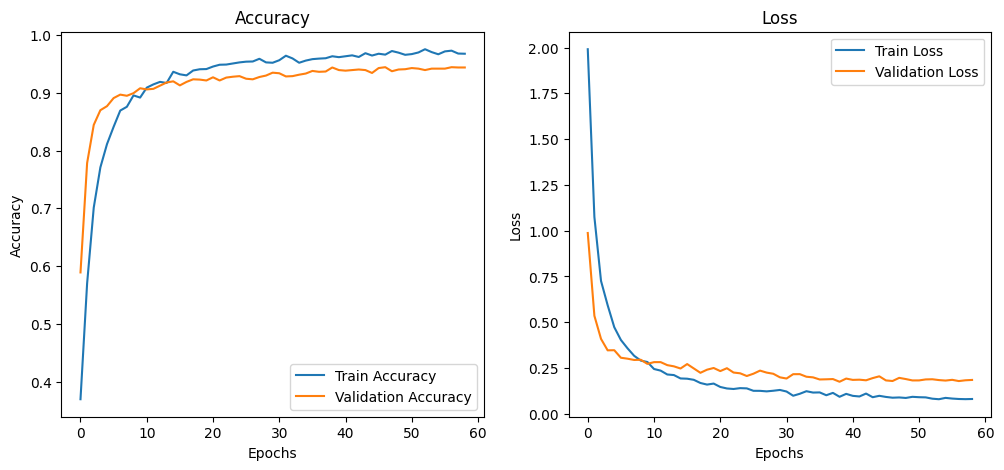

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo, solo los pesos
model.save_weights('efficientnetb0_best_weights.h5')
print("Modelo guardado")

Modelo guardado


In [12]:
# Cargar la arquitectura y los pesos
model.load_weights("efficientnetb0_best_weights.h5")

# Volver a compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 2:25 - loss: 0.0096 - accuracy: 1.0000


  2/100 [..............................] - ETA: 6s - loss: 0.0056 - accuracy: 1.0000  


  3/100 [..............................] - ETA: 6s - loss: 0.0043 - accuracy: 1.0000


  4/100 [>.............................] - ETA: 5s - loss: 0.0043 - accuracy: 1.0000


  6/100 [>.............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000


  8/100 [=>............................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000


 10/100 [==>...........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000


 12/100 [==>...........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000


 14/100 [===>..........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000


 16/100 [===>..........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000


 18/100 [====>.........................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000


 20/100 [=====>........................] - ETA: 3s - loss: 0.0083 - accuracy: 1.0000


 22/100 [=====>........................] - ETA: 3s - loss: 0.0081 - accuracy: 1.0000


 24/100 [======>.......................] - ETA: 3s - loss: 0.0079 - accuracy: 1.0000


 26/100 [======>.......................] - ETA: 3s - loss: 0.0086 - accuracy: 1.0000


 27/100 [=======>......................] - ETA: 3s - loss: 0.0145 - accuracy: 0.9954


 29/100 [=======>......................] - ETA: 3s - loss: 0.0211 - accuracy: 0.9914


 30/100 [========>.....................] - ETA: 3s - loss: 0.0292 - accuracy: 0.9833


 32/100 [========>.....................] - ETA: 3s - loss: 0.0596 - accuracy: 0.9766


 33/100 [========>.....................] - ETA: 3s - loss: 0.0837 - accuracy: 0.9735


 35/100 [=========>....................] - ETA: 3s - loss: 0.0895 - accuracy: 0.9714


 37/100 [==========>...................] - ETA: 3s - loss: 0.0848 - accuracy: 0.9730


 38/100 [==========>...................] - ETA: 3s - loss: 0.0833 - accuracy: 0.9737


 39/100 [==========>...................] - ETA: 2s - loss: 0.1016 - accuracy: 0.9712


 40/100 [===========>..................] - ETA: 2s - loss: 0.0998 - accuracy: 0.9719


 42/100 [===========>..................] - ETA: 2s - loss: 0.1077 - accuracy: 0.9673


 43/100 [===========>..................] - ETA: 2s - loss: 0.1077 - accuracy: 0.9651


 44/100 [============>.................] - ETA: 2s - loss: 0.1084 - accuracy: 0.9659


 46/100 [============>.................] - ETA: 2s - loss: 0.1108 - accuracy: 0.9674


 48/100 [=============>................] - ETA: 2s - loss: 0.1096 - accuracy: 0.9688


 49/100 [=============>................] - ETA: 2s - loss: 0.1343 - accuracy: 0.9617


 50/100 [==============>...............] - ETA: 2s - loss: 0.1317 - accuracy: 0.9625


 52/100 [==============>...............] - ETA: 2s - loss: 0.1517 - accuracy: 0.9567


 53/100 [==============>...............] - ETA: 2s - loss: 0.1693 - accuracy: 0.9528


 54/100 [===============>..............] - ETA: 2s - loss: 0.1679 - accuracy: 0.9537


 56/100 [===============>..............] - ETA: 2s - loss: 0.1794 - accuracy: 0.9442


 57/100 [================>.............] - ETA: 2s - loss: 0.1865 - accuracy: 0.9408


 59/100 [================>.............] - ETA: 2s - loss: 0.1920 - accuracy: 0.9386


 61/100 [=================>............] - ETA: 2s - loss: 0.1897 - accuracy: 0.9385


 62/100 [=================>............] - ETA: 1s - loss: 0.1908 - accuracy: 0.9375


 64/100 [==================>...........] - ETA: 1s - loss: 0.1904 - accuracy: 0.9375


 65/100 [==================>...........] - ETA: 1s - loss: 0.1902 - accuracy: 0.9365


 66/100 [==================>...........] - ETA: 1s - loss: 0.1940 - accuracy: 0.9356


 68/100 [===================>..........] - ETA: 1s - loss: 0.1948 - accuracy: 0.9338


 69/100 [===================>..........] - ETA: 1s - loss: 0.1952 - accuracy: 0.9330


 70/100 [====================>.........] - ETA: 1s - loss: 0.1980 - accuracy: 0.9321


 71/100 [====================>.........] - ETA: 1s - loss: 0.1953 - accuracy: 0.9331


 72/100 [====================>.........] - ETA: 1s - loss: 0.1970 - accuracy: 0.9323


 73/100 [====================>.........] - ETA: 1s - loss: 0.1997 - accuracy: 0.9315


 74/100 [=====================>........] - ETA: 1s - loss: 0.2009 - accuracy: 0.9291


 75/100 [=====================>........] - ETA: 1s - loss: 0.2064 - accuracy: 0.9283


 76/100 [=====================>........] - ETA: 1s - loss: 0.2038 - accuracy: 0.9293


 77/100 [======================>.......] - ETA: 1s - loss: 0.2012 - accuracy: 0.9302


 78/100 [======================>.......] - ETA: 1s - loss: 0.1986 - accuracy: 0.9311


 79/100 [======================>.......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9320


 80/100 [=======================>......] - ETA: 1s - loss: 0.1936 - accuracy: 0.9328


 81/100 [=======================>......] - ETA: 1s - loss: 0.1913 - accuracy: 0.9336


 82/100 [=======================>......] - ETA: 1s - loss: 0.1889 - accuracy: 0.9345


 83/100 [=======================>......] - ETA: 1s - loss: 0.1867 - accuracy: 0.9352


 84/100 [========================>.....] - ETA: 0s - loss: 0.1844 - accuracy: 0.9360


 85/100 [========================>.....] - ETA: 0s - loss: 0.1823 - accuracy: 0.9368


 86/100 [========================>.....] - ETA: 0s - loss: 0.1801 - accuracy: 0.9375


 87/100 [=========================>....] - ETA: 0s - loss: 0.1781 - accuracy: 0.9382


 88/100 [=========================>....] - ETA: 0s - loss: 0.1761 - accuracy: 0.9389


 89/100 [=========================>....] - ETA: 0s - loss: 0.1741 - accuracy: 0.9396


 90/100 [==========================>...] - ETA: 0s - loss: 0.1721 - accuracy: 0.9403


 91/100 [==========================>...] - ETA: 0s - loss: 0.1703 - accuracy: 0.9409


 92/100 [==========================>...] - ETA: 0s - loss: 0.1684 - accuracy: 0.9416


 93/100 [==========================>...] - ETA: 0s - loss: 0.1666 - accuracy: 0.9422


 94/100 [===========================>..] - ETA: 0s - loss: 0.1648 - accuracy: 0.9428


 95/100 [===========================>..] - ETA: 0s - loss: 0.1631 - accuracy: 0.9434


 96/100 [===========================>..] - ETA: 0s - loss: 0.1614 - accuracy: 0.9440


 97/100 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9446


 98/100 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9452


 99/100 [============================>.] - ETA: 0s - loss: 0.1565 - accuracy: 0.9457


100/100 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9463


100/100 [==============================] - 8s 68ms/step - loss: 0.1549 - accuracy: 0.9463


Test Accuracy: 94.63%



  1/250 [..............................] - ETA: 19s - loss: 0.0028 - accuracy: 1.0000


  4/250 [..............................] - ETA: 6s - loss: 0.0066 - accuracy: 1.0000 


  6/250 [..............................] - ETA: 6s - loss: 0.0188 - accuracy: 1.0000


  8/250 [..............................] - ETA: 7s - loss: 0.0150 - accuracy: 1.0000


 11/250 [>.............................] - ETA: 6s - loss: 0.0128 - accuracy: 1.0000


 15/250 [>.............................] - ETA: 5s - loss: 0.0105 - accuracy: 1.0000


 19/250 [=>............................] - ETA: 5s - loss: 0.0117 - accuracy: 1.0000


 23/250 [=>............................] - ETA: 4s - loss: 0.0156 - accuracy: 1.0000


 26/250 [==>...........................] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000


 29/250 [==>...........................] - ETA: 4s - loss: 0.0150 - accuracy: 1.0000


 32/250 [==>...........................] - ETA: 4s - loss: 0.0150 - accuracy: 1.0000


 35/250 [===>..........................] - ETA: 4s - loss: 0.0141 - accuracy: 1.0000


 39/250 [===>..........................] - ETA: 4s - loss: 0.0146 - accuracy: 1.0000


 42/250 [====>.........................] - ETA: 4s - loss: 0.0136 - accuracy: 1.0000


 45/250 [====>.........................] - ETA: 4s - loss: 0.0131 - accuracy: 1.0000


 48/250 [====>.........................] - ETA: 4s - loss: 0.0136 - accuracy: 1.0000


 52/250 [=====>........................] - ETA: 4s - loss: 0.0148 - accuracy: 1.0000


 56/250 [=====>........................] - ETA: 4s - loss: 0.0154 - accuracy: 1.0000


 60/250 [======>.......................] - ETA: 3s - loss: 0.0168 - accuracy: 0.9979


 64/250 [======>.......................] - ETA: 3s - loss: 0.0205 - accuracy: 0.9961


 66/250 [======>.......................] - ETA: 3s - loss: 0.0214 - accuracy: 0.9962


 69/250 [=======>......................] - ETA: 3s - loss: 0.0465 - accuracy: 0.9909


 71/250 [=======>......................] - ETA: 3s - loss: 0.0568 - accuracy: 0.9877


 73/250 [=======>......................] - ETA: 3s - loss: 0.0725 - accuracy: 0.9812


 75/250 [========>.....................] - ETA: 3s - loss: 0.0798 - accuracy: 0.9783


 78/250 [========>.....................] - ETA: 3s - loss: 0.0977 - accuracy: 0.9728


 80/250 [========>.....................] - ETA: 3s - loss: 0.1013 - accuracy: 0.9719


 83/250 [========>.....................] - ETA: 3s - loss: 0.1056 - accuracy: 0.9699


 85/250 [=========>....................] - ETA: 3s - loss: 0.1104 - accuracy: 0.9676


 88/250 [=========>....................] - ETA: 3s - loss: 0.1195 - accuracy: 0.9631


 90/250 [=========>....................] - ETA: 3s - loss: 0.1371 - accuracy: 0.9597


 92/250 [==========>...................] - ETA: 3s - loss: 0.1496 - accuracy: 0.9565


 94/250 [==========>...................] - ETA: 3s - loss: 0.1477 - accuracy: 0.9574


 96/250 [==========>...................] - ETA: 3s - loss: 0.1516 - accuracy: 0.9570


 98/250 [==========>...................] - ETA: 3s - loss: 0.1525 - accuracy: 0.9566


100/250 [===========>..................] - ETA: 3s - loss: 0.1514 - accuracy: 0.9563


103/250 [===========>..................] - ETA: 3s - loss: 0.1499 - accuracy: 0.9563


105/250 [===========>..................] - ETA: 3s - loss: 0.1540 - accuracy: 0.9536


108/250 [===========>..................] - ETA: 3s - loss: 0.1575 - accuracy: 0.9502


110/250 [============>.................] - ETA: 3s - loss: 0.1583 - accuracy: 0.9489


112/250 [============>.................] - ETA: 3s - loss: 0.1560 - accuracy: 0.9498


115/250 [============>.................] - ETA: 3s - loss: 0.1559 - accuracy: 0.9500


117/250 [=============>................] - ETA: 3s - loss: 0.1552 - accuracy: 0.9498


120/250 [=============>................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9469


123/250 [=============>................] - ETA: 3s - loss: 0.1647 - accuracy: 0.9472


125/250 [==============>...............] - ETA: 3s - loss: 0.1680 - accuracy: 0.9470


128/250 [==============>...............] - ETA: 3s - loss: 0.1713 - accuracy: 0.9463


130/250 [==============>...............] - ETA: 2s - loss: 0.1709 - accuracy: 0.9462


133/250 [==============>...............] - ETA: 2s - loss: 0.1742 - accuracy: 0.9436


135/250 [===============>..............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9435


138/250 [===============>..............] - ETA: 2s - loss: 0.1844 - accuracy: 0.9420


140/250 [===============>..............] - ETA: 2s - loss: 0.1849 - accuracy: 0.9411


142/250 [================>.............] - ETA: 2s - loss: 0.1834 - accuracy: 0.9419


144/250 [================>.............] - ETA: 2s - loss: 0.1827 - accuracy: 0.9418


146/250 [================>.............] - ETA: 2s - loss: 0.1819 - accuracy: 0.9418


149/250 [================>.............] - ETA: 2s - loss: 0.1820 - accuracy: 0.9404


151/250 [=================>............] - ETA: 2s - loss: 0.1823 - accuracy: 0.9387


154/250 [=================>............] - ETA: 2s - loss: 0.1810 - accuracy: 0.9391


156/250 [=================>............] - ETA: 2s - loss: 0.1812 - accuracy: 0.9391


159/250 [==================>...........] - ETA: 2s - loss: 0.1838 - accuracy: 0.9387


161/250 [==================>...........] - ETA: 2s - loss: 0.1859 - accuracy: 0.9379


163/250 [==================>...........] - ETA: 2s - loss: 0.1887 - accuracy: 0.9363


166/250 [==================>...........] - ETA: 2s - loss: 0.1928 - accuracy: 0.9352


168/250 [===================>..........] - ETA: 2s - loss: 0.1951 - accuracy: 0.9345


170/250 [===================>..........] - ETA: 2s - loss: 0.2025 - accuracy: 0.9331


173/250 [===================>..........] - ETA: 2s - loss: 0.2044 - accuracy: 0.9328


175/250 [====================>.........] - ETA: 1s - loss: 0.2090 - accuracy: 0.9314


178/250 [====================>.........] - ETA: 1s - loss: 0.2121 - accuracy: 0.9291


180/250 [====================>.........] - ETA: 1s - loss: 0.2190 - accuracy: 0.9271


182/250 [====================>.........] - ETA: 1s - loss: 0.2269 - accuracy: 0.9258


184/250 [=====================>........] - ETA: 1s - loss: 0.2288 - accuracy: 0.9253


187/250 [=====================>........] - ETA: 1s - loss: 0.2266 - accuracy: 0.9258


188/250 [=====================>........] - ETA: 1s - loss: 0.2310 - accuracy: 0.9255


189/250 [=====================>........] - ETA: 1s - loss: 0.2298 - accuracy: 0.9259


190/250 [=====================>........] - ETA: 1s - loss: 0.2286 - accuracy: 0.9263


191/250 [=====================>........] - ETA: 1s - loss: 0.2274 - accuracy: 0.9267


192/250 [======================>.......] - ETA: 1s - loss: 0.2262 - accuracy: 0.9271


193/250 [======================>.......] - ETA: 1s - loss: 0.2255 - accuracy: 0.9275


194/250 [======================>.......] - ETA: 1s - loss: 0.2243 - accuracy: 0.9278


195/250 [======================>.......] - ETA: 1s - loss: 0.2232 - accuracy: 0.9282


196/250 [======================>.......] - ETA: 1s - loss: 0.2220 - accuracy: 0.9286


197/250 [======================>.......] - ETA: 1s - loss: 0.2210 - accuracy: 0.9289


198/250 [======================>.......] - ETA: 1s - loss: 0.2199 - accuracy: 0.9293


199/250 [======================>.......] - ETA: 1s - loss: 0.2188 - accuracy: 0.9296


200/250 [=======================>......] - ETA: 1s - loss: 0.2177 - accuracy: 0.9300


201/250 [=======================>......] - ETA: 1s - loss: 0.2169 - accuracy: 0.9303


202/250 [=======================>......] - ETA: 1s - loss: 0.2158 - accuracy: 0.9307


203/250 [=======================>......] - ETA: 1s - loss: 0.2148 - accuracy: 0.9310


204/250 [=======================>......] - ETA: 1s - loss: 0.2137 - accuracy: 0.9314


205/250 [=======================>......] - ETA: 1s - loss: 0.2127 - accuracy: 0.9317


206/250 [=======================>......] - ETA: 1s - loss: 0.2117 - accuracy: 0.9320


207/250 [=======================>......] - ETA: 1s - loss: 0.2106 - accuracy: 0.9324


208/250 [=======================>......] - ETA: 1s - loss: 0.2096 - accuracy: 0.9327


209/250 [========================>.....] - ETA: 1s - loss: 0.2086 - accuracy: 0.9330


210/250 [========================>.....] - ETA: 1s - loss: 0.2077 - accuracy: 0.9333


211/250 [========================>.....] - ETA: 1s - loss: 0.2067 - accuracy: 0.9336


212/250 [========================>.....] - ETA: 1s - loss: 0.2057 - accuracy: 0.9340


213/250 [========================>.....] - ETA: 1s - loss: 0.2048 - accuracy: 0.9343


214/250 [========================>.....] - ETA: 1s - loss: 0.2038 - accuracy: 0.9346


215/250 [========================>.....] - ETA: 1s - loss: 0.2029 - accuracy: 0.9349


216/250 [========================>.....] - ETA: 1s - loss: 0.2020 - accuracy: 0.9352


217/250 [=========================>....] - ETA: 1s - loss: 0.2011 - accuracy: 0.9355


218/250 [=========================>....] - ETA: 1s - loss: 0.2002 - accuracy: 0.9358


219/250 [=========================>....] - ETA: 1s - loss: 0.1992 - accuracy: 0.9361


220/250 [=========================>....] - ETA: 1s - loss: 0.1983 - accuracy: 0.9364


221/250 [=========================>....] - ETA: 0s - loss: 0.1974 - accuracy: 0.9367


222/250 [=========================>....] - ETA: 0s - loss: 0.1966 - accuracy: 0.9369


223/250 [=========================>....] - ETA: 0s - loss: 0.1957 - accuracy: 0.9372


224/250 [=========================>....] - ETA: 0s - loss: 0.1948 - accuracy: 0.9375


225/250 [==========================>...] - ETA: 0s - loss: 0.1939 - accuracy: 0.9378


226/250 [==========================>...] - ETA: 0s - loss: 0.1931 - accuracy: 0.9381


227/250 [==========================>...] - ETA: 0s - loss: 0.1922 - accuracy: 0.9383


228/250 [==========================>...] - ETA: 0s - loss: 0.1914 - accuracy: 0.9386


229/250 [==========================>...] - ETA: 0s - loss: 0.1906 - accuracy: 0.9389


230/250 [==========================>...] - ETA: 0s - loss: 0.1897 - accuracy: 0.9391


231/250 [==========================>...] - ETA: 0s - loss: 0.1889 - accuracy: 0.9394


232/250 [==========================>...] - ETA: 0s - loss: 0.1881 - accuracy: 0.9397


233/250 [==========================>...] - ETA: 0s - loss: 0.1873 - accuracy: 0.9399


234/250 [===========================>..] - ETA: 0s - loss: 0.1865 - accuracy: 0.9402


235/250 [===========================>..] - ETA: 0s - loss: 0.1857 - accuracy: 0.9404


236/250 [===========================>..] - ETA: 0s - loss: 0.1849 - accuracy: 0.9407


237/250 [===========================>..] - ETA: 0s - loss: 0.1841 - accuracy: 0.9409


238/250 [===========================>..] - ETA: 0s - loss: 0.1834 - accuracy: 0.9412


239/250 [===========================>..] - ETA: 0s - loss: 0.1827 - accuracy: 0.9414


240/250 [===========================>..] - ETA: 0s - loss: 0.1819 - accuracy: 0.9417


241/250 [===========================>..] - ETA: 0s - loss: 0.1812 - accuracy: 0.9419


242/250 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9421


243/250 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9424


244/250 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9426


245/250 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9429


246/250 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9431


247/250 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9433


248/250 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9435


249/250 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 0.9438


250/250 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9440


250/250 [==============================] - 10s 39ms/step - loss: 0.1747 - accuracy: 0.9440


Validation Accuracy: 94.40%


In [13]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 3:37


  4/250 [..............................] - ETA: 6s  


  6/250 [..............................] - ETA: 6s


  9/250 [>.............................] - ETA: 6s


 12/250 [>.............................] - ETA: 6s


 15/250 [>.............................] - ETA: 5s


 18/250 [=>............................] - ETA: 5s


 21/250 [=>............................] - ETA: 5s


 25/250 [==>...........................] - ETA: 4s


 28/250 [==>...........................] - ETA: 4s


 31/250 [==>...........................] - ETA: 4s


 35/250 [===>..........................] - ETA: 4s


 38/250 [===>..........................] - ETA: 4s


 42/250 [====>.........................] - ETA: 4s


 46/250 [====>.........................] - ETA: 4s


 50/250 [=====>........................] - ETA: 3s


 54/250 [=====>........................] - ETA: 3s


 57/250 [=====>........................] - ETA: 3s


 61/250 [======>.......................] - ETA: 3s


 64/250 [======>.......................] - ETA: 3s


 66/250 [======>.......................] - ETA: 3s


 68/250 [=======>......................] - ETA: 3s


 71/250 [=======>......................] - ETA: 3s


 73/250 [=======>......................] - ETA: 3s


 75/250 [========>.....................] - ETA: 3s


 77/250 [========>.....................] - ETA: 3s


 79/250 [========>.....................] - ETA: 3s


 82/250 [========>.....................] - ETA: 3s


 85/250 [=========>....................] - ETA: 3s


 87/250 [=========>....................] - ETA: 3s


 90/250 [=========>....................] - ETA: 3s


 92/250 [==========>...................] - ETA: 3s


 94/250 [==========>...................] - ETA: 3s


 96/250 [==========>...................] - ETA: 3s


 98/250 [==========>...................] - ETA: 3s


101/250 [===========>..................] - ETA: 3s


103/250 [===========>..................] - ETA: 3s


105/250 [===========>..................] - ETA: 3s


107/250 [===========>..................] - ETA: 3s


110/250 [============>.................] - ETA: 3s


112/250 [============>.................] - ETA: 3s


115/250 [============>.................] - ETA: 3s


117/250 [=============>................] - ETA: 3s


119/250 [=============>................] - ETA: 3s


122/250 [=============>................] - ETA: 3s


124/250 [=============>................] - ETA: 3s


127/250 [==============>...............] - ETA: 2s


129/250 [==============>...............] - ETA: 2s


132/250 [==============>...............] - ETA: 2s


134/250 [===============>..............] - ETA: 2s


137/250 [===============>..............] - ETA: 2s


139/250 [===============>..............] - ETA: 2s


141/250 [===============>..............] - ETA: 2s


143/250 [================>.............] - ETA: 2s


145/250 [================>.............] - ETA: 2s


147/250 [================>.............] - ETA: 2s


150/250 [=================>............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


155/250 [=================>............] - ETA: 2s


157/250 [=================>............] - ETA: 2s


159/250 [==================>...........] - ETA: 2s


161/250 [==================>...........] - ETA: 2s


163/250 [==================>...........] - ETA: 2s


166/250 [==================>...........] - ETA: 2s


168/250 [===================>..........] - ETA: 2s


170/250 [===================>..........] - ETA: 2s


173/250 [===================>..........] - ETA: 1s


175/250 [====================>.........] - ETA: 1s


177/250 [====================>.........] - ETA: 1s


179/250 [====================>.........] - ETA: 1s


181/250 [====================>.........] - ETA: 1s


183/250 [====================>.........] - ETA: 1s


185/250 [=====================>........] - ETA: 1s


187/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 1s


220/250 [=========================>....] - ETA: 1s


221/250 [=========================>....] - ETA: 0s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 10s 38ms/step



  1/100 [..............................] - ETA: 6s


  4/100 [>.............................] - ETA: 2s


  7/100 [=>............................] - ETA: 2s


  9/100 [=>............................] - ETA: 2s


 12/100 [==>...........................] - ETA: 2s


 16/100 [===>..........................] - ETA: 1s


 19/100 [====>.........................] - ETA: 1s


 23/100 [=====>........................] - ETA: 1s


 26/100 [======>.......................] - ETA: 1s


 28/100 [=======>......................] - ETA: 1s


 30/100 [========>.....................] - ETA: 1s


 33/100 [========>.....................] - ETA: 1s


 36/100 [=========>....................] - ETA: 1s


 39/100 [==========>...................] - ETA: 1s


 41/100 [===========>..................] - ETA: 1s


 43/100 [===========>..................] - ETA: 1s


 46/100 [============>.................] - ETA: 1s


 48/100 [=============>................] - ETA: 1s


 50/100 [==============>...............] - ETA: 1s


 53/100 [==============>...............] - ETA: 1s


 55/100 [===============>..............] - ETA: 1s


 58/100 [================>.............] - ETA: 1s


 60/100 [=================>............] - ETA: 1s


 63/100 [=================>............] - ETA: 0s


 65/100 [==================>...........] - ETA: 0s


 67/100 [===================>..........] - ETA: 0s


 69/100 [===================>..........] - ETA: 0s


 71/100 [====================>.........] - ETA: 0s


 74/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 39ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       0.94      1.00      0.97       500
1_ulcerative_colitis       0.93      0.90      0.91       500
            2_polyps       0.91      0.88      0.90       500
       3_esophagitis       0.99      1.00      1.00       500

            accuracy                           0.94      2000
           macro avg       0.94      0.94      0.94      2000
        weighted avg       0.94      0.94      0.94      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.94      1.00      0.97       200
1_ulcerative_colitis       0.92      0.93      0.92       200
            2_polyps       0.92      0.86      0.89       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.95       800
           macro avg       0.95      0.95      0.95       800
        weighted avg       0.95     

In [14]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()